In [1]:
import numpy as np
from libow8 import sensor_net
import matplotlib.pyplot as plt
import owutils as ut
from designs import designs, align_receiver_to_transmitter
from panel_ow import Panel
from pyswarms.single.global_best import GlobalBestPSO

In [2]:
h_ww = None
r_sens = None
n_particles =40


# ----------------------
# Parameters
# ----------------------
KEY = 'B'
params_d = designs[KEY]
params_amb = designs['B'].copy()
params_amb['r_master'] = params_d['r_lights']
params_amb['PT_master'] = params_d['PT_lights']
h_ww = None
h_amb = None

# ----------------------
# Simulation function
# ----------------------
def sensor_ar(x, params_d=None): 
    """
    Runs the optical wireless simulation for a set of particles.
    x shape: (n_particles, 3) -> [theta, phi, area]
    """
    global h_ww
    global r_sens
    global nS_sens
    global n_particles
    global h_amb

    theta = x[:,0]
    phi   = x[:,1]
    area  = x[:,2]

    r_sensor = np.tile(r_sens, (n_particles, 1)) 
    nS_sensor = nS_sens 
    #print("nS is "+ str(nS_sens))
    nR = ut.spher_to_cart_ar(1, theta, phi).T

    params_amb['r_sensor'] = r_sensor
    params_amb['nR_sensor'] = nR
    params_amb['A_sensor'] = area   
    params_amb['nS_sensor'] = nS_sensor   

    l_amb = sensor_net(**params_amb) 
    l_amb.calch(h_ww=h_amb)
    l_amb.light_sim()
    h_amb = l_amb.h_ww

    params_d['r_sensor'] = r_sensor
    params_d['nR_sensor'] = nR
    params_d['A_sensor'] = area   
    params_d['nS_sensor'] = nS_sensor  
    
 
    l = sensor_net(**params_d) 
    l.calch(h_ww = h_ww)
    l.light_sim()
    h_ww = l.h_ww
    l.calc_noise() #useless
    l.calc_rq() 


    #connect
    p_all = np.sum(np.sum(l_amb.Pin_sm_diff,axis = 0),axis = 1) + np.sum(l_amb.Pin_sm,axis = 0)  + 0.5*l.Pin_sm_tot.flatten() #LOS + Diffuse + Ambient
    p_no_sun = np.sum(np.sum(l_amb.Pin_sm_diff,axis = 0),axis = 1) + np.sum(l_amb.Pin_sm,axis = 0) 
    p_los = np.sum(l_amb.Pin_sm,axis = 0) 
    p_diff = np.sum(np.sum(l_amb.Pin_sm_diff,axis = 0),axis = 1)
    p_amb = l_amb.Pin_sa
    G_all = p_all/l_amb.A_sensor
    G_los = p_los/l_amb.A_sensor
    G_ac = l.Pin_sm_tot/l_amb.A_sensor
    G_ac = G_ac.flatten()
    G_no_sun = p_no_sun/l_amb.A_sensor

    panels = []
    pmax = np.zeros(G_los.shape)
    ind  = np.zeros(G_los.shape, dtype=int)
    bw = np.zeros(G_los.shape)
    snr = np.zeros(G_los.shape)
    signal = np.zeros(G_los.shape)
    noise = np.zeros(G_los.shape)
    snr_dB = np.zeros(G_los.shape)
    v = np.zeros(G_los.shape)
    C = np.zeros(G_los.shape)
    req = np.zeros(G_los.shape)
    rx = np.zeros(G_los.shape)

    freq = np.linspace(100,20000,400)

    for i in range(p_all.shape[0]):
        panels.append(Panel(l_amb.A_sensor[i]*1e4, rs=1, rsh=1000, n=1.6, voc=0.64, isc=35e-3, G=G_all[i], Gac = G_ac[i]))
        panels[i].run(False)
        pmax[i] = panels[i].Pmax
        ind[i] = int(panels[i].ind)    
        panels[i].calc_capacitance()
        panels[i].set_circuit(Rc = 10, Lo = 10, Co = 220e-6)
        panels[i].find_bw()    
        bw[i] = panels[i].BW[int(ind[i])]
        panels[i].tf(freq)
        panels[i].thermal_noise()
        panels[i].all_thermal_noise(freq)
        panels[i].shot_noise(freq)
        panels[i].vp2p(freq)
        signal[i] = panels[i].vac[int(ind[i])]
        noise[i] = 4 *(panels[i].th_noise[int(ind[i])] + panels[i].sh_noise[int(ind[i])])
        snr[i] = signal[i]**2/noise[i]
        snr_dB[i] = 10*np.log10(snr[i])
        v[i] = panels[i].V[int(ind[i])]
        C[i] = panels[i].C[int(ind[i])]
        req[i] = panels[i].req[int(ind[i])]
        rx = panels[i].rx
    l.calc_tbattery(br = np.floor(bw)*0.4)

    e_day = pmax*3600*8*0.8
    V = 3.3 #Volt
    cycle_p = np.array([c.calc_cycle_consumption() for c in l.cycles]) * V
    day_s = 3600*24
    cycles_day = day_s/l.Tcycle
    e_day_c = cycles_day * cycle_p

    penalty = np.zeros(e_day_c.shape)

    penalty[snr_dB<8.5] = 10* (8.5 - snr_dB[snr_dB < 8.5])
    penalty[e_day < e_day_c] = 10* (e_day_c[e_day < e_day_c] - e_day[e_day < e_day_c])
    

    
    fitness = area + penalty
    return fitness


# ----------------------
# Fitness wrapper for PSO
# ----------------------
def fit_function(x):
    """
    Normalized swarm values x in [0,1]^3
    Columns: theta, phi, area
    """
    # Denormalize
    theta = x[:,0] * (np.pi/2)
    phi   = x[:,1] * (2*np.pi)
    area  = 0.0001 + x[:,2] * (0.008 - 0.0001)  

    # Rebuild for simulation
    x_denorm = np.column_stack((theta, phi, area))

    f = sensor_ar(x_denorm, params_d=params_d)

    g = np.array(f).reshape(x.shape[0])
    return g


# ----------------------
# Main optimization loop
# ----------------------
r_sen = designs[KEY]['r_sensor']
nS_sen = np.round(align_receiver_to_transmitter(r_sen, np.array([5,5,3])), 2)
N = r_sen.shape[0]

pos_l = [0]*N   # Sensor positions
pow_l = [0]*N   # Optical powers
op_l = [0]*N    # Optimal orientations (theta, phi, area)

options = {'c1':0.5, 'c2': 0.3, 'w': 0.7}

# Normalized bounds [0,1] for all parameters
lb = np.zeros(3)
ub = np.ones(3)

all_cost_histories = [] 

for i in range(0, N):
    r_sens = r_sen[i]
    nS_sens = nS_sen[i]
    print("Optimizing particle " + str(i+1) + " of " + str(N))

    optimizer = GlobalBestPSO(
        n_particles=n_particles,
        dimensions=3,   # theta, phi, area
        options=options,
        bounds=(lb, ub)
    )

    best_cost, best_pos = optimizer.optimize(fit_function, iters=100)

    # Denormalize best_pos
    theta = best_pos[0] * (np.pi/2)
    phi   = best_pos[1] * (2*np.pi)
    area  = 0.0001 + best_pos[2] * (0.008 - 0.0001)
    pos_l[i] = r_sens
    op_l[i]  = [theta, phi, area]
    pow_l[i] = best_cost

    all_cost_histories.append(optimizer.cost_history)


# ----------------------
# Results
# ----------------------
print("\nOptimization complete!")
for i in range(N):
    print(f"Sensor {i+1}: Position={pos_l[i]}, Power={pow_l[i]:.4f}, Orientation={op_l[i]}")

2025-10-12 22:57:24,284 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


Optimizing particle 1 of 21


pyswarms.single.global_best:   0%|                                        |0/100/home/alexandros/Έγγραφα/GitHub/eh-ow (working now)/libow8.py:42: RuntimeWarning: invalid value encountered in divide
  self.un_n1 = self.dr1 / self.abs_dr1
/home/alexandros/Έγγραφα/GitHub/eh-ow (working now)/libow8.py:43: RuntimeWarning: invalid value encountered in divide
  self.un_n2 = self.dr2 / self.abs_dr2
/home/alexandros/Έγγραφα/GitHub/eh-ow (working now)/libow8.py:1133: RuntimeWarning: divide by zero encountered in log10
  self.snr_s_los_dB = 10 * np.log10(self.snr_s_los)
/home/alexandros/Έγγραφα/GitHub/eh-ow (working now)/libow8.py:1209: RuntimeWarning: divide by zero encountered in divide
  self.PT_rq_m_los = 2 * self.g0 * np.sqrt( self.n_s ) / self.hi_sm_los
/home/alexandros/anaconda3/lib/python3.11/site-packages/numpy/lib/polynomial.py:780: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv
pyswarms.single.global_best:   1%|▏                    |1/100, best_cost=0.00758

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04627158 0.18487235 0.16002972 0.18387097 0.14997267 0.10153629
 0.09359123 0.08401338 0.14380815 0.16638294 0.18464593 0.0605947
 0.03104047 0.0329779  0.11454344 0.00758266 0.18028059 0.09480715
 0.00821522 0.15821483 0.11585789 0.13879562 0.11955903 0.15656716
 0.08945356 0.11991879 0.17217672 0.12462589 0.05933654 0.18182108
 0.18534659 0.15168762 0.08306052 0.10285042 0.18150602 0.15716966
 0.10010574 0.18143948 0.1755065  0.18268128]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00767211 0.00012307 0.00254649 0.00121593 0.00156304 0.00641769
 0.00447797 0.00728062 0.00402353 0.00161681 0.00080834 0.0068051
 0.007337   0.00755993 0.00393471 0.00758266 0.00077274 0.00557119
 0.00758675 0.00405787 0.00357628 0.0027597  0.00332673 0.0024278
 0.00766247 0.00431278 0.00081599 0.0057681  0.00731265 0.00026016
 0.00056001 0.00491267 0.00654303 0.00407005 0.00217342 0.00407211
 0.00717863 0.0002906  0.00049803 0.00044405]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:   2%|▍                    |2/100, best_cost=0.00758

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.1863346  0.17145909 0.12823376 0.01797337 0.06898972 0.17911133
 0.12447967 0.16777128 0.16670348 0.09392338 0.07376869 0.1810847
 0.18617585 0.1481314  0.1685011  0.12901425 0.06424431 0.05001587
 0.17453319 0.0956461  0.12818609 0.03363676 0.14733063 0.07266409
 0.16981016 0.15802545 0.09436829 0.16092826 0.16842555 0.1536613
 0.12822231 0.1246779  0.14943383 0.06628413 0.18473856 0.08860665
 0.16572425 0.17366512 0.17213774 0.15152375]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00016834 0.00196944 0.00355415 0.00752586 0.00645603 0.00298701
 0.00653665 0.00332078 0.00109513 0.0046759  0.00702948 0.00074976
 0.0001228  0.00308445 0.00085604 0.00442368 0.00577509 0.00671087
 0.00082018 0.00602738 0.00378946 0.00756437 0.00433243 0.00789052
 0.00510392 0.00145574 0.00606598 0.0012348  0.00107415 0.00572291
 0.00275138 0.00596441 0.00225281 0.00584548 0.00030482 0.00656044
 0.00110402 0.00253329 0.00498979 0.0016046 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   3%|▋                    |3/100, best_cost=0.00758

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.1665225  0.11989171 0.11746474 0.12013889 0.16504897 0.18429592
 0.05843817 0.15294518 0.17113235 0.0926881  0.1180317  0.16972652
 0.1671812  0.0996214  0.03948942 0.16942329 0.15745414 0.16746345
 0.15124306 0.16296444 0.12611264 0.17204194 0.16600472 0.14994548
 0.16541353 0.09044052 0.17649129 0.07748833 0.09497669 0.15237195
 0.08286594 0.16922253 0.05413142 0.10522052 0.06226404 0.18600515
 0.12924038 0.09572535 0.18020171 0.11590101]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00531044 0.00331775 0.00475019 0.00405367 0.00199719 0.00060987
 0.00701902 0.00738101 0.00683334 0.00756531 0.00348608 0.0043624
 0.00294255 0.00647583 0.0061203  0.00105836 0.00141897 0.007621
 0.00284594 0.00761413 0.00432838 0.00303176 0.00470652 0.0038028
 0.00200891 0.00611594 0.00203487 0.00641507 0.00469317 0.0019187
 0.0055646  0.0070889  0.00644803 0.00742167 0.00646457 0.00045963
 0.00711676 0.00429644 0.00034419 0.00366187]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:   4%|▊                    |4/100, best_cost=0.00758

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.17205423 0.09812046 0.11206638 0.17235263 0.10980189 0.13642853
 0.03933965 0.14960128 0.15381148 0.17210914 0.18520543 0.10917975
 0.13197208 0.16301633 0.14178337 0.08669644 0.12153084 0.03177146
 0.08216168 0.18701355 0.11039102 0.14349358 0.11336701 0.17545115
 0.18644342 0.17120791 0.13933195 0.15982724 0.16421122 0.10123099
 0.0411378  0.0458597  0.15218013 0.18575749 0.15681516 0.17497015
 0.10826566 0.06934426 0.1231344  0.09913637]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00200546 0.00549857 0.00573903 0.0009748  0.00568248 0.00746244
 0.0074093  0.00233258 0.00221039 0.00169002 0.00023165 0.00755179
 0.00602544 0.00169872 0.00196241 0.00747707 0.00520158 0.00795014
 0.0066434  0.00014587 0.00493966 0.00784305 0.00557676 0.00099646
 0.00030118 0.00153261 0.00619952 0.00248505 0.00100627 0.00636371
 0.007997   0.0078766  0.00153645 0.0001632  0.00305369 0.00360759
 0.00345353 0.00623809 0.00387854 0.00530078]
xxxxxxxxxxxxx

pyswarms.single.global_best:   5%|█                    |5/100, best_cost=0.00758

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.09729549 0.03621849 0.11746143 0.10228072 0.17026193 0.09691221
 0.08124682 0.05662994 0.13219089 0.138998   0.14553718 0.14990942
 0.17119799 0.08324541 0.01453473 0.11619548 0.18201085 0.18418666
 0.1511957  0.16694773 0.07500836 0.16162482 0.04615228 0.13855031
 0.1618213  0.13169747 0.17569676 0.0899908  0.11038447 0.17359501
 0.15215961 0.17913991 0.06861818 0.149579   0.13031468 0.13326851
 0.06166417 0.10165847 0.13162873 0.0880318 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00681396 0.00723558 0.00684787 0.00467308 0.0009162  0.00409309
 0.00769267 0.00595226 0.0052006  0.00452888 0.00710265 0.00168837
 0.00091845 0.00590911 0.00780985 0.00413582 0.0004599  0.00020231
 0.00161368 0.00232022 0.00588138 0.00319806 0.00643586 0.00500632
 0.00652168 0.00552064 0.00117857 0.00654851 0.00454385 0.00164789
 0.00168563 0.00050281 0.00538039 0.00261088 0.00686766 0.00679647
 0.007594   0.00774143 0.00658001 0.00685022]
xxxxxxxxxxxxx

pyswarms.single.global_best:   6%|█▎                   |6/100, best_cost=0.00758

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.14004738 0.17489627 0.10438785 0.17706032 0.04968659 0.06949178
 0.07995383 0.17461157 0.09519176 0.06794983 0.14524361 0.06362411
 0.09642044 0.14709346 0.10213372 0.17719211 0.14222349 0.1156383
 0.03625237 0.08631989 0.03887788 0.06666481 0.02527602 0.17573878
 0.11112846 0.17705944 0.08808997 0.15931429 0.17667788 0.13926394
 0.06828263 0.09935224 0.17545884 0.07542034 0.16974173 0.15869205
 0.16461787 0.18664981 0.1821966  0.08689567]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243163 0.00057848 0.00756023 0.00059175 0.00593379 0.00731383
 0.00781894 0.00060645 0.00786183 0.00794502 0.00407818 0.00576069
 0.00398962 0.00222439 0.00398653 0.00044456 0.00302823 0.00417823
 0.00656394 0.00442773 0.00667148 0.00588159 0.00710741 0.00059477
 0.00337543 0.00104189 0.00532283 0.00149486 0.00058897 0.00581953
 0.00613016 0.00438917 0.0011126  0.00537548 0.00172048 0.00125352
 0.00259015 0.00020394 0.00062223 0.00795299]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   7%|█▍                   |7/100, best_cost=0.00758

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.14805894 0.09599663 0.18474671 0.07446223 0.14798435 0.16251237
 0.07611088 0.0755509  0.15977731 0.14344489 0.16045434 0.17029838
 0.099451   0.02727508 0.16507329 0.04902649 0.06349254 0.036049
 0.12724384 0.06004088 0.02141992 0.18337382 0.02746147 0.01175803
 0.18452269 0.12908676 0.17146644 0.02338799 0.04026853 0.17339887
 0.15376907 0.01814821 0.07243274 0.06407069 0.09508831 0.11205984
 0.12824276 0.16341929 0.12199232 0.17550244]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00695347 0.00434282 0.00016039 0.00521568 0.00166528 0.0017003
 0.00777766 0.00529963 0.00176277 0.00235812 0.00176605 0.00153718
 0.00796032 0.00765151 0.00102916 0.00639561 0.00627376 0.00788776
 0.00277346 0.0064294  0.00724413 0.00020477 0.00758254 0.00761732
 0.00021171 0.00474189 0.0006794  0.00740169 0.00696023 0.00118263
 0.00225151 0.0076418  0.00635594 0.00791843 0.00507936 0.00411855
 0.0072239  0.00486351 0.0046768  0.00079089]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:   8%|█▋                   |8/100, best_cost=0.00758

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.13537058 0.02131631 0.08642454 0.15156834 0.07796532 0.10300034
 0.07774005 0.15976449 0.0711564  0.05022888 0.05778486 0.05299724
 0.13205856 0.14520279 0.16501699 0.12196001 0.17067283 0.13500356
 0.07308961 0.05053218 0.02191088 0.09935896 0.09089722 0.08667372
 0.04500043 0.1832324  0.0490125  0.10150453 0.11649171 0.10033963
 0.05290301 0.14008997 0.13306178 0.15276608 0.17453792 0.1145715
 0.14434243 0.17921834 0.17948955 0.13363363]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00260912 0.00749898 0.00476055 0.00164469 0.00497826 0.00463495
 0.00758979 0.00126659 0.00582035 0.00636987 0.00623138 0.0068071
 0.00254595 0.00353857 0.00101549 0.00329818 0.00082454 0.00258647
 0.00626915 0.00790962 0.00765625 0.00410032 0.00782292 0.00463121
 0.00669358 0.00028316 0.00578289 0.00364829 0.00352849 0.00474396
 0.00764928 0.00200685 0.00237931 0.00176056 0.00062817 0.00767149
 0.00276962 0.00056133 0.0003766  0.00302804]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   9%|█▉                   |9/100, best_cost=0.00758

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.14129773 0.14476085 0.17565132 0.17973661 0.01045564 0.07119513
 0.08045528 0.0225852  0.15790234 0.155364   0.14990132 0.12261946
 0.04928835 0.05014412 0.17193514 0.1580471  0.06587073 0.18400863
 0.15688811 0.17043784 0.02314285 0.11145447 0.07870718 0.18085061
 0.11092337 0.14997013 0.14694425 0.17432476 0.17812135 0.01695094
 0.11096597 0.07421991 0.05507588 0.0641857  0.1597545  0.14786926
 0.0078449  0.09872566 0.05267845 0.07014044]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00640776 0.00181794 0.00051426 0.00038738 0.00771898 0.00726507
 0.00741486 0.00700791 0.00127184 0.00137179 0.00157888 0.00271726
 0.00656916 0.00757088 0.00069017 0.00142174 0.00608596 0.0001642
 0.00148087 0.00095064 0.00779022 0.00793538 0.00787408 0.00030979
 0.00340453 0.00371578 0.00174717 0.00055435 0.00052586 0.00764647
 0.00361221 0.00471165 0.00662465 0.00622573 0.00616091 0.00213803
 0.0078449  0.00600514 0.00577886 0.00593665]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  10%|██                  |10/100, best_cost=0.00758

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.16004777 0.00838018 0.07005293 0.06670614 0.1473817  0.16936753
 0.08449626 0.11043505 0.02724431 0.04478546 0.05817674 0.0294698
 0.15108628 0.13827042 0.16599988 0.04104861 0.14645642 0.07300885
 0.05250872 0.12634315 0.01554028 0.14451842 0.00759241 0.06157349
 0.16884146 0.10510142 0.03297526 0.00799846 0.0917692  0.14555353
 0.16086264 0.16641033 0.1833581  0.15872919 0.15976148 0.13143064
 0.10581437 0.15263514 0.14089591 0.18002847]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00159886 0.00739339 0.00500367 0.00665666 0.00171388 0.00126714
 0.00733332 0.00320005 0.00663305 0.00591589 0.00550966 0.00674954
 0.00179598 0.0025148  0.00093121 0.00695549 0.00220145 0.00529323
 0.00611613 0.00319337 0.00782439 0.0024884  0.00759241 0.00654147
 0.0008593  0.00753446 0.00662657 0.00799846 0.00524488 0.00176388
 0.00123118 0.00088448 0.0017889  0.00161955 0.00252793 0.00461501
 0.00344184 0.0022273  0.00194108 0.00034612]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  11%|██▏                 |11/100, best_cost=0.00758

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.16867672 0.10508685 0.17812197 0.10077497 0.06058379 0.12805883
 0.08702512 0.01392477 0.12664531 0.15407706 0.16533493 0.14983548
 0.00772345 0.11479866 0.1656077  0.12224823 0.09595863 0.15201341
 0.13561879 0.04681893 0.0114021  0.06335326 0.02722873 0.10943388
 0.17139144 0.15396202 0.13610524 0.06180858 0.17124858 0.04219441
 0.06054736 0.04278536 0.13044982 0.09917337 0.07495201 0.13527734
 0.00779448 0.08515396 0.00842262 0.09504582]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00489295 0.00341569 0.00039902 0.00372578 0.00536861 0.00447518
 0.00729191 0.00718631 0.00253075 0.00139045 0.00097863 0.00178809
 0.00772345 0.00487844 0.00093866 0.00336587 0.00526933 0.00175056
 0.00233441 0.00729908 0.00778268 0.00577855 0.00739285 0.0033774
 0.00091247 0.00194776 0.00218516 0.00525133 0.0008453  0.00607906
 0.00604611 0.0061515  0.00514995 0.00730202 0.00604777 0.00737923
 0.00779448 0.00738516 0.00737961 0.00402358]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  12%|██▍                 |12/100, best_cost=0.00758

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.1774278  0.01995343 0.06529106 0.03632013 0.15765361 0.08232408
 0.08457737 0.13582681 0.05133831 0.05810195 0.06981818 0.11804162
 0.14594623 0.08354477 0.15033818 0.1733456  0.05730388 0.04259173
 0.09965693 0.13872244 0.00869406 0.17660004 0.06626362 0.15746126
 0.17925073 0.11606534 0.02706082 0.14870778 0.04367935 0.13207717
 0.14360575 0.13386684 0.07431272 0.11478258 0.18404801 0.17099923
 0.12098644 0.15138145 0.10778687 0.0119342 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00077165 0.00698727 0.00517871 0.00777182 0.00126778 0.00762873
 0.00732499 0.00215046 0.00567477 0.0054001  0.00517559 0.00537958
 0.00394586 0.00702135 0.00159541 0.00092314 0.00787969 0.0074183
 0.00587956 0.00235606 0.00772996 0.00067514 0.00730903 0.00175834
 0.00039258 0.00508163 0.00677016 0.00162321 0.00689648 0.00234244
 0.00244685 0.00232123 0.0078519  0.0035661  0.00097723 0.00106264
 0.00289653 0.00278922 0.00332196 0.00761776]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  13%|██▌                 |13/100, best_cost=0.00758

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.16293965 0.14601714 0.15745407 0.13078888 0.06242702 0.16269562
 0.07932932 0.03243632 0.18426757 0.17622387 0.15550813 0.18147164
 0.1701392  0.18290478 0.08997622 0.15265866 0.15963056 0.11517566
 0.15277082 0.02766657 0.00766335 0.0906269  0.03133663 0.06342217
 0.17503305 0.18612593 0.13814499 0.00773761 0.12615985 0.18131881
 0.08909718 0.04056448 0.15818429 0.15699275 0.09791508 0.13173147
 0.01756341 0.09341116 0.163876   0.13550718]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00764922 0.00174147 0.00127492 0.00263623 0.00529279 0.00188519
 0.00742705 0.00641774 0.00013402 0.00047239 0.00132581 0.00026702
 0.00075822 0.00080935 0.00418515 0.00150838 0.00172686 0.00369681
 0.00145219 0.00744247 0.00766335 0.00599065 0.00727923 0.00771034
 0.00064502 0.00016657 0.00208994 0.00773761 0.003424   0.00026112
 0.00591842 0.00646183 0.0014128  0.00756795 0.0055558  0.00440188
 0.00732792 0.00772617 0.00099253 0.0022331 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  14%|██▊                 |14/100, best_cost=0.00758

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.10460695 0.04830952 0.01506432 0.02440304 0.16159314 0.10437973
 0.0780379  0.14898643 0.08210553 0.06913578 0.01790215 0.08968314
 0.09281951 0.05187278 0.06050393 0.05058847 0.0972384  0.15814149
 0.1155132  0.11745564 0.00760074 0.12899127 0.00965466 0.09503041
 0.1649255  0.14415861 0.0451394  0.0893161  0.05473444 0.03708328
 0.17275891 0.14052711 0.17131165 0.14924875 0.17856948 0.18209604
 0.1260583  0.15200719 0.02052522 0.00787166]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00455412 0.00578935 0.00726252 0.00786691 0.00110672 0.0062551
 0.00753131 0.00159955 0.00437581 0.00495761 0.00773534 0.00429074
 0.00552531 0.00611214 0.0054751  0.00796424 0.00510834 0.00155306
 0.00426549 0.00311547 0.00760074 0.00247939 0.00739634 0.00391027
 0.00152121 0.00372269 0.00600455 0.00410071 0.00768992 0.00629979
 0.00082007 0.00208431 0.00302572 0.00258765 0.00142237 0.00035967
 0.00261886 0.00317207 0.00700283 0.00787166]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  15%|███                 |15/100, best_cost=0.00755

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.18517317 0.15856209 0.10136484 0.10888806 0.01015608 0.15809539
 0.08119457 0.06209239 0.17262168 0.17375565 0.10398186 0.06562791
 0.15139167 0.15638746 0.06686782 0.0968513  0.18334578 0.07115821
 0.0225472  0.02801751 0.00755363 0.17313562 0.01144928 0.02627192
 0.13760555 0.10547608 0.15723526 0.18366181 0.13818048 0.11485736
 0.07728265 0.0255131  0.11133303 0.14002106 0.07541683 0.13295186
 0.02614752 0.10768563 0.10020149 0.09573789]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00024991 0.00119912 0.0036357  0.00349855 0.00760249 0.00205977
 0.00758335 0.00517731 0.00061998 0.00057954 0.0042872  0.00731105
 0.0015391  0.00235563 0.00524796 0.00441421 0.00020676 0.00633025
 0.00758649 0.0069634  0.00755363 0.00134952 0.00757835 0.00773008
 0.00315832 0.00642172 0.00128004 0.00016021 0.0027027  0.00306642
 0.00654411 0.0070367  0.00565832 0.00707806 0.00504999 0.00516939
 0.00678928 0.00645711 0.00366878 0.00383897]
xxxxxxxxxxxxx

pyswarms.single.global_best:  16%|███▏                |16/100, best_cost=0.00752

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0495769  0.18135196 0.15867552 0.05201693 0.08819425 0.10360382
 0.08784434 0.18505951 0.05290449 0.07722698 0.17114991 0.15000373
 0.0826491  0.18579983 0.11916122 0.00786546 0.101906   0.14348837
 0.14567846 0.14249997 0.00752066 0.17323705 0.00837194 0.13433748
 0.12612191 0.18300855 0.09099608 0.05872037 0.06712343 0.16306626
 0.13505255 0.12462564 0.18689652 0.16044817 0.18041372 0.16306851
 0.14250325 0.17534791 0.1657825  0.17473388]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00653883 0.00025446 0.00121461 0.00716349 0.00424844 0.00726669
 0.00754716 0.00010035 0.00560223 0.00462641 0.00080466 0.00155791
 0.00672348 0.00023761 0.00297989 0.00786546 0.00440549 0.00236151
 0.00201016 0.00196723 0.00752066 0.00061253 0.00770295 0.00245376
 0.0039086  0.00045687 0.00405059 0.00538843 0.00661773 0.00105214
 0.00334617 0.00271    0.00023149 0.00254166 0.00070372 0.0011417
 0.00189761 0.00080938 0.000907   0.00053305]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  17%|███▌                 |17/100, best_cost=0.0075

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.16334536 0.1807499  0.03409341 0.14126482 0.15121749 0.14985673
 0.09774412 0.06419256 0.14704428 0.00782847 0.06586526 0.10361434
 0.1213955  0.01234166 0.17230829 0.1478814  0.16487912 0.05887852
 0.10906073 0.05791424 0.00749758 0.0939765  0.00772409 0.0642723
 0.13623801 0.15428242 0.02586644 0.12305402 0.16019843 0.01425453
 0.15812622 0.04795197 0.09406208 0.11177774 0.05634533 0.14585003
 0.05802019 0.13290506 0.17475488 0.02933468]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00355651 0.00028017 0.00642315 0.00209238 0.00155128 0.00305248
 0.00751647 0.00510831 0.00168792 0.00782847 0.00542031 0.00535973
 0.00279551 0.00788726 0.00066573 0.00218928 0.00119549 0.00659187
 0.00446418 0.00581292 0.00749758 0.00660729 0.00772409 0.0064574
 0.00338137 0.00330469 0.00676266 0.00269727 0.00155114 0.00757619
 0.00194489 0.00599389 0.00553082 0.00642197 0.00706667 0.00474644
 0.00542565 0.00454944 0.00053007 0.00657296]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  18%|███▌                |18/100, best_cost=0.00748

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.17165849 0.11825249 0.12503968 0.05372082 0.17801616 0.08599317
 0.09807165 0.13377754 0.02807841 0.13789388 0.14694218 0.16287533
 0.02043518 0.13849915 0.02793107 0.09226751 0.16557216 0.15211882
 0.01321904 0.16285954 0.00748142 0.11553378 0.00768496 0.14399922
 0.16090226 0.12158102 0.16641894 0.14485128 0.0794234  0.09067598
 0.17783571 0.17447251 0.17584114 0.14009855 0.17316575 0.17425306
 0.15198111 0.18292329 0.17395875 0.10614788]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00084645 0.00287537 0.00261724 0.00714628 0.00040466 0.00734756
 0.0074762  0.00222611 0.00660741 0.0020788  0.00172289 0.00103186
 0.00750523 0.00529607 0.00692709 0.00408496 0.00117304 0.0018365
 0.00793401 0.00113659 0.00748142 0.00314955 0.00768496 0.00208135
 0.00173019 0.00550004 0.00088342 0.00177993 0.0063339  0.00422664
 0.00060494 0.00055649 0.00170461 0.00203985 0.00364705 0.00073275
 0.00149138 0.00048401 0.00056222 0.00338671]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  19%|███▊                |19/100, best_cost=0.00747

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.14101199 0.05929411 0.01852295 0.12422651 0.16306977 0.15300027
 0.09418153 0.00779071 0.13227869 0.01776079 0.00787214 0.05098196
 0.14889952 0.15100501 0.10235296 0.08065272 0.15160624 0.08045217
 0.14716248 0.02627095 0.00747011 0.17658564 0.01436926 0.18304284
 0.0624885  0.09498233 0.07001344 0.14719794 0.15445098 0.17432725
 0.18130048 0.08290711 0.04315166 0.1008478  0.17506798 0.14250399
 0.03967809 0.14797605 0.1346562  0.01402727]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00753981 0.00529377 0.00703448 0.00282964 0.00104071 0.0024725
 0.00741542 0.00779071 0.00229291 0.00706234 0.00787214 0.00624668
 0.00292612 0.00163211 0.0037301  0.00647994 0.00181099 0.005728
 0.00227264 0.00759032 0.00747011 0.00114818 0.00759447 0.00021735
 0.00790325 0.0073621  0.0048956  0.00167892 0.0019777  0.0005662
 0.000368   0.00448197 0.0069697  0.00729763 0.0007438  0.00656421
 0.00623485 0.00386689 0.00218912 0.00719613]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  20%|████                |20/100, best_cost=0.00746

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.12514455 0.04314835 0.12923042 0.06326227 0.11924227 0.1122007
 0.07405192 0.09622058 0.03615164 0.12046808 0.08607385 0.15450159
 0.03664666 0.15666939 0.16716121 0.17572601 0.16195574 0.15799173
 0.03072396 0.09768722 0.00746219 0.0532788  0.01691955 0.02789016
 0.12582376 0.18359287 0.16518445 0.11151411 0.17727721 0.04307621
 0.15386847 0.17712158 0.14421441 0.11797183 0.15025941 0.13993536
 0.13544857 0.09538107 0.07996988 0.13318077]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.004364   0.00595451 0.00243196 0.00619474 0.00290242 0.00591758
 0.00737473 0.00378538 0.00625263 0.00278825 0.00419917 0.00229273
 0.00760966 0.00653718 0.00088712 0.00048999 0.0011852  0.00163858
 0.00703911 0.00417746 0.00746219 0.00683842 0.00751444 0.00667497
 0.00381265 0.00030057 0.00093013 0.00315677 0.00056583 0.00609711
 0.00193417 0.00044321 0.0028789  0.00319823 0.00529736 0.00287075
 0.00222258 0.00749981 0.00444221 0.00226574]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  21%|████▏               |21/100, best_cost=0.00746

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.16818502 0.07272002 0.05504314 0.1632386  0.09765965 0.17555276
 0.08148683 0.00782452 0.15160988 0.01538308 0.14828885 0.00796916
 0.11978153 0.1515817  0.03762138 0.14950166 0.04144962 0.05206367
 0.12417713 0.18266537 0.00745665 0.11220606 0.01093533 0.12933964
 0.0683769  0.1444999  0.00999235 0.11727919 0.06072    0.13188291
 0.12972465 0.0535689  0.04481205 0.13487369 0.15986169 0.12659497
 0.01652146 0.16759431 0.08033583 0.00776738]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00101746 0.00474087 0.00551706 0.00124768 0.00381879 0.00099557
 0.00736384 0.00782452 0.00148847 0.00713049 0.00162401 0.00796916
 0.00299683 0.00226374 0.0063711  0.00258722 0.00709152 0.0073605
 0.00274574 0.00021812 0.00745665 0.0032811  0.00746629 0.00365537
 0.0078914  0.00398493 0.00734704 0.00291321 0.00689397 0.00232873
 0.00353576 0.00569847 0.00633962 0.00753388 0.00124844 0.00783732
 0.00727346 0.00153306 0.00442985 0.00776738]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  22%|████▍               |22/100, best_cost=0.00745

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.16781971 0.12672564 0.17761835 0.08042684 0.10067913 0.09843884
 0.08168803 0.12319096 0.02675313 0.13117867 0.00783467 0.09377139
 0.00959128 0.18055263 0.1245722  0.07837252 0.11707569 0.12061109
 0.10045083 0.02485116 0.00745277 0.17324685 0.00816178 0.00786373
 0.15322848 0.10184456 0.09192891 0.17009703 0.12600541 0.00792566
 0.1389886  0.13730228 0.17015932 0.16721736 0.17945552 0.1577613
 0.11596795 0.13927585 0.10274973 0.09851069]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00744604 0.00251531 0.00041258 0.00526357 0.00368031 0.00694162
 0.00738894 0.00266258 0.00663463 0.00234452 0.00783467 0.00399793
 0.00751221 0.0003247  0.00267283 0.00550844 0.00339758 0.00375626
 0.00591046 0.00704155 0.00745277 0.00102615 0.00744899 0.00786373
 0.00218687 0.00732558 0.00396304 0.00072345 0.00348323 0.00792566
 0.00298539 0.00215788 0.00127155 0.00272397 0.00064601 0.0029662
 0.00302877 0.00412133 0.00350902 0.00369896]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  23%|████▌               |23/100, best_cost=0.00745

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.14484531 0.1829557  0.06653294 0.17428073 0.11413403 0.14577979
 0.09618438 0.031251   0.12707173 0.04495914 0.08627645 0.18319496
 0.12432136 0.1359098  0.00877272 0.18267991 0.02798376 0.17104282
 0.1694842  0.0919733  0.00745005 0.08119743 0.00749682 0.13774202
 0.09183879 0.17167417 0.15864783 0.14099065 0.17829217 0.09428543
 0.16075003 0.00794999 0.06457885 0.07924107 0.1374049  0.08110882
 0.03400603 0.11285067 0.13528744 0.1768747 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404821 0.00018755 0.00503667 0.00056346 0.00310312 0.00338407
 0.00742419 0.00644194 0.0025035  0.00590766 0.00418457 0.00020261
 0.00278427 0.00699898 0.00755308 0.00020311 0.00723133 0.00096444
 0.00079031 0.00403473 0.00745005 0.00596587 0.00749682 0.00283337
 0.00580956 0.00143486 0.00119771 0.00193595 0.00061033 0.00389572
 0.00171894 0.00794999 0.00523698 0.00713397 0.00235975 0.00641435
 0.00644148 0.00614565 0.00216384 0.0004416 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  24%|████▊               |24/100, best_cost=0.00745

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.17042627 0.18240357 0.15789704 0.09896804 0.12141495 0.10236937
 0.08664892 0.14114048 0.18178571 0.15612988 0.00747046 0.01675068
 0.17948806 0.12842601 0.11514342 0.1315849  0.14001035 0.05408884
 0.11604003 0.17309336 0.00744815 0.13884687 0.00752782 0.01883735
 0.1729494  0.1325826  0.04055633 0.12010319 0.05690569 0.18465534
 0.16942135 0.09385908 0.16887178 0.16484585 0.10259935 0.17804678
 0.14769617 0.05571538 0.00791477 0.0620401 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00086505 0.00021051 0.0012355  0.00518901 0.00278327 0.00720475
 0.0074524  0.00191998 0.00023625 0.00130754 0.00747046 0.00720601
 0.00035987 0.00390712 0.0030563  0.00286573 0.00206033 0.00686184
 0.00479593 0.00060319 0.00744815 0.0024159  0.00752782 0.00712723
 0.00084206 0.00489153 0.00607138 0.00280885 0.0079115  0.00011767
 0.00117318 0.00398003 0.0009984  0.00278483 0.00383936 0.00108008
 0.00167935 0.00782769 0.00791477 0.00519089]
xxxxxxxxxxxxx

pyswarms.single.global_best:  25%|█████               |25/100, best_cost=0.00745

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.15099511 0.14737908 0.02919619 0.15740681 0.14804545 0.16200443
 0.04984501 0.02388658 0.17560937 0.06991429 0.1424761  0.081419
 0.04580212 0.18146635 0.16607586 0.07944103 0.05651238 0.11839407
 0.00792989 0.04521734 0.00744682 0.11410445 0.00752405 0.14293151
 0.09087415 0.08232263 0.13116624 0.11647884 0.097631   0.06821648
 0.15915728 0.17737605 0.1829525  0.08139398 0.1472488  0.11012691
 0.02110238 0.16889795 0.09050828 0.12993324]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00524321 0.00166254 0.00659481 0.0015141  0.00165401 0.00205325
 0.00745491 0.00674858 0.00049264 0.00489097 0.00186596 0.00443319
 0.00636207 0.00026191 0.00089766 0.00680649 0.00548445 0.0033383
 0.00792989 0.00592472 0.00744682 0.00756989 0.00752405 0.00266361
 0.00558217 0.00791131 0.00233397 0.00296246 0.00461175 0.00494141
 0.00183607 0.00042483 0.00019985 0.00779586 0.00466654 0.00512933
 0.00699017 0.00104421 0.00401223 0.00238553]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  26%|█████▏              |26/100, best_cost=0.00745

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.155104   0.16246875 0.1230292  0.02675452 0.17777926 0.11749152
 0.08274166 0.12512985 0.16627145 0.18089777 0.02149741 0.16526927
 0.11334398 0.07279304 0.03007838 0.14420882 0.00795782 0.16935337
 0.15486832 0.13791075 0.00744589 0.1187463  0.00749705 0.04412527
 0.16693037 0.16447485 0.03400531 0.09538145 0.15348137 0.143755
 0.13683733 0.18263641 0.12938984 0.14669826 0.12039442 0.17950823
 0.10934193 0.12953304 0.17812372 0.00779269]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00168417 0.00103715 0.00270222 0.00693075 0.00040669 0.00531213
 0.007435   0.00258249 0.00088    0.00027501 0.00684799 0.00098779
 0.0031654  0.00609685 0.0065578  0.00188943 0.00795782 0.00086889
 0.00219596 0.00208471 0.00744589 0.00325778 0.00749705 0.0067688
 0.00122336 0.00210111 0.00633887 0.00383169 0.00181386 0.00182018
 0.0033042  0.00020262 0.00646625 0.003368   0.00429696 0.00046922
 0.00327598 0.00418297 0.00038832 0.00779269]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  27%|█████▍              |27/100, best_cost=0.00745

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.15632879 0.1544169  0.00902936 0.13726176 0.03988933 0.17692759
 0.09192395 0.05194613 0.13938762 0.04466264 0.12503883 0.03640585
 0.15459808 0.12291653 0.11358006 0.08561548 0.14518199 0.16561187
 0.02754793 0.02510725 0.00744524 0.08401226 0.00746415 0.14337375
 0.09907675 0.13688677 0.15125258 0.1230811  0.1801119  0.03424768
 0.12494949 0.01250646 0.1273986  0.08938185 0.11020559 0.12472428
 0.17875709 0.17697591 0.0350013  0.09912678]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00521247 0.00137052 0.00744774 0.00291079 0.00617703 0.00081484
 0.00741896 0.00559625 0.00199335 0.00594379 0.00258692 0.00707344
 0.00138524 0.00304814 0.00309342 0.00607665 0.00175522 0.001244
 0.00666613 0.00682576 0.00744524 0.00725872 0.00746415 0.00224419
 0.00550113 0.00501712 0.00150574 0.00267556 0.0003922  0.006355
 0.0040588  0.00724632 0.00308634 0.00750036 0.00389006 0.00354184
 0.0003656  0.00095598 0.00629442 0.00366444]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  28%|█████▌              |28/100, best_cost=0.00744

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.16978467 0.18162815 0.11881536 0.01501409 0.11803893 0.10045736
 0.03269169 0.17610216 0.13219422 0.13028029 0.02734159 0.10761375
 0.1618846  0.05244796 0.01010833 0.14090374 0.02888742 0.14396994
 0.14573795 0.13195437 0.00744478 0.16203233 0.00743933 0.09121823
 0.16243343 0.17462989 0.07884988 0.13029624 0.06737686 0.12691398
 0.126684   0.07896738 0.11519056 0.15796888 0.14527086 0.06404355
 0.18365132 0.1264894  0.11378559 0.17082132]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00128124 0.00024259 0.00286917 0.00736686 0.00294396 0.00654167
 0.00741256 0.00047219 0.00229067 0.00238497 0.00660632 0.0035931
 0.0010864  0.00678313 0.0074383  0.00197946 0.00654374 0.00266486
 0.00266151 0.00233927 0.00744478 0.0023205  0.00743933 0.00542472
 0.00160299 0.00118749 0.00450585 0.00237536 0.00720346 0.00252989
 0.00413188 0.00453058 0.00769455 0.00262138 0.00201163 0.00710039
 0.00016052 0.00522336 0.00305173 0.0006945 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  29%|█████▊              |29/100, best_cost=0.00744

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05928436 0.00766955 0.00792586 0.14554399 0.15795214 0.14904825
 0.03579052 0.07376643 0.11822247 0.15566316 0.1439376  0.16966258
 0.14942614 0.14978021 0.12555654 0.08825922 0.13144553 0.15652301
 0.04447921 0.02818365 0.00744396 0.02848096 0.00773797 0.16362144
 0.09690403 0.11818301 0.17751149 0.1751046  0.11620237 0.01890708
 0.15135557 0.14623143 0.13028611 0.18229382 0.02481925 0.1526892
 0.00788403 0.177196   0.16948174 0.06361386]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00622192 0.00766955 0.00792586 0.0025888  0.00125259 0.0028668
 0.00741227 0.00470275 0.00286799 0.00132819 0.00180489 0.00076131
 0.00162889 0.00187513 0.00262337 0.00571864 0.00232209 0.00191463
 0.00759357 0.00671213 0.00744396 0.00731972 0.00742196 0.0010053
 0.0056675  0.00601198 0.00041528 0.00051456 0.00404077 0.00703422
 0.00255539 0.00174152 0.00278983 0.00027431 0.00768415 0.00175208
 0.00788403 0.00080428 0.00074698 0.00515324]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  30%|██████              |30/100, best_cost=0.00744

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.17426841 0.06777953 0.10391931 0.03284697 0.0356403  0.09150335
 0.05082386 0.16285001 0.11406421 0.02044326 0.04942558 0.04377048
 0.12313297 0.04978014 0.03195442 0.16615276 0.0401259  0.13712801
 0.11559001 0.1387948  0.00744229 0.15382732 0.0079734  0.10070375
 0.16752178 0.15778259 0.0648786  0.03230565 0.15719936 0.12218712
 0.18148675 0.01163664 0.11954834 0.16519649 0.10979905 0.0488529
 0.06060785 0.11262392 0.17903657 0.16052783]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00203333 0.0049436  0.00346506 0.00664098 0.00641008 0.00695958
 0.00741806 0.00102263 0.0030405  0.00694721 0.00570089 0.00597604
 0.00270996 0.00581504 0.0065398  0.00120008 0.00609161 0.00300934
 0.00322729 0.00207478 0.00744229 0.00293643 0.00741715 0.00475925
 0.00126571 0.00245336 0.00508713 0.00641634 0.00158035 0.00274156
 0.00041226 0.00745567 0.00616811 0.00595096 0.00371128 0.00642309
 0.0053056  0.00490277 0.00035043 0.00112536]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  31%|██████▏             |31/100, best_cost=0.00744

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.12370872 0.13097153 0.01879224 0.14938583 0.11879686 0.15853682
 0.07119761 0.04429432 0.112737   0.11280204 0.15321365 0.13186509
 0.13375642 0.16165309 0.14810419 0.06154553 0.15534024 0.1420548
 0.17655424 0.18475085 0.00744067 0.03982478 0.00797296 0.16656004
 0.08551    0.09259156 0.16558063 0.11249292 0.04465926 0.17664321
 0.18295249 0.10245609 0.18242682 0.14627044 0.17250031 0.1402125
 0.13563203 0.16549808 0.00789115 0.01073721]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00484254 0.00234017 0.00696355 0.00212987 0.00289985 0.00210077
 0.00742564 0.00591797 0.00309721 0.00311904 0.00142171 0.00230665
 0.00227107 0.0015049  0.00165265 0.00527039 0.00133925 0.00275829
 0.00046439 0.00011688 0.00744067 0.00652905 0.00741553 0.00124742
 0.00663846 0.0074846  0.00091212 0.00311266 0.00778189 0.00045632
 0.00031074 0.00364822 0.00080928 0.00234925 0.00070714 0.00209465
 0.00217888 0.0018166  0.00789115 0.00732942]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  32%|██████▍             |32/100, best_cost=0.00744

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02663689 0.17226874 0.14422218 0.00765573 0.01186644 0.09150688
 0.08801533 0.13150127 0.13747449 0.17699636 0.06204094 0.18059362
 0.18057693 0.0470836  0.05392751 0.1720823  0.03834354 0.16261683
 0.0900783  0.06222682 0.00743921 0.17106237 0.00750974 0.00797343
 0.14760439 0.14976887 0.00763234 0.00765798 0.12292228 0.07464141
 0.14621515 0.1826663  0.07027038 0.13243047 0.03372918 0.03586467
 0.00782947 0.11381045 0.06231435 0.0951987 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00787457 0.00063121 0.00179471 0.00765573 0.00732625 0.00782063
 0.00742998 0.00232171 0.00207492 0.00043837 0.00518565 0.0002859
 0.00029379 0.00748782 0.00556139 0.00082319 0.00619558 0.00154257
 0.00692702 0.00536307 0.00743921 0.00150901 0.00742606 0.00797343
 0.00259996 0.00321597 0.00763234 0.00765798 0.00407996 0.0047218
 0.00274356 0.00020578 0.00549828 0.00797038 0.00685857 0.00641674
 0.00782947 0.00669609 0.00517472 0.00383537]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  33%|██████▌             |33/100, best_cost=0.00744

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.17736314 0.03072877 0.03504661 0.13300131 0.12437717 0.14119569
 0.08722254 0.01102815 0.1540977  0.01056421 0.1771428  0.01941895
 0.02749972 0.10041576 0.17060401 0.08975678 0.1257268  0.18126147
 0.08985448 0.15373991 0.00743819 0.06477796 0.00743659 0.10351709
 0.08609566 0.10985914 0.08142619 0.11824972 0.06473663 0.18046746
 0.11747412 0.04057406 0.16388925 0.15542496 0.10582004 0.14868108
 0.09843056 0.16098923 0.14877923 0.01060995]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00208512 0.00647358 0.00629643 0.00357573 0.00263546 0.00375194
 0.00742912 0.00727865 0.00138637 0.00733072 0.00042911 0.00693939
 0.00678226 0.0038046  0.00070464 0.00515569 0.00257141 0.00036367
 0.00406351 0.00144235 0.00743819 0.00512736 0.00743659 0.00460382
 0.00658421 0.00702212 0.00439448 0.00287497 0.00793597 0.000294
 0.00452597 0.00617813 0.00135644 0.00385008 0.00346447 0.00161677
 0.00376973 0.0024366  0.00160588 0.00732338]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  34%|██████▊             |34/100, best_cost=0.00744

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06303324 0.11590445 0.14391378 0.0079685  0.01109959 0.18312768
 0.08998971 0.11188635 0.01798237 0.08238927 0.00850179 0.09112798
 0.09434423 0.16811203 0.00958842 0.15938098 0.0310511  0.16680838
 0.17711968 0.02524955 0.00743738 0.1796179  0.00744397 0.06284594
 0.16229581 0.16594811 0.15182299 0.18289489 0.14617723 0.01633825
 0.10879264 0.11879694 0.18229268 0.18422549 0.00754958 0.04766862
 0.00767202 0.10863058 0.0392793  0.13828142]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0064083  0.00296561 0.00180941 0.0079685  0.00732597 0.0003423
 0.00742826 0.00312835 0.00699859 0.0043568  0.00738063 0.00400855
 0.00394396 0.00100299 0.00739818 0.00123362 0.0064775  0.00116346
 0.0006844  0.00684486 0.00743738 0.00066843 0.00744397 0.0078683
 0.00162907 0.00201549 0.00148152 0.00019061 0.00252171 0.00711319
 0.00496634 0.00288503 0.00049588 0.0001437  0.00754958 0.00577109
 0.00767202 0.00682017 0.00612213 0.00204614]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  35%|███████             |35/100, best_cost=0.00744

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.16568345 0.01533003 0.04624943 0.14240975 0.11937209 0.10926345
 0.08791597 0.00791918 0.11184892 0.14301373 0.08090081 0.15509144
 0.17165638 0.17682503 0.08572458 0.05116333 0.13633276 0.15829574
 0.07688488 0.11816085 0.00743668 0.02601239 0.00744457 0.13435199
 0.1218383  0.11781558 0.01240983 0.00797619 0.07400184 0.08712384
 0.11503481 0.00767513 0.08984385 0.07498755 0.12801409 0.15996921
 0.12926451 0.15725807 0.14289903 0.01475736]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00180539 0.00709629 0.00584845 0.00289561 0.00284402 0.00618151
 0.00742232 0.00791918 0.0031342  0.00184927 0.00440683 0.0013815
 0.00066501 0.00059328 0.00426088 0.00794776 0.00212512 0.00159567
 0.00460521 0.00293203 0.00743668 0.00723583 0.00744457 0.00225126
 0.00403196 0.00676951 0.00723154 0.00797619 0.00647707 0.00417887
 0.00458641 0.00767513 0.00785575 0.00557619 0.00249348 0.00114115
 0.00246285 0.00261998 0.00184928 0.00714515]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  36%|███████▏            |36/100, best_cost=0.00744

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.15827268 0.13303037 0.15382134 0.0321884  0.03448035 0.15267626
 0.09391431 0.10995005 0.16870527 0.0079814  0.15581823 0.1720162
 0.17419365 0.18171687 0.15561317 0.0814094  0.18011281 0.14672843
 0.07230895 0.00786001 0.00743619 0.11207655 0.00744378 0.03840303
 0.05220482 0.16104018 0.10183672 0.05874832 0.16191871 0.14034227
 0.14680871 0.11364561 0.12828148 0.15852292 0.01566367 0.01923909
 0.01385255 0.18407009 0.014613   0.11822865]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00535487 0.00225471 0.00140188 0.00687471 0.00641394 0.00272098
 0.00742078 0.00320779 0.00077949 0.0079814  0.00131309 0.00067148
 0.00055487 0.00027188 0.00134211 0.00445616 0.00030642 0.00220629
 0.00789649 0.00786001 0.00743619 0.00395226 0.00744378 0.00743968
 0.00791104 0.00259468 0.0035502  0.00533128 0.00156816 0.00196649
 0.00257532 0.00308608 0.00499998 0.00245845 0.00715661 0.00693731
 0.00728147 0.00028669 0.00713322 0.0028785 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  37%|███████▍            |37/100, best_cost=0.00744

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.18123067 0.07106999 0.03675369 0.1494943  0.16134405 0.09149514
 0.09539225 0.04973848 0.05122884 0.08773259 0.01523896 0.00781397
 0.16988797 0.01687934 0.06325781 0.18013142 0.06870542 0.14130227
 0.1350511  0.10876967 0.00744617 0.17957466 0.00743983 0.13457369
 0.14827069 0.10599239 0.16850091 0.14632557 0.07335978 0.15475011
 0.17174005 0.03568293 0.18212035 0.04291353 0.12405404 0.11158068
 0.12090999 0.17633486 0.11279204 0.02949892]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0010588  0.00480828 0.0062486  0.00212983 0.00110378 0.00764733
 0.00741955 0.00568627 0.00563119 0.00415309 0.0071018  0.00781397
 0.00073455 0.0071532  0.00524037 0.00048117 0.00492104 0.00254751
 0.0022135  0.00330817 0.00743584 0.00058526 0.00743983 0.00335397
 0.00219648 0.00751764 0.0007887  0.00171057 0.0070536  0.00136605
 0.00094209 0.00629934 0.00087538 0.00697904 0.00264432 0.00314268
 0.00279317 0.00090597 0.00309457 0.00654597]
xxxxxxxxxxxxx

pyswarms.single.global_best:  38%|███████▌            |38/100, best_cost=0.00744

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.1589219  0.00795739 0.13001555 0.18452154 0.06531353 0.15147666
 0.09543038 0.00781542 0.14357607 0.00767603 0.10781883 0.07245088
 0.00775138 0.09012495 0.16284117 0.01480994 0.15106519 0.15338765
 0.10032741 0.00897553 0.00745785 0.02161745 0.00743583 0.01905645
 0.09045438 0.15220357 0.00756401 0.03497842 0.13719948 0.15806121
 0.17218959 0.16072339 0.15604322 0.16910369 0.01160871 0.02447046
 0.03178414 0.17184872 0.0078494  0.14287283]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00402314 0.00739758 0.00239004 0.00013993 0.00515596 0.00302592
 0.00741842 0.00781542 0.0018219  0.00767603 0.00329684 0.00488805
 0.00775138 0.00426314 0.00104393 0.00734437 0.00151403 0.00197997
 0.00592065 0.00743624 0.00743564 0.0072415  0.00743583 0.00724394
 0.00616869 0.00312061 0.00756401 0.00630951 0.00307058 0.0012282
 0.00088535 0.00111663 0.00515434 0.00227376 0.00727648 0.00673
 0.00651115 0.00117685 0.0078494  0.00185757]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  39%|███████▊            |39/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.18406086 0.1528479  0.01763369 0.07143782 0.15559384 0.10170251
 0.09463294 0.1537937  0.02725783 0.13476741 0.01047486 0.15922278
 0.07456466 0.16678835 0.00932269 0.10886461 0.00871494 0.16387475
 0.1500237  0.12570327 0.00743559 0.13325255 0.00743303 0.13769557
 0.16753469 0.10395826 0.08146252 0.14491796 0.17974146 0.00749497
 0.14462725 0.0134547  0.17603825 0.02299459 0.1230584  0.15002794
 0.14213379 0.17761132 0.10997357 0.0375156 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00034601 0.00143577 0.00702252 0.0062657  0.00136189 0.0074319
 0.00741619 0.00139808 0.0066179  0.00220046 0.00729698 0.00118594
 0.00469699 0.00089316 0.00748308 0.00433404 0.00739081 0.00143283
 0.00155931 0.00257861 0.00743559 0.00403077 0.00743303 0.00223418
 0.00126742 0.00656927 0.00438806 0.0017691  0.0004886  0.00749497
 0.00263272 0.00721646 0.00134863 0.0074271  0.00268045 0.00155448
 0.00189752 0.00081671 0.00321043 0.00621538]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  40%|████████            |40/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.1474527  0.06596434 0.1237503  0.12355076 0.02366762 0.15777911
 0.09306442 0.09234966 0.1312145  0.07767426 0.13206908 0.00768661
 0.16375725 0.00758221 0.08978139 0.18243446 0.10039963 0.15287605
 0.1049064  0.02822808 0.00743507 0.04636063 0.00748377 0.06724701
 0.11544988 0.16343781 0.15350942 0.02996546 0.07176308 0.09193058
 0.12046669 0.09761827 0.11891679 0.15268557 0.0152383  0.06144496
 0.06638515 0.18341937 0.01417358 0.14333634]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0050836  0.0050206  0.00264341 0.00274085 0.00697108 0.00256595
 0.00741413 0.00393762 0.00233412 0.0045681  0.00229666 0.00768661
 0.00099123 0.00758221 0.00410749 0.00021323 0.0036163  0.00209855
 0.00523883 0.00663021 0.00743507 0.00770379 0.00743107 0.00533096
 0.00459392 0.00176354 0.00141013 0.0065166  0.00754468 0.00397086
 0.00433118 0.0037462  0.00693515 0.00313504 0.00716266 0.00521155
 0.0050481  0.00035815 0.00715139 0.00183767]
xxxxxxxxxxxxx

pyswarms.single.global_best:  41%|████████▏           |41/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.1713136  0.17033984 0.17593593 0.09060638 0.11039118 0.11879873
 0.09133378 0.00759408 0.01290659 0.02026813 0.1848902  0.08291297
 0.02466492 0.09062168 0.16623512 0.11803632 0.17218932 0.12984877
 0.17161804 0.13568991 0.00743417 0.14212383 0.00750813 0.07128653
 0.06979151 0.18283961 0.15109239 0.13285502 0.11904012 0.01168448
 0.11213536 0.00790428 0.15407315 0.01056821 0.12550738 0.16270995
 0.18093595 0.09759259 0.13381439 0.05058637]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00152738 0.00071122 0.00047974 0.00627311 0.0032621  0.00546024
 0.007414   0.00759408 0.00720722 0.00692956 0.00010733 0.00432728
 0.00678308 0.00432184 0.00089443 0.00469855 0.00063693 0.00357677
 0.00101915 0.00217106 0.00743417 0.0023065  0.00743018 0.00795379
 0.00720332 0.00037929 0.00151055 0.00226896 0.00455068 0.00727247
 0.0048501  0.00746507 0.0030865  0.00732563 0.00259287 0.00102825
 0.00027348 0.00724868 0.00222598 0.00567467]
xxxxxxxxxxxxx

pyswarms.single.global_best:  42%|████████▍           |42/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.11648426 0.01752763 0.0299003  0.15333423 0.01763938 0.180338
 0.08259981 0.13390062 0.12055052 0.16484828 0.17135007 0.14606857
 0.11007264 0.14507034 0.0191929  0.17277323 0.16956406 0.11194237
 0.00783228 0.05208743 0.00743347 0.08922685 0.00749646 0.1453437
 0.17249341 0.11378174 0.16413858 0.02970595 0.17722506 0.14586137
 0.11661501 0.13360132 0.10045662 0.15360922 0.03177753 0.07818529
 0.09264269 0.13270709 0.00771993 0.1578841 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00789167 0.0070088  0.00651775 0.00147438 0.00709644 0.00059959
 0.0074157  0.00221968 0.00277521 0.00094256 0.00066997 0.00171921
 0.00324532 0.00195695 0.00702084 0.00061275 0.00074639 0.00458667
 0.00783228 0.00565307 0.00743347 0.00546653 0.00743071 0.0017577
 0.00100219 0.00624368 0.00096938 0.00652541 0.00068411 0.00172938
 0.00468792 0.00225355 0.00712946 0.00236848 0.00648466 0.00452085
 0.00395004 0.00433541 0.00741788 0.00123178]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  43%|████████▌           |43/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.1526097  0.09221978 0.10763342 0.1142117  0.13596683 0.12647665
 0.07932221 0.01249722 0.05529597 0.02394185 0.16587695 0.00814214
 0.01288225 0.16093669 0.10136239 0.10423316 0.1426303  0.10707358
 0.10908449 0.15738079 0.0074329  0.17110817 0.00744657 0.10862757
 0.12116611 0.15624355 0.17357528 0.13773195 0.11528537 0.03761331
 0.13305105 0.05715987 0.1676106  0.06963693 0.14364818 0.00788454
 0.00772894 0.16882009 0.1113702  0.06858397]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0043952  0.00393868 0.00331923 0.00488255 0.00215785 0.0041734
 0.0074195  0.00721438 0.00546595 0.00677141 0.0008972  0.00740156
 0.007313   0.00119031 0.00361159 0.00535487 0.00186651 0.00418955
 0.00466971 0.00126035 0.0074329  0.00077071 0.00743246 0.00469411
 0.00423195 0.00302869 0.00057759 0.00206726 0.00463573 0.00619433
 0.00346071 0.00543314 0.00207095 0.00498898 0.00183761 0.00788454
 0.00772894 0.00130682 0.00315443 0.00493017]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  44%|████████▊           |44/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.18472807 0.16391091 0.17398686 0.16750243 0.01847098 0.18500254
 0.0930828  0.1163568  0.0077382  0.10801793 0.13866771 0.10313779
 0.12978263 0.01611326 0.02261212 0.15290516 0.15657089 0.12498813
 0.16172148 0.07508932 0.0074325  0.00903223 0.00743388 0.17268125
 0.18496666 0.119449   0.00789522 0.0074544  0.18087577 0.13917318
 0.16547724 0.17993523 0.09722598 0.07458463 0.06953573 0.13146047
 0.13063057 0.10400823 0.00744858 0.17534678]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0005489  0.00097715 0.00056269 0.00098339 0.00705836 0.00017519
 0.0074209  0.00294508 0.0077382  0.00329916 0.00202485 0.00349386
 0.00245122 0.0071946  0.00690529 0.00154331 0.00128635 0.00303287
 0.00161199 0.00467712 0.0074325  0.00766913 0.00743388 0.00064349
 0.00017266 0.00668368 0.00789522 0.0074544  0.00039312 0.00200606
 0.00143508 0.00031507 0.0068882  0.00777477 0.00493685 0.0023223
 0.00239846 0.006423   0.00744858 0.00050525]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  45%|█████████           |45/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04056823 0.1759861  0.01242026 0.05227397 0.12524341 0.09968418
 0.09321841 0.16317191 0.1549157  0.00746499 0.09923122 0.00842666
 0.03202793 0.10055418 0.15150504 0.0581233  0.17896293 0.12291637
 0.00780354 0.16276933 0.00743222 0.1288803  0.00743471 0.08469901
 0.10387287 0.17025828 0.06546441 0.10747781 0.12259871 0.00781857
 0.07905386 0.04739874 0.16956347 0.14944518 0.01120483 0.06069354
 0.02014434 0.1522455  0.12591851 0.05742885]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00755305 0.00047661 0.00724928 0.00578216 0.00264035 0.00678847
 0.00741915 0.00100829 0.00135215 0.00746499 0.00365389 0.00738886
 0.00662409 0.00359546 0.00152269 0.00707623 0.00035432 0.00303318
 0.00744923 0.00103068 0.00743222 0.00453753 0.00743471 0.00610895
 0.00579462 0.00161971 0.00504714 0.00331965 0.00390122 0.00781857
 0.00725015 0.00581537 0.00237019 0.00169423 0.0073659  0.00524114
 0.0070464  0.00258895 0.00255361 0.00539097]
xxxxxxxxxxxxx

pyswarms.single.global_best:  46%|█████████▏          |46/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.14084551 0.13092673 0.08846565 0.1543154  0.02736873 0.14108683
 0.09415561 0.15342435 0.03467836 0.12794216 0.10921032 0.13235206
 0.13856196 0.17488163 0.07637335 0.1255245  0.00794559 0.13121988
 0.11069158 0.04957812 0.00743202 0.15869885 0.00743416 0.13130886
 0.15509539 0.1145102  0.1676508  0.00773543 0.05452981 0.09379327
 0.13087069 0.11628374 0.07245057 0.06234725 0.15854512 0.17216394
 0.12848662 0.06834404 0.01355727 0.15725895]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00465347 0.00234155 0.0041046  0.00171803 0.00684401 0.00378015
 0.00741814 0.00141176 0.00631364 0.00247147 0.00324086 0.0022867
 0.00208131 0.00052556 0.00469575 0.00332988 0.00794559 0.00258213
 0.00363362 0.00573043 0.00743202 0.00121156 0.00743416 0.00238397
 0.00225058 0.0067685  0.00082365 0.00773543 0.00789298 0.00389626
 0.0037036  0.00296363 0.00559355 0.00649038 0.00121225 0.00063598
 0.00248298 0.00685322 0.00718143 0.00125766]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  47%|█████████▍          |47/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.15750545 0.1057519  0.16778006 0.08662913 0.13614062 0.17093476
 0.09116477 0.13616685 0.1242027  0.02230674 0.11791849 0.00753349
 0.0288941  0.06008013 0.00782224 0.0235071  0.06012709 0.15267477
 0.08356942 0.14957372 0.00743188 0.09201283 0.00743297 0.18086809
 0.07518692 0.15636673 0.02273948 0.11808587 0.14853189 0.18061271
 0.07806138 0.17076051 0.1842078  0.16022074 0.06157792 0.00822401
 0.01793449 0.14554741 0.12268531 0.06850597]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00157685 0.00338046 0.00081812 0.00587581 0.00219928 0.00140174
 0.00741918 0.00212544 0.00262426 0.00682391 0.00288108 0.00753349
 0.00669805 0.00527192 0.00782224 0.0073674  0.00527307 0.00182636
 0.00740498 0.00158287 0.00743188 0.00718063 0.00743297 0.00041513
 0.007445   0.0027698  0.00680237 0.00287915 0.00235356 0.0002867
 0.00701992 0.0006979  0.00034143 0.00227701 0.0052345  0.00739506
 0.00704556 0.00242948 0.00268746 0.00493352]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  48%|█████████▌          |48/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.14894225 0.07040588 0.03174247 0.14506346 0.04504018 0.09979676
 0.09334089 0.15658875 0.04159688 0.13304176 0.11659789 0.10796446
 0.12532999 0.15550176 0.13877871 0.13237147 0.14256495 0.05802401
 0.13842196 0.00757562 0.00743229 0.11510254 0.00744699 0.0716658
 0.13852995 0.09913241 0.10441251 0.0226019  0.08114897 0.00793253
 0.16163929 0.15738629 0.08473811 0.02890194 0.16242934 0.08430554
 0.12918762 0.08477826 0.04509364 0.17376321]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00639212 0.00483583 0.00643056 0.00180059 0.00605842 0.00745914
 0.00742112 0.00128083 0.00602911 0.00225949 0.00293525 0.00329556
 0.00262004 0.00132888 0.00204235 0.00232841 0.00186534 0.00751939
 0.00215941 0.00757562 0.00743178 0.00350153 0.00743184 0.00646743
 0.00317365 0.00666    0.00344134 0.0068125  0.00646788 0.00793253
 0.0016337  0.00125821 0.00586243 0.00686458 0.0010437  0.00426981
 0.00242364 0.00604537 0.00588661 0.00057186]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  49%|█████████▊          |49/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.14795597 0.08011862 0.11061506 0.18141666 0.15415433 0.13941106
 0.09234813 0.17363446 0.15319422 0.04803834 0.14907848 0.02398304
 0.00793725 0.00785448 0.08243798 0.10006411 0.04663154 0.12278249
 0.10557772 0.09522237 0.00743173 0.00789871 0.00744547 0.11977021
 0.08905112 0.16150058 0.1614198  0.13715595 0.16106608 0.05942349
 0.11798224 0.00785879 0.17620833 0.14157708 0.04600282 0.16993953
 0.16860383 0.17314772 0.17331596 0.09453781]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00276163 0.00443698 0.00318545 0.00034689 0.00142294 0.00375465
 0.0074216  0.00057452 0.00142343 0.00576803 0.00159256 0.00675275
 0.00793725 0.00785448 0.0043841  0.00557574 0.00582552 0.00373963
 0.00554165 0.00384334 0.00743173 0.00789871 0.00743161 0.00292609
 0.00613677 0.00225637 0.00108198 0.00208917 0.00165183 0.00530971
 0.00452029 0.00785879 0.00263229 0.00250326 0.00586271 0.00072834
 0.0007856  0.00117138 0.00058851 0.00386328]
xxxxxxxxxxxxx

pyswarms.single.global_best:  50%|██████████          |50/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05043131 0.12098106 0.16502642 0.15904272 0.0641232  0.09403708
 0.09209371 0.00777678 0.01628336 0.16212    0.13902632 0.15366634
 0.09814121 0.0808807  0.01865214 0.1578965  0.13901308 0.05313547
 0.16601428 0.17577948 0.00743168 0.13467808 0.00743828 0.06000923
 0.17613626 0.10484255 0.18307989 0.07883228 0.10598845 0.14468888
 0.18013997 0.08042138 0.18020216 0.09438246 0.13538095 0.06166914
 0.17357176 0.13792858 0.11710878 0.03744128]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0073209  0.00275348 0.00093449 0.00126109 0.00522372 0.00787783
 0.00742203 0.00777678 0.00706753 0.00105413 0.00200893 0.00140385
 0.00373268 0.00448689 0.00701637 0.00124604 0.00201255 0.00747794
 0.00105545 0.00048809 0.00743168 0.00299457 0.00743176 0.00757635
 0.00060173 0.0074144  0.0001826  0.00450008 0.00526883 0.00177929
 0.00046465 0.00447912 0.00038992 0.00649884 0.00217256 0.00520128
 0.00058102 0.00439689 0.00291772 0.00621971]
xxxxxxxxxxxxx

pyswarms.single.global_best:  51%|██████████▏         |51/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.17666626 0.14037951 0.16229662 0.1332017  0.17375528 0.15449057
 0.09197321 0.07012209 0.10235353 0.01404618 0.13981857 0.07011075
 0.17099596 0.16869846 0.16157717 0.09666393 0.17797911 0.1404554
 0.09519341 0.0811039  0.00743166 0.07711888 0.00743214 0.11540141
 0.11694659 0.14626018 0.17378006 0.03147233 0.17706371 0.03280718
 0.07928875 0.14929102 0.09539835 0.14754127 0.00961639 0.15865301
 0.00766574 0.18397526 0.03205385 0.17442987]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00284351 0.00195179 0.00105105 0.0032074  0.00058247 0.00279934
 0.00742061 0.00485137 0.00352676 0.0071665  0.00197663 0.00485636
 0.0006948  0.00078963 0.00108291 0.00542714 0.00039506 0.00242378
 0.00482914 0.00441784 0.00743166 0.00760293 0.00743214 0.00299795
 0.00368276 0.00317419 0.00056897 0.00644914 0.00064828 0.00639877
 0.00664354 0.00160167 0.00666207 0.0019138  0.00739559 0.00119649
 0.00766574 0.00031712 0.00642152 0.00054393]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  52%|██████████▍         |52/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.09062093 0.18264928 0.00780249 0.10197629 0.11067332 0.11388808
 0.09176012 0.16970742 0.00776535 0.10094047 0.18313866 0.15335881
 0.03926407 0.05505049 0.06934956 0.14942378 0.17570658 0.06828599
 0.16409358 0.16626011 0.00743164 0.11742883 0.00743233 0.1817177
 0.07470844 0.08662765 0.18199054 0.17404242 0.11837113 0.13734659
 0.1279589  0.01496306 0.11683589 0.00777551 0.11159323 0.00773846
 0.07521236 0.13819343 0.15116347 0.03501652]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00743583 0.00020032 0.00780249 0.00406183 0.00323575 0.00599451
 0.00741992 0.00073756 0.00776535 0.00358835 0.00018008 0.00141659
 0.00623127 0.00551169 0.00492152 0.00162585 0.00048961 0.00591516
 0.0014218  0.00088432 0.00743164 0.00294733 0.00743233 0.00036699
 0.00739611 0.00717245 0.00022785 0.00055867 0.00417181 0.00208305
 0.00320762 0.00718573 0.00325066 0.00777551 0.00317818 0.00773846
 0.00468032 0.00427248 0.00150779 0.00631562]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  53%|██████████▌         |53/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.13052533 0.03409543 0.0769049  0.12398282 0.00762011 0.17419172
 0.0744088  0.05379138 0.12022539 0.02036836 0.06242312 0.02489606
 0.11221721 0.1545817  0.1527063  0.0669561  0.18044849 0.15365471
 0.04243459 0.0255691  0.00743162 0.10445169 0.00743232 0.07627841
 0.15384738 0.15788933 0.0208053  0.02331109 0.04915408 0.03317157
 0.0128802  0.1078648  0.18521928 0.13383896 0.03375799 0.08102586
 0.17353054 0.1855546  0.01809489 0.11904957]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00280467 0.00633079 0.00459683 0.00315005 0.00762011 0.00102166
 0.00742072 0.00552346 0.0027886  0.00690503 0.00516761 0.00671332
 0.00318047 0.00136901 0.00145716 0.00709698 0.00029234 0.00157394
 0.00618203 0.00670505 0.00743162 0.00575111 0.00743232 0.00486235
 0.00192857 0.00224562 0.00688078 0.00678492 0.00797279 0.00638862
 0.00780976 0.00332339 0.00014391 0.00392208 0.00643332 0.00440375
 0.00058257 0.00013771 0.00699419 0.0028444 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  54%|██████████▊         |54/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.1292681  0.11549653 0.15864933 0.17476402 0.1218216  0.12206776
 0.06558017 0.1514106  0.00940419 0.1477318  0.1417387  0.11533278
 0.16083785 0.01844876 0.16987956 0.11686658 0.14423518 0.05188705
 0.15547441 0.10838208 0.00743161 0.16672719 0.00743219 0.17957711
 0.05276779 0.10807194 0.09668401 0.09954759 0.14449044 0.14226071
 0.11355289 0.00780041 0.17978925 0.16098909 0.16359744 0.16737638
 0.03321835 0.11470236 0.11259178 0.02392121]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00791546 0.00297936 0.0011992  0.00061746 0.00275049 0.0051523
 0.00742187 0.00149616 0.00734988 0.00165075 0.00189618 0.00298993
 0.00112608 0.00698297 0.00073789 0.00309613 0.00179669 0.00675673
 0.00196508 0.00328383 0.00743161 0.00088857 0.00743219 0.00045731
 0.00628265 0.00661778 0.00376093 0.00364575 0.00258304 0.00188249
 0.00308077 0.00780041 0.00036891 0.00112947 0.00100341 0.00083456
 0.00639857 0.00469121 0.0031043  0.00676892]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  55%|███████████         |55/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.13026608 0.17290403 0.05047158 0.10739934 0.0075626  0.17868099
 0.09046234 0.04794675 0.11856967 0.02119354 0.02083934 0.00763457
 0.04266042 0.11085819 0.12600164 0.16358578 0.10580184 0.13643789
 0.08027151 0.00792722 0.0074316  0.10246015 0.00743205 0.02169864
 0.15029605 0.16570579 0.1613508  0.00784009 0.09069908 0.03838393
 0.01566993 0.11635506 0.16520244 0.10513667 0.07567597 0.07171624
 0.11456039 0.16042322 0.02368987 0.14595472]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00350518 0.00060447 0.00567023 0.00489147 0.0075626  0.00070741
 0.00742044 0.00576323 0.00285701 0.00686945 0.00687405 0.00763457
 0.00607288 0.00317545 0.00257264 0.00134581 0.0033882  0.00296741
 0.00569677 0.00792722 0.0074316  0.00638258 0.00743205 0.00725313
 0.00170705 0.0020009  0.00108531 0.00784009 0.00616408 0.00618414
 0.00713952 0.00296569 0.00189085 0.00565792 0.0046637  0.00478753
 0.00303052 0.00148945 0.00676479 0.00172691]
xxxxxxxxxxxxx

pyswarms.single.global_best:  56%|███████████▏        |56/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.15399621 0.15057618 0.13890663 0.15235444 0.11497452 0.088895
 0.09330484 0.14661667 0.00747177 0.11678846 0.12231446 0.11759165
 0.13550637 0.00750602 0.08658864 0.03865864 0.07968456 0.06228032
 0.16722811 0.11123445 0.0074316  0.12888846 0.00743311 0.10046769
 0.11247003 0.13441405 0.03491777 0.12170031 0.16991209 0.14869723
 0.13231818 0.0268352  0.09513384 0.14295194 0.00756319 0.17730252
 0.01817767 0.10119717 0.14810458 0.17830879]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742985 0.0015294  0.00201795 0.00152029 0.00302063 0.00796763
 0.00741974 0.00169501 0.00747177 0.00293188 0.00269947 0.00289696
 0.0021921  0.00750602 0.00421569 0.00715582 0.00446648 0.00717902
 0.00089789 0.0031696  0.0074316  0.0027328  0.00743193 0.00435126
 0.00464748 0.00461997 0.00630305 0.00272995 0.00117752 0.00161586
 0.00229545 0.00668657 0.00458602 0.00184471 0.00756319 0.00042258
 0.00700408 0.00616012 0.00163465 0.00038197]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  57%|███████████▍        |57/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.13769655 0.14470632 0.15758847 0.18196586 0.00796038 0.13066927
 0.08679843 0.06258188 0.12002368 0.00784051 0.03508031 0.02504889
 0.00768406 0.12441214 0.07930906 0.12240967 0.0911098  0.14719091
 0.10236929 0.03662474 0.00743161 0.17673537 0.00743441 0.15437829
 0.17857241 0.08406112 0.13133902 0.03825625 0.08969038 0.05246982
 0.04276173 0.13787015 0.15717251 0.08596921 0.14784975 0.01539363
 0.13244529 0.16677471 0.05360322 0.14879927]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00238053 0.00177217 0.00124405 0.00036176 0.00796038 0.00488388
 0.00741863 0.00516376 0.00279698 0.00784051 0.00629042 0.00670907
 0.00768406 0.00262234 0.00451633 0.00337237 0.00399412 0.00232688
 0.00535905 0.00625617 0.0074316  0.00045372 0.00743186 0.00163891
 0.00061192 0.00746396 0.00232855 0.00617204 0.00644877 0.00559955
 0.00607749 0.00207242 0.00516903 0.00764173 0.00165264 0.00710161
 0.00228648 0.00161959 0.0055361  0.00161186]
xxxxxxxxxxxxx

pyswarms.single.global_best:  58%|███████████▌        |58/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.07091118 0.13958287 0.17881521 0.18458555 0.10691979 0.1810194
 0.09000564 0.17066177 0.03112401 0.10952137 0.15886723 0.1433565
 0.10151035 0.03035094 0.08615417 0.02903242 0.1140667  0.17436376
 0.17293136 0.16112303 0.00743161 0.09996625 0.0074335  0.06685476
 0.07866073 0.16353976 0.0087234  0.15074286 0.14880471 0.15359278
 0.15932047 0.0588627  0.10164285 0.09614244 0.06549317 0.08870601
 0.01537228 0.11371671 0.1513579  0.09795496]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00757835 0.00198398 0.00036099 0.00014354 0.00334571 0.00055533
 0.00741774 0.0006984  0.00645939 0.00323355 0.00118735 0.00183131
 0.00361633 0.00650391 0.00423252 0.00794484 0.00304547 0.00071995
 0.00101704 0.00109963 0.0074316  0.00663787 0.00743182 0.00733651
 0.00550547 0.00175254 0.00737661 0.00152669 0.00244135 0.00141036
 0.00125275 0.00535056 0.0043862  0.00383579 0.00506466 0.00408909
 0.00710804 0.00529888 0.00149978 0.00372345]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  59%|███████████▊        |59/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.11515485 0.16733894 0.18304444 0.03509165 0.00944475 0.11994941
 0.09342838 0.05872346 0.1486086  0.00795931 0.02426628 0.02410669
 0.0079504  0.14942638 0.11159823 0.12095019 0.17134136 0.16027641
 0.06811518 0.00994149 0.0074316  0.12218753 0.00743178 0.10679792
 0.14633294 0.13053354 0.11248072 0.01878405 0.08907194 0.00792929
 0.06079099 0.18227448 0.15479711 0.06804493 0.17015102 0.00768072
 0.11795746 0.16345477 0.02808335 0.04788224]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00341599 0.00083525 0.00018468 0.00701033 0.00736702 0.00563542
 0.00741946 0.00532228 0.00161367 0.00795931 0.00673609 0.00674642
 0.0079504  0.00158135 0.00317338 0.00310173 0.00067093 0.00141092
 0.00492926 0.00736509 0.0074316  0.00343715 0.00743178 0.00344423
 0.00176982 0.00455006 0.00310831 0.00697346 0.00621882 0.00792929
 0.00589579 0.00021705 0.00283913 0.00793314 0.00072361 0.00768072
 0.00288778 0.00131095 0.00658452 0.00579224]
xxxxxxxxxxxxx

pyswarms.single.global_best:  60%|████████████        |60/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.13112488 0.15362088 0.11103696 0.11860295 0.13171894 0.16280942
 0.09313234 0.14763581 0.01796482 0.10710854 0.11388234 0.12488158
 0.11667678 0.05957885 0.15679484 0.04940542 0.16851163 0.1664944
 0.17637145 0.09268458 0.0074316  0.18050548 0.0074317  0.06387856
 0.06949409 0.09487857 0.01380136 0.11290016 0.16587666 0.08193695
 0.13843159 0.10164383 0.15376275 0.12284595 0.07087802 0.13357362
 0.17333756 0.11456647 0.11861374 0.06068208]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00722359 0.00140397 0.00317673 0.00416133 0.00231933 0.00204774
 0.00742245 0.00165247 0.0069995  0.00333419 0.00304879 0.00259579
 0.00295979 0.00529117 0.00128722 0.00777112 0.00078851 0.00102559
 0.00062109 0.00394546 0.0074316  0.00030552 0.0074317  0.00785709
 0.00677492 0.00739437 0.00716898 0.00309487 0.00132647 0.0043783
 0.00227631 0.00357614 0.00162284 0.00276719 0.00486211 0.00223641
 0.00059057 0.00496315 0.0028554  0.00526067]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  61%|████████████▏       |61/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.14419204 0.09672536 0.05574236 0.14837937 0.05472724 0.18348707
 0.09211441 0.01186597 0.11137651 0.03160515 0.18194441 0.02560388
 0.02951491 0.16363912 0.03790555 0.11858019 0.18353007 0.04172919
 0.09823181 0.00749586 0.0074316  0.08029129 0.00743163 0.11720163
 0.15008673 0.16722109 0.13204861 0.0099791  0.08190728 0.15426028
 0.03984738 0.02972865 0.14866558 0.10719319 0.17032384 0.08111612
 0.04525041 0.18456353 0.02632097 0.09700074]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00201478 0.00375612 0.00545686 0.00170019 0.00550528 0.00032188
 0.0074221  0.00723939 0.00315451 0.00644636 0.00022963 0.00668502
 0.00657271 0.00099024 0.00623339 0.00306552 0.00016407 0.00700236
 0.005533   0.00749586 0.0074316  0.00789454 0.00743163 0.00297545
 0.00249325 0.00148826 0.00229923 0.00733422 0.00618824 0.00138379
 0.00646365 0.00657099 0.00213004 0.00561708 0.00071803 0.00440338
 0.00591748 0.00027658 0.00665673 0.00375605]
xxxxxxxxxxxxx

pyswarms.single.global_best:  62%|████████████▍       |62/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.09916487 0.09068256 0.0430636  0.07915575 0.18243612 0.08793318
 0.08632697 0.10630915 0.01933342 0.15985883 0.02032019 0.1329898
 0.15144558 0.0181013  0.13662895 0.07093094 0.14039098 0.1168214
 0.14199732 0.13765512 0.0074316  0.06105047 0.00743157 0.08871044
 0.06882892 0.09652131 0.03221428 0.1289035  0.15105142 0.02845129
 0.14715006 0.15680691 0.17621505 0.17170956 0.06461829 0.01203805
 0.11575625 0.09437566 0.14424067 0.14591386]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00591485 0.00400654 0.0059788  0.00725046 0.00021029 0.00771384
 0.00741901 0.00335841 0.00694357 0.00114825 0.0068951  0.00226009
 0.00150808 0.00699677 0.00212199 0.00776717 0.00195579 0.00353502
 0.00195157 0.00207685 0.0074316  0.00522278 0.00743157 0.00586147
 0.00737049 0.00571924 0.00641362 0.0024318  0.0021199  0.00659288
 0.00173018 0.00128733 0.00156307 0.00065443 0.00511021 0.00724287
 0.00299362 0.00765137 0.00179475 0.00172772]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  63%|████████████▌       |63/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.16692658 0.08365971 0.07595608 0.11714663 0.06720152 0.10945762
 0.0731518  0.17420207 0.1424511  0.04385424 0.09582911 0.00776274
 0.02292629 0.10534571 0.16728863 0.11926853 0.09011793 0.15858627
 0.17738617 0.01698741 0.0074316  0.16613373 0.00743154 0.1815147
 0.13850303 0.15894167 0.14010854 0.04023989 0.10173851 0.12833134
 0.07248204 0.00774395 0.14147569 0.11910183 0.1575276  0.1495162
 0.00795117 0.12584684 0.04144995 0.13192608]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00098976 0.00429647 0.00461895 0.00334963 0.00499388 0.00492957
 0.00741733 0.00055086 0.00186891 0.00594108 0.00379245 0.00776274
 0.00685465 0.00340693 0.0008426  0.00304421 0.00403562 0.00176442
 0.00064302 0.00706985 0.0074316  0.00158777 0.00743154 0.00027387
 0.00268929 0.00225128 0.00196553 0.00608939 0.00532523 0.00246223
 0.00488946 0.00774395 0.00230677 0.00521896 0.0012486  0.00157609
 0.00795117 0.00490864 0.00603559 0.00230805]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  64%|████████████▊       |64/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.15196533 0.11254434 0.13140744 0.1648103  0.14083342 0.15868439
 0.07346963 0.04048526 0.00817894 0.13932819 0.00784153 0.09859869
 0.11268017 0.16550712 0.15492564 0.03715855 0.084345   0.06615751
 0.08446609 0.12018398 0.00743158 0.00796967 0.00743151 0.10677689
 0.07584831 0.1022889  0.04073273 0.15617784 0.17709582 0.02747913
 0.00962115 0.08415646 0.17649413 0.15168547 0.00891479 0.05820673
 0.10881619 0.16164822 0.14374476 0.14510237]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00611766 0.00310461 0.00232748 0.00097352 0.00194061 0.00191768
 0.00741755 0.00606911 0.00740071 0.00199939 0.00784153 0.00368137
 0.00313276 0.00091398 0.00135899 0.00703799 0.00427369 0.0075275
 0.00679769 0.00280005 0.00743158 0.00796967 0.00743151 0.00422992
 0.00585105 0.00736055 0.00606445 0.00130054 0.00062087 0.0066284
 0.00762148 0.0043159  0.0013128  0.00150695 0.0073982  0.00534631
 0.00326457 0.00194722 0.00181531 0.00176273]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  65%|█████████████       |65/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.1587235  0.13803908 0.15820905 0.17901132 0.02257882 0.0949502
 0.06804887 0.1250247  0.10510723 0.0440453  0.12552907 0.02405163
 0.16701129 0.0239714  0.17862918 0.14094887 0.09873369 0.11993758
 0.10271596 0.16403012 0.00743155 0.12154657 0.00743149 0.18278815
 0.17231074 0.15089461 0.14497662 0.05467461 0.10985859 0.13614742
 0.14970127 0.17544619 0.04470162 0.11119646 0.09602462 0.17471826
 0.02422312 0.15914352 0.01885846 0.16186071]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00248617 0.00204836 0.00121759 0.00052768 0.00683031 0.00783786
 0.00741691 0.00258821 0.00341346 0.00593195 0.00256859 0.00674893
 0.00086055 0.00676212 0.00036961 0.00221259 0.00367958 0.00375133
 0.00355044 0.00097641 0.00743155 0.00451443 0.00743149 0.00023021
 0.00083327 0.00307959 0.00176396 0.00549415 0.00467561 0.0021336
 0.00162698 0.00050326 0.00679253 0.00581947 0.00380836 0.00053013
 0.00674921 0.00176764 0.00696305 0.00106706]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  66%|█████████████▏      |66/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03659595 0.01753633 0.00761926 0.16265258 0.11945634 0.13820803
 0.08904035 0.00777769 0.0125887  0.15457454 0.0281886  0.1609091
 0.14704476 0.10277475 0.15816588 0.06129276 0.13648967 0.04177827
 0.1750282  0.17805188 0.00743152 0.15540501 0.00743166 0.05585665
 0.11596035 0.10644996 0.00745975 0.15361117 0.17713901 0.05752643
 0.09556913 0.00757437 0.13457819 0.16014902 0.16979404 0.06023057
 0.15014587 0.14417466 0.12234505 0.11765007]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00758143 0.00700397 0.00761926 0.00110711 0.00283021 0.00387216
 0.00741657 0.00777769 0.00721986 0.00136708 0.0065774  0.00110361
 0.0017024  0.00351435 0.00122573 0.00719571 0.00211748 0.00741324
 0.00059616 0.00039249 0.00743152 0.00137857 0.00743148 0.00629659
 0.00451883 0.00664217 0.00745975 0.00140723 0.00062226 0.00537766
 0.00393939 0.00757437 0.00278351 0.00122308 0.00074063 0.00526248
 0.00154936 0.00236918 0.00270113 0.00290577]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  67%|█████████████▍      |67/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.16825163 0.12293265 0.08679059 0.14362521 0.01662486 0.17905516
 0.09201404 0.10554769 0.13737826 0.05178677 0.14675688 0.09363015
 0.10171497 0.00797295 0.11034918 0.12014835 0.16264901 0.14626608
 0.16920004 0.03348638 0.00743164 0.07524709 0.00743182 0.12930841
 0.07651047 0.16579962 0.1020629  0.03363597 0.10218362 0.1546736
 0.00787243 0.0766432  0.12446738 0.06786386 0.17294361 0.15327862
 0.00759629 0.15953491 0.02081978 0.10085541]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00322834 0.00267205 0.00417636 0.00233686 0.00708622 0.00067803
 0.00741632 0.00339203 0.0020789  0.00561445 0.00168948 0.00388744
 0.00360684 0.00797295 0.00322434 0.00292561 0.00103206 0.00209713
 0.00090426 0.00637714 0.00743149 0.0075882  0.00743147 0.00297176
 0.00796229 0.0016682  0.0035385  0.00636163 0.00470697 0.00136261
 0.00787243 0.00459746 0.00693716 0.0063585  0.00060837 0.00141987
 0.00759629 0.00200694 0.00688254 0.00360559]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  68%|█████████████▌      |68/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03677749 0.01713098 0.18296383 0.12353619 0.13161326 0.10963535
 0.07949916 0.01302664 0.00781574 0.14881482 0.04619782 0.01243371
 0.0658373  0.11112204 0.09873269 0.17463006 0.17822517 0.18494969
 0.06082769 0.10433402 0.00743163 0.09525163 0.00743169 0.04718759
 0.15584022 0.10789873 0.16723958 0.13279648 0.18259146 0.0199612
 0.12278595 0.15137107 0.14377195 0.14147334 0.18466528 0.02062492
 0.09355697 0.17376472 0.13896316 0.10792945]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00754053 0.00702105 0.00018781 0.00357736 0.00233055 0.00634602
 0.00741798 0.00719308 0.00781574 0.00160644 0.00583575 0.00722698
 0.00509633 0.00316711 0.00371935 0.00079401 0.00038471 0.00013003
 0.00767339 0.00345616 0.00743149 0.00404866 0.00743148 0.00696134
 0.00236724 0.00649186 0.00084069 0.00227117 0.00028961 0.0069285
 0.00271181 0.00150011 0.00207234 0.00217281 0.00011754 0.00688958
 0.00388718 0.00115013 0.00201336 0.0033112 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  69%|█████████████▊      |69/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.15414059 0.12717226 0.0075167  0.09255407 0.02114083 0.14980113
 0.08592877 0.13718887 0.09634998 0.057148   0.15564024 0.14498129
 0.0698966  0.05287924 0.12361914 0.04545581 0.12211879 0.18284895
 0.08834653 0.16313323 0.00743149 0.07850204 0.00743149 0.15056015
 0.12703052 0.15514011 0.04188698 0.18062411 0.10880095 0.11195699
 0.02956379 0.00768448 0.05351658 0.18383869 0.04206575 0.11657823
 0.0078523  0.15997927 0.05011819 0.10759115]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00273597 0.00249721 0.0075167  0.00404243 0.00690847 0.00291228
 0.00741818 0.0020836  0.00377484 0.00539466 0.00132081 0.0017642
 0.0049141  0.00556845 0.00268437 0.00620986 0.00271206 0.00024932
 0.004413   0.00101469 0.00743149 0.00751944 0.00743149 0.00212139
 0.00430989 0.00283386 0.00601714 0.00028512 0.0047519  0.00314328
 0.0065606  0.00768448 0.00605883 0.00023864 0.00605321 0.00293928
 0.0078523  0.00212591 0.00567922 0.00332121]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  70%|██████████████      |70/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04814997 0.05107396 0.07324258 0.14076676 0.13033001 0.09770767
 0.09121588 0.00773612 0.00781242 0.16657436 0.01941066 0.07070099
 0.08286178 0.00765048 0.17142764 0.14130993 0.07997422 0.18203174
 0.06507331 0.04986506 0.0074315  0.13778799 0.0074315  0.03014968
 0.08902616 0.18248937 0.13790739 0.00788758 0.16967659 0.02226504
 0.13602219 0.0902954  0.17440681 0.00771114 0.12945353 0.0096059
 0.12407421 0.16853416 0.16062631 0.119852  ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00704242 0.0056322  0.00472958 0.00307107 0.00238468 0.00679585
 0.00741698 0.00773612 0.00781242 0.00086914 0.0069327  0.00483223
 0.00437537 0.00765048 0.00067707 0.00258633 0.00445305 0.00031754
 0.0079355  0.005707   0.0074315  0.00218533 0.0074315  0.00734824
 0.00686437 0.00041815 0.00205693 0.00788758 0.00114163 0.00686347
 0.00214209 0.00402831 0.00121218 0.00771114 0.00242154 0.00734168
 0.00262563 0.00147077 0.00111532 0.00281075]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  71%|██████████████▏     |71/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.17068103 0.16189528 0.15079456 0.1354164  0.17723015 0.16370077
 0.07778086 0.09642468 0.12443766 0.03843347 0.10920866 0.00789966
 0.13887624 0.15935699 0.03667472 0.17707758 0.06800195 0.17592956
 0.13452697 0.1525949  0.0074315  0.10793522 0.0074315  0.11518691
 0.17345715 0.18168731 0.1666952  0.0617684  0.09974348 0.1423722
 0.04388562 0.15417575 0.08928872 0.12289209 0.03095295 0.12332674
 0.05302234 0.16001426 0.08887271 0.15955207]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00262434 0.00106157 0.00152343 0.00224888 0.00042786 0.00190867
 0.00741938 0.00376575 0.00261452 0.00616329 0.00324032 0.00789966
 0.00203539 0.00116932 0.00633153 0.00048288 0.00494676 0.00067269
 0.00234568 0.00145192 0.0074315  0.00515131 0.0074315  0.00314301
 0.00082398 0.000427   0.00086329 0.00520534 0.00554168 0.00188335
 0.00594208 0.00138578 0.00613699 0.00496959 0.00650323 0.00266033
 0.00555307 0.00235209 0.0040835  0.00116261]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  72%|██████████████▍     |72/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0622057  0.06742864 0.04535436 0.14966361 0.18290705 0.12799698
 0.0593655  0.01812381 0.04926642 0.13837742 0.00770347 0.13792311
 0.16088689 0.07108409 0.11782394 0.15708743 0.06962274 0.16850995
 0.0834314  0.00755775 0.00743149 0.00749413 0.00743149 0.18434391
 0.14877458 0.08417386 0.16991049 0.13807958 0.16552015 0.00784561
 0.16141315 0.00783402 0.14325772 0.13414534 0.13871543 0.03477224
 0.16275389 0.14627062 0.0076531  0.1755679 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00741301 0.00496316 0.00587557 0.00235597 0.00019061 0.00471013
 0.00742113 0.00698335 0.00571418 0.00203869 0.00770347 0.00205609
 0.00111404 0.00482369 0.00292149 0.00171352 0.00488024 0.00105966
 0.00749078 0.00755775 0.00743149 0.00749413 0.00743149 0.00022529
 0.00223304 0.00783002 0.00072978 0.00205122 0.00139357 0.00784561
 0.00108352 0.00783402 0.00222571 0.0023472  0.00203799 0.00630928
 0.00102581 0.00334541 0.0076531  0.00049628]
xxxxxxxxxxxxx

pyswarms.single.global_best:  73%|██████████████▌     |73/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.1272216  0.16215051 0.14905693 0.15977998 0.1231227  0.18380596
 0.09078139 0.15046948 0.16801747 0.01876894 0.11956822 0.01952219
 0.15009592 0.16586138 0.0123032  0.08642144 0.09484763 0.16100551
 0.12487942 0.09341465 0.00743149 0.17116709 0.00743159 0.18095474
 0.12194757 0.1301447  0.01029038 0.02520179 0.11446053 0.09281926
 0.02338471 0.08194877 0.16223155 0.0876291  0.01690006 0.1492491
 0.06236883 0.1276969  0.13591483 0.01941567]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00293418 0.00105063 0.00159523 0.00140398 0.00267524 0.00030616
 0.00742117 0.00153548 0.00080849 0.00696943 0.00281317 0.00693389
 0.00157069 0.00089934 0.00729245 0.00435991 0.00384032 0.00143816
 0.00318027 0.00390571 0.00743149 0.00123279 0.00743149 0.0003
 0.00416619 0.00511851 0.00731225 0.00670636 0.0045662  0.00393074
 0.00678719 0.00438311 0.00617036 0.00765438 0.00711164 0.001587
 0.00516725 0.00380314 0.00213961 0.00696046]
xxxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  74%|██████████████▊     |74/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.1475258  0.04326043 0.04817932 0.18341985 0.11543597 0.11645918
 0.09394174 0.03686045 0.03378405 0.11991324 0.00759968 0.12421384
 0.12871755 0.03618682 0.12735774 0.10821862 0.13420579 0.11853733
 0.01606433 0.16072346 0.00743154 0.03491175 0.00743166 0.0079826
 0.06542498 0.16941406 0.08956769 0.12875177 0.04729529 0.00799263
 0.11054094 0.18433911 0.16999501 0.1089634  0.11616511 0.02214013
 0.16045982 0.1300994  0.07631577 0.10025888]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00719073 0.00594994 0.00576    0.00018927 0.00299213 0.0059455
 0.00742025 0.00622178 0.00635014 0.00280337 0.00759968 0.00262319
 0.00246645 0.00625909 0.00251094 0.0049589  0.0022123  0.00379494
 0.00778964 0.00111492 0.00743149 0.00635955 0.00743148 0.0079826
 0.00630025 0.00159341 0.00405337 0.002438   0.00722741 0.00799263
 0.0031987  0.00013079 0.00143621 0.0034511  0.00298331 0.00682752
 0.00112055 0.00315299 0.00460108 0.00362528]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  75%|███████████████     |75/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.13992248 0.13402239 0.15258252 0.16144493 0.10080292 0.15567167
 0.0827568  0.14688439 0.11606835 0.00776348 0.1155495  0.03443412
 0.14784949 0.12872922 0.0495561  0.07657968 0.00870758 0.10639006
 0.14833762 0.053755   0.00743158 0.157065   0.00743167 0.08598193
 0.18213598 0.10946922 0.18167736 0.03038103 0.16414979 0.11886157
 0.01144148 0.04866671 0.04478746 0.17156736 0.01525951 0.11840295
 0.00772175 0.13760753 0.01131505 0.17179596]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00248183 0.00221365 0.00144958 0.00118852 0.00359617 0.00241696
 0.00742164 0.00168418 0.00296053 0.00776348 0.00297871 0.0063229
 0.001664   0.00243942 0.00574103 0.00468415 0.00738557 0.00437329
 0.00296491 0.00554682 0.00743149 0.00227157 0.00743148 0.00540938
 0.00022893 0.00644836 0.00024088 0.00649758 0.00107485 0.0028477
 0.00730781 0.00576053 0.00694966 0.00084333 0.0071752  0.00286376
 0.00772175 0.00274076 0.00727227 0.00065339]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  76%|███████████████▏    |76/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.15252847 0.17322663 0.04838983 0.14222354 0.09416127 0.08500614
 0.08023758 0.00751677 0.0204145  0.11281095 0.0199267  0.15233747
 0.14211241 0.02624588 0.16323075 0.14989807 0.11017395 0.11493031
 0.18160706 0.13869361 0.00743156 0.05455979 0.00743155 0.14969767
 0.08346346 0.15724702 0.03606702 0.13893167 0.09344434 0.02709081
 0.12772552 0.11747108 0.16122256 0.05192779 0.12952658 0.03130373
 0.08167063 0.15610387 0.15565382 0.1840087 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00521363 0.00059105 0.00575405 0.00289674 0.00387191 0.0068016
 0.00742034 0.00751677 0.00689896 0.00309847 0.00691025 0.00145914
 0.00190531 0.00666602 0.00101504 0.00224422 0.00320695 0.00398027
 0.00025658 0.00203061 0.00743149 0.00551929 0.00743148 0.00185873
 0.00434889 0.00257258 0.00625412 0.00201754 0.00450312 0.00663763
 0.00250073 0.00291474 0.0030365  0.00610386 0.00242305 0.00645125
 0.00437684 0.00262539 0.00132161 0.0001444 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  77%|███████████████▍    |77/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.18541231 0.18108777 0.15820642 0.09930583 0.12305409 0.15323833
 0.08873724 0.0984259  0.14283041 0.01686706 0.14121451 0.01523817
 0.13352899 0.13408936 0.00775468 0.16993355 0.01189958 0.12943179
 0.04566579 0.18258167 0.00743149 0.17439937 0.00743149 0.16593718
 0.17944277 0.09895694 0.11318459 0.0344937  0.17998504 0.15014357
 0.02900991 0.15949199 0.17936349 0.14541674 0.02451183 0.14904431
 0.17964437 0.13955618 0.07596947 0.12125262]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00010148 0.000265   0.00121666 0.00366385 0.00268029 0.00238493
 0.00741887 0.00368582 0.00185312 0.00705225 0.00191756 0.00711148
 0.0022653  0.00221728 0.00775468 0.00075415 0.00725373 0.00319608
 0.00704595 0.00020387 0.00743149 0.0009636  0.00743149 0.00091095
 0.00043066 0.00691933 0.00307881 0.00633096 0.00044945 0.00155431
 0.00660559 0.00116612 0.0004313  0.00280064 0.0067687  0.00159547
 0.00032518 0.00349808 0.00461538 0.00275212]
xxxxxxxxxxxxx

pyswarms.single.global_best:  78%|███████████████▌    |78/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.13564676 0.17643549 0.07596005 0.12073824 0.00761408 0.0976201
 0.09389138 0.01759108 0.02055898 0.13766123 0.00769087 0.10698358
 0.12589654 0.18380846 0.07916566 0.17509968 0.13183441 0.15595004
 0.1217028  0.1745558  0.00743149 0.03454988 0.00743149 0.05843906
 0.11327296 0.15090899 0.16016737 0.13985764 0.10237455 0.0612875
 0.14130524 0.01041065 0.14352441 0.16353304 0.13462521 0.02707348
 0.06348816 0.09451372 0.1662082  0.08376353]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00436121 0.00045806 0.00461759 0.0045801  0.00761408 0.00737808
 0.00742059 0.00700891 0.00689298 0.00206926 0.00741326 0.00333565
 0.00257803 0.00015253 0.00452394 0.00074092 0.00230976 0.00163459
 0.00404957 0.00053816 0.00743149 0.00743271 0.00743149 0.00795634
 0.00481624 0.00237761 0.00113417 0.00197906 0.00467425 0.00523652
 0.00193821 0.00732426 0.00638144 0.00100798 0.0022043  0.0066253
 0.00512244 0.00495464 0.00088364 0.00430458]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  79%|███████████████▊    |79/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.16941747 0.17903931 0.17512212 0.10194944 0.11265757 0.14991111
 0.09355268 0.14676228 0.12197056 0.01543734 0.10573499 0.15213086
 0.09517299 0.00783504 0.16664867 0.14821389 0.00910563 0.05299107
 0.17020349 0.16187491 0.00743149 0.10816858 0.00743149 0.07239805
 0.17122743 0.06609084 0.00792348 0.0104654  0.17152305 0.17175032
 0.02192165 0.0967948  0.13411375 0.08597302 0.07103646 0.12351542
 0.1349853  0.10412494 0.18412424 0.07489419]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00093856 0.00035008 0.00051355 0.00357818 0.00311836 0.00296928
 0.00742022 0.00168923 0.00271648 0.00710875 0.00338568 0.0014676
 0.00385478 0.00783504 0.00087211 0.00175856 0.00736567 0.00709098
 0.00090139 0.00106606 0.00743149 0.0040673  0.00743149 0.00486823
 0.00104809 0.00689295 0.00792348 0.00731506 0.00088654 0.00065585
 0.00694557 0.00376044 0.0026867  0.00781571 0.00484459 0.00265258
 0.0021751  0.00436135 0.00013924 0.0046713 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  80%|████████████████    |80/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.18473183 0.14204161 0.00773696 0.15713155 0.00768595 0.1054269
 0.09550466 0.0074375  0.00919488 0.1179251  0.18023492 0.17529054
 0.09685299 0.06173209 0.04803767 0.12050999 0.11251273 0.12154694
 0.07984243 0.1273085  0.00743149 0.18295312 0.00743149 0.15406186
 0.07515702 0.14061658 0.07404439 0.11105507 0.0542851  0.02982735
 0.1238674  0.00803576 0.14011887 0.09328598 0.00764551 0.0395197
 0.01023327 0.13518815 0.15205741 0.10481046]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00081017 0.0018826  0.00773696 0.00205026 0.00768595 0.00690997
 0.00741792 0.0074375  0.00735862 0.00288572 0.00030074 0.00050639
 0.00377714 0.0052064  0.0057965  0.00372226 0.00310893 0.00340145
 0.00608829 0.00250392 0.00743149 0.00019524 0.00743149 0.00205635
 0.00625659 0.00223493 0.00469438 0.00317047 0.00786619 0.00653146
 0.00267818 0.0074095  0.00644634 0.00459274 0.00764551 0.00611457
 0.00730831 0.00345202 0.00147074 0.00343416]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  81%|████████████████▏   |81/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.09899042 0.16637983 0.0718597  0.01405119 0.11694805 0.16487944
 0.09102589 0.10151003 0.12123597 0.03865675 0.04355481 0.17149864
 0.11053013 0.1429     0.14978846 0.10112505 0.17787073 0.1651656
 0.146357   0.09776795 0.00743149 0.12747756 0.00743149 0.16445488
 0.14584709 0.05546767 0.15878488 0.18493356 0.11752689 0.11372807
 0.18502957 0.13728934 0.15703362 0.17677881 0.14865046 0.15684655
 0.11459741 0.16333711 0.09584249 0.1622487 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00758599 0.00087494 0.00478598 0.0077254  0.00294066 0.00185617
 0.00741737 0.00356121 0.00274684 0.00615395 0.00594476 0.00066403
 0.00320604 0.0018523  0.00157018 0.00377834 0.00039944 0.00109657
 0.00236922 0.0037309  0.00743149 0.00440154 0.00743149 0.00121535
 0.00226146 0.00580155 0.00119159 0.00010567 0.0044964  0.00306422
 0.00010303 0.00208573 0.001458   0.00049685 0.00162135 0.00127205
 0.00301894 0.00197513 0.00379595 0.00105057]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  82%|████████████████▍   |82/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.09804504 0.13147232 0.14628102 0.11418047 0.00752732 0.08801087
 0.09565395 0.00796399 0.02061204 0.16012713 0.13027088 0.13153338
 0.10398634 0.00796949 0.03549865 0.14279318 0.02108115 0.04895136
 0.18269492 0.09592775 0.00743149 0.16516186 0.00743149 0.15176354
 0.09436177 0.17165585 0.050909   0.01205155 0.15988101 0.16288756
 0.00770019 0.04631109 0.08858853 0.07730967 0.06812552 0.18426491
 0.02047367 0.17069044 0.09821579 0.00757854]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00448784 0.0023192  0.00171072 0.00370407 0.00752732 0.00741539
 0.00741901 0.00796399 0.00689074 0.00113665 0.00237089 0.00232136
 0.00347454 0.00796949 0.00629639 0.00271159 0.00687666 0.00705945
 0.00021133 0.00380878 0.00743149 0.00092656 0.00743149 0.00158433
 0.00609133 0.00066506 0.00564612 0.00724754 0.00179929 0.00102299
 0.00770019 0.00585386 0.00558417 0.00760664 0.0049728  0.00013338
 0.00689018 0.00137161 0.00369802 0.00744052]
xxxxxxxxxxxxx

pyswarms.single.global_best:  83%|████████████████▌   |83/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.1820562  0.09295351 0.01235026 0.08657844 0.11946548 0.13607035
 0.0882227  0.11733926 0.13906663 0.04699578 0.00822472 0.07697669
 0.14369109 0.08596804 0.13431563 0.16089997 0.09001814 0.11556505
 0.07895271 0.10267388 0.00743149 0.09480358 0.00743149 0.16002386
 0.16528241 0.09707912 0.14789493 0.08163832 0.07154908 0.00797527
 0.06627427 0.1659536  0.15032168 0.0786274  0.17280224 0.17248401
 0.14313318 0.18497916 0.11036392 0.09074061]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00078606 0.00390784 0.0072315  0.00714273 0.00282619 0.0033803
 0.00741851 0.00290761 0.00200905 0.00581025 0.0073908  0.00457456
 0.00183185 0.00420779 0.00221342 0.00131659 0.00403971 0.00382794
 0.0073359  0.00352847 0.00743149 0.00641882 0.00743149 0.00160306
 0.00133543 0.00375298 0.00164308 0.00438534 0.00759472 0.00797527
 0.0050705  0.00089789 0.00175215 0.00464668 0.00061459 0.00062297
 0.00183823 0.00019152 0.00319638 0.00401168]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  84%|████████████████▊   |84/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.07339017 0.0742574  0.10706138 0.15130744 0.00760087 0.09012877
 0.07679586 0.05153519 0.08342521 0.13681166 0.11374561 0.06499548
 0.03171606 0.15553708 0.03319569 0.02502733 0.1610914  0.15584978
 0.08064997 0.13350208 0.0074315  0.11770646 0.00743151 0.12774314
 0.10673273 0.02203687 0.0195952  0.16962751 0.12922176 0.07293518
 0.13206346 0.10541928 0.09964654 0.17090396 0.09647097 0.15480042
 0.01790168 0.16535449 0.16011588 0.18114779]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00636528 0.00467771 0.00333347 0.00171398 0.00760087 0.00788886
 0.00741986 0.00561942 0.00430805 0.00210318 0.00305324 0.0050686
 0.00651866 0.00132771 0.00640582 0.00742874 0.00109711 0.00178998
 0.00446119 0.00224599 0.00743149 0.00290024 0.00743149 0.00296051
 0.00504585 0.00689698 0.00693104 0.00074243 0.00361075 0.00475448
 0.00232059 0.00341506 0.00740631 0.0010542  0.00379995 0.00135686
 0.00699202 0.00148993 0.0011365  0.00026323]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  85%|█████████████████   |85/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.16614107 0.08400405 0.1831619  0.0767884  0.11508937 0.15266565
 0.07023685 0.00795141 0.01176613 0.03214063 0.00748556 0.09157471
 0.13072922 0.02570522 0.1371147  0.09756559 0.16405858 0.05854793
 0.1789741  0.17780277 0.0074315  0.08223129 0.00743151 0.10354888
 0.18229128 0.15615724 0.12026106 0.01864745 0.07418892 0.16350582
 0.02691478 0.02334318 0.11339719 0.02753094 0.16369794 0.15529557
 0.12052058 0.13455444 0.00768348 0.04762532]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00282464 0.00427758 0.00017934 0.00485459 0.00300445 0.00286556
 0.00742056 0.00795141 0.00725375 0.00641984 0.00748556 0.00397302
 0.00238315 0.00668873 0.0021043  0.00388107 0.00097385 0.00769348
 0.0005791  0.00040292 0.00743149 0.00742684 0.00743149 0.00411737
 0.00033685 0.00131995 0.00278651 0.00697906 0.00678185 0.00099979
 0.00668219 0.00680695 0.00338281 0.00718174 0.00099502 0.00133631
 0.00277271 0.00372822 0.00768348 0.00578479]
xxxxxxxxxxxxx

pyswarms.single.global_best:  86%|█████████████████▏  |86/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.15548683 0.13202596 0.04887721 0.18141714 0.03571526 0.11008076
 0.08885491 0.15190922 0.15153613 0.13415477 0.12303016 0.13887176
 0.04147576 0.12383317 0.00876794 0.16078596 0.12863076 0.12486095
 0.06161347 0.00887216 0.00743149 0.12223461 0.00743149 0.08220647
 0.10883508 0.07964023 0.04409844 0.10189466 0.16821156 0.02919051
 0.13840868 0.15571327 0.11730151 0.12722217 0.07533399 0.16414881
 0.0368994  0.12988147 0.08527954 0.13296396]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00158462 0.0022969  0.00573258 0.00032814 0.00627556 0.00625876
 0.00742021 0.00147647 0.00149235 0.00221366 0.00267035 0.00201753
 0.00608914 0.00264209 0.00742836 0.00172504 0.00244339 0.00394933
 0.00632102 0.00738365 0.00743149 0.00270597 0.00743149 0.00448124
 0.00524961 0.004511   0.00592515 0.00354996 0.00116066 0.00656731
 0.00204667 0.00132266 0.00781216 0.00361338 0.00468217 0.00096902
 0.00621668 0.00509097 0.00423167 0.00226285]
xxxxxxxxxxxxx

pyswarms.single.global_best:  87%|█████████████████▍  |87/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.18437996 0.16789141 0.14228171 0.13204659 0.16423797 0.1752647
 0.0883953  0.07585252 0.06784517 0.00785367 0.03522942 0.00979186
 0.15043057 0.02127808 0.10613776 0.18102277 0.10811148 0.18543117
 0.13314419 0.08077569 0.00743149 0.11208345 0.00743149 0.12918015
 0.16651625 0.01221047 0.16354656 0.00761495 0.11267207 0.11308111
 0.0355184  0.07667113 0.13211989 0.00778686 0.00794649 0.13711567
 0.15707805 0.12813194 0.00781191 0.01769944]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00038934 0.00081239 0.00187654 0.00390748 0.0009661  0.0009481
 0.00741897 0.00461887 0.0049498  0.00785367 0.00628659 0.00733488
 0.00155001 0.00686919 0.00339331 0.00026994 0.00329179 0.00012367
 0.00274116 0.00442332 0.00743149 0.00563729 0.00743149 0.00353673
 0.00140744 0.00728747 0.00099388 0.00761495 0.00445889 0.00309491
 0.00630739 0.00459139 0.00266185 0.00778686 0.00794649 0.00208968
 0.0012616  0.00521116 0.00781191 0.00701548]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  88%|█████████████████▌  |88/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.18429249 0.01083457 0.03431957 0.17242541 0.02249091 0.12696374
 0.04632258 0.18496752 0.17789248 0.10016904 0.15483084 0.11054518
 0.07287208 0.13404927 0.00764881 0.17687656 0.10104908 0.07497475
 0.18300647 0.13671078 0.00743149 0.16380708 0.00743149 0.14198092
 0.10607482 0.15458489 0.00752526 0.12678719 0.18331904 0.00824126
 0.14545152 0.0103096  0.09886011 0.15066352 0.13699434 0.09822537
 0.0078095  0.13327994 0.1319841  0.12440631]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00016152 0.00727966 0.00633072 0.00068373 0.00682475 0.00463769
 0.007419   0.00010414 0.00039829 0.0036211  0.00135463 0.0031881
 0.00478338 0.0022183  0.00764881 0.00067333 0.00358307 0.00642468
 0.00026963 0.00211008 0.00743149 0.00098369 0.00743149 0.00193502
 0.00512178 0.00137044 0.00752526 0.00251961 0.00025999 0.00741846
 0.00175334 0.0073198  0.00646379 0.00272607 0.00211691 0.00369734
 0.0078095  0.00427199 0.00230233 0.00261866]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  89%|█████████████████▊  |89/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.17037665 0.09054129 0.14455678 0.01415636 0.11007435 0.09313268
 0.04070919 0.02576366 0.02369591 0.16779274 0.04564941 0.00782795
 0.1721914  0.00755371 0.12270007 0.00762185 0.11434392 0.12682406
 0.04690673 0.01913846 0.00743149 0.08582246 0.00743149 0.17352935
 0.18342022 0.02806312 0.08679953 0.02560411 0.11176829 0.12569659
 0.03737824 0.15469459 0.15865649 0.0805178  0.00757583 0.10263449
 0.08374599 0.14936987 0.03023528 0.04271022]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00299871 0.00400757 0.00178259 0.00761728 0.00321878 0.00782516
 0.00741612 0.00667665 0.0067643  0.00081879 0.00585808 0.00782795
 0.00063995 0.00755371 0.00270454 0.00762185 0.00303336 0.0032069
 0.00647481 0.00696238 0.00743149 0.006722   0.00743149 0.00090753
 0.00024202 0.00659335 0.00416844 0.00669277 0.00469644 0.0025678
 0.00623717 0.00136338 0.00138129 0.00542511 0.00757583 0.0035154
 0.00429025 0.00276703 0.00649605 0.00599209]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  90%|██████████████████  |90/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.12757029 0.16334649 0.04488066 0.09850724 0.0345119  0.16344307
 0.08844332 0.09862828 0.09936352 0.03759061 0.14559395 0.11216838
 0.04648491 0.10620921 0.0403591  0.11440842 0.14144209 0.15911419
 0.1372207  0.12688578 0.00743149 0.11414993 0.00743149 0.17748397
 0.09492311 0.12313737 0.16945959 0.13489673 0.17092342 0.01478718
 0.1453434  0.08290806 0.13206617 0.16579535 0.1043273  0.12054483
 0.17529063 0.1631665  0.13604565 0.16955177]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00544276 0.00100067 0.00589812 0.00457994 0.00634125 0.00202401
 0.00741389 0.00367924 0.00365058 0.00620083 0.0017372  0.00311985
 0.0058773  0.00336997 0.00610768 0.00453436 0.00191185 0.00145785
 0.00344756 0.00252045 0.00743149 0.0031965  0.00743149 0.00044022
 0.00602064 0.00266987 0.00074856 0.00218391 0.00089677 0.00714602
 0.00176192 0.00433747 0.00441496 0.00097938 0.00346619 0.00277535
 0.00050588 0.00156959 0.00213418 0.00074605]
xxxxxxxxxxxxx

pyswarms.single.global_best:  91%|██████████████████▏ |91/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0873068  0.02181894 0.15982057 0.17272057 0.16672532 0.09793172
 0.07944237 0.14756994 0.17437653 0.13243601 0.01154938 0.01206644
 0.13622021 0.00792612 0.17191929 0.14964832 0.13855679 0.17855375
 0.17113776 0.00790327 0.00743149 0.08582481 0.00743149 0.15358058
 0.14397791 0.0075896  0.0680521  0.00795587 0.10430732 0.12560699
 0.00765845 0.18392771 0.02440904 0.10162526 0.15987424 0.11643852
 0.04199333 0.16591108 0.01725916 0.06818689]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00574998 0.0068294  0.00114938 0.00104473 0.00086482 0.00757943
 0.00741676 0.00165616 0.00054439 0.00228562 0.00725643 0.00723715
 0.00214547 0.00792612 0.00064867 0.00205545 0.00203182 0.000445
 0.00072854 0.00790327 0.00743149 0.00736027 0.00743149 0.00190114
 0.00286323 0.0075896  0.00494133 0.00795587 0.0047542  0.00257166
 0.00765845 0.00014772 0.00780204 0.00629494 0.0011534  0.00294505
 0.00600662 0.00164914 0.00702857 0.00494381]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  92%|██████████████████▍ |92/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.09832345 0.11145576 0.07440927 0.0075194  0.06088129 0.14387259
 0.052477   0.15220218 0.03068318 0.01791736 0.10825241 0.12997558
 0.05008293 0.11462485 0.01869888 0.18106077 0.0950699  0.01425578
 0.18341254 0.0995219  0.00743149 0.12928356 0.00743149 0.15688814
 0.07660901 0.11274058 0.16536737 0.09067417 0.18143367 0.00831404
 0.09580314 0.05867396 0.16822838 0.13601741 0.00764812 0.10713067
 0.12851269 0.17804047 0.12307463 0.16193513]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00429985 0.00314588 0.00468151 0.0075194  0.00525242 0.0035089
 0.00741963 0.00146432 0.00647755 0.00700562 0.00328053 0.00238415
 0.00573124 0.00302328 0.00698685 0.00027474 0.0038309  0.00783738
 0.00030357 0.00365939 0.00743149 0.00242332 0.00743149 0.00163053
 0.00684447 0.00310234 0.00091849 0.00401198 0.00036139 0.00741696
 0.00382264 0.00534108 0.0022459  0.00265576 0.00764812 0.00332957
 0.00244257 0.0007933  0.00267094 0.00106244]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  93%|██████████████████▌ |93/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.17575081 0.00778729 0.0076036  0.1226709  0.15840573 0.09464707
 0.03468514 0.12881744 0.11004608 0.12341418 0.02152151 0.04511054
 0.17449828 0.00748309 0.09527115 0.05932039 0.09357713 0.06696803
 0.17791101 0.17667469 0.00743149 0.06817073 0.00743149 0.10261927
 0.15702412 0.18303859 0.0136464  0.17823045 0.09194844 0.11657745
 0.18474965 0.13462093 0.09282546 0.03011151 0.08513581 0.11491949
 0.0157218  0.1726904  0.01085049 0.00750902]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00225183 0.00778729 0.0076036  0.00413829 0.00121061 0.00765164
 0.00742177 0.00243288 0.00320939 0.00265809 0.00684728 0.00588328
 0.00054427 0.00748309 0.00382825 0.00707489 0.00389266 0.00505633
 0.00039685 0.0004509  0.00743149 0.00744399 0.00743149 0.00361159
 0.00172238 0.00018459 0.00717574 0.00038457 0.00564906 0.00294836
 0.00011365 0.00220074 0.00519175 0.00652104 0.00428039 0.00300769
 0.00708246 0.00105541 0.00729125 0.00750902]
xxxxxxxxxxxxx

pyswarms.single.global_best:  94%|██████████████████▊ |94/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.16600874 0.11395541 0.1469954  0.04325967 0.02641164 0.15659187
 0.07719707 0.13656989 0.16864677 0.00755642 0.14771234 0.16415111
 0.05155098 0.12246641 0.15370399 0.10956656 0.12825174 0.14344267
 0.17291348 0.01456289 0.00743149 0.12926317 0.00743149 0.11762087
 0.07307966 0.05644053 0.09678464 0.18075576 0.15170678 0.0075033
 0.03420034 0.17625993 0.18279744 0.16637154 0.18104945 0.120543
 0.12712985 0.13843475 0.12305297 0.08808094]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00164946 0.00304265 0.00168101 0.00750577 0.0066664  0.0024595
 0.00742283 0.00211223 0.00078237 0.00755642 0.00164904 0.00096898
 0.00566621 0.00269843 0.0014055  0.00418646 0.00245876 0.00182955
 0.00101552 0.00717223 0.00743149 0.00307144 0.00743149 0.0036787
 0.00702098 0.00542359 0.0037562  0.00027952 0.00210845 0.0075033
 0.00634331 0.00046807 0.00021385 0.00153354 0.00026923 0.00277522
 0.0025009  0.00296872 0.00267186 0.00411798]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  95%|███████████████████ |95/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.1414267  0.00775417 0.05718954 0.14314951 0.11400009 0.18388358
 0.09204068 0.12314121 0.02440895 0.11426926 0.07369017 0.02289263
 0.12850921 0.03703406 0.01449171 0.15839975 0.16865711 0.16585258
 0.15448761 0.08677444 0.00743149 0.0301561  0.00743149 0.140623
 0.14791076 0.13936863 0.162592   0.1336662  0.17640746 0.12069918
 0.11339673 0.1733071  0.09681427 0.09641184 0.05584916 0.11991955
 0.17204525 0.14874326 0.17609194 0.00797941]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00220903 0.00775417 0.00538931 0.00194917 0.00305145 0.00030048
 0.00742043 0.00266796 0.00673509 0.00303637 0.00470419 0.00679827
 0.0024663  0.00622075 0.00716102 0.00131077 0.00078254 0.00090394
 0.00146076 0.00418903 0.00743149 0.00714136 0.00743149 0.00270854
 0.00269871 0.00199785 0.00103353 0.00223473 0.00067584 0.00277709
 0.00307437 0.00059088 0.00783042 0.00515053 0.00547898 0.00280101
 0.00064095 0.0025231  0.00047313 0.00797941]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  96%|███████████████████▏|96/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.15532518 0.11311957 0.18283837 0.07819921 0.00759609 0.09031464
 0.06111548 0.13116115 0.10455167 0.01500929 0.00791361 0.10787955
 0.03806644 0.15285347 0.10245088 0.02304962 0.18277844 0.04010152
 0.13905312 0.15420128 0.00743149 0.14298058 0.00743149 0.10453597
 0.09531776 0.05502584 0.03125999 0.13852252 0.07189033 0.17007849
 0.1719604  0.00761401 0.07405773 0.16345058 0.13742476 0.1326789
 0.03574212 0.1624379  0.16858271 0.12314595]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00281679 0.00307752 0.00019273 0.00640842 0.00759609 0.00790045
 0.00741888 0.00233614 0.00343632 0.00712442 0.00791361 0.00329958
 0.00621375 0.00143848 0.00353259 0.00714555 0.00019537 0.00638122
 0.00275106 0.0013862  0.00743149 0.00221969 0.00743149 0.00351528
 0.0065652  0.00548079 0.00645207 0.00203351 0.00747775 0.00072482
 0.00064672 0.00761401 0.00516897 0.00102069 0.0020851  0.00227325
 0.00626711 0.00217484 0.00078506 0.00266857]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  97%|███████████████████▍|97/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.13232165 0.00744738 0.06142638 0.15708198 0.11963862 0.11759545
 0.0140286  0.17175077 0.14826362 0.13328076 0.13809879 0.00788875
 0.14787899 0.05470581 0.17158701 0.13346299 0.01047789 0.11466653
 0.10718958 0.14637402 0.00743149 0.07478625 0.00743149 0.13208174
 0.16611579 0.16085971 0.12313626 0.14965688 0.1235555  0.15675959
 0.02036109 0.07641379 0.16165033 0.1853958  0.18247336 0.173181
 0.11462895 0.16886614 0.15877319 0.00764395]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302572 0.00744738 0.00521499 0.0022032  0.00281644 0.00514159
 0.00741865 0.00065339 0.00162796 0.00225033 0.00204798 0.00788875
 0.00165692 0.00549342 0.000662   0.00347898 0.00731135 0.00329846
 0.00343033 0.00171069 0.00743149 0.00745977 0.00743149 0.00280282
 0.00150715 0.00110626 0.00266759 0.00157177 0.00414821 0.0012791
 0.00694227 0.00460681 0.00123702 0.00015058 0.00020859 0.00059401
 0.00301817 0.00168736 0.00119221 0.00764395]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  98%|███████████████████▌|98/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.11655388 0.12453082 0.15025807 0.00759961 0.02289887 0.16950788
 0.01033113 0.04149375 0.18235591 0.00744924 0.07449671 0.11377425
 0.06391938 0.16185122 0.04496895 0.18518257 0.08072014 0.14498434
 0.14835642 0.15202178 0.00743149 0.11575275 0.00743149 0.16249073
 0.08540832 0.184181   0.01627569 0.00744909 0.16847656 0.16798316
 0.10349817 0.1768708  0.09130489 0.18473393 0.18283414 0.00799141
 0.00771707 0.10623234 0.10576773 0.11160251]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00342027 0.00260574 0.0015457  0.00759961 0.00680234 0.00132942
 0.00742166 0.006032   0.00021277 0.00744924 0.00467328 0.00305526
 0.00516229 0.00106507 0.00591066 0.00010263 0.00442237 0.001962
 0.0027628  0.0014748  0.00743149 0.00323352 0.00743149 0.00123096
 0.00697603 0.00013694 0.00706715 0.00744909 0.00110107 0.00081154
 0.00350725 0.00044155 0.00730491 0.00013421 0.0001938  0.00799141
 0.00771707 0.00745708 0.00338623 0.00314651]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  99%|███████████████████▊|99/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.17046462 0.01499036 0.03872811 0.13125139 0.13769372 0.10454514
 0.02465262 0.13093659 0.01869696 0.11073919 0.17557375 0.00744609
 0.18120466 0.02306836 0.12239597 0.05165087 0.1536272  0.16419878
 0.00796488 0.11501263 0.00743149 0.18359205 0.00743149 0.14547361
 0.14192772 0.18074321 0.13008692 0.09924685 0.06325292 0.17143074
 0.17013275 0.09721492 0.11421729 0.1722778  0.00768461 0.06359512
 0.11285324 0.14378777 0.11196363 0.01035016]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00228937 0.00710798 0.00614936 0.00339425 0.0020684  0.00663499
 0.00742655 0.00234468 0.00696932 0.00318345 0.00049445 0.00744609
 0.00026353 0.0067944  0.00271067 0.00668593 0.0014064  0.00106516
 0.00796488 0.00300921 0.00743149 0.00016497 0.00743149 0.00199138
 0.00299397 0.00027995 0.00238037 0.00365798 0.0068642  0.00066807
 0.00072666 0.00374825 0.00379016 0.00068309 0.00768461 0.00512448
 0.00308938 0.00369761 0.00313029 0.00731542]
xxxxxxxxxxxxx

pyswarms.single.global_best: 100%|███████████████████|100/100, best_cost=0.00743
2025-10-12 23:29:39,844 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.007431485424279497, best pos: [0.33966151 0.1460676  0.92803613]
2025-10-12 23:29:39,854 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.14326991 0.12708307 0.13017454 0.17201197 0.03461421 0.15014125
 0.08428471 0.00756659 0.08957557 0.00796612 0.05735562 0.12433166
 0.0351496  0.11472892 0.15443384 0.12824509 0.02722381 0.03306312
 0.14229841 0.12722875 0.00743149 0.11141371 0.00743149 0.13987881
 0.0834823  0.17795767 0.00795228 0.0175561  0.13133899 0.1542895
 0.06822238 0.18314165 0.18053688 0.16809507 0.06918658 0.14768536
 0.18395357 0.17312558 0.13024437 0.12971375]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00307554 0.00250075 0.00237854 0.00065768 0.00632676 0.00280542
 0.00742888 0.00756659 0.00405439 0.00796612 0.00537762 0.00261787
 0.00637431 0.00301829 0.00137741 0.00371035 0.00662228 0.0069654
 0.00341274 0.00250327 0.00743149 0.00578825 0.00743149 0.00200556
 0.00688446 0.00039587 0.00740819 0.00701938 0.00313359 0.00138223
 0.00496122 0.00018057 0.00032091 0.00138086 0.00494279 0.00165182
 0.0001461  0.00105535 0.00237433 0.00239779]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   1%|▏                     |1/100, best_cost=0.0159

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06683747 0.13536877 0.07998149 0.13385783 0.16398007 0.06717074
 0.15868238 0.16433225 0.15209893 0.09799702 0.14791586 0.15574852
 0.02488417 0.14783587 0.12842684 0.04058834 0.13237292 0.14843318
 0.03261561 0.16143368 0.08329608 0.10154556 0.15736501 0.06244009
 0.1459429  0.13849571 0.14149461 0.0980444  0.10087374 0.11226228
 0.02079467 0.09232492 0.03823654 0.01593578 0.07333212 0.10595403
 0.1643608  0.13812101 0.09905827 0.07121447]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00390168 0.00551802 0.00446924 0.00181719 0.00065209 0.004049
 0.00067443 0.00028083 0.00355236 0.00617781 0.00106788 0.00125309
 0.00574666 0.00340863 0.00158271 0.00496776 0.00347955 0.00615268
 0.00560039 0.00099075 0.00323579 0.00268811 0.00177159 0.00494325
 0.0065694  0.00194851 0.00383834 0.00439272 0.00325779 0.00679381
 0.0062024  0.00354975 0.00506711 0.00559029 0.00599163 0.00378174
 0.00017044 0.00436402 0.00423151 0.00469579]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   2%|▍                    |2/100, best_cost=0.00641

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02682748 0.11942827 0.10864624 0.06423212 0.13430171 0.00640571
 0.01708167 0.10570519 0.01421108 0.00706629 0.00664008 0.15270291
 0.12300789 0.1435645  0.13410268 0.16388245 0.02634923 0.0848258
 0.12388561 0.11684406 0.16374509 0.07661449 0.14972979 0.03871237
 0.03357475 0.00673554 0.10043958 0.16400272 0.01886531 0.00780591
 0.15118723 0.07346209 0.00788778 0.13346942 0.09401559 0.04957455
 0.09527227 0.15367274 0.16762306 0.13947711]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00563731 0.00188649 0.00467556 0.0037516  0.0017134  0.00640571
 0.00580701 0.00242085 0.00595785 0.00706629 0.00664008 0.00340051
 0.00585431 0.00617228 0.00308238 0.00023184 0.00555224 0.00783842
 0.0016415  0.00675436 0.00017656 0.00407022 0.00387979 0.00513186
 0.00716731 0.00673554 0.00424065 0.00018563 0.0065991  0.00780591
 0.00089402 0.00793602 0.00788778 0.00687262 0.00322007 0.00763159
 0.00507229 0.001062   0.00026485 0.00109892]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   3%|▋                    |3/100, best_cost=0.00641

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02768209 0.07179924 0.14257217 0.06508633 0.13890816 0.16644836
 0.15112952 0.09684109 0.1156956  0.00758831 0.11513136 0.14518946
 0.14934205 0.16771265 0.07938315 0.02358387 0.05735281 0.14834037
 0.09201705 0.1555723  0.04340759 0.04881393 0.13095305 0.12775032
 0.07492397 0.11815129 0.05561525 0.11563252 0.14838829 0.16167151
 0.11434531 0.15678822 0.14915174 0.00711531 0.15863183 0.13789211
 0.14467807 0.14407924 0.06263083 0.10613637]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00696176 0.00508387 0.00515439 0.00515501 0.0026717  0.00015541
 0.00150124 0.004311   0.00774659 0.00758831 0.00263181 0.00530873
 0.0059881  0.00024452 0.00375651 0.00537703 0.00712519 0.00081759
 0.00533868 0.0028158  0.00549758 0.00537602 0.00585164 0.00562228
 0.00744087 0.00214562 0.00514297 0.00344732 0.00103052 0.00034871
 0.00376029 0.00269141 0.00155634 0.00711531 0.00041121 0.00210945
 0.00097593 0.00573061 0.00429096 0.00485325]
xxxxxxxxxxxxx

pyswarms.single.global_best:   4%|▊                    |4/100, best_cost=0.00641

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03425904 0.12496065 0.12017694 0.07466314 0.15659783 0.13454789
 0.11597235 0.15014313 0.16777389 0.00766207 0.0791658  0.13345938
 0.01693784 0.15253059 0.08718289 0.13255573 0.07937945 0.10652422
 0.16222938 0.11929856 0.14099691 0.0159406  0.12946883 0.12705978
 0.0974632  0.05934836 0.01965994 0.09247984 0.10657835 0.13723086
 0.0368861  0.15050759 0.04621133 0.02839571 0.05444981 0.05932036
 0.11982865 0.16038522 0.00771865 0.00749434]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00770784 0.00752255 0.00553044 0.00614791 0.00337492 0.00247555
 0.00620088 0.00575415 0.00021916 0.00766207 0.00661865 0.00682697
 0.00605927 0.00461378 0.00427851 0.00136071 0.00747466 0.00385224
 0.00035555 0.0070994  0.00151581 0.00659391 0.00736868 0.00600317
 0.00724013 0.00595657 0.00602513 0.00664607 0.00516052 0.00195558
 0.00711086 0.00520876 0.00477862 0.0071654  0.00615211 0.0065916
 0.00684126 0.00093017 0.00771865 0.00749434]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   5%|█                    |5/100, best_cost=0.00641

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01231001 0.16663797 0.08535251 0.06951671 0.15725913 0.05712145
 0.14394785 0.00858891 0.1374818  0.00730837 0.13918076 0.09613957
 0.01715869 0.16280845 0.08562205 0.01622895 0.01015368 0.08396804
 0.0293019  0.15072296 0.06077988 0.00744007 0.1667257  0.11692224
 0.10325208 0.16366467 0.00675411 0.15388885 0.15728131 0.08625004
 0.14309684 0.16696943 0.15233082 0.06631084 0.13685932 0.13058509
 0.10995604 0.09330238 0.1171233  0.1386704 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00769948 0.00064204 0.00585732 0.006365   0.0042253  0.00592053
 0.00153127 0.00654976 0.00317466 0.00730837 0.0015057  0.00785155
 0.00619986 0.00083205 0.00482306 0.00626724 0.00708373 0.00743232
 0.00545054 0.00207948 0.00658385 0.00744007 0.00027052 0.0059292
 0.00688004 0.00088948 0.00675411 0.00095353 0.00087331 0.00612912
 0.00106324 0.00030929 0.00061224 0.00705225 0.002334   0.00209866
 0.00258563 0.00525127 0.00188011 0.00120346]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   6%|█▎                   |6/100, best_cost=0.00641

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00732791 0.1494699  0.05326174 0.03940454 0.13957266 0.15422223
 0.02952307 0.00706617 0.02352807 0.00699233 0.01416934 0.16448687
 0.01190626 0.07005039 0.05344177 0.12787718 0.00670583 0.1224007
 0.1342214  0.09224771 0.13247562 0.00778811 0.13220607 0.07893479
 0.09593201 0.08609188 0.00724005 0.10409927 0.10611479 0.135974
 0.01360045 0.14533544 0.042475   0.05732972 0.07923108 0.01765431
 0.08029316 0.1645529  0.00644357 0.08110271]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00732791 0.00281925 0.00607114 0.00532166 0.00401119 0.00056483
 0.00528003 0.00706617 0.00646868 0.00699233 0.0058257  0.00030122
 0.00631724 0.00752429 0.00528266 0.00184043 0.00670583 0.00183571
 0.00133607 0.00589699 0.00215363 0.00778811 0.00344371 0.0058965
 0.00658771 0.00388014 0.00724005 0.00402771 0.00406493 0.00169346
 0.00611665 0.00322912 0.0067652  0.00684655 0.00642667 0.00667839
 0.00658635 0.00039174 0.00644357 0.00396544]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:   7%|█▍                   |7/100, best_cost=0.00637

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00697606 0.0622811  0.04126628 0.04335426 0.12925808 0.04503183
 0.1579997  0.00727187 0.14773543 0.00674534 0.13851698 0.08669563
 0.00642414 0.0826736  0.02932746 0.0431961  0.00637193 0.03385762
 0.05155062 0.15302665 0.036698   0.007676   0.16425477 0.02571694
 0.06206999 0.00749396 0.00727724 0.0844798  0.05168038 0.04463934
 0.12626237 0.07976561 0.12456824 0.03025475 0.14858959 0.11950048
 0.13008049 0.10640151 0.12721993 0.00755096]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00697606 0.00557591 0.0062734  0.0046093  0.0031934  0.00457433
 0.00038172 0.00727187 0.00075291 0.00674534 0.00130788 0.00422614
 0.00642414 0.00401516 0.00570994 0.00591801 0.00637193 0.00487777
 0.00572394 0.00077954 0.00679255 0.007676   0.00034449 0.0058414
 0.0066316  0.00749396 0.00727724 0.00705796 0.00742321 0.00506171
 0.0017912  0.00772517 0.0030951  0.00671602 0.00125435 0.00197381
 0.00146224 0.00555622 0.0017319  0.00755096]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   8%|█▋                   |8/100, best_cost=0.00637

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00658489 0.00764549 0.02695781 0.057453   0.1172173  0.00790646
 0.06201388 0.01856801 0.0324307  0.02254904 0.07393313 0.05243309
 0.05280664 0.14565132 0.01473477 0.14864135 0.02046573 0.0072003
 0.14965517 0.08942898 0.13573268 0.03470879 0.09841299 0.01052808
 0.03912598 0.14748567 0.00697437 0.15339866 0.1409282  0.13555951
 0.06909606 0.12650693 0.05064356 0.00938603 0.08963886 0.05440916
 0.09336603 0.15161181 0.10528709 0.13014454]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00658489 0.00764549 0.0064274  0.00436234 0.00357386 0.00790646
 0.00396192 0.00713151 0.00500288 0.00654586 0.00570394 0.00706151
 0.00649615 0.00118217 0.00603546 0.00108086 0.0061382  0.0072003
 0.00097909 0.00523613 0.00208271 0.00742736 0.00647787 0.00588113
 0.00686145 0.00170743 0.00697437 0.0011737  0.00162559 0.00767466
 0.00535214 0.00297934 0.00773717 0.00655935 0.00499719 0.00521872
 0.0040856  0.0013672  0.00482866 0.00181394]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   9%|█▉                   |9/100, best_cost=0.00637

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00961654 0.14506882 0.01269821 0.07318765 0.08450932 0.14057575
 0.00730973 0.03620581 0.15126067 0.06565855 0.13787547 0.15093986
 0.08762515 0.05784665 0.03604941 0.07639118 0.02276763 0.15314139
 0.04700378 0.16176167 0.07162551 0.08585576 0.13813571 0.02770078
 0.00778645 0.07374234 0.01605975 0.10248592 0.03410305 0.13027842
 0.00970884 0.02953931 0.11068893 0.12942091 0.04775834 0.16582951
 0.13620855 0.11716385 0.1639866  0.00744752]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00625139 0.00119298 0.00653346 0.00495153 0.00429255 0.00150302
 0.00730973 0.00685103 0.00067585 0.00640033 0.00123354 0.00106771
 0.00650173 0.00701826 0.00633357 0.00518037 0.00609337 0.0006955
 0.00646071 0.00052579 0.00608494 0.00704144 0.00286561 0.00603887
 0.00705687 0.0044283  0.00667666 0.00511873 0.00617678 0.00165738
 0.00798172 0.00744559 0.00312889 0.00654915 0.00791075 0.00014033
 0.00634977 0.00452574 0.00025642 0.00744752]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  10%|██                  |10/100, best_cost=0.00624

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05244345 0.07124191 0.00659333 0.07087136 0.0424709  0.10331881
 0.13301279 0.02430275 0.0555698  0.07212769 0.00623669 0.07151901
 0.07199957 0.10507841 0.04699101 0.16012315 0.01910926 0.1178052
 0.13086254 0.11439266 0.14898619 0.06644444 0.04338253 0.04755653
 0.00712629 0.00748362 0.06619958 0.16335062 0.12438527 0.10470949
 0.12516876 0.10961756 0.1645269  0.0295349  0.14316195 0.09541001
 0.11801177 0.1011298  0.02429163 0.09177791]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00609469 0.00434822 0.00659333 0.00582844 0.00510912 0.00398261
 0.00161931 0.00664505 0.00592948 0.00632688 0.00623669 0.00570019
 0.00646213 0.00318024 0.00646525 0.00047995 0.00627441 0.0040096
 0.00209123 0.00432808 0.00121662 0.00683393 0.00719082 0.0061724
 0.00712629 0.00748362 0.00639998 0.00035009 0.00168765 0.00437676
 0.00171456 0.00242028 0.00020065 0.00656179 0.00180727 0.0039421
 0.00796538 0.00700517 0.00567755 0.00322407]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  11%|██▏                 |11/100, best_cost=0.00624

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0644934  0.00816122 0.00658616 0.04290605 0.03472417 0.06219337
 0.046305   0.02560882 0.13670914 0.06582144 0.12629804 0.13896873
 0.07804397 0.03122887 0.04459343 0.06088404 0.04258278 0.06903711
 0.07224573 0.07442113 0.09724111 0.04257269 0.1286663  0.04771981
 0.00698115 0.1608381  0.07312203 0.077993   0.03110863 0.04107047
 0.02539613 0.03573426 0.01142632 0.01133306 0.07647566 0.16207191
 0.16227879 0.16712402 0.11549001 0.00766569]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00600238 0.00703802 0.00658616 0.00626082 0.0057033  0.00675636
 0.00598891 0.00645007 0.00174582 0.00631568 0.00183889 0.00175859
 0.00640492 0.00654868 0.00637174 0.00450001 0.00641057 0.00745241
 0.00534244 0.007625   0.00410788 0.00675428 0.00227336 0.00613135
 0.00698115 0.00132323 0.00631054 0.00631012 0.00624711 0.00726987
 0.00525977 0.00632796 0.006591   0.00660615 0.00548081 0.00030982
 0.00064508 0.00015721 0.00198587 0.00766569]
xxxxxxxxxxxxx

pyswarms.single.global_best:  12%|██▍                 |12/100, best_cost=0.00624

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03397122 0.14878621 0.00653523 0.01323753 0.0371259  0.15668279
 0.1361833  0.03246157 0.04660401 0.02422881 0.06126491 0.07223792
 0.02868559 0.14923739 0.03226078 0.16090204 0.05808123 0.14174914
 0.03138761 0.14339144 0.00678648 0.00697541 0.06249347 0.02242726
 0.0067513  0.12535818 0.04990057 0.12960094 0.14018518 0.16331016
 0.16029915 0.13726053 0.08253439 0.10718728 0.13912334 0.01681935
 0.12192375 0.13447351 0.03292297 0.10932419]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00627639 0.00091851 0.00653523 0.00621006 0.00619912 0.00076426
 0.00161217 0.00650672 0.00567848 0.00646431 0.00576575 0.00628687
 0.00632947 0.000974   0.00628614 0.00027643 0.006466   0.00174317
 0.00786417 0.0017594  0.00678648 0.00697541 0.00704048 0.00601873
 0.0067513  0.00270136 0.00626605 0.0025795  0.00157342 0.00131125
 0.00030508 0.00157033 0.00316671 0.00685016 0.00130084 0.00565715
 0.00497437 0.00328978 0.00589968 0.00269694]
xxxxxxxxxxxxx

pyswarms.single.global_best:  13%|██▌                 |13/100, best_cost=0.00595

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00661185 0.03118496 0.01141472 0.00617667 0.02424742 0.06891888
 0.00706166 0.02220738 0.15087971 0.00657712 0.14702364 0.13663536
 0.00631516 0.07442111 0.00620518 0.00713367 0.05955729 0.04140253
 0.14361684 0.05534372 0.15112599 0.00700164 0.13580899 0.00595229
 0.02757341 0.03202842 0.00943671 0.03103894 0.05084067 0.05890943
 0.03555787 0.05761448 0.12766053 0.00705518 0.00619564 0.12265201
 0.1570748  0.09943156 0.15305226 0.00759631]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00661185 0.00540447 0.00647306 0.00617667 0.0065375  0.00469069
 0.00706166 0.00657588 0.00071688 0.00657712 0.00080439 0.00184363
 0.00631516 0.00522337 0.00620518 0.00713367 0.00648348 0.00482636
 0.00140639 0.00504979 0.00065956 0.00700164 0.00229762 0.00595229
 0.00645798 0.00532947 0.00624708 0.00742916 0.0075771  0.00478494
 0.00506552 0.00481754 0.00149028 0.00705518 0.00619564 0.0016697
 0.00046107 0.00634458 0.00083509 0.00759631]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  14%|██▊                 |14/100, best_cost=0.00595

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02591456 0.13188862 0.03597723 0.0101445  0.00660863 0.15779162
 0.08903401 0.00675575 0.02090723 0.0288226  0.08480185 0.00709297
 0.0098942  0.15638606 0.00610073 0.07038243 0.05601174 0.15990187
 0.08813284 0.00748719 0.06197859 0.00695825 0.07488811 0.01471814
 0.04559205 0.0698664  0.00874856 0.09933322 0.11590788 0.15886245
 0.13181393 0.02045545 0.00789911 0.01724203 0.12236226 0.00709466
 0.08567578 0.16386612 0.0450931  0.08669665]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00665654 0.00142791 0.00639785 0.00612833 0.00660863 0.0004155
 0.00287678 0.00675575 0.00549853 0.00648878 0.00450361 0.00709297
 0.00621648 0.00068304 0.00610073 0.00376098 0.00644849 0.00033249
 0.0046586  0.00748719 0.00415523 0.00695825 0.00632753 0.00590578
 0.00624666 0.00794337 0.00627174 0.00280539 0.00323486 0.00073363
 0.00145315 0.00743285 0.00789911 0.00693802 0.00169047 0.00709466
 0.0042092  0.00040068 0.00451123 0.00294511]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  15%|███                 |15/100, best_cost=0.00595

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06242109 0.02599268 0.03972868 0.01326444 0.00652232 0.09612463
 0.15840266 0.00682925 0.14051392 0.02201644 0.1647336  0.09827747
 0.05729719 0.05877819 0.02126696 0.01565334 0.05253827 0.01996923
 0.03837015 0.13664502 0.00749577 0.00688611 0.14673675 0.06466844
 0.04250793 0.1518002  0.01224755 0.00778202 0.03868249 0.04798865
 0.15631692 0.14613383 0.10722887 0.00676542 0.03435063 0.09507865
 0.02605898 0.09698614 0.02386973 0.00626945]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00667227 0.00554736 0.00636932 0.00608284 0.00652232 0.00333369
 0.00037203 0.00682925 0.00102076 0.00646384 0.00014276 0.00260371
 0.0061461  0.00589402 0.00599919 0.00767981 0.00632451 0.00647685
 0.00742333 0.00117875 0.00749577 0.00688611 0.00144967 0.00589334
 0.00610298 0.0012995  0.00642001 0.00778202 0.00664512 0.00489558
 0.00049763 0.0011728  0.00393625 0.00676542 0.00493598 0.00269641
 0.00740906 0.00490304 0.00774292 0.00626945]
xxxxxxxxxxxxx

pyswarms.single.global_best:  16%|███▏                |16/100, best_cost=0.00595

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00649247 0.14172665 0.04177288 0.05675981 0.00635653 0.03353439
 0.00796027 0.00667193 0.01339216 0.02852841 0.05020438 0.00651295
 0.00614429 0.13575957 0.06249061 0.11893839 0.05046469 0.11182447
 0.16175304 0.0306825  0.12720472 0.00662587 0.08320892 0.0278513
 0.04374568 0.0521491  0.00661375 0.08866875 0.15298995 0.0835828
 0.01052263 0.10477347 0.02995227 0.02943782 0.00733735 0.00623013
 0.12620833 0.16264651 0.13531144 0.15027421]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00649247 0.00099497 0.00633356 0.00603986 0.00635653 0.00649872
 0.00796027 0.00667193 0.00557045 0.00634754 0.0060352  0.00651295
 0.00614429 0.00177957 0.00593792 0.00191793 0.00615406 0.00283826
 0.00037737 0.00528648 0.00151894 0.00662587 0.00602864 0.0059112
 0.00603562 0.00495693 0.00661375 0.0028896  0.00091681 0.00796109
 0.00627755 0.00285968 0.00799662 0.00644166 0.00733735 0.00623013
 0.00157826 0.00033316 0.00142894 0.00068296]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  17%|███▍                |17/100, best_cost=0.00593

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03811145 0.05142909 0.03600065 0.02019538 0.01964341 0.15328089
 0.03824655 0.03974215 0.14193848 0.00988519 0.11391783 0.1339709
 0.05470296 0.03451417 0.0106247  0.05700509 0.04706426 0.00686119
 0.11967136 0.1399293  0.0604918  0.00630432 0.15186015 0.00592716
 0.03482197 0.1650556  0.00672487 0.00725755 0.10981503 0.13861143
 0.10376622 0.01953164 0.12458381 0.00627317 0.14175666 0.1477875
 0.02100702 0.09705538 0.08134241 0.03105047]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00621728 0.00460651 0.00630949 0.0060097  0.00616847 0.0007427
 0.0047694  0.00646152 0.00095867 0.00632594 0.00234328 0.00127948
 0.00613835 0.0074895  0.00590882 0.00553509 0.00603346 0.00686119
 0.00268209 0.00143102 0.00422342 0.00630432 0.00134007 0.00592716
 0.00622005 0.00042456 0.00672487 0.00725755 0.00344141 0.00169196
 0.00257129 0.00598832 0.00233046 0.00627317 0.00098286 0.00075084
 0.00675538 0.00474156 0.00402036 0.00523083]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  18%|███▌                |18/100, best_cost=0.00593

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04876799 0.15533346 0.02175361 0.00881173 0.06242025 0.00647393
 0.14762277 0.04622743 0.05981954 0.05343395 0.0076867  0.02245712
 0.00609587 0.11291927 0.05945793 0.14371135 0.02897939 0.13803702
 0.07035383 0.00715563 0.00772599 0.0059994  0.11631125 0.02260758
 0.02491859 0.1030502  0.00653739 0.11274114 0.06515425 0.15180577
 0.16067864 0.16144562 0.1044974  0.07591418 0.08895085 0.0604405
 0.12293401 0.06769642 0.04146023 0.14330069]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00614724 0.00055795 0.00635988 0.00599183 0.00603101 0.00647393
 0.00081613 0.00628315 0.00390475 0.00622943 0.00606333 0.00545774
 0.00609587 0.00303983 0.00590595 0.00093044 0.00597384 0.00172355
 0.005372   0.00715563 0.00772599 0.0059994  0.00417375 0.00593834
 0.00638087 0.00299753 0.00653739 0.00208208 0.00602888 0.00488154
 0.00032202 0.00026097 0.00546566 0.00607443 0.00305234 0.00388871
 0.00246334 0.0079069  0.00642745 0.0010963 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  19%|███▊                |19/100, best_cost=0.00593

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00610733 0.08333308 0.03162891 0.06931612 0.00605891 0.12583753
 0.00672169 0.04204994 0.00618808 0.00832724 0.15347643 0.15016045
 0.0606149  0.01271933 0.02876826 0.05437036 0.03060531 0.03703169
 0.03685355 0.10818848 0.11963674 0.0075701  0.07444668 0.05896839
 0.01581667 0.14714122 0.00636098 0.0289826  0.03210757 0.04096884
 0.03279676 0.04563184 0.15941309 0.00706791 0.02385416 0.00752044
 0.03205645 0.14299512 0.00798278 0.04603127]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00610733 0.00364887 0.00629991 0.00603721 0.00605891 0.00252592
 0.00672169 0.00623717 0.00618808 0.00623191 0.000769   0.00067996
 0.00601677 0.00768736 0.00599071 0.00605819 0.00603998 0.0051353
 0.00740043 0.00306127 0.00206299 0.00577445 0.00749682 0.00594463
 0.00650535 0.00649111 0.00636098 0.00519759 0.00794087 0.00795113
 0.0056299  0.00440836 0.0003568  0.00601301 0.00570694 0.00752044
 0.00709604 0.00206348 0.00798278 0.00582789]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  20%|████                |20/100, best_cost=0.00593

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05401278 0.00718591 0.03586656 0.02213013 0.02853887 0.00696331
 0.09910888 0.05071577 0.00770949 0.03240617 0.00634076 0.05258781
 0.00595785 0.09527281 0.02659537 0.11389124 0.04654694 0.15801799
 0.16481268 0.0067794  0.03046418 0.01073606 0.1492719  0.00593884
 0.01332977 0.15574241 0.00615595 0.00799193 0.16075642 0.1235409
 0.10549975 0.16438523 0.10766723 0.01851439 0.00772168 0.11653224
 0.11032662 0.0830157  0.15788331 0.13381553]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00605185 0.00718591 0.00629756 0.00606233 0.0060781  0.00696331
 0.00280708 0.00632978 0.00770949 0.00624796 0.00634076 0.00421706
 0.00595785 0.0029503  0.00604544 0.0019737  0.00624767 0.00043514
 0.00021546 0.0067794  0.00553649 0.00566507 0.00143915 0.00593884
 0.0066057  0.00095252 0.00615595 0.00799193 0.00047504 0.00186974
 0.00256912 0.00015062 0.00403802 0.00596881 0.00772168 0.00187432
 0.00227127 0.00630747 0.00047301 0.00142421]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  21%|████▏               |21/100, best_cost=0.00593

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01149304 0.13207847 0.03202709 0.0129088  0.04340456 0.1317668
 0.00685319 0.04946856 0.00792733 0.00803859 0.12917583 0.00727319
 0.05062371 0.00606728 0.04800924 0.02875412 0.05061353 0.08019064
 0.13756319 0.14437163 0.15336984 0.00824819 0.11583085 0.03571637
 0.02323153 0.06923264 0.00595857 0.12915796 0.11029343 0.13812477
 0.00751638 0.00640121 0.00727205 0.0568961  0.15059309 0.00650068
 0.01994151 0.14551429 0.0760465  0.04337453]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0059851  0.0015293  0.00630649 0.00611657 0.00606587 0.00188691
 0.00685319 0.0064116  0.00792733 0.00633798 0.00217585 0.00727319
 0.00591321 0.00606728 0.00607346 0.00692653 0.00637997 0.00417229
 0.00178611 0.00136415 0.00058025 0.00574703 0.00355988 0.00592813
 0.00664221 0.00395475 0.00595857 0.00144426 0.00373731 0.00425447
 0.00751638 0.00640121 0.00727205 0.00603046 0.00067172 0.00650068
 0.00606926 0.00133237 0.0041673  0.00561363]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  22%|████▍               |22/100, best_cost=0.00588

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04837631 0.04267778 0.03324103 0.00618134 0.02379303 0.0331053
 0.13003129 0.0255612  0.00773951 0.05517944 0.00825402 0.13991632
 0.05052918 0.15963694 0.00607497 0.11244769 0.05257111 0.16234182
 0.07031316 0.02394535 0.01473474 0.00587625 0.05948939 0.03006571
 0.03841358 0.07183808 0.00616579 0.06077618 0.05791647 0.02240965
 0.09772175 0.0924824  0.140976   0.01963273 0.05241769 0.12098144
 0.14880016 0.04300958 0.05390259 0.14447414]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00599672 0.00516833 0.00627681 0.00618134 0.00604637 0.0049576
 0.00149087 0.00647359 0.00773951 0.00629716 0.00673443 0.00103721
 0.0058974  0.00032124 0.00607497 0.00239284 0.00634623 0.00026192
 0.00522927 0.0052414  0.00568457 0.00587625 0.00689044 0.0059203
 0.00660424 0.00664929 0.00581643 0.00391687 0.00703133 0.00749146
 0.00266847 0.00279596 0.00156996 0.0061933  0.00421918 0.0017184
 0.00082442 0.00635073 0.00715331 0.00086653]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  23%|████▌               |23/100, best_cost=0.00588

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00601982 0.14502743 0.03383938 0.05020361 0.00603095 0.0418802
 0.05147436 0.01124251 0.00657563 0.0062977  0.13059705 0.06868203
 0.00588666 0.08299861 0.05442407 0.00667521 0.05205412 0.00790654
 0.01127859 0.16668937 0.11881197 0.0059667  0.14910902 0.03409824
 0.03208843 0.15800812 0.00790354 0.00622137 0.14743405 0.15755107
 0.00673877 0.00720902 0.02933199 0.00628183 0.00723587 0.00596679
 0.04286665 0.12834328 0.15347949 0.05830666]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00601982 0.00096556 0.00625092 0.00617662 0.00603095 0.00787195
 0.00433681 0.00651194 0.00657563 0.0062977  0.00166388 0.00362219
 0.00588666 0.00308806 0.00604539 0.00667521 0.0062443  0.00728664
 0.00777128 0.00010219 0.00183336 0.0059667  0.00116817 0.00591333
 0.00649964 0.00062859 0.00575412 0.00622137 0.00126129 0.00173761
 0.00673877 0.00720902 0.00545841 0.00628183 0.00723587 0.00596679
 0.00494519 0.00184975 0.00096584 0.00590949]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  24%|████▊               |24/100, best_cost=0.00588

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05554551 0.01552243 0.03837789 0.03798743 0.06329108 0.125452
 0.00756697 0.03333731 0.00996138 0.04458603 0.02070629 0.00659144
 0.03294446 0.00590505 0.06664881 0.13667791 0.04665135 0.08840292
 0.14548906 0.08835799 0.00765592 0.00598479 0.10658819 0.0182222
 0.03148698 0.0992151  0.00659595 0.00774405 0.09500707 0.06331294
 0.12807816 0.11486257 0.15664374 0.08724634 0.13955763 0.14027728
 0.16376118 0.03401818 0.11922301 0.12470902]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00601604 0.00597322 0.00624373 0.00616779 0.00599415 0.00160387
 0.00756697 0.00647919 0.00567796 0.00626966 0.00621192 0.00659144
 0.00587781 0.00583144 0.0060104  0.00173987 0.00613787 0.00402071
 0.00121414 0.00291875 0.00765592 0.00598479 0.00380471 0.00590897
 0.00630285 0.00278628 0.00580098 0.00774405 0.0040191  0.0059975
 0.00147212 0.00197664 0.00057253 0.00628986 0.00105552 0.00102144
 0.00017916 0.00578396 0.00319019 0.00165573]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  25%|█████               |25/100, best_cost=0.00585

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0060007  0.11592038 0.03995079 0.03541405 0.01174156 0.08862923
 0.13590709 0.03893351 0.02169189 0.01586332 0.13948853 0.14993972
 0.02442645 0.00775351 0.01464255 0.02480455 0.04904406 0.00768297
 0.04988191 0.06495344 0.08101177 0.00592647 0.08003202 0.04546394
 0.03076587 0.0798724  0.00584654 0.00753038 0.03633555 0.13041398
 0.00608147 0.04005988 0.03699115 0.00622502 0.05325934 0.00605906
 0.03228586 0.15222918 0.06703712 0.04183354]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0060007  0.00200541 0.00624557 0.00609805 0.00596808 0.00492403
 0.00118588 0.0064675  0.0052641  0.00619635 0.00142068 0.00067678
 0.00587452 0.00775351 0.00598899 0.00526717 0.00607448 0.00768297
 0.00639747 0.00586846 0.00324794 0.00592647 0.00594919 0.0059107
 0.00629137 0.00683321 0.00584654 0.00753038 0.00621601 0.00152905
 0.00608147 0.00464049 0.00616306 0.00622502 0.00419134 0.00605906
 0.00489821 0.00065061 0.00621779 0.00663217]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  26%|█████▏              |26/100, best_cost=0.00585

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05790923 0.00738771 0.03813209 0.00985881 0.03467643 0.00770533
 0.07672558 0.04075762 0.02060329 0.02421003 0.00643625 0.04771482
 0.04388981 0.16092644 0.06996937 0.00784177 0.05222237 0.12053614
 0.12384761 0.15930142 0.00736155 0.0058659  0.06044368 0.0122382
 0.02456524 0.13728032 0.00587843 0.00688834 0.01335462 0.1113141
 0.13094009 0.00737875 0.10453828 0.09495499 0.00688003 0.124386
 0.14253719 0.01229399 0.16075287 0.11924222]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00598674 0.00738771 0.00633765 0.00603023 0.00596858 0.00770533
 0.00338909 0.00635012 0.0053042  0.0061571  0.00643625 0.00438121
 0.00587292 0.00027475 0.00599352 0.00784177 0.00609413 0.00191218
 0.00225396 0.00034088 0.00736155 0.0058659  0.00746464 0.00591642
 0.00630257 0.00148731 0.00587843 0.00688834 0.00774671 0.00706782
 0.0013539  0.00737875 0.00239021 0.0061022  0.00688003 0.00159044
 0.00094006 0.00594955 0.00047783 0.00198503]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  27%|█████▍              |27/100, best_cost=0.00585

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00615081 0.08749396 0.03529559 0.0471411  0.03996377 0.1472144
 0.00644038 0.03227612 0.00806153 0.04249882 0.13036269 0.15769206
 0.03923108 0.14158603 0.03453486 0.1540815  0.05431704 0.02203815
 0.0517891  0.11890324 0.10991755 0.00597754 0.06515953 0.04384981
 0.00870513 0.15539525 0.00588679 0.00607942 0.15743836 0.12084334
 0.03425235 0.1378208  0.02913374 0.00598064 0.15253488 0.00756618
 0.03005887 0.1223135  0.08426536 0.02576901]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00595618 0.00295473 0.00634078 0.00594987 0.00596688 0.00155978
 0.00644038 0.00623247 0.00574851 0.00612331 0.00191157 0.00039513
 0.00586891 0.00097021 0.00595575 0.00075082 0.00613678 0.00542198
 0.00588374 0.00290376 0.00222412 0.00582237 0.00796229 0.00591931
 0.00646126 0.00504588 0.00588679 0.00607942 0.00055661 0.00309065
 0.00481583 0.00110765 0.007014   0.00598064 0.00059453 0.00577302
 0.00505093 0.00173076 0.00351066 0.00540643]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  28%|█████▌              |28/100, best_cost=0.00585

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0320882  0.007037   0.03139308 0.03871086 0.0059755  0.03000018
 0.15288621 0.03690333 0.00625369 0.00907721 0.05180357 0.00684394
 0.00586019 0.06554373 0.01607144 0.09654618 0.05608756 0.16463851
 0.15130635 0.00641562 0.03176507 0.00632399 0.06986664 0.00592194
 0.00778563 0.16632995 0.00588276 0.016856   0.09170392 0.02232106
 0.00734261 0.05723783 0.13884974 0.06823492 0.04788696 0.14435823
 0.15204371 0.01463487 0.00619881 0.01853673]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00593846 0.007037   0.0063601  0.00589306 0.0059755  0.0059817
 0.00060405 0.00611134 0.00625369 0.00611349 0.00547617 0.00684394
 0.00586019 0.00369595 0.00591628 0.00395737 0.0061648  0.00017405
 0.00085405 0.00641562 0.00516362 0.00581024 0.00766449 0.00592194
 0.00654044 0.00014731 0.00588276 0.00544631 0.00369842 0.00682143
 0.00734261 0.00400721 0.00213086 0.00586981 0.00446134 0.00087183
 0.00062685 0.00563104 0.00619881 0.00788726]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  29%|█████▊              |29/100, best_cost=0.00585

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02003903 0.12219467 0.02863933 0.00824377 0.05889148 0.13565104
 0.06094911 0.0440117  0.00654467 0.00617756 0.16497298 0.07867125
 0.02779074 0.00624177 0.03818146 0.02016517 0.05626493 0.10732793
 0.02580042 0.15453823 0.00793566 0.00640587 0.05007176 0.05907864
 0.00917561 0.14468539 0.00586213 0.01773686 0.16396041 0.16428855
 0.15119351 0.00712573 0.0062846  0.0076209  0.00776051 0.05276403
 0.04850145 0.15483417 0.16568731 0.14245864]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00595032 0.00171134 0.00639865 0.00597073 0.00595437 0.00128676
 0.00412155 0.00602898 0.00654467 0.00617756 0.00013666 0.00324173
 0.00585371 0.00624177 0.00592277 0.00784448 0.00620398 0.00307366
 0.00616187 0.00081049 0.00793566 0.0058078  0.00720307 0.00590735
 0.00651473 0.00269156 0.00586213 0.00541291 0.0002084  0.00178785
 0.00062487 0.00712573 0.0062846  0.00581536 0.00776051 0.00415667
 0.0046765  0.00050094 0.00014914 0.0009625 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  30%|██████              |30/100, best_cost=0.00584

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03671365 0.00604768 0.02554772 0.06164015 0.00619165 0.09633301
 0.00788502 0.04555321 0.00653348 0.05616155 0.08976463 0.00699
 0.05892172 0.0078848  0.01872329 0.13618918 0.05717709 0.01539547
 0.11448689 0.04394844 0.12481908 0.00611003 0.0279445  0.00588291
 0.00904186 0.01186049 0.00583926 0.00929982 0.03757397 0.1155576
 0.06437349 0.13976527 0.14344876 0.06211644 0.13724435 0.0071616
 0.15851473 0.05509719 0.08542028 0.09896531]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00595549 0.00604768 0.00647282 0.00608235 0.00594015 0.00442874
 0.00788502 0.00608064 0.00653348 0.00616559 0.0042867  0.00699
 0.0058511  0.0078848  0.00598564 0.00167157 0.00613951 0.00551487
 0.00231549 0.00451608 0.0016426  0.00581889 0.00685585 0.00588291
 0.00641627 0.00719384 0.00583926 0.00571206 0.00564908 0.00765313
 0.00373796 0.00104134 0.00127609 0.00579928 0.00114712 0.0071616
 0.00039253 0.00413701 0.00390002 0.00370197]
xxxxxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  31%|██████▏             |31/100, best_cost=0.00584

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00595895 0.1359496  0.02187824 0.02685887 0.05558877 0.00731863
 0.10593665 0.02829054 0.00630506 0.00713515 0.00734977 0.130012
 0.00584962 0.1503415  0.02148222 0.1021169  0.05748933 0.02780337
 0.00774524 0.02944443 0.01846126 0.00584973 0.01184174 0.05151405
 0.01195334 0.15494758 0.0059799  0.00605852 0.11734725 0.12028909
 0.00708603 0.06965305 0.06191273 0.00796679 0.06380298 0.1502896
 0.00676536 0.00684537 0.00749447 0.00652525]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00595895 0.00118035 0.00645894 0.00614389 0.00592998 0.00731863
 0.00229756 0.00617694 0.00630506 0.00611544 0.00734977 0.00139177
 0.00584962 0.00065678 0.00604348 0.00327537 0.00609161 0.00767095
 0.00774524 0.00753077 0.0055208  0.00584973 0.0064971  0.00585839
 0.00640202 0.00229673 0.00582324 0.00605852 0.00216124 0.00359174
 0.00708603 0.00358254 0.00433168 0.00586599 0.00378582 0.00065966
 0.00676536 0.00684537 0.00749447 0.00652525]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  32%|██████▍             |32/100, best_cost=0.00584

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0593934  0.04529967 0.01264402 0.00618711 0.00713482 0.15191725
 0.00610429 0.01795618 0.00604477 0.00603875 0.14595014 0.01286087
 0.04266651 0.11491432 0.05433857 0.03800958 0.05678523 0.15781605
 0.08319603 0.14194013 0.14452367 0.00587014 0.00616568 0.00690499
 0.03767952 0.06117122 0.0060406  0.00623679 0.15353976 0.00783873
 0.13619596 0.00629558 0.01890408 0.01120229 0.00695382 0.08279419
 0.07899588 0.15091843 0.11089384 0.15933759]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00592776 0.00442658 0.00638968 0.00618711 0.00592405 0.00109755
 0.00610429 0.00639341 0.00604477 0.00603875 0.00122206 0.00562094
 0.00584779 0.00193095 0.00603061 0.00637891 0.00610009 0.00041222
 0.00353812 0.00097897 0.00087543 0.00587014 0.00616568 0.00584502
 0.00624158 0.0065497  0.00582108 0.00623679 0.00061641 0.00783873
 0.00116535 0.00629558 0.00733054 0.00593898 0.00695382 0.00309259
 0.00329074 0.00064228 0.00207568 0.00046556]
xxxxxxxxxxxxx

pyswarms.single.global_best:  33%|██████▌             |33/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00963234 0.00766616 0.02532622 0.06114429 0.04461922 0.03606162
 0.14612829 0.02556385 0.00582962 0.04450577 0.05185612 0.14890642
 0.01673799 0.04230632 0.00602883 0.15691161 0.0518326  0.08615353
 0.00733475 0.09643096 0.00654147 0.00588315 0.00591961 0.05049131
 0.04515338 0.16459392 0.00599121 0.006221   0.13483516 0.16142955
 0.07821227 0.16136508 0.13589158 0.08960152 0.1393079  0.01185183
 0.00708786 0.01636613 0.08129566 0.09361799]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00589546 0.00766616 0.0062881  0.00613028 0.00593113 0.00490507
 0.00081376 0.00648369 0.00582962 0.00593009 0.00431617 0.00071369
 0.00584454 0.00453103 0.00602883 0.00063421 0.00617496 0.00385855
 0.00733475 0.00387116 0.00654147 0.00588315 0.00591961 0.00585152
 0.00607928 0.00159508 0.00582319 0.006221   0.00129947 0.00238717
 0.0032466  0.00026024 0.00126439 0.00598321 0.00106099 0.0056407
 0.00708786 0.00548225 0.00456223 0.00293114]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  34%|██████▊             |34/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03167378 0.1273381  0.03586657 0.01391525 0.00594368 0.1656474
 0.03933524 0.04525538 0.00999613 0.02547381 0.04244639 0.04777214
 0.04133121 0.00693036 0.06385954 0.09012502 0.05225376 0.02536567
 0.12109336 0.00699149 0.10067684 0.00588191 0.00915463 0.0058651
 0.04612322 0.106982   0.00583322 0.00604897 0.13685585 0.03793349
 0.03323773 0.05425852 0.09096348 0.00599426 0.03881647 0.00748328
 0.12875488 0.12289033 0.00721965 0.03971249]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00586649 0.00148291 0.00626144 0.00602383 0.00594368 0.00019985
 0.00464626 0.00645417 0.00567902 0.00585369 0.00705417 0.00436235
 0.005842   0.00693036 0.00597323 0.00427021 0.00624406 0.00692613
 0.00176731 0.00699149 0.00246294 0.00588191 0.00572327 0.0058651
 0.00592587 0.00409716 0.00583322 0.00604897 0.00125616 0.00718485
 0.0048534  0.00410749 0.00410169 0.00599426 0.0047231  0.00748328
 0.00143998 0.00164687 0.00721965 0.00563256]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  35%|███████             |35/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03424934 0.02041867 0.03943193 0.00594308 0.05394625 0.07986562
 0.00770257 0.0460949  0.01114354 0.01072975 0.15285202 0.16260551
 0.02244    0.16053808 0.00593606 0.16585335 0.05133901 0.15046464
 0.0304015  0.1359461  0.00708292 0.00586396 0.01299843 0.05841652
 0.04361494 0.00658951 0.00584006 0.00591915 0.16300322 0.14332721
 0.00676667 0.00721955 0.00766939 0.08785283 0.00758089 0.00780349
 0.0062927  0.00659865 0.14794615 0.00773406]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00587316 0.00531552 0.00621179 0.00594308 0.00593316 0.00383574
 0.00770257 0.00640131 0.00563841 0.00583683 0.00057544 0.00021531
 0.00584138 0.00028888 0.00593606 0.00013945 0.00628696 0.00093242
 0.00498439 0.00118814 0.00708292 0.00586396 0.00562089 0.00586676
 0.00603291 0.00658951 0.00584006 0.00591915 0.00022666 0.00265351
 0.00676667 0.00721955 0.00705098 0.00597775 0.00758089 0.00780349
 0.0062927  0.00659865 0.00074888 0.00773406]
xxxxxxxxxxxxx

pyswarms.single.global_best:  36%|███████▏            |36/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02284068 0.15873894 0.02590804 0.05689249 0.00591843 0.00684531
 0.14154083 0.04518008 0.01079402 0.05546696 0.09773251 0.00726437
 0.02852232 0.05669984 0.05588681 0.0656311  0.05239752 0.04615397
 0.00764165 0.0925256  0.11018047 0.00584472 0.01354942 0.00586301
 0.03303779 0.16689068 0.00584206 0.00602445 0.0067055  0.01932049
 0.16562197 0.13894252 0.15226199 0.01300313 0.14213452 0.0065922
 0.12070151 0.11247427 0.09723812 0.148613  ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00590249 0.00035578 0.00628685 0.00585643 0.00591843 0.00684531
 0.00097334 0.00629931 0.00565079 0.00588242 0.0038586  0.00726437
 0.00583948 0.00401334 0.00590042 0.00504726 0.00625733 0.00547004
 0.00764165 0.00396657 0.00210042 0.00584472 0.00561018 0.00586301
 0.00634985 0.00021089 0.00584206 0.00582014 0.0067055  0.00594642
 0.00010581 0.00106719 0.00074467 0.00594257 0.00097819 0.0065922
 0.00172071 0.00201852 0.00437608 0.00098535]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  37%|███████▍            |37/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00812589 0.07009812 0.01430355 0.03513061 0.05832257 0.1552998
 0.05730036 0.03847909 0.00936726 0.00590918 0.02107467 0.05912674
 0.00584142 0.00755404 0.00917801 0.14208224 0.04054254 0.14431634
 0.13161911 0.00650332 0.00583422 0.0058276  0.01012238 0.05087933
 0.01629936 0.12882065 0.00583747 0.00694688 0.09162818 0.15771064
 0.05984289 0.04925516 0.05684052 0.00814111 0.07796587 0.01538732
 0.02202659 0.00620278 0.16300927 0.08186533]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0059223  0.00358104 0.00633773 0.0058062  0.00589035 0.00070171
 0.00399833 0.006255   0.00570141 0.00590918 0.00726139 0.00394538
 0.00584142 0.00755404 0.00585956 0.00130396 0.00618964 0.00124781
 0.00134568 0.00650332 0.00583422 0.0058276  0.00567711 0.00585161
 0.00649848 0.00216155 0.00583747 0.0057871  0.0031892  0.00064704
 0.00390437 0.00429426 0.00519971 0.00591439 0.00336316 0.00549157
 0.00524911 0.00620278 0.00020557 0.00325065]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  38%|███████▌            |38/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05530709 0.00685581 0.00970233 0.02748099 0.02104526 0.06516892
 0.00727471 0.04368377 0.00686683 0.05293991 0.13391487 0.16034184
 0.05821236 0.14315584 0.0605084  0.00774086 0.04328602 0.04524646
 0.03778253 0.16198115 0.15333546 0.00615382 0.00818883 0.00851401
 0.00668654 0.13342499 0.00583205 0.00683471 0.00719418 0.14029849
 0.00723868 0.00728647 0.14321258 0.07532063 0.00685973 0.03063354
 0.16212088 0.13718299 0.09124633 0.03237699]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00594823 0.00685581 0.00632482 0.00580836 0.00586156 0.00435239
 0.00727471 0.00632354 0.00579024 0.00591723 0.00130748 0.00029736
 0.00584196 0.00091433 0.00583203 0.00774086 0.00611022 0.00645606
 0.0048357  0.00032935 0.00054785 0.00581562 0.00575961 0.0058475
 0.00668654 0.0045163  0.00583205 0.00579126 0.00719418 0.00481687
 0.00723868 0.00728647 0.0010507  0.00588421 0.00591062 0.00494534
 0.0002318  0.00112915 0.0035601  0.00672055]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  39%|███████▊            |39/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00594583 0.13832802 0.01089765 0.0334635  0.04062241 0.00767684
 0.12996173 0.04501734 0.00586916 0.00592042 0.10609661 0.00589824
 0.02581414 0.04837619 0.01205646 0.08649734 0.04496711 0.12817622
 0.00784111 0.09097642 0.05909586 0.00627966 0.00589143 0.04912336
 0.00657223 0.00740984 0.00585738 0.00585934 0.12621197 0.13419537
 0.13469658 0.14692309 0.09350314 0.01605112 0.00783032 0.03477771
 0.04369654 0.04472784 0.00679102 0.14334027]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00594583 0.00110374 0.00633245 0.00585805 0.00584525 0.00767684
 0.00139379 0.00631993 0.00586916 0.00592042 0.00333521 0.00589824
 0.00583903 0.00431115 0.00581364 0.00390917 0.00616009 0.00207879
 0.00784111 0.00356046 0.0039257  0.00581102 0.00589143 0.00584828
 0.00657223 0.00740984 0.00582703 0.00585934 0.00161568 0.00136488
 0.00122053 0.00078128 0.00418989 0.00588279 0.00783032 0.00479634
 0.00447587 0.00444083 0.00679102 0.00090997]
xxxxxxxxxxxxx

pyswarms.single.global_best:  40%|████████            |40/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03981502 0.05077218 0.01409522 0.0368881  0.0304365  0.14711539
 0.05303177 0.04233127 0.00590575 0.05669375 0.00922089 0.11582271
 0.00583531 0.00716564 0.06050672 0.00909471 0.04968881 0.06112886
 0.12812116 0.00745978 0.00695439 0.00631112 0.00597822 0.01408162
 0.00647293 0.15400815 0.00589462 0.00589931 0.05420986 0.06499919
 0.08529608 0.09308872 0.00749249 0.01029244 0.13691702 0.020962
 0.16555757 0.00700722 0.14962717 0.05750086]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00591116 0.00425892 0.00640808 0.00592761 0.00584293 0.00153053
 0.00417192 0.00620805 0.00590575 0.00589636 0.0057732  0.00190292
 0.00583531 0.00716564 0.00582238 0.00799562 0.00621015 0.00581053
 0.00159897 0.00745978 0.00695439 0.00580998 0.00597822 0.00585083
 0.00647293 0.00096565 0.00582552 0.00589931 0.00427696 0.00708619
 0.00299479 0.0027158  0.00749249 0.00587156 0.00115333 0.00528963
 0.00010807 0.00700722 0.00101411 0.00518822]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  41%|████████▏           |41/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03160187 0.00760007 0.02768855 0.01437524 0.00586295 0.05037571
 0.00679579 0.04575727 0.00589004 0.00588172 0.03546735 0.00703114
 0.05543924 0.1533521  0.01189873 0.12015747 0.0540255  0.15285742
 0.03205305 0.13112065 0.14761326 0.00612383 0.00601405 0.00841967
 0.0063483  0.04248129 0.00583436 0.00589503 0.00735889 0.08623211
 0.02804302 0.02647521 0.1448352  0.08523967 0.08487323 0.00810959
 0.03478147 0.15676409 0.02476579 0.15342612]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00588706 0.00760007 0.00640163 0.00595305 0.00586295 0.00468899
 0.00679579 0.006247   0.00589004 0.00588172 0.00758432 0.00703114
 0.00583086 0.00054803 0.00588188 0.00231524 0.00628981 0.00077325
 0.00536168 0.00197673 0.00075371 0.00581685 0.00601405 0.00585555
 0.0063483  0.0050081  0.00582744 0.00589503 0.00735889 0.00336486
 0.00504022 0.0050957  0.00159783 0.00589127 0.00305558 0.00575077
 0.00479725 0.00042472 0.00523716 0.00055934]
xxxxxxxxxxxxx

pyswarms.single.global_best:  42%|████████▍           |42/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01179898 0.11649283 0.03306981 0.01658914 0.05881256 0.06405457
 0.15158496 0.04247668 0.0058622  0.05424186 0.15470276 0.11622407
 0.03748964 0.03382341 0.06215985 0.03909543 0.0501416  0.05106182
 0.14142265 0.07560691 0.02478986 0.00593799 0.00594958 0.03716673
 0.00611944 0.16502581 0.0058289  0.00587769 0.13352582 0.16568883
 0.00680279 0.00710771 0.00686474 0.00878809 0.00606775 0.00615326
 0.14857066 0.03722302 0.15279979 0.06688651]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00586901 0.00187637 0.00626599 0.00593065 0.00587161 0.00764699
 0.00061563 0.0063594  0.0058622  0.00587077 0.00059948 0.00188321
 0.00582826 0.00483571 0.00594226 0.00628708 0.00636359 0.00638341
 0.00104961 0.00496899 0.00514972 0.00582357 0.00594958 0.00585613
 0.00611944 0.00031478 0.0058289  0.00587769 0.00128432 0.00038841
 0.00680279 0.00710771 0.0060095  0.00592269 0.00606775 0.00615326
 0.00072024 0.00470867 0.0007797  0.00516134]
xxxxxxxxxxxxx

pyswarms.single.global_best:  43%|████████▌           |43/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04220618 0.06215503 0.03999709 0.06227098 0.00619899 0.12176313
 0.05048952 0.04088721 0.00591822 0.00586205 0.08446274 0.00592816
 0.0117394  0.15876019 0.0121393  0.1477286  0.0522229  0.12537778
 0.00995042 0.02912813 0.1447118  0.00582951 0.00588796 0.03641189
 0.00878345 0.03548644 0.00582991 0.00584533 0.07725072 0.0596416
 0.00790753 0.15700904 0.14674627 0.01390491 0.16194511 0.00634113
 0.05189287 0.15153683 0.0230032  0.15093922]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00589172 0.00383139 0.00620495 0.00589482 0.00587149 0.00175033
 0.00425299 0.00634703 0.00582404 0.00586205 0.0030528  0.00592816
 0.00582955 0.00035324 0.00596667 0.00117015 0.00632147 0.00232052
 0.00602828 0.00760514 0.00085798 0.00582951 0.00588796 0.00585669
 0.00588049 0.0066915  0.00582991 0.00584533 0.00333627 0.00628798
 0.00790753 0.00041678 0.00123114 0.00593124 0.0002437  0.00634113
 0.00418804 0.00061285 0.0053953  0.00064182]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  44%|████████▊           |44/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05020806 0.00607983 0.04797612 0.03757875 0.03715723 0.06857946
 0.00763739 0.04642113 0.00660785 0.05761837 0.04078852 0.14517281
 0.05222356 0.02289393 0.01165522 0.0883313  0.05338121 0.02822033
 0.11696446 0.14841681 0.03066343 0.005833   0.00584248 0.01486014
 0.01311849 0.15700439 0.00582985 0.00603156 0.01168442 0.16012877
 0.00784187 0.05049231 0.01227005 0.06726708 0.07364427 0.0062771
 0.00770932 0.01814204 0.14846257 0.08414261]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00590646 0.00607983 0.00607596 0.00586887 0.00585814 0.00534037
 0.00763739 0.00624887 0.00579953 0.0058531  0.00665659 0.00084309
 0.00583286 0.00522211 0.00597298 0.00445237 0.00625953 0.00734581
 0.00194677 0.00110536 0.0049417  0.005833   0.00584248 0.00585444
 0.00571664 0.00319074 0.00582985 0.00581998 0.00585097 0.00241483
 0.00784187 0.0042516  0.00570498 0.00594376 0.00344847 0.0062771
 0.00770932 0.0053892  0.00098376 0.00448929]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  45%|█████████           |45/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0109227  0.00763307 0.05338225 0.0279162  0.03581345 0.16360727
 0.13639643 0.04944338 0.0068171  0.02059492 0.14479398 0.04621208
 0.0084839  0.1428866  0.03959678 0.03379334 0.0520146  0.11873667
 0.00604358 0.091805   0.15378203 0.00583303 0.00626747 0.04582915
 0.00891657 0.00783436 0.0058294  0.00621835 0.00777471 0.06704705
 0.00667122 0.0070972  0.15250997 0.00594742 0.0075742  0.00615229
 0.12128343 0.13810345 0.05037531 0.00779293]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00592277 0.00763307 0.00593335 0.00586177 0.00584355 0.00024859
 0.00115884 0.00610993 0.00579195 0.00584726 0.00088831 0.0043913
 0.00583494 0.00092391 0.00595636 0.00737034 0.00622253 0.00268333
 0.00604358 0.00283084 0.00053185 0.00583303 0.00581057 0.00584876
 0.00578401 0.00783436 0.0058294  0.00581335 0.00777471 0.00775027
 0.00667122 0.0070972  0.00098424 0.00594742 0.0075742  0.00615229
 0.00170159 0.00109596 0.00615478 0.00779293]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  46%|█████████▏          |46/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00686473 0.00782126 0.0524142  0.00618054 0.01262498 0.07628083
 0.04632585 0.04012506 0.00689121 0.01371176 0.07919885 0.00774974
 0.04517375 0.03066178 0.01908275 0.14787359 0.05699947 0.03230678
 0.14190708 0.07961989 0.02247888 0.00583122 0.00658703 0.0058418
 0.00593939 0.14265284 0.00582876 0.00614224 0.15455137 0.09345831
 0.01532183 0.15068022 0.02966529 0.09543692 0.12422801 0.00593553
 0.04726216 0.00635824 0.11795703 0.13691628]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00591624 0.00782126 0.00582093 0.00587121 0.00583683 0.00394481
 0.00439848 0.00625522 0.00578925 0.00584805 0.00472586 0.00774974
 0.00583514 0.00494145 0.00590587 0.00111178 0.00611235 0.00552444
 0.00098226 0.00493663 0.00523205 0.00583122 0.00580134 0.0058418
 0.00593939 0.00266501 0.00582876 0.00581617 0.00054456 0.00308863
 0.0054895  0.00064672 0.00527219 0.00592306 0.00159474 0.00593553
 0.00435248 0.00635824 0.00187765 0.00141126]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  47%|█████████▍          |47/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01355994 0.00722336 0.04243343 0.05707985 0.04163299 0.00758322
 0.0077686  0.04022241 0.00660981 0.01682599 0.15695543 0.12708199
 0.03819838 0.0079458  0.00739654 0.06482375 0.03904693 0.16241583
 0.05527698 0.00707182 0.14423014 0.00582904 0.00635941 0.05851811
 0.00602431 0.0068874  0.00582801 0.00583196 0.02883732 0.10609777
 0.03450684 0.0875301  0.15825219 0.01296734 0.00604855 0.00793943
 0.00693952 0.11334948 0.04594155 0.09620702]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00590933 0.00722336 0.00594341 0.0058839  0.00583843 0.00758322
 0.0077686  0.00655816 0.00579925 0.00585216 0.00044035 0.00149297
 0.0058337  0.0079458  0.00585516 0.00563517 0.00610565 0.00024523
 0.00413485 0.00707182 0.00087518 0.00582904 0.00581082 0.00583579
 0.00602431 0.0068874  0.00582801 0.00582731 0.00530904 0.00722087
 0.00480675 0.00292434 0.00063169 0.00588489 0.00604855 0.00575355
 0.00693952 0.00198503 0.00648926 0.00358845]
xxxxxxxxxxxxx

pyswarms.single.global_best:  48%|█████████▌          |48/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04839562 0.0061051  0.03171835 0.01611608 0.00939667 0.1415866
 0.12685378 0.03760953 0.00610301 0.05826077 0.06790242 0.06635228
 0.02479465 0.13489455 0.04831455 0.14449578 0.03121552 0.07663283
 0.0067556  0.16543009 0.00620603 0.00583589 0.00601272 0.00583206
 0.00601052 0.1473669  0.00582748 0.00583514 0.13711708 0.12367024
 0.02846421 0.00677284 0.06039756 0.01542216 0.13397902 0.01040235
 0.15978823 0.00679037 0.12604912 0.00611321]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00591035 0.0061051  0.00625043 0.00590031 0.00584878 0.00163397
 0.00150854 0.00675516 0.00581719 0.00585318 0.00464951 0.00366991
 0.00583226 0.00121099 0.00584543 0.00134771 0.00613612 0.00496407
 0.0067556  0.00015734 0.00620603 0.00582707 0.00582261 0.00583206
 0.00601052 0.00176909 0.00582748 0.00583514 0.00120485 0.00197292
 0.00502388 0.00677284 0.0042382  0.00585826 0.00124641 0.00566367
 0.00031581 0.00679037 0.00168166 0.00611321]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  49%|█████████▊          |49/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01423641 0.02172784 0.02663411 0.03764006 0.05151829 0.05752721
 0.03220083 0.03908121 0.00583251 0.04475113 0.00786081 0.00661274
 0.03743027 0.03484589 0.02941376 0.07523227 0.05475348 0.15596252
 0.15525392 0.09716865 0.11346425 0.00587416 0.00583948 0.05282605
 0.00598173 0.05169303 0.00583891 0.00583805 0.01018562 0.12548473
 0.01806256 0.12808302 0.00706863 0.07706769 0.00640342 0.00951903
 0.04043146 0.11216803 0.05920064 0.00780639]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00591344 0.00529751 0.006508   0.00590977 0.00585723 0.00470938
 0.00492241 0.00664477 0.00583251 0.00584795 0.00786081 0.00661274
 0.00583183 0.00479436 0.00587311 0.00518757 0.00613895 0.00067659
 0.00048196 0.00277311 0.00197962 0.00582579 0.00583948 0.00582896
 0.00598173 0.0049511  0.00582711 0.00583805 0.00617333 0.00497681
 0.00539531 0.00146263 0.00706863 0.00583984 0.00581659 0.00569538
 0.00459276 0.00202786 0.00522313 0.00780639]
xxxxxxxxxxxxx

pyswarms.single.global_best:  50%|██████████          |50/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00591423 0.03344872 0.0280207  0.01885033 0.01293806 0.0075657
 0.00767789 0.03116953 0.00584275 0.01133504 0.14987097 0.15649909
 0.01731614 0.0077297  0.0120689  0.15984782 0.05679222 0.08769104
 0.0933353  0.06453223 0.00643828 0.00588747 0.00585    0.01647056
 0.00592719 0.1005147  0.00584375 0.005837   0.12040219 0.15588455
 0.00682439 0.00588395 0.15390241 0.01108056 0.13646494 0.00670072
 0.00779851 0.02797068 0.16438255 0.15986546]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00591423 0.00487459 0.00656995 0.00591803 0.00586046 0.0075657
 0.00767789 0.00645049 0.00584275 0.0058442  0.00110989 0.00043454
 0.0058325  0.0077297  0.00589733 0.00046694 0.00609607 0.00436016
 0.00273146 0.00518738 0.00643828 0.00582533 0.00585    0.00582717
 0.00592719 0.0078358  0.00582696 0.005837   0.00186303 0.00062377
 0.00579715 0.00588395 0.00065369 0.00586912 0.00115512 0.00579833
 0.00779851 0.00504058 0.00015752 0.00037739]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  51%|██████████▏         |51/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05798888 0.02551759 0.02982768 0.00818036 0.03699463 0.15445905
 0.13656774 0.04415622 0.0058437  0.05065982 0.05483326 0.0329612
 0.00669495 0.14298454 0.04124744 0.11255178 0.04982761 0.00792731
 0.00672555 0.00723649 0.12886906 0.00586042 0.00584699 0.02671305
 0.00588831 0.14765296 0.00583844 0.00583561 0.01144053 0.14786211
 0.00616591 0.13887165 0.08593617 0.01099924 0.00624632 0.00590477
 0.12602208 0.00723719 0.0815111  0.10110622]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00589842 0.00514932 0.00639945 0.00592799 0.00585559 0.00085864
 0.00115586 0.00632713 0.0058437  0.00584423 0.00409173 0.00486578
 0.00583212 0.00092165 0.00590973 0.00288367 0.00610465 0.00792731
 0.00584253 0.00723649 0.0014278  0.00582632 0.00584699 0.00582638
 0.00588831 0.00098084 0.00582712 0.00583561 0.0060777  0.00457434
 0.00616591 0.00107438 0.00395162 0.00592187 0.00624632 0.00590477
 0.00153106 0.00723719 0.00453132 0.00261523]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  52%|██████████▍         |52/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01002609 0.00699758 0.03089783 0.06141782 0.00617119 0.09546057
 0.044639   0.04522385 0.00584014 0.03780486 0.04080096 0.1599514
 0.05722872 0.06844071 0.03446962 0.04846734 0.04052244 0.13032404
 0.16482166 0.16456983 0.00583143 0.00582773 0.00583595 0.0260835
 0.00586107 0.12298894 0.00583283 0.00583206 0.13454859 0.0668173
 0.00632029 0.00628691 0.00725678 0.07285385 0.11723398 0.00597573
 0.05712073 0.15486488 0.00799951 0.00646813]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00587573 0.00581972 0.00631607 0.00592589 0.00584993 0.00286625
 0.00445265 0.00633871 0.00584014 0.00585191 0.00676779 0.00031038
 0.00583211 0.00359903 0.00591787 0.006021   0.00614192 0.00196938
 0.00013553 0.00022848 0.00583143 0.00582773 0.00583595 0.00582646
 0.00586107 0.00507266 0.00582728 0.00583206 0.00130396 0.00768178
 0.00632029 0.00628691 0.00725678 0.00595418 0.00184497 0.00597573
 0.00400359 0.00049315 0.00799951 0.00646813]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  53%|██████████▌         |53/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05812493 0.00635117 0.0313861  0.0164485  0.0580376  0.07885496
 0.00783257 0.03402104 0.00583025 0.02523902 0.16130471 0.05714248
 0.03095727 0.00642482 0.02324964 0.15638488 0.04864393 0.09368152
 0.06479008 0.06373333 0.14038732 0.00582863 0.00584749 0.0477227
 0.00584038 0.1628803  0.00582864 0.00583834 0.04065701 0.13223287
 0.00625967 0.11417296 0.1478985  0.01213154 0.00673828 0.00599585
 0.0071834  0.01694956 0.1448905  0.14656407]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00586075 0.00635117 0.00627667 0.00592243 0.00584426 0.00643872
 0.00783257 0.00637355 0.00583025 0.00585681 0.00030861 0.00400598
 0.00583238 0.00642482 0.00590529 0.00058776 0.00627196 0.00359399
 0.00376899 0.0043504  0.00101386 0.00582863 0.00582568 0.00582723
 0.00584038 0.00025991 0.0058274  0.00582708 0.00478894 0.00147127
 0.00625967 0.00195807 0.00122919 0.00594839 0.00673828 0.00599585
 0.0071834  0.00543216 0.00127867 0.001137  ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  54%|██████████▊         |54/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00586927 0.00657042 0.02811814 0.02315049 0.00594046 0.14302115
 0.12902455 0.02168448 0.00595062 0.0343277  0.08081134 0.00687349
 0.03119216 0.15808211 0.03742422 0.05753216 0.05148327 0.0624574
 0.00779889 0.00791928 0.01609294 0.00582912 0.00598313 0.01206455
 0.00582549 0.10553232 0.00582752 0.0059338  0.16230055 0.12579282
 0.00614059 0.00642676 0.03028238 0.00826387 0.11323643 0.00597224
 0.13119073 0.13775183 0.06463352 0.03768291]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00586927 0.00657042 0.00630675 0.00589934 0.00584414 0.00097217
 0.00142314 0.00644865 0.00582274 0.00585698 0.00340907 0.00687349
 0.00583302 0.00037728 0.00590707 0.00606176 0.00636645 0.00548023
 0.00779889 0.00791928 0.00546067 0.00582912 0.00582169 0.00583024
 0.00582549 0.00694882 0.00582752 0.00582365 0.00023233 0.00467241
 0.00614059 0.00642676 0.00514046 0.00593771 0.00198809 0.00597224
 0.00134504 0.00110867 0.00441602 0.00601779]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  55%|███████████         |55/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05363451 0.00638974 0.02731587 0.06006973 0.05739048 0.09391296
 0.06175149 0.03981238 0.00597432 0.01477005 0.0261527  0.15492216
 0.02440414 0.04073854 0.02432471 0.13085872 0.05611541 0.02322026
 0.12321986 0.12920724 0.1442559  0.00582797 0.00592374 0.05391974
 0.00610043 0.08583484 0.00582738 0.00592569 0.04642141 0.00742777
 0.00594573 0.12706498 0.16599927 0.07560957 0.03438391 0.00590681
 0.03949528 0.01314151 0.00704977 0.13534245]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00586581 0.00638974 0.0063461  0.00586847 0.00585008 0.00372279
 0.00384264 0.00648654 0.00582122 0.00585519 0.00568517 0.00049129
 0.0058321  0.004581   0.00590434 0.0020776  0.00632063 0.007139
 0.00167362 0.00222198 0.0008743  0.00582797 0.00582404 0.00583196
 0.00581507 0.00333799 0.00582738 0.00582346 0.00448558 0.00742777
 0.00594573 0.0014933  0.00014691 0.00593089 0.00480889 0.00590681
 0.00462694 0.00556802 0.00704977 0.00154027]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  56%|███████████▏        |56/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00727319 0.00603024 0.0294354  0.04149427 0.01182507 0.05372939
 0.00941356 0.04636066 0.00586765 0.04125872 0.01889954 0.09158191
 0.00583207 0.00783956 0.04443147 0.04079769 0.05241926 0.01600023
 0.00599809 0.03045111 0.0332434  0.00582656 0.00582992 0.00583137
 0.00613685 0.07248414 0.00582721 0.00585728 0.1446708  0.15800619
 0.00645428 0.00603109 0.09339007 0.00590255 0.00747323 0.00583718
 0.00739426 0.13776525 0.15702037 0.04457592]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00585642 0.00603024 0.00638101 0.00587058 0.00585319 0.00594658
 0.00574186 0.00641899 0.00582439 0.00585276 0.00755223 0.00276642
 0.00583207 0.00783956 0.00591074 0.00698738 0.00629622 0.00797886
 0.00599809 0.00504048 0.00484809 0.00582656 0.00582992 0.00583137
 0.00581372 0.00727248 0.00582721 0.00582531 0.00086909 0.00126796
 0.00580793 0.00603109 0.00351604 0.00590255 0.00747323 0.00583718
 0.00739426 0.00110814 0.00044854 0.00581927]
xxxxxxxxxxxxx

pyswarms.single.global_best:  57%|███████████▍        |57/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04645439 0.00964054 0.03548882 0.04775193 0.05988964 0.00756544
 0.00716788 0.0465044  0.00582936 0.01224391 0.15456803 0.02286979
 0.05734322 0.12679889 0.02592363 0.12916661 0.04792676 0.1603799
 0.1380216  0.04298508 0.00781824 0.00583217 0.00583362 0.03920051
 0.00607853 0.1214201  0.00582695 0.00582682 0.00716539 0.05631883
 0.00906201 0.13485071 0.00723446 0.09161823 0.14359533 0.00696819
 0.14405785 0.05872312 0.09608251 0.14780979]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00584465 0.00572389 0.00643171 0.00586771 0.005852   0.00756544
 0.00716788 0.00640076 0.00582936 0.00584839 0.00054116 0.00522416
 0.00583058 0.00150124 0.00591119 0.00220379 0.00625864 0.00042439
 0.00111651 0.00714255 0.00781824 0.00582531 0.00583362 0.00583007
 0.00581588 0.00208631 0.00582695 0.00582682 0.00716539 0.00475875
 0.00571636 0.00121621 0.00723446 0.00587748 0.00089882 0.00578501
 0.00088196 0.00394119 0.00400159 0.0010352 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  58%|███████████▌        |58/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02820006 0.01415528 0.02897171 0.06609734 0.0058439  0.1597729
 0.16175827 0.04312827 0.00583256 0.04587036 0.11254446 0.00730002
 0.02273458 0.06859575 0.00590442 0.06598136 0.05113879 0.07487997
 0.03039024 0.1564837  0.14080187 0.00585223 0.00583359 0.03813998
 0.00597369 0.1259962  0.00582665 0.00582778 0.0699355  0.07553026
 0.00962752 0.05644436 0.13036094 0.005853   0.09214514 0.00721031
 0.03567417 0.0073814  0.00691208 0.04652118]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00583653 0.00555088 0.00649962 0.00586082 0.0058439  0.00049009
 0.00024703 0.00644895 0.00583256 0.0058417  0.00306648 0.00730002
 0.00582936 0.00358611 0.00590442 0.00573396 0.00618784 0.00392842
 0.00498941 0.00043903 0.00099841 0.0058245  0.00583359 0.00582897
 0.00581964 0.00679058 0.00582665 0.00582778 0.00357455 0.00723514
 0.00569585 0.0040363  0.00177686 0.005853   0.0027464  0.00577589
 0.0047652  0.0073814  0.00691208 0.00625265]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  59%|███████████▊        |59/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02145251 0.01311825 0.03254621 0.05961284 0.04135629 0.06246293
 0.05768561 0.03935325 0.00583253 0.00919941 0.00898152 0.15294419
 0.04201934 0.00604618 0.06150596 0.16169392 0.04569984 0.00779257
 0.16456712 0.10391583 0.0700325  0.00586207 0.00583141 0.0142058
 0.00584702 0.13555473 0.00582618 0.00582792 0.16087092 0.14903657
 0.00902239 0.00716294 0.0375862  0.07173303 0.00623767 0.0067786
 0.15681898 0.12350881 0.14815467 0.1313826 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00583831 0.00557868 0.00638874 0.00588232 0.00583469 0.00388767
 0.0040126  0.0064634  0.00583253 0.00584025 0.00575915 0.00056231
 0.0058288  0.00604618 0.00588303 0.00037027 0.00609238 0.00779257
 0.00014459 0.00349246 0.00353558 0.00582419 0.00583141 0.00582781
 0.00582476 0.00208628 0.00582618 0.00582792 0.00028345 0.00088053
 0.00571485 0.00716294 0.00571604 0.0058358  0.00581551 0.00579121
 0.00042288 0.00162034 0.00081149 0.00188463]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  60%|████████████        |60/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01530554 0.01008957 0.03969191 0.06300818 0.03058157 0.01855117
 0.00751685 0.04356252 0.00583051 0.05624871 0.03366224 0.08376418
 0.00990079 0.00769269 0.00586999 0.06525253 0.0305518  0.11459295
 0.00709808 0.00724365 0.00624716 0.00582546 0.0058297  0.04971793
 0.0058287  0.00692076 0.00582576 0.00582752 0.00675229 0.15537007
 0.00585201 0.13017949 0.14763761 0.00619559 0.16370092 0.00582666
 0.00674192 0.01162617 0.0838516  0.06685182]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00584816 0.00568467 0.00623467 0.00591699 0.00582972 0.00702901
 0.00751685 0.00637021 0.00583051 0.00583726 0.00766729 0.0030453
 0.00582868 0.00769269 0.00586999 0.00469869 0.0060925  0.00206214
 0.00581872 0.00724365 0.00624716 0.00582546 0.0058297  0.0058284
 0.0058287  0.00692076 0.00582576 0.00582752 0.00675229 0.00244815
 0.00585201 0.00138302 0.00078445 0.00582819 0.00017502 0.00582666
 0.00674192 0.00562166 0.00475229 0.00544654]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  61%|████████████▏       |61/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.057012   0.00663317 0.03767986 0.06137959 0.01400931 0.15154902
 0.12370287 0.04512618 0.00582832 0.00656896 0.16579133 0.01466249
 0.04732502 0.16501848 0.03806759 0.16129297 0.02734529 0.069877
 0.11508951 0.13180514 0.00796911 0.00582635 0.00582725 0.0417233
 0.00583071 0.14890172 0.0058254  0.0058267  0.08321103 0.0330776
 0.00594739 0.06023273 0.05686685 0.05737963 0.02585916 0.00585141
 0.08671938 0.14756164 0.15797167 0.16380031]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00586332 0.00580788 0.00612009 0.00594454 0.00582844 0.00105613
 0.00162254 0.00623618 0.00582832 0.00583993 0.00010262 0.00551543
 0.0058294  0.00012753 0.00585231 0.00032784 0.0061608  0.00551823
 0.00193846 0.00158202 0.00796911 0.00582635 0.00582725 0.00582966
 0.00583071 0.00227511 0.0058254  0.0058267  0.00325935 0.00627299
 0.00594739 0.00389327 0.00671157 0.00583346 0.00511415 0.00585141
 0.00294062 0.00075581 0.00043526 0.00022893]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  62%|████████████▍       |62/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00605331 0.00599295 0.03852191 0.0549074  0.0382318  0.07099273
 0.01606695 0.03744621 0.00582603 0.05002273 0.0864667  0.00735935
 0.00583059 0.125348   0.00584388 0.05776049 0.04833596 0.15319577
 0.00679839 0.08319019 0.00799639 0.00582654 0.00582949 0.00615261
 0.00583056 0.05276156 0.00583284 0.00582592 0.16104858 0.1615914
 0.00597493 0.00664472 0.09520578 0.00652508 0.14608472 0.00586367
 0.00700208 0.00633804 0.03599584 0.10865696]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00586864 0.00599295 0.00601375 0.0059607  0.00583071 0.00376923
 0.00548404 0.00630258 0.00582603 0.0058448  0.00450312 0.00735935
 0.00583059 0.00155408 0.00584388 0.00514041 0.0062175  0.00061022
 0.00679839 0.00438812 0.00799639 0.00582654 0.00582542 0.00583061
 0.00583056 0.00625074 0.00582514 0.00582592 0.00029042 0.00099459
 0.00597493 0.00664472 0.00271138 0.00584333 0.00080909 0.00586367
 0.00700208 0.00633804 0.00567921 0.00321234]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  63%|████████████▌       |63/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05787692 0.00608251 0.03262816 0.05699935 0.04155346 0.05922052
 0.15216844 0.03192993 0.00585336 0.00584466 0.0078616  0.16426618
 0.05919884 0.01753152 0.06058648 0.14154647 0.05522998 0.01780002
 0.10861564 0.01608025 0.006945   0.00582623 0.00585124 0.03316789
 0.00582832 0.1645228  0.00583481 0.00582712 0.0255862  0.03744636
 0.00592736 0.16247096 0.07342152 0.01785128 0.05451798 0.00586289
 0.12460776 0.10618264 0.14016859 0.02549211]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0058711  0.00608251 0.00615313 0.00594308 0.00583186 0.0064125
 0.00059199 0.00633255 0.00582434 0.00584466 0.0078616  0.00015519
 0.00583132 0.00541042 0.00583578 0.00129982 0.00623625 0.00559787
 0.00216781 0.00650641 0.006945   0.00582623 0.00582462 0.0058302
 0.00582832 0.00105149 0.00582507 0.00582527 0.00560824 0.0063976
 0.00592736 0.00021974 0.00597933 0.00585001 0.00409301 0.00586289
 0.00158187 0.00224172 0.00154074 0.00734028]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  64%|████████████▊       |64/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02109601 0.00605354 0.02675826 0.04179714 0.01143001 0.1642118
 0.00692577 0.0355412  0.00586996 0.05896296 0.11085407 0.13600722
 0.02201398 0.15929399 0.00641672 0.06044255 0.04302951 0.13840141
 0.00653965 0.00785247 0.01045212 0.00582586 0.00585798 0.05217624
 0.00582595 0.07329324 0.0058301  0.0058328  0.12300708 0.15365529
 0.00586166 0.06275256 0.15749263 0.09562522 0.00765213 0.00584697
 0.03612118 0.00703864 0.05110102 0.12983759]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00586933 0.00605354 0.00639828 0.00592323 0.00583673 0.00021991
 0.00692577 0.00636985 0.00582372 0.00584188 0.00207785 0.00117656
 0.00583037 0.00033372 0.00582917 0.00583337 0.00618712 0.00133519
 0.00653965 0.00785247 0.00566268 0.00582586 0.00582445 0.00582916
 0.00582595 0.00499623 0.00582522 0.00582511 0.0017564  0.00234536
 0.00586166 0.00380369 0.00041129 0.00585177 0.00765213 0.00584697
 0.00475215 0.00703864 0.00628652 0.00194495]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  65%|█████████████       |65/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01460147 0.0059864  0.02892393 0.00593429 0.04888516 0.07268364
 0.0839758  0.03093588 0.00584536 0.00830852 0.0760684  0.05599623
 0.01041318 0.05973559 0.05562641 0.14114033 0.03304074 0.05327871
 0.13213886 0.02213767 0.03392765 0.00582552 0.00585146 0.00622068
 0.00585391 0.16744126 0.00582537 0.00582597 0.00710323 0.00782144
 0.00650759 0.0072532  0.10427124 0.03246367 0.12854544 0.00586658
 0.00729655 0.11436851 0.13593468 0.04389852]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00586177 0.0059864  0.00648328 0.00588586 0.00584061 0.00378427
 0.00306025 0.006461   0.00582463 0.00583695 0.00523224 0.00404799
 0.00582915 0.00390666 0.00582993 0.00152463 0.00607324 0.00580139
 0.00132092 0.00797869 0.00482613 0.00582552 0.00582474 0.00582761
 0.00582404 0.00014972 0.00582537 0.00582532 0.00710323 0.00782144
 0.00580215 0.0072532  0.00338794 0.00585092 0.00144058 0.00582359
 0.00729655 0.00194859 0.0016418  0.00463065]
xxxxxxxxxxxxx

pyswarms.single.global_best:  66%|█████████████▏      |66/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01882504 0.00591391 0.03130975 0.05873174 0.04097523 0.00996676
 0.00694959 0.03404772 0.00582571 0.03631725 0.0078514  0.00627185
 0.05892326 0.00746616 0.00795144 0.07051344 0.0366593  0.13429246
 0.0396901  0.00779389 0.0364973  0.00583168 0.00582556 0.02876468
 0.00586951 0.1509201  0.00582547 0.00582553 0.10340832 0.14588109
 0.00735229 0.12556348 0.04886025 0.00584554 0.05788305 0.00629617
 0.14856106 0.01054755 0.03309511 0.02773969]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00585202 0.00591391 0.00652155 0.0058566  0.00584243 0.00739152
 0.00694959 0.00644328 0.00582571 0.00583404 0.0078514  0.00627185
 0.00582825 0.00746616 0.00583085 0.00509674 0.0059878  0.00134497
 0.00468208 0.00779389 0.00473493 0.00582526 0.00582556 0.00582646
 0.00582346 0.00629617 0.00582547 0.00582553 0.00255194 0.00323664
 0.00577222 0.00154847 0.00650446 0.00584554 0.00397241 0.00580839
 0.00072023 0.00566102 0.00502533 0.00727576]
xxxxxxxxxxxxx

pyswarms.single.global_best:  67%|█████████████▍      |67/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05642668 0.00583725 0.03272221 0.01199411 0.00658139 0.13345706
 0.131096   0.04414886 0.00582644 0.00735592 0.13379922 0.00764792
 0.01750163 0.11174795 0.04870558 0.16276157 0.06016566 0.0685754
 0.00719393 0.04425005 0.015793   0.00582914 0.00582611 0.02994162
 0.00584999 0.16047903 0.00582553 0.00582565 0.01396296 0.00763413
 0.00745987 0.01727633 0.15104406 0.02158617 0.00708184 0.00637859
 0.08014225 0.15136988 0.02581568 0.15448753]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00584484 0.00583725 0.00641118 0.0058413  0.00583967 0.00159126
 0.00136467 0.00651857 0.00582644 0.00583416 0.00125418 0.00764792
 0.00582824 0.00204308 0.00583291 0.00028055 0.00601729 0.00531591
 0.00719393 0.00696704 0.00547311 0.00582519 0.00582611 0.00582585
 0.00582424 0.00274482 0.00582553 0.00582565 0.00593242 0.00763413
 0.00576828 0.0054342  0.00065643 0.0058361  0.00708184 0.00580548
 0.00317491 0.00061886 0.00765479 0.00055912]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  68%|█████████████▌      |68/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01025447 0.00703086 0.03357564 0.06224448 0.03160154 0.06679074
 0.03662543 0.04534519 0.00582678 0.0582808  0.10059135 0.00765022
 0.00652107 0.02259781 0.01651568 0.07870482 0.05022148 0.16418338
 0.14650683 0.00893769 0.00617836 0.00582837 0.0058262  0.02476579
 0.00583562 0.14670024 0.00582548 0.00582568 0.15446929 0.13679755
 0.00635278 0.15631375 0.11177276 0.07537527 0.14893248 0.0061696
 0.00646529 0.05792146 0.14002833 0.09086375]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00583689 0.00578203 0.00627963 0.00582915 0.00583562 0.00403123
 0.00477513 0.00656616 0.00582678 0.00583269 0.00377337 0.00765022
 0.00582911 0.00523148 0.00583372 0.00408666 0.00617892 0.0002278
 0.0008073  0.00628334 0.00617836 0.00582524 0.0058262  0.00582674
 0.00582494 0.00673435 0.00582548 0.00582568 0.00052913 0.00265232
 0.0058073  0.00044258 0.00293665 0.00583091 0.0007064  0.0058131
 0.00646529 0.00396909 0.00108665 0.00301089]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  69%|█████████████▊      |69/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04325995 0.00761686 0.02833353 0.00648594 0.05249165 0.04086125
 0.00773901 0.04254269 0.00582637 0.00866481 0.00716076 0.00733503
 0.05964142 0.00788133 0.04115576 0.16196296 0.04894605 0.09111226
 0.04491136 0.01750094 0.00652258 0.00582633 0.00582603 0.04067972
 0.0058256  0.15518388 0.00582541 0.00582559 0.05735533 0.14499695
 0.00585246 0.05332859 0.06839065 0.02688521 0.06641875 0.00582713
 0.15032153 0.00756628 0.08773509 0.03880821]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0058463  0.00576106 0.00625907 0.00584547 0.00583589 0.0070759
 0.00773901 0.00659977 0.00582637 0.00583281 0.00716076 0.00733503
 0.00582991 0.00788133 0.00583288 0.00030009 0.00631997 0.00390783
 0.00449354 0.00572908 0.00652258 0.00582535 0.00582603 0.00582882
 0.0058256  0.00148924 0.00582541 0.00582559 0.0041398  0.00551907
 0.00585246 0.00414722 0.00634713 0.00583192 0.00366459 0.00582713
 0.00065635 0.00756628 0.00442669 0.00656339]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  70%|██████████████      |70/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02470291 0.00775828 0.02684263 0.05573235 0.00583833 0.1473389
 0.12781299 0.03286975 0.00582568 0.04545524 0.13657023 0.00685907
 0.02952292 0.13882561 0.01778642 0.07008018 0.05166254 0.16567536
 0.00788399 0.06655232 0.00623253 0.00582546 0.00582579 0.01585376
 0.00582603 0.0986875  0.00582622 0.0058255  0.16417703 0.00790445
 0.00587986 0.00744944 0.15176381 0.00644531 0.00608888 0.00583665
 0.04816054 0.11752822 0.00715984 0.14944804]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00586076 0.00575609 0.00616621 0.00585574 0.00583833 0.0009329
 0.00147166 0.00655572 0.00582568 0.00583259 0.00115159 0.00685907
 0.00583019 0.0010698  0.00583645 0.00480272 0.00631457 0.00015994
 0.00788399 0.00554512 0.00623253 0.00582546 0.00582579 0.00583126
 0.00582603 0.00603562 0.00582534 0.0058255  0.00016247 0.00790445
 0.00587986 0.00744944 0.0007241  0.00583219 0.00608888 0.00583665
 0.00431836 0.00183477 0.00715984 0.00071964]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  71%|██████████████▏     |71/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02613768 0.00751646 0.03144366 0.04196455 0.03778234 0.09996233
 0.05485459 0.03925839 0.00583109 0.03904058 0.09859388 0.00597321
 0.01467342 0.07746342 0.04312593 0.14684091 0.04626887 0.09478066
 0.10702428 0.02205698 0.00596824 0.00582552 0.00582543 0.0150672
 0.00582608 0.15508908 0.00582724 0.00582541 0.00770886 0.13505376
 0.00588802 0.12675973 0.01870643 0.0904056  0.00776232 0.00583763
 0.0076524  0.03306031 0.15107752 0.10098069]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00586502 0.00576493 0.00615506 0.00586372 0.00583787 0.00347116
 0.00408674 0.00638532 0.00582514 0.00583756 0.00381586 0.00597321
 0.00582927 0.00326996 0.00583841 0.00119998 0.00624523 0.00370638
 0.00222426 0.00543115 0.00596824 0.00582552 0.00582543 0.00583146
 0.00582608 0.00132199 0.00582531 0.00582541 0.00770886 0.00160921
 0.00588802 0.00150884 0.00560987 0.00583193 0.00776232 0.00583763
 0.0076524  0.00485727 0.00069763 0.0030729 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  72%|██████████████▍     |72/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05658006 0.00635181 0.02510265 0.00590636 0.05856101 0.04309607
 0.00706257 0.04592929 0.00583617 0.00584064 0.00679562 0.02097161
 0.0161213  0.00609681 0.00669221 0.05863761 0.03403155 0.00785579
 0.01039652 0.05588901 0.00845567 0.00582552 0.00582938 0.05954084
 0.00582583 0.14678028 0.00582733 0.00582534 0.05401052 0.12340892
 0.00586857 0.07164132 0.1396097  0.03746331 0.00794981 0.00583355
 0.13220624 0.00750956 0.08683907 0.02140858]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00586836 0.00580675 0.00624578 0.00586396 0.00583658 0.00688326
 0.00706257 0.00629462 0.00582498 0.00584064 0.00679562 0.00529849
 0.00582776 0.00609681 0.00583686 0.00606129 0.00612793 0.00785579
 0.00569344 0.00573907 0.00573171 0.00582552 0.00582517 0.00583011
 0.00582583 0.00590919 0.0058253  0.00582534 0.00421361 0.00396722
 0.00586857 0.00348632 0.00123519 0.00583591 0.00794981 0.00583355
 0.00130979 0.00750956 0.00320808 0.0061327 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  73%|██████████████▌     |73/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00702255 0.00585077 0.01735003 0.03710577 0.00679132 0.13629454
 0.14419664 0.04500891 0.00582887 0.03065907 0.14422237 0.03178538
 0.00816868 0.00795479 0.05843576 0.13818367 0.05462392 0.12133752
 0.16200407 0.01470537 0.0129115  0.00582545 0.00583487 0.00582875
 0.00582558 0.133931   0.00582662 0.00582682 0.16521069 0.01872376
 0.00583836 0.00621787 0.06902848 0.00812451 0.0071197  0.00582692
 0.06912398 0.13905692 0.05144527 0.16201744]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00586917 0.00585077 0.00635833 0.00585435 0.00583527 0.00125343
 0.0008821  0.00632816 0.00582522 0.00584235 0.00087788 0.004909
 0.00582711 0.00795479 0.0058365  0.00170102 0.00601404 0.00242189
 0.0002375  0.00630165 0.00557402 0.00582545 0.00582502 0.00582875
 0.00582558 0.00142823 0.00582532 0.00582529 0.00012493 0.00670726
 0.00583836 0.00621787 0.00461043 0.00583843 0.0071197  0.00582692
 0.00357487 0.00106166 0.00581972 0.00029576]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  74%|██████████████▊     |74/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0546387  0.00587797 0.02998493 0.01859655 0.05137743 0.07869163
 0.06270105 0.04527759 0.00582541 0.05583957 0.0611883  0.03555355
 0.06028316 0.14863536 0.02025492 0.04201411 0.06146002 0.02346356
 0.04383831 0.00672899 0.01180856 0.00582537 0.00583066 0.0526076
 0.00582535 0.09447849 0.0058256  0.00582721 0.01581949 0.16297053
 0.00615005 0.16465045 0.00768475 0.00982066 0.00617367 0.0059179
 0.00669368 0.03398647 0.00767595 0.07289056]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00586006 0.00587797 0.00645626 0.00584717 0.0058334  0.00533911
 0.0038446  0.00624274 0.00582541 0.00583972 0.00613213 0.00477311
 0.00582748 0.00071746 0.00583364 0.0068655  0.00600134 0.00568338
 0.00451502 0.00672899 0.00561419 0.00582537 0.00582516 0.00582702
 0.00582535 0.00485759 0.00582535 0.00582528 0.00579648 0.00077412
 0.00581493 0.0001409  0.00768475 0.00584017 0.00617367 0.00582186
 0.00669368 0.00482481 0.00767595 0.00343421]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  75%|███████████████     |75/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03157285 0.0058775  0.03455681 0.05300178 0.00583376 0.14913233
 0.007086   0.04586533 0.00582552 0.01217695 0.12835207 0.02042247
 0.01407603 0.07059603 0.02955831 0.11648694 0.06051479 0.15506795
 0.00788125 0.04439011 0.0095821  0.0058279  0.00582541 0.02445321
 0.00582519 0.11785119 0.00582537 0.00582668 0.11565843 0.09534312
 0.00643464 0.05245476 0.14718023 0.02057371 0.01647767 0.00593522
 0.15014996 0.00773506 0.15711325 0.04490122]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00584624 0.0058775  0.00653433 0.00584829 0.00583376 0.00089484
 0.007086   0.0062261  0.00582552 0.00583633 0.00188058 0.00530902
 0.00582831 0.00351622 0.00583482 0.0023825  0.00606007 0.0006028
 0.00788125 0.00671134 0.00569303 0.00582531 0.00582541 0.00582601
 0.00582519 0.00796268 0.00582537 0.0058253  0.00207842 0.00310933
 0.00580462 0.00416962 0.0008624  0.00584068 0.00545137 0.00582133
 0.00066354 0.00773506 0.00063626 0.00659424]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  76%|███████████████▏    |76/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0076022  0.00586611 0.03473661 0.01157424 0.06004073 0.03353411
 0.13873288 0.05139333 0.0058255  0.03675516 0.00633285 0.00599506
 0.06022742 0.00638563 0.03369053 0.04057694 0.05997309 0.09523667
 0.13570217 0.00648133 0.00774374 0.00582721 0.00582557 0.01469041
 0.00582756 0.12119855 0.00582536 0.00582592 0.02304278 0.11158487
 0.0064921  0.00760217 0.10201657 0.08879906 0.0233626  0.00591555
 0.04570476 0.14712953 0.08049381 0.1508836 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00583746 0.00586611 0.00650369 0.00585265 0.00583229 0.00537498
 0.0010865  0.00613656 0.0058255  0.00583527 0.00633285 0.00599506
 0.00582862 0.00580855 0.00583739 0.00617378 0.00606545 0.00313215
 0.00119189 0.00648133 0.00575794 0.00582529 0.00582557 0.00582601
 0.00582508 0.00216989 0.00582536 0.0058253  0.00575996 0.00609381
 0.00580233 0.00760217 0.00385745 0.00584062 0.00520338 0.00582211
 0.00440957 0.00077135 0.00324658 0.00069066]
xxxxxxxxxxxxx

pyswarms.single.global_best:  77%|███████████████▍    |77/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03150798 0.00585045 0.03423767 0.03969873 0.01561052 0.14116931
 0.06191304 0.05061405 0.00582539 0.04858597 0.14087914 0.00642724
 0.03247705 0.00741647 0.03488484 0.15056861 0.05036334 0.00662932
 0.05785648 0.01730052 0.00614577 0.00582574 0.00582563 0.05404483
 0.00582814 0.1218503  0.00582536 0.00582529 0.15587443 0.16215156
 0.00614949 0.12641279 0.00692253 0.0373232  0.01670009 0.00584382
 0.00783479 0.06363999 0.02877034 0.07251329]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00584356 0.00585045 0.00644985 0.00585427 0.00583085 0.00111521
 0.00385755 0.00604762 0.00582539 0.00583558 0.00144467 0.00642724
 0.00582912 0.00741647 0.00584193 0.00094033 0.00617458 0.00662932
 0.00400464 0.00627085 0.00581486 0.00582527 0.00582563 0.00582602
 0.00582506 0.00468302 0.00582536 0.00582529 0.00049131 0.00026281
 0.00581426 0.00151682 0.00692253 0.00584086 0.00543962 0.00582455
 0.00783479 0.00376489 0.00698261 0.00347356]
xxxxxxxxxxxxx

pyswarms.single.global_best:  78%|███████████████▌    |78/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0585663  0.00583457 0.025727   0.00698769 0.00582971 0.05622043
 0.0073909  0.05323259 0.00582529 0.00605488 0.05277027 0.00662245
 0.00707408 0.0079011  0.0160862  0.07965166 0.02722042 0.14849773
 0.00627312 0.06023983 0.00585716 0.00582526 0.00582552 0.00739171
 0.00582677 0.00710672 0.00582534 0.00582528 0.01773866 0.13506416
 0.00583586 0.06713333 0.15558713 0.00589602 0.00897999 0.005827
 0.11018331 0.00625943 0.132547   0.03435969]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00584869 0.00583457 0.00634346 0.00585063 0.00582971 0.00630309
 0.0073909  0.00601154 0.00582529 0.00583624 0.00505105 0.00662245
 0.00582964 0.0079011  0.00584259 0.0049122  0.0063307  0.00103985
 0.00627312 0.00612276 0.00585716 0.00582526 0.00582552 0.00582717
 0.00582512 0.00710672 0.00582534 0.00582528 0.00564122 0.00261972
 0.00583586 0.00364039 0.00083785 0.00583796 0.00571421 0.005827
 0.00209837 0.00625943 0.00145596 0.00712077]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  79%|███████████████▊    |79/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00851936 0.0059461  0.02259955 0.06130861 0.05426892 0.11764138
 0.1298288  0.04947017 0.00582521 0.03967784 0.16503944 0.0065436
 0.02827253 0.00733348 0.04310069 0.16061141 0.04975165 0.04416217
 0.00776201 0.00605932 0.00587153 0.00582524 0.00582539 0.04838575
 0.00582578 0.16107722 0.00582528 0.00582525 0.12336706 0.02514228
 0.00584922 0.00587078 0.07864061 0.01703599 0.0060266  0.00582824
 0.02742905 0.00792722 0.07633327 0.13797942]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00585421 0.00582083 0.00625154 0.00584875 0.00582778 0.00194362
 0.00139727 0.00608119 0.00582521 0.00583656 0.00014821 0.0065436
 0.00582985 0.00733348 0.00584099 0.00042679 0.00635039 0.00466406
 0.00776201 0.00605932 0.00587153 0.00582524 0.00582539 0.00582821
 0.00582517 0.00047443 0.00582528 0.00582525 0.00165764 0.00597776
 0.00584922 0.00587078 0.00330611 0.0058359  0.0060266  0.00582824
 0.00505806 0.00792722 0.00397107 0.00140976]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  80%|████████████████    |80/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03711455 0.00609421 0.02990805 0.02176582 0.02070596 0.06555744
 0.02694656 0.04369428 0.00582611 0.00944549 0.02525885 0.00620439
 0.05659685 0.00641711 0.00679031 0.08380475 0.05110158 0.00750468
 0.15457858 0.02778876 0.00586554 0.00582523 0.00582525 0.00877819
 0.00582521 0.11961215 0.00582522 0.00582522 0.00632106 0.16335618
 0.00585205 0.00742725 0.06395395 0.08738864 0.00622056 0.00582812
 0.00762818 0.15873662 0.00656337 0.08534721]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00585071 0.00581559 0.00618259 0.00584677 0.00582653 0.00725528
 0.00508741 0.00636651 0.00582515 0.00583779 0.00560395 0.00620439
 0.00582942 0.00641711 0.00583889 0.00468656 0.0062738  0.00750468
 0.00050589 0.00598701 0.00586554 0.00582523 0.00582525 0.00582844
 0.00582521 0.00186639 0.00582522 0.00582522 0.00632106 0.00050861
 0.00585205 0.00742725 0.00637958 0.00583366 0.00622056 0.00582812
 0.00762818 0.00035377 0.00656337 0.0032885 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  81%|████████████████▏   |81/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04472707 0.00613898 0.02705968 0.01252054 0.01735615 0.09604222
 0.15922915 0.0359348  0.00582658 0.05452271 0.13137724 0.00585477
 0.00630466 0.01515335 0.0583049  0.15715505 0.01461038 0.14662339
 0.03905863 0.03149164 0.00584302 0.00582521 0.00582745 0.05206881
 0.00582524 0.0991861  0.00582518 0.0058252  0.12555667 0.07067067
 0.00584543 0.00773706 0.15389238 0.03247487 0.00627515 0.00582718
 0.13338053 0.0690015  0.16379712 0.04815513]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00585123 0.005814   0.00610298 0.00585065 0.00582653 0.00274836
 0.00033751 0.00658579 0.00582513 0.00583955 0.00159574 0.00585477
 0.005829   0.00549526 0.00583693 0.00062647 0.00622074 0.00095439
 0.00468818 0.00592893 0.00584302 0.00582521 0.00582515 0.00582802
 0.00582524 0.00384887 0.00582518 0.0058252  0.00155844 0.0045414
 0.00584543 0.00773706 0.00056716 0.00583196 0.00627515 0.00582718
 0.00126591 0.00357386 0.00023673 0.00553987]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  82%|████████████████▍   |82/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01475521 0.00601081 0.02765423 0.03688209 0.05358409 0.05180834
 0.05236933 0.03118805 0.00582575 0.01787392 0.06653354 0.01208581
 0.04834463 0.02830015 0.00584238 0.09911103 0.00614594 0.08546078
 0.15738313 0.01840543 0.00604395 0.00582519 0.00582865 0.0308723
 0.00582524 0.04911992 0.00582548 0.00582518 0.0383592  0.14251472
 0.00583777 0.00666416 0.05083244 0.00847431 0.00610936 0.00582633
 0.04112345 0.00705613 0.0703619  0.0227736 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00584813 0.0058186  0.00614284 0.00585121 0.00582671 0.00694389
 0.00420333 0.00661019 0.00582515 0.00583836 0.00559884 0.0056049
 0.00582827 0.00502575 0.00583637 0.00390236 0.00614594 0.00323686
 0.0004085  0.00591161 0.00581913 0.00582519 0.00582509 0.00582788
 0.00582524 0.00601804 0.00582514 0.00582518 0.00467959 0.00104412
 0.00583777 0.00666416 0.00529556 0.00583377 0.00610936 0.00582633
 0.00457374 0.00705613 0.00368818 0.00725444]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  83%|████████████████▌   |83/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01157002 0.00583074 0.02919869 0.04553074 0.00906813 0.14108571
 0.00693602 0.0179943  0.00582533 0.03279249 0.15549177 0.01454526
 0.05678873 0.02528908 0.05180313 0.04551748 0.0060625  0.0109118
 0.0059566  0.00894276 0.0064221  0.00582518 0.00582874 0.02098655
 0.00582522 0.00756593 0.00582544 0.00582516 0.00735888 0.09970321
 0.00583015 0.01768734 0.14186253 0.00873624 0.00596667 0.00582563
 0.00721094 0.13412761 0.04513965 0.01363528]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00584509 0.00583074 0.00622841 0.00585565 0.00582801 0.00169441
 0.00693602 0.00654733 0.00582518 0.00583708 0.00061958 0.00551618
 0.0058279  0.00513354 0.00583494 0.00680312 0.00601357 0.00596415
 0.0059566  0.00592864 0.00580608 0.00582518 0.00582507 0.00582704
 0.00582522 0.00756593 0.00582514 0.00582516 0.00735888 0.00718344
 0.00583015 0.00540435 0.00119169 0.00583649 0.00596667 0.00582563
 0.00721094 0.00123872 0.00680151 0.00762033]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  84%|████████████████▊   |84/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05879765 0.00583907 0.02772012 0.00594247 0.05026769 0.04892071
 0.15967697 0.03547479 0.0058252  0.00701892 0.05129286 0.01239956
 0.00932994 0.01981998 0.00583216 0.15701464 0.01893019 0.1646063
 0.11606834 0.05970252 0.00638922 0.00582516 0.005827   0.05806223
 0.0058252  0.12157073 0.00582516 0.00582516 0.14147869 0.09897766
 0.00585021 0.03683368 0.05937452 0.01668746 0.00582967 0.00582559
 0.14663044 0.03367499 0.15172734 0.00709204]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00584749 0.00583907 0.00642009 0.00585252 0.00582885 0.00444546
 0.00032309 0.00645344 0.0058252  0.00583432 0.00472566 0.00559148
 0.00582721 0.0053285  0.00583216 0.00062755 0.00588822 0.00021126
 0.00191949 0.00597307 0.00580662 0.00582516 0.00582511 0.00582613
 0.0058252  0.00781874 0.00582515 0.00582516 0.00097407 0.00347388
 0.00582451 0.00472077 0.00595217 0.00584024 0.00582967 0.00582507
 0.00079031 0.00483485 0.00060769 0.00709204]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  85%|█████████████████   |85/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00861617 0.00583925 0.01906935 0.06118567 0.00727083 0.00713047
 0.06365777 0.04742744 0.00582522 0.05463289 0.00768299 0.00743395
 0.02121315 0.01429463 0.06024909 0.09827772 0.0246122  0.06232732
 0.00619129 0.00599162 0.00618427 0.00582515 0.0058252  0.0092438
 0.00582518 0.05126235 0.00582516 0.00582515 0.03358414 0.15525692
 0.00592748 0.03857008 0.1300071  0.01376513 0.00839525 0.00583461
 0.0620541  0.0076373  0.06943101 0.00629675]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00584376 0.00583925 0.0064828  0.00584952 0.00582953 0.00713047
 0.00380502 0.00633682 0.00582522 0.00583149 0.00768299 0.00576808
 0.00582734 0.0055271  0.00582892 0.00390044 0.00585326 0.0038655
 0.00619129 0.00599162 0.00581308 0.00582515 0.0058252  0.0058267
 0.00582518 0.00759635 0.00582516 0.00582515 0.00483813 0.00053631
 0.00582175 0.00465837 0.0014404  0.00584225 0.00573351 0.00582469
 0.00382296 0.0076373  0.00460644 0.00629675]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  86%|█████████████████▏  |86/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05924148 0.00583746 0.03208342 0.02683924 0.05458227 0.15653735
 0.00648175 0.04960358 0.00582521 0.0129073  0.14881271 0.00591764
 0.05944156 0.00671227 0.00629799 0.04442732 0.01906742 0.00780543
 0.13729639 0.05961445 0.00589396 0.00582515 0.00582525 0.05338406
 0.00582516 0.0066932  0.00582516 0.00582514 0.00777291 0.13472899
 0.00596349 0.02436075 0.05652376 0.00687577 0.00871303 0.00584098
 0.00738732 0.15306533 0.16311296 0.04652061]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00584755 0.00583746 0.00646695 0.00584816 0.00582891 0.0007416
 0.00648175 0.00622029 0.00582521 0.0058306  0.00090774 0.00591764
 0.00582838 0.0057984  0.0058267  0.00647647 0.00585695 0.00780543
 0.00113508 0.00595798 0.00582292 0.00582515 0.00582525 0.00582723
 0.00582516 0.0066932  0.00582516 0.00582514 0.00777291 0.00519989
 0.00582044 0.00516509 0.0072046  0.0058411  0.0057222  0.0058245
 0.00738732 0.00055781 0.00019643 0.00560672]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  87%|█████████████████▍  |87/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00725688 0.00583347 0.03328767 0.0343497  0.01575891 0.04099573
 0.16474308 0.04857031 0.00582519 0.05602173 0.11052096 0.00599417
 0.01249372 0.00600295 0.05789059 0.15999037 0.00828015 0.10582664
 0.03587938 0.00751976 0.00583345 0.00582514 0.00582526 0.05514082
 0.00582515 0.1159223  0.00582516 0.00582514 0.13147738 0.15226313
 0.00588122 0.00589912 0.08880876 0.00583836 0.00880829 0.00583992
 0.11875122 0.10862923 0.09227468 0.04211329]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00584922 0.00583347 0.00640225 0.00584934 0.00582859 0.00461543
 0.00013798 0.00622226 0.00582519 0.00583341 0.0029881  0.00599417
 0.0058287  0.00600295 0.0058275  0.0004272  0.00588309 0.00225525
 0.0047754  0.00591141 0.00583345 0.00582514 0.00582526 0.00582741
 0.00582515 0.00583877 0.00582516 0.00582514 0.00134109 0.00115577
 0.0058233  0.00589912 0.0028968  0.00583836 0.00571887 0.00582456
 0.00179137 0.00215401 0.00429599 0.00520939]
xxxxxxxxxxxxx

pyswarms.single.global_best:  88%|█████████████████▌  |88/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04431577 0.00582828 0.02760985 0.05058262 0.03843918 0.03939822
 0.09118444 0.03287895 0.00582517 0.00583702 0.01265163 0.00596109
 0.05875003 0.00605041 0.01062997 0.10151561 0.00590759 0.07100618
 0.00750702 0.04144806 0.00583965 0.00582514 0.00582525 0.01499973
 0.00582514 0.04371897 0.00582516 0.00582516 0.06770576 0.04134267
 0.00582573 0.0063913  0.02969057 0.00875857 0.00797349 0.00583622
 0.00843027 0.03374229 0.15928395 0.06108135]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0058474  0.00582828 0.00630795 0.00584738 0.00582813 0.00766507
 0.00279002 0.00626302 0.00582517 0.00583702 0.00580774 0.00596109
 0.0058285  0.00605041 0.00582841 0.00352668 0.00590759 0.0053128
 0.00750702 0.00589314 0.00583965 0.00582514 0.00582525 0.00582751
 0.00582514 0.00548983 0.00582516 0.00582514 0.00365926 0.00524785
 0.00582573 0.0063913  0.00726549 0.00583631 0.00574857 0.00582477
 0.00573798 0.00483322 0.00034835 0.00517701]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  89%|█████████████████▊  |89/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.009484   0.0058438  0.03290358 0.01507042 0.00985633 0.13312245
 0.00630913 0.01721619 0.00582539 0.05476074 0.02160636 0.00591359
 0.01713718 0.00597702 0.04259628 0.04818829 0.00591693 0.00785787
 0.14654225 0.00589431 0.00583731 0.00582513 0.00582522 0.01039776
 0.00582513 0.118858   0.00582515 0.00582514 0.00598371 0.16258185
 0.00582739 0.00663906 0.12669167 0.00904705 0.00698732 0.00582687
 0.14391385 0.00740157 0.04092666 0.018633  ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00584799 0.00582448 0.00619334 0.00584815 0.0058278  0.00136449
 0.00630913 0.00627782 0.00582514 0.00583662 0.00798824 0.00591359
 0.00582843 0.00597702 0.00582898 0.00676658 0.00591693 0.00785787
 0.00079537 0.00589431 0.00583731 0.00582513 0.00582522 0.00582755
 0.00582513 0.0053611  0.00582515 0.00582514 0.00598371 0.00084908
 0.00582739 0.00663906 0.0016421  0.005835   0.00578367 0.00582505
 0.00088768 0.00740157 0.00726023 0.00548642]
xxxxxxxxxxxxx

pyswarms.single.global_best:  90%|██████████████████  |90/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05073706 0.00589944 0.03698038 0.02350976 0.05729521 0.08823604
 0.14746416 0.03813127 0.00582551 0.0058358  0.13917389 0.00586694
 0.02362116 0.00584198 0.04367035 0.14995973 0.0059185  0.14732836
 0.04904031 0.06073268 0.00583212 0.00582513 0.0058252  0.02808115
 0.00582512 0.03943823 0.00582514 0.00582514 0.00758179 0.05517444
 0.00582743 0.00657418 0.08615844 0.00697947 0.00585934 0.00582526
 0.02812906 0.15023859 0.06225751 0.04685909]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00584696 0.0058225  0.00604281 0.00584907 0.00582806 0.00462314
 0.00076462 0.0063012  0.00582513 0.0058358  0.00106032 0.00586694
 0.00582921 0.00584198 0.00582971 0.00104379 0.0059185  0.00100311
 0.00431759 0.00587715 0.00583212 0.00582513 0.0058252  0.00582752
 0.00582512 0.00574055 0.00582514 0.00582514 0.00758179 0.00481945
 0.00582743 0.00657418 0.00397765 0.00583327 0.00582389 0.00582526
 0.00503674 0.00065974 0.00385766 0.00586179]
xxxxxxxxxxxxx

pyswarms.single.global_best:  91%|██████████████████▏ |91/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02917702 0.0058982  0.03870285 0.00585478 0.02061439 0.00795542
 0.05459415 0.03708041 0.00582527 0.05685585 0.06092552 0.0058282
 0.05244545 0.00814471 0.00861405 0.08416481 0.00589392 0.07901952
 0.00760583 0.01375709 0.00582817 0.00582513 0.00582517 0.05928717
 0.00582512 0.01834372 0.00582514 0.00582513 0.15584633 0.1631435
 0.00582693 0.00636531 0.06271996 0.00583112 0.00585414 0.00582536
 0.14883191 0.09055038 0.16538232 0.0061325 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00585064 0.00582253 0.00593573 0.00585478 0.00582845 0.00795542
 0.00411816 0.00631424 0.00582513 0.00583285 0.00555036 0.0058282
 0.00582872 0.00574295 0.00582903 0.00464849 0.00589392 0.00415957
 0.00760583 0.00586907 0.00582817 0.00582513 0.00582517 0.00582713
 0.00582512 0.00602503 0.00582514 0.00582513 0.00045994 0.00047054
 0.00582693 0.00636531 0.00615864 0.00583112 0.00585414 0.00582536
 0.00071077 0.00280306 0.0001524  0.0061325 ]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  92%|██████████████████▍ |92/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02156416 0.00585891 0.03762352 0.05951586 0.00635656 0.12815637
 0.00771048 0.00624751 0.00582515 0.01177572 0.13747669 0.00653774
 0.00668393 0.00956616 0.04503409 0.0117214  0.00585695 0.0071958
 0.13815429 0.02270806 0.00584162 0.00582513 0.00582517 0.00787007
 0.00582512 0.13504186 0.00582513 0.00582513 0.0958794  0.06699025
 0.00582631 0.00616558 0.00771836 0.00582871 0.00586272 0.00582538
 0.05232276 0.00596826 0.02352378 0.03036708]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00585418 0.00582397 0.00601028 0.00585759 0.00582892 0.00199476
 0.00771048 0.00624751 0.00582514 0.00582922 0.00113437 0.0058008
 0.00582891 0.00569171 0.00582906 0.00799514 0.00585695 0.0071958
 0.0011116  0.00585588 0.00582503 0.00582513 0.00582515 0.00582717
 0.00582512 0.00645158 0.00582513 0.00582513 0.00261525 0.0043174
 0.00582631 0.00616558 0.00771836 0.00582871 0.00586272 0.00582538
 0.00417296 0.00596826 0.00647794 0.00627952]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  93%|██████████████████▌ |93/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01496118 0.00582577 0.04058858 0.01804304 0.06008756 0.07741976
 0.11137969 0.00610818 0.00582514 0.04090252 0.04993343 0.00675355
 0.04384522 0.00897478 0.02949217 0.13894745 0.00583186 0.14515673
 0.07624723 0.05636    0.00587291 0.00582512 0.0058256  0.04301844
 0.00582512 0.05388388 0.00582512 0.00582512 0.00588743 0.16797584
 0.0058257  0.00590229 0.00792534 0.00628324 0.00585334 0.0058253
 0.00795078 0.1611779  0.09887385 0.01374998]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00586004 0.00582512 0.00606819 0.00585452 0.00582853 0.00420788
 0.00206728 0.00610818 0.00582514 0.00582892 0.00671097 0.00579237
 0.00582928 0.00571281 0.00582866 0.00150711 0.00582978 0.00093532
 0.00335596 0.00585108 0.0058235  0.00582512 0.00582513 0.00582791
 0.00582512 0.00667193 0.00582512 0.00582512 0.00588743 0.00010198
 0.0058257  0.00590229 0.00792534 0.005827   0.00585334 0.0058253
 0.00795078 0.00026585 0.00281568 0.00627884]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  94%|██████████████████▊ |94/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05814842 0.00582592 0.03188269 0.00584461 0.01754804 0.02695801
 0.02883193 0.01681153 0.00582514 0.00920957 0.10872522 0.00650615
 0.0173072  0.00739162 0.01948757 0.10095774 0.00652106 0.08532219
 0.00663604 0.00584645 0.00586662 0.00582512 0.00582566 0.00582827
 0.00582511 0.13994686 0.00582511 0.00582512 0.16131279 0.0455766
 0.0058252  0.00978714 0.01842268 0.00646206 0.00584391 0.00582522
 0.09880362 0.04339299 0.00742225 0.02054943]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00585998 0.00582592 0.00610376 0.00584461 0.00582771 0.00623331
 0.00502459 0.0059769  0.00582514 0.00582894 0.00250263 0.00580094
 0.00582951 0.00576907 0.00582888 0.00325106 0.00580984 0.00438324
 0.00663604 0.00584645 0.00582363 0.00582512 0.00582512 0.00582827
 0.00582511 0.00659578 0.00582511 0.00582512 0.00026118 0.00634114
 0.0058252  0.00568529 0.00774039 0.00582589 0.00584391 0.00582522
 0.00250823 0.00448769 0.00742225 0.0061858 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  95%|███████████████████ |95/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00585465 0.00582613 0.02575627 0.05397145 0.03528642 0.05326363
 0.0076034  0.0262104  0.00582513 0.05446745 0.01633705 0.00595832
 0.04023804 0.00585735 0.03466422 0.05491741 0.00678761 0.16255076
 0.14300365 0.03293903 0.00584111 0.00582512 0.0058257  0.06084907
 0.00582511 0.01446715 0.00582511 0.00582511 0.05802635 0.15379009
 0.00583502 0.01370841 0.00710793 0.00601422 0.0058325  0.00582513
 0.00696941 0.00785373 0.13114356 0.02018111]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00585465 0.00582613 0.00612498 0.00583738 0.00582697 0.00766897
 0.0076034  0.00587281 0.00582513 0.00583053 0.00577108 0.00582074
 0.00582952 0.00585735 0.00582867 0.00575791 0.00580288 0.00021678
 0.00092485 0.00583964 0.00582453 0.00582512 0.00582512 0.00582821
 0.00582511 0.00637403 0.00582511 0.00582511 0.00396684 0.00284338
 0.00582484 0.00554585 0.00710793 0.00582625 0.0058325  0.00582513
 0.00696941 0.00785373 0.00213342 0.00604446]
xxxxxxxxxxxxx

pyswarms.single.global_best:  96%|███████████████████▏|96/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05742416 0.00582605 0.02848169 0.03499745 0.04212393 0.00775136
 0.13017978 0.01795998 0.00582513 0.00591799 0.16223958 0.00583555
 0.0255016  0.0059065  0.03612439 0.01591177 0.00656959 0.07220949
 0.02750844 0.05831948 0.00582599 0.00582511 0.00582546 0.0079616
 0.00582511 0.06610444 0.00582511 0.00582511 0.00742898 0.02114472
 0.00583765 0.01249829 0.04967608 0.00583606 0.00588407 0.00582642
 0.12004856 0.11594777 0.01802848 0.03078473]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00584738 0.00582605 0.00626754 0.00583185 0.00582631 0.00775136
 0.00138582 0.00586618 0.00582513 0.00583208 0.00033342 0.00583555
 0.00582948 0.0059065  0.00582923 0.00785154 0.00580684 0.00405166
 0.00507926 0.00583382 0.00582599 0.00582511 0.00582512 0.00582797
 0.00582511 0.0061439  0.00582511 0.00582511 0.00742898 0.00797329
 0.00582473 0.0055892  0.00624608 0.00582639 0.00582298 0.00582506
 0.00174499 0.00189122 0.0056572  0.0058949 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  97%|███████████████████▍|97/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0059203  0.0058257  0.03133419 0.01709155 0.01517425 0.04546173
 0.08375067 0.0066723  0.00582512 0.04301298 0.08101712 0.00584223
 0.02799796 0.00592613 0.00738327 0.15168967 0.00607888 0.02580162
 0.15483051 0.0099733  0.00582683 0.00582511 0.00582513 0.04191556
 0.00582511 0.13345251 0.0058251  0.00582511 0.11953211 0.15300855
 0.00583377 0.00999264 0.01544296 0.00582709 0.00598007 0.00582674
 0.00613196 0.05452303 0.16124065 0.00587453]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00584062 0.0058257  0.00636588 0.00582767 0.00582697 0.00685861
 0.00306081 0.00591538 0.00582512 0.00583244 0.00323148 0.00584223
 0.00582944 0.00592613 0.00582981 0.0008454  0.00582094 0.00750584
 0.00049636 0.00583222 0.00582683 0.00582511 0.00582513 0.00582715
 0.00582511 0.00595132 0.0058251  0.00582511 0.00176311 0.0034742
 0.00582484 0.00567911 0.00555925 0.00582709 0.00581954 0.00582506
 0.00613196 0.00409046 0.00041697 0.00587453]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  98%|███████████████████▌|98/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05868633 0.00582544 0.03521951 0.0554181  0.01259589 0.03648863
 0.01282439 0.00600605 0.00582511 0.00766247 0.04943014 0.00584234
 0.02885763 0.00591553 0.05995853 0.08674688 0.00583302 0.1265742
 0.06750625 0.05757115 0.00582692 0.00582511 0.00582513 0.03819858
 0.00582511 0.0261658  0.0058251  0.0058251  0.02875257 0.00784673
 0.00582721 0.00584873 0.05784125 0.00582698 0.006011   0.00582582
 0.13323663 0.00624657 0.06017096 0.05945987]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00583558 0.00582544 0.00634309 0.00582517 0.00582744 0.00595187
 0.00562273 0.00600605 0.00582511 0.00583199 0.00672361 0.00584234
 0.00582884 0.00591553 0.00583055 0.00446041 0.00583302 0.00152009
 0.00363723 0.00583725 0.00582692 0.00582511 0.00582513 0.00582643
 0.00582511 0.0059623  0.0058251  0.0058251  0.00501224 0.00784673
 0.00582506 0.00582621 0.00548289 0.00582698 0.00581847 0.00582509
 0.0012707  0.00624657 0.00389716 0.00585101]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  99%|███████████████████▊|99/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01611593 0.00582524 0.04046136 0.01280844 0.06045286 0.04868677
 0.0074465  0.00606537 0.0058251  0.05609414 0.14224192 0.00583372
 0.03633906 0.00588122 0.01881913 0.16240559 0.0058399  0.09009362
 0.00717787 0.02962511 0.0058263  0.00582511 0.00582513 0.01238118
 0.00582511 0.09186367 0.0058251  0.0058251  0.00764539 0.12420689
 0.00582529 0.00592905 0.01942315 0.00582662 0.00586069 0.00582513
 0.04520991 0.00760264 0.02603907 0.00934739]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00583018 0.00582524 0.0063801  0.00582661 0.00582867 0.00531047
 0.0074465  0.00606537 0.0058251  0.00583136 0.00106035 0.00583372
 0.00582829 0.00588122 0.00583007 0.00034712 0.0058399  0.00386636
 0.00717787 0.00584125 0.0058263  0.00582511 0.00582513 0.00582611
 0.00582511 0.00621632 0.0058251  0.0058251  0.00764539 0.00273079
 0.00582529 0.00592905 0.00546663 0.00582662 0.00582375 0.00582513
 0.00442244 0.00760264 0.0069665  0.00584016]
xxxxxxxxxxxxx

pyswarms.single.global_best: 100%|███████████████████|100/100, best_cost=0.00583
2025-10-13 00:04:44,225 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.005825098474105121, best pos: [0.28051874 0.12821868 0.72469601]
2025-10-13 00:04:44,237 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03385425 0.00582633 0.04143516 0.05815783 0.01006854 0.08339512
 0.16385409 0.00608419 0.0058251  0.03020696 0.07569676 0.00582666
 0.00590994 0.00583623 0.0129203  0.08354318 0.00583808 0.02426728
 0.12901088 0.01108409 0.00582566 0.0058251  0.00582512 0.04901551
 0.0058251  0.14387459 0.0058251  0.0058251  0.15387724 0.0973753
 0.00582541 0.00595207 0.07604434 0.00582602 0.00582947 0.00582516
 0.00704517 0.15433556 0.15149992 0.05931926]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00582642 0.00582507 0.00631131 0.0058316  0.00582913 0.00530809
 0.00017057 0.00608419 0.0058251  0.00583255 0.00410232 0.00582666
 0.00582874 0.00583623 0.00582956 0.00480188 0.00583808 0.00665333
 0.00143218 0.00584226 0.00582566 0.0058251  0.00582512 0.00582668
 0.0058251  0.00642403 0.0058251  0.0058251  0.00052892 0.00724799
 0.00582541 0.00595207 0.00572742 0.00582602 0.00582947 0.00582516
 0.00704517 0.00051209 0.00062243 0.00584412]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   1%|▏                    |1/100, best_cost=0.00584

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06392468 0.00686697 0.14588537 0.14021656 0.08033798 0.11811047
 0.0576271  0.08674023 0.08294253 0.13412051 0.00680656 0.00584207
 0.14925547 0.09454356 0.13896952 0.08704312 0.03765599 0.12271075
 0.01148688 0.12345941 0.08282384 0.09810651 0.05879199 0.07286182
 0.00749808 0.1470745  0.09675425 0.10946253 0.12527287 0.08866718
 0.08371014 0.06805028 0.0738795  0.01955255 0.12093423 0.0810171
 0.11251404 0.00700838 0.13494625 0.02835296]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00313665 0.00686697 0.00024854 0.00284837 0.00280749 0.00207818
 0.00313117 0.00228508 0.00242231 0.00228059 0.00680656 0.00584207
 0.0001498  0.00198469 0.00129191 0.00426283 0.00402023 0.00484599
 0.00633978 0.0036949  0.00544946 0.00194661 0.00720961 0.00601013
 0.00749808 0.00049982 0.00343455 0.00261805 0.00197618 0.0048263
 0.00617175 0.00489938 0.00270662 0.00435313 0.00118047 0.00263977
 0.00223223 0.00700838 0.00115825 0.0060251 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   2%|▍                    |2/100, best_cost=0.00566

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.10436953 0.09000449 0.02859825 0.11842256 0.0724975  0.0716278
 0.14382401 0.081061   0.11869465 0.00575606 0.05205041 0.006471
 0.03083374 0.09527047 0.06427893 0.00786277 0.04215966 0.00644957
 0.10771529 0.1490947  0.00590597 0.05464311 0.08115853 0.00683781
 0.09910791 0.06362327 0.00794    0.11905044 0.12426188 0.1478712
 0.00673837 0.00565569 0.03825763 0.03717791 0.0478328  0.04235911
 0.09730618 0.14548762 0.10915709 0.12932608]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00579927 0.00211091 0.00511993 0.00386062 0.00563901 0.00563003
 0.00042964 0.00629679 0.00510643 0.00575606 0.00688493 0.006471
 0.00485471 0.00392071 0.00309836 0.00786277 0.00670007 0.00644957
 0.00145682 0.0001003  0.00590597 0.0032368  0.00255488 0.00683781
 0.00255122 0.00398569 0.00794    0.00626569 0.00464535 0.00065986
 0.00673837 0.00565569 0.00374118 0.0079966  0.00412935 0.00401585
 0.00313623 0.00057951 0.00485604 0.00146153]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:   3%|▋                    |3/100, best_cost=0.00534

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.08558019 0.00629768 0.135145   0.0824525  0.03450676 0.1471309
 0.00666302 0.13591601 0.12488254 0.14687829 0.01011369 0.03665339
 0.14650724 0.04841852 0.03166856 0.11042837 0.14395133 0.00988165
 0.12441234 0.05781751 0.00652256 0.04419617 0.0076516  0.00736492
 0.02007657 0.0808883  0.06774142 0.00739104 0.04785505 0.10573959
 0.00686954 0.04499958 0.05168534 0.11861886 0.08432015 0.0053364
 0.08808214 0.02438439 0.03553935 0.00617657]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00647525 0.00629768 0.00077948 0.00476212 0.00762118 0.00022381
 0.00504189 0.00108975 0.0061197  0.00027133 0.00662132 0.00640454
 0.00032093 0.00530624 0.0044533  0.00207129 0.00048241 0.00737589
 0.00373919 0.00528271 0.00620121 0.00445584 0.0076516  0.00736492
 0.0055273  0.00650911 0.00295142 0.00739104 0.00654652 0.0058193
 0.00686954 0.00618511 0.00467304 0.00193787 0.00620157 0.0053364
 0.00440898 0.00540032 0.00754182 0.00617657]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:   4%|▊                    |4/100, best_cost=0.00524

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04501201 0.11945054 0.07062946 0.03778321 0.14228737 0.1118872
 0.14367341 0.01510533 0.10690907 0.08055539 0.00617049 0.00597406
 0.03245617 0.07334166 0.00565433 0.04934217 0.09378209 0.0099797
 0.00577229 0.12489038 0.00610758 0.00543803 0.08074818 0.0072262
 0.14554781 0.05372056 0.00632039 0.00789703 0.00775447 0.12962567
 0.02231652 0.06348308 0.00523862 0.11558589 0.10662892 0.00626079
 0.03011784 0.1073404  0.13037716 0.10938419]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00571735 0.00131618 0.00354155 0.0054025  0.00045849 0.00302302
 0.00041439 0.00577922 0.00482517 0.00459422 0.00617049 0.00597406
 0.00409715 0.00627775 0.00565433 0.00526606 0.00349481 0.00738875
 0.00577229 0.0010252  0.00610758 0.00543803 0.00281022 0.0072262
 0.00027707 0.00698917 0.00632039 0.00789703 0.00775447 0.00144687
 0.0067674  0.00621489 0.00523862 0.00386683 0.00703014 0.00626079
 0.00530277 0.00158333 0.00086603 0.00149576]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:   5%|█                    |5/100, best_cost=0.00524

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01531994 0.02478173 0.0066962  0.006974   0.10319499 0.04447553
 0.08605069 0.12194186 0.08853818 0.14736247 0.01819891 0.03116739
 0.00692136 0.07545265 0.0064736  0.1444852  0.00579165 0.00904768
 0.00716883 0.08775271 0.00599709 0.00611964 0.04682205 0.00640535
 0.00540287 0.07333407 0.13794288 0.01078572 0.14004494 0.05253349
 0.01658121 0.05529304 0.00563453 0.03311236 0.10527399 0.00682866
 0.00592111 0.06012507 0.01154146 0.00585915]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00507742 0.00592247 0.0066962  0.00582496 0.00243133 0.00607427
 0.0033546  0.00108015 0.00334246 0.0002443  0.00561298 0.00543025
 0.00692136 0.00643795 0.0064736  0.0003757  0.00579165 0.00697448
 0.00716883 0.00442834 0.00599709 0.00611964 0.00553248 0.00640535
 0.00540287 0.00719591 0.00062343 0.00798271 0.00058366 0.00597117
 0.0063833  0.00594307 0.00563453 0.00573845 0.00678495 0.00682866
 0.00592111 0.00653151 0.0056988  0.00585915]
xxxxxxxxxxxxx

pyswarms.single.global_best:   6%|█▎                   |6/100, best_cost=0.00524

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01698805 0.11986464 0.1341     0.00600289 0.07210608 0.14668722
 0.00953645 0.0197038  0.08060853 0.03323458 0.02507152 0.00693839
 0.13933536 0.04701373 0.00656819 0.06332645 0.08396693 0.00654491
 0.00798553 0.0334926  0.00577413 0.01054514 0.14349159 0.02034124
 0.12184939 0.0741608  0.043512   0.00783622 0.07873586 0.12943005
 0.0061159  0.02289023 0.01647694 0.00684814 0.06151999 0.00631806
 0.00624249 0.09221108 0.11943031 0.12855849]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0046766  0.00131137 0.0007224  0.00600289 0.00447328 0.00024812
 0.00564979 0.00457939 0.0024607  0.00416922 0.00529788 0.00515077
 0.00065154 0.00635781 0.00656819 0.00397172 0.00736414 0.00654491
 0.00798553 0.00704772 0.00573338 0.00622407 0.0003904  0.00548688
 0.00104926 0.00683944 0.00470317 0.00783622 0.00296325 0.00109765
 0.0061159  0.00561592 0.00576238 0.00684814 0.00592482 0.00631806
 0.00624249 0.00221167 0.00117959 0.00086564]
xxxxxxxxxxxxx

pyswarms.single.global_best:   7%|█▍                   |7/100, best_cost=0.00524

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02137496 0.00614748 0.00559323 0.00603872 0.03632547 0.09378976
 0.0070296  0.00728774 0.08286186 0.00744951 0.0053741  0.0973955
 0.05441049 0.01847909 0.01481515 0.00710255 0.00783608 0.00605105
 0.006822   0.13884961 0.00788866 0.00597655 0.00860274 0.03512709
 0.00858454 0.06500601 0.14884089 0.00738221 0.01556864 0.04401044
 0.00578824 0.00536381 0.00696946 0.03807287 0.01628067 0.00560959
 0.00614738 0.03856697 0.03230566 0.00549071]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00453709 0.00614748 0.00559323 0.00603872 0.0062155  0.00322739
 0.0070296  0.00728774 0.00237992 0.00744951 0.0053741  0.0051936
 0.00480426 0.0061279  0.00618577 0.00710255 0.00783608 0.00605105
 0.006822   0.000583   0.00540458 0.00597655 0.00495275 0.00492647
 0.0050737  0.00619028 0.00012161 0.00738221 0.00495982 0.00426805
 0.00578824 0.00536381 0.00571362 0.00733157 0.00477513 0.00560959
 0.00614738 0.00593762 0.00398531 0.00549071]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   8%|█▋                   |8/100, best_cost=0.00496

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01172949 0.11393564 0.1207516  0.00587252 0.00775542 0.04115777
 0.00758687 0.11600793 0.05947632 0.11586461 0.00538968 0.04111219
 0.13776243 0.00582914 0.01999717 0.12590765 0.00730034 0.02244787
 0.00562346 0.0408468  0.00517144 0.00552828 0.10909054 0.01102913
 0.14754576 0.08146852 0.00498877 0.03512723 0.00723147 0.00649257
 0.00548368 0.11789777 0.00556262 0.01572016 0.09562018 0.00495585
 0.01409187 0.13864408 0.006252   0.12818913]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00470792 0.00149654 0.00102377 0.00587252 0.00775542 0.00618269
 0.00758687 0.00123005 0.00317481 0.00127955 0.00538968 0.00537304
 0.0006479  0.00582914 0.00571302 0.000913   0.00730034 0.00549488
 0.00562346 0.00458037 0.00517144 0.00552828 0.00140954 0.00527844
 0.00017138 0.00563405 0.00498877 0.00672807 0.00723147 0.00649257
 0.00548368 0.00517242 0.00556262 0.0072906  0.00408667 0.00495585
 0.0058167  0.00065837 0.006252   0.00081918]
xxxxxxxxxxxxx

pyswarms.single.global_best:   9%|█▉                   |9/100, best_cost=0.00491

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00673215 0.00490619 0.0052537  0.00572374 0.14782665 0.0079993
 0.04243718 0.00530941 0.03212254 0.03833861 0.00531121 0.1225354
 0.01782741 0.00554063 0.01016485 0.02478564 0.05096005 0.00535803
 0.0122335  0.0078802  0.00496315 0.00514102 0.00732518 0.00595913
 0.04486242 0.07500531 0.13713075 0.00640649 0.14502172 0.00787953
 0.01500498 0.00503932 0.0114715  0.00674657 0.03537568 0.01561695
 0.02307443 0.04579087 0.00756622 0.04671061]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00486349 0.00490619 0.0052537  0.00572374 0.00015722 0.0079993
 0.00622467 0.00530941 0.0041329  0.00380004 0.00531121 0.0056496
 0.00506093 0.00554063 0.00513216 0.00425193 0.00601124 0.0052359
 0.00467763 0.0078802  0.00496315 0.00514102 0.00732518 0.00595913
 0.00350803 0.0058865  0.00049309 0.00640649 0.00026397 0.00787953
 0.00525681 0.00503932 0.00533394 0.00674657 0.00395512 0.00449823
 0.00548189 0.00441617 0.00756622 0.00351577]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  10%|██                  |10/100, best_cost=0.00491

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00497404 0.00729294 0.14493063 0.00559785 0.09977056 0.1355078
 0.01351328 0.14415989 0.01439369 0.00585914 0.00520469 0.06043677
 0.14094544 0.00516942 0.01955621 0.00775092 0.03359285 0.00502541
 0.01986132 0.11187058 0.00623987 0.01267433 0.06893106 0.00617333
 0.00648823 0.09515207 0.00506695 0.02631937 0.04013699 0.00741018
 0.01481815 0.12711509 0.00847687 0.07832072 0.09035477 0.02483364
 0.02385077 0.14181045 0.00733067 0.00578338]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00497404 0.00729294 0.00024732 0.00559785 0.00184846 0.00055165
 0.00478845 0.0002594  0.00496706 0.00585914 0.00520469 0.00576129
 0.00037441 0.00516942 0.00496282 0.00775092 0.00480708 0.00502541
 0.0044425  0.00194619 0.0048083  0.00480201 0.00291185 0.00617333
 0.00648823 0.00584438 0.00506695 0.00610486 0.00428982 0.00741018
 0.00513622 0.00491184 0.0050919  0.00595367 0.00427657 0.00423148
 0.00534383 0.0004045  0.00733067 0.00578338]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  11%|██▏                 |11/100, best_cost=0.00487

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0052732  0.14690214 0.08274221 0.0053281  0.04361936 0.02105351
 0.07245611 0.05154803 0.02248031 0.00725433 0.00511177 0.1329162
 0.00582453 0.00716898 0.01694235 0.11125446 0.03086478 0.00487317
 0.01377456 0.02775267 0.00845367 0.02429786 0.00697356 0.00631144
 0.14389241 0.11396533 0.14167245 0.00590472 0.0072923  0.00640543
 0.00734973 0.00849842 0.03997595 0.03499257 0.00734106 0.01366035
 0.02371647 0.07233754 0.00654633 0.0073207 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00503147 0.00017027 0.00317491 0.0053281  0.00388019 0.00440076
 0.00379724 0.0032924  0.00554576 0.00725433 0.00511177 0.00583022
 0.00582453 0.00484482 0.00507898 0.00138915 0.00431604 0.00487317
 0.0045829  0.00488579 0.00476867 0.00457436 0.00697356 0.00631144
 0.00032575 0.00598763 0.00033847 0.00590472 0.0072923  0.00640543
 0.00506641 0.00483917 0.00491643 0.00549497 0.00480385 0.00456656
 0.00537273 0.00348438 0.00654633 0.0073207 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  12%|██▍                 |12/100, best_cost=0.00483

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00503835 0.11594423 0.00659074 0.00507278 0.00616876 0.00749926
 0.05472633 0.00547325 0.01666631 0.14550277 0.00502212 0.01649582
 0.10684813 0.01058077 0.00859029 0.03686992 0.11491236 0.0124597
 0.00499037 0.00694353 0.00483098 0.02151674 0.10474764 0.00590435
 0.06390204 0.07622559 0.03447095 0.03280188 0.10949107 0.00538906
 0.01107628 0.13356554 0.0049101  0.00546864 0.0533235  0.00497563
 0.01338668 0.0071344  0.00595386 0.00738637]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00503835 0.00142389 0.00659074 0.00507278 0.00616876 0.00749926
 0.00349949 0.00547325 0.00575274 0.00021175 0.00502212 0.00563351
 0.00152115 0.00474543 0.00537745 0.00389426 0.00441515 0.0047666
 0.00499037 0.00694353 0.00483098 0.00447884 0.00163112 0.00590435
 0.00315886 0.00588552 0.00389346 0.00575101 0.00142033 0.00538906
 0.00513852 0.00482608 0.0049101  0.00546864 0.00518391 0.00497563
 0.00563149 0.0071344  0.00595386 0.00738637]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  13%|██▌                 |13/100, best_cost=0.00483

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00499225 0.05360917 0.1372017  0.00906728 0.00752151 0.10061289
 0.07069997 0.00697877 0.00953811 0.09387339 0.00492272 0.08393264
 0.00502741 0.01009906 0.00559743 0.00594516 0.05492489 0.04243768
 0.00523007 0.13946783 0.00487459 0.00761387 0.00556275 0.00540901
 0.00602929 0.00620047 0.00689158 0.00568892 0.02151997 0.01297811
 0.02171577 0.0160997  0.04646461 0.13250509 0.00536889 0.00521635
 0.01498551 0.12653609 0.03744202 0.00709838]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00499225 0.00352632 0.00057048 0.00483768 0.00752151 0.0017162
 0.00363307 0.00697877 0.00555732 0.00268971 0.00492272 0.00557299
 0.00502741 0.00473496 0.00559743 0.00594516 0.00509068 0.00475407
 0.00523007 0.00042624 0.00487459 0.00476429 0.00556275 0.00540901
 0.00602929 0.00620047 0.00689158 0.00568892 0.00433541 0.00457582
 0.00519271 0.00481721 0.00489653 0.0052657  0.00536889 0.00521635
 0.00569494 0.00116519 0.00524297 0.00709838]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  14%|██▊                 |14/100, best_cost=0.00483

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00494779 0.00560213 0.04690677 0.01049438 0.00734636 0.01240525
 0.03218045 0.00690434 0.00534253 0.00569992 0.00482801 0.00550594
 0.00743744 0.00492426 0.00557828 0.00731988 0.00580947 0.02045196
 0.00523164 0.03490124 0.00487836 0.00507365 0.14289146 0.00505354
 0.00766459 0.00633274 0.00791273 0.03261713 0.00699914 0.01981742
 0.01001206 0.10424869 0.00489011 0.00516233 0.00722989 0.00521548
 0.02716313 0.04175741 0.00491612 0.00636726]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00494779 0.00560213 0.00344815 0.00473186 0.00734636 0.00460942
 0.00435714 0.00690434 0.00534253 0.00569992 0.00482801 0.00550594
 0.00743744 0.00492426 0.00557828 0.00731988 0.00580947 0.00482042
 0.00523164 0.00386898 0.00487836 0.00507365 0.00030382 0.00505354
 0.00766459 0.00633274 0.00791273 0.00546527 0.00699914 0.00433074
 0.00530286 0.00490983 0.00489011 0.00516233 0.00544255 0.00521548
 0.00564633 0.00588551 0.00491612 0.00636726]
xxxxxxxxxxxxx

pyswarms.single.global_best:  15%|███                 |15/100, best_cost=0.00483

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00488311 0.00679989 0.00838284 0.00673063 0.00675237 0.00729768
 0.03698774 0.00604923 0.00518091 0.00762696 0.00623855 0.09269985
 0.00772828 0.00505552 0.00550415 0.00784483 0.09666329 0.00616092
 0.00505875 0.00780879 0.00486243 0.00522951 0.04442137 0.00539662
 0.1338474  0.00595185 0.00722878 0.0053166  0.12309784 0.02160097
 0.00603605 0.00735708 0.02616634 0.00873743 0.00534603 0.00505804
 0.02860952 0.12011947 0.04337355 0.00573273]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00488311 0.00679989 0.00610425 0.00477853 0.00675237 0.00729768
 0.00506039 0.00604923 0.00518091 0.00762696 0.0047617  0.0053668
 0.00772828 0.00505552 0.00550415 0.00784483 0.00611718 0.00487254
 0.00505875 0.00780879 0.00486243 0.00522951 0.00357016 0.00478254
 0.00065315 0.00595185 0.00722878 0.0053166  0.00094609 0.00426022
 0.00534778 0.0050042  0.00488506 0.00504002 0.00534603 0.00505804
 0.00561124 0.00171756 0.00468108 0.00573273]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  16%|███▏                |16/100, best_cost=0.00483

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00483587 0.00707479 0.00747866 0.00488496 0.00627576 0.12184061
 0.00549137 0.00537875 0.00502428 0.13950255 0.00685261 0.00632226
 0.00615474 0.005033   0.0052557  0.00730544 0.02991055 0.03718993
 0.00490614 0.0846294  0.00483157 0.00531502 0.00668466 0.00730663
 0.09550568 0.00539126 0.00563059 0.03352333 0.00514477 0.00491869
 0.00776354 0.13413297 0.03953396 0.07787941 0.03288601 0.00487384
 0.02040651 0.0245051  0.0118609  0.00514441]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00483587 0.00707479 0.00747866 0.00488496 0.00627576 0.00098767
 0.00549137 0.00537875 0.00502428 0.00040869 0.00474383 0.00522805
 0.00615474 0.005033   0.0052557  0.00730544 0.00590161 0.00489803
 0.00490614 0.00220818 0.00483157 0.00531502 0.00668466 0.00471977
 0.00188439 0.00539126 0.00563059 0.00516249 0.00514477 0.00491869
 0.00526363 0.00506658 0.00487811 0.00490992 0.00513603 0.00487384
 0.00557563 0.00592021 0.00457251 0.00514441]
xxxxxxxxxxxxx

pyswarms.single.global_best:  17%|███▍                |17/100, best_cost=0.00482

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00566088 0.00635383 0.00724563 0.00494818 0.00551981 0.00523997
 0.01966363 0.00897011 0.00535905 0.11663029 0.00522901 0.06232921
 0.00806912 0.00494154 0.00498923 0.00619784 0.00568448 0.00490704
 0.00562804 0.00623753 0.00516662 0.00519636 0.14414319 0.00482222
 0.0412748  0.00644517 0.02625903 0.00499797 0.14773915 0.00537425
 0.01442848 0.017275   0.00487352 0.07640853 0.00495526 0.00761357
 0.02651926 0.13115926 0.0430635  0.01500082]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480227 0.00635383 0.00724563 0.00494818 0.00551981 0.00523997
 0.00578146 0.00472996 0.00488911 0.00153557 0.00479271 0.00514758
 0.00470663 0.00494154 0.00498923 0.00619784 0.00568448 0.00490704
 0.00477793 0.00623753 0.00480924 0.00519636 0.00025901 0.00482222
 0.00397851 0.00487828 0.00412    0.00499797 0.00013777 0.00537425
 0.00526288 0.00504817 0.00487352 0.00488334 0.00495526 0.00473961
 0.00546443 0.0009097  0.00466796 0.00465786]
xxxxxxxxxxxxx

pyswarms.single.global_best:  18%|███▌                |18/100, best_cost=0.00481

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00566499 0.00581513 0.01150144 0.00496354 0.00497567 0.14284308
 0.0056387  0.01907871 0.0063008  0.03882829 0.00484372 0.00661744
 0.03820695 0.00485364 0.00775969 0.00509021 0.00540654 0.02215636
 0.00642768 0.11808798 0.0055418  0.00503477 0.02767766 0.00489393
 0.00620921 0.01717329 0.04088359 0.02609133 0.00480864 0.00544692
 0.02271866 0.00887672 0.02887653 0.01061689 0.06491191 0.00813703
 0.02535483 0.03358785 0.00856262 0.02185815]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00479942 0.00581513 0.00603074 0.00496354 0.00497567 0.00029852
 0.0056387  0.00438952 0.00483026 0.0038243  0.00484372 0.00505457
 0.00373119 0.00485364 0.00477892 0.00509021 0.00540654 0.00490138
 0.00475415 0.00112746 0.00480174 0.00503477 0.00414669 0.00489393
 0.00620921 0.0045229  0.00363296 0.00485769 0.00480864 0.00544692
 0.00518994 0.00502644 0.00486924 0.00493928 0.00479991 0.00472615
 0.00542878 0.00483919 0.00477125 0.00439508]
xxxxxxxxxxxxx

pyswarms.single.global_best:  19%|███▊                |19/100, best_cost=0.00481

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0048164  0.01153483 0.02266959 0.00494371 0.01135611 0.0297284
 0.02887384 0.01184149 0.00552366 0.00584207 0.0048739  0.06848909
 0.05445386 0.00534409 0.01196995 0.02357665 0.00510469 0.00600586
 0.00553255 0.00579332 0.00538075 0.00486335 0.00746808 0.00490391
 0.00760317 0.01712849 0.0287558  0.0107995  0.14650485 0.00523068
 0.0229141  0.10304191 0.01451881 0.01157155 0.01416647 0.00702822
 0.02422925 0.00797471 0.02873872 0.01920872]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0048164  0.00514995 0.00472973 0.00494371 0.00459469 0.00399471
 0.00541957 0.00462556 0.00480342 0.00584207 0.0048739  0.00516539
 0.00320668 0.00479035 0.00469645 0.00426788 0.00510469 0.00487124
 0.00478243 0.00579332 0.00480397 0.00486335 0.00746808 0.00490391
 0.00760317 0.00449997 0.00404284 0.00477399 0.00017825 0.00523068
 0.00519359 0.0049627  0.00485487 0.00495956 0.00475325 0.00474729
 0.00556634 0.00797471 0.00489471 0.00445325]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  20%|████                |20/100, best_cost=0.00481

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00482691 0.01118855 0.03279684 0.0048822  0.01639242 0.00676816
 0.00525715 0.00501618 0.00526414 0.00701767 0.00486454 0.02653303
 0.03979348 0.00567784 0.00825913 0.02791449 0.08312144 0.03450161
 0.00482836 0.1213498  0.00481653 0.00711392 0.10191484 0.00487708
 0.00712591 0.00688872 0.00588232 0.00637674 0.04203973 0.00493917
 0.00746271 0.0189237  0.0230364  0.013581   0.01201337 0.00486278
 0.0113972  0.12409836 0.00936487 0.00854536]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00482691 0.00460414 0.00395737 0.0048822  0.00442765 0.00676816
 0.00525715 0.00501618 0.00479462 0.00701767 0.00486454 0.00521477
 0.00369944 0.00477735 0.00476333 0.00410474 0.0048711  0.00484222
 0.00482836 0.0010142  0.00481653 0.00473065 0.00169518 0.00487708
 0.00712591 0.00479937 0.00481751 0.00478557 0.00359084 0.00493917
 0.00523851 0.00491396 0.00484074 0.00498691 0.00476569 0.00480775
 0.00577695 0.00140607 0.00498236 0.00479008]
xxxxxxxxxxxxx

pyswarms.single.global_best:  21%|████▏               |21/100, best_cost=0.00481

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0048274  0.05485675 0.06245717 0.00482542 0.01519754 0.13990409
 0.03528922 0.00524355 0.00489573 0.00749813 0.00483988 0.00527326
 0.0233057  0.00512188 0.00484604 0.02645306 0.05530307 0.0227757
 0.00485808 0.0123058  0.00482389 0.00807777 0.00718539 0.00482107
 0.00608639 0.00524079 0.00543349 0.01363403 0.00630604 0.00749966
 0.00535343 0.02163196 0.00536348 0.00502759 0.05956298 0.00485016
 0.02062639 0.05674718 0.02424934 0.00508703]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0048274  0.00428888 0.00366653 0.00482542 0.00446556 0.00039464
 0.00507681 0.00524355 0.00489573 0.00749813 0.00483988 0.00527326
 0.00425024 0.00479456 0.00484604 0.00412344 0.00471193 0.00482728
 0.00485808 0.00458179 0.00482389 0.00469892 0.00484344 0.00482107
 0.00608639 0.00524079 0.00543349 0.00487209 0.00630604 0.00471396
 0.00535343 0.00490132 0.00484052 0.00502759 0.0048329  0.00485016
 0.00571838 0.0041449  0.00502803 0.00508703]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  22%|████▍               |22/100, best_cost=0.00481

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00481946 0.0323826  0.04602355 0.00528804 0.00641265 0.04782703
 0.0266801  0.00524787 0.00494596 0.00708089 0.00481615 0.10422686
 0.00491416 0.0048329  0.00491951 0.01773561 0.00795636 0.01118808
 0.00486631 0.007306   0.00482775 0.00797362 0.00724142 0.00550913
 0.0052608  0.00543022 0.0055249  0.02722389 0.00758844 0.00968326
 0.00531096 0.10822871 0.03896884 0.0401586  0.00490843 0.00487186
 0.02862333 0.00749583 0.02107945 0.00521656]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00481946 0.00428895 0.00368189 0.00478547 0.00475066 0.00340237
 0.00493419 0.00524787 0.00494596 0.00708089 0.00481615 0.0051776
 0.00491416 0.0048329  0.00489911 0.00439422 0.00475223 0.00481662
 0.00486631 0.007306   0.00482775 0.00469953 0.00724142 0.00477814
 0.0052608  0.00543022 0.0055249  0.00493494 0.00758844 0.00464372
 0.00531096 0.00492277 0.00484002 0.00501433 0.00490843 0.00487186
 0.00561571 0.00749583 0.00499621 0.00521656]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  23%|████▌               |23/100, best_cost=0.00481

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00481052 0.03199531 0.03715217 0.00599774 0.00501242 0.00630956
 0.00493671 0.00505233 0.00495795 0.02404492 0.00490804 0.0544745
 0.00535941 0.00485379 0.00491349 0.00485111 0.08870716 0.03788755
 0.00484658 0.00776301 0.00482724 0.00635847 0.14156598 0.00560533
 0.01060336 0.00545499 0.00549101 0.03528939 0.1384991  0.00913477
 0.00525286 0.06977202 0.00483807 0.03897673 0.01103698 0.00487941
 0.02230416 0.11657738 0.00855918 0.00520911]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00481052 0.00463435 0.00409057 0.00476245 0.00501242 0.00630956
 0.00493671 0.00505233 0.00495795 0.0058502  0.00479848 0.00508269
 0.00535941 0.00485379 0.00491349 0.00485111 0.0048047  0.00480891
 0.00484658 0.00776301 0.00482724 0.00475062 0.00034257 0.00477497
 0.00467071 0.00545499 0.00549101 0.00500301 0.00044061 0.0046622
 0.00525286 0.0049855  0.00483807 0.00497026 0.0049535  0.00487941
 0.00544627 0.00158448 0.00489979 0.00520911]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  24%|█████                |24/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480397 0.02176675 0.04018423 0.00530025 0.00513598 0.00770821
 0.01744668 0.00489564 0.0049329  0.00486102 0.00524093 0.01283911
 0.00540848 0.00485076 0.00487371 0.00516071 0.0049601  0.00506517
 0.00483056 0.0073874  0.00481696 0.00481927 0.04722658 0.00511008
 0.01801709 0.00539678 0.00517975 0.02957356 0.09078996 0.00481079
 0.00509315 0.0074446  0.04000881 0.03438098 0.07878229 0.00486012
 0.02347184 0.04395836 0.00713267 0.00507746]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480397 0.00493417 0.00458789 0.0047849  0.00513598 0.00770821
 0.00491571 0.00489564 0.0049329  0.00486102 0.00478753 0.00504281
 0.00540848 0.00485076 0.00487371 0.00516071 0.0049601  0.00482441
 0.00483056 0.0073874  0.00481696 0.00481927 0.00344946 0.00479102
 0.00442769 0.00539678 0.00517975 0.00502007 0.00200113 0.00481079
 0.00509315 0.00501129 0.00483611 0.00495451 0.00493371 0.00486012
 0.00520146 0.00538185 0.00482344 0.00507746]
xxxxxxxxxxxxx

pyswarms.single.global_best:  25%|█████▎               |25/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00485316 0.00906375 0.02015936 0.00481595 0.00510679 0.00714843
 0.02202854 0.00569293 0.00489806 0.05496433 0.0050612  0.10542719
 0.00532546 0.00484159 0.00483203 0.00519742 0.03092143 0.03295075
 0.00481819 0.00606708 0.00480905 0.00486644 0.00661936 0.00481024
 0.01901612 0.00526803 0.00698691 0.01891649 0.02894612 0.00491417
 0.00495698 0.01036389 0.00482645 0.02323485 0.04730853 0.00483941
 0.01438473 0.13857621 0.04307734 0.00495176]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00479938 0.00511284 0.00510364 0.00481595 0.00510679 0.00714843
 0.00490344 0.00477685 0.00489806 0.00415806 0.00479299 0.00503152
 0.00532546 0.00484159 0.00483203 0.00519742 0.00502891 0.00483909
 0.00481819 0.00606708 0.00480905 0.00486644 0.00661936 0.00481024
 0.00438297 0.00526803 0.00481897 0.00499623 0.00401641 0.00491417
 0.00495698 0.00499255 0.00482645 0.00496267 0.00490293 0.00483941
 0.00512416 0.00056796 0.0047869  0.00495176]
xxxxxxxxxxxxx

pyswarms.single.global_best:  26%|█████▍               |26/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00486569 0.0167318  0.00549188 0.00483601 0.00498293 0.00581852
 0.00977403 0.00810997 0.00484471 0.03494541 0.00480239 0.03509524
 0.00497801 0.00483319 0.00485617 0.00514972 0.08407685 0.00825199
 0.0048058  0.00483852 0.00482575 0.00487782 0.14279409 0.00482275
 0.0093901  0.00507962 0.01213242 0.01877085 0.00561035 0.00493057
 0.00530745 0.09364051 0.03742136 0.01236697 0.01038732 0.00481691
 0.02344721 0.03709153 0.0074236  0.00482848]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00479897 0.00511893 0.00549188 0.00483601 0.00498293 0.00581852
 0.00489537 0.00469835 0.00484471 0.00404164 0.00480239 0.00503711
 0.00497801 0.00483319 0.00480207 0.00514972 0.00500804 0.00484646
 0.0048058  0.00483852 0.00480257 0.00487782 0.00030591 0.00482275
 0.00467481 0.00507962 0.00460837 0.00493395 0.00561035 0.00493057
 0.00484166 0.00494175 0.00481392 0.00493222 0.00487421 0.00481691
 0.00516226 0.00414116 0.00476754 0.00482848]
xxxxxxxxxxxxx

pyswarms.single.global_best:  27%|█████▋               |27/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480189 0.00640633 0.0054658  0.00483649 0.00487225 0.00482238
 0.01748425 0.00824954 0.00480363 0.03656868 0.00480896 0.1190667
 0.00946061 0.00482315 0.00584962 0.00504202 0.01055852 0.0245841
 0.00503025 0.03050425 0.00493443 0.0048571  0.04962433 0.00482672
 0.00516054 0.00486469 0.01398664 0.02740365 0.00659833 0.00490555
 0.00580622 0.09678984 0.01567692 0.00492526 0.00567281 0.0049643
 0.03377965 0.00672859 0.04309982 0.00685418]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480189 0.00497823 0.0054658  0.00483649 0.00487225 0.00482238
 0.00487919 0.00469183 0.00480363 0.00446133 0.00480896 0.00500281
 0.0046585  0.00482315 0.00478315 0.00504202 0.00497149 0.00485551
 0.00479683 0.00397446 0.00479914 0.0048571  0.00342968 0.00482672
 0.00516054 0.00486469 0.00452336 0.00491968 0.00659833 0.00490555
 0.00480879 0.00489099 0.00480597 0.00492526 0.00483947 0.00479764
 0.0053551  0.00672859 0.00482824 0.00473688]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  28%|█████▉               |28/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480394 0.03917648 0.02969899 0.00482475 0.00540705 0.02572182
 0.0352979  0.00725981 0.00566323 0.00502711 0.0048083  0.01983837
 0.01486247 0.00481057 0.00585485 0.00487407 0.0075847  0.00523902
 0.00506434 0.03752348 0.00481305 0.00482165 0.00665461 0.00481879
 0.00539482 0.008071   0.00910991 0.03745249 0.0063505  0.00484219
 0.00531135 0.01270016 0.01188914 0.02727342 0.08358505 0.00518927
 0.0302784  0.0079743  0.00865534 0.00735392]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480394 0.00481891 0.00519441 0.00482475 0.00478412 0.00412276
 0.00485817 0.00472134 0.00477478 0.00502711 0.0048083  0.00499417
 0.00448934 0.00481057 0.00477732 0.00487407 0.00493923 0.00485511
 0.00479451 0.00374173 0.00480241 0.00482165 0.00665461 0.00481879
 0.00539482 0.00471009 0.00468096 0.00490581 0.0063505  0.00484219
 0.00480818 0.00486333 0.00480477 0.00490428 0.00483473 0.00478997
 0.0055193  0.0079743  0.00490383 0.00471943]
xxxxxxxxxxxxx

pyswarms.single.global_best:  29%|██████               |29/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480506 0.00745755 0.00500303 0.00481244 0.00612542 0.02717827
 0.00483475 0.00483372 0.00591638 0.02791471 0.00480591 0.07086556
 0.01159007 0.00482736 0.00497741 0.00738377 0.07533106 0.03600394
 0.00498085 0.02618785 0.0048069  0.00512116 0.14710495 0.00480658
 0.00536875 0.01016401 0.00489995 0.03732631 0.00534009 0.00554552
 0.00483289 0.03537079 0.00550439 0.00852827 0.00849658 0.00506279
 0.02682125 0.14909541 0.01642441 0.0058542 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480506 0.00474436 0.00500303 0.00481244 0.00475949 0.00407482
 0.00483475 0.00483372 0.00476627 0.00536129 0.00480591 0.00497802
 0.00460389 0.00480058 0.0047962  0.00472593 0.00489938 0.00485084
 0.00479598 0.00410909 0.0048069  0.00479057 0.00016132 0.00480658
 0.00536875 0.00464117 0.00489995 0.00492699 0.00534009 0.00477788
 0.00483289 0.00486364 0.00481226 0.00488276 0.00485789 0.00479365
 0.00560304 0.00012488 0.00493837 0.00476741]
xxxxxxxxxxxxx

pyswarms.single.global_best:  30%|██████▎              |30/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480492 0.04711764 0.02311771 0.00480354 0.00562041 0.01327077
 0.03819892 0.00491103 0.00568474 0.00533794 0.00480133 0.01174346
 0.00630805 0.00488632 0.00482437 0.00850415 0.00486666 0.02004452
 0.00480316 0.00740287 0.00480899 0.00573265 0.09722442 0.00490003
 0.00531802 0.00805594 0.00504956 0.03684523 0.01532952 0.00650749
 0.0048485  0.0070382  0.04066068 0.01639548 0.08644475 0.0048091
 0.02353739 0.11366762 0.0389425  0.00481968]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480492 0.00473078 0.00482103 0.00480354 0.00477481 0.00452667
 0.00481283 0.00491103 0.00477361 0.00533794 0.00480133 0.00496703
 0.00479519 0.00479851 0.00482437 0.00468676 0.00486666 0.00484995
 0.00480316 0.00472218 0.00480899 0.00477077 0.00181672 0.00479783
 0.00531802 0.0047033  0.00504956 0.00492355 0.00445922 0.00474625
 0.0048485  0.00493309 0.0048226  0.00486158 0.00488222 0.0048091
 0.00567375 0.00150337 0.00494676 0.00481968]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  31%|██████▌              |31/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0048031  0.01344293 0.03336664 0.00492414 0.00499712 0.00489854
 0.01443377 0.00491966 0.00512312 0.01380341 0.00489458 0.08684239
 0.00497214 0.00483668 0.00484205 0.00847175 0.05179836 0.00485301
 0.00480816 0.00520617 0.00480865 0.00579682 0.00496748 0.00505561
 0.00508376 0.0048308  0.00503431 0.0374127  0.02786494 0.0062752
 0.00484618 0.01200443 0.01497022 0.01911996 0.02618274 0.00481966
 0.02253963 0.06241325 0.0049364  0.00485485]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0048031  0.00472858 0.00478157 0.00479704 0.00479531 0.00489854
 0.00480339 0.00491966 0.00479178 0.00509001 0.00479813 0.0049892
 0.00497214 0.00480003 0.00484205 0.0046839  0.0048376  0.00485301
 0.00480816 0.00520617 0.00480865 0.00476872 0.00496748 0.00479277
 0.00508376 0.0048308  0.00503431 0.00493991 0.00405171 0.00475377
 0.00484618 0.00495684 0.00483135 0.0048499  0.00487667 0.00481966
 0.0057027  0.00397408 0.0049364  0.00485485]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  32%|██████▋              |32/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480118 0.0170059  0.01342354 0.00499234 0.00484044 0.00513927
 0.02146361 0.00489663 0.0048084  0.03798768 0.00491066 0.00501402
 0.00506746 0.00480176 0.00484293 0.00698675 0.00500188 0.04076737
 0.0048082  0.00552614 0.00480626 0.00518666 0.00716397 0.00500897
 0.00486185 0.00491361 0.00498304 0.03719609 0.02224608 0.00514608
 0.0048285  0.00918045 0.02063449 0.00487217 0.00523148 0.00481947
 0.01701907 0.0071129  0.01770481 0.00485536]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480118 0.00480554 0.00476504 0.00479479 0.00484044 0.00513927
 0.00480701 0.00489663 0.0048084  0.00478505 0.00479761 0.00501402
 0.00506746 0.00480176 0.00484293 0.00473105 0.00481766 0.0048458
 0.0048082  0.00552614 0.00480626 0.00478847 0.00716397 0.00479432
 0.00486185 0.00491361 0.00498304 0.00497616 0.00423437 0.00479048
 0.0048285  0.00497967 0.00482718 0.00487217 0.00488268 0.00481947
 0.00559589 0.0071129  0.00492108 0.00485536]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  33%|██████▉              |33/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00483808 0.03878568 0.02217042 0.00488995 0.00486331 0.00524881
 0.01413101 0.00485631 0.00481847 0.02023848 0.00488242 0.03052035
 0.00503317 0.0048029  0.00483561 0.00515515 0.0811853  0.00484042
 0.00480657 0.00552501 0.00480439 0.00481097 0.00745713 0.00480105
 0.00797286 0.00495819 0.00489947 0.03615861 0.01521986 0.00482072
 0.00481518 0.01936489 0.0125878  0.03237999 0.06764819 0.0048185
 0.02677865 0.13477616 0.00530303 0.00484113]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00479984 0.0048924  0.0048458  0.00479817 0.00486331 0.00524881
 0.00481588 0.00485631 0.00481847 0.0045868  0.00479847 0.00500602
 0.00503317 0.0048029  0.00483561 0.00478995 0.00481941 0.00484042
 0.00480657 0.00552501 0.00480439 0.00481097 0.00745713 0.00480105
 0.00469862 0.00495819 0.00489947 0.00500957 0.0044627  0.00482072
 0.00481518 0.00494439 0.00482293 0.00488468 0.00487107 0.0048185
 0.00562704 0.00076619 0.00487873 0.00484113]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  34%|███████▏             |34/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00484827 0.00494527 0.02598777 0.00480198 0.00486066 0.00514562
 0.0332983  0.00482654 0.00482249 0.01341233 0.0048011  0.00733418
 0.00498863 0.00480356 0.00482629 0.00486096 0.00483508 0.02744039
 0.00480385 0.00519232 0.00480268 0.00482661 0.00718482 0.00480576
 0.01008068 0.00495944 0.00482951 0.03559259 0.00565689 0.00483591
 0.0048049  0.01042338 0.00862663 0.00779922 0.00497954 0.00481474
 0.02607144 0.04787852 0.04165205 0.0048204 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00479953 0.00494527 0.00496641 0.00480198 0.00486066 0.00514562
 0.00482311 0.00482654 0.00482249 0.00454401 0.0048011  0.00497013
 0.00498863 0.00480356 0.00482629 0.00486096 0.00483508 0.00483305
 0.00480385 0.00519232 0.00480268 0.00482661 0.00718482 0.00480576
 0.00462971 0.00495944 0.00482951 0.00499665 0.00477331 0.00483591
 0.0048049  0.00491059 0.00481711 0.00488649 0.00487084 0.00481474
 0.00564097 0.00484252 0.00484032 0.0048204 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  35%|███████▎             |35/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0048345  0.02684207 0.00502378 0.00480447 0.00483994 0.00496905
 0.02762721 0.00480367 0.00481559 0.04930411 0.00480293 0.03487219
 0.00492553 0.00480301 0.00481343 0.00489252 0.06121244 0.02277143
 0.00480175 0.00493445 0.00480129 0.00483017 0.00618728 0.00480674
 0.00873519 0.00488125 0.00558943 0.03641132 0.00500026 0.00483643
 0.004926   0.02775482 0.03923689 0.00488038 0.08570971 0.00480845
 0.02574929 0.14425807 0.00725393 0.00482322]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00479998 0.00494642 0.00502378 0.00480447 0.00483994 0.00496905
 0.00482701 0.00480367 0.00481559 0.00458482 0.00480293 0.00492128
 0.00492553 0.00480301 0.00481343 0.00489252 0.00484501 0.00482348
 0.00480175 0.00493445 0.00480113 0.00483017 0.00618728 0.00480674
 0.00467324 0.00488125 0.00477783 0.00495457 0.00500026 0.00483643
 0.00479697 0.00490172 0.00481554 0.00488038 0.0048697  0.00480845
 0.00556867 0.00036073 0.00482789 0.00480039]
xxxxxxxxxxxxx

pyswarms.single.global_best:  36%|███████▌             |36/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480127 0.02255355 0.0336893  0.00480544 0.00481596 0.00576897
 0.00494952 0.00523183 0.00480462 0.01123053 0.00480313 0.00670317
 0.00486497 0.00480172 0.00481742 0.00489963 0.0068188  0.00806389
 0.0048425  0.00858221 0.00483623 0.00482522 0.00800773 0.00480619
 0.00540269 0.00480196 0.0061964  0.03794393 0.00507082 0.00482814
 0.0050546  0.03232362 0.00481251 0.02706547 0.00868933 0.00480241
 0.03379361 0.02137804 0.04416509 0.00522444]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480103 0.00491902 0.00499632 0.00480544 0.00481596 0.00477116
 0.00483055 0.0047872  0.00480462 0.0046678  0.00480313 0.0048656
 0.00486497 0.00480172 0.00480077 0.00489963 0.00483827 0.00482126
 0.00480006 0.00468359 0.00480002 0.00482522 0.00471822 0.00480619
 0.00478159 0.00480196 0.004757   0.00489768 0.00507082 0.00482814
 0.00479277 0.00489295 0.00481251 0.00486299 0.00488425 0.00480241
 0.00535558 0.00570051 0.00485069 0.00478746]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  37%|███████▊             |37/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480182 0.00978251 0.00494438 0.00480357 0.00491054 0.00957043
 0.02330348 0.00531644 0.00494746 0.04293589 0.00480191 0.04647697
 0.00488956 0.00481391 0.00507162 0.00489973 0.0142027  0.02535575
 0.00486727 0.01268899 0.00484791 0.00481293 0.03821975 0.00480438
 0.00486769 0.00653767 0.00583309 0.03850294 0.00499818 0.00481377
 0.00494215 0.02492967 0.03769673 0.024212   0.08848646 0.00491034
 0.02952506 0.11574509 0.00487082 0.00495921]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480182 0.00487591 0.00494438 0.00480357 0.00479781 0.00464753
 0.00482566 0.00478452 0.00479691 0.00476659 0.00480191 0.00485993
 0.00481165 0.0048007  0.00479224 0.00489973 0.00483117 0.00482232
 0.00479922 0.004551   0.0047996  0.00481293 0.00373036 0.00480438
 0.00486769 0.00474619 0.00476774 0.00485465 0.00499818 0.00481377
 0.00479643 0.00493073 0.00480757 0.00485159 0.00489208 0.004798
 0.00524473 0.00155825 0.00487082 0.00479615]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  38%|███████▉             |38/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480198 0.04097209 0.04164299 0.00480235 0.00521972 0.00943708
 0.01185099 0.00521815 0.00508672 0.00488139 0.00481489 0.0048647
 0.00546055 0.00482333 0.00495877 0.00488652 0.07947947 0.04078624
 0.00486098 0.01274153 0.00483205 0.00480163 0.04820956 0.00480216
 0.00491238 0.00753181 0.00530931 0.03321262 0.00491115 0.00485878
 0.00484309 0.01042688 0.01176653 0.00641201 0.00489175 0.00494167
 0.02919078 0.00720351 0.03250675 0.00480475]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480198 0.00482951 0.0048796  0.004801   0.00478753 0.00465152
 0.00482162 0.00478765 0.00479249 0.00488139 0.00480063 0.0048647
 0.00478668 0.00480037 0.00479627 0.00488652 0.00482059 0.00481954
 0.0047993  0.00455094 0.00480012 0.00480163 0.00340534 0.00480216
 0.00491238 0.00471401 0.0047846  0.0048694  0.00491115 0.00479969
 0.00479965 0.00494626 0.00480475 0.00483457 0.00489175 0.00479679
 0.00524429 0.00720351 0.00487231 0.00480475]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  39%|████████▏            |39/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480165 0.01139834 0.00484368 0.00485115 0.00536329 0.00891684
 0.02965192 0.0048403  0.0050037  0.02899249 0.0048357  0.01145681
 0.00567808 0.00480985 0.00480436 0.00485697 0.01147524 0.01738818
 0.00482606 0.01033955 0.00480805 0.00502746 0.04625694 0.00482718
 0.00490838 0.00635879 0.00481973 0.01498725 0.0057937  0.00512686
 0.00480378 0.04295487 0.02421122 0.03017933 0.06150352 0.00492958
 0.03133147 0.08556758 0.0222092  0.00481002]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480165 0.00480632 0.00484368 0.00479943 0.00478282 0.0046682
 0.00482265 0.00479985 0.0047955  0.00493636 0.00479996 0.00485757
 0.00477616 0.00480081 0.00480177 0.00485697 0.00481635 0.00481672
 0.00480037 0.00462938 0.00480088 0.0047937  0.0034753  0.00480021
 0.00490838 0.00475176 0.00480147 0.00488167 0.0047689  0.00479105
 0.00480378 0.00497193 0.0048033  0.00482695 0.00487202 0.00479708
 0.00530431 0.00272856 0.00486848 0.00481002]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  40%|████████▍            |40/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0048012  0.01544061 0.0379836  0.00483345 0.00501526 0.00617011
 0.02961799 0.00480891 0.00484931 0.01511751 0.00482407 0.06783682
 0.00481287 0.00480143 0.00480543 0.00482103 0.01332136 0.00649841
 0.00480137 0.00648687 0.0048015  0.00510365 0.01844223 0.00485551
 0.00487268 0.00480247 0.00481326 0.01706857 0.00816817 0.00496372
 0.00480607 0.00697436 0.01252864 0.00817689 0.00484206 0.00485776
 0.02497809 0.00676163 0.00787975 0.00481117]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0048012  0.00479805 0.00481371 0.00480001 0.00479436 0.00475735
 0.00481752 0.00480891 0.00480055 0.00494574 0.00480033 0.00485353
 0.00481287 0.00480143 0.00480543 0.00482103 0.00481715 0.00482328
 0.00480137 0.00475472 0.0048015  0.00479124 0.00438501 0.00479931
 0.00487268 0.00480247 0.00481326 0.00490308 0.00469176 0.00479674
 0.00480607 0.00496589 0.00480297 0.00483769 0.00484206 0.00479937
 0.00532354 0.00676163 0.00486584 0.00481117]
xxxxxxxxxxxxx

pyswarms.single.global_best:  41%|████████▌            |41/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480806 0.04208144 0.00491036 0.00481255 0.00480869 0.00484022
 0.00723463 0.00481327 0.00480449 0.02437193 0.00480509 0.02322284
 0.00483831 0.00480184 0.00480711 0.00509357 0.0771703  0.02288251
 0.00480202 0.00486815 0.00480175 0.00495317 0.00536161 0.00483946
 0.00482542 0.00483766 0.00482055 0.02044304 0.00866917 0.00480285
 0.00480701 0.02618492 0.02788532 0.02261783 0.05949153 0.0048023
 0.01926245 0.12039044 0.03090632 0.00480809]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480085 0.00481592 0.00480282 0.00480068 0.00480869 0.00484022
 0.00481441 0.00481327 0.00480449 0.00487593 0.00480096 0.00484039
 0.00483831 0.00480184 0.00480711 0.00479198 0.00482102 0.004826
 0.00480202 0.00486815 0.00480175 0.00479607 0.00536161 0.00479979
 0.00482542 0.00483766 0.00482055 0.00490898 0.00467547 0.00480285
 0.00480701 0.0049697  0.00480318 0.00485648 0.00481929 0.0048023
 0.0053067  0.00131516 0.00486297 0.00480809]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  42%|████████▊            |42/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00481589 0.00511609 0.03965054 0.00480165 0.00481744 0.00488797
 0.03020976 0.00481176 0.00480702 0.03968431 0.00480147 0.00498004
 0.00484434 0.004802   0.00480447 0.00540608 0.01715241 0.03941541
 0.00480234 0.00493503 0.00480173 0.00480174 0.00571806 0.00481572
 0.00519998 0.00483915 0.00481871 0.03639716 0.00646904 0.00480666
 0.00480717 0.00495927 0.0057632  0.007112   0.0055124  0.00480428
 0.02509019 0.05912455 0.00677342 0.00480351]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480061 0.00483899 0.0048028  0.00480165 0.00481744 0.00488797
 0.00482049 0.00481176 0.00480702 0.00480661 0.00480147 0.00483252
 0.00484434 0.004802   0.00480447 0.00478151 0.00481812 0.0048256
 0.00480234 0.00493503 0.00480173 0.00480174 0.00571806 0.00480061
 0.00478899 0.00483915 0.00481871 0.00490838 0.00474694 0.00480666
 0.00480717 0.00495927 0.00480534 0.00486182 0.00480908 0.00480428
 0.00527407 0.00432165 0.00485175 0.00480351]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  43%|█████████            |43/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00481203 0.04814791 0.00482219 0.00480217 0.00482057 0.00490078
 0.03100522 0.00480901 0.00480697 0.00692871 0.00480169 0.00620278
 0.00484172 0.00480186 0.00480421 0.00529373 0.00482168 0.00902463
 0.00480188 0.00495649 0.00480146 0.00480552 0.00580048 0.00480134
 0.00576199 0.00482598 0.00481397 0.02811353 0.00483779 0.00480736
 0.00480502 0.04153728 0.04025772 0.02896596 0.07790432 0.0048048
 0.02786277 0.00699216 0.03670345 0.00483477]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480072 0.00487618 0.00482219 0.00480217 0.00482057 0.00490078
 0.00482801 0.00480901 0.00480697 0.00476576 0.00480169 0.00483308
 0.00484172 0.00480186 0.00480123 0.00478509 0.00482168 0.00482322
 0.00480188 0.00495649 0.00480146 0.00480552 0.00580048 0.00480134
 0.00477018 0.00482598 0.00481397 0.00490659 0.00483779 0.00480736
 0.00480502 0.00494885 0.0048082  0.00486636 0.0048126  0.0048048
 0.00540108 0.00699216 0.00484635 0.00480007]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  44%|█████████▏           |44/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480104 0.00489051 0.03911302 0.00480204 0.00481407 0.00488708
 0.00482702 0.00480641 0.00480606 0.03578567 0.00480157 0.01377223
 0.0048347  0.00480166 0.00487004 0.00496566 0.08976147 0.00994988
 0.00480117 0.00492999 0.00480194 0.00480664 0.00557325 0.00480164
 0.00527732 0.00480752 0.00480951 0.02967329 0.0048905  0.00480546
 0.00480292 0.0110532  0.00490011 0.00536011 0.01264595 0.00480423
 0.00560852 0.13668506 0.01335932 0.00489415]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480104 0.00489051 0.00483109 0.00480204 0.00481407 0.00488708
 0.00482702 0.00480641 0.00480606 0.00478534 0.00480157 0.0048325
 0.0048347  0.00480166 0.00479895 0.00479591 0.00481871 0.00482836
 0.00480117 0.00492999 0.00480107 0.00480664 0.00557325 0.00480164
 0.00478575 0.00480752 0.00480951 0.004937   0.0048905  0.00480546
 0.00480292 0.0049167  0.0048093  0.00486077 0.00482528 0.00480423
 0.00560852 0.00071755 0.004848   0.00479811]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  45%|█████████▍           |45/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480127 0.03070394 0.01456772 0.00480177 0.0048046  0.00485043
 0.01404952 0.00480262 0.00480438 0.01784288 0.00480119 0.0087693
 0.00482848 0.00480135 0.00489421 0.00480557 0.02522966 0.03989476
 0.00481341 0.00485293 0.0048107  0.00480402 0.00502667 0.00480162
 0.00481168 0.00505576 0.00480586 0.03662287 0.00489573 0.00480303
 0.00480143 0.00611603 0.03977477 0.02907108 0.01431264 0.00480346
 0.00563357 0.07983178 0.0179365  0.00488911]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480127 0.0048949  0.00482839 0.00480177 0.0048046  0.00485043
 0.00482447 0.00480262 0.00480438 0.00483251 0.00480119 0.00484368
 0.00482848 0.00480135 0.00479804 0.00480557 0.00481705 0.00483649
 0.00480067 0.00485293 0.0048008  0.00480402 0.00502667 0.00480162
 0.00481168 0.00479301 0.00480586 0.00495735 0.00489573 0.00480303
 0.00480143 0.00490433 0.00481011 0.00484817 0.00483674 0.00480346
 0.00563357 0.00322652 0.00484909 0.00479824]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  46%|█████████▋           |46/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480142 0.00488224 0.01072447 0.00480146 0.004896   0.00484797
 0.01279101 0.00483932 0.00480236 0.02036605 0.00480697 0.00485581
 0.00482039 0.00480112 0.00489613 0.00481163 0.00607524 0.00483751
 0.00481605 0.00571452 0.00481155 0.00480104 0.01224842 0.00480131
 0.0048282  0.00534439 0.00480241 0.03273149 0.00485651 0.00480118
 0.00482175 0.02376125 0.00747033 0.00483639 0.04939704 0.00480188
 0.02194328 0.00711546 0.0048569  0.00485659]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480142 0.00488224 0.00482099 0.00480146 0.00479797 0.00480064
 0.00481846 0.00479971 0.00480236 0.00487776 0.00480088 0.00485581
 0.00482039 0.00480112 0.00479796 0.00481163 0.00481289 0.00483751
 0.0048006  0.00477931 0.00480076 0.00480104 0.00461698 0.00480131
 0.0048282  0.00478365 0.00480241 0.00493688 0.00485651 0.00480118
 0.00480036 0.00491624 0.00481149 0.00483639 0.00483809 0.00480188
 0.00540153 0.00653841 0.0048569  0.00479925]
xxxxxxxxxxxxx

pyswarms.single.global_best:  47%|█████████▊           |47/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480131 0.03855476 0.03878036 0.00480116 0.00501179 0.00563106
 0.03720693 0.00489437 0.00483317 0.00489917 0.00481051 0.00485881
 0.00481458 0.00480434 0.00487394 0.0048108  0.0702441  0.03463809
 0.00480962 0.00694206 0.00480565 0.00486402 0.01868671 0.004804
 0.00483091 0.00533531 0.00483672 0.03341943 0.00481344 0.00483949
 0.00483396 0.02004621 0.02420241 0.03643333 0.01287942 0.00481566
 0.03401296 0.13245052 0.03669817 0.00480238]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480131 0.00486889 0.0048156  0.00480116 0.00479419 0.0047748
 0.00481302 0.00479792 0.00480085 0.00489917 0.00480077 0.00485881
 0.00481458 0.00480095 0.00479868 0.0048108  0.00481329 0.0048351
 0.00480077 0.00473844 0.00480095 0.00479896 0.00440314 0.00480094
 0.00483091 0.00478406 0.00479984 0.00492427 0.00481344 0.00479987
 0.00479994 0.0049446  0.00481046 0.00482502 0.00482992 0.00480055
 0.00524087 0.00085904 0.00485691 0.00480238]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  48%|██████████           |48/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480111 0.00881207 0.01003747 0.00480373 0.00497491 0.0059324
 0.00481122 0.00491115 0.00484456 0.03737804 0.00480647 0.0048514
 0.00480791 0.00480705 0.00483617 0.00480709 0.00800224 0.02055791
 0.0048044  0.00630853 0.00480118 0.00486867 0.0199904  0.00481137
 0.0048168  0.00517156 0.00487539 0.03748288 0.00536165 0.00485609
 0.00483842 0.00496175 0.04129869 0.01212092 0.0048202  0.00483774
 0.01672057 0.01065308 0.0133715  0.0048044 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480111 0.00485173 0.00480817 0.00480094 0.00479537 0.00476492
 0.00481122 0.00479743 0.00480027 0.00490495 0.00480089 0.0048514
 0.00480791 0.00480086 0.00479993 0.00480709 0.00481108 0.00482919
 0.00480091 0.00475814 0.00480118 0.00479882 0.00436219 0.00480069
 0.0048168  0.00478946 0.00479863 0.00491342 0.00478288 0.00479935
 0.0047998  0.00496175 0.00480828 0.00481329 0.0048202  0.00479982
 0.00514317 0.00554884 0.00484343 0.0048044 ]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  49%|██████████▎          |49/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480287 0.03854528 0.0408529  0.00480708 0.00484403 0.00522475
 0.04022396 0.00488842 0.0048168  0.00488715 0.00480127 0.00484587
 0.0048024  0.00480395 0.00480134 0.00480309 0.08772757 0.0071279
 0.00480116 0.00535493 0.0048013  0.00484703 0.01055972 0.00481106
 0.00480183 0.0048363  0.00487531 0.03838629 0.0057168  0.00485686
 0.00482121 0.02774519 0.00574247 0.00481123 0.00930615 0.00482819
 0.00846235 0.11736855 0.00601658 0.00480457]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480096 0.00484698 0.00480137 0.00480084 0.00479964 0.00478814
 0.00480713 0.00479814 0.00480096 0.00488715 0.00480103 0.00484587
 0.0048024  0.00480094 0.00480125 0.00480309 0.00480998 0.00482567
 0.00480116 0.00478804 0.0048013  0.00479952 0.00467919 0.00480069
 0.00480183 0.00480026 0.00479868 0.00489219 0.00477136 0.00479931
 0.00480036 0.00497311 0.00480757 0.00481123 0.00481197 0.00480016
 0.0050627  0.0013098  0.00482878 0.00480457]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  50%|██████████▌          |50/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480491 0.006889   0.01729682 0.00480412 0.00480529 0.00481199
 0.00988062 0.00485164 0.00480147 0.03369146 0.00480113 0.00483495
 0.0049011  0.00480102 0.00480215 0.00484449 0.01867183 0.0261423
 0.0048013  0.00483213 0.00480133 0.00480276 0.00495325 0.00480857
 0.00510565 0.00480878 0.00480494 0.03808525 0.00557993 0.00483258
 0.00480102 0.03151943 0.02499002 0.03785667 0.01489888 0.00481337
 0.02575734 0.00801575 0.03069698 0.00480366]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480089 0.00484481 0.00479694 0.00480093 0.00480529 0.00481199
 0.00480491 0.00479928 0.00480147 0.00484066 0.00480113 0.00483495
 0.00479828 0.00480102 0.00480215 0.00479987 0.00480973 0.00481903
 0.0048013  0.00483213 0.00480133 0.00480094 0.00495325 0.00480076
 0.00479118 0.00480878 0.00480087 0.00487646 0.00477581 0.00480007
 0.00480102 0.00492837 0.00480747 0.00480916 0.00480491 0.00480065
 0.00510477 0.00626281 0.00482792 0.00480366]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  51%|██████████▋          |51/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480439 0.03951069 0.01118367 0.00480108 0.00480858 0.00482866
 0.04051135 0.00480127 0.00480172 0.03752449 0.00480118 0.00482497
 0.00496332 0.00480108 0.00480237 0.00489413 0.01241047 0.03472187
 0.00480131 0.00486173 0.00480132 0.00480197 0.00512411 0.00480459
 0.00531832 0.00481127 0.00480251 0.03301273 0.00524783 0.00480117
 0.00480148 0.00633059 0.04139672 0.0146623  0.00777393 0.00480123
 0.02510096 0.11508805 0.01945727 0.00480256]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480092 0.004848   0.00480409 0.00480108 0.00480858 0.00482866
 0.00480512 0.00480127 0.00480172 0.00480543 0.00480118 0.00482497
 0.00479591 0.00480108 0.00480237 0.00479809 0.00481336 0.00481665
 0.00480131 0.00486173 0.00480132 0.00480197 0.00512411 0.00480091
 0.00478425 0.00481127 0.00480251 0.00487594 0.00478659 0.00480117
 0.00480148 0.00487139 0.00480897 0.00480803 0.0048004  0.00480123
 0.00530765 0.00171945 0.00483284 0.00480256]
xxxxxxxxxxxxx

pyswarms.single.global_best:  52%|██████████▉          |52/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480229 0.0189349  0.03140502 0.00480118 0.00480734 0.00483646
 0.00493429 0.00480264 0.00480168 0.00563984 0.00480115 0.00481211
 0.00491363 0.0048011  0.00480204 0.00490632 0.05376377 0.00775154
 0.00480125 0.00486461 0.0048012  0.00480225 0.00516125 0.00480105
 0.00524456 0.00480909 0.0048033  0.0234138  0.00483749 0.0048019
 0.00480159 0.03688581 0.00548559 0.01104362 0.00480171 0.00480163
 0.00974775 0.00718816 0.02768728 0.00480175]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480099 0.00486136 0.00481259 0.00480118 0.00480734 0.00483646
 0.00480627 0.00480264 0.00480168 0.0047922  0.00480115 0.00481211
 0.00479731 0.0048011  0.00480204 0.0047976  0.00481461 0.0048206
 0.00480125 0.00486461 0.0048012  0.00480225 0.00516125 0.00480105
 0.0047866  0.00480909 0.0048033  0.0048713  0.00479991 0.0048019
 0.00480159 0.00482775 0.00481124 0.00480603 0.00480171 0.00480163
 0.0054062  0.00718816 0.00483969 0.00480175]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  53%|███████████▏         |53/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480104 0.00712945 0.01315009 0.00480123 0.00480497 0.00482303
 0.02658571 0.00480328 0.00480152 0.03052359 0.00480109 0.00488693
 0.00480095 0.00480107 0.00480122 0.00484157 0.00546116 0.03731248
 0.0048011  0.00485085 0.0048011  0.00480208 0.00506202 0.00480114
 0.00489825 0.0048062  0.00480302 0.02875545 0.00481041 0.00480198
 0.00480148 0.04383757 0.02445984 0.03592129 0.00568054 0.00480179
 0.00553059 0.09422184 0.02062516 0.00480105]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480104 0.00486687 0.00482295 0.00480123 0.00480497 0.00482303
 0.00480696 0.00480328 0.00480152 0.00480187 0.00480109 0.00480213
 0.00480095 0.00480107 0.00480122 0.0047997  0.00481527 0.00482408
 0.0048011  0.00485085 0.0048011  0.00480208 0.00506202 0.00480114
 0.00479786 0.0048062  0.00480302 0.00488109 0.00481041 0.00480198
 0.00480148 0.00480188 0.00481077 0.00480504 0.00480243 0.00480179
 0.00553059 0.00257796 0.00484094 0.00480105]
xxxxxxxxxxxxx

pyswarms.single.global_best:  54%|███████████▎         |54/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480106 0.02822285 0.00536843 0.00480118 0.00480216 0.00480813
 0.00816802 0.00480235 0.00480139 0.00507605 0.00480105 0.00499486
 0.00480349 0.00480101 0.00481485 0.004802   0.08313663 0.00877959
 0.00480099 0.00482632 0.00480102 0.00480139 0.00492262 0.00480113
 0.00480761 0.00480206 0.00480206 0.037993   0.00481618 0.00480163
 0.00480125 0.00515466 0.00911812 0.00480407 0.00739046 0.00480162
 0.02228683 0.03575978 0.00483482 0.00481328]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480106 0.00485626 0.00482688 0.00480118 0.00480216 0.00480813
 0.00480616 0.00480235 0.00480139 0.00481545 0.00480105 0.0047978
 0.00480349 0.00480101 0.00480056 0.004802   0.00481461 0.00483266
 0.00480099 0.00482632 0.00480102 0.00480139 0.00492262 0.00480113
 0.00480761 0.00480206 0.00480206 0.00491415 0.00481618 0.00480163
 0.00480125 0.00480712 0.00480963 0.00480349 0.00480248 0.00480162
 0.00552811 0.00497548 0.00483482 0.00480056]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  55%|███████████▌         |55/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480106 0.03943838 0.04131557 0.00480103 0.0048356  0.00495207
 0.03772918 0.0048012  0.00480124 0.04388766 0.00480099 0.00496446
 0.00480439 0.00480097 0.00482165 0.00480343 0.00639786 0.02314363
 0.00480231 0.00484416 0.00480135 0.00480715 0.00481899 0.00480108
 0.00481105 0.00486047 0.00480138 0.03695116 0.00481509 0.00480108
 0.004801   0.02403609 0.03565043 0.03832492 0.00814423 0.00480131
 0.03008623 0.00684853 0.04172041 0.00481432]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480106 0.00483992 0.0048223  0.00480103 0.00479986 0.00479614
 0.00480446 0.0048012  0.00480124 0.00483296 0.00480099 0.00479653
 0.00480439 0.00480097 0.00480033 0.00480343 0.00481617 0.00483381
 0.00480091 0.0048024  0.00480095 0.00480076 0.00481899 0.00480108
 0.00481105 0.00479915 0.00480138 0.00496697 0.00481509 0.00480108
 0.004801   0.00487208 0.00480789 0.00480228 0.00480219 0.00480131
 0.0053496  0.00684853 0.00482333 0.00480052]
xxxxxxxxxxxxx

pyswarms.single.global_best:  56%|███████████▊         |56/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480105 0.00725452 0.02348788 0.00480163 0.0048685  0.00500884
 0.00613686 0.0048177  0.00480111 0.00951274 0.00480095 0.00482886
 0.00480411 0.00480094 0.00482529 0.00480353 0.0719288  0.01949129
 0.00480318 0.00509873 0.00480218 0.00481448 0.00658325 0.00480103
 0.00481058 0.00487616 0.00480576 0.03497145 0.00480836 0.00480891
 0.00480461 0.00925326 0.00480713 0.00788823 0.00734863 0.00480099
 0.02748899 0.14950325 0.00481398 0.0048135 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480105 0.00482408 0.00481411 0.00480091 0.00479881 0.00479421
 0.00480358 0.00480038 0.00480111 0.00484455 0.00480095 0.00480006
 0.00480411 0.00480094 0.00480019 0.00480353 0.00481389 0.00482858
 0.00480087 0.0047927  0.00480091 0.00480047 0.00474502 0.00480103
 0.00481058 0.00479856 0.00480079 0.00497669 0.00480836 0.00480069
 0.00480083 0.00492228 0.00480713 0.00480167 0.00480165 0.00480099
 0.00524274 0.0001072  0.00481398 0.00480053]
xxxxxxxxxxxxx

pyswarms.single.global_best:  57%|███████████▉         |57/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480102 0.03735839 0.00930711 0.00480292 0.00486186 0.0049587
 0.03547211 0.00483057 0.00480102 0.01933044 0.0048013  0.0048043
 0.00480209 0.00480241 0.00482356 0.00480238 0.00481455 0.01713741
 0.0048015  0.00487982 0.00480175 0.00481367 0.00736094 0.00480099
 0.00480428 0.00486417 0.00481174 0.03176211 0.00480362 0.00481132
 0.00480704 0.03278382 0.04144089 0.02675173 0.00514372 0.00480712
 0.03153125 0.07882123 0.03486904 0.00481043]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480102 0.00483869 0.00480916 0.00480087 0.00479899 0.00479581
 0.00480602 0.0048     0.00480102 0.00484545 0.00480092 0.0048043
 0.00480209 0.00480091 0.00480023 0.00480238 0.00481455 0.0048214
 0.00480091 0.00479923 0.00480092 0.00480049 0.00471841 0.00480099
 0.00480428 0.004799   0.00480061 0.00496063 0.00480362 0.00480063
 0.00480075 0.00492354 0.00480513 0.00480156 0.00480119 0.00480075
 0.00520812 0.00330421 0.00480415 0.00480068]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  58%|████████████▏        |58/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480099 0.01554392 0.03593065 0.00480281 0.00483292 0.00480112
 0.02345685 0.00482956 0.00480094 0.02581964 0.00480201 0.004807
 0.00482573 0.00480264 0.00481261 0.00480135 0.05057713 0.0063586
 0.00480096 0.00480558 0.00480097 0.00480692 0.00637419 0.00480096
 0.00485918 0.00483297 0.00481154 0.03331207 0.00482839 0.00480655
 0.00480503 0.0049168  0.00924803 0.01566559 0.00509744 0.00481048
 0.03152745 0.00624097 0.00618122 0.00480096]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480099 0.00484618 0.00480539 0.00480087 0.00479991 0.00480112
 0.00480946 0.00480003 0.00480094 0.00484453 0.0048009  0.004807
 0.00480015 0.00480091 0.0048006  0.00480135 0.00481364 0.0048173
 0.00480096 0.00480558 0.00480097 0.00480075 0.00475069 0.00480096
 0.00479905 0.0048002  0.00480056 0.00492095 0.00480006 0.00480076
 0.00480081 0.0049168  0.00480265 0.00480166 0.00480088 0.00480064
 0.00525212 0.00624097 0.00479711 0.00480096]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  59%|████████████▍        |59/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480097 0.01519272 0.00496601 0.0048018  0.00480146 0.00480479
 0.01672908 0.00480359 0.00480335 0.02659338 0.00480151 0.00480648
 0.00485999 0.00480202 0.00480121 0.00481288 0.00678804 0.03161128
 0.00480098 0.00480966 0.00480101 0.00480106 0.00480555 0.00480179
 0.00496865 0.00480201 0.00480444 0.02714277 0.00489044 0.00480095
 0.00480097 0.04317414 0.04178347 0.02086664 0.00604262 0.00480984
 0.0282897  0.00796135 0.03737513 0.00480116]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480097 0.00486309 0.00480322 0.0048009  0.00480146 0.00480479
 0.00481061 0.00480085 0.00480088 0.00483463 0.00480092 0.00480648
 0.00479902 0.00480092 0.00480121 0.00480064 0.00481199 0.00482131
 0.00480098 0.00480966 0.00480101 0.00480106 0.00480555 0.00480093
 0.00479551 0.00480201 0.00480083 0.00489    0.00479801 0.00480095
 0.00480097 0.0049007  0.00480185 0.00480158 0.00480105 0.00480066
 0.00523826 0.00796135 0.00479677 0.00480116]
xxxxxxxxxxxxx

pyswarms.single.global_best:  60%|████████████▌        |60/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480095 0.02382641 0.03921933 0.00480099 0.0048025  0.0048064
 0.03236439 0.00480147 0.00480444 0.00483351 0.00480094 0.00480396
 0.00487439 0.00480131 0.00480161 0.00482608 0.05246339 0.01002025
 0.00480099 0.00481049 0.004801   0.00480124 0.00484337 0.00480203
 0.00493857 0.0048032  0.00480113 0.01862074 0.00484381 0.00480108
 0.00480109 0.00486842 0.00556223 0.0192149  0.00542545 0.00480853
 0.03254551 0.12804235 0.0056885  0.00480125]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480095 0.00486385 0.00481025 0.00480099 0.0048025  0.0048064
 0.00480984 0.00480147 0.00480087 0.00483351 0.00480094 0.00480396
 0.00479854 0.00480093 0.00480161 0.00480017 0.00480777 0.00482667
 0.00480099 0.00481049 0.004801   0.00480124 0.00484337 0.00480092
 0.00479651 0.0048032  0.00480113 0.00488816 0.00479956 0.00480108
 0.00480109 0.00486842 0.00480117 0.00480223 0.00480141 0.0048007
 0.00519627 0.00079013 0.00480348 0.00480125]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  61%|████████████▊        |61/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.01729295 0.01507053 0.00480104 0.00480283 0.00480616
 0.01172799 0.00480172 0.00480359 0.04296262 0.00480095 0.00480132
 0.00485709 0.00480094 0.00480167 0.00481366 0.01491242 0.00559888
 0.00480098 0.00480857 0.00480098 0.0048013  0.00485131 0.00480165
 0.00489068 0.00480325 0.0048013  0.02225091 0.00480255 0.00480114
 0.00480113 0.03731011 0.03826717 0.0241071  0.0048855  0.00480305
 0.03215156 0.03415462 0.03680801 0.00480117]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00485893 0.00481808 0.00480104 0.00480283 0.00480616
 0.00480755 0.00480172 0.00480088 0.00482882 0.00480095 0.00480132
 0.00479911 0.00480094 0.00480167 0.00480057 0.00480408 0.00482338
 0.00480098 0.00480857 0.00480098 0.0048013  0.00485131 0.00480092
 0.0047981  0.00480325 0.0048013  0.00488801 0.00480255 0.00480114
 0.00480113 0.00483275 0.00480339 0.00480244 0.00480162 0.00480086
 0.0052411  0.00391542 0.00481145 0.00480117]
xxxxxxxxxxxxx

pyswarms.single.global_best:  62%|█████████████        |62/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0048015  0.00523845 0.01764554 0.00480103 0.00480251 0.0048038
 0.00480512 0.00480174 0.00480231 0.00501156 0.00480096 0.00484865
 0.00480506 0.00480094 0.00480156 0.00480104 0.00487893 0.02925862
 0.00480095 0.00480558 0.00480095 0.00480121 0.00484823 0.00480102
 0.00482246 0.00480244 0.00480135 0.03287482 0.00480434 0.00480106
 0.00480111 0.01551451 0.02008908 0.03284455 0.00480168 0.00480102
 0.03192997 0.00735724 0.00500005 0.00480102]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480092 0.00485997 0.00482061 0.00480103 0.00480251 0.0048038
 0.00480512 0.00480174 0.0048009  0.00482259 0.00480096 0.0047994
 0.00480081 0.00480094 0.00480156 0.00480104 0.00480244 0.00482131
 0.00480095 0.00480558 0.00480095 0.00480121 0.00484823 0.00480093
 0.00480027 0.00480244 0.00480135 0.00492794 0.00480434 0.00480106
 0.00480111 0.00480819 0.00480617 0.00480256 0.00480168 0.00480102
 0.00527197 0.00735724 0.00481741 0.00480102]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  63%|█████████████▏       |63/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480163 0.03279554 0.01109449 0.00480099 0.00480168 0.00481247
 0.03781069 0.00480143 0.00480093 0.04120522 0.00480095 0.00487124
 0.00480205 0.00480094 0.00480133 0.00480135 0.01256047 0.03648484
 0.00480094 0.00480253 0.00480101 0.00480108 0.0048247  0.00480095
 0.0048024  0.00480125 0.00480129 0.03730945 0.00480392 0.00480095
 0.00480107 0.01553414 0.01284357 0.00708962 0.00499963 0.00480111
 0.02965468 0.11275044 0.03739475 0.00480237]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480091 0.00486183 0.00482156 0.00480099 0.00480168 0.00480053
 0.00480281 0.00480143 0.00480093 0.00481543 0.00480095 0.00479863
 0.00480205 0.00480094 0.00480133 0.00480135 0.00480522 0.00482166
 0.00480094 0.00480253 0.00480093 0.00480108 0.0048247  0.00480095
 0.0048024  0.00480125 0.00480129 0.00495962 0.00480392 0.00480095
 0.00480107 0.00481193 0.00480781 0.00480268 0.00480172 0.00480111
 0.00535822 0.00149325 0.00481631 0.00480089]
xxxxxxxxxxxxx

pyswarms.single.global_best:  64%|█████████████▍       |64/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480128 0.0143108  0.03890723 0.00480095 0.00480459 0.00487309
 0.01898782 0.004801   0.00480095 0.00908863 0.00480094 0.00486369
 0.0048025  0.00480094 0.00480107 0.00480133 0.0859446  0.0120159
 0.00480125 0.00483564 0.00480153 0.00480094 0.00496832 0.00480095
 0.00480334 0.00482289 0.00480111 0.03672568 0.00480252 0.00480302
 0.00480103 0.01147363 0.02448658 0.03205725 0.00495848 0.00480114
 0.02786745 0.06825374 0.00481376 0.00480409]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480092 0.0048564  0.0048166  0.00480095 0.00480084 0.00479857
 0.00480175 0.004801   0.00480095 0.00481441 0.00480094 0.0047989
 0.0048025  0.00480094 0.00480107 0.00480133 0.00480675 0.00482611
 0.00480092 0.0048     0.00480091 0.00480094 0.00479591 0.00480095
 0.00480334 0.00480032 0.00480111 0.00493746 0.00480252 0.00480087
 0.00480103 0.0048301  0.00480695 0.00480279 0.00480167 0.00480114
 0.0054108  0.00327987 0.00481376 0.00480083]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  65%|█████████████▋       |65/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.01696872 0.01330147 0.00480131 0.00481966 0.004896
 0.02019902 0.00480846 0.00480096 0.02220977 0.00480109 0.00481331
 0.004802   0.00480093 0.00480272 0.00480114 0.06939028 0.00608652
 0.00480161 0.0048703  0.00480135 0.00480365 0.00554422 0.00480096
 0.0048034  0.00482619 0.00480098 0.03457517 0.00480127 0.00480357
 0.00480098 0.03747412 0.02791154 0.02768741 0.00482252 0.00480113
 0.0290186  0.0090597  0.0420034  0.0048024 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00485084 0.00481449 0.00480092 0.00480035 0.00479783
 0.00480242 0.00480071 0.00480096 0.00482105 0.00480092 0.00480057
 0.004802   0.00480093 0.00480088 0.00480114 0.00480923 0.00482761
 0.00480091 0.00479885 0.00480091 0.00480085 0.00477751 0.00480096
 0.0048034  0.00480017 0.00480098 0.00490386 0.00480127 0.00480085
 0.00480098 0.00485413 0.00480472 0.00480258 0.00480151 0.00480113
 0.00536789 0.0055516  0.0048091  0.00480088]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  66%|█████████████▊       |66/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.0239796  0.01572489 0.00480168 0.00482222 0.00488612
 0.02711792 0.00481212 0.00480095 0.0315939  0.00480112 0.00480195
 0.00480106 0.00480093 0.00480513 0.00480094 0.0227827  0.02885217
 0.00480155 0.00484986 0.00480093 0.00480384 0.00540189 0.00480096
 0.00480241 0.00482056 0.00480207 0.0225943  0.00481899 0.00480259
 0.00480093 0.00487274 0.02319741 0.01314154 0.00480135 0.00480108
 0.0302754  0.00712436 0.00480434 0.00480093]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00484432 0.00481588 0.00480091 0.00480027 0.00479818
 0.00480318 0.0048006  0.00480095 0.00482857 0.00480092 0.00480195
 0.00480106 0.00480093 0.0048008  0.00480094 0.00481253 0.00482864
 0.00480091 0.00479945 0.00480093 0.00480084 0.00478227 0.00480096
 0.00480241 0.00480032 0.00480089 0.00488879 0.00480034 0.00480088
 0.00480093 0.00487274 0.00480358 0.00480244 0.00480135 0.00480108
 0.00527214 0.00712436 0.00480434 0.00480093]
xxxxxxxxxxxxx

pyswarms.single.global_best:  67%|██████████████       |67/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.02902558 0.028173   0.00480133 0.00482032 0.0048585
 0.00498003 0.0048087  0.00480093 0.00848012 0.00480103 0.00480272
 0.00481762 0.00480103 0.00480202 0.00480501 0.00499956 0.01764838
 0.00480097 0.00482439 0.00480094 0.00480244 0.00495086 0.00480095
 0.00480167 0.00480915 0.00480263 0.0308658  0.00483212 0.00480122
 0.00480187 0.03958919 0.01617174 0.00617984 0.00482186 0.004801
 0.02838197 0.00778716 0.03799898 0.00480096]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00484899 0.00481633 0.00480092 0.00480033 0.00479906
 0.00480371 0.0048007  0.00480093 0.00483286 0.00480093 0.00480272
 0.00480039 0.00480093 0.0048009  0.00480081 0.00481198 0.004828
 0.00480093 0.00480022 0.00480094 0.00480088 0.00479728 0.00480095
 0.00480167 0.00480069 0.00480088 0.0049162  0.00479995 0.00480092
 0.0048009  0.00487311 0.00480413 0.00480219 0.00480115 0.004801
 0.00520258 0.00778716 0.00480077 0.00480096]
xxxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  68%|██████████████▎      |68/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.01311107 0.01077135 0.00480093 0.00481255 0.00483023
 0.04152735 0.00480266 0.00480124 0.03613837 0.00480093 0.00480287
 0.00481943 0.00480112 0.00480101 0.00480709 0.00979147 0.02108909
 0.00480094 0.00480142 0.00480095 0.00480093 0.00480965 0.00480095
 0.00480104 0.00480101 0.00480101 0.03722353 0.00482329 0.00480095
 0.00480186 0.00486927 0.00493015 0.04100877 0.00483323 0.00480093
 0.01863425 0.14872174 0.0120145  0.00480098]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00484416 0.00481483 0.00480093 0.00480057 0.00480003
 0.00480392 0.00480088 0.00480092 0.00483469 0.00480093 0.00480287
 0.00480034 0.00480093 0.00480101 0.00480074 0.00481049 0.00482366
 0.00480094 0.00480142 0.00480095 0.00480093 0.00480965 0.00480095
 0.00480104 0.00480101 0.00480092 0.00496618 0.00480021 0.00480095
 0.0048009  0.00486927 0.00480547 0.00480218 0.00480096 0.00480093
 0.00518313 0.00012812 0.00480007 0.00480098]
xxxxxxxxxxxxx

pyswarms.single.global_best:  69%|██████████████▍      |69/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.00482951 0.03250441 0.00480094 0.00480097 0.00480132
 0.00741266 0.00480106 0.00480141 0.01535678 0.00480094 0.00480224
 0.00480988 0.0048011  0.00480109 0.00480705 0.09098406 0.02788486
 0.00480095 0.00480214 0.00480094 0.00480096 0.00481517 0.00480094
 0.00481376 0.00480123 0.00480096 0.02912044 0.00481257 0.00480097
 0.00480161 0.04293707 0.03811335 0.00921104 0.00481104 0.00480257
 0.00569858 0.10112482 0.02564957 0.00480096]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00482951 0.00481454 0.00480094 0.00480097 0.00480132
 0.00480396 0.00480106 0.00480091 0.00482807 0.00480094 0.00480224
 0.00480067 0.00480093 0.00480109 0.00480074 0.00480935 0.00481881
 0.00480095 0.00480214 0.00480094 0.00480096 0.00481517 0.00480094
 0.00480059 0.00480123 0.00480096 0.00499706 0.00480058 0.00480097
 0.00480091 0.00485075 0.00480595 0.00480233 0.00480099 0.00480088
 0.00523191 0.00200736 0.00480079 0.00480096]
xxxxxxxxxxxxx

pyswarms.single.global_best:  70%|██████████████▋      |70/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.04241568 0.00705934 0.00480094 0.00480124 0.00480208
 0.03989152 0.00480115 0.00480123 0.015654   0.00480094 0.00480149
 0.00480099 0.00480106 0.00480106 0.0048031  0.037569   0.01799406
 0.00480094 0.0048024  0.00480093 0.00480096 0.00481239 0.00480093
 0.00481278 0.00480127 0.00480098 0.03111229 0.00480107 0.00480096
 0.00480105 0.0048329  0.02761243 0.04008226 0.00480113 0.00480311
 0.02362968 0.01906744 0.02195567 0.00480094]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00481631 0.00481327 0.00480094 0.00480124 0.00480208
 0.00480374 0.00480115 0.00480092 0.00482168 0.00480094 0.00480149
 0.00480099 0.00480093 0.00480106 0.00480086 0.0048095  0.00482309
 0.00480094 0.0048024  0.00480093 0.00480096 0.00481239 0.00480093
 0.00480056 0.00480127 0.00480098 0.00499315 0.00480107 0.00480096
 0.00480092 0.0048329  0.00480567 0.00480262 0.00480113 0.00480086
 0.00515548 0.00494151 0.00480255 0.00480094]
xxxxxxxxxxxxx

pyswarms.single.global_best:  71%|██████████████▉      |71/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480095 0.00562117 0.03597207 0.00480094 0.00480128 0.0048019
 0.01236802 0.00480116 0.00480095 0.04012696 0.00480093 0.00480093
 0.00480119 0.00480093 0.00480102 0.00480098 0.00572268 0.02072453
 0.00480093 0.00480226 0.00480093 0.00480095 0.00480682 0.0048011
 0.00480962 0.00480117 0.00480098 0.03698401 0.00480138 0.00480095
 0.00480094 0.04175589 0.00480442 0.00532718 0.00480117 0.00480182
 0.03786913 0.00700203 0.02391494 0.00480116]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480092 0.00481061 0.00481517 0.00480094 0.00480128 0.0048019
 0.00480292 0.00480116 0.00480092 0.00481558 0.00480093 0.00480093
 0.00480119 0.00480093 0.00480102 0.00480098 0.00480904 0.00482466
 0.00480093 0.00480226 0.00480093 0.00480095 0.00480682 0.00480092
 0.00480071 0.00480117 0.00480098 0.0049467  0.00480138 0.00480095
 0.00480094 0.00481506 0.00480442 0.00480301 0.00480117 0.0048009
 0.00500444 0.00700203 0.00480403 0.00480092]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  72%|███████████████      |72/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480096 0.0379279  0.00481526 0.00480093 0.00480115 0.00480143
 0.01870571 0.00480107 0.00480093 0.00636721 0.00480093 0.0048121
 0.00480125 0.00480093 0.00480098 0.00480105 0.01326079 0.01950292
 0.00480093 0.0048016  0.00480107 0.00480093 0.00480202 0.00480124
 0.00480099 0.00480103 0.00480097 0.02983038 0.00480137 0.00480093
 0.00480094 0.0048412  0.04175323 0.03636234 0.00480114 0.00480094
 0.02858499 0.00786608 0.00567694 0.00480157]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480092 0.00481255 0.00481526 0.00480093 0.00480115 0.00480143
 0.00480259 0.00480107 0.00480093 0.00481134 0.00480093 0.00480054
 0.00480125 0.00480093 0.00480098 0.00480105 0.00480844 0.00482518
 0.00480093 0.0048016  0.00480092 0.00480093 0.00480202 0.00480092
 0.00480099 0.00480103 0.00480097 0.00490187 0.00480137 0.00480093
 0.00480094 0.00480403 0.0048028  0.00480303 0.00480114 0.00480094
 0.00502983 0.00786608 0.00480494 0.00480091]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  73%|███████████████▎     |73/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.02724686 0.03937461 0.00480096 0.00480096 0.00480093
 0.01377017 0.00480098 0.00480094 0.03610296 0.00480093 0.00481827
 0.00480117 0.00480093 0.00480095 0.00480103 0.08172752 0.02247028
 0.00480112 0.00480099 0.00480113 0.00480144 0.00487634 0.00480116
 0.00480117 0.00480179 0.00480095 0.01187556 0.0048013  0.00480116
 0.00480094 0.03765281 0.00676901 0.01361236 0.00480105 0.00480096
 0.01139065 0.00783467 0.04193387 0.00480176]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.0048209  0.00481444 0.00480092 0.00480096 0.00480093
 0.00480221 0.00480098 0.00480094 0.00481381 0.00480093 0.00480036
 0.00480117 0.00480093 0.00480095 0.00480103 0.00480941 0.00482354
 0.00480092 0.00480099 0.00480092 0.00480091 0.00479859 0.00480092
 0.00480117 0.00480091 0.00480095 0.00486427 0.0048013  0.00480092
 0.00480094 0.00479996 0.00480199 0.0048026  0.00480105 0.00480096
 0.005102   0.00783467 0.00480433 0.0048009 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  74%|███████████████▌     |74/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.0059186  0.00481301 0.00480102 0.0048042  0.00481248
 0.03280626 0.00480196 0.00480093 0.03691313 0.00480093 0.00481131
 0.00480095 0.00480093 0.00480125 0.00480098 0.00699832 0.00481964
 0.00480113 0.00481332 0.00480111 0.00480175 0.00489597 0.00480094
 0.00480126 0.0048043  0.00480093 0.03355834 0.00480113 0.00480146
 0.00480093 0.01515097 0.04148913 0.01957494 0.00480098 0.00480097
 0.00620498 0.00674436 0.00829003 0.00480171]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00482805 0.00481301 0.00480092 0.00480083 0.00480058
 0.00480186 0.0048009  0.00480093 0.00481685 0.00480093 0.00480056
 0.00480095 0.00480093 0.00480092 0.00480098 0.00480885 0.00481964
 0.00480092 0.00480057 0.00480092 0.0048009  0.00479785 0.00480093
 0.00480126 0.00480083 0.00480093 0.00483211 0.00480113 0.00480091
 0.00480093 0.00481028 0.00480138 0.00480222 0.00480098 0.00480097
 0.00521404 0.00674436 0.00480335 0.00480091]
xxxxxxxxxxxxx

pyswarms.single.global_best:  75%|███████████████▊     |75/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.02628442 0.03963949 0.00480099 0.00480612 0.00481533
 0.01074951 0.00480248 0.00480093 0.00498781 0.00480098 0.0048019
 0.00480565 0.00480093 0.00480157 0.00480111 0.06803654 0.04071831
 0.00480101 0.00481733 0.00480103 0.00480173 0.00483793 0.00480093
 0.00480124 0.00480377 0.00480109 0.04021058 0.00480099 0.0048015
 0.00480093 0.02124958 0.01908331 0.0052243  0.00480141 0.00480096
 0.02776567 0.00582937 0.02737237 0.00480146]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00483158 0.00480919 0.00480092 0.00480077 0.00480044
 0.00480143 0.00480088 0.00480093 0.00482288 0.00480092 0.0048009
 0.00480079 0.00480093 0.00480091 0.00480092 0.00481043 0.00481295
 0.00480092 0.00480039 0.00480092 0.0048009  0.00479972 0.00480093
 0.00480124 0.00480085 0.00480092 0.00482556 0.00480099 0.00480091
 0.00480093 0.00482009 0.00480159 0.00480198 0.00480091 0.00480096
 0.00526799 0.00582937 0.00480233 0.00480091]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  76%|███████████████▉     |76/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.04248558 0.00572258 0.00480095 0.00480655 0.00481318
 0.03083622 0.00480154 0.00480095 0.01805311 0.004801   0.00480114
 0.00480705 0.00480093 0.00480139 0.00480233 0.00836885 0.00513038
 0.00480093 0.00481313 0.00480093 0.0048016  0.0048022  0.00480093
 0.00480119 0.00480258 0.00480137 0.03365329 0.00480275 0.00480113
 0.00480096 0.00491001 0.00863371 0.0404593  0.00480185 0.00480093
 0.02451464 0.00500167 0.00607037 0.0048011 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.0048284  0.00480673 0.00480093 0.00480076 0.00480051
 0.00480258 0.00480091 0.00480092 0.00482676 0.00480092 0.00480114
 0.00480075 0.00480093 0.00480091 0.00480089 0.00481001 0.00480861
 0.00480093 0.00480051 0.00480093 0.00480091 0.0048022  0.00480093
 0.00480119 0.00480089 0.00480091 0.00482507 0.00480087 0.00480092
 0.00480093 0.00483111 0.00480268 0.0048017  0.0048009  0.00480093
 0.00525824 0.00500167 0.00480177 0.00480092]
xxxxxxxxxxxxx

pyswarms.single.global_best:  77%|████████████████▏    |77/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.0150012  0.04143448 0.00480093 0.00480605 0.00480486
 0.02319728 0.00480095 0.00480105 0.02468915 0.00480099 0.00480123
 0.00480454 0.00480093 0.00480102 0.00480257 0.03154382 0.0359805
 0.00480093 0.00480554 0.00480093 0.00480109 0.00480389 0.00480093
 0.00480106 0.00480097 0.00480133 0.03373681 0.00480419 0.00480093
 0.00480099 0.04291685 0.02814762 0.0088536  0.00480094 0.00480132
 0.01342905 0.01895165 0.04151669 0.00480093]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00482479 0.00480715 0.00480093 0.00480077 0.00480081
 0.00480322 0.00480095 0.00480092 0.00483134 0.00480092 0.00480123
 0.00480082 0.00480093 0.00480092 0.00480088 0.00481142 0.00480778
 0.00480093 0.00480079 0.00480093 0.00480092 0.00480389 0.00480093
 0.00480106 0.00480097 0.00480091 0.00487222 0.00480083 0.00480093
 0.00480092 0.0048307  0.00480346 0.00480214 0.00480093 0.00480091
 0.00515333 0.00436238 0.00480231 0.00480093]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  78%|████████████████▍    |78/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.00772432 0.00961739 0.00480093 0.00480193 0.00480108
 0.01642561 0.00480098 0.00480106 0.02462128 0.00480098 0.00480113
 0.00480093 0.00480093 0.00480093 0.00480166 0.0065138  0.00596926
 0.00480093 0.00480108 0.00480093 0.00480093 0.00480438 0.00480093
 0.00480242 0.00480103 0.00480124 0.03654106 0.00480261 0.00480093
 0.00480094 0.00638287 0.0285336  0.02164896 0.00480094 0.00480168
 0.02749212 0.01957652 0.00770149 0.00480094]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00481977 0.00480912 0.00480093 0.0048009  0.00480108
 0.0048042  0.00480098 0.00480092 0.00483348 0.00480092 0.00480113
 0.00480093 0.00480092 0.00480093 0.00480091 0.00480995 0.00481151
 0.00480093 0.00480108 0.00480093 0.00480093 0.00480438 0.00480093
 0.0048009  0.00480103 0.00480092 0.00490921 0.00480088 0.00480093
 0.00480093 0.00482862 0.00480437 0.00480242 0.00480094 0.0048009
 0.005098   0.00432911 0.00480351 0.00480094]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  79%|████████████████▌    |79/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.02367598 0.0230301  0.00480093 0.00480101 0.00480121
 0.00736928 0.00480098 0.00480093 0.01513423 0.00480094 0.004801
 0.004801   0.00480094 0.00480094 0.00480099 0.06364659 0.0414264
 0.00480093 0.00480121 0.00480093 0.00480094 0.00480377 0.00480093
 0.00480515 0.00480104 0.00480109 0.03656834 0.00480095 0.00480093
 0.00480093 0.04213198 0.00794714 0.0065284  0.00480095 0.0048016
 0.03377519 0.01125346 0.04208925 0.00480093]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480092 0.00481705 0.00481184 0.00480093 0.00480101 0.00480121
 0.00480411 0.00480098 0.00480093 0.00483247 0.00480092 0.004801
 0.004801   0.00480092 0.00480094 0.00480092 0.00481042 0.00481561
 0.00480093 0.00480121 0.00480093 0.00480094 0.00480377 0.00480093
 0.00480082 0.00480104 0.00480092 0.00496254 0.00480095 0.00480093
 0.00480093 0.00482574 0.00480401 0.00480282 0.00480095 0.00480091
 0.00517694 0.00459814 0.00480389 0.00480093]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  80%|████████████████▊    |80/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.04188011 0.03866885 0.00480093 0.00480106 0.0048012
 0.04185281 0.00480096 0.00480093 0.0268743  0.00480093 0.00480228
 0.00480105 0.00480093 0.00480094 0.00480094 0.00792379 0.00481758
 0.00480093 0.00480122 0.00480093 0.00480094 0.00480229 0.00480095
 0.00480427 0.004801   0.00480093 0.02866331 0.004801   0.00480093
 0.00480093 0.00546239 0.03387447 0.03702555 0.00480096 0.00480121
 0.030172   0.00496059 0.00868401 0.00480093]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480092 0.00481617 0.00481393 0.00480093 0.00480106 0.0048012
 0.00480426 0.00480096 0.00480093 0.00482807 0.00480093 0.00480089
 0.00480105 0.00480092 0.00480094 0.00480094 0.00480905 0.00481758
 0.00480093 0.00480122 0.00480093 0.00480094 0.00480229 0.00480093
 0.00480084 0.004801   0.00480092 0.00499607 0.004801   0.00480093
 0.00480093 0.00481793 0.00480349 0.00480278 0.00480096 0.00480092
 0.00527371 0.00496059 0.00480347 0.00480093]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  81%|█████████████████    |81/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.00654734 0.00481513 0.00480093 0.00480106 0.00480109
 0.01960097 0.00480094 0.00480093 0.00623567 0.00480093 0.00480391
 0.00480107 0.00480093 0.00480093 0.00480096 0.0873091  0.0329586
 0.00480097 0.00480112 0.00480093 0.00480094 0.0048011  0.00480095
 0.00480247 0.00480096 0.00480093 0.0311636  0.004801   0.00480093
 0.00480093 0.03193853 0.00520488 0.00911391 0.00480095 0.00480093
 0.02791254 0.00517643 0.01715011 0.00480093]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480092 0.00481655 0.00481513 0.00480093 0.00480106 0.00480109
 0.00480422 0.00480094 0.00480093 0.00481927 0.00480093 0.00480084
 0.00480107 0.00480093 0.00480093 0.00480096 0.00480956 0.00481493
 0.00480092 0.00480112 0.00480092 0.00480094 0.0048011  0.00480093
 0.0048009  0.00480096 0.00480093 0.00499838 0.004801   0.00480093
 0.00480093 0.00481734 0.00480332 0.00480289 0.00480095 0.00480093
 0.00530403 0.00517643 0.00480318 0.00480093]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  82%|█████████████████▏   |82/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.03756148 0.02560572 0.00480093 0.004801   0.00480093
 0.00561749 0.00480103 0.00480093 0.03991669 0.00480093 0.00480453
 0.00480104 0.00480093 0.00480094 0.00480095 0.00535152 0.03075422
 0.00480097 0.00480098 0.00480093 0.00480093 0.00482476 0.00480093
 0.00480095 0.00480144 0.00480094 0.03492388 0.00480098 0.00480098
 0.00480093 0.00482317 0.03853609 0.03854867 0.00480094 0.00480094
 0.02510911 0.00528574 0.04047122 0.00480101]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00481981 0.00481561 0.00480093 0.004801   0.00480093
 0.00480453 0.00480092 0.00480093 0.00481367 0.00480093 0.00480082
 0.00480104 0.00480093 0.00480093 0.00480095 0.00481096 0.00481009
 0.00480092 0.00480098 0.00480092 0.00480093 0.00480025 0.00480093
 0.00480095 0.00480091 0.00480094 0.00498406 0.00480098 0.00480092
 0.00480093 0.00482317 0.00480284 0.0048025  0.00480094 0.00480094
 0.00535211 0.00528574 0.00480323 0.00480092]
xxxxxxxxxxxxx

pyswarms.single.global_best:  83%|█████████████████▍   |83/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.01161087 0.04047954 0.00480094 0.00480109 0.00480447
 0.03616619 0.00480139 0.00480093 0.00596826 0.00480093 0.00480348
 0.00480101 0.00480093 0.00480101 0.00480094 0.05663063 0.00608969
 0.00480095 0.00480252 0.00480093 0.00480093 0.00483108 0.00480093
 0.00480098 0.00480172 0.00480094 0.03277122 0.00480094 0.00480105
 0.00480093 0.04198144 0.01143233 0.00656852 0.00480093 0.00480094
 0.03120777 0.00519878 0.00727417 0.00480103]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00481963 0.00481183 0.00480092 0.00480092 0.00480082
 0.00480422 0.00480091 0.00480093 0.0048136  0.00480093 0.00480085
 0.00480101 0.00480093 0.00480092 0.00480094 0.00481044 0.00480599
 0.00480093 0.00480088 0.00480092 0.00480093 0.00480004 0.00480093
 0.00480098 0.0048009  0.00480094 0.00495434 0.00480094 0.00480092
 0.00480093 0.004826   0.00480256 0.00480236 0.00480093 0.00480094
 0.00527055 0.00519878 0.00480339 0.00480092]
xxxxxxxxxxxxx

pyswarms.single.global_best:  84%|█████████████████▋   |84/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.02537477 0.00548798 0.00480094 0.00480263 0.00480556
 0.01389992 0.00480141 0.00480096 0.03297308 0.00480093 0.00480126
 0.00480097 0.00480093 0.00480094 0.00480093 0.00481027 0.02849994
 0.00480093 0.0048027  0.00480093 0.00480105 0.00482212 0.00480093
 0.00480099 0.00480171 0.00480093 0.02504405 0.00480172 0.00480104
 0.00480093 0.00482148 0.02732483 0.0296134  0.00480113 0.00480094
 0.0349321  0.00501344 0.01717972 0.00480099]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00481553 0.00480636 0.00480092 0.00480088 0.00480079
 0.00480333 0.00480091 0.00480092 0.00481888 0.00480093 0.00480092
 0.00480097 0.00480093 0.00480092 0.00480093 0.00481027 0.00480259
 0.00480093 0.00480087 0.00480093 0.00480092 0.0048003  0.00480093
 0.00480099 0.0048009  0.00480093 0.004928   0.0048009  0.00480092
 0.00480093 0.00482148 0.00480273 0.00480246 0.00480092 0.00480094
 0.00513092 0.00501344 0.00480308 0.00480092]
xxxxxxxxxxxxx

pyswarms.single.global_best:  85%|█████████████████▊   |85/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.00481876 0.03642523 0.00480093 0.00480327 0.0048054
 0.00845099 0.00480096 0.00480101 0.00784501 0.00480094 0.00480097
 0.00480094 0.00480093 0.00480093 0.00480093 0.06552684 0.03167159
 0.00480093 0.00480162 0.00480093 0.00480106 0.00480632 0.00480093
 0.00480099 0.00480151 0.00480093 0.02315386 0.00480221 0.004801
 0.00480093 0.03421413 0.02319145 0.02503259 0.00480125 0.00480094
 0.03532337 0.00484639 0.01342445 0.00480094]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00481876 0.0048031  0.00480092 0.00480086 0.00480079
 0.00480254 0.00480092 0.00480092 0.00482069 0.00480092 0.00480097
 0.00480093 0.00480093 0.00480093 0.00480093 0.0048077  0.00480682
 0.00480093 0.00480091 0.00480093 0.00480092 0.00480081 0.00480093
 0.00480099 0.00480091 0.00480093 0.00493734 0.00480089 0.00480092
 0.00480092 0.00481795 0.00480298 0.00480272 0.00480092 0.00480094
 0.0051254  0.00484639 0.00480293 0.00480093]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  86%|██████████████████   |86/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.04258819 0.01012931 0.00480093 0.00480225 0.00480281
 0.04126591 0.00480093 0.00480103 0.03702028 0.00480095 0.004801
 0.00480196 0.00480093 0.00480093 0.00480106 0.0133986  0.00723089
 0.00480093 0.00480095 0.00480093 0.00480103 0.0048012  0.00480093
 0.00480098 0.00480093 0.00480093 0.03790815 0.00480232 0.00480093
 0.00480094 0.02637996 0.01396361 0.00658116 0.00480126 0.00480093
 0.03454948 0.00717646 0.03645209 0.00480093]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00481915 0.00480231 0.00480093 0.00480089 0.00480087
 0.00480225 0.00480093 0.00480092 0.00482636 0.00480092 0.004801
 0.0048009  0.00480093 0.00480093 0.00480092 0.0048059  0.00481095
 0.00480093 0.00480095 0.00480093 0.00480092 0.0048012  0.00480093
 0.00480098 0.00480093 0.00480093 0.00490977 0.00480088 0.00480093
 0.00480092 0.00481381 0.00480285 0.00480307 0.00480092 0.00480093
 0.00513798 0.00472394 0.00480277 0.00480093]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  87%|██████████████████▎  |87/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.00773507 0.02976539 0.00480093 0.00480093 0.00480095
 0.00751467 0.00480094 0.00480101 0.00483063 0.00480094 0.004801
 0.00480223 0.00480093 0.00480093 0.00480108 0.00894022 0.03302979
 0.00480093 0.00480099 0.00480093 0.00480099 0.00480139 0.00480093
 0.00480097 0.00480094 0.00480096 0.03237347 0.00480206 0.00480093
 0.00480094 0.0069146  0.01346824 0.02565815 0.00480123 0.00480095
 0.02947636 0.00908673 0.00512087 0.00480093]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00481915 0.00480304 0.00480093 0.00480093 0.00480095
 0.00480226 0.00480094 0.00480092 0.00483063 0.00480092 0.004801
 0.00480089 0.00480093 0.00480093 0.00480092 0.00480525 0.00481516
 0.00480093 0.00480099 0.00480093 0.00480092 0.00480139 0.00480093
 0.00480097 0.00480094 0.00480092 0.00489185 0.00480089 0.00480093
 0.00480092 0.0048108  0.00480307 0.00480303 0.00480092 0.00480093
 0.00533318 0.00466183 0.00480261 0.00480093]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  88%|██████████████████▍  |88/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.04215845 0.02032834 0.00480093 0.00480096 0.004801
 0.04155956 0.00480094 0.00480098 0.03812171 0.00480093 0.00480097
 0.00480205 0.00480093 0.00480093 0.00480105 0.0719907  0.01776697
 0.00480093 0.00480099 0.00480093 0.00480095 0.00480128 0.00480093
 0.00480094 0.00480094 0.00480103 0.01720851 0.00480136 0.00480093
 0.00480093 0.02889694 0.03664732 0.03782548 0.00480113 0.00480103
 0.02394152 0.00954549 0.03944331 0.00480093]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00481534 0.00480739 0.00480093 0.00480096 0.004801
 0.00480348 0.00480094 0.00480092 0.00482923 0.00480093 0.00480097
 0.00480089 0.00480093 0.00480093 0.00480092 0.0048048  0.00481531
 0.00480093 0.00480099 0.00480093 0.00480092 0.00480128 0.00480093
 0.00480094 0.00480094 0.00480092 0.00492306 0.00480091 0.00480093
 0.00480093 0.00480985 0.00480318 0.00480283 0.00480092 0.00480092
 0.0055338  0.00464696 0.00480296 0.00480093]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  89%|██████████████████▋  |89/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.00761829 0.01434256 0.00480093 0.00480098 0.004801
 0.00949738 0.00480094 0.00480093 0.00784474 0.00480093 0.00480096
 0.00480166 0.00480093 0.00480093 0.00480099 0.01861923 0.02177438
 0.00480093 0.00480099 0.00480093 0.00480093 0.00480117 0.00480093
 0.00480144 0.00480094 0.004801   0.03040281 0.00480094 0.00480093
 0.00480093 0.0387619  0.0055607  0.00496472 0.00480101 0.00480104
 0.00653307 0.00769349 0.00493909 0.00480093]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00480957 0.00481139 0.00480093 0.00480098 0.004801
 0.00480438 0.00480094 0.00480092 0.00482796 0.00480093 0.00480096
 0.0048009  0.00480093 0.00480093 0.00480092 0.00480565 0.0048125
 0.00480093 0.00480099 0.00480093 0.00480093 0.00480117 0.00480093
 0.00480092 0.00480094 0.00480092 0.00494551 0.00480094 0.00480093
 0.00480093 0.00481202 0.00480316 0.0048026  0.00480092 0.00480092
 0.00565902 0.0047085  0.00480379 0.00480093]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  90%|██████████████████▉  |90/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.02165677 0.03886233 0.00480093 0.00480096 0.00480096
 0.01936557 0.00480093 0.00480093 0.04058588 0.00480093 0.00480094
 0.00480103 0.00480093 0.00480094 0.00480093 0.00828442 0.02905759
 0.00480094 0.00480097 0.00480093 0.00480093 0.00480107 0.00480093
 0.0048015  0.00480094 0.00480093 0.03806418 0.00480096 0.00480093
 0.00480093 0.00689973 0.03686941 0.03010518 0.00480093 0.00480097
 0.01508393 0.00483851 0.03741358 0.00480093]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00480687 0.00481359 0.00480093 0.00480096 0.00480096
 0.00480441 0.00480093 0.00480093 0.00482282 0.00480093 0.00480094
 0.00480092 0.00480093 0.00480092 0.00480093 0.00480655 0.00480786
 0.00480092 0.00480097 0.00480093 0.00480093 0.00480107 0.00480093
 0.00480091 0.00480094 0.00480092 0.00493604 0.00480096 0.00480092
 0.00480093 0.00481171 0.00480346 0.00480268 0.00480093 0.00480093
 0.00557787 0.00483851 0.00480375 0.00480093]
xxxxxxxxxxxxx

pyswarms.single.global_best:  91%|███████████████████  |91/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.00746268 0.00481176 0.00480093 0.00480094 0.00480112
 0.01731706 0.00480093 0.00480093 0.01141215 0.00480093 0.00480111
 0.00480094 0.00480093 0.00480095 0.00480093 0.07347816 0.01563911
 0.00480093 0.00480095 0.00480093 0.00480093 0.00480096 0.00480093
 0.00480144 0.00480093 0.00480093 0.03872009 0.00480096 0.00480095
 0.00480093 0.03867446 0.02273317 0.02218459 0.00480093 0.00480093
 0.02960063 0.00492641 0.00480372 0.00480093]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00480351 0.00481176 0.00480093 0.00480094 0.00480092
 0.00480413 0.00480093 0.00480093 0.00481625 0.00480093 0.00480092
 0.00480094 0.00480093 0.00480092 0.00480093 0.00480622 0.00480332
 0.00480092 0.00480095 0.00480093 0.00480093 0.00480096 0.00480093
 0.00480091 0.00480093 0.00480093 0.00492012 0.00480096 0.00480092
 0.00480093 0.00481166 0.00480366 0.0048026  0.00480093 0.00480093
 0.00536398 0.00492641 0.00480372 0.00480093]
xxxxxxxxxxxxx

pyswarms.single.global_best:  92%|███████████████████▎ |92/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.04112718 0.02770507 0.00480093 0.00480128 0.00480199
 0.02991689 0.00480093 0.00480093 0.00693834 0.00480093 0.00480145
 0.00480094 0.00480093 0.00480094 0.00480093 0.00480629 0.00501651
 0.00480093 0.00480093 0.00480093 0.00480093 0.00480277 0.00480093
 0.00480135 0.00480113 0.00480093 0.03969414 0.00480095 0.00480095
 0.00480093 0.00481444 0.00844462 0.0205938  0.00480093 0.00480093
 0.02946124 0.00492064 0.03998789 0.00480093]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00480328 0.00480847 0.00480093 0.00480091 0.00480089
 0.00480373 0.00480092 0.00480093 0.00481134 0.00480093 0.00480091
 0.00480094 0.00480093 0.00480092 0.00480093 0.00480589 0.00480647
 0.00480093 0.00480093 0.00480093 0.00480093 0.00480087 0.00480093
 0.00480091 0.00480092 0.00480093 0.0048864  0.00480095 0.00480092
 0.00480093 0.00481444 0.00480326 0.00480238 0.00480093 0.00480093
 0.00510677 0.00492064 0.00480303 0.00480093]
xxxxxxxxxxxxx

pyswarms.single.global_best:  93%|███████████████████▌ |93/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.00480781 0.01827224 0.00480093 0.0048016  0.00480219
 0.00585933 0.00480097 0.00480093 0.0323533  0.00480093 0.00480143
 0.00480094 0.00480093 0.00480093 0.00480093 0.06251848 0.03746426
 0.00480093 0.00480124 0.00480093 0.00480093 0.00480401 0.00480093
 0.004801   0.00480123 0.00480093 0.0347985  0.00480094 0.00480093
 0.00480093 0.04196272 0.02528837 0.02760311 0.00480093 0.00480093
 0.02526484 0.0049011  0.0101324  0.00480093]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00480781 0.00480767 0.00480092 0.00480091 0.00480089
 0.00480389 0.00480092 0.00480093 0.00481241 0.00480092 0.00480091
 0.00480094 0.00480093 0.00480093 0.00480093 0.00480475 0.00481206
 0.00480093 0.00480092 0.00480093 0.00480093 0.00480083 0.00480093
 0.00480093 0.00480092 0.00480093 0.00486811 0.00480094 0.00480092
 0.00480093 0.00481637 0.00480299 0.00480205 0.00480093 0.00480093
 0.0049149  0.0049011  0.00480269 0.00480092]
xxxxxxxxxxxxx

pyswarms.single.global_best:  94%|███████████████████▋ |94/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.04111502 0.01456944 0.00480093 0.00480143 0.00480223
 0.04069455 0.00480093 0.00480093 0.02487022 0.00480093 0.00480113
 0.00480093 0.00480093 0.00480093 0.00480093 0.00527857 0.01145247
 0.00480093 0.00480132 0.00480093 0.00480093 0.00480368 0.00480093
 0.00480094 0.00480117 0.00480093 0.03820982 0.00480093 0.00480093
 0.00480093 0.00970919 0.0372066  0.01303531 0.00480093 0.00480093
 0.03907981 0.00485279 0.02774352 0.00480093]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00481089 0.00480766 0.00480092 0.00480091 0.00480089
 0.0048038  0.00480093 0.00480093 0.00481278 0.00480092 0.00480092
 0.00480093 0.00480093 0.00480093 0.00480093 0.00480423 0.00481457
 0.00480093 0.00480091 0.00480093 0.00480093 0.00480084 0.00480093
 0.00480094 0.00480092 0.00480093 0.00489372 0.00480093 0.00480093
 0.00480092 0.00481466 0.00480222 0.00480223 0.00480093 0.00480093
 0.00481249 0.00485279 0.00480201 0.00480092]
xxxxxxxxxxxxx

pyswarms.single.global_best:  95%|███████████████████▉ |95/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.00481107 0.02545747 0.00480093 0.00480128 0.00480183
 0.00677336 0.00480093 0.00480094 0.02370009 0.00480093 0.00480093
 0.00480109 0.00480093 0.00480093 0.00480095 0.07681004 0.01916323
 0.00480093 0.00480129 0.00480093 0.00480093 0.00480167 0.00480093
 0.00480095 0.00480103 0.00480093 0.03469036 0.00480093 0.00480093
 0.00480093 0.04173411 0.00500454 0.01024268 0.00480097 0.00480093
 0.03930845 0.00494741 0.00571463 0.00480093]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00481107 0.00480807 0.00480092 0.00480092 0.0048009
 0.00480324 0.00480093 0.00480092 0.00481346 0.00480092 0.00480093
 0.00480092 0.00480093 0.00480093 0.00480092 0.00480414 0.00481433
 0.00480093 0.00480091 0.00480093 0.00480092 0.0048009  0.00480093
 0.00480095 0.00480092 0.00480093 0.00490735 0.00480093 0.00480093
 0.00480092 0.00481145 0.00480168 0.00480259 0.00480092 0.00480093
 0.00494919 0.00479704 0.00480224 0.00480093]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  96%|████████████████████▏|96/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.03850244 0.0194615  0.00480093 0.00480093 0.00480113
 0.03924753 0.00480093 0.00480094 0.00966439 0.00480093 0.00480093
 0.00480117 0.00480093 0.00480093 0.00480096 0.01086743 0.03534355
 0.00480093 0.00480121 0.00480093 0.00480093 0.00480096 0.00480093
 0.00480095 0.00480093 0.00480093 0.02819314 0.00480108 0.00480093
 0.00480093 0.00801903 0.02845643 0.03819748 0.004801   0.00480093
 0.02289097 0.0056684  0.03961026 0.00480093]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00480949 0.00480831 0.00480093 0.00480093 0.00480092
 0.00480284 0.00480093 0.00480092 0.0048171  0.00480093 0.00480093
 0.00480092 0.00480093 0.00480093 0.00480092 0.00480414 0.00481354
 0.00480093 0.00480092 0.00480093 0.00480092 0.00480096 0.00480093
 0.00480095 0.00480093 0.00480093 0.0049109  0.00480092 0.00480093
 0.00480092 0.00480943 0.00480125 0.00480276 0.00480092 0.00480093
 0.00512346 0.00477316 0.004803   0.00480093]
xxxxxxxxxxxxx

pyswarms.single.global_best:  97%|████████████████████▎|97/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.01357776 0.00480769 0.00480093 0.00480094 0.00480094
 0.01119473 0.00480093 0.00480094 0.03309027 0.00480093 0.00480093
 0.00480118 0.00480093 0.00480093 0.00480095 0.01372507 0.00481357
 0.00480093 0.00480098 0.00480093 0.00480093 0.004801   0.00480093
 0.00480094 0.00480093 0.00480094 0.01886194 0.00480115 0.00480093
 0.00480093 0.02147954 0.00911996 0.01092139 0.004801   0.00480095
 0.01317669 0.00610735 0.00525717 0.00480093]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00480718 0.00480769 0.00480093 0.00480094 0.00480094
 0.00480335 0.00480093 0.00480092 0.00482051 0.00480093 0.00480093
 0.00480092 0.00480093 0.00480093 0.00480092 0.00480376 0.00481357
 0.00480093 0.00480092 0.00480093 0.00480093 0.004801   0.00480093
 0.00480094 0.00480093 0.00480092 0.00491231 0.00480092 0.00480093
 0.00480093 0.00480752 0.00480209 0.00480288 0.00480092 0.00480092
 0.00522837 0.00475876 0.00480331 0.00480093]
xxxxxxxxxxxxx

pyswarms.single.global_best:  98%|████████████████████▌|98/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.020234   0.04154906 0.00480093 0.00480094 0.00480094
 0.01817593 0.00480093 0.00480093 0.00927213 0.00480093 0.00480093
 0.00480111 0.00480093 0.00480093 0.00480093 0.07585882 0.03841887
 0.00480093 0.00480093 0.00480093 0.00480093 0.00480102 0.00480093
 0.00480094 0.00480093 0.00480095 0.01505865 0.00480113 0.00480093
 0.00480093 0.00750129 0.03374481 0.0079704  0.00480099 0.00480097
 0.00995923 0.00607306 0.03586324 0.00480093]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00480458 0.00480716 0.00480093 0.00480094 0.00480094
 0.00480361 0.00480093 0.00480092 0.00482619 0.00480093 0.00480093
 0.00480092 0.00480093 0.00480093 0.00480092 0.00480366 0.00481243
 0.00480093 0.00480093 0.00480093 0.00480093 0.00480102 0.00480093
 0.00480094 0.00480093 0.00480092 0.00492242 0.00480092 0.00480093
 0.00480093 0.00480676 0.00480309 0.00480289 0.00480092 0.00480092
 0.00522085 0.00476002 0.00480302 0.00480093]
xxxxxxxxxxxxx

pyswarms.single.global_best:  99%|████████████████████▊|99/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.02725671 0.02341338 0.00480093 0.00480093 0.00480094
 0.00566016 0.00480093 0.00480092 0.02942889 0.00480093 0.00480093
 0.00480096 0.00480093 0.00480093 0.00480093 0.01981473 0.00787744
 0.00480093 0.00480093 0.00480093 0.00480093 0.00480102 0.00480093
 0.00480093 0.00480093 0.00480094 0.02041047 0.00480104 0.00480093
 0.00480093 0.0397469  0.02094422 0.04102203 0.00480098 0.00480095
 0.01141992 0.00494351 0.00784601 0.00480093]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00480218 0.00480583 0.00480093 0.00480093 0.00480094
 0.00480322 0.00480092 0.00480092 0.00482715 0.00480093 0.00480093
 0.00480093 0.00480093 0.00480092 0.00480093 0.00480291 0.00480885
 0.00480093 0.00480093 0.00480093 0.00480093 0.00480102 0.00480093
 0.00480093 0.00480093 0.00480092 0.00495353 0.00480092 0.00480093
 0.00480093 0.00480941 0.00480371 0.00480317 0.00480092 0.00480092
 0.00514508 0.00479669 0.00480277 0.00480093]
xxxxxxxxxxxxx

pyswarms.single.global_best: 100%|████████████████████|100/100, best_cost=0.0048
2025-10-13 00:40:12,310 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004800924965056469, best pos: [0.23441055 0.12530579 0.59505379]
2025-10-13 00:40:12,322 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480093 0.00961524 0.00505853 0.00480093 0.00480093 0.00480094
 0.04199094 0.00480094 0.00480093 0.00482709 0.00480093 0.00480098
 0.00480093 0.00480093 0.00480093 0.00480093 0.00486194 0.02593575
 0.00480092 0.00480093 0.00480093 0.00480093 0.00480098 0.00480092
 0.00480095 0.00480093 0.00480093 0.03721286 0.00480096 0.00480093
 0.00480093 0.00481037 0.01781892 0.00530358 0.00480096 0.00480094
 0.03359351 0.00483424 0.03272895 0.00480093]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480093 0.00480121 0.00480473 0.00480093 0.00480093 0.00480094
 0.0048032  0.00480092 0.00480093 0.00482709 0.00480093 0.00480092
 0.00480093 0.00480093 0.00480092 0.00480093 0.00480272 0.00480662
 0.00480092 0.00480093 0.00480093 0.00480093 0.00480098 0.00480092
 0.00480092 0.00480093 0.00480093 0.00496631 0.00480092 0.00480093
 0.00480093 0.00481037 0.00480412 0.00480308 0.00480092 0.00480092
 0.00515878 0.00483424 0.00480264 0.00480093]
xxxxxxxxxxxxx

pyswarms.single.global_best:   1%|▏                    |1/100, best_cost=0.00433

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.10015146 0.0423699  0.0995065  0.00649575 0.00506701 0.13468114
 0.1106752  0.0054904  0.10584963 0.00480718 0.00457094 0.06604757
 0.01312632 0.07971951 0.00515269 0.1260405  0.00652359 0.12866599
 0.00770201 0.08011808 0.00714808 0.04492927 0.00784845 0.00774605
 0.00432515 0.00791151 0.12835491 0.00553125 0.12894885 0.00503528
 0.0449015  0.04822464 0.06887851 0.10739701 0.05175005 0.13149802
 0.0049973  0.00481752 0.1320026  0.1124369 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00174325 0.00366313 0.00183288 0.00649575 0.00506701 0.00010986
 0.00280616 0.0054904  0.00097452 0.00480718 0.00457094 0.00265151
 0.00393364 0.00691134 0.00515269 0.00092311 0.00652359 0.00092709
 0.00770201 0.0018107  0.00714808 0.00611363 0.00784845 0.00774605
 0.00432515 0.00791151 0.00061839 0.00553125 0.00028862 0.00503528
 0.00413779 0.00549816 0.00225094 0.00092544 0.00262468 0.00050439
 0.0049973  0.00481752 0.00058405 0.00103293]
xxxxxxxxxxxxx

pyswarms.single.global_best:   2%|▍                    |2/100, best_cost=0.00433

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06566895 0.12072339 0.04753429 0.05205262 0.11377059 0.11459593
 0.00756241 0.00549102 0.06381208 0.00626298 0.10509879 0.018665
 0.04324856 0.0813358  0.00651466 0.09062296 0.00751549 0.00565736
 0.09374039 0.09448559 0.13218949 0.09735239 0.01803014 0.09216569
 0.09993076 0.07582972 0.00620293 0.00671597 0.10086834 0.00792903
 0.00645741 0.09685723 0.00493783 0.00740262 0.00660708 0.10478123
 0.05475024 0.00765062 0.00544441 0.118165  ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00500029 0.00072383 0.00508257 0.00766807 0.00228685 0.00158322
 0.00756241 0.00549102 0.00224603 0.00626298 0.00123093 0.00399718
 0.00684293 0.00186179 0.00651466 0.00182815 0.00751549 0.00565736
 0.00224017 0.00346119 0.00031066 0.00587366 0.00449674 0.00446519
 0.00501902 0.00370912 0.00620293 0.00671597 0.00171056 0.00792903
 0.00645741 0.00235957 0.00493783 0.00492494 0.00660708 0.00335848
 0.00640624 0.00765062 0.00544441 0.0016647 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   3%|▋                    |3/100, best_cost=0.00433

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00714723 0.00632419 0.00734447 0.13513364 0.09685111 0.09697785
 0.11027781 0.00547188 0.03365472 0.00666764 0.00632775 0.00496915
 0.12875906 0.03258759 0.00702559 0.09391676 0.02456725 0.11957942
 0.04950297 0.11243172 0.10757886 0.08863719 0.10233465 0.09630483
 0.00534993 0.03329913 0.08444629 0.00699496 0.10979413 0.10780097
 0.00744949 0.00682664 0.00671785 0.01217383 0.11136372 0.07277026
 0.09056324 0.10714285 0.12087839 0.12316697]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00714723 0.00632419 0.00734447 0.00024144 0.00620999 0.00266392
 0.00245648 0.00547188 0.00364005 0.00666764 0.00632775 0.00496915
 0.0007335  0.0064784  0.00702559 0.00266593 0.00737523 0.00091073
 0.00598248 0.00412752 0.00358555 0.00543224 0.00138035 0.00133652
 0.00534993 0.00682774 0.00198186 0.00699496 0.0031538  0.00132072
 0.00744949 0.00682664 0.00671785 0.00759198 0.00142077 0.00553565
 0.00641801 0.00103147 0.00089443 0.00209609]
xxxxxxxxxxxxx

pyswarms.single.global_best:   4%|▊                    |4/100, best_cost=0.00433

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0078929  0.09540606 0.11550949 0.09455971 0.12772131 0.08770401
 0.10999823 0.0054294  0.01953337 0.00617735 0.11209094 0.00908681
 0.06807501 0.11566918 0.0063242  0.10320845 0.09701718 0.08367642
 0.11114875 0.09510197 0.0918295  0.07155522 0.00734942 0.00599683
 0.0242001  0.11200353 0.00585968 0.00574546 0.09668586 0.04370506
 0.03900516 0.10102868 0.00670065 0.00962389 0.04356009 0.03010409
 0.04535603 0.02117982 0.06824132 0.11498456]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0078929  0.00199788 0.00098074 0.00404032 0.00058632 0.0039185
 0.00610408 0.00521408 0.00470914 0.00617735 0.00107362 0.00561068
 0.00363252 0.00148933 0.0063242  0.00355148 0.00649704 0.00424411
 0.00099163 0.00422118 0.00720552 0.00502182 0.00734942 0.00599683
 0.0048181  0.00115526 0.00585968 0.00574546 0.00417949 0.00428119
 0.00736597 0.00147618 0.00670065 0.00788057 0.00471777 0.00687083
 0.00616952 0.00425485 0.00622747 0.00215249]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   5%|█                    |5/100, best_cost=0.00433

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00770329 0.00680124 0.03519333 0.00676233 0.05295277 0.06620335
 0.1305302  0.00486749 0.00541624 0.00532259 0.00492863 0.00979875
 0.00592328 0.09610335 0.0052094  0.11012535 0.06054083 0.00997996
 0.02151416 0.0676275  0.11301247 0.02959954 0.04457428 0.10802084
 0.06649726 0.00555976 0.12635996 0.00458011 0.07394142 0.00668069
 0.02907851 0.00533721 0.00625244 0.00641164 0.00746273 0.00738141
 0.00533833 0.00656841 0.10483139 0.09598197]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00770329 0.00680124 0.00397987 0.00676233 0.00283441 0.00485408
 0.00048504 0.00486749 0.00541624 0.00532259 0.00492863 0.00568833
 0.00592328 0.00558854 0.0052094  0.0041992  0.0057019  0.00695584
 0.00508405 0.00320968 0.00106534 0.00484353 0.00342893 0.00108926
 0.00407428 0.00555976 0.00046212 0.00458011 0.00491838 0.00668069
 0.00640409 0.00533721 0.00625244 0.00641164 0.00746273 0.00738141
 0.00533833 0.00656841 0.00163189 0.00234162]
xxxxxxxxxxxxx

pyswarms.single.global_best:   6%|█▎                   |6/100, best_cost=0.00431

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00641138 0.11741536 0.00648884 0.00797351 0.00493259 0.04749
 0.06726039 0.00528455 0.00573273 0.00438591 0.00742566 0.00539199
 0.00717823 0.12599535 0.00431007 0.09960018 0.06067825 0.12231763
 0.13077587 0.05600612 0.11815474 0.00460106 0.12715617 0.00554347
 0.04773254 0.11520614 0.01856849 0.01725215 0.05429502 0.00726957
 0.00543233 0.00788709 0.00549872 0.00581414 0.11367889 0.00744654
 0.0046364  0.00703813 0.0065108  0.05738404]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00641138 0.00161944 0.00648884 0.00797351 0.00493259 0.00542499
 0.00255351 0.00449065 0.00573273 0.00438591 0.00742566 0.00539199
 0.00717823 0.0004469  0.00431007 0.00415681 0.00487978 0.00047782
 0.0001781  0.00275638 0.00246077 0.00460106 0.00032947 0.00554347
 0.00361215 0.00067142 0.0046715  0.0037304  0.00527175 0.00726957
 0.00543233 0.00788709 0.00549872 0.00478204 0.00075838 0.00744654
 0.0046364  0.00703813 0.0065108  0.00296898]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:   7%|█▍                   |7/100, best_cost=0.00415

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00816285 0.05510145 0.00771187 0.12462191 0.00629465 0.01297004
 0.00445237 0.02780741 0.00555309 0.09625867 0.13116251 0.00694214
 0.00785094 0.04273974 0.0287339  0.07401119 0.05205539 0.02605472
 0.0056195  0.05671082 0.02426955 0.00442299 0.00585234 0.11815533
 0.03812548 0.00415334 0.00765034 0.033076   0.03008353 0.00637033
 0.00814438 0.12672563 0.0151896  0.02730468 0.00688915 0.00711034
 0.07512847 0.00585233 0.07670998 0.02752599]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00527792 0.00565054 0.00771187 0.00037502 0.00629465 0.00579752
 0.00445237 0.00419731 0.00555309 0.0037094  0.00085291 0.00488377
 0.00785094 0.00426424 0.00368053 0.00354346 0.00497247 0.00341768
 0.00422004 0.0025768  0.00536413 0.00442299 0.00585234 0.00063134
 0.00339475 0.00415334 0.00765034 0.00321721 0.00538948 0.00637033
 0.00445586 0.00038206 0.00450042 0.00362974 0.00413346 0.00711034
 0.00406834 0.00585233 0.00184706 0.00365056]
xxxxxxxxxxxxx

pyswarms.single.global_best:   8%|█▋                   |8/100, best_cost=0.00415

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00990755 0.1250864  0.00729451 0.09580115 0.03632905 0.00556866
 0.00573504 0.02609259 0.0053654  0.07263768 0.04830087 0.01763698
 0.00757484 0.00710506 0.0342622  0.05938555 0.00562816 0.00674819
 0.0375     0.11482161 0.06716579 0.09278352 0.09325123 0.00721665
 0.01999586 0.00659068 0.11009138 0.02763326 0.0176174  0.07124252
 0.01592023 0.03827131 0.03121822 0.03623851 0.00759611 0.00670463
 0.01553318 0.00468101 0.06799146 0.00446381]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00478586 0.00049247 0.00729451 0.00135279 0.00696079 0.00556866
 0.00573504 0.00418787 0.0053654  0.00342908 0.00292235 0.0043577
 0.00757484 0.00710506 0.0035548  0.00318775 0.00562816 0.00674819
 0.00704055 0.00273936 0.00799207 0.00424928 0.00152786 0.00431217
 0.00387797 0.00659068 0.00109837 0.00337863 0.00510795 0.00510808
 0.00415269 0.00366344 0.00381986 0.00321512 0.00759611 0.00670463
 0.00383421 0.00445062 0.0055736  0.00424232]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   9%|█▉                   |9/100, best_cost=0.00415

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00517522 0.0375572  0.00604711 0.00505146 0.00667504 0.00511527
 0.00612279 0.01271197 0.00495994 0.02611652 0.09905117 0.01999475
 0.00716075 0.11115974 0.0332679  0.04623133 0.00574678 0.11423312
 0.00793574 0.07641267 0.1185641  0.02027306 0.00657384 0.007029
 0.01390131 0.00739754 0.05750125 0.00835753 0.01070565 0.05960168
 0.00452563 0.0062444  0.0275297  0.03505997 0.09681434 0.00601353
 0.07607047 0.03863345 0.00796513 0.00463619]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00517522 0.00368827 0.00604711 0.00505146 0.00667504 0.00511527
 0.00612279 0.00438918 0.00495994 0.00381537 0.00450509 0.00401744
 0.00716075 0.00084717 0.00354545 0.00308027 0.00574678 0.00069479
 0.00793574 0.00287974 0.00084049 0.00416233 0.00657384 0.007029
 0.00429865 0.00739754 0.00338896 0.00397689 0.00480215 0.0041243
 0.00448676 0.0062444  0.00388386 0.00318996 0.0013643  0.00601353
 0.00409596 0.00340862 0.00796513 0.00463619]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  10%|██                  |10/100, best_cost=0.00415

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00526234 0.00727376 0.00506503 0.00740822 0.00620554 0.004559
 0.00564154 0.00452827 0.00617371 0.05726228 0.05069906 0.0155269
 0.00557059 0.00462335 0.02405743 0.03966539 0.0055163  0.0041544
 0.02213495 0.04234548 0.11760734 0.0836831  0.07874079 0.11511827
 0.00457645 0.00621595 0.00707309 0.00447672 0.00455134 0.02591243
 0.00471641 0.00731134 0.0189547  0.02711876 0.02579099 0.0051208
 0.00455359 0.05306789 0.13079866 0.09308616]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00526234 0.00727376 0.00506503 0.00740822 0.00620554 0.004559
 0.00564154 0.00452827 0.00462073 0.0041075  0.00554688 0.00403548
 0.00557059 0.00462335 0.00390415 0.00308948 0.0055163  0.0041544
 0.00706322 0.00306057 0.00295346 0.00412161 0.00192417 0.00070067
 0.00457645 0.00621595 0.00572814 0.00447672 0.00455134 0.00347485
 0.00471641 0.00731134 0.00430407 0.00347587 0.00416371 0.0051208
 0.00455359 0.00297406 0.00039464 0.00467048]
xxxxxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  11%|██▏                 |11/100, best_cost=0.00415

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00518206 0.12014811 0.00456789 0.00754827 0.03326201 0.00584292
 0.00446847 0.00461101 0.01000508 0.01227624 0.07925716 0.00446775
 0.00912949 0.00726522 0.01831287 0.03559967 0.00507181 0.00657612
 0.00581367 0.09571331 0.00558295 0.00899793 0.00471499 0.00462405
 0.00465914 0.00438055 0.00717481 0.00480747 0.00433554 0.07707472
 0.00471383 0.00705161 0.01253926 0.00444479 0.00700497 0.00428214
 0.00484592 0.05002401 0.07872254 0.0463519 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00518206 0.00072084 0.0042468  0.00754827 0.00551867 0.0041513
 0.00446847 0.00461101 0.0043035  0.00436899 0.0061114  0.00446775
 0.00405467 0.00726522 0.00426156 0.00320201 0.00507181 0.00657612
 0.00581367 0.00323905 0.00558295 0.00413795 0.00471499 0.00462405
 0.00465914 0.00438055 0.00717481 0.00480747 0.00433554 0.00387926
 0.00471383 0.00705161 0.00467727 0.00444479 0.00700497 0.00428214
 0.00484592 0.00310544 0.00185549 0.00437274]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  12%|██▍                 |12/100, best_cost=0.00415

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00485819 0.06818629 0.01846988 0.00727266 0.00480997 0.01415178
 0.02086492 0.00453079 0.00535244 0.04757099 0.00559196 0.00467862
 0.0369189  0.13252362 0.01197072 0.02418003 0.01081126 0.00670603
 0.0819358  0.02775748 0.00720496 0.06629249 0.00664942 0.00728962
 0.00449381 0.04356106 0.00774416 0.00484533 0.00416563 0.00476747
 0.00456288 0.00629135 0.00808678 0.00510417 0.12860616 0.01793283
 0.00492305 0.03581366 0.0792824  0.0125154 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00485819 0.0032164  0.00367013 0.00727266 0.00480997 0.00387419
 0.00357795 0.00453079 0.00435161 0.00451295 0.00559196 0.00467862
 0.00315359 0.00014505 0.00448975 0.00352374 0.00463871 0.00670603
 0.00399648 0.00354317 0.00720496 0.00425744 0.00664942 0.00728962
 0.00449381 0.00292979 0.00774416 0.00484533 0.00416563 0.00476747
 0.00456288 0.00629135 0.00489582 0.00510417 0.00029219 0.00367764
 0.00492305 0.00353354 0.00405605 0.00406656]
xxxxxxxxxxxxx

pyswarms.single.global_best:  13%|██▌                 |13/100, best_cost=0.00415

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00446116 0.02820029 0.01866307 0.00548507 0.00426437 0.00967007
 0.03538213 0.00443368 0.00456658 0.0094737  0.05269269 0.00479152
 0.02699225 0.06182907 0.01304688 0.01161431 0.0187496  0.00662738
 0.05331157 0.08186949 0.00750733 0.00440553 0.00765985 0.12942082
 0.03180133 0.0568725  0.0072508  0.00468646 0.00503909 0.05545738
 0.00438194 0.00645012 0.00501328 0.00521081 0.02427316 0.02577522
 0.03874469 0.01919012 0.00571957 0.09307194]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00446116 0.00602048 0.00362362 0.00548507 0.00426437 0.00395863
 0.00319898 0.00443368 0.00456658 0.00461161 0.00447197 0.00479152
 0.00341874 0.00274059 0.00455156 0.0038735  0.00431809 0.00662738
 0.00276592 0.00383791 0.00750733 0.00440553 0.00765985 0.00022661
 0.00428914 0.00249596 0.0072508  0.00468646 0.004044   0.0052967
 0.00438194 0.00516562 0.00501328 0.00521081 0.00394059 0.00343695
 0.0048157  0.00403346 0.00571957 0.00391004]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  14%|██▉                  |14/100, best_cost=0.0041

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00410299 0.00752524 0.00899576 0.02187139 0.09008627 0.00431104
 0.02908282 0.00435652 0.00464289 0.03708257 0.06195552 0.00474064
 0.00427404 0.00497342 0.01797332 0.00415482 0.02349011 0.00474122
 0.10645162 0.00598069 0.00668979 0.06890806 0.00645668 0.08761654
 0.00428229 0.0509292  0.00606659 0.0044316  0.00560518 0.00524956
 0.00487115 0.03404283 0.00494936 0.00465174 0.0068418  0.01944503
 0.00473078 0.00452909 0.0146127  0.01175562]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00410299 0.00752524 0.00392173 0.00412038 0.00387393 0.00431104
 0.00341717 0.00435652 0.00464289 0.00452864 0.00363468 0.00474064
 0.00427404 0.00497342 0.00443406 0.00415482 0.00420792 0.00474122
 0.0022633  0.00410114 0.00668979 0.00446155 0.00645668 0.00153941
 0.00413316 0.00266099 0.00606659 0.0044316  0.00400493 0.00524956
 0.00422293 0.0042693  0.00494936 0.00465174 0.0068418  0.00363468
 0.00473078 0.00452909 0.00672574 0.00397505]
xxxxxxxxxxxxx

pyswarms.single.global_best:  15%|███▏                 |15/100, best_cost=0.0041

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01186    0.00747965 0.00423502 0.02915346 0.04911132 0.00454548
 0.01794906 0.00427376 0.0045607  0.02828856 0.10304171 0.00454577
 0.00484088 0.00619198 0.02022009 0.00434482 0.02176615 0.03649716
 0.05873875 0.06169066 0.00507377 0.00442587 0.00459028 0.01669754
 0.0269367  0.02806864 0.01767937 0.00422218 0.00457316 0.04751961
 0.00795485 0.0544905  0.00472245 0.01295418 0.11459907 0.00776771
 0.05457032 0.00483234 0.00632434 0.03443594]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00385227 0.00747965 0.00423502 0.00341786 0.00364324 0.00454548
 0.003739   0.00427376 0.0045607  0.00432028 0.00341749 0.00454577
 0.00484088 0.00619198 0.0042407  0.00434482 0.00442007 0.00306921
 0.00267137 0.00428593 0.00507377 0.00442587 0.00459028 0.00373579
 0.00401534 0.00336761 0.0051313  0.00422218 0.00404025 0.00478139
 0.00408432 0.00361976 0.00472245 0.00413014 0.00074984 0.00398988
 0.00443417 0.00483234 0.00632434 0.00415934]
xxxxxxxxxxxxx

pyswarms.single.global_best:  16%|███▎                 |16/100, best_cost=0.0041

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01216907 0.00735201 0.00443448 0.0217491  0.01958875 0.00450447
 0.00424791 0.00420073 0.00444671 0.08478017 0.02558577 0.00431258
 0.00483513 0.00678245 0.02570714 0.00432728 0.015659   0.06216615
 0.09511095 0.00430287 0.08352908 0.06257853 0.03494128 0.00534929
 0.02146167 0.00421805 0.02922749 0.00589155 0.0041102  0.01117483
 0.00715191 0.05733747 0.00442105 0.01552707 0.04470904 0.00437424
 0.00419992 0.00486478 0.05148423 0.08078985]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00384173 0.00674317 0.00443448 0.00353617 0.00365187 0.00450447
 0.00424791 0.00420073 0.00444671 0.00413079 0.00340478 0.00431258
 0.00483513 0.00678245 0.00409959 0.00432728 0.00473022 0.0022852
 0.00360889 0.00430287 0.00388376 0.00432041 0.00326092 0.00534929
 0.00398974 0.00421805 0.00474383 0.00406073 0.0041102  0.004244
 0.0040866  0.00337983 0.00442105 0.00389452 0.00319796 0.00437424
 0.00419992 0.00486478 0.00542505 0.00429778]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  17%|███▌                 |17/100, best_cost=0.0041

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742084 0.01424564 0.00450201 0.02617731 0.06428896 0.00436228
 0.00458384 0.00412866 0.00433289 0.01209952 0.07399594 0.00716769
 0.00450636 0.0063145  0.02387044 0.00426201 0.01246684 0.05678608
 0.02251819 0.07538574 0.02982016 0.00424592 0.05456987 0.00607394
 0.01859297 0.0047732  0.03021258 0.00765077 0.00415736 0.01050823
 0.00422137 0.0587229  0.0041242  0.01561894 0.00651137 0.00456047
 0.03620687 0.00459374 0.00937537 0.00433233]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00399161 0.00602887 0.00450201 0.00377574 0.00372597 0.00436228
 0.00458384 0.00412866 0.00433289 0.00411787 0.00384119 0.00414174
 0.00450636 0.0063145  0.00408983 0.00426201 0.00490658 0.00244878
 0.004453   0.00425555 0.00366424 0.00424592 0.00261529 0.00607394
 0.00397905 0.0047732  0.0044692  0.00398704 0.00415736 0.00389272
 0.00422137 0.00333851 0.0041242  0.00379737 0.00651137 0.00456047
 0.00402104 0.00459374 0.00461027 0.00433233]
xxxxxxxxxxxxx

pyswarms.single.global_best:  18%|███▊                 |18/100, best_cost=0.0041

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00416614 0.03542941 0.00446912 0.00431701 0.01485666 0.00420899
 0.0046655  0.00501079 0.00424166 0.01924383 0.06706409 0.00800815
 0.0041448  0.00550379 0.0164003  0.00415214 0.00507488 0.04113535
 0.09572245 0.00423856 0.08955861 0.06130599 0.04453142 0.00602401
 0.02867681 0.00484741 0.03211416 0.005336   0.00417638 0.07927994
 0.00430782 0.05622055 0.00834976 0.01352609 0.12180735 0.00445789
 0.00656039 0.0081099  0.00422688 0.05653368]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00416614 0.00506539 0.00446912 0.00431701 0.00385148 0.00420899
 0.0046655  0.00407174 0.00424166 0.00415343 0.00444959 0.00408651
 0.0041448  0.00550379 0.00417952 0.00415214 0.00507488 0.00292377
 0.00496281 0.00423856 0.00367355 0.00418657 0.00292562 0.00602401
 0.003992   0.00484741 0.00426225 0.00404995 0.00417638 0.00395841
 0.00430782 0.00344213 0.00391118 0.00384452 0.000494   0.00445789
 0.00400449 0.00426918 0.00422688 0.00434389]
xxxxxxxxxxxxx

pyswarms.single.global_best:  19%|███▉                 |19/100, best_cost=0.0041

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00426134 0.03643163 0.004362   0.00467521 0.08564216 0.00442244
 0.00463023 0.00572433 0.00415549 0.00814892 0.00485335 0.00475033
 0.01257172 0.00447487 0.01763506 0.00453416 0.00513973 0.0084172
 0.00510898 0.07285285 0.00441093 0.00412588 0.02683127 0.00523251
 0.01729124 0.00461679 0.03224481 0.00416341 0.00417704 0.01681795
 0.00430148 0.04082518 0.01007557 0.00891529 0.00549341 0.00425936
 0.05640172 0.01466386 0.07172702 0.00434455]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00426134 0.00472987 0.004362   0.00467521 0.00420191 0.00407388
 0.00463023 0.00405029 0.00415549 0.00422768 0.00485335 0.00416133
 0.00388116 0.00447487 0.00425189 0.0040661  0.00513973 0.00391977
 0.00510898 0.00419269 0.00441093 0.00412588 0.0034632  0.00523251
 0.00403066 0.00461679 0.00472277 0.00416341 0.00417704 0.00434751
 0.00430148 0.00388438 0.00385864 0.00405039 0.00549341 0.00425936
 0.00409884 0.00403546 0.00395307 0.00434455]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  20%|████                |20/100, best_cost=0.00409

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00421655 0.02404892 0.00424302 0.00466477 0.00444415 0.00517021
 0.00450482 0.00548383 0.00409108 0.05102102 0.03818639 0.00427463
 0.01770875 0.02533166 0.01897072 0.00614322 0.00933954 0.00472701
 0.0503716  0.01145803 0.03476309 0.06478592 0.0044131  0.00436314
 0.03323654 0.00419634 0.02486518 0.00423948 0.00414056 0.0046233
 0.00424205 0.02467239 0.0094413  0.00439344 0.11047695 0.00432019
 0.0041664  0.01763506 0.02319033 0.07295659]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00421655 0.00486384 0.00424302 0.00466477 0.00444415 0.00404943
 0.00450482 0.00405942 0.00409108 0.00434321 0.00491566 0.00427463
 0.00371592 0.00366721 0.00426236 0.0040277  0.00490255 0.00472701
 0.00502266 0.00415283 0.00488881 0.00407942 0.0044131  0.00436314
 0.00410133 0.00419634 0.00521865 0.00423948 0.00414056 0.0046233
 0.00424205 0.00437291 0.00388468 0.00439344 0.00082411 0.0041077
 0.0041664  0.00393242 0.00386873 0.00430899]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  21%|████▏               |21/100, best_cost=0.00409

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0041204  0.0054967  0.00413128 0.00449448 0.07447513 0.00475015
 0.00431293 0.00409668 0.0049391  0.01605548 0.05653486 0.00432679
 0.01370056 0.02883232 0.01807077 0.00566521 0.01378715 0.00511861
 0.00471415 0.08644436 0.00494408 0.00767711 0.00501364 0.02323125
 0.0041637  0.01126547 0.01794927 0.00425917 0.00409714 0.00478726
 0.00416723 0.01250504 0.006856   0.00458053 0.0042706  0.00512329
 0.04138396 0.01261348 0.01044597 0.00427098]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0041204  0.0054967  0.00413128 0.00449448 0.00456979 0.0040631
 0.00431293 0.00409668 0.00404599 0.0043721  0.00488396 0.00432679
 0.00383432 0.00346474 0.00425679 0.00403909 0.00468918 0.00511861
 0.00471415 0.0041397  0.00494408 0.00407014 0.00501364 0.00369743
 0.0041637  0.00389206 0.00546403 0.00425917 0.00409714 0.00478726
 0.00416723 0.00503285 0.0039922  0.00458053 0.0042706  0.00407394
 0.00419341 0.00409697 0.00386986 0.00427098]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  22%|████▍               |22/100, best_cost=0.00407

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0056975  0.00587545 0.00514088 0.00433947 0.00462469 0.00410034
 0.00413617 0.00412266 0.00510407 0.04587601 0.09467438 0.00428332
 0.00813366 0.02706009 0.01133627 0.00429075 0.02213021 0.00495332
 0.05709533 0.01132472 0.03390383 0.07780837 0.00513453 0.03406393
 0.02174182 0.01391421 0.01480116 0.00422284 0.00406501 0.07306764
 0.00410394 0.0086324  0.00475624 0.00454705 0.00665953 0.00493207
 0.00445091 0.00926907 0.07443618 0.03956739]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404317 0.00571974 0.00404485 0.00433947 0.00462469 0.00410034
 0.00413617 0.00412266 0.00404104 0.00434267 0.00454945 0.00428332
 0.003994   0.00350345 0.00423644 0.00406697 0.00438454 0.00495332
 0.0043853  0.00415709 0.00490576 0.00408081 0.00513453 0.00329601
 0.00420104 0.00379869 0.00561497 0.00422284 0.00406501 0.00467616
 0.00410394 0.0052857  0.00408902 0.00454705 0.00665953 0.00407048
 0.00418171 0.00427214 0.00408617 0.00422427]
xxxxxxxxxxxxx

pyswarms.single.global_best:  23%|████▌               |23/100, best_cost=0.00407

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00644181 0.01354454 0.00669055 0.00420098 0.04043446 0.00412451
 0.00755517 0.00413484 0.00452141 0.03887059 0.00431935 0.00419534
 0.00417135 0.01405422 0.00425152 0.00409756 0.02343154 0.00467574
 0.00825333 0.0819793  0.00458543 0.02179203 0.00489721 0.03170164
 0.02757356 0.01320851 0.01766103 0.00413841 0.0045342  0.03108559
 0.00476034 0.00685699 0.00415033 0.00442866 0.00754654 0.0041046
 0.08648354 0.00798067 0.03044048 0.0041779 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00401621 0.00581449 0.00399118 0.00420098 0.0044149  0.00412451
 0.00399478 0.00413484 0.00405781 0.00431059 0.00431935 0.00419534
 0.00417135 0.00393216 0.00425152 0.00409756 0.00433361 0.00467574
 0.00418929 0.00417594 0.00458543 0.00410182 0.00489721 0.00333504
 0.00421803 0.00382649 0.00546606 0.00413841 0.00404252 0.00445016
 0.00405276 0.0053592  0.00415033 0.00442866 0.00754654 0.0041046
 0.00415375 0.00435252 0.0042382  0.0041779 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  24%|████▊               |24/100, best_cost=0.00407

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00587989 0.0197554  0.00662192 0.01772921 0.00491174 0.00412363
 0.00998154 0.00410591 0.00408379 0.07564688 0.02138356 0.00409977
 0.00426094 0.0044484  0.00422794 0.00411179 0.02548551 0.00430924
 0.00490424 0.0135658  0.00421653 0.00457311 0.00451323 0.02033699
 0.00421519 0.00781588 0.02482729 0.004257   0.00467687 0.00430962
 0.005033   0.00652639 0.00416221 0.00426531 0.00791465 0.00412794
 0.00475253 0.00654282 0.00503155 0.06891548]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00403082 0.00543581 0.00399177 0.00407352 0.00414772 0.00412363
 0.00391609 0.00410591 0.00408379 0.00429665 0.00408769 0.00409977
 0.00426094 0.0044484  0.00422794 0.00411179 0.00433611 0.00430924
 0.00415076 0.00418829 0.00421653 0.00410923 0.00451323 0.00364885
 0.00421519 0.00398971 0.00506886 0.00407102 0.00403791 0.00430962
 0.0040393  0.00528852 0.00416221 0.00426531 0.00791465 0.00412794
 0.00411452 0.00442691 0.00430364 0.00414015]
xxxxxxxxxxxxx

pyswarms.single.global_best:  25%|█████               |25/100, best_cost=0.00407

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00461711 0.02173859 0.00521148 0.0279482  0.04431426 0.00411406
 0.0110612  0.00407782 0.00409989 0.05949352 0.07778818 0.00551967
 0.00430165 0.00475428 0.00418612 0.00410862 0.02041828 0.00545301
 0.06879749 0.08584209 0.08407027 0.06381535 0.00414665 0.00416458
 0.01087648 0.00419893 0.02476567 0.0044903  0.00445511 0.07044955
 0.00437238 0.00850059 0.00413506 0.00411189 0.006982   0.00412862
 0.05432747 0.0067208  0.00428934 0.01410757]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00406125 0.00518355 0.00403646 0.00399509 0.00394837 0.00411406
 0.00387131 0.00407782 0.00409989 0.00426487 0.0039289  0.00402457
 0.00430165 0.00475428 0.00418612 0.00410862 0.00455615 0.00400939
 0.00418462 0.00420631 0.00392828 0.00411548 0.00414665 0.00416458
 0.00418733 0.00419893 0.00487333 0.00405416 0.00404706 0.00413834
 0.00406077 0.00509796 0.00413506 0.00411189 0.006982   0.00412862
 0.00409713 0.00445446 0.00428934 0.00411395]
xxxxxxxxxxxxx

pyswarms.single.global_best:  26%|█████▏              |26/100, best_cost=0.00407

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0040859  0.0240992  0.00407999 0.01733268 0.0123741  0.00409454
 0.01020066 0.00452212 0.00410244 0.00421469 0.1056783  0.00652107
 0.00428879 0.00494066 0.00415158 0.00409846 0.01658464 0.00986071
 0.01036308 0.02594832 0.03696501 0.01941635 0.01189904 0.00450917
 0.02121256 0.00428588 0.02550673 0.00406555 0.00415867 0.00611138
 0.00409717 0.01500523 0.00409484 0.00641319 0.00504838 0.00411706
 0.0054666  0.00446111 0.07983633 0.00482512]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0040859  0.00500314 0.00407999 0.00395724 0.003837   0.00409454
 0.00388578 0.0040547  0.00410244 0.00421469 0.00392591 0.00398748
 0.00428879 0.00494066 0.00415158 0.00409846 0.00463231 0.00387696
 0.00439559 0.00419821 0.00379785 0.00412105 0.00388557 0.00450917
 0.00414093 0.00428588 0.00470642 0.00406555 0.00406047 0.00405447
 0.00409717 0.00478141 0.00409484 0.00400437 0.00504838 0.00411706
 0.00411507 0.00446111 0.00426248 0.00411632]
xxxxxxxxxxxxx

pyswarms.single.global_best:  27%|█████▍              |27/100, best_cost=0.00406

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00410236 0.02286943 0.00410826 0.00486907 0.08446111 0.00407763
 0.00643267 0.00484973 0.00409369 0.0863077  0.09209064 0.00564761
 0.00422163 0.00466313 0.00411597 0.00408863 0.01747521 0.01204575
 0.0046117  0.00416949 0.01683246 0.00412316 0.01438881 0.00448261
 0.0041136  0.00434338 0.02789129 0.00407336 0.00407098 0.0640387
 0.00411986 0.02174929 0.00406246 0.00809237 0.03437346 0.00409135
 0.02649526 0.0043889  0.00423447 0.05985429]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00410236 0.00497642 0.00410826 0.00405213 0.00384474 0.00407763
 0.00399676 0.00404133 0.00409369 0.00414395 0.00406815 0.0040143
 0.00422163 0.00466313 0.00411597 0.00408863 0.00472297 0.00380828
 0.0046117  0.00416949 0.00377639 0.00412316 0.00380244 0.00448261
 0.0041136  0.00434338 0.00460428 0.00407336 0.00407098 0.0040331
 0.00411986 0.0044832  0.00406246 0.00395179 0.00319291 0.00409135
 0.00412723 0.0043889  0.00423447 0.00411361]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  28%|█████▌              |28/100, best_cost=0.00406

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00410083 0.02423207 0.00412569 0.01244158 0.03753111 0.00423321
 0.00411396 0.00469797 0.00408184 0.01098808 0.07664128 0.00495631
 0.00414403 0.00440016 0.00407528 0.00407943 0.01410149 0.00676972
 0.05946077 0.07804134 0.04646148 0.0704521  0.01532271 0.0043606
 0.01909514 0.00426249 0.02772685 0.00407253 0.00407513 0.00842663
 0.0041292  0.01840618 0.00440621 0.00735262 0.06344911 0.00408352
 0.00413258 0.00427465 0.06178587 0.00972272]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00410083 0.00492274 0.00412569 0.00414428 0.00397134 0.00406437
 0.00411396 0.00404357 0.00408184 0.0041179  0.00424198 0.00403709
 0.00414403 0.00440016 0.00407528 0.00407943 0.00475386 0.00396606
 0.00463615 0.00413393 0.0039371  0.00411762 0.00376748 0.0043606
 0.00409231 0.00426249 0.00455486 0.00407253 0.00407513 0.00407648
 0.0041292  0.00446109 0.0040398  0.00396157 0.00228871 0.00406511
 0.00413258 0.00427465 0.00419414 0.00412835]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  29%|█████▊              |29/100, best_cost=0.00406

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0040863  0.02537191 0.00411656 0.01995115 0.00415884 0.0040994
 0.00418141 0.00412745 0.00406958 0.07520486 0.00438026 0.00408536
 0.00530939 0.00487853 0.00419372 0.00407006 0.00476179 0.0041224
 0.00461851 0.01568901 0.00414383 0.01607485 0.01273809 0.00423727
 0.01438164 0.00415506 0.03136143 0.00406885 0.00407082 0.08178013
 0.00411687 0.0180406  0.00452394 0.0056229  0.07338562 0.00458479
 0.05207674 0.00415941 0.00413762 0.00413911]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0040863  0.00483638 0.00411656 0.0041942  0.00415884 0.00406127
 0.00418141 0.00405941 0.00406958 0.00410947 0.00438026 0.00408536
 0.00408403 0.00414238 0.00404502 0.00407006 0.00476179 0.0041224
 0.00461851 0.00410588 0.00414383 0.00411076 0.00383364 0.00423727
 0.00408246 0.00415506 0.00447983 0.00406885 0.00407082 0.00417769
 0.00411687 0.00472831 0.00403593 0.00401613 0.00196734 0.00404648
 0.00413539 0.00415941 0.00413762 0.00413911]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  30%|██████              |30/100, best_cost=0.00406

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00407564 0.02578853 0.00409135 0.00735408 0.06748826 0.00406674
 0.00417716 0.00407914 0.00405913 0.05252323 0.00987905 0.00411329
 0.00548581 0.00785244 0.00446667 0.00406338 0.00462243 0.00422045
 0.05413736 0.08073477 0.03452486 0.0860548  0.00946851 0.00411803
 0.01480368 0.00463246 0.03779367 0.00406341 0.00406476 0.00426738
 0.00408669 0.01592571 0.00411368 0.00425686 0.06017443 0.00473347
 0.00611146 0.00407567 0.03087178 0.06322907]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00407564 0.00470457 0.00409135 0.00422987 0.00426915 0.00406674
 0.00417716 0.00407914 0.00405913 0.00411573 0.00442276 0.00411329
 0.00406117 0.00402077 0.00403378 0.00406338 0.00462243 0.00422045
 0.00454172 0.00409707 0.00427083 0.00409615 0.00391536 0.00411803
 0.00408576 0.00406411 0.00452452 0.00406341 0.00406476 0.00426738
 0.00408669 0.00491475 0.00404892 0.00407177 0.00236229 0.00404103
 0.00412796 0.00407567 0.0040885  0.00412991]
xxxxxxxxxxxxx

pyswarms.single.global_best:  31%|██████▏             |31/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00406498 0.01697649 0.00406708 0.01173732 0.01947496 0.00406978
 0.00412648 0.00408817 0.00415946 0.00512712 0.00431962 0.00411383
 0.00522972 0.00500134 0.0040448  0.0040681  0.018793   0.00424575
 0.00441976 0.00409459 0.00433151 0.01249058 0.00637514 0.00539699
 0.024143   0.00650734 0.02932878 0.00405946 0.0040596  0.05230599
 0.00411754 0.01988225 0.00406273 0.00411103 0.02282268 0.00448134
 0.07912433 0.00507851 0.07695141 0.02216368]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00406498 0.0049071  0.00406708 0.00423613 0.00429138 0.00406978
 0.00412648 0.00408817 0.00405181 0.00414578 0.00431962 0.00411383
 0.00404901 0.00407206 0.0040448  0.0040582  0.00441409 0.00424575
 0.00441976 0.00409459 0.00433151 0.0040868  0.00399524 0.00403434
 0.00409981 0.00401257 0.00508613 0.00405946 0.0040596  0.00427723
 0.00406154 0.00486437 0.00406273 0.00411103 0.0035064  0.00404683
 0.00412055 0.00401426 0.00407347 0.00410553]
xxxxxxxxxxxxx

pyswarms.single.global_best:  32%|██████▍             |32/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00405246 0.00501839 0.00427762 0.01869623 0.00418007 0.00406981
 0.0040738  0.00408192 0.00408414 0.09474655 0.05886568 0.00409614
 0.00460973 0.00415623 0.00405252 0.00405608 0.01516359 0.00422236
 0.05796722 0.03220919 0.02054008 0.0729696  0.00408397 0.00589298
 0.00410436 0.00651714 0.02524141 0.00405288 0.00405324 0.00422728
 0.00434219 0.01918672 0.00406842 0.00412871 0.00474605 0.00412172
 0.0071667  0.00631328 0.00488633 0.00559757]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00405246 0.00501839 0.00404648 0.00420517 0.00418007 0.00406981
 0.0040738  0.00408192 0.00404856 0.00416014 0.00420361 0.00409614
 0.0040407  0.00415623 0.00405252 0.00405608 0.00433438 0.00422236
 0.00424282 0.00408181 0.00433318 0.00408507 0.00408397 0.00400476
 0.00410436 0.00400405 0.00528375 0.00405288 0.00405324 0.00422728
 0.00404463 0.00475604 0.00406842 0.00412871 0.00474605 0.00405259
 0.00410567 0.00398515 0.00408091 0.0040852 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  33%|██████▌             |33/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00406355 0.00505506 0.00432894 0.02244341 0.06405447 0.00406629
 0.00461669 0.00406881 0.00404904 0.01144385 0.01753471 0.00407561
 0.00406462 0.00418465 0.00405642 0.00405438 0.01229996 0.00411665
 0.00413766 0.00407744 0.00421016 0.00409541 0.00413758 0.00539558
 0.02004611 0.00575784 0.02260991 0.00404764 0.00404704 0.00538817
 0.00459732 0.02368266 0.00406438 0.00412116 0.0053732  0.00405609
 0.07782651 0.00494671 0.01977339 0.04794762]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404237 0.00505506 0.00403758 0.00415346 0.00409793 0.00406629
 0.00403302 0.00406881 0.00404904 0.00415797 0.00412276 0.00407561
 0.00406462 0.00418465 0.00405642 0.00405438 0.00434843 0.00411665
 0.00413766 0.00407744 0.00421016 0.00409541 0.00413758 0.00400858
 0.00410457 0.00402389 0.0054065  0.00404764 0.00404704 0.00413761
 0.00403363 0.00458083 0.00406438 0.00412116 0.0053732  0.00405609
 0.00409887 0.00402169 0.0040961  0.00408216]
xxxxxxxxxxxxx

pyswarms.single.global_best:  34%|██████▊             |34/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00411425 0.00482631 0.0040504  0.01431947 0.02208495 0.00406081
 0.0051015  0.00405665 0.0040485  0.01393027 0.09622784 0.00406047
 0.00408048 0.00415123 0.00405766 0.00405231 0.0161519  0.00447694
 0.07941772 0.06046718 0.00955509 0.05950984 0.00415215 0.00407142
 0.00409723 0.00410073 0.01689366 0.00404358 0.00405931 0.05731655
 0.00414721 0.02189368 0.00405606 0.00409107 0.00521747 0.00405853
 0.00409563 0.00406993 0.07334509 0.00408371]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0040399  0.00482631 0.00404329 0.00413369 0.00403063 0.00406081
 0.00401409 0.00405665 0.0040485  0.00414149 0.00410666 0.00406047
 0.00408048 0.00415123 0.00405766 0.00405231 0.00445715 0.00402896
 0.00405341 0.00407251 0.00407398 0.00410046 0.00415215 0.00407142
 0.00409723 0.00410073 0.00543783 0.00404358 0.00404203 0.0040703
 0.00404141 0.00466097 0.00405606 0.00409107 0.00521747 0.00405853
 0.00409563 0.00406993 0.00410903 0.00408371]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  35%|███████             |35/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404299 0.00458722 0.00404732 0.01443284 0.0064692  0.00405491
 0.00446416 0.0040466  0.00404774 0.06204859 0.02007019 0.00404739
 0.0040837  0.00412025 0.00405123 0.0040496  0.01874015 0.00572493
 0.02075311 0.00406543 0.06714457 0.00409699 0.00413257 0.00410911
 0.02542759 0.0041389  0.01307717 0.00416815 0.00417016 0.0174095
 0.00406351 0.01529212 0.00404924 0.00405864 0.00497253 0.0040579
 0.045818   0.00410248 0.00619992 0.05319707]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404299 0.00458722 0.00404732 0.00413917 0.00400067 0.00405491
 0.00403185 0.0040466  0.00404774 0.00413316 0.00418821 0.00404739
 0.0040837  0.00412025 0.00405123 0.0040496  0.00448037 0.00399143
 0.00401943 0.00406543 0.00398761 0.00409699 0.00413257 0.00410911
 0.00408578 0.0041389  0.00531297 0.00404074 0.00403919 0.00407334
 0.00406351 0.00474478 0.00404924 0.00405864 0.00497253 0.0040579
 0.00408251 0.00410248 0.00411263 0.00408177]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  36%|███████▏            |36/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404514 0.00425881 0.00405012 0.00874364 0.07078853 0.00405405
 0.00405078 0.00415047 0.00406308 0.03102206 0.0742053  0.00422755
 0.00407554 0.00408663 0.00408442 0.00404673 0.01836838 0.00565456
 0.00485537 0.06485067 0.02703944 0.05778659 0.00407567 0.00411634
 0.00407886 0.00412701 0.0175068  0.0041797  0.00413862 0.0041188
 0.00407793 0.01262504 0.00404445 0.00458046 0.00450225 0.00405532
 0.08392866 0.00411578 0.01306887 0.00407477]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404514 0.00425881 0.00405012 0.00414403 0.00405272 0.00404814
 0.00405078 0.00403885 0.00404597 0.00413816 0.00422505 0.00403727
 0.00407554 0.00408663 0.00404304 0.00404673 0.00451204 0.00399348
 0.00403445 0.00405631 0.00395975 0.00408844 0.00407567 0.00411634
 0.00407886 0.00412701 0.0051162  0.00404002 0.00403942 0.0041188
 0.00407793 0.00471483 0.00404445 0.00403134 0.00450225 0.00405532
 0.00406933 0.00411578 0.0041244  0.00407477]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  37%|███████▍            |37/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404555 0.00644019 0.00404974 0.0056445  0.00890475 0.00425129
 0.00406267 0.00429868 0.00407617 0.07062859 0.00425056 0.00437457
 0.00405843 0.00405833 0.00424583 0.00404409 0.01740786 0.00424242
 0.07113068 0.01848548 0.00508348 0.00407917 0.00450888 0.00409765
 0.02734174 0.00410822 0.02070981 0.00405844 0.00407684 0.08019654
 0.00408293 0.01774686 0.00408568 0.00498964 0.00747407 0.00405248
 0.08514218 0.00410317 0.08247201 0.05318781]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404555 0.00398738 0.00404974 0.00415775 0.00412147 0.00404242
 0.00406267 0.00403454 0.00404477 0.00412595 0.00425056 0.00403214
 0.00405843 0.00405833 0.00403816 0.00404409 0.00447145 0.00403597
 0.00406265 0.00405036 0.00401533 0.00407917 0.00402983 0.00409765
 0.00407093 0.00410822 0.00494958 0.00404173 0.00404097 0.00414074
 0.00408293 0.00489325 0.00404069 0.0040187  0.00401314 0.00405248
 0.00406099 0.00410317 0.00411835 0.00406189]
xxxxxxxxxxxxx

pyswarms.single.global_best:  38%|███████▌            |38/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404524 0.01182364 0.00404822 0.01742837 0.00658187 0.00432183
 0.00406628 0.00425973 0.00404376 0.00484253 0.06018399 0.0041848
 0.0041239  0.00452717 0.00433062 0.0040507  0.01901549 0.00407545
 0.00621457 0.00404976 0.06776705 0.06017263 0.00512411 0.00406827
 0.00406193 0.00407815 0.01966501 0.00404344 0.00404427 0.02494332
 0.00407144 0.01516657 0.00414032 0.00463885 0.01697538 0.00404949
 0.0083521  0.00408456 0.00494706 0.0055005 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404524 0.00382494 0.00404822 0.00415603 0.00415394 0.0040393
 0.00406628 0.00403538 0.00404376 0.00412328 0.00421071 0.00403772
 0.00404187 0.00403589 0.00403526 0.00404207 0.0043592  0.00407545
 0.00411149 0.00404976 0.0041094  0.00406641 0.0040112  0.00406827
 0.00406193 0.00407815 0.00505643 0.00404344 0.00404427 0.00412961
 0.00407144 0.00504679 0.00403906 0.00402855 0.00376185 0.00404949
 0.00405642 0.00408456 0.00410003 0.00405105]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  39%|███████▊            |39/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0040441  0.01084168 0.00404628 0.02282033 0.05287402 0.00430846
 0.00406498 0.00411404 0.004043   0.05388214 0.00414699 0.00404569
 0.00437174 0.00473144 0.00425945 0.00407675 0.01799549 0.00410254
 0.07567571 0.07940935 0.00417443 0.0068915  0.00462425 0.00405661
 0.02235358 0.00432713 0.01314306 0.00404462 0.00404639 0.00410605
 0.00405627 0.02014482 0.00412707 0.00426745 0.01676928 0.00404547
 0.01464581 0.00405868 0.05236831 0.03386659]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0040441  0.00384509 0.00404628 0.00415737 0.00415815 0.00403872
 0.00406498 0.0040402  0.004043   0.00413079 0.00414699 0.00404569
 0.0040343  0.00402552 0.00403647 0.00404094 0.00431226 0.00410254
 0.0041396  0.00404793 0.00417443 0.00405685 0.00402613 0.0040431
 0.00405247 0.0040516  0.00495512 0.00404462 0.00404639 0.00410605
 0.00405627 0.00498814 0.00403942 0.00403737 0.00373843 0.00404547
 0.00405236 0.00405868 0.00409424 0.00404832]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  40%|████████            |40/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404272 0.00624174 0.00404393 0.02053263 0.00914018 0.00419555
 0.00405652 0.00404611 0.00405247 0.10523282 0.03232094 0.0040507
 0.00440226 0.00467719 0.0040796  0.00407198 0.0178281  0.00410875
 0.00413278 0.03760506 0.0448912  0.0784934  0.00405299 0.00462491
 0.01379167 0.00461327 0.00505803 0.00404509 0.00404741 0.06496799
 0.00406858 0.02122774 0.00409831 0.00405035 0.00995211 0.00404296
 0.07084603 0.00426986 0.00565596 0.00608766]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404272 0.00397636 0.00404393 0.00415754 0.00412975 0.00403968
 0.00405652 0.00404611 0.00404247 0.00415669 0.00409814 0.0040507
 0.00403299 0.00402491 0.00404128 0.00404111 0.00434695 0.00410875
 0.00413278 0.00404613 0.00420641 0.00405589 0.00405299 0.00402546
 0.00404618 0.00403618 0.00505803 0.00404509 0.00404741 0.00408533
 0.00404223 0.00486158 0.00404033 0.00405035 0.00390269 0.00404235
 0.00406608 0.00403657 0.00408448 0.00404862]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  41%|████████▏           |41/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00406289 0.00411905 0.00410259 0.01858767 0.00728355 0.00404443
 0.00404687 0.00404953 0.00408402 0.09565006 0.00444469 0.00405275
 0.00416325 0.00408686 0.00404538 0.0040427  0.01653246 0.00410334
 0.04709942 0.00520184 0.00620292 0.00405804 0.00406877 0.00485754
 0.01413951 0.00435391 0.00501924 0.00404459 0.00404676 0.01141507
 0.00430313 0.01209979 0.00404268 0.00405834 0.00433209 0.00411261
 0.00408206 0.00459153 0.03102443 0.04882353]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404176 0.00411905 0.00404204 0.00413815 0.00409946 0.00404443
 0.00404687 0.00404953 0.00404225 0.00417079 0.00406452 0.00405275
 0.00403961 0.00404137 0.00404538 0.00404198 0.00441793 0.00410334
 0.00411896 0.004045   0.00415779 0.00405804 0.00406877 0.00401817
 0.00404198 0.00404243 0.00501924 0.00404459 0.00404676 0.004067
 0.00403513 0.00479917 0.00404268 0.00405834 0.00406105 0.00404026
 0.00408206 0.00402663 0.00408575 0.00405967]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  42%|████████▍           |42/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00406501 0.00420678 0.00414549 0.02094416 0.06240819 0.00404763
 0.00415117 0.00404987 0.00408921 0.0793927  0.05377017 0.00405153
 0.00405338 0.00405349 0.00404766 0.00404274 0.01662643 0.00407693
 0.00482501 0.01041353 0.02949632 0.03643204 0.00407308 0.00476969
 0.01554269 0.00406219 0.00494023 0.00404354 0.00404587 0.08055442
 0.00440568 0.00475946 0.00404432 0.00405983 0.00426413 0.00412328
 0.05573556 0.00461647 0.00410684 0.00519371]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404161 0.00420678 0.00404085 0.0040978  0.00408031 0.00404763
 0.0040396  0.00404987 0.00404227 0.00417134 0.00407244 0.00405153
 0.00405338 0.00405349 0.00404766 0.00404274 0.00447693 0.00407693
 0.00411208 0.00404483 0.00409237 0.00405638 0.00407308 0.00402064
 0.0040489  0.00406219 0.00494023 0.00404354 0.00404587 0.0040501
 0.00403162 0.00475946 0.00404432 0.00405983 0.00426413 0.00403993
 0.00408301 0.00402579 0.00410684 0.00406552]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  43%|████████▌           |43/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00406642 0.00421201 0.00415507 0.02227174 0.02599094 0.00404867
 0.00428274 0.0040481  0.0040688  0.08294189 0.00475297 0.00404748
 0.00406223 0.00406047 0.00404711 0.0040429  0.01506847 0.00404895
 0.03305061 0.05911207 0.00450541 0.07431549 0.00406231 0.00420624
 0.01708954 0.00407394 0.00464613 0.00404585 0.00404471 0.00916967
 0.004269   0.00455442 0.00404508 0.00405915 0.00439738 0.0041082
 0.00407212 0.00439573 0.07683918 0.03898368]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404159 0.00421201 0.00404026 0.00407526 0.00408381 0.00404867
 0.00403546 0.0040481  0.00404238 0.00417404 0.00407807 0.00404748
 0.00406223 0.00406047 0.00404711 0.0040429  0.00456904 0.00404895
 0.00410858 0.00404672 0.00404304 0.00405171 0.00406231 0.0040379
 0.00405533 0.00407394 0.00464613 0.00404253 0.00404471 0.00403877
 0.00403546 0.00455442 0.00404508 0.00405915 0.00439738 0.00404037
 0.00407212 0.00403233 0.00410802 0.00406464]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  44%|████████▊           |44/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00405024 0.00419434 0.00408986 0.02418113 0.00410356 0.00404629
 0.00415875 0.00404504 0.00404864 0.02977111 0.0740707  0.00404395
 0.00406419 0.00406154 0.0040455  0.00404268 0.01416159 0.00451471
 0.00411674 0.0040481  0.06646307 0.0056266  0.0040489  0.00405266
 0.0099759  0.00407094 0.00434321 0.00405284 0.00404336 0.06849879
 0.00404446 0.00433428 0.00404418 0.00405477 0.00443748 0.00406201
 0.05309585 0.00404991 0.00410761 0.0041578 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404221 0.00419434 0.00404178 0.00410578 0.00410356 0.00404629
 0.00403914 0.00404504 0.00404257 0.00414884 0.00410402 0.00404395
 0.00406419 0.00406154 0.0040455  0.00404268 0.00461758 0.00402774
 0.00411674 0.0040481  0.00401525 0.00404659 0.0040489  0.00405266
 0.00406069 0.00407094 0.00434321 0.00404188 0.00404336 0.00404793
 0.00404446 0.00433428 0.00404418 0.00405477 0.00443748 0.00404171
 0.00406385 0.00404991 0.00410761 0.00406425]
xxxxxxxxxxxxx

pyswarms.single.global_best:  45%|█████████           |45/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404275 0.0041474  0.00404355 0.02190293 0.08552129 0.00404381
 0.00404341 0.00404511 0.00404281 0.01854713 0.00412142 0.00407248
 0.00406301 0.00405761 0.00404403 0.00404252 0.01118012 0.00468766
 0.07232294 0.05595444 0.00529936 0.0244055  0.00417975 0.00406226
 0.01916889 0.00406334 0.00631841 0.00405015 0.00404238 0.00625313
 0.00405064 0.00410605 0.0040428  0.00405107 0.0044197  0.0040431
 0.00405892 0.00406065 0.05615006 0.0487915 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404275 0.0041474  0.00404355 0.00415225 0.00410948 0.00404381
 0.00404341 0.00404272 0.00404281 0.00412309 0.00412142 0.00404113
 0.00406301 0.00405761 0.00404403 0.00404252 0.00464592 0.00402238
 0.00411955 0.00404809 0.00402846 0.00404287 0.00403857 0.00406226
 0.0040625  0.00406334 0.00408911 0.00404179 0.00404238 0.00405571
 0.00405064 0.00410605 0.0040428  0.00405107 0.0044197  0.0040431
 0.00405892 0.00406065 0.00409247 0.0040605 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  46%|█████████▏          |46/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404302 0.00408449 0.00404454 0.02158178 0.00670705 0.00405151
 0.00404621 0.00406005 0.00404292 0.08451271 0.06349273 0.00409882
 0.00405295 0.00404956 0.00404274 0.0040424  0.01792023 0.00438289
 0.02801447 0.00763936 0.06041033 0.00730369 0.00431268 0.00406082
 0.00462988 0.00405554 0.02646524 0.00404978 0.00405123 0.0679566
 0.00405262 0.00828459 0.00405457 0.00404747 0.00430451 0.00404385
 0.06201455 0.00406525 0.00407808 0.00440728]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404302 0.00408449 0.00404454 0.00420454 0.00411178 0.00404187
 0.00404621 0.00404177 0.00404292 0.00408769 0.00412489 0.00404031
 0.00405295 0.00404956 0.00404274 0.0040424  0.00451628 0.00403165
 0.00410729 0.00404752 0.0040913  0.00404149 0.00403422 0.00406082
 0.00406198 0.00405554 0.003921   0.00404181 0.0040417  0.00407455
 0.00405262 0.00392754 0.00404173 0.00404747 0.00430451 0.00404385
 0.0040548  0.00406525 0.00407808 0.00405999]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  47%|█████████▍          |47/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404306 0.00428966 0.00404446 0.02218555 0.06711282 0.00406594
 0.00404628 0.00405409 0.00404283 0.087176   0.00412312 0.00410149
 0.00404317 0.00404221 0.00405931 0.00404231 0.02025115 0.00404935
 0.00408382 0.08354484 0.00413177 0.05249335 0.00429379 0.00405375
 0.02564915 0.00404729 0.00930273 0.00404227 0.00405759 0.00532636
 0.00404918 0.01149292 0.00406211 0.00404347 0.00415138 0.00404365
 0.00568917 0.00406225 0.05841742 0.0729565 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404306 0.00403463 0.00404446 0.00420862 0.00409613 0.00404143
 0.00404628 0.00404175 0.00404283 0.00408463 0.00412312 0.00404023
 0.00404317 0.00404212 0.00404184 0.00404231 0.00440231 0.00404183
 0.00408382 0.00404614 0.00413177 0.00404255 0.00403448 0.00405375
 0.00406052 0.00404729 0.00391827 0.00404227 0.00404152 0.0040903
 0.00404918 0.00383557 0.00404142 0.00404347 0.00415138 0.00404365
 0.00405059 0.00406225 0.00405924 0.00406336]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  48%|█████████▌          |48/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404291 0.00494745 0.00404384 0.02299616 0.00407287 0.00405509
 0.00404518 0.00404295 0.00404264 0.05695384 0.05954019 0.00405449
 0.00424074 0.0042144  0.00406648 0.0040422  0.02333211 0.00405028
 0.07428751 0.00469263 0.04774376 0.02022204 0.00416271 0.00404757
 0.00405511 0.00408598 0.02262739 0.00404256 0.00404598 0.06803754
 0.00404484 0.01178512 0.00404496 0.0041155  0.00413798 0.00404262
 0.06841571 0.0040551  0.00732282 0.00459865]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404291 0.00401482 0.00404384 0.00416479 0.00407287 0.00404174
 0.00404518 0.00404295 0.00404264 0.00413513 0.00411992 0.00404162
 0.00403602 0.00403692 0.00404153 0.0040422  0.00425363 0.00405028
 0.00406191 0.00404506 0.00413582 0.0040461  0.00403835 0.00404757
 0.00405511 0.00404099 0.004015   0.00404256 0.00404188 0.00409174
 0.00404484 0.00383269 0.00404191 0.00404032 0.00404023 0.00404262
 0.00404974 0.0040551  0.00404633 0.00406575]
xxxxxxxxxxxxx

pyswarms.single.global_best:  49%|█████████▊          |49/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404271 0.00505181 0.00404326 0.02081848 0.04904677 0.00404244
 0.00404378 0.00404359 0.00404248 0.09337808 0.00410805 0.00404356
 0.0043703  0.00426283 0.00404828 0.00404212 0.02257309 0.00405516
 0.00405281 0.02686748 0.00524013 0.00506699 0.00404486 0.00404231
 0.01864014 0.00420257 0.0041592  0.00404269 0.00404234 0.00587963
 0.00406682 0.00954002 0.00404254 0.00414254 0.00666351 0.00404872
 0.00928755 0.00404675 0.0842992  0.05944417]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404271 0.00401157 0.00404326 0.00412642 0.00405014 0.00404244
 0.00404378 0.00404359 0.00404248 0.00417428 0.00409752 0.00404356
 0.0040321  0.00403543 0.00404202 0.00404212 0.00430173 0.00405516
 0.00405281 0.0040456  0.00413062 0.00405234 0.00404486 0.00404231
 0.00404872 0.00403731 0.0041592  0.00404269 0.00404234 0.00408082
 0.00404123 0.00389587 0.00404254 0.00403937 0.00396283 0.00404181
 0.00404804 0.00404675 0.00404035 0.00406504]
xxxxxxxxxxxxx

pyswarms.single.global_best:  50%|██████████          |50/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404252 0.00490421 0.00404285 0.02183191 0.00746068 0.00404288
 0.00404256 0.00404345 0.00404229 0.05990901 0.07542264 0.00404449
 0.00425247 0.00423872 0.00404256 0.00404207 0.02131227 0.00405476
 0.04937855 0.00926389 0.00603364 0.06502234 0.00404888 0.00415611
 0.01669155 0.00410057 0.01370419 0.00404253 0.00404261 0.07117811
 0.00413138 0.0060971  0.00404291 0.00411377 0.00757898 0.00405936
 0.08330398 0.00410204 0.02177762 0.00406052]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404252 0.00401593 0.00404285 0.00409628 0.00403525 0.00404288
 0.00404256 0.00404345 0.00404229 0.00419548 0.00407551 0.00404449
 0.00403565 0.00403611 0.00404256 0.00404207 0.00434552 0.00405476
 0.00404605 0.00404609 0.00410753 0.00405715 0.00404888 0.00403859
 0.00404484 0.00404035 0.00423849 0.00404253 0.00404261 0.0040837
 0.00403931 0.00399272 0.00404291 0.00404007 0.00393481 0.00404148
 0.0040499  0.00404068 0.00403975 0.00406052]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  51%|██████████▏         |51/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404236 0.00404416 0.00404235 0.02313426 0.03358722 0.004043
 0.0040612  0.00404292 0.00404209 0.03861943 0.02406445 0.00404474
 0.00404298 0.00408734 0.0040428  0.00404203 0.01727334 0.00405353
 0.00616815 0.04326159 0.07059998 0.00405875 0.00404919 0.00417113
 0.01022585 0.00404336 0.00423932 0.00404233 0.00404266 0.00408846
 0.00414969 0.0041199  0.0040431  0.00406464 0.00698333 0.00405722
 0.03408775 0.00423396 0.00628838 0.0407907 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404236 0.00404416 0.00404235 0.00408892 0.0040284  0.004043
 0.00404155 0.00404292 0.00404209 0.00419578 0.00406167 0.00404474
 0.00404298 0.00404065 0.0040428  0.00404203 0.00444757 0.00405353
 0.00404187 0.00404726 0.00408892 0.00405875 0.00404919 0.00403809
 0.00404189 0.00404336 0.00423932 0.00404233 0.00404266 0.00408846
 0.00403887 0.0041199  0.0040431  0.00404154 0.00395291 0.00404153
 0.00405486 0.00403663 0.00404045 0.00405546]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  52%|██████████▍         |52/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404217 0.00406332 0.00404409 0.02015845 0.00426247 0.00404288
 0.00407456 0.00404228 0.00404331 0.08898612 0.00477036 0.00404409
 0.004048   0.00404482 0.00404272 0.00404207 0.01534019 0.0040487
 0.08356638 0.0056129  0.0181322  0.05655572 0.00404894 0.00417669
 0.01276213 0.00404535 0.01529584 0.0040421  0.00404248 0.06004905
 0.00405848 0.00420302 0.00404295 0.00404289 0.00646919 0.0040428
 0.00489706 0.00415236 0.05423434 0.00503277]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404217 0.00406332 0.00404195 0.00413207 0.0040385  0.00404288
 0.00404113 0.00404228 0.00404196 0.0041883  0.00405355 0.00404409
 0.004048   0.00404482 0.00404272 0.004042   0.00451073 0.0040487
 0.00403989 0.00404838 0.00407046 0.00405685 0.00404894 0.00403793
 0.00404527 0.00404535 0.00421008 0.0040421  0.00404248 0.00408307
 0.00404169 0.00420302 0.00404295 0.00404289 0.00396856 0.00404197
 0.00405629 0.00403897 0.00405506 0.0040518 ]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  53%|██████████▌         |53/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404203 0.0040709  0.00404885 0.01915861 0.06668857 0.00404254
 0.00406891 0.00404979 0.00404543 0.05567188 0.06804993 0.00404284
 0.00404913 0.00404664 0.00404249 0.00404214 0.01618356 0.00404446
 0.04485194 0.0804604  0.00446374 0.00596656 0.00404702 0.00413716
 0.02589676 0.00404621 0.01100545 0.00404478 0.00404228 0.00695382
 0.00404416 0.00422495 0.00404245 0.00404376 0.00534372 0.00404254
 0.05558745 0.00407657 0.00406184 0.04602599]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404203 0.0040709  0.00404182 0.00414601 0.00405955 0.00404254
 0.00404124 0.00404177 0.0040419  0.00416582 0.00405461 0.00404284
 0.00404913 0.00404664 0.00404249 0.004042   0.00448664 0.00404446
 0.00404307 0.00404858 0.00406706 0.00405431 0.00404702 0.00403913
 0.00404718 0.00404621 0.00417231 0.00404193 0.00404228 0.0040724
 0.00404416 0.00422495 0.00404245 0.00404376 0.00400288 0.00404254
 0.00405483 0.00404111 0.00406184 0.00405181]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  54%|██████████▊         |54/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404421 0.00405615 0.00404648 0.02388573 0.00407202 0.00404214
 0.00405009 0.00405546 0.0040455  0.04651826 0.04109956 0.00404356
 0.00404498 0.00404601 0.0040422  0.00404202 0.0196828  0.00406212
 0.00404704 0.01485076 0.06599627 0.07445552 0.00404448 0.00406653
 0.00404921 0.00404632 0.00667798 0.00404695 0.00404208 0.08234746
 0.00404545 0.00417049 0.004042   0.00404392 0.0040685  0.00404283
 0.00405238 0.00404493 0.0514012  0.00514209]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404192 0.00405615 0.00404189 0.00413788 0.00407202 0.00404214
 0.0040418  0.00404158 0.00404189 0.00416037 0.00406044 0.00404194
 0.00404498 0.00404601 0.0040422  0.00404202 0.004441   0.00404148
 0.00404704 0.00404674 0.00407781 0.00405176 0.00404448 0.00404129
 0.00404921 0.00404632 0.00412831 0.00404187 0.00404208 0.00406948
 0.00404545 0.00417049 0.004042   0.00404392 0.00404203 0.00404283
 0.00405238 0.00404493 0.00406172 0.00405077]
xxxxxxxxxxxxx

pyswarms.single.global_best:  55%|███████████         |55/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404586 0.00404574 0.00404204 0.02445431 0.05318904 0.00404813
 0.00404236 0.00405071 0.00404291 0.10351478 0.013309   0.00405837
 0.00407698 0.0040443  0.00404356 0.00404203 0.01687761 0.00410203
 0.06132979 0.00826615 0.03499528 0.00405058 0.00404205 0.00404323
 0.02521593 0.0040446  0.0123896  0.00404375 0.0040447  0.01144505
 0.00404602 0.00409558 0.00405189 0.00404349 0.00406942 0.00404286
 0.05369458 0.00404696 0.00405612 0.04189675]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404188 0.00404195 0.00404204 0.00413196 0.00407343 0.00404183
 0.00404236 0.00404175 0.00404196 0.00412781 0.00408121 0.00404149
 0.00404095 0.0040443  0.00404195 0.00404203 0.00445528 0.0040402
 0.00404907 0.00404531 0.00407914 0.00405058 0.00404205 0.00404323
 0.00405022 0.0040446  0.00409051 0.00404195 0.00404192 0.00406864
 0.00404602 0.00409558 0.00404168 0.00404349 0.00406942 0.00404286
 0.00404855 0.00404696 0.00405612 0.0040521 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  56%|███████████▏        |56/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404346 0.00435435 0.00404214 0.02236779 0.00415485 0.00405305
 0.00404268 0.00404204 0.00404204 0.00902613 0.00409194 0.00405783
 0.00414638 0.00404283 0.00404853 0.00404202 0.01575462 0.00409611
 0.00818124 0.06300401 0.01556659 0.04477743 0.00409622 0.00404404
 0.01285657 0.00404307 0.01500821 0.00404209 0.00404565 0.08520929
 0.00404565 0.00404282 0.00405713 0.00404315 0.00407843 0.0040428
 0.00717565 0.00404611 0.05163909 0.0858943 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404195 0.00403252 0.00404214 0.00413584 0.00406476 0.00404166
 0.00404268 0.00404204 0.00404204 0.00411045 0.00409194 0.00404151
 0.00403883 0.00404283 0.00404181 0.00404202 0.00449989 0.00404041
 0.00404828 0.00404494 0.00408453 0.0040485  0.00404033 0.00404404
 0.00404965 0.00404307 0.00407349 0.00404209 0.00404189 0.00407221
 0.00404565 0.00404282 0.00404153 0.00404315 0.00407843 0.0040428
 0.00404619 0.00404611 0.0040494  0.00405062]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  57%|███████████▍        |57/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404201 0.00448852 0.00404217 0.02348623 0.06903473 0.0040524
 0.00404267 0.00404223 0.00404209 0.02273656 0.00435907 0.00405326
 0.00416018 0.00405935 0.0040457  0.00404201 0.01576152 0.00404294
 0.08115505 0.01789225 0.00409162 0.00404578 0.00412255 0.00404423
 0.00901157 0.00405254 0.0040766  0.00404217 0.0040434  0.0178973
 0.00404386 0.00528144 0.00405875 0.00404255 0.00406948 0.00404255
 0.08300813 0.00404459 0.00486026 0.00938797]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404201 0.00402846 0.00404217 0.00414624 0.00405239 0.00404167
 0.00404267 0.00404223 0.00404209 0.00409714 0.00409243 0.00404164
 0.00403842 0.00404154 0.00404189 0.00404201 0.00456026 0.00404294
 0.00404595 0.0040458  0.00409162 0.00404578 0.00403956 0.00404423
 0.00404875 0.0040417  0.0040766  0.00404217 0.00404196 0.00407936
 0.00404386 0.00400588 0.00404149 0.00404255 0.00406948 0.00404255
 0.00404737 0.00404459 0.00404497 0.00404711]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  58%|███████████▌        |58/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404205 0.00423101 0.00404212 0.02355802 0.00404913 0.00405189
 0.00404242 0.00404232 0.00404209 0.01560626 0.00848301 0.00404222
 0.00415027 0.00408601 0.00404211 0.00404201 0.01781124 0.00404448
 0.02576259 0.00692589 0.00649332 0.05567242 0.00410811 0.0040439
 0.01724924 0.00408148 0.02721286 0.00404217 0.00404202 0.00624671
 0.00404249 0.00568557 0.00404946 0.00404631 0.00405769 0.00404228
 0.00999321 0.00404336 0.07433516 0.06804226]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404205 0.00403633 0.00404212 0.00414475 0.00404913 0.00404172
 0.00404242 0.00404232 0.00404209 0.00409276 0.00408537 0.00404222
 0.00403873 0.0040407  0.00404211 0.00404201 0.00447005 0.00404448
 0.00404375 0.00404652 0.00408472 0.00404383 0.00404    0.0040439
 0.00404682 0.00404081 0.00406888 0.00404217 0.00404202 0.00407394
 0.00404249 0.00399519 0.00404178 0.00404197 0.00405769 0.00404228
 0.00404887 0.00404336 0.00404676 0.00404767]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  59%|███████████▊        |59/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404206 0.00404629 0.00404206 0.02262557 0.04864122 0.004042
 0.00404211 0.00404221 0.00404208 0.0598967  0.08553917 0.00404258
 0.00409784 0.00408697 0.00404227 0.004042   0.01795348 0.00404497
 0.00426295 0.06533263 0.08309096 0.00501131 0.00407226 0.00404283
 0.0096169  0.00407751 0.00420646 0.00404217 0.00404206 0.05768254
 0.00406259 0.00547915 0.00404202 0.00405496 0.0040455  0.00404209
 0.07337815 0.00404211 0.00404979 0.0840094 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404206 0.00404629 0.00404206 0.00416242 0.00404681 0.004042
 0.00404211 0.00404221 0.00404208 0.00412552 0.0040782  0.00404258
 0.0040403  0.00404065 0.00404227 0.004042   0.00442408 0.00404497
 0.0040438  0.00404751 0.00407297 0.00404293 0.00404107 0.00404283
 0.00404561 0.00404095 0.00405723 0.00404217 0.00404206 0.00406584
 0.00404139 0.00400025 0.00404202 0.00404174 0.0040455  0.00404209
 0.00405072 0.00404211 0.00404979 0.00404842]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  60%|████████████        |60/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404205 0.00405173 0.004042   0.0224096  0.00404486 0.0040422
 0.00404637 0.00404206 0.00404206 0.0363854  0.05086095 0.00404264
 0.00404277 0.00406782 0.00404231 0.00404199 0.01994075 0.00404448
 0.06725132 0.01220033 0.01155117 0.03862424 0.00404207 0.0040466
 0.02112765 0.00405816 0.02658909 0.00404213 0.00404207 0.02549775
 0.00408062 0.00472965 0.00404217 0.00404512 0.00421688 0.00404394
 0.00840857 0.00406667 0.04647421 0.0044393 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404205 0.00405173 0.004042   0.00414296 0.00404486 0.0040422
 0.00404188 0.00404206 0.00404206 0.00415659 0.00407416 0.00404264
 0.00404277 0.00404121 0.00404231 0.00404199 0.00432214 0.00404448
 0.00404343 0.00404819 0.00406374 0.00404273 0.00404207 0.00404188
 0.00404408 0.00404152 0.00404794 0.00404213 0.00404207 0.0040612
 0.00404084 0.00402139 0.00404217 0.00404198 0.00403672 0.00404194
 0.00405053 0.00404123 0.00405116 0.00404844]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  61%|████████████▏       |61/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404203 0.00405204 0.00404316 0.02233847 0.05541172 0.00404222
 0.00404879 0.0040437  0.00404203 0.06466308 0.00476536 0.00404254
 0.00404443 0.00404208 0.00404231 0.00404212 0.02191531 0.00404395
 0.01461699 0.00957807 0.06998247 0.00428676 0.00404275 0.00406106
 0.01098655 0.0040427  0.00405461 0.00404207 0.00404204 0.00406725
 0.00408256 0.00404873 0.00404218 0.0040424  0.00427315 0.00404607
 0.01568819 0.00407397 0.00426889 0.04096335]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404203 0.00405204 0.00404196 0.00415417 0.0040431  0.00404222
 0.00404181 0.00404194 0.00404203 0.00417423 0.00407185 0.00404254
 0.00404443 0.00404208 0.00404231 0.00404199 0.00420062 0.00404395
 0.00404407 0.00404771 0.00405418 0.00404348 0.00404275 0.00404145
 0.00404326 0.0040427  0.00405461 0.00404207 0.00404204 0.00406725
 0.00404075 0.00404873 0.00404218 0.0040424  0.00403501 0.00404188
 0.00405088 0.00404102 0.00405025 0.00404903]
xxxxxxxxxxxxx

pyswarms.single.global_best:  62%|████████████▍       |62/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.004042   0.00404713 0.00404382 0.02449085 0.00445469 0.00404212
 0.00404519 0.00404552 0.00404201 0.02302008 0.07633536 0.00404237
 0.00404464 0.00404268 0.00404219 0.00404217 0.02414389 0.00404311
 0.00484597 0.06005938 0.01040397 0.05707399 0.00404293 0.00406738
 0.00498125 0.00404341 0.02721683 0.00404203 0.00404201 0.00760176
 0.00406579 0.0040651  0.00404214 0.00404264 0.00424526 0.004045
 0.08390326 0.00405951 0.07097638 0.07689059]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.004042   0.00404713 0.00404194 0.00414629 0.00404192 0.00404212
 0.00404191 0.00404189 0.00404201 0.00417552 0.00407389 0.00404237
 0.00404464 0.00404268 0.00404219 0.00404199 0.00411963 0.00404311
 0.00404497 0.00404713 0.00404483 0.00404377 0.00404293 0.00404124
 0.0040426  0.00404341 0.00405633 0.00404203 0.00404201 0.00406418
 0.00404126 0.0040651  0.00404214 0.00404264 0.00403581 0.00404191
 0.00404981 0.00404147 0.00404821 0.00404821]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  63%|████████████▌       |63/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404212 0.00406024 0.00404293 0.01974181 0.06328695 0.00404208
 0.00404208 0.00404524 0.00404199 0.03972618 0.00568549 0.00404209
 0.00404335 0.00404293 0.0040421  0.00404214 0.02183146 0.00404239
 0.07534715 0.01550296 0.08188056 0.00522204 0.00404246 0.0040589
 0.0217143  0.00404342 0.00405347 0.00404219 0.00404213 0.00907517
 0.00405136 0.00406745 0.00404203 0.00404271 0.00414694 0.00404235
 0.01676696 0.00404201 0.01577524 0.00409369]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404199 0.00404154 0.00404197 0.00413446 0.00404197 0.00404199
 0.00404208 0.0040419  0.00404199 0.00419141 0.00407845 0.00404209
 0.00404335 0.00404293 0.0040421  0.00404199 0.00427081 0.00404239
 0.00404585 0.00404545 0.00405962 0.00404404 0.00404246 0.00404151
 0.00404332 0.00404342 0.00405347 0.00404199 0.00404199 0.00406166
 0.00404171 0.00406745 0.00404203 0.00404271 0.00403883 0.00404198
 0.00404759 0.00404201 0.00404615 0.00405026]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  64%|████████████▊       |64/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404239 0.00415521 0.004042   0.01157294 0.00588196 0.00404534
 0.00404218 0.00404199 0.00404242 0.00582194 0.06790062 0.00404634
 0.00404228 0.00404276 0.00404202 0.00404207 0.01937464 0.00404691
 0.01392193 0.00590165 0.00741863 0.03778721 0.00404441 0.00404848
 0.01104769 0.0040428  0.02648834 0.00404286 0.00404269 0.00781175
 0.00404224 0.00405374 0.00404356 0.00404262 0.00404381 0.00404205
 0.00650624 0.00404239 0.00795167 0.03038407]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404198 0.00403865 0.004042   0.00413561 0.00404342 0.0040419
 0.00404218 0.00404199 0.00404198 0.00419778 0.00408307 0.00404187
 0.00404228 0.00404276 0.00404202 0.00404199 0.00439288 0.00404186
 0.00404605 0.00404462 0.00407107 0.00404469 0.00404192 0.00404183
 0.00404603 0.0040428  0.00404926 0.00404197 0.00404197 0.004061
 0.00404224 0.00405374 0.00404195 0.00404262 0.00404381 0.00404205
 0.00404593 0.00404239 0.00404603 0.00405228]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  65%|█████████████       |65/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404224 0.00412662 0.00404202 0.0189997  0.06431733 0.00404516
 0.00404217 0.00404206 0.00404264 0.02303521 0.00408715 0.00404891
 0.00405857 0.00404221 0.00404266 0.00404199 0.01949827 0.00405432
 0.00956288 0.0674573  0.07040132 0.00456848 0.00405562 0.00404222
 0.01956775 0.00404213 0.01287303 0.00404243 0.00404248 0.00405693
 0.00404258 0.00420306 0.0040449  0.00404234 0.00404694 0.00404208
 0.06149733 0.00404253 0.05451113 0.07419216]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404198 0.00403951 0.00404202 0.00412818 0.0040449  0.0040419
 0.00404217 0.00404206 0.00404197 0.00418052 0.00408715 0.0040418
 0.0040415  0.00404221 0.00404197 0.00404199 0.00444172 0.00404161
 0.00404586 0.00404498 0.00408153 0.00404547 0.00404157 0.00404222
 0.00404792 0.00404213 0.00404688 0.00404198 0.00404198 0.00405693
 0.00404258 0.00403732 0.00404191 0.00404234 0.00404694 0.00404208
 0.00404407 0.00404253 0.00404683 0.00405618]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  66%|█████████████▏      |66/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404199 0.00405239 0.00404203 0.02307228 0.00632344 0.00404368
 0.00404213 0.00404209 0.00404246 0.0066498  0.05670907 0.00404563
 0.00406377 0.0040496  0.00404342 0.00404199 0.01496676 0.00405213
 0.05199557 0.021239   0.01566206 0.05576038 0.00405813 0.00404243
 0.01329259 0.00405343 0.00667203 0.004042   0.00404215 0.00478181
 0.00404263 0.00451078 0.00404489 0.00404208 0.00404758 0.00404208
 0.00404474 0.00404252 0.00518999 0.00484484]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404199 0.00404176 0.00404203 0.00413006 0.00404583 0.00404194
 0.00404213 0.00404209 0.00404198 0.00416094 0.00408226 0.00404189
 0.00404135 0.00404178 0.00404195 0.00404199 0.00443827 0.00404167
 0.0040458  0.00404594 0.00408638 0.00404601 0.0040415  0.00404243
 0.00404837 0.00404164 0.00404642 0.004042   0.00404199 0.00405087
 0.00404263 0.00402792 0.00404191 0.00404208 0.00404758 0.00404208
 0.00404474 0.00404252 0.00404706 0.00405674]
xxxxxxxxxxxxx

pyswarms.single.global_best:  67%|█████████████▍      |67/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.004042   0.00404336 0.00404201 0.01751091 0.02940691 0.004042
 0.0040421  0.00404209 0.00404228 0.06200383 0.00407458 0.00404204
 0.00405888 0.00405645 0.00404273 0.00404199 0.01961091 0.00404208
 0.01210835 0.00404674 0.00411797 0.00773365 0.00405269 0.00404252
 0.00404872 0.00406211 0.01968255 0.00404202 0.004042   0.0064869
 0.0040425  0.00449451 0.00404273 0.00404626 0.00404617 0.00404205
 0.04959044 0.00404233 0.07210857 0.05560933]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.004042   0.00404336 0.00404201 0.00411467 0.00404533 0.004042
 0.0040421  0.00404209 0.00404198 0.00413795 0.00407458 0.00404204
 0.00404149 0.00404156 0.00404197 0.00404199 0.00436343 0.00404208
 0.0040461  0.00404674 0.00408302 0.00404521 0.00404166 0.00404252
 0.00404872 0.00404139 0.0040458  0.00404202 0.004042   0.00404675
 0.0040425  0.00402847 0.00404197 0.00404188 0.00404617 0.00404205
 0.00404498 0.00404233 0.00404717 0.0040573 ]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  68%|█████████████▌      |68/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.004042   0.00404432 0.00404199 0.00918989 0.08631044 0.00404203
 0.00404205 0.00404207 0.00404208 0.04016802 0.06726944 0.00404213
 0.00404861 0.00405891 0.004042   0.00404199 0.01968913 0.00404235
 0.0064215  0.08389775 0.06740469 0.08440562 0.00404542 0.00404244
 0.02821341 0.00405877 0.0147462  0.00404202 0.004042   0.00494712
 0.00404225 0.00427163 0.00404203 0.00404908 0.00404377 0.00404201
 0.00578454 0.00404204 0.00692784 0.00748571]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.004042   0.00404432 0.00404199 0.00413819 0.00404385 0.00404203
 0.00404205 0.00404207 0.00404199 0.00412468 0.00406347 0.00404213
 0.00404181 0.0040415  0.004042   0.00404199 0.00437343 0.00404235
 0.00404539 0.00404654 0.00407587 0.00404389 0.0040419  0.00404244
 0.00404854 0.00404149 0.00404827 0.00404202 0.004042   0.00404684
 0.00404225 0.00403527 0.00404203 0.0040418  0.00404377 0.00404201
 0.0040448  0.00404204 0.00404696 0.00405497]
xxxxxxxxxxxxx

pyswarms.single.global_best:  69%|█████████████▊      |69/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.004042   0.00404461 0.00404238 0.01580309 0.00678848 0.00404204
 0.00404201 0.00404204 0.00404199 0.00682061 0.02563901 0.00404211
 0.00404223 0.00405667 0.00404201 0.00404199 0.01588246 0.00404231
 0.06929731 0.02913298 0.02562319 0.00985378 0.00404211 0.0040422
 0.01541182 0.00404733 0.01271131 0.00404202 0.004042   0.00405093
 0.00404203 0.00404486 0.00404205 0.00404859 0.00405507 0.00404246
 0.08015988 0.00404794 0.06883277 0.08011719]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.004042   0.00404461 0.00404198 0.00415391 0.00404258 0.00404204
 0.00404201 0.00404204 0.00404199 0.00414461 0.0040553  0.00404211
 0.00404223 0.00404156 0.00404201 0.00404199 0.00447504 0.00404231
 0.00404511 0.00404579 0.00406944 0.00404358 0.00404211 0.0040422
 0.00404828 0.00404184 0.00405016 0.00404202 0.004042   0.00405093
 0.00404203 0.00404486 0.00404205 0.00404181 0.00404162 0.00404198
 0.0040441  0.00404182 0.00404684 0.00405041]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  70%|██████████████      |70/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404199 0.00404418 0.00404242 0.02155366 0.01555363 0.00404202
 0.00404263 0.004042   0.004042   0.09150329 0.00405434 0.00404204
 0.00404247 0.0040516  0.00404202 0.00404199 0.01546476 0.00404209
 0.01420306 0.00430359 0.00406579 0.07263078 0.00404221 0.00404265
 0.00469036 0.00404218 0.00526167 0.00404201 0.004042   0.0040514
 0.00404661 0.00405038 0.00404205 0.00404534 0.00410126 0.00404279
 0.01685076 0.00404966 0.00840992 0.01897873]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404199 0.00404418 0.00404198 0.00416232 0.00404213 0.00404202
 0.00404197 0.004042   0.004042   0.00418873 0.00405434 0.00404204
 0.00404247 0.00404171 0.00404202 0.00404199 0.00450496 0.00404209
 0.00404473 0.00404478 0.00406579 0.00404343 0.00404221 0.00404197
 0.00404693 0.00404218 0.00405052 0.00404201 0.004042   0.0040514
 0.00404186 0.00405038 0.00404205 0.0040419  0.0040402  0.00404197
 0.00404388 0.00404178 0.00404778 0.00404769]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  71%|██████████████▏     |71/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404207 0.00404313 0.00404234 0.02518417 0.06977604 0.00404201
 0.00404313 0.00404264 0.004042   0.01140594 0.07709784 0.00404209
 0.00404257 0.00404491 0.00404202 0.004042   0.0162667  0.00404505
 0.00552037 0.08215018 0.08228775 0.00452726 0.00404223 0.00404705
 0.02794041 0.00404239 0.02786806 0.004042   0.00404199 0.00405067
 0.00404807 0.00405219 0.00404202 0.00404202 0.0041116  0.00404227
 0.00824551 0.00404743 0.07915959 0.08548112]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404199 0.00404313 0.00404198 0.00416947 0.00404224 0.00404201
 0.00404196 0.00404197 0.004042   0.00420441 0.00405049 0.00404199
 0.00404257 0.00404192 0.00404202 0.00404199 0.00450056 0.00404191
 0.0040446  0.00404369 0.00405928 0.00404437 0.00404223 0.00404185
 0.00404592 0.00404239 0.00405098 0.004042   0.00404199 0.00405067
 0.00404182 0.00405219 0.00404202 0.00404202 0.00403988 0.00404198
 0.00404375 0.00404184 0.00404842 0.00404488]
xxxxxxxxxxxxx

pyswarms.single.global_best:  72%|██████████████▍     |72/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404211 0.00404238 0.00404207 0.02359012 0.00740879 0.004042
 0.00404275 0.00404294 0.004042   0.02411856 0.00625367 0.00404329
 0.0040424  0.0040421  0.004042   0.00404201 0.01791933 0.00404804
 0.06516016 0.01561844 0.00847369 0.03201823 0.00404217 0.00404648
 0.0093495  0.00404236 0.00405044 0.00404199 0.00404203 0.00404988
 0.00404684 0.00405009 0.00404206 0.00404209 0.00409882 0.004042
 0.04944536 0.00404313 0.01798524 0.00436413]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404199 0.00404238 0.00404199 0.00417999 0.00404351 0.004042
 0.00404197 0.00404196 0.004042   0.00420756 0.00404808 0.00404195
 0.0040424  0.0040421  0.004042   0.00404199 0.0044722  0.00404182
 0.00404504 0.00404348 0.0040555  0.00404503 0.00404217 0.00404187
 0.004045   0.00404236 0.00405044 0.00404199 0.00404199 0.00404988
 0.00404186 0.00405009 0.00404199 0.00404209 0.00404028 0.004042
 0.0040436  0.00404196 0.00404887 0.00404955]
xxxxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  73%|██████████████▌     |73/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404213 0.00404923 0.00404199 0.02449945 0.02106426 0.00404208
 0.00404199 0.00404276 0.00404199 0.00518033 0.06105819 0.00404372
 0.00404217 0.0040422  0.00404215 0.00404201 0.01974407 0.00404588
 0.01259612 0.00792642 0.0713147  0.00454708 0.00404207 0.00404201
 0.01199899 0.0040423  0.02552442 0.00404209 0.00404208 0.00404903
 0.00404292 0.00404764 0.00404284 0.00404209 0.0040445  0.00404201
 0.004092   0.00404205 0.00600271 0.03947633]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404199 0.0040418  0.00404199 0.00415523 0.00404401 0.00404199
 0.00404199 0.00404197 0.00404199 0.00417116 0.0040478  0.00404194
 0.00404217 0.0040422  0.00404199 0.00404199 0.00439622 0.00404188
 0.00404563 0.00404442 0.00405741 0.00404491 0.00404207 0.00404201
 0.00404444 0.0040423  0.00404941 0.00404199 0.00404199 0.00404903
 0.00404197 0.00404764 0.00404197 0.00404209 0.00404195 0.00404201
 0.00404368 0.00404205 0.00404885 0.00405378]
xxxxxxxxxxxxx

pyswarms.single.global_best:  74%|██████████████▊     |74/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404206 0.00405223 0.004042   0.02442189 0.00681543 0.00404221
 0.00404201 0.00404247 0.00404199 0.10956394 0.00504292 0.00404278
 0.0040422  0.00404219 0.00404234 0.004042   0.02138844 0.004042
 0.00828929 0.05831296 0.0041935  0.06054911 0.00404249 0.00404211
 0.00404422 0.00404223 0.00404791 0.00404213 0.00404206 0.00404656
 0.00404207 0.00404368 0.00404317 0.00404208 0.00404327 0.00404201
 0.05310646 0.00404211 0.06289296 0.0079923 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404199 0.00404168 0.004042   0.0041376  0.00404418 0.00404198
 0.00404201 0.00404198 0.00404199 0.00414437 0.00404778 0.00404197
 0.00404198 0.00404219 0.00404198 0.00404199 0.00433928 0.004042
 0.00404645 0.00404498 0.00405601 0.00404462 0.00404198 0.00404211
 0.00404422 0.00404223 0.00404791 0.00404199 0.00404199 0.00404656
 0.00404207 0.00404368 0.00404196 0.00404208 0.00404327 0.00404201
 0.00404386 0.00404211 0.00404762 0.00405519]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  75%|███████████████     |75/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404199 0.0040422  0.004042   0.01693581 0.05401489 0.00404205
 0.00404201 0.00404199 0.00404205 0.00868481 0.03252597 0.00404202
 0.00404398 0.00404214 0.00404222 0.00404199 0.02250469 0.00404208
 0.0536277  0.01679212 0.05586051 0.00854413 0.00404345 0.00404214
 0.02804499 0.00404215 0.02563643 0.00404213 0.00404199 0.00404354
 0.00404212 0.00409231 0.00404297 0.00404203 0.00404383 0.004042
 0.00449226 0.00404211 0.01251081 0.03419035]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404199 0.00404199 0.004042   0.00411377 0.00404412 0.00404199
 0.00404201 0.00404199 0.00404199 0.00412963 0.0040497  0.00404202
 0.00404193 0.00404214 0.00404198 0.00404199 0.00426019 0.00404208
 0.00404684 0.00404576 0.00405602 0.00404413 0.00404195 0.00404214
 0.00404351 0.00404215 0.00404575 0.00404199 0.00404199 0.00404354
 0.00404212 0.00404069 0.00404196 0.00404203 0.00404383 0.004042
 0.00404398 0.00404211 0.00404648 0.00405747]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  76%|███████████████▏    |76/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404199 0.00404221 0.004042   0.00807985 0.01247341 0.004042
 0.00404201 0.004042   0.00404207 0.10079842 0.0080389  0.00404204
 0.00404205 0.00404207 0.00404199 0.00404199 0.01986242 0.0040421
 0.00768496 0.00623214 0.00478011 0.07639697 0.00404336 0.00404213
 0.00446956 0.00404208 0.00731814 0.004042   0.00404199 0.00408277
 0.0040421  0.00415435 0.00404267 0.00404199 0.00404399 0.00404199
 0.06483663 0.00404207 0.08410754 0.00758814]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404199 0.00404221 0.004042   0.00411633 0.00404398 0.004042
 0.00404201 0.004042   0.00404199 0.00412376 0.00405211 0.00404204
 0.00404199 0.00404207 0.00404199 0.00404199 0.00428625 0.0040421
 0.00404592 0.0040458  0.00405904 0.00404392 0.00404195 0.00404213
 0.00404304 0.00404208 0.00404439 0.00404199 0.00404199 0.00404118
 0.0040421  0.00403875 0.00404197 0.00404199 0.00404399 0.00404199
 0.00404388 0.00404207 0.0040457  0.00405732]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  77%|███████████████▍    |77/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404199 0.00404227 0.00404199 0.00414094 0.00782049 0.004042
 0.004042   0.004042   0.00404205 0.01360257 0.04781529 0.00404205
 0.00404203 0.00404201 0.004042   0.00404199 0.02074011 0.00404207
 0.00927268 0.06120452 0.07132779 0.00683882 0.00404202 0.00404208
 0.01639052 0.00404203 0.01582572 0.00404199 0.00404199 0.00409794
 0.00404207 0.00418484 0.00404225 0.00404289 0.0040432  0.0040421
 0.00702186 0.00404201 0.01149866 0.04015124]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404199 0.00404227 0.00404199 0.00414094 0.00404366 0.004042
 0.004042   0.004042   0.00404199 0.00413874 0.00405192 0.00404205
 0.00404203 0.00404201 0.004042   0.00404199 0.00438708 0.00404207
 0.00404527 0.0040454  0.00406162 0.00404375 0.00404199 0.00404208
 0.00404283 0.00404203 0.00404396 0.00404199 0.00404199 0.00404033
 0.00404207 0.00403785 0.00404198 0.00404197 0.0040432  0.00404199
 0.00404357 0.00404201 0.00404575 0.00405307]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  78%|███████████████▌    |78/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404199 0.00404215 0.00404199 0.00415289 0.05769681 0.004042
 0.004042   0.004042   0.00404202 0.09963393 0.00421825 0.00404204
 0.00404205 0.00404336 0.004042   0.00404199 0.01815348 0.00404202
 0.0657494  0.01646664 0.00506629 0.06158037 0.00404202 0.004042
 0.01218624 0.00404199 0.02027581 0.004042   0.00404199 0.00406754
 0.00404204 0.00418424 0.004042   0.00404294 0.00404229 0.00404222
 0.07182862 0.0040427  0.08466402 0.00590073]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404199 0.00404215 0.00404199 0.00415289 0.00404342 0.004042
 0.004042   0.004042   0.00404199 0.00415244 0.00404957 0.00404204
 0.00404205 0.00404196 0.004042   0.00404199 0.00446258 0.00404202
 0.00404513 0.00404556 0.00405977 0.00404363 0.00404202 0.004042
 0.00404285 0.00404199 0.00404529 0.004042   0.00404199 0.00404114
 0.00404204 0.00403785 0.004042   0.00404197 0.00404229 0.00404198
 0.0040436  0.00404197 0.00404574 0.00405134]
xxxxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  79%|███████████████▊    |79/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404199 0.00404202 0.00404199 0.00414395 0.00408072 0.004042
 0.00404209 0.00404199 0.00404199 0.08466087 0.06775411 0.00404201
 0.00404206 0.00404347 0.004042   0.00404199 0.0180886  0.00404277
 0.01236604 0.00404593 0.060493   0.00413834 0.00404203 0.00404341
 0.01542034 0.00404303 0.00650654 0.004042   0.00404199 0.00404232
 0.004042   0.00413676 0.00404201 0.00404287 0.0040552  0.00404224
 0.00406386 0.00404342 0.0158511  0.08388024]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404199 0.00404202 0.00404199 0.00414395 0.00404378 0.004042
 0.00404199 0.00404199 0.00404199 0.00415797 0.00404846 0.00404201
 0.00404206 0.00404195 0.004042   0.00404199 0.00444931 0.00404197
 0.00404506 0.00404593 0.00405595 0.00404364 0.00404203 0.00404195
 0.00404266 0.00404196 0.00404709 0.004042   0.00404199 0.00404232
 0.004042   0.00403937 0.00404201 0.00404197 0.00404158 0.00404198
 0.0040436  0.00404195 0.00404607 0.00405256]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  80%|████████████████    |80/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404201 0.00404428 0.00404203 0.00412748 0.04741026 0.00404199
 0.00404223 0.00404203 0.00404199 0.1031068  0.00929193 0.00404215
 0.00404205 0.00404279 0.00404199 0.00404199 0.01893072 0.00404373
 0.00910691 0.08304375 0.00405701 0.04419655 0.00404202 0.00404403
 0.00446049 0.00404316 0.0232506  0.00404199 0.00404204 0.00404306
 0.00404263 0.00405592 0.004042   0.00404259 0.00405832 0.0040421
 0.03869888 0.00404373 0.0100506  0.00405198]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404199 0.00404193 0.00404199 0.00412748 0.00404426 0.00404199
 0.00404198 0.00404199 0.00404199 0.00414953 0.00404969 0.00404199
 0.00404205 0.00404197 0.00404199 0.00404199 0.00441224 0.00404194
 0.00404544 0.0040453  0.00405701 0.00404371 0.00404202 0.00404193
 0.00404258 0.00404196 0.00404837 0.00404199 0.00404199 0.00404306
 0.00404198 0.00404197 0.004042   0.00404197 0.00404149 0.00404199
 0.00404352 0.00404194 0.00404683 0.00405198]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  81%|████████████████▏   |81/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404204 0.00404446 0.00404203 0.00411581 0.00404466 0.00404199
 0.00404224 0.00404213 0.00404199 0.07123971 0.07951084 0.00404255
 0.00404202 0.00404217 0.00404207 0.00404199 0.01964707 0.00404335
 0.06035183 0.0273039  0.04616837 0.00419424 0.004042   0.00404329
 0.02664825 0.00404298 0.01646698 0.00404199 0.00404205 0.00404323
 0.00404288 0.004044   0.004042   0.00404227 0.00405034 0.00404199
 0.00404335 0.00404254 0.04959488 0.03733741]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404199 0.00404192 0.00404199 0.00411581 0.00404466 0.00404199
 0.00404198 0.00404199 0.00404199 0.00413334 0.00404977 0.00404197
 0.00404202 0.00404199 0.00404199 0.00404199 0.00439365 0.00404195
 0.00404553 0.00404477 0.00405559 0.00404374 0.004042   0.00404195
 0.004043   0.00404196 0.00404728 0.00404199 0.00404199 0.00404323
 0.00404197 0.004044   0.004042   0.00404198 0.00404175 0.00404199
 0.00404335 0.00404197 0.00404665 0.00405113]
xxxxxxxxxxxxx

pyswarms.single.global_best:  82%|████████████████▍   |82/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404202 0.00404422 0.00404202 0.00410319 0.05925332 0.00404202
 0.00404214 0.00404213 0.00404199 0.07880311 0.00824509 0.00404266
 0.004042   0.004042   0.00404212 0.00404199 0.02014622 0.00404291
 0.01964523 0.00546446 0.00428065 0.06859642 0.00404234 0.004042
 0.00404318 0.00404281 0.00709618 0.004042   0.00404201 0.00404257
 0.00404293 0.00404458 0.00404199 0.00404205 0.004042   0.004042
 0.06804665 0.004042   0.00510254 0.00802327]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404199 0.00404193 0.00404199 0.00410319 0.00404424 0.00404199
 0.00404199 0.00404199 0.00404199 0.00413547 0.00405002 0.00404197
 0.004042   0.004042   0.00404199 0.00404199 0.00438834 0.00404197
 0.00404534 0.00404465 0.00405286 0.00404431 0.00404198 0.004042
 0.00404318 0.00404197 0.0040466  0.00404199 0.00404199 0.00404257
 0.00404197 0.00404458 0.00404199 0.00404199 0.004042   0.004042
 0.00404322 0.004042   0.00404757 0.00404885]
xxxxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  83%|████████████████▌   |83/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.004042   0.0040434  0.00404199 0.00408319 0.00404372 0.00404204
 0.00404201 0.00404207 0.00404199 0.08194366 0.07102844 0.00404199
 0.00404236 0.00404201 0.00404213 0.00404199 0.01833567 0.00404218
 0.00506526 0.05456959 0.04908241 0.00746161 0.00404255 0.00404202
 0.02023333 0.00404228 0.02076672 0.00404202 0.00404199 0.00404202
 0.0040422  0.00404463 0.00404206 0.004042   0.00404217 0.004042
 0.01646605 0.00404202 0.07509868 0.03337244]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404199 0.00404195 0.00404199 0.00408319 0.00404372 0.00404199
 0.00404199 0.00404199 0.00404199 0.00413792 0.00405072 0.00404199
 0.00404198 0.00404201 0.00404199 0.00404199 0.00448097 0.00404199
 0.00404451 0.00404447 0.00405004 0.00404496 0.00404197 0.00404202
 0.00404308 0.00404198 0.0040459  0.00404199 0.00404199 0.00404191
 0.00404199 0.00404463 0.00404199 0.004042   0.00404217 0.004042
 0.00404281 0.00404202 0.00404868 0.00404758]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  84%|████████████████▊   |84/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404199 0.00404201 0.00404199 0.00406603 0.0483243  0.00404203
 0.00404199 0.00404199 0.004042   0.00675026 0.00452649 0.00404201
 0.0040426  0.00404201 0.00404206 0.00404199 0.01641366 0.00404201
 0.0631854  0.01607956 0.00868646 0.07547222 0.00404247 0.00404203
 0.00560411 0.004042   0.02760814 0.00404199 0.00404199 0.00405807
 0.00404201 0.00404382 0.00404211 0.004042   0.00404224 0.004042
 0.0043891  0.00404203 0.01626123 0.00447057]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404199 0.00404201 0.00404199 0.00406603 0.004043   0.00404199
 0.00404199 0.00404199 0.00404199 0.00416129 0.00404993 0.00404201
 0.00404197 0.00404201 0.00404199 0.00404199 0.0045621  0.00404201
 0.00404337 0.0040439  0.00404623 0.0040454  0.00404198 0.00404203
 0.00404289 0.004042   0.00404543 0.00404199 0.00404199 0.00404146
 0.00404201 0.00404382 0.00404199 0.004042   0.00404224 0.004042
 0.00404271 0.00404203 0.00404876 0.00404777]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  85%|█████████████████   |85/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404199 0.00404204 0.00404199 0.00404707 0.00419914 0.00404199
 0.00404199 0.00404199 0.00404201 0.01270138 0.03214644 0.00404201
 0.00404258 0.004042   0.00404199 0.00404199 0.01826222 0.00404202
 0.01478307 0.00404382 0.00928954 0.01294371 0.00404205 0.00404203
 0.02419891 0.004042   0.01195789 0.00404199 0.00404199 0.00406011
 0.00404202 0.00404273 0.00404211 0.004042   0.00404222 0.00404199
 0.07812708 0.00404202 0.00549479 0.05901468]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404199 0.00404204 0.00404199 0.00404707 0.00404243 0.00404199
 0.00404199 0.00404199 0.00404199 0.00416056 0.00404991 0.00404201
 0.00404197 0.004042   0.00404199 0.00404199 0.00449193 0.00404202
 0.00404426 0.00404382 0.00404419 0.00404566 0.00404199 0.00404203
 0.00404275 0.004042   0.00404506 0.00404199 0.00404199 0.00404142
 0.00404202 0.00404273 0.00404199 0.004042   0.00404222 0.00404199
 0.00404261 0.00404202 0.00404778 0.00404823]
xxxxxxxxxxxxx

pyswarms.single.global_best:  86%|█████████████████▏  |86/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404199 0.00404205 0.00404199 0.00435057 0.06384095 0.00404199
 0.00404199 0.00404199 0.004042   0.11031639 0.00440688 0.004042
 0.00404253 0.004042   0.00404199 0.00404199 0.01764647 0.00404202
 0.00459862 0.00877345 0.05414721 0.07387319 0.004042   0.00404202
 0.01509105 0.00404201 0.00404874 0.00404199 0.00404199 0.00405303
 0.00404202 0.00405127 0.00404201 0.004042   0.0040421  0.00404199
 0.03157724 0.004042   0.06362071 0.01279192]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404199 0.00404205 0.00404199 0.00403316 0.00404209 0.00404199
 0.00404199 0.00404199 0.00404199 0.00413147 0.00405058 0.004042
 0.00404198 0.004042   0.00404199 0.00404199 0.00447703 0.00404202
 0.00404473 0.00404374 0.00404793 0.00404513 0.004042   0.00404202
 0.00404278 0.00404201 0.00404565 0.00404199 0.00404199 0.00404163
 0.00404202 0.00404192 0.00404199 0.004042   0.0040421  0.00404199
 0.00404253 0.004042   0.00404555 0.00404887]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  87%|█████████████████▍  |87/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404199 0.00404203 0.00404199 0.00452524 0.00947207 0.00404199
 0.00404199 0.00404199 0.004042   0.00664623 0.06014206 0.004042
 0.00404205 0.00404206 0.00404199 0.00404199 0.01411236 0.00404201
 0.07459314 0.07646889 0.01576606 0.00439771 0.00404201 0.004042
 0.01239432 0.004042   0.00946146 0.00404199 0.00404199 0.00404198
 0.004042   0.00405622 0.00404199 0.00404199 0.004042   0.00404203
 0.00595706 0.00404199 0.01299392 0.00692373]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404199 0.00404203 0.00404199 0.00402758 0.00404212 0.00404199
 0.00404199 0.00404199 0.00404199 0.00412182 0.00404989 0.004042
 0.00404199 0.00404199 0.00404199 0.00404199 0.00440993 0.00404201
 0.00404536 0.00404341 0.00405118 0.00404438 0.00404201 0.004042
 0.00404292 0.004042   0.00404681 0.00404199 0.00404199 0.00404198
 0.004042   0.00404173 0.00404199 0.00404199 0.004042   0.00404199
 0.00404261 0.00404199 0.00404462 0.00404895]
xxxxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  88%|█████████████████▌  |88/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404199 0.004042   0.00404199 0.00441034 0.07722879 0.00404199
 0.00404199 0.00404199 0.00404201 0.01908717 0.00440748 0.00404199
 0.004042   0.0040421  0.00404199 0.00404199 0.01728738 0.00404199
 0.00479225 0.0606798  0.00405288 0.03168495 0.004042   0.00404206
 0.00693759 0.00404204 0.02451952 0.00404199 0.004042   0.00404222
 0.004042   0.00405137 0.00404199 0.00404201 0.00404401 0.00404216
 0.05069274 0.00404219 0.00485802 0.06951931]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404199 0.004042   0.00404199 0.00403106 0.00404274 0.00404199
 0.00404199 0.00404199 0.00404199 0.00410896 0.0040499  0.00404199
 0.004042   0.00404198 0.00404199 0.00404199 0.00438736 0.00404199
 0.00404572 0.00404293 0.00405288 0.00404398 0.004042   0.00404199
 0.004043   0.00404199 0.00404752 0.00404199 0.00404199 0.00404222
 0.00404199 0.00404183 0.00404199 0.00404199 0.00404193 0.00404199
 0.00404285 0.00404198 0.00404551 0.00404875]
xxxxxxxxxxxxx

pyswarms.single.global_best:  89%|█████████████████▊  |89/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404198 0.00404214 0.00404198 0.00427905 0.02740536 0.00404199
 0.00404199 0.00404201 0.00404203 0.0164057  0.06206219 0.00404201
 0.00404201 0.00404209 0.00404199 0.00404198 0.01416366 0.00404225
 0.05213433 0.01564614 0.08065066 0.00404378 0.00404199 0.0040424
 0.02659589 0.00404227 0.02156936 0.00404198 0.00404199 0.00404229
 0.00404228 0.00404215 0.00404199 0.0040421  0.00404463 0.00404226
 0.01680289 0.00404236 0.07693937 0.03543165]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404198 0.00404198 0.00404198 0.00403515 0.00404351 0.00404199
 0.00404199 0.00404199 0.00404199 0.00413199 0.00404906 0.00404198
 0.00404201 0.00404198 0.00404199 0.00404198 0.00438131 0.00404198
 0.00404528 0.00404259 0.00405266 0.00404378 0.00404199 0.00404198
 0.00404306 0.00404197 0.00404682 0.00404198 0.00404199 0.00404229
 0.00404198 0.00404207 0.00404199 0.00404198 0.00404191 0.00404198
 0.00404287 0.00404197 0.00404589 0.00404841]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  90%|██████████████████  |90/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404198 0.00404225 0.00404198 0.00409945 0.00411758 0.00404198
 0.00404199 0.00404207 0.004042   0.07922307 0.00896875 0.0040421
 0.004042   0.00404208 0.00404198 0.00404198 0.01780686 0.00404237
 0.00751032 0.00597414 0.03908906 0.06767957 0.00404199 0.00404242
 0.01090035 0.00404241 0.0052602  0.004042   0.00404198 0.00404223
 0.00404236 0.00404222 0.00404199 0.00404215 0.004043   0.00404215
 0.00404293 0.00404248 0.00663436 0.00874543]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404198 0.00404197 0.00404198 0.00404072 0.00404394 0.00404198
 0.00404199 0.00404199 0.00404198 0.00414926 0.00404796 0.00404198
 0.004042   0.00404198 0.00404198 0.00404198 0.0044293  0.00404197
 0.00404474 0.00404283 0.00404989 0.00404343 0.00404199 0.00404198
 0.00404305 0.00404197 0.00404615 0.00404198 0.00404198 0.00404223
 0.00404198 0.00404222 0.00404199 0.00404198 0.00404195 0.00404198
 0.00404293 0.00404197 0.00404702 0.0040483 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  91%|██████████████████▏ |91/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404198 0.00404214 0.00404198 0.004045   0.06814526 0.00404198
 0.00404198 0.00404202 0.00404198 0.01083153 0.07777602 0.00404209
 0.00404199 0.00404209 0.00404198 0.00404197 0.01970675 0.00404228
 0.01009454 0.06830269 0.00590873 0.02049239 0.00404198 0.00404226
 0.0040429  0.00404247 0.02194833 0.00404199 0.00404198 0.00404206
 0.0040424  0.00404221 0.00404199 0.00404226 0.004042   0.00404203
 0.00997926 0.00404229 0.06692316 0.00500847]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404198 0.00404198 0.00404198 0.004045   0.00404416 0.00404198
 0.00404198 0.00404198 0.00404198 0.00415683 0.00404912 0.00404198
 0.00404199 0.00404198 0.00404198 0.00404197 0.00439803 0.00404197
 0.00404409 0.00404305 0.00404744 0.00404311 0.00404198 0.00404198
 0.0040429  0.00404197 0.00404558 0.00404198 0.00404198 0.00404206
 0.00404197 0.00404221 0.00404199 0.00404198 0.004042   0.00404198
 0.00404274 0.00404198 0.00404766 0.00404719]
xxxxxxxxxxxxx

pyswarms.single.global_best:  92%|██████████████████▍ |92/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404197 0.00404199 0.00404197 0.00404765 0.0178682  0.00404198
 0.00404198 0.00404201 0.00404198 0.00998414 0.03116146 0.00404209
 0.00404198 0.00404209 0.00404201 0.00404197 0.02125694 0.00404198
 0.05998554 0.01742066 0.0094232  0.00437    0.00404205 0.00404211
 0.02760859 0.0040421  0.02796981 0.00404203 0.00404198 0.00404448
 0.00404213 0.00404213 0.00404199 0.00404234 0.00404203 0.00404198
 0.07655781 0.00404211 0.01663154 0.08019261]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404197 0.00404199 0.00404197 0.00404765 0.00404363 0.00404198
 0.00404198 0.00404198 0.00404198 0.00415308 0.00404982 0.00404198
 0.00404198 0.00404198 0.00404197 0.00404197 0.00433106 0.00404198
 0.00404378 0.00404321 0.0040453  0.00404281 0.00404197 0.00404198
 0.00404269 0.00404198 0.00404498 0.00404197 0.00404198 0.00404191
 0.00404198 0.00404213 0.00404199 0.00404198 0.00404203 0.00404198
 0.00404255 0.00404198 0.00404716 0.00404628]
xxxxxxxxxxxxx

pyswarms.single.global_best:  93%|██████████████████▌ |93/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404198 0.00404199 0.00404197 0.00404721 0.00417591 0.00404197
 0.00404198 0.00404203 0.00404198 0.06506105 0.00706514 0.00404198
 0.00404217 0.004042   0.00404201 0.00404198 0.02444416 0.00404199
 0.01206361 0.00632994 0.06863834 0.07374819 0.00404211 0.00404199
 0.01198503 0.00404199 0.00659454 0.00404206 0.00404198 0.00404728
 0.004042   0.00404203 0.00404198 0.00404216 0.00404204 0.00404198
 0.01905497 0.00404199 0.00815405 0.01663919]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404197 0.00404199 0.00404197 0.00404721 0.00404325 0.00404197
 0.00404198 0.00404198 0.00404198 0.00413099 0.00404962 0.00404198
 0.00404198 0.00404199 0.00404197 0.00404197 0.00423938 0.00404199
 0.00404471 0.00404323 0.00404391 0.00404262 0.00404197 0.00404199
 0.0040424  0.00404199 0.00404529 0.00404198 0.00404198 0.00404183
 0.00404198 0.00404203 0.00404198 0.00404198 0.00404204 0.00404198
 0.00404232 0.00404199 0.00404587 0.00404563]
xxxxxxxxxxxxx

pyswarms.single.global_best:  94%|██████████████████▊ |94/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404198 0.004042   0.00404197 0.00404625 0.0793272  0.00404197
 0.00404197 0.00404199 0.00404198 0.06855622 0.00737366 0.00404198
 0.00404213 0.00404199 0.00404197 0.00404197 0.02505823 0.00404199
 0.00537335 0.06179462 0.01332313 0.00608191 0.00404213 0.00404199
 0.01088862 0.00404199 0.01007606 0.00404198 0.00404197 0.00404587
 0.00404198 0.00404224 0.00404198 0.00404199 0.00404203 0.00404198
 0.00555248 0.00404199 0.05990131 0.00656427]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404197 0.004042   0.00404197 0.00404625 0.00404291 0.00404197
 0.00404197 0.00404199 0.00404198 0.0041056  0.00404867 0.00404198
 0.00404197 0.00404199 0.00404197 0.00404197 0.0042288  0.00404199
 0.00404545 0.00404326 0.0040437  0.00404286 0.00404197 0.00404199
 0.00404224 0.00404199 0.00404524 0.00404198 0.00404197 0.00404187
 0.00404198 0.00404196 0.00404198 0.00404199 0.00404203 0.00404198
 0.00404215 0.00404199 0.00404551 0.00404725]
xxxxxxxxxxxxx

pyswarms.single.global_best:  95%|███████████████████ |95/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404197 0.00404199 0.00404197 0.00404489 0.01675071 0.00404197
 0.00404197 0.00404198 0.00404197 0.00411944 0.06668421 0.00404198
 0.00404202 0.004042   0.00404197 0.00404197 0.02215298 0.00404198
 0.07993339 0.03212127 0.01002257 0.05956702 0.0040421  0.00404198
 0.02717498 0.00404199 0.00858973 0.00404198 0.00404198 0.00404321
 0.00404198 0.00404277 0.00404198 0.00404199 0.004042   0.00404197
 0.06328954 0.00404199 0.00750215 0.06351263]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404197 0.00404199 0.00404197 0.00404489 0.00404264 0.00404197
 0.00404197 0.00404198 0.00404197 0.00411944 0.00404993 0.00404198
 0.00404197 0.004042   0.00404197 0.00404197 0.0042214  0.00404198
 0.00404614 0.00404329 0.00404632 0.00404306 0.00404197 0.00404198
 0.00404239 0.00404199 0.0040454  0.00404198 0.00404197 0.00404194
 0.00404198 0.00404194 0.00404198 0.00404199 0.004042   0.00404197
 0.00404232 0.00404199 0.00404582 0.00404904]
xxxxxxxxxxxxx

pyswarms.single.global_best:  96%|███████████████████▏|96/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404197 0.00404198 0.00404197 0.00404343 0.08409941 0.00404197
 0.00404198 0.00404198 0.00404197 0.10650304 0.01158932 0.00404198
 0.00404197 0.00404199 0.00404197 0.00404197 0.0227325  0.00404197
 0.02743644 0.00408287 0.04810269 0.00715529 0.00404208 0.00404198
 0.02851679 0.00404199 0.02654737 0.00404198 0.004042   0.00404201
 0.00404198 0.00404335 0.00404197 0.00404199 0.00404209 0.00404197
 0.01537072 0.00404198 0.08082326 0.01521721]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404197 0.00404198 0.00404197 0.00404343 0.00404268 0.00404197
 0.00404197 0.00404198 0.00404197 0.00411342 0.004051   0.00404198
 0.00404197 0.00404199 0.00404197 0.00404197 0.00422267 0.00404197
 0.00404689 0.00404325 0.00404783 0.00404345 0.00404197 0.00404198
 0.00404249 0.00404199 0.00404572 0.00404198 0.00404197 0.00404201
 0.00404198 0.00404193 0.00404197 0.00404199 0.00404198 0.00404197
 0.00404257 0.00404198 0.00404708 0.00405129]
xxxxxxxxxxxxx

pyswarms.single.global_best:  97%|███████████████████▍|97/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404197 0.00404202 0.00404197 0.00404223 0.00475245 0.00404197
 0.00404197 0.00404198 0.00404197 0.02259173 0.08607115 0.00404197
 0.00404197 0.00404199 0.00404197 0.00404197 0.02561879 0.00404197
 0.00429402 0.07633497 0.0048359  0.08160246 0.00404197 0.00404197
 0.02840202 0.00404198 0.01277757 0.00404198 0.00404198 0.00404204
 0.00404198 0.004043   0.00404197 0.00404199 0.00404257 0.00404198
 0.00785746 0.00404197 0.02033243 0.00597779]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404197 0.00404197 0.00404197 0.00404223 0.00404299 0.00404197
 0.00404197 0.00404198 0.00404197 0.00409296 0.00405151 0.00404197
 0.00404197 0.00404199 0.00404197 0.00404197 0.0041923  0.00404197
 0.00404648 0.00404312 0.00405076 0.00404338 0.00404197 0.00404197
 0.00404261 0.00404198 0.00404579 0.00404198 0.00404197 0.00404204
 0.00404198 0.00404195 0.00404197 0.00404199 0.00404197 0.00404197
 0.0040428  0.00404197 0.00404809 0.0040513 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  98%|███████████████████▌|98/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404197 0.0040421  0.00404197 0.00406543 0.02501243 0.00404197
 0.00404197 0.00404197 0.00404197 0.01375973 0.00404967 0.00404197
 0.00404197 0.00404198 0.00404197 0.00404197 0.02440983 0.00404203
 0.01043669 0.01234495 0.07600467 0.00506626 0.00404198 0.00404197
 0.02171366 0.00404197 0.00418773 0.00404197 0.00404197 0.00404203
 0.00404197 0.00404199 0.00404197 0.00404198 0.00404273 0.00404202
 0.05828143 0.00404197 0.00481351 0.06708759]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404197 0.00404197 0.00404197 0.00404135 0.00404351 0.00404197
 0.00404197 0.00404197 0.00404197 0.00407825 0.00404967 0.00404197
 0.00404197 0.00404198 0.00404197 0.00404197 0.00421225 0.00404197
 0.00404486 0.00404318 0.00405171 0.00404297 0.00404198 0.00404197
 0.00404258 0.00404197 0.00404528 0.00404197 0.00404197 0.00404203
 0.00404197 0.00404199 0.00404197 0.00404198 0.00404197 0.00404197
 0.00404284 0.00404197 0.00404741 0.00404916]
xxxxxxxxxxxxx

pyswarms.single.global_best:  99%|███████████████████▊|99/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404197 0.0040421  0.00404197 0.00407998 0.08164744 0.00404197
 0.00404197 0.00404197 0.00404197 0.06887923 0.03623732 0.00404197
 0.00404197 0.00404197 0.00404197 0.00404197 0.02056887 0.00404208
 0.07836205 0.07547158 0.01893178 0.05110555 0.00404197 0.00404197
 0.00578751 0.00404197 0.02837099 0.00404197 0.00404197 0.004042
 0.00404197 0.00404202 0.00404197 0.00404198 0.00404261 0.00404199
 0.0125245  0.00404198 0.07166347 0.02102642]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404197 0.00404197 0.00404197 0.00404087 0.00404388 0.00404197
 0.00404197 0.00404197 0.00404197 0.00406229 0.00404796 0.00404197
 0.00404197 0.00404197 0.00404197 0.00404197 0.00434973 0.00404196
 0.00404323 0.00404314 0.00405002 0.00404271 0.00404197 0.00404197
 0.00404251 0.00404197 0.00404472 0.00404197 0.00404197 0.004042
 0.00404197 0.00404202 0.00404197 0.00404198 0.00404197 0.00404197
 0.00404286 0.00404196 0.00404543 0.00404693]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best: 100%|███████████████████|100/100, best_cost=0.00404
2025-10-13 01:15:05,230 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004041963116367649, best pos: [0.19925589 0.1251671  0.49898267]
2025-10-13 01:15:05,240 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404197 0.0040422  0.00404197 0.00408119 0.0071256  0.00404197
 0.00404197 0.00404196 0.00404197 0.05242726 0.00404609 0.00404197
 0.00404197 0.00404196 0.00404197 0.00404197 0.01687475 0.00404211
 0.04281821 0.01555012 0.00776646 0.00486272 0.00404197 0.00404199
 0.02662687 0.00404196 0.00924087 0.00404197 0.00404197 0.00404215
 0.00404197 0.00404203 0.00404196 0.00404197 0.00404198 0.00404197
 0.00767893 0.00404201 0.02567389 0.0040463 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404197 0.00404197 0.00404197 0.00404084 0.0040436  0.00404197
 0.00404197 0.00404196 0.00404197 0.00407325 0.00404609 0.00404196
 0.00404197 0.00404196 0.00404197 0.00404197 0.00449346 0.00404196
 0.00404239 0.00404302 0.00404766 0.00404287 0.00404197 0.00404196
 0.00404243 0.00404196 0.0040442  0.00404197 0.00404197 0.00404196
 0.00404197 0.00404203 0.00404196 0.00404197 0.00404198 0.00404197
 0.00404281 0.00404197 0.00404403 0.0040463 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:   1%|▏                    |1/100, best_cost=0.00468

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.07801275 0.12043983 0.00661044 0.07651694 0.00767594 0.07048529
 0.09055475 0.02665459 0.03699583 0.0342823  0.06372748 0.02758036
 0.00745848 0.00555522 0.04427599 0.03479149 0.07762764 0.00718614
 0.03760335 0.00722705 0.00545048 0.07100048 0.00773779 0.00659349
 0.10607254 0.08667662 0.06881332 0.0221321  0.11556796 0.06866843
 0.06773623 0.00467685 0.03149491 0.00653825 0.10915361 0.00698383
 0.06871932 0.00720841 0.00715541 0.05802643]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00140712 0.00017285 0.00661044 0.00204419 0.00767594 0.00166159
 0.00190725 0.00563681 0.00372731 0.00684464 0.00186155 0.00775262
 0.00745848 0.00555522 0.00566952 0.00259785 0.00717749 0.00718614
 0.00273227 0.00722705 0.00545048 0.00244437 0.00773779 0.00659349
 0.00244961 0.00109294 0.00175911 0.00661605 0.00036354 0.00210812
 0.0023668  0.00467685 0.00461068 0.00653825 0.00064071 0.00698383
 0.00367693 0.00720841 0.00715541 0.00232981]
xxxxxxxxxxxxx

pyswarms.single.global_best:   2%|▍                    |2/100, best_cost=0.00392

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02598702 0.08622632 0.00723368 0.00720221 0.10466809 0.00391914
 0.01556225 0.11989306 0.10236386 0.00727561 0.0063108  0.10123848
 0.10583875 0.00794375 0.04158008 0.0070119  0.02173164 0.10460526
 0.0064094  0.06502446 0.10690071 0.06247064 0.08169481 0.09377367
 0.00531131 0.03220663 0.03606036 0.10636126 0.09705745 0.05712765
 0.08169282 0.06753436 0.11331639 0.00646848 0.07758324 0.00791884
 0.0058194  0.01949743 0.04438057 0.00617927]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0036722  0.0011233  0.00723368 0.00720221 0.00073069 0.0034583
 0.00478269 0.00040951 0.00106855 0.00727561 0.0063108  0.0019749
 0.00307929 0.00794375 0.00566954 0.0070119  0.00294899 0.0017611
 0.0064094  0.00744124 0.00127287 0.00412097 0.0012592  0.00133355
 0.00531131 0.00526879 0.00404666 0.00213786 0.00212153 0.00371303
 0.00504042 0.00189367 0.00129165 0.00646848 0.00531279 0.00791884
 0.0058194  0.00676184 0.00279737 0.00617927]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:   3%|▋                    |3/100, best_cost=0.00392

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03049198 0.0637492  0.00720411 0.08348732 0.04596196 0.00471599
 0.00653942 0.00439276 0.01089433 0.00749923 0.10639535 0.04088764
 0.0061309  0.00775459 0.06935246 0.0874293  0.00555117 0.00402832
 0.10404955 0.00708151 0.00396801 0.05054254 0.05778276 0.07098167
 0.00679897 0.0079298  0.00561485 0.00676263 0.01327193 0.04065118
 0.07585239 0.00698488 0.08009226 0.00604388 0.12196288 0.00718008
 0.03473032 0.08067841 0.0076183  0.09122957]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00520329 0.00201284 0.00720411 0.00181768 0.00333909 0.00471599
 0.00653942 0.00439276 0.00571383 0.00749923 0.00110509 0.00604515
 0.0061309  0.00775459 0.00537371 0.00143149 0.00555117 0.00402832
 0.00082636 0.00708151 0.00396801 0.0052542  0.00360293 0.00405114
 0.00679897 0.0079298  0.00561485 0.00676263 0.00372404 0.00476986
 0.00582552 0.00698488 0.00476697 0.00604388 0.0001717  0.00718008
 0.00670635 0.00568369 0.0076183  0.00093863]
xxxxxxxxxxxxx

pyswarms.single.global_best:   4%|▊                    |4/100, best_cost=0.00383

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03254491 0.04786241 0.07227172 0.00562079 0.00611698 0.00477758
 0.00728612 0.00706763 0.09509492 0.00716553 0.07705393 0.09147626
 0.00787882 0.00622964 0.04499372 0.05123326 0.00697334 0.00555361
 0.02963707 0.00588118 0.0058134  0.03983726 0.0508052  0.00701647
 0.00733607 0.09756008 0.00613117 0.06419086 0.01538455 0.02727502
 0.06015888 0.08937345 0.00693844 0.00502109 0.09311636 0.07020067
 0.06825533 0.0472159  0.039531   0.0038258 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00550129 0.00272192 0.00704256 0.00562079 0.00611698 0.00477758
 0.00728612 0.00706763 0.00105826 0.00716553 0.00398079 0.00169946
 0.00787882 0.00622964 0.00489682 0.00316498 0.00697334 0.00555361
 0.00345056 0.00588118 0.0058134  0.00565594 0.00655777 0.00701647
 0.00733607 0.00179362 0.00613117 0.00182666 0.00478419 0.00513945
 0.00496296 0.00113525 0.00693844 0.00502109 0.00250337 0.00587506
 0.00605004 0.00471989 0.00269212 0.0038258 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:   5%|█                    |5/100, best_cost=0.00383

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00528309 0.03143547 0.01984426 0.00782756 0.00757079 0.00425196
 0.00669842 0.00778507 0.0060554  0.02303679 0.0423132  0.01386203
 0.0078856  0.00464972 0.03285041 0.01298229 0.0074032  0.00561939
 0.00581743 0.00656069 0.00579516 0.0289661  0.00982778 0.10159732
 0.00708925 0.05043832 0.00620659 0.00668805 0.01218586 0.00861594
 0.0238835  0.00432553 0.00790851 0.00424641 0.01343171 0.06416488
 0.07262794 0.00469704 0.00723245 0.00584682]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00528309 0.00341334 0.00662945 0.00782756 0.00757079 0.00425196
 0.00669842 0.00778507 0.0060554  0.00624339 0.00691014 0.00512135
 0.0078856  0.00464972 0.00442734 0.0047975  0.0074032  0.00561939
 0.00581743 0.00476482 0.00579516 0.00550851 0.0079258  0.00062759
 0.00708925 0.00658374 0.00620659 0.00668805 0.00479579 0.00514252
 0.00402095 0.00432553 0.00790851 0.00424641 0.00515839 0.00489106
 0.00516272 0.00469704 0.00723245 0.00584682]
xxxxxxxxxxxxx

pyswarms.single.global_best:   6%|█▎                   |6/100, best_cost=0.00367

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00495238 0.00865583 0.0241764  0.11962144 0.00715719 0.00854235
 0.00575464 0.00607053 0.07850425 0.01918545 0.1197941  0.00730489
 0.00619777 0.02181953 0.02612259 0.00654969 0.00675162 0.00513703
 0.00703705 0.02308417 0.00505353 0.0070358  0.11773578 0.05869714
 0.00570097 0.10103583 0.00560024 0.05075816 0.004658   0.00505817
 0.01207074 0.00647622 0.00741021 0.00367094 0.00690983 0.05132695
 0.0314769  0.00461124 0.06525744 0.00662714]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00495238 0.00394948 0.00560375 0.00013497 0.00715719 0.00368301
 0.00575464 0.00607053 0.00137381 0.00501978 0.00019016 0.00730489
 0.00619777 0.00349399 0.00395631 0.00654969 0.00675162 0.00513703
 0.00703705 0.00415375 0.00505353 0.00522152 0.00023231 0.0039006
 0.00570097 0.00247571 0.00560024 0.00216314 0.004658   0.00505817
 0.00334624 0.00647622 0.00741021 0.00367094 0.00690983 0.00431863
 0.00449189 0.00461124 0.00203876 0.00662714]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   7%|█▍                   |7/100, best_cost=0.00367

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00438083 0.00427241 0.00468874 0.02096527 0.00584703 0.0140228
 0.00464998 0.00423063 0.00552339 0.00489481 0.05495014 0.09586841
 0.00460344 0.03134221 0.02364864 0.00774316 0.0050868  0.00416245
 0.00731645 0.0113861  0.00391272 0.00479859 0.02007835 0.00676374
 0.00464423 0.02883027 0.00472211 0.00488712 0.00427919 0.00485587
 0.02379092 0.00684713 0.00653236 0.01916593 0.00727987 0.00504943
 0.00441603 0.00453058 0.00537586 0.00607542]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00438083 0.00427241 0.00468874 0.00355756 0.00584703 0.00317805
 0.00464998 0.00423063 0.00552339 0.00489481 0.00234069 0.00087382
 0.00460344 0.00300577 0.0035653  0.00774316 0.0050868  0.00416245
 0.00731645 0.00396903 0.00391272 0.00479859 0.00368836 0.00676374
 0.00464423 0.00610559 0.00472211 0.00488712 0.00427919 0.00485587
 0.00289122 0.00684713 0.00653236 0.00326812 0.00727987 0.00504943
 0.00441603 0.00453058 0.00537586 0.00607542]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   8%|█▋                   |8/100, best_cost=0.00365

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00385673 0.00433472 0.00391654 0.00635191 0.004333   0.02635026
 0.00373573 0.02661149 0.11753136 0.00478264 0.00565484 0.0036487
 0.00654857 0.02738486 0.02204095 0.10762266 0.01773515 0.01005111
 0.00575166 0.00430638 0.02247589 0.00423627 0.00770365 0.11695353
 0.00381655 0.11513211 0.00389193 0.00646979 0.00389682 0.0044837
 0.0327393  0.0063675  0.00538196 0.02461829 0.00681606 0.00519384
 0.00435332 0.00423129 0.0075638  0.00432814]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00385673 0.00433472 0.00391654 0.00635191 0.004333   0.00287652
 0.00373573 0.00289365 0.00016677 0.00478264 0.00565484 0.0036487
 0.00346192 0.00307505 0.00331356 0.00054528 0.00351265 0.00334501
 0.00575166 0.00430638 0.00307091 0.00423627 0.00770365 0.00018481
 0.00381655 0.00038097 0.00389193 0.00646979 0.00389682 0.0044837
 0.00265064 0.0063675  0.00538196 0.00316785 0.00681606 0.00519384
 0.00435332 0.00423129 0.0075638  0.00432814]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:   9%|█▉                   |9/100, best_cost=0.00365

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00654113 0.00414991 0.08683522 0.12018385 0.0217029  0.03446873
 0.01936973 0.04081131 0.03053096 0.0046951  0.0075521  0.00559112
 0.0235369  0.01151277 0.02078113 0.00469004 0.02114257 0.09367805
 0.00454662 0.00443687 0.03107913 0.00376425 0.10897943 0.09783615
 0.02168914 0.06271394 0.00913813 0.00607245 0.00466745 0.00404688
 0.02385371 0.00523304 0.00456931 0.02163851 0.00560971 0.00485902
 0.06792133 0.07750577 0.00776171 0.02232058]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00343062 0.00414991 0.00336485 0.0001229  0.00314536 0.00296684
 0.00308723 0.00248666 0.00274025 0.0046951  0.0075521  0.00559112
 0.00294739 0.00365917 0.00319843 0.00469004 0.00321899 0.00296238
 0.00454662 0.00443687 0.00277567 0.00376425 0.00193697 0.00244799
 0.0031962  0.00270485 0.00330926 0.00607245 0.00359585 0.00404688
 0.00291037 0.00523304 0.00456931 0.00324216 0.00560971 0.00485902
 0.00427057 0.00392875 0.00776171 0.00298302]
xxxxxxxxxxxxx

pyswarms.single.global_best:  10%|██                  |10/100, best_cost=0.00365

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0092802  0.00391972 0.05305117 0.02724524 0.04118543 0.01495286
 0.02190163 0.02529802 0.00603285 0.0044947  0.00752616 0.00664059
 0.02806323 0.00413712 0.01960313 0.00757968 0.02102247 0.04895755
 0.00384825 0.0044476  0.01581004 0.00707166 0.00518372 0.03633641
 0.0300436  0.00667742 0.01698437 0.00512309 0.00756614 0.00374105
 0.01403239 0.00398332 0.0075516  0.00931554 0.00450005 0.00430005
 0.00413162 0.04132004 0.00667577 0.03590606]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00334149 0.00391972 0.00322647 0.00412876 0.00285342 0.00317114
 0.00300941 0.00295193 0.00603285 0.0044947  0.00752616 0.00664059
 0.0028262  0.00413712 0.00314979 0.00757968 0.00325829 0.00319711
 0.0036475  0.0044476  0.00327573 0.003415   0.00518372 0.0047126
 0.00289521 0.00667742 0.0030805  0.00512309 0.00346967 0.00374105
 0.00325044 0.00398332 0.00380084 0.00349961 0.00450005 0.00430005
 0.00413162 0.00371281 0.00667577 0.00257619]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  11%|██▏                 |11/100, best_cost=0.00352

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0080196  0.00445766 0.0794977  0.00736212 0.04240949 0.02023378
 0.01705704 0.01063022 0.00752604 0.00431072 0.00654385 0.0059287
 0.02397353 0.00432596 0.01600149 0.10940607 0.00978721 0.00521095
 0.02414747 0.00434392 0.00383823 0.00759619 0.00713607 0.00692274
 0.02595488 0.10619521 0.00777822 0.00427968 0.00434148 0.0035228
 0.01033797 0.02577662 0.01923789 0.00372944 0.00360391 0.00389369
 0.06660098 0.00479606 0.00485739 0.03914597]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00336188 0.00375193 0.00342005 0.00736212 0.00274251 0.00351838
 0.0031693  0.00337756 0.00752604 0.00431072 0.00654385 0.0059287
 0.00299723 0.00432596 0.00321973 0.00047525 0.00374748 0.00358062
 0.00301815 0.00434392 0.00383823 0.00338992 0.00713607 0.00692274
 0.0028806  0.00073138 0.00336008 0.00427968 0.00356823 0.0035228
 0.00355852 0.00306862 0.00341089 0.00372944 0.00360391 0.00389369
 0.00401494 0.00361564 0.00485739 0.00248488]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  12%|██▌                  |12/100, best_cost=0.0035

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0035002  0.00413666 0.00836192 0.10825386 0.00637634 0.00375506
 0.00372805 0.00397282 0.0075436  0.00415804 0.00571483 0.00454603
 0.01125196 0.00436622 0.01182437 0.08130146 0.00420123 0.0638629
 0.02353283 0.00405249 0.00415233 0.00603643 0.00797218 0.0566532
 0.02668693 0.00496526 0.00371014 0.00360898 0.00376614 0.0077181
 0.00606149 0.03411814 0.00962018 0.0038308  0.02241216 0.0056121
 0.00388351 0.06733944 0.00839213 0.02532753]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0035002  0.00367728 0.00363882 0.0005388  0.00343222 0.00375506
 0.00355384 0.00397282 0.0075436  0.00415804 0.00571483 0.00454603
 0.00343797 0.00436622 0.00332429 0.00124861 0.00420123 0.00393729
 0.00301886 0.00405249 0.00415233 0.00342837 0.00797218 0.00759854
 0.00301698 0.00496526 0.00371014 0.00360898 0.00376614 0.00337003
 0.00376669 0.00262366 0.00367663 0.0038308  0.00297165 0.00351437
 0.00388351 0.00357631 0.00353613 0.00286915]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  13%|██▋                  |13/100, best_cost=0.0035

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00359703 0.00361369 0.03754678 0.02711945 0.00424493 0.00929303
 0.0038218  0.00425785 0.00722193 0.00403044 0.00447277 0.0176027
 0.00407805 0.00410015 0.00646802 0.00360152 0.00433023 0.00417473
 0.01096938 0.00374288 0.00428131 0.00356229 0.00663671 0.00787485
 0.02085495 0.00750912 0.00390888 0.01646146 0.0038424  0.00857497
 0.00389633 0.04461382 0.00400191 0.00385872 0.0269873  0.00895844
 0.05377186 0.0037933  0.0233009  0.00354391]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00359703 0.00361369 0.00380644 0.00314276 0.00424493 0.0038689
 0.0038218  0.00425785 0.00722193 0.00403044 0.00447277 0.00313909
 0.00407805 0.00410015 0.00344124 0.00360152 0.00433023 0.00417473
 0.00335922 0.00374288 0.00428131 0.00356229 0.00663671 0.00787485
 0.00326841 0.00750912 0.00390888 0.00312721 0.0038424  0.00334494
 0.00389633 0.00266297 0.00400191 0.00385872 0.0028389  0.00338471
 0.00379017 0.0037933  0.00299411 0.00354391]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  14%|██▉                  |14/100, best_cost=0.0035

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00360956 0.00354968 0.00384112 0.00613716 0.00472136 0.0038881
 0.00385379 0.00420998 0.00589108 0.00378515 0.0100218  0.04504493
 0.00437896 0.00382908 0.0035402  0.0052457  0.00435022 0.04812378
 0.00371607 0.00616488 0.00426098 0.00365575 0.00423215 0.00719746
 0.00419314 0.10953049 0.00399036 0.01870386 0.00379428 0.00796481
 0.00387115 0.01697674 0.00422132 0.00375579 0.02074175 0.01062145
 0.00438543 0.0300543  0.00875317 0.00400341]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00360956 0.00354968 0.00384112 0.00613716 0.00472136 0.0038881
 0.00385379 0.00420998 0.00589108 0.00378515 0.00344245 0.0023299
 0.00437896 0.00382908 0.0035402  0.0052457  0.00435022 0.00411113
 0.00371607 0.00346976 0.00426098 0.00365575 0.00423215 0.00719746
 0.00366161 0.00043282 0.00399036 0.00305568 0.00379428 0.00336285
 0.00387115 0.00307964 0.00422132 0.00375579 0.00300973 0.00333575
 0.00368364 0.00393193 0.00345749 0.00400341]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  15%|███▏                 |15/100, best_cost=0.0035

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00356067 0.0037727  0.04713259 0.00727925 0.00452311 0.00721858
 0.00367058 0.00391343 0.00458358 0.00359361 0.02485653 0.05093092
 0.00448328 0.0035818  0.0036007  0.00610024 0.00417336 0.00386758
 0.00396078 0.00854972 0.00407626 0.00363825 0.04236307 0.04263356
 0.00390902 0.03713205 0.00390864 0.01458466 0.00371301 0.00599769
 0.00382064 0.00847845 0.00416712 0.00362411 0.01113664 0.0035877
 0.07876277 0.00392684 0.00388226 0.00401526]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00356067 0.00349004 0.00381549 0.00727925 0.00452311 0.00378372
 0.00367058 0.00391343 0.00458358 0.00359361 0.00295384 0.00216101
 0.00448328 0.0035818  0.0036007  0.00610024 0.00417336 0.00386758
 0.00396078 0.00337779 0.00407626 0.00363825 0.0023999  0.00601861
 0.00390902 0.00262367 0.00390864 0.0031766  0.00371301 0.0034214
 0.00382064 0.00378535 0.00416712 0.00362411 0.00327801 0.0035877
 0.00362979 0.00392684 0.00388226 0.00401526]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  16%|███▎                 |16/100, best_cost=0.0035

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00378767 0.00448541 0.00752355 0.0069412  0.00426772 0.00855638
 0.00353068 0.00369553 0.00534112 0.004973   0.03344983 0.03200028
 0.00414734 0.00695968 0.00360145 0.00636343 0.00391416 0.06079989
 0.00400226 0.0073748  0.00382545 0.00360367 0.05925379 0.00533372
 0.00398099 0.00456121 0.00370874 0.0102138  0.00365433 0.00352922
 0.00377743 0.00433356 0.00402745 0.00557713 0.00354676 0.00376085
 0.03417982 0.06281036 0.00413115 0.0037677 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00349144 0.00346138 0.00374168 0.0069412  0.00426772 0.00363542
 0.00353068 0.00369553 0.00341561 0.00345271 0.00266983 0.00272638
 0.00414734 0.00339388 0.00360145 0.00636343 0.00391416 0.00366428
 0.00400226 0.00339598 0.00382545 0.00360367 0.00190961 0.00533372
 0.00398099 0.00456121 0.00370874 0.0033076  0.00365433 0.00352922
 0.00377743 0.00433356 0.00402745 0.00351967 0.00354676 0.00376085
 0.00360043 0.00379806 0.00413115 0.0037677 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  17%|███▌                 |17/100, best_cost=0.0035

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00511953 0.0046426  0.06402501 0.00566855 0.00398369 0.00357154
 0.00632967 0.00371109 0.01493738 0.00709247 0.00894649 0.01589421
 0.00372352 0.01048767 0.00359568 0.00624602 0.00364984 0.00359461
 0.00390388 0.00352997 0.0035654  0.0035497  0.03056441 0.05063497
 0.00390868 0.00588474 0.00352718 0.00353438 0.00357006 0.00360236
 0.00366776 0.0043145  0.0038413  0.00733438 0.00372629 0.0037978
 0.0036305  0.00760374 0.00409795 0.00459338]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00344791 0.00346013 0.00371518 0.00566855 0.00398369 0.00357154
 0.00342759 0.00349806 0.00314325 0.00338644 0.00336503 0.00319198
 0.00372352 0.00328867 0.00359568 0.00624602 0.00364984 0.00359461
 0.00390388 0.00352997 0.0035654  0.0035497  0.00274925 0.00446007
 0.00390868 0.00588474 0.00352718 0.00353438 0.00357006 0.00360236
 0.00366776 0.0043145  0.0038413  0.00346242 0.00372629 0.0037978
 0.0036305  0.0036841  0.00409795 0.00345848]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  18%|███▊                 |18/100, best_cost=0.0035

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00513191 0.00363468 0.00370458 0.006797   0.00744043 0.00747427
 0.00787514 0.00741567 0.00918287 0.00789845 0.00400124 0.0035902
 0.00699161 0.01070056 0.00359007 0.00451598 0.00648466 0.05229526
 0.00370475 0.00361716 0.00745674 0.00349997 0.00379594 0.00387012
 0.00379588 0.00614744 0.00681305 0.00368687 0.00416861 0.00361331
 0.00357519 0.00409433 0.00368033 0.00692026 0.003784   0.00370195
 0.07749648 0.00363217 0.00384624 0.0117388 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00344657 0.00350107 0.00370458 0.00425883 0.00369404 0.0035154
 0.00337426 0.00339051 0.00331615 0.00336281 0.00400124 0.0035902
 0.00340376 0.0032848  0.00359007 0.00451598 0.0034334  0.0035422
 0.00370475 0.00361716 0.00337545 0.00349997 0.00379594 0.00387012
 0.00379588 0.00614744 0.00339362 0.00368687 0.00349821 0.00361331
 0.00357519 0.00409433 0.00368033 0.00346762 0.003784   0.00370195
 0.00363331 0.00363217 0.00384624 0.00325509]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  19%|███▉                 |19/100, best_cost=0.0035

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0042486  0.00354227 0.03252385 0.02417582 0.01149824 0.01317311
 0.00534214 0.00512006 0.00392213 0.007045   0.00442702 0.00386804
 0.01383429 0.00564575 0.00357442 0.02072733 0.00783352 0.0069589
 0.00353766 0.00364733 0.00899808 0.00466313 0.00445895 0.04804503
 0.00367154 0.00574056 0.00921272 0.00369236 0.00532478 0.00359595
 0.00349875 0.00388492 0.00355967 0.00571058 0.00371895 0.00358916
 0.0036344  0.05344138 0.0036035  0.01517237]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347269 0.00354227 0.00369017 0.00352923 0.00348464 0.00348178
 0.00344308 0.00345641 0.00392213 0.00339014 0.00442702 0.00386804
 0.00319805 0.0034376  0.00357442 0.00299571 0.00338722 0.00351582
 0.00353766 0.00364733 0.00333027 0.00346516 0.00445895 0.00345329
 0.00367154 0.00574056 0.00332137 0.00369236 0.00345982 0.00359595
 0.00349875 0.00388492 0.00355967 0.00347852 0.00371895 0.00358916
 0.0036344  0.00358696 0.0036035  0.00315981]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  20%|████▏                |20/100, best_cost=0.0035

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00350975 0.0035711  0.00366046 0.00691673 0.00725313 0.00578977
 0.00353641 0.00354726 0.00422177 0.00351536 0.00438606 0.00399765
 0.01237262 0.00358595 0.00354376 0.05324806 0.006142   0.06987578
 0.00621657 0.00365704 0.00656298 0.00464882 0.00465012 0.01442391
 0.00354171 0.00465446 0.00888718 0.00356763 0.00514777 0.00353157
 0.00493706 0.01546876 0.0053873  0.00416348 0.00360856 0.00473191
 0.05996392 0.00356652 0.00607168 0.01141398]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00350975 0.0035711  0.00366046 0.00403893 0.00347631 0.00348667
 0.00353641 0.00354726 0.00422177 0.00351536 0.00438606 0.00399765
 0.00324137 0.00358595 0.00354376 0.0020637  0.00342756 0.00350645
 0.00341204 0.00365704 0.00340293 0.00346048 0.00465012 0.0031765
 0.00354171 0.00465446 0.00333182 0.00356763 0.0034572  0.00353157
 0.00344524 0.0036822  0.00347125 0.00349444 0.00360856 0.00348314
 0.00361841 0.00356652 0.0034204  0.00326687]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  21%|████▍                |21/100, best_cost=0.0035

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00353015 0.00357066 0.06235894 0.00454682 0.00369159 0.00536379
 0.00359161 0.00360954 0.00430934 0.00360066 0.00421482 0.00393539
 0.00354139 0.0036631  0.00351793 0.05972326 0.00356518 0.00725895
 0.00714246 0.00360487 0.00428652 0.00426228 0.00466496 0.05850559
 0.00478809 0.00377742 0.00689768 0.00430928 0.00360495 0.0039064
 0.00570849 0.00354817 0.00686205 0.00355913 0.00350283 0.00673217
 0.00360703 0.05885279 0.00641942 0.00528825]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00353015 0.00357066 0.00362285 0.00454682 0.00369159 0.00351734
 0.00359161 0.00360954 0.00430934 0.00360066 0.00421482 0.00393539
 0.00354139 0.0036631  0.00351793 0.00188035 0.00356518 0.00352902
 0.00338436 0.00360487 0.00347109 0.00347055 0.00466496 0.0033598
 0.00344636 0.00377742 0.00339063 0.00347181 0.0034933  0.00348101
 0.00342357 0.00354817 0.00342259 0.00355913 0.00350283 0.00341667
 0.00360703 0.0035512  0.00340032 0.00344028]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  22%|████▌                |22/100, best_cost=0.0035

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00353382 0.00355508 0.01409571 0.00485174 0.00381179 0.01393414
 0.00358422 0.00361946 0.0041464  0.00364081 0.00400177 0.00374068
 0.00374345 0.00368498 0.00395817 0.04987558 0.00364462 0.06333307
 0.00497827 0.00352562 0.00355002 0.00386407 0.00455544 0.00358596
 0.0053627  0.01571972 0.00533074 0.0062928  0.00355535 0.00474949
 0.00498469 0.0074448  0.00593245 0.00359713 0.00561826 0.00554408
 0.03529279 0.00353787 0.00573442 0.0035873 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00353382 0.00355508 0.00359019 0.00485174 0.00381179 0.00356083
 0.00358422 0.00361946 0.0041464  0.00364081 0.00400177 0.00374068
 0.00374345 0.00368498 0.00349418 0.00240583 0.00364462 0.003552
 0.00344576 0.00352562 0.00355002 0.00348203 0.00455544 0.00358596
 0.00343082 0.00316227 0.00343784 0.00341284 0.00355535 0.00345699
 0.00344375 0.00345017 0.00344608 0.00359713 0.00342878 0.00345202
 0.00356869 0.00353787 0.0034235  0.0035873 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  23%|████▌               |23/100, best_cost=0.00349

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00351954 0.00353183 0.04615519 0.00480643 0.00383462 0.00359104
 0.00355177 0.00360644 0.003821   0.00360113 0.00376733 0.00352894
 0.00377463 0.00364428 0.00427287 0.0128532  0.00363878 0.00355613
 0.00349418 0.00441271 0.00359028 0.00349821 0.00410879 0.04701594
 0.00509504 0.02744439 0.00352906 0.00692993 0.00359229 0.0049767
 0.00422869 0.01483943 0.00364867 0.00359182 0.00599738 0.00353815
 0.00353813 0.05267749 0.00386665 0.00368545]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00351954 0.00353183 0.00358457 0.00480643 0.00383462 0.00359104
 0.00355177 0.00360644 0.003821   0.00360113 0.00376733 0.00352894
 0.00377463 0.00364428 0.00348533 0.00342373 0.00363878 0.00355613
 0.00349418 0.00346657 0.00359028 0.00349821 0.00410879 0.00373807
 0.0034352  0.00281461 0.00352906 0.00339627 0.00359229 0.00344968
 0.00346565 0.00341651 0.00351213 0.00359182 0.00341773 0.00353815
 0.00353813 0.00352462 0.00348539 0.00368545]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  24%|████▊               |24/100, best_cost=0.00349

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00350294 0.00351083 0.00418246 0.00434228 0.00377465 0.015028
 0.00351497 0.00355393 0.00351899 0.00350171 0.00355194 0.00803641
 0.00370857 0.00359131 0.00378264 0.00423895 0.00359751 0.03344334
 0.00352807 0.00549638 0.00360124 0.00350918 0.00382781 0.00377314
 0.00470166 0.02445713 0.00358298 0.00590124 0.00359671 0.00434569
 0.00350206 0.00825566 0.00356787 0.00356716 0.00489874 0.00358704
 0.0375381  0.00351886 0.00354528 0.00371106]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00350294 0.00351083 0.00356949 0.00434228 0.00377465 0.00358685
 0.00351497 0.00355393 0.00351899 0.00350171 0.00355194 0.00338059
 0.00370857 0.00359131 0.00349475 0.00423895 0.00359751 0.00355394
 0.00352807 0.00343275 0.00360124 0.00350918 0.00351603 0.00377314
 0.00344314 0.00289709 0.00358298 0.00342836 0.00359671 0.00346687
 0.00350206 0.00345875 0.00356787 0.00356716 0.00345062 0.00358704
 0.0035038  0.00351886 0.00354528 0.00371106]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  25%|█████               |25/100, best_cost=0.00349

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00359465 0.00349237 0.08305923 0.00400298 0.00367594 0.00421002
 0.00385489 0.00350934 0.00961068 0.00550664 0.00681094 0.01048119
 0.00353637 0.00352653 0.00350923 0.00456727 0.00356236 0.07896269
 0.00353776 0.00442103 0.00359715 0.00350857 0.01808592 0.05331197
 0.00376959 0.01079735 0.00359536 0.00421169 0.00356167 0.00350812
 0.00352586 0.00428422 0.00358724 0.00353286 0.00359325 0.00359692
 0.00459589 0.04827763 0.00357849 0.0036776 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00348943 0.00349237 0.00358612 0.00400298 0.00367594 0.00355978
 0.0034842  0.00350934 0.0033063  0.00343019 0.00339672 0.00330299
 0.00353637 0.00352653 0.00350923 0.00456727 0.00356236 0.00354363
 0.00353776 0.00346238 0.00359715 0.00350857 0.00310028 0.00368108
 0.00348419 0.00328847 0.00359536 0.00347728 0.00356167 0.00350812
 0.00352586 0.00353919 0.00358724 0.00353286 0.00348851 0.00359692
 0.00349405 0.00351008 0.00357849 0.0036776 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  26%|█████▏              |26/100, best_cost=0.00349

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00388563 0.00386214 0.02638515 0.00371536 0.00359858 0.00497054
 0.00444701 0.00417462 0.01246367 0.00609104 0.00947706 0.01107556
 0.00616408 0.00408786 0.0035187  0.00431289 0.00352886 0.0046969
 0.00352657 0.00351279 0.00356771 0.00350313 0.01783985 0.00356698
 0.0035362  0.00368864 0.00356908 0.00353524 0.00353417 0.00353553
 0.00353422 0.01324738 0.00357544 0.00350325 0.00352073 0.00357487
 0.03760056 0.00816201 0.0035821  0.00357935]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00348303 0.00347944 0.00362397 0.00371536 0.00359858 0.00353864
 0.00346577 0.00347352 0.00322445 0.00341145 0.00331898 0.00328156
 0.00341406 0.00347732 0.0035187  0.00431289 0.00352886 0.00353642
 0.00352657 0.00351279 0.00356771 0.00350313 0.00309843 0.00356698
 0.00351507 0.00368864 0.00356908 0.00353524 0.00353417 0.00353553
 0.00353422 0.0035978  0.00357544 0.00350325 0.00352073 0.00357487
 0.00348901 0.00350597 0.0035821  0.00357935]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  27%|█████▍              |27/100, best_cost=0.00349

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00385884 0.00404556 0.06658055 0.003501   0.0035326  0.01416935
 0.0044112  0.00432532 0.00926389 0.00503276 0.00818604 0.00725269
 0.00789883 0.00456042 0.00351787 0.00382318 0.00349698 0.04914243
 0.00349719 0.00354681 0.00352897 0.00349638 0.00536338 0.05481762
 0.0035358  0.00391488 0.00353145 0.00356837 0.00350999 0.00353962
 0.00352266 0.0036102  0.00355765 0.00387169 0.00352767 0.00353312
 0.00350526 0.00493716 0.00354805 0.0036522 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00348502 0.00347344 0.00362788 0.003501   0.0035326  0.00352614
 0.00346692 0.00346925 0.00331921 0.00344289 0.0033558  0.0033902
 0.00336352 0.00346162 0.00351787 0.00382318 0.00349698 0.00353469
 0.00349719 0.00354681 0.00352897 0.00349638 0.00345152 0.00348375
 0.0035358  0.00391488 0.00353145 0.00356837 0.00350999 0.00353962
 0.00352266 0.0036102  0.00355765 0.00347985 0.00352767 0.00353312
 0.00350526 0.00350331 0.00354805 0.00348969]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  28%|█████▌              |28/100, best_cost=0.00349

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00372495 0.00410212 0.00363082 0.00896427 0.00476375 0.00352445
 0.00409682 0.00422672 0.0035279  0.00383989 0.00633729 0.00354154
 0.00730682 0.00425184 0.00351173 0.0149872  0.00396562 0.00353829
 0.00397089 0.00354894 0.00349687 0.0034943  0.0037157  0.00997419
 0.00362251 0.00390262 0.0035146  0.00357937 0.00349267 0.00353887
 0.00350776 0.01458755 0.00353982 0.004247   0.00353087 0.0034939
 0.04784444 0.06906427 0.00351917 0.00572838]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0034893  0.00347204 0.00363082 0.00334954 0.00347777 0.00352445
 0.00347639 0.00347215 0.0035279  0.00347914 0.00340893 0.00354154
 0.00338076 0.00347005 0.00351173 0.00344391 0.00347425 0.00353829
 0.00347506 0.00354894 0.00349687 0.00349089 0.0037157  0.00344638
 0.00354421 0.00390262 0.00349645 0.00357937 0.00349267 0.00353887
 0.00350776 0.00357605 0.00353982 0.00346921 0.00353087 0.0034939
 0.00351313 0.00350293 0.00351917 0.00343192]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  29%|█████▊              |29/100, best_cost=0.00349

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00358801 0.00402192 0.0573578  0.00956608 0.005022   0.01691244
 0.00351457 0.00389621 0.00366813 0.00351712 0.00375443 0.00363302
 0.00441033 0.00391743 0.00350469 0.0113207  0.00397902 0.05732968
 0.00424691 0.00353896 0.00411327 0.00365313 0.00386722 0.08048211
 0.0037186  0.00370274 0.00439246 0.0035567  0.00393736 0.00351234
 0.00349331 0.00700562 0.00351896 0.00423153 0.00353028 0.00427305
 0.00350899 0.04249677 0.00349878 0.0057379 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0034936  0.00347593 0.00359489 0.00333621 0.00346514 0.00352076
 0.00349398 0.00348107 0.00366813 0.00351712 0.0034836  0.00363302
 0.00346501 0.00348004 0.00350469 0.00325467 0.00347449 0.00353787
 0.003468   0.00353896 0.00347398 0.00348723 0.00386722 0.00346357
 0.00353803 0.00370274 0.00347112 0.0035567  0.00348051 0.00351234
 0.00349331 0.00354226 0.00351896 0.00346976 0.00353028 0.0034661
 0.00350899 0.00350695 0.00349878 0.00343018]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  30%|██████              |30/100, best_cost=0.00349

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00349853 0.00370135 0.00540831 0.00819545 0.00444157 0.00727209
 0.00350605 0.00356836 0.00374169 0.00354066 0.00355577 0.00365813
 0.00353784 0.00349434 0.00349811 0.0245696  0.00370247 0.00353121
 0.00389619 0.00350732 0.00458551 0.00369302 0.00385956 0.00966284
 0.00386504 0.00355883 0.00486016 0.00352919 0.00402658 0.00349019
 0.00384782 0.00406187 0.00368195 0.00372654 0.0035153  0.00460658
 0.04353001 0.00675066 0.00388611 0.00360968]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00349853 0.00348657 0.00357253 0.00336187 0.0034746  0.0035156
 0.00350605 0.00349013 0.00374169 0.00354066 0.00355577 0.00365813
 0.00353784 0.00349434 0.00349811 0.00326348 0.00348293 0.00353121
 0.00347867 0.00350732 0.00346014 0.00348625 0.00385956 0.00350428
 0.00352519 0.00355883 0.00345666 0.00352919 0.00347769 0.00349019
 0.00348301 0.00351794 0.00349934 0.00348456 0.0035153  0.00345646
 0.00350528 0.00350866 0.0034833  0.00348939]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  31%|██████▏             |31/100, best_cost=0.00349

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00350046 0.00349498 0.05369342 0.00429499 0.00394475 0.00431649
 0.00351189 0.00350273 0.00368038 0.00352546 0.00358865 0.00361742
 0.00358304 0.00350425 0.0035042  0.00682302 0.00349231 0.0499853
 0.00349124 0.00385045 0.00440163 0.00365722 0.00378505 0.06375852
 0.00362298 0.00501015 0.00500694 0.00349927 0.00390051 0.00399054
 0.00393338 0.01219206 0.00380001 0.00350276 0.00349431 0.00468656
 0.00350068 0.00545345 0.0039222  0.00354992]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00350046 0.00349498 0.00355615 0.00346625 0.00348512 0.00351256
 0.00351189 0.00350273 0.00368038 0.00352546 0.00358865 0.00361742
 0.00358304 0.00350425 0.00349214 0.00341157 0.00349231 0.00351965
 0.00349124 0.00348062 0.00346509 0.00348651 0.00378505 0.0035513
 0.00351712 0.00344778 0.00344987 0.00349927 0.00348091 0.00347468
 0.00348053 0.00351245 0.00348963 0.00350276 0.00349431 0.00345444
 0.00350068 0.00351206 0.00348018 0.00354992]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  32%|██████▍             |32/100, best_cost=0.00349

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0034987  0.00349907 0.00439621 0.00355396 0.00350626 0.00350839
 0.00351068 0.0035087  0.00353098 0.00350799 0.00357683 0.00352547
 0.0035894  0.00351058 0.00361124 0.01608805 0.00349871 0.00371087
 0.00349994 0.00434336 0.00396167 0.00354699 0.00367708 0.00504383
 0.00362304 0.00658895 0.00488442 0.00406098 0.00354849 0.00413723
 0.00383893 0.00802232 0.0037784  0.0035138  0.00389002 0.0038937
 0.05929746 0.06400042 0.00364942 0.00357486]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0034987  0.00349907 0.00356048 0.00355396 0.00350626 0.00350839
 0.00351068 0.0035087  0.00353098 0.00350799 0.00357683 0.00352547
 0.0035894  0.00351058 0.00348895 0.00355933 0.00349871 0.00350681
 0.00349994 0.0034659  0.0034775  0.00348888 0.00367708 0.00357195
 0.0035087  0.00340025 0.00345199 0.00347729 0.00348948 0.00347022
 0.00348311 0.00351121 0.00348854 0.0035138  0.00347904 0.00347797
 0.00349445 0.00351247 0.0034874  0.00357486]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  33%|██████▌             |33/100, best_cost=0.00349

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00349732 0.00349886 0.08873378 0.00357611 0.00351957 0.01290953
 0.00350755 0.0035104  0.00585143 0.00349389 0.00355354 0.00464671
 0.00355231 0.00350545 0.00363808 0.00367916 0.00349807 0.04064012
 0.00350014 0.00429221 0.00349514 0.00349105 0.00355684 0.06189914
 0.00350622 0.00674878 0.00369934 0.00442337 0.00349595 0.00425015
 0.0036264  0.00595328 0.00359015 0.00351142 0.00400032 0.00350435
 0.00372278 0.04404784 0.00349492 0.00357197]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00349732 0.00349886 0.00355598 0.00357611 0.00351957 0.00350456
 0.00350755 0.0035104  0.00341371 0.00349389 0.00355354 0.00345818
 0.00355231 0.00350545 0.00348711 0.00367916 0.00349807 0.00350262
 0.00350014 0.00346762 0.00349514 0.00349105 0.00355684 0.00357187
 0.00350622 0.00339593 0.00348601 0.00346548 0.00349595 0.00346722
 0.00348902 0.00351477 0.0034957  0.00351142 0.00347542 0.00350435
 0.0034918  0.00351098 0.00349492 0.00357197]
xxxxxxxxxxxxx

pyswarms.single.global_best:  34%|██████▊             |34/100, best_cost=0.00349

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00349465 0.00349459 0.0674606  0.00354586 0.00351651 0.00685439
 0.00350234 0.00350866 0.0078478  0.00378932 0.00353546 0.00583614
 0.00351109 0.00349598 0.00358161 0.01183566 0.00349475 0.00351209
 0.00349699 0.00416286 0.00350664 0.00349241 0.00462972 0.00482752
 0.00350404 0.00631851 0.00351365 0.00418121 0.00349833 0.00393519
 0.00349363 0.00352798 0.00350113 0.00350245 0.00386823 0.00351744
 0.04937877 0.00474978 0.0034999  0.00354402]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00349465 0.00349459 0.00356415 0.00354586 0.00351651 0.0035016
 0.00350234 0.00350866 0.00335593 0.00348325 0.00353546 0.00342218
 0.00351109 0.00349598 0.00348784 0.0037093  0.00349475 0.00351209
 0.00349699 0.00347149 0.00350664 0.00349241 0.00346222 0.0035559
 0.00350404 0.00341012 0.00351365 0.00347206 0.00349833 0.00347693
 0.00349363 0.00352798 0.00350113 0.00350245 0.00347964 0.00351744
 0.00349286 0.00350826 0.0034999  0.00354402]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  35%|███████             |35/100, best_cost=0.00349

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00349212 0.00349109 0.01366713 0.0034949  0.0035075  0.00349767
 0.00349527 0.00350651 0.00594493 0.00391753 0.00351758 0.00582942
 0.00390194 0.00364716 0.00349859 0.00369218 0.00349003 0.06446201
 0.00349232 0.00377773 0.00350939 0.00349247 0.00594894 0.06424305
 0.00349877 0.00446164 0.0035261  0.00356759 0.0034972  0.00354324
 0.0034966  0.0173329  0.00350489 0.00349383 0.00375639 0.00351161
 0.00500541 0.0720396  0.00349946 0.00351125]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00349182 0.00349109 0.0035668  0.0034949  0.0035075  0.00349767
 0.00349527 0.00350651 0.00341288 0.00347841 0.00351758 0.00342161
 0.00347918 0.00348721 0.00349    0.00369218 0.00349003 0.00351861
 0.00349232 0.0034828  0.00350939 0.00349247 0.00342342 0.00354522
 0.00349877 0.00346528 0.0035261  0.00349018 0.0034972  0.00348886
 0.0034966  0.00353281 0.00350489 0.00349383 0.00348331 0.00351161
 0.00349406 0.00350369 0.00349946 0.00351125]
xxxxxxxxxxxxx

pyswarms.single.global_best:  36%|███████▏            |36/100, best_cost=0.00349

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00350609 0.00352738 0.09351987 0.00464671 0.00349799 0.01643103
 0.00352498 0.00350153 0.00349138 0.00391989 0.00350231 0.00411291
 0.00462105 0.00380369 0.00349356 0.00906278 0.00357724 0.02523094
 0.00352438 0.00350053 0.00350831 0.00349143 0.00434961 0.01613489
 0.00349394 0.00353372 0.00352816 0.00350722 0.00349465 0.0034976
 0.00349692 0.00372544 0.00350396 0.00359838 0.00349157 0.0034996
 0.06565502 0.02047025 0.00349847 0.00381356]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00348935 0.0034885  0.00357868 0.00345874 0.00349799 0.00349312
 0.00349023 0.00350153 0.00349138 0.00347797 0.00350231 0.00347179
 0.00345756 0.00348325 0.00349356 0.0036118  0.00348672 0.00351419
 0.00348857 0.00350053 0.00350831 0.00349143 0.00346891 0.0035394
 0.00349394 0.00353372 0.00352816 0.00350722 0.00349465 0.0034976
 0.00349692 0.00352455 0.00350396 0.00348727 0.00349157 0.0034996
 0.00349579 0.00350322 0.00349847 0.00348228]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  37%|███████▍            |37/100, best_cost=0.00349

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00352251 0.00354762 0.02673158 0.00501379 0.0035812  0.00349154
 0.00358667 0.0034979  0.00354611 0.00369093 0.00349977 0.00351588
 0.00457372 0.00381225 0.0034952  0.00393336 0.00363773 0.00350735
 0.00356059 0.00351119 0.00349997 0.00349051 0.00354508 0.00353452
 0.00348939 0.00356934 0.00352783 0.00351357 0.00349146 0.00350175
 0.00349499 0.01706244 0.0035003  0.00363161 0.00349693 0.00358441
 0.02031861 0.00350222 0.00349656 0.00397088]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00348809 0.00348751 0.00359172 0.00344877 0.00348935 0.00349154
 0.00348785 0.0034979  0.00354611 0.00348466 0.00348897 0.00351588
 0.00345838 0.00348286 0.0034952  0.00354522 0.00348499 0.00350735
 0.00348761 0.00351119 0.00349997 0.00349051 0.00354508 0.00353452
 0.00348939 0.00356934 0.00352783 0.00351357 0.00349146 0.00350175
 0.00349499 0.00351177 0.0035003  0.00348594 0.00349693 0.00348633
 0.00349788 0.00350222 0.00349656 0.00347676]
xxxxxxxxxxxxx

pyswarms.single.global_best:  38%|███████▌            |38/100, best_cost=0.00349

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00350569 0.00355082 0.08674882 0.00478743 0.00354641 0.0158705
 0.00357872 0.00349442 0.00356306 0.00349123 0.0038405  0.00354273
 0.00414594 0.00356055 0.00349534 0.01561988 0.00361827 0.05829397
 0.00349725 0.0035077  0.00349254 0.00348959 0.00358513 0.06700757
 0.0034862  0.00357665 0.00351274 0.00351538 0.00358661 0.00350041
 0.00349221 0.00350706 0.00349527 0.00348987 0.00349927 0.00377268
 0.00350037 0.0666887  0.00349473 0.00349161]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00348851 0.00348741 0.0036043  0.00345435 0.00348749 0.00349044
 0.00348646 0.00349442 0.00356306 0.00349123 0.00347966 0.00354273
 0.0034695  0.00348773 0.00349534 0.00349405 0.00348482 0.00350132
 0.0034888  0.0035077  0.00349254 0.00348959 0.00358513 0.00352885
 0.0034862  0.00357665 0.00351274 0.00351538 0.00348874 0.00350041
 0.00349221 0.00350706 0.00349527 0.00348987 0.00349927 0.00348065
 0.00349771 0.00349864 0.00349473 0.00349161]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  39%|███████▊            |39/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00349037 0.00348847 0.00360364 0.00368419 0.00359539 0.00348959
 0.00349474 0.00349161 0.00355394 0.00349556 0.00389834 0.00355361
 0.00349676 0.00349204 0.00349371 0.00494162 0.00350466 0.02353199
 0.00349041 0.00350182 0.00349634 0.00349928 0.0035813  0.00352611
 0.00348398 0.00354288 0.00349531 0.00351254 0.0035786  0.00349707
 0.00355463 0.01005005 0.00349167 0.00349157 0.00349731 0.00367735
 0.06098707 0.01966756 0.00349325 0.00350173]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00349037 0.00348847 0.00360364 0.00348437 0.00348607 0.00348959
 0.00348701 0.00349161 0.00355394 0.00349556 0.0034768  0.00355361
 0.00349676 0.00349204 0.00349371 0.00348571 0.00348614 0.00349614
 0.00349041 0.00350182 0.00348654 0.00348854 0.0035813  0.00352611
 0.00348398 0.00354288 0.00349531 0.00351254 0.00348724 0.00349707
 0.00348923 0.0034983  0.00349167 0.00349157 0.00349731 0.0034819
 0.00349479 0.0034945  0.00349325 0.00350173]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  40%|████████            |40/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00348985 0.00348871 0.02126543 0.00351043 0.00353267 0.01423793
 0.00348688 0.00348852 0.00352337 0.00349549 0.00366683 0.00354599
 0.00351401 0.00349485 0.00349189 0.0161648  0.00348706 0.00515991
 0.00348989 0.00349396 0.00351903 0.00350648 0.003563   0.03892723
 0.00348241 0.00350753 0.00365773 0.00350829 0.00353531 0.00348999
 0.00358869 0.00483402 0.00348756 0.00349126 0.00349402 0.0034869
 0.00349172 0.00349057 0.00348978 0.00350468]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00348985 0.00348871 0.00359572 0.00351043 0.00348959 0.00348792
 0.00348688 0.00348852 0.00352337 0.00349549 0.00348086 0.00354599
 0.00351401 0.00349485 0.00349189 0.00348687 0.00348706 0.00349442
 0.00348989 0.00349396 0.00348449 0.00348697 0.003563   0.00351697
 0.00348241 0.00350753 0.00348101 0.00350829 0.00348621 0.00348999
 0.00348739 0.00349262 0.00348756 0.00349126 0.00349402 0.0034869
 0.00349172 0.00349057 0.00348978 0.00350468]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  41%|████████▏           |41/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0034892  0.00348849 0.00359091 0.00352073 0.00349225 0.00401938
 0.0034859  0.00350866 0.00348641 0.00349282 0.00348626 0.00351277
 0.00351997 0.00349399 0.00348846 0.00550469 0.00348695 0.00422606
 0.00348891 0.00348724 0.00357885 0.00351524 0.00353225 0.00351055
 0.0034846  0.0036905  0.00378544 0.00349861 0.00348687 0.00352638
 0.0035416  0.01319026 0.00351703 0.00348932 0.00349056 0.00348996
 0.04101568 0.06793945 0.00348605 0.00350056]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0034892  0.00348849 0.00359091 0.00352073 0.00349225 0.0034873
 0.0034859  0.00348469 0.00348641 0.00349282 0.00348626 0.00351277
 0.00351997 0.00349399 0.00348846 0.0034995  0.00348695 0.0034943
 0.00348891 0.00348724 0.00348315 0.00348627 0.00353225 0.00351055
 0.00348132 0.00347737 0.00347636 0.00349861 0.00348687 0.0034842
 0.00348746 0.00349068 0.00348425 0.00348932 0.00349056 0.00348996
 0.00348922 0.00348717 0.00348605 0.00350056]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  42%|████████▍           |42/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00348831 0.00348765 0.05308882 0.00352152 0.00349332 0.01168895
 0.00348447 0.00351736 0.00424903 0.00348874 0.00348963 0.00354131
 0.00351414 0.00348936 0.00350244 0.01265496 0.00348656 0.07449117
 0.00348628 0.00359567 0.00356121 0.00348726 0.00350379 0.04021664
 0.00348502 0.00418084 0.00374747 0.00348959 0.00348652 0.00363915
 0.00348779 0.00401744 0.00354478 0.00348788 0.00348711 0.0034899
 0.00348742 0.01731188 0.00354926 0.00349406]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00348831 0.00348765 0.00357398 0.00352152 0.00349332 0.00348566
 0.00348447 0.00348246 0.00345967 0.00348874 0.00348963 0.00348565
 0.00351414 0.00348936 0.0034857  0.00351562 0.00348656 0.00349847
 0.00348628 0.00348126 0.00348414 0.00348726 0.00350379 0.00349968
 0.00348116 0.0034619  0.00347805 0.00348959 0.00348652 0.00347994
 0.00348779 0.00348894 0.00348312 0.00348788 0.00348711 0.0034899
 0.00348742 0.00348384 0.00348253 0.00349406]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  43%|████████▌           |43/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00348638 0.00348562 0.01026168 0.00350977 0.00349289 0.00348541
 0.00348293 0.00348284 0.004843   0.00348578 0.00348935 0.0040893
 0.00349986 0.00348567 0.00352102 0.00354075 0.00348521 0.03652634
 0.0034838  0.00367523 0.00348723 0.00348658 0.00362872 0.00455063
 0.00349022 0.00420774 0.00351715 0.00354261 0.0034852  0.00365174
 0.00348796 0.01263299 0.00356117 0.00348618 0.0035068  0.00348885
 0.05674985 0.00472263 0.00354621 0.00348527]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00348638 0.00348562 0.00355646 0.00350977 0.00349289 0.00348541
 0.00348293 0.00348284 0.00344222 0.00348578 0.00348935 0.00346876
 0.00349986 0.00348567 0.00348338 0.00354075 0.00348521 0.00350122
 0.0034838  0.00347742 0.00348723 0.00348658 0.00347888 0.00348781
 0.00348133 0.00346035 0.00348525 0.0034816  0.0034852  0.00347835
 0.00348796 0.00349183 0.00348259 0.00348618 0.00348433 0.00348885
 0.00348483 0.00348141 0.0034817  0.00348527]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  44%|████████▊           |44/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00348393 0.00348389 0.07766814 0.00349333 0.00349083 0.01642859
 0.00348174 0.00348308 0.00488196 0.00348286 0.00348668 0.00429667
 0.0034874  0.00350441 0.00352475 0.016145   0.00348364 0.00827182
 0.00349267 0.00365974 0.00348874 0.00348543 0.00373301 0.03714835
 0.00348983 0.00375252 0.00349288 0.00370453 0.00348406 0.00359914
 0.00348712 0.01110774 0.00350738 0.00348408 0.00352172 0.00348744
 0.00348375 0.05585724 0.00351461 0.0037243 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00348393 0.00348389 0.00355452 0.00349333 0.00349083 0.00348441
 0.00348174 0.00348308 0.00344153 0.00348286 0.00348668 0.00346195
 0.0034874  0.00348231 0.00348253 0.0035472  0.00348364 0.00350001
 0.00348192 0.00347757 0.00348874 0.00348543 0.00347444 0.00348658
 0.00348175 0.00347461 0.00349288 0.00347618 0.00348406 0.00347967
 0.00348712 0.0035002  0.00348371 0.00348408 0.00348275 0.00348744
 0.00348375 0.00348214 0.00348277 0.00347843]
xxxxxxxxxxxxx

pyswarms.single.global_best:  45%|█████████           |45/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0034821  0.00349003 0.03486432 0.00385948 0.00348831 0.00348337
 0.00348338 0.00348295 0.00418864 0.00350654 0.00348318 0.00426392
 0.00368487 0.00357903 0.00350981 0.00354175 0.00348205 0.00472901
 0.00349901 0.00356414 0.00348937 0.00348403 0.00372221 0.00360227
 0.00348216 0.00349799 0.00349797 0.00365352 0.00348305 0.00358393
 0.00348621 0.00350448 0.00348589 0.00348253 0.00352109 0.00348555
 0.04467288 0.01918305 0.00348377 0.00376582]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0034821  0.00348208 0.00353975 0.00347868 0.00348831 0.00348337
 0.00348091 0.00348295 0.00346182 0.00348063 0.00348318 0.00346185
 0.00347838 0.00348006 0.00348259 0.00354175 0.00348205 0.00350029
 0.00348101 0.00348077 0.00348937 0.00348403 0.00347382 0.00348761
 0.00348216 0.00349799 0.00349797 0.00347744 0.00348305 0.00348139
 0.00348621 0.00350448 0.00348589 0.00348253 0.00348225 0.00348555
 0.00348262 0.0034849  0.00348377 0.00347708]
xxxxxxxxxxxxx

pyswarms.single.global_best:  46%|█████████▏          |46/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00348072 0.00348599 0.0035328  0.00417914 0.00348485 0.01396339
 0.00348079 0.00348253 0.00354077 0.00353678 0.00359353 0.00416335
 0.00370513 0.00360126 0.00348295 0.00762135 0.00348631 0.06139871
 0.00348615 0.00348458 0.00348753 0.00348301 0.00368857 0.06054296
 0.00348242 0.00351098 0.00349764 0.00359169 0.00348211 0.00348532
 0.00348426 0.00991788 0.00348659 0.0034814  0.0034837  0.00349219
 0.00737174 0.00348771 0.00348418 0.00361282]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00348072 0.00348115 0.0035328  0.00346872 0.00348485 0.00348219
 0.00348079 0.00348253 0.00348101 0.00347945 0.00348043 0.00346464
 0.0034765  0.00347921 0.00348295 0.0035275  0.00348089 0.00349641
 0.00348128 0.00348458 0.00348753 0.00348301 0.00347597 0.00348907
 0.00348242 0.00351098 0.00349764 0.00347993 0.00348211 0.00348532
 0.00348426 0.0035037  0.00348659 0.0034814  0.0034837  0.00348346
 0.00348191 0.00348771 0.00348418 0.00347959]
xxxxxxxxxxxxx

pyswarms.single.global_best:  47%|█████████▍          |47/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347975 0.00348168 0.03711594 0.00411164 0.0035532  0.00844375
 0.00348071 0.00348215 0.00349671 0.00356254 0.0036304  0.00381747
 0.00361913 0.00351152 0.00348277 0.01124991 0.00348929 0.00849023
 0.00348169 0.0034865  0.00348477 0.00348224 0.00355128 0.01577031
 0.00348229 0.00350912 0.00349543 0.00348533 0.00348108 0.00348741
 0.00348251 0.01568742 0.00348579 0.00348057 0.00348443 0.00350793
 0.07222099 0.07507721 0.00348375 0.00348161]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347975 0.00348168 0.00351369 0.0034697  0.00348126 0.00348153
 0.00348071 0.00348215 0.00349671 0.00347882 0.0034789  0.00347509
 0.00347772 0.00348085 0.00348277 0.00351121 0.00348015 0.00349071
 0.00348169 0.0034865  0.00348477 0.00348224 0.00348156 0.00349725
 0.00348229 0.00350912 0.00349543 0.00348533 0.00348108 0.00348741
 0.00348251 0.00350174 0.00348579 0.00348057 0.00348443 0.00348255
 0.00348184 0.00348858 0.00348375 0.00348161]
xxxxxxxxxxxxx

pyswarms.single.global_best:  48%|█████████▌          |48/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00348937 0.00348197 0.00403954 0.00395804 0.00358036 0.00411998
 0.00348036 0.00348122 0.00350186 0.0035639  0.00361327 0.00349515
 0.00348117 0.00348219 0.00348258 0.00744512 0.00348423 0.07217214
 0.00348778 0.0034874  0.00357357 0.00348153 0.00349325 0.00379124
 0.0034821  0.00349591 0.00349264 0.00348826 0.00348012 0.00348817
 0.00348102 0.00349534 0.00348404 0.0034865  0.00348415 0.00348316
 0.00938201 0.02009676 0.0034828  0.00348285]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347907 0.00348197 0.00349788 0.00347214 0.00347909 0.00348155
 0.00348036 0.00348122 0.00350186 0.00347871 0.00347874 0.00349515
 0.00348117 0.00348219 0.00348258 0.00349443 0.00348015 0.00348981
 0.00348154 0.0034874  0.00348191 0.00348153 0.00349325 0.00350173
 0.0034821  0.00349591 0.00349264 0.00348826 0.00348012 0.00348817
 0.00348102 0.00349534 0.00348404 0.00347989 0.00348415 0.00348316
 0.00348156 0.00348677 0.0034828  0.00348285]
xxxxxxxxxxxxx

pyswarms.single.global_best:  49%|█████████▊          |49/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0034936  0.0034815  0.04098714 0.00363834 0.00357491 0.00873831
 0.00347998 0.00348751 0.00350159 0.00349181 0.00350486 0.00350749
 0.00348354 0.00348282 0.00348214 0.00409457 0.00348211 0.02892436
 0.00349406 0.00348586 0.00364237 0.00348054 0.00349803 0.05861256
 0.00348152 0.00348563 0.00348974 0.00348979 0.0034869  0.00348685
 0.00348029 0.01390893 0.00348289 0.0034973  0.00348327 0.00348282
 0.06139384 0.00397056 0.00348172 0.00348308]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347892 0.0034815  0.00348932 0.00347899 0.00347832 0.00348148
 0.00347998 0.00348042 0.00350159 0.00348065 0.00348092 0.00350749
 0.00348354 0.00348282 0.00348214 0.00350102 0.0034805  0.00349103
 0.00348137 0.00348586 0.00347983 0.00348054 0.00349803 0.00350459
 0.00348152 0.00348563 0.00348974 0.00348979 0.00347938 0.00348685
 0.00347981 0.00348729 0.00348169 0.0034794  0.00348327 0.00348282
 0.0034816  0.00348365 0.00348172 0.00348308]
xxxxxxxxxxxxx

pyswarms.single.global_best:  50%|██████████          |50/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00349083 0.00348092 0.00538376 0.00348748 0.00350321 0.01526106
 0.00347968 0.00348858 0.00349258 0.00348212 0.00348314 0.00350942
 0.00348381 0.00348262 0.00348179 0.0163368  0.00348078 0.00392496
 0.00349742 0.00348425 0.00362    0.00348949 0.0034967  0.01844423
 0.00348101 0.00356015 0.00348585 0.0034899  0.00349163 0.00348551
 0.00349977 0.00521581 0.0034949  0.00350232 0.00348164 0.00348176
 0.00455436 0.05934961 0.00348079 0.00348201]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347908 0.00348092 0.00350249 0.00348748 0.00348015 0.00348224
 0.00347968 0.00347985 0.00349258 0.00348212 0.00348314 0.00350942
 0.00348381 0.00348262 0.00348179 0.00351069 0.00348078 0.00349356
 0.00348106 0.00348425 0.00347988 0.00347984 0.0034967  0.00350619
 0.00348101 0.00347772 0.00348585 0.0034899  0.00347902 0.00348551
 0.00347896 0.00348468 0.00347998 0.00347929 0.00348164 0.00348176
 0.00348192 0.00348104 0.00348079 0.00348201]
xxxxxxxxxxxxx

pyswarms.single.global_best:  51%|██████████▏         |51/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00348457 0.00348031 0.02808965 0.00349246 0.00348194 0.00460853
 0.00347948 0.00348006 0.0034818  0.00348308 0.00348381 0.00350526
 0.00348298 0.00348187 0.00348105 0.00352383 0.00348081 0.05123725
 0.00349347 0.00348284 0.00360547 0.00349088 0.00349466 0.00542687
 0.00348042 0.00362382 0.00348165 0.00348615 0.00348652 0.00348367
 0.00350335 0.01156307 0.00349155 0.00348978 0.00348007 0.0034804
 0.05386189 0.00417746 0.00347989 0.00348093]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347944 0.00348031 0.00351218 0.00349246 0.00348194 0.00348297
 0.00347948 0.00348006 0.0034818  0.00348308 0.00348381 0.00350526
 0.00348298 0.00348187 0.00348105 0.00352383 0.00348081 0.00349959
 0.00348076 0.00348284 0.00348019 0.00347943 0.00349466 0.00350266
 0.00348042 0.00347542 0.00348165 0.00348615 0.00347906 0.00348367
 0.00347881 0.00348407 0.00347894 0.00347962 0.00348007 0.0034804
 0.00348206 0.00348101 0.00347989 0.00348093]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  52%|██████████▍         |52/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347983 0.00347987 0.00351934 0.00349393 0.00348249 0.01548855
 0.00347933 0.00348017 0.0037136  0.0034837  0.00348279 0.00349636
 0.00348141 0.00348075 0.00348016 0.01574115 0.00348071 0.01477345
 0.00348369 0.00348115 0.00354838 0.00349032 0.00349242 0.04615035
 0.00347985 0.0036424  0.00349117 0.00348214 0.00347968 0.00350842
 0.00348933 0.00592321 0.00349116 0.00348007 0.00350681 0.00347928
 0.00348223 0.05549617 0.00348856 0.00354725]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347983 0.00347987 0.00351934 0.00349393 0.00348249 0.00348254
 0.00347933 0.00348017 0.00347395 0.0034837  0.00348279 0.00349636
 0.00348141 0.00348075 0.00348016 0.00353049 0.00348071 0.0035044
 0.00348046 0.00348115 0.00348208 0.00347925 0.00349242 0.00350293
 0.00347985 0.00347534 0.00347831 0.00348214 0.00347968 0.00348163
 0.00347929 0.00348467 0.00347864 0.00348007 0.00347885 0.00347928
 0.00348223 0.00348105 0.00347921 0.00347977]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  53%|██████████▌         |53/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00348005 0.00347956 0.04466498 0.00349057 0.00348283 0.0036816
 0.00347922 0.00348012 0.00384127 0.00348276 0.00348182 0.00348821
 0.00348213 0.00347983 0.00347929 0.00371506 0.0034805  0.00350493
 0.00348748 0.0034797  0.00348393 0.00349706 0.00348805 0.00531475
 0.0034793  0.00354545 0.00354329 0.00357312 0.0034801  0.00351602
 0.00347981 0.01321305 0.00347952 0.00348025 0.0035173  0.00348163
 0.04203231 0.00561218 0.00348742 0.00357405]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00348005 0.00347956 0.00351948 0.00349057 0.00348283 0.00348201
 0.00347922 0.00348012 0.00346965 0.00348276 0.00348182 0.00348821
 0.00348005 0.00347983 0.00347929 0.00352765 0.0034805  0.00350493
 0.00348012 0.0034797  0.00348393 0.00347919 0.00348805 0.00350169
 0.0034793  0.00347831 0.00347659 0.0034787  0.0034801  0.00348028
 0.00347981 0.00348811 0.00347952 0.00348025 0.00347819 0.0034785
 0.00348203 0.00348242 0.00347898 0.0034791 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  54%|██████████▊         |54/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00348004 0.00347927 0.0035095  0.00348428 0.00348281 0.01631333
 0.00347914 0.00347997 0.00376447 0.00348114 0.00348109 0.00348522
 0.00352546 0.00348819 0.00347867 0.00705255 0.0034801  0.07197379
 0.00350132 0.00347863 0.00348384 0.0034846  0.00348255 0.06317146
 0.00347891 0.00348269 0.00357325 0.00361321 0.00348014 0.00350634
 0.00348002 0.00467444 0.00348011 0.00348028 0.00349973 0.00348301
 0.00358983 0.06305471 0.00348477 0.0035643 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00348004 0.00347927 0.0035095  0.00348428 0.00348281 0.00348136
 0.00347914 0.00347997 0.00347174 0.00348114 0.00348109 0.00348177
 0.00347916 0.0034791  0.00347867 0.00351153 0.0034801  0.00349869
 0.00348004 0.00347863 0.00348384 0.00347965 0.00348255 0.00350068
 0.00347891 0.00348269 0.00347574 0.00347729 0.00348014 0.00347979
 0.00348002 0.00348993 0.00348011 0.00348028 0.00347861 0.00347837
 0.00348121 0.00348285 0.00347912 0.00347874]
xxxxxxxxxxxxx

pyswarms.single.global_best:  55%|███████████         |55/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347963 0.00347904 0.04825472 0.00356429 0.00348163 0.00373699
 0.00347894 0.00347961 0.00355463 0.00348682 0.00348036 0.00363336
 0.00353993 0.00349471 0.00348075 0.01561355 0.00347966 0.01451837
 0.00350905 0.00348238 0.00348305 0.00347986 0.00351042 0.01267006
 0.0034786  0.00348569 0.00358713 0.00355448 0.00347972 0.0034811
 0.00347999 0.01230313 0.00348034 0.00347982 0.00348291 0.00347856
 0.04547051 0.00821424 0.00349215 0.00349192]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347963 0.00347904 0.00349825 0.00347821 0.00348163 0.00348084
 0.00347894 0.00347961 0.00347826 0.00347956 0.00348036 0.00347645
 0.0034789  0.0034788  0.00347823 0.00349755 0.00347966 0.0034904
 0.00348013 0.00347788 0.00348305 0.00347986 0.00347827 0.00349715
 0.0034786  0.00348569 0.00347541 0.0034784  0.00347972 0.0034811
 0.00347999 0.00349092 0.00348034 0.00347982 0.00347901 0.00347856
 0.00348045 0.00348404 0.00347923 0.0034794 ]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  56%|███████████▏        |56/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00348147 0.00347874 0.01202727 0.00360154 0.00348003 0.0121592
 0.00347878 0.00348204 0.00348411 0.00351047 0.00347967 0.00363736
 0.00350143 0.00348421 0.00348176 0.00350129 0.00347933 0.00499181
 0.00350699 0.00348789 0.00348235 0.00347987 0.0035892  0.07586104
 0.00347837 0.00348477 0.00357932 0.00348087 0.00347936 0.00348158
 0.00347965 0.00968146 0.00348007 0.00347927 0.00347954 0.00347869
 0.0039121  0.0673411  0.00348584 0.0034803 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347905 0.00347874 0.00348564 0.00347668 0.00348003 0.00348066
 0.00347878 0.00347922 0.00348411 0.00347828 0.00347967 0.00347523
 0.00347967 0.00347881 0.00347813 0.00349723 0.00347933 0.00348906
 0.00348013 0.00347764 0.00348235 0.00347987 0.00347532 0.00349677
 0.00347837 0.00348477 0.00347587 0.00348087 0.00347936 0.00348158
 0.00347965 0.0034926  0.00348007 0.00347927 0.00347954 0.00347869
 0.00348032 0.00348458 0.00347939 0.0034803 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  57%|███████████▍        |57/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00348599 0.00348051 0.00422723 0.0035492  0.00349075 0.01108061
 0.00347864 0.00348907 0.00348617 0.00351909 0.00347903 0.00357295
 0.00348084 0.00347902 0.00348347 0.01690274 0.00347902 0.0573872
 0.00348056 0.00348575 0.00348141 0.00347966 0.00361666 0.02237278
 0.00348023 0.00348347 0.00352672 0.00348243 0.00348124 0.00348147
 0.00347932 0.00379237 0.00347957 0.00347871 0.00347981 0.00347873
 0.06052923 0.01101681 0.00347944 0.00348083]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347863 0.00347846 0.003478   0.00347781 0.00347874 0.00348131
 0.00347864 0.00347888 0.00348617 0.00347762 0.00347903 0.00347705
 0.00348084 0.00347902 0.00347817 0.00349514 0.00347902 0.00349131
 0.00348056 0.00347777 0.00348141 0.00347966 0.00347431 0.00350139
 0.00347821 0.00348347 0.00347768 0.00348243 0.00347884 0.00348147
 0.00347932 0.00349169 0.00347957 0.00347871 0.00347981 0.00347873
 0.00348078 0.00348519 0.00347944 0.00348083]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  58%|███████████▌        |58/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00348931 0.0034804  0.0651521  0.00348012 0.00350078 0.00348239
 0.00347849 0.00348445 0.0034854  0.00351795 0.00347857 0.00349201
 0.00348138 0.00347917 0.00348107 0.00349289 0.00347878 0.00498427
 0.00348033 0.00347826 0.0034801  0.00347914 0.00351524 0.00350474
 0.00348149 0.00348109 0.00347925 0.00348229 0.00348869 0.00348127
 0.00347888 0.01145596 0.00347913 0.00347823 0.00347993 0.00347868
 0.02615484 0.07992873 0.00348026 0.00348104]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347844 0.00347835 0.00348396 0.00348012 0.00347834 0.00348239
 0.00347849 0.00347882 0.0034854  0.00347779 0.00347857 0.00347954
 0.00348138 0.00347917 0.00347842 0.00349289 0.00347878 0.00349323
 0.00348033 0.00347826 0.0034801  0.00347914 0.00347754 0.00350474
 0.00347815 0.00348109 0.00347925 0.00348229 0.00347855 0.00348127
 0.00347888 0.00348847 0.00347913 0.00347823 0.00347993 0.00347868
 0.00348081 0.00348475 0.00347918 0.00348104]
xxxxxxxxxxxxx

pyswarms.single.global_best:  59%|███████████▊        |59/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00349392 0.00347842 0.00406271 0.00348125 0.00348235 0.0083695
 0.00347832 0.00347889 0.00348189 0.00347928 0.00347821 0.0034819
 0.00348089 0.00347916 0.00347865 0.01222828 0.0034786  0.0544149
 0.00347971 0.0034786  0.00347873 0.00347875 0.00348042 0.05783985
 0.00347818 0.00347887 0.00348019 0.0034815  0.00349323 0.00348028
 0.00349123 0.00543413 0.00347861 0.00347789 0.00347948 0.0034785
 0.00780631 0.00348457 0.00347888 0.00348067]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347839 0.00347842 0.00348753 0.00348125 0.00347879 0.00348215
 0.00347832 0.00347889 0.00348189 0.00347928 0.00347821 0.0034819
 0.00348089 0.00347916 0.00347865 0.00348868 0.0034786  0.00349472
 0.00347971 0.0034786  0.00347873 0.00347875 0.00348042 0.00350702
 0.00347818 0.00347887 0.00348019 0.0034815  0.00347842 0.00348028
 0.00347837 0.0034865  0.00347861 0.00347789 0.00347948 0.0034785
 0.00348096 0.00348457 0.00347888 0.00348067]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  60%|████████████        |60/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00348951 0.00347846 0.05425027 0.00348163 0.0034791  0.00791398
 0.00347811 0.00347891 0.00349056 0.00348005 0.00348402 0.00348287
 0.00347984 0.00347883 0.00347863 0.00474857 0.00347847 0.00349573
 0.00347925 0.00347879 0.00347768 0.00347836 0.00348204 0.0065286
 0.00347818 0.00351322 0.0034802  0.00347985 0.0034929  0.00347946
 0.00349588 0.01045743 0.00348032 0.00347915 0.00347913 0.00347834
 0.00412939 0.02774234 0.00347861 0.00347972]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347854 0.00347846 0.00349239 0.00348163 0.0034791  0.00348183
 0.00347811 0.00347891 0.00347919 0.00348005 0.00347796 0.00348287
 0.00347984 0.00347883 0.00347863 0.00348503 0.00347847 0.00349573
 0.00347925 0.00347879 0.00347768 0.00347836 0.00348204 0.00350566
 0.00347818 0.0034773  0.0034802  0.00347985 0.0034785  0.00347946
 0.00347807 0.00348382 0.00347811 0.00347765 0.00347913 0.00347834
 0.00348071 0.00348396 0.00347861 0.00347972]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  61%|████████████▏       |61/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00348239 0.00347836 0.00349174 0.00348097 0.00347923 0.01092613
 0.00347791 0.0034787  0.00351812 0.00347985 0.00348323 0.00348212
 0.00347859 0.00347831 0.00347849 0.01150303 0.00347834 0.041255
 0.00347861 0.00347849 0.00349061 0.00347797 0.00348301 0.07158666
 0.0034781  0.00351925 0.0034794  0.0034786  0.00347888 0.0034945
 0.003499   0.01386808 0.00348804 0.00347759 0.00347845 0.00347807
 0.07070253 0.07892138 0.00347816 0.00347875]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347873 0.00347836 0.00349174 0.00348097 0.00347923 0.00348106
 0.00347791 0.0034787  0.00347795 0.00347985 0.00347789 0.00348212
 0.00347859 0.00347831 0.00347849 0.00348491 0.00347834 0.00349596
 0.00347861 0.00347849 0.00347695 0.00347797 0.00348301 0.003498
 0.0034781  0.00347687 0.0034794  0.0034786  0.00347888 0.0034785
 0.00347796 0.00348304 0.00347778 0.00347759 0.00347845 0.00347807
 0.00347992 0.00348187 0.00347816 0.00347875]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  62%|████████████▍       |62/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347886 0.00347822 0.05384467 0.00347955 0.00347925 0.00722169
 0.00347768 0.00347836 0.00350447 0.00347902 0.00347792 0.00348048
 0.00348422 0.00347788 0.00347822 0.00349829 0.0034781  0.00573729
 0.00347806 0.00347817 0.00350515 0.00347762 0.00348236 0.01491301
 0.00347797 0.00348958 0.00347869 0.0034909  0.00347895 0.00349765
 0.00350219 0.00348357 0.00348571 0.00347755 0.00347785 0.00347781
 0.02234801 0.00351951 0.00347775 0.00347803]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347886 0.00347822 0.00349107 0.00347955 0.00347925 0.00348008
 0.00347768 0.00347836 0.00347839 0.00347902 0.00347792 0.00348048
 0.00347742 0.00347788 0.00347822 0.00348589 0.0034781  0.00349423
 0.00347806 0.00347817 0.00347655 0.00347762 0.00348236 0.0034903
 0.00347797 0.0034775  0.00347869 0.00347771 0.00347895 0.00347781
 0.0034778  0.00348357 0.0034778  0.00347755 0.00347785 0.00347781
 0.00348027 0.00348094 0.00347775 0.00347803]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  63%|████████████▌       |63/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0034788  0.00347794 0.00803922 0.0034902  0.00347884 0.00976631
 0.00347751 0.00347811 0.00347984 0.0034781  0.0034779  0.00347862
 0.00348131 0.00347755 0.00347968 0.01552447 0.00347776 0.07541126
 0.00347754 0.00347793 0.00350501 0.00347736 0.00348022 0.07663688
 0.00347776 0.00347838 0.00347801 0.0034965  0.00347868 0.00349877
 0.00350668 0.01147452 0.00347804 0.00347752 0.00347735 0.00347759
 0.00360892 0.02370115 0.00347743 0.00348414]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0034788  0.00347794 0.00348926 0.00347817 0.00347884 0.00347953
 0.00347751 0.00347811 0.00347984 0.0034781  0.0034779  0.00347862
 0.00347697 0.00347755 0.00347792 0.00348821 0.00347776 0.00349284
 0.00347754 0.00347793 0.00347657 0.00347736 0.00348022 0.00348413
 0.00347776 0.00347838 0.00347801 0.00347734 0.00347868 0.00347778
 0.00347768 0.00348351 0.00347804 0.00347752 0.00347735 0.00347759
 0.00348016 0.0034818  0.00347743 0.00347748]
xxxxxxxxxxxxx

pyswarms.single.global_best:  64%|████████████▊       |64/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347855 0.00347763 0.00603799 0.00349511 0.00347812 0.00364329
 0.00347735 0.00347792 0.00348078 0.00349    0.00347785 0.00347718
 0.00349045 0.00347732 0.00348527 0.00348903 0.00347848 0.01511579
 0.00347717 0.00347759 0.00349795 0.00347718 0.0034785  0.01109839
 0.00347761 0.0034789  0.00347748 0.00348678 0.00347815 0.00351269
 0.00349342 0.0043537  0.00347818 0.00347748 0.00348383 0.00347781
 0.07459658 0.07541721 0.0034772  0.00348578]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347855 0.00347763 0.00348544 0.00347755 0.00347812 0.00348032
 0.00347735 0.00347792 0.00348078 0.00347726 0.00347785 0.00347718
 0.00347696 0.00347732 0.00347761 0.00348903 0.00347743 0.0034927
 0.00347717 0.00347759 0.00347677 0.00347718 0.0034785  0.00348657
 0.00347761 0.0034789  0.00347748 0.0034775  0.00347815 0.00347768
 0.00347789 0.00348235 0.00347818 0.00347748 0.00347699 0.00347739
 0.00348023 0.00348266 0.0034772  0.00347735]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  65%|█████████████       |65/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347805 0.00347736 0.06232327 0.00348189 0.0034846  0.01473682
 0.00347723 0.00347766 0.00348108 0.00350106 0.00347774 0.00349355
 0.00349851 0.00347716 0.00348116 0.01423386 0.00348121 0.07062263
 0.00347973 0.00347731 0.00347744 0.00347706 0.0034771  0.07004812
 0.00347742 0.0034789  0.0034817  0.00347774 0.0034777  0.00350953
 0.0034823  0.01380898 0.00347792 0.00347743 0.00348982 0.00348003
 0.01778983 0.02083276 0.00347704 0.00347961]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347805 0.00347736 0.00348268 0.00347753 0.00347761 0.00348046
 0.00347723 0.00347766 0.00348108 0.00347675 0.00347774 0.00347617
 0.00347729 0.00347716 0.00347758 0.00348789 0.00347726 0.00349066
 0.0034769  0.00347731 0.00347744 0.00347706 0.0034771  0.00349227
 0.00347742 0.0034789  0.00347704 0.00347774 0.0034777  0.00347814
 0.00347816 0.00348063 0.00347792 0.00347743 0.0034768  0.00347726
 0.00348036 0.00348412 0.00347704 0.00347744]
xxxxxxxxxxxxx

pyswarms.single.global_best:  66%|█████████████▏      |66/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347756 0.00347717 0.02499122 0.00347789 0.00348722 0.00884198
 0.00347709 0.00347731 0.00347966 0.00349927 0.00347751 0.00349066
 0.00349742 0.00347702 0.00348016 0.0041192  0.00348029 0.01422608
 0.00347725 0.00347705 0.00347789 0.00347696 0.00349873 0.00350034
 0.00347723 0.00347876 0.00348079 0.00347771 0.00347734 0.00348365
 0.00347833 0.0034789  0.00347769 0.00347735 0.00348818 0.0034783
 0.00433731 0.00653238 0.00347692 0.00347753]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347756 0.00347717 0.00348296 0.00347789 0.00347733 0.00348086
 0.00347709 0.00347731 0.00347966 0.00347657 0.00347751 0.00347611
 0.00347762 0.00347702 0.00347758 0.00348416 0.00347724 0.00348987
 0.00347682 0.00347705 0.00347789 0.00347696 0.00347611 0.00350034
 0.00347723 0.00347876 0.00347695 0.00347771 0.00347734 0.00347864
 0.00347833 0.0034789  0.00347769 0.00347735 0.00347677 0.00347725
 0.0034806  0.00348352 0.00347692 0.00347753]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  67%|█████████████▍      |67/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347714 0.00347701 0.0043878  0.00347786 0.00349146 0.00348118
 0.00347695 0.00347705 0.00347824 0.00348299 0.00347732 0.00347673
 0.00348618 0.0034769  0.00348452 0.01616692 0.00347731 0.07016536
 0.00347682 0.00347684 0.00347778 0.00347689 0.00350786 0.0228101
 0.00347707 0.00347811 0.00347707 0.00347748 0.00347706 0.00347889
 0.00347831 0.01670027 0.0034775  0.00347719 0.00348396 0.00347737
 0.05755728 0.04599789 0.00347684 0.00347754]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347714 0.00347701 0.00348552 0.00347786 0.00347714 0.00348118
 0.00347695 0.00347705 0.00347824 0.00347717 0.00347732 0.00347673
 0.00347816 0.0034769  0.0034775  0.00348313 0.00347731 0.00348881
 0.00347682 0.00347684 0.00347778 0.00347689 0.00347579 0.00349969
 0.00347707 0.00347811 0.00347707 0.00347748 0.00347706 0.00347889
 0.00347831 0.00347736 0.0034775  0.00347719 0.00347691 0.00347737
 0.00348091 0.00348247 0.00347684 0.00347754]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  68%|█████████████▌      |68/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347677 0.00347687 0.05411956 0.00347781 0.00348793 0.01648422
 0.00347684 0.00347681 0.00348126 0.00347762 0.0034771  0.00347716
 0.00347826 0.00347678 0.0034908  0.00481887 0.00347803 0.07792456
 0.00347679 0.00347708 0.00347753 0.00347683 0.00349918 0.06145296
 0.00347693 0.00347765 0.00347708 0.00347727 0.00347679 0.00347858
 0.0034782  0.00435459 0.00347732 0.00347705 0.00348421 0.00347734
 0.01195583 0.00607603 0.00347756 0.00347746]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347677 0.00347687 0.00348715 0.00347781 0.0034771  0.0034803
 0.00347684 0.00347681 0.00347697 0.00347762 0.0034771  0.00347716
 0.00347826 0.00347678 0.00347743 0.0034832  0.00347723 0.00348943
 0.00347679 0.00347669 0.00347753 0.00347683 0.00347596 0.00349499
 0.00347693 0.00347765 0.00347708 0.00347727 0.00347679 0.00347858
 0.0034782  0.00347669 0.00347732 0.00347705 0.00347702 0.00347734
 0.00348119 0.00348029 0.00347675 0.00347746]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  69%|█████████████▊      |69/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347814 0.00347674 0.00442112 0.0034777  0.00347911 0.00385209
 0.00347676 0.00347663 0.00349858 0.00347786 0.00347688 0.0034773
 0.00347806 0.00347669 0.00349991 0.0158212  0.0034795  0.00462671
 0.00347676 0.0034766  0.00347711 0.00347676 0.00347933 0.00579783
 0.00347677 0.00347712 0.00347701 0.00347709 0.00347659 0.00347833
 0.00347797 0.01649004 0.00347718 0.0034769  0.00348196 0.00347729
 0.07634586 0.0720227  0.00347673 0.00347726]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347651 0.00347674 0.00348803 0.0034777  0.00347748 0.00347988
 0.00347676 0.00347663 0.0034763  0.00347786 0.00347688 0.0034773
 0.00347806 0.00347669 0.00347724 0.00348233 0.00347703 0.00349057
 0.00347676 0.0034766  0.00347711 0.00347676 0.00347667 0.00349216
 0.00347677 0.00347712 0.00347701 0.00347709 0.00347659 0.00347833
 0.00347797 0.00347656 0.00347718 0.0034769  0.00347716 0.00347729
 0.00348077 0.00347925 0.00347673 0.00347726]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  70%|██████████████      |70/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00348145 0.0034766  0.06121002 0.00347737 0.00347781 0.01534092
 0.0034767  0.00347723 0.00348582 0.00347791 0.00347671 0.00347728
 0.00347749 0.00347661 0.00350552 0.0115164  0.003478   0.04245293
 0.00347674 0.00347654 0.00347969 0.00347669 0.00347723 0.06302455
 0.00347661 0.00348065 0.00347685 0.00347697 0.00347644 0.00347799
 0.00347758 0.0034767  0.003477   0.00347673 0.00347922 0.00347725
 0.01648621 0.00374727 0.00347668 0.00347694]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347638 0.0034766  0.00348566 0.00347737 0.00347781 0.00347977
 0.0034767  0.00347649 0.00347653 0.00347791 0.00347671 0.00347728
 0.00347749 0.00347661 0.00347715 0.00348066 0.00347692 0.00349157
 0.00347674 0.00347654 0.00347667 0.00347669 0.00347723 0.00349351
 0.00347661 0.00347665 0.00347685 0.00347697 0.00347644 0.00347799
 0.00347758 0.0034767  0.003477   0.00347673 0.00347715 0.00347725
 0.00347968 0.00347965 0.00347668 0.00347694]
xxxxxxxxxxxxx

pyswarms.single.global_best:  71%|██████████████▏     |71/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347682 0.00347648 0.01322943 0.00347694 0.00347796 0.00874468
 0.00347661 0.00347772 0.00347716 0.00347779 0.00347654 0.00347723
 0.00347685 0.00347655 0.00348977 0.00366252 0.0034847  0.00361819
 0.00347668 0.00347649 0.00348163 0.00347659 0.00347736 0.00426981
 0.00347648 0.00348692 0.00347666 0.00347686 0.00347634 0.0034776
 0.00347721 0.01570255 0.00347672 0.00347662 0.00347714 0.00347707
 0.00575003 0.02619767 0.00347662 0.00347671]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347648 0.00347648 0.0034832  0.00347694 0.00347796 0.00347987
 0.00347661 0.00347644 0.00347716 0.00347779 0.00347654 0.00347723
 0.00347685 0.00347655 0.00347732 0.00348266 0.00347678 0.00349293
 0.00347668 0.00347649 0.00347639 0.00347659 0.00347736 0.00349237
 0.00347648 0.0034763  0.00347666 0.00347686 0.00347634 0.0034776
 0.00347721 0.00347678 0.00347672 0.00347662 0.00347714 0.00347707
 0.00347883 0.00348096 0.00347662 0.00347671]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  72%|██████████████▍     |72/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347658 0.00347638 0.00488436 0.00347656 0.00347757 0.00523867
 0.00347649 0.00347667 0.00347746 0.00347747 0.00347637 0.00347695
 0.00347632 0.00347651 0.00348184 0.01127406 0.00349179 0.06343324
 0.00347664 0.00347643 0.00348145 0.00347651 0.00347719 0.02220211
 0.00347639 0.00349133 0.00347725 0.00347663 0.00347627 0.00347711
 0.00347672 0.0067108  0.00347652 0.00347647 0.00347695 0.00347693
 0.05253554 0.07240987 0.00347655 0.00347646]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347658 0.00347638 0.00348393 0.00347656 0.00347757 0.00347911
 0.00347649 0.00347645 0.00347746 0.00347747 0.00347637 0.00347695
 0.00347632 0.00347651 0.00347737 0.00348418 0.0034767  0.00349221
 0.00347664 0.00347643 0.00347633 0.00347651 0.00347719 0.00348745
 0.00347639 0.00347623 0.00347647 0.00347663 0.00347627 0.00347711
 0.00347672 0.00347681 0.00347652 0.00347647 0.00347695 0.00347693
 0.003478   0.00348117 0.00347655 0.00347646]
xxxxxxxxxxxxx

pyswarms.single.global_best:  73%|██████████████▌     |73/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347659 0.00347629 0.05737384 0.00347623 0.00347929 0.01656194
 0.00347639 0.00347648 0.0034775  0.00347709 0.00347624 0.00347655
 0.00347595 0.00347646 0.00347733 0.01643757 0.00349224 0.00700126
 0.00347658 0.00347636 0.00347659 0.0034764  0.00347686 0.00610545
 0.0034763  0.00349248 0.00347978 0.00347638 0.00347623 0.0034766
 0.00347636 0.00734036 0.00347634 0.00347633 0.00347678 0.00347666
 0.00574546 0.00716177 0.00347651 0.00347623]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347659 0.00347629 0.00348571 0.00347623 0.00347696 0.0034783
 0.00347639 0.00347648 0.0034775  0.00347709 0.00347624 0.00347655
 0.00347595 0.00347646 0.00347733 0.00348608 0.00347669 0.00348937
 0.00347658 0.00347636 0.00347659 0.0034764  0.00347686 0.00348858
 0.0034763  0.00347619 0.00347633 0.00347638 0.00347623 0.0034766
 0.00347636 0.00347676 0.00347634 0.00347633 0.00347678 0.00347666
 0.00347923 0.00348164 0.00347651 0.00347623]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  74%|██████████████▊     |74/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347657 0.00347621 0.01068674 0.00348088 0.00348003 0.00674816
 0.00347619 0.00347763 0.00347748 0.00347674 0.00347762 0.00347974
 0.00347724 0.00347633 0.00347705 0.00648777 0.00348419 0.06172261
 0.00347649 0.00347624 0.00347666 0.00347627 0.00347653 0.04224086
 0.00347616 0.00349467 0.0034811  0.00347617 0.00347619 0.00347606
 0.00347604 0.01658126 0.00347613 0.00347618 0.0034766  0.00347644
 0.06370157 0.06204022 0.00347645 0.00347603]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347657 0.00347621 0.00348566 0.00347597 0.00347661 0.00347847
 0.00347619 0.00347637 0.00347748 0.00347674 0.00347607 0.00347621
 0.00347569 0.00347633 0.00347705 0.00348789 0.00347677 0.00348922
 0.00347649 0.00347624 0.00347666 0.00347627 0.00347653 0.00349095
 0.00347616 0.00347611 0.00347629 0.00347617 0.00347619 0.00347606
 0.00347604 0.0034767  0.00347613 0.00347618 0.0034766  0.00347644
 0.00348025 0.00348145 0.00347645 0.00347603]
xxxxxxxxxxxxx

pyswarms.single.global_best:  75%|███████████████     |75/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347642 0.00347614 0.00540607 0.00348293 0.00347669 0.00460292
 0.00347722 0.00347748 0.00347722 0.00347633 0.00348034 0.00348408
 0.00347857 0.0034762  0.00347677 0.00440559 0.00348268 0.00533561
 0.0034763  0.00347613 0.00347657 0.00347614 0.00347704 0.00349171
 0.00347601 0.00348485 0.00348123 0.00347697 0.00347615 0.00348225
 0.00347582 0.00389601 0.00347718 0.00347607 0.00347641 0.0034762
 0.00348017 0.00527845 0.00347634 0.00347587]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347642 0.00347614 0.00348547 0.00347584 0.00347669 0.00347822
 0.00347605 0.00347623 0.00347722 0.00347633 0.00347597 0.00347594
 0.00347562 0.0034762  0.00347677 0.00348694 0.00347674 0.00348995
 0.0034763  0.00347613 0.00347657 0.00347614 0.00347616 0.00349171
 0.00347601 0.00347622 0.00347629 0.00347599 0.00347615 0.00347565
 0.00347582 0.00347661 0.00347594 0.00347607 0.00347641 0.0034762
 0.00348017 0.00348179 0.00347634 0.00347587]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  76%|███████████████▏    |76/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347621 0.00347601 0.06360664 0.0034841  0.00347666 0.00846132
 0.00347631 0.00347757 0.00347683 0.00347602 0.00347603 0.00348517
 0.00347575 0.00347604 0.00347653 0.00848523 0.00347671 0.05696961
 0.00347604 0.00347598 0.00347651 0.00347601 0.00347713 0.04715477
 0.00347586 0.00347652 0.00347698 0.00347701 0.00347606 0.0034856
 0.00347991 0.01075084 0.00348101 0.00347595 0.00347618 0.00347598
 0.03557371 0.0231205  0.00347613 0.00347586]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347621 0.00347601 0.00348663 0.00347581 0.00347666 0.00347856
 0.00347594 0.00347612 0.00347683 0.00347602 0.00347603 0.00347583
 0.00347575 0.00347604 0.00347631 0.00348476 0.00347671 0.00348991
 0.00347604 0.00347598 0.00347651 0.00347601 0.00347591 0.00349145
 0.00347586 0.00347652 0.00347635 0.00347589 0.00347606 0.00347555
 0.00347567 0.00347648 0.00347581 0.00347595 0.00347618 0.00347598
 0.00347899 0.00348181 0.00347613 0.00347574]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  77%|███████████████▍    |77/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347594 0.00347589 0.04170824 0.00348354 0.00347653 0.01472059
 0.0034797  0.00347619 0.00347632 0.00347574 0.003476   0.00348128
 0.00347584 0.0034759  0.00347656 0.01447424 0.00347642 0.01051194
 0.0034758  0.00347584 0.00347624 0.00347586 0.00347603 0.0067251
 0.00347574 0.00347671 0.00347647 0.00347591 0.00347592 0.00348167
 0.00348021 0.0105344  0.00348072 0.00347586 0.0034759  0.00347577
 0.00630514 0.07342264 0.00347596 0.00347582]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347594 0.00347589 0.00348761 0.00347582 0.00347653 0.00347895
 0.00347584 0.0034761  0.00347632 0.00347574 0.003476   0.00347594
 0.00347584 0.0034759  0.00347592 0.00348273 0.00347642 0.00348676
 0.0034758  0.00347584 0.00347624 0.00347586 0.00347591 0.00348762
 0.00347574 0.00347671 0.00347647 0.00347591 0.00347592 0.00347565
 0.00347563 0.00347626 0.00347577 0.00347586 0.0034759  0.00347577
 0.00347775 0.00348074 0.00347596 0.00347565]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  78%|███████████████▌    |78/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347572 0.00347576 0.01198655 0.00348005 0.00347629 0.01117818
 0.00347926 0.00347606 0.0034759  0.00347668 0.00347595 0.00347621
 0.0034759  0.00347579 0.00347853 0.00348218 0.00347606 0.07425281
 0.0034776  0.00347575 0.00347622 0.00347572 0.00347589 0.07669579
 0.00347628 0.00347672 0.00347648 0.00347589 0.00347579 0.00347585
 0.00347823 0.00719962 0.00347982 0.00347578 0.00347749 0.00347785
 0.03547947 0.00348058 0.0034758  0.00347561]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347572 0.00347576 0.0034885  0.00347595 0.00347629 0.00347911
 0.00347589 0.00347606 0.0034759  0.00347554 0.00347595 0.00347621
 0.0034759  0.00347579 0.00347572 0.00348218 0.00347606 0.00348251
 0.00347561 0.00347575 0.00347598 0.00347572 0.00347589 0.00348309
 0.00347565 0.00347672 0.00347648 0.00347589 0.00347579 0.00347585
 0.00347568 0.00347607 0.00347578 0.00347578 0.00347567 0.00347562
 0.00347742 0.00348058 0.0034758  0.00347561]
xxxxxxxxxxxxx

pyswarms.single.global_best:  79%|███████████████▊    |79/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347628 0.00347564 0.00348614 0.00347819 0.00347601 0.00360524
 0.00347603 0.00347592 0.00347876 0.00347886 0.00347583 0.00347626
 0.0034759  0.00347568 0.00348037 0.01223887 0.00347653 0.00413476
 0.00347923 0.00347565 0.00348123 0.00347611 0.00347585 0.00348107
 0.0034756  0.00347666 0.00347628 0.00347586 0.00347566 0.00347593
 0.00347574 0.00347608 0.0034782  0.00347572 0.00347809 0.00347789
 0.00611192 0.02965614 0.00347565 0.00347557]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347555 0.00347564 0.00348614 0.00347597 0.00347601 0.0034787
 0.00347603 0.00347592 0.00347558 0.00347543 0.00347583 0.00347626
 0.0034759  0.00347568 0.00347567 0.00348049 0.00347577 0.00348211
 0.00347552 0.00347565 0.00347573 0.00347561 0.00347585 0.00348107
 0.0034756  0.00347666 0.00347628 0.00347586 0.00347566 0.00347593
 0.00347574 0.00347608 0.00347577 0.00347572 0.00347551 0.00347554
 0.00347777 0.00347956 0.00347565 0.00347557]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  80%|████████████████    |80/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347635 0.00347555 0.07115915 0.003476   0.00347573 0.01054649
 0.00347609 0.00347572 0.00348075 0.00347918 0.00347572 0.00347626
 0.00347585 0.00347559 0.00347579 0.01521215 0.00347644 0.041259
 0.00347811 0.00347557 0.00348239 0.00347676 0.00347575 0.03494134
 0.00347556 0.00347659 0.00347594 0.00347577 0.00347665 0.00347587
 0.00347577 0.01643322 0.0034759  0.00347567 0.00348189 0.00347656
 0.03465791 0.07948284 0.00347732 0.00347555]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347549 0.00347555 0.00348156 0.003476   0.00347573 0.00347912
 0.00347609 0.00347572 0.00347544 0.00347542 0.00347572 0.00347626
 0.00347585 0.00347559 0.00347579 0.00347821 0.00347563 0.00348596
 0.00347554 0.00347557 0.00347558 0.00347553 0.00347575 0.00347951
 0.00347556 0.00347659 0.00347594 0.00347577 0.00347555 0.00347587
 0.00347577 0.003476   0.0034759  0.00347567 0.00347545 0.00347555
 0.0034786  0.00347838 0.00347552 0.00347555]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  81%|████████████████▏   |81/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347553 0.00347549 0.01637275 0.00347588 0.00347552 0.00747423
 0.00347601 0.00347657 0.0034796  0.0034756  0.00347563 0.0034761
 0.00347575 0.00347553 0.00347581 0.00417736 0.00347867 0.00647481
 0.00347566 0.00347552 0.00348325 0.00347674 0.00347567 0.00444056
 0.00347553 0.00347625 0.00347567 0.00347568 0.00347592 0.00347578
 0.00347574 0.00355944 0.00347589 0.00347561 0.00348036 0.00347564
 0.00444012 0.00471269 0.00347801 0.00347554]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347553 0.00347549 0.00347906 0.00347588 0.00347552 0.00347977
 0.00347601 0.00347556 0.00347547 0.0034756  0.00347563 0.0034761
 0.00347575 0.00347553 0.00347581 0.0034776  0.00347556 0.00348751
 0.00347566 0.00347552 0.00347552 0.0034755  0.00347567 0.00347851
 0.00347553 0.00347625 0.00347567 0.00347568 0.00347552 0.00347578
 0.00347574 0.00347588 0.00347589 0.00347561 0.00347554 0.00347564
 0.00347897 0.00347763 0.00347547 0.00347554]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  82%|████████████████▍   |82/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347555 0.00347571 0.07500339 0.0034758  0.00347649 0.00974214
 0.00347588 0.00347834 0.00347569 0.00347573 0.00347553 0.00347585
 0.00347566 0.00347547 0.00347579 0.00565102 0.00348235 0.02786915
 0.00347573 0.00347547 0.00347838 0.00347557 0.00347558 0.04525189
 0.0034755  0.00347596 0.00347545 0.00347557 0.00347553 0.0034757
 0.00347717 0.0107773  0.00347587 0.00347556 0.00347975 0.00347567
 0.0715249  0.01589586 0.00347607 0.00347552]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347555 0.00347544 0.00348065 0.0034758  0.00347536 0.00347999
 0.00347588 0.00347546 0.00347569 0.00347573 0.00347553 0.00347585
 0.00347566 0.00347547 0.00347579 0.00347788 0.00347552 0.00349059
 0.00347573 0.00347547 0.00347563 0.00347557 0.00347558 0.00347859
 0.0034755  0.00347596 0.00347545 0.00347557 0.00347553 0.0034757
 0.00347566 0.00347576 0.00347587 0.00347556 0.00347565 0.00347567
 0.0034798  0.00347763 0.00347549 0.00347552]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  83%|████████████████▌   |83/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347553 0.00347561 0.00864898 0.00347566 0.00347749 0.00737152
 0.00347577 0.0034782  0.00347578 0.00347577 0.00347546 0.00347561
 0.00347706 0.00347543 0.00347574 0.01631909 0.00348134 0.00349029
 0.00347573 0.00347544 0.00347587 0.00347562 0.00347548 0.0034786
 0.00347548 0.00347589 0.00347799 0.00347549 0.00347552 0.00347563
 0.00347834 0.01314305 0.00347581 0.00347549 0.00347581 0.00347568
 0.00810201 0.00707458 0.00347555 0.00347551]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347553 0.00347543 0.00348282 0.00347566 0.00347534 0.00347996
 0.00347577 0.00347544 0.00347578 0.00347577 0.00347546 0.00347561
 0.00347554 0.00347543 0.00347574 0.00347786 0.00347569 0.00349029
 0.00347573 0.00347544 0.00347587 0.00347562 0.00347548 0.0034786
 0.00347548 0.00347573 0.0034753  0.00347549 0.00347552 0.00347563
 0.00347554 0.00347574 0.00347581 0.00347549 0.00347581 0.00347568
 0.00348045 0.00347774 0.00347555 0.00347551]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  84%|████████████████▊   |84/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0034755  0.00347578 0.06067558 0.00347554 0.00347541 0.01247772
 0.00347569 0.00347556 0.00347579 0.00347573 0.0034754  0.00347544
 0.00347749 0.00347552 0.00347564 0.00385957 0.00347944 0.05952517
 0.00347566 0.00347546 0.00347603 0.00347558 0.0034754  0.05586462
 0.00347545 0.00347636 0.00347861 0.00347542 0.00347552 0.00347555
 0.0034783  0.00371766 0.00347569 0.00347545 0.00347588 0.00347561
 0.06050542 0.04793828 0.00347559 0.00347549]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0034755  0.00347543 0.00348467 0.00347554 0.00347541 0.00347921
 0.00347569 0.00347556 0.00347579 0.00347573 0.0034754  0.00347544
 0.00347548 0.00347541 0.00347564 0.00347814 0.00347575 0.00348933
 0.00347566 0.00347542 0.00347603 0.00347558 0.0034754  0.00347806
 0.00347545 0.00347553 0.00347524 0.00347542 0.00347552 0.00347555
 0.00347553 0.00347575 0.00347569 0.00347545 0.00347588 0.00347561
 0.0034807  0.00347796 0.00347559 0.00347549]
xxxxxxxxxxxxx

pyswarms.single.global_best:  85%|█████████████████   |85/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347546 0.00347579 0.00348531 0.00347542 0.00347546 0.00372356
 0.00347562 0.0034756  0.00347568 0.00347559 0.00347536 0.00347572
 0.00347549 0.00347573 0.00347552 0.00807397 0.00347688 0.00576722
 0.00347561 0.00347585 0.00347602 0.00347552 0.00347619 0.00438564
 0.00347543 0.00347785 0.00347954 0.00347537 0.0034755  0.00347546
 0.00347727 0.01198095 0.00347558 0.0034754  0.00347587 0.00347554
 0.00348075 0.00712549 0.00347555 0.00347547]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347546 0.00347545 0.00348531 0.00347542 0.00347546 0.00347889
 0.00347562 0.0034756  0.00347568 0.00347559 0.00347536 0.00347532
 0.00347549 0.00347539 0.00347552 0.00347853 0.00347585 0.00348684
 0.00347561 0.0034754  0.00347602 0.00347552 0.00347534 0.00347718
 0.00347543 0.00347541 0.00347521 0.00347537 0.0034755  0.00347546
 0.00347552 0.00347577 0.00347558 0.0034754  0.00347587 0.00347554
 0.00348075 0.0034786  0.00347555 0.00347547]
xxxxxxxxxxxxx

pyswarms.single.global_best:  86%|█████████████████▏  |86/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347593 0.00347593 0.04841637 0.00347654 0.00347548 0.01517066
 0.0034755  0.00347558 0.0034756  0.00347544 0.00347612 0.00347587
 0.00347548 0.00347591 0.00347542 0.00910353 0.00347844 0.06043177
 0.00347551 0.00347575 0.00347588 0.0034766  0.0034767  0.05718387
 0.0034754  0.00347642 0.00348123 0.00347552 0.00347548 0.00347539
 0.0034762  0.00856245 0.00347544 0.00347604 0.0034758  0.00347546
 0.03874577 0.07360963 0.00347551 0.00347545]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347542 0.00347544 0.0034847  0.00347534 0.00347548 0.00347903
 0.0034755  0.00347558 0.0034756  0.00347544 0.00347534 0.00347529
 0.00347548 0.00347539 0.00347542 0.00348009 0.00347585 0.00348555
 0.00347551 0.00347539 0.00347588 0.00347544 0.00347531 0.00347668
 0.0034754  0.00347541 0.0034752  0.00347534 0.00347548 0.00347539
 0.00347553 0.00347586 0.00347544 0.00347536 0.0034758  0.00347546
 0.00348031 0.00347895 0.00347551 0.00347545]
xxxxxxxxxxxxx

pyswarms.single.global_best:  87%|█████████████████▍  |87/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347593 0.00347545 0.00348174 0.00347632 0.00347546 0.00447729
 0.0034754  0.00347552 0.00347549 0.0034769  0.00347635 0.00347698
 0.00347544 0.0034754  0.00347588 0.01111307 0.00347644 0.004709
 0.00347544 0.003476   0.00347567 0.00347604 0.00347713 0.01628035
 0.00347556 0.00347573 0.00348117 0.00347588 0.00347543 0.00347636
 0.0034756  0.00813739 0.00347532 0.00347678 0.00347566 0.00347539
 0.00553937 0.01392241 0.00347546 0.00347541]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347541 0.00347545 0.00348174 0.00347532 0.00347546 0.00347866
 0.0034754  0.00347552 0.00347549 0.00347534 0.00347533 0.00347529
 0.00347544 0.0034754  0.00347534 0.00348007 0.00347588 0.00348613
 0.00347544 0.00347539 0.00347567 0.00347542 0.00347531 0.00347654
 0.00347537 0.00347545 0.00347528 0.00347532 0.00347543 0.00347534
 0.0034756  0.0034759  0.00347532 0.00347533 0.00347566 0.00347539
 0.0034795  0.00347872 0.00347546 0.00347541]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  88%|█████████████████▌  |88/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347552 0.00347543 0.03958791 0.00347569 0.00347543 0.01213339
 0.00347532 0.00347544 0.00347554 0.00347789 0.00347578 0.00347846
 0.00347539 0.00347539 0.00347581 0.01098131 0.00347588 0.06030801
 0.00347537 0.0034754  0.0034755  0.00347542 0.00347574 0.00549488
 0.00347536 0.00347545 0.0034757  0.00347533 0.00347538 0.00347665
 0.00347556 0.00927165 0.00347524 0.00347682 0.00347551 0.00347534
 0.03369835 0.07599878 0.00347539 0.00347538]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0034754  0.00347543 0.00347944 0.00347532 0.00347543 0.00347864
 0.00347532 0.00347544 0.00347538 0.00347528 0.00347533 0.00347531
 0.00347539 0.00347539 0.00347531 0.00348013 0.00347588 0.00348723
 0.00347537 0.0034754  0.0034755  0.00347542 0.00347535 0.00347678
 0.00347536 0.00347545 0.00347543 0.00347533 0.00347538 0.00347532
 0.00347556 0.00347589 0.00347524 0.00347532 0.00347551 0.00347534
 0.00347917 0.00347831 0.00347539 0.00347538]
xxxxxxxxxxxxx

pyswarms.single.global_best:  89%|█████████████████▊  |89/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347667 0.00347539 0.00357729 0.00347594 0.00347536 0.01335824
 0.00347525 0.00347579 0.00347531 0.00347723 0.00347532 0.00347622
 0.00347532 0.00347537 0.0034754  0.00776915 0.00347587 0.01031904
 0.00347545 0.00347536 0.00347533 0.00347539 0.00347538 0.05592103
 0.00347533 0.00347625 0.00347548 0.00347534 0.00347531 0.00347703
 0.00347554 0.01168695 0.00347519 0.00347593 0.00347536 0.00347541
 0.00362455 0.00651337 0.0034763  0.00347534]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347537 0.00347539 0.00347828 0.00347534 0.00347536 0.00347911
 0.00347525 0.00347537 0.00347531 0.00347527 0.00347532 0.00347537
 0.00347532 0.00347537 0.0034753  0.00347996 0.00347587 0.00348828
 0.00347529 0.00347536 0.00347533 0.00347539 0.00347538 0.00347731
 0.00347533 0.0034754  0.00347548 0.00347534 0.00347531 0.0034753
 0.00347554 0.0034759  0.00347519 0.00347532 0.00347536 0.00347529
 0.00347844 0.00347814 0.0034753  0.00347534]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  90%|██████████████████  |90/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347775 0.00347533 0.04550842 0.00347535 0.00347528 0.00419581
 0.00347597 0.003477   0.00347523 0.00347531 0.0034753  0.00347539
 0.00347525 0.00347665 0.00347528 0.00716502 0.00347572 0.00650158
 0.00347522 0.00347661 0.00347712 0.00347534 0.00347538 0.0048643
 0.00347527 0.00347584 0.00347543 0.00347548 0.00347526 0.00347665
 0.00347551 0.00911786 0.00347515 0.00347534 0.00347521 0.00347539
 0.05010856 0.01273176 0.00347528 0.00347531]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347534 0.00347533 0.00347837 0.00347535 0.00347528 0.00347988
 0.00347519 0.00347527 0.00347523 0.00347531 0.0034753  0.00347538
 0.00347525 0.00347532 0.00347528 0.00348006 0.00347572 0.00348719
 0.00347522 0.00347528 0.00347517 0.00347534 0.00347538 0.00347739
 0.00347527 0.00347534 0.00347543 0.00347531 0.00347526 0.00347527
 0.00347551 0.00347583 0.00347515 0.00347534 0.00347521 0.00347525
 0.00347861 0.00347857 0.00347528 0.00347531]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  91%|██████████████████▏ |91/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347679 0.00347529 0.00347814 0.00347615 0.00347521 0.01345545
 0.00347657 0.00347819 0.00347516 0.00347533 0.00347524 0.00347536
 0.00347519 0.00347784 0.00347526 0.01334177 0.00347556 0.05594738
 0.00347552 0.00347698 0.00347819 0.00347526 0.00347532 0.0576918
 0.00347523 0.00347716 0.00347537 0.0034753  0.00347522 0.00347527
 0.00347546 0.00860104 0.00347512 0.00347534 0.00347642 0.00347523
 0.00588434 0.07416528 0.00347523 0.00347527]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347532 0.00347529 0.00347814 0.00347531 0.00347521 0.00348011
 0.00347514 0.00347519 0.00347516 0.00347533 0.00347524 0.00347536
 0.00347519 0.00347527 0.00347526 0.00348112 0.00347556 0.00348538
 0.00347516 0.00347521 0.00347511 0.00347526 0.00347532 0.00347771
 0.00347523 0.00347527 0.00347537 0.0034753  0.00347522 0.00347527
 0.00347546 0.00347576 0.00347512 0.00347534 0.0034751  0.00347523
 0.00347865 0.00347881 0.00347523 0.00347527]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  92%|██████████████████▍ |92/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347531 0.00347526 0.04625456 0.00347653 0.00347515 0.0119834
 0.00347735 0.00347829 0.00347551 0.00347531 0.0034752  0.00347534
 0.00347513 0.0034769  0.00347523 0.00425101 0.00347533 0.01448152
 0.00347514 0.0034769  0.00347769 0.00347516 0.00347524 0.00353541
 0.00347518 0.00347529 0.0034753  0.00347527 0.00347517 0.00347527
 0.00347542 0.00744524 0.00347528 0.00347532 0.00347845 0.00347521
 0.06854698 0.00360203 0.00347516 0.00347523]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347531 0.00347526 0.00347728 0.00347523 0.00347515 0.0034798
 0.00347512 0.00347514 0.00347509 0.00347531 0.0034752  0.00347534
 0.00347513 0.00347522 0.00347523 0.00348118 0.00347533 0.00348488
 0.00347514 0.00347518 0.00347512 0.00347516 0.00347524 0.00347793
 0.00347518 0.00347529 0.0034753  0.00347527 0.00347517 0.00347527
 0.00347542 0.00347574 0.0034751  0.00347532 0.00347504 0.00347521
 0.00347901 0.0034793  0.00347516 0.00347523]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  93%|██████████████████▌ |93/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347527 0.00347522 0.0034769  0.00347671 0.00347511 0.00348425
 0.00347595 0.00348068 0.00347588 0.00347525 0.00347515 0.0034753
 0.00347557 0.00347715 0.00347519 0.01455444 0.00347717 0.00401629
 0.00347512 0.00347737 0.00347702 0.00347623 0.00347517 0.03826518
 0.00347513 0.00347527 0.00347524 0.00347522 0.00347513 0.00347524
 0.00347534 0.01077921 0.00347518 0.00347527 0.00347921 0.00347519
 0.00516    0.03872792 0.00347558 0.00347517]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347527 0.00347522 0.0034769  0.0034752  0.00347511 0.00347854
 0.00347515 0.00347512 0.00347507 0.00347525 0.00347515 0.0034753
 0.00347508 0.0034752  0.00347519 0.00348163 0.00347517 0.00348518
 0.00347512 0.00347515 0.00347518 0.00347508 0.00347517 0.0034778
 0.00347513 0.00347527 0.00347524 0.00347522 0.00347513 0.00347524
 0.00347534 0.00347574 0.0034751  0.00347527 0.00347501 0.00347519
 0.00347934 0.00347907 0.00347511 0.00347517]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  94%|██████████████████▊ |94/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347522 0.00347517 0.05067087 0.00347523 0.00347508 0.00982286
 0.00347521 0.00347906 0.00347621 0.00347518 0.0034751  0.00347526
 0.00347582 0.00347648 0.00347514 0.00607284 0.00347978 0.06257858
 0.00347511 0.00347522 0.00347709 0.00347709 0.0034751  0.003795
 0.00347509 0.00347525 0.0034752  0.00347517 0.0034751  0.00347521
 0.00347526 0.00363031 0.0034751  0.00347519 0.00347755 0.00347515
 0.05623718 0.00347905 0.00347573 0.00347513]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347522 0.00347517 0.00347663 0.00347523 0.00347508 0.00347807
 0.00347521 0.00347521 0.00347508 0.00347518 0.0034751  0.00347526
 0.00347506 0.00347518 0.00347514 0.00348056 0.00347507 0.00348568
 0.00347511 0.00347522 0.00347523 0.00347503 0.0034751  0.00347742
 0.00347509 0.00347525 0.0034752  0.00347517 0.0034751  0.00347521
 0.00347526 0.00347564 0.0034751  0.00347519 0.00347507 0.00347515
 0.00347871 0.00347905 0.00347509 0.00347513]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  95%|███████████████████ |95/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347516 0.00347513 0.0051803  0.00347521 0.00347505 0.00879713
 0.00347525 0.00347992 0.00347539 0.00347513 0.00347507 0.00347523
 0.00347568 0.00347531 0.0034751  0.01018508 0.00347931 0.0401078
 0.00347509 0.00347525 0.00347769 0.00347615 0.00347576 0.04762461
 0.00347506 0.00347522 0.00347513 0.00347512 0.00347508 0.00347515
 0.00347518 0.01631597 0.00347509 0.00347512 0.00347551 0.00347512
 0.00376413 0.05421674 0.0034751  0.0034751 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347516 0.00347513 0.0034763  0.00347521 0.00347505 0.00347809
 0.00347525 0.00347526 0.00347512 0.00347513 0.00347507 0.00347523
 0.00347507 0.00347516 0.0034751  0.00347962 0.00347506 0.0034847
 0.00347509 0.00347525 0.00347527 0.00347506 0.00347505 0.00347702
 0.00347506 0.00347522 0.00347513 0.00347512 0.00347508 0.00347515
 0.00347518 0.00347566 0.00347509 0.00347512 0.00347513 0.00347512
 0.00347751 0.00347857 0.0034751  0.0034751 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  96%|███████████████████▏|96/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347509 0.00347509 0.06523686 0.00347517 0.00347504 0.00988318
 0.00347524 0.00347854 0.00347533 0.00347509 0.00347504 0.00347519
 0.00347549 0.00347513 0.00347506 0.0044283  0.00347517 0.00555263
 0.00347507 0.0034752  0.00347683 0.00347595 0.00347589 0.00368707
 0.00347504 0.00347518 0.00347508 0.00347508 0.00347506 0.0034751
 0.00347511 0.00347562 0.00347508 0.00347505 0.00347518 0.00347508
 0.03529558 0.00782945 0.0034751  0.00347507]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347509 0.00347509 0.00347596 0.00347517 0.00347504 0.00347911
 0.00347524 0.00347533 0.00347512 0.00347509 0.00347504 0.00347519
 0.00347508 0.00347513 0.00347506 0.00347848 0.00347517 0.00348393
 0.00347507 0.0034752  0.00347528 0.00347508 0.00347503 0.00347665
 0.00347504 0.00347518 0.00347508 0.00347508 0.00347506 0.0034751
 0.00347511 0.00347562 0.00347508 0.00347505 0.00347518 0.00347508
 0.00347698 0.00347753 0.0034751  0.00347507]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  97%|███████████████████▍|97/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347504 0.00347504 0.00352963 0.0034751  0.00347503 0.00433775
 0.00347522 0.00347539 0.00347512 0.00347506 0.0034751  0.00347513
 0.00347509 0.00347509 0.00347503 0.0157564  0.00347521 0.06838249
 0.00347506 0.00347515 0.00347552 0.00347553 0.00347544 0.05997777
 0.00347515 0.00347514 0.00347504 0.00347504 0.00347504 0.00347506
 0.00347505 0.01540411 0.00347506 0.00347565 0.00347519 0.00347505
 0.00347674 0.06592071 0.00347509 0.00347504]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347504 0.00347504 0.00347577 0.0034751  0.00347503 0.00347992
 0.00347522 0.00347539 0.00347512 0.00347506 0.00347502 0.00347513
 0.00347509 0.00347509 0.00347503 0.00347882 0.00347521 0.00348144
 0.00347506 0.00347515 0.00347529 0.0034751  0.00347504 0.00347655
 0.00347502 0.00347514 0.00347504 0.00347504 0.00347504 0.00347506
 0.00347505 0.00347557 0.00347506 0.00347501 0.00347519 0.00347505
 0.00347674 0.00347679 0.00347509 0.00347504]
xxxxxxxxxxxxx

pyswarms.single.global_best:  98%|███████████████████▌|98/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347499 0.00347501 0.03180527 0.00347503 0.00347502 0.01522755
 0.00347517 0.00347535 0.00347509 0.00347502 0.00347501 0.00347506
 0.00347523 0.00347506 0.00347521 0.00367002 0.00347521 0.00348243
 0.00347505 0.00347508 0.00347528 0.00347528 0.00347506 0.0213272
 0.00347531 0.0034751  0.00347505 0.00347501 0.00347502 0.00347502
 0.003475   0.00350349 0.00347504 0.00347611 0.00347518 0.00347502
 0.05492571 0.00593403 0.00347507 0.00347502]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347499 0.00347501 0.00347593 0.00347503 0.00347502 0.00347984
 0.00347517 0.00347535 0.00347509 0.00347502 0.00347501 0.00347506
 0.00347508 0.00347506 0.00347501 0.00347875 0.00347521 0.00348243
 0.00347505 0.00347508 0.00347528 0.00347511 0.00347506 0.00347656
 0.00347501 0.0034751  0.003475   0.00347501 0.00347502 0.00347502
 0.003475   0.0034755  0.00347504 0.00347498 0.00347518 0.00347502
 0.00347616 0.00347602 0.00347507 0.00347502]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  99%|███████████████████▊|99/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347497 0.00347555 0.00387493 0.00347498 0.00347501 0.00575311
 0.00347512 0.00347531 0.00347506 0.00347499 0.00347501 0.00347501
 0.00347506 0.00347502 0.00347561 0.01668155 0.00347519 0.04091944
 0.00347503 0.00347502 0.00347519 0.00347513 0.00347506 0.00347696
 0.00347507 0.00347505 0.00347543 0.00347499 0.00347501 0.00347499
 0.0034759  0.01518637 0.00347501 0.00347521 0.00347515 0.00347535
 0.0143165  0.05727207 0.00347504 0.003475  ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347497 0.00347498 0.00347626 0.00347498 0.00347501 0.00347909
 0.00347512 0.00347531 0.00347506 0.00347499 0.00347501 0.00347501
 0.00347506 0.00347502 0.00347499 0.0034789  0.00347519 0.0034825
 0.00347503 0.00347502 0.00347519 0.00347513 0.00347506 0.00347696
 0.00347501 0.00347505 0.00347498 0.00347499 0.00347501 0.00347499
 0.00347497 0.00347535 0.00347501 0.003475   0.00347515 0.00347499
 0.00347572 0.00347596 0.00347504 0.003475  ]
xxxxxxxxxxxxxx

pyswarms.single.global_best: 100%|███████████████████|100/100, best_cost=0.00347
2025-10-13 01:49:52,728 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0034749398960519234, best pos: [0.14073957 0.14409101 0.42720758]
2025-10-13 01:49:52,738 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347495 0.00347551 0.05256123 0.00347494 0.00347499 0.00922032
 0.0034753  0.00347519 0.00347503 0.00347497 0.00347499 0.00347498
 0.00347502 0.00347498 0.003475   0.00347801 0.00347513 0.00377293
 0.00347501 0.00347497 0.00347509 0.00347511 0.00347506 0.07429257
 0.00347501 0.00347502 0.0034754  0.00347497 0.00347499 0.00347527
 0.00347629 0.00424427 0.00347499 0.00347502 0.0034751  0.00347557
 0.00419312 0.00382191 0.003475   0.0034752 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347495 0.00347497 0.00347642 0.00347494 0.00347499 0.00347832
 0.00347505 0.00347519 0.00347503 0.00347497 0.00347499 0.00347498
 0.00347502 0.00347498 0.003475   0.00347801 0.00347513 0.00348172
 0.00347501 0.00347497 0.00347509 0.00347511 0.00347506 0.00347678
 0.00347501 0.00347502 0.00347497 0.00347497 0.00347499 0.00347497
 0.00347495 0.00347518 0.00347499 0.00347502 0.0034751  0.00347498
 0.00347577 0.00347636 0.003475   0.00347498]
xxxxxxxxxxxxx

pyswarms.single.global_best:   1%|▏                    |1/100, best_cost=0.00359

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00393853 0.00679626 0.05980438 0.00701685 0.09686222 0.04319787
 0.05078419 0.00366136 0.06436582 0.00763837 0.08999453 0.09296626
 0.02535635 0.05576211 0.01716148 0.06455414 0.00542806 0.00359065
 0.09314555 0.07809555 0.06052981 0.07730366 0.05388717 0.00403785
 0.08393999 0.00629342 0.03191335 0.00385399 0.00733619 0.00764909
 0.05116927 0.09555469 0.00785683 0.0877136  0.04848336 0.00477664
 0.00500662 0.02480051 0.10303379 0.00456568]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00393853 0.00679626 0.0022046  0.00701685 0.00043161 0.00582417
 0.00240348 0.00366136 0.00294428 0.00763837 0.00061914 0.00117808
 0.00254114 0.00323148 0.00387731 0.00352377 0.00542806 0.00359065
 0.00053223 0.00188035 0.00158205 0.00241469 0.00252259 0.00403785
 0.00327219 0.00629342 0.0023491  0.00385399 0.00733619 0.00764909
 0.00180471 0.00205972 0.00785683 0.00069061 0.00210785 0.00477664
 0.00500662 0.00249284 0.00108772 0.00456568]
xxxxxxxxxxxxx

pyswarms.single.global_best:   2%|▍                    |2/100, best_cost=0.00359

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0056834  0.03052052 0.00673359 0.07219885 0.07078983 0.05326513
 0.08789898 0.09126852 0.04291789 0.08286323 0.04962386 0.02572045
 0.00569157 0.02667936 0.00597718 0.10410883 0.03781049 0.1038397
 0.02492775 0.00507621 0.00570297 0.00619082 0.00783941 0.00421122
 0.00710372 0.00642513 0.01439434 0.00744535 0.10720807 0.10446362
 0.00418966 0.00757101 0.07874108 0.03915577 0.07660084 0.10966054
 0.00668599 0.01621173 0.0450292  0.00560217]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0056834  0.00617433 0.00673359 0.00250288 0.00195891 0.00747477
 0.00249977 0.0007728  0.00568293 0.00103976 0.0036833  0.00514663
 0.00487149 0.0050595  0.00597718 0.0002483  0.00278388 0.00029608
 0.00323138 0.00507621 0.00570297 0.00619082 0.00783941 0.00421122
 0.00710372 0.00642513 0.00508457 0.00744535 0.00069312 0.00020699
 0.00418966 0.00757101 0.0009522  0.00479328 0.00285083 0.00015155
 0.00668599 0.00364773 0.00207678 0.00560217]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   3%|▋                    |3/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00606845 0.01990134 0.07762499 0.05200111 0.00650748 0.1049399
 0.09426753 0.00585018 0.05233192 0.00536385 0.00581686 0.00747283
 0.02567794 0.01544818 0.00708719 0.0338627  0.01407352 0.04754207
 0.00902622 0.00728579 0.10155607 0.09626747 0.02932841 0.03147796
 0.07835604 0.00633076 0.05196201 0.09534956 0.02808816 0.0038059
 0.00573087 0.06725471 0.03457207 0.00753461 0.0030939  0.046056
 0.00673628 0.03938608 0.02334071 0.00581735]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00606845 0.00533208 0.00119387 0.00556677 0.00315432 0.00059815
 0.00260511 0.00585018 0.00701723 0.00536385 0.00581686 0.00747283
 0.00621506 0.0059576  0.00708719 0.00457328 0.00745648 0.00466433
 0.00518779 0.00728579 0.0003727  0.00049193 0.00306524 0.00417797
 0.00186968 0.00633076 0.006615   0.00056413 0.00276325 0.0038059
 0.00573087 0.00292262 0.00304683 0.00753461 0.0030939  0.0040301
 0.00673628 0.00444966 0.0031431  0.00581735]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:   4%|▊                    |4/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00540248 0.00941994 0.0393078  0.01046382 0.00398019 0.06157007
 0.06551452 0.09723911 0.00686014 0.0967393  0.00723066 0.10768654
 0.01620302 0.02892544 0.00736125 0.0072988  0.07813177 0.00721606
 0.00614065 0.00757901 0.00444933 0.00764804 0.00734214 0.00396541
 0.00628597 0.00549918 0.00735319 0.05059498 0.00545346 0.00612716
 0.00607336 0.04991328 0.00632801 0.10209577 0.00326404 0.00679126
 0.0168291  0.04399376 0.01114272 0.00515706]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00540248 0.00439639 0.00369024 0.00755257 0.00398019 0.00278309
 0.00274076 0.0005981  0.00686014 0.00042276 0.00723066 0.00015857
 0.00622537 0.00612393 0.00736125 0.0072988  0.00141563 0.00721606
 0.00614065 0.00757901 0.00444933 0.00399509 0.00734214 0.00396541
 0.00628597 0.00549918 0.00735319 0.00202812 0.00545346 0.00612716
 0.00607336 0.00579475 0.00632801 0.0003844  0.00326404 0.00679126
 0.00514352 0.00485059 0.00388357 0.00515706]
xxxxxxxxxxxxx

pyswarms.single.global_best:   5%|█                    |5/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00427519 0.00404947 0.00627981 0.08909128 0.00450025 0.0230222
 0.03910095 0.02725723 0.00608959 0.00455754 0.00740293 0.07745617
 0.00559936 0.00593116 0.00675332 0.09841648 0.00455365 0.00756945
 0.00671951 0.00702494 0.00720736 0.0066528  0.06036798 0.02044088
 0.09169554 0.03102514 0.00709483 0.00408432 0.00719431 0.0070256
 0.00589872 0.00749888 0.10512181 0.02178094 0.0033638  0.00733357
 0.03478109 0.01415995 0.00485539 0.00407515]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00427519 0.00404947 0.00627981 0.00089077 0.00450025 0.005647
 0.00273476 0.00324475 0.00608959 0.00455754 0.00740293 0.00101243
 0.00559936 0.00593116 0.00675332 0.00040582 0.00455365 0.00756945
 0.00671951 0.00702494 0.00720736 0.0066528  0.0021279  0.00375805
 0.00102556 0.00475664 0.00709483 0.00408432 0.00719431 0.0070256
 0.00589872 0.00749888 0.00047509 0.00431872 0.0033638  0.00733357
 0.00362182 0.00497173 0.00418163 0.00407515]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:   6%|█▎                   |6/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.08757819 0.00355368 0.00766871 0.00394047 0.0043902  0.00744442
 0.01559162 0.00528953 0.05832496 0.00719424 0.0070582  0.00406169
 0.00468885 0.00523656 0.00537036 0.00378179 0.00651007 0.0068583
 0.00696642 0.00520848 0.00788189 0.00737317 0.00565483 0.02021658
 0.02977679 0.02682649 0.00643063 0.00543145 0.00695063 0.00583203
 0.00473129 0.0075489  0.03518269 0.00758544 0.00336683 0.00595961
 0.03978059 0.00481693 0.00410457 0.0032871 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302999 0.00355368 0.00766871 0.00394047 0.0043902  0.00744442
 0.00280233 0.00528953 0.00543152 0.00719424 0.0070582  0.00406169
 0.00468885 0.00523656 0.00537036 0.00378179 0.00651007 0.0068583
 0.00696642 0.00520848 0.00788189 0.00737317 0.00565483 0.00361642
 0.00461762 0.00404833 0.00643063 0.00543145 0.00695063 0.00583203
 0.00473129 0.0075489  0.00428596 0.00758544 0.00336683 0.00595961
 0.00309441 0.00481693 0.00410457 0.0032871 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   7%|█▍                   |7/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05711203 0.0031916  0.00672293 0.06131235 0.00383307 0.09590999
 0.07978362 0.00559701 0.00500423 0.00775184 0.06372927 0.00614467
 0.0039042  0.00412771 0.06259646 0.00603802 0.06475272 0.07805697
 0.00613207 0.08719121 0.00705098 0.00672974 0.00790252 0.00358383
 0.00722884 0.00545241 0.0055649  0.00594755 0.00577349 0.00409094
 0.00351261 0.00716126 0.00724576 0.08929036 0.00325286 0.00454403
 0.00629107 0.00424058 0.00400085 0.08980352]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00228878 0.0031916  0.00672293 0.00602898 0.00383307 0.00067746
 0.0029064  0.00559701 0.00500423 0.00775184 0.00539695 0.00614467
 0.0039042  0.00412771 0.00427045 0.00603802 0.0070257  0.00464868
 0.00613207 0.00343015 0.00705098 0.00672974 0.00790252 0.00358383
 0.00722884 0.00366426 0.0055649  0.00594755 0.00577349 0.00409094
 0.00351261 0.00716126 0.00724576 0.00067468 0.00325286 0.00454403
 0.00312417 0.00424058 0.00400085 0.00270468]
xxxxxxxxxxxxx

pyswarms.single.global_best:   8%|█▋                   |8/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.09222621 0.08521245 0.00522597 0.00630541 0.00328542 0.015908
 0.02341364 0.00444099 0.05078259 0.00658361 0.03103731 0.00662685
 0.06775541 0.06491796 0.00359499 0.00732781 0.00653963 0.04902793
 0.0052719  0.05836779 0.0063345  0.0641575  0.10836965 0.00354494
 0.08616035 0.00338824 0.00445006 0.0049448  0.00433343 0.02245167
 0.02249229 0.00571187 0.09093372 0.09323212 0.00309267 0.00332355
 0.00350169 0.06671444 0.00391984 0.02939723]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00246561 0.00292819 0.00522597 0.00630541 0.00328542 0.00365502
 0.00297468 0.00444099 0.00431949 0.00658361 0.00364571 0.00662685
 0.00335403 0.00317562 0.00359499 0.00732781 0.00653963 0.00275277
 0.0052719  0.00267365 0.0063345  0.00583855 0.00012724 0.00354494
 0.00100386 0.00338824 0.00445006 0.0049448  0.00433343 0.00258561
 0.00254052 0.00571187 0.00059733 0.00243623 0.00309267 0.00332355
 0.00350169 0.00351026 0.00391984 0.00253705]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   9%|█▉                   |9/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00340808 0.04038357 0.00387168 0.00451035 0.01200845 0.00694359
 0.07507305 0.08649725 0.00391941 0.00481219 0.01977353 0.00510091
 0.02703595 0.05501019 0.04792924 0.00693147 0.00509688 0.05776487
 0.00438863 0.0033525  0.00459138 0.00523688 0.00322662 0.00343372
 0.00528718 0.00316937 0.08159929 0.00365858 0.00325164 0.04564583
 0.09337933 0.00394415 0.05293165 0.00514155 0.0820675  0.02649298
 0.00373897 0.00781891 0.06694307 0.05153886]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00308988 0.00290486 0.00387168 0.00451035 0.00289078 0.00694359
 0.00303973 0.00338793 0.00391941 0.00481219 0.0029505  0.00510091
 0.00306405 0.00277256 0.0029961  0.00693147 0.00509688 0.00154896
 0.00438863 0.0033525  0.00459138 0.00523688 0.00322662 0.00343372
 0.00528718 0.00316937 0.00329716 0.00365858 0.00325164 0.00192821
 0.00235071 0.00394415 0.0020074  0.00514155 0.00298054 0.00244461
 0.00373897 0.00302707 0.00366091 0.00286572]
xxxxxxxxxxxxx

pyswarms.single.global_best:  10%|██                  |10/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01057922 0.00647358 0.01312765 0.07667038 0.08340382 0.0959209
 0.0070017  0.07304559 0.06995469 0.00316775 0.08014323 0.00373845
 0.07439575 0.01962524 0.01432065 0.00408397 0.00385553 0.0985145
 0.00346775 0.05609129 0.01585528 0.00468852 0.00538213 0.08704599
 0.00774898 0.07540646 0.04386332 0.02094654 0.02538033 0.04878997
 0.06521604 0.07758144 0.00407741 0.05171126 0.02312269 0.09014787
 0.00370389 0.05259285 0.00352917 0.08956284]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00352707 0.00300999 0.00284112 0.00270658 0.00277351 0.00048727
 0.00303262 0.00260768 0.00340691 0.00316775 0.00327821 0.00373845
 0.00314057 0.00317298 0.00278855 0.00408397 0.00385553 0.00121055
 0.00346775 0.00382066 0.00300475 0.00468852 0.00538213 0.00328758
 0.00774898 0.0030028  0.00288182 0.00265696 0.00245481 0.001869
 0.00247056 0.00255205 0.00407741 0.00689644 0.00295191 0.00223586
 0.00370389 0.00291825 0.00352917 0.00331651]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  11%|██▏                 |11/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0544248  0.05928522 0.01800496 0.05179043 0.02021556 0.0042104
 0.04203681 0.0379602  0.00512974 0.0427196  0.00371724 0.01774102
 0.07972707 0.05356364 0.05230117 0.05168316 0.08474869 0.05435263
 0.01830142 0.00386312 0.03451921 0.07411838 0.00668813 0.03017424
 0.07297412 0.03720874 0.07985135 0.03978683 0.03846353 0.02403697
 0.09150976 0.04095218 0.0054618  0.00768907 0.06454492 0.04440984
 0.00348479 0.00419791 0.03711916 0.00973294]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00362662 0.00317484 0.00266703 0.00178317 0.00290229 0.0042104
 0.00304561 0.00232763 0.00309223 0.0019999  0.00371724 0.0026217
 0.00349111 0.00369675 0.00309665 0.00175522 0.00281268 0.00197018
 0.00277906 0.00386312 0.0024439  0.00399254 0.00668813 0.00316735
 0.0011137  0.00292426 0.00320297 0.00209236 0.00208444 0.00259637
 0.00303036 0.00210583 0.0054618  0.00768907 0.00299264 0.00282096
 0.00348479 0.00306274 0.00338214 0.00359743]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  12%|██▍                 |12/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00335582 0.00328305 0.00901967 0.07179129 0.07454979 0.0066165
 0.07203323 0.08461528 0.04881408 0.06901763 0.03466808 0.0420617
 0.05552952 0.00412357 0.00351829 0.07287016 0.03477551 0.05878972
 0.02087365 0.06436975 0.02637192 0.02149371 0.00709183 0.07648802
 0.03507287 0.01006189 0.00646786 0.03080605 0.02598084 0.00372779
 0.00354764 0.06603131 0.00527804 0.00674086 0.07388945 0.08788024
 0.00326141 0.03915409 0.0032183  0.05422433]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00335582 0.00328305 0.00292296 0.00215596 0.00311271 0.0066165
 0.00306026 0.00250608 0.00306018 0.00126914 0.00399555 0.00227395
 0.00383083 0.00412357 0.00351829 0.00110288 0.00248883 0.00361099
 0.00265115 0.00372654 0.00254203 0.00367771 0.00709183 0.0032092
 0.00226314 0.00292774 0.00383154 0.00233149 0.00243882 0.00372779
 0.00354764 0.00222662 0.00527804 0.00674086 0.00306923 0.00350275
 0.00326141 0.0031705  0.0032183  0.00374475]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  13%|██▌                 |13/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04860384 0.05246239 0.00340027 0.00977364 0.03724161 0.00635085
 0.00416897 0.0243421  0.00326017 0.07992327 0.0039952  0.0130396
 0.0717579  0.02548615 0.03758327 0.0472115  0.06814853 0.0047008
 0.01855112 0.01576524 0.01805503 0.08072548 0.00664975 0.08550712
 0.00371516 0.06514031 0.06603249 0.00336437 0.00696807 0.00443983
 0.02334499 0.01687193 0.0042263  0.05113424 0.00313453 0.00385344
 0.08655624 0.07299972 0.03545782 0.00366165]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00315725 0.00332426 0.00340027 0.00292625 0.00334011 0.00635085
 0.00307019 0.00313007 0.00326017 0.0009335  0.0039952  0.00275029
 0.00401492 0.00432003 0.0037597  0.00181427 0.00256343 0.0047008
 0.00269188 0.00356295 0.00276468 0.00369977 0.00664975 0.00326403
 0.00371516 0.00297748 0.0043805  0.00336437 0.00297849 0.00443983
 0.00380128 0.00289166 0.0042263  0.00584611 0.00313453 0.00385344
 0.00310257 0.00320973 0.00309792 0.00366165]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  14%|██▊                 |14/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.08654934 0.00329496 0.00370335 0.04058063 0.08723494 0.0710045
 0.03008288 0.08189406 0.06264221 0.05886361 0.05563617 0.00335982
 0.04851868 0.07095061 0.00376719 0.0132661  0.02030845 0.07119248
 0.00312621 0.08534772 0.00348754 0.02241584 0.00519215 0.07179172
 0.00465524 0.0239277  0.00472949 0.00404878 0.00338947 0.00444395
 0.08110593 0.03709729 0.00788453 0.00452323 0.01784311 0.04253807
 0.02891699 0.06975106 0.00579639 0.04231309]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00303079 0.00329496 0.00370335 0.00366523 0.00344709 0.00432465
 0.0030821  0.0035855  0.00338766 0.00153366 0.00382203 0.00335982
 0.00395495 0.0042813  0.00376719 0.00294657 0.00272365 0.00521436
 0.00312621 0.00329143 0.00348754 0.00406153 0.00519215 0.00328243
 0.00465524 0.00307151 0.00472949 0.00404878 0.00338947 0.00444395
 0.00372092 0.00365731 0.00313072 0.00452323 0.00316525 0.00384304
 0.00304355 0.00317344 0.00301496 0.00358889]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  15%|███                 |15/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01484117 0.03934013 0.0037963  0.00409495 0.03063992 0.04424741
 0.07041896 0.00788982 0.00340886 0.02394024 0.00787401 0.0037349
 0.0266896  0.00408658 0.03931587 0.00401504 0.05889858 0.01371283
 0.00342202 0.00763433 0.0039478  0.00455605 0.0085716  0.04496395
 0.00500631 0.07828981 0.00479499 0.00421729 0.00356613 0.00420409
 0.0034821  0.0041722  0.02149106 0.00320168 0.05901549 0.00357216
 0.07617584 0.0031052  0.05449823 0.00846926]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00308562 0.00324925 0.0037963  0.00409495 0.003438   0.00252545
 0.00308632 0.00378523 0.00340886 0.00249975 0.0036136  0.0037349
 0.00388246 0.00408658 0.00375753 0.00401504 0.00303134 0.00489753
 0.00342202 0.00312396 0.0039478  0.00455605 0.00318379 0.00328705
 0.00500631 0.00316198 0.00479499 0.00421729 0.00356613 0.00420409
 0.0034821  0.0041722  0.00259749 0.00320168 0.00316643 0.00357216
 0.00312108 0.0031052  0.00306208 0.00338759]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  16%|███▏                |16/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05372889 0.00317429 0.00361172 0.05361562 0.08590099 0.05931332
 0.00337461 0.06767307 0.03995539 0.00334949 0.00338292 0.0037048
 0.01534561 0.0199544  0.00358171 0.00469085 0.00357447 0.00396926
 0.08152554 0.05288052 0.00418604 0.03889195 0.04976838 0.01868557
 0.00496065 0.00321849 0.00472334 0.00396059 0.00353375 0.00366267
 0.04574998 0.03364927 0.01556875 0.07602322 0.00313743 0.04030612
 0.00320478 0.02461234 0.00315608 0.08361237]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00324305 0.00317429 0.00361172 0.00405069 0.00333794 0.00149308
 0.00308466 0.0037169  0.003296   0.00334949 0.00338292 0.0037048
 0.00379872 0.00385264 0.00358171 0.00469085 0.00357447 0.00396926
 0.00344452 0.00302279 0.00418604 0.00477211 0.00176126 0.00333263
 0.00496065 0.00321849 0.00472334 0.00396059 0.00353375 0.00366267
 0.00328673 0.00422866 0.00279083 0.00225199 0.00313743 0.00324613
 0.00320478 0.00305422 0.00315608 0.00317112]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  17%|███▍                |17/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00339329 0.04503572 0.00345194 0.00398475 0.00322883 0.0857386
 0.0261154  0.00857138 0.00316475 0.00387048 0.05517541 0.00351247
 0.04420771 0.08458786 0.05944794 0.0045951  0.05977803 0.06683269
 0.012089   0.00704629 0.00385265 0.00458488 0.05605032 0.02050928
 0.00433706 0.01991797 0.04887637 0.00339262 0.00333038 0.00327305
 0.08624107 0.00389709 0.00563079 0.05524458 0.04057575 0.00670052
 0.04359214 0.06829427 0.03401585 0.02308205]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00339329 0.00311063 0.00345194 0.00398475 0.00322883 0.001353
 0.00308521 0.00356144 0.00316475 0.00387048 0.00316547 0.00351247
 0.0036306  0.0036445  0.00339045 0.0045951  0.00381952 0.00305459
 0.00334606 0.00310859 0.00385265 0.00458488 0.00155261 0.00332334
 0.00433706 0.00324188 0.00434833 0.00339262 0.00333038 0.00327305
 0.00312551 0.00389709 0.00318127 0.00200998 0.00310618 0.00302632
 0.00324269 0.00302729 0.00321384 0.00304366]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  18%|███▌                |18/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04442551 0.07811749 0.00332158 0.03862305 0.03689797 0.03679051
 0.06831351 0.08348179 0.06061686 0.0038608  0.00873354 0.0032306
 0.03644326 0.0211131  0.00326626 0.00402557 0.00373183 0.03170022
 0.06593717 0.06131261 0.00337622 0.05756823 0.02304225 0.02820686
 0.00342073 0.06336236 0.0163583  0.00779467 0.00310688 0.00732398
 0.0134414  0.05299335 0.00386126 0.08890146 0.00481923 0.06038646
 0.00322981 0.00556807 0.00320804 0.07748546]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00340711 0.00306835 0.00332158 0.00378713 0.00312489 0.00224938
 0.00308754 0.00340883 0.00305903 0.0038608  0.00310084 0.0032306
 0.00347974 0.0034428  0.00326626 0.00402557 0.00373183 0.00254439
 0.0031639  0.00326616 0.00337622 0.00403157 0.00246401 0.00330229
 0.00342073 0.00319813 0.0040589  0.00296148 0.00310688 0.00297397
 0.00311047 0.00356002 0.00386126 0.00224323 0.00307818 0.00295887
 0.00322981 0.00302097 0.00320804 0.00297054]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  19%|███▊                |19/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00334562 0.00497183 0.0031657  0.00362055 0.08231237 0.06466806
 0.00479223 0.03734901 0.00670635 0.00345227 0.0659252  0.00379504
 0.01266339 0.0730612  0.04216559 0.00354804 0.06668861 0.08117476
 0.00552937 0.02052997 0.00901561 0.01051205 0.00317526 0.04130472
 0.01521622 0.00979185 0.00390363 0.01694701 0.00798719 0.01044392
 0.06010752 0.00580901 0.00422433 0.01840538 0.06292317 0.02503385
 0.05670729 0.02266111 0.04559278 0.00889719]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00334562 0.00306718 0.0031657  0.00362055 0.00305621 0.00357239
 0.00308828 0.00323316 0.00302155 0.00345227 0.00311331 0.00302712
 0.00343615 0.00346068 0.00316639 0.00354804 0.00348986 0.0024311
 0.00302134 0.00338449 0.00299599 0.00353777 0.00317526 0.00327666
 0.00274931 0.00313516 0.00390363 0.00270247 0.0029488  0.00288172
 0.00324497 0.00320333 0.00422433 0.00279223 0.00306172 0.00300048
 0.00319236 0.00306985 0.00319132 0.00304907]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  20%|████                |20/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06237237 0.03219382 0.08345917 0.05066643 0.02252694 0.00468502
 0.03824707 0.08797385 0.04941066 0.00436219 0.00331923 0.01021782
 0.02804156 0.00354373 0.00411316 0.00309822 0.02023946 0.0224616
 0.02890009 0.00338884 0.01396701 0.07887712 0.00365336 0.06660021
 0.01893018 0.05801629 0.07521233 0.0213301  0.00833171 0.00792101
 0.00887034 0.08823355 0.00423995 0.04330128 0.00394106 0.08344826
 0.00314865 0.06798842 0.00710553 0.04469716]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00327058 0.00309392 0.00304245 0.00346645 0.00301423 0.00468502
 0.00308822 0.00325078 0.00306832 0.00308835 0.00316009 0.00291383
 0.00337644 0.00354373 0.00309488 0.00309822 0.00324779 0.00270949
 0.00293832 0.00338884 0.00283015 0.0032516  0.00365336 0.00324318
 0.00263896 0.00308706 0.00359421 0.00257635 0.00293923 0.00295196
 0.00335966 0.00320395 0.00423995 0.00317954 0.0030659  0.00310252
 0.00314865 0.00312087 0.0031608  0.00317816]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  21%|████▏               |21/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00747705 0.0656265  0.05054173 0.00455358 0.0675513  0.00494175
 0.0040173  0.03592978 0.00311239 0.01234586 0.04641133 0.00558063
 0.05177299 0.01201258 0.05565016 0.01613285 0.0031942  0.05698422
 0.07754935 0.08219949 0.00998439 0.00407679 0.00384236 0.0032514
 0.01991588 0.0075755  0.04310668 0.02019029 0.00640826 0.00309394
 0.07196631 0.00334334 0.00391168 0.07446994 0.02489795 0.00321486
 0.04198575 0.00738579 0.0705122  0.00330802]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00320613 0.0031196  0.00300592 0.00340079 0.00310977 0.00494175
 0.00308811 0.00341202 0.00311239 0.00283907 0.00319081 0.00299711
 0.0034609  0.00352647 0.00306802 0.00278331 0.0031942  0.00332681
 0.002962   0.00332164 0.00291203 0.00337168 0.00384236 0.0032514
 0.00261183 0.00308126 0.00337965 0.00260768 0.00299383 0.00309394
 0.00343821 0.00334334 0.00391168 0.00344364 0.00307976 0.00321486
 0.00310528 0.00314733 0.00312342 0.00330802]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  22%|████▍               |22/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06536384 0.08410233 0.01621483 0.07282517 0.01042662 0.05197086
 0.05750946 0.00359068 0.03303296 0.01079899 0.007322   0.00315156
 0.00363507 0.05904754 0.01560576 0.01881546 0.06159029 0.00385208
 0.0210312  0.02096779 0.0047774  0.05796234 0.00355433 0.03353117
 0.00454067 0.05442587 0.08796903 0.01147029 0.00428113 0.00319317
 0.01352712 0.04026367 0.00356738 0.00352832 0.06142564 0.03801525
 0.07753285 0.05508663 0.00720156 0.07092064]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00318251 0.00314729 0.00303799 0.00333588 0.00318838 0.0048539
 0.00308807 0.00359068 0.00314245 0.00284822 0.00318184 0.00315156
 0.00363507 0.0035029  0.00305871 0.00270859 0.00315203 0.00385208
 0.00301282 0.00322376 0.00306116 0.00338952 0.00355433 0.00322669
 0.00304959 0.00310215 0.00338978 0.00285432 0.00305432 0.00319317
 0.00350048 0.00340675 0.00356738 0.00352832 0.00309364 0.00327191
 0.00309311 0.00314878 0.00309517 0.00339103]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  23%|████▌               |23/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02139154 0.00798031 0.00311559 0.00696572 0.07149321 0.00443511
 0.00318413 0.06497641 0.00315332 0.00457558 0.07762314 0.00324634
 0.02192011 0.00341432 0.07706092 0.01775274 0.01039966 0.08497702
 0.06892337 0.08039271 0.00317268 0.00334358 0.0032728  0.07325627
 0.00352767 0.00313961 0.01171893 0.00312802 0.00311423 0.00320607
 0.07668125 0.00338205 0.00408529 0.02655987 0.07659722 0.07829566
 0.00309879 0.08083038 0.05041252 0.00983566]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00318639 0.00317273 0.00311559 0.00334881 0.00322074 0.00443511
 0.00308817 0.0036605  0.00315332 0.00301261 0.00316738 0.00324634
 0.00360144 0.00341432 0.00308419 0.00274379 0.00311459 0.00395054
 0.00309184 0.00317831 0.00317268 0.00334358 0.0032728  0.00319486
 0.00352767 0.00313961 0.00335969 0.00312802 0.00311423 0.00320607
 0.00342134 0.00338205 0.00329165 0.00335838 0.00310273 0.00328239
 0.00309879 0.00313057 0.00307817 0.00338134]
xxxxxxxxxxxxx

pyswarms.single.global_best:  24%|████▊               |24/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.08733713 0.04642492 0.06284089 0.06077467 0.01240297 0.03485993
 0.03239949 0.00899135 0.06786914 0.00320679 0.00313611 0.00325797
 0.07489462 0.03091996 0.01291489 0.00986239 0.06422623 0.03497766
 0.00604802 0.00567293 0.00324524 0.03665586 0.00798175 0.00620973
 0.00370873 0.03578821 0.0508494  0.00331839 0.00315479 0.00320306
 0.00756113 0.06135371 0.0067288  0.07994102 0.00379535 0.01944425
 0.0163216  0.06063519 0.00314171 0.06887885]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0031731  0.00317523 0.00316518 0.00334631 0.00323387 0.003932
 0.00308838 0.00353689 0.00313612 0.00320679 0.00313611 0.00325797
 0.00351151 0.0033414  0.00318389 0.0029677  0.00309357 0.0037909
 0.00315068 0.0031557  0.00324524 0.00330463 0.00298945 0.00315862
 0.00370873 0.00315565 0.00341399 0.00331839 0.00315479 0.00320306
 0.00333919 0.0033423  0.00310327 0.00321241 0.00310302 0.00325642
 0.00310217 0.00311359 0.00310725 0.0033166 ]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  25%|█████               |25/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02104552 0.07438675 0.02519788 0.00330129 0.06679133 0.06331421
 0.00315824 0.07304485 0.00723415 0.00331529 0.02670771 0.00323932
 0.02102625 0.06629978 0.06037851 0.00318449 0.02027382 0.00351764
 0.05407111 0.04991638 0.00326136 0.0032252  0.01378424 0.04839369
 0.00363853 0.00315847 0.08646217 0.00334321 0.00316635 0.00315024
 0.06410396 0.00325089 0.00318397 0.01537337 0.03326307 0.07273272
 0.06331879 0.04196665 0.04949905 0.09031287]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00320328 0.0031551  0.00316791 0.00330129 0.00323066 0.00355992
 0.00308863 0.0033581  0.00310865 0.00331529 0.00310435 0.00323932
 0.00345136 0.00329306 0.0032556  0.00318449 0.00307942 0.00351764
 0.00317351 0.00321229 0.00326136 0.0032252  0.00281123 0.00316566
 0.00363853 0.00315847 0.00346334 0.00334321 0.00316635 0.00315024
 0.00326995 0.00325089 0.00318397 0.00310457 0.00309765 0.0031878
 0.00310393 0.00309743 0.0031248  0.00323927]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  26%|█████▏              |26/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.07056177 0.0611825  0.00314072 0.03110431 0.007542   0.00327555
 0.05094456 0.00472644 0.0479037  0.00333057 0.07606211 0.00319299
 0.07585958 0.07872048 0.00330223 0.0032939  0.08315488 0.07602442
 0.00316631 0.00326437 0.00321936 0.05235521 0.01534256 0.08830798
 0.00355953 0.05960352 0.00369311 0.00326713 0.00316359 0.00309159
 0.00565351 0.05407276 0.00323641 0.06383058 0.08014253 0.01791937
 0.00458294 0.04923585 0.00444429 0.08044096]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00321545 0.00313755 0.00314072 0.00321236 0.00320664 0.00327555
 0.00308993 0.00318913 0.00308625 0.00333057 0.00308856 0.00319299
 0.003358   0.00326103 0.00330223 0.0032939  0.00310774 0.00331368
 0.00316631 0.00326437 0.00321936 0.00314148 0.00278517 0.00320572
 0.00355953 0.0031485  0.00369311 0.00326713 0.00316359 0.00309159
 0.0032157  0.00314328 0.00323641 0.00303016 0.00309172 0.00313895
 0.00310193 0.00308749 0.00313144 0.00316212]
xxxxxxxxxxxxx

pyswarms.single.global_best:  27%|█████▍              |27/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00324274 0.04499754 0.05316116 0.00317024 0.0634257  0.04253808
 0.00380834 0.05126054 0.07643056 0.00321252 0.03076518 0.00313639
 0.00340287 0.0049787  0.05489705 0.00326553 0.02006783 0.02985439
 0.03036305 0.05234984 0.00316503 0.00762836 0.00948953 0.00322349
 0.00340301 0.0130619  0.02633155 0.0031493  0.00315084 0.00447078
 0.06158325 0.08756363 0.00324249 0.00975514 0.00817671 0.08030154
 0.04503464 0.07220351 0.06324736 0.07749599]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00324274 0.00313422 0.00310061 0.00317024 0.0031736  0.00306144
 0.00309096 0.0031909  0.00307715 0.00321252 0.00309679 0.00313639
 0.00340287 0.00320585 0.00330032 0.00326553 0.00315689 0.00321165
 0.0031381  0.00326132 0.00316503 0.00310338 0.00297872 0.00322349
 0.00340301 0.00313635 0.00377581 0.0031493  0.00315084 0.00305054
 0.00319813 0.00310893 0.00324249 0.00298887 0.00308778 0.00311896
 0.00309878 0.00308448 0.00311883 0.00312287]
xxxxxxxxxxxxx

pyswarms.single.global_best:  28%|█████▌              |28/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05148769 0.03203873 0.00794632 0.06338619 0.00316841 0.00884784
 0.04869721 0.00319174 0.05886349 0.00309279 0.00375917 0.00309377
 0.01621635 0.04884521 0.00704273 0.00314824 0.05895703 0.00328402
 0.06919255 0.00323152 0.00311588 0.0626268  0.00319202 0.03068905
 0.00321391 0.07806558 0.00375564 0.0046367  0.00311252 0.00532053
 0.00330605 0.0031208  0.00319935 0.05577274 0.04848521 0.04006863
 0.07712979 0.00559589 0.01065438 0.00315136]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00325315 0.00312713 0.00307231 0.00313395 0.00316841 0.00292881
 0.00309162 0.00319174 0.00308405 0.00309279 0.00310728 0.00309377
 0.00341352 0.0031578  0.00327681 0.00314824 0.00318182 0.00328402
 0.0031126  0.00323152 0.00311588 0.0031103  0.00319202 0.00322501
 0.00321391 0.0031196  0.00375564 0.00304704 0.00311252 0.00302623
 0.00330605 0.0031208  0.00319935 0.00299447 0.00308699 0.00313056
 0.00309459 0.00308624 0.00310299 0.00315136]
xxxxxxxxxxxxx

pyswarms.single.global_best:  29%|█████▊              |29/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.09001783 0.03681862 0.06015181 0.00831525 0.04731878 0.04987913
 0.0069045  0.05869213 0.06156928 0.0080013  0.06711735 0.00431525
 0.0716102  0.0744856  0.07380753 0.00603212 0.0731188  0.06351586
 0.015401   0.06544388 0.00351299 0.00404972 0.00333003 0.08142271
 0.00459413 0.02737128 0.05050359 0.00628057 0.00318868 0.00451954
 0.03574149 0.05673505 0.00315208 0.00630542 0.00309562 0.08897901
 0.00397104 0.03800885 0.06859878 0.02732436]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00324509 0.0031233  0.00306188 0.00310557 0.00314577 0.00295664
 0.00309177 0.00317227 0.00309528 0.00300892 0.00312375 0.00306385
 0.00335799 0.00316237 0.00323523 0.00304003 0.00317955 0.00329917
 0.00309146 0.00318074 0.00307916 0.00315627 0.00333003 0.00320621
 0.00305029 0.00311161 0.00357101 0.00300026 0.00308493 0.00304931
 0.00336521 0.00312705 0.00315208 0.00305654 0.00308867 0.00314242
 0.00309091 0.00309515 0.00309147 0.00315478]
xxxxxxxxxxxxx

pyswarms.single.global_best:  30%|██████              |30/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00319579 0.03551403 0.00796133 0.05441435 0.08588891 0.00697603
 0.05715118 0.0111803  0.07586586 0.00938932 0.00604421 0.0046441
 0.00329199 0.00323553 0.00317261 0.00556984 0.06958617 0.00541315
 0.06858146 0.01499298 0.0043546  0.04772078 0.0033756  0.02225587
 0.0073564  0.0031088  0.01253132 0.00711391 0.00358075 0.00339528
 0.07120038 0.00485103 0.00310114 0.05525096 0.03622271 0.00709952
 0.02792822 0.05716958 0.02470957 0.00313925]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00319579 0.00311708 0.0030725  0.00311284 0.0031267  0.00302212
 0.00309073 0.00315875 0.00310808 0.00296847 0.00313565 0.00306172
 0.0032771  0.00323553 0.00317261 0.00299418 0.00315822 0.00325911
 0.00309255 0.00316566 0.00305539 0.00319356 0.0033756  0.00317532
 0.00296824 0.0031088  0.00337764 0.00297666 0.003074   0.00308157
 0.00337172 0.00312096 0.00310114 0.00313417 0.0030918  0.0031513
 0.00308954 0.00310478 0.00308792 0.00313925]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  31%|██████▏             |31/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03441378 0.04841744 0.05597627 0.00313932 0.00994365 0.05947593
 0.00344018 0.06669634 0.00393968 0.00682928 0.05495564 0.00396118
 0.05943702 0.03050276 0.04078799 0.00572226 0.03425704 0.05460533
 0.0033612  0.08080639 0.00423607 0.00427362 0.00329589 0.0744478
 0.004561   0.05620869 0.00333096 0.00588423 0.00356452 0.00310669
 0.00334278 0.07306962 0.00417895 0.07582294 0.06999326 0.03969967
 0.074173   0.06274381 0.00309249 0.0636113 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00313923 0.00311158 0.00308569 0.00313932 0.00310812 0.00310223
 0.00308937 0.00314915 0.0031168  0.00301932 0.00313315 0.00307927
 0.00319426 0.00325729 0.00310554 0.00299489 0.00315171 0.00321073
 0.003108   0.00315227 0.00305861 0.00323088 0.00329589 0.00316389
 0.00304678 0.00310379 0.00333096 0.00301127 0.00307504 0.00310669
 0.00334278 0.00311383 0.00306314 0.00320272 0.00309437 0.00317077
 0.00309176 0.00310883 0.00309249 0.00311865]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  32%|██████▍             |32/100, best_cost=0.00309

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.07121575 0.06526916 0.00338283 0.03941791 0.04191264 0.00896508
 0.03951535 0.01058571 0.03334708 0.00524075 0.0048396  0.00336421
 0.00314608 0.08261372 0.00419172 0.00394478 0.01930798 0.00447471
 0.03542095 0.00648715 0.00358164 0.07337593 0.00317536 0.00315892
 0.00316914 0.00411422 0.07422624 0.00402093 0.00310052 0.00311405
 0.04060927 0.03829106 0.00496644 0.00322574 0.00400398 0.07084249
 0.07587303 0.00310619 0.06204914 0.01095984]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00312002 0.00311559 0.00310203 0.00315359 0.00311302 0.00315886
 0.00308865 0.00313672 0.00311529 0.00306699 0.00312265 0.00309445
 0.00314608 0.003235   0.00308464 0.0030303  0.00313625 0.0031817
 0.00311932 0.00314196 0.00307693 0.0032359  0.00317536 0.00315892
 0.00316914 0.00310062 0.00326127 0.00306377 0.00308887 0.00311405
 0.00328116 0.0031071  0.0030398  0.00322574 0.00309481 0.00317105
 0.0030949  0.00310619 0.00309548 0.00310325]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  33%|██████▌             |33/100, best_cost=0.00307

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.07570442 0.00314026 0.04356031 0.00344539 0.08094323 0.06910356
 0.07293829 0.0674048  0.00311263 0.00381419 0.05535035 0.00310471
 0.03843924 0.00321039 0.05660362 0.00306949 0.01775708 0.06334996
 0.07946479 0.04846374 0.00310597 0.01249994 0.00559991 0.03512402
 0.0032441  0.04698688 0.03926558 0.00311708 0.00309933 0.00311511
 0.06932303 0.0039871  0.00462002 0.02714089 0.03579335 0.00324504
 0.00526147 0.0262239  0.00309698 0.06543797]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00313138 0.00314026 0.00311653 0.00314693 0.00313475 0.00322517
 0.00308852 0.00313318 0.00311263 0.00311927 0.00311051 0.00310471
 0.00310288 0.00321039 0.00308481 0.00306949 0.00311716 0.00316843
 0.00312208 0.00313589 0.00310597 0.00322653 0.00308687 0.00314701
 0.0032441  0.0031008  0.00322895 0.00311708 0.00309933 0.00311511
 0.00321683 0.00310492 0.00304886 0.00320244 0.00309374 0.0031584
 0.00309625 0.00310349 0.00309698 0.00309676]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  34%|██████▊             |34/100, best_cost=0.00307

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.08787159 0.04263562 0.00311421 0.07227932 0.00315209 0.007439
 0.01924138 0.00650337 0.05115699 0.00314853 0.0140919  0.0031021
 0.08599362 0.02341806 0.00610438 0.00309692 0.04274902 0.01855145
 0.0141437  0.08853612 0.00312302 0.08525637 0.00704159 0.00313709
 0.00324737 0.02010297 0.08886051 0.00314188 0.00337302 0.00321519
 0.0707459  0.04896439 0.00409639 0.08844564 0.00502867 0.05243709
 0.05052596 0.08975956 0.04513417 0.02506418]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00315498 0.00313996 0.00311421 0.00311961 0.00315209 0.0032454
 0.00308792 0.00314884 0.00310682 0.00314853 0.00310558 0.0031021
 0.00309087 0.0031523  0.00310595 0.00309692 0.0031328  0.0031925
 0.00312046 0.00311968 0.00312302 0.00319801 0.00304968 0.00313709
 0.00324737 0.00310175 0.00321599 0.00314188 0.00309929 0.00309986
 0.00314799 0.00310246 0.00307538 0.00317743 0.00308638 0.00314714
 0.00309711 0.00309392 0.00309537 0.00309551]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  35%|███████             |35/100, best_cost=0.00307

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05745793 0.0047052  0.05283424 0.01745936 0.0242959  0.06832276
 0.0824743  0.05774157 0.01029423 0.0031547  0.07406274 0.00308912
 0.00391267 0.06987716 0.06578228 0.00311235 0.0610619  0.07520995
 0.06572313 0.00311913 0.00312225 0.02983279 0.00544897 0.06636309
 0.00322191 0.08580956 0.00321367 0.00314123 0.00550201 0.00428175
 0.07857814 0.00603222 0.00428507 0.01228386 0.05937438 0.08921529
 0.0042881  0.02491264 0.07640558 0.06544224]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00316823 0.00313716 0.0031063  0.00310149 0.00316343 0.00324334
 0.00308644 0.00315094 0.0030942  0.0031547  0.00310594 0.00308912
 0.00309975 0.00312393 0.00312188 0.00311235 0.00315312 0.00320644
 0.00311209 0.00311913 0.00312225 0.0031529  0.00302968 0.00312077
 0.00322191 0.0030987  0.00321367 0.00314123 0.00309223 0.00308017
 0.00310936 0.00309759 0.0030933  0.00314198 0.00307932 0.00315364
 0.00309627 0.00309073 0.00309178 0.00310597]
xxxxxxxxxxxxx

pyswarms.single.global_best:  36%|███████▏            |36/100, best_cost=0.00307

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03627882 0.06220384 0.00403592 0.07799029 0.06707338 0.02369906
 0.0058369  0.00928466 0.06066174 0.00313024 0.08932054 0.00564842
 0.02222988 0.00890638 0.01190946 0.00310125 0.00317087 0.00743269
 0.00311021 0.0154901  0.00311157 0.07496317 0.00308278 0.01153334
 0.003142   0.00628842 0.01137526 0.00313001 0.00593155 0.00491073
 0.00422773 0.05868288 0.00376178 0.04899079 0.00661104 0.07573528
 0.05750837 0.06549939 0.01958294 0.00311538]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00317238 0.00312204 0.00310292 0.003083   0.00315361 0.00323327
 0.00308242 0.00314786 0.00308502 0.00313024 0.00311082 0.00307579
 0.0031263  0.00310619 0.00314905 0.00310125 0.00317087 0.00322972
 0.00311021 0.00311282 0.00311157 0.00311588 0.00308278 0.00309901
 0.003142   0.00309261 0.00318206 0.00313001 0.00308797 0.00306958
 0.00314496 0.0030924  0.0031079  0.0031078  0.00307491 0.0031419
 0.00309618 0.00308535 0.00308309 0.00311538]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  37%|███████▍            |37/100, best_cost=0.00307

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0441698  0.00848342 0.05217535 0.01735491 0.01235364 0.0870946
 0.04362558 0.07544601 0.00349566 0.00310386 0.00956773 0.003901
 0.07044024 0.06142482 0.06281039 0.00308566 0.02292526 0.07128
 0.0425564  0.04114569 0.00310114 0.0108557  0.00311849 0.06163707
 0.00307315 0.03340033 0.04443417 0.00347605 0.00579312 0.00514147
 0.03739074 0.00308862 0.00318307 0.08495712 0.05836609 0.00312788
 0.02010156 0.0193742  0.07116292 0.02370266]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00317926 0.00311391 0.00310072 0.00308788 0.00312896 0.00320234
 0.00307856 0.00313421 0.00307995 0.00310386 0.00312172 0.00306608
 0.00313606 0.00312194 0.00316573 0.00308566 0.00317975 0.00325259
 0.00310035 0.00310205 0.00310114 0.00313754 0.00311849 0.00308347
 0.00307315 0.00308875 0.00315597 0.00311794 0.00308636 0.0030697
 0.00319214 0.00308862 0.00311302 0.00307312 0.00307253 0.00312788
 0.00309593 0.00308189 0.00308076 0.00312137]
xxxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  38%|███████▌            |38/100, best_cost=0.00307

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05549878 0.06760971 0.01187934 0.06843505 0.07270978 0.03395398
 0.09076456 0.01425479 0.04530765 0.00308072 0.03490492 0.00306662
 0.00363982 0.01627989 0.00317177 0.00307366 0.00318291 0.00326719
 0.003199   0.00309794 0.00308502 0.05245558 0.00313461 0.00788434
 0.00375023 0.07464229 0.06396466 0.00402744 0.00553047 0.00512083
 0.06843279 0.0539263  0.00311299 0.01536179 0.01886606 0.00919228
 0.08136554 0.07906757 0.00584501 0.08484128]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00317167 0.00310864 0.00309653 0.00309373 0.00311807 0.00320984
 0.0030769  0.00312371 0.00308696 0.00308072 0.00312451 0.00306662
 0.00312543 0.00312525 0.00317177 0.00307366 0.00318291 0.00326719
 0.00309139 0.00309794 0.00308502 0.00314882 0.00313461 0.00309624
 0.00302447 0.00308856 0.00315945 0.00310143 0.0030869  0.00307389
 0.00324904 0.0030804  0.00311299 0.00310915 0.00307456 0.00310427
 0.00309532 0.00308584 0.00308196 0.00311441]
xxxxxxxxxxxxx

pyswarms.single.global_best:  39%|███████▊            |39/100, best_cost=0.00306

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.08207505 0.00695916 0.0790978  0.00857236 0.02088928 0.08651948
 0.03136153 0.07089157 0.00481227 0.00306401 0.06415114 0.003067
 0.0427168  0.07935704 0.04759931 0.00306357 0.03857734 0.04659996
 0.05789487 0.02209543 0.00306995 0.00315352 0.00311923 0.07776671
 0.00454606 0.01192696 0.00314699 0.00419444 0.00544744 0.00453538
 0.00795801 0.07961067 0.00414803 0.06292089 0.08111829 0.04912038
 0.00472398 0.01188535 0.04960708 0.00310598]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00315092 0.00310828 0.00309713 0.00310997 0.00311706 0.00323013
 0.00307373 0.00312192 0.00309397 0.00306401 0.00313128 0.003067
 0.00311358 0.00312297 0.00315098 0.00306357 0.00315825 0.00326426
 0.00308325 0.00308833 0.00306995 0.00315352 0.00311923 0.00311781
 0.00301364 0.00308652 0.00314699 0.00308944 0.00308713 0.00307798
 0.00329784 0.00307569 0.00310322 0.00317462 0.00308299 0.00308741
 0.00308748 0.00309623 0.0030827  0.00310598]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  40%|████████            |40/100, best_cost=0.00306

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00479913 0.04920927 0.01499172 0.0623293  0.07943424 0.00322496
 0.08067731 0.01872038 0.05314132 0.00383201 0.02028288 0.00306633
 0.07442701 0.00397927 0.00312527 0.00305652 0.01113831 0.08848302
 0.01148787 0.06947341 0.00305813 0.03944372 0.00308978 0.02429785
 0.00340737 0.05638129 0.01369704 0.00433277 0.00552964 0.00377709
 0.07271736 0.02458132 0.00525708 0.00320657 0.01081241 0.06320254
 0.03801632 0.05851166 0.006567   0.05760534]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00313352 0.00310647 0.00310097 0.00312767 0.00310965 0.00322496
 0.00307491 0.00312836 0.00310235 0.00305228 0.00311869 0.00306633
 0.00311175 0.00314741 0.00312527 0.00305652 0.00312421 0.00324899
 0.00308598 0.00307963 0.00305813 0.00314466 0.00308978 0.00312367
 0.00303498 0.00308324 0.00312086 0.00307785 0.00308839 0.00308396
 0.00329481 0.00307664 0.00308608 0.00320657 0.00309139 0.00307284
 0.00308198 0.00309698 0.00308386 0.00309006]
xxxxxxxxxxxxx

pyswarms.single.global_best:  41%|████████▏           |41/100, best_cost=0.00305

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04564572 0.00362593 0.0638075  0.01111352 0.09142823 0.02953169
 0.01596493 0.07792583 0.0083365  0.00399757 0.06544731 0.0030647
 0.01680353 0.04215162 0.0480956  0.00305158 0.00309343 0.08959658
 0.06711893 0.00307789 0.00304956 0.00312634 0.00309321 0.07414214
 0.00305134 0.00438238 0.05546461 0.00406346 0.00580555 0.0038023
 0.0089529  0.07812784 0.00451441 0.0521307  0.05802327 0.0425972
 0.08098117 0.00461448 0.06491786 0.07374646]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00312768 0.00309869 0.00309638 0.00312866 0.00310253 0.00320268
 0.00307627 0.00312339 0.00310969 0.00304768 0.00309848 0.0030647
 0.00310267 0.00316307 0.00309416 0.00305158 0.00309343 0.00320745
 0.00308801 0.00307789 0.00304956 0.00312634 0.00306061 0.00312608
 0.00305134 0.00308475 0.00308635 0.00308583 0.00308683 0.00308481
 0.0032498  0.00307752 0.0030747  0.00319708 0.00309489 0.00308608
 0.00307745 0.00309253 0.00308735 0.00307526]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  42%|████████▍           |42/100, best_cost=0.00305

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.07499956 0.06228772 0.00661578 0.06491635 0.06614051 0.0825577
 0.06446417 0.00325261 0.07089078 0.00346896 0.00387488 0.00306247
 0.07465334 0.07681531 0.00962529 0.00308247 0.05695405 0.06203173
 0.02558327 0.04693148 0.00321056 0.03157041 0.00349884 0.01749993
 0.00315167 0.0473524  0.00307491 0.00360225 0.00591517 0.00403557
 0.05588574 0.00355657 0.00427719 0.08381521 0.00600283 0.03733553
 0.01241146 0.05717404 0.02924996 0.01886491]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00312911 0.00310549 0.00309553 0.00312363 0.00310227 0.00316893
 0.0030764  0.00314046 0.00311477 0.00305271 0.00308015 0.00306247
 0.00310033 0.0031739  0.00308488 0.00304807 0.00305965 0.0031657
 0.00308378 0.00307069 0.00304356 0.00310323 0.00304024 0.00312307
 0.00306234 0.00308069 0.00307491 0.00310268 0.00307931 0.00308596
 0.00319122 0.00307815 0.00306102 0.00317125 0.00309319 0.00310753
 0.00308171 0.00308245 0.0030806  0.00306522]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  43%|████████▌           |43/100, best_cost=0.00305

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00485648 0.00311753 0.05084455 0.00672755 0.04417358 0.00591065
 0.08930095 0.03397395 0.02188785 0.00305848 0.05310823 0.00305795
 0.02328485 0.00319468 0.07379799 0.0030463  0.00604581 0.03312634
 0.07565003 0.00306351 0.0032894  0.06972028 0.00309524 0.06118864
 0.00343691 0.00532048 0.02288941 0.0038689  0.00513669 0.00426152
 0.00345655 0.03395601 0.00500581 0.0189233  0.06078724 0.03545318
 0.07167542 0.01076634 0.00610268 0.03960639]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00314303 0.00311753 0.00308717 0.00311133 0.00311034 0.00314541
 0.00307455 0.00314832 0.00311297 0.00305848 0.00307988 0.00305795
 0.00308853 0.00319468 0.00307315 0.0030463  0.00305105 0.00313497
 0.00308796 0.00306351 0.00304131 0.0030819  0.00303574 0.00311118
 0.00306261 0.0030833  0.00306042 0.0031085  0.00307852 0.00308493
 0.00313847 0.00307992 0.00306997 0.00315854 0.0030854  0.00312091
 0.00308589 0.00307341 0.00307358 0.00306364]
xxxxxxxxxxxxx

pyswarms.single.global_best:  44%|████████▊           |44/100, best_cost=0.00305

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05005064 0.02837736 0.01072399 0.05955165 0.04094247 0.0422321
 0.02185271 0.08494184 0.07592664 0.00306034 0.09132459 0.00305246
 0.07583747 0.02587638 0.02317294 0.00304506 0.05369616 0.02824402
 0.01940869 0.0464677  0.00314319 0.00839364 0.00305294 0.01164101
 0.00321695 0.06174685 0.0615458  0.0036293  0.00532258 0.00432593
 0.05382518 0.00489673 0.00526583 0.0627648  0.01039205 0.05323084
 0.01915053 0.07002284 0.07573474 0.00823176]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00314796 0.00310568 0.00307806 0.00309774 0.00311307 0.00311744
 0.00307423 0.00314779 0.00310452 0.00306034 0.00310396 0.00305246
 0.00309258 0.00316949 0.00308933 0.00304506 0.00306004 0.00312612
 0.0030893  0.0030579  0.0030435  0.00306319 0.00305294 0.00309148
 0.00305559 0.00308433 0.00305604 0.00311271 0.00307635 0.0030823
 0.00315205 0.00307911 0.00307513 0.00315314 0.00308045 0.00311737
 0.00308738 0.00307432 0.00306883 0.00306686]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  45%|█████████           |45/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00514214 0.00309056 0.07345483 0.01008959 0.03747878 0.07867437
 0.06511116 0.00313952 0.01339347 0.00305969 0.09131621 0.00304644
 0.01976658 0.068991   0.07458133 0.0030442  0.00307018 0.03482958
 0.07079774 0.00463394 0.00304591 0.05037    0.00306378 0.07040349
 0.00304976 0.0056565  0.0070021  0.00402615 0.00629422 0.00424643
 0.00346936 0.0713561  0.00502987 0.00448037 0.06539386 0.06812958
 0.07405681 0.02481888 0.04938566 0.04747405]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00313375 0.00309056 0.00307418 0.00308841 0.00310102 0.00312957
 0.00307463 0.00312459 0.00308344 0.00305969 0.00312731 0.00304644
 0.00310511 0.00311809 0.00309701 0.0030442  0.00307018 0.00313916
 0.00309109 0.00305277 0.00304591 0.00306647 0.00306378 0.00308425
 0.00304605 0.00308869 0.00305625 0.00310575 0.00307257 0.00308363
 0.00317919 0.00308131 0.00308397 0.00315819 0.0030778  0.0031124
 0.00308111 0.00308219 0.00307342 0.00307129]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  46%|█████████▏          |46/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06026131 0.03931808 0.01797644 0.0704025  0.03443563 0.00311405
 0.08824542 0.02428956 0.07243653 0.00305483 0.05935667 0.0030925
 0.07329975 0.00310371 0.00309936 0.00304359 0.0407191  0.0729776
 0.00815977 0.05801456 0.00304717 0.00307268 0.0030654  0.03525297
 0.00312912 0.05404748 0.04991697 0.00440813 0.00553247 0.00460842
 0.05767887 0.02374111 0.00499856 0.05809924 0.01144909 0.00310882
 0.02017435 0.07562937 0.01259208 0.01964695]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00311116 0.00306951 0.0030837  0.00309223 0.00311441 0.00311405
 0.00306736 0.0030848  0.00306616 0.00305483 0.00313473 0.00304188
 0.00311475 0.00310371 0.00309936 0.00304359 0.00307042 0.00316654
 0.0030886  0.00304739 0.00304717 0.00307268 0.0030654  0.00309892
 0.00303906 0.00309287 0.00305433 0.00309647 0.00307095 0.00307848
 0.00321874 0.00308218 0.0030833  0.00315168 0.00307256 0.00310882
 0.00307518 0.00308107 0.00307714 0.00307215]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  47%|█████████▍          |47/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00323075 0.00364002 0.07256093 0.0116263  0.0538135  0.02686928
 0.00730985 0.06428876 0.0118797  0.00305139 0.04135735 0.0031871
 0.00431201 0.01870483 0.02563926 0.00304317 0.00306668 0.08785994
 0.05100995 0.00467982 0.00304686 0.032493   0.00305558 0.08343678
 0.00327538 0.09092405 0.00360922 0.00473997 0.0047208  0.00466776
 0.00698038 0.08451914 0.00464288 0.00315238 0.06824151 0.02305709
 0.07081628 0.01945906 0.07404989 0.08018554]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00310167 0.0030508  0.00309386 0.00310054 0.0031352  0.00309753
 0.00305813 0.0030587  0.00306438 0.00305139 0.00313425 0.00303992
 0.00312    0.00308757 0.00309397 0.00304317 0.00306668 0.00316987
 0.00308836 0.00304542 0.00304686 0.00307675 0.00305558 0.00312249
 0.00303521 0.00309458 0.00305065 0.00308997 0.00307571 0.00307833
 0.00321792 0.00308007 0.00308626 0.00315238 0.00307368 0.00310297
 0.00307324 0.00307905 0.00307753 0.00308524]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  48%|█████████▌          |48/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04431588 0.05307091 0.00605372 0.06881653 0.04872181 0.00309064
 0.0391107  0.00310986 0.0647181  0.00304886 0.05395752 0.00316479
 0.04873629 0.00327965 0.05886863 0.00306273 0.04910272 0.06832271
 0.08733332 0.05296101 0.00304531 0.0763382  0.00304651 0.01029173
 0.00311921 0.01008678 0.05024082 0.00463253 0.00590386 0.00448594
 0.06572671 0.03019762 0.00448762 0.05728668 0.00502323 0.04868983
 0.02036389 0.07189548 0.01607733 0.02154036]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00311874 0.00305348 0.0030922  0.00310109 0.00315449 0.00309064
 0.00305511 0.00303858 0.0030662  0.00304886 0.00313229 0.00304038
 0.00311003 0.00307442 0.00309005 0.00304287 0.00306263 0.00316822
 0.00308708 0.00304671 0.00304531 0.00307377 0.00304651 0.0031197
 0.00303961 0.00309939 0.0030477  0.00309334 0.00307561 0.00307789
 0.00318966 0.00307749 0.00309128 0.00313672 0.00307698 0.0030883
 0.00306494 0.00308113 0.0030789  0.00309185]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  49%|█████████▊          |49/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00959322 0.07333996 0.04292685 0.09185794 0.05571793 0.04287922
 0.06872089 0.02374613 0.02471914 0.00304618 0.06564402 0.00305647
 0.00309874 0.0382326  0.00308428 0.00307339 0.00305943 0.0580951
 0.07226445 0.00304866 0.00304369 0.00478942 0.00303979 0.04672529
 0.00310413 0.04695102 0.00691342 0.00380714 0.00574846 0.00457377
 0.02447138 0.0801288  0.00425013 0.08808393 0.04644981 0.00381923
 0.07506339 0.00815537 0.05591447 0.003338  ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00313359 0.00306262 0.00309451 0.0030906  0.00313596 0.00308199
 0.00305708 0.00302578 0.00308055 0.00304618 0.00312119 0.00304313
 0.00309874 0.00306733 0.00308428 0.00304277 0.00305943 0.00314769
 0.00308119 0.00304866 0.00304369 0.0030677  0.00303979 0.00310084
 0.00304281 0.00309166 0.00304816 0.00308844 0.00307091 0.00307521
 0.00319857 0.00306845 0.00309484 0.00311018 0.00307707 0.00306744
 0.0030692  0.00308844 0.00308122 0.00309226]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  50%|██████████          |50/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.07866563 0.07137409 0.00418585 0.03334286 0.06809019 0.00319798
 0.00549472 0.00315183 0.00332031 0.00304404 0.00310044 0.00304509
 0.05358655 0.00306798 0.0130896  0.00307669 0.03976714 0.04942264
 0.08564404 0.04530918 0.00304224 0.03604177 0.00316437 0.08620839
 0.00313292 0.07908295 0.06326201 0.00334238 0.00404837 0.00461164
 0.09007039 0.02223766 0.00478781 0.00398452 0.09176321 0.01948298
 0.01179786 0.05085589 0.07147445 0.05652183]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00313214 0.0030749  0.00309161 0.00309165 0.00310301 0.00306814
 0.00306949 0.00302664 0.00309868 0.00304404 0.0030995  0.00304509
 0.00308812 0.00306798 0.00306936 0.00304244 0.00305198 0.00316389
 0.00308346 0.00304954 0.00304224 0.00306232 0.00303508 0.00308379
 0.00304485 0.00307805 0.00305912 0.00308401 0.00306326 0.00307101
 0.00317884 0.00306831 0.00308915 0.00310058 0.00307543 0.00306096
 0.00307562 0.00309675 0.00308695 0.00308534]
xxxxxxxxxxxxx

pyswarms.single.global_best:  51%|██████████▏         |51/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04110759 0.06478608 0.06089193 0.0807102  0.06645585 0.05117539
 0.04702277 0.04709893 0.07468185 0.00304778 0.04598967 0.0030449
 0.02112547 0.04340091 0.0698736  0.00304229 0.00317849 0.04571314
 0.05865666 0.00304789 0.0030722  0.00305549 0.00324306 0.00454309
 0.00304582 0.08004649 0.01155354 0.00402039 0.00306668 0.00476048
 0.05906497 0.07477473 0.00461418 0.02989706 0.01692692 0.07181944
 0.0569797  0.00445685 0.00673545 0.0030753 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0031085  0.00308479 0.00309487 0.00308548 0.00309191 0.00305224
 0.00308407 0.00302919 0.00310313 0.00304143 0.00307886 0.0030449
 0.00307814 0.00306551 0.0030581  0.00304229 0.00304667 0.00319743
 0.00308649 0.00304789 0.00304082 0.00305549 0.00303285 0.00308338
 0.00304582 0.00306798 0.0030729  0.00307721 0.00306668 0.00306128
 0.00318604 0.00306583 0.00308362 0.00310107 0.00307596 0.00305361
 0.00308394 0.00310493 0.00308667 0.0030753 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  52%|██████████▍         |52/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00544182 0.055118   0.02513479 0.00565124 0.03740821 0.00666522
 0.00442938 0.01621432 0.03951836 0.0030875  0.08748228 0.00304428
 0.07792221 0.00306072 0.00482459 0.0030419  0.03232548 0.06400131
 0.05069021 0.02992831 0.00305673 0.03019675 0.00316386 0.03758475
 0.00304632 0.08151348 0.0626773  0.00445464 0.00306154 0.00495223
 0.00319946 0.02802066 0.00471976 0.07682445 0.05968304 0.00304616
 0.00444625 0.05833108 0.05054815 0.07473903]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00310215 0.00308005 0.00309043 0.00308476 0.00309004 0.00305303
 0.00308574 0.00303662 0.00310631 0.00303994 0.00305844 0.00304428
 0.0030684  0.00306072 0.00305948 0.0030419  0.00304605 0.0032147
 0.00309264 0.00304565 0.00304018 0.00304756 0.00303508 0.0030867
 0.00304632 0.00307619 0.00308284 0.00308125 0.00306154 0.00305701
 0.00319946 0.00306917 0.00308008 0.00309426 0.00307179 0.00304616
 0.00308978 0.00309687 0.00308051 0.00305865]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  53%|██████████▌         |53/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.07318754 0.05015365 0.08828534 0.04324708 0.02895844 0.06481
 0.06104388 0.00304283 0.00433303 0.0030442  0.01721232 0.00304307
 0.00392101 0.02909519 0.04078768 0.00304125 0.00315397 0.05526027
 0.0530285  0.06468196 0.00303991 0.06792755 0.00303883 0.00310411
 0.00304639 0.08619675 0.00948902 0.00462358 0.00305678 0.00497818
 0.0509101  0.09016164 0.00515898 0.01538382 0.00507512 0.02549463
 0.05646084 0.0063562  0.00485806 0.02966657]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00312376 0.00306895 0.00308986 0.00309932 0.00310916 0.00305333
 0.00308337 0.00304283 0.00309597 0.00304043 0.00306112 0.00304307
 0.00306304 0.00305527 0.00306319 0.00304125 0.00304966 0.00321192
 0.00310101 0.00304336 0.00303991 0.00304138 0.00303883 0.00310411
 0.00304639 0.00309218 0.00308476 0.00308348 0.00305678 0.00305502
 0.00317028 0.00306557 0.00307887 0.00310096 0.00306168 0.00303969
 0.00308581 0.00307712 0.0030808  0.00304474]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  54%|██████████▊         |54/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03325665 0.0530624  0.02178716 0.08065495 0.0350403  0.00357558
 0.01086779 0.07357609 0.06782592 0.00304215 0.06359032 0.00304132
 0.03949791 0.00305047 0.05661689 0.00304073 0.03322602 0.03904287
 0.06258594 0.00304249 0.00303959 0.00310151 0.00304145 0.05544106
 0.00304418 0.06916464 0.06529578 0.00498528 0.00305302 0.00471114
 0.00922752 0.02257049 0.00442457 0.0623811  0.05470789 0.06885195
 0.00742765 0.05835288 0.05685778 0.05990557]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00315861 0.00305831 0.00309536 0.00311903 0.00313666 0.00305172
 0.00306959 0.00304662 0.00307785 0.00304215 0.00306847 0.00304132
 0.0030708  0.00305047 0.0030653  0.00304073 0.00305104 0.00317993
 0.00309392 0.00304249 0.00303959 0.0030371  0.00304145 0.00311253
 0.00304418 0.00310866 0.00307998 0.00308322 0.00305302 0.00306415
 0.0031507  0.0030736  0.00307332 0.00312282 0.00305084 0.00303523
 0.00307534 0.00306713 0.00307781 0.0030446 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  55%|███████████         |55/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00318518 0.00349563 0.06936948 0.02084381 0.06946396 0.02677662
 0.06713678 0.0090798  0.04057499 0.00304283 0.00831101 0.00303972
 0.06861306 0.05486739 0.0545225  0.00304009 0.00305049 0.05467188
 0.07077108 0.01854073 0.00303919 0.0144309  0.0030424  0.00482744
 0.0030411  0.05227971 0.00307148 0.00547266 0.00304658 0.00443214
 0.07096593 0.06591128 0.00307533 0.00646902 0.00452036 0.00774439
 0.05712402 0.00422166 0.01585362 0.00824094]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00318518 0.0030584  0.00309909 0.00313094 0.00314024 0.00305597
 0.00306547 0.0030472  0.00306701 0.00304283 0.00307741 0.00303972
 0.00308412 0.00304589 0.00306165 0.00304009 0.00305049 0.00319513
 0.00307706 0.00304138 0.00303919 0.0030408  0.0030424  0.00311058
 0.0030411  0.00311661 0.00307148 0.00307245 0.00304658 0.00307542
 0.00312266 0.0030812  0.00307533 0.00314039 0.00305115 0.00303515
 0.00306564 0.00306978 0.00307576 0.00305796]
xxxxxxxxxxxxx

pyswarms.single.global_best:  56%|███████████▏        |56/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0622096  0.0168176  0.01233779 0.06622255 0.00313664 0.06172951
 0.02002652 0.06255765 0.0051466  0.00304274 0.05448176 0.0030526
 0.00596728 0.01768497 0.04141518 0.00303929 0.06252051 0.08871169
 0.00457026 0.05883019 0.0030389  0.04589362 0.00304105 0.06017707
 0.00306091 0.05177313 0.02987551 0.00526364 0.00325961 0.00447225
 0.00308176 0.09155124 0.00307228 0.05751389 0.05130724 0.05238619
 0.01683907 0.04414704 0.07806206 0.04098875]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00320329 0.00306146 0.00309237 0.00312964 0.00313664 0.00305694
 0.00306492 0.00304395 0.00305889 0.00304274 0.00307289 0.00303849
 0.00309181 0.00304385 0.00306653 0.00303929 0.00304703 0.0031823
 0.00305909 0.00304067 0.0030389  0.0030452  0.00304105 0.00309594
 0.00303869 0.00311113 0.00305882 0.00307028 0.00304202 0.00308472
 0.00308176 0.00308213 0.00307228 0.00315315 0.00306683 0.00304083
 0.00306794 0.00308174 0.00307573 0.00307082]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  57%|███████████▍        |57/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00504027 0.00306731 0.06920742 0.00310808 0.03568772 0.00358636
 0.08305452 0.00730317 0.06554261 0.00304225 0.00479732 0.0030577
 0.05207558 0.00313943 0.01588182 0.00303861 0.01248192 0.01436135
 0.04006887 0.00659957 0.0030387  0.00304929 0.00303863 0.00308747
 0.00311023 0.04018309 0.07129685 0.00502451 0.00336175 0.00459511
 0.02197649 0.02901058 0.00307008 0.00797341 0.00374166 0.01185799
 0.08075294 0.00502017 0.00919253 0.00441747]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00319379 0.00306731 0.00308216 0.00310808 0.00311243 0.00306105
 0.00306785 0.00304066 0.003078   0.00304225 0.00306811 0.00303806
 0.00309071 0.00304548 0.00307781 0.00303861 0.00304406 0.0031878
 0.00304576 0.00304024 0.0030387  0.00304929 0.00303861 0.00308747
 0.0030374  0.00310425 0.00304825 0.00306647 0.00303856 0.00308595
 0.00304436 0.00307726 0.00307008 0.00313537 0.00307979 0.00304621
 0.00306653 0.00308847 0.00308083 0.00307298]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  58%|███████████▌        |58/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05693116 0.05024462 0.02264327 0.04390354 0.00317689 0.01612407
 0.01148084 0.05243047 0.03764912 0.00304119 0.04442419 0.00304372
 0.08649113 0.04651163 0.0092982  0.00303813 0.00390653 0.05427144
 0.00710367 0.05170154 0.00303854 0.02771247 0.00309077 0.02063247
 0.00311745 0.04707149 0.0040007  0.0048678  0.00337908 0.00434463
 0.07449991 0.06934056 0.0030939  0.06508289 0.04463937 0.07134941
 0.01065059 0.05966713 0.05244014 0.0577769 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00317254 0.00306568 0.00308708 0.00308267 0.0030887  0.00306319
 0.00307168 0.00303863 0.00309992 0.00304119 0.00307026 0.0030385
 0.00308679 0.00304802 0.00308595 0.00303813 0.00304249 0.00316457
 0.00306615 0.00303969 0.00303854 0.00305113 0.0030369  0.0030729
 0.0030373  0.00308848 0.00304387 0.00307926 0.00303644 0.00308304
 0.00303003 0.00307635 0.00306561 0.00309989 0.00308227 0.00304856
 0.00307467 0.00308482 0.00308755 0.00306901]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  59%|███████████▊        |59/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00312268 0.00306153 0.0820071  0.08470556 0.04721883 0.04998935
 0.05418819 0.00478838 0.00543179 0.00304032 0.00307983 0.00303929
 0.00464859 0.00366411 0.02291315 0.00303779 0.0476045  0.00316423
 0.07043861 0.00303921 0.00303841 0.07203566 0.00309316 0.07034396
 0.00308156 0.07243241 0.04374472 0.00377738 0.00317675 0.00465198
 0.06905629 0.08687265 0.00519604 0.01713469 0.0030817  0.01034585
 0.04978949 0.01503505 0.08994895 0.01599933]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00312268 0.00306153 0.00308187 0.00307032 0.00306733 0.00306766
 0.0030804  0.00303863 0.0031046  0.00304032 0.00307983 0.00303929
 0.00308218 0.00304961 0.00308904 0.00303779 0.00304273 0.00316423
 0.00309682 0.00303921 0.00303841 0.0030495  0.00303649 0.00306246
 0.00303823 0.00306533 0.00304682 0.0030981  0.00303966 0.00308459
 0.00303193 0.00307169 0.00305572 0.00309093 0.0030817  0.00304839
 0.00308237 0.00307626 0.00308537 0.00306611]
xxxxxxxxxxxxx

pyswarms.single.global_best:  60%|████████████        |60/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04658283 0.047246   0.01879247 0.09138633 0.07774131 0.04621195
 0.0901863  0.0163214  0.07466076 0.00303913 0.04840276 0.00303956
 0.02309462 0.05510662 0.05897078 0.00304382 0.00763105 0.03742764
 0.01853286 0.03132958 0.00303816 0.00304622 0.00308981 0.00305711
 0.00303979 0.00577566 0.06359052 0.00310811 0.00304155 0.00453299
 0.05136351 0.07578155 0.0043944  0.07606513 0.04557528 0.06079116
 0.07611981 0.07530665 0.01306001 0.00312157]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00306585 0.0030545  0.00307808 0.00307621 0.00305182 0.00307674
 0.00307947 0.00303944 0.00310314 0.00303913 0.00307579 0.00303956
 0.00307811 0.00304829 0.00308451 0.00303756 0.00304594 0.00316292
 0.00311962 0.00303866 0.00303816 0.00304622 0.00303645 0.00305711
 0.00303979 0.00306311 0.00305539 0.00310811 0.00304155 0.00307554
 0.00304325 0.00307639 0.00304625 0.00308605 0.00307571 0.00304604
 0.00307506 0.00306774 0.00307972 0.00306702]
xxxxxxxxxxxxx

pyswarms.single.global_best:  61%|████████████▏       |61/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00304353 0.00304705 0.07162001 0.00317947 0.00623817 0.04016302
 0.00532946 0.06333304 0.02072495 0.00303793 0.00620948 0.00303952
 0.04855392 0.00890044 0.00340316 0.00304931 0.07068819 0.00314874
 0.07444416 0.06795961 0.00303797 0.02421694 0.00308283 0.03434503
 0.00304085 0.04760043 0.07044199 0.00327526 0.00304201 0.00427899
 0.02731106 0.07976477 0.00463583 0.04060653 0.00306355 0.01101671
 0.09050875 0.03001423 0.05022715 0.07854314]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00304353 0.00304705 0.00307922 0.0030899  0.00304462 0.00307762
 0.00307325 0.00304111 0.00309516 0.00303793 0.00307125 0.00303952
 0.00307176 0.00304672 0.00307116 0.00303744 0.00304649 0.00314874
 0.00310964 0.00303823 0.00303797 0.00304198 0.00303658 0.00305036
 0.00304085 0.00307443 0.00306498 0.00310476 0.00304201 0.00306479
 0.00306409 0.00308082 0.00304001 0.00307871 0.00306355 0.00304365
 0.00306702 0.0030578  0.00307588 0.00306197]
xxxxxxxxxxxxx

pyswarms.single.global_best:  62%|████████████▍       |62/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04743113 0.0297051  0.00532433 0.02092507 0.04109149 0.04887358
 0.02929228 0.00304202 0.06762213 0.00303707 0.00378563 0.00303899
 0.06592988 0.07136736 0.01275806 0.00304626 0.00682122 0.05699354
 0.00769076 0.00303826 0.00303779 0.06610279 0.00305943 0.00304467
 0.00304079 0.00366704 0.03675321 0.00426239 0.00304187 0.00423361
 0.03206672 0.07429381 0.00578443 0.00914201 0.05152866 0.0736353
 0.08384798 0.08615954 0.07224917 0.02943323]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302751 0.00304102 0.00309202 0.00309929 0.00307915 0.00307984
 0.00306741 0.00304202 0.00308101 0.00303707 0.00307008 0.00303899
 0.00307684 0.00304544 0.00306007 0.00303751 0.0030452  0.00311744
 0.00308705 0.00303826 0.00303779 0.00303888 0.00303736 0.00304467
 0.00304079 0.00307842 0.00306813 0.0030869  0.00304187 0.00305646
 0.00307764 0.00308098 0.00304937 0.00308336 0.00304953 0.00304133
 0.00306275 0.00306007 0.00307878 0.00305204]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  63%|████████████▌       |63/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00798667 0.0030373  0.04504366 0.070656   0.05508835 0.05003268
 0.07680039 0.03404434 0.00568461 0.00304864 0.05347461 0.00303837
 0.06248238 0.00304331 0.04943447 0.00303761 0.05331932 0.01499915
 0.06695046 0.02806712 0.0030375  0.00360494 0.00304281 0.03389473
 0.00303993 0.05017393 0.01896541 0.00402509 0.00304061 0.00444178
 0.04659701 0.07820505 0.00306137 0.07627768 0.00303777 0.00573094
 0.00543786 0.03117313 0.07749978 0.02701725]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302292 0.0030373  0.00310147 0.00310082 0.00310864 0.00308019
 0.00306255 0.00304185 0.00307529 0.00303646 0.00306519 0.00303837
 0.00308128 0.00304331 0.00306318 0.00303761 0.00304426 0.00309784
 0.00306662 0.00303825 0.0030375  0.00303753 0.00303795 0.00303976
 0.00303993 0.00308922 0.00306513 0.00307239 0.00304061 0.0030544
 0.00307814 0.0030732  0.00306137 0.00308609 0.00303777 0.00303999
 0.0030721  0.00306045 0.00308226 0.00305065]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  64%|████████████▊       |64/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06990057 0.05155814 0.08415467 0.01425242 0.06118018 0.05487422
 0.01635964 0.00475998 0.04860567 0.00305755 0.00649894 0.00303779
 0.07112702 0.02888597 0.00306878 0.00303759 0.00623511 0.00309548
 0.00475724 0.05835062 0.00303946 0.04019274 0.00303837 0.00303652
 0.00303867 0.00555284 0.02241495 0.00348283 0.0030394  0.00460791
 0.04519524 0.08854679 0.00564922 0.0170952  0.03277949 0.04596707
 0.03724774 0.07481535 0.00308892 0.00305855]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00303329 0.00303467 0.00309753 0.00309421 0.00313778 0.00307409
 0.00307001 0.00304116 0.00307404 0.00303618 0.00306192 0.00303779
 0.00308272 0.00304114 0.00306878 0.00303759 0.00304474 0.00309548
 0.00306396 0.00303793 0.00303723 0.00303759 0.00303837 0.00303652
 0.00303867 0.00310108 0.00306252 0.00306536 0.0030394  0.00305628
 0.00307873 0.00306646 0.00306439 0.00309231 0.00302941 0.00304066
 0.00307813 0.003078   0.00308892 0.00305855]
xxxxxxxxxxxxx

pyswarms.single.global_best:  65%|█████████████       |65/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00304554 0.00547823 0.00759114 0.06625782 0.00313106 0.07882646
 0.06182485 0.03110777 0.00571472 0.00303617 0.06160455 0.0030372
 0.08632039 0.00403243 0.0453355  0.0030375  0.06571225 0.04051461
 0.04089258 0.00303756 0.0030369  0.00303944 0.00303827 0.06324084
 0.00303728 0.06599708 0.03593991 0.0039996  0.00303802 0.00508856
 0.03738624 0.00863067 0.00306116 0.06522978 0.00346318 0.00304209
 0.08156103 0.01034921 0.0402744  0.0898533 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00304554 0.00303311 0.00308224 0.00309341 0.00313106 0.0030735
 0.00307725 0.00304049 0.00307223 0.00303617 0.00306649 0.0030372
 0.00307652 0.0030394  0.00306803 0.0030375  0.00304718 0.00307977
 0.00308024 0.00303756 0.0030369  0.00303944 0.00303827 0.00303425
 0.00303728 0.0031114  0.00306372 0.00306226 0.00303802 0.00306473
 0.00307973 0.00306499 0.00306116 0.00310227 0.0030261  0.00304209
 0.00308405 0.00308522 0.0030919  0.00305781]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  66%|█████████████▏      |66/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03462654 0.06122501 0.04329922 0.00898882 0.01869672 0.010166
 0.09114245 0.00304022 0.06573082 0.00303617 0.0056095  0.00303676
 0.07828168 0.03438889 0.00306271 0.00303741 0.00485797 0.00412157
 0.08297216 0.03714357 0.00303651 0.05041888 0.0030377  0.00435807
 0.00303622 0.03956178 0.05589006 0.00447404 0.00303658 0.00763604
 0.05290186 0.04318334 0.00773912 0.00310132 0.05975301 0.03151273
 0.01550156 0.0556493  0.0814726  0.01998006]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00305289 0.00303265 0.00307995 0.00309486 0.00310697 0.00307552
 0.00307821 0.00304022 0.003069   0.00303617 0.00306639 0.00303676
 0.00307273 0.00303809 0.00306271 0.00303741 0.00304893 0.00305805
 0.00310041 0.00303714 0.00303651 0.00304068 0.0030377  0.0030329
 0.00303622 0.00309985 0.00306316 0.00306815 0.00303658 0.00307167
 0.00307124 0.0030671  0.00305311 0.00310132 0.00303116 0.00304303
 0.0030802  0.00308363 0.0030793  0.00305703]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  67%|█████████████▍      |67/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06221406 0.00385671 0.08998584 0.05905631 0.0773821  0.05393254
 0.01124299 0.06182579 0.02690579 0.00303617 0.05505363 0.00303642
 0.07787539 0.00563701 0.04400424 0.00303708 0.051743   0.02145872
 0.01205117 0.06292503 0.00303619 0.00304066 0.00303721 0.04741583
 0.00303546 0.0048747  0.00305874 0.00524593 0.00303545 0.00616369
 0.06422597 0.07881534 0.0056555  0.02577624 0.01226138 0.00304282
 0.05996562 0.08827096 0.00999481 0.05150153]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00305311 0.00303364 0.00307139 0.00307876 0.0030864  0.00307288
 0.00307828 0.00303982 0.00306781 0.00303617 0.00306477 0.00303642
 0.00307265 0.00303712 0.00305388 0.00303708 0.00304818 0.00306056
 0.00311343 0.00303674 0.00303619 0.00304066 0.00303721 0.00303353
 0.00303546 0.00309197 0.00305874 0.00308424 0.00303545 0.0030737
 0.00306598 0.00307387 0.00304604 0.0030901  0.00303719 0.00304282
 0.00307296 0.00308009 0.00307123 0.00305077]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  68%|█████████████▌      |68/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00304855 0.04102621 0.02093815 0.00631332 0.01015989 0.00318235
 0.04932087 0.00642877 0.08391777 0.00303599 0.0127287  0.00303593
 0.07700251 0.07440494 0.00304682 0.00303637 0.00415863 0.07343507
 0.0540434  0.06788081 0.00303579 0.04372674 0.00303669 0.00303509
 0.00303493 0.06689987 0.0229967  0.0048607  0.00303465 0.00571563
 0.06356368 0.00569473 0.0031443  0.06127235 0.06538844 0.04624434
 0.01214794 0.01723144 0.05574253 0.01685626]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00304855 0.00303631 0.0030718  0.00306807 0.00307864 0.00307359
 0.00307319 0.0030388  0.00307028 0.00303599 0.00306136 0.00303593
 0.00307128 0.00303794 0.00304682 0.00303637 0.00304793 0.0030667
 0.00311151 0.00303678 0.00303579 0.00303988 0.00303669 0.00303509
 0.00303493 0.0030798  0.00305326 0.00309738 0.00303465 0.00307118
 0.00305944 0.00307643 0.00304504 0.00306998 0.00304162 0.00304178
 0.00307022 0.00308198 0.00306484 0.00304633]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  69%|█████████████▊      |69/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02887051 0.00303812 0.05253605 0.0598668  0.05934363 0.04200025
 0.08896997 0.05373548 0.02618007 0.00303568 0.00306127 0.00303531
 0.074408   0.00722426 0.02670602 0.00303544 0.05770296 0.02217229
 0.08655547 0.07205192 0.00303541 0.00348131 0.00303617 0.04902594
 0.00303453 0.01357673 0.00304889 0.00571297 0.0030341  0.00526506
 0.00305221 0.03786324 0.00647336 0.00305166 0.00304355 0.00573249
 0.06855263 0.05602042 0.08598008 0.07454364]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00304176 0.00303812 0.00307453 0.00306826 0.00306199 0.00306927
 0.00306981 0.00303796 0.0030868  0.00303568 0.00306127 0.00303531
 0.00307435 0.0030396  0.00304054 0.00303544 0.00304672 0.00307772
 0.00309498 0.00303706 0.00303541 0.00303813 0.00303617 0.00303618
 0.00303453 0.00306053 0.00304889 0.00309352 0.0030341  0.00307464
 0.00305221 0.00306824 0.00305055 0.00305166 0.00304355 0.00304035
 0.00307623 0.00308277 0.00306084 0.00304448]
xxxxxxxxxxxxx

pyswarms.single.global_best:  70%|██████████████      |70/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0734937  0.05043989 0.07689659 0.00665977 0.01531197 0.00306839
 0.08517653 0.00303742 0.0726749  0.00303539 0.05380178 0.00303457
 0.07409082 0.05351394 0.0714557  0.0030346  0.00304515 0.00308095
 0.01546457 0.00303729 0.00303486 0.05864139 0.00303579 0.00351767
 0.0030342  0.06782812 0.05703228 0.00463782 0.00303371 0.00532079
 0.02271831 0.0670953  0.00325298 0.03139184 0.02120711 0.0614105
 0.01807275 0.08990759 0.01492894 0.01425604]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00303774 0.00303915 0.00308423 0.00306896 0.0030524  0.00306839
 0.00306336 0.00303742 0.00310067 0.00303539 0.00305964 0.00303457
 0.00307517 0.00304087 0.0030366  0.0030346  0.00304515 0.00308095
 0.00308181 0.00303729 0.00303486 0.00303698 0.00303579 0.00303642
 0.0030342  0.00305285 0.0030414  0.00309216 0.00303371 0.00307341
 0.00304624 0.00306367 0.00305442 0.00303838 0.00304301 0.00303914
 0.00308519 0.00308623 0.00306071 0.00304446]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  71%|██████████████▏     |71/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00330955 0.00303822 0.06766811 0.06072772 0.06179759 0.04076947
 0.07188146 0.04738402 0.09028245 0.0030351  0.02014163 0.00303382
 0.06002796 0.00399037 0.00499758 0.00303396 0.034185   0.03652154
 0.05963528 0.02060139 0.00303442 0.00303706 0.00303514 0.05191645
 0.00303391 0.01168265 0.02468083 0.00425049 0.00303344 0.00472904
 0.06792106 0.08537723 0.00625567 0.00445542 0.05795516 0.00303796
 0.07783099 0.01994658 0.05171327 0.07106368]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00303495 0.00303822 0.00309744 0.00307725 0.00307182 0.0030629
 0.00306367 0.00303703 0.00309537 0.0030351  0.0030527  0.00303382
 0.00308547 0.00304056 0.00303696 0.00303396 0.0030424  0.00307903
 0.00307315 0.00303729 0.00303442 0.00303706 0.00303514 0.00303586
 0.00303391 0.00304935 0.00303807 0.0030943  0.00303344 0.00307011
 0.00304231 0.0030535  0.00305551 0.0030291  0.00303957 0.00303796
 0.00309441 0.00308856 0.00306619 0.00304791]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  72%|██████████████▍     |72/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03293287 0.04585965 0.05343678 0.00553254 0.00309728 0.00646985
 0.05365276 0.00383054 0.00899248 0.00303471 0.00393755 0.00303327
 0.05469919 0.05411562 0.00854947 0.0030335  0.00303955 0.0032906
 0.0816911  0.05880894 0.00303386 0.02880961 0.00303429 0.00303455
 0.00303365 0.06211748 0.00593028 0.00491387 0.00303325 0.00458973
 0.06813913 0.00625346 0.0030545  0.0310469  0.00371034 0.03946398
 0.00311248 0.05430241 0.00775052 0.00304843]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00303607 0.00303645 0.00310217 0.00308887 0.00309728 0.00305585
 0.00307093 0.00303576 0.00308014 0.00303471 0.00304291 0.00303327
 0.00308143 0.00304089 0.00303871 0.0030335  0.00303955 0.00307418
 0.00306442 0.00303729 0.00303386 0.00303702 0.00303429 0.00303455
 0.00303365 0.00306054 0.00303793 0.00309202 0.00303325 0.0030692
 0.0030411  0.00305996 0.0030545  0.00302712 0.00303638 0.00303693
 0.00309421 0.0030815  0.00307464 0.00304843]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  73%|██████████████▌     |73/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.07410822 0.00434909 0.06689009 0.0568091  0.03096964 0.06844968
 0.0407869  0.05724982 0.03664906 0.0030341  0.04024425 0.00303288
 0.05833853 0.00304131 0.04659111 0.00303315 0.04919595 0.06156546
 0.0056391  0.00303698 0.00303338 0.00303615 0.00303344 0.04124144
 0.00303345 0.00977082 0.00426728 0.00578367 0.00303312 0.00479781
 0.05205043 0.0415108  0.00771283 0.00303401 0.04451162 0.00303553
 0.03248082 0.09050958 0.06501669 0.05288212]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0030383  0.00303445 0.00308754 0.00308531 0.00310121 0.00304582
 0.00307773 0.00303536 0.00306914 0.0030341  0.0030414  0.00303288
 0.0030791  0.00304131 0.00303983 0.00303315 0.00303726 0.00306705
 0.00306702 0.00303698 0.00303338 0.00303615 0.00303344 0.00303346
 0.00303345 0.00306581 0.00303791 0.00308842 0.00303312 0.0030638
 0.00304032 0.00306704 0.00305035 0.00303401 0.00303457 0.00303553
 0.00309477 0.00306879 0.0030739  0.00304603]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  74%|██████████████▊     |74/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00595293 0.06197675 0.00646537 0.00484696 0.07036933 0.00946363
 0.06360747 0.01941415 0.08533003 0.00303354 0.00536587 0.00303261
 0.04833711 0.03514932 0.00380463 0.00303285 0.00303498 0.0030652
 0.03650846 0.02413404 0.0030329  0.06040787 0.00303273 0.00303319
 0.00303327 0.06753202 0.06056392 0.00591616 0.00303299 0.00507379
 0.04909071 0.08995383 0.00348913 0.05812057 0.00699206 0.05482977
 0.00456606 0.01804348 0.00569976 0.00304355]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00304132 0.00303381 0.00307325 0.00308276 0.00308571 0.003042
 0.00307341 0.00303502 0.00306109 0.00303354 0.00304249 0.00303261
 0.00308196 0.00303939 0.00304284 0.00303285 0.00303498 0.0030652
 0.00307645 0.00303594 0.0030329  0.00303467 0.00303273 0.00303319
 0.00303327 0.00306572 0.00304231 0.00307853 0.00303299 0.00306316
 0.00304116 0.00306634 0.00304545 0.00303855 0.00303439 0.00303393
 0.00309436 0.00305274 0.00307403 0.00304355]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  75%|███████████████     |75/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04856957 0.01531343 0.0511013  0.0595917  0.07399904 0.0649221
 0.08643371 0.00303544 0.08553447 0.00303306 0.07147531 0.00303242
 0.06014727 0.00303687 0.02270758 0.00303259 0.046381   0.02475452
 0.0815922  0.00303468 0.00303252 0.02038458 0.00303221 0.03722011
 0.00303308 0.00639445 0.03018226 0.00429971 0.00303281 0.00568501
 0.06048142 0.02084717 0.00549645 0.00892663 0.06593307 0.00303319
 0.06686085 0.05547875 0.05786888 0.07718668]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00304193 0.00303422 0.00306898 0.00308949 0.00306734 0.00303974
 0.00307085 0.00303544 0.00306394 0.00303306 0.00304693 0.00303242
 0.003075   0.00303687 0.00304284 0.00303259 0.00303323 0.00305697
 0.00308408 0.00303468 0.00303252 0.00303357 0.00303221 0.00303284
 0.00303308 0.00307129 0.00304471 0.00307883 0.00303281 0.00306175
 0.00304538 0.00306807 0.00304387 0.00304084 0.00303522 0.00303319
 0.00308514 0.00304723 0.00307434 0.00303991]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  76%|███████████████▏    |76/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00578601 0.00303542 0.08203086 0.01046201 0.07052176 0.02196173
 0.07982211 0.05902255 0.00465677 0.00303266 0.00335151 0.00303225
 0.08099742 0.0425199  0.07391493 0.00303237 0.00303264 0.0644661
 0.0318015  0.04716218 0.00303217 0.00316445 0.00303185 0.00303253
 0.00303279 0.05311852 0.00477947 0.00375332 0.0030326  0.00633113
 0.06934087 0.07459232 0.0045715  0.06119658 0.00306229 0.0389206
 0.00804019 0.00823908 0.00720714 0.00401236]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00304263 0.00303542 0.00305776 0.00309542 0.00305819 0.00303712
 0.00307026 0.00303494 0.00307179 0.00303266 0.0030514  0.00303225
 0.00306574 0.00303479 0.00304234 0.00303237 0.00303264 0.00304783
 0.00309112 0.00303345 0.00303217 0.00303316 0.00303185 0.00303253
 0.00303279 0.00307624 0.00304369 0.00307647 0.0030326  0.00305552
 0.00304766 0.00307343 0.00304342 0.00303708 0.00303604 0.0030324
 0.00307183 0.00305821 0.0030701  0.00303649]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  77%|███████████████▍    |77/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0612323  0.05574111 0.09047503 0.07103535 0.0030629  0.00303974
 0.08690067 0.00677672 0.02295429 0.00303234 0.03808853 0.00303207
 0.08314302 0.00310836 0.00561282 0.0030321  0.04019559 0.00304262
 0.08742774 0.01126746 0.0030319  0.04888745 0.00303159 0.05522874
 0.00303243 0.09022147 0.00408905 0.00412663 0.00303239 0.00653354
 0.05756451 0.00724366 0.00612517 0.00445884 0.03673107 0.00307527
 0.05388788 0.06217151 0.05530461 0.07583501]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00304022 0.00303553 0.00305629 0.00309172 0.0030629  0.00303974
 0.00306484 0.00303406 0.00307996 0.00303234 0.00305266 0.00303207
 0.00305967 0.00303314 0.00304067 0.0030321  0.00303222 0.00304262
 0.00309616 0.00303249 0.0030319  0.00303327 0.00303159 0.00303231
 0.00303243 0.00307873 0.00304118 0.00307545 0.00303239 0.00305505
 0.00304633 0.00307514 0.00304479 0.00303297 0.00303651 0.00303184
 0.00306215 0.00307216 0.00306292 0.00303277]
xxxxxxxxxxxxx

pyswarms.single.global_best:  78%|███████████████▌    |78/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00804545 0.01126083 0.0818267  0.01446795 0.01513162 0.06540748
 0.05605898 0.0597072  0.00329146 0.00303195 0.00305606 0.00303188
 0.06161774 0.04982688 0.03663362 0.00303184 0.00303198 0.03259813
 0.02408563 0.00453793 0.0030317  0.02016827 0.00303142 0.00764924
 0.00303197 0.08327036 0.06180782 0.00465177 0.00303211 0.00617682
 0.06926832 0.04925313 0.005103   0.01646738 0.07287147 0.03877188
 0.00528054 0.00421525 0.00989298 0.0079038 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00303913 0.00303454 0.00306354 0.00307815 0.00306582 0.00303963
 0.00306031 0.00303345 0.00307469 0.00303195 0.00305606 0.00303188
 0.0030616  0.00303319 0.00304064 0.00303184 0.00303198 0.00303603
 0.00308561 0.00303185 0.0030317  0.00303321 0.00303142 0.00303212
 0.00303197 0.00308874 0.00304153 0.00306989 0.00303211 0.00306647
 0.00304265 0.00307792 0.0030435  0.00302979 0.00303683 0.00303179
 0.00306388 0.00308076 0.00306143 0.00303042]
xxxxxxxxxxxxx

pyswarms.single.global_best:  79%|███████████████▊    |79/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05577399 0.07053776 0.00395069 0.06534898 0.05121506 0.0035637
 0.05146277 0.00303386 0.06548648 0.00303167 0.03532938 0.00303164
 0.03466066 0.00342546 0.00334751 0.00303162 0.03869639 0.0035139
 0.06715011 0.04993969 0.00303153 0.00311594 0.00303129 0.06402538
 0.0030315  0.08158086 0.0297297  0.00496805 0.00303185 0.00459623
 0.06924153 0.00523293 0.00434001 0.06771594 0.0065589  0.00435168
 0.05916906 0.03840977 0.06769328 0.0324559 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00303865 0.00303357 0.00307039 0.00306695 0.00306257 0.00303793
 0.00305025 0.00303386 0.00307063 0.00303167 0.00305185 0.00303164
 0.00306821 0.00303401 0.00304052 0.00303162 0.0030318  0.00303363
 0.00307605 0.00303174 0.00303153 0.00303403 0.00303129 0.00303193
 0.0030315  0.00309568 0.00304307 0.00305928 0.00303185 0.00308076
 0.00303878 0.00308215 0.00303946 0.00302926 0.00303668 0.00303182
 0.00305967 0.00309196 0.00306921 0.00303328]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  80%|████████████████    |80/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00303808 0.00303252 0.02775887 0.00977087 0.07076192 0.04308721
 0.05849233 0.02746508 0.00788985 0.00303147 0.0030496  0.00303139
 0.02612264 0.02640133 0.0324251  0.00303137 0.0030316  0.0374914
 0.08965988 0.00535531 0.00303136 0.050528   0.0030312  0.00814413
 0.00303111 0.07283783 0.00304134 0.00527607 0.00303157 0.00400227
 0.04512182 0.06793581 0.00710284 0.0177669  0.04629628 0.06263218
 0.00606369 0.00309423 0.00426319 0.00507381]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00303808 0.00303252 0.00309409 0.00305995 0.00305356 0.00303655
 0.00304859 0.00303403 0.00307028 0.00303147 0.0030496  0.00303139
 0.00307359 0.00303553 0.0030403  0.00303137 0.0030316  0.00303154
 0.0030661  0.0030318  0.00303136 0.00303421 0.0030312  0.00303181
 0.00303111 0.00308915 0.00304134 0.00305591 0.00303157 0.0030828
 0.00303961 0.00307607 0.00304319 0.00303062 0.00303649 0.00303193
 0.00305955 0.00309423 0.00307313 0.00303779]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  81%|████████████████▏   |81/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03557039 0.03139881 0.08563855 0.06486352 0.00304172 0.06748553
 0.06225422 0.00303404 0.0604102  0.00303128 0.05365983 0.00303119
 0.02532039 0.0688606  0.00303836 0.00303118 0.05739087 0.00303245
 0.01012333 0.05874332 0.00303123 0.00527642 0.00303113 0.05686511
 0.00303084 0.07206201 0.06599756 0.00588298 0.00303134 0.00474331
 0.03694912 0.02935003 0.00336663 0.00489926 0.0039944  0.01541215
 0.05264512 0.04370765 0.04154131 0.05489085]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00303569 0.00303167 0.00311664 0.00306224 0.00304172 0.00303478
 0.00306234 0.00303404 0.00308082 0.00303128 0.00304726 0.00303119
 0.00306902 0.0030365  0.00303836 0.00303118 0.0030314  0.00303245
 0.00307887 0.00303181 0.00303123 0.00303455 0.00303113 0.00303191
 0.00303084 0.00307609 0.00303923 0.00306921 0.00303134 0.00307351
 0.00304252 0.00307228 0.00304441 0.00303199 0.0030362  0.00303211
 0.0030697  0.00307835 0.00307435 0.00304098]
xxxxxxxxxxxxx

pyswarms.single.global_best:  82%|████████████████▍   |82/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347807 0.00472412 0.01421727 0.00472274 0.03393224 0.00480628
 0.08189144 0.05222044 0.01082747 0.00303107 0.00337067 0.00303104
 0.05017498 0.00434299 0.04126127 0.00303102 0.00543483 0.05665886
 0.04644192 0.00367573 0.00303105 0.05979395 0.00303099 0.00329882
 0.00303065 0.06072816 0.01844828 0.00537742 0.00303118 0.00479215
 0.04121744 0.08834016 0.00522823 0.04331203 0.02603125 0.0047603
 0.00851401 0.00384153 0.08835938 0.00304027]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00303504 0.00303117 0.00312287 0.00305852 0.00303178 0.00303295
 0.00307924 0.00303384 0.00310271 0.00303107 0.00304451 0.00303104
 0.00306927 0.00303607 0.00303615 0.00303102 0.00303118 0.00303262
 0.00308805 0.00303274 0.00303105 0.00303532 0.00303099 0.00303209
 0.00303065 0.00306618 0.00303789 0.00307007 0.00303118 0.00306729
 0.0030439  0.00306204 0.00304438 0.00303296 0.00303492 0.00303219
 0.00308276 0.0030745  0.00307279 0.00304027]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  83%|████████████████▌   |83/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03758935 0.03527998 0.05997578 0.0506792  0.00302559 0.01374511
 0.09083875 0.01198553 0.06299977 0.0030309  0.05158618 0.00303093
 0.07741067 0.01101842 0.00343207 0.00303088 0.05146707 0.00488113
 0.09121385 0.04052403 0.00303088 0.00469472 0.00303083 0.04720546
 0.00303052 0.03791011 0.00408007 0.00420401 0.00303105 0.00519773
 0.05160065 0.00650534 0.00704257 0.00303358 0.00327556 0.04957955
 0.06504132 0.06557006 0.08541555 0.07531316]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00303464 0.00303128 0.00310864 0.00306206 0.00302559 0.00303336
 0.00308027 0.00303303 0.00311049 0.0030309  0.00304178 0.00303093
 0.00306612 0.00303496 0.00303408 0.00303088 0.00303101 0.0030326
 0.00309843 0.00303374 0.00303088 0.00303589 0.00303083 0.00303188
 0.00303052 0.00305947 0.00303682 0.00307148 0.00303105 0.0030626
 0.00304446 0.00305734 0.00304843 0.00303358 0.00303538 0.00303229
 0.00308505 0.00307176 0.00306567 0.0030385 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  84%|████████████████▊   |84/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00608509 0.00386318 0.00666999 0.00615149 0.04829781 0.05767405
 0.01158235 0.06492506 0.08429339 0.00302999 0.00549996 0.00303008
 0.08228052 0.05187319 0.03121292 0.0030303  0.00522767 0.05317074
 0.01386993 0.00481134 0.00303025 0.05213636 0.00303014 0.00303086
 0.00302975 0.03743307 0.0451736  0.00460876 0.00302946 0.00569421
 0.04782513 0.04099764 0.00550124 0.03784078 0.04241586 0.0061169
 0.00987431 0.00306924 0.00305463 0.02748806]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0030347  0.00303017 0.00308039 0.00307654 0.00302126 0.00303386
 0.00306695 0.00303112 0.00309508 0.00302999 0.00304048 0.00303008
 0.00307723 0.0030343  0.00303323 0.0030303  0.00303052 0.00303185
 0.00309824 0.00303302 0.00303025 0.0030334  0.00303014 0.00303086
 0.00302975 0.00307357 0.00303596 0.00307766 0.00302946 0.00305967
 0.00304455 0.00305916 0.00304527 0.00303171 0.00303463 0.00303066
 0.00307844 0.00306924 0.00305463 0.00303625]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  85%|█████████████████   |85/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.07313185 0.03466918 0.05939758 0.06479303 0.00404168 0.00350905
 0.04807449 0.00438584 0.00602674 0.00302933 0.06495379 0.00302901
 0.07999479 0.0048866  0.00333255 0.00302965 0.05695061 0.01358983
 0.05267467 0.0277521  0.00302921 0.00370071 0.00302913 0.04605341
 0.00302805 0.06302652 0.00704728 0.0053761  0.00302721 0.00705487
 0.04414659 0.08526814 0.00348871 0.00343485 0.00441556 0.06349037
 0.06817262 0.0667437  0.01674487 0.07069082]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00303266 0.00302852 0.00306432 0.00308917 0.00302052 0.00303632
 0.00305859 0.00302879 0.00309181 0.00302933 0.00303903 0.00302901
 0.00308458 0.00303159 0.00303196 0.00302965 0.00302937 0.00303048
 0.00310033 0.00303221 0.00302921 0.00303146 0.00302913 0.00302858
 0.00302805 0.00307398 0.00303301 0.00307246 0.00302721 0.00305664
 0.00304387 0.00307336 0.00304514 0.0030298  0.00303408 0.00303063
 0.00305885 0.0030544  0.00304145 0.00303405]
xxxxxxxxxxxxx

pyswarms.single.global_best:  86%|█████████████████▏  |86/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00303065 0.00302729 0.00490597 0.01140686 0.04925289 0.0461267
 0.00497835 0.04797897 0.04313059 0.003028   0.00303803 0.00302726
 0.08338232 0.05124079 0.03769454 0.00302857 0.00302824 0.00313366
 0.00674843 0.00349691 0.00302772 0.05054491 0.00302779 0.00340345
 0.00302619 0.08112666 0.06980122 0.00654684 0.00302531 0.0071698
 0.05336277 0.0072099  0.00828775 0.05740325 0.06299668 0.0173862
 0.00967555 0.00509952 0.05312117 0.01267674]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00303065 0.00302729 0.00304856 0.0030852  0.00302088 0.00303778
 0.0030595  0.00302821 0.00309262 0.003028   0.00303803 0.00302726
 0.00308094 0.00302978 0.00303165 0.00302857 0.00302824 0.00302961
 0.00310127 0.00302991 0.00302772 0.00303108 0.00302779 0.00302774
 0.00302619 0.00307059 0.0030332  0.00307109 0.00302531 0.00305457
 0.00304152 0.00307995 0.0030435  0.00302885 0.00303177 0.00303069
 0.00304764 0.00303771 0.00303243 0.00303153]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  87%|█████████████████▍  |87/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03003865 0.05428143 0.05165002 0.07098512 0.0063564  0.00365038
 0.06372017 0.00302836 0.08460701 0.00302654 0.03723431 0.003026
 0.09007051 0.00302814 0.00421144 0.00302689 0.03235166 0.05917975
 0.06926969 0.04102387 0.00302651 0.01325359 0.0030264  0.03503339
 0.00302469 0.08985696 0.02514512 0.00649235 0.00302399 0.00638218
 0.05416679 0.04344282 0.00304939 0.00318423 0.02476941 0.00387879
 0.05501235 0.05317272 0.00303175 0.04652162]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302859 0.0030264  0.00305034 0.00307482 0.00302404 0.0030361
 0.00306617 0.00302836 0.00308765 0.00302654 0.00303433 0.003026
 0.00307298 0.00302814 0.00303282 0.00302689 0.00302687 0.00302878
 0.00309188 0.00302728 0.00302651 0.00303169 0.0030264  0.00302656
 0.00302469 0.00306715 0.00303333 0.00305765 0.00302399 0.00306957
 0.00304064 0.0030773  0.00304426 0.00302988 0.00303258 0.00302987
 0.00305574 0.00302987 0.00303175 0.0030327 ]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  88%|█████████████████▌  |88/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06579267 0.01293256 0.0840438  0.0122116  0.05680854 0.03027114
 0.0919862  0.04486322 0.0177822  0.00302484 0.00456757 0.00302483
 0.07374096 0.03902385 0.06082176 0.00302544 0.00347508 0.01278641
 0.00815127 0.01199379 0.00302565 0.00360283 0.00302534 0.00333953
 0.00302362 0.08884336 0.00303347 0.00722989 0.00302306 0.00576162
 0.04629472 0.00374757 0.00964101 0.04181872 0.00303306 0.04910079
 0.0825025  0.00696262 0.04482317 0.02107769]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302639 0.00302522 0.00306955 0.00306894 0.00302693 0.00303316
 0.00306976 0.00302756 0.00308671 0.00302484 0.0030304  0.00302483
 0.00305645 0.00302644 0.00303409 0.00302544 0.00302629 0.00302745
 0.00308123 0.00302633 0.00302565 0.00303263 0.00302534 0.0030256
 0.00302362 0.00305963 0.00303347 0.00303912 0.00302306 0.00307962
 0.00303881 0.00307617 0.00304069 0.00303041 0.00303306 0.00303025
 0.00306193 0.00303256 0.00303033 0.00303379]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  89%|█████████████████▊  |89/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00812901 0.07429827 0.01326191 0.06291412 0.07383345 0.00302973
 0.00376168 0.00401027 0.06773084 0.00302352 0.03403484 0.00302915
 0.06377363 0.071363   0.00698345 0.00302399 0.04173875 0.06962838
 0.04482629 0.00302845 0.00302461 0.0574063  0.00302431 0.05889484
 0.00302271 0.08056444 0.04566887 0.00667206 0.00302241 0.00530952
 0.04593582 0.06272853 0.0059591  0.00303065 0.06222747 0.00343451
 0.00378107 0.04371909 0.00378349 0.06788399]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302485 0.00302415 0.00307073 0.00305381 0.00302807 0.00302973
 0.00307443 0.00302662 0.00309602 0.00302352 0.00302807 0.00302387
 0.00305716 0.00302588 0.00303311 0.00302399 0.00302593 0.00302653
 0.00307049 0.00302845 0.00302461 0.00303151 0.00302431 0.00302716
 0.00302271 0.00305685 0.00303285 0.00305666 0.00302241 0.00307525
 0.00304174 0.00306964 0.00303925 0.00303065 0.00303111 0.00302954
 0.00307359 0.00304792 0.00302791 0.00303271]
xxxxxxxxxxxxx

pyswarms.single.global_best:  90%|██████████████████  |90/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05850906 0.03422887 0.05821438 0.00868997 0.05355111 0.05526352
 0.02780277 0.02825098 0.00481649 0.00302231 0.00359417 0.00303066
 0.06894515 0.00302625 0.06368992 0.00302274 0.01141799 0.00720576
 0.00305718 0.06334751 0.00302335 0.01941007 0.00302337 0.00929865
 0.00302205 0.07639593 0.0054971  0.00469223 0.00302196 0.00448496
 0.03407897 0.01331224 0.00419767 0.05224877 0.02306696 0.04904428
 0.03176646 0.00506821 0.0576799  0.01078184]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302437 0.00302342 0.00307227 0.00304614 0.00302693 0.0030263
 0.00307861 0.00302545 0.00309939 0.00302231 0.00302979 0.00302334
 0.00305419 0.00302625 0.00303264 0.00302274 0.0030251  0.0030255
 0.00305718 0.00302819 0.00302335 0.00303005 0.00302337 0.00302841
 0.00302205 0.00307615 0.00303201 0.0030736  0.00302196 0.00307367
 0.00304384 0.00307264 0.00304033 0.00302865 0.00302888 0.00302845
 0.00308614 0.00306597 0.00302635 0.00303322]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  91%|██████████████████▏ |91/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00356191 0.00586559 0.01369281 0.05822122 0.03315446 0.00452547
 0.07530056 0.00372739 0.04942384 0.00302137 0.03917125 0.00302332
 0.07439387 0.02489567 0.00880681 0.00302177 0.0044211  0.05544878
 0.05188136 0.00804108 0.00302235 0.00302811 0.00302236 0.06514537
 0.00302158 0.06461149 0.06111462 0.00308254 0.00302164 0.00541273
 0.03879159 0.07584461 0.0030389  0.00727767 0.003027   0.00428462
 0.07521793 0.05404673 0.00594448 0.08372659]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302419 0.00302321 0.00307502 0.00306699 0.00302435 0.00302437
 0.00307596 0.00302413 0.00308773 0.00302137 0.00303301 0.00302332
 0.00306792 0.00302576 0.003032   0.00302177 0.00302592 0.00302528
 0.00304643 0.00302721 0.00302235 0.00302811 0.00302236 0.00302942
 0.00302158 0.0030873  0.00302996 0.00308254 0.00302164 0.00305954
 0.00304639 0.0030652  0.0030389  0.00302612 0.003027   0.00302795
 0.00308684 0.00307313 0.00302617 0.00303154]
xxxxxxxxxxxxx

pyswarms.single.global_best:  92%|██████████████████▍ |92/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02530025 0.06860454 0.07937824 0.00471381 0.03060345 0.05233439
 0.01208681 0.04439127 0.00903724 0.00302071 0.00338075 0.00302312
 0.00352898 0.06971305 0.05876049 0.00302105 0.0497861  0.01558723
 0.0052096  0.05955208 0.00302162 0.05922191 0.00302154 0.01676996
 0.0030212  0.06876244 0.00345917 0.00308072 0.00302139 0.00557967
 0.05079463 0.01491514 0.01007418 0.0604091  0.05464727 0.02735081
 0.00440867 0.00915436 0.05329064 0.00474797]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302591 0.00302308 0.00308471 0.00308676 0.0030221  0.00302422
 0.00306732 0.00302427 0.00308802 0.00302071 0.00303458 0.00302312
 0.00308015 0.00302529 0.00303194 0.00302105 0.00302594 0.00302852
 0.00303651 0.00302644 0.00302162 0.00302499 0.00302154 0.00302818
 0.0030212  0.00309471 0.00302827 0.00308072 0.00302139 0.00305806
 0.00304286 0.00305683 0.00303522 0.00302615 0.00302491 0.00302798
 0.00308579 0.00307454 0.00302549 0.00303061]
xxxxxxxxxxxxx

pyswarms.single.global_best:  93%|██████████████████▌ |93/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00358445 0.03802392 0.01906451 0.05284592 0.05418962 0.00312531
 0.06183407 0.00397063 0.0726881  0.00302024 0.05894053 0.00302271
 0.03246328 0.00358594 0.00303109 0.00302047 0.01072928 0.00406944
 0.06333109 0.00491381 0.00302092 0.03310258 0.00302092 0.00391761
 0.00302081 0.0710645  0.03538846 0.00307504 0.00302118 0.00576467
 0.04065692 0.06617911 0.00302987 0.00311957 0.0035072  0.00302832
 0.0442675  0.00416176 0.0031122  0.03219723]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302821 0.00302244 0.00308415 0.00308976 0.00302103 0.00302549
 0.0030568  0.00302587 0.00308515 0.00302024 0.00303237 0.00302271
 0.00308714 0.00302435 0.00303109 0.00302047 0.00302667 0.00303156
 0.00303354 0.00302525 0.00302092 0.00302391 0.00302092 0.00302695
 0.00302081 0.00309804 0.00302629 0.00307504 0.00302118 0.00305947
 0.00304201 0.00305296 0.00302987 0.00302515 0.00302412 0.00302832
 0.00307068 0.00306569 0.00302703 0.00302856]
xxxxxxxxxxxxx

pyswarms.single.global_best:  94%|██████████████████▊ |94/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04931217 0.00555232 0.06889973 0.00445666 0.06632731 0.04626191
 0.0822342  0.05598262 0.03723288 0.00301992 0.02013056 0.0030222
 0.07822805 0.01664575 0.02966261 0.00302004 0.00404899 0.05238231
 0.00893878 0.01572579 0.00302032 0.00604803 0.00302034 0.04662762
 0.00302046 0.09192767 0.00302413 0.0030554  0.0030209  0.00607502
 0.05120741 0.01513151 0.00905034 0.04032952 0.04293727 0.05249794
 0.08481765 0.0605101  0.0462676  0.00729804]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302844 0.00302208 0.00308971 0.00309893 0.00302228 0.00302671
 0.00306145 0.00302767 0.00309562 0.00301992 0.00303051 0.0030222
 0.00308733 0.00302412 0.0030291  0.00302004 0.00302585 0.00303232
 0.00303086 0.00302321 0.00302032 0.00302352 0.00302034 0.00302722
 0.00302046 0.00309934 0.00302413 0.0030554  0.0030209  0.00305278
 0.00304037 0.00306009 0.00302358 0.00302434 0.00302305 0.00302817
 0.00305918 0.00305277 0.00302752 0.00302849]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  95%|███████████████████ |95/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00302678 0.06534086 0.01281714 0.05447666 0.07104179 0.00302711
 0.0101837  0.02029863 0.00550423 0.00302274 0.00303051 0.00302157
 0.00991172 0.06154032 0.00394407 0.00301971 0.05267393 0.00800736
 0.06253332 0.06699127 0.00301981 0.00415585 0.00301987 0.0122998
 0.00302007 0.08207946 0.05061065 0.00303341 0.00302045 0.00585066
 0.06289269 0.07506112 0.00459069 0.00454954 0.00416049 0.01202744
 0.006823   0.03243992 0.00302695 0.05545562]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302678 0.00302393 0.00308332 0.00310045 0.00302385 0.00302711
 0.00307657 0.00302795 0.00309592 0.00301969 0.00303051 0.00302157
 0.00307074 0.00302427 0.00302746 0.00301971 0.00302505 0.00303014
 0.00303718 0.00302252 0.00301981 0.003024   0.00301987 0.00302904
 0.00302007 0.00308409 0.00302228 0.00303341 0.00302045 0.00304429
 0.00303461 0.00305978 0.00301948 0.00302671 0.00302308 0.00302773
 0.00305072 0.00304557 0.00302695 0.0030285 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  96%|███████████████████▏|96/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04311275 0.01495883 0.07246151 0.02196783 0.00499401 0.03862088
 0.04489761 0.00302598 0.07418079 0.00302553 0.0601611  0.0030208
 0.0570354  0.00959691 0.03884035 0.0030236  0.00913869 0.06769244
 0.00407958 0.00359014 0.00303276 0.06093607 0.00301953 0.00303026
 0.00301974 0.06267514 0.01921597 0.00305986 0.00302    0.00530533
 0.0666575  0.00778793 0.0078854  0.06527028 0.05835895 0.07337086
 0.03866674 0.07013978 0.04506727 0.0135965 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0030255  0.00302642 0.0030805  0.00310366 0.00302391 0.00302591
 0.00308418 0.00302598 0.0030843  0.00301964 0.00302733 0.0030208
 0.0030664  0.00302429 0.0030264  0.00301949 0.00302342 0.00302749
 0.00304697 0.0030223  0.00301943 0.00302589 0.00301953 0.00303026
 0.00301974 0.00306438 0.00302113 0.00301781 0.00302    0.00304061
 0.00302811 0.00305877 0.00301717 0.0030271  0.00302344 0.00302703
 0.00305903 0.00304944 0.00302641 0.00303175]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  97%|███████████████████▍|97/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00302407 0.00522156 0.01249102 0.09039644 0.04347575 0.00302523
 0.08438569 0.05794275 0.00853874 0.00302014 0.02508291 0.00302
 0.08022837 0.05954721 0.00968712 0.00302354 0.0700517  0.00943062
 0.04281997 0.03684848 0.00303737 0.0230051  0.00302729 0.05801735
 0.00301949 0.05884986 0.00329378 0.00332075 0.00302279 0.00489655
 0.05675855 0.04360454 0.00948551 0.02873934 0.00317056 0.00302525
 0.08781398 0.00785891 0.00720787 0.00575573]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302407 0.00302824 0.00307231 0.003101   0.00302417 0.00302523
 0.00308949 0.00302322 0.00306447 0.00301967 0.00302484 0.00302
 0.00306009 0.00302351 0.00302691 0.00301941 0.00302242 0.00302661
 0.00305047 0.00302202 0.00301927 0.003027   0.00301929 0.00302832
 0.00301949 0.0030552  0.00302069 0.00301072 0.00301963 0.0030388
 0.00302617 0.00306317 0.00302066 0.00302723 0.00302292 0.00302525
 0.00306521 0.00304672 0.0030253  0.00303507]
xxxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  98%|███████████████████▌|98/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04300131 0.04900946 0.06084326 0.02022087 0.00499746 0.04043472
 0.00784197 0.01281277 0.05246188 0.00301973 0.00314636 0.0030194
 0.08325666 0.00362916 0.00367332 0.00302137 0.01637467 0.06058569
 0.00643093 0.00492853 0.00303253 0.00302659 0.00302822 0.01831683
 0.00302155 0.06142989 0.05568592 0.00342423 0.00302241 0.00679049
 0.05950943 0.00412943 0.00339989 0.00302646 0.04087261 0.03022653
 0.03137704 0.03976421 0.07302678 0.06042343]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302301 0.00302887 0.00306218 0.00308356 0.00302343 0.0030238
 0.00309275 0.00302253 0.00305172 0.00301973 0.00302439 0.0030194
 0.00305964 0.00302241 0.00302771 0.0030194  0.0030229  0.00302575
 0.00305192 0.00302347 0.00301933 0.00302659 0.00301925 0.00302461
 0.00301931 0.00307174 0.00302175 0.00300735 0.0030195  0.00303805
 0.00303361 0.0030545  0.00302392 0.00302646 0.00302247 0.00302251
 0.00307558 0.00304727 0.00302424 0.00303649]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  99%|███████████████████▊|99/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00302262 0.02497592 0.08794675 0.06782706 0.06257927 0.00302342
 0.05136322 0.00324631 0.00491851 0.00301974 0.06371691 0.00302154
 0.05150288 0.04487978 0.05708845 0.0030195  0.06928876 0.00472079
 0.0742494  0.03086391 0.00301963 0.05493919 0.00302162 0.06771845
 0.00302468 0.07086985 0.01042059 0.00308781 0.00301948 0.00741915
 0.06456938 0.04757232 0.00919631 0.05157438 0.07428088 0.00358618
 0.08358368 0.06850792 0.01889158 0.03443149]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302262 0.00302702 0.0030591  0.00307403 0.00302225 0.00302342
 0.00307868 0.00302225 0.0030549  0.00301974 0.00302689 0.00301898
 0.00306384 0.00302345 0.00302948 0.0030195  0.00302508 0.00302695
 0.00304976 0.00302551 0.00301963 0.00302615 0.00301934 0.00302475
 0.00301924 0.00310001 0.00302216 0.00301639 0.00301948 0.00304424
 0.00304073 0.00305718 0.00302694 0.00302517 0.00302182 0.00302146
 0.00308331 0.00304824 0.00302397 0.00303751]
xxxxxxxxxxxxx

pyswarms.single.global_best: 100%|███████████████████|100/100, best_cost=0.00302
2025-10-13 02:24:55,086 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0030194024912160167, best pos: [0.12093383 0.13347725 0.36954462]
2025-10-13 02:24:55,096 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04506215 0.00302521 0.01076448 0.02537933 0.01477336 0.04248961
 0.07784816 0.06046456 0.05574263 0.00301966 0.01909577 0.0030258
 0.03767024 0.06990322 0.01597388 0.00301957 0.01145381 0.02008121
 0.00708338 0.00416218 0.00301981 0.00838545 0.00301951 0.00302476
 0.00301981 0.0564719  0.06968987 0.00302581 0.00301946 0.00568942
 0.06386579 0.00498911 0.00874259 0.01497552 0.00302116 0.04023195
 0.03332023 0.00740324 0.00520006 0.0045139 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302167 0.00302521 0.00307162 0.00306863 0.00302064 0.00302199
 0.00305628 0.00302286 0.00306817 0.00301966 0.0030285  0.00301886
 0.00306456 0.00302464 0.00302857 0.00301957 0.0030269  0.00302959
 0.00304647 0.00302737 0.00301981 0.00302388 0.00301951 0.00302476
 0.00301929 0.0030969  0.00302237 0.00302581 0.00301946 0.00305667
 0.00304448 0.00306294 0.00302805 0.00302389 0.00302116 0.00302154
 0.0030793  0.00304941 0.00302356 0.00303736]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   1%|▏                    |1/100, best_cost=0.00314

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00490966 0.09355109 0.04330002 0.04746383 0.03884701 0.00345064
 0.00715873 0.04330648 0.02623806 0.00730157 0.0899149  0.01479477
 0.00704277 0.08621632 0.00679244 0.01204508 0.06576791 0.05235796
 0.00444844 0.07226332 0.01160496 0.06951398 0.00678738 0.00558524
 0.06036704 0.00492497 0.03430755 0.04217635 0.01823918 0.00491374
 0.00493305 0.00681199 0.04957282 0.00314401 0.00417565 0.07954038
 0.03559395 0.00388531 0.0041346  0.00674885]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00490966 0.00077568 0.00170401 0.00341686 0.00176214 0.00345064
 0.00715873 0.00368804 0.00279688 0.00730157 0.00103307 0.00535569
 0.00704277 0.00070849 0.00679244 0.00625952 0.00129801 0.0022192
 0.00444844 0.00122768 0.00276439 0.0019609  0.00678738 0.00558524
 0.00199523 0.00492497 0.0030392  0.00315867 0.00784072 0.00491374
 0.00493305 0.00681199 0.00169064 0.00314401 0.00417565 0.0008727
 0.00565698 0.00388531 0.0041346  0.00674885]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   2%|▍                    |2/100, best_cost=0.00314

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.07777301 0.02547913 0.00556737 0.03693001 0.00384086 0.09972109
 0.04297516 0.01735686 0.00588627 0.04229931 0.00511187 0.0390955
 0.00418453 0.05485011 0.0668755  0.08304156 0.04133265 0.00772139
 0.00449349 0.03046911 0.02554822 0.00684518 0.08132761 0.07131515
 0.00325961 0.05762534 0.00571119 0.09476481 0.00688079 0.00549939
 0.00750439 0.08039908 0.07803695 0.00713599 0.00579729 0.05430648
 0.00780754 0.00609361 0.00445105 0.05666718]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0013967  0.00222572 0.00556737 0.00407218 0.00384086 0.00015335
 0.00280003 0.00584923 0.00588627 0.00243256 0.00511187 0.00181989
 0.00418453 0.0022263  0.00373147 0.00098097 0.00633712 0.002679
 0.00449349 0.00463631 0.0037332  0.00684518 0.00118702 0.00182551
 0.00325961 0.00158805 0.00571119 0.00047206 0.00688079 0.00549939
 0.00750439 0.00208594 0.00202491 0.00713599 0.00579729 0.00250135
 0.00780754 0.00609361 0.00445105 0.00168362]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:   3%|▋                    |3/100, best_cost=0.00314

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00530828 0.00351462 0.04527279 0.05318173 0.01277535 0.04728532
 0.0069492  0.00700315 0.0074668  0.00904246 0.00766869 0.00518354
 0.00746221 0.02994173 0.00743695 0.00403876 0.04743435 0.0232319
 0.03097693 0.00699134 0.04242433 0.05569085 0.00553249 0.00511657
 0.00412148 0.0054085  0.00725191 0.00603406 0.0057252  0.00502772
 0.00721906 0.00472689 0.07591978 0.00721632 0.00618774 0.04027718
 0.09956229 0.04298301 0.00413032 0.00593668]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00530828 0.00351462 0.00769535 0.00445227 0.00527376 0.00528438
 0.0069492  0.00700315 0.0074668  0.00486288 0.00766869 0.00518354
 0.00746221 0.00353475 0.00743695 0.00403876 0.00161468 0.00311948
 0.0041449  0.00699134 0.00386519 0.00226623 0.00553249 0.00511657
 0.00412148 0.0054085  0.00725191 0.00603406 0.0057252  0.00502772
 0.00721906 0.00472689 0.00226767 0.00721632 0.00618774 0.00373703
 0.00027203 0.00602255 0.00413032 0.00593668]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   4%|▊                    |4/100, best_cost=0.00314

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00755243 0.00434557 0.04735896 0.00446467 0.00566788 0.09241595
 0.08210372 0.00695317 0.00718398 0.00717125 0.08883885 0.00717185
 0.05717718 0.00437689 0.0635743  0.00596695 0.00568693 0.02694183
 0.01812808 0.00769427 0.04008264 0.0067505  0.09696944 0.00722267
 0.00433907 0.00750883 0.00714032 0.06298122 0.038894   0.00419051
 0.00479979 0.00621804 0.07485391 0.00449109 0.0048563  0.03767148
 0.07289569 0.00479255 0.00371802 0.07973937]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00755243 0.00434557 0.00738035 0.00446467 0.00566788 0.00068824
 0.00123809 0.00695317 0.00718398 0.00717125 0.0005415  0.00717185
 0.00129338 0.00437689 0.00167128 0.00596695 0.00568693 0.00332702
 0.00381342 0.00769427 0.00350332 0.0067505  0.00029135 0.00722267
 0.00433907 0.00750883 0.00714032 0.00153888 0.00480899 0.00419051
 0.00479979 0.00621804 0.00230939 0.00449109 0.0048563  0.00454018
 0.00286773 0.00479255 0.00371802 0.00065836]
xxxxxxxxxxxxx

pyswarms.single.global_best:   5%|█                    |5/100, best_cost=0.00314

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00779968 0.00440739 0.00626698 0.00436994 0.00541697 0.01103754
 0.03299331 0.00644068 0.00678573 0.09014119 0.00896571 0.00695994
 0.00390574 0.00461743 0.00573855 0.00661161 0.0981086  0.02507121
 0.00381058 0.00717595 0.00632653 0.06086479 0.004141   0.00781749
 0.00442587 0.00690674 0.00605237 0.00627911 0.02531344 0.00335452
 0.02449786 0.00651187 0.06641696 0.04937646 0.00379665 0.00496905
 0.00525182 0.00335416 0.0033394  0.00343023]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00779968 0.00440739 0.00626698 0.00436994 0.00541697 0.00352157
 0.00343087 0.00644068 0.00678573 0.00047286 0.00299714 0.00695994
 0.00390574 0.00461743 0.00573855 0.00661161 0.00044736 0.00318202
 0.00381058 0.00717595 0.00314425 0.00144027 0.004141   0.00781749
 0.00442587 0.00690674 0.00605237 0.00627911 0.00448991 0.00335452
 0.00283268 0.00651187 0.00207451 0.00176426 0.00379665 0.00496905
 0.00525182 0.00335416 0.0033394  0.00343023]
xxxxxxxxxxxxx

pyswarms.single.global_best:   6%|█▎                   |6/100, best_cost=0.00289

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00588012 0.00389944 0.00501928 0.00395391 0.0048621  0.00543676
 0.00626503 0.00537133 0.00550831 0.044412   0.00544032 0.00640947
 0.00565734 0.00429651 0.08360862 0.00557832 0.0043329  0.02109456
 0.0334107  0.00605034 0.00289286 0.00571572 0.00671933 0.00769077
 0.00407364 0.00546257 0.00512351 0.07184604 0.02334032 0.00501532
 0.02568607 0.00583944 0.03880473 0.0079802  0.0030443  0.00510896
 0.00682748 0.08446096 0.0030291  0.00536621]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00588012 0.00389944 0.00501928 0.00395391 0.0048621  0.00543676
 0.00626503 0.00537133 0.00550831 0.00185906 0.00544032 0.00640947
 0.00565734 0.00429651 0.00059037 0.00557832 0.0043329  0.0028654
 0.00362263 0.00605034 0.00289286 0.00571572 0.00671933 0.00769077
 0.00407364 0.00546257 0.00512351 0.00101648 0.00396254 0.00272766
 0.00244625 0.00583944 0.00210667 0.0079802  0.0030443  0.00510896
 0.00682748 0.00232384 0.0030291  0.00536621]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   7%|█▍                   |7/100, best_cost=0.00289

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00380903 0.00313695 0.00366071 0.0033665  0.00407762 0.01948307
 0.00771366 0.00446859 0.00431999 0.00434208 0.03573442 0.00474133
 0.00607381 0.00370984 0.00497515 0.00414958 0.00690753 0.01425879
 0.00349293 0.00444222 0.00308226 0.08433916 0.00709369 0.00583896
 0.07326964 0.00397881 0.05288162 0.00416385 0.02118215 0.00958262
 0.00316249 0.00496017 0.03015576 0.00508758 0.01532974 0.00482885
 0.00702246 0.0587244  0.00549113 0.00550476]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00380903 0.00313695 0.00366071 0.0033665  0.00407762 0.00619689
 0.00771366 0.00446859 0.00431999 0.00434208 0.00656644 0.00474133
 0.00607381 0.00370984 0.00497515 0.00414958 0.00690753 0.0026456
 0.00349293 0.00444222 0.00271689 0.00063266 0.00709369 0.00583896
 0.00367095 0.00397881 0.00419938 0.00416385 0.00339591 0.00263532
 0.00316249 0.00496017 0.00215933 0.00508758 0.00250418 0.00482885
 0.00702246 0.00182896 0.00280024 0.00550476]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   8%|█▋                   |8/100, best_cost=0.00285

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02546355 0.00730467 0.00627668 0.07724211 0.00326556 0.00550414
 0.09062526 0.07261159 0.00348266 0.00591249 0.00670029 0.00307558
 0.00479612 0.00319348 0.00769745 0.00294674 0.00745849 0.01002103
 0.05048214 0.00310621 0.08135784 0.01617764 0.00620928 0.00366391
 0.00501669 0.00285391 0.02488157 0.00636599 0.00357825 0.0029443
 0.00363509 0.00426014 0.02284811 0.02087721 0.01750515 0.0041438
 0.00549709 0.02144333 0.01061405 0.00470074]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00209777 0.00256517 0.00261724 0.00285565 0.00326556 0.00550414
 0.0003839  0.00337976 0.00348266 0.00591249 0.00670029 0.00307558
 0.00479612 0.00319348 0.00769745 0.00294674 0.00745849 0.00252941
 0.00322701 0.00310621 0.00263782 0.00276552 0.00620928 0.00366391
 0.00319982 0.00285391 0.00367718 0.00636599 0.00357825 0.0029443
 0.00363509 0.00426014 0.00231835 0.00233512 0.00241701 0.0041438
 0.00549709 0.00225441 0.00268009 0.00470074]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:   9%|█▉                   |9/100, best_cost=0.00277

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06476046 0.0122445  0.02266748 0.05292326 0.00689768 0.0044447
 0.03848141 0.04517197 0.00303615 0.00595703 0.00541788 0.03400588
 0.00330081 0.00276529 0.00742809 0.07217098 0.00674733 0.00916124
 0.00850703 0.02841834 0.01537433 0.00534757 0.00460931 0.0300672
 0.06410788 0.02838467 0.00332402 0.00662602 0.00362405 0.00315211
 0.00367404 0.00353934 0.01020746 0.0853065  0.01511371 0.00332173
 0.00436708 0.06068217 0.01005219 0.00303985]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00110933 0.00243669 0.0021663  0.00260317 0.00266672 0.0044447
 0.00200436 0.0028126  0.00282037 0.00595703 0.00541788 0.00187708
 0.00330081 0.00276529 0.00742809 0.00209405 0.00674733 0.00254171
 0.00303996 0.00211766 0.00265569 0.00534757 0.00460931 0.00199083
 0.00288862 0.00206649 0.00332402 0.00662602 0.00362405 0.00315211
 0.00367404 0.00353934 0.00250961 0.00048498 0.00244594 0.00332173
 0.00436708 0.00313279 0.00267631 0.00303985]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  10%|██                  |10/100, best_cost=0.00277

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03210571 0.01088899 0.02158997 0.0092001  0.01852419 0.05312233
 0.00483659 0.00316713 0.01830575 0.00508395 0.00432285 0.05732503
 0.02363858 0.01422508 0.00509208 0.04742435 0.00598294 0.00741741
 0.00308069 0.05050018 0.06121396 0.00710344 0.00368866 0.06663301
 0.03996507 0.03722834 0.00303879 0.00508336 0.0034134  0.00321032
 0.00324647 0.00288685 0.06766908 0.00726129 0.00715664 0.00585975
 0.00357264 0.00432648 0.0097416  0.04129782]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00199926 0.0024748  0.00219109 0.00256597 0.00235438 0.00320734
 0.00483659 0.00316713 0.00234832 0.00508395 0.00432285 0.00123979
 0.00223379 0.00246555 0.00509208 0.00164325 0.00598294 0.00257127
 0.00308069 0.00147167 0.00270739 0.00710344 0.00293345 0.00098589
 0.00276715 0.00190273 0.00303879 0.00508336 0.0034134  0.00321032
 0.00324647 0.00288685 0.00268401 0.00726129 0.00274657 0.00272883
 0.00357264 0.00372611 0.00270174 0.00182191]
xxxxxxxxxxxxx

pyswarms.single.global_best:  11%|██▏                 |11/100, best_cost=0.00277

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00283641 0.00372566 0.01838846 0.0402669  0.0157129  0.02686884
 0.00631568 0.04289316 0.02198445 0.0039101  0.04236701 0.03452431
 0.03642866 0.01897112 0.00602213 0.08240876 0.00396188 0.00506749
 0.06073432 0.05534311 0.02056982 0.00744282 0.04210087 0.04393671
 0.00285149 0.02844845 0.07914611 0.00352976 0.00323627 0.00307089
 0.0038527  0.01504252 0.01243045 0.00417235 0.00306523 0.01578815
 0.00299261 0.00382677 0.00739598 0.04975198]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00283641 0.00270321 0.00233978 0.00293602 0.0025787  0.00233672
 0.00631568 0.00332507 0.00225788 0.0039101  0.00334869 0.00189859
 0.0018873  0.00233974 0.00279359 0.00192612 0.00396188 0.00263843
 0.00308648 0.00132077 0.00276813 0.00744282 0.00174213 0.0016095
 0.00285149 0.0021637  0.00275786 0.00352976 0.00323627 0.00307089
 0.00291073 0.00241214 0.00279111 0.00417235 0.00306523 0.00239691
 0.00299261 0.00382677 0.00279097 0.00157343]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  12%|██▍                 |12/100, best_cost=0.00277

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00340296 0.002953   0.00700327 0.00321405 0.0114204  0.07211916
 0.00607956 0.00330222 0.02247106 0.00294469 0.01308809 0.00318043
 0.03166427 0.01687747 0.03533282 0.02011306 0.08320656 0.00386853
 0.00303245 0.04207073 0.06967906 0.00695102 0.06085496 0.01713168
 0.03554841 0.01549835 0.05659097 0.03017343 0.00309579 0.00292617
 0.01040928 0.02063987 0.06261739 0.04681992 0.003238   0.01499926
 0.01393774 0.04434019 0.00303211 0.02969248]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00340296 0.002953   0.0029279  0.00321405 0.00282435 0.00206248
 0.00607956 0.00330222 0.00236701 0.00294469 0.00275041 0.00318043
 0.00201622 0.00239218 0.00191434 0.00227979 0.00244075 0.00272265
 0.00303245 0.00172355 0.00283816 0.00695102 0.00142109 0.00236024
 0.0028992  0.00249291 0.00269791 0.00235332 0.00309579 0.00292617
 0.00270613 0.00226906 0.00284578 0.00152634 0.003238   0.00240243
 0.00254749 0.00351852 0.00288515 0.00221735]
xxxxxxxxxxxxx

pyswarms.single.global_best:  13%|██▌                 |13/100, best_cost=0.00277

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00361092 0.00312604 0.00338745 0.02798253 0.00308568 0.08303102
 0.00513128 0.06642846 0.01636938 0.02133229 0.05770713 0.00396607
 0.01421683 0.01048749 0.00295793 0.0291043  0.06241543 0.0042783
 0.050262   0.00682876 0.00288892 0.00570972 0.02572278 0.00320557
 0.00292467 0.00573906 0.0071547  0.04692861 0.00294429 0.00278602
 0.01515759 0.01699605 0.0028243  0.08689296 0.00320245 0.01019434
 0.02308074 0.01814877 0.0029628  0.00794316]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00361092 0.00312604 0.00338745 0.00332145 0.00308568 0.00213979
 0.00513128 0.00324373 0.00255657 0.00224317 0.00295047 0.00396607
 0.00250199 0.00256099 0.00295793 0.00267077 0.00216584 0.00279219
 0.0029173  0.00270638 0.00288892 0.00570972 0.00216112 0.00320557
 0.00292467 0.00276045 0.00270146 0.00179187 0.00294429 0.00278602
 0.00257204 0.00237133 0.0028243  0.00043101 0.00320245 0.00256574
 0.0022599  0.00305714 0.0029628  0.00288011]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  14%|██▊                 |14/100, best_cost=0.00277

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00339715 0.00314923 0.00369856 0.00324825 0.00324369 0.06253141
 0.00408309 0.00372297 0.00898266 0.02658772 0.00352269 0.00395612
 0.00298149 0.00323699 0.00367095 0.05834471 0.01281507 0.00334765
 0.00288048 0.00348365 0.02972268 0.00477586 0.00310284 0.00367225
 0.04365164 0.00298574 0.05359809 0.03172963 0.07853733 0.0047872
 0.01754318 0.00508792 0.04562453 0.04941622 0.00311008 0.00298669
 0.02594313 0.00276821 0.00297335 0.00341065]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00339715 0.00314923 0.00369856 0.00324825 0.00324369 0.00292533
 0.00408309 0.00307021 0.00273982 0.00208099 0.00352269 0.00395612
 0.00298149 0.00274876 0.00367095 0.00296125 0.00252491 0.00282874
 0.00288048 0.00348365 0.00290471 0.00477586 0.00310284 0.00367225
 0.00289805 0.00298574 0.00274614 0.00226221 0.00278477 0.00268676
 0.00256294 0.00269236 0.00280081 0.00146511 0.00311008 0.00298669
 0.00217931 0.00276821 0.00297335 0.00341065]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  15%|███                 |15/100, best_cost=0.00277

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00299494 0.00314882 0.00376812 0.03769517 0.0032553  0.06774926
 0.00315373 0.05725819 0.00508496 0.02307544 0.03231087 0.00381464
 0.00331075 0.00288223 0.00366293 0.00311063 0.04598426 0.00284717
 0.04133756 0.00374866 0.06552432 0.00375919 0.00372504 0.0036237
 0.00452723 0.00304582 0.02220949 0.00867653 0.05774491 0.00477834
 0.01630422 0.00294954 0.00445449 0.00571672 0.00295227 0.00321762
 0.00943611 0.06793926 0.00297774 0.00351915]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00299494 0.00314882 0.00376812 0.00317873 0.0032553  0.00357225
 0.00315373 0.00291096 0.00289058 0.00219332 0.00374191 0.00381464
 0.00331075 0.00288223 0.00366293 0.00311063 0.00301643 0.00284717
 0.00284326 0.00374866 0.00287484 0.00375919 0.00372504 0.0036237
 0.00282933 0.00304582 0.00283549 0.00291956 0.00269372 0.00267506
 0.002677   0.00294954 0.00278418 0.00272675 0.00295227 0.00321762
 0.00265827 0.00256577 0.00297774 0.00351915]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  16%|███▏                |16/100, best_cost=0.00274

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01089774 0.0029671  0.00342518 0.0030841  0.00316366 0.05631744
 0.01439393 0.01029377 0.00613827 0.0155864  0.00378343 0.00341206
 0.00332254 0.00290687 0.00313516 0.03078364 0.00375257 0.00283819
 0.00282072 0.00368711 0.00283823 0.00290964 0.00385653 0.00335362
 0.0586764  0.00297689 0.08117526 0.00335045 0.0127599  0.00273682
 0.00693021 0.00307695 0.06095371 0.00367199 0.00279091 0.00331503
 0.00312087 0.01819235 0.00296958 0.00334419]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00259647 0.0029671  0.00342518 0.0030841  0.00316366 0.00389231
 0.00249411 0.00278925 0.00295987 0.00243246 0.00378343 0.00341206
 0.00332254 0.00290687 0.00313516 0.00309501 0.00375257 0.00283819
 0.00282072 0.00368711 0.00283823 0.00290964 0.00385653 0.00335362
 0.00278822 0.00297689 0.00292693 0.00335045 0.00264611 0.00273682
 0.00299799 0.00307695 0.00278668 0.00367199 0.00279091 0.00331503
 0.00312087 0.0025546  0.00296958 0.00334419]
xxxxxxxxxxxxx

pyswarms.single.global_best:  17%|███▍                |17/100, best_cost=0.00274

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01979013 0.00554165 0.00315919 0.07022731 0.00305872 0.04917872
 0.02407427 0.06591631 0.00424672 0.0028704  0.05661589 0.0065215
 0.0030697  0.00287486 0.00888178 0.00304689 0.0142479  0.00281144
 0.05806314 0.00337384 0.02098373 0.0204806  0.00355289 0.00308368
 0.00423804 0.00457436 0.00314038 0.00355535 0.06140491 0.00278004
 0.00325698 0.00314932 0.01949271 0.00400378 0.00728921 0.00317311
 0.00338515 0.06078942 0.00294205 0.00301779]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00236586 0.00280323 0.00315919 0.00297245 0.00305872 0.00389693
 0.00219851 0.00281505 0.00293905 0.0028704  0.00344144 0.00312195
 0.0030697  0.00287486 0.00262813 0.00304689 0.00398386 0.00281144
 0.00279817 0.00337384 0.00280465 0.0022889  0.00355289 0.00308368
 0.00277135 0.00288898 0.002985   0.00355535 0.00274648 0.00278004
 0.00325698 0.00314932 0.00279644 0.00400378 0.00267152 0.00317311
 0.00338515 0.00259817 0.00294205 0.00301779]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  18%|███▌                |18/100, best_cost=0.00274

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01734424 0.00765599 0.00293465 0.01974885 0.00295516 0.07406413
 0.0219152  0.00296468 0.00331354 0.0031563  0.00808319 0.00977663
 0.00287813 0.00278415 0.02133601 0.04765948 0.00379928 0.00278985
 0.00852347 0.00302283 0.06676851 0.03307638 0.00296407 0.00281741
 0.04946539 0.00604243 0.03921275 0.00347891 0.00648993 0.00278452
 0.00336508 0.00307435 0.07477925 0.00366919 0.00843358 0.00297694
 0.00328158 0.01733863 0.00292204 0.00575178]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00232377 0.00271316 0.00293465 0.00286853 0.00295516 0.00364175
 0.0022466  0.00296468 0.00288347 0.0031563  0.00306681 0.00286418
 0.00287813 0.00278415 0.00228641 0.00297656 0.00379928 0.00278985
 0.00277784 0.00302283 0.00278768 0.00193111 0.00296407 0.00281741
 0.00278652 0.00281407 0.00302643 0.00347891 0.00286624 0.00278452
 0.00336508 0.00307435 0.00280842 0.00366919 0.0026447  0.00297694
 0.00328158 0.00265837 0.00292204 0.00276586]
xxxxxxxxxxxxx

pyswarms.single.global_best:  19%|███▊                |19/100, best_cost=0.00274

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01296039 0.00963819 0.00444588 0.07579829 0.00287079 0.06201848
 0.00925684 0.04561549 0.00438595 0.00317464 0.0707665  0.00881766
 0.00593166 0.00448333 0.01810808 0.0036766  0.02217767 0.00277052
 0.05841161 0.00623441 0.01355683 0.028222   0.01394121 0.00709699
 0.07885893 0.00690494 0.06562916 0.00324494 0.06204787 0.00276615
 0.00329665 0.00292031 0.00867506 0.00315639 0.00681955 0.00277246
 0.00300219 0.06447707 0.00289024 0.00807458]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243186 0.00266382 0.00274004 0.00283003 0.00287079 0.00324514
 0.00261904 0.00300205 0.00281265 0.00317464 0.00280476 0.00275196
 0.00273466 0.00270497 0.00237185 0.00286109 0.00349824 0.00277052
 0.00277318 0.00270975 0.00276383 0.00206849 0.00248503 0.00260997
 0.00278892 0.00277178 0.00299651 0.00324494 0.00296692 0.00276615
 0.00329665 0.00292031 0.00281216 0.00315639 0.00268441 0.00277246
 0.00300219 0.0027625  0.00289024 0.00267953]
xxxxxxxxxxxxx

pyswarms.single.global_best:  20%|████                |20/100, best_cost=0.00274

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00481948 0.00810305 0.00586012 0.00545138 0.00316592 0.05240506
 0.00307375 0.00298958 0.00637336 0.0029908  0.00704944 0.00896365
 0.00675571 0.00584683 0.01079178 0.05880697 0.00318333 0.00275189
 0.00455342 0.00875121 0.05916505 0.02156409 0.0174051  0.00795468
 0.00904066 0.00673955 0.06862921 0.0030284  0.00298326 0.00277672
 0.00315912 0.00279294 0.05188863 0.00317913 0.00497145 0.00696815
 0.00539319 0.02429076 0.00285713 0.0035654 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00265795 0.00276196 0.00268902 0.00280878 0.00280429 0.00292064
 0.00307375 0.00298958 0.00274884 0.0029908  0.00287102 0.00269546
 0.0026984  0.00266671 0.00256493 0.00278432 0.00318333 0.00275189
 0.00276939 0.00263379 0.00277278 0.0022628  0.00238777 0.00258303
 0.00277917 0.00275674 0.00295248 0.0030284  0.00298326 0.00273722
 0.00315912 0.00279294 0.0028189  0.00275354 0.00273516 0.00262246
 0.00278119 0.00283779 0.00285713 0.00278064]
xxxxxxxxxxxxx

pyswarms.single.global_best:  21%|████▏               |21/100, best_cost=0.00274

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00290209 0.00387122 0.00533201 0.04326043 0.0032085  0.0586243
 0.00329268 0.05364574 0.00941017 0.00284153 0.05459159 0.00828452
 0.00606006 0.00551115 0.00282703 0.00624423 0.05488693 0.00273794
 0.04883993 0.00812837 0.01579132 0.00877465 0.01592842 0.00828229
 0.04904884 0.00559319 0.05077898 0.00286327 0.05087611 0.00344803
 0.002947   0.00591626 0.01390156 0.00909511 0.00277753 0.0089743
 0.00924861 0.00282954 0.00281278 0.00284623]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00290209 0.0028907  0.00269351 0.00281151 0.00278417 0.00272241
 0.00329268 0.00294953 0.00273232 0.00284153 0.00292523 0.00273595
 0.0027014  0.00267374 0.00282703 0.00280052 0.00292113 0.00273794
 0.00277483 0.00262447 0.00279364 0.00263095 0.00241179 0.00257727
 0.00277797 0.00279114 0.00289866 0.00286327 0.00294852 0.00271686
 0.002947   0.00269118 0.00281638 0.00259072 0.00277753 0.00256201
 0.00267922 0.00282954 0.00281278 0.00284623]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  22%|████▍               |22/100, best_cost=0.00274

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00303968 0.00297521 0.00280331 0.00290443 0.00284362 0.06555748
 0.00325222 0.02570736 0.01186196 0.00330488 0.00311776 0.00557062
 0.00524979 0.004596   0.00298439 0.05047974 0.01999218 0.0028506
 0.00277212 0.0065666  0.05720367 0.00291957 0.00277867 0.00584495
 0.00918623 0.00476681 0.04497769 0.00447888 0.00891709 0.00338776
 0.00478439 0.00830389 0.07812934 0.01124283 0.00280084 0.00931346
 0.01078705 0.06392367 0.00277384 0.0028612 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00303968 0.00297521 0.00280331 0.00290443 0.00278667 0.00265608
 0.00325222 0.00288376 0.00275608 0.00273399 0.00311776 0.00285777
 0.00272668 0.00269781 0.00298439 0.00286725 0.0027226  0.00272802
 0.00277212 0.00265222 0.00280953 0.00291957 0.00277867 0.0026553
 0.00278947 0.0028257  0.00284042 0.00272814 0.00288641 0.00271697
 0.00274936 0.00262929 0.00279719 0.00253151 0.00280084 0.00255397
 0.00262584 0.00279736 0.00277384 0.0028612 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  23%|████▌               |23/100, best_cost=0.00274

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00305582 0.00300407 0.00286998 0.03385073 0.00278396 0.07432675
 0.00319854 0.00284609 0.01245432 0.00546508 0.05008471 0.00501301
 0.00282144 0.00339689 0.00305384 0.00291806 0.00384886 0.00305831
 0.04936681 0.00275689 0.00281804 0.00307284 0.00303383 0.00276574
 0.065127   0.00398061 0.05007603 0.00690305 0.0628325  0.00291663
 0.00638582 0.00841208 0.05254124 0.00326753 0.0028068  0.00671223
 0.00761068 0.03474635 0.00274247 0.00283769]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00305582 0.00300407 0.00286998 0.00293592 0.00278396 0.0028422
 0.00319854 0.00284609 0.00279246 0.00266807 0.00314034 0.00294799
 0.00282144 0.00272925 0.00305384 0.00291806 0.00269925 0.00272489
 0.00276851 0.00275689 0.00281804 0.00307284 0.00303383 0.00276574
 0.00280431 0.00283499 0.00286386 0.00263774 0.0028609  0.00272899
 0.00266652 0.00262892 0.00278891 0.00276149 0.0028068  0.00262956
 0.00271802 0.00275127 0.00274247 0.00283769]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  24%|████▊               |24/100, best_cost=0.00274

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00299599 0.00301776 0.00285967 0.07192372 0.00277541 0.06195842
 0.00305225 0.05812178 0.00935915 0.00600643 0.00665931 0.00474971
 0.0028648  0.00276585 0.00306394 0.0375007  0.05503458 0.00290425
 0.0027651  0.00282544 0.02638271 0.00309378 0.00310455 0.0028381
 0.02133966 0.00340904 0.05650025 0.00768998 0.00284551 0.00273935
 0.00468816 0.00478929 0.01289424 0.00294706 0.0027994  0.00299617
 0.0028776  0.01040624 0.00315621 0.00282028]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00299599 0.00301776 0.00285967 0.00288896 0.00277541 0.00305724
 0.00305225 0.00281542 0.00282979 0.00265254 0.00307084 0.0030231
 0.0028648  0.00276585 0.00306394 0.00294383 0.00286387 0.00273131
 0.0027651  0.00282544 0.00281598 0.00309378 0.00310455 0.0028381
 0.00280751 0.00284258 0.00294708 0.00260182 0.00284551 0.00273935
 0.00270086 0.00272094 0.00279239 0.00294706 0.0027994  0.00273704
 0.0028776  0.00272237 0.00272033 0.00282028]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  25%|█████               |25/100, best_cost=0.00274

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0028985  0.00294871 0.00281098 0.075306   0.00276477 0.04947402
 0.00292977 0.01270348 0.00948189 0.00292003 0.0719291  0.00330607
 0.00286688 0.00278585 0.00293186 0.00294526 0.00365138 0.00273682
 0.04656747 0.00281649 0.00281208 0.00296352 0.00295482 0.00284601
 0.07046009 0.00445074 0.06805579 0.00370481 0.03926674 0.00274525
 0.00373283 0.00281855 0.07494305 0.00302965 0.00277629 0.00282304
 0.00295054 0.07755005 0.00351892 0.00280686]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0028985  0.00294871 0.00281098 0.00281583 0.00276477 0.00317334
 0.00292977 0.00279999 0.00284288 0.00273478 0.00293112 0.00308459
 0.00286688 0.00278585 0.00293186 0.00294526 0.00306458 0.00273682
 0.00275947 0.00281649 0.00281208 0.00296352 0.00295482 0.00284601
 0.00281025 0.00284591 0.00296941 0.00271493 0.00281645 0.00274525
 0.0027334  0.00281855 0.00279462 0.00302965 0.00277629 0.00282304
 0.00295054 0.00272053 0.00271057 0.00280686]
xxxxxxxxxxxxx

pyswarms.single.global_best:  26%|█████▏              |26/100, best_cost=0.00274

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00416361 0.00466056 0.0027756  0.06352277 0.00275618 0.05001705
 0.0027953  0.06083522 0.00794769 0.00280415 0.01477882 0.0030848
 0.00284092 0.00278235 0.00279548 0.05141539 0.06401759 0.00274068
 0.00530886 0.00276812 0.0448925  0.00280742 0.00372951 0.00281678
 0.00281133 0.00355006 0.00293346 0.00286723 0.00279617 0.00274737
 0.00281227 0.00286689 0.02077291 0.00299485 0.00426264 0.00285626
 0.0029362  0.01766564 0.00317084 0.00278506]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00280234 0.00284614 0.0027756  0.00278412 0.00275618 0.00337552
 0.0027953  0.00279645 0.00281895 0.00280415 0.00283789 0.0030848
 0.00284092 0.00278235 0.00279548 0.00291603 0.00322496 0.00274068
 0.00274947 0.00276812 0.00279166 0.00280742 0.00271533 0.00281678
 0.00281133 0.00284568 0.00293346 0.00286723 0.00279617 0.00274737
 0.00281227 0.00286689 0.00279214 0.00299485 0.002757   0.00285626
 0.0029362  0.00273683 0.00272107 0.00278506]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  27%|█████▍              |27/100, best_cost=0.00274

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00601024 0.00500231 0.00274004 0.04733462 0.00274827 0.0472136
 0.00462651 0.00630827 0.01001399 0.00283962 0.06442371 0.00306474
 0.00279007 0.00277491 0.00541586 0.00744628 0.0033158  0.00274257
 0.05776824 0.00300841 0.00407172 0.00508818 0.00966508 0.00277854
 0.03635904 0.00282978 0.02910782 0.00293865 0.03886576 0.00274534
 0.00284806 0.00287483 0.06240827 0.00295751 0.00371934 0.00284737
 0.00287295 0.06288403 0.00273775 0.00275845]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00273409 0.00278488 0.00274004 0.00277537 0.00274827 0.00342096
 0.00268716 0.0027939  0.00279182 0.00283962 0.00280684 0.00306474
 0.00279007 0.00277491 0.00269488 0.00288552 0.0033158  0.00274257
 0.00274382 0.0027316  0.00276569 0.00269753 0.00255839 0.00277854
 0.00279599 0.00282978 0.00289914 0.00293865 0.00278143 0.00274534
 0.00284806 0.00287483 0.00279345 0.00295751 0.00274473 0.00284737
 0.00287295 0.00275814 0.00273775 0.00275845]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  28%|█████▌              |28/100, best_cost=0.00273

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00848961 0.0034727  0.0035822  0.04942063 0.0027411  0.04150947
 0.00601468 0.05310378 0.01207449 0.00285426 0.01686117 0.00305273
 0.00296282 0.00275633 0.00582892 0.06396355 0.06583674 0.00274245
 0.00351027 0.00365403 0.05137358 0.00635569 0.01274356 0.00273909
 0.07468539 0.00281633 0.07038775 0.00297838 0.00372743 0.00274219
 0.00285226 0.00285574 0.006023   0.00288659 0.00348958 0.00280748
 0.00280781 0.08022032 0.00274941 0.00273402]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0027085  0.00280241 0.00271423 0.0027676  0.0027411  0.00331311
 0.00264285 0.00279493 0.0027767  0.00285426 0.00283231 0.00295769
 0.00274689 0.00275633 0.00267582 0.00284211 0.00331862 0.00274245
 0.00274038 0.00271805 0.00275967 0.0026552  0.0024788  0.00273909
 0.00278038 0.00281633 0.00287101 0.00297838 0.0027739  0.00274219
 0.00285226 0.00285574 0.00278471 0.00288659 0.0027495  0.00280748
 0.00280781 0.00277057 0.00274941 0.00273402]
xxxxxxxxxxxxx

pyswarms.single.global_best:  29%|█████▊              |29/100, best_cost=0.00271

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00270591 0.00286636 0.00371854 0.04912171 0.002736   0.05173131
 0.00682489 0.00279762 0.01013718 0.00283034 0.07289018 0.00622528
 0.00327769 0.00290374 0.00569539 0.01128578 0.00326029 0.00273852
 0.04140083 0.00401907 0.0830834  0.00561248 0.01013591 0.0037017
 0.01962916 0.00278591 0.0028752  0.00291179 0.06224845 0.00273626
 0.00283182 0.00280567 0.05311499 0.00282482 0.00410044 0.00283175
 0.00274897 0.0075433  0.00275258 0.00322389]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00270591 0.00286636 0.00270931 0.00278386 0.002736   0.00319156
 0.00262264 0.00279762 0.00278196 0.00283034 0.00282589 0.00286112
 0.00273549 0.00273923 0.0026724  0.00284145 0.00326029 0.00273852
 0.00274341 0.00271133 0.0027751  0.00267094 0.00255039 0.00271002
 0.00276362 0.00278591 0.0028752  0.00291179 0.00276792 0.00273626
 0.00283182 0.00280567 0.00279094 0.00282482 0.0027487  0.00275959
 0.00274897 0.00277002 0.00275258 0.00271692]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  30%|██████              |30/100, best_cost=0.00271

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00293415 0.00290208 0.0053107  0.06007758 0.00273111 0.07418726
 0.00594036 0.04820857 0.00506958 0.00292483 0.02525801 0.00749642
 0.00429872 0.00365561 0.00540214 0.070135   0.0553392  0.00355336
 0.0039823  0.00478856 0.03222575 0.00514147 0.00516596 0.0057179
 0.06445124 0.00341598 0.03510585 0.00358931 0.01998644 0.00367038
 0.00280394 0.00282757 0.0027845  0.00416326 0.00482293 0.006719
 0.00510516 0.03977063 0.0034507  0.00361826]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00270409 0.00290208 0.00272018 0.00278548 0.00273111 0.00304544
 0.00265911 0.0027951  0.0027851  0.00279592 0.00295492 0.00280147
 0.00274463 0.00272059 0.00270267 0.00282582 0.0031058  0.0027282
 0.00273727 0.00271257 0.00278351 0.00274168 0.00269767 0.00270164
 0.00274086 0.00275401 0.00287566 0.00279054 0.00277316 0.00273164
 0.00280394 0.00275831 0.0027845  0.00274891 0.00275052 0.00272299
 0.00269963 0.00276455 0.00274108 0.00271272]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  31%|██████▏             |31/100, best_cost=0.00271

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00826388 0.00287415 0.00545772 0.07238726 0.00490331 0.00309972
 0.00551652 0.07678291 0.00277278 0.00560141 0.00304761 0.00680977
 0.0047501  0.00601951 0.00546128 0.00560262 0.00298361 0.00568969
 0.05139764 0.00501667 0.06439385 0.00356047 0.00283553 0.00679791
 0.00805931 0.0043465  0.00306514 0.00729844 0.07635823 0.00603988
 0.00479935 0.00272618 0.04442145 0.00574609 0.00292072 0.00779467
 0.00702607 0.0610665  0.00608598 0.00522821]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00270338 0.00287415 0.00273078 0.00278772 0.00272323 0.00309972
 0.00272081 0.00278096 0.00277278 0.00274824 0.00304761 0.00280318
 0.00276094 0.00271305 0.00275534 0.00284019 0.00298361 0.00272232
 0.00273522 0.00272519 0.00278875 0.00281381 0.00283553 0.00270492
 0.0027331  0.00272001 0.00283964 0.00268331 0.00278271 0.00272851
 0.00276223 0.00272618 0.00277082 0.00271971 0.00275751 0.00270734
 0.00267855 0.00274707 0.0027302  0.00271452]
xxxxxxxxxxxxx

pyswarms.single.global_best:  32%|██████▋              |32/100, best_cost=0.0027

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0027043  0.00392682 0.00361818 0.05935778 0.00668916 0.03720001
 0.00507817 0.07236316 0.00275455 0.00585497 0.05931829 0.00285828
 0.00402902 0.00482867 0.00433086 0.04886528 0.04351072 0.00627349
 0.01111161 0.00657501 0.06652944 0.00284097 0.00292051 0.00689166
 0.04693393 0.00497389 0.06971401 0.00855143 0.00677504 0.00512649
 0.00622035 0.00269948 0.00441492 0.00673404 0.00276074 0.00792703
 0.00726226 0.06504467 0.00664212 0.00631687]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0027043  0.00280605 0.00274057 0.00279131 0.00271702 0.00302197
 0.00277448 0.00275464 0.00275455 0.00272629 0.00307677 0.00285828
 0.00277062 0.0027232  0.00278894 0.00286742 0.00284638 0.00271857
 0.00273858 0.00274071 0.00280204 0.00284097 0.00292051 0.0027187
 0.00275457 0.00269998 0.00278554 0.00264335 0.00278514 0.00272817
 0.00273361 0.00269948 0.00276548 0.00269781 0.00276074 0.00270638
 0.00269391 0.00273831 0.00272133 0.00272436]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  33%|██████▉              |33/100, best_cost=0.0027

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00702897 0.00402523 0.004307   0.06152165 0.00727098 0.00291348
 0.00365949 0.06952818 0.00273619 0.00425656 0.00306037 0.00288728
 0.00335448 0.00273447 0.00280871 0.07964485 0.00274932 0.00619037
 0.0649576  0.00597683 0.04661159 0.00283582 0.00290204 0.00626112
 0.00277673 0.00462903 0.01533482 0.0066985  0.04357628 0.00390914
 0.00616009 0.00287911 0.0524038  0.00600279 0.00275766 0.00571802
 0.00618895 0.07050431 0.00644877 0.00631424]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00270458 0.00276411 0.00274484 0.00279115 0.00271328 0.00291348
 0.00279626 0.00274459 0.00273619 0.00272249 0.00306037 0.00288728
 0.00276698 0.00273447 0.00280871 0.00286138 0.00274932 0.0027238
 0.00274901 0.00274389 0.0027933  0.00283582 0.00290204 0.00272866
 0.00277673 0.00268708 0.00273867 0.00271429 0.0027767  0.00272648
 0.00273753 0.00268079 0.00275636 0.00270726 0.00275766 0.00273598
 0.00271804 0.00273369 0.00271356 0.00273051]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  34%|███████▏             |34/100, best_cost=0.0027

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0027044  0.00274904 0.00502983 0.05179421 0.00723392 0.02052618
 0.00278548 0.06209397 0.00271887 0.00362537 0.04046646 0.00288869
 0.00348803 0.00273543 0.00348548 0.02244189 0.04278462 0.00586778
 0.0832791  0.00408103 0.05990469 0.00281492 0.00365662 0.00552588
 0.0574869  0.00457674 0.06583213 0.0028343  0.08275364 0.0045646
 0.00562551 0.00358621 0.00275064 0.00481688 0.00275297 0.00393373
 0.00531605 0.06229161 0.00538965 0.00555346]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0027044  0.00274904 0.00273321 0.00280805 0.00271399 0.00277382
 0.00278548 0.00274109 0.00271887 0.00273308 0.00303145 0.00288869
 0.00276226 0.00273543 0.00279661 0.00285087 0.00267616 0.00273092
 0.0027455  0.00273955 0.00277514 0.00281492 0.00282029 0.00273115
 0.00277352 0.00269177 0.00271173 0.0028343  0.00276844 0.00271952
 0.00273852 0.00267013 0.00275064 0.00272072 0.00275297 0.0027607
 0.00273526 0.0027304  0.00271217 0.00272771]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  35%|███████▎             |35/100, best_cost=0.0027

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00739549 0.00273213 0.00537247 0.04076088 0.00617047 0.00289618
 0.00277037 0.03409643 0.00270297 0.00417202 0.00292352 0.0028418
 0.00340596 0.00272567 0.00349702 0.07097931 0.00731232 0.00573258
 0.00768614 0.00302697 0.06368912 0.00321976 0.00577572 0.00448298
 0.00447277 0.00451531 0.01379374 0.00288508 0.00624564 0.00517587
 0.00567157 0.00290208 0.03047409 0.0047394  0.00274071 0.00445993
 0.00455883 0.05329697 0.00497396 0.00530015]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0027032  0.00273213 0.00272359 0.00284458 0.0027126  0.00269304
 0.00277037 0.00274962 0.00270297 0.00274372 0.00292352 0.0028418
 0.0027664  0.00272567 0.00277949 0.00281243 0.0026437  0.00272914
 0.0027434  0.00273745 0.00275845 0.00277166 0.0027442  0.0027361
 0.00275658 0.00269799 0.00276387 0.00288508 0.00275955 0.00271342
 0.00274273 0.00267879 0.00274372 0.00274748 0.00274071 0.00276579
 0.00274351 0.00272432 0.00271958 0.00272091]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  36%|███████▏            |36/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00600268 0.00271561 0.0041859  0.03728826 0.00395638 0.04400211
 0.00273903 0.03728342 0.00297854 0.00412336 0.05312832 0.00278145
 0.00356855 0.00271104 0.0042075  0.01516299 0.06137527 0.00577665
 0.03591722 0.00451706 0.04968729 0.00425846 0.00695191 0.00325963
 0.05225274 0.00468209 0.06581074 0.00289302 0.0342672  0.00575637
 0.00505028 0.00269424 0.00273848 0.00370747 0.00273085 0.00570256
 0.00447149 0.05609618 0.00575098 0.00495172]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00270258 0.00271561 0.00271814 0.00285022 0.00271499 0.00263804
 0.00273903 0.0027728  0.00269107 0.00276828 0.00280694 0.00278145
 0.00276378 0.00271104 0.00276907 0.00280422 0.00265378 0.00272691
 0.00274402 0.00274046 0.00275492 0.00273658 0.00270019 0.00273173
 0.0027379  0.00271214 0.00282637 0.00289302 0.00274893 0.00270933
 0.00275162 0.00269424 0.00273848 0.00279589 0.00273085 0.00276024
 0.00274859 0.00272446 0.00272136 0.00272108]
xxxxxxxxxxxxx

pyswarms.single.global_best:  37%|███████▍            |37/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00270097 0.00269922 0.00479871 0.04689671 0.0050007  0.00947951
 0.00271473 0.05649251 0.00299214 0.00286991 0.01174507 0.00273597
 0.00440634 0.00269886 0.00538978 0.0606801  0.00411942 0.00569225
 0.08292166 0.00546057 0.05477649 0.00440402 0.00796086 0.00297945
 0.00272666 0.00514052 0.0028617  0.00281809 0.0764224  0.00563495
 0.00402254 0.00270506 0.05154498 0.0028369  0.00272092 0.00632364
 0.00510399 0.06464349 0.00484234 0.00453401]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00270097 0.00269922 0.00271318 0.00282938 0.00271424 0.00262402
 0.00271473 0.00278712 0.00268677 0.00278055 0.00273299 0.00273597
 0.00274948 0.00269886 0.00275903 0.00283064 0.00269013 0.00272603
 0.00274314 0.00273519 0.00275459 0.00274477 0.00268004 0.00273161
 0.00272666 0.00272487 0.0028617  0.00281809 0.00276414 0.00271065
 0.00276402 0.00270506 0.00272391 0.0028369  0.00272092 0.00275148
 0.00273769 0.00273133 0.00272433 0.00272402]
xxxxxxxxxxxxx

pyswarms.single.global_best:  38%|███████▌            |38/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00479505 0.00268739 0.00661516 0.05326118 0.00562122 0.05428292
 0.00269473 0.06945412 0.002778   0.00317495 0.06848255 0.0026991
 0.00533394 0.00268927 0.00554411 0.00608187 0.0364508  0.00571388
 0.03388795 0.00582608 0.06335681 0.00506954 0.00798247 0.00311412
 0.04827719 0.00409832 0.03319339 0.00276498 0.00988147 0.00560608
 0.00373491 0.00271147 0.00324481 0.00282809 0.00270896 0.00643092
 0.00602294 0.04774866 0.00399976 0.00524441]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269814 0.00268739 0.00271568 0.00283293 0.0027168  0.00262349
 0.00269473 0.00278153 0.00268741 0.00278376 0.00275683 0.0026991
 0.00274436 0.00268927 0.00275668 0.00284004 0.00272004 0.00272911
 0.00274397 0.00273453 0.00274877 0.00275258 0.00268041 0.00273124
 0.00271028 0.00274347 0.0028753  0.00276498 0.0027882  0.0027197
 0.00275829 0.00271147 0.00271909 0.00282809 0.00270896 0.00273538
 0.0027232  0.00274759 0.00272016 0.0027224 ]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  39%|███████▊            |39/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0038176  0.00291353 0.00644237 0.05706664 0.00569347 0.00421349
 0.00295747 0.07362171 0.00269395 0.00334161 0.02616843 0.0031425
 0.00530632 0.00279336 0.00527949 0.05319334 0.00274724 0.00556733
 0.0749553  0.00568934 0.0702406  0.00413732 0.0077514  0.00613269
 0.00270134 0.00355397 0.00283394 0.00271601 0.04364865 0.00612905
 0.00275824 0.00270877 0.04452663 0.00293561 0.00269854 0.00756595
 0.00607787 0.03971767 0.00391802 0.00518564]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269631 0.00267911 0.0027156  0.00285437 0.00271732 0.00266936
 0.00268025 0.00275841 0.00269395 0.00278333 0.00280493 0.0026728
 0.00274904 0.00268239 0.00275245 0.00285131 0.00274724 0.00272992
 0.00274568 0.00272754 0.00275292 0.00275973 0.00269046 0.0027255
 0.00270134 0.00276039 0.00283394 0.00271601 0.0027849  0.00272261
 0.00275824 0.00270877 0.00271467 0.002818   0.00269854 0.0027223
 0.00272052 0.00276431 0.00271286 0.00272244]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  40%|████████            |40/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00677273 0.00307034 0.00401368 0.05683773 0.00600766 0.01934342
 0.00314571 0.00391452 0.00269831 0.00278818 0.00286879 0.00362429
 0.00514578 0.00283569 0.00588741 0.00945862 0.05477999 0.00507937
 0.00491891 0.00388368 0.00275824 0.00303823 0.00670078 0.00512464
 0.04100331 0.00353181 0.04776148 0.00350869 0.0791874  0.00599781
 0.0027566  0.0027004  0.00479007 0.00312137 0.00268798 0.00798679
 0.00529471 0.04282532 0.00575316 0.00549154]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269501 0.00267505 0.00271717 0.0028588  0.00271792 0.00271212
 0.00267464 0.00274369 0.00269831 0.00278818 0.00286879 0.00266023
 0.00273757 0.00268089 0.00274004 0.00282426 0.00275896 0.00272877
 0.00274773 0.00273286 0.00275824 0.00276405 0.00271512 0.00272487
 0.00269411 0.00276487 0.0027624  0.00267776 0.00276591 0.0027253
 0.0027566  0.0027004  0.00270866 0.00281003 0.00268798 0.00270495
 0.00272845 0.00276869 0.00271388 0.00272264]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  41%|████████▏           |41/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00366841 0.0029226  0.00283941 0.05316689 0.00576977 0.00273396
 0.00306013 0.03348314 0.00269817 0.00278478 0.06186845 0.00350011
 0.00395054 0.00277536 0.006257   0.06508932 0.02523437 0.00552259
 0.03419215 0.00379672 0.01528888 0.00370629 0.006135   0.00415184
 0.00269073 0.00340347 0.00324541 0.00451214 0.02168176 0.00580173
 0.00273923 0.00268912 0.05519142 0.00384422 0.00297076 0.00789047
 0.00507208 0.04373146 0.00536579 0.00613975]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269514 0.00267889 0.00272409 0.00283027 0.00271498 0.00273396
 0.00267538 0.00275458 0.00269817 0.00278478 0.00287238 0.00266343
 0.00275321 0.00268197 0.00274182 0.00282466 0.0027584  0.00272469
 0.00274521 0.0027395  0.00274602 0.00275904 0.00274204 0.00272529
 0.00269073 0.0027516  0.00270803 0.00265385 0.0027379  0.00272622
 0.00273923 0.00268912 0.00269905 0.00277495 0.00268052 0.0027028
 0.00273652 0.00275531 0.00271996 0.00271796]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  42%|████████▍           |42/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00315407 0.00272767 0.00303164 0.05064185 0.00502586 0.04533752
 0.00287278 0.08315481 0.00269524 0.00278161 0.00283705 0.00295787
 0.00427256 0.00269899 0.00588739 0.00283261 0.00273825 0.00617414
 0.00360342 0.00555111 0.05017628 0.00391877 0.00364091 0.00617318
 0.03699579 0.00307041 0.02879907 0.00434292 0.06012329 0.00539662
 0.00271902 0.00279699 0.00492367 0.00379897 0.00301881 0.00750749
 0.00500399 0.05389864 0.00415172 0.00629348]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269699 0.00268417 0.00272529 0.00281284 0.00272061 0.00274826
 0.00268107 0.00274453 0.00269524 0.00278161 0.00283705 0.0026777
 0.00275777 0.00268427 0.00275383 0.00283261 0.00273825 0.00272474
 0.0027469  0.00274482 0.00273127 0.00277619 0.00277392 0.00272237
 0.00268809 0.00273631 0.0027178  0.00265212 0.00274129 0.00272469
 0.00271902 0.00268092 0.0027075  0.00276404 0.0026802  0.00270751
 0.00273327 0.00274299 0.00272519 0.00271494]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  43%|████████▌           |43/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00762201 0.00268943 0.00357273 0.04907551 0.00562269 0.00274377
 0.00269165 0.0182992  0.00269181 0.00276928 0.04875843 0.00269695
 0.00491646 0.00268665 0.00570131 0.04193129 0.05456241 0.00597949
 0.05951929 0.0058359  0.00272572 0.00334243 0.0035739  0.00496413
 0.00318706 0.00273398 0.00276547 0.00386249 0.06950442 0.00505673
 0.00269715 0.00290375 0.05083055 0.00331406 0.00293061 0.00688211
 0.00472335 0.07063955 0.00389841 0.0044722 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269721 0.00268943 0.0027239  0.00279786 0.00272568 0.00274377
 0.00269165 0.00275108 0.00269181 0.00276928 0.00278903 0.00269695
 0.0027494  0.00268665 0.00275646 0.00283294 0.00272188 0.00271954
 0.00274157 0.00274475 0.00272572 0.00278782 0.00277491 0.00271435
 0.00268638 0.00273398 0.00276547 0.00265832 0.00274142 0.00272538
 0.00269715 0.00267826 0.00271931 0.0027597  0.00268107 0.00272422
 0.00273626 0.00273824 0.00272572 0.00271556]
xxxxxxxxxxxxx

pyswarms.single.global_best:  44%|████████▊           |44/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00312354 0.00269163 0.00485921 0.04032792 0.00596297 0.04201083
 0.00269769 0.05662587 0.00268861 0.00288562 0.01647161 0.00271037
 0.00275197 0.00268831 0.00604529 0.00280785 0.008539   0.00552651
 0.00631931 0.00556331 0.0169998  0.00313997 0.00417375 0.00338722
 0.05114453 0.00272173 0.04823462 0.00269613 0.00275191 0.0050998
 0.00323146 0.00275257 0.00272599 0.0031513  0.00268587 0.00600959
 0.0041215  0.00273287 0.00386971 0.00497988]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269793 0.00269163 0.00272151 0.00278008 0.00271874 0.00273086
 0.00269769 0.00275912 0.00268861 0.00274485 0.00273238 0.00271037
 0.00275197 0.00268831 0.00274913 0.00280785 0.00270721 0.0027194
 0.00274326 0.00274764 0.00271515 0.00277829 0.00275565 0.00271261
 0.00268536 0.00272173 0.00277957 0.00269613 0.00275191 0.00272095
 0.00268086 0.00268254 0.00272599 0.00275385 0.00268587 0.00275323
 0.00273986 0.00273287 0.00272272 0.00271433]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  45%|█████████           |45/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00306695 0.00269027 0.00580036 0.05472581 0.0057893  0.00271767
 0.00269737 0.01181472 0.00268559 0.00573964 0.00269118 0.00271021
 0.00275374 0.00268909 0.00629965 0.04723534 0.06277804 0.00496007
 0.05032698 0.00515064 0.05454243 0.00314855 0.00389258 0.00306248
 0.01254668 0.00271109 0.00276162 0.00271996 0.0140632  0.00590374
 0.00336002 0.00268678 0.04492276 0.00520284 0.00268923 0.00524718
 0.00492335 0.0264866  0.00624495 0.00599145]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269741 0.00269027 0.00271887 0.00275825 0.00271691 0.00271767
 0.00269737 0.00277409 0.00268559 0.0027374  0.00269118 0.00271021
 0.00275374 0.00268909 0.00273968 0.00277788 0.00270362 0.00272443
 0.0027456  0.0027512  0.00270396 0.00278217 0.00274343 0.00271848
 0.00268475 0.00271109 0.00276162 0.00271996 0.00274922 0.00271631
 0.00267654 0.00268678 0.00272175 0.00273601 0.00268923 0.00277499
 0.00272976 0.00272741 0.00271226 0.00271271]
xxxxxxxxxxxxx

pyswarms.single.global_best:  46%|█████████▏          |46/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00809719 0.00268814 0.00580869 0.07760267 0.00541712 0.02515715
 0.00269555 0.06744303 0.00276461 0.00618522 0.06398656 0.00270589
 0.00275101 0.00268828 0.00589629 0.00276002 0.02673421 0.00560545
 0.00683224 0.00436444 0.06050414 0.00414939 0.00326916 0.00454652
 0.06708891 0.00269605 0.04978782 0.00273177 0.05947337 0.00643387
 0.00328876 0.00268961 0.00271128 0.00456325 0.00269017 0.00491733
 0.00536257 0.07840716 0.00625312 0.00615814]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269718 0.00268814 0.00272622 0.00273321 0.00271762 0.00270328
 0.00269555 0.00277438 0.00268348 0.0027352  0.00266203 0.00270589
 0.00275101 0.00268828 0.0027274  0.00276002 0.00270549 0.00271811
 0.00274799 0.00275069 0.00270047 0.00276186 0.00273296 0.00272278
 0.00268675 0.00269605 0.00273142 0.00273177 0.00273565 0.00271025
 0.00267533 0.00268961 0.00271128 0.0027479  0.00269017 0.00278393
 0.00272365 0.00271482 0.00271047 0.00270874]
xxxxxxxxxxxxx

pyswarms.single.global_best:  47%|█████████▍          |47/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00279305 0.00268636 0.00535653 0.07593942 0.00621919 0.0026924
 0.00269164 0.0226734  0.00277044 0.00630357 0.00903837 0.00269577
 0.00274112 0.00268634 0.00610675 0.04930217 0.00271049 0.005912
 0.06207645 0.00536724 0.06713198 0.00378777 0.00626604 0.00566554
 0.00363972 0.00284248 0.00547366 0.00272586 0.0027125  0.0057448
 0.00316643 0.00269093 0.03965512 0.00365327 0.0026889  0.005412
 0.00583785 0.03525892 0.00471468 0.00621763]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269708 0.00268636 0.00273197 0.00278524 0.00271412 0.0026924
 0.00269164 0.00275213 0.00268345 0.00273022 0.00265748 0.00269577
 0.00274112 0.00268634 0.0027367  0.00274325 0.00271049 0.00271089
 0.00273465 0.0027517  0.00270073 0.00276194 0.00272025 0.00272391
 0.00268857 0.00268255 0.00270162 0.00272586 0.0027125  0.00270782
 0.00267634 0.00269093 0.00269957 0.0027786  0.0026889  0.0027604
 0.00271828 0.00270281 0.00271543 0.00270005]
xxxxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  48%|█████████▌          |48/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00836971 0.00269794 0.00463502 0.00281094 0.00585847 0.0425576
 0.00268716 0.070849   0.00273686 0.0060754  0.05119782 0.0026878
 0.00629647 0.00270811 0.00547446 0.00331684 0.05736229 0.00382465
 0.01690706 0.00484596 0.06452305 0.00296437 0.00675266 0.00478194
 0.0354398  0.00302704 0.05692137 0.00271345 0.02557098 0.00620438
 0.00297813 0.00269012 0.00283469 0.00332665 0.00268693 0.00635278
 0.00611357 0.00417238 0.00439177 0.00602309]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269621 0.00268492 0.0027328  0.00281094 0.00271203 0.00268401
 0.00268716 0.00274496 0.00268423 0.00272811 0.00266142 0.0026878
 0.00271978 0.00268477 0.00274664 0.00272635 0.00271311 0.00271152
 0.00272648 0.00273553 0.00270643 0.00276887 0.00271396 0.00272488
 0.00269045 0.00267733 0.00269056 0.00271345 0.00269186 0.00270326
 0.00267937 0.00269012 0.00269127 0.00279189 0.00268693 0.00273038
 0.0027188  0.00269332 0.00271541 0.00270504]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  49%|█████████▊          |49/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269544 0.00271942 0.00521009 0.02666696 0.00585564 0.00284446
 0.00275691 0.00654806 0.00268561 0.00405815 0.00385627 0.00282702
 0.00621304 0.00272654 0.0039509  0.05363149 0.0099086  0.00270741
 0.06458042 0.00490243 0.0027091  0.00312632 0.00682646 0.00460477
 0.00409814 0.00300598 0.0040342  0.00269755 0.00349057 0.00651605
 0.00271889 0.00268875 0.03412691 0.00279658 0.00270652 0.0072765
 0.0056441  0.05247577 0.00558185 0.00543769]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269544 0.00268436 0.00272714 0.00280012 0.00271096 0.00267966
 0.00268356 0.00274143 0.00268561 0.0027419  0.00266983 0.00268158
 0.00270945 0.00268423 0.00276039 0.00270674 0.00270746 0.00270741
 0.00271992 0.00271296 0.0027091  0.00276822 0.00271506 0.00272276
 0.0026905  0.00267699 0.00269167 0.00269755 0.00267706 0.00270416
 0.00268575 0.00268875 0.00269354 0.00279658 0.00268502 0.00271241
 0.00272861 0.00270375 0.00271685 0.00271903]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  50%|██████████          |50/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00817939 0.00271113 0.00506612 0.07322503 0.00613537 0.03848343
 0.00277554 0.04852688 0.00268657 0.00517754 0.02475078 0.00288828
 0.00583318 0.00271128 0.00326675 0.0027041  0.05900199 0.00269809
 0.07748298 0.00715198 0.02143428 0.00379383 0.00615931 0.00528018
 0.02927324 0.00268692 0.04556519 0.0027395  0.04427388 0.00616198
 0.00269098 0.0026865  0.00308933 0.00277497 0.00275493 0.00774502
 0.00496095 0.01834315 0.00589226 0.00423864]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269324 0.00268457 0.0027266  0.00277831 0.00270942 0.00268294
 0.00268301 0.00274888 0.00268657 0.00273866 0.00267758 0.0026801
 0.0027061  0.00268464 0.00278068 0.0027041  0.00269941 0.00269809
 0.00272239 0.00269983 0.00270457 0.00276596 0.00272779 0.00271997
 0.0026896  0.00268692 0.00270579 0.00268555 0.00268421 0.00271012
 0.00269098 0.0026865  0.00269959 0.00277497 0.00268396 0.00270195
 0.00274132 0.00271098 0.00271748 0.00272848]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  51%|██████████▏         |51/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00399073 0.00268534 0.00451945 0.01474299 0.00619307 0.00268657
 0.00270477 0.00865132 0.00268674 0.00574065 0.06377929 0.00284997
 0.00596959 0.00268569 0.00471102 0.0404456  0.01321979 0.0033149
 0.01068532 0.00689542 0.06552607 0.00367763 0.00608439 0.00595587
 0.0687248  0.00269381 0.00272039 0.00303124 0.00495078 0.00544483
 0.00269327 0.00268476 0.05353808 0.00273868 0.00275442 0.00804918
 0.00435389 0.00329027 0.00556471 0.00406896]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269204 0.00268534 0.00272406 0.00275742 0.00271397 0.00268657
 0.00268493 0.00275809 0.00268674 0.00273796 0.00268981 0.00268107
 0.00271379 0.00268569 0.00277573 0.00270033 0.00269458 0.00268871
 0.00272136 0.00271526 0.00269765 0.00276083 0.00273142 0.00271485
 0.00268917 0.00269381 0.00272039 0.00267739 0.00268963 0.00271791
 0.00269327 0.00268476 0.00270799 0.00273868 0.00268365 0.00269721
 0.00274701 0.0027172  0.00272222 0.00273318]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  52%|██████████▍         |52/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00515969 0.00268584 0.00491077 0.06004091 0.00648818 0.04377455
 0.00268704 0.06701006 0.00268657 0.00599981 0.06273401 0.00276159
 0.00653467 0.0026863  0.00620843 0.00269497 0.06087484 0.00351494
 0.05227585 0.00648003 0.00601988 0.00334754 0.0059097  0.00632997
 0.01594078 0.00269486 0.04523629 0.00296411 0.05665744 0.00460014
 0.00269415 0.00272654 0.02049533 0.002712   0.00273043 0.00773353
 0.00440971 0.06055071 0.00588264 0.00497968]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0026918  0.00268584 0.00272744 0.0027551  0.00271757 0.00268892
 0.00268704 0.00275484 0.00268657 0.00274303 0.00269694 0.00268324
 0.00271736 0.0026863  0.00274668 0.00269497 0.00269026 0.00268337
 0.00273204 0.00272897 0.00269651 0.00276782 0.00274134 0.00270416
 0.00268891 0.00269486 0.00272871 0.00267842 0.00269784 0.00271918
 0.00269415 0.00268355 0.00271393 0.002712   0.00268384 0.00270366
 0.00274662 0.00271864 0.00271999 0.00272824]
xxxxxxxxxxxxx

pyswarms.single.global_best:  53%|██████████▌         |53/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269108 0.00268602 0.00648475 0.01255147 0.00582418 0.00407882
 0.00268826 0.01954491 0.00268569 0.00653592 0.00376504 0.00268572
 0.0063339  0.00268624 0.00629137 0.04520914 0.00378549 0.00293473
 0.00338495 0.00522063 0.04734559 0.0037818  0.00532159 0.00635076
 0.00338921 0.00269219 0.00272094 0.00280955 0.00334866 0.00383066
 0.00269302 0.00273018 0.00301884 0.00274984 0.00270459 0.00730133
 0.00550887 0.01188514 0.00570964 0.00582098]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269108 0.00268602 0.00272601 0.00277217 0.00271922 0.00268931
 0.00268826 0.00275663 0.00268569 0.00273198 0.00269828 0.00268572
 0.00272891 0.00268624 0.00274396 0.00269081 0.00269572 0.00268491
 0.00274122 0.00274834 0.00269672 0.00276982 0.00273158 0.0027088
 0.00268794 0.00269219 0.00272094 0.00268173 0.00270319 0.00271129
 0.00269302 0.00268342 0.00271238 0.00269133 0.00268422 0.00271478
 0.00272862 0.00271265 0.00272323 0.0027248 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  54%|██████████▊         |54/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00831355 0.00268581 0.00691428 0.05917361 0.00558787 0.0532907
 0.00268837 0.06778169 0.00268603 0.00615153 0.01196001 0.00268725
 0.00557007 0.00268587 0.0061021  0.00268897 0.01309208 0.0026899
 0.05055881 0.00547964 0.0032828  0.00451947 0.00343481 0.00670857
 0.048273   0.00268781 0.02931124 0.00268888 0.04189119 0.00538441
 0.00268998 0.00270815 0.03645154 0.00360669 0.00268491 0.00642935
 0.0064331  0.06249441 0.00606694 0.00527797]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268989 0.00268581 0.00272187 0.00278431 0.00272127 0.00268781
 0.00268837 0.00275267 0.00268495 0.00273494 0.00269747 0.00268725
 0.00273087 0.00268587 0.00274315 0.00268897 0.00269983 0.0026899
 0.00275124 0.00274361 0.00269436 0.00276867 0.0027446  0.00270767
 0.00268694 0.00268781 0.00270484 0.00268888 0.00270552 0.00270808
 0.00268998 0.00268404 0.00270575 0.00268432 0.00268491 0.00274332
 0.00270971 0.00270369 0.00271977 0.00271524]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  55%|███████████         |55/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0026889  0.00268538 0.00592464 0.00399193 0.00551293 0.00991352
 0.00268774 0.0201026  0.00269657 0.00566751 0.06067518 0.00268797
 0.00538728 0.00268533 0.00606327 0.03536267 0.05981449 0.00269306
 0.00619863 0.00499277 0.02227803 0.00322637 0.00422178 0.00595928
 0.00458732 0.00270577 0.00330022 0.00269351 0.06770137 0.00549774
 0.00268703 0.00268478 0.00479246 0.00825681 0.00268536 0.00628271
 0.00625656 0.0103262  0.00600193 0.0047087 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0026889  0.00268538 0.00272503 0.00278707 0.00272252 0.00268621
 0.00268774 0.00274668 0.00268471 0.00273587 0.00269622 0.00268797
 0.00273266 0.00268533 0.0027458  0.00268661 0.00270265 0.00269306
 0.00274422 0.00273282 0.00269373 0.00276299 0.00276326 0.00270412
 0.00268695 0.00268462 0.00269742 0.00269351 0.00270666 0.0027147
 0.00268703 0.00268478 0.00269769 0.00268376 0.00268536 0.00275058
 0.00271368 0.00270588 0.00271303 0.00270083]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  56%|███████████▏        |56/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00833741 0.00268499 0.00652843 0.04997687 0.00632204 0.05622683
 0.00268693 0.06890684 0.00268499 0.00593707 0.01139468 0.00268696
 0.00607054 0.00268596 0.00529901 0.00268585 0.01293599 0.00269365
 0.05393392 0.00662307 0.00269668 0.00276614 0.0046614  0.00507732
 0.04778416 0.00274076 0.03285767 0.00269592 0.00270645 0.0058861
 0.00269612 0.0026853  0.06117843 0.00269351 0.00268533 0.00652533
 0.00559443 0.05873707 0.00449718 0.00522182]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268799 0.00268499 0.00272304 0.00277905 0.00272527 0.00268508
 0.00268693 0.00275188 0.00268499 0.00274385 0.00269502 0.00268696
 0.00272946 0.00268481 0.00277033 0.00268585 0.00270252 0.00269365
 0.00272859 0.00272272 0.00269668 0.00276614 0.0027718  0.00271357
 0.00268807 0.00268332 0.00269269 0.00269592 0.00270645 0.00271801
 0.0026847  0.0026853  0.00269493 0.00269351 0.00268533 0.00274627
 0.00272834 0.00271319 0.00271882 0.0026909 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  57%|███████████▍        |57/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268691 0.00269452 0.00569148 0.00475265 0.0047067  0.00470079
 0.0026862  0.0041598  0.00268518 0.00613906 0.06642369 0.00268572
 0.00634902 0.00268988 0.00443684 0.04242956 0.06854832 0.00269116
 0.00348596 0.00612385 0.04718335 0.00275021 0.00443459 0.00490531
 0.0040138  0.0027566  0.00701875 0.00269397 0.01903131 0.00574142
 0.00272523 0.00268543 0.00269532 0.00587942 0.00268514 0.00721957
 0.00471847 0.00272056 0.00436893 0.00501206]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268691 0.00268467 0.00271657 0.00276613 0.00272665 0.00268471
 0.0026862  0.00275332 0.00268518 0.00274272 0.00269023 0.00268572
 0.00272731 0.00268464 0.00279199 0.00268499 0.00270115 0.00269116
 0.00271538 0.00271628 0.00269626 0.00275021 0.00276968 0.00272168
 0.0026901  0.00268299 0.00269416 0.00269397 0.00270085 0.00272915
 0.00268375 0.00268543 0.00269532 0.00269888 0.00268514 0.00272732
 0.0027417  0.00272056 0.00272464 0.00270299]
xxxxxxxxxxxxx

pyswarms.single.global_best:  58%|███████████▌        |58/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00713716 0.00269647 0.00500259 0.0535718  0.00475707 0.04338204
 0.00268539 0.04064925 0.00268527 0.00587382 0.01233211 0.00268987
 0.00649033 0.00268474 0.00417123 0.00295833 0.00985921 0.00268768
 0.04571143 0.00608221 0.01119705 0.00272355 0.00534642 0.00568285
 0.04847553 0.0027537  0.06756447 0.00269008 0.05251113 0.00563436
 0.00270983 0.00268546 0.03030396 0.00458556 0.00268489 0.00722658
 0.00416983 0.03823754 0.00548065 0.00506445]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268593 0.00268458 0.00270941 0.0027619  0.00272132 0.00268529
 0.00268539 0.00274675 0.00268527 0.00274367 0.00268641 0.00268474
 0.00271602 0.00268474 0.00278038 0.00268438 0.00269771 0.00268768
 0.00270758 0.00271753 0.00269474 0.00272355 0.00275229 0.00271879
 0.00269161 0.00268317 0.00269601 0.00269008 0.0026957  0.00273173
 0.00268415 0.00268546 0.00269259 0.002698   0.00268489 0.00272601
 0.00275261 0.0027225  0.00272666 0.00271129]
xxxxxxxxxxxxx

pyswarms.single.global_best:  59%|███████████▊        |59/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00284571 0.00269233 0.00480418 0.01918498 0.00422605 0.00386301
 0.00269096 0.00274912 0.00268525 0.00621827 0.05369687 0.00270031
 0.00637017 0.00268481 0.00513262 0.04436514 0.04697101 0.00274334
 0.00390893 0.00657633 0.06682719 0.00270029 0.00574988 0.00605863
 0.00269232 0.00270368 0.0088848  0.00268679 0.0038321  0.00563181
 0.00268578 0.00268515 0.00268917 0.00379388 0.00268833 0.00722047
 0.00347047 0.00271219 0.00493336 0.0055213 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268509 0.00268462 0.00270384 0.00277126 0.00271075 0.00268589
 0.00268464 0.00274912 0.00268525 0.00273552 0.00268372 0.0026845
 0.00270588 0.00268481 0.0027679  0.00268418 0.00269768 0.0026846
 0.00270227 0.00272076 0.00269109 0.00270029 0.00273789 0.00270837
 0.00269232 0.00268456 0.00270299 0.00268679 0.00269289 0.00273163
 0.00268578 0.00268515 0.00268917 0.00269315 0.00268469 0.00272534
 0.00275571 0.00271219 0.00272708 0.00272211]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  60%|████████████        |60/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00757471 0.00268484 0.00505519 0.08093206 0.00375449 0.02657156
 0.00269578 0.04482199 0.00268511 0.0061948  0.00351955 0.00270403
 0.00548848 0.00268484 0.00577661 0.00268461 0.06704408 0.00279604
 0.05272098 0.00525238 0.00755587 0.0030395  0.00633025 0.00561448
 0.03306541 0.00268599 0.05194453 0.00270005 0.01882565 0.00558195
 0.00268673 0.00268473 0.04737816 0.00428996 0.00269066 0.00766693
 0.0046926  0.02803648 0.003839   0.00471215]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268463 0.00268484 0.00270539 0.0027804  0.00270803 0.00268616
 0.00268444 0.00274352 0.00268511 0.00273701 0.00268291 0.00268444
 0.00271479 0.00268484 0.00274877 0.00268461 0.00269733 0.00268304
 0.00271027 0.00272206 0.0026891  0.00267989 0.00272916 0.00271116
 0.00269192 0.00268599 0.00270882 0.00268435 0.00269064 0.00272555
 0.00268673 0.00268473 0.00268631 0.00268821 0.00268462 0.00271354
 0.00275066 0.00269946 0.00272266 0.00272632]
xxxxxxxxxxxxx

pyswarms.single.global_best:  61%|████████████▏       |61/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00430666 0.00268494 0.00620704 0.02778929 0.00505354 0.0028092
 0.00268477 0.00391771 0.0026849  0.00584299 0.02455554 0.00268826
 0.00598684 0.00268482 0.00655862 0.03538232 0.06037229 0.00278322
 0.00340163 0.00385887 0.04320374 0.00328287 0.00638226 0.00573438
 0.00481405 0.00268691 0.00362958 0.00273984 0.0618685  0.00583011
 0.00268675 0.00269122 0.0066194  0.00696774 0.00268976 0.00727327
 0.00577164 0.00317187 0.00357534 0.00445757]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268467 0.00268494 0.0027015  0.00276542 0.00270661 0.00268643
 0.00268477 0.00272881 0.0026849  0.00274787 0.00268544 0.00268484
 0.00272903 0.00268482 0.00271884 0.00268491 0.00270035 0.00268262
 0.00271977 0.0027254  0.00269053 0.00267428 0.00272952 0.00271242
 0.00269044 0.00268691 0.0027113  0.00268326 0.00268908 0.00272553
 0.00268675 0.00268441 0.00268493 0.00268468 0.00268461 0.00272398
 0.00273505 0.00268895 0.0027217  0.00272589]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  62%|████████████▍       |62/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00461459 0.00268499 0.00550555 0.08338925 0.00559173 0.04429287
 0.00268498 0.05385628 0.00268473 0.00539105 0.06044423 0.00268548
 0.00643868 0.00268477 0.00677223 0.00469354 0.04857927 0.0027108
 0.0362635  0.00272596 0.06170155 0.00284085 0.0057021  0.0059636
 0.06211886 0.00268659 0.04971106 0.0027311  0.01207805 0.00584805
 0.00268648 0.00268806 0.05427403 0.00277537 0.0026847  0.00641468
 0.00555582 0.03775269 0.00575778 0.00574186]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268566 0.00268499 0.00271203 0.00275667 0.00271665 0.00268643
 0.00268498 0.00271301 0.00268473 0.00275815 0.0026872  0.00268548
 0.00272993 0.00268477 0.00270331 0.00268499 0.00270256 0.00268437
 0.00272727 0.00272596 0.00269354 0.00268364 0.00274835 0.00272312
 0.0026883  0.00268659 0.00271498 0.0026835  0.00268791 0.00272331
 0.00268648 0.00268434 0.00268409 0.00268376 0.0026847  0.00274039
 0.0027237  0.0026903  0.00271826 0.00271863]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  63%|████████████▌       |63/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268662 0.00268487 0.0048617  0.03989204 0.00616264 0.00972961
 0.00268498 0.00600568 0.00268458 0.00496724 0.0046311  0.00268586
 0.00564592 0.0026847  0.00744232 0.06153734 0.02991976 0.00268611
 0.00274399 0.00272317 0.00269447 0.0026905  0.00508758 0.00618586
 0.0062225  0.002686   0.00511297 0.00268493 0.06046156 0.005508
 0.0026861  0.00268436 0.00363989 0.00814852 0.00268475 0.00633367
 0.00614834 0.00353713 0.00568668 0.00574186]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268662 0.00268487 0.00272247 0.00274311 0.00271884 0.0026861
 0.00268498 0.00270635 0.00268458 0.002756   0.00268817 0.00268586
 0.00273282 0.0026847  0.00271405 0.0026849  0.00270486 0.00268611
 0.00274399 0.00272317 0.00269447 0.0026905  0.00276318 0.00272487
 0.00268703 0.002686   0.00271927 0.00268493 0.00269248 0.00272344
 0.0026861  0.00268436 0.00268487 0.00268576 0.00268475 0.00274782
 0.00271738 0.00269413 0.00271604 0.00270818]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  64%|████████████▊       |64/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00838749 0.00268465 0.00450751 0.08316015 0.00603413 0.0637436
 0.00268479 0.05160272 0.00268446 0.0059817  0.04228728 0.00268595
 0.00583175 0.00268459 0.00606911 0.01178853 0.02683722 0.00268717
 0.05309653 0.00272068 0.0277961  0.00269499 0.00520678 0.00607588
 0.0424829  0.00268549 0.05798061 0.0026859  0.01267789 0.00492021
 0.00268543 0.00268437 0.0421868  0.00514718 0.00268467 0.00652769
 0.00615724 0.05007542 0.00295748 0.00500438]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268698 0.00268465 0.00273417 0.00273018 0.00271926 0.0026858
 0.00268479 0.00271121 0.00268446 0.00274036 0.00268855 0.00268595
 0.00272217 0.00268459 0.00275286 0.00268465 0.0027043  0.00268717
 0.00274792 0.00272068 0.00269361 0.00269499 0.0027569  0.00272374
 0.0026864  0.00268549 0.00271957 0.0026859  0.00269808 0.0027179
 0.00268543 0.00268437 0.00268706 0.00268976 0.00268467 0.00274652
 0.00271346 0.00269528 0.00272067 0.00270651]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  65%|█████████████       |65/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00272382 0.00269122 0.00493864 0.00610434 0.00651773 0.01996015
 0.00268464 0.00346113 0.00268438 0.00653414 0.00515548 0.00268569
 0.00621789 0.00268444 0.0052704  0.06922274 0.03065681 0.00268741
 0.00322704 0.00271391 0.06202665 0.00269365 0.00569366 0.00565122
 0.00297568 0.00268489 0.01230029 0.00268634 0.05419791 0.0053126
 0.00268481 0.00268437 0.00332471 0.00269273 0.00268454 0.00646437
 0.00605464 0.00486543 0.0027223  0.00321193]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268645 0.00268448 0.00273758 0.00271879 0.00271679 0.00268563
 0.00268464 0.00271914 0.00268438 0.0027348  0.00268941 0.00268569
 0.00271525 0.00268444 0.00277393 0.00268446 0.00270101 0.00268741
 0.0027488  0.00271391 0.00269105 0.00269365 0.00275328 0.00271907
 0.0026866  0.00268489 0.00271397 0.00268634 0.00270437 0.00271031
 0.00268481 0.00268437 0.00268868 0.00269273 0.00268454 0.00275043
 0.00271039 0.00270269 0.0027223  0.00271309]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  66%|█████████████▏      |66/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00778734 0.00269519 0.00562921 0.0306709  0.00667155 0.00406642
 0.00268448 0.0384405  0.00268432 0.00626429 0.05673069 0.0026851
 0.00636835 0.00268434 0.00531857 0.00958413 0.03912742 0.00268734
 0.04136141 0.00270434 0.00269849 0.00268983 0.00635159 0.00336552
 0.04546757 0.00269092 0.06280833 0.00268614 0.00270369 0.00560923
 0.00269555 0.00268437 0.05122301 0.00577046 0.00268441 0.00656574
 0.0037232  0.04573786 0.00271702 0.00413499]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268572 0.00268442 0.00273766 0.00273465 0.00271042 0.00268552
 0.00268448 0.00272749 0.00268432 0.00273802 0.00268881 0.0026851
 0.0027185  0.00268434 0.00277156 0.00268433 0.00269942 0.00268734
 0.00273836 0.00270434 0.00268909 0.00268983 0.00273474 0.00271979
 0.0026863  0.00268438 0.00270752 0.00268614 0.00270369 0.002704
 0.00268431 0.00268437 0.00268914 0.00269336 0.00268441 0.00274698
 0.002721   0.0027085  0.00271702 0.00271472]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  67%|█████████████▍      |67/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00272358 0.00269555 0.00406948 0.06934189 0.00665673 0.03962396
 0.00268435 0.00276926 0.00268428 0.00649035 0.00269233 0.00268537
 0.00598811 0.00268426 0.00538308 0.04655082 0.05771787 0.00268666
 0.00272298 0.00276408 0.03216304 0.00268559 0.00690783 0.00272043
 0.00913595 0.00269971 0.01781652 0.00268535 0.04020319 0.00621962
 0.00269826 0.00268435 0.00268859 0.00652805 0.00268431 0.00567522
 0.00356771 0.06203027 0.00271267 0.0049879 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268485 0.00268443 0.00272683 0.0027641  0.00271346 0.00268537
 0.00268435 0.00272892 0.00268428 0.0027353  0.00268849 0.00268447
 0.00272944 0.00268426 0.00276863 0.00268426 0.00269781 0.00268666
 0.00272298 0.00269218 0.0026865  0.00268559 0.00271026 0.00272043
 0.00268683 0.00268401 0.00269973 0.00268535 0.00270175 0.00270309
 0.00268414 0.00268435 0.00268859 0.00269353 0.00268431 0.0027438
 0.00272367 0.00271092 0.00271267 0.00271278]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  68%|█████████████▌      |68/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00781916 0.002691   0.00474501 0.0027872  0.00600615 0.00328528
 0.00268646 0.04225175 0.00268425 0.00666522 0.0246742  0.00269132
 0.00635054 0.00268492 0.00537094 0.00268425 0.00269881 0.00268561
 0.03325776 0.00293959 0.06642228 0.0027593  0.00713625 0.00271308
 0.058096   0.0026988  0.00326067 0.00268448 0.00270085 0.00638931
 0.00269727 0.00268431 0.03731029 0.0049268  0.00268424 0.00707572
 0.00481152 0.00270501 0.00270134 0.00524677]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268449 0.00268448 0.00271552 0.0027872  0.0027184  0.0026857
 0.00268423 0.00272607 0.00268425 0.00273054 0.00268936 0.00268424
 0.00272713 0.0026842  0.00274467 0.00268425 0.00269881 0.00268561
 0.0027073  0.00268424 0.0026853  0.00268257 0.00270929 0.00271308
 0.00268837 0.00268399 0.00269985 0.00268448 0.00270085 0.00271319
 0.00268409 0.00268431 0.00268806 0.00269123 0.00268424 0.0027327
 0.00272561 0.00270501 0.00270134 0.00271193]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  69%|█████████████▊      |69/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00510297 0.00268464 0.00553765 0.02558458 0.00600995 0.04761764
 0.00268842 0.00861886 0.00268422 0.00629386 0.00293439 0.00268871
 0.00674429 0.00268531 0.006427   0.03408521 0.03135011 0.00268467
 0.00269682 0.00274241 0.00447688 0.00276519 0.00627899 0.00270114
 0.0698183  0.0026909  0.04229538 0.00270448 0.0425546  0.0058021
 0.00269214 0.00268507 0.00268784 0.00576603 0.00268432 0.007105
 0.00547254 0.02790641 0.00269133 0.00434889]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268452 0.00268454 0.00271436 0.00277793 0.00271595 0.00268606
 0.00268416 0.00271952 0.00268422 0.00273668 0.00268967 0.00268429
 0.00272113 0.00268418 0.00273264 0.00268425 0.00269864 0.00268467
 0.00269682 0.00268868 0.00268487 0.00268222 0.00273483 0.00270114
 0.00268935 0.00268417 0.00270173 0.00268387 0.00269565 0.00272142
 0.00268418 0.00268427 0.00268784 0.00268799 0.00268418 0.00272643
 0.00272841 0.00269647 0.00269133 0.00272056]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  70%|██████████████      |70/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00379852 0.00268452 0.00627005 0.06153029 0.00606603 0.00296707
 0.00268707 0.07053008 0.0026842  0.00615875 0.04379129 0.00268522
 0.0071164  0.00268421 0.00703411 0.00320845 0.00269598 0.00270755
 0.04439601 0.00269733 0.04031437 0.00269534 0.00602221 0.00269026
 0.00283557 0.00268443 0.0096093  0.00271497 0.00496289 0.00537073
 0.00268449 0.00268458 0.04518241 0.00626672 0.00268449 0.00547112
 0.00558837 0.00269084 0.00304269 0.00531392]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0026855  0.00268452 0.00271432 0.00275661 0.00271572 0.00268649
 0.00268415 0.00271672 0.0026842  0.00273939 0.00268847 0.00268432
 0.0027142  0.00268421 0.00272567 0.00268425 0.00269598 0.00268388
 0.00268804 0.00269733 0.00268475 0.00268402 0.00274258 0.00269026
 0.00268917 0.00268443 0.00270802 0.00268352 0.00269207 0.00272024
 0.00268449 0.00268425 0.0026867  0.00268637 0.00268418 0.00273295
 0.00273562 0.00268804 0.00268298 0.00272466]
xxxxxxxxxxxxx

pyswarms.single.global_best:  71%|██████████████▏     |71/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00734632 0.00268448 0.00667869 0.00356463 0.00619042 0.04087999
 0.0026845  0.00772648 0.00268419 0.00546675 0.01554604 0.00268456
 0.0061472  0.00268422 0.00652355 0.0355397  0.04023197 0.00271951
 0.00339743 0.00270315 0.00650655 0.00268532 0.00548186 0.00295243
 0.01539032 0.00268456 0.00322475 0.00269864 0.05308516 0.00488733
 0.00268467 0.00268426 0.00722007 0.00464673 0.00268419 0.00485826
 0.00553539 0.05443715 0.00315839 0.00578256]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268637 0.00268448 0.00271046 0.0027507  0.00271486 0.00268628
 0.00268425 0.00272262 0.00268419 0.00274786 0.00268825 0.00268456
 0.00271399 0.00268422 0.00271971 0.00268423 0.00269083 0.00268347
 0.00268175 0.00270315 0.00268605 0.00268532 0.00275034 0.00268246
 0.00268873 0.00268456 0.00271131 0.00268394 0.0026909  0.002715
 0.00268467 0.00268426 0.00268603 0.00268692 0.00268419 0.00275253
 0.00273523 0.00268209 0.00268051 0.00272704]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  72%|██████████████▍     |72/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00481778 0.00268445 0.00674577 0.04012279 0.00586388 0.00588151
 0.00268431 0.04463246 0.00268418 0.00390492 0.00268818 0.00268465
 0.00564174 0.00268422 0.00599228 0.00290942 0.0064163  0.00270208
 0.03842061 0.0027065  0.06375364 0.00268594 0.00491917 0.00312611
 0.06302271 0.00268459 0.0540679  0.00268436 0.0026918  0.00610041
 0.00268469 0.00268425 0.06503751 0.00828902 0.0026842  0.0059228
 0.00553284 0.01035773 0.00305308 0.00625176]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268647 0.00268445 0.00270931 0.00274698 0.00271473 0.00268587
 0.00268431 0.00273148 0.00268418 0.00274751 0.00268818 0.00268465
 0.00271808 0.00268422 0.00273745 0.00268422 0.002689   0.00268382
 0.00268213 0.0027065  0.00269013 0.00268594 0.0027524  0.00267973
 0.00268846 0.00268459 0.00271531 0.00268436 0.0026918  0.00271593
 0.00268469 0.00268425 0.00268566 0.00268828 0.0026842  0.00276503
 0.00273639 0.00267881 0.00268229 0.00272666]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  73%|██████████████▌     |73/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00442965 0.00268438 0.00673879 0.06723053 0.00637236 0.06178275
 0.00268435 0.00273784 0.00268417 0.00567748 0.05795925 0.00268456
 0.00625282 0.00268421 0.00635028 0.04759304 0.06242626 0.00268435
 0.00679915 0.00270783 0.0030606  0.00268602 0.00528777 0.00292608
 0.06468052 0.00268444 0.00576133 0.00268461 0.037603   0.00605673
 0.00268455 0.00268424 0.00291268 0.00776801 0.0026842  0.00545562
 0.00433632 0.06879035 0.00282205 0.00692063]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268593 0.00268438 0.00270769 0.00274948 0.00271135 0.00268536
 0.00268435 0.00273784 0.00268417 0.00273938 0.00268783 0.00268456
 0.00272816 0.00268421 0.00274332 0.00268422 0.00268742 0.00268435
 0.0026844  0.00270783 0.00269417 0.00268602 0.00274577 0.00268091
 0.00268764 0.00268444 0.00271871 0.00268461 0.00269187 0.00271919
 0.00268455 0.00268424 0.00268629 0.00268896 0.0026842  0.00275153
 0.00273663 0.00268092 0.00268629 0.00271706]
xxxxxxxxxxxxx

pyswarms.single.global_best:  74%|██████████████▊     |74/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00593778 0.0026843  0.00649705 0.00383032 0.00597898 0.00296277
 0.00268433 0.04284733 0.00268417 0.00633835 0.00617999 0.0026845
 0.00587969 0.00268419 0.00629336 0.0036085  0.01327968 0.00268472
 0.06652731 0.00270092 0.03412283 0.00268539 0.00504202 0.00268549
 0.05539373 0.00268429 0.05347222 0.00268464 0.00309662 0.00527009
 0.00268443 0.00268421 0.03115128 0.00835698 0.0026842  0.00273598
 0.00455585 0.00332766 0.00268975 0.00660641]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268527 0.0026843  0.00270355 0.00275055 0.00270855 0.00268542
 0.00268433 0.00274167 0.00268417 0.00273619 0.00268734 0.0026845
 0.00273234 0.00268419 0.00274719 0.00268421 0.00268612 0.00268472
 0.00268953 0.00270092 0.00269428 0.00268539 0.00274843 0.00268549
 0.00268657 0.00268429 0.00271572 0.00268464 0.00269023 0.00271985
 0.00268443 0.00268421 0.00268686 0.00269115 0.0026842  0.00273598
 0.00272787 0.00268367 0.00268975 0.00270775]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  75%|███████████████     |75/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00359412 0.00268424 0.00612212 0.04199055 0.00676636 0.03227745
 0.00268429 0.00650442 0.00268416 0.00582418 0.0470408  0.00268436
 0.00452689 0.00268444 0.00613647 0.02387838 0.0042077  0.00268474
 0.0177083  0.00269373 0.00269234 0.0026846  0.00565536 0.00268853
 0.06000272 0.00268472 0.01355379 0.00268452 0.05225245 0.00401447
 0.00268427 0.00268419 0.0540128  0.00549543 0.00268419 0.00271883
 0.00616203 0.0317735  0.00269167 0.00587749]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268518 0.00268424 0.00270302 0.00275771 0.00270098 0.00268562
 0.00268429 0.00272867 0.00268416 0.0027383  0.00268668 0.00268436
 0.00273329 0.00268417 0.00275105 0.00268422 0.00268855 0.00268474
 0.00269412 0.00269373 0.00269234 0.0026846  0.0027489  0.00268853
 0.00268735 0.00268418 0.00270996 0.00268452 0.00268816 0.00271462
 0.00268427 0.00268419 0.00268697 0.00269284 0.00268419 0.00271883
 0.00271883 0.00268785 0.00269167 0.0027072 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  76%|███████████████▏    |76/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00740182 0.0026842  0.00446633 0.07656232 0.00561469 0.06255081
 0.00268424 0.0629914  0.00268416 0.00582993 0.00393378 0.00268427
 0.00358931 0.00268444 0.00553319 0.0028076  0.04473153 0.00268457
 0.06525111 0.00268664 0.04071686 0.00269233 0.00565599 0.0026892
 0.06002481 0.00268637 0.0027062  0.00268434 0.00490453 0.00271205
 0.00268644 0.00268416 0.06588829 0.00269338 0.00268418 0.00270634
 0.00551402 0.00275813 0.00269152 0.00562563]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0026856  0.0026842  0.00271598 0.00276181 0.00270213 0.00268561
 0.00268424 0.00271444 0.00268416 0.00273844 0.00268593 0.00268427
 0.0027232  0.00268416 0.0027578  0.00268423 0.00269123 0.00268457
 0.00269669 0.00268664 0.00269081 0.002684   0.00274917 0.0026892
 0.00268873 0.00268412 0.0027062  0.00268434 0.00268694 0.00271205
 0.00268414 0.00268416 0.00268709 0.00269338 0.00268418 0.00270634
 0.00271381 0.0026908  0.00269152 0.00271091]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  77%|███████████████▍    |77/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00425594 0.00268416 0.0027256  0.00897557 0.00387578 0.00269984
 0.00268446 0.00796848 0.00268416 0.00638906 0.05015856 0.00268419
 0.00468968 0.0026845  0.00464433 0.04681991 0.00667147 0.00268432
 0.0043243  0.00279226 0.01151871 0.00270571 0.00488788 0.00268886
 0.05682969 0.00268745 0.05422848 0.00268463 0.04789678 0.00270243
 0.00268858 0.00268447 0.00360235 0.00787825 0.00268417 0.00343222
 0.00405984 0.0534738  0.00268917 0.00561651]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268594 0.00268416 0.0027256  0.00275482 0.00270513 0.00268556
 0.00268419 0.00269913 0.00268416 0.00273812 0.00268595 0.00268419
 0.00271139 0.00268416 0.00275075 0.00268424 0.00269408 0.00268432
 0.00269843 0.00268126 0.00268819 0.00268365 0.0027571  0.00268886
 0.00269014 0.00268409 0.00269911 0.00268421 0.00268751 0.00270243
 0.00268408 0.00268414 0.002687   0.00269255 0.00268417 0.00269492
 0.00272228 0.00269192 0.00268917 0.00270965]
xxxxxxxxxxxxx

pyswarms.single.global_best:  78%|███████████████▌    |78/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00529391 0.00268413 0.0027254  0.04256824 0.00510765 0.02322257
 0.00268487 0.04715603 0.00268416 0.00676492 0.00433814 0.00268414
 0.00694536 0.00268416 0.00575831 0.01515686 0.05902747 0.00268752
 0.04088457 0.00290247 0.00268668 0.00270409 0.0035928  0.00268853
 0.06060049 0.00268565 0.02034851 0.00268578 0.01269041 0.00269083
 0.00268601 0.00268414 0.01594139 0.00419278 0.00268416 0.00850389
 0.00292672 0.01065478 0.0026862  0.00599271]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268619 0.00268413 0.0027254  0.00275746 0.00271091 0.00268578
 0.00268417 0.00268754 0.00268416 0.00273014 0.00268609 0.00268414
 0.00269891 0.00268416 0.00275683 0.00268425 0.00269631 0.0026841
 0.00269802 0.00267836 0.00268668 0.00268367 0.00275723 0.00268853
 0.00269099 0.00268412 0.0026938  0.00268416 0.00268851 0.00269083
 0.00268413 0.00268414 0.00268653 0.0026899  0.00268416 0.0026876
 0.00272793 0.00269158 0.0026862  0.00270942]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  79%|███████████████▊    |79/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00611452 0.00268411 0.00272243 0.08150854 0.00598499 0.06347615
 0.00268452 0.0035622  0.00268415 0.00593198 0.04494349 0.002685
 0.00721406 0.00268416 0.0051867  0.00302756 0.00282168 0.00269024
 0.00394164 0.00281558 0.06033976 0.00269258 0.00551176 0.002687
 0.04197804 0.00268419 0.06892463 0.00268551 0.00393561 0.00325522
 0.00268421 0.00268413 0.05357703 0.00394867 0.00268415 0.00273907
 0.00400281 0.069543   0.00270108 0.00564522]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268633 0.00268411 0.00272243 0.0027655  0.00271909 0.00268603
 0.00268417 0.00268624 0.00268415 0.00272471 0.00268648 0.00268409
 0.00269589 0.00268416 0.00276819 0.00268422 0.00269543 0.002684
 0.00269659 0.00268072 0.00268529 0.00268394 0.00274647 0.002687
 0.00268987 0.00268419 0.00269507 0.00268413 0.002689   0.00268241
 0.00268421 0.00268413 0.00268652 0.00268768 0.00268415 0.00268993
 0.00272468 0.0026878  0.00268363 0.00271827]
xxxxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  80%|████████████████    |80/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00325541 0.00268486 0.00271593 0.07218007 0.00646793 0.00277317
 0.00268417 0.03001707 0.00268415 0.00668981 0.06614177 0.00268516
 0.00690012 0.00268414 0.00441319 0.05242391 0.03248744 0.00268757
 0.05288828 0.00272874 0.0202195  0.00268422 0.00601919 0.00268494
 0.04190179 0.00268423 0.00375643 0.00268421 0.0461102  0.00362797
 0.00268425 0.00268412 0.00382227 0.00383091 0.00268413 0.00527458
 0.00611206 0.02195784 0.00273745 0.00465285]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268615 0.00268409 0.00271593 0.00277288 0.0027222  0.00268598
 0.00268417 0.00269382 0.00268415 0.00272988 0.0026868  0.00268409
 0.00269825 0.00268414 0.0027757  0.0026842  0.00269315 0.00268407
 0.00269539 0.00268294 0.00268466 0.00268422 0.00273578 0.00268494
 0.00268879 0.00268423 0.00269971 0.00268421 0.00268939 0.00267997
 0.00268425 0.00268412 0.00268624 0.0026868  0.00268413 0.00269416
 0.00272539 0.00268456 0.00268258 0.00272396]
xxxxxxxxxxxxx

pyswarms.single.global_best:  81%|████████████████▏   |81/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00689115 0.00268499 0.00320037 0.07508033 0.00585237 0.0300018
 0.00268415 0.07063648 0.00268414 0.0058091  0.0538167  0.00268438
 0.00625715 0.00268413 0.00538026 0.01133197 0.06428241 0.00268415
 0.00616452 0.0026851  0.0035397  0.00268439 0.0061134  0.00273949
 0.05764811 0.00268422 0.00961306 0.00268424 0.01238144 0.0037381
 0.00268424 0.00268411 0.02234396 0.00273398 0.00268412 0.00705627
 0.0056846  0.0026991  0.00271919 0.00424009]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268611 0.00268409 0.00270263 0.00276938 0.00272508 0.00268548
 0.00268415 0.00270807 0.00268414 0.00274595 0.00268702 0.0026841
 0.00270457 0.00268413 0.00277367 0.00268419 0.00269001 0.00268415
 0.00269192 0.0026851  0.00268479 0.00268439 0.00272282 0.00268346
 0.00268819 0.00268422 0.00270385 0.00268424 0.00268911 0.00267939
 0.00268424 0.00268411 0.0026856  0.00268579 0.00268412 0.00270025
 0.00272757 0.0026837  0.00268307 0.00272586]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  82%|████████████████▍   |82/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00779275 0.00268476 0.008202   0.00276793 0.00673667 0.00383711
 0.00268413 0.00271856 0.00268413 0.00276277 0.03256106 0.00268413
 0.00543249 0.00268412 0.00596861 0.06428287 0.01060407 0.00268421
 0.05566565 0.00268647 0.04519571 0.00268438 0.00533609 0.00275569
 0.05905248 0.00268417 0.05422001 0.00268422 0.00327599 0.00333951
 0.00268422 0.00268411 0.06072233 0.00697058 0.0026841  0.00325507
 0.00530952 0.05346696 0.00268464 0.00463823]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.002686   0.0026841  0.00269211 0.00276793 0.0027167  0.00268531
 0.00268413 0.00271856 0.00268413 0.00276277 0.00268733 0.00268413
 0.00271965 0.00268412 0.00275116 0.0026842  0.0026878  0.00268421
 0.00268983 0.00268647 0.00268506 0.00268438 0.0027131  0.00268308
 0.00268747 0.00268417 0.00270527 0.00268422 0.0026886  0.00268212
 0.00268422 0.00268411 0.00268612 0.0026872  0.0026841  0.00270255
 0.00273069 0.00268492 0.00268464 0.00271778]
xxxxxxxxxxxxx

pyswarms.single.global_best:  83%|████████████████▌   |83/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0028413  0.00268445 0.00321202 0.02021222 0.0062827  0.03359156
 0.00268418 0.02154109 0.00268412 0.00393657 0.03369723 0.00268415
 0.00418167 0.00268411 0.00567929 0.00315417 0.04916838 0.00268422
 0.00507198 0.00268626 0.0058271  0.00268432 0.00323105 0.00272736
 0.04248548 0.00268412 0.01663405 0.00268417 0.05345094 0.00279878
 0.0026842  0.0026841  0.00275982 0.004815   0.0026841  0.00270049
 0.00532285 0.01578426 0.00268564 0.00459336]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268581 0.0026841  0.0026856  0.00275641 0.00270564 0.00268554
 0.00268411 0.0027162  0.00268412 0.00277234 0.00268791 0.00268415
 0.00272599 0.00268411 0.00272819 0.0026842  0.00268901 0.00268422
 0.00268998 0.00268626 0.00268566 0.00268432 0.00273491 0.00268349
 0.00268759 0.00268412 0.00269994 0.00268417 0.00268785 0.00268704
 0.0026842  0.0026841  0.0026866  0.00268849 0.0026841  0.00270049
 0.00273397 0.00268631 0.00268564 0.0027155 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  84%|████████████████▊   |84/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0073254  0.00268411 0.00810754 0.05818166 0.00637668 0.00643319
 0.00268435 0.05926934 0.0026841  0.00528571 0.04471551 0.00268415
 0.00569964 0.0026841  0.00415205 0.03064348 0.00385633 0.00268417
 0.04401424 0.00268605 0.0582008  0.0026842  0.00383603 0.00268449
 0.03199132 0.00268467 0.00269471 0.00268413 0.01597284 0.00269108
 0.00268416 0.0026841  0.02382719 0.00269125 0.00268409 0.00734423
 0.0049367  0.00268707 0.0026858  0.0064515 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268587 0.00268411 0.00269004 0.00274095 0.00269781 0.00268599
 0.00268409 0.00270664 0.0026841  0.00274875 0.00268764 0.00268415
 0.002733   0.0026841  0.00272783 0.00268421 0.00269111 0.00268417
 0.00269104 0.00268605 0.00268604 0.0026842  0.00274805 0.00268449
 0.00268813 0.00268408 0.00269471 0.00268413 0.00268808 0.00269108
 0.00268416 0.0026841  0.00268647 0.00269125 0.00268409 0.00269652
 0.00273281 0.00268707 0.0026858  0.00271505]
xxxxxxxxxxxxx

pyswarms.single.global_best:  85%|█████████████████   |85/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00401126 0.00268411 0.00269638 0.00609674 0.00680975 0.00345126
 0.00268445 0.00487932 0.00268409 0.00623479 0.06766146 0.00268415
 0.00587355 0.00268409 0.00351067 0.05717762 0.02214712 0.00268439
 0.06972307 0.00268548 0.00291771 0.00268454 0.00495206 0.00268509
 0.03860559 0.00268536 0.05226629 0.00268461 0.00363258 0.00269324
 0.00268412 0.00268409 0.00422988 0.00811249 0.00268415 0.00273447
 0.00365433 0.05456718 0.00268526 0.00600032]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268575 0.00268411 0.00269638 0.00272682 0.00269137 0.00268592
 0.00268409 0.00270241 0.00268409 0.00273867 0.00268652 0.00268415
 0.00273318 0.00268409 0.00275484 0.00268422 0.00269443 0.00268413
 0.00269248 0.00268548 0.00268636 0.0026841  0.00275136 0.00268509
 0.00268883 0.00268406 0.00269008 0.00268409 0.00268808 0.00269324
 0.00268412 0.00268409 0.00268654 0.00269307 0.00268409 0.00269451
 0.00273097 0.0026875  0.00268526 0.00271888]
xxxxxxxxxxxxx

pyswarms.single.global_best:  86%|█████████████████▏  |86/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00600527 0.00268411 0.00456282 0.05381205 0.00706037 0.06016944
 0.0026841  0.04899055 0.00268413 0.00530778 0.00723739 0.00268414
 0.00321025 0.00268413 0.00550111 0.00360429 0.05477388 0.00268586
 0.00269408 0.00268468 0.0355831  0.00268533 0.00524881 0.00268533
 0.05182114 0.00268525 0.01942398 0.00268501 0.04955151 0.00269209
 0.00268432 0.00268409 0.04025341 0.00548468 0.00268418 0.00747114
 0.00272778 0.01251618 0.00268433 0.00535668]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268556 0.00268411 0.0026975  0.00272286 0.00268786 0.00268599
 0.0026841  0.00270134 0.00268408 0.00272859 0.00268585 0.00268414
 0.00273355 0.00268408 0.00276707 0.00268422 0.00269617 0.00268409
 0.00269408 0.00268468 0.00268645 0.00268407 0.00275744 0.00268533
 0.00268912 0.00268406 0.00268692 0.00268407 0.00268878 0.00269209
 0.00268409 0.00268409 0.00268653 0.00269134 0.00268408 0.00269307
 0.00272778 0.00268729 0.00268433 0.00272464]
xxxxxxxxxxxxx

pyswarms.single.global_best:  87%|█████████████████▍  |87/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00510064 0.0026841  0.00682291 0.00984569 0.0058534  0.03381642
 0.0026841  0.00675825 0.00268427 0.00435155 0.04230264 0.00268412
 0.00312219 0.00268427 0.00476885 0.01767524 0.00284703 0.00268543
 0.02094406 0.00268409 0.00294567 0.00268563 0.00521234 0.00268481
 0.00396842 0.00268478 0.00280427 0.00268546 0.00441779 0.00269094
 0.00268485 0.00268409 0.00288543 0.00268998 0.00268409 0.00368975
 0.00272266 0.06110839 0.00270025 0.0047614 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268524 0.0026841  0.0026952  0.00272077 0.00268681 0.00268581
 0.0026841  0.00270529 0.00268408 0.00272218 0.00268594 0.00268412
 0.00272804 0.00268408 0.00276695 0.0026842  0.00269613 0.00268409
 0.00269501 0.00268409 0.00268591 0.00268406 0.00275855 0.00268481
 0.00268836 0.00268408 0.00268569 0.00268406 0.00268869 0.00269094
 0.00268407 0.00268409 0.00268692 0.00268998 0.00268409 0.00269242
 0.00272266 0.00268658 0.00268363 0.00272985]
xxxxxxxxxxxxx

pyswarms.single.global_best:  88%|█████████████████▌  |88/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00479167 0.00268409 0.00269183 0.06665916 0.00394613 0.00312468
 0.0026841  0.05978963 0.00268415 0.00636107 0.0027737  0.0026841
 0.00578619 0.00268423 0.00472852 0.05577806 0.03747518 0.0026844
 0.06360429 0.00269846 0.03697003 0.00268544 0.00471689 0.00268424
 0.0168833  0.00268413 0.06185295 0.00268523 0.04763836 0.0026899
 0.00268472 0.00268412 0.04772731 0.00824803 0.00268409 0.00571658
 0.00271804 0.00813601 0.00270672 0.00502708]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268542 0.00268409 0.00269183 0.00272445 0.00268584 0.00268551
 0.0026841  0.00271272 0.00268408 0.00271554 0.00268676 0.0026841
 0.00272347 0.00268408 0.00274516 0.00268418 0.00269528 0.0026841
 0.00269339 0.00268368 0.0026853  0.00268406 0.00275311 0.00268424
 0.00268797 0.0026841  0.00268697 0.00268408 0.00268786 0.0026899
 0.00268407 0.00268408 0.00268664 0.00268884 0.00268409 0.00269313
 0.00271804 0.00268609 0.00268347 0.00272207]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  89%|█████████████████▊  |89/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268586 0.00268408 0.00498131 0.01758398 0.00582609 0.03865354
 0.0026841  0.00597439 0.00268409 0.00718392 0.03317886 0.0026843
 0.00597212 0.00268408 0.00463475 0.00342691 0.00362861 0.00268412
 0.0095536  0.00270746 0.00273707 0.00268413 0.00537133 0.00269699
 0.06169374 0.00268411 0.01778283 0.00268411 0.0074562  0.0026875
 0.0026841  0.00268422 0.00830711 0.00339075 0.00268409 0.00281903
 0.0027049  0.05219502 0.00270355 0.00525433]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268586 0.00268408 0.00268877 0.00273213 0.00270228 0.00268494
 0.0026841  0.00271739 0.00268409 0.00272378 0.00268709 0.00268408
 0.00272094 0.00268408 0.00273493 0.00268417 0.0026932  0.00268412
 0.00269184 0.00268343 0.00268501 0.00268413 0.00274517 0.00268381
 0.00268832 0.00268411 0.00269057 0.00268411 0.00268756 0.0026875
 0.0026841  0.00268408 0.00268674 0.00268796 0.00268409 0.00269348
 0.0027049  0.00268562 0.00268354 0.00271461]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  90%|██████████████████  |90/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0084534  0.00268422 0.00543312 0.05718378 0.00623881 0.00531818
 0.00268409 0.04494822 0.00268409 0.00641163 0.00279668 0.00268438
 0.00482903 0.00268409 0.00614753 0.03904246 0.03023188 0.00268412
 0.06010392 0.00270345 0.03801925 0.00268417 0.00603231 0.00270101
 0.00363809 0.00268412 0.06099387 0.00268413 0.0592159  0.00270303
 0.00268412 0.00268423 0.06145032 0.00857443 0.00268409 0.00771233
 0.00269373 0.00858846 0.00269665 0.00540184]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268575 0.00268408 0.00268693 0.00274115 0.00271317 0.00268477
 0.00268409 0.00272066 0.00268409 0.00274596 0.00268693 0.00268408
 0.00272578 0.00268409 0.00274802 0.00268418 0.00269072 0.00268412
 0.00268943 0.00268354 0.00268501 0.00268417 0.00273677 0.0026837
 0.00268953 0.00268412 0.00269155 0.00268413 0.0026869  0.00268484
 0.00268412 0.00268408 0.00268673 0.00268678 0.00268409 0.00269442
 0.00269373 0.00268586 0.00268373 0.00270778]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  91%|██████████████████▏ |91/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00394511 0.00268422 0.00497064 0.00274586 0.00486639 0.0619096
 0.00268409 0.06924623 0.00268409 0.00609964 0.03927343 0.00268417
 0.00455255 0.00268409 0.00562296 0.0041752  0.06701182 0.00268411
 0.06960502 0.00269277 0.00367486 0.0026842  0.00632754 0.00269486
 0.04039593 0.00268413 0.00942506 0.00268413 0.0027752  0.00272929
 0.00268412 0.00268411 0.00268662 0.00268694 0.00268408 0.00269377
 0.0027942  0.06489337 0.00268604 0.00567306]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268541 0.00268408 0.00268662 0.00274586 0.00271769 0.00268544
 0.00268409 0.00271449 0.00268409 0.00274529 0.0026865  0.00268408
 0.00273359 0.00268409 0.00275877 0.00268421 0.00268993 0.00268411
 0.00268894 0.00268385 0.00268531 0.0026842  0.00273017 0.00268385
 0.00268997 0.00268413 0.00269247 0.00268413 0.00268712 0.0026837
 0.00268412 0.00268409 0.00268662 0.00268618 0.00268408 0.00269377
 0.00268464 0.0026857  0.00268401 0.00271282]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  92%|██████████████████▍ |92/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00420647 0.00268415 0.00284267 0.01828249 0.00551908 0.02245643
 0.00268408 0.0027283  0.00268409 0.00591513 0.00986768 0.00268409
 0.00540348 0.00268409 0.00606128 0.02725964 0.00268953 0.0026841
 0.06058214 0.00268415 0.05605953 0.00268418 0.00458572 0.00268743
 0.00378445 0.00268411 0.0544472  0.00268412 0.03323184 0.00271249
 0.00268411 0.00268409 0.02816985 0.00656898 0.0026841  0.00718026
 0.00296305 0.00770836 0.00268421 0.00556606]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268501 0.00268408 0.00268754 0.00273931 0.00272473 0.00268625
 0.00268408 0.00270898 0.00268409 0.00273717 0.00268624 0.00268409
 0.00273956 0.00268409 0.00274616 0.00268422 0.00268953 0.0026841
 0.0026898  0.00268415 0.00268543 0.00268418 0.00273707 0.00268401
 0.00268979 0.00268411 0.00269244 0.00268412 0.00268756 0.00268379
 0.00268411 0.00268409 0.00268651 0.00268575 0.00268408 0.00269262
 0.00267929 0.00268529 0.00268421 0.00271879]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  93%|██████████████████▌ |93/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00798578 0.00268408 0.00761699 0.05286895 0.00561798 0.00361484
 0.0026841  0.01421661 0.00268409 0.00559209 0.00415903 0.00268409
 0.00609995 0.00268409 0.00648087 0.00295588 0.01791765 0.0026841
 0.05982547 0.00268434 0.01054597 0.00268414 0.00419595 0.00268421
 0.02320076 0.00268411 0.06810968 0.00268411 0.06733459 0.0026908
 0.0026841  0.00268409 0.00303682 0.00287487 0.00268411 0.00289638
 0.00296159 0.04564495 0.00268436 0.00586909]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268483 0.00268408 0.00269005 0.0027224  0.00272454 0.0026865
 0.00268408 0.00270257 0.00268409 0.0027301  0.00268658 0.00268409
 0.00273263 0.00268409 0.00274148 0.00268421 0.00268875 0.0026841
 0.00269218 0.00268434 0.00268536 0.00268414 0.00275513 0.00268421
 0.00268801 0.00268411 0.00269162 0.00268411 0.00268769 0.00268433
 0.0026841  0.00268409 0.00268577 0.00268516 0.00268408 0.00269147
 0.00267744 0.00268532 0.00268436 0.00272478]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  94%|██████████████████▊ |94/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00490048 0.00268409 0.00320759 0.00271294 0.00623235 0.04454534
 0.00268415 0.05800439 0.00268408 0.00564132 0.0518095  0.00268409
 0.00650109 0.0026841  0.00624832 0.04272857 0.0447324  0.00268409
 0.06157554 0.00268441 0.06426232 0.0026841  0.00521681 0.00268434
 0.06855853 0.0026841  0.00363994 0.00268409 0.00319746 0.00268572
 0.0026841  0.00268409 0.03951921 0.0079764  0.0026841  0.00684167
 0.002837   0.06275161 0.00268439 0.00607407]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268462 0.00268409 0.00269217 0.00271294 0.00271912 0.00268609
 0.00268408 0.0027036  0.00268408 0.00273325 0.00268679 0.00268409
 0.00272856 0.00268408 0.00274368 0.00268419 0.00268781 0.00268409
 0.00269332 0.00268441 0.0026853  0.0026841  0.00276788 0.00268434
 0.00268676 0.0026841  0.00269048 0.00268409 0.00268814 0.00268572
 0.0026841  0.00268409 0.00268538 0.00268513 0.00268408 0.00269084
 0.00267966 0.00268544 0.00268439 0.0027241 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  95%|███████████████████ |95/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00497444 0.00268409 0.00758023 0.04200935 0.00650058 0.00452518
 0.00268414 0.01901311 0.00268413 0.00609556 0.03181845 0.00268409
 0.00664556 0.00268411 0.0057153  0.00608742 0.00351061 0.00268408
 0.0574689  0.00268425 0.00277212 0.00268472 0.00425506 0.0026843
 0.00303844 0.00268409 0.01060443 0.0026845  0.01619526 0.00268631
 0.0026841  0.00268409 0.00388069 0.00270736 0.00268409 0.00373914
 0.00268663 0.00268621 0.00268434 0.00582183]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268485 0.00268409 0.00269344 0.00269941 0.00270661 0.00268547
 0.00268408 0.00270661 0.00268408 0.0027283  0.00268653 0.00268409
 0.00272332 0.00268408 0.00275389 0.00268417 0.0026863  0.00268408
 0.00269363 0.00268425 0.00268505 0.00268407 0.00277409 0.0026843
 0.00268652 0.00268409 0.0026908  0.00268408 0.00268884 0.00268631
 0.00268409 0.00268409 0.00268507 0.00268514 0.00268408 0.00269009
 0.00268663 0.00268621 0.00268434 0.00272227]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  96%|███████████████████▏|96/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00279771 0.00268409 0.00358406 0.00268818 0.00640976 0.05340884
 0.00268408 0.00315239 0.00268416 0.00691862 0.00331452 0.00268409
 0.00624389 0.00268409 0.00597998 0.0574567  0.0259914  0.00268408
 0.00284619 0.00268409 0.02030757 0.00268499 0.00455701 0.00268425
 0.01440912 0.00268413 0.04546345 0.00268474 0.05884294 0.00268643
 0.00268427 0.00268408 0.05073626 0.00854972 0.00268408 0.00554915
 0.00269104 0.0230982  0.00268425 0.00652002]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268486 0.00268409 0.00269233 0.00268818 0.00270626 0.00268485
 0.00268408 0.00270955 0.00268408 0.00272647 0.00268635 0.00268409
 0.00272233 0.00268408 0.00275212 0.00268415 0.00268555 0.00268408
 0.00269377 0.00268409 0.00268473 0.00268406 0.00277041 0.00268425
 0.00268741 0.00268409 0.00269178 0.00268407 0.00268894 0.00268643
 0.00268408 0.00268408 0.00268541 0.00268529 0.00268408 0.00269019
 0.00269104 0.00268647 0.00268425 0.00271231]
xxxxxxxxxxxxx

pyswarms.single.global_best:  97%|███████████████████▍|97/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00857735 0.00268408 0.00486627 0.03381595 0.00612532 0.01157342
 0.00268408 0.0409517  0.00268414 0.00692419 0.0528461  0.00268409
 0.00607434 0.00268408 0.0060321  0.01832571 0.00331111 0.00268408
 0.02153323 0.00268691 0.00386804 0.00268497 0.00567089 0.00268416
 0.06106089 0.00268413 0.06634944 0.00268474 0.00268817 0.0026858
 0.00268418 0.00268408 0.00269758 0.00268546 0.00268408 0.00698665
 0.00269174 0.06672078 0.00268414 0.00714605]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268473 0.00268408 0.00268986 0.00267957 0.00271423 0.00268436
 0.00268408 0.00270808 0.00268408 0.0027208  0.00268593 0.00268409
 0.00273027 0.00268408 0.00275231 0.00268416 0.00268685 0.00268408
 0.00269236 0.00268398 0.00268483 0.00268406 0.00274661 0.00268416
 0.00268887 0.00268409 0.00269185 0.00268407 0.00268817 0.0026858
 0.00268408 0.00268408 0.00268577 0.00268546 0.00268408 0.00269073
 0.00269174 0.00268613 0.00268414 0.00270295]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  98%|███████████████████▌|98/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00353347 0.00268408 0.00486915 0.00702815 0.00591085 0.06506412
 0.00268408 0.01650512 0.00268413 0.00640603 0.01165806 0.00268411
 0.00564949 0.00268408 0.00615182 0.00423935 0.03929206 0.00268414
 0.00269138 0.00268706 0.04048842 0.00268439 0.00533474 0.00268453
 0.00268911 0.00268408 0.00269104 0.00268462 0.0253474  0.00268484
 0.00268419 0.00268408 0.0294433  0.00798586 0.00268408 0.00292614
 0.00268806 0.00477161 0.00268509 0.0070642 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268482 0.00268408 0.00268784 0.00267693 0.00271793 0.00268431
 0.00268408 0.0027055  0.00268408 0.00272372 0.00268628 0.00268408
 0.00272327 0.00268408 0.00274953 0.00268419 0.00268834 0.00268408
 0.00269138 0.00268397 0.00268516 0.00268407 0.00272641 0.00268408
 0.00268911 0.00268408 0.00269104 0.00268407 0.00268707 0.00268484
 0.00268408 0.00268408 0.0026858  0.00268557 0.00268408 0.00269061
 0.00268806 0.00268532 0.00268405 0.00269942]
xxxxxxxxxxxxx

pyswarms.single.global_best:  99%|███████████████████▊|99/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00856484 0.00268414 0.00565075 0.06537285 0.00605678 0.01282611
 0.00268408 0.00274001 0.00268414 0.00531764 0.05937868 0.0026841
 0.00630678 0.00268408 0.00507697 0.03782113 0.0026891  0.00268417
 0.04970147 0.00268526 0.00502638 0.00268409 0.00611269 0.00268579
 0.0306789  0.00268408 0.02060377 0.00268437 0.00268579 0.00268409
 0.00268409 0.00268408 0.06210139 0.00268541 0.00268408 0.00729658
 0.00268445 0.03363616 0.00268661 0.00703533]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268493 0.00268408 0.00268586 0.00267859 0.00272264 0.00268474
 0.00268408 0.00270595 0.00268408 0.00272574 0.00268707 0.00268408
 0.00272506 0.00268408 0.0027459  0.00268421 0.0026891  0.00268408
 0.00268917 0.00268404 0.00268521 0.00268409 0.00271685 0.00268403
 0.00268787 0.00268408 0.00268904 0.00268408 0.00268579 0.00268409
 0.00268409 0.00268408 0.00268603 0.00268541 0.00268408 0.00269142
 0.00268445 0.00268456 0.002684   0.00269626]
xxxxxxxxxxxxxx

pyswarms.single.global_best: 100%|███████████████████|100/100, best_cost=0.00268
2025-10-13 03:00:19,736 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0026840780132414864, best pos: [0.11081936 0.12995318 0.32709848]
2025-10-13 03:00:19,745 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268509 0.00268421 0.00301902 0.01346513 0.00616574 0.063724
 0.00268408 0.06586351 0.00268408 0.0031059  0.00475488 0.00268409
 0.0066097  0.00268408 0.00446167 0.00583867 0.03793286 0.00268414
 0.02141498 0.0026841  0.06186005 0.0026841  0.00668522 0.00268494
 0.00277641 0.00268408 0.05327711 0.0026841  0.05446601 0.00269783
 0.00268409 0.00268408 0.00373313 0.00803951 0.00268408 0.00381355
 0.00275837 0.06576134 0.0026853  0.00668466]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268509 0.00268408 0.00268723 0.00268363 0.00272693 0.00268549
 0.00268408 0.00270987 0.00268408 0.00273639 0.00268802 0.00268408
 0.00272129 0.00268408 0.00275489 0.0026842  0.0026886  0.00268408
 0.00268723 0.0026841  0.0026852  0.0026841  0.00271248 0.00268406
 0.00268694 0.00268408 0.00268756 0.00268408 0.00268477 0.00268356
 0.00268409 0.00268408 0.00268593 0.00268525 0.00268408 0.00269111
 0.00268189 0.00268453 0.00268405 0.00270388]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   1%|▏                     |1/100, best_cost=0.0027

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00367076 0.00424365 0.00315762 0.00433573 0.00700979 0.00673284
 0.06193379 0.00500386 0.06655559 0.03523392 0.04776095 0.0026998
 0.05099246 0.09094025 0.0837407  0.06831004 0.04304469 0.03791943
 0.03478276 0.04932768 0.00557761 0.03790655 0.02794697 0.06531287
 0.00791158 0.00798061 0.0051664  0.05579212 0.07206957 0.00761284
 0.01213062 0.00713871 0.00450285 0.07061049 0.09446838 0.006792
 0.05890019 0.03182395 0.00317502 0.05231836]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00367076 0.00424365 0.00315762 0.00433573 0.00700979 0.00673284
 0.00291846 0.00500386 0.00078719 0.00260495 0.00132801 0.0026998
 0.00122887 0.00032409 0.00044576 0.0008072  0.00342177 0.00578189
 0.00233663 0.00324267 0.00308992 0.00340386 0.00258375 0.00095179
 0.00791158 0.00798061 0.0051664  0.00256932 0.00063759 0.00761284
 0.00242225 0.00713871 0.00450285 0.00073812 0.00015589 0.006792
 0.00372999 0.00189998 0.00317502 0.00195489]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:   2%|▍                     |2/100, best_cost=0.0027

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00468321 0.06706152 0.06149623 0.00632022 0.04500854 0.01329915
 0.08239618 0.0807414  0.07426926 0.00559859 0.04512672 0.00445764
 0.03846306 0.00596428 0.03536147 0.00489086 0.00728802 0.05774829
 0.00538608 0.01779144 0.00568403 0.00597389 0.00633331 0.00573421
 0.00748116 0.00455138 0.00562851 0.04000841 0.00329972 0.00771673
 0.00796692 0.00724896 0.00685068 0.01169172 0.03759364 0.05486532
 0.00719774 0.07173818 0.00468984 0.00379372]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00468321 0.00117027 0.00373286 0.00632022 0.00263503 0.00219809
 0.00042104 0.00102129 0.00118664 0.00559859 0.00220712 0.00445764
 0.0027375  0.00596428 0.0024584  0.00489086 0.00728802 0.00108656
 0.00538608 0.00676371 0.00568403 0.00597389 0.00633331 0.00573421
 0.00748116 0.00455138 0.00562851 0.0041857  0.00329972 0.00771673
 0.00796692 0.00724896 0.00685068 0.00250838 0.00486881 0.00112132
 0.00719774 0.0020843  0.00468984 0.00379372]
xxxxxxxxxxxxx

pyswarms.single.global_best:   3%|▋                     |3/100, best_cost=0.0027

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01829143 0.00637892 0.00379587 0.00687473 0.00707148 0.00639066
 0.03774921 0.03097059 0.07352067 0.00699466 0.05158863 0.00513353
 0.03667938 0.04628995 0.03606712 0.00712198 0.08011604 0.00460557
 0.00689322 0.08381438 0.00734527 0.00703012 0.09347405 0.07331429
 0.00704678 0.00741863 0.00525105 0.00500453 0.00500584 0.00724121
 0.00804253 0.0061467  0.00713184 0.0037582  0.00779494 0.00547789
 0.07325477 0.06985605 0.00507142 0.00502121]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00455576 0.00637892 0.00379587 0.00687473 0.00707148 0.00639066
 0.00560497 0.00458923 0.00153713 0.00699466 0.00290125 0.00513353
 0.00378972 0.00134081 0.00390859 0.00712198 0.0007667  0.00460557
 0.00689322 0.00109504 0.00734527 0.00703012 0.00016104 0.00087936
 0.00704678 0.00741863 0.00525105 0.00500453 0.00500584 0.00724121
 0.00325083 0.0061467  0.00713184 0.0037582  0.00779494 0.00547789
 0.00063246 0.00219808 0.00507142 0.00502121]
xxxxxxxxxxxxx

pyswarms.single.global_best:   4%|▉                     |4/100, best_cost=0.0027

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0350938  0.06973002 0.00363391 0.00535878 0.06320485 0.06928677
 0.06043714 0.00707457 0.05129621 0.00682346 0.03570259 0.0041654
 0.03012327 0.00400734 0.01773491 0.0073969  0.00362687 0.0066709
 0.00633026 0.02493037 0.00542933 0.00733029 0.04530009 0.0036233
 0.03466592 0.08853994 0.03789588 0.00502159 0.00513792 0.00654597
 0.00643288 0.00489616 0.00624343 0.00463009 0.08509964 0.00794933
 0.00276886 0.04657689 0.00482364 0.00520032]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00399215 0.0008838  0.00363391 0.00535878 0.00167856 0.00142101
 0.00093302 0.00707457 0.00169184 0.00682346 0.00330243 0.0041654
 0.00424709 0.00400734 0.00391271 0.0073969  0.00362687 0.0066709
 0.00633026 0.00345143 0.00542933 0.00733029 0.00356979 0.0036233
 0.00611738 0.00024304 0.0048267  0.00502159 0.00513792 0.00654597
 0.00643288 0.00489616 0.00624343 0.00463009 0.00066834 0.00794933
 0.00276886 0.0022225  0.00482364 0.00520032]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:   5%|█                     |5/100, best_cost=0.0027

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01643761 0.00331108 0.00858782 0.00364998 0.00540728 0.03246173
 0.00436418 0.08085956 0.02812985 0.0057297  0.01398544 0.00322599
 0.02158597 0.0055347  0.02007273 0.00669065 0.00535881 0.00737269
 0.00515949 0.00655265 0.00348106 0.00627942 0.00605498 0.00551879
 0.00945657 0.03682192 0.03556362 0.00487794 0.00432582 0.00556283
 0.07375539 0.00375683 0.01792597 0.0047593  0.0239817  0.00753962
 0.00425495 0.02686912 0.00378697 0.00497476]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00322256 0.00331108 0.00309947 0.00364998 0.00540728 0.00466753
 0.00436418 0.0005097  0.00193632 0.0057297  0.00345845 0.00322599
 0.00429706 0.0055347  0.00361332 0.00669065 0.00535881 0.00737269
 0.00515949 0.00655265 0.00348106 0.00627942 0.00605498 0.00551879
 0.00543469 0.00324093 0.00450843 0.00487794 0.00432582 0.00556283
 0.00069593 0.00375683 0.00482701 0.0047593  0.00367837 0.00753962
 0.00425495 0.00228641 0.00378697 0.00497476]
xxxxxxxxxxxxx

pyswarms.single.global_best:   6%|█▎                    |6/100, best_cost=0.0027

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00913383 0.0048618  0.02605326 0.016887   0.00768706 0.00709026
 0.00675641 0.003389   0.01264812 0.00446459 0.0033733  0.01030061
 0.0105247  0.00578884 0.01003741 0.00522712 0.0057258  0.00672609
 0.00393078 0.07877272 0.02751962 0.00528126 0.00757891 0.00573638
 0.00552848 0.0313435  0.02752137 0.00439636 0.00320385 0.00407899
 0.00523806 0.00271643 0.02608127 0.00442757 0.00568171 0.00642255
 0.00492351 0.01325428 0.07028002 0.00466161]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0026497  0.0048618  0.00264113 0.00222331 0.00768706 0.00709026
 0.00675641 0.003389   0.002194   0.00446459 0.0033733  0.00237339
 0.00417409 0.00578884 0.00330587 0.00522712 0.0057258  0.00672609
 0.00393078 0.00054246 0.00191734 0.00528126 0.00757891 0.00573638
 0.00552848 0.00563571 0.00421698 0.00439636 0.00320385 0.00407899
 0.00523806 0.00271643 0.00371673 0.00442757 0.00568171 0.00642255
 0.00492351 0.00237488 0.00295756 0.00466161]
xxxxxxxxxxxxx

pyswarms.single.global_best:   7%|█▍                   |7/100, best_cost=0.00251

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00874318 0.00479943 0.02225277 0.03082986 0.00726481 0.0078362
 0.00702401 0.00535284 0.06527101 0.00330361 0.00325103 0.02436858
 0.00372502 0.00548455 0.00621986 0.00384684 0.0051756  0.00496823
 0.00284877 0.00310313 0.05730318 0.00418808 0.0071955  0.00522832
 0.00521165 0.00688671 0.00839868 0.00394355 0.01110673 0.00292385
 0.00767164 0.07129974 0.01262682 0.0038691  0.00698985 0.00509088
 0.005027   0.00251257 0.03433547 0.00419225]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243252 0.00479943 0.00240671 0.00173524 0.00726481 0.0078362
 0.00702401 0.00535284 0.00237735 0.00330361 0.00325103 0.00189266
 0.00372502 0.00548455 0.00291218 0.00384684 0.0051756  0.00496823
 0.00284877 0.00310313 0.00103427 0.00418808 0.0071955  0.00522832
 0.00521165 0.00688671 0.00391433 0.00394355 0.00234689 0.00292385
 0.00767164 0.00198804 0.00304337 0.0038691  0.00698985 0.00509088
 0.005027   0.00251257 0.00244336 0.00419225]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   8%|█▋                   |8/100, best_cost=0.00248

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00248462 0.0043917  0.00980311 0.03472403 0.0053354  0.00628306
 0.00542278 0.0061951  0.0325586  0.0057942  0.00304136 0.07694585
 0.00336477 0.00433879 0.00310522 0.00263105 0.00369738 0.00311094
 0.02068965 0.00481695 0.04478823 0.06855006 0.00510925 0.00450253
 0.00462602 0.00630339 0.00362024 0.00319924 0.01695375 0.02277931
 0.00755841 0.05353194 0.00267223 0.0031372  0.00693747 0.00346829
 0.00458711 0.06245765 0.0162568  0.00354146]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00248462 0.0043917  0.00237593 0.00161542 0.0053354  0.00628306
 0.00542278 0.0061951  0.00251167 0.00237666 0.00304136 0.00182088
 0.00336477 0.00433879 0.00255177 0.00263105 0.00369738 0.00311094
 0.00203973 0.00481695 0.00137248 0.0032821  0.00510925 0.00450253
 0.00462602 0.00630339 0.00362024 0.00319924 0.00214673 0.00199428
 0.00755841 0.00165211 0.00267223 0.0031372  0.00693747 0.00346829
 0.00458711 0.00260896 0.00210499 0.00354146]
xxxxxxxxxxxxx

pyswarms.single.global_best:   9%|█▉                   |9/100, best_cost=0.00248

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06598794 0.0032877  0.00270175 0.02023759 0.00334472 0.00487852
 0.0036248  0.00591234 0.00378508 0.07714525 0.00288581 0.02746007
 0.00290885 0.00295572 0.00916705 0.02966221 0.00264118 0.03517721
 0.03685975 0.0485288  0.0051967  0.01910945 0.00329407 0.00360287
 0.00362264 0.00459188 0.00329099 0.00265784 0.0083774  0.03659889
 0.00552793 0.01868945 0.00455136 0.00456635 0.00613483 0.00856759
 0.00379867 0.04593614 0.05060402 0.00278388]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00252108 0.0032877  0.00270175 0.00204442 0.00334472 0.00487852
 0.0036248  0.00591234 0.00255152 0.00211209 0.00288581 0.0021454
 0.00290885 0.00295572 0.00228305 0.00175881 0.00264118 0.00162647
 0.00157795 0.0050474  0.00254994 0.00287446 0.00329407 0.00360287
 0.00362264 0.00459188 0.00329099 0.00265784 0.00235936 0.00160445
 0.00552793 0.00203201 0.00240992 0.00250546 0.00613483 0.00227642
 0.00379867 0.00265353 0.00248442 0.00278388]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  10%|██                  |10/100, best_cost=0.00248

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05945322 0.01147653 0.00291797 0.00319001 0.03105453 0.05130553
 0.01921297 0.00557518 0.06312938 0.05636484 0.07348467 0.0577895
 0.06822603 0.02632095 0.07542544 0.03548752 0.02779277 0.04500791
 0.03051869 0.01415262 0.00379044 0.00287733 0.02863592 0.00287878
 0.00270135 0.00306673 0.06348084 0.00918505 0.00281489 0.04091454
 0.00393865 0.05089227 0.0713915  0.0159145  0.00503547 0.02038541
 0.00248395 0.01802525 0.00278507 0.01310549]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0025247  0.00237345 0.00291797 0.00319001 0.00179287 0.00334635
 0.00216177 0.00557518 0.00257909 0.00209438 0.00269645 0.0026669
 0.0025245  0.00188977 0.00223585 0.00160135 0.0018576  0.00136005
 0.00177759 0.00434689 0.00379044 0.00287733 0.00192178 0.00287878
 0.00270135 0.00306673 0.00296067 0.00226436 0.00281489 0.00149505
 0.00393865 0.00236683 0.00232646 0.00217499 0.00503547 0.00201022
 0.00248395 0.00260321 0.00278507 0.00221193]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  11%|██▏                 |11/100, best_cost=0.00248

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03145917 0.03011634 0.00288361 0.00395822 0.06804134 0.03236005
 0.04351652 0.00399805 0.00257902 0.00606633 0.0228033  0.00300143
 0.02556815 0.04760281 0.05836453 0.0313622  0.04050254 0.01783071
 0.02787729 0.00333751 0.00451337 0.05655092 0.0503839  0.01552115
 0.07630133 0.06767628 0.02268443 0.01567381 0.00308227 0.03167464
 0.0060568  0.00271088 0.04013973 0.02110369 0.00389212 0.01655784
 0.03631841 0.07362254 0.06222613 0.01603363]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00251793 0.00183698 0.00288361 0.00395822 0.00076027 0.00230451
 0.0013803  0.00399805 0.00257902 0.00254751 0.00256421 0.00300143
 0.00228786 0.00127517 0.00230737 0.00173354 0.00148169 0.00208726
 0.00193295 0.00333751 0.00451337 0.00280683 0.00126568 0.0023402
 0.00200354 0.00182635 0.00288106 0.00210187 0.00308227 0.00177228
 0.0024886  0.00271088 0.00245237 0.00203216 0.00389212 0.00210584
 0.00156365 0.0025347  0.00297471 0.0020838 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  12%|██▍                 |12/100, best_cost=0.00248

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00588945 0.02955613 0.00270351 0.0042773  0.07186838 0.00280048
 0.01895307 0.00496862 0.03257523 0.05102424 0.05620796 0.02672488
 0.0667454  0.05337214 0.02653885 0.01724423 0.03610989 0.00299521
 0.01075321 0.05723808 0.00484271 0.00443593 0.03209762 0.02296652
 0.06695306 0.05591182 0.00293306 0.01779532 0.0030148  0.01521014
 0.03964145 0.0397931  0.00260754 0.00897125 0.00268912 0.00642231
 0.04339881 0.03843107 0.00301722 0.0096271 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00249774 0.00181591 0.00270351 0.0042773  0.00064021 0.00280048
 0.00203788 0.002626   0.00255431 0.00291203 0.00256748 0.0030717
 0.00218422 0.00112139 0.0024355  0.00213141 0.00157806 0.00299521
 0.00258958 0.00244687 0.00484271 0.00271735 0.00171824 0.00206357
 0.00170792 0.00140892 0.00293306 0.00203958 0.0030148  0.00228585
 0.00153197 0.00289234 0.00260754 0.0023743  0.00268912 0.00235624
 0.00138083 0.00247623 0.00301722 0.00225565]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  13%|██▌                 |13/100, best_cost=0.00248

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05925804 0.00256308 0.00254359 0.00409781 0.04267998 0.0341697
 0.00311415 0.0278559  0.00253515 0.0030904  0.00263975 0.00285311
 0.01152333 0.02298813 0.0025513  0.00251497 0.01124912 0.00362809
 0.00307828 0.02729315 0.00453969 0.06058636 0.00560535 0.01431405
 0.05303211 0.03956176 0.04746335 0.01129889 0.00286413 0.00270816
 0.01708623 0.00295002 0.05725943 0.00295457 0.02684143 0.00273603
 0.03442993 0.0031688  0.0494692  0.00294484]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00248031 0.00256308 0.00254359 0.00409781 0.00139619 0.00306081
 0.00311415 0.00193463 0.00253515 0.0030904  0.00263975 0.00285311
 0.00242962 0.0019502  0.0025513  0.00251497 0.00222538 0.00362809
 0.00307828 0.00212224 0.00453969 0.00265942 0.00242965 0.0022576
 0.00155823 0.00154705 0.00292094 0.00220559 0.00286413 0.00270816
 0.00213734 0.00295002 0.00267911 0.00295457 0.00184236 0.00273603
 0.00163824 0.0024403  0.00291902 0.00242794]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  14%|██▊                 |14/100, best_cost=0.00248

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00335075 0.0030761  0.00323688 0.00363109 0.00468364 0.00319898
 0.00374124 0.03548544 0.05250414 0.00313051 0.03449443 0.03409776
 0.0474551  0.00304333 0.047513   0.00278089 0.00273372 0.00363496
 0.00328141 0.00500186 0.00369738 0.00259354 0.00334438 0.007766
 0.0383586  0.0683758  0.00279771 0.00251797 0.00271721 0.00293854
 0.00297132 0.03574642 0.00269978 0.00322229 0.02828251 0.00293022
 0.00641341 0.04264564 0.00275825 0.00272654]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00247066 0.0030761  0.00243149 0.00363109 0.00239534 0.00319898
 0.00374124 0.00166919 0.0025142  0.00313051 0.00265071 0.00259303
 0.00267826 0.00304333 0.00262568 0.00278089 0.00273372 0.00363496
 0.00328141 0.00239156 0.00369738 0.00259354 0.00334438 0.00242621
 0.00153188 0.00197089 0.00279771 0.00251797 0.00271721 0.00293854
 0.00297132 0.0029212  0.00269978 0.00322229 0.00179717 0.00293022
 0.00235685 0.00243342 0.00275825 0.00272654]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  15%|███                 |15/100, best_cost=0.00248

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03446399 0.0030629  0.00572561 0.00278741 0.00332634 0.05549345
 0.0039451  0.01095768 0.00325354 0.05058451 0.00263808 0.06905799
 0.00289055 0.00374497 0.00993987 0.00287871 0.00303806 0.00322004
 0.00317885 0.05449538 0.00294833 0.03910384 0.0039218  0.00277704
 0.06131696 0.00876144 0.01893446 0.00273256 0.00257155 0.00301988
 0.00349293 0.00279097 0.04619107 0.00325037 0.01209089 0.0029275
 0.0029251  0.00314504 0.059819   0.00287761]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00247043 0.0030629  0.00237448 0.00278741 0.00332634 0.00290904
 0.0039451  0.00226411 0.00249556 0.00303861 0.00263808 0.00240959
 0.00289055 0.00374497 0.00263579 0.00287871 0.00303806 0.00322004
 0.00317885 0.00291683 0.00294833 0.00253702 0.0039218  0.00277704
 0.00202147 0.00262185 0.00264646 0.00273256 0.00257155 0.00301988
 0.00349293 0.00279097 0.00269395 0.00325037 0.00222023 0.0029275
 0.0029251  0.00245634 0.00260284 0.00287761]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  16%|███▏                |16/100, best_cost=0.00248

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00247589 0.00267228 0.00420749 0.0151307  0.00372868 0.00267585
 0.00384268 0.00316118 0.05336261 0.00283709 0.05059811 0.07065852
 0.01980453 0.00374828 0.00258754 0.00275005 0.00307668 0.00276397
 0.00308249 0.00328992 0.01831784 0.00341363 0.00401862 0.00296488
 0.00269827 0.05085432 0.05770001 0.00281171 0.00274442 0.00295592
 0.0036573  0.03349482 0.0026248  0.00301415 0.00274465 0.0028297
 0.00302095 0.04193921 0.01181045 0.00290467]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00247589 0.00267228 0.00240904 0.00218453 0.00372868 0.00267585
 0.00384268 0.00316118 0.00249939 0.00283709 0.00261819 0.00242019
 0.00303632 0.00374828 0.00258754 0.00275005 0.00307668 0.00276397
 0.00308249 0.00328992 0.0023007  0.00250036 0.00401862 0.00296488
 0.00269827 0.00308873 0.00255417 0.00281171 0.00245934 0.00295592
 0.0036573  0.00267934 0.0026248  0.00301415 0.00274465 0.0028297
 0.00302095 0.0024859  0.00252579 0.00290467]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  17%|███▍                |17/100, best_cost=0.00248

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03751515 0.00525055 0.00247588 0.0199239  0.00370895 0.04805011
 0.00322339 0.00364515 0.00316371 0.01493001 0.0035248  0.07079449
 0.00301964 0.0031042  0.04954502 0.00258674 0.00284482 0.00293956
 0.00276996 0.0035413  0.02725172 0.05329776 0.00380983 0.002992
 0.04279012 0.00335645 0.00255895 0.00264091 0.00372542 0.00287305
 0.0034369  0.00257786 0.04157966 0.00270536 0.00308022 0.0026606
 0.00302063 0.00354706 0.06202441 0.00280749]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00247972 0.00236264 0.00247588 0.00203908 0.00370895 0.00249253
 0.00322339 0.00364515 0.0025037  0.00262782 0.00258733 0.00246616
 0.00301964 0.0031042  0.00254969 0.00258674 0.00284482 0.00242456
 0.00276996 0.0035413  0.00202149 0.0024921  0.00380983 0.002992
 0.00311533 0.00335645 0.00255895 0.00264091 0.0024287  0.00287305
 0.0034369  0.00257786 0.00256444 0.00270536 0.00308022 0.0026606
 0.00302063 0.00250972 0.00251198 0.00280749]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  18%|███▌                |18/100, best_cost=0.00248

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00438231 0.01204692 0.00252267 0.00690295 0.00334127 0.00740095
 0.00260773 0.00356224 0.05169266 0.06361311 0.05409725 0.07459748
 0.02751762 0.00515615 0.02139989 0.00274233 0.00256299 0.00833913
 0.0027977  0.04420902 0.02914274 0.01026994 0.00345014 0.002887
 0.00335242 0.02588359 0.02901931 0.00520065 0.00430666 0.00269955
 0.00300485 0.04995861 0.00251913 0.00526744 0.00304675 0.00252857
 0.0027668  0.05625503 0.00696402 0.00265607]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00248155 0.00219462 0.00252267 0.00238696 0.00334127 0.00240507
 0.00260773 0.00356224 0.00250492 0.00244346 0.00253584 0.00260126
 0.00279129 0.00247042 0.00251301 0.00245466 0.00256299 0.00228302
 0.00252747 0.00355363 0.00190791 0.00251823 0.00345014 0.002887
 0.00335242 0.00345886 0.00256097 0.00246258 0.00241902 0.00269955
 0.00300485 0.00248352 0.00251913 0.00242856 0.00304675 0.00252857
 0.0027668  0.00251896 0.00257306 0.00265607]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  19%|███▊                |19/100, best_cost=0.00247

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05479306 0.01525263 0.00253764 0.00275768 0.00305339 0.05575488
 0.01418874 0.0032114  0.01219721 0.02674755 0.00249806 0.05183385
 0.00567306 0.02112487 0.00249879 0.00579637 0.00832519 0.00633522
 0.00883758 0.00972142 0.01606271 0.06104227 0.00317545 0.00271469
 0.04788398 0.07058803 0.00254971 0.00928344 0.00248024 0.00255425
 0.00254365 0.01159323 0.05859411 0.00693722 0.00286383 0.00559385
 0.00247247 0.00918302 0.0553522  0.00254328]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00247962 0.00212658 0.00253764 0.00275768 0.00305339 0.00236757
 0.00214946 0.0032114  0.00250935 0.00247178 0.00249806 0.00268392
 0.00257816 0.00203787 0.00249879 0.00237972 0.00236522 0.00233374
 0.00237919 0.00324583 0.0021994  0.00256119 0.00317545 0.00271469
 0.00327149 0.00309361 0.00254971 0.00235646 0.00248024 0.00255425
 0.00254365 0.00244497 0.00247823 0.00236188 0.00286383 0.00242735
 0.00247247 0.00252447 0.00269231 0.00254328]
xxxxxxxxxxxxx

pyswarms.single.global_best:  20%|████                |20/100, best_cost=0.00246

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02557616 0.01602387 0.00252841 0.0029343  0.00272645 0.00600407
 0.07918732 0.00277342 0.05662375 0.05950082 0.03965473 0.03299538
 0.00306871 0.01917906 0.07049735 0.00693325 0.01220777 0.00252849
 0.00877665 0.00296146 0.00272214 0.0035616  0.0028652  0.0025604
 0.00310078 0.00281806 0.03826716 0.01096544 0.00252226 0.00764834
 0.01502794 0.06470139 0.002957   0.0085995  0.00265161 0.00634962
 0.0109508  0.0537207  0.00392703 0.00246398]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00247488 0.00216873 0.00252841 0.0029343  0.00272645 0.00241337
 0.00193811 0.00277342 0.00251691 0.00250239 0.00247109 0.00271615
 0.00244345 0.0021316  0.00248114 0.00241783 0.00225013 0.00252849
 0.00238392 0.00296146 0.00272214 0.00257454 0.0028652  0.0025604
 0.00310078 0.00281806 0.00252369 0.00229127 0.00252226 0.00243686
 0.0022073  0.00247421 0.00244922 0.0023351  0.00265161 0.00241401
 0.00226644 0.00252057 0.0027935  0.00246398]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  21%|████▏               |21/100, best_cost=0.00246

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06998804 0.00827853 0.00249579 0.00301644 0.00394181 0.04359259
 0.05020147 0.00636782 0.03185634 0.00259104 0.00430294 0.04218344
 0.06169674 0.01277994 0.02364916 0.00641489 0.01119073 0.00265424
 0.00556905 0.06766692 0.00306772 0.04250449 0.00263555 0.00739105
 0.04656734 0.05365347 0.00250682 0.00942393 0.00253257 0.00955651
 0.01649792 0.01889817 0.03726383 0.00561356 0.00480067 0.00454069
 0.0143301  0.00308756 0.06649204 0.00464782]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00246994 0.00238687 0.00249579 0.00301644 0.00245144 0.00247698
 0.00194136 0.00243253 0.00251597 0.00259104 0.00246305 0.00267308
 0.00245991 0.00230531 0.00247231 0.00246105 0.00227148 0.00265424
 0.00247275 0.00267955 0.00306772 0.00256586 0.00263555 0.00242405
 0.00285538 0.00256417 0.00250682 0.00231749 0.00253257 0.00237376
 0.0021616  0.00249428 0.00246482 0.00242381 0.0024998  0.00245648
 0.00216716 0.00250144 0.00280939 0.00240847]
xxxxxxxxxxxxx

pyswarms.single.global_best:  22%|████▍               |22/100, best_cost=0.00246

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00456506 0.00260634 0.00246409 0.0029324  0.01088215 0.00261693
 0.01528876 0.01348011 0.00250599 0.0403084  0.05206626 0.05179428
 0.00273522 0.00275292 0.06836218 0.00496244 0.0059374  0.00263481
 0.00258509 0.01882552 0.0031171  0.07401826 0.00456704 0.0092628
 0.00255984 0.00683816 0.0400688  0.00646603 0.00251895 0.00809557
 0.01048599 0.0025419  0.00546327 0.00262534 0.00744221 0.00250711
 0.0124819  0.04290682 0.00272574 0.00506731]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00246792 0.00260634 0.00246409 0.0029324  0.00227184 0.00261693
 0.00215857 0.00222911 0.00250599 0.00264868 0.00246717 0.00263377
 0.00267869 0.00275292 0.00246588 0.00251093 0.00241273 0.00263481
 0.00258509 0.00255639 0.0031171  0.00253994 0.00243878 0.00236526
 0.00255984 0.00249111 0.00249315 0.00240866 0.00251895 0.00237366
 0.00227566 0.0025419  0.00247595 0.00262534 0.00239227 0.00250711
 0.00221244 0.00248501 0.00272574 0.0024012 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  23%|████▌               |23/100, best_cost=0.00246

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03021181 0.00271052 0.00272939 0.00278319 0.00859912 0.0541729
 0.04753718 0.00831865 0.04451454 0.00264978 0.01584813 0.06052015
 0.05048823 0.00298215 0.01907393 0.00253902 0.00254233 0.00258122
 0.00264188 0.06944245 0.00287771 0.02233334 0.00802915 0.00829345
 0.03674424 0.05443667 0.00525446 0.00379454 0.00250402 0.00416126
 0.00610775 0.04407397 0.06665379 0.00273132 0.00646312 0.00254165
 0.00974455 0.0070077  0.04003724 0.00494186]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00246823 0.00271052 0.0024419  0.00278319 0.00233372 0.00268757
 0.00253313 0.00234883 0.00249293 0.00264978 0.00247863 0.00258863
 0.00276921 0.00298215 0.00247677 0.00253902 0.00254233 0.00258122
 0.00264188 0.00259498 0.00287771 0.00252394 0.00233103 0.0023615
 0.00235099 0.0025433  0.0024862  0.00249904 0.00250402 0.0024484
 0.00235855 0.00256303 0.00248305 0.00273132 0.00238878 0.00254165
 0.00229604 0.00247438 0.00265272 0.00240544]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  24%|████▊               |24/100, best_cost=0.00246

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06711719 0.00266279 0.00330994 0.00265629 0.00254692 0.00290735
 0.00281959 0.00261434 0.00536814 0.03641772 0.00248656 0.00255715
 0.00278651 0.0030639  0.00248704 0.00254525 0.00261866 0.00250607
 0.00263018 0.01393634 0.00253463 0.05518961 0.0069988  0.00557956
 0.07116148 0.01723044 0.05769181 0.00256096 0.00248999 0.0025258
 0.00250277 0.00255036 0.01315883 0.00279833 0.0025178  0.00255393
 0.00613024 0.05938731 0.00396019 0.00340771]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00246757 0.00266279 0.00243228 0.00265629 0.00254692 0.00271589
 0.00281959 0.00261434 0.00247707 0.00261699 0.00248656 0.00255715
 0.00278651 0.0030639  0.00248704 0.00254525 0.00261866 0.00250607
 0.00263018 0.00277237 0.00253463 0.0025124  0.0023564  0.00240164
 0.00229699 0.0025827  0.00247506 0.00256096 0.00248999 0.0025258
 0.00250277 0.00255036 0.00250253 0.00279833 0.0025178  0.00255393
 0.00241462 0.00247914 0.00255694 0.00243811]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  25%|█████               |25/100, best_cost=0.00246

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0024667  0.00256193 0.00293595 0.00256008 0.00268725 0.05461536
 0.03222739 0.00276508 0.05710253 0.00254365 0.05758264 0.02240189
 0.05508172 0.00305001 0.04297066 0.00251977 0.00263899 0.00259436
 0.00258582 0.06790589 0.00963552 0.00828213 0.00499759 0.00260671
 0.01354205 0.0723537  0.01089555 0.0025656  0.00247556 0.00257463
 0.00260114 0.04922973 0.06880364 0.00272325 0.00259941 0.002539
 0.00251492 0.00642914 0.06262868 0.00248062]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0024667  0.00256193 0.00244227 0.00256008 0.00268725 0.00263492
 0.00288941 0.00276508 0.00247587 0.00254365 0.00248825 0.00252366
 0.00269671 0.00305001 0.00249306 0.00251977 0.00263899 0.00244632
 0.00258582 0.00286148 0.00228839 0.0025011  0.0024214  0.00246753
 0.00227578 0.00265451 0.00246664 0.0025656  0.00247556 0.00257463
 0.00260114 0.00251626 0.00251127 0.00272325 0.00259941 0.002539
 0.00251492 0.00248469 0.00252334 0.00248062]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  26%|█████▏              |26/100, best_cost=0.00246

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02061863 0.00248002 0.00245729 0.00246594 0.00270737 0.00714717
 0.00271688 0.00279531 0.01765853 0.05163143 0.00459842 0.06704816
 0.00269439 0.00291266 0.01125655 0.00249561 0.00258192 0.00313492
 0.00253272 0.0029042  0.0131268  0.05631725 0.00252052 0.00254253
 0.04193872 0.02608352 0.05131863 0.00253856 0.00246389 0.00259219
 0.00258266 0.01448693 0.01832394 0.00259121 0.00262298 0.00249274
 0.0025725  0.04773734 0.01569702 0.00250368]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00246541 0.00248002 0.00245729 0.00246594 0.00270737 0.00254904
 0.00271688 0.00279531 0.00248185 0.00247094 0.00248666 0.00250908
 0.0026074  0.00291266 0.00248912 0.00249561 0.00258192 0.00242938
 0.00253272 0.0029042  0.0021984  0.00252479 0.00252052 0.00254253
 0.00241078 0.00271343 0.00246515 0.00253856 0.00246389 0.00259219
 0.00258266 0.00248843 0.00251168 0.00259121 0.00262298 0.00249274
 0.0025725  0.00249436 0.00257715 0.00250368]
xxxxxxxxxxxxx

pyswarms.single.global_best:  27%|█████▍              |27/100, best_cost=0.00246

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0604292  0.00326504 0.00246781 0.00432073 0.00268932 0.06147579
 0.03277979 0.00278637 0.06772972 0.00473411 0.04257598 0.00491806
 0.05122305 0.00260428 0.00247707 0.00246939 0.00251284 0.0034187
 0.00256284 0.05106544 0.01199258 0.00463581 0.00257728 0.00258866
 0.06976242 0.00268961 0.06448359 0.00298988 0.00272704 0.0025729
 0.00251727 0.06054953 0.05362917 0.00248328 0.00256888 0.00282312
 0.00258504 0.0024966  0.00262297 0.00250773]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00246408 0.00241672 0.00246781 0.00239861 0.00268932 0.00247829
 0.00250602 0.00278637 0.00249074 0.00243934 0.00247796 0.00249585
 0.00252584 0.00260428 0.00247707 0.00246939 0.00251284 0.00242306
 0.00249073 0.00286801 0.00222441 0.00255429 0.00257728 0.00258866
 0.00257419 0.00268961 0.00247647 0.00250429 0.00245479 0.0025729
 0.00251727 0.00247329 0.00250532 0.00246519 0.00256888 0.00245878
 0.00258504 0.0024966  0.00262297 0.00250773]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  28%|█████▌              |28/100, best_cost=0.00245

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00246294 0.00388601 0.00246988 0.00487646 0.00256789 0.02192934
 0.06542292 0.00272264 0.02088324 0.04514769 0.00247119 0.03349189
 0.01781691 0.00838546 0.05461149 0.00244799 0.00350325 0.00246105
 0.00247634 0.00285112 0.00822858 0.04845141 0.00258397 0.00258228
 0.00266011 0.05673237 0.0024864  0.00274488 0.00283575 0.00251596
 0.00245904 0.00680659 0.00390643 0.00561272 0.00248893 0.00331587
 0.00252038 0.0332781  0.0404812  0.00248066]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00246294 0.00240155 0.00246988 0.00238253 0.00256789 0.00245794
 0.00235836 0.00272264 0.00250149 0.00245642 0.00247119 0.00248389
 0.00247737 0.00235619 0.00246575 0.00244799 0.00244785 0.00246105
 0.00247634 0.00285112 0.00231612 0.00256351 0.00258397 0.00258228
 0.00266011 0.00265695 0.0024864  0.00247982 0.00245003 0.00251596
 0.00245904 0.0024652  0.00250258 0.0023758  0.00248893 0.00244095
 0.00252038 0.00249318 0.00262234 0.00248066]
xxxxxxxxxxxxx

pyswarms.single.global_best:  29%|█████▊              |29/100, best_cost=0.00245

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02051731 0.00380217 0.00246485 0.00384147 0.00403149 0.00246838
 0.00696947 0.00260079 0.07063223 0.00250545 0.03389868 0.06999567
 0.00249807 0.0100312  0.00388279 0.00292132 0.00403318 0.00248609
 0.00245836 0.06486475 0.00249346 0.00410335 0.00255361 0.00255197
 0.02041113 0.00259496 0.01936411 0.00472812 0.00260323 0.00246267
 0.00338492 0.04810483 0.03419154 0.00699392 0.0039374  0.00344215
 0.00463533 0.00248735 0.00646029 0.00245734]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00245814 0.00240312 0.00246485 0.00240882 0.00243975 0.00246838
 0.00234143 0.00260079 0.00250672 0.00250545 0.0024599  0.00250775
 0.00249807 0.0022873  0.00246059 0.00243301 0.00242787 0.00248609
 0.00245836 0.00272847 0.00249346 0.00256145 0.00255361 0.00255197
 0.00268086 0.00259496 0.00248838 0.00247044 0.00245106 0.00246267
 0.00241805 0.0024783  0.0024935  0.00233745 0.00242428 0.00243512
 0.00245223 0.00248735 0.0026046  0.00245734]
xxxxxxxxxxxxx

pyswarms.single.global_best:  30%|██████              |30/100, best_cost=0.00245

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06410289 0.00327192 0.00245938 0.0029429  0.00529118 0.04387657
 0.02753436 0.00257595 0.00390714 0.02939123 0.00323812 0.00253566
 0.05153988 0.00727785 0.03960172 0.00310858 0.00278624 0.00248995
 0.00251127 0.03276103 0.00260947 0.06005127 0.00251891 0.00252308
 0.05655626 0.04344257 0.06283391 0.00617935 0.00245511 0.0035073
 0.00390386 0.00681084 0.00567506 0.00658021 0.00530412 0.00307312
 0.00610021 0.03417632 0.00254967 0.00244664]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00245209 0.00241608 0.00245938 0.00242904 0.00240088 0.00247057
 0.00236437 0.00247032 0.00249815 0.00252436 0.00245536 0.00253566
 0.00250516 0.00232937 0.00245942 0.00242837 0.00245415 0.00248995
 0.00244528 0.00259918 0.00260947 0.00255753 0.00251891 0.00252308
 0.00260263 0.00250946 0.00247928 0.00246198 0.00245511 0.00242329
 0.0024005  0.00248953 0.00249542 0.00234493 0.002387   0.00243217
 0.00241174 0.00247337 0.00254967 0.00243964]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  31%|██████▏             |31/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00914566 0.00269942 0.00245273 0.00244508 0.00395454 0.00550541
 0.00252678 0.00572118 0.03198119 0.00251731 0.0507909  0.01695599
 0.01703073 0.00503533 0.00245946 0.00287593 0.00248367 0.00247698
 0.00244186 0.00258823 0.00266717 0.02889833 0.00248662 0.00248424
 0.00251036 0.00309991 0.00523788 0.00553899 0.00245419 0.00416115
 0.00367035 0.05865207 0.06064975 0.00587941 0.00527033 0.00257273
 0.00607662 0.00458953 0.04889042 0.00281751]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00245044 0.00243052 0.00245273 0.00244508 0.00243519 0.00246801
 0.00244542 0.00237784 0.00248352 0.00251731 0.00245344 0.00254866
 0.00249429 0.00239035 0.00245946 0.00242958 0.00248367 0.00247698
 0.00244186 0.00258823 0.00266717 0.00254433 0.00248662 0.00248424
 0.00251036 0.00244148 0.00247231 0.00247601 0.00245419 0.00240355
 0.00240534 0.00250732 0.00250128 0.0023633  0.00238117 0.002443
 0.00238876 0.00246065 0.00250702 0.00242726]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  32%|██████▍             |32/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04971918 0.00245781 0.00244757 0.00245561 0.00248494 0.04926575
 0.03590863 0.00640759 0.00247493 0.0498132  0.00245952 0.05666228
 0.05985664 0.00248388 0.03095049 0.00243908 0.00249882 0.00246229
 0.00243947 0.06149307 0.00263164 0.00314305 0.00246164 0.00245618
 0.02799451 0.02708791 0.03785587 0.0046568  0.00245162 0.00356714
 0.00291964 0.01637473 0.00561783 0.00434714 0.00408072 0.00246636
 0.00401475 0.05569609 0.00599226 0.00307414]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00244881 0.00245781 0.00244757 0.00245561 0.00248494 0.00246195
 0.00250203 0.00235126 0.00247493 0.00248765 0.00245952 0.00255424
 0.00248587 0.00248388 0.00245569 0.00243908 0.00249882 0.00246229
 0.00243947 0.00254508 0.00263164 0.00252924 0.00246164 0.00245618
 0.00242651 0.00246127 0.00246237 0.00250358 0.00245162 0.00241587
 0.0024238  0.00251665 0.00249799 0.00240287 0.00240819 0.00246636
 0.0024227  0.00244879 0.00248353 0.00242039]
xxxxxxxxxxxxx

pyswarms.single.global_best:  33%|██████▌             |33/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00245801 0.0024725  0.00244311 0.00245482 0.00251698 0.00938828
 0.0025231  0.0055726  0.03980477 0.00581321 0.02231795 0.00255449
 0.00247068 0.00254446 0.00244974 0.00244573 0.00249166 0.00250396
 0.00243776 0.00772458 0.00251101 0.0647182  0.00243924 0.00264789
 0.00477102 0.00253163 0.00245152 0.00295722 0.00244798 0.00301059
 0.00245309 0.00250735 0.04269067 0.00245158 0.00247547 0.00247549
 0.00454339 0.02224554 0.05034736 0.00297726]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00244814 0.0024725  0.00244311 0.00245482 0.00251698 0.00245788
 0.0025231  0.00236843 0.00246032 0.00246887 0.0024584  0.00255449
 0.00247068 0.00254446 0.00244974 0.00244573 0.00249166 0.00244972
 0.00243776 0.00251428 0.00251101 0.00252596 0.00243924 0.00243237
 0.00239733 0.00253163 0.00245152 0.00252549 0.00244798 0.00242962
 0.00245309 0.00250735 0.00249259 0.00245158 0.00247547 0.00247549
 0.00245307 0.0024553  0.00249367 0.00242231]
xxxxxxxxxxxxx

pyswarms.single.global_best:  34%|██████▊             |34/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02271083 0.00247445 0.00243945 0.00245048 0.00251672 0.05896788
 0.05303912 0.0041608  0.00720734 0.05408805 0.00245697 0.0310965
 0.0285372  0.00255146 0.0358189  0.00244818 0.00246943 0.00271006
 0.00243656 0.05111829 0.00403815 0.02265277 0.00298177 0.00298373
 0.04270575 0.05390411 0.03523542 0.00288821 0.00244483 0.00244789
 0.00247234 0.04012653 0.02266111 0.00248439 0.00251882 0.00247631
 0.00338888 0.00246311 0.00703304 0.00266034]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00244458 0.00247445 0.00243945 0.00245048 0.00251672 0.00245371
 0.00253405 0.00240878 0.00244543 0.00246786 0.00245697 0.00252738
 0.00245136 0.00255146 0.00244435 0.00244818 0.00246943 0.00244289
 0.00243656 0.00251255 0.0024024  0.00251381 0.00242344 0.0024232
 0.00242413 0.00255689 0.0024438  0.00253434 0.00244483 0.00244789
 0.00247234 0.00249494 0.00249013 0.00248439 0.00251882 0.00247631
 0.00247555 0.00246311 0.00251005 0.00242986]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  35%|███████             |35/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0024432  0.00247208 0.00243676 0.0024448  0.00250231 0.00245487
 0.00253462 0.00321865 0.05539583 0.01510706 0.03517485 0.0025034
 0.05390306 0.00249406 0.0024415  0.00244965 0.00244614 0.00278885
 0.00247481 0.00252397 0.0062492  0.00251998 0.00325791 0.00309198
 0.00347549 0.00253984 0.00247245 0.00364585 0.00244186 0.00245858
 0.00247382 0.01034204 0.06402681 0.00248696 0.002522   0.00246414
 0.00248424 0.0483438  0.05888118 0.0024401 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0024432  0.00247208 0.00243676 0.0024448  0.00250231 0.00245487
 0.00253462 0.00244055 0.00244629 0.00247756 0.00245518 0.0025034
 0.00243768 0.00249406 0.0024415  0.00244965 0.00244614 0.00244077
 0.00243573 0.00252397 0.00235042 0.00251998 0.0024164  0.00241995
 0.00248448 0.00253984 0.0024376  0.00251602 0.00244186 0.00245858
 0.00247382 0.00248743 0.00249185 0.00248696 0.002522   0.00246414
 0.00248424 0.00246415 0.0025198  0.0024401 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  36%|███████▏            |36/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04195793 0.0024644  0.00250094 0.00244003 0.00247757 0.02430804
 0.03560364 0.00246912 0.0024543  0.06429407 0.00271839 0.03813627
 0.00260156 0.00244789 0.03070704 0.00244668 0.00275249 0.00251279
 0.00250003 0.04090039 0.00501356 0.05101053 0.00307867 0.00285389
 0.04850145 0.03846197 0.0392246  0.00478778 0.00243906 0.00245697
 0.00246076 0.00247888 0.00400096 0.00246491 0.00248408 0.00245028
 0.00292707 0.00565583 0.0186744  0.00244673]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00244117 0.0024644  0.00243484 0.00244003 0.00247757 0.00245207
 0.00250099 0.00246912 0.0024543  0.00248369 0.00245109 0.00248361
 0.00243129 0.00244789 0.0024393  0.00244668 0.00242836 0.00244651
 0.00243537 0.00250597 0.00238115 0.00251253 0.00242116 0.00242614
 0.00253027 0.00249528 0.00243799 0.00248482 0.00243906 0.00245697
 0.00246076 0.00247888 0.00248075 0.00246491 0.00248408 0.00245028
 0.00247255 0.00245726 0.00252515 0.00244673]
xxxxxxxxxxxxx

pyswarms.single.global_best:  37%|███████▍            |37/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00266585 0.002454   0.00251338 0.00246851 0.00244889 0.06443861
 0.00246765 0.00248307 0.03184829 0.0121237  0.0486969  0.0040243
 0.02355584 0.00339074 0.00277237 0.00243943 0.0031583  0.00245487
 0.0024949  0.00249967 0.00246512 0.00250701 0.002859   0.00243963
 0.01408514 0.00245657 0.00244029 0.00530043 0.00245274 0.00245469
 0.00244445 0.04716143 0.03827945 0.0024426  0.00245709 0.0024398
 0.00458096 0.04634452 0.00250417 0.00244842]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243973 0.002454   0.00243458 0.002436   0.00244889 0.00244845
 0.00246765 0.00248307 0.00245555 0.00249222 0.0024492  0.00246602
 0.00244223 0.0024133  0.00243806 0.00243943 0.00241701 0.00245487
 0.00243521 0.00249967 0.00246512 0.00250701 0.00242677 0.00243963
 0.00255815 0.00245657 0.00244029 0.00247457 0.00243641 0.00245469
 0.00244445 0.00247278 0.00247907 0.0024426  0.00244379 0.0024398
 0.00245518 0.00245175 0.00250417 0.00244842]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  38%|███████▌            |38/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02498071 0.0024443  0.00247767 0.00247957 0.00281336 0.00333393
 0.03562966 0.00248475 0.00278065 0.05850397 0.00244646 0.05466002
 0.00245204 0.00404392 0.03326579 0.00256449 0.00331935 0.00245932
 0.00248199 0.03481714 0.00251822 0.03713684 0.00244528 0.00244902
 0.00254899 0.02933096 0.03855311 0.00571359 0.00250409 0.00245257
 0.00259516 0.01545959 0.00856468 0.00295    0.0035284  0.00260885
 0.00504839 0.00244901 0.05511064 0.00244731]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243802 0.0024443  0.0024355  0.00243526 0.00242692 0.00244428
 0.00243971 0.00248475 0.00245338 0.00249683 0.00244646 0.00245726
 0.00245204 0.00239585 0.00243808 0.00243383 0.00241312 0.00245932
 0.0024354  0.00249381 0.00251822 0.00248782 0.00243807 0.00244902
 0.00254899 0.00242656 0.00244147 0.00246311 0.00243488 0.00245257
 0.00243126 0.00246337 0.00247661 0.00242598 0.00241404 0.00243157
 0.00244468 0.00244901 0.00247582 0.00244731]
xxxxxxxxxxxxx

pyswarms.single.global_best:  39%|███████▊            |39/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00248193 0.00248471 0.00243647 0.00243727 0.00319249 0.02567049
 0.00687782 0.00247861 0.05178009 0.00248762 0.02881423 0.00309154
 0.03838594 0.00354643 0.0027219  0.00264025 0.00305293 0.00245897
 0.00244812 0.00377995 0.00254148 0.00247806 0.00244631 0.00244884
 0.04565254 0.00550556 0.00266212 0.00571781 0.00251154 0.00244715
 0.00276687 0.06166661 0.04880477 0.00334659 0.00384335 0.00273922
 0.00439672 0.0310642  0.00350182 0.00244314]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243687 0.00243563 0.00243647 0.00243727 0.00241768 0.00244101
 0.00242863 0.00247861 0.00244773 0.00248762 0.00244213 0.00246538
 0.00245615 0.00240853 0.00243814 0.00243235 0.00242057 0.00245897
 0.00243613 0.00248007 0.00254148 0.00247806 0.00244631 0.00244884
 0.00251331 0.00240576 0.00244148 0.00246463 0.00243461 0.00244715
 0.00242707 0.00245685 0.0024776  0.00241586 0.00240564 0.00242922
 0.00244287 0.00244587 0.00245427 0.00244314]
xxxxxxxxxxxxx

pyswarms.single.global_best:  40%|████████            |40/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04725086 0.00259706 0.00243714 0.00243856 0.00311013 0.06151424
 0.06078524 0.0024606  0.00712816 0.01427986 0.00243823 0.03819457
 0.00404963 0.00244109 0.04326497 0.00261427 0.00244055 0.00245327
 0.00243673 0.0532144  0.00254383 0.03652327 0.00244903 0.00244459
 0.00598734 0.05648705 0.04380575 0.00578905 0.00248451 0.00244206
 0.00248247 0.01524965 0.01679654 0.00329085 0.00338392 0.00274595
 0.00424771 0.0662633  0.03909771 0.00243751]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243753 0.00243277 0.00243714 0.00243856 0.00241985 0.00244131
 0.00243689 0.0024606  0.0024414  0.00246865 0.00243823 0.00246704
 0.00245641 0.00244109 0.00243931 0.0024332  0.00244055 0.00245327
 0.00243673 0.00246724 0.00254383 0.00246883 0.00244903 0.00244459
 0.00248631 0.00240802 0.00244017 0.00246633 0.00243535 0.00244206
 0.00243458 0.00245717 0.00248937 0.00241785 0.00241725 0.00242839
 0.00245353 0.00244413 0.00245772 0.00243751]
xxxxxxxxxxxxx

pyswarms.single.global_best:  41%|████████▏           |41/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00640023 0.00257702 0.0024373  0.00243905 0.00260922 0.00309077
 0.01164637 0.00244249 0.04990036 0.04042702 0.04161699 0.06562205
 0.05288936 0.00246305 0.00244003 0.00253809 0.00245338 0.00244441
 0.00243702 0.01913383 0.00248953 0.00246235 0.00244651 0.00243752
 0.05559559 0.01574324 0.01478244 0.00575307 0.00243757 0.00262292
 0.00244323 0.00245733 0.05403233 0.00270252 0.00296644 0.00257653
 0.00354004 0.00319905 0.00245949 0.00254137]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0024388  0.00243325 0.0024373  0.00243905 0.00243219 0.00244127
 0.00244488 0.00244249 0.00243658 0.00245318 0.0024351  0.00247216
 0.00244896 0.00246305 0.00244003 0.00243473 0.00245338 0.00244441
 0.00243702 0.0024585  0.00248953 0.00246235 0.00244651 0.00243752
 0.00246555 0.00242307 0.00243839 0.00246923 0.00243757 0.00243698
 0.00244323 0.00245733 0.00249135 0.00243115 0.00242755 0.00243252
 0.00246224 0.00244351 0.00245949 0.00243333]
xxxxxxxxxxxxx

pyswarms.single.global_best:  42%|████████▍           |42/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05551034 0.00243833 0.00243722 0.00243931 0.00244335 0.01428692
 0.06031671 0.0027483  0.00244112 0.0575883  0.00275291 0.05881586
 0.00289176 0.00246785 0.03055649 0.00245251 0.00246073 0.00243795
 0.002437   0.06490427 0.00248513 0.04469209 0.00244218 0.00261277
 0.01693579 0.06588548 0.06617278 0.00529765 0.00243901 0.00265315
 0.00244744 0.04277149 0.0163563  0.00244727 0.00244316 0.00243843
 0.00290343 0.02661563 0.03941437 0.00260546]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00244061 0.0024365  0.00243722 0.00243931 0.00244335 0.00244673
 0.00245302 0.00242867 0.00244112 0.00245733 0.00243379 0.00248127
 0.00244409 0.00246785 0.00244021 0.00243656 0.00246073 0.00243795
 0.002437   0.00246154 0.00244018 0.0024523  0.00244218 0.00243248
 0.00245868 0.00243914 0.00243803 0.00248154 0.00243901 0.00243401
 0.00244744 0.00245562 0.00249536 0.00244727 0.00244316 0.00243843
 0.00246679 0.00244433 0.00245788 0.00243157]
xxxxxxxxxxxxx

pyswarms.single.global_best:  43%|████████▌           |43/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01332038 0.00243877 0.002437   0.00243854 0.0024509  0.06017645
 0.00995551 0.00297988 0.0337942  0.05557675 0.03875207 0.04030241
 0.03468626 0.00246501 0.00473105 0.00243873 0.00244996 0.00255941
 0.00243674 0.00296598 0.00342244 0.00264022 0.00243741 0.00267961
 0.0589899  0.0174505  0.01006463 0.00467346 0.00243875 0.00252347
 0.00244676 0.00757101 0.05546152 0.0024562  0.00245259 0.00244216
 0.00389673 0.05032408 0.00838796 0.00259206]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00244225 0.00243877 0.002437   0.00243854 0.0024509  0.00245046
 0.00246011 0.0024223  0.00244395 0.00246203 0.00243411 0.0024918
 0.00244223 0.00246501 0.00243931 0.00243873 0.00244996 0.00243306
 0.00243674 0.00247321 0.00241686 0.00244505 0.00243741 0.00243064
 0.0024691  0.00245105 0.00243852 0.00248654 0.00243875 0.00243622
 0.00244676 0.00244881 0.00248959 0.0024562  0.00245259 0.00244216
 0.00246258 0.00244322 0.00245243 0.00243184]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  44%|████████▊           |44/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06608553 0.00243897 0.00243659 0.0024376  0.00245049 0.00841216
 0.05228029 0.00298762 0.00252707 0.04898312 0.00254384 0.02572144
 0.00244097 0.00245534 0.05771927 0.00243969 0.00247381 0.00263469
 0.00243648 0.02717332 0.00355259 0.04129032 0.00254033 0.0026514
 0.00626512 0.0509679  0.04701187 0.00461455 0.00243789 0.0024402
 0.00244531 0.06008378 0.0173177  0.00245566 0.00245036 0.00244266
 0.00519788 0.06118527 0.00254055 0.00250209]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00244341 0.00243897 0.00243659 0.0024376  0.00245049 0.00245147
 0.00246266 0.00242217 0.00244445 0.00246488 0.00243482 0.00249633
 0.00244097 0.00245534 0.00243883 0.00243969 0.00243562 0.00243181
 0.00243648 0.00248625 0.00241176 0.00244415 0.00243392 0.00243105
 0.00247232 0.00245624 0.00243898 0.00249383 0.00243789 0.0024402
 0.00244531 0.00244356 0.00249411 0.00245566 0.00245036 0.00244266
 0.00245535 0.00244106 0.00245038 0.00243421]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  45%|█████████           |45/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01830043 0.00243828 0.00244428 0.00243675 0.00244777 0.05393693
 0.0024648  0.00276273 0.04816968 0.05695828 0.0396813  0.02079586
 0.0352883  0.0024469  0.00445473 0.00243947 0.00280095 0.0026185
 0.00244345 0.0529756  0.00256854 0.00754444 0.00261489 0.00249035
 0.04980534 0.00245703 0.00243981 0.00355687 0.00243697 0.00244254
 0.00244312 0.00565685 0.05849283 0.00244745 0.00244156 0.00243951
 0.00475851 0.05145043 0.05357037 0.00243746]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00244216 0.00243828 0.00243625 0.00243675 0.00244777 0.00244916
 0.0024648  0.00242812 0.00244302 0.00246722 0.00243571 0.00249557
 0.00243927 0.0024469  0.00243786 0.00243947 0.00242703 0.00243255
 0.0024363  0.00249165 0.00243495 0.00244488 0.00243188 0.00243509
 0.00248368 0.00245703 0.00243981 0.00249781 0.00243697 0.00244254
 0.00244312 0.00244043 0.00249021 0.00244745 0.00244156 0.00243951
 0.00245292 0.0024432  0.00244821 0.00243746]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  46%|█████████▏          |46/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00244136 0.00243745 0.00244594 0.00244362 0.00244444 0.01420778
 0.02078856 0.00244184 0.00423096 0.05834499 0.00463517 0.02115766
 0.00279175 0.00243659 0.03550177 0.0024384  0.00288604 0.0025174
 0.0024449  0.00249495 0.00246118 0.05979543 0.00258018 0.00243868
 0.00249504 0.02971449 0.03204645 0.00275224 0.00244555 0.0024427
 0.00243996 0.03657116 0.00744088 0.00243704 0.00250422 0.00244084
 0.00456278 0.04536821 0.0139883  0.00243949]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00244136 0.00243745 0.00243614 0.00243613 0.00244444 0.00244411
 0.00246061 0.00243819 0.00244015 0.00246403 0.00243712 0.00248439
 0.0024378  0.00243659 0.00243779 0.0024384  0.00242479 0.0024342
 0.00243628 0.00249495 0.00246118 0.00244663 0.00243277 0.00243868
 0.00249504 0.00245327 0.00243967 0.00249663 0.0024362  0.0024427
 0.00243996 0.00244565 0.00248938 0.00243704 0.00243529 0.00243643
 0.00245295 0.00244573 0.0024486  0.00243949]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  47%|█████████▍          |47/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04907445 0.00243686 0.00244437 0.00244455 0.00244016 0.0632254
 0.06138953 0.002445   0.04447491 0.0468326  0.04683451 0.0422446
 0.04738239 0.00270521 0.00264649 0.00243734 0.0025922  0.00243656
 0.00243918 0.02371298 0.00247706 0.01847222 0.00247915 0.00244029
 0.03624578 0.05818504 0.00243956 0.00327257 0.00245598 0.00244141
 0.00243735 0.00245276 0.03038451 0.00269509 0.00262028 0.0024836
 0.00379749 0.05356581 0.05819086 0.00243944]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243964 0.00243686 0.00243612 0.0024361  0.00244016 0.00244171
 0.00245154 0.002445   0.00243855 0.00246087 0.00243808 0.00247221
 0.00243799 0.00242936 0.00243811 0.00243734 0.00243231 0.00243656
 0.00243638 0.00248087 0.00247706 0.002452   0.00243538 0.00244029
 0.00249253 0.00244627 0.00243956 0.00249503 0.00243587 0.00244141
 0.00243735 0.00245276 0.00249681 0.00242975 0.00243174 0.00243516
 0.00245762 0.00244643 0.00245041 0.00243944]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  48%|█████████▌          |48/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00352568 0.00243639 0.00243844 0.00243783 0.00243688 0.00244027
 0.00772562 0.00244839 0.00364497 0.06069257 0.00286346 0.05570034
 0.00582434 0.00273039 0.03116987 0.00243645 0.00243889 0.00243819
 0.00243651 0.05929844 0.00248131 0.00245734 0.00243763 0.00243991
 0.00248155 0.06476761 0.04540069 0.00491825 0.00245412 0.00243913
 0.00247475 0.03179714 0.06944328 0.00272947 0.00262383 0.00248142
 0.00361993 0.04724068 0.00851737 0.00243858]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243831 0.00243639 0.00243626 0.00243627 0.00243688 0.00244027
 0.00244751 0.00244839 0.00243805 0.00246756 0.00243844 0.00246043
 0.00243906 0.00242867 0.00243865 0.00243645 0.00243889 0.00243819
 0.00243651 0.00246321 0.00248131 0.00245734 0.00243763 0.00243991
 0.00248155 0.00244009 0.00243923 0.00248265 0.00243587 0.00243913
 0.00243526 0.00245425 0.00248922 0.00242896 0.00243149 0.00243511
 0.00245803 0.00244724 0.00245202 0.00243858]
xxxxxxxxxxxxx

pyswarms.single.global_best:  49%|█████████▊          |49/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0385031  0.00244287 0.00243646 0.00243664 0.0025132  0.01979778
 0.04211594 0.00244282 0.04655932 0.06632025 0.03691235 0.05018928
 0.05383026 0.00265759 0.00243953 0.00245556 0.00244343 0.00243874
 0.00243658 0.01565782 0.00247476 0.04964725 0.00243885 0.00243867
 0.05018123 0.00248045 0.00419321 0.00529292 0.00244608 0.00243726
 0.00250088 0.00245456 0.00249257 0.00257432 0.00259329 0.00243651
 0.004177   0.04009616 0.0510629  0.00243725]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0024372  0.00243606 0.00243646 0.00243664 0.00243451 0.00243867
 0.00244496 0.00244282 0.00243777 0.00247088 0.00243819 0.00245773
 0.00243978 0.00243052 0.00243953 0.00243581 0.00244343 0.00243874
 0.00243658 0.00246305 0.00247476 0.00245491 0.00243885 0.00243867
 0.00246969 0.00243722 0.00243817 0.00247562 0.00243607 0.00243726
 0.00243459 0.00245456 0.00249257 0.00243278 0.00243235 0.00243651
 0.0024553  0.00244696 0.002454   0.00243725]
xxxxxxxxxxxxx

pyswarms.single.global_best:  50%|██████████          |50/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00286502 0.00245123 0.00243659 0.00243682 0.00256513 0.05577503
 0.05795976 0.00244057 0.00754622 0.05581505 0.00269719 0.04080011
 0.00244039 0.00247621 0.04350949 0.00246702 0.00244396 0.00243823
 0.00243653 0.05894928 0.00245335 0.02474351 0.00243943 0.00243766
 0.00558852 0.0187965  0.04712777 0.00423598 0.00243656 0.00246615
 0.00247821 0.04174808 0.03004522 0.00243819 0.00252581 0.00243746
 0.00474681 0.03049244 0.00835569 0.00243619]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243732 0.00243584 0.00243659 0.00243682 0.00243313 0.00243747
 0.00245004 0.00243707 0.00243872 0.00247141 0.00243768 0.0024559
 0.00244039 0.00243523 0.00243984 0.00243551 0.00244396 0.00243823
 0.00243653 0.00246341 0.00245335 0.00245316 0.00243943 0.00243766
 0.00246177 0.002443   0.00243766 0.00248172 0.00243656 0.00243584
 0.00243515 0.00244922 0.00248642 0.00243623 0.00243427 0.00243746
 0.00245594 0.00244553 0.00245293 0.00243619]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  51%|██████████▏         |51/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04353886 0.0024492  0.00243661 0.00243678 0.00254739 0.00277153
 0.00261905 0.00257171 0.05994281 0.03643066 0.0307331  0.0460823
 0.02252977 0.00243894 0.00243887 0.00246061 0.00244293 0.00243698
 0.00243646 0.00419659 0.00243816 0.00244844 0.00243867 0.00245804
 0.05089053 0.04769305 0.00243767 0.00357589 0.00243691 0.00249003
 0.00243642 0.00244349 0.07314413 0.0024388  0.00243713 0.00243791
 0.00476068 0.03348227 0.05516145 0.00246264]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0024381  0.00243587 0.00243661 0.00243678 0.00243349 0.00243738
 0.00245229 0.00243281 0.00243997 0.00246985 0.00243725 0.00246025
 0.0024404  0.00243894 0.00243887 0.00243563 0.00244293 0.00243698
 0.00243646 0.0024702  0.00243816 0.00244844 0.00243867 0.00243651
 0.0024582  0.00244769 0.00243767 0.00249446 0.00243691 0.00243517
 0.00243642 0.00244349 0.00247755 0.0024388  0.00243713 0.00243791
 0.00246303 0.00244439 0.00245149 0.00243544]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  52%|██████████▍         |52/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243924 0.00244398 0.00243645 0.00243664 0.00245689 0.02948851
 0.02976901 0.00263431 0.02546988 0.01793806 0.00243691 0.06317031
 0.00243961 0.00244054 0.03670628 0.00244565 0.00244107 0.00244384
 0.00243636 0.03788847 0.00278522 0.03800422 0.00243778 0.00248369
 0.0114236  0.0024524  0.03065538 0.00454503 0.0024369  0.00249875
 0.00243724 0.02883768 0.00496243 0.00244011 0.0024389  0.00243771
 0.00445227 0.03514516 0.01480237 0.00247344]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243924 0.00243596 0.00243645 0.00243664 0.00243575 0.00243835
 0.00245363 0.00243108 0.00244063 0.00246784 0.00243691 0.00247396
 0.00243961 0.00244054 0.00243801 0.00243596 0.00244107 0.0024358
 0.00243636 0.00247595 0.00242704 0.00244373 0.00243778 0.00243585
 0.00245988 0.0024524  0.00243765 0.00249765 0.0024369  0.00243493
 0.00243724 0.00243927 0.00246807 0.00244011 0.0024389  0.00243771
 0.00246379 0.00244288 0.00244654 0.00243516]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  53%|██████████▌         |53/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03255991 0.00243623 0.00243633 0.00243646 0.00243777 0.05291737
 0.05627912 0.00262908 0.00272875 0.01205095 0.04255214 0.04715487
 0.04239012 0.00243858 0.00742569 0.00243632 0.00243904 0.00247502
 0.00243627 0.00247796 0.00288768 0.00887462 0.00243699 0.00248328
 0.06167195 0.03313369 0.00254142 0.00398893 0.00243673 0.00249749
 0.00243763 0.00399835 0.04423318 0.00243971 0.00243914 0.00243695
 0.00442642 0.05200657 0.00244669 0.0024645 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243939 0.00243623 0.00243633 0.00243646 0.00243777 0.00243927
 0.00245443 0.00243123 0.002441   0.00247199 0.00243654 0.00248301
 0.00243898 0.00243858 0.00243729 0.00243632 0.00243904 0.00243511
 0.00243627 0.00247796 0.00242443 0.0024405  0.00243699 0.00243585
 0.00246385 0.00245352 0.00243723 0.00248293 0.00243673 0.00243491
 0.00243763 0.00243684 0.00245676 0.00243971 0.00243914 0.00243695
 0.00246417 0.00244086 0.00244669 0.0024354 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  54%|██████████▊         |54/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00275045 0.0024364  0.00243624 0.00243627 0.00243864 0.06347141
 0.00245612 0.00253687 0.05314583 0.02762804 0.00787342 0.02631277
 0.00243818 0.00243653 0.0622344  0.00243654 0.00243728 0.00248054
 0.00243619 0.02532872 0.00285972 0.06281139 0.00244339 0.00246583
 0.00635993 0.00245121 0.03537568 0.00388939 0.00243642 0.00246966
 0.00243726 0.05536876 0.00869135 0.00243824 0.00243847 0.00243636
 0.00418643 0.03975636 0.04648148 0.002449  ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243851 0.0024364  0.00243624 0.00243627 0.00243864 0.00243957
 0.00245612 0.0024337  0.00244062 0.00247762 0.00243627 0.00248634
 0.00243818 0.00243653 0.00243717 0.00243654 0.00243728 0.00243505
 0.00243619 0.00247391 0.00242513 0.00244181 0.0024363  0.0024361
 0.00246514 0.00245121 0.00243688 0.00248032 0.00243642 0.00243544
 0.00243726 0.00243836 0.00244988 0.00243824 0.00243847 0.00243636
 0.00246013 0.00244088 0.00244452 0.00243581]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  55%|███████████         |55/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03171101 0.00243643 0.00243648 0.00243612 0.00243864 0.00970887
 0.03411315 0.00243668 0.00726134 0.05808119 0.06121978 0.03000722
 0.02858365 0.00249189 0.00343391 0.00243668 0.00243987 0.00245218
 0.00243626 0.00246607 0.00269756 0.01747386 0.00245426 0.00244303
 0.04659794 0.03097688 0.00271448 0.00369873 0.0024362  0.00244158
 0.00243659 0.00346152 0.05359441 0.00243705 0.00243752 0.00244753
 0.00414406 0.03005892 0.01144644 0.0024362 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243739 0.00243643 0.00243617 0.00243612 0.00243864 0.00243891
 0.00245691 0.00243668 0.00243938 0.00247285 0.00243631 0.00248439
 0.00243712 0.00243508 0.00243693 0.00243668 0.00243602 0.00243567
 0.00243614 0.00246607 0.0024293  0.00244266 0.0024359  0.00243638
 0.00246364 0.00244781 0.00243659 0.00248133 0.0024362  0.00243606
 0.00243659 0.00244027 0.00245643 0.00243705 0.00243752 0.0024359
 0.00245804 0.00244251 0.002443   0.0024362 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  56%|███████████▏        |56/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00362833 0.00243633 0.00243755 0.0024391  0.00243788 0.04898166
 0.00245524 0.00243877 0.05242986 0.05264362 0.01040978 0.05308356
 0.06253776 0.00250122 0.02955364 0.00243668 0.00245845 0.00243632
 0.00243676 0.03016633 0.00246204 0.06094347 0.00245409 0.00243666
 0.00621755 0.00393454 0.04461552 0.00492353 0.00243962 0.00243699
 0.00244712 0.03753908 0.00246264 0.00243602 0.00243658 0.0024543
 0.00397573 0.02083684 0.00283193 0.00243647]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243654 0.00243633 0.00243613 0.00243601 0.00243788 0.00243845
 0.00245524 0.00243877 0.00243828 0.00246797 0.00243661 0.0024744
 0.00243641 0.00243474 0.00243766 0.00243668 0.00243555 0.00243632
 0.00243612 0.00245958 0.00243542 0.00244398 0.00243583 0.00243666
 0.00246194 0.00244439 0.00243674 0.00247219 0.00243603 0.00243699
 0.00243592 0.00244177 0.00246264 0.00243602 0.00243658 0.00243571
 0.00245655 0.00244394 0.00244173 0.00243647]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  57%|███████████▍        |57/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05047203 0.00243617 0.00243611 0.00243607 0.00243727 0.00410491
 0.03844319 0.00243946 0.00669388 0.00246781 0.04811444 0.06571776
 0.0154394  0.00247703 0.00243791 0.00243648 0.00245656 0.00243676
 0.0024361  0.00318859 0.00244087 0.01377354 0.00243611 0.00243684
 0.05633568 0.05580421 0.00311719 0.0056903  0.00244009 0.0024375
 0.00245744 0.00474739 0.04786185 0.00245545 0.00244735 0.00244697
 0.00363762 0.0190046  0.04555465 0.00243653]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243603 0.00243617 0.00243611 0.00243595 0.00243727 0.00243783
 0.00244906 0.00243946 0.00243828 0.00246781 0.00243669 0.00247385
 0.00243654 0.00243523 0.00243791 0.00243648 0.00243565 0.00243676
 0.0024361  0.00245109 0.00244087 0.00244411 0.00243611 0.00243684
 0.00246522 0.00244499 0.00243689 0.00246127 0.00243598 0.0024375
 0.00243546 0.0024418  0.002462   0.0024353  0.00243587 0.00243564
 0.00245536 0.00244394 0.00244073 0.00243653]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  58%|███████████▌        |58/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00910013 0.00243604 0.00243609 0.00243592 0.00243665 0.04153391
 0.0071738  0.0024388  0.04623237 0.01506743 0.00243665 0.06287852
 0.00291639 0.00245401 0.0435186  0.00243623 0.00244727 0.00243698
 0.00243608 0.05204385 0.00244293 0.05572962 0.00243629 0.00243671
 0.00282163 0.02668058 0.03968129 0.00493131 0.00243722 0.00243744
 0.00245463 0.05052039 0.00921581 0.00246236 0.00245692 0.00243595
 0.00404481 0.03983748 0.00287121 0.00243639]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243606 0.00243604 0.00243609 0.00243592 0.00243665 0.0024375
 0.00244483 0.0024388  0.00243844 0.00246435 0.00243665 0.00246898
 0.00243725 0.00243575 0.00243756 0.00243623 0.00243601 0.00243698
 0.00243608 0.00244992 0.00244293 0.00244374 0.00243629 0.00243671
 0.00246914 0.00244441 0.00243682 0.00247629 0.00243601 0.00243744
 0.00243534 0.00244247 0.00245809 0.00243517 0.0024356  0.00243595
 0.00245279 0.00244375 0.00244143 0.00243639]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  59%|███████████▊        |59/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05406233 0.00243595 0.00243606 0.0024359  0.00243605 0.00378835
 0.06050556 0.00243741 0.00292327 0.0573987  0.028127   0.05416352
 0.04297589 0.0024362  0.00274582 0.00243604 0.00243683 0.00243664
 0.00244099 0.0024489  0.00244286 0.00244398 0.00243628 0.0024364
 0.03745264 0.00244571 0.00669945 0.00429997 0.00243611 0.00243698
 0.00243583 0.00497401 0.05101546 0.00244699 0.00244632 0.00243616
 0.00499386 0.06384565 0.04000775 0.00243616]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243699 0.00243595 0.00243606 0.0024359  0.00243605 0.00243757
 0.00244254 0.00243741 0.00243911 0.00245629 0.00243649 0.00247126
 0.00243787 0.0024362  0.00243693 0.00243604 0.00243683 0.00243664
 0.00243606 0.0024489  0.00244286 0.00244398 0.00243628 0.0024364
 0.00247624 0.00244571 0.00243687 0.00248831 0.00243611 0.00243698
 0.00243583 0.00244276 0.0024565  0.00243542 0.00243578 0.00243616
 0.00245182 0.0024451  0.00244367 0.00243616]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  60%|████████████        |60/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00500066 0.00243588 0.00243601 0.00243588 0.00243558 0.04659128
 0.01953222 0.00243628 0.04024539 0.01013457 0.00282496 0.03507627
 0.00556824 0.00243643 0.04012435 0.00243905 0.00243717 0.00243614
 0.00244316 0.02937496 0.00244223 0.02286921 0.00243609 0.00243614
 0.00248003 0.04163462 0.05590414 0.00429051 0.00243611 0.00243666
 0.00243617 0.04570088 0.00954783 0.00243595 0.00243622 0.00243611
 0.00342128 0.00642166 0.00770285 0.00243597]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243821 0.00243588 0.00243601 0.00243588 0.00243558 0.00243836
 0.00244541 0.00243628 0.00244013 0.00245359 0.00243625 0.0024803
 0.00243797 0.00243643 0.00243666 0.0024359  0.00243717 0.00243614
 0.00243603 0.00244639 0.00244223 0.0024436  0.00243609 0.00243614
 0.00248003 0.00244429 0.00243712 0.00249646 0.00243611 0.00243666
 0.00243617 0.00244127 0.00245765 0.00243595 0.00243622 0.00243611
 0.00245427 0.00244676 0.002445   0.00243597]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  61%|████████████▏       |61/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04117891 0.00243577 0.00243597 0.00243583 0.00243525 0.06540695
 0.00244699 0.00243852 0.00572834 0.05501808 0.04885181 0.0305828
 0.04826788 0.00243644 0.00243639 0.00243579 0.00243728 0.00243565
 0.00243944 0.00244441 0.00244103 0.06075872 0.00243594 0.00243587
 0.0479473  0.00300679 0.00243699 0.00250641 0.00243599 0.00243635
 0.0024363  0.00243964 0.05708811 0.00243627 0.00243641 0.00243594
 0.002471   0.03885007 0.05738951 0.00243573]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243881 0.00243577 0.00243597 0.00243583 0.00243525 0.00243905
 0.00244699 0.00243544 0.00243991 0.00245261 0.00243621 0.00248208
 0.00243753 0.00243644 0.00243639 0.00243579 0.00243728 0.00243565
 0.00243593 0.00244441 0.00244103 0.00244106 0.00243594 0.00243587
 0.00247316 0.00244307 0.00243699 0.00250641 0.00243599 0.00243635
 0.0024363  0.00243964 0.00245813 0.00243627 0.00243641 0.00243594
 0.00245626 0.00244747 0.00244632 0.00243573]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  62%|████████████▍       |62/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00252319 0.00243567 0.00243587 0.00243567 0.00243816 0.01053613
 0.05612329 0.00244879 0.0545018  0.00581605 0.01102053 0.02519038
 0.00626257 0.00243639 0.03401961 0.00243556 0.00243708 0.00243844
 0.00243585 0.03483864 0.00243947 0.00252342 0.00243569 0.00243551
 0.0030645  0.04430265 0.02691889 0.00251072 0.00243583 0.00243602
 0.00243625 0.03329078 0.01116325 0.00243638 0.0024362  0.00243572
 0.00245423 0.00244608 0.00967428 0.0024355 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243877 0.00243567 0.00243587 0.00243567 0.00243502 0.00243951
 0.00244459 0.00243512 0.0024391  0.00244934 0.00243627 0.00249081
 0.00243675 0.00243639 0.00243591 0.00243556 0.00243708 0.00243523
 0.00243585 0.00244045 0.00243947 0.00243764 0.00243569 0.00243551
 0.00246764 0.00244183 0.0024365  0.00251072 0.00243583 0.00243602
 0.00243625 0.00243809 0.00245525 0.00243638 0.0024362  0.00243572
 0.00245423 0.00244608 0.00244701 0.0024355 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  63%|████████████▌       |63/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03878429 0.00243556 0.00243571 0.00243544 0.00244017 0.05079136
 0.01271482 0.00243692 0.00243853 0.04849956 0.00321725 0.03295451
 0.04917513 0.002436   0.00243554 0.00243539 0.00243642 0.00244458
 0.00243572 0.00254513 0.00243758 0.02563726 0.00243544 0.00244323
 0.04342256 0.01703575 0.00294327 0.00289346 0.00243556 0.00243568
 0.00243601 0.06146949 0.05637254 0.0024364  0.00243592 0.00243549
 0.00244884 0.0394487  0.05631422 0.00243529]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243864 0.00243556 0.00243571 0.00243544 0.00243499 0.00243878
 0.0024437  0.00243542 0.00243853 0.00244542 0.00243623 0.00249152
 0.0024362  0.002436   0.00243554 0.00243539 0.00243642 0.00243503
 0.00243572 0.00243777 0.00243758 0.00243543 0.00243544 0.0024352
 0.00246678 0.00244001 0.00243626 0.00250324 0.00243556 0.00243568
 0.00243601 0.00243707 0.00244814 0.0024364  0.00243592 0.00243549
 0.00244884 0.00244198 0.00244425 0.00243529]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  64%|████████████▊       |64/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06266563 0.00243544 0.00243552 0.00243524 0.00243919 0.00735358
 0.05712396 0.00243581 0.02724745 0.00244466 0.04586512 0.05750343
 0.06527513 0.00243561 0.03673712 0.00243524 0.00243566 0.00244744
 0.0024356  0.03150197 0.00243588 0.0547811  0.00243524 0.00244699
 0.00499838 0.06427358 0.03507688 0.00437136 0.00243532 0.00243542
 0.00243575 0.00243672 0.00995434 0.00243606 0.00243552 0.00243527
 0.00244235 0.00949611 0.00615869 0.00243526]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243834 0.00243544 0.00243552 0.00243524 0.00243504 0.00243805
 0.00244283 0.00243581 0.00243723 0.00244466 0.00243632 0.00248479
 0.00243625 0.00243561 0.00243526 0.00243524 0.00243566 0.00243492
 0.0024356  0.00243631 0.00243588 0.00243401 0.00243524 0.00243502
 0.00246882 0.00243905 0.0024361  0.00249485 0.00243532 0.00243542
 0.00243575 0.00243672 0.0024456  0.00243606 0.00243552 0.00243527
 0.00244235 0.00243965 0.00243985 0.00243514]
xxxxxxxxxxxxx

pyswarms.single.global_best:  65%|█████████████       |65/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00248931 0.00243534 0.00243536 0.00243637 0.00243521 0.04629028
 0.00469916 0.00243599 0.00244478 0.02996126 0.01288038 0.00248582
 0.05266566 0.00243527 0.00385393 0.00243513 0.00244128 0.00243962
 0.00243551 0.00269572 0.00247209 0.00249507 0.0024351  0.00243996
 0.05668757 0.01268481 0.00719387 0.00314025 0.00243581 0.00243518
 0.00243551 0.01723652 0.0623055  0.00243573 0.00243518 0.00243512
 0.00256804 0.06452515 0.03981616 0.00243842]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243747 0.00243534 0.00243536 0.00243509 0.00243521 0.00243782
 0.00244282 0.00243599 0.00243642 0.00244154 0.00243625 0.00248582
 0.00243648 0.00243527 0.00243518 0.00243513 0.00243502 0.00243516
 0.00243551 0.00243852 0.00243463 0.00243611 0.0024351  0.00243512
 0.00246823 0.0024384  0.00243595 0.00248714 0.00243514 0.00243518
 0.00243551 0.00243607 0.00244458 0.00243573 0.00243518 0.00243512
 0.00243663 0.00243779 0.00243965 0.00243503]
xxxxxxxxxxxxx

pyswarms.single.global_best:  66%|█████████████▏      |66/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01620266 0.00243524 0.00243517 0.00243833 0.00243532 0.00267772
 0.03996283 0.00243587 0.04762004 0.00246461 0.06086984 0.0281147
 0.0613888  0.00243689 0.05003068 0.00243504 0.00245161 0.00243547
 0.00243538 0.03276931 0.00247247 0.02709775 0.00243568 0.0024353
 0.02350011 0.0457886  0.06552749 0.00418478 0.00243902 0.00243654
 0.0024353  0.05648103 0.00319356 0.00243541 0.00243837 0.00243683
 0.00262652 0.00255723 0.0581607  0.00243895]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243674 0.00243524 0.00243517 0.00243504 0.00243532 0.00243803
 0.00244324 0.00243587 0.00243576 0.00243939 0.00243625 0.00247654
 0.00243671 0.00243502 0.00243529 0.00243504 0.0024347  0.00243547
 0.00243538 0.00244204 0.00243434 0.0024395  0.002435   0.0024353
 0.00246256 0.00243958 0.00243592 0.00247084 0.00243502 0.00243499
 0.0024353  0.00243574 0.00244618 0.00243541 0.00243492 0.002435
 0.00243524 0.00243675 0.0024421  0.00243499]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  67%|█████████████▍      |67/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04952929 0.00243513 0.00243809 0.00243798 0.00243531 0.02435612
 0.00599167 0.00243577 0.01875322 0.03604231 0.00295084 0.00247095
 0.00292852 0.00243829 0.00305903 0.00243595 0.00244626 0.00243568
 0.00243524 0.00322833 0.00246921 0.00249012 0.00243569 0.00243537
 0.00354697 0.00291196 0.01425148 0.00474931 0.00243965 0.00243989
 0.00243715 0.01108039 0.03434429 0.00243514 0.00243913 0.00243663
 0.00244366 0.02288964 0.00745857 0.00243802]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243693 0.00243513 0.00243502 0.00243501 0.00243531 0.00243751
 0.0024422  0.00243577 0.00243607 0.00243743 0.00243598 0.00247095
 0.00243674 0.00243492 0.00243542 0.00243499 0.00243482 0.00243568
 0.00243524 0.00244455 0.00243433 0.00244311 0.00243497 0.00243537
 0.0024608  0.0024399  0.0024361  0.00246497 0.002435   0.00243487
 0.00243511 0.00243568 0.00245049 0.00243514 0.00243489 0.00243498
 0.00243721 0.00243773 0.00244478 0.00243501]
xxxxxxxxxxxxx

pyswarms.single.global_best:  68%|█████████████▌      |68/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00258371 0.00243676 0.00244091 0.00243508 0.00243523 0.00246954
 0.05239059 0.00243553 0.00243716 0.00243865 0.02834449 0.04101215
 0.02681411 0.0024381  0.03866754 0.00243651 0.00243522 0.00243577
 0.00243511 0.04791093 0.0024392  0.05070129 0.00243533 0.00243531
 0.06130187 0.02112653 0.0583999  0.00494702 0.00243933 0.00243758
 0.00243915 0.05632052 0.0039227  0.0024375  0.00243667 0.00243504
 0.00243895 0.00273914 0.04439856 0.00243612]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243702 0.00243504 0.00243495 0.00243508 0.00243523 0.00243801
 0.00244118 0.00243553 0.00243716 0.00243865 0.002436   0.00245813
 0.00243699 0.00243494 0.00243553 0.00243496 0.00243522 0.00243577
 0.00243511 0.00244574 0.00243511 0.00244434 0.002435   0.00243531
 0.00246234 0.00243984 0.00243626 0.00247958 0.00243502 0.00243492
 0.00243498 0.00243591 0.00245659 0.00243495 0.00243496 0.00243504
 0.00243895 0.0024409  0.00244431 0.00243505]
xxxxxxxxxxxxx

pyswarms.single.global_best:  69%|█████████████▊      |69/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02397951 0.00243787 0.00243939 0.00243512 0.00243513 0.04250797
 0.01471666 0.00243532 0.05266939 0.03825214 0.00243598 0.00245357
 0.05710989 0.00243512 0.00257592 0.00243579 0.00243549 0.00243553
 0.00243501 0.00434391 0.0024359  0.02786927 0.00243504 0.00243522
 0.02202988 0.05831196 0.00715475 0.00447892 0.0024367  0.0024351
 0.00243719 0.0036345  0.03932151 0.00244098 0.00243557 0.00243508
 0.00243975 0.03862951 0.00244378 0.00243512]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243729 0.00243497 0.00243497 0.00243512 0.00243513 0.00243834
 0.00244134 0.00243532 0.00243765 0.00243947 0.00243598 0.00245357
 0.00243707 0.00243512 0.00243551 0.00243498 0.00243549 0.00243553
 0.00243501 0.00244481 0.0024359  0.00244346 0.00243504 0.00243522
 0.00246311 0.00243995 0.00243645 0.00249211 0.00243511 0.0024351
 0.002435   0.00243625 0.00246202 0.00243485 0.00243504 0.00243508
 0.00243975 0.00244483 0.00244378 0.00243512]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  70%|██████████████      |70/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243781 0.00243743 0.00243509 0.00243511 0.00243616 0.01986957
 0.06394482 0.00243696 0.00586359 0.00247421 0.04031371 0.044848
 0.06445205 0.00243523 0.0405929  0.002435   0.00243552 0.00243521
 0.00243495 0.04070363 0.00243631 0.00449793 0.00243506 0.00243515
 0.06540182 0.05427528 0.04362064 0.00430866 0.0024352  0.00243521
 0.00243673 0.03271325 0.00422604 0.00244295 0.00243509 0.00243508
 0.00243927 0.00456609 0.02749087 0.00243515]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243781 0.00243498 0.00243509 0.00243511 0.00243505 0.00243838
 0.00244408 0.00243516 0.0024377  0.00243907 0.00243572 0.00244731
 0.00243712 0.00243523 0.00243548 0.002435   0.00243552 0.00243521
 0.00243495 0.00244146 0.00243631 0.00244292 0.00243506 0.00243515
 0.00245907 0.00243997 0.00243631 0.00249317 0.0024352  0.00243521
 0.00243503 0.00243643 0.00246469 0.00243479 0.00243509 0.00243508
 0.00243927 0.00244626 0.00244116 0.00243515]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  71%|██████████████▏     |71/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04767668 0.00243503 0.00243513 0.00243508 0.00243722 0.00490289
 0.00244461 0.00243699 0.05082902 0.04077426 0.00962449 0.00935663
 0.00287945 0.00243524 0.00336001 0.00243501 0.00243542 0.00243996
 0.00243528 0.00243914 0.00243626 0.0580022  0.00243508 0.00243505
 0.01732811 0.04307163 0.0027586  0.00409835 0.00243525 0.00243524
 0.00243516 0.05483281 0.06886716 0.00244094 0.00243511 0.00243506
 0.00243866 0.0548265  0.00244009 0.00243514]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243752 0.00243503 0.00243513 0.00243508 0.00243499 0.00243812
 0.00244461 0.00243507 0.00243718 0.00243785 0.00243541 0.00244062
 0.0024368  0.00243524 0.00243542 0.00243501 0.00243542 0.00243492
 0.0024349  0.00243914 0.00243626 0.00244132 0.00243508 0.00243505
 0.00245631 0.00244263 0.00243591 0.0024899  0.00243525 0.00243524
 0.00243516 0.00243643 0.00246149 0.00243486 0.00243511 0.00243506
 0.00243866 0.00244562 0.00244009 0.00243514]
xxxxxxxxxxxxx

pyswarms.single.global_best:  72%|██████████████▍     |72/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00946976 0.00243504 0.00243514 0.00243504 0.0024372  0.06630782
 0.02476526 0.00243506 0.00692816 0.0038656  0.00315118 0.06330751
 0.01235877 0.00243516 0.04461773 0.00243501 0.00243526 0.00244098
 0.00243546 0.03188504 0.00243586 0.01942849 0.00243505 0.00243644
 0.06486378 0.04100492 0.02660537 0.00404506 0.00243524 0.00243516
 0.00243522 0.06630524 0.03347175 0.00243508 0.00243509 0.00243503
 0.00243745 0.00892611 0.04264411 0.00243513]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243702 0.00243504 0.00243514 0.00243504 0.00243494 0.00243849
 0.00244312 0.00243506 0.00243662 0.00243666 0.00243517 0.00243998
 0.00243623 0.00243516 0.00243528 0.00243501 0.00243526 0.00243486
 0.00243489 0.00243682 0.00243586 0.00244119 0.00243505 0.00243498
 0.00245654 0.00244471 0.00243567 0.00247824 0.00243524 0.00243516
 0.00243522 0.00243627 0.00245676 0.00243501 0.00243509 0.00243503
 0.00243745 0.00244453 0.00243781 0.00243513]
xxxxxxxxxxxxx

pyswarms.single.global_best:  73%|██████████████▌     |73/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06228852 0.00243504 0.00243509 0.00243561 0.00243499 0.02330798
 0.05320253 0.00243502 0.05164315 0.04609435 0.05088397 0.01537281
 0.05756535 0.00243507 0.00244516 0.00243501 0.0024351  0.00243831
 0.00243492 0.00481168 0.00244445 0.00290985 0.002435   0.00243745
 0.00552549 0.04378154 0.06416938 0.00539322 0.00243517 0.00243506
 0.00243523 0.04582125 0.00245397 0.00243511 0.00243506 0.00243498
 0.00243653 0.04757461 0.01045522 0.00243508]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243654 0.00243504 0.00243509 0.002435   0.00243499 0.00243863
 0.00244213 0.00243502 0.00243641 0.00243617 0.00243529 0.002445
 0.00243555 0.00243507 0.00243522 0.00243501 0.0024351  0.00243489
 0.00243492 0.00243576 0.00243554 0.00244218 0.002435   0.00243493
 0.00246544 0.00244418 0.00243577 0.00246741 0.00243517 0.00243506
 0.00243523 0.00243615 0.00245397 0.00243511 0.00243506 0.00243498
 0.00243653 0.00244136 0.0024369  0.00243508]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  74%|██████████████▊     |74/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02105703 0.00243502 0.00243505 0.00243608 0.00243501 0.05826263
 0.00244104 0.002435   0.0029936  0.00275024 0.02163907 0.00281288
 0.0033726  0.00243501 0.0327315  0.00243499 0.00243614 0.00243499
 0.00243494 0.05578895 0.00245254 0.04138141 0.00243496 0.00243616
 0.03609307 0.03165761 0.00376501 0.00594183 0.00243511 0.00243537
 0.00243516 0.01940329 0.0591259  0.00243511 0.00243502 0.00243494
 0.00243577 0.00427015 0.05964161 0.00243504]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243633 0.00243502 0.00243505 0.00243497 0.00243501 0.00243816
 0.00244104 0.002435   0.0024365  0.00243654 0.00243554 0.00244767
 0.00243504 0.00243501 0.00243526 0.00243499 0.00243496 0.00243499
 0.00243494 0.00243618 0.00243523 0.00244271 0.00243496 0.00243493
 0.00247371 0.00244201 0.00243599 0.00245324 0.00243511 0.00243496
 0.00243516 0.00243596 0.00244651 0.00243511 0.00243502 0.00243494
 0.00243577 0.00243873 0.00243665 0.00243504]
xxxxxxxxxxxxx

pyswarms.single.global_best:  75%|███████████████     |75/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06483928 0.00243501 0.002435   0.00243624 0.002435   0.00323127
 0.02359236 0.00243496 0.03557107 0.02504484 0.00243562 0.04100216
 0.01458448 0.00243527 0.00255844 0.00243498 0.00243879 0.00243506
 0.00243494 0.01468084 0.00245266 0.00861349 0.00243493 0.00243559
 0.00248094 0.02911105 0.0302888  0.00505063 0.00243506 0.00243632
 0.00243508 0.01141399 0.01372277 0.00243509 0.00243496 0.00243528
 0.00245067 0.04780927 0.00243656 0.00243501]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243622 0.00243501 0.002435   0.00243498 0.002435   0.00243839
 0.00243922 0.00243496 0.00243642 0.00243705 0.00243562 0.00244921
 0.00243595 0.00243495 0.00243529 0.00243498 0.00243488 0.00243506
 0.00243494 0.00243675 0.00243508 0.00244166 0.00243493 0.00243494
 0.00248094 0.00243987 0.00243603 0.00245918 0.00243506 0.00243492
 0.00243508 0.00243598 0.00244368 0.00243509 0.00243496 0.0024349
 0.00243504 0.00243945 0.00243656 0.00243501]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  76%|███████████████▏    |76/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01001332 0.00243499 0.00243497 0.00243538 0.00243497 0.01389411
 0.0492523  0.00243492 0.00328458 0.00243737 0.04577043 0.01712703
 0.05945762 0.00243544 0.04386022 0.00243495 0.00243877 0.00243508
 0.00243494 0.05593538 0.00244793 0.05555999 0.00243509 0.00243496
 0.0296824  0.04027251 0.06253341 0.00493191 0.00243498 0.00243637
 0.00243498 0.01639491 0.06557309 0.00243503 0.0024357  0.0024357
 0.00246254 0.00397827 0.02084897 0.00243496]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243648 0.00243499 0.00243497 0.002435   0.00243497 0.00243811
 0.00243722 0.00243492 0.00243626 0.00243737 0.00243566 0.00244823
 0.00243739 0.00243492 0.00243534 0.00243495 0.00243487 0.00243508
 0.00243494 0.0024371  0.00243497 0.00243972 0.00243491 0.00243496
 0.00248468 0.0024402  0.0024361  0.00247043 0.00243498 0.00243492
 0.00243498 0.00243633 0.00244658 0.00243503 0.00243491 0.00243488
 0.00243462 0.00244082 0.00243607 0.00243496]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  77%|███████████████▍    |77/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04751785 0.00243496 0.00243494 0.00243502 0.00243494 0.0548779
 0.00327396 0.00243489 0.04984825 0.0479151  0.01604556 0.00265395
 0.01084308 0.00243541 0.0053739  0.00243493 0.00243678 0.00243505
 0.00243493 0.0045237  0.00243533 0.01516429 0.00243496 0.00243496
 0.00247695 0.04150645 0.06670976 0.00452354 0.00243522 0.00243519
 0.002437   0.02937181 0.01000704 0.00243498 0.00243572 0.00243555
 0.00245791 0.0445662  0.05585328 0.00243492]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243678 0.00243496 0.00243494 0.00243502 0.00243494 0.00243737
 0.00243741 0.00243489 0.00243622 0.00243745 0.00243551 0.00244958
 0.00243809 0.00243492 0.00243534 0.00243493 0.00243491 0.00243505
 0.00243493 0.00243795 0.0024351  0.00243781 0.00243491 0.00243496
 0.00247695 0.00244169 0.00243634 0.00248665 0.00243492 0.00243494
 0.0024349  0.00243669 0.00244716 0.00243498 0.0024349  0.00243489
 0.00243467 0.00244327 0.00243544 0.00243492]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  78%|███████████████▌    |78/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0024374  0.00243493 0.00243553 0.00243501 0.0024349  0.00297805
 0.01817448 0.00243487 0.00250245 0.02225365 0.0608083  0.06298615
 0.04689956 0.00243504 0.04569365 0.0024349  0.00243499 0.00243499
 0.00243491 0.03651355 0.00243517 0.05860261 0.0024349  0.00243495
 0.04093208 0.03422724 0.05818432 0.00453591 0.0024352  0.00243496
 0.0024387  0.05259494 0.0282686  0.00243492 0.0024353  0.00243511
 0.00243851 0.00244387 0.05591334 0.00243489]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0024374  0.00243493 0.0024349  0.00243501 0.0024349  0.00243823
 0.00243808 0.00243487 0.00243636 0.0024372  0.0024354  0.00244777
 0.00243817 0.00243492 0.00243528 0.0024349  0.00243499 0.00243499
 0.00243491 0.00243831 0.00243517 0.00243595 0.0024349  0.00243495
 0.00246254 0.00244375 0.00243646 0.002492   0.00243488 0.00243496
 0.00243485 0.00243661 0.00244794 0.00243492 0.00243489 0.0024349
 0.00243502 0.00244387 0.00243515 0.00243489]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  79%|███████████████▊    |79/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0307346  0.00243491 0.00243559 0.00243496 0.00243565 0.01791053
 0.06216021 0.00243513 0.02416248 0.00426333 0.00402332 0.00359715
 0.00369564 0.00243523 0.00956225 0.00243488 0.00243504 0.00243494
 0.00243489 0.00243801 0.00243519 0.00572391 0.0024349  0.00243492
 0.00653549 0.03950625 0.04778538 0.00412149 0.00243487 0.00243498
 0.00243837 0.0035752  0.00500256 0.0024355  0.00243512 0.00243491
 0.00243551 0.02938299 0.04352148 0.00243487]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243773 0.00243491 0.00243489 0.00243496 0.00243488 0.00243871
 0.00243834 0.00243486 0.00243636 0.00243696 0.00243524 0.00244701
 0.00243748 0.00243492 0.00243518 0.00243488 0.00243504 0.00243494
 0.00243489 0.00243801 0.00243519 0.00243577 0.0024349  0.00243492
 0.00245186 0.002443   0.00243617 0.00249529 0.00243487 0.00243498
 0.00243484 0.00243652 0.00244779 0.00243487 0.00243489 0.00243491
 0.00243551 0.00244204 0.00243499 0.00243487]
xxxxxxxxxxxxx

pyswarms.single.global_best:  80%|████████████████    |80/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00485544 0.0024349  0.00243521 0.00243492 0.00243557 0.06569075
 0.00861413 0.00243513 0.05438625 0.0605732  0.0320906  0.03281202
 0.04508961 0.00243494 0.06202481 0.00243487 0.00243502 0.0024349
 0.00243494 0.03415005 0.00243519 0.03912288 0.00243489 0.00243489
 0.05681219 0.04024369 0.04007121 0.00369459 0.00243486 0.00243496
 0.00243718 0.03681652 0.04439062 0.00243647 0.00243504 0.00243491
 0.00243578 0.06583313 0.03780526 0.00243486]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243724 0.0024349  0.00243489 0.00243492 0.00243487 0.00243885
 0.00243913 0.00243485 0.00243659 0.00243639 0.00243524 0.00244882
 0.00243654 0.00243494 0.00243503 0.00243487 0.00243502 0.0024349
 0.00243488 0.00243766 0.00243519 0.00243789 0.00243489 0.00243489
 0.00244964 0.00244198 0.00243562 0.00249667 0.00243486 0.00243496
 0.00243485 0.00243611 0.00244725 0.00243484 0.0024349  0.00243491
 0.00243578 0.00244011 0.00243545 0.00243486]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  81%|████████████████▏   |81/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05742068 0.00243487 0.00243489 0.00243488 0.00243514 0.00719402
 0.04345579 0.00243511 0.004124   0.01741999 0.00258145 0.00245139
 0.00283869 0.00243494 0.00792534 0.00243485 0.00243498 0.00243593
 0.00243515 0.06610398 0.00243515 0.00320403 0.00243488 0.00243486
 0.00773164 0.05343653 0.04315475 0.00396581 0.00243486 0.00243494
 0.002436   0.00243594 0.02420419 0.00243675 0.00243492 0.00243489
 0.00243582 0.01884943 0.02788512 0.00243495]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243646 0.00243487 0.00243489 0.00243488 0.00243486 0.00243906
 0.00244023 0.00243485 0.00243657 0.00243611 0.00243526 0.00245139
 0.00243631 0.00243494 0.002435   0.00243485 0.00243498 0.00243487
 0.00243486 0.00243731 0.00243515 0.00243926 0.00243488 0.00243486
 0.00245832 0.002441   0.00243537 0.00248733 0.00243486 0.00243494
 0.00243487 0.00243594 0.00244536 0.00243484 0.00243492 0.00243489
 0.00243582 0.00244027 0.00243569 0.00243485]
xxxxxxxxxxxxx

pyswarms.single.global_best:  82%|████████████████▍   |82/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00833971 0.00243486 0.00243488 0.00243484 0.00243487 0.04098424
 0.06292488 0.00243486 0.03948623 0.00256732 0.04339015 0.03646382
 0.02326946 0.00243492 0.0465916  0.00243484 0.00243492 0.00243582
 0.00243487 0.00278875 0.00243503 0.02643228 0.00243487 0.00243518
 0.04999281 0.00244054 0.06261472 0.00420748 0.00243485 0.00243491
 0.00243491 0.03879487 0.00295017 0.00243582 0.00243492 0.00243488
 0.00243561 0.05917754 0.02786652 0.00243513]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243579 0.00243486 0.00243488 0.00243484 0.00243487 0.00243873
 0.00243957 0.00243486 0.00243621 0.0024356  0.00243536 0.00245248
 0.00243672 0.00243492 0.00243521 0.00243484 0.00243492 0.00243486
 0.00243487 0.0024371  0.00243503 0.00244167 0.00243487 0.00243484
 0.00246866 0.00244054 0.00243575 0.0024786  0.00243485 0.00243491
 0.00243491 0.0024355  0.00244423 0.00243487 0.00243492 0.00243488
 0.00243561 0.00244061 0.0024361  0.00243484]
xxxxxxxxxxxxx

pyswarms.single.global_best:  83%|████████████████▌   |83/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04549445 0.00243485 0.00243487 0.00243482 0.00243487 0.05373174
 0.00291637 0.00243486 0.05974605 0.04850479 0.00400864 0.0025613
 0.00330884 0.00243489 0.06183743 0.00243484 0.00243486 0.00243513
 0.00243487 0.01267177 0.0024349  0.00251786 0.00243485 0.00243565
 0.00670995 0.02663282 0.05481529 0.00525261 0.00243485 0.00243488
 0.00243493 0.0029602  0.06800608 0.00243499 0.0024349  0.00243487
 0.00243541 0.0056347  0.03634191 0.00243508]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243586 0.00243485 0.00243487 0.00243482 0.00243487 0.00243877
 0.00243907 0.00243486 0.00243613 0.00243584 0.00243547 0.00244935
 0.00243683 0.00243489 0.00243538 0.00243484 0.00243486 0.00243486
 0.00243487 0.00243684 0.0024349  0.00244256 0.00243485 0.00243483
 0.00247404 0.00243904 0.00243612 0.00246597 0.00243485 0.00243488
 0.00243493 0.00243527 0.00244426 0.00243489 0.0024349  0.00243487
 0.00243541 0.00243972 0.00243618 0.00243484]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  84%|████████████████▊   |84/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00543675 0.00243483 0.00243487 0.0024348  0.00243487 0.05597225
 0.01254918 0.00243485 0.00296716 0.01190269 0.04676741 0.04552163
 0.0351967  0.00243485 0.05868482 0.00243483 0.0024355  0.00243488
 0.00243485 0.04341539 0.00243541 0.05055266 0.00243484 0.00243602
 0.05035525 0.00279094 0.04152221 0.00562158 0.00243484 0.00243485
 0.00243492 0.02755114 0.02479624 0.0024349  0.00243553 0.00243486
 0.00243522 0.03954705 0.04925015 0.00243484]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243622 0.00243483 0.00243487 0.0024348  0.00243487 0.00243806
 0.00243887 0.00243485 0.00243586 0.00243649 0.00243555 0.00244361
 0.00243706 0.00243485 0.00243556 0.00243483 0.00243481 0.00243488
 0.00243485 0.00243666 0.0024348  0.00244176 0.00243484 0.00243482
 0.00247071 0.00243716 0.00243654 0.00246147 0.00243484 0.00243485
 0.00243492 0.00243535 0.00244841 0.0024349  0.00243487 0.00243486
 0.00243522 0.00244042 0.00243605 0.00243484]
xxxxxxxxxxxxx

pyswarms.single.global_best:  85%|█████████████████   |85/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04948529 0.00243482 0.00243484 0.00243479 0.00243485 0.05523297
 0.05611051 0.00243484 0.02841395 0.06190336 0.00440761 0.01685752
 0.00368739 0.00243483 0.03813631 0.00243482 0.00243606 0.00243487
 0.00243489 0.00289539 0.00243707 0.00669329 0.00243482 0.00243512
 0.00246353 0.03664272 0.03113652 0.00507527 0.00243483 0.00243483
 0.00243489 0.0027311  0.0060526  0.00243488 0.00243525 0.00243483
 0.00243507 0.00247875 0.05943174 0.00243484]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0024364  0.00243482 0.00243484 0.00243479 0.00243485 0.00243779
 0.00243816 0.00243484 0.00243591 0.00243678 0.00243561 0.00243973
 0.00243698 0.00243483 0.00243548 0.00243482 0.00243478 0.00243487
 0.00243483 0.00243686 0.00243475 0.0024418  0.00243482 0.00243483
 0.00246353 0.0024364  0.00243687 0.00247418 0.00243483 0.00243483
 0.00243489 0.00243566 0.00244951 0.00243488 0.00243485 0.00243483
 0.00243507 0.00244107 0.00243613 0.00243484]
xxxxxxxxxxxxx

pyswarms.single.global_best:  86%|█████████████████▏  |86/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243678 0.0024348  0.00243487 0.00243478 0.00243484 0.0270798
 0.00243865 0.00243482 0.065329   0.00982104 0.04534581 0.00244006
 0.05070223 0.0024348  0.02785533 0.00243481 0.00243511 0.00243485
 0.00243531 0.02459641 0.00243555 0.0490395  0.0024348  0.00243485
 0.03672843 0.00938689 0.03394947 0.00497636 0.00243481 0.00243481
 0.00243486 0.05061567 0.04803669 0.00243485 0.00243498 0.00243482
 0.0024349  0.02912966 0.05025684 0.00243482]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243678 0.0024348  0.00243481 0.00243478 0.00243484 0.00243818
 0.00243865 0.00243482 0.00243623 0.00243655 0.00243564 0.00244006
 0.00243706 0.0024348  0.00243542 0.00243481 0.00243479 0.00243485
 0.00243481 0.00243687 0.00243478 0.00244185 0.0024348  0.00243485
 0.00244994 0.0024364  0.00243683 0.00247956 0.00243481 0.00243481
 0.00243486 0.00243574 0.00244835 0.00243485 0.00243484 0.00243482
 0.0024349  0.00244096 0.00243608 0.00243482]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  87%|█████████████████▍  |87/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0275149  0.00243479 0.00243491 0.00243477 0.00243482 0.02360234
 0.02177572 0.0024348  0.00243687 0.04749946 0.01024061 0.0578258
 0.00243748 0.00243478 0.02649846 0.00243479 0.00243482 0.00243483
 0.00243511 0.00272604 0.00243481 0.01784786 0.00243478 0.00243484
 0.00687874 0.00300962 0.04574448 0.00480467 0.0024348  0.00243479
 0.00243482 0.00944169 0.01298334 0.00243483 0.00243486 0.00243479
 0.00243475 0.0665424  0.0273401  0.0024348 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243663 0.00243479 0.00243479 0.00243477 0.00243482 0.00243802
 0.0024383  0.0024348  0.00243687 0.00243622 0.00243556 0.00243913
 0.00243748 0.00243478 0.00243527 0.00243479 0.00243482 0.00243483
 0.00243479 0.00243685 0.00243481 0.00244155 0.00243478 0.00243484
 0.00244527 0.00243692 0.0024368  0.00247996 0.0024348  0.00243479
 0.00243482 0.00243556 0.00244724 0.00243483 0.00243486 0.00243479
 0.00243475 0.00244019 0.00243593 0.0024348 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  88%|█████████████████▌  |88/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00375656 0.00243477 0.00243525 0.00243476 0.0024348  0.03586972
 0.05328142 0.00243478 0.01753469 0.0024361  0.06218982 0.00503933
 0.02652376 0.00243475 0.02614955 0.00243478 0.00243482 0.00243479
 0.00243483 0.03725458 0.00243482 0.00290284 0.00243477 0.00243483
 0.06207231 0.05012873 0.00243964 0.0048356  0.00243478 0.00243477
 0.00243479 0.05733312 0.04953937 0.0024348  0.00243484 0.00243478
 0.0024379  0.0115395  0.02480814 0.00243478]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243603 0.00243477 0.00243477 0.00243476 0.0024348  0.0024384
 0.00243783 0.00243478 0.00243729 0.0024361  0.00243534 0.00243813
 0.00243712 0.00243475 0.00243522 0.00243478 0.00243482 0.00243479
 0.00243479 0.00243698 0.00243482 0.00243976 0.00243477 0.00243483
 0.00244437 0.00243779 0.00243642 0.00248109 0.00243478 0.00243477
 0.00243479 0.00243549 0.00244589 0.0024348  0.00243484 0.00243478
 0.00243465 0.0024391  0.00243575 0.00243478]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  89%|█████████████████▊  |89/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05485854 0.00243476 0.0024349  0.00243475 0.00243478 0.0465835
 0.00646708 0.00243476 0.05478099 0.02913596 0.00887704 0.03930484
 0.00325927 0.00243479 0.04398883 0.00243476 0.00243482 0.00243477
 0.00243491 0.00254197 0.00243481 0.06065981 0.00243475 0.0024348
 0.02249333 0.00349272 0.02821813 0.00472875 0.00243476 0.00243476
 0.00243477 0.00246248 0.02402609 0.00243478 0.00243482 0.00243476
 0.00243827 0.05203228 0.03107679 0.00243476]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243592 0.00243476 0.00243477 0.00243475 0.00243478 0.0024386
 0.00243703 0.00243476 0.00243723 0.00243581 0.00243503 0.002438
 0.00243632 0.00243474 0.00243523 0.00243476 0.00243482 0.00243477
 0.00243479 0.00243694 0.00243481 0.00243906 0.00243475 0.0024348
 0.00244526 0.00243851 0.00243585 0.00247366 0.00243476 0.00243476
 0.00243477 0.00243547 0.00244507 0.00243478 0.00243482 0.00243476
 0.00243464 0.00244021 0.00243579 0.00243476]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  90%|██████████████████  |90/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01596262 0.00243475 0.0024348  0.00243475 0.00243476 0.06413301
 0.04685224 0.00243475 0.00263672 0.00357163 0.04931798 0.06677794
 0.03289822 0.00243473 0.05700553 0.00243475 0.00243481 0.00243474
 0.00243516 0.03114218 0.0024348  0.02096717 0.00243474 0.00243478
 0.00278784 0.039541   0.06507813 0.0032728  0.00243474 0.00243474
 0.00243475 0.02021897 0.05908246 0.00243476 0.0024348  0.00243475
 0.00243592 0.0024402  0.04353598 0.00243474]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243575 0.00243475 0.0024348  0.00243475 0.00243476 0.00243846
 0.002437   0.00243475 0.00243696 0.00243557 0.00243475 0.00243818
 0.00243592 0.00243473 0.0024352  0.00243475 0.00243481 0.00243474
 0.00243477 0.00243698 0.0024348  0.00243981 0.00243474 0.00243478
 0.00244622 0.00243951 0.00243574 0.00247857 0.00243474 0.00243474
 0.00243475 0.00243538 0.00244625 0.00243476 0.0024348  0.00243475
 0.0024347  0.0024402  0.00243588 0.00243474]
xxxxxxxxxxxxx

pyswarms.single.global_best:  91%|██████████████████▏ |91/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05740655 0.00243474 0.00243481 0.00243474 0.00243474 0.00243779
 0.06679351 0.00243474 0.01932097 0.05432196 0.00388425 0.00243845
 0.00314816 0.00243473 0.00266651 0.00243473 0.00243479 0.00243473
 0.00243518 0.06313496 0.00243477 0.05848002 0.00243474 0.00243476
 0.03825553 0.00461801 0.00289366 0.00248806 0.00243483 0.00243481
 0.00243473 0.05133272 0.01041834 0.00243474 0.00243477 0.00243474
 0.00243477 0.02742038 0.05894929 0.00243473]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243586 0.00243474 0.00243481 0.00243474 0.00243474 0.00243779
 0.00243668 0.00243474 0.0024362  0.00243535 0.00243466 0.00243845
 0.00243544 0.00243473 0.00243513 0.00243473 0.00243479 0.00243473
 0.00243477 0.00243707 0.00243477 0.00244029 0.00243474 0.00243476
 0.00244862 0.00243927 0.00243585 0.00248806 0.00243473 0.00243473
 0.00243473 0.00243545 0.00244514 0.00243474 0.00243477 0.00243474
 0.00243477 0.00243952 0.00243603 0.00243473]
xxxxxxxxxxxxx

pyswarms.single.global_best:  92%|██████████████████▍ |92/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00465268 0.00243473 0.0024348  0.00243474 0.00243472 0.01721891
 0.05914183 0.00243473 0.00288694 0.0066138  0.0386227  0.01539001
 0.03183394 0.00243473 0.0270969  0.00243472 0.00243476 0.00243488
 0.00243525 0.00243714 0.00243475 0.00382708 0.00243473 0.00243474
 0.01051781 0.05369326 0.01357027 0.00248235 0.0024348  0.00243487
 0.00243496 0.00272561 0.03357809 0.00243473 0.00243475 0.00243473
 0.00243482 0.00302345 0.00251703 0.00243492]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0024358  0.00243473 0.0024348  0.00243474 0.00243472 0.0024365
 0.00243645 0.00243473 0.00243581 0.0024352  0.00243481 0.00243857
 0.00243582 0.00243473 0.00243498 0.00243472 0.00243476 0.00243471
 0.00243476 0.00243714 0.00243475 0.00243994 0.00243473 0.00243474
 0.00245014 0.00243808 0.00243608 0.00248235 0.00243473 0.00243473
 0.00243472 0.00243547 0.00244298 0.00243473 0.00243475 0.00243473
 0.00243482 0.00243914 0.00243631 0.00243472]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  93%|██████████████████▌ |93/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0399599  0.00243479 0.00243477 0.00243473 0.00243476 0.05541832
 0.05733574 0.00243472 0.04102874 0.04387205 0.00539858 0.05265321
 0.00264748 0.00243473 0.00244062 0.00243472 0.00243474 0.0024349
 0.00243561 0.01819098 0.00243473 0.03334027 0.00243472 0.00243473
 0.00245182 0.01287761 0.04954372 0.00247037 0.00243493 0.00243491
 0.00243488 0.02338031 0.004002   0.00243472 0.00243473 0.00243472
 0.00243481 0.03395599 0.0187858  0.00243499]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243551 0.00243472 0.00243477 0.00243473 0.00243471 0.00243554
 0.00243607 0.00243472 0.00243562 0.00243532 0.00243522 0.0024386
 0.00243636 0.00243473 0.00243482 0.00243472 0.00243474 0.00243471
 0.00243475 0.00243686 0.00243473 0.00243909 0.00243472 0.00243473
 0.00245182 0.00243711 0.00243637 0.00247037 0.00243472 0.00243473
 0.00243471 0.0024353  0.00244631 0.00243472 0.00243473 0.00243472
 0.00243481 0.00243855 0.00243629 0.00243472]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  94%|██████████████████▊ |94/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0024679  0.00243492 0.00243474 0.00243473 0.00243476 0.00550373
 0.05845974 0.00243471 0.00964967 0.00461113 0.05049066 0.05716839
 0.04652723 0.00243472 0.04156    0.00243471 0.00243492 0.00243497
 0.00243601 0.05098213 0.00243472 0.00291731 0.00243472 0.00243472
 0.06047502 0.06456962 0.00452809 0.00245956 0.00243523 0.0024349
 0.0024348  0.00249075 0.03268673 0.00243471 0.00243472 0.00243488
 0.00243478 0.00249374 0.003053   0.00243496]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243555 0.00243472 0.00243474 0.00243473 0.00243471 0.00243504
 0.0024364  0.00243471 0.00243583 0.00243527 0.00243542 0.00243754
 0.00243721 0.00243472 0.00243494 0.00243471 0.00243471 0.00243471
 0.00243475 0.00243654 0.00243472 0.00243783 0.00243472 0.00243472
 0.00244852 0.00243701 0.00243648 0.00245956 0.00243472 0.00243473
 0.00243472 0.00243511 0.00244958 0.00243471 0.00243472 0.00243472
 0.00243478 0.00243792 0.00243627 0.00243472]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  95%|███████████████████ |95/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0381115  0.00243492 0.00243474 0.00243472 0.00243486 0.04211684
 0.03959762 0.00243471 0.06590478 0.04834582 0.00472947 0.06185766
 0.01129864 0.00243479 0.00243532 0.00243473 0.0024349  0.00243492
 0.00243569 0.06259294 0.00243478 0.04654582 0.00243475 0.00243471
 0.01489281 0.01555319 0.04574587 0.00244874 0.00243551 0.00243473
 0.00243476 0.04288368 0.00323657 0.00243471 0.00243471 0.00243494
 0.00243473 0.04387784 0.04198509 0.00243485]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243568 0.00243472 0.00243473 0.00243472 0.00243471 0.00243476
 0.0024372  0.00243471 0.0024364  0.00243549 0.0024355  0.00243697
 0.00243757 0.00243472 0.00243532 0.00243471 0.00243471 0.00243471
 0.00243475 0.00243607 0.00243471 0.00243958 0.00243471 0.00243471
 0.00244304 0.00243791 0.00243655 0.00244874 0.00243472 0.00243473
 0.00243472 0.002435   0.00245219 0.00243471 0.00243471 0.00243471
 0.00243473 0.00243753 0.0024363  0.00243472]
xxxxxxxxxxxxx

pyswarms.single.global_best:  96%|███████████████████▏|96/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00563977 0.00243477 0.00243506 0.00243472 0.00243482 0.00289673
 0.04360878 0.00243481 0.02805148 0.01058544 0.03897102 0.00270549
 0.0025546  0.0024349  0.03228558 0.0024347  0.00243471 0.00243473
 0.00243535 0.04239824 0.00243477 0.00244113 0.00243476 0.0024347
 0.05534882 0.05454474 0.00262147 0.00265074 0.00243537 0.00243473
 0.00243473 0.01255045 0.03614317 0.0024347  0.0024347  0.00243489
 0.00243566 0.01156296 0.00353503 0.00243472]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0024359  0.00243472 0.00243471 0.00243472 0.00243471 0.00243555
 0.00243745 0.00243471 0.00243667 0.00243571 0.00243536 0.00243654
 0.00243712 0.00243471 0.00243549 0.0024347  0.00243471 0.00243472
 0.00243474 0.00243567 0.00243471 0.00244113 0.00243471 0.0024347
 0.00243856 0.00243913 0.00243658 0.00243897 0.00243472 0.00243473
 0.00243473 0.00243515 0.00245178 0.0024347  0.0024347  0.00243471
 0.00243469 0.00243654 0.00243599 0.00243472]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  97%|███████████████████▍|97/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05036852 0.00243486 0.00243522 0.00243471 0.00243472 0.04105754
 0.03032713 0.00243477 0.06656851 0.06114076 0.06082894 0.02516245
 0.05127371 0.00243489 0.00281699 0.0024347  0.00243471 0.00243472
 0.00243476 0.02301786 0.00243473 0.02920788 0.00243471 0.0024347
 0.00256402 0.00244038 0.03628624 0.00269548 0.002435   0.00243472
 0.00243472 0.00297572 0.0184312  0.00243482 0.00243474 0.00243493
 0.00243631 0.00266263 0.04641481 0.00243472]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243614 0.00243472 0.0024347  0.00243471 0.00243471 0.00243709
 0.00243736 0.0024347  0.00243647 0.00243594 0.00243519 0.00243689
 0.00243633 0.00243471 0.00243547 0.0024347  0.00243471 0.00243472
 0.00243476 0.00243599 0.0024347  0.00244125 0.00243471 0.0024347
 0.00243529 0.00244038 0.00243624 0.00243561 0.00243473 0.00243472
 0.00243472 0.00243521 0.00244784 0.0024347  0.00243469 0.00243471
 0.00243467 0.00243587 0.00243596 0.00243472]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  98%|███████████████████▌|98/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00479473 0.00243472 0.00243486 0.0024347  0.00243471 0.00659286
 0.01514577 0.0024347  0.01678217 0.00293087 0.06503868 0.05411955
 0.02068179 0.00243471 0.03224825 0.0024347  0.00243471 0.00243472
 0.00243476 0.03049001 0.00243472 0.06009855 0.00243471 0.00243469
 0.02073902 0.02942168 0.0062364  0.00260826 0.00243473 0.00243472
 0.00243481 0.04984715 0.06687555 0.00243489 0.00243481 0.00243477
 0.00243592 0.05164298 0.00259532 0.00243472]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243635 0.00243472 0.00243471 0.0024347  0.00243471 0.00243832
 0.00243691 0.0024347  0.00243611 0.00243585 0.00243517 0.00243771
 0.00243579 0.00243471 0.00243537 0.0024347  0.00243471 0.00243472
 0.00243476 0.00243652 0.0024347  0.00244102 0.00243471 0.00243469
 0.00243955 0.00244114 0.00243561 0.00243471 0.00243473 0.00243472
 0.00243472 0.00243545 0.00244295 0.0024347  0.00243469 0.00243471
 0.00243468 0.00243636 0.00243603 0.00243472]
xxxxxxxxxxxxx

pyswarms.single.global_best:  99%|███████████████████▊|99/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04395958 0.00243473 0.00243476 0.0024347  0.00243471 0.05281844
 0.01719628 0.0024347  0.04847069 0.0262095  0.04876708 0.00264539
 0.0036107  0.00243471 0.00243524 0.0024347  0.0024347  0.00243472
 0.00243474 0.03233114 0.0024347  0.00485843 0.00243471 0.00243469
 0.05246902 0.0024415  0.05744546 0.0024392  0.00243473 0.00243471
 0.00243471 0.0045694  0.0214573  0.00243485 0.00243478 0.00243471
 0.00243561 0.02026865 0.03461454 0.00243471]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243657 0.00243471 0.00243471 0.0024347  0.00243471 0.00243872
 0.00243697 0.0024347  0.0024361  0.00243562 0.00243507 0.00243768
 0.00243554 0.00243471 0.00243524 0.0024347  0.0024347  0.00243472
 0.00243474 0.00243647 0.0024347  0.00243945 0.00243471 0.00243469
 0.00244531 0.0024415  0.00243556 0.0024392  0.00243473 0.00243471
 0.00243471 0.00243564 0.00244198 0.00243469 0.00243469 0.00243471
 0.00243469 0.00243707 0.00243608 0.00243471]
xxxxxxxxxxxxx

pyswarms.single.global_best: 100%|███████████████████|100/100, best_cost=0.00243
2025-10-13 03:36:05,004 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0024346926416776455, best pos: [0.10203114 0.12257194 0.29553071]
2025-10-13 03:36:05,014 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00609777 0.00243471 0.00243472 0.00243469 0.00243471 0.00243849
 0.02208874 0.0024347  0.00244957 0.00286187 0.04592267 0.01925564
 0.06055173 0.00243471 0.03982465 0.0024347  0.0024347  0.00243471
 0.00243472 0.03505586 0.00243471 0.04067385 0.0024347  0.0024347
 0.00380924 0.0413761  0.0035063  0.00244119 0.00243472 0.0024347
 0.0024347  0.04479845 0.00357733 0.00243483 0.0024347  0.00243471
 0.00243552 0.00441184 0.00243609 0.0024347 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243648 0.00243471 0.00243472 0.00243469 0.00243471 0.00243849
 0.00243727 0.0024347  0.00243612 0.00243544 0.00243511 0.0024372
 0.00243552 0.00243471 0.00243508 0.0024347  0.0024347  0.00243471
 0.00243472 0.00243643 0.00243471 0.00243743 0.0024347  0.00243469
 0.00244916 0.00244101 0.00243609 0.00244119 0.00243472 0.0024347
 0.0024347  0.00243564 0.00244465 0.00243469 0.0024347  0.00243471
 0.0024347  0.00243753 0.00243609 0.0024347 ]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:   1%|▏                    |1/100, best_cost=0.00245

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.08049616 0.00770829 0.00773626 0.00658005 0.06202531 0.00253382
 0.00279705 0.0072153  0.04491245 0.00526051 0.00359942 0.00343002
 0.04827314 0.00694562 0.03714287 0.00514372 0.0572342  0.00260057
 0.00576765 0.04724641 0.00760238 0.02709608 0.00792402 0.0039276
 0.00472711 0.0070993  0.03340218 0.05076275 0.07556761 0.00541648
 0.00771453 0.03512036 0.08678203 0.00245322 0.00697619 0.06031965
 0.00657118 0.05373477 0.0056207  0.0053311 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00044608 0.00770829 0.00698315 0.00658005 0.0016602  0.00253382
 0.00279705 0.0072153  0.00239993 0.00526051 0.00359942 0.00343002
 0.00232694 0.00694562 0.00451723 0.00514372 0.00128796 0.00260057
 0.00576765 0.00223991 0.00760238 0.0027203  0.00792402 0.0039276
 0.00472711 0.0070993  0.0037199  0.00114906 0.00110744 0.00541648
 0.00771453 0.00253307 0.0001567  0.00245322 0.00697619 0.00219664
 0.00657118 0.00398863 0.0056207  0.0053311 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   2%|▍                    |2/100, best_cost=0.00245

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04389259 0.00373468 0.00338378 0.07546402 0.03512191 0.00450044
 0.00448446 0.00658754 0.00546244 0.00545988 0.00699239 0.00482514
 0.00579529 0.00665228 0.08635019 0.06935758 0.04729868 0.00369934
 0.02095558 0.00662958 0.05688041 0.00748048 0.0039767  0.07695804
 0.007376   0.00579174 0.06884331 0.02003583 0.00350834 0.00641652
 0.05979908 0.00310068 0.03061274 0.0075142  0.00683522 0.00665026
 0.08119768 0.00706531 0.00766099 0.00637001]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00120799 0.00373468 0.00338378 0.00081041 0.00234688 0.00450044
 0.00448446 0.00658754 0.00546244 0.00545988 0.00699239 0.00482514
 0.00579529 0.00665228 0.00034341 0.00205886 0.00228896 0.00369934
 0.00635697 0.00662958 0.00211702 0.00748048 0.0039767  0.00055417
 0.007376   0.00579174 0.00057356 0.00254731 0.00350834 0.00641652
 0.00132444 0.00310068 0.00435329 0.0075142  0.00683522 0.00665026
 0.00096685 0.00689713 0.00766099 0.00637001]
xxxxxxxxxxxxx

pyswarms.single.global_best:   3%|▋                    |3/100, best_cost=0.00245

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03692124 0.00618342 0.00624258 0.0620508  0.02557022 0.00537515
 0.0068444  0.00599115 0.0071351  0.00548951 0.06066477 0.00890436
 0.00798259 0.00565617 0.00349639 0.00653513 0.0618516  0.00404268
 0.00580226 0.04419057 0.00571523 0.0412416  0.00652476 0.00419573
 0.07981335 0.03714872 0.00591493 0.00351158 0.00510789 0.00599228
 0.00432357 0.00341371 0.00689019 0.05339928 0.00555972 0.04597396
 0.00333044 0.0078001  0.00747301 0.03426087]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00186377 0.00618342 0.00624258 0.00305087 0.00283939 0.00537515
 0.00474117 0.00599115 0.0071351  0.00548951 0.0010152  0.00515113
 0.00798259 0.00565617 0.00349639 0.00653513 0.00301183 0.00404268
 0.00580226 0.00164021 0.00571523 0.00151955 0.00652476 0.00419573
 0.00072673 0.00432354 0.00591493 0.00351158 0.00510789 0.00599228
 0.00432357 0.00341371 0.00689019 0.00157071 0.00555972 0.00177026
 0.00333044 0.0078001  0.00747301 0.00621123]
xxxxxxxxxxxxx

pyswarms.single.global_best:   4%|▊                    |4/100, best_cost=0.00245

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03927309 0.00687116 0.00619535 0.00611383 0.00307929 0.00394642
 0.03149054 0.00470178 0.00722961 0.00468823 0.00378721 0.00766735
 0.00792507 0.0046576  0.00540379 0.06781723 0.05437774 0.00374829
 0.00486106 0.00426016 0.08653514 0.00449345 0.00865647 0.0061959
 0.03045508 0.02622485 0.04277965 0.00400658 0.00484073 0.00524696
 0.00631634 0.00346339 0.00787382 0.00340407 0.0043755  0.00492771
 0.00473949 0.00736052 0.00614757 0.03325155]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243552 0.00687116 0.00619535 0.00611383 0.00307929 0.00394642
 0.00340107 0.00470178 0.00722961 0.00468823 0.00285301 0.00436149
 0.00792507 0.0046576  0.00540379 0.00075677 0.00338959 0.00374829
 0.00486106 0.00426016 0.00020139 0.00449345 0.00641539 0.0061959
 0.00289675 0.00371134 0.00143674 0.00400658 0.00484073 0.00524696
 0.00631634 0.00346339 0.00787382 0.00340407 0.0043755  0.00492771
 0.00473949 0.00736052 0.00614757 0.00502307]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   5%|█                    |5/100, best_cost=0.00245

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.039932   0.00645923 0.00451466 0.08400868 0.00318473 0.06927951
 0.02757711 0.02285369 0.00574296 0.00370672 0.0042178  0.00328614
 0.00668662 0.00345946 0.00581939 0.00433522 0.03340356 0.003091
 0.00382635 0.00597183 0.00434128 0.00616937 0.0043039  0.00634171
 0.00521749 0.0102909  0.0057289  0.003857   0.0039592  0.00423605
 0.00632509 0.00334999 0.007846   0.00432656 0.01334583 0.00702379
 0.00486579 0.00658345 0.00490808 0.00667189]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00266912 0.00645923 0.00451466 0.00023503 0.00318473 0.00229149
 0.0020207  0.0034832  0.00574296 0.00370672 0.0042178  0.00328614
 0.00668662 0.00345946 0.00581939 0.00433522 0.00329787 0.003091
 0.00382635 0.00597183 0.00434128 0.00616937 0.0043039  0.00634171
 0.00521749 0.00359622 0.0057289  0.003857   0.0039592  0.00423605
 0.00632509 0.00334999 0.007846   0.00432656 0.00306676 0.00702379
 0.00486579 0.00658345 0.00490808 0.00349291]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:   6%|█▎                   |6/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01932141 0.00520911 0.01029164 0.00311141 0.00318239 0.04562513
 0.03989243 0.03131112 0.00769827 0.00271013 0.00496555 0.01191816
 0.00452522 0.00580731 0.03366572 0.00650099 0.01742076 0.00243507
 0.01979984 0.00613143 0.00689832 0.00615417 0.03325161 0.00483574
 0.00609385 0.00407589 0.06600972 0.0035482  0.00305377 0.00300895
 0.0045339  0.00302373 0.00647157 0.00354396 0.02997556 0.00789539
 0.00467422 0.0058401  0.00370595 0.00305073]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0026395  0.00520911 0.00288949 0.00311141 0.00318239 0.0012295
 0.00130892 0.00260862 0.00378888 0.00271013 0.00496555 0.00233513
 0.00452522 0.00246261 0.00533436 0.00650099 0.0030281  0.00243507
 0.00284901 0.00613143 0.00689832 0.00615417 0.00232291 0.00483574
 0.00609385 0.00407589 0.0007754  0.0035482  0.00305377 0.00300895
 0.0045339  0.00302373 0.00647157 0.00354396 0.00252013 0.00789539
 0.00467422 0.0058401  0.00370595 0.00305073]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   7%|█▍                   |7/100, best_cost=0.00238

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00258875 0.03322614 0.02864782 0.0433927  0.00310781 0.06855947
 0.07211818 0.01862957 0.00276242 0.01354259 0.00506778 0.01529429
 0.002875   0.01719084 0.02895873 0.00697765 0.00274797 0.01589393
 0.02432503 0.00473396 0.00736694 0.00452281 0.05081339 0.00321513
 0.03568361 0.00408563 0.00337808 0.00308329 0.00237514 0.01423847
 0.00302126 0.00264494 0.0047244  0.00284431 0.02329547 0.0069711
 0.00408243 0.00502272 0.04062625 0.06133735]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00258875 0.00386572 0.00169311 0.00499728 0.00310781 0.00091823
 0.00134027 0.00250294 0.00276242 0.00198193 0.00506778 0.00213298
 0.002875   0.00212764 0.00375625 0.00697765 0.00274797 0.00197592
 0.00259104 0.00473396 0.00736694 0.00452281 0.00113244 0.00321513
 0.00562983 0.00408563 0.00337808 0.00308329 0.00237514 0.0020232
 0.00302126 0.00264494 0.0047244  0.00284431 0.00255532 0.0069711
 0.00408243 0.00502272 0.00254608 0.00261274]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:   8%|█▋                   |8/100, best_cost=0.00238

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0025451  0.00871723 0.04493569 0.00504564 0.00283359 0.03552547
 0.04089296 0.00287772 0.01470274 0.07158946 0.00393395 0.01454399
 0.0752379  0.00254069 0.02680729 0.00565807 0.00254567 0.02279946
 0.00442177 0.00313693 0.00589396 0.00334094 0.0285007  0.01990188
 0.00484366 0.0037888  0.00511933 0.00266195 0.0738609  0.03711762
 0.02367415 0.06091603 0.00293995 0.00515821 0.00330132 0.00512094
 0.00305086 0.0038072  0.03524297 0.01428544]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0025451  0.00253328 0.00118118 0.00504564 0.00283359 0.00142584
 0.00171701 0.00287772 0.00195827 0.00177065 0.00393395 0.00219653
 0.00167662 0.00254069 0.00244994 0.00565807 0.00254567 0.00178031
 0.00288836 0.00313693 0.00589396 0.00334094 0.00161837 0.00191778
 0.00484366 0.0037888  0.00511933 0.00266195 0.0019001  0.00142264
 0.00190022 0.00232029 0.00293995 0.00219907 0.00330132 0.00512094
 0.00305086 0.0038072  0.00216927 0.00241549]
xxxxxxxxxxxxx

pyswarms.single.global_best:   9%|█▉                   |9/100, best_cost=0.00238

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06060087 0.06525416 0.00933899 0.00489676 0.00257817 0.04085021
 0.00238401 0.00313759 0.06813953 0.06593231 0.00292063 0.01006681
 0.05625391 0.00279136 0.04075271 0.00349934 0.06030001 0.01845224
 0.00314951 0.02353362 0.00363762 0.00546449 0.00260083 0.03031578
 0.00409567 0.00350927 0.00621374 0.00373647 0.0514802  0.03649675
 0.04276436 0.03025013 0.03223445 0.07094799 0.00364658 0.00321093
 0.00635949 0.00263247 0.01306519 0.06182417]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00249731 0.00207699 0.00208412 0.00489676 0.00257817 0.0022509
 0.00238401 0.00313759 0.00181804 0.00179954 0.00292063 0.00240009
 0.00134015 0.00279136 0.00165496 0.00349934 0.00240061 0.00187751
 0.00314951 0.00193797 0.00363762 0.00230484 0.00260083 0.0016071
 0.00409567 0.00350927 0.00621374 0.0022964  0.00176103 0.00143996
 0.00130352 0.00212699 0.00152511 0.00187131 0.00364658 0.00321093
 0.00216383 0.00263247 0.00243961 0.00252607]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  10%|██                  |10/100, best_cost=0.00238

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02576194 0.05948997 0.00343225 0.00873679 0.00420422 0.00294403
 0.03326028 0.0031779  0.03091926 0.02519298 0.01029509 0.00280789
 0.06714166 0.00279055 0.01846337 0.02613227 0.00925067 0.01069234
 0.00310211 0.02530347 0.02308161 0.01018069 0.0032754  0.01561448
 0.0243057  0.00326029 0.00587808 0.0096336  0.02312806 0.01096373
 0.02399851 0.00825164 0.05714869 0.03119868 0.00376631 0.02261907
 0.0228598  0.02284693 0.00286438 0.00284627]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00244535 0.00252985 0.00343225 0.00372074 0.00235698 0.00294403
 0.00284958 0.0031779  0.0019693  0.00191956 0.00213434 0.00280789
 0.00172435 0.00279055 0.0020643  0.00169069 0.00230946 0.00206625
 0.00310211 0.00177121 0.0018307  0.00207687 0.0032754  0.00200076
 0.00351509 0.00326029 0.00587808 0.00210786 0.00187612 0.00212661
 0.00175194 0.00217118 0.00087466 0.00187136 0.00376631 0.00183274
 0.00174607 0.0017517  0.00286438 0.00284627]
xxxxxxxxxxxxx

pyswarms.single.global_best:  11%|██▏                 |11/100, best_cost=0.00238

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00279818 0.05662958 0.00416557 0.00267062 0.00504292 0.05593929
 0.00293573 0.00301493 0.003396   0.0532943  0.021896   0.00307293
 0.00482803 0.00265338 0.00296308 0.08271812 0.04474726 0.00306851
 0.04474731 0.01202032 0.05922313 0.01164564 0.0583652  0.00248131
 0.00298641 0.00302484 0.00360371 0.00978586 0.05158794 0.0030393
 0.00544517 0.05371952 0.06744523 0.06362642 0.00381111 0.02963978
 0.02207102 0.04498887 0.00312375 0.022782  ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00239912 0.00291313 0.00416557 0.00267062 0.00229353 0.00331822
 0.00293573 0.00301493 0.00226983 0.00246363 0.00180536 0.00307293
 0.00222639 0.00265338 0.00296308 0.00083549 0.00233953 0.00227216
 0.00295725 0.00205389 0.00084557 0.00203353 0.00345333 0.00248131
 0.00298641 0.00302484 0.00360371 0.00208762 0.00223116 0.0030393
 0.00223046 0.00238153 0.00061062 0.00212162 0.00381111 0.00162108
 0.00177184 0.0011805  0.00312375 0.00304571]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  12%|██▍                 |12/100, best_cost=0.00238

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05860868 0.02028824 0.00447189 0.01925814 0.00459383 0.00343964
 0.03432716 0.00271397 0.05321407 0.00288094 0.02798853 0.00309344
 0.01440104 0.00247593 0.00353724 0.07945781 0.05527666 0.00248149
 0.01925749 0.00283084 0.02226976 0.00622086 0.03517261 0.00279457
 0.00257932 0.00278259 0.02872953 0.0034681  0.00256471 0.00352355
 0.00294274 0.0026553  0.04918883 0.00238728 0.00336522 0.02144792
 0.01194201 0.0278618  0.00318555 0.00298895]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00242293 0.00329391 0.00447189 0.00185846 0.0022874  0.00343964
 0.00286197 0.00271397 0.00255735 0.00288094 0.00162331 0.00309344
 0.00262043 0.00247593 0.00353724 0.0006096  0.00239752 0.00248149
 0.00276444 0.00283084 0.00180024 0.00216498 0.00311341 0.00279457
 0.00257932 0.00278259 0.00175328 0.00226188 0.00256471 0.00352355
 0.00294274 0.0026553  0.0010779  0.00238728 0.00336522 0.00188336
 0.00202888 0.00161615 0.00318555 0.00298895]
xxxxxxxxxxxxx

pyswarms.single.global_best:  13%|██▌                 |13/100, best_cost=0.00233

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01416116 0.00368942 0.00454456 0.07176681 0.00236532 0.02637295
 0.00260219 0.00245296 0.0027939  0.01463579 0.02364847 0.00299666
 0.05692509 0.00233185 0.00370458 0.04085827 0.00248337 0.00259371
 0.00265004 0.00337311 0.00336198 0.00254674 0.0072578  0.00276564
 0.06424541 0.05972976 0.0609016  0.0025521  0.02072068 0.00358343
 0.0034197  0.03946308 0.02417968 0.03124915 0.00296462 0.01267221
 0.00273269 0.00240162 0.00313418 0.01385171]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00246778 0.00368942 0.00454456 0.00168693 0.00236532 0.00331151
 0.00260219 0.00245296 0.0027939  0.00310926 0.00174089 0.00299666
 0.00295171 0.00233185 0.00370458 0.0015819  0.00248337 0.00259371
 0.00265004 0.00337311 0.00336198 0.00254674 0.00276136 0.00276564
 0.00225085 0.00256467 0.00083798 0.0025521  0.00269082 0.00358343
 0.0034197  0.00280627 0.00172227 0.00257129 0.00296462 0.00211552
 0.00273269 0.00240162 0.00313418 0.00276708]
xxxxxxxxxxxxx

pyswarms.single.global_best:  14%|██▊                 |14/100, best_cost=0.00233

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06441063 0.02193321 0.00388924 0.03208565 0.00241674 0.05920855
 0.02808312 0.00308799 0.05089176 0.0621419  0.00585423 0.00282712
 0.00306919 0.00361021 0.00361174 0.00286516 0.01546618 0.00258909
 0.0024926  0.00359205 0.0043785  0.00280864 0.00236783 0.00256918
 0.02130043 0.01964789 0.05110459 0.00271465 0.00260153 0.00340883
 0.00361547 0.06339434 0.0026186  0.00258495 0.00256954 0.00281948
 0.00321755 0.00294752 0.00303052 0.00252361]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00249934 0.00383226 0.00388924 0.00173918 0.00241674 0.00306223
 0.00234895 0.00225539 0.00285444 0.002973   0.00223839 0.00282712
 0.00306919 0.002231   0.00361174 0.00286516 0.0025229  0.00258909
 0.0024926  0.00359205 0.0043785  0.00280864 0.00236783 0.00256918
 0.00214585 0.00243889 0.00112539 0.00271465 0.00260153 0.00340883
 0.00361547 0.00288462 0.0026186  0.00258495 0.00256954 0.00281948
 0.00321755 0.00294752 0.00303052 0.00252361]
xxxxxxxxxxxxx

pyswarms.single.global_best:  15%|███                 |15/100, best_cost=0.00233

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0024945  0.0455504  0.00316682 0.06175781 0.00242707 0.06410428
 0.00608379 0.00438346 0.00275804 0.00261042 0.00289719 0.00261699
 0.04240085 0.00482883 0.00316785 0.04567817 0.05096072 0.00249327
 0.00235657 0.0032405  0.00427826 0.00285274 0.05633968 0.00240187
 0.06581887 0.05841449 0.01921792 0.00271067 0.04081573 0.00288875
 0.00313646 0.00276213 0.00320008 0.03098602 0.00511581 0.00316935
 0.00328549 0.00327008 0.00293937 0.04293555]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0024945  0.0035467  0.00316682 0.00191196 0.00242707 0.00278642
 0.00217603 0.0022182  0.00275804 0.00261042 0.00289719 0.00261699
 0.00285694 0.00219994 0.00316785 0.00366325 0.00253867 0.00249327
 0.00235657 0.0032405  0.00427826 0.00285274 0.00208795 0.00240187
 0.00214075 0.00238967 0.00208848 0.00271067 0.00246896 0.00288875
 0.00313646 0.00276213 0.00320008 0.00251159 0.00229109 0.00316935
 0.00328549 0.00327008 0.00293937 0.0023304 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  16%|███▏                |16/100, best_cost=0.00233

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03930144 0.00331396 0.00670475 0.00239037 0.00240666 0.06467438
 0.04718749 0.00459745 0.04350242 0.05459071 0.00327793 0.00240797
 0.05815143 0.00271308 0.00261687 0.00380758 0.05817773 0.00240135
 0.05642643 0.00286979 0.00374156 0.00267427 0.01189439 0.00279286
 0.01304393 0.00235948 0.00329533 0.00254513 0.00236089 0.00250212
 0.00257655 0.02249815 0.00330852 0.00241695 0.00893046 0.00328914
 0.00299774 0.00333235 0.00277432 0.01132221]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00248219 0.00331396 0.00250867 0.00239037 0.00240666 0.0023798
 0.00215133 0.00221272 0.00261769 0.00231968 0.00327793 0.00240797
 0.0026203  0.0022539  0.00261687 0.00380758 0.00248554 0.00240135
 0.00225509 0.00286979 0.00374156 0.00267427 0.00209199 0.00227099
 0.00233028 0.00235948 0.00329533 0.00254513 0.00236089 0.00250212
 0.00257655 0.00254639 0.00330852 0.00241695 0.00216418 0.00328914
 0.00299774 0.00333235 0.00277432 0.0022439 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  17%|███▍                |17/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06764318 0.02305012 0.01364093 0.02606088 0.00236042 0.05036747
 0.0126114  0.00227411 0.00251609 0.01533633 0.00348573 0.0036823
 0.00247028 0.00229558 0.00503881 0.00345777 0.03396884 0.00231893
 0.007791   0.00245074 0.00286348 0.00250303 0.0432304  0.00500076
 0.05088032 0.00984594 0.00394195 0.00242561 0.02777843 0.00695967
 0.00796049 0.04687738 0.00302204 0.05388586 0.00445254 0.00309181
 0.00264133 0.00302037 0.00262567 0.06197745]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243169 0.00304406 0.00217376 0.00271771 0.00236042 0.00209884
 0.00218439 0.00227411 0.00251609 0.0021541  0.00348573 0.0022413
 0.00247028 0.00229558 0.00220916 0.00345777 0.00240402 0.00231893
 0.00220245 0.00245074 0.00286348 0.00250303 0.00218678 0.00220598
 0.00251734 0.00233705 0.00394195 0.00242561 0.00228134 0.00219801
 0.00212156 0.00240195 0.00302204 0.00232287 0.00226788 0.00309181
 0.00264133 0.00302037 0.00262567 0.00222872]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  18%|███▌                |18/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06441859 0.00274079 0.01748969 0.0026989  0.00231515 0.04375281
 0.05964709 0.00231709 0.03796459 0.05882834 0.0031651  0.00785151
 0.02396482 0.00231948 0.00943743 0.05196565 0.02315597 0.00294499
 0.04305508 0.00762831 0.00508634 0.00232399 0.00230259 0.00519157
 0.00266044 0.04754951 0.00382375 0.00234009 0.07227283 0.01369521
 0.01868353 0.00301512 0.00262375 0.01570614 0.00239738 0.00269374
 0.0022848  0.00236156 0.00244097 0.00237615]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00237662 0.00274079 0.00203554 0.0026989  0.00231515 0.00208362
 0.00230308 0.00231709 0.00237981 0.00228849 0.0031651  0.00212709
 0.00236164 0.00231948 0.00209784 0.00282151 0.00234867 0.0022501
 0.00222148 0.00214316 0.00219891 0.00232399 0.00230259 0.00219992
 0.00266044 0.00231764 0.00382375 0.00234009 0.00225552 0.00200462
 0.00184985 0.00228746 0.00262375 0.0022773  0.00239738 0.00269374
 0.0022848  0.00236156 0.00244097 0.00237615]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  19%|███▊                |19/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03751294 0.03316539 0.00700647 0.04642635 0.00258395 0.04734362
 0.00240974 0.00232738 0.00230996 0.01404901 0.00278837 0.00780414
 0.00236269 0.00233192 0.00542956 0.01301642 0.02245323 0.00378466
 0.00344657 0.00866241 0.02094676 0.00534193 0.02796818 0.00355445
 0.04865092 0.00230015 0.00322215 0.00227629 0.01173798 0.00967485
 0.02004867 0.03932331 0.00230663 0.00228049 0.00245829 0.00236452
 0.01135996 0.01758541 0.0028447  0.01667532]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00239063 0.00247576 0.0022652  0.00252902 0.00227662 0.00221479
 0.00240974 0.00232738 0.00230996 0.00250558 0.00278837 0.00213017
 0.00228853 0.00233192 0.00219909 0.00227876 0.0023264  0.00222736
 0.00224184 0.0021145  0.00179524 0.0021852  0.00237721 0.00224886
 0.00275084 0.00230015 0.00322215 0.00227629 0.00228639 0.00210803
 0.00181574 0.00231754 0.00230663 0.00228049 0.00245829 0.00236452
 0.00203326 0.00188047 0.00229606 0.00244988]
xxxxxxxxxxxxx

pyswarms.single.global_best:  20%|████                |20/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02226307 0.00238792 0.00257704 0.01591018 0.00297788 0.06037315
 0.01336503 0.00230595 0.04110691 0.0026702  0.00249525 0.00678238
 0.05138727 0.0023119  0.00237399 0.05865312 0.02619088 0.00382151
 0.03233695 0.00783108 0.00946912 0.00758419 0.05260856 0.00232268
 0.00275054 0.03229134 0.00267742 0.00362704 0.04795763 0.00416206
 0.00521763 0.0024272  0.00999139 0.04506304 0.0024424  0.00885916
 0.01614234 0.02195857 0.00369744 0.06041562]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00238677 0.00238792 0.00257704 0.00234051 0.00226488 0.00234432
 0.00245615 0.00230595 0.0022579  0.0026702  0.00249525 0.00215777
 0.00223521 0.0023119  0.00237399 0.0019486  0.00236363 0.00222718
 0.00230129 0.0021326  0.0020876  0.00212846 0.00241189 0.00228572
 0.00275054 0.00228753 0.00267742 0.00223158 0.00231708 0.0022626
 0.00219396 0.0024272  0.00207514 0.00228185 0.0024424  0.00211159
 0.0019109  0.00176845 0.00226182 0.00246443]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  21%|████▏               |21/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02470994 0.04538104 0.00279162 0.00540501 0.00255603 0.00246614
 0.05385203 0.00227717 0.00390094 0.05163703 0.0022708  0.00597194
 0.02791007 0.00229368 0.00247936 0.0084668  0.03832563 0.00345839
 0.002615   0.00227731 0.00263854 0.0064812  0.0023614  0.00231054
 0.0271345  0.06269708 0.00521909 0.00434961 0.06170195 0.0024358
 0.00251507 0.04648976 0.01548456 0.00228247 0.00240834 0.01107151
 0.01365783 0.02119001 0.00232059 0.00243339]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00240691 0.00231338 0.00279162 0.00219432 0.00227182 0.00246614
 0.00246667 0.00227717 0.0022399  0.00267372 0.0022708  0.00218316
 0.00221688 0.00229368 0.00247936 0.0021206  0.00241516 0.00224267
 0.00233791 0.00227731 0.00263854 0.00215703 0.0023614  0.00231054
 0.00255602 0.00227976 0.00219658 0.00221332 0.00233749 0.0024358
 0.00251507 0.00247734 0.00193476 0.00228247 0.00240834 0.00204467
 0.00197402 0.0017887  0.00232059 0.00243339]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  22%|████▍               |22/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04714391 0.01628803 0.0028161  0.05542343 0.00229127 0.04056227
 0.00244032 0.00290535 0.03813013 0.02161183 0.00838554 0.00307489
 0.00818948 0.00227647 0.00248417 0.02403015 0.0024377  0.00233759
 0.04795855 0.00237743 0.00299284 0.00292706 0.02369916 0.00232772
 0.0669495  0.00346115 0.00869076 0.00383323 0.06294363 0.00255226
 0.0026889  0.00245744 0.01533231 0.03234509 0.00237466 0.00649611
 0.008323   0.01184343 0.00235543 0.01715728]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243558 0.00228944 0.0028161  0.00213296 0.00229127 0.0025163
 0.00244032 0.00225446 0.00226169 0.00260887 0.00211368 0.00226101
 0.00223802 0.00227647 0.00248417 0.0024504  0.0024377  0.0022805
 0.00235185 0.00237743 0.00299284 0.0022479  0.00229354 0.00232772
 0.00238072 0.00227536 0.00210635 0.00222674 0.00235726 0.00255226
 0.0026889  0.00245744 0.00193881 0.00228241 0.00237466 0.00217513
 0.00210957 0.00202762 0.00235543 0.00236016]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  23%|████▌               |23/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06189387 0.05610728 0.00263002 0.02299795 0.00230371 0.00253523
 0.03950486 0.00328507 0.00266358 0.00252927 0.00890059 0.00238113
 0.06316739 0.00238327 0.00245289 0.06203767 0.0259434  0.00230907
 0.0167191  0.00240793 0.00315044 0.00233772 0.06154339 0.00232127
 0.00793392 0.02857738 0.00616729 0.00235859 0.00234779 0.00255974
 0.0027246  0.04339112 0.0113998  0.00228033 0.00232783 0.0023087
 0.00246174 0.00339163 0.00235485 0.05208112]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00244723 0.00227478 0.00263002 0.00212474 0.00230371 0.00253523
 0.00238212 0.00224375 0.00228713 0.00252927 0.00210074 0.00238113
 0.0022804  0.00226422 0.00245289 0.00263339 0.00242226 0.00230907
 0.00235536 0.00240793 0.00315044 0.00233772 0.00224525 0.00232127
 0.00228484 0.00227313 0.00217038 0.00226507 0.00234779 0.00255974
 0.0027246  0.0024073  0.00203883 0.00228033 0.00232783 0.0023087
 0.00225859 0.00224307 0.00235485 0.00230778]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  24%|████▊               |24/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00244166 0.00571428 0.00239972 0.00227079 0.00229822 0.03123469
 0.00411118 0.00339427 0.04447234 0.06627049 0.0073006  0.00244474
 0.02177532 0.00262481 0.00239105 0.00271379 0.00239167 0.00232755
 0.00235046 0.00234939 0.00295365 0.00238352 0.01973711 0.00230709
 0.04307267 0.00228042 0.0024511  0.0022955  0.02690698 0.0024895
 0.00259324 0.00234206 0.00229122 0.02973196 0.00228513 0.00239565
 0.00236304 0.00241821 0.00233545 0.05456561]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00244166 0.00227209 0.00239972 0.00227079 0.00229822 0.00245056
 0.00232451 0.00224081 0.0023124  0.00246934 0.00214107 0.00244474
 0.00230797 0.0022581  0.00239105 0.00271379 0.00239167 0.00232755
 0.00235046 0.00234939 0.00295365 0.00238352 0.00223726 0.00230709
 0.00228937 0.00228042 0.0024511  0.0022955  0.00232381 0.0024895
 0.00259324 0.00234206 0.00229122 0.00227714 0.00228513 0.00239565
 0.00236304 0.00241821 0.00233545 0.0022896 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  25%|█████               |25/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04035595 0.0390795  0.00410333 0.04833181 0.00229174 0.00235746
 0.04968471 0.00297776 0.00518626 0.0222379  0.00344384 0.0024636
 0.06057947 0.00266566 0.00232448 0.01584543 0.05368977 0.00233565
 0.04294177 0.0022754  0.00265327 0.00239613 0.06269155 0.00229357
 0.0023612  0.03476077 0.002603   0.00230614 0.06439892 0.00238416
 0.00248635 0.03885053 0.00246247 0.06437898 0.00309025 0.00241566
 0.00240165 0.00247395 0.0023084  0.05170493]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00241889 0.00231037 0.00223444 0.00237302 0.00229174 0.00235746
 0.00229382 0.00225158 0.00232525 0.00239078 0.00223867 0.0024636
 0.00232659 0.00225769 0.00232448 0.00265635 0.00233428 0.00233565
 0.00232636 0.0022754  0.00265327 0.00239613 0.0022573  0.00229357
 0.0023612  0.00228269 0.002603   0.00230614 0.00230624 0.00238416
 0.00248635 0.00229556 0.00246247 0.00227604 0.00225516 0.00241566
 0.00240165 0.00247395 0.0023084  0.00227868]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  26%|█████▏              |26/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00240402 0.0619732  0.0059242  0.01048281 0.00228096 0.03504938
 0.01583828 0.00244981 0.05139621 0.06305619 0.00232887 0.00241679
 0.01001289 0.00233451 0.00251943 0.05065132 0.02704265 0.0023322
 0.00230962 0.00414231 0.00243431 0.00235145 0.01030076 0.00228228
 0.05104269 0.00635353 0.00266131 0.00229555 0.03095656 0.00231019
 0.00236985 0.00563618 0.00249912 0.00704123 0.00344984 0.002366
 0.00234413 0.00243031 0.00228923 0.04093147]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00240402 0.00236542 0.0021827  0.00241328 0.00228096 0.00229183
 0.00228468 0.00226595 0.00231355 0.00236041 0.00232887 0.00241679
 0.00233475 0.0022668  0.00227131 0.00255106 0.00230874 0.0023322
 0.00230962 0.00222249 0.00243431 0.00235145 0.00229511 0.00228228
 0.00239367 0.00227991 0.00266131 0.00229555 0.00230787 0.00231019
 0.00236985 0.00226781 0.00249912 0.00227535 0.00224232 0.002366
 0.00234413 0.00243031 0.00228923 0.00227132]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  27%|█████▍              |27/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02534333 0.00240522 0.0037553  0.00239648 0.00232984 0.00414198
 0.06217703 0.00227887 0.00229381 0.00309616 0.00237487 0.00235533
 0.05334928 0.00227811 0.00389073 0.00253542 0.00582896 0.00232346
 0.02697614 0.00468402 0.00230468 0.00231099 0.04880426 0.0022726
 0.00342007 0.05722802 0.00260882 0.00227421 0.00230219 0.00322453
 0.00227056 0.05117017 0.00242793 0.03410917 0.00343854 0.00260724
 0.00228588 0.00232822 0.00229783 0.02669873]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0023626  0.00240522 0.00224346 0.00239648 0.00227126 0.00226915
 0.00232564 0.00227887 0.00229381 0.00238885 0.00237487 0.00235533
 0.00231748 0.00227811 0.00223539 0.00253542 0.00232633 0.00232346
 0.00229247 0.00220907 0.00227021 0.00231099 0.00231918 0.0022726
 0.00241403 0.00227715 0.00260882 0.00227421 0.00230219 0.00225032
 0.00227056 0.00226561 0.00242793 0.0022753  0.00224338 0.00229461
 0.00228588 0.00232822 0.00227253 0.0022795 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  28%|█████▌              |28/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00231766 0.02493069 0.00233776 0.04996616 0.00251372 0.04662653
 0.01491587 0.00228443 0.0299397  0.03897846 0.00238495 0.00228735
 0.00231876 0.00228438 0.00395367 0.0438991  0.00232712 0.00230019
 0.00227916 0.00341087 0.00683436 0.00227509 0.06352941 0.00242199
 0.0529824  0.02290413 0.00251026 0.00264601 0.04059986 0.00353292
 0.00494503 0.00234544 0.00230576 0.05823493 0.00291011 0.00427424
 0.00308933 0.00319998 0.00245272 0.02969257]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00231766 0.00242133 0.00233776 0.00231897 0.00226647 0.00227774
 0.00236119 0.00228443 0.00227602 0.00240741 0.00238495 0.00228735
 0.0022893  0.00228438 0.00223116 0.00244922 0.00232712 0.00230019
 0.00227916 0.00224093 0.00215539 0.00227509 0.00232111 0.00226538
 0.00241923 0.00227416 0.00251026 0.00225829 0.00229357 0.00223958
 0.00220105 0.00228949 0.00230576 0.00227743 0.00225668 0.00224803
 0.00224354 0.00224785 0.00226683 0.00230225]
xxxxxxxxxxxxx

pyswarms.single.global_best:  29%|█████▊              |29/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04543319 0.05944922 0.00239106 0.01207946 0.00246104 0.00229295
 0.05852619 0.00228063 0.00263324 0.06878184 0.00236727 0.0034349
 0.03135718 0.0022849  0.00321768 0.00308595 0.05851586 0.00227982
 0.03867329 0.00227829 0.00737896 0.00301705 0.00811474 0.00249231
 0.00241107 0.05432535 0.00237966 0.00285767 0.0029237  0.00267734
 0.00532655 0.03379099 0.00476897 0.00509375 0.00227788 0.00446182
 0.00364937 0.00453299 0.00246159 0.04448719]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00228595 0.00237928 0.00239106 0.00225605 0.00226622 0.00229295
 0.00238859 0.00228063 0.00226581 0.00242676 0.00236727 0.0022393
 0.00226781 0.0022849  0.00224865 0.00237427 0.00232305 0.00227982
 0.00226967 0.00227829 0.0021406  0.00224878 0.00230067 0.00226253
 0.00241107 0.00227316 0.00237966 0.0022531  0.00228549 0.00225997
 0.00219149 0.00232042 0.00220668 0.00227811 0.00227788 0.00223676
 0.00222872 0.00221312 0.00226614 0.00233695]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  30%|██████              |30/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00258672 0.00233924 0.00238722 0.06344456 0.00227019 0.03070572
 0.00239398 0.00227427 0.04280467 0.0103886  0.00230298 0.00388684
 0.00278038 0.00228064 0.00230205 0.05267702 0.02164688 0.00279117
 0.00367865 0.00230265 0.00673591 0.00339468 0.03613719 0.00245292
 0.03894685 0.00547753 0.00254587 0.00264789 0.04380211 0.00229075
 0.00452896 0.06398091 0.00553455 0.03662513 0.00229137 0.00406937
 0.00354956 0.00305662 0.00241782 0.00236421]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226554 0.00233924 0.00238722 0.00222075 0.00227019 0.00229759
 0.00239398 0.00227427 0.00226674 0.002437   0.00230298 0.00222764
 0.00225815 0.00228064 0.00230205 0.00236763 0.00230635 0.00226426
 0.0022662  0.00230265 0.00215648 0.0022399  0.0022862  0.00226365
 0.00235378 0.0022738  0.0022618  0.00225846 0.00227903 0.00229075
 0.00221184 0.00233673 0.00218672 0.00227777 0.00229137 0.00224065
 0.00223054 0.00224969 0.0022673  0.00236421]
xxxxxxxxxxxxx

pyswarms.single.global_best:  31%|██████▏             |31/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0323231  0.03700083 0.00234404 0.01343626 0.00227297 0.05539884
 0.03629727 0.00233577 0.00908249 0.05019725 0.00339959 0.0035774
 0.04131889 0.00227526 0.0023373  0.01554964 0.00229665 0.00309464
 0.04260307 0.00230591 0.00411351 0.00307071 0.00227574 0.00227464
 0.00806672 0.04426268 0.00408238 0.00239511 0.00295597 0.00230818
 0.00325092 0.00233076 0.00473929 0.05401293 0.00229516 0.00362721
 0.00292801 0.00231932 0.00227903 0.02913457]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227806 0.00230619 0.00234404 0.00220192 0.00227297 0.00229643
 0.0023794  0.00226895 0.00228112 0.00246862 0.00223993 0.00223551
 0.00225576 0.00227526 0.0023373  0.0023521  0.00229665 0.00225542
 0.0022703  0.00230591 0.0022232  0.00224759 0.00227574 0.0022693
 0.00230952 0.00227487 0.00222252 0.00226504 0.00228046 0.00230818
 0.00224407 0.00233076 0.00220686 0.00227681 0.00229516 0.00224884
 0.00224679 0.00231932 0.00227903 0.00236414]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  32%|██████▍             |32/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00385973 0.06496193 0.00230871 0.05078686 0.00227401 0.05680743
 0.06182732 0.0024157  0.05779666 0.00504905 0.00456924 0.00256445
 0.01290438 0.00227069 0.00235008 0.00238963 0.05061423 0.00285461
 0.00227359 0.00229317 0.00229334 0.00250735 0.0276803  0.00227438
 0.06113977 0.0623347  0.00380444 0.00227068 0.04065616 0.00231158
 0.00228273 0.02589611 0.00227547 0.00227711 0.00229434 0.00228695
 0.00227296 0.00235821 0.00228522 0.00235818]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00229967 0.00229299 0.00230871 0.00222967 0.00227401 0.00229076
 0.002339   0.00226685 0.00229526 0.00246352 0.00221007 0.00226177
 0.00226638 0.00227069 0.00235008 0.00238963 0.00228597 0.00226092
 0.00227359 0.00229317 0.00229334 0.00226127 0.00226744 0.00227438
 0.00228755 0.00227625 0.00222992 0.00227068 0.00228374 0.00231158
 0.00228273 0.0023166  0.00227547 0.00227711 0.00229434 0.00228695
 0.00227296 0.00235821 0.00228522 0.00235818]
xxxxxxxxxxxxx

pyswarms.single.global_best:  33%|██████▌             |33/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05177638 0.01548663 0.00228338 0.00557503 0.00227299 0.05291326
 0.05784921 0.00239043 0.00600976 0.05931296 0.00466555 0.00229047
 0.05846992 0.00230202 0.00232714 0.05024229 0.00493797 0.00247343
 0.03352968 0.00227648 0.00233672 0.00227679 0.00245483 0.0022768
 0.01003278 0.00229685 0.00229921 0.00227454 0.00279431 0.00230458
 0.00230523 0.0023106  0.0023233  0.02315366 0.00228561 0.00231259
 0.0022909  0.00235649 0.00228584 0.03666355]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00231488 0.00228397 0.00228338 0.00227117 0.00227299 0.00228387
 0.00231724 0.00226769 0.00230399 0.00243973 0.00220768 0.00229047
 0.00227799 0.0022674  0.00232714 0.00239754 0.00227729 0.00227081
 0.0022755  0.00227648 0.00233672 0.00227679 0.00226286 0.0022768
 0.00230603 0.00227632 0.00229921 0.00227454 0.00228463 0.00230458
 0.00230523 0.0023106  0.0023233  0.00227711 0.00228561 0.00231259
 0.0022909  0.00235649 0.00228584 0.00233351]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  34%|██████▊             |34/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01044106 0.05568565 0.00255728 0.04701164 0.00227108 0.04102893
 0.00230773 0.00227149 0.04200452 0.02186038 0.00444945 0.00230657
 0.01625339 0.00232598 0.00229851 0.00236729 0.0440638  0.00228097
 0.00229306 0.00254772 0.00234448 0.00228546 0.03995585 0.0022756
 0.05172097 0.0200676  0.00233999 0.00227674 0.04395369 0.00228663
 0.00230439 0.04940225 0.00234195 0.05501206 0.00227487 0.00231982
 0.00229997 0.0023225  0.0022841  0.00232359]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00232165 0.00229782 0.00226173 0.0022999  0.00227108 0.00228075
 0.00230773 0.00227149 0.00230346 0.00242419 0.00221315 0.00230657
 0.00228596 0.00226717 0.00229851 0.00236729 0.00227638 0.00228097
 0.0022749  0.0022627  0.00234448 0.00228546 0.00226734 0.0022756
 0.00232148 0.0022768  0.00233999 0.00227674 0.0022915  0.00228663
 0.00230439 0.00229497 0.00234195 0.00227636 0.00227487 0.00231982
 0.00229997 0.0023225  0.0022841  0.00232359]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  35%|███████             |35/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04799697 0.00738583 0.00279043 0.06432995 0.00231591 0.04589956
 0.01414451 0.0022741  0.00229745 0.00239887 0.00316414 0.00230016
 0.06133587 0.0022872  0.00227543 0.04627485 0.00555813 0.00228605
 0.04147153 0.00264409 0.00233948 0.00228444 0.00626808 0.00227321
 0.00681088 0.0485845  0.00235248 0.00227648 0.00332637 0.00227074
 0.00227967 0.01695407 0.00232055 0.00250257 0.00239737 0.00230535
 0.00230008 0.00228273 0.00228077 0.03524708]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00231534 0.00231341 0.00225536 0.00230695 0.00226912 0.00227984
 0.00229059 0.0022741  0.00229745 0.00239887 0.00224575 0.00230016
 0.00229117 0.00226844 0.00227543 0.00234496 0.00228012 0.00228605
 0.00227298 0.0022602  0.00233948 0.00228444 0.00227301 0.00227321
 0.00233005 0.00227792 0.00235248 0.00227648 0.00229167 0.00227074
 0.00227967 0.00227899 0.00232055 0.00227484 0.00226709 0.00230535
 0.00230008 0.00228273 0.00228077 0.00230311]
xxxxxxxxxxxxx

pyswarms.single.global_best:  36%|███████▏            |36/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06290873 0.04232666 0.00235893 0.002304   0.00236752 0.03617731
 0.05846516 0.00227469 0.03774428 0.05736373 0.00228002 0.00228438
 0.00318669 0.00227035 0.00278213 0.00554692 0.04756951 0.00228422
 0.00553349 0.00249526 0.00231642 0.00227834 0.05455321 0.00228125
 0.05144599 0.00446149 0.00234357 0.00227477 0.0424228  0.00267965
 0.0026408  0.00228125 0.00228371 0.0285327  0.0025793  0.00228384
 0.00228726 0.00292258 0.00227767 0.00228558]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00230486 0.002318   0.00226656 0.002304   0.00226793 0.00227977
 0.00227571 0.00227469 0.00228373 0.0023761  0.00228002 0.00228438
 0.00228968 0.00227035 0.00225822 0.00232493 0.00228504 0.00228422
 0.00227109 0.00226391 0.00231642 0.00227834 0.00227755 0.0022712
 0.00234139 0.00227947 0.00234357 0.00227477 0.00229033 0.00225962
 0.00225963 0.00228125 0.00228371 0.00227401 0.00226244 0.00228384
 0.00228726 0.00225321 0.00227767 0.00228558]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  37%|███████▍            |37/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06548808 0.00232451 0.00228119 0.01609456 0.00235913 0.04660948
 0.00227584 0.00227436 0.00442157 0.01291407 0.00230271 0.00227263
 0.03051089 0.00227166 0.00280584 0.0534747  0.00228575 0.00227996
 0.05164894 0.00227214 0.00228799 0.00227177 0.00693554 0.00228833
 0.00746598 0.04515374 0.00233043 0.00227271 0.00247691 0.0026471
 0.00295622 0.04506452 0.00282537 0.05852576 0.00243095 0.00261579
 0.00226852 0.00353362 0.00227477 0.03798828]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.002297   0.00232451 0.00228119 0.00228445 0.00226803 0.00228131
 0.00227584 0.00227436 0.00227479 0.00235228 0.00230271 0.00227263
 0.0022829  0.00227166 0.00225762 0.00231186 0.00228575 0.00227996
 0.0022703  0.00227214 0.00228799 0.00227177 0.00227852 0.00226995
 0.00234387 0.0022785  0.00233043 0.00227271 0.00228564 0.00226051
 0.00225183 0.0022812  0.00225588 0.00227332 0.00226612 0.00226762
 0.00226852 0.00223769 0.00227477 0.00226972]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  38%|███████▌            |38/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06197219 0.03740986 0.00229137 0.04126194 0.0022952  0.06215594
 0.0151605  0.00227236 0.04886946 0.05413248 0.00229807 0.00246626
 0.00227809 0.0022724  0.00263944 0.02526814 0.02996456 0.00229293
 0.00413131 0.00227764 0.00253944 0.00227625 0.04612602 0.0022692
 0.05368864 0.00432908 0.00229889 0.00227015 0.0397655  0.00243919
 0.00303347 0.00739341 0.00328641 0.00227343 0.00226958 0.00283556
 0.00266747 0.00350387 0.00227249 0.00349946]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00229234 0.00231975 0.00229137 0.00226109 0.00226893 0.00228447
 0.00227461 0.00227236 0.00227424 0.00232315 0.00229807 0.00226387
 0.00227809 0.0022724  0.00226067 0.00230675 0.0022842  0.00227384
 0.00227017 0.00227764 0.00226233 0.00226705 0.00227664 0.0022692
 0.00233597 0.002276   0.00229889 0.00227015 0.00228065 0.0022655
 0.00224924 0.00228103 0.00224411 0.00227343 0.00226958 0.00225792
 0.0022554  0.00223834 0.00227249 0.00226441]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  39%|███████▊            |39/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04645631 0.06260999 0.00229276 0.05763676 0.00227003 0.06140849
 0.05184171 0.00227066 0.00819797 0.00230397 0.00228196 0.0024542
 0.04059616 0.00227194 0.00232215 0.00247916 0.00228323 0.00249451
 0.0393441  0.00227902 0.00271747 0.00234567 0.00316056 0.00226858
 0.00482838 0.04461573 0.00227705 0.00226822 0.06373059 0.00227149
 0.00253133 0.05014449 0.00311929 0.01426447 0.00227182 0.00270391
 0.00276272 0.00231134 0.0022708  0.04329867]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00228913 0.00230694 0.00229276 0.00224733 0.00227003 0.00228244
 0.00227289 0.00227066 0.00227522 0.00230397 0.00228196 0.00226314
 0.00227274 0.00227194 0.00226817 0.00231159 0.00228323 0.00226963
 0.00227012 0.00227902 0.0022572  0.00226522 0.00227354 0.00226858
 0.00232692 0.0022735  0.00226855 0.00226822 0.0022833  0.00227149
 0.00226141 0.00227918 0.00224741 0.00227311 0.00227182 0.00225819
 0.00225276 0.00226773 0.0022708  0.00226486]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  40%|████████            |40/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04369778 0.00229109 0.00228642 0.06555281 0.00227076 0.05588845
 0.00312651 0.00226885 0.05464705 0.03348078 0.0022859  0.00239016
 0.00874976 0.00227125 0.00227441 0.0572293  0.03477772 0.00259984
 0.00650133 0.00227672 0.00226899 0.00232978 0.03532674 0.00226809
 0.04798972 0.00227254 0.00308538 0.00226687 0.06027003 0.00227524
 0.00227362 0.06384569 0.00253928 0.04301433 0.00227203 0.0023721
 0.00276743 0.00228959 0.00226939 0.00414956]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00228764 0.00229109 0.00228642 0.0022404  0.00227076 0.00227917
 0.00227223 0.00226885 0.00227734 0.00227987 0.00226722 0.00226436
 0.00226936 0.00227125 0.00227441 0.00231357 0.00228228 0.00226782
 0.00227094 0.00227672 0.00226899 0.0022656  0.00227117 0.00226809
 0.00232926 0.00227254 0.00224723 0.00226687 0.00228895 0.00227524
 0.00227362 0.00227706 0.00226116 0.00227191 0.00227203 0.00226784
 0.00225277 0.00228959 0.00226939 0.00227468]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  41%|████████▏           |41/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05208166 0.02251925 0.00227741 0.05686919 0.00227085 0.03742078
 0.03444035 0.00226718 0.06827429 0.06106743 0.00263326 0.00226774
 0.05915223 0.00226961 0.00227664 0.02023715 0.00228087 0.00256675
 0.0567291  0.00227159 0.00227666 0.00227202 0.05839459 0.00226768
 0.00232026 0.0247125  0.00307189 0.00227867 0.04068066 0.00227616
 0.00228159 0.00432324 0.00227735 0.06351548 0.00227185 0.00228115
 0.00240264 0.00229634 0.00226812 0.04612797]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00229352 0.00227483 0.00227741 0.00225547 0.00227085 0.00228123
 0.00227189 0.00226718 0.00227925 0.00226301 0.00225815 0.00226774
 0.00226631 0.00226961 0.00227664 0.00232582 0.00228087 0.00226937
 0.00227224 0.00227159 0.00227666 0.00226703 0.00226943 0.00226768
 0.00232026 0.00227124 0.00224695 0.00226593 0.00229243 0.00227616
 0.00228159 0.00227664 0.00227735 0.00227173 0.00227185 0.00228115
 0.00226248 0.00229634 0.00226812 0.00228578]
xxxxxxxxxxxxx

pyswarms.single.global_best:  42%|████████▍           |42/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06106679 0.06558495 0.0022682  0.04724999 0.00226949 0.02204285
 0.06333763 0.00227828 0.00286627 0.00361929 0.00269235 0.00226986
 0.03166881 0.00226781 0.00227603 0.0023495  0.03067487 0.00233151
 0.02483206 0.00227694 0.00227828 0.00226829 0.06217078 0.00226728
 0.03481485 0.00227026 0.00294282 0.0022875  0.03111893 0.00227561
 0.00228417 0.02855524 0.00228846 0.00228216 0.00226976 0.00228948
 0.00227295 0.00229723 0.00226703 0.0023701 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00229868 0.00226887 0.0022682  0.00227133 0.00226949 0.00228447
 0.00227086 0.00226601 0.00228025 0.00226769 0.00225646 0.00226986
 0.00226473 0.00226781 0.00227603 0.0023495  0.00227867 0.00227373
 0.00227267 0.00226746 0.00227828 0.00226829 0.00226971 0.00226728
 0.0023087  0.00227026 0.00224998 0.00226546 0.00229068 0.00227561
 0.00228417 0.00227497 0.00228846 0.00227094 0.00226976 0.00228948
 0.00227295 0.00229723 0.00226703 0.00229281]
xxxxxxxxxxxxx

pyswarms.single.global_best:  43%|████████▌           |43/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00230383 0.00627118 0.00252855 0.02125996 0.00226787 0.02876762
 0.01246288 0.00227937 0.02211491 0.02884514 0.00265964 0.00227002
 0.00475096 0.00227782 0.00227414 0.04493165 0.05972178 0.0022763
 0.00227186 0.00233226 0.00227452 0.00226895 0.02805779 0.002267
 0.0023013  0.03682705 0.00253947 0.00228101 0.02485405 0.00227387
 0.00227917 0.06264311 0.00229108 0.01848112 0.00226858 0.00228996
 0.00227671 0.00229101 0.00226951 0.03773276]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00230383 0.00227382 0.00226139 0.00228213 0.00226787 0.00228315
 0.00227091 0.00226581 0.00228012 0.00228877 0.00225754 0.00227002
 0.00226752 0.00226648 0.00227414 0.00234617 0.00227448 0.0022763
 0.00227186 0.00226581 0.00227452 0.00226895 0.00227217 0.002267
 0.0023013  0.00226937 0.00226058 0.00226588 0.00228423 0.00227387
 0.00227917 0.00227176 0.00229108 0.0022716  0.0022681  0.00228996
 0.00227671 0.00229101 0.00226626 0.00229648]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  44%|████████▊           |44/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01395552 0.03349167 0.00265297 0.01458826 0.00228054 0.03653258
 0.04167066 0.00226697 0.06553612 0.05440578 0.00259281 0.00226879
 0.0497525  0.00230782 0.00227164 0.00629219 0.00572901 0.0022766
 0.03603527 0.00232611 0.00226917 0.00226917 0.0238824  0.00226678
 0.03992356 0.00740362 0.00227019 0.00227508 0.02427084 0.00227167
 0.00227211 0.05641592 0.00228011 0.05149953 0.00233904 0.00228472
 0.00227506 0.00228406 0.00227715 0.00228707]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00229866 0.00227944 0.00225778 0.00228341 0.00226663 0.00228143
 0.0022719  0.00226613 0.00228317 0.00229948 0.00225988 0.00226879
 0.00227461 0.00226563 0.00227164 0.00234375 0.00227172 0.0022766
 0.00227014 0.00226575 0.00226917 0.00226917 0.00227541 0.00226678
 0.00228877 0.00226851 0.00227019 0.00226633 0.00228061 0.00227167
 0.00227211 0.0022717  0.00228011 0.00227186 0.00226671 0.00228472
 0.00227506 0.00228406 0.00226598 0.00228707]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  45%|█████████           |45/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05075215 0.06301743 0.00270581 0.02565551 0.00228179 0.04412011
 0.06169504 0.00226649 0.00268332 0.00513918 0.00239226 0.00226756
 0.00835202 0.00229848 0.00226851 0.05488617 0.03646544 0.0022755
 0.00226922 0.00231416 0.00235212 0.0022688  0.02266627 0.00226662
 0.0025766  0.05311481 0.00227676 0.00226689 0.03587418 0.00226926
 0.00236495 0.04901991 0.00226934 0.06530581 0.00235872 0.00227966
 0.00227069 0.00227477 0.00227442 0.04283898]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00229354 0.00228535 0.00225597 0.00228099 0.00226626 0.00228155
 0.00227285 0.00226649 0.00228329 0.00230683 0.00226574 0.00226756
 0.00227907 0.00226566 0.00226851 0.0023219  0.00226852 0.0022755
 0.00226922 0.00226588 0.00226487 0.0022688  0.00227655 0.00226662
 0.00228082 0.00226792 0.00227676 0.00226689 0.00228015 0.00226926
 0.00226512 0.00227228 0.00226934 0.00227133 0.00226595 0.00227966
 0.00227069 0.00227477 0.00226606 0.00227819]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  46%|█████████▏          |46/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00914219 0.01093134 0.00246389 0.05316592 0.00226905 0.05427427
 0.00472922 0.00226674 0.02429136 0.04359927 0.00227093 0.00227519
 0.04485861 0.00227804 0.00229963 0.00615041 0.05739467 0.00227419
 0.03300016 0.00226751 0.00242179 0.0022683  0.02259398 0.0022665
 0.03950965 0.0022683  0.00227993 0.0022672  0.05957802 0.00229155
 0.00249055 0.04347567 0.00248342 0.00227097 0.00232207 0.00227337
 0.00226652 0.00233631 0.00226638 0.00328078]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00229027 0.00228895 0.00226183 0.00227537 0.00226647 0.00228319
 0.00227342 0.00226674 0.00228288 0.00231059 0.00227093 0.00226656
 0.00228188 0.00226608 0.00226622 0.00231061 0.00226839 0.00227419
 0.00226813 0.00226751 0.00226316 0.0022683  0.002276   0.0022665
 0.00227886 0.0022683  0.00227993 0.0022672  0.00228603 0.00226722
 0.00226183 0.00227688 0.00226161 0.00227097 0.00226622 0.00227337
 0.00226652 0.00226689 0.00226638 0.00226991]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  47%|█████████▍          |47/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05235875 0.04767366 0.00226914 0.00797375 0.00226706 0.05948775
 0.033373   0.00226674 0.0502168  0.05892315 0.00227413 0.00228309
 0.00319958 0.00226978 0.00233606 0.04265956 0.0022728  0.00227308
 0.01029047 0.00226841 0.0023793  0.00226793 0.03822838 0.00226863
 0.06817595 0.01845896 0.00227624 0.00226715 0.06892547 0.00232963
 0.00243888 0.02954328 0.00261034 0.01610745 0.00228107 0.00226783
 0.00235615 0.00252498 0.00226661 0.03948317]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00228797 0.00228615 0.00226914 0.00226714 0.00226706 0.00228393
 0.00227341 0.00226674 0.00228523 0.0023044  0.00227413 0.00226632
 0.00228188 0.00226643 0.00226502 0.00230638 0.0022728  0.00227308
 0.00226728 0.00226841 0.00226449 0.00226793 0.00227334 0.00226638
 0.0022787  0.00226804 0.00227624 0.00226715 0.00228642 0.00226601
 0.00226343 0.00228038 0.00225802 0.00226983 0.00226653 0.00226783
 0.00226361 0.00226163 0.00226661 0.00226385]
xxxxxxxxxxxxx

pyswarms.single.global_best:  48%|█████████▌          |48/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01033939 0.00255501 0.00227345 0.04679297 0.00226743 0.05125824
 0.00227263 0.00226658 0.00228606 0.05628115 0.00227524 0.00228343
 0.03972677 0.00226722 0.0023103  0.00481939 0.02151044 0.00227043
 0.00226739 0.00226847 0.00232572 0.00226743 0.03597368 0.00227146
 0.06706926 0.04997769 0.00227019 0.00226695 0.00638216 0.00231351
 0.00227433 0.03258615 0.00262379 0.057431   0.00226736 0.00236986
 0.00239136 0.00261497 0.00226665 0.06453812]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00228783 0.00228155 0.00227345 0.00226165 0.00226743 0.00228548
 0.00227263 0.00226658 0.00228606 0.00229793 0.00227524 0.00226632
 0.0022816  0.00226722 0.00226556 0.00230686 0.00227481 0.00227043
 0.00226739 0.00226847 0.00226604 0.00226743 0.00227116 0.00226635
 0.00228237 0.00226766 0.00227019 0.00226695 0.00228817 0.00226608
 0.00226741 0.00228234 0.00225736 0.00226921 0.00226736 0.00226378
 0.00226263 0.00225895 0.00226665 0.00226374]
xxxxxxxxxxxxx

pyswarms.single.global_best:  49%|█████████▊          |49/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05970323 0.0342907  0.00227415 0.01050975 0.00226742 0.02730009
 0.04191077 0.00226645 0.02971445 0.03053928 0.00227303 0.00226723
 0.00230522 0.00226763 0.00226686 0.04854528 0.05758773 0.00226751
 0.05105218 0.00226744 0.00227344 0.00226683 0.0338175  0.00226731
 0.05070275 0.05169008 0.00230367 0.00226679 0.03423665 0.00226745
 0.00227079 0.03375344 0.00241993 0.00798202 0.00226791 0.00242853
 0.00233997 0.00247248 0.00226661 0.00892187]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0022898  0.0022778  0.00227415 0.0022632  0.00226742 0.00228794
 0.00227054 0.00226645 0.00228639 0.00228922 0.00227303 0.0022667
 0.00227847 0.00226763 0.00226686 0.00230993 0.00227366 0.00226751
 0.00226729 0.00226744 0.00226757 0.00226683 0.00227054 0.00226637
 0.00228313 0.00226754 0.00226567 0.00226679 0.00228915 0.00226745
 0.00227079 0.00228341 0.00226274 0.00226946 0.00226791 0.00226202
 0.00226399 0.00226203 0.00226661 0.00226601]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  50%|██████████          |50/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02161194 0.00227673 0.00227082 0.05246332 0.00226724 0.01210437
 0.00325268 0.00226635 0.06848499 0.01512068 0.00227088 0.00226695
 0.03774544 0.00226755 0.00226762 0.0062751  0.02161891 0.00226519
 0.01959701 0.00227033 0.00226879 0.00227245 0.04780729 0.00226641
 0.04285944 0.02999763 0.00234617 0.00226659 0.05608867 0.00226829
 0.00227288 0.0495264  0.0022691  0.0414783  0.00226787 0.00243891
 0.00227158 0.00227001 0.00226655 0.04370107]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00228834 0.00227673 0.00227082 0.00226628 0.00226724 0.00228789
 0.00226904 0.00226635 0.00228196 0.00228668 0.00227088 0.00226695
 0.00227348 0.00226755 0.00226762 0.0023113  0.00227071 0.00226519
 0.00226702 0.00226664 0.00226879 0.0022663  0.00227174 0.00226641
 0.00228572 0.00226759 0.00226468 0.00226659 0.00229166 0.00226829
 0.00227288 0.00228154 0.0022691  0.00226974 0.00226787 0.00226188
 0.00226586 0.00227001 0.00226655 0.00226863]
xxxxxxxxxxxxx

pyswarms.single.global_best:  51%|██████████▏         |51/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06316853 0.03771362 0.00228252 0.01160902 0.0022669  0.01187713
 0.0410267  0.00226627 0.02247738 0.01427242 0.00226868 0.00226663
 0.00635629 0.00226722 0.00226747 0.05117763 0.00226843 0.00229926
 0.00227343 0.00226629 0.00226868 0.00227756 0.05132737 0.00226615
 0.04236482 0.0167639  0.00235409 0.00226836 0.06571907 0.00226863
 0.00227186 0.04407224 0.00227253 0.00628779 0.00226733 0.00240873
 0.00226731 0.00227464 0.00226614 0.00227733]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00228504 0.00227436 0.00226731 0.00227019 0.0022669  0.00228176
 0.00226733 0.00226627 0.00227795 0.00228937 0.00226868 0.00226663
 0.00226985 0.00226722 0.00226747 0.00230646 0.00226843 0.00226356
 0.00226689 0.00226629 0.00226868 0.00226576 0.00227241 0.00226615
 0.00228415 0.00226764 0.00226505 0.00226609 0.00229466 0.00226863
 0.00227186 0.00227862 0.00227253 0.00227019 0.00226733 0.00226257
 0.00226731 0.00227464 0.00226614 0.00227733]
xxxxxxxxxxxxx

pyswarms.single.global_best:  52%|██████████▍         |52/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269577 0.01018149 0.00237073 0.05467853 0.00226642 0.02864012
 0.00234167 0.00226621 0.06927453 0.02214242 0.00226663 0.00226607
 0.05639986 0.00226655 0.00226708 0.00230158 0.04585176 0.00232129
 0.04640737 0.00226578 0.00226807 0.00226795 0.06415129 0.0022676
 0.05403576 0.02103753 0.00232026 0.00226568 0.06702566 0.00226807
 0.00227011 0.04195954 0.00227345 0.05249381 0.00226675 0.00236235
 0.00226794 0.00227535 0.00226567 0.03363214]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00228913 0.00227175 0.00226485 0.00227196 0.00226642 0.00227904
 0.00226668 0.00226621 0.00227349 0.00228873 0.00226663 0.00226607
 0.00226831 0.00226655 0.00226708 0.00230158 0.00226651 0.00226298
 0.00226652 0.00226578 0.00226807 0.00226554 0.00227348 0.0022657
 0.00228579 0.0022676  0.00226629 0.00226568 0.00229633 0.00226807
 0.00227011 0.00227614 0.00227345 0.00227028 0.00226675 0.00226374
 0.00226794 0.00227535 0.00226567 0.0022802 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  53%|██████████▌         |53/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02660986 0.06530259 0.00236878 0.00227168 0.00226589 0.04661996
 0.0345245  0.00226587 0.0060928  0.04411568 0.0022778  0.00226558
 0.00508649 0.00226603 0.00226636 0.03532571 0.0082529  0.0022849
 0.01493166 0.00226525 0.0022675  0.0022656  0.00227351 0.00226552
 0.00304523 0.03749993 0.00227561 0.00226534 0.04992222 0.00226755
 0.00226782 0.0424809  0.00227198 0.01414818 0.00226612 0.00230241
 0.00226759 0.00227305 0.00226529 0.00253628]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00229502 0.00227011 0.00226422 0.00227168 0.00226589 0.00227785
 0.00226644 0.00226587 0.00226996 0.00229166 0.00226518 0.00226558
 0.00227073 0.00226603 0.00226636 0.00228819 0.00226541 0.00226398
 0.00226625 0.00226525 0.0022675  0.0022656  0.00227351 0.00226552
 0.00228495 0.00226726 0.00226761 0.00226534 0.00229309 0.00226755
 0.00226782 0.00227427 0.00227198 0.00227045 0.00226612 0.00226553
 0.00226759 0.00227305 0.00226529 0.00228129]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  54%|██████████▊         |54/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00229602 0.00227162 0.0023074  0.02422586 0.0022655  0.05512668
 0.00412019 0.0022655  0.03349331 0.05855037 0.00228952 0.00226516
 0.03327127 0.00226544 0.00226585 0.00228218 0.0481896  0.00226498
 0.06271342 0.00226488 0.00226676 0.00226554 0.01937415 0.00226539
 0.03408842 0.04427137 0.00226929 0.00226506 0.05163299 0.00226678
 0.00230453 0.04212238 0.00226827 0.00227028 0.00226546 0.00226733
 0.00226652 0.00226901 0.00226501 0.04532347]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00229602 0.00227162 0.00226564 0.00226976 0.0022655  0.0022805
 0.00226866 0.0022655  0.00227389 0.00229279 0.00226457 0.00226516
 0.00227185 0.00226544 0.00226585 0.00228218 0.00226609 0.00226498
 0.00226621 0.00226488 0.00226676 0.00226554 0.00227306 0.00226539
 0.00228798 0.00226672 0.00226929 0.00226506 0.00228654 0.00226678
 0.00226584 0.00227427 0.00226827 0.00227028 0.00226546 0.00226733
 0.00226652 0.00226901 0.00226501 0.0022785 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  55%|███████████         |55/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04336416 0.01583788 0.00226763 0.05580986 0.00226514 0.00228387
 0.04941714 0.00226516 0.00227882 0.05350313 0.00229581 0.00226484
 0.06056509 0.00226499 0.00226894 0.02499535 0.00244581 0.00226569
 0.00697228 0.00226461 0.00226615 0.00226536 0.05958692 0.00226521
 0.06733964 0.04268097 0.00227011 0.00226485 0.0530494  0.00226613
 0.00230575 0.03601296 0.00226528 0.04809561 0.00226488 0.00226821
 0.00226559 0.00226536 0.00226479 0.00872072]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00229554 0.00227209 0.00226763 0.00226761 0.00226514 0.00228387
 0.00226935 0.00226516 0.00227882 0.00229391 0.00226429 0.00226484
 0.00227361 0.00226499 0.00226528 0.00227782 0.00226654 0.00226569
 0.00226674 0.00226461 0.00226615 0.00226536 0.00227211 0.00226521
 0.00228933 0.00226659 0.00227011 0.00226485 0.00228897 0.00226613
 0.00226477 0.00227526 0.00226528 0.00226962 0.00226488 0.00226821
 0.00226559 0.00226536 0.00226479 0.00227485]
xxxxxxxxxxxxx

pyswarms.single.global_best:  56%|███████████▏        |56/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00524117 0.04991087 0.00226855 0.05716429 0.00226488 0.02047969
 0.01001147 0.00226479 0.03406758 0.03315644 0.00226498 0.00226457
 0.01779203 0.00226457 0.002265   0.00227464 0.03001477 0.00226604
 0.03259262 0.00226443 0.00226558 0.00226515 0.00951398 0.00226496
 0.00301571 0.04668751 0.00226906 0.00226467 0.04917986 0.00226523
 0.00232133 0.02705647 0.00234431 0.02462388 0.00226446 0.0022682
 0.00228128 0.0023514  0.00226464 0.05694826]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00228824 0.00227204 0.00226855 0.00226611 0.00226488 0.0022846
 0.00227084 0.00226479 0.00228118 0.00228838 0.00226498 0.00226457
 0.00227401 0.00226457 0.002265   0.00227464 0.00226661 0.00226604
 0.00226668 0.00226443 0.00226558 0.00226515 0.00227065 0.00226496
 0.00229216 0.00226652 0.00226906 0.00226467 0.00228789 0.00226523
 0.00226408 0.00227396 0.00226302 0.00226858 0.00226446 0.0022682
 0.00226467 0.0022628  0.00226464 0.00227214]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  57%|███████████▍        |57/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04925378 0.00264046 0.0022689  0.00281127 0.00226462 0.05986801
 0.05098996 0.0022645  0.00410707 0.02665824 0.00226535 0.00226436
 0.05839728 0.00226426 0.00226477 0.04263204 0.0579725  0.00226605
 0.0612884  0.0022643  0.00226501 0.00226479 0.04562033 0.0022647
 0.02781847 0.05517023 0.00226719 0.00226451 0.0511799  0.0022879
 0.0023144  0.02487887 0.00235918 0.00285417 0.00226416 0.0022668
 0.00229065 0.00239567 0.00226447 0.01646712]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00228349 0.00227178 0.0022689  0.00226613 0.00226462 0.00227965
 0.00227198 0.0022645  0.00227836 0.00228112 0.00226535 0.00226436
 0.00227364 0.00226426 0.00226477 0.00227119 0.00226655 0.00226605
 0.0022661  0.0022643  0.00226501 0.00226479 0.00226806 0.0022647
 0.00229194 0.00226716 0.00226719 0.00226451 0.00228385 0.00226439
 0.0022649  0.00227449 0.00226245 0.00226702 0.00226416 0.0022668
 0.00226403 0.00226141 0.00226447 0.00227004]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  58%|███████████▌        |58/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00227863 0.02946899 0.00226878 0.02598489 0.00226432 0.06033955
 0.00834749 0.00226427 0.04926499 0.02941805 0.00226538 0.00226418
 0.00587097 0.00226402 0.00226461 0.00822205 0.00243722 0.0022654
 0.05599625 0.0022642  0.00226449 0.00226452 0.00513223 0.0022644
 0.06003445 0.05789854 0.00226513 0.00226433 0.05588636 0.00228302
 0.00226601 0.0373057  0.00236077 0.04927018 0.00226395 0.00226563
 0.00229728 0.00241211 0.00226432 0.05397796]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227863 0.0022707  0.00226878 0.00226616 0.00226432 0.00227303
 0.00227072 0.00226427 0.00227602 0.00228577 0.00226538 0.00226418
 0.00227309 0.00226402 0.00226461 0.00226967 0.00226615 0.0022654
 0.00226595 0.0022642  0.00226449 0.00226452 0.00226706 0.0022644
 0.00228667 0.00226775 0.00226513 0.00226433 0.00228344 0.00226412
 0.00226601 0.00227477 0.00226229 0.00226628 0.00226395 0.00226563
 0.00226365 0.00226082 0.00226432 0.00226882]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  59%|███████████▊        |59/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02360973 0.0022697  0.00226819 0.00238824 0.00226406 0.05626403
 0.05254391 0.00226411 0.01915785 0.03339714 0.00226509 0.002264
 0.03788401 0.00226384 0.0022643  0.06070635 0.01542084 0.00226434
 0.0475099  0.00226406 0.00226413 0.00226432 0.04498477 0.00226414
 0.055351   0.04744113 0.00227856 0.00226416 0.06358209 0.00227101
 0.00226621 0.05346497 0.0023015  0.00668205 0.00226381 0.00226439
 0.00229544 0.00232319 0.00226416 0.00267237]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227169 0.0022697  0.00226819 0.00226784 0.00226406 0.00226667
 0.00226919 0.00226411 0.00227215 0.00228927 0.00226509 0.002264
 0.00227324 0.00226384 0.0022643  0.00227055 0.00226689 0.00226434
 0.0022659  0.00226406 0.00226413 0.00226432 0.00226654 0.00226414
 0.00228162 0.00226749 0.00226339 0.00226416 0.00228875 0.00226427
 0.00226621 0.00227432 0.00226381 0.00226672 0.00226381 0.00226439
 0.00226368 0.00226311 0.00226416 0.00226851]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  60%|████████████        |60/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00229682 0.04198768 0.00226677 0.03619406 0.00226383 0.00263126
 0.01366334 0.00226393 0.00289778 0.0456065  0.00226461 0.00226381
 0.00227461 0.00226371 0.002264   0.02560674 0.05092146 0.00227673
 0.04117793 0.0022639  0.00226385 0.00226411 0.01164563 0.0022639
 0.04014477 0.03356546 0.0023019  0.00226402 0.05212123 0.0022643
 0.00226579 0.06132323 0.00226491 0.04158655 0.0022637  0.00227514
 0.00226463 0.00226502 0.00226403 0.02840242]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0022676  0.00226734 0.00226677 0.00226862 0.00226383 0.00226296
 0.00226688 0.00226393 0.00227071 0.00229097 0.00226461 0.00226381
 0.00227461 0.00226371 0.002264   0.00227113 0.0022676  0.00226358
 0.0022659  0.0022639  0.00226385 0.00226411 0.00226613 0.0022639
 0.00227694 0.00226664 0.00226257 0.00226402 0.00229285 0.0022643
 0.00226579 0.00227331 0.00226491 0.00226731 0.0022637  0.00226342
 0.00226463 0.00226502 0.00226403 0.00227074]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  61%|████████████▏       |61/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03689198 0.00233004 0.00226567 0.00329353 0.00226365 0.02509415
 0.05937554 0.00226377 0.05417661 0.05922084 0.00226407 0.00226367
 0.03232659 0.00226362 0.00226372 0.06425925 0.00723936 0.00228361
 0.05297924 0.00226373 0.00226364 0.0022639  0.05948078 0.00226373
 0.02934009 0.0400965  0.00229651 0.00226383 0.05731609 0.00226423
 0.00226546 0.0548829  0.0022655  0.06319952 0.00226363 0.00227983
 0.00226522 0.00226603 0.0022639  0.0549906 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226907 0.00226524 0.00226567 0.00226955 0.00226365 0.00226522
 0.00226721 0.00226377 0.0022706  0.00228996 0.00226407 0.00226367
 0.00227439 0.00226362 0.00226372 0.00227091 0.00226743 0.00226328
 0.00226596 0.00226373 0.00226364 0.0022639  0.00226752 0.00226373
 0.00227549 0.00226596 0.00226259 0.00226383 0.0022881  0.00226423
 0.00226546 0.00227376 0.0022655  0.00226808 0.00226363 0.00226319
 0.00226522 0.00226603 0.0022639  0.00227077]
xxxxxxxxxxxxx

pyswarms.single.global_best:  62%|████████████▍       |62/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0029243  0.03261319 0.00226461 0.04666789 0.00226555 0.0023994
 0.01035377 0.00226365 0.00486825 0.06234131 0.00226368 0.00226356
 0.00294307 0.00226355 0.00226386 0.0022704  0.04378686 0.00226794
 0.05367934 0.00226361 0.00226349 0.00226369 0.02794503 0.00226359
 0.02344466 0.04171461 0.00228971 0.00226369 0.00307184 0.00226409
 0.00226486 0.04713751 0.00226531 0.00374647 0.00226358 0.00226368
 0.00226506 0.00226572 0.00226376 0.00245471]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227258 0.00226372 0.00226461 0.00226997 0.00226351 0.0022673
 0.00226924 0.00226365 0.0022699  0.00229173 0.00226368 0.00226356
 0.00227301 0.00226355 0.00226349 0.0022704  0.00226663 0.00226368
 0.00226649 0.00226361 0.00226349 0.00226369 0.0022686  0.00226359
 0.00227869 0.00226587 0.00226295 0.00226369 0.00228695 0.00226409
 0.00226486 0.00227379 0.00226531 0.00226816 0.00226358 0.00226368
 0.00226506 0.00226572 0.00226376 0.00227007]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  63%|████████████▌       |63/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04379893 0.00236572 0.0022699  0.00293818 0.00226708 0.0367925
 0.0460145  0.00226356 0.03999057 0.05583065 0.00226724 0.00226347
 0.04633668 0.0022635  0.00226405 0.01371901 0.0022714  0.00226399
 0.04905171 0.0022635  0.00226416 0.00226353 0.00231838 0.00226347
 0.02703918 0.03037496 0.00226433 0.00226357 0.0341725  0.00226389
 0.00226417 0.02138012 0.00226449 0.02668604 0.00226353 0.00226401
 0.0022647  0.00226532 0.00226365 0.02739422]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227489 0.00226274 0.00226359 0.00227022 0.00226342 0.00227559
 0.0022699  0.00226356 0.00226919 0.00229738 0.00226338 0.00226347
 0.00227085 0.0022635  0.00226344 0.00226949 0.00226545 0.00226399
 0.00226662 0.0022635  0.00226338 0.00226353 0.00226996 0.00226347
 0.00228898 0.00226562 0.00226433 0.00226357 0.00228554 0.00226389
 0.00226417 0.00227348 0.00226449 0.00226748 0.00226353 0.00226401
 0.0022647  0.00226532 0.00226365 0.00226943]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  64%|████████████▊       |64/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00801974 0.03541495 0.00228865 0.03466529 0.00226857 0.00813851
 0.00226964 0.0022635  0.00437602 0.00229794 0.00226612 0.00226576
 0.01198378 0.00226346 0.00226348 0.03919548 0.02803197 0.00226417
 0.03955926 0.00226462 0.00226554 0.00226555 0.03447078 0.00226583
 0.02968872 0.02914633 0.00226505 0.00226348 0.05962793 0.00226371
 0.00226367 0.01407001 0.00226389 0.05061979 0.00226349 0.00226406
 0.00226434 0.00226474 0.00226352 0.00231723]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227588 0.00226533 0.00226297 0.00226858 0.00226337 0.00228151
 0.00226964 0.0022635  0.00227121 0.00229794 0.00226329 0.00226341
 0.00226936 0.00226346 0.00226348 0.00226863 0.0022644  0.00226417
 0.00226687 0.00226343 0.00226335 0.0022634  0.00227035 0.00226338
 0.00229549 0.00226543 0.00226505 0.00226348 0.00228654 0.00226371
 0.00226367 0.00227458 0.00226389 0.00226756 0.00226349 0.00226406
 0.00226434 0.00226474 0.00226352 0.00226894]
xxxxxxxxxxxxx

pyswarms.single.global_best:  65%|█████████████       |65/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05274722 0.00571016 0.00228147 0.002268   0.00226767 0.05381309
 0.02396172 0.00226346 0.04559921 0.01922713 0.00227023 0.00226663
 0.00233645 0.00226343 0.0022635  0.00226778 0.00334685 0.00226414
 0.03283252 0.00226502 0.00226365 0.00226722 0.00227003 0.00226684
 0.03965299 0.04220739 0.00226511 0.00226356 0.00229158 0.00226357
 0.00226329 0.01562766 0.00226681 0.00489134 0.00226346 0.00226398
 0.00227114 0.0022643  0.00226343 0.03295378]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227635 0.002268   0.00226321 0.002268   0.00226341 0.00228348
 0.00226795 0.00226346 0.0022743  0.00229181 0.00226325 0.00226338
 0.00226784 0.00226343 0.0022635  0.00226778 0.00226492 0.00226414
 0.00226663 0.00226339 0.0022634  0.00226335 0.00227003 0.00226335
 0.00229773 0.00226571 0.00226511 0.00226342 0.00229158 0.00226357
 0.00226329 0.00227455 0.00226337 0.00226765 0.00226346 0.00226398
 0.00226396 0.0022643  0.00226343 0.0022688 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  66%|█████████████▏      |66/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00240712 0.04983192 0.00227175 0.03002023 0.00226548 0.00227886
 0.04711326 0.00226339 0.01689181 0.05300525 0.00227021 0.00226517
 0.04646269 0.00226341 0.00226348 0.03388581 0.05233356 0.00226407
 0.04017528 0.00226596 0.00226343 0.00226547 0.02890658 0.00226671
 0.04661012 0.06333661 0.0022643  0.00226338 0.01794324 0.00226342
 0.00227004 0.03481256 0.00227168 0.03782386 0.00226409 0.00226362
 0.00226748 0.00228023 0.00226422 0.00592323]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227617 0.00226956 0.00226363 0.00226647 0.00226343 0.00227886
 0.00226642 0.00226339 0.00227411 0.0022822  0.00226337 0.00226337
 0.00226875 0.00226341 0.00226348 0.00226698 0.00226657 0.00226407
 0.00226646 0.00226335 0.00226343 0.00226338 0.00226897 0.00226336
 0.00229986 0.00226639 0.0022643  0.00226338 0.0022902  0.00226342
 0.00226303 0.0022766  0.0022632  0.00226727 0.00226339 0.00226362
 0.0022638  0.00226381 0.00226335 0.00227185]
xxxxxxxxxxxxx

pyswarms.single.global_best:  67%|█████████████▍      |67/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02907679 0.00309213 0.0022641  0.00539557 0.00226343 0.02698973
 0.00226567 0.00226334 0.06410408 0.00427056 0.00226677 0.00226384
 0.00226878 0.00226337 0.00226344 0.00226609 0.02648236 0.002264
 0.05259768 0.00226436 0.00226344 0.00226341 0.05476864 0.0022635
 0.06486332 0.00570897 0.00226367 0.00226333 0.05520058 0.0022633
 0.00227185 0.00227841 0.00227032 0.00226807 0.00226438 0.00226678
 0.00226374 0.00227389 0.00226361 0.0570421 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227496 0.0022695  0.0022641  0.00226574 0.00226343 0.00227428
 0.00226567 0.00226334 0.00227337 0.00227636 0.00226354 0.00226336
 0.00226878 0.00226337 0.00226344 0.00226609 0.002268   0.002264
 0.00226577 0.00226336 0.00226344 0.00226341 0.0022671  0.0022634
 0.00229132 0.00226696 0.00226367 0.00226333 0.00228884 0.0022633
 0.00226296 0.00227841 0.00226325 0.00226807 0.00226334 0.00226336
 0.00226374 0.00226364 0.00226333 0.0022726 ]
xxxxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  68%|█████████████▌      |68/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00227284 0.03513018 0.00226426 0.05870837 0.00226342 0.06356339
 0.02834976 0.00226367 0.00689305 0.04076901 0.00226369 0.00226339
 0.03004946 0.00226334 0.00226341 0.03759363 0.0026062  0.00226388
 0.05022079 0.00226342 0.00226342 0.00226343 0.00476577 0.00226346
 0.00621502 0.02839256 0.00227839 0.00226345 0.00228495 0.00226417
 0.00227356 0.03681384 0.00226357 0.03548843 0.00226339 0.00227143
 0.00226369 0.0022683  0.00226334 0.0022731 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227284 0.00226949 0.00226426 0.00226613 0.00226342 0.0022711
 0.00226496 0.0022633  0.00227332 0.002273   0.00226369 0.00226339
 0.00226809 0.00226334 0.00226341 0.00226539 0.00226881 0.00226388
 0.00226546 0.00226342 0.00226342 0.00226343 0.00226512 0.00226346
 0.00228622 0.00226757 0.00226312 0.0022633  0.00228495 0.00226321
 0.00226296 0.00227515 0.00226357 0.00226825 0.00226335 0.00226319
 0.00226369 0.00226359 0.00226332 0.0022731 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  69%|█████████████▊      |69/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03095238 0.00256555 0.00226428 0.00226652 0.00226338 0.00227025
 0.0035182  0.00226374 0.04254603 0.00228183 0.00226373 0.00226341
 0.00226772 0.00226331 0.00226337 0.00251294 0.04716607 0.00226367
 0.03751951 0.00226343 0.00226339 0.00226341 0.03743636 0.00226347
 0.03627593 0.05840472 0.00228714 0.00226329 0.02112464 0.00226582
 0.00227347 0.00818638 0.00226379 0.00661329 0.00226335 0.00226621
 0.00226363 0.00226358 0.0022633  0.02393796]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226977 0.00226909 0.00226428 0.00226652 0.00226338 0.00227025
 0.00226418 0.00226328 0.00227462 0.00228183 0.00226373 0.00226341
 0.00226772 0.00226331 0.00226337 0.00226506 0.0022677  0.00226367
 0.00226494 0.00226343 0.00226339 0.00226341 0.00226373 0.00226347
 0.00228432 0.00226818 0.00226279 0.00226329 0.00227803 0.00226316
 0.00226301 0.00227085 0.00226379 0.00226804 0.00226335 0.00226329
 0.00226363 0.00226358 0.0022633  0.00227214]
xxxxxxxxxxxxx

pyswarms.single.global_best:  70%|██████████████      |70/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00226852 0.0416662  0.00226414 0.02055885 0.00226336 0.01812877
 0.04905562 0.00226336 0.00227754 0.02335085 0.00226369 0.0022634
 0.03644862 0.00226329 0.00226333 0.0374012  0.01524317 0.00226346
 0.02956253 0.00226343 0.00226336 0.00226339 0.05058598 0.00226345
 0.00228307 0.00226857 0.00227664 0.00226328 0.04985791 0.00226581
 0.00226951 0.06375827 0.0022639  0.05332122 0.00226334 0.00226349
 0.0022635  0.00226351 0.00226329 0.05957339]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226852 0.00226762 0.00226414 0.00226617 0.00226336 0.00226938
 0.00226422 0.00226329 0.00227754 0.00228337 0.00226369 0.0022634
 0.00226708 0.00226329 0.00226333 0.00226512 0.00226597 0.00226346
 0.00226466 0.00226343 0.00226336 0.00226339 0.0022634  0.00226345
 0.00228307 0.00226857 0.00226308 0.00226328 0.00227036 0.00226318
 0.00226315 0.00226682 0.0022639  0.00226731 0.00226334 0.00226349
 0.0022635  0.00226351 0.00226329 0.00226989]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  71%|██████████████▏     |71/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0304856  0.00323828 0.0022639  0.04804638 0.00226334 0.05902469
 0.0114776  0.0022633  0.02824919 0.05549834 0.00226366 0.00226337
 0.0023362  0.00226327 0.0022633  0.00570744 0.06159537 0.00226648
 0.03777801 0.0022634  0.00226334 0.00226335 0.00243852 0.0022634
 0.03279216 0.01647682 0.00226348 0.00226327 0.00226749 0.002264
 0.00226463 0.01468101 0.00226372 0.00289078 0.00226332 0.00226359
 0.00226339 0.00226342 0.00226328 0.00871788]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226671 0.00226645 0.0022639  0.00226589 0.00226334 0.00226745
 0.00226453 0.0022633  0.00227625 0.00228102 0.00226366 0.00226337
 0.00226579 0.00226327 0.0022633  0.00226493 0.00226449 0.00226328
 0.0022657  0.0022634  0.00226334 0.00226335 0.00226364 0.0022634
 0.0022768  0.00226839 0.00226348 0.00226327 0.00226749 0.00226325
 0.00226331 0.00226774 0.00226372 0.00226595 0.00226332 0.00226359
 0.00226339 0.00226342 0.00226328 0.00226834]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  72%|██████████████▍     |72/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0022659  0.04251045 0.00226368 0.00226521 0.00226332 0.00226516
 0.05977054 0.00226331 0.00227203 0.05704281 0.00226364 0.00226333
 0.02744817 0.00226326 0.00226327 0.05701946 0.00645138 0.00226808
 0.06231178 0.00226336 0.00226332 0.00226377 0.01849548 0.00226334
 0.06399684 0.05756975 0.00226371 0.00226327 0.02350436 0.00226331
 0.0022634  0.04440465 0.00226349 0.02939271 0.0022633  0.00226359
 0.00226328 0.00226336 0.00226327 0.04439058]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0022659  0.00226652 0.00226368 0.00226521 0.00226332 0.00226516
 0.00226483 0.00226331 0.00227203 0.00227699 0.00226364 0.00226333
 0.00226462 0.00226326 0.00226327 0.00226496 0.00226473 0.00226317
 0.00226635 0.00226336 0.00226332 0.00226331 0.00226498 0.00226334
 0.00227136 0.00226812 0.00226371 0.00226327 0.00226468 0.00226331
 0.0022634  0.00227104 0.00226349 0.00226513 0.0022633  0.00226359
 0.00226328 0.00226336 0.00226327 0.00226787]
xxxxxxxxxxxxx

pyswarms.single.global_best:  73%|██████████████▌     |73/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03941666 0.00350657 0.00226345 0.02525352 0.00226331 0.01527508
 0.00724066 0.00226331 0.03781884 0.03284858 0.00226356 0.0022633
 0.0022642  0.00226325 0.00226325 0.01791369 0.03168533 0.00226802
 0.05435158 0.00226333 0.00226329 0.00226436 0.0601821  0.00226329
 0.01161901 0.00369743 0.0022637  0.00226327 0.00262324 0.00226334
 0.00226345 0.00227284 0.00226594 0.00230494 0.00226328 0.00226351
 0.00226321 0.0022633  0.00226326 0.00226852]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226531 0.00226635 0.00226345 0.00226434 0.00226331 0.0022631
 0.00226505 0.00226331 0.00226803 0.00227274 0.00226356 0.0022633
 0.0022642  0.00226325 0.00226325 0.00226501 0.00226478 0.00226318
 0.00226666 0.00226333 0.00226329 0.00226329 0.00226703 0.00226329
 0.00226735 0.00226654 0.0022637  0.00226327 0.00226292 0.00226334
 0.00226345 0.00227284 0.00226328 0.00226528 0.00226328 0.00226351
 0.00226321 0.0022633  0.00226326 0.00226852]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  74%|██████████████▊     |74/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00300708 0.0409742  0.002266   0.00247253 0.00226328 0.05225097
 0.03795766 0.0022633  0.00249618 0.03752308 0.00226348 0.00226326
 0.0363373  0.00226324 0.00226324 0.05817101 0.00230792 0.00226366
 0.00226588 0.0022633  0.00226325 0.00226487 0.02098221 0.00226382
 0.0504565  0.03293291 0.00226355 0.00226326 0.0346337  0.00226332
 0.00226341 0.03009379 0.00226623 0.04183359 0.00226326 0.0022634
 0.00226395 0.00226326 0.00226325 0.0269822 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226492 0.0022666  0.00226328 0.00226382 0.00226328 0.002262
 0.00226522 0.0022633  0.00226452 0.00226803 0.00226348 0.00226326
 0.00226362 0.00226324 0.00226324 0.00226511 0.00226639 0.00226331
 0.00226588 0.0022633  0.00226325 0.00226325 0.0022677  0.00226324
 0.00226771 0.00226502 0.00226355 0.00226326 0.00226383 0.00226332
 0.00226341 0.00227134 0.00226323 0.00226611 0.00226326 0.0022634
 0.00226315 0.00226326 0.00226325 0.00226826]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  75%|███████████████     |75/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04019743 0.00226667 0.00226662 0.03508622 0.00226325 0.00587644
 0.00355346 0.00226328 0.02596012 0.03712634 0.00226336 0.00226354
 0.00358462 0.00226323 0.00226322 0.00314904 0.03966457 0.00226344
 0.0221792  0.00226327 0.00226322 0.00226388 0.0516033  0.00226372
 0.00227139 0.00235613 0.00226338 0.00226324 0.00664799 0.00226328
 0.00226336 0.06047802 0.00226329 0.00226671 0.00226323 0.00226413
 0.00226449 0.00226322 0.00226324 0.00242685]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226458 0.00226667 0.00226321 0.00226388 0.00226325 0.00226174
 0.00226507 0.00226328 0.00226293 0.00226815 0.00226336 0.00226322
 0.00226315 0.00226323 0.00226322 0.00226511 0.00226723 0.00226344
 0.00226509 0.00226327 0.00226322 0.00226326 0.00226711 0.00226321
 0.00226726 0.00226421 0.00226338 0.00226324 0.00226523 0.00226328
 0.00226336 0.00226814 0.00226329 0.00226671 0.00226323 0.00226331
 0.00226314 0.00226322 0.00226324 0.00226793]
xxxxxxxxxxxxx

pyswarms.single.global_best:  76%|███████████████▏    |76/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00245393 0.03214541 0.00226463 0.00940237 0.00226322 0.04102275
 0.04477057 0.00226327 0.00404703 0.0286447  0.00226325 0.00226382
 0.04643872 0.00226322 0.00226321 0.0288462  0.0116997  0.00226347
 0.05581528 0.00226324 0.00226328 0.00226326 0.0076749  0.00226379
 0.02646616 0.03932404 0.00226324 0.00226368 0.05529413 0.00226324
 0.00226329 0.00226777 0.00226332 0.02495699 0.00226342 0.00226602
 0.0022636  0.00226319 0.00226322 0.03264539]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226477 0.00226651 0.00226318 0.00226417 0.00226322 0.00226211
 0.00226495 0.00226327 0.00226481 0.00227435 0.00226325 0.00226319
 0.00226314 0.00226322 0.00226321 0.00226502 0.00226712 0.00226347
 0.00226465 0.00226324 0.00226319 0.00226326 0.00226668 0.0022632
 0.00226616 0.0022649  0.00226324 0.00226322 0.00226719 0.00226324
 0.00226329 0.00226777 0.00226332 0.00226708 0.00226321 0.00226324
 0.00226316 0.00226319 0.00226322 0.00226714]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  77%|███████████████▍    |77/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02429199 0.00229909 0.00226391 0.05942999 0.0022632  0.01090701
 0.00226481 0.00226323 0.05466371 0.03719552 0.00226317 0.00226333
 0.00514353 0.00226321 0.0022632  0.06277841 0.06504457 0.00226344
 0.05702374 0.00226321 0.00226318 0.00226324 0.04447831 0.00226323
 0.00226555 0.00315257 0.00226466 0.00226361 0.0022677  0.0022632
 0.00226323 0.01449014 0.00226332 0.00226717 0.00226319 0.00226547
 0.00226318 0.00226316 0.00226321 0.01031127]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226488 0.00226612 0.00226322 0.00226474 0.0022632  0.00226355
 0.00226481 0.00226323 0.0022665  0.0022766  0.00226317 0.00226319
 0.00226317 0.00226321 0.0022632  0.00226486 0.00226651 0.00226344
 0.00226492 0.00226321 0.00226318 0.00226324 0.00226706 0.00226323
 0.00226555 0.00226542 0.00226314 0.0022632  0.0022677  0.0022632
 0.00226323 0.0022662  0.00226332 0.00226717 0.00226319 0.00226323
 0.00226318 0.00226316 0.00226321 0.0022671 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  78%|███████████████▌    |78/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00226507 0.03145247 0.00226327 0.00485117 0.00226317 0.0596633
 0.02494381 0.0022632  0.01357562 0.04271454 0.00226311 0.00226344
 0.04325371 0.0022632  0.00226319 0.0056978  0.03408269 0.00226339
 0.04619616 0.00226318 0.00226317 0.00226322 0.00393611 0.00226324
 0.03972127 0.04084038 0.00226519 0.00226347 0.01957297 0.00226317
 0.00226319 0.04373429 0.00226327 0.03673541 0.00226318 0.00226324
 0.00226319 0.00226315 0.0022632  0.00246392]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226507 0.00226554 0.00226327 0.00226515 0.00226317 0.00226456
 0.00226459 0.0022632  0.00226962 0.00227625 0.00226311 0.0022632
 0.00226337 0.0022632  0.00226319 0.00226437 0.00226553 0.00226339
 0.00226496 0.00226318 0.00226317 0.00226322 0.00226703 0.00226324
 0.00226456 0.00226561 0.0022631  0.00226318 0.00226764 0.00226317
 0.00226319 0.00226481 0.00226327 0.00226667 0.00226318 0.00226324
 0.00226319 0.00226315 0.0022632  0.00226635]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  79%|███████████████▊    |79/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0399059  0.00811432 0.00226335 0.03431265 0.00226315 0.00371939
 0.057008   0.00226317 0.05510327 0.06074776 0.00226441 0.0022632
 0.00282524 0.00226318 0.00226318 0.03804026 0.00339666 0.00226334
 0.05302849 0.00226316 0.00226315 0.00226321 0.04004664 0.00226325
 0.00835141 0.0034856  0.00226335 0.00226317 0.05045856 0.0022633
 0.00226315 0.0515411  0.00226321 0.01014109 0.00226316 0.00226322
 0.00226318 0.00226314 0.00226317 0.04771119]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226471 0.00226566 0.00226328 0.00226507 0.00226315 0.00226494
 0.00226445 0.00226317 0.00227094 0.0022749  0.00226307 0.0022632
 0.00226385 0.00226318 0.00226318 0.00226447 0.00226544 0.00226334
 0.00226483 0.00226316 0.00226315 0.00226321 0.00226772 0.00226325
 0.00226393 0.00226611 0.00226314 0.00226317 0.0022665  0.00226315
 0.00226315 0.00226432 0.00226321 0.00226528 0.00226316 0.00226322
 0.00226318 0.00226314 0.00226317 0.00226652]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  80%|████████████████    |80/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00827752 0.00238272 0.00226328 0.00226453 0.00226313 0.03230461
 0.01109242 0.00226314 0.00227085 0.00227451 0.00226496 0.00226319
 0.03432511 0.00226315 0.00226317 0.00267614 0.0469186  0.00226327
 0.05931386 0.00226313 0.00226313 0.00226317 0.00226769 0.00226321
 0.0605895  0.03952588 0.00226317 0.00226316 0.06066781 0.00226353
 0.00226311 0.0522842  0.00226316 0.06070316 0.00226314 0.00226321
 0.00226316 0.00226312 0.00226315 0.00691363]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226428 0.00226552 0.00226328 0.00226453 0.00226313 0.0022651
 0.0022641  0.00226314 0.00227085 0.00227451 0.00226306 0.00226319
 0.00226426 0.00226315 0.00226317 0.00226462 0.00226559 0.00226327
 0.00226453 0.00226313 0.00226313 0.00226317 0.00226769 0.00226321
 0.00226353 0.00226685 0.00226317 0.00226316 0.00226565 0.00226313
 0.00226311 0.00226374 0.00226316 0.0022646  0.00226314 0.00226321
 0.00226316 0.00226312 0.00226315 0.00226661]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  81%|████████████████▏   |81/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05968193 0.0528595  0.00226326 0.0312311  0.00226311 0.00226485
 0.05182425 0.00226312 0.0160811  0.0212856  0.00226531 0.00226331
 0.06188939 0.0022634  0.00226315 0.04010623 0.01141614 0.0022632
 0.00342218 0.00226311 0.00226311 0.00226314 0.03215441 0.00226318
 0.00655421 0.00226674 0.00226318 0.00226315 0.0561627  0.00226345
 0.00226309 0.0023082  0.00226312 0.0237175  0.00226312 0.00226319
 0.00226315 0.00226318 0.00226312 0.05336145]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226403 0.00226589 0.00226326 0.00226379 0.00226311 0.00226485
 0.00226386 0.00226312 0.00226877 0.00227145 0.00226305 0.00226317
 0.00226423 0.00226311 0.00226315 0.00226476 0.00226622 0.0022632
 0.00226462 0.00226311 0.00226311 0.00226314 0.00226739 0.00226318
 0.00226402 0.00226674 0.00226318 0.00226315 0.00226486 0.00226313
 0.00226309 0.00226342 0.00226312 0.00226451 0.00226312 0.00226319
 0.00226315 0.00226311 0.00226312 0.00226692]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  82%|████████████████▍   |82/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02280057 0.00794399 0.00226321 0.05623653 0.00226318 0.03370795
 0.00265158 0.0022632  0.05616683 0.05176118 0.00226458 0.00226319
 0.00243948 0.00226342 0.00226313 0.00226489 0.06029269 0.00226314
 0.02698294 0.00226346 0.0022631  0.00226311 0.00226691 0.00226314
 0.0374354  0.03000281 0.00226317 0.00226313 0.04598073 0.00226313
 0.00226309 0.02419758 0.0022632  0.05975805 0.0022631  0.00226316
 0.00226313 0.00226344 0.00226317 0.02007459]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226381 0.00226592 0.00226321 0.0022632  0.0022631  0.00226433
 0.00226372 0.00226309 0.00226714 0.00226928 0.00226307 0.00226314
 0.00226395 0.0022631  0.00226313 0.00226489 0.00226684 0.00226314
 0.00226455 0.00226309 0.0022631  0.00226311 0.00226691 0.00226314
 0.0022646  0.00226561 0.00226317 0.00226313 0.00226521 0.00226313
 0.00226307 0.00226337 0.00226309 0.00226438 0.0022631  0.00226316
 0.00226313 0.0022631  0.0022631  0.00226681]
xxxxxxxxxxxxx

pyswarms.single.global_best:  83%|████████████████▌   |83/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00232728 0.05318817 0.00226315 0.0519458  0.00226317 0.00255372
 0.02846044 0.0022635  0.01636966 0.00348704 0.00226369 0.00226312
 0.01868181 0.00226322 0.00226311 0.02952875 0.00543202 0.00226309
 0.04771038 0.00226362 0.00226309 0.00226309 0.03899531 0.0022631
 0.05755688 0.00274373 0.00226314 0.0022631  0.04165753 0.00226313
 0.00226307 0.06089912 0.00226346 0.00282021 0.00226309 0.00226313
 0.00226311 0.0022631  0.00226346 0.06279267]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0022638  0.00226589 0.00226315 0.00226286 0.00226308 0.00226394
 0.00226394 0.00226308 0.00226665 0.00226912 0.00226309 0.00226312
 0.00226361 0.00226311 0.00226311 0.00226445 0.00226755 0.00226309
 0.00226465 0.00226308 0.00226309 0.00226309 0.00226607 0.0022631
 0.00226508 0.00226464 0.00226314 0.0022631  0.00226519 0.00226313
 0.00226307 0.00226516 0.00226308 0.00226498 0.00226309 0.00226313
 0.00226311 0.0022631  0.00226308 0.00226723]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  84%|████████████████▊   |84/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03850344 0.00427599 0.0022631  0.03888019 0.00226368 0.04142327
 0.05172116 0.00226352 0.06081542 0.03482811 0.00226311 0.0022631
 0.05397089 0.00226312 0.00226309 0.00233784 0.03703751 0.00226326
 0.06309481 0.00226325 0.00226315 0.00226328 0.00561005 0.00226332
 0.00226703 0.04365809 0.00226311 0.00226309 0.04865032 0.00226312
 0.00226307 0.01384356 0.00226309 0.02390607 0.00226308 0.0022631
 0.0022631  0.00226309 0.0022637  0.06311185]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0022642  0.00226545 0.0022631  0.00226317 0.00226308 0.00226395
 0.00226415 0.00226307 0.00226821 0.00226947 0.00226311 0.0022631
 0.00226338 0.00226312 0.00226309 0.00226399 0.0022675  0.00226305
 0.002265   0.00226309 0.00226308 0.00226307 0.00226546 0.00226307
 0.00226522 0.00226477 0.00226311 0.00226309 0.00226582 0.00226312
 0.00226307 0.00226603 0.00226309 0.00226557 0.00226308 0.0022631
 0.00226309 0.00226309 0.00226307 0.0022676 ]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  85%|█████████████████   |85/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00875982 0.03885029 0.00226358 0.01408184 0.00226338 0.00381538
 0.05870329 0.00226309 0.0083852  0.06457281 0.00226312 0.00226308
 0.05732258 0.00226313 0.00226308 0.03995935 0.05646979 0.00226352
 0.04587059 0.0022631  0.00226322 0.00226359 0.05501511 0.00226342
 0.01669911 0.00270961 0.00226312 0.00226307 0.03751525 0.00226311
 0.00226307 0.05180249 0.0022631  0.05237306 0.00226307 0.00226307
 0.0022636  0.00226309 0.00226374 0.0024355 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226447 0.00226476 0.00226306 0.00226352 0.00226308 0.00226412
 0.0022644  0.00226309 0.00226862 0.00227107 0.00226312 0.00226308
 0.00226337 0.00226313 0.00226308 0.00226381 0.00226762 0.00226303
 0.00226488 0.0022631  0.00226307 0.00226305 0.002265   0.00226306
 0.00226529 0.00226547 0.00226309 0.00226307 0.00226675 0.00226311
 0.00226307 0.00226671 0.0022631  0.00226622 0.00226307 0.00226307
 0.00226307 0.00226309 0.00226307 0.0022672 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  86%|█████████████████▏  |86/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05888656 0.00305709 0.00226369 0.00879733 0.00226332 0.04180976
 0.0469704  0.00226309 0.03601906 0.00619549 0.00226312 0.00226306
 0.00248922 0.00226312 0.00226306 0.00278647 0.0025082  0.0022636
 0.03459451 0.00226311 0.00226309 0.00226319 0.01983313 0.00226307
 0.05341592 0.03706538 0.00226308 0.00226306 0.04537843 0.0022631
 0.00226307 0.01012408 0.0022631  0.00233951 0.00226311 0.00226334
 0.00226366 0.00226308 0.00226309 0.01137133]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226481 0.00226487 0.00226305 0.00226416 0.00226308 0.00226433
 0.00226439 0.00226309 0.00226866 0.00227297 0.00226312 0.00226306
 0.0022633  0.00226312 0.00226306 0.00226385 0.00226698 0.00226303
 0.00226438 0.00226311 0.00226307 0.00226306 0.00226482 0.00226307
 0.00226481 0.00226625 0.00226308 0.00226306 0.0022667  0.0022631
 0.00226307 0.00226653 0.0022631  0.00226587 0.00226306 0.00226305
 0.00226307 0.00226308 0.00226309 0.0022673 ]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  87%|█████████████████▍  |87/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00781897 0.04001    0.00226333 0.01240743 0.00226309 0.00352433
 0.02803566 0.0022631  0.00226869 0.03840439 0.00226311 0.00226305
 0.01428698 0.00226312 0.00226319 0.03892103 0.02509127 0.00226347
 0.03245127 0.00226311 0.00226308 0.00226307 0.00239229 0.00226308
 0.00393286 0.00835075 0.00226306 0.00226314 0.04173441 0.00226309
 0.00226307 0.05620108 0.00226309 0.0177794  0.00226316 0.00226348
 0.00226356 0.00226307 0.00226309 0.04772515]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0022647  0.00226494 0.00226306 0.0022645  0.00226309 0.00226427
 0.00226426 0.0022631  0.00226869 0.00227403 0.00226311 0.00226305
 0.00226344 0.00226312 0.00226305 0.00226432 0.00226666 0.00226305
 0.00226421 0.00226311 0.00226308 0.00226307 0.00226505 0.00226308
 0.0022642  0.00226628 0.00226306 0.00226305 0.00226569 0.00226309
 0.00226307 0.00226652 0.00226309 0.00226511 0.00226306 0.00226305
 0.00226306 0.00226307 0.00226309 0.00226675]
xxxxxxxxxxxxx

pyswarms.single.global_best:  88%|█████████████████▌  |88/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0491165  0.00239883 0.00226333 0.02327544 0.00226309 0.03937576
 0.01326908 0.00226308 0.03179243 0.00227215 0.00226309 0.00226304
 0.05592445 0.0022631  0.00226328 0.00226456 0.06267517 0.00226307
 0.03769293 0.0022631  0.00226308 0.00226307 0.04989951 0.00226309
 0.03808992 0.0590083  0.00226323 0.00226318 0.03224309 0.00226308
 0.00226306 0.01505417 0.00226308 0.06003176 0.0022631  0.00226306
 0.00226307 0.00226306 0.00226309 0.00365337]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226459 0.00226563 0.00226308 0.0022647  0.00226309 0.00226417
 0.00226395 0.00226308 0.00226737 0.00227215 0.00226309 0.00226304
 0.00226381 0.0022631  0.00226305 0.00226456 0.00226589 0.00226307
 0.00226396 0.0022631  0.00226308 0.00226307 0.00226562 0.00226309
 0.00226364 0.0022657  0.00226305 0.00226305 0.00226505 0.00226308
 0.00226306 0.00226649 0.00226308 0.00226416 0.00226306 0.00226306
 0.00226307 0.00226306 0.00226309 0.00226644]
xxxxxxxxxxxxx

pyswarms.single.global_best:  89%|█████████████████▊  |89/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00229243 0.03514925 0.00226309 0.05329296 0.00226309 0.00518506
 0.01532878 0.00226306 0.00412286 0.03264304 0.00226415 0.00226304
 0.00454613 0.00226324 0.00226312 0.03296559 0.01157666 0.00226308
 0.05057637 0.00226309 0.0022633  0.00226306 0.0076534  0.00226307
 0.00226404 0.00238871 0.00226342 0.00226321 0.03545231 0.00226307
 0.00226312 0.0635667  0.00226306 0.00240622 0.0022631  0.00226306
 0.00226307 0.00226305 0.00226308 0.03676362]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226446 0.00226599 0.00226309 0.0022646  0.00226308 0.00226432
 0.00226384 0.00226306 0.00226577 0.00226868 0.00226307 0.00226304
 0.00226401 0.00226308 0.00226305 0.00226442 0.00226506 0.00226308
 0.00226362 0.00226309 0.00226307 0.00226306 0.00226602 0.00226307
 0.00226404 0.00226526 0.00226304 0.00226305 0.00226535 0.00226307
 0.00226305 0.00226633 0.00226306 0.0022635  0.00226306 0.00226306
 0.00226307 0.00226305 0.00226308 0.00226607]
xxxxxxxxxxxxx

pyswarms.single.global_best:  90%|██████████████████  |90/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02725818 0.00369368 0.0022631  0.00233608 0.00226306 0.05138443
 0.02876371 0.00226348 0.0488664  0.00931066 0.00226471 0.00226303
 0.03354945 0.00226364 0.00226305 0.00229234 0.040324   0.00226307
 0.0022775  0.00226307 0.00226306 0.00226305 0.04633905 0.00226306
 0.0311638  0.02103689 0.00226343 0.00226305 0.03686826 0.00226306
 0.00226334 0.01352884 0.00226324 0.01946477 0.00226306 0.00226306
 0.00226306 0.00226304 0.00226306 0.00231001]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226453 0.00226557 0.0022631  0.00226441 0.00226306 0.00226447
 0.00226396 0.00226305 0.00226474 0.00226608 0.00226304 0.00226303
 0.00226388 0.00226306 0.00226305 0.00226405 0.00226503 0.00226307
 0.00226415 0.00226307 0.00226306 0.00226305 0.00226594 0.00226306
 0.00226412 0.00226479 0.00226304 0.00226305 0.00226557 0.00226306
 0.00226304 0.00226568 0.00226304 0.00226396 0.00226306 0.00226306
 0.00226306 0.00226304 0.00226306 0.00226545]
xxxxxxxxxxxxx

pyswarms.single.global_best:  91%|██████████████████▏ |91/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05913998 0.04576717 0.0022631  0.01761898 0.00226311 0.01113552
 0.04870198 0.00226316 0.00442863 0.00226496 0.00226368 0.00226303
 0.00407951 0.00226359 0.00226305 0.03754659 0.00226975 0.00226307
 0.02188273 0.00226305 0.00226305 0.00226304 0.01293303 0.00226314
 0.00253255 0.06009711 0.00226319 0.00226305 0.04977804 0.00226306
 0.00226326 0.06114456 0.00226303 0.06077878 0.00226306 0.00226306
 0.00226305 0.00226304 0.00226344 0.02748952]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226451 0.00226507 0.0022631  0.00226401 0.00226305 0.00226466
 0.00226399 0.00226303 0.00226532 0.00226496 0.00226305 0.00226303
 0.0022637  0.00226305 0.00226305 0.00226364 0.00226468 0.00226307
 0.0022643  0.00226305 0.00226305 0.00226304 0.00226548 0.00226304
 0.00226405 0.00226425 0.00226305 0.00226305 0.00226603 0.00226306
 0.00226304 0.00226586 0.00226303 0.00226533 0.00226306 0.00226306
 0.00226305 0.00226304 0.00226304 0.00226634]
xxxxxxxxxxxxx

pyswarms.single.global_best:  92%|██████████████████▍ |92/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05992193 0.00665707 0.00226309 0.0487931  0.00226304 0.05687092
 0.0651182  0.00226335 0.04109748 0.05674018 0.00226307 0.00226305
 0.04712609 0.0022632  0.00226312 0.00949975 0.03160938 0.00226305
 0.06267161 0.00226304 0.00226305 0.00226304 0.06440665 0.00226314
 0.04039548 0.00499638 0.00226307 0.00226305 0.04419468 0.00226305
 0.00226348 0.00659635 0.00226308 0.0054886  0.00226305 0.00226305
 0.00226304 0.00226303 0.0022631  0.0022672 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226452 0.00226502 0.00226309 0.00226359 0.00226304 0.00226486
 0.0022641  0.00226303 0.00226619 0.0022637  0.00226307 0.00226303
 0.00226358 0.00226306 0.00226304 0.00226337 0.0022657  0.00226305
 0.00226457 0.00226304 0.00226304 0.00226304 0.00226561 0.00226303
 0.00226371 0.00226396 0.00226305 0.00226305 0.00226648 0.00226305
 0.00226304 0.00226576 0.00226303 0.00226609 0.00226305 0.00226305
 0.00226304 0.00226303 0.00226304 0.0022672 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  93%|██████████████████▌ |93/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06195399 0.05172832 0.00226307 0.004248   0.00226303 0.0049127
 0.00368256 0.00226341 0.00439286 0.02706498 0.00226308 0.00226306
 0.01022307 0.00226307 0.00226304 0.06185325 0.00558261 0.00226321
 0.00484819 0.00226311 0.00226303 0.00226303 0.00927565 0.00226323
 0.00246462 0.03814744 0.00226321 0.00226305 0.02710898 0.00226304
 0.00226376 0.03518573 0.00226317 0.03825225 0.00226304 0.00226304
 0.00226304 0.00226303 0.00226342 0.03975872]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226477 0.00226453 0.00226307 0.00226375 0.00226303 0.0022645
 0.00226389 0.00226302 0.00226699 0.00226331 0.00226308 0.00226303
 0.00226369 0.00226307 0.00226304 0.00226369 0.00226616 0.00226304
 0.00226457 0.00226302 0.00226303 0.00226303 0.00226567 0.00226303
 0.00226344 0.00226407 0.00226305 0.00226305 0.00226695 0.00226304
 0.00226304 0.00226538 0.00226302 0.00226665 0.00226304 0.00226304
 0.00226304 0.00226303 0.00226304 0.00226715]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  94%|██████████████████▊ |94/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0050317  0.01488677 0.00226314 0.03866513 0.00226315 0.03780169
 0.02432764 0.00226351 0.04741063 0.00397115 0.00226308 0.00226305
 0.06343255 0.00226306 0.00226305 0.01492429 0.05930477 0.00226303
 0.03664716 0.00226329 0.00226321 0.00226303 0.04829721 0.00226311
 0.02415318 0.00257664 0.00226305 0.00226304 0.0382391  0.00226303
 0.00226333 0.06352081 0.00226312 0.00229263 0.00226307 0.00226303
 0.00226303 0.00226303 0.00226356 0.00620051]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226496 0.00226508 0.00226305 0.00226388 0.00226302 0.00226422
 0.00226367 0.00226302 0.00226754 0.00226345 0.00226308 0.00226303
 0.00226374 0.00226306 0.00226303 0.00226393 0.00226718 0.00226303
 0.00226488 0.00226302 0.00226302 0.00226303 0.00226547 0.00226303
 0.00226333 0.00226414 0.00226305 0.00226304 0.00226631 0.00226303
 0.00226305 0.00226594 0.00226302 0.00226683 0.00226303 0.00226303
 0.00226303 0.00226303 0.00226304 0.00226593]
xxxxxxxxxxxxx

pyswarms.single.global_best:  95%|███████████████████ |95/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03678795 0.00226565 0.00226309 0.00298185 0.00226325 0.0571333
 0.06494463 0.00226371 0.00757759 0.05237464 0.00226307 0.00226303
 0.00515582 0.00226305 0.00226313 0.06080054 0.00402159 0.00226305
 0.06132217 0.00226304 0.00226329 0.00226302 0.00532544 0.00226305
 0.05496297 0.02479153 0.00226306 0.00226303 0.05111375 0.00226303
 0.00226306 0.0031945  0.00226305 0.03662744 0.00226323 0.00226321
 0.00226302 0.00226307 0.00226308 0.05366887]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226504 0.00226565 0.00226304 0.00226397 0.00226302 0.00226416
 0.00226354 0.00226303 0.00226809 0.00226374 0.00226307 0.00226303
 0.00226377 0.00226305 0.00226303 0.00226419 0.00226786 0.00226303
 0.00226543 0.00226302 0.00226302 0.00226302 0.00226509 0.00226304
 0.00226325 0.00226503 0.00226306 0.00226303 0.00226545 0.00226303
 0.00226306 0.00226595 0.00226303 0.00226622 0.00226302 0.00226302
 0.00226302 0.00226302 0.00226305 0.00226527]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  96%|███████████████████▏|96/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05899387 0.05129967 0.00226304 0.03815049 0.00226316 0.0630947
 0.00664478 0.00226323 0.04983561 0.01231526 0.00226306 0.00226303
 0.0327184  0.00226308 0.00226308 0.00255153 0.0315962  0.00226303
 0.06278292 0.00226303 0.00226313 0.00226305 0.04464145 0.00226305
 0.00325979 0.06374896 0.00226305 0.00226303 0.05914011 0.00226315
 0.00226306 0.02496993 0.00226303 0.00545033 0.00226333 0.00226331
 0.00226315 0.00226309 0.00226307 0.06366478]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226506 0.00226528 0.00226304 0.00226394 0.00226302 0.0022642
 0.00226339 0.00226304 0.00226709 0.00226442 0.00226306 0.00226303
 0.00226367 0.00226304 0.00226303 0.00226419 0.00226845 0.00226303
 0.00226536 0.00226303 0.00226302 0.00226302 0.00226537 0.00226305
 0.00226348 0.00226583 0.00226305 0.00226303 0.00226553 0.00226302
 0.00226306 0.00226586 0.00226303 0.00226539 0.00226302 0.00226302
 0.00226302 0.00226302 0.00226305 0.00226471]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  97%|███████████████████▍|97/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00368518 0.01678436 0.00226303 0.00540836 0.00226305 0.03403843
 0.03918259 0.00226306 0.00441316 0.05572973 0.00226305 0.00226303
 0.00244257 0.00226303 0.00226311 0.02193256 0.05856287 0.00226302
 0.00249428 0.00226304 0.00226302 0.00226309 0.00626955 0.00226305
 0.03229937 0.02464554 0.00226304 0.00226311 0.04627478 0.00226322
 0.00226306 0.05148776 0.00226303 0.04906456 0.00226315 0.00226312
 0.00226311 0.00226306 0.00226306 0.0617028 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226475 0.00226456 0.00226303 0.00226407 0.00226302 0.00226419
 0.00226384 0.00226306 0.00226627 0.00226472 0.00226305 0.00226303
 0.00226356 0.00226303 0.00226303 0.00226418 0.00226771 0.00226302
 0.00226526 0.00226304 0.00226302 0.00226302 0.00226528 0.00226305
 0.00226364 0.00226598 0.00226304 0.00226302 0.00226618 0.00226302
 0.00226306 0.00226554 0.00226303 0.00226457 0.00226303 0.00226302
 0.00226302 0.00226302 0.00226306 0.00226458]
xxxxxxxxxxxxx

pyswarms.single.global_best:  98%|███████████████████▌|98/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02804842 0.05583736 0.00226303 0.05301445 0.00226303 0.02065796
 0.00311728 0.00226307 0.04311966 0.06065747 0.00226304 0.00226303
 0.03948088 0.00226313 0.00226312 0.05838187 0.0025933  0.00226302
 0.02097944 0.00226304 0.00226303 0.00226305 0.04418834 0.00226304
 0.00256713 0.00335932 0.00226304 0.0022632  0.02344991 0.00226314
 0.00226305 0.00226521 0.00226303 0.00232648 0.00226303 0.00226302
 0.00226305 0.00226302 0.00226306 0.05903465]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226448 0.00226412 0.00226303 0.00226415 0.00226303 0.0022639
 0.00226449 0.00226307 0.00226614 0.00226449 0.00226304 0.00226303
 0.00226347 0.00226302 0.00226303 0.00226418 0.00226718 0.00226302
 0.0022653  0.00226304 0.00226303 0.00226302 0.00226555 0.00226304
 0.0022637  0.0022663  0.00226304 0.00226302 0.00226616 0.00226302
 0.00226305 0.00226521 0.00226303 0.00226395 0.00226303 0.00226302
 0.00226302 0.00226302 0.00226306 0.0022644 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  99%|███████████████████▊|99/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06285166 0.05761519 0.00226306 0.01031809 0.00226303 0.02450804
 0.03918125 0.00226306 0.00226602 0.06218255 0.00226303 0.00226302
 0.00573567 0.00226325 0.00226305 0.0056989  0.02579802 0.00226302
 0.05278415 0.00226304 0.00226303 0.00226302 0.00501404 0.00226303
 0.02927719 0.05097799 0.00226303 0.00226323 0.02687733 0.00226302
 0.00226303 0.02438507 0.00226303 0.0263902  0.00226304 0.00226303
 0.00226302 0.00226302 0.00226306 0.02517546]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226433 0.0022644  0.00226302 0.00226422 0.00226303 0.00226401
 0.0022649  0.00226306 0.00226602 0.00226431 0.00226303 0.00226302
 0.00226332 0.00226302 0.00226303 0.00226396 0.00226614 0.00226302
 0.00226495 0.00226304 0.00226303 0.00226302 0.00226564 0.00226303
 0.00226373 0.00226576 0.00226303 0.00226302 0.00226583 0.00226302
 0.00226303 0.00226448 0.00226303 0.00226458 0.00226304 0.00226303
 0.00226302 0.00226302 0.00226305 0.00226508]
xxxxxxxxxxxxx

pyswarms.single.global_best: 100%|███████████████████|100/100, best_cost=0.00226
2025-10-13 04:10:54,736 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0022630229311202694, best pos: [0.05817145 0.12740113 0.27380037]
2025-10-13 04:10:54,747 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00531694 0.0635115  0.00226309 0.05547721 0.00226303 0.02818545
 0.06314123 0.00226305 0.02725951 0.002398   0.00226306 0.00226302
 0.05113936 0.00226313 0.00226303 0.0368262  0.05853712 0.00226303
 0.00812417 0.00226303 0.00226303 0.00226302 0.04266857 0.00226303
 0.00274327 0.01263669 0.00226311 0.00226323 0.02565719 0.00226303
 0.00226302 0.05752146 0.00226303 0.06425304 0.00226304 0.00226303
 0.00226302 0.00226303 0.00226314 0.0186137 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226428 0.0022646  0.00226302 0.00226411 0.00226303 0.00226406
 0.00226503 0.00226305 0.0022651  0.00226437 0.00226302 0.00226302
 0.0022634  0.00226302 0.00226303 0.0022637  0.00226504 0.00226302
 0.00226418 0.00226303 0.00226303 0.00226302 0.00226505 0.00226303
 0.0022639  0.00226524 0.00226302 0.00226302 0.00226629 0.00226303
 0.00226302 0.00226424 0.00226303 0.00226505 0.00226304 0.00226303
 0.00226302 0.00226303 0.00226304 0.00226545]
xxxxxxxxxxxxx

pyswarms.single.global_best:   1%|▏                    |1/100, best_cost=0.00252

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0236769  0.04122978 0.00275937 0.00345117 0.00252136 0.00796096
 0.04971682 0.00487941 0.00352294 0.07499372 0.05837215 0.04116416
 0.00392872 0.00750282 0.07155817 0.00566703 0.02429701 0.00773917
 0.05693002 0.00496135 0.0057988  0.00269384 0.00445099 0.04825318
 0.03737862 0.00363251 0.0076593  0.06657714 0.07971961 0.00622837
 0.00643113 0.00277164 0.01021635 0.07008279 0.00368299 0.00368951
 0.00709458 0.00596925 0.02284764 0.00338479]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00656323 0.00125864 0.00275937 0.00345117 0.00252136 0.00796096
 0.00100985 0.00487941 0.00352294 0.00049044 0.0012161  0.00125402
 0.00392872 0.00750282 0.00108802 0.00468362 0.00252573 0.00773917
 0.00134765 0.00496135 0.0057988  0.00269384 0.00445099 0.0018905
 0.00335421 0.00363251 0.0076593  0.00110061 0.00026795 0.00622837
 0.00643113 0.00231935 0.00374934 0.00110113 0.00368299 0.00368951
 0.00709458 0.00596925 0.0016981  0.00338479]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   2%|▍                    |2/100, best_cost=0.00245

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0812565  0.00658881 0.00533862 0.00486369 0.0056386  0.00244904
 0.04839021 0.00746747 0.00662519 0.01951069 0.00658936 0.00819911
 0.0132194  0.03202142 0.06027916 0.03045765 0.01823333 0.00565583
 0.00290678 0.00634367 0.07843685 0.00449077 0.00603787 0.0104261
 0.00366094 0.00496792 0.00758721 0.05569983 0.004172   0.00289003
 0.00594049 0.04866503 0.07758096 0.00461962 0.03255957 0.00719035
 0.08118338 0.07765718 0.02989231 0.07069678]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00065174 0.00658881 0.00533862 0.00486369 0.0056386  0.00244904
 0.00194535 0.00746747 0.00662519 0.00387379 0.00321272 0.00538146
 0.00575306 0.00354141 0.00152647 0.00168096 0.00620624 0.00265506
 0.00290678 0.00634367 0.00052627 0.00449077 0.00603787 0.00495784
 0.00366094 0.00496792 0.00758721 0.00256005 0.004172   0.00289003
 0.00594049 0.00246382 0.00027599 0.00461962 0.00394478 0.00719035
 0.00020007 0.00051511 0.00250747 0.000757  ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   3%|▋                    |3/100, best_cost=0.00245

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03829278 0.00952656 0.00667543 0.00461626 0.00685516 0.0041207
 0.00263024 0.00742281 0.08486855 0.0062029  0.00453111 0.08170497
 0.00594003 0.00778002 0.03960363 0.00658581 0.07901086 0.00462508
 0.00386348 0.00617004 0.01843971 0.00544933 0.00654951 0.00690239
 0.0038297  0.00562952 0.00700835 0.05224524 0.00658368 0.00606908
 0.00466546 0.04745537 0.00498548 0.00657017 0.00372873 0.06605949
 0.00323392 0.03613496 0.04697567 0.00586399]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00295256 0.00197422 0.00667543 0.00461626 0.00685516 0.0041207
 0.00263024 0.00742281 0.00015659 0.0062029  0.00453111 0.00018466
 0.00594003 0.00778002 0.00208786 0.00658581 0.00024196 0.00462508
 0.00386348 0.00617004 0.0036201  0.00544933 0.00654951 0.00690239
 0.0038297  0.00562952 0.00700835 0.00355958 0.00658368 0.00606908
 0.00466546 0.00255953 0.00498548 0.00657017 0.00372873 0.00134543
 0.00323392 0.00347809 0.00297424 0.00586399]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   4%|▊                    |4/100, best_cost=0.00245

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00580721 0.00585136 0.0050371  0.00359474 0.00587078 0.00477031
 0.00307953 0.00627977 0.0214027  0.00759068 0.00519762 0.03199046
 0.00580183 0.06106634 0.01463956 0.05692369 0.02043978 0.00540831
 0.00407682 0.03883219 0.00615514 0.00498042 0.00598788 0.00758125
 0.00359172 0.00531358 0.01065443 0.02986729 0.00658895 0.00653531
 0.0273172  0.02199865 0.00783798 0.00672913 0.00334769 0.00403356
 0.00523904 0.00548025 0.02873396 0.07232892]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00580721 0.00585136 0.0050371  0.00359474 0.00587078 0.00477031
 0.00307953 0.00627977 0.00223138 0.00759068 0.00519762 0.00272637
 0.00580183 0.00151463 0.00249012 0.00079198 0.00251244 0.00540831
 0.00407682 0.00495816 0.00615514 0.00498042 0.00598788 0.00758125
 0.00359172 0.00531358 0.00659868 0.00404402 0.00658895 0.00653531
 0.00328378 0.00251785 0.00783798 0.00672913 0.00334769 0.00403356
 0.00523904 0.00548025 0.00303456 0.00067327]
xxxxxxxxxxxxx

pyswarms.single.global_best:   5%|█                    |5/100, best_cost=0.00245

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00772378 0.07277229 0.00373251 0.01881692 0.00391815 0.00460385
 0.00321088 0.00426646 0.0039085  0.00690122 0.00533823 0.00548431
 0.00463967 0.00533959 0.00277049 0.00349281 0.0198595  0.00532564
 0.00395435 0.00368672 0.00750812 0.00338275 0.00496727 0.00696787
 0.00339781 0.0043577  0.01147774 0.01988339 0.00602671 0.00486479
 0.03110777 0.00612396 0.00795617 0.00545829 0.00294108 0.005749
 0.00611275 0.00613247 0.00247137 0.00331892]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00772378 0.00054422 0.00373251 0.00283872 0.00391815 0.00460385
 0.00321088 0.00426646 0.0039085  0.00690122 0.00533823 0.00548431
 0.00463967 0.00533959 0.00277049 0.00349281 0.00528086 0.00532564
 0.00395435 0.00368672 0.00750812 0.00338275 0.00496727 0.00696787
 0.00339781 0.0043577  0.00520569 0.00393011 0.00602671 0.00486479
 0.00248893 0.00246647 0.00795617 0.00545829 0.00294108 0.005749
 0.00611275 0.00613247 0.00247137 0.00331892]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:   6%|█▎                   |6/100, best_cost=0.00238

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.07838563 0.00352105 0.0023856  0.02232327 0.002403   0.00357485
 0.00317972 0.00267342 0.00469361 0.00590104 0.00449456 0.00715086
 0.0397257  0.0855594  0.00294625 0.02567583 0.0067813  0.00498418
 0.00310922 0.00246999 0.00781641 0.01397614 0.0033144  0.00624255
 0.00315804 0.00317678 0.00381882 0.01732906 0.0044874  0.00253324
 0.03601701 0.00238205 0.00658145 0.00347153 0.02129337 0.00654742
 0.00471184 0.00547857 0.00550447 0.01349689]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0002827  0.00352105 0.0023856  0.00241423 0.002403   0.00357485
 0.00317972 0.00267342 0.00469361 0.00590104 0.00449456 0.00715086
 0.00359317 0.00010589 0.00294625 0.00524834 0.0067813  0.00498418
 0.00310922 0.00246999 0.00781641 0.00195525 0.0033144  0.00624255
 0.00315804 0.00317678 0.00381882 0.00363712 0.0044874  0.00253324
 0.00207998 0.00238205 0.00658145 0.00347153 0.00253617 0.00654742
 0.00471184 0.00547857 0.00207393 0.00511336]
xxxxxxxxxxxxx

pyswarms.single.global_best:   7%|█▍                   |7/100, best_cost=0.00232

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0028172  0.00550361 0.03170927 0.00241735 0.07535845 0.00235183
 0.00285568 0.03128389 0.00501754 0.00418011 0.00379216 0.00678186
 0.03903576 0.00282605 0.0029787  0.02653658 0.00733916 0.00452739
 0.00236827 0.02861223 0.00684992 0.04504653 0.00246136 0.00462102
 0.00293254 0.00505507 0.01051722 0.00584137 0.00315487 0.05445671
 0.03952074 0.00232296 0.00449013 0.01855517 0.02691883 0.00515805
 0.00334915 0.00455276 0.06313841 0.00582974]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0028172  0.00550361 0.00144213 0.00241735 0.00133896 0.00235183
 0.00285568 0.00151618 0.00501754 0.00418011 0.00379216 0.00678186
 0.00260007 0.00282605 0.0029787  0.00600064 0.00733916 0.00452739
 0.00236827 0.0015968  0.00684992 0.00110922 0.00214797 0.00462102
 0.00293254 0.00218636 0.00248401 0.00312742 0.00315487 0.00088193
 0.00194452 0.00232296 0.00449013 0.0018809  0.0023623  0.00515805
 0.00334915 0.00455276 0.0020089  0.00582974]
xxxxxxxxxxxxx

pyswarms.single.global_best:   8%|█▋                   |8/100, best_cost=0.00232

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00445712 0.00588952 0.05177064 0.00239621 0.07164884 0.03043881
 0.06539817 0.05275963 0.00445831 0.0024831  0.00287597 0.00552266
 0.0317011  0.00471254 0.00278393 0.00542643 0.00670625 0.00407137
 0.06440624 0.04052694 0.00526069 0.03771797 0.07083491 0.00317208
 0.0027187  0.01569606 0.02421752 0.00418448 0.01114577 0.08138349
 0.01117585 0.06011906 0.00270451 0.04416047 0.01261315 0.00355485
 0.00479905 0.00366408 0.01775526 0.03463531]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00445712 0.00588952 0.00092675 0.00239621 0.00089251 0.00149306
 0.00240029 0.00092017 0.00445831 0.0024831  0.00287597 0.00552266
 0.00245641 0.00471254 0.00278393 0.00542643 0.00670625 0.00407137
 0.0018448  0.00129491 0.00526069 0.00130477 0.00134496 0.00317208
 0.0027187  0.00184147 0.00173897 0.00253763 0.00208445 0.00018334
 0.00268897 0.00228159 0.00270451 0.00114389 0.00234059 0.00355485
 0.00221254 0.00366408 0.00205659 0.00498788]
xxxxxxxxxxxxx

pyswarms.single.global_best:   9%|█▉                   |9/100, best_cost=0.00232

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00475678 0.00459871 0.05097979 0.05605869 0.0518128  0.04814158
 0.02110938 0.04025077 0.00338233 0.0373249  0.00714559 0.00430484
 0.00590231 0.0050823  0.00258353 0.00470366 0.00549537 0.00343042
 0.04156403 0.02781402 0.00403053 0.01100854 0.04231855 0.00883241
 0.00251458 0.01087837 0.02502499 0.00937152 0.02414674 0.06673771
 0.00377674 0.05325994 0.0327411  0.02470947 0.00255882 0.0665172
 0.03320518 0.00302765 0.05414518 0.00285635]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00475678 0.00459871 0.00094232 0.0023702  0.00127249 0.00101589
 0.00217101 0.0012481  0.00338233 0.00128088 0.00207878 0.00430484
 0.00272609 0.0050823  0.00258353 0.00470366 0.00549537 0.00343042
 0.00165831 0.00160145 0.00403053 0.00196383 0.00135067 0.00199642
 0.00251458 0.00194753 0.0016129  0.00212358 0.00166385 0.00055175
 0.00377674 0.00226718 0.00140185 0.00161098 0.00255882 0.00208493
 0.00145365 0.00302765 0.00236603 0.00285635]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  10%|██                  |10/100, best_cost=0.00232

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00407753 0.00314106 0.01849879 0.01403944 0.01256145 0.07309962
 0.0508546  0.00831065 0.00237094 0.07778022 0.01677366 0.04126363
 0.00301316 0.00375384 0.00237486 0.00355084 0.004321   0.00286982
 0.02497482 0.0097997  0.00287155 0.00253542 0.06360139 0.04048021
 0.06421933 0.00260259 0.00242105 0.00971308 0.01567375 0.03203236
 0.0043322  0.01378034 0.07577035 0.00251283 0.00265983 0.03693898
 0.03453198 0.00240243 0.00262615 0.065275  ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00407753 0.00314106 0.00175374 0.00235277 0.00191494 0.00159818
 0.00209423 0.00212537 0.00237094 0.00087457 0.00180381 0.00299763
 0.00301316 0.00375384 0.00237486 0.00355084 0.004321   0.00286982
 0.00165467 0.00200803 0.00287155 0.00253542 0.00149957 0.00120184
 0.00234596 0.00260259 0.00242105 0.00202022 0.00184146 0.00143067
 0.0043322  0.00227757 0.00129165 0.00251283 0.00265983 0.0014004
 0.00141715 0.00240243 0.00262615 0.00131214]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  11%|██▏                 |11/100, best_cost=0.00222

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00279266 0.01645076 0.00257886 0.00233815 0.04196481 0.00916999
 0.00314951 0.0027999  0.02269805 0.04710693 0.01025667 0.00463905
 0.00316728 0.00241006 0.00221525 0.00248179 0.00344043 0.00232759
 0.05974164 0.00244976 0.01129152 0.00292959 0.02158283 0.04828662
 0.04048577 0.00305217 0.00298254 0.00272894 0.00257158 0.00258307
 0.00425524 0.06081538 0.04905369 0.0031044  0.05889172 0.05407428
 0.02728188 0.00996828 0.05898703 0.04690925]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00279266 0.00202492 0.00257886 0.00233815 0.00248795 0.00248355
 0.00215159 0.0027999  0.00165369 0.00116129 0.00196429 0.00216094
 0.00316728 0.00241006 0.00221525 0.00248179 0.00344043 0.00232759
 0.00188727 0.00244976 0.00202724 0.00292959 0.00181663 0.00100729
 0.00228822 0.00305217 0.00298254 0.002176   0.0021973  0.00258307
 0.00425524 0.0023081  0.00203016 0.0031044  0.00265113 0.00164121
 0.00160296 0.00196107 0.00270738 0.00107409]
xxxxxxxxxxxxx

pyswarms.single.global_best:  12%|██▍                 |12/100, best_cost=0.00222

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01807632 0.03301342 0.00303376 0.03859179 0.01106668 0.05085304
 0.0259439  0.00313366 0.02706127 0.05757563 0.00304009 0.03311405
 0.05462105 0.03195708 0.00444355 0.02233618 0.00263956 0.01158357
 0.01895899 0.0027285  0.02630514 0.00306071 0.04841298 0.01077128
 0.00231157 0.00314779 0.0032177  0.00229144 0.00244975 0.00330969
 0.00393743 0.00230673 0.00281879 0.003339   0.00539881 0.00225776
 0.00389405 0.06877111 0.00262762 0.05469697]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00180327 0.00145824 0.00303376 0.00231227 0.00279931 0.00303491
 0.00238403 0.00313366 0.00154192 0.00177587 0.00216471 0.00236501
 0.0030261  0.00143901 0.00210352 0.00166259 0.00263956 0.00192133
 0.00214745 0.0027285  0.00159729 0.00306071 0.00219633 0.00195337
 0.00231157 0.00314779 0.0032177  0.00229144 0.00244975 0.00330969
 0.00393743 0.00230673 0.00281879 0.003339   0.00260624 0.00225776
 0.00225182 0.00176989 0.00262762 0.00168172]
xxxxxxxxxxxxx

pyswarms.single.global_best:  13%|██▌                 |13/100, best_cost=0.00222

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04041566 0.02733305 0.00286073 0.00228131 0.00278446 0.00298513
 0.06135329 0.00299504 0.01772964 0.00250848 0.00240393 0.00258937
 0.00287024 0.0404471  0.00444705 0.02858852 0.00998191 0.01778433
 0.00241872 0.00281359 0.03698878 0.00295071 0.05657252 0.00294868
 0.0480424  0.00290694 0.00304129 0.00237208 0.00258603 0.00345841
 0.00350363 0.01374557 0.00321421 0.00314131 0.06134037 0.04000175
 0.00276558 0.02694831 0.02344787 0.00751772]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00122276 0.00156168 0.00286073 0.00228131 0.00278446 0.00298513
 0.00262634 0.00299504 0.00177858 0.00250848 0.00240393 0.00258937
 0.00287024 0.00121713 0.00210279 0.0015005  0.00196169 0.00176728
 0.00241872 0.00281359 0.00132092 0.00295071 0.00245279 0.00294868
 0.00230403 0.00290694 0.00304129 0.00237208 0.00258603 0.00345841
 0.00350363 0.00229054 0.00321421 0.00314131 0.00250973 0.00268479
 0.00276558 0.00176732 0.00248025 0.00249301]
xxxxxxxxxxxxx

pyswarms.single.global_best:  14%|██▊                 |14/100, best_cost=0.00219

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02940906 0.00246713 0.00248851 0.04676645 0.05658542 0.03261751
 0.04457082 0.00258647 0.00218671 0.04504557 0.00251739 0.02268221
 0.00267335 0.01773198 0.00371656 0.02246283 0.020931   0.01671272
 0.03757798 0.00280294 0.02830298 0.00258324 0.03444319 0.00356541
 0.01885979 0.00258842 0.00249509 0.00235502 0.00257603 0.00330579
 0.00291843 0.04973492 0.04968151 0.00277497 0.01831635 0.00277
 0.00296532 0.05035127 0.0023424  0.00318105]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00149834 0.00246713 0.00248851 0.00224013 0.00251964 0.00288254
 0.00269713 0.00258647 0.00218671 0.00292791 0.00251739 0.00271157
 0.00267335 0.00178518 0.00212242 0.00165366 0.00168904 0.00179321
 0.00254666 0.00280294 0.00154046 0.00258324 0.00256113 0.00356541
 0.00227876 0.00258842 0.00249509 0.00235502 0.00257603 0.00330579
 0.00291843 0.00227212 0.00338275 0.00277497 0.00244302 0.00277
 0.00296532 0.00202842 0.0023424  0.00318105]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  15%|███                 |15/100, best_cost=0.00219

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01715041 0.00305598 0.00758903 0.00978304 0.02728397 0.0027516
 0.0527577  0.00344455 0.0024724  0.00296943 0.00255699 0.0027205
 0.03801959 0.00238687 0.0025016  0.00223815 0.02046897 0.00940314
 0.00261747 0.00266553 0.00237419 0.00229681 0.02924733 0.00342244
 0.00224255 0.00224786 0.00692385 0.00228232 0.00248193 0.00295784
 0.00245005 0.00224883 0.01698638 0.00247266 0.00237708 0.03219522
 0.00300925 0.00232338 0.0436597  0.05158902]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00181297 0.00305598 0.0021099  0.00220735 0.00229545 0.0027516
 0.00259314 0.00220911 0.0024724  0.00296943 0.00255699 0.0027205
 0.00246616 0.00238687 0.00215607 0.00223815 0.00170242 0.00197584
 0.00261747 0.00266553 0.00237419 0.00229681 0.00257925 0.00342244
 0.00224255 0.00224786 0.0020856  0.00228232 0.00248193 0.00295784
 0.00245005 0.00224883 0.00329247 0.00247266 0.00237708 0.00271619
 0.00300925 0.00232338 0.0022399  0.00326409]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  16%|███▏                |16/100, best_cost=0.00218

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0024189  0.00303531 0.01552333 0.0555955  0.00915669 0.03866566
 0.03760306 0.01132923 0.00260251 0.00281386 0.00250391 0.04405386
 0.0023083  0.00276346 0.00218753 0.00264202 0.00218808 0.00222003
 0.03100122 0.00244646 0.00292173 0.00615415 0.046639   0.0032444
 0.05225095 0.00924608 0.01601693 0.00220319 0.00236142 0.00260127
 0.00952726 0.0358902  0.00288043 0.00225772 0.04973614 0.00243126
 0.00289249 0.03547195 0.0021806  0.00306797]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0024189  0.00303531 0.00187092 0.00220871 0.00212013 0.00260803
 0.00241768 0.0019751  0.00260251 0.00281386 0.00250391 0.00261646
 0.0023083  0.00276346 0.00218753 0.00264202 0.00218808 0.00222003
 0.00261005 0.00244646 0.00292173 0.00208291 0.00242106 0.0032444
 0.00221595 0.00199386 0.00186053 0.00220319 0.00236142 0.00260127
 0.00211293 0.00221441 0.00288043 0.00225772 0.00227579 0.00243126
 0.00289249 0.00252794 0.0021806  0.00306797]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  17%|███▍                |17/100, best_cost=0.00218

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00277593 0.00269887 0.01538376 0.01150224 0.06374742 0.00242141
 0.04268815 0.01221467 0.00253116 0.04542308 0.00238163 0.00415154
 0.05328645 0.00279206 0.00220863 0.0027344  0.0025268  0.0023856
 0.06339411 0.00225702 0.00316507 0.00881344 0.06096369 0.00290791
 0.00406829 0.01123888 0.01410357 0.00310858 0.00225498 0.00225523
 0.01058346 0.00219234 0.063042   0.00475282 0.02495522 0.05459256
 0.00277378 0.00251982 0.03456809 0.05729058]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00277593 0.00269887 0.00185435 0.00221632 0.00206773 0.00242141
 0.0023663  0.00195698 0.00253116 0.00252333 0.00238163 0.00247297
 0.00216785 0.00279206 0.00220863 0.0027344  0.0025268  0.0023856
 0.00253268 0.00225702 0.00316507 0.00200959 0.00224832 0.00290791
 0.00220538 0.00194367 0.00191219 0.00214691 0.00225498 0.00225523
 0.00201755 0.00219234 0.00238431 0.00210363 0.00221399 0.00212768
 0.00277378 0.00251982 0.00213909 0.00279029]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  18%|███▌                |18/100, best_cost=0.00218

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00283401 0.00238399 0.00911972 0.05471092 0.01906917 0.03854955
 0.04391996 0.00851348 0.00238551 0.00273407 0.00229328 0.00236337
 0.0115512  0.00248995 0.00221039 0.00247104 0.00256559 0.00245297
 0.00234489 0.00567381 0.00327786 0.00476314 0.00738011 0.00265352
 0.04345653 0.00707403 0.0087561  0.00432398 0.00252426 0.01018755
 0.01069441 0.0311399  0.02048367 0.00771831 0.00842489 0.03230633
 0.00251699 0.03666322 0.06051169 0.00473111]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00283401 0.00238399 0.00199615 0.00223768 0.00217152 0.00226556
 0.00234606 0.00206044 0.00238551 0.0022611  0.00229328 0.00236337
 0.00211358 0.00248995 0.00221039 0.00247104 0.00256559 0.00245297
 0.00234489 0.0021037  0.00327786 0.00211065 0.00209612 0.00265352
 0.00219978 0.00204865 0.00204484 0.00211711 0.00216461 0.00199638
 0.00197723 0.00217476 0.00214562 0.0020282  0.00216839 0.00197483
 0.00251699 0.00242288 0.00213089 0.00251396]
xxxxxxxxxxxxx

pyswarms.single.global_best:  19%|███▊                |19/100, best_cost=0.00218

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00260013 0.00337627 0.0022957  0.01607957 0.06004922 0.00234566
 0.05722453 0.00235345 0.00252962 0.04935118 0.00220575 0.04553533
 0.05757548 0.00223036 0.00220227 0.00263478 0.00231938 0.00242891
 0.01311787 0.0065815  0.00274506 0.00228408 0.03137671 0.0024686
 0.00220239 0.00223258 0.00227155 0.00351881 0.00302411 0.0102125
 0.00633962 0.00591094 0.06594125 0.00731102 0.06528543 0.00773643
 0.00226031 0.00226025 0.06330929 0.06084367]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00260013 0.00214584 0.0022957  0.00224155 0.0023004  0.00217319
 0.00242994 0.00235345 0.0021634  0.00211136 0.00220575 0.00226847
 0.00216323 0.00223036 0.00220227 0.00216519 0.00231938 0.00242891
 0.00219461 0.00207665 0.00274506 0.00228408 0.00201551 0.0024686
 0.00220239 0.00223258 0.00227155 0.00213577 0.002148   0.00198968
 0.00208557 0.00216497 0.00202673 0.0020378  0.00223356 0.00201726
 0.00226031 0.00226025 0.00215159 0.00231805]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  20%|████                |20/100, best_cost=0.00218

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00234044 0.00919099 0.00248359 0.06667356 0.00237174 0.04282575
 0.05627677 0.00255196 0.00836779 0.00835259 0.00293487 0.00222771
 0.0079582  0.00748479 0.00218953 0.01022088 0.00449694 0.00226033
 0.04778388 0.00558342 0.00225436 0.00237581 0.00795327 0.00230273
 0.03649658 0.0023527  0.00240483 0.00238091 0.00218205 0.00771117
 0.00225725 0.05924628 0.016797   0.00385723 0.0177584  0.04120091
 0.00665798 0.05196822 0.00230196 0.01228622]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00234044 0.00199892 0.00248359 0.00225759 0.00237174 0.00211037
 0.00248629 0.00255196 0.00201586 0.00205971 0.00214253 0.00222771
 0.0022475  0.00203566 0.00218953 0.00196522 0.00210763 0.00226033
 0.00209215 0.00209758 0.00225436 0.00237581 0.00201171 0.00230273
 0.00219932 0.0023527  0.00240483 0.00216289 0.00218205 0.00204642
 0.00225725 0.00217199 0.00214871 0.00212507 0.0023256  0.00212863
 0.00205904 0.00213058 0.00217167 0.00240396]
xxxxxxxxxxxxx

pyswarms.single.global_best:  21%|████▏               |21/100, best_cost=0.00218

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00465684 0.00567314 0.00249196 0.00405837 0.0357931  0.00543568
 0.03730161 0.00250052 0.00955507 0.04407991 0.00416717 0.04473024
 0.05090095 0.00999106 0.00217773 0.00923098 0.00924422 0.00386705
 0.06133651 0.00296971 0.01278168 0.00234972 0.03663189 0.00240291
 0.00747898 0.00235523 0.00246373 0.00219319 0.00220558 0.0022098
 0.00235603 0.01169792 0.05411671 0.00222892 0.05502002 0.00522607
 0.00786508 0.01142256 0.02397259 0.06340724]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211624 0.00208717 0.00249196 0.00225178 0.00238294 0.00209406
 0.00251362 0.00250052 0.00198552 0.00216299 0.00211207 0.00219422
 0.00231665 0.00197231 0.00217773 0.00198582 0.00198666 0.002122
 0.00205558 0.00216068 0.00189981 0.00234972 0.00211066 0.00215282
 0.00219282 0.00235523 0.00246373 0.00219319 0.00220558 0.0022098
 0.00235603 0.00218405 0.0023005  0.00222892 0.0023738  0.00225548
 0.00202222 0.00209634 0.00219063 0.00246401]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  22%|████▍               |22/100, best_cost=0.00217

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00639411 0.00230217 0.00241089 0.03813598 0.00236349 0.04056409
 0.0266122  0.0023786  0.00649565 0.00315923 0.0025366  0.01645369
 0.00232023 0.01056002 0.00216948 0.00546869 0.00791034 0.00547753
 0.06001325 0.00224544 0.01946371 0.00228607 0.00219905 0.00510479
 0.0585234  0.002302   0.00242985 0.00221033 0.00221236 0.00231496
 0.00240589 0.04420947 0.00256671 0.00228802 0.00240261 0.05708813
 0.00347721 0.05469227 0.05275227 0.00513766]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00206865 0.00230217 0.00241089 0.00225108 0.00236349 0.00212507
 0.00250461 0.0023786  0.00206134 0.00238753 0.00215573 0.00218323
 0.00232023 0.00195869 0.00216948 0.00207926 0.00201853 0.00207802
 0.00217531 0.00224544 0.00173283 0.00228607 0.00219905 0.00208531
 0.00218853 0.002302   0.00242985 0.00221033 0.00221236 0.00231496
 0.00240589 0.00219084 0.00256671 0.00228802 0.00240261 0.00232728
 0.00213529 0.00211299 0.00220003 0.00244551]
xxxxxxxxxxxxx

pyswarms.single.global_best:  23%|████▌               |23/100, best_cost=0.00217

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00478101 0.00243941 0.00224849 0.00223935 0.05049423 0.00925231
 0.0354563  0.00227563 0.00331633 0.05728006 0.00219192 0.00218152
 0.04087428 0.00603869 0.002252   0.00216979 0.00597776 0.00566113
 0.05945137 0.00230265 0.01802893 0.00222631 0.0352253  0.00362493
 0.00818266 0.00220891 0.00231603 0.00221387 0.00220863 0.00238128
 0.0023916  0.06528663 0.05607054 0.00230013 0.02397048 0.01750738
 0.0022238  0.00561594 0.06352299 0.05295424]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00210631 0.00243941 0.00224849 0.00223935 0.00232744 0.00216503
 0.00243753 0.00227563 0.00214018 0.00256063 0.00219192 0.00218152
 0.00229271 0.00207203 0.0021637  0.00216979 0.00206625 0.00207174
 0.00225943 0.00230265 0.00177053 0.00222631 0.00225528 0.00212257
 0.00218527 0.00220891 0.00231603 0.00221387 0.00220863 0.00238128
 0.0023916  0.00219335 0.00271142 0.00230013 0.00236233 0.00233229
 0.0022238  0.00216576 0.00219224 0.00247028]
xxxxxxxxxxxxx

pyswarms.single.global_best:  24%|████▊               |24/100, best_cost=0.00217

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00227521 0.00244994 0.0038457  0.03486333 0.0159238  0.06021269
 0.05256223 0.002196   0.00221581 0.00256354 0.00221287 0.05202807
 0.00264143 0.00218137 0.00237228 0.0022331  0.00322815 0.00249906
 0.04850666 0.00232977 0.00645627 0.00217879 0.0049345  0.00222235
 0.04739849 0.00345992 0.00220198 0.00219809 0.00219766 0.00229899
 0.00231919 0.01167357 0.00269341 0.00225592 0.06130744 0.00227242
 0.0022801  0.04483987 0.05183883 0.00250986]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00216657 0.00244994 0.00212864 0.00221083 0.00227045 0.00219479
 0.00243003 0.002196   0.00221581 0.00256354 0.00221287 0.00217906
 0.00226078 0.00218137 0.00216028 0.0022331  0.0021361  0.00215266
 0.00232431 0.00232977 0.00206219 0.00217879 0.00225034 0.00222235
 0.00218602 0.0021371  0.00220198 0.00219809 0.00219766 0.00229899
 0.00231919 0.00218775 0.00269341 0.00225592 0.00229487 0.00227242
 0.0022801  0.00224949 0.00217902 0.00250986]
xxxxxxxxxxxxx

pyswarms.single.global_best:  25%|█████               |25/100, best_cost=0.00217

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00220928 0.00237062 0.00535357 0.00218955 0.00221049 0.00220925
 0.00241816 0.00409588 0.00225665 0.02493047 0.00221643 0.01268436
 0.05276208 0.00225714 0.00240253 0.00226382 0.00219026 0.00224278
 0.04025294 0.00229808 0.00227767 0.00325319 0.05709229 0.00228417
 0.06440046 0.00518328 0.00444009 0.00218432 0.00217653 0.00219002
 0.0022533  0.05439806 0.0336416  0.00221121 0.06037077 0.03845187
 0.00229161 0.00230702 0.04839211 0.02555222]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00220928 0.00237062 0.00208842 0.00218955 0.00221049 0.00220925
 0.00241816 0.00213526 0.00225665 0.00253868 0.00221643 0.00217599
 0.00222539 0.00225714 0.00215973 0.00226382 0.00219026 0.00224278
 0.00235055 0.00229808 0.00227767 0.00214317 0.00221992 0.00228417
 0.00218276 0.00209367 0.00211668 0.00218432 0.00217653 0.00219002
 0.0022533  0.00218379 0.00247774 0.00221121 0.00223792 0.00221586
 0.00229161 0.00230702 0.00216949 0.00245523]
xxxxxxxxxxxxx

pyswarms.single.global_best:  26%|█████▏              |26/100, best_cost=0.00217

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00223624 0.00226173 0.00394908 0.03868796 0.0488345  0.02735813
 0.00879588 0.00484852 0.00225337 0.00243858 0.0022147  0.06475649
 0.0046109  0.00228141 0.00218766 0.00225069 0.00222439 0.0022783
 0.02582201 0.00224305 0.00241851 0.00374879 0.00839597 0.0023015
 0.00730579 0.00487777 0.0055351  0.00217395 0.00243038 0.0044656
 0.00218723 0.0021814  0.00230831 0.00217256 0.04630835 0.00285185
 0.00225569 0.02895025 0.04335321 0.00236772]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00223624 0.00226173 0.00212364 0.00217158 0.00216021 0.00221714
 0.0023814  0.00211003 0.00225337 0.00243858 0.0022147  0.00217496
 0.00220996 0.00228141 0.0021659  0.00225069 0.00222439 0.0022783
 0.00235395 0.00224305 0.00241851 0.00212931 0.00217631 0.0023015
 0.00218232 0.00210082 0.00208694 0.00217395 0.00216124 0.00211372
 0.00218723 0.0021814  0.00230831 0.00217256 0.00221908 0.00218175
 0.00225569 0.00230782 0.00216601 0.00236772]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  27%|█████▍              |27/100, best_cost=0.00217

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00224401 0.00248885 0.00218005 0.00392073 0.01295005 0.06446787
 0.04019814 0.00354912 0.00221897 0.03064859 0.00219814 0.02813313
 0.04780825 0.00225876 0.00217175 0.00222964 0.00223088 0.00229831
 0.02796886 0.00219227 0.00244294 0.0033045  0.0500995  0.00227522
 0.03932841 0.00378286 0.00483928 0.00220501 0.00251307 0.00572519
 0.00342436 0.02974292 0.03515519 0.00304334 0.04884498 0.04779831
 0.00221254 0.00227664 0.05692419 0.05517754]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00224401 0.00215935 0.00218005 0.0021624  0.00213904 0.00221632
 0.00230609 0.00213863 0.00221897 0.00228963 0.00219814 0.00217459
 0.00223078 0.00225876 0.00217175 0.00222964 0.00223088 0.00229831
 0.00234351 0.00219227 0.00244294 0.00214005 0.00215321 0.00227522
 0.00219068 0.00212816 0.00210316 0.00216628 0.00215868 0.00208239
 0.00213827 0.00217816 0.00218248 0.00214472 0.00220782 0.00216583
 0.00221254 0.00227664 0.00216819 0.00230217]
xxxxxxxxxxxxx

pyswarms.single.global_best:  28%|█████▌              |28/100, best_cost=0.00217

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00223711 0.00386168 0.00221751 0.04662063 0.06269645 0.00221042
 0.05009467 0.00218466 0.00219002 0.06534896 0.00218318 0.00217699
 0.0022676  0.00222303 0.0021745  0.00219696 0.00222565 0.00227169
 0.02502989 0.00276522 0.00238129 0.00229456 0.00668904 0.00222036
 0.00219285 0.00219267 0.00392842 0.00234537 0.00241019 0.00416383
 0.00390872 0.06695557 0.00484953 0.00359072 0.05032409 0.00218979
 0.00218041 0.05080031 0.05426002 0.0028591 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00223711 0.00212398 0.00221751 0.00216743 0.00215874 0.00221042
 0.00226981 0.00218466 0.00219002 0.00217579 0.00218318 0.00217699
 0.0022676  0.00222303 0.0021745  0.00219696 0.00222565 0.00227169
 0.00229432 0.00215422 0.00238129 0.00216579 0.00214855 0.00222036
 0.00219285 0.00219267 0.00212617 0.00216299 0.00216148 0.00212124
 0.00212363 0.00217624 0.00215577 0.00213069 0.00226277 0.00218979
 0.00218041 0.00224463 0.00217571 0.00224962]
xxxxxxxxxxxxx

pyswarms.single.global_best:  29%|█████▊              |29/100, best_cost=0.00217

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00220968 0.00420253 0.0022331  0.00217697 0.00938333 0.01758692
 0.00222883 0.00221567 0.00225884 0.05902572 0.00217084 0.04115201
 0.02915735 0.00217507 0.00217437 0.00259436 0.00220364 0.00222243
 0.04342213 0.00309627 0.0023085  0.00218687 0.04402828 0.002176
 0.02882028 0.00223102 0.00294944 0.00219741 0.0021907  0.00223981
 0.00274739 0.00798271 0.04988476 0.00319001 0.05403178 0.02799635
 0.0025857  0.00266003 0.05218204 0.04098811]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00220968 0.00211599 0.0022331  0.00217697 0.00218443 0.0021986
 0.00222883 0.00221567 0.00216677 0.00221586 0.00217084 0.00217679
 0.0022668  0.00217507 0.00217437 0.00215342 0.00220364 0.00222243
 0.00225347 0.00214552 0.0023085  0.00218687 0.00215211 0.002176
 0.00219368 0.00223102 0.00215165 0.00216634 0.00216741 0.00216831
 0.00215113 0.00217433 0.00217289 0.0021407  0.00234507 0.00220371
 0.00215638 0.00221237 0.00218097 0.00221204]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  30%|██████              |30/100, best_cost=0.00217

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00218169 0.00250247 0.00223162 0.02784873 0.04281582 0.05031325
 0.02484121 0.00222484 0.00274994 0.00228033 0.00230974 0.00217646
 0.06336859 0.00327408 0.00217203 0.00369786 0.0021814  0.00217682
 0.05582814 0.00307735 0.00223096 0.002197   0.00330623 0.00296017
 0.00218681 0.00222796 0.00219428 0.00217079 0.00217418 0.00220681
 0.00218936 0.04187792 0.01353568 0.00230723 0.03620553 0.00220459
 0.00266771 0.04206546 0.03772297 0.00226187]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00218169 0.00215972 0.00223162 0.0021836  0.00220251 0.00218656
 0.00218506 0.00222484 0.00215375 0.00228033 0.002162   0.00217646
 0.00226089 0.00214075 0.00217203 0.00212516 0.0021814  0.00217682
 0.00222557 0.00214543 0.00223096 0.002197   0.00217693 0.00214449
 0.00218681 0.00222796 0.00219428 0.00217079 0.00217418 0.00220681
 0.00218936 0.00217479 0.00223505 0.00216294 0.00237839 0.00220459
 0.00215407 0.00218642 0.00218385 0.00226187]
xxxxxxxxxxxxx

pyswarms.single.global_best:  31%|██████▏             |31/100, best_cost=0.00217

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00239231 0.00220655 0.00220498 0.00218266 0.00429478 0.00218614
 0.0658992  0.0022098  0.00291463 0.01231826 0.00244102 0.03845217
 0.00466069 0.00397232 0.00216907 0.00364102 0.00226175 0.00300813
 0.00221115 0.00272542 0.00217106 0.00220084 0.04196925 0.00360866
 0.04473895 0.00220347 0.00222241 0.00217357 0.00217884 0.00222526
 0.0022153  0.00222956 0.0640554  0.00218211 0.02570714 0.03833573
 0.00216823 0.00219688 0.03914072 0.05086515]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00216135 0.00220655 0.00220498 0.00218266 0.00220866 0.00218614
 0.00216246 0.0022098  0.00215038 0.00230626 0.00215933 0.0021755
 0.00223234 0.00212289 0.00216907 0.00212639 0.00216323 0.0021441
 0.00221115 0.0021536  0.00217106 0.00220084 0.00219379 0.00212869
 0.00218091 0.00220347 0.00222241 0.00217357 0.00217884 0.00222526
 0.0022153  0.0021761  0.00227753 0.00218211 0.00235485 0.00219713
 0.00216823 0.00219688 0.00218135 0.00227782]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  32%|██████▍             |32/100, best_cost=0.00217

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00283039 0.00223552 0.00217999 0.04221111 0.04540317 0.02234196
 0.01722054 0.00218609 0.00277379 0.04851738 0.0023149  0.00316995
 0.04065206 0.00364166 0.00216695 0.00303465 0.00272307 0.00351188
 0.02430961 0.00216881 0.00364832 0.00219866 0.00220491 0.00339302
 0.00252768 0.00217983 0.00222769 0.00217418 0.00217976 0.00223237
 0.00222082 0.03923406 0.02718084 0.00219087 0.04441169 0.00328984
 0.00217814 0.04392619 0.05505384 0.00225206]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215033 0.00223552 0.00217999 0.0021764  0.00220745 0.0021842
 0.00217025 0.00218609 0.00215605 0.00229397 0.00216283 0.00217446
 0.00220347 0.00213063 0.00216695 0.00214207 0.00215162 0.00213144
 0.00219195 0.00216881 0.0021283  0.00219866 0.00220491 0.00213457
 0.00217512 0.00217983 0.00222769 0.00217418 0.00217976 0.00223237
 0.00222082 0.00217699 0.00227957 0.00219087 0.00229897 0.00218476
 0.00217814 0.00219711 0.00217873 0.00225206]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  33%|██████▌             |33/100, best_cost=0.00217

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0028964  0.00223262 0.00242305 0.06631574 0.00460877 0.05588864
 0.05779249 0.00233401 0.00217513 0.0022665  0.00216659 0.04477173
 0.00219697 0.0030787  0.00219336 0.00233321 0.00275751 0.0031322
 0.04845622 0.00217928 0.00400929 0.00218554 0.03374259 0.00283902
 0.03771986 0.00248969 0.00221883 0.00217278 0.00217727 0.0022249
 0.00220008 0.00402492 0.00227356 0.00219159 0.05756167 0.04612456
 0.00218129 0.06561383 0.00239418 0.03995682]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00214863 0.00223262 0.00216016 0.00217047 0.0022003  0.00217945
 0.00217579 0.00216601 0.00217513 0.0022665  0.00216659 0.00217293
 0.00219697 0.00214454 0.00216547 0.00216057 0.00215105 0.00214146
 0.00217563 0.00217928 0.00211949 0.00218554 0.00220953 0.00214851
 0.00217502 0.00215984 0.00221883 0.00217278 0.00217727 0.0022249
 0.00220008 0.00217687 0.00227356 0.00219159 0.00227781 0.00217273
 0.00218129 0.00219688 0.00217478 0.00222248]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  34%|██████▊             |34/100, best_cost=0.00217

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00217826 0.00222361 0.00276628 0.00801827 0.0501332  0.00217846
 0.00454621 0.00285604 0.00218674 0.01887238 0.00216923 0.00687857
 0.03513489 0.00235084 0.00222335 0.00217629 0.00240836 0.00229445
 0.06520505 0.00218151 0.00352484 0.00217188 0.00220072 0.00219654
 0.06507697 0.00282932 0.00221081 0.00216951 0.00217219 0.00218889
 0.00217494 0.04859066 0.05150752 0.00218068 0.04895103 0.00850943
 0.00217886 0.00851729 0.03084759 0.00219685]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0021666  0.00222361 0.00215113 0.00216759 0.00219247 0.00217846
 0.00219539 0.0021533  0.00218674 0.00223307 0.00216923 0.00217147
 0.00218718 0.00216266 0.0021645  0.00217629 0.00216024 0.00216299
 0.00218007 0.00218151 0.00213176 0.00217188 0.00220072 0.00216445
 0.00217857 0.00215087 0.00221081 0.00216951 0.00217219 0.00218889
 0.00217494 0.0021763  0.00224082 0.00218068 0.00225505 0.00216395
 0.00217886 0.00219174 0.00217212 0.00219685]
xxxxxxxxxxxxx

pyswarms.single.global_best:  35%|███████             |35/100, best_cost=0.00217

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00217918 0.00220126 0.00256889 0.04060472 0.00509669 0.0280281
 0.04315248 0.00303851 0.00218641 0.06228183 0.00216988 0.05048514
 0.00217647 0.00217851 0.00224053 0.00218356 0.0021713  0.00217889
 0.05644328 0.0021774  0.00229798 0.00241668 0.04706789 0.00217953
 0.06570207 0.00304165 0.002201   0.00216691 0.00216932 0.00234015
 0.00278265 0.00806963 0.00222543 0.00216774 0.03011943 0.05596492
 0.00217422 0.04122417 0.00217    0.02907927]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00217918 0.00220126 0.00215584 0.00216898 0.00218119 0.00217742
 0.00221299 0.00214949 0.00218641 0.0022056  0.00216988 0.00217075
 0.00217647 0.00217851 0.00216426 0.00218356 0.0021713  0.00217889
 0.00219443 0.0021774  0.00216259 0.00216228 0.00218938 0.00217953
 0.00218279 0.00214511 0.002201   0.00216691 0.00216709 0.00216321
 0.00215534 0.00217704 0.00222543 0.00216774 0.00229762 0.00215863
 0.00217422 0.00218235 0.00217    0.00217184]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  36%|███████▏            |36/100, best_cost=0.00217

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00217974 0.00218436 0.0023539  0.00217065 0.04712211 0.05947929
 0.00222687 0.00251928 0.00217595 0.00511042 0.0021695  0.00755342
 0.04310954 0.00218503 0.00220762 0.00217959 0.00217884 0.00218847
 0.03472669 0.00217089 0.00218794 0.00249658 0.01243594 0.0021883
 0.00218449 0.00292449 0.00219242 0.0022164  0.00229665 0.00282048
 0.00319123 0.05726893 0.03276328 0.00247212 0.03404383 0.02616946
 0.00217982 0.06152211 0.04386535 0.00270352]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00217974 0.00218436 0.00216128 0.00217065 0.00217368 0.0021748
 0.00222687 0.00216221 0.00217595 0.00220041 0.0021695  0.00217137
 0.00216602 0.00218503 0.00216541 0.00217959 0.00217884 0.00218847
 0.00220489 0.00217089 0.00218794 0.00215931 0.00217723 0.0021883
 0.00218449 0.00214783 0.00219242 0.00216506 0.00216346 0.002151
 0.00214319 0.00217812 0.0022069  0.00215863 0.0023281  0.00215663
 0.00216595 0.0021787  0.0021683  0.00215688]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  37%|███████▍            |37/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00217254 0.0021677  0.00217218 0.03360853 0.00404637 0.06216843
 0.03361861 0.00217792 0.00235515 0.03983897 0.00216899 0.05130873
 0.01058497 0.00218248 0.00217727 0.00217259 0.00218101 0.00218899
 0.04119459 0.00224044 0.00220023 0.00225099 0.06398096 0.00219081
 0.01602057 0.00229972 0.00218511 0.00223022 0.00231822 0.00298243
 0.00311837 0.02014589 0.06293693 0.00268993 0.05632918 0.00216128
 0.00238366 0.05687638 0.00926586 0.04387617]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00217254 0.0021677  0.00217218 0.00217064 0.00217332 0.00217255
 0.00222782 0.00217792 0.00216616 0.00221917 0.00216899 0.0021734
 0.00216094 0.00218248 0.00216631 0.00217259 0.00218101 0.00218899
 0.00220891 0.00216514 0.00220023 0.00216515 0.00216989 0.00219081
 0.00218377 0.00216345 0.00218511 0.00216457 0.00216252 0.00214671
 0.00214497 0.0021783  0.0021937  0.00215286 0.00233514 0.00216128
 0.00216078 0.00217554 0.00216745 0.00215829]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  38%|███████▌            |38/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00218883 0.00251864 0.00217979 0.00347634 0.03910783 0.05985374
 0.00221157 0.00218672 0.00256236 0.06055259 0.00216678 0.00662624
 0.06450752 0.00217715 0.00216705 0.00216559 0.00217837 0.00218295
 0.05949542 0.00227671 0.00219788 0.00216929 0.01990563 0.00218238
 0.05481335 0.00217416 0.00217475 0.00216403 0.002282   0.00238675
 0.00249284 0.06196071 0.00320642 0.00243235 0.0662582  0.03998324
 0.00238233 0.03970842 0.05931358 0.01445786]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00216431 0.00215488 0.00217979 0.00216885 0.00218868 0.00216963
 0.00221157 0.00218672 0.00215849 0.00223374 0.00216678 0.00217432
 0.00216127 0.00217715 0.00216705 0.00216559 0.00217837 0.00218295
 0.00220869 0.00216159 0.00219788 0.00216929 0.00217533 0.00218238
 0.00217937 0.00217416 0.00217475 0.00216403 0.00216216 0.00215789
 0.00215762 0.00217629 0.00217872 0.00215689 0.00231281 0.00216454
 0.0021602  0.00217488 0.00216726 0.00217516]
xxxxxxxxxxxxx

pyswarms.single.global_best:  39%|███████▊            |39/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00224413 0.00251982 0.00217897 0.04780611 0.00219909 0.0433398
 0.04471821 0.00219199 0.00266588 0.06089    0.0021638  0.0509954
 0.01280784 0.00217043 0.0021675  0.00216006 0.00217286 0.00217438
 0.06251572 0.00216436 0.00219328 0.00216994 0.04980424 0.00217459
 0.0655368  0.00217978 0.00216546 0.00216365 0.00216352 0.0021723
 0.00216988 0.00821888 0.02984324 0.00216376 0.05278455 0.00216518
 0.00220701 0.04165952 0.00601152 0.00219005]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00216136 0.00215276 0.00217897 0.00216708 0.00219909 0.00216943
 0.0021895  0.00219199 0.00215463 0.00223576 0.0021638  0.00217248
 0.00216672 0.00217043 0.0021675  0.00216006 0.00217286 0.00217438
 0.00220009 0.00216048 0.00219328 0.00216994 0.00218059 0.00217459
 0.0021764  0.00217978 0.00216546 0.00216365 0.00216352 0.0021723
 0.00216988 0.00217586 0.00216793 0.00216376 0.00229255 0.00216518
 0.00216306 0.00217961 0.00216746 0.00219005]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  40%|████████            |40/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0021644  0.00237318 0.00217333 0.06668275 0.03574321 0.02127034
 0.01399283 0.00218977 0.00261578 0.03097329 0.00216135 0.00341149
 0.05472005 0.00216495 0.00216579 0.00219623 0.00216645 0.00216469
 0.0021917  0.00215961 0.00217393 0.00216756 0.00860704 0.00216789
 0.00217242 0.00217835 0.0022462  0.00216243 0.00216375 0.00218084
 0.00217701 0.03944047 0.05998804 0.00216783 0.02761613 0.02875842
 0.00216479 0.04328367 0.04064244 0.04929655]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0021644  0.00215586 0.00217333 0.00216459 0.00220398 0.00217266
 0.00217523 0.00218977 0.00215618 0.00222706 0.00216135 0.0021701
 0.00217103 0.00216495 0.00216579 0.0021562  0.00216645 0.00216469
 0.0021917  0.00215961 0.00217393 0.00216756 0.00218636 0.00216789
 0.00217242 0.00217835 0.00215774 0.00216243 0.00216375 0.00218084
 0.00217701 0.00217278 0.00218312 0.00216783 0.00223987 0.00216352
 0.00216479 0.00218158 0.00216671 0.00219597]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  41%|████████▏           |41/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00216641 0.00217573 0.00216471 0.00920633 0.00248623 0.01330295
 0.06238242 0.00217862 0.00231487 0.01438562 0.00215939 0.03728801
 0.01070857 0.00216058 0.00216414 0.00222457 0.00216056 0.00225636
 0.02311099 0.002159   0.00221979 0.00216474 0.0540026  0.00216298
 0.01803666 0.00217343 0.00235852 0.00216091 0.00216284 0.00218393
 0.00217486 0.06004547 0.06610853 0.0021685  0.02491633 0.00216123
 0.0021658  0.0566077  0.00431007 0.02836618]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00216641 0.00216116 0.00216471 0.0021631  0.00220138 0.00217525
 0.00216634 0.00217862 0.00216204 0.00221871 0.00215939 0.00216916
 0.00217401 0.00216058 0.00216414 0.00215502 0.00216056 0.00215761
 0.00217666 0.002159   0.00215883 0.00216474 0.0021888  0.00216298
 0.00216823 0.00217343 0.00215366 0.00216091 0.00216284 0.00218393
 0.00217486 0.00216871 0.00219835 0.0021685  0.00223704 0.00216123
 0.0021658  0.00218551 0.00216663 0.00219074]
xxxxxxxxxxxxx

pyswarms.single.global_best:  42%|████████▍           |42/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00216594 0.00216624 0.0023271  0.0425067  0.04679578 0.02615427
 0.00571692 0.00216477 0.00216662 0.02121808 0.00216698 0.00217113
 0.05911021 0.00216707 0.00216234 0.00222265 0.00228049 0.00225888
 0.00216821 0.00215858 0.00249173 0.00216229 0.01007222 0.00215859
 0.05165371 0.00216769 0.00239398 0.00215942 0.00216216 0.00217827
 0.00216925 0.0021689  0.00219827 0.00216634 0.03228854 0.03713213
 0.00216562 0.0021861  0.04519034 0.00383253]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00216594 0.00216624 0.00215835 0.00216348 0.00219282 0.00217526
 0.00216693 0.00216477 0.00216662 0.00221055 0.0021579  0.00217113
 0.00217518 0.00215731 0.00216234 0.00215514 0.00215612 0.00215636
 0.00216821 0.00215858 0.00215213 0.00216229 0.00219286 0.00215859
 0.00216467 0.00216769 0.00215231 0.00215942 0.00216216 0.00217827
 0.00216925 0.0021689  0.00219827 0.00216634 0.00226737 0.00215953
 0.00216562 0.0021861  0.00216615 0.00218479]
xxxxxxxxxxxxx

pyswarms.single.global_best:  43%|████████▌           |43/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00216283 0.0021678  0.00243638 0.00436333 0.00247232 0.04131963
 0.03586252 0.00242365 0.00216978 0.03561073 0.0021732  0.03504708
 0.0037437  0.00221625 0.00216052 0.00217475 0.00228762 0.00218787
 0.03912061 0.00215828 0.0025871  0.00215992 0.0490656  0.00218472
 0.00421398 0.00216174 0.00215977 0.00215816 0.00216164 0.00217153
 0.00216526 0.01585602 0.02297962 0.00216262 0.04150365 0.00541564
 0.00216452 0.02060182 0.00437047 0.05516102]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00216283 0.0021678  0.00215479 0.00216435 0.00218455 0.00217477
 0.00217466 0.00215351 0.00216978 0.00220215 0.00215717 0.00216978
 0.00217151 0.00215541 0.00216052 0.00215665 0.00215488 0.00215724
 0.00216007 0.00215828 0.0021497  0.00215992 0.00219753 0.00215552
 0.00216402 0.00216174 0.00215798 0.00215816 0.00216164 0.00217153
 0.00216526 0.00216849 0.00219186 0.00216262 0.00228989 0.00215874
 0.00216452 0.00218237 0.00216592 0.00218058]
xxxxxxxxxxxxx

pyswarms.single.global_best:  44%|████████▊           |44/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215999 0.00216687 0.00238466 0.0448676  0.03726722 0.04670505
 0.00218408 0.00251481 0.00217055 0.05116989 0.00215753 0.00463494
 0.031697   0.00224044 0.00215869 0.00215882 0.00221789 0.00215861
 0.00438499 0.00215806 0.00248686 0.00215825 0.00714854 0.00223411
 0.03599223 0.00218529 0.00216197 0.00215728 0.00216089 0.00216511
 0.002161   0.04512308 0.00218173 0.00215965 0.03116278 0.05285213
 0.00216185 0.06655695 0.043646   0.01592624]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215999 0.00216687 0.00215441 0.00216606 0.00218112 0.00217434
 0.00218408 0.00214959 0.00217055 0.00218936 0.00215753 0.00216633
 0.00216888 0.00215478 0.00215869 0.00215882 0.00215563 0.00215861
 0.00215545 0.00215806 0.00215276 0.00215825 0.00219112 0.00215401
 0.0021647  0.00215737 0.00216197 0.00215728 0.00216089 0.00216511
 0.002161   0.002168   0.00218173 0.00215965 0.0022714  0.00215858
 0.00216185 0.00217788 0.00216545 0.00217305]
xxxxxxxxxxxxx

pyswarms.single.global_best:  45%|█████████           |45/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0021578  0.00216376 0.00218837 0.00249598 0.06287071 0.06309945
 0.04279884 0.00247796 0.00216618 0.04222827 0.00215772 0.05137255
 0.06102433 0.00215745 0.00216357 0.00216006 0.00215843 0.00215927
 0.04494324 0.00215771 0.00216434 0.00215688 0.04489401 0.00220842
 0.00751478 0.00218759 0.00216401 0.00215666 0.00216025 0.0021606
 0.00215906 0.06078726 0.04129537 0.00218669 0.04497405 0.00535071
 0.00215915 0.00217241 0.06075491 0.00216881]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0021578  0.00216376 0.00215841 0.00216628 0.00217824 0.00216996
 0.00218272 0.0021494  0.00216618 0.00218268 0.00215772 0.00216229
 0.00216683 0.00215745 0.0021571  0.00216006 0.00215843 0.00215927
 0.00215375 0.00215771 0.00216434 0.00215688 0.00218482 0.00215458
 0.00216825 0.00215597 0.00216401 0.00215666 0.00216025 0.0021606
 0.00215696 0.00216661 0.00216978 0.00215692 0.00226138 0.0021591
 0.00215915 0.00217241 0.00216408 0.00216881]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  46%|█████████▏          |46/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215613 0.00216127 0.00216232 0.03596306 0.00217632 0.04967971
 0.00217669 0.00220369 0.00216211 0.02653821 0.00215767 0.0049277
 0.00795708 0.00215918 0.00216151 0.00216068 0.00216022 0.00215928
 0.00547491 0.00215743 0.00217112 0.00215589 0.00217778 0.00215649
 0.06006663 0.00218298 0.00216336 0.00215623 0.00215891 0.00215728
 0.00224117 0.00216374 0.01798263 0.00218353 0.05855631 0.03884798
 0.0021571  0.0187619  0.0046211  0.04547305]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215613 0.00216127 0.00216232 0.00216661 0.00217632 0.00217003
 0.00217669 0.00215588 0.00216211 0.00218425 0.00215767 0.00216165
 0.00216776 0.00215918 0.00215625 0.00216068 0.00216022 0.00215928
 0.0021548  0.00215743 0.00217112 0.00215589 0.00217778 0.00215649
 0.00216913 0.00215557 0.00216336 0.00215623 0.00215891 0.00215728
 0.00215408 0.00216374 0.00216217 0.00215617 0.00223324 0.00215893
 0.0021571  0.00216516 0.0021631  0.00216537]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  47%|█████████▍          |47/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00217534 0.00215875 0.00216372 0.00306718 0.02068563 0.02850937
 0.03385959 0.00216374 0.00215911 0.02009316 0.00215714 0.04238059
 0.04221326 0.00215951 0.00217269 0.0021596  0.00216042 0.00215819
 0.04560466 0.00215707 0.00217383 0.00216126 0.02995157 0.00215771
 0.00424792 0.0021583  0.00215985 0.00215589 0.00215776 0.00220952
 0.00226924 0.01724118 0.00255021 0.00217161 0.06016445 0.0040393
 0.00217916 0.05241273 0.03109831 0.00339058]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215496 0.00215875 0.00216372 0.00216648 0.00217477 0.00217071
 0.00216852 0.00216374 0.00215911 0.00219708 0.00215714 0.00216111
 0.00216564 0.00215951 0.00215563 0.0021596  0.00216042 0.00215819
 0.00215853 0.00215707 0.00217383 0.00215521 0.00216642 0.00215771
 0.00216807 0.0021583  0.00215985 0.00215589 0.00215776 0.00215479
 0.00215305 0.00216056 0.00216123 0.0021561  0.0022468  0.00215856
 0.00215531 0.00215879 0.00216165 0.00216242]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  48%|█████████▌          |48/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00219562 0.00215698 0.00216241 0.04282032 0.05680846 0.02289254
 0.05880012 0.00216878 0.00215615 0.02391974 0.00215651 0.00226085
 0.05793885 0.00215874 0.00215664 0.00215868 0.0021598  0.00215739
 0.0080875  0.00215651 0.00217213 0.00216322 0.06424158 0.00215803
 0.03535835 0.00215998 0.00218804 0.00215566 0.00215651 0.00223257
 0.0022048  0.04644947 0.05267332 0.00216606 0.04861787 0.04805993
 0.00220805 0.00215722 0.05766046 0.03738249]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215438 0.00215698 0.00216241 0.00216656 0.00217261 0.00217085
 0.00216101 0.00216878 0.00215615 0.00222901 0.00215651 0.00216385
 0.0021651  0.00215874 0.00215664 0.00215868 0.0021598  0.00215739
 0.00216215 0.00215651 0.00217213 0.00215505 0.00215985 0.00215803
 0.00216872 0.00215998 0.00215624 0.00215566 0.00215651 0.00215388
 0.00215458 0.00215945 0.00216461 0.00215631 0.00226277 0.00215821
 0.00215445 0.00215722 0.00216251 0.00216228]
xxxxxxxxxxxxx

pyswarms.single.global_best:  49%|█████████▊          |49/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00219031 0.00215538 0.00215955 0.00485436 0.00243574 0.03206823
 0.00216022 0.00216711 0.00220176 0.0304234  0.00215583 0.03348075
 0.04298016 0.00215728 0.00215733 0.0021573  0.00215792 0.00215649
 0.05395763 0.00215607 0.00216464 0.00216687 0.02175248 0.0021578
 0.0622826  0.00216018 0.0022919  0.0021555  0.00215553 0.00224986
 0.00215622 0.06169751 0.00744276 0.00215681 0.03469856 0.00263128
 0.00220128 0.02284641 0.00260725 0.00216322]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215458 0.00215538 0.00215955 0.00216618 0.00216903 0.00217281
 0.00216022 0.00216711 0.00215404 0.00225394 0.00215583 0.00216608
 0.00216499 0.00215728 0.00215733 0.0021573  0.00215792 0.00215649
 0.00216451 0.00215607 0.00216464 0.00215502 0.00215567 0.0021578
 0.00216733 0.00216018 0.00215358 0.0021555  0.00215553 0.00215344
 0.00215622 0.00215854 0.00216685 0.00215681 0.00228004 0.00215869
 0.00215455 0.002156   0.0021659  0.00216322]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  50%|██████████          |50/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00216736 0.00219074 0.00215728 0.04578257 0.02621689 0.04260244
 0.02107947 0.00216442 0.00221458 0.0456197  0.00215534 0.00216722
 0.03685053 0.00215572 0.00215763 0.00215617 0.00215655 0.00215566
 0.0045365  0.00215561 0.00215722 0.00215748 0.00216201 0.00215699
 0.00216618 0.00216027 0.00231442 0.00215751 0.00217066 0.00220213
 0.00215721 0.00730525 0.04249618 0.00215713 0.03195964 0.03141555
 0.00216542 0.05507668 0.02761337 0.02906234]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215526 0.00215425 0.00215728 0.00216482 0.0021648  0.00217162
 0.00215959 0.00216442 0.0021537  0.00224943 0.00215534 0.00216722
 0.00216445 0.00215572 0.00215763 0.00215617 0.00215655 0.00215566
 0.00216555 0.00215561 0.00215722 0.00215536 0.00216201 0.00215699
 0.00216618 0.00216027 0.00215279 0.00215538 0.00215482 0.00215458
 0.00215721 0.00215965 0.00217352 0.00215713 0.00228689 0.00215875
 0.00215555 0.00215518 0.00216692 0.00216358]
xxxxxxxxxxxxx

pyswarms.single.global_best:  51%|██████████▏         |51/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215612 0.00220812 0.00215548 0.00729548 0.04803733 0.04926127
 0.04617172 0.00216045 0.00219995 0.05325616 0.00216559 0.03007062
 0.04744556 0.00219031 0.00215729 0.00217228 0.0021625  0.0021637
 0.03528208 0.00216385 0.00235007 0.00215563 0.04104219 0.00215616
 0.01379347 0.00215931 0.00229438 0.002159   0.0021774  0.00215627
 0.00215741 0.0389841  0.06449296 0.00215699 0.04099267 0.06278495
 0.00215674 0.00476257 0.00216571 0.05752659]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215612 0.0021538  0.00215548 0.0021625  0.00216094 0.00217324
 0.00215809 0.00216045 0.00215407 0.00224553 0.00215499 0.002168
 0.00216776 0.00215458 0.00215729 0.00215526 0.0021555  0.00215506
 0.00216648 0.00215526 0.00215161 0.00215563 0.00216618 0.00215616
 0.0021653  0.00215931 0.00215314 0.0021553  0.00215466 0.00215627
 0.00215741 0.00216082 0.00217658 0.00215699 0.0022844  0.00215848
 0.00215674 0.00215538 0.00216571 0.00216294]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  52%|██████████▍         |52/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215657 0.00221794 0.00219869 0.04724218 0.00216139 0.04884834
 0.0062034  0.0021569  0.00215546 0.03051128 0.00217153 0.06664581
 0.0026198  0.00220244 0.00215671 0.00218149 0.0021685  0.00217092
 0.06429229 0.00216616 0.0024118  0.00215581 0.00837951 0.00215544
 0.04331747 0.00215833 0.00227974 0.00215776 0.00216733 0.00215721
 0.00215643 0.00326402 0.00229864 0.00215678 0.05685293 0.05267916
 0.00215747 0.03633111 0.03698534 0.00220549]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215657 0.0021536  0.00215421 0.00216281 0.00216139 0.00217271
 0.0021572  0.0021569  0.00215546 0.00222309 0.00215482 0.0021674
 0.00217254 0.00215416 0.00215671 0.00215494 0.00215513 0.00215482
 0.00216553 0.00215517 0.00214986 0.00215581 0.0021657  0.00215544
 0.00216456 0.00215833 0.00215359 0.00215534 0.00215494 0.00215721
 0.00215643 0.00216132 0.00217623 0.00215678 0.00230507 0.00215825
 0.00215747 0.00215573 0.00216471 0.00216105]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  53%|██████████▌         |53/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215662 0.00222269 0.00219682 0.00387686 0.0243321  0.05021405
 0.04842467 0.00221261 0.00215641 0.01281266 0.00217068 0.00216394
 0.03586673 0.00218114 0.00215593 0.00217335 0.00215655 0.00216541
 0.0028379  0.00216672 0.00239948 0.00215588 0.05098184 0.00217359
 0.05789984 0.00215699 0.00221886 0.00215582 0.00215549 0.00215762
 0.00216214 0.04304485 0.02152214 0.00215626 0.05473406 0.06052916
 0.00215757 0.00215651 0.00512237 0.02092438]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215662 0.00215357 0.00215419 0.00216668 0.00216065 0.00217079
 0.00215685 0.00215425 0.00215641 0.00221204 0.00215486 0.00216394
 0.00217576 0.00215466 0.00215593 0.00215513 0.00215533 0.00215497
 0.00216591 0.00215515 0.00214982 0.00215588 0.00216281 0.00215491
 0.0021618  0.00215699 0.00215553 0.0021554  0.00215549 0.00215762
 0.00215542 0.00216114 0.00217648 0.00215626 0.00232414 0.00215872
 0.00215757 0.00215651 0.00216283 0.00215871]
xxxxxxxxxxxxx

pyswarms.single.global_best:  54%|██████████▊         |54/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215653 0.00219611 0.00217227 0.03975049 0.00236457 0.05413458
 0.06533926 0.0022481  0.00215641 0.01496667 0.00216289 0.01352583
 0.00217763 0.00215566 0.00216643 0.00215566 0.00215558 0.00215556
 0.02377182 0.00216453 0.00225738 0.00215578 0.0024388  0.00217765
 0.05184297 0.00215594 0.00215748 0.00215546 0.00215588 0.00215671
 0.00217254 0.00264378 0.00217492 0.00215584 0.05817223 0.06147463
 0.00215691 0.03132489 0.04482249 0.05404668]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215653 0.00215432 0.00215482 0.00217092 0.00215982 0.00217
 0.00215776 0.00215316 0.00215641 0.00220877 0.00215512 0.0021615
 0.00217763 0.00215566 0.0021553  0.00215566 0.00215558 0.00215533
 0.00216673 0.0021552  0.00215322 0.00215578 0.00215962 0.00215477
 0.00216159 0.00215589 0.00215748 0.00215546 0.00215588 0.00215671
 0.00215508 0.00216123 0.00217492 0.00215584 0.00229971 0.00215899
 0.00215691 0.00215704 0.00216101 0.00215818]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  55%|███████████         |55/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215605 0.00216267 0.00215569 0.00217388 0.04562976 0.05859028
 0.00222465 0.00220362 0.00215572 0.03188467 0.00215569 0.04522262
 0.03125376 0.00215629 0.00217866 0.00215598 0.0021557  0.00215558
 0.04835873 0.00215754 0.00215648 0.0021557  0.02864977 0.00216599
 0.05452014 0.00219279 0.00215859 0.0021555  0.00215588 0.00215582
 0.00217991 0.03517943 0.03937731 0.00215547 0.06204794 0.03813545
 0.00215599 0.00235231 0.00495115 0.00299526]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215605 0.0021552  0.00215569 0.00217388 0.00215918 0.00216971
 0.00215873 0.00215421 0.00215572 0.0022019  0.00215536 0.00215972
 0.00217572 0.00215629 0.00215491 0.00215598 0.0021557  0.00215558
 0.00216435 0.00215541 0.00215648 0.0021557  0.00215729 0.00215508
 0.00216071 0.00215499 0.00215859 0.0021555  0.00215588 0.00215582
 0.00215497 0.00216114 0.00217334 0.00215547 0.00228883 0.00215981
 0.00215599 0.00215711 0.00216021 0.00215951]
xxxxxxxxxxxxx

pyswarms.single.global_best:  56%|███████████▏        |56/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215554 0.0021559  0.0021562  0.03816448 0.00230629 0.06429643
 0.01737902 0.00216797 0.00216168 0.04772592 0.00215552 0.00215825
 0.00217138 0.00215655 0.00217072 0.00215594 0.00215572 0.00215565
 0.04950659 0.00215563 0.00215872 0.00215563 0.00234274 0.00215601
 0.05584665 0.00220478 0.00215923 0.00215548 0.00215561 0.00217321
 0.00217976 0.00316739 0.0083824  0.00215729 0.0509702  0.03729199
 0.00216148 0.04021019 0.04492399 0.03173754]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215554 0.0021559  0.0021562  0.00217018 0.00215818 0.00216698
 0.00215922 0.00215523 0.00215515 0.00221111 0.00215552 0.00215825
 0.00217138 0.00215655 0.00215507 0.00215594 0.00215572 0.00215565
 0.00216216 0.00215563 0.00215872 0.00215563 0.00215771 0.00215533
 0.00216122 0.00215454 0.00215923 0.00215548 0.00215561 0.00215509
 0.00215505 0.00216047 0.00217209 0.00215518 0.00230628 0.0021593
 0.00215528 0.00215668 0.00215903 0.00216078]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  57%|███████████▍        |57/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00216369 0.00215609 0.00215636 0.06258141 0.03009083 0.0038599
 0.04790829 0.00215653 0.00217236 0.00221151 0.00215553 0.02225625
 0.03608931 0.00215628 0.00215557 0.0021557  0.00215568 0.00215567
 0.03363389 0.00215574 0.00215924 0.00215551 0.04236909 0.00215555
 0.05668955 0.00219176 0.00215839 0.00215544 0.00215534 0.00217665
 0.00216778 0.0430478  0.06324269 0.00215781 0.02461877 0.05108564
 0.00217151 0.00557738 0.00216063 0.00456387]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215513 0.00215609 0.00215636 0.00216696 0.00215806 0.00216487
 0.00215988 0.00215653 0.00215486 0.00221151 0.00215553 0.00215694
 0.00216355 0.00215628 0.00215557 0.0021557  0.00215568 0.00215567
 0.00215986 0.00215574 0.00215924 0.00215551 0.00215878 0.00215555
 0.00216139 0.00215471 0.00215839 0.00215544 0.00215534 0.00215496
 0.00215539 0.00215869 0.00216718 0.00215516 0.00230634 0.00215863
 0.00215499 0.00215624 0.00216063 0.0021613 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  58%|███████████▌        |58/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00216812 0.00215597 0.00215598 0.00216517 0.00215828 0.02796739
 0.06594789 0.00215714 0.00216622 0.02208034 0.00215546 0.04947944
 0.00238756 0.00215577 0.00215586 0.00215551 0.00215558 0.0021555
 0.02868769 0.00215572 0.00215895 0.00215539 0.007945   0.00215563
 0.00216166 0.00216465 0.00215696 0.00215539 0.00216306 0.00216777
 0.00215952 0.0024825  0.03523967 0.00215532 0.01327177 0.06014307
 0.00216205 0.0503582  0.02330681 0.05005588]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.002155   0.00215597 0.00215598 0.00216517 0.00215828 0.00216276
 0.00215933 0.00215714 0.002155   0.00220305 0.00215546 0.00215616
 0.00216003 0.00215577 0.00215586 0.00215551 0.00215558 0.0021555
 0.00215818 0.00215572 0.00215895 0.00215539 0.0021607  0.00215563
 0.00216166 0.00215525 0.00215696 0.00215539 0.00215514 0.00215516
 0.00215568 0.0021593  0.00216209 0.00215532 0.00230426 0.00215865
 0.00215522 0.00215603 0.00216018 0.00216094]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  59%|███████████▊        |59/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00216689 0.00215545 0.00215547 0.01778348 0.03496636 0.00227894
 0.05542303 0.00215736 0.00215535 0.06417497 0.00215537 0.06565941
 0.03898333 0.00215536 0.00215588 0.00215671 0.00215546 0.00215536
 0.04139769 0.0021556  0.00215727 0.00215531 0.05558754 0.00215557
 0.01978088 0.00215585 0.00216385 0.00215536 0.00216595 0.00215559
 0.00215582 0.03357791 0.00288628 0.00215543 0.01501781 0.06607199
 0.00215545 0.00215604 0.05430792 0.00216025]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215501 0.00215545 0.00215547 0.00216285 0.00215791 0.00215977
 0.00215835 0.00215736 0.00215535 0.00219739 0.00215537 0.00215554
 0.00215796 0.00215536 0.00215588 0.00215535 0.00215546 0.00215536
 0.00215801 0.0021556  0.00215727 0.00215531 0.0021618  0.00215557
 0.00216158 0.00215585 0.00215578 0.00215536 0.00215506 0.00215545
 0.00215582 0.00216187 0.00215756 0.00215543 0.00230074 0.00215904
 0.00215545 0.00215604 0.00215919 0.00216025]
xxxxxxxxxxxxx

pyswarms.single.global_best:  60%|████████████        |60/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215722 0.00216009 0.00216574 0.05207089 0.00342993 0.0432806
 0.06124625 0.00215701 0.00215558 0.0163255  0.00215529 0.00973845
 0.00218339 0.00216365 0.0021558  0.0021583  0.00215535 0.00215525
 0.04019567 0.00215547 0.0021555  0.00215655 0.01721016 0.00215547
 0.05143494 0.00215626 0.0021909  0.00215532 0.00216302 0.00215563
 0.00215586 0.00216413 0.04187535 0.00215548 0.0199549  0.03344378
 0.00215561 0.02214832 0.00407958 0.02059967]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215525 0.00215505 0.00215511 0.0021612  0.00215708 0.00216575
 0.00215832 0.00215701 0.00215558 0.00218861 0.00215529 0.00215534
 0.00215611 0.00215506 0.0021558  0.00215528 0.00215535 0.00215525
 0.00216193 0.00215547 0.0021555  0.00215525 0.00216088 0.00215547
 0.00216014 0.00215626 0.00215496 0.00215532 0.00215513 0.00215563
 0.00215586 0.00216413 0.0021553  0.00215548 0.00230582 0.00215869
 0.00215561 0.00215584 0.00215862 0.00215918]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  61%|████████████▏       |61/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215553 0.00216786 0.00217205 0.01655414 0.0413286  0.00361143
 0.0659942  0.00215643 0.00215565 0.05683682 0.00215615 0.03984314
 0.0315827  0.00216747 0.00215572 0.00215664 0.00215526 0.00215678
 0.02382029 0.00215531 0.00220286 0.00215658 0.00215934 0.0021554
 0.06306526 0.00215638 0.00220043 0.00215529 0.00215795 0.00215572
 0.00215573 0.0307845  0.00215779 0.00215546 0.04071477 0.00813614
 0.00215561 0.05265376 0.03613285 0.05522344]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215553 0.00215486 0.0021549  0.00215988 0.0021567  0.00217291
 0.00215752 0.00215643 0.00215565 0.00218446 0.00215523 0.0021553
 0.00215708 0.00215496 0.00215572 0.00215529 0.00215526 0.00215518
 0.00216555 0.00215531 0.00215423 0.00215523 0.00215934 0.0021554
 0.00215885 0.00215638 0.0021545  0.00215529 0.00215524 0.00215572
 0.00215573 0.002165   0.00215779 0.00215546 0.00232585 0.00215865
 0.00215561 0.00215562 0.00215812 0.00215889]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  62%|████████████▍       |62/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215566 0.00217124 0.00216709 0.05770975 0.00279208 0.04055794
 0.0626246  0.00215575 0.00215551 0.00217589 0.00215687 0.00380852
 0.0653937  0.00216385 0.00215554 0.00215537 0.0021565  0.00215665
 0.02394797 0.00215692 0.00221198 0.00215547 0.04041788 0.00215726
 0.0472671  0.00215617 0.0021745  0.00215546 0.00215535 0.00215563
 0.0021556  0.05981795 0.02732801 0.00215538 0.0453424  0.0055044
 0.00215552 0.00215553 0.05595193 0.05103894]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215566 0.0021548  0.00215501 0.00215983 0.00215621 0.00217623
 0.00215659 0.00215575 0.00215551 0.00217589 0.0021552  0.002156
 0.00215963 0.00215504 0.00215554 0.00215537 0.0021552  0.00215518
 0.00216737 0.00215519 0.00215394 0.00215525 0.00215719 0.00215532
 0.00215748 0.00215617 0.00215497 0.00215527 0.00215535 0.00215563
 0.0021556  0.00216442 0.00215882 0.00215538 0.00233881 0.00215963
 0.00215552 0.00215553 0.00215733 0.00215882]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  63%|████████████▌       |63/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215564 0.00216922 0.00215532 0.00739051 0.03553706 0.00219555
 0.00215737 0.00216327 0.00215534 0.02375335 0.00215662 0.04066315
 0.00334703 0.00215895 0.00215612 0.00215542 0.00215622 0.0021565
 0.02445653 0.00215804 0.00220531 0.00215527 0.01155664 0.00215779
 0.01876718 0.00215586 0.00215577 0.00215533 0.0021554  0.00215544
 0.00215543 0.00418103 0.06423097 0.00215531 0.00230851 0.01295574
 0.00215539 0.01844884 0.04288195 0.04928886]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215564 0.00215488 0.00215532 0.00215953 0.0021558  0.00217497
 0.00215737 0.00215513 0.00215534 0.00216392 0.00215519 0.00215727
 0.00216206 0.00215518 0.00215534 0.00215542 0.0021552  0.00215518
 0.00216831 0.00215515 0.00215407 0.00215527 0.00215569 0.00215526
 0.00215732 0.00215586 0.00215577 0.00215526 0.0021554  0.00215544
 0.00215543 0.00216377 0.00215891 0.00215531 0.00230851 0.00216043
 0.00215539 0.00215542 0.00215702 0.00215813]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  64%|████████████▊       |64/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215556 0.00215785 0.00215552 0.03939175 0.00250092 0.03776035
 0.01277965 0.00216888 0.00215687 0.05523717 0.00215525 0.00659301
 0.02193013 0.00215531 0.00216137 0.0021554  0.00215651 0.00215636
 0.03808797 0.00215598 0.00218472 0.00215528 0.06429236 0.00215738
 0.00710644 0.00215552 0.00215626 0.00215526 0.00215538 0.00215751
 0.00215531 0.02933505 0.05803765 0.00215526 0.02871585 0.04214126
 0.00215655 0.04190178 0.03182373 0.05758261]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215556 0.00215518 0.00215552 0.00216088 0.00215648 0.00217083
 0.00215746 0.00215497 0.00215521 0.00215766 0.00215525 0.0021584
 0.00216678 0.00215531 0.00215519 0.0021554  0.0021552  0.00215521
 0.00216529 0.00215521 0.00215457 0.00215528 0.00215592 0.00215524
 0.00215884 0.00215552 0.00215626 0.00215526 0.00215538 0.00215527
 0.00215531 0.00216086 0.00215834 0.00215526 0.00224766 0.00215991
 0.0021553  0.00215537 0.00215709 0.00215762]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  65%|█████████████       |65/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215543 0.0021555  0.00215551 0.00216107 0.0375079  0.0021685
 0.03960241 0.00216808 0.00215964 0.00223546 0.00215528 0.04892998
 0.04543624 0.00215541 0.00216118 0.00215533 0.00215648 0.00215525
 0.05892604 0.00215527 0.0021615  0.00215527 0.01288206 0.0021569
 0.01405123 0.00215973 0.00215642 0.00215527 0.00215535 0.00216106
 0.00215634 0.05922283 0.03232756 0.00215534 0.00221155 0.00216001
 0.00215768 0.06191803 0.03004287 0.03899144]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215543 0.0021555  0.00215551 0.00216107 0.00215715 0.0021685
 0.00215715 0.00215498 0.00215513 0.00216013 0.00215528 0.00215836
 0.00217009 0.00215541 0.00215518 0.00215533 0.00215522 0.00215525
 0.00216163 0.00215527 0.00215513 0.00215527 0.00215708 0.00215526
 0.00215948 0.0021552  0.00215642 0.00215527 0.00215535 0.00215517
 0.00215521 0.00215741 0.00215691 0.00215522 0.00221155 0.00216001
 0.00215524 0.0021554  0.00215702 0.00215759]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  66%|█████████████▏      |66/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0021553  0.00215567 0.00215546 0.02852882 0.00351007 0.03126166
 0.06442867 0.00216415 0.0021584  0.02450118 0.00215529 0.00215818
 0.06042866 0.00215542 0.00215798 0.00215527 0.00215525 0.00215528
 0.00437095 0.0021553  0.00215568 0.00215526 0.04628473 0.00215593
 0.03092504 0.00216641 0.00215615 0.00215526 0.00215531 0.0021592
 0.00215622 0.00582356 0.02977873 0.00215579 0.03886792 0.03018652
 0.0021559  0.00220471 0.02236824 0.02413911]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0021553  0.00215567 0.00215546 0.00216098 0.00215722 0.0021658
 0.00215676 0.00215507 0.00215516 0.00216752 0.00215529 0.00215818
 0.00217237 0.00215542 0.00215525 0.00215527 0.00215525 0.00215528
 0.00215841 0.0021553  0.00215568 0.00215526 0.00215785 0.00215532
 0.0021597  0.00215502 0.00215615 0.00215526 0.00215531 0.00215521
 0.00215518 0.00215608 0.00215575 0.00215521 0.00217556 0.00215884
 0.00215527 0.00215545 0.00215825 0.0021584 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  67%|█████████████▍      |67/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215777 0.00215571 0.00215536 0.00216017 0.0418923  0.00216417
 0.00406565 0.00215874 0.0021558  0.05952372 0.00215527 0.02292068
 0.00217262 0.00215537 0.00215544 0.00215584 0.00215528 0.00215529
 0.03059438 0.00215531 0.00215593 0.00215525 0.00349214 0.00215538
 0.04969369 0.00216269 0.00215569 0.00215526 0.00215648 0.00215536
 0.00215715 0.03686925 0.0232693  0.00215524 0.002983   0.00227293
 0.00215531 0.01181732 0.01850308 0.01844434]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0021552  0.00215571 0.00215536 0.00216017 0.00215714 0.00216417
 0.00215631 0.00215523 0.00215523 0.0021746  0.00215527 0.00215769
 0.00217262 0.00215537 0.00215544 0.00215523 0.00215528 0.00215529
 0.00215726 0.00215531 0.00215593 0.00215525 0.002158   0.00215538
 0.00215935 0.0021551  0.00215569 0.00215526 0.00215528 0.00215536
 0.00215518 0.00215654 0.00215521 0.00215523 0.00216429 0.0021581
 0.00215531 0.00215548 0.00215855 0.00215929]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  68%|█████████████▌      |68/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215929 0.00215571 0.00215573 0.03395412 0.00638786 0.03101408
 0.02814947 0.00215551 0.00215532 0.00217985 0.00215525 0.05424929
 0.02024497 0.00215532 0.00215555 0.00215606 0.00215529 0.00215529
 0.04421239 0.00215528 0.00215583 0.00215536 0.03926648 0.0021554
 0.00303887 0.00215531 0.0021554  0.00215525 0.00215751 0.00215546
 0.00215603 0.06310042 0.02267344 0.00215524 0.04285746 0.04078248
 0.00215533 0.04057536 0.01702744 0.03124829]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215515 0.00215571 0.00215527 0.00215941 0.00215684 0.0021626
 0.00215581 0.00215551 0.00215532 0.00217985 0.00215525 0.00215675
 0.00217026 0.00215532 0.00215555 0.00215522 0.00215529 0.00215529
 0.00215598 0.00215528 0.00215583 0.00215524 0.00215822 0.0021554
 0.00215876 0.00215531 0.00215531 0.00215525 0.00215525 0.00215546
 0.00215523 0.00215918 0.00215574 0.00215524 0.00217923 0.00215772
 0.00215533 0.00215547 0.00215872 0.00215998]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  69%|█████████████▊      |69/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215798 0.0021555  0.00215863 0.00408317 0.04826842 0.00569572
 0.04987438 0.0021557  0.00215537 0.02142087 0.00215524 0.00619028
 0.06197659 0.00215527 0.00215557 0.00215525 0.00215528 0.00215526
 0.03613032 0.00215527 0.00215555 0.00215549 0.06284484 0.00215537
 0.02989232 0.00215545 0.00216683 0.00215525 0.00215667 0.00215545
 0.00215528 0.00216103 0.03202577 0.00215525 0.00219006 0.00225943
 0.00215533 0.00318351 0.01779237 0.03955998]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215518 0.0021555  0.0021552  0.00215905 0.00215708 0.00216076
 0.00215586 0.0021557  0.00215537 0.00218156 0.00215524 0.0021562
 0.00216554 0.00215527 0.00215557 0.00215523 0.00215528 0.00215526
 0.00215756 0.00215527 0.00215555 0.00215523 0.00215867 0.00215537
 0.00215832 0.00215545 0.00215502 0.00215525 0.00215526 0.00215545
 0.00215528 0.00216103 0.00215601 0.00215525 0.00219006 0.00215815
 0.00215533 0.00215547 0.00215889 0.00216013]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  70%|██████████████      |70/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215605 0.00215522 0.00215766 0.04680354 0.00831998 0.04933417
 0.04236226 0.00215577 0.00215537 0.06242023 0.00215545 0.03912617
 0.00655213 0.0021561  0.00215552 0.00215524 0.00215525 0.00215572
 0.0260521  0.00215525 0.00215678 0.00215526 0.00775045 0.00215532
 0.04971392 0.00215543 0.00217136 0.00215524 0.00215528 0.00215541
 0.00215531 0.01263189 0.0313055  0.00215525 0.03739646 0.03241906
 0.00215531 0.0364162  0.03601404 0.06326927]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215523 0.00215522 0.00215522 0.00215916 0.00215756 0.00215855
 0.00215619 0.00215577 0.00215537 0.0021732  0.00215523 0.00215652
 0.00216103 0.00215523 0.00215552 0.00215524 0.00215525 0.00215523
 0.00216201 0.00215525 0.0021553  0.00215524 0.00215845 0.00215532
 0.00215807 0.00215543 0.00215489 0.00215524 0.00215528 0.00215541
 0.00215531 0.00216132 0.0021561  0.00215525 0.00218993 0.00215858
 0.00215531 0.00215545 0.00215879 0.00215954]
xxxxxxxxxxxxx

pyswarms.single.global_best:  71%|██████████████▏     |71/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215529 0.00216179 0.00215586 0.00708057 0.04379306 0.00903172
 0.05738764 0.00215576 0.00215533 0.00824653 0.00215522 0.0503593
 0.03642403 0.00215708 0.00215542 0.00215525 0.00215523 0.00215553
 0.02771619 0.00215524 0.00216618 0.00215524 0.04336041 0.00215526
 0.05859744 0.00215531 0.00216679 0.00215523 0.00215529 0.00215534
 0.00215531 0.05082641 0.04057221 0.00215524 0.00567457 0.05581863
 0.0021553  0.00297299 0.06043429 0.05623786]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215529 0.00215502 0.00215525 0.00215883 0.00215751 0.00215861
 0.00215642 0.00215576 0.00215533 0.00216572 0.00215522 0.00215677
 0.00215831 0.0021552  0.00215542 0.00215525 0.00215523 0.00215522
 0.00216626 0.00215524 0.00215511 0.00215524 0.0021581  0.00215526
 0.00215934 0.00215531 0.00215498 0.00215523 0.00215529 0.00215534
 0.00215531 0.0021614  0.0021566  0.00215524 0.00217965 0.00215876
 0.0021553  0.00215542 0.00215806 0.00215841]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  72%|██████████████▍     |72/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215531 0.00216667 0.00215528 0.04226865 0.00256841 0.05371362
 0.06595136 0.00215564 0.00215529 0.03741006 0.00215521 0.06224114
 0.06401098 0.00215662 0.0021553  0.00215524 0.00215521 0.00215521
 0.0343181  0.00215522 0.00216393 0.00215524 0.00357074 0.00215605
 0.0374844  0.00215676 0.00215556 0.00215523 0.00215528 0.00215525
 0.00215529 0.00240335 0.04087482 0.00215523 0.05501236 0.00636233
 0.00215526 0.03956951 0.00345322 0.0021787 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215531 0.0021549  0.00215528 0.00215877 0.00215768 0.00215991
 0.00215663 0.00215564 0.00215529 0.00216018 0.00215521 0.00215703
 0.00216165 0.00215519 0.0021553  0.00215524 0.00215521 0.00215521
 0.00216691 0.00215522 0.00215516 0.00215524 0.00215734 0.00215521
 0.00215961 0.00215521 0.00215523 0.00215523 0.00215528 0.00215525
 0.00215529 0.00216052 0.00215734 0.00215523 0.00217684 0.00215853
 0.00215526 0.00215541 0.00215718 0.00215709]
xxxxxxxxxxxxx

pyswarms.single.global_best:  73%|██████████████▌     |73/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215531 0.00216363 0.00215529 0.06420139 0.03394854 0.00497576
 0.00215642 0.00215551 0.00215524 0.00216199 0.00215521 0.05005391
 0.01148223 0.00215639 0.00215582 0.00215524 0.0021552  0.0021552
 0.04913888 0.00215521 0.00216099 0.00215523 0.04264828 0.00215602
 0.03592241 0.0021583  0.00215543 0.00215522 0.00215526 0.00215567
 0.00215527 0.02708997 0.04878936 0.00215522 0.01149358 0.04055461
 0.00215524 0.06525069 0.03035395 0.02076922]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215531 0.00215498 0.00215529 0.00215827 0.00215747 0.00216222
 0.00215642 0.00215551 0.00215524 0.00216199 0.00215521 0.00215724
 0.0021651  0.00215519 0.0021552  0.00215524 0.0021552  0.0021552
 0.00216727 0.00215521 0.00215522 0.00215523 0.00215719 0.00215519
 0.00216031 0.00215516 0.00215543 0.00215522 0.00215526 0.00215519
 0.00215527 0.0021584  0.00215782 0.00215522 0.00217476 0.00215823
 0.00215524 0.00215541 0.00215695 0.00215727]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  74%|██████████████▊     |74/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215529 0.00215779 0.00215526 0.00222805 0.0021572  0.03561365
 0.01098012 0.00215541 0.00215562 0.03133689 0.00215521 0.05097764
 0.05333923 0.00215525 0.00215671 0.00215522 0.00215519 0.0021552
 0.00216747 0.0021552  0.00215639 0.00215522 0.06428053 0.00215612
 0.03931105 0.00215814 0.00215553 0.00215521 0.00215524 0.00215645
 0.00215524 0.05942335 0.03023283 0.00215521 0.05323359 0.06301205
 0.00215522 0.01060074 0.00215765 0.05335772]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215529 0.00215512 0.00215526 0.00215811 0.0021572  0.00216286
 0.00215591 0.00215541 0.00215519 0.0021616  0.00215521 0.0021571
 0.0021669  0.00215522 0.00215517 0.00215522 0.00215519 0.0021552
 0.00216747 0.0021552  0.00215531 0.00215522 0.00215665 0.00215518
 0.00216017 0.00215517 0.00215553 0.00215521 0.00215524 0.00215516
 0.00215524 0.00215706 0.00215773 0.00215521 0.00217031 0.00215801
 0.00215522 0.00215541 0.00215765 0.00215703]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  75%|███████████████     |75/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215527 0.00215525 0.00215523 0.01589645 0.0331764  0.06325966
 0.03836161 0.00215532 0.0021553  0.06326741 0.0021552  0.03939568
 0.0029307  0.00215524 0.00215681 0.00215521 0.00215518 0.00215519
 0.01855658 0.00215519 0.00215545 0.00215521 0.00215731 0.00215627
 0.05435869 0.00215759 0.00215549 0.0021552  0.00215522 0.00215629
 0.00215521 0.00682899 0.01943918 0.00215534 0.0082771  0.0041766
 0.0021552  0.04563513 0.03227531 0.003369  ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215527 0.00215525 0.00215523 0.00215802 0.0021569  0.00216195
 0.00215545 0.00215532 0.00215518 0.00216027 0.0021552  0.00215714
 0.00216523 0.00215524 0.00215516 0.00215521 0.00215518 0.00215519
 0.0021661  0.00215519 0.00215545 0.00215521 0.00215731 0.00215519
 0.00216034 0.00215518 0.00215549 0.0021552  0.00215522 0.00215516
 0.00215521 0.00215698 0.00215726 0.00215519 0.00217287 0.00215772
 0.0021552  0.0021554  0.00215792 0.00215807]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  76%|███████████████▏    |76/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215524 0.00215532 0.0021552  0.0415259  0.00217026 0.05584746
 0.00215547 0.00215524 0.0021552  0.00634726 0.00215519 0.04272233
 0.02948981 0.00215525 0.00215597 0.0021552  0.00215518 0.00215519
 0.04760005 0.00215518 0.00215552 0.00215519 0.01334552 0.00215573
 0.06583458 0.00215525 0.00215535 0.00215519 0.00215521 0.0021552
 0.00215518 0.0335721  0.01602168 0.00215518 0.05106592 0.02607394
 0.00215518 0.06421262 0.004304   0.02996007]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215524 0.00215532 0.0021552  0.00215881 0.00215649 0.00216139
 0.00215547 0.00215524 0.0021552  0.00215837 0.00215519 0.00215734
 0.00216441 0.00215525 0.00215519 0.0021552  0.00215518 0.00215519
 0.00216507 0.00215518 0.00215552 0.00215519 0.00215741 0.00215521
 0.00216002 0.00215525 0.00215535 0.00215519 0.00215521 0.0021552
 0.00215518 0.0021576  0.00215662 0.00215518 0.00217496 0.00215726
 0.00215518 0.00215537 0.00215785 0.00215837]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  77%|███████████████▍    |77/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215521 0.00215534 0.00215517 0.05001279 0.0355205  0.05993222
 0.02883478 0.00215544 0.00215521 0.03649319 0.00215519 0.0506275
 0.05928507 0.00215524 0.00215525 0.00215519 0.00215517 0.00215519
 0.05571645 0.00215517 0.00215546 0.00215518 0.05583642 0.0021554
 0.00280186 0.00215528 0.00215524 0.00215518 0.00215519 0.00215523
 0.00215516 0.05899157 0.03632581 0.00215518 0.00259599 0.04917889
 0.00215517 0.00215534 0.0476999  0.06354752]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215521 0.00215534 0.00215517 0.0021591  0.00215629 0.00216136
 0.00215544 0.00215517 0.00215521 0.00215786 0.00215519 0.00215765
 0.00216365 0.00215524 0.00215525 0.00215519 0.00215517 0.00215519
 0.00216355 0.00215517 0.00215546 0.00215518 0.00215692 0.00215522
 0.00215914 0.00215528 0.00215524 0.00215518 0.00215519 0.00215523
 0.00215516 0.00215814 0.00215596 0.00215517 0.00217517 0.0021572
 0.00215517 0.00215534 0.00215739 0.00215911]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  78%|███████████████▌    |78/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215519 0.0021553  0.00215515 0.00215926 0.00215738 0.00216097
 0.00218052 0.0021564  0.00215522 0.06564132 0.00215518 0.04753366
 0.00277029 0.00215522 0.00215528 0.00215517 0.00215517 0.00215518
 0.05203499 0.00215517 0.00215541 0.00215517 0.00278984 0.00215523
 0.02117103 0.00215528 0.0021576  0.00215516 0.00215517 0.00215523
 0.00215515 0.00268677 0.04572666 0.00215523 0.03288568 0.04816521
 0.00215516 0.01404168 0.02018993 0.007148  ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215519 0.0021553  0.00215515 0.00215926 0.00215638 0.00216097
 0.00215536 0.00215513 0.00215522 0.00215788 0.00215518 0.00215783
 0.00216454 0.00215522 0.00215528 0.00215517 0.00215517 0.00215518
 0.00216249 0.00215517 0.00215541 0.00215517 0.00215653 0.00215523
 0.00215855 0.00215528 0.00215513 0.00215516 0.00215517 0.00215523
 0.00215515 0.00215862 0.00215575 0.00215517 0.00217261 0.00215748
 0.00215516 0.00215528 0.00215691 0.00215904]
xxxxxxxxxxxxx

pyswarms.single.global_best:  79%|███████████████▊    |79/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215518 0.00215523 0.00215522 0.01872022 0.03354562 0.01704388
 0.03783952 0.00215677 0.0021552  0.02034012 0.00215517 0.03185702
 0.02344345 0.0021552  0.00215526 0.00215516 0.00215516 0.00215517
 0.0549444  0.00215516 0.0021553  0.00215516 0.02689898 0.00215523
 0.04847192 0.00215524 0.0021594  0.00215515 0.00215516 0.00215522
 0.00215514 0.02424854 0.04259263 0.00215531 0.00217171 0.02794265
 0.00215515 0.04098037 0.05851373 0.03866233]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215518 0.00215523 0.00215513 0.00215841 0.00215634 0.00215949
 0.00215531 0.00215512 0.0021552  0.00215903 0.00215517 0.00215736
 0.00216744 0.0021552  0.00215526 0.00215516 0.00215516 0.00215517
 0.00216186 0.00215516 0.0021553  0.00215516 0.00215645 0.00215523
 0.00215766 0.00215524 0.00215507 0.00215515 0.00215516 0.00215522
 0.00215514 0.00215853 0.00215608 0.00215516 0.00217171 0.00215848
 0.00215515 0.00215523 0.00215636 0.00215879]
xxxxxxxxxxxxx

pyswarms.single.global_best:  80%|████████████████    |80/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215516 0.00215516 0.00215515 0.05986965 0.00844141 0.04642736
 0.01310099 0.00215516 0.00215518 0.05695071 0.00215516 0.03134938
 0.05866947 0.00215517 0.00215523 0.00215515 0.00215515 0.00215516
 0.04246305 0.00215515 0.00215518 0.00215515 0.05678395 0.00215523
 0.00215783 0.00215519 0.00215745 0.00215514 0.00215514 0.0021552
 0.00215513 0.04837466 0.03874086 0.00215521 0.03594896 0.02017146
 0.00215514 0.04328174 0.05644335 0.00522508]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215516 0.00215516 0.00215513 0.00215725 0.00215639 0.00215898
 0.00215526 0.00215516 0.00215518 0.00215909 0.00215516 0.00215714
 0.00216754 0.00215517 0.00215523 0.00215515 0.00215515 0.00215516
 0.00216247 0.00215515 0.00215518 0.00215515 0.00215637 0.00215523
 0.00215783 0.00215519 0.00215512 0.00215514 0.00215514 0.0021552
 0.00215513 0.00215888 0.00215696 0.00215515 0.00217065 0.00215964
 0.00215514 0.00215523 0.002156   0.00215879]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  81%|████████████████▏   |81/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215514 0.00215665 0.00215512 0.06381609 0.06451846 0.00415313
 0.058869   0.00215518 0.00215515 0.0095643  0.00215515 0.04763801
 0.0048011  0.00215514 0.00215519 0.00215513 0.00215515 0.00215514
 0.04433596 0.00215515 0.00215611 0.00215514 0.00254489 0.0021552
 0.0225355  0.00215515 0.00215519 0.00215513 0.00215513 0.00215518
 0.00215513 0.00480121 0.02691933 0.00215516 0.00254161 0.02550058
 0.00215513 0.04090761 0.02717324 0.04656584]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215514 0.00215511 0.00215512 0.00215716 0.00215653 0.00215839
 0.00215523 0.00215518 0.00215515 0.00215919 0.00215515 0.00215688
 0.00216813 0.00215514 0.00215519 0.00215513 0.00215515 0.00215514
 0.00216518 0.00215515 0.0021551  0.00215514 0.00215649 0.0021552
 0.00215755 0.00215515 0.00215519 0.00215513 0.00215513 0.00215518
 0.00215513 0.00215973 0.00215786 0.00215516 0.00216643 0.00215952
 0.00215513 0.00215523 0.00215587 0.00215797]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  82%|████████████████▍   |82/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215513 0.00215704 0.00215512 0.06556372 0.00583875 0.03957933
 0.00578651 0.00215519 0.00215535 0.05101165 0.00215514 0.00215697
 0.03335033 0.00215519 0.00215514 0.00215512 0.00215514 0.00215513
 0.05318531 0.00215514 0.00215672 0.00215513 0.02508465 0.00215516
 0.05402767 0.00215584 0.00215524 0.00215513 0.00215517 0.00215515
 0.00215514 0.04105821 0.02115971 0.00215516 0.04156878 0.04158252
 0.00215513 0.03455962 0.0108061  0.00483907]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215513 0.00215509 0.00215512 0.00215697 0.0021564  0.00215749
 0.0021553  0.00215519 0.00215513 0.00215977 0.00215514 0.00215697
 0.00216653 0.00215512 0.00215514 0.00215512 0.00215514 0.00215513
 0.00216513 0.00215514 0.00215508 0.00215513 0.00215644 0.00215516
 0.0021572  0.00215511 0.00215524 0.00215513 0.00215512 0.00215515
 0.00215512 0.00215962 0.00215811 0.00215516 0.00216417 0.00215898
 0.00215513 0.00215522 0.00215643 0.00215789]
xxxxxxxxxxxxx

pyswarms.single.global_best:  83%|████████████████▌   |83/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215519 0.00215584 0.00215512 0.002451   0.03441471 0.00543853
 0.03668869 0.00215518 0.00215592 0.00304932 0.00215513 0.02031793
 0.05463784 0.0021555  0.00215603 0.00215511 0.00215513 0.00215517
 0.00216335 0.00215514 0.00215578 0.00215513 0.05855459 0.00215514
 0.05073842 0.00215592 0.00215524 0.00215512 0.00215521 0.00215513
 0.00215512 0.00498347 0.02805125 0.00215515 0.01060217 0.05252243
 0.00215512 0.03549527 0.01495918 0.03881521]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215512 0.00215512 0.00215512 0.00215721 0.00215623 0.00215746
 0.00215538 0.00215518 0.00215511 0.00215993 0.00215513 0.00215696
 0.00216299 0.0021551  0.0021551  0.00215511 0.00215513 0.00215512
 0.00216335 0.00215514 0.0021551  0.00215513 0.00215655 0.00215514
 0.00215685 0.00215511 0.00215524 0.00215512 0.00215512 0.00215513
 0.00215512 0.00215846 0.00215743 0.00215515 0.00216458 0.00215802
 0.00215512 0.0021552  0.00215675 0.00215756]
xxxxxxxxxxxxx

pyswarms.single.global_best:  84%|████████████████▊   |84/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215521 0.00215515 0.00215512 0.01640178 0.05014826 0.04922669
 0.04804757 0.00215516 0.00215586 0.03058094 0.00215511 0.05529491
 0.0029568  0.00215563 0.00215656 0.00215511 0.00215512 0.00215517
 0.02188764 0.00215513 0.00215512 0.00215512 0.05843547 0.00215512
 0.0472537  0.00215586 0.00215523 0.00215511 0.00215514 0.00215525
 0.00215512 0.04030319 0.04061822 0.00215513 0.05801985 0.04980653
 0.00215512 0.03245779 0.02508996 0.0031277 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215511 0.00215515 0.00215512 0.00215794 0.00215619 0.00215789
 0.00215544 0.00215516 0.00215511 0.00215945 0.00215511 0.00215683
 0.00215964 0.0021551  0.00215508 0.00215511 0.00215512 0.00215511
 0.00216125 0.00215513 0.00215512 0.00215512 0.00215693 0.00215512
 0.00215692 0.00215511 0.00215523 0.00215511 0.00215512 0.00215511
 0.00215512 0.00215774 0.00215688 0.00215513 0.0021659  0.00215745
 0.00215512 0.00215523 0.00215699 0.00215785]
xxxxxxxxxxxxx

pyswarms.single.global_best:  85%|█████████████████   |85/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215511 0.00215517 0.00215511 0.03989221 0.05683298 0.00834193
 0.0392711  0.00215513 0.00215523 0.0603929  0.00215511 0.00777277
 0.02906077 0.00215515 0.00215707 0.00215518 0.00215511 0.00215528
 0.05969924 0.00215513 0.00215514 0.00215511 0.04857547 0.00215511
 0.04959954 0.00215544 0.00215518 0.00215511 0.00215512 0.00215521
 0.00215512 0.00233587 0.043924   0.00215512 0.01696811 0.03468579
 0.00215511 0.03650454 0.03657261 0.04111675]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215511 0.00215517 0.00215511 0.00215863 0.00215631 0.00215923
 0.00215541 0.00215513 0.00215512 0.00215931 0.00215511 0.00215633
 0.00216194 0.00215512 0.00215507 0.0021551  0.00215511 0.00215511
 0.00215976 0.00215513 0.00215514 0.00215511 0.00215697 0.00215511
 0.00215676 0.00215511 0.00215518 0.00215511 0.00215512 0.00215511
 0.00215512 0.0021584  0.00215679 0.00215512 0.00216761 0.0021578
 0.00215511 0.00215525 0.00215738 0.00215824]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  86%|█████████████████▏  |86/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215511 0.00215516 0.00215511 0.0614013  0.0362132  0.05207484
 0.03663059 0.00215531 0.00215513 0.00231009 0.00215519 0.03822883
 0.0577026  0.00215513 0.00215731 0.00215514 0.0021551  0.00215512
 0.005297   0.00215512 0.00215514 0.00215516 0.05010915 0.00215528
 0.04836882 0.00215513 0.00215513 0.0021551  0.00215512 0.00215511
 0.00215512 0.0326238  0.03098941 0.00215513 0.00216784 0.01684662
 0.00215511 0.0590659  0.05009687 0.01008903]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215511 0.00215516 0.00215511 0.00215856 0.00215669 0.00216066
 0.0021553  0.00215511 0.00215513 0.00215905 0.0021551  0.00215613
 0.00216629 0.00215513 0.00215507 0.0021551  0.0021551  0.00215511
 0.00215919 0.00215512 0.00215514 0.00215511 0.00215664 0.00215509
 0.00215647 0.00215513 0.00215513 0.0021551  0.00215512 0.00215511
 0.00215512 0.0021591  0.00215642 0.0021551  0.00216784 0.00215839
 0.00215511 0.00215529 0.00215726 0.00215872]
xxxxxxxxxxxxx

pyswarms.single.global_best:  87%|█████████████████▍  |87/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215511 0.00215515 0.00215511 0.05623121 0.02323834 0.00223324
 0.03278308 0.00215546 0.00215513 0.0209176  0.00215531 0.00581309
 0.00795951 0.00215514 0.00215607 0.0021551  0.0021551  0.00215511
 0.03437471 0.00215512 0.00215513 0.00215513 0.04064379 0.00215531
 0.0464511  0.00215513 0.00215539 0.00215512 0.00215512 0.00215511
 0.00215511 0.06337604 0.03179309 0.00215528 0.04353653 0.02146201
 0.0021551  0.0021685  0.00484316 0.05624403]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215511 0.00215515 0.00215511 0.00215861 0.00215692 0.00216126
 0.00215524 0.00215511 0.00215513 0.00215816 0.0021551  0.00215575
 0.00216791 0.00215514 0.0021551  0.0021551  0.0021551  0.00215511
 0.00215873 0.00215512 0.00215513 0.0021551  0.0021564  0.00215509
 0.00215647 0.00215513 0.0021551  0.0021551  0.00215512 0.00215511
 0.00215511 0.00215963 0.00215646 0.0021551  0.00216447 0.0021588
 0.0021551  0.0021553  0.00215693 0.00215865]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  88%|█████████████████▌  |88/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0021551  0.00215514 0.00215511 0.03203885 0.0206303  0.02594642
 0.02761663 0.00215555 0.00215513 0.05206211 0.00215536 0.05178176
 0.04140379 0.00215513 0.00215514 0.00215511 0.0021551  0.00215511
 0.0469777  0.00215511 0.00215513 0.0021551  0.03287051 0.0021551
 0.02528978 0.00215513 0.00215579 0.00215514 0.00215511 0.00215511
 0.00215511 0.02095174 0.02790333 0.0021551  0.0023427  0.03491777
 0.0021551  0.01761401 0.03345451 0.01293132]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0021551  0.00215514 0.00215511 0.00215865 0.00215664 0.00216051
 0.0021552  0.0021551  0.00215513 0.00215823 0.0021551  0.00215588
 0.00216579 0.00215513 0.00215514 0.00215511 0.0021551  0.00215511
 0.00215802 0.00215511 0.00215513 0.0021551  0.00215659 0.0021551
 0.00215648 0.00215513 0.00215508 0.0021551  0.00215511 0.00215511
 0.00215511 0.00216017 0.00215634 0.0021551  0.00216164 0.00215814
 0.0021551  0.0021553  0.0021566  0.00215821]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  89%|█████████████████▊  |89/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0021551  0.00215512 0.0021551  0.02227989 0.0359812  0.06172523
 0.03846172 0.00215555 0.00215512 0.0622099  0.00215518 0.00293812
 0.00216427 0.00215512 0.00215515 0.00215511 0.0021551  0.00215511
 0.05973713 0.0021551  0.00215511 0.0021551  0.04206287 0.0021551
 0.00933296 0.00215512 0.00215545 0.00215511 0.00215511 0.00215511
 0.00215511 0.0468569  0.03847231 0.0021551  0.03119393 0.04541358
 0.00215518 0.0565791  0.05242837 0.05408436]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0021551  0.00215512 0.0021551  0.00215853 0.00215637 0.00215912
 0.00215517 0.00215511 0.00215512 0.00215979 0.0021551  0.00215625
 0.00216427 0.00215512 0.00215515 0.00215511 0.0021551  0.00215511
 0.00215948 0.0021551  0.00215511 0.0021551  0.00215677 0.0021551
 0.00215674 0.00215512 0.00215509 0.0021551  0.00215511 0.00215511
 0.00215511 0.0021607  0.00215597 0.0021551  0.00216057 0.00215798
 0.0021551  0.00215528 0.00215614 0.00215776]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  90%|██████████████████  |90/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0021551  0.00215511 0.0021551  0.02318823 0.06535606 0.01188784
 0.0592377  0.00215542 0.00215511 0.0633541  0.0021551  0.02972982
 0.03008798 0.00215511 0.00215515 0.0021551  0.00215509 0.0021551
 0.0021611  0.00215509 0.00215521 0.0021551  0.05685971 0.0021551
 0.01160668 0.00215517 0.0021551  0.0021551  0.00215511 0.0021551
 0.0021551  0.05002841 0.04240269 0.0021551  0.05461253 0.04945758
 0.00215513 0.00230574 0.05680257 0.00277693]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0021551  0.00215511 0.0021551  0.00215775 0.00215615 0.00215807
 0.00215527 0.00215511 0.00215511 0.0021613  0.0021551  0.00215665
 0.00216188 0.00215511 0.00215515 0.0021551  0.00215509 0.0021551
 0.0021611  0.00215509 0.0021551  0.0021551  0.00215706 0.0021551
 0.00215737 0.00215511 0.0021551  0.0021551  0.00215511 0.0021551
 0.0021551  0.00215993 0.00215631 0.0021551  0.00216055 0.00215728
 0.00215509 0.00215525 0.00215585 0.00215697]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  91%|██████████████████▏ |91/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0021551  0.00215509 0.0021551  0.04516814 0.00635323 0.04535501
 0.00350852 0.00215524 0.00215511 0.00405516 0.00215511 0.00215658
 0.00483285 0.0021551  0.00215515 0.0021551  0.00215509 0.00215514
 0.01651845 0.00215509 0.00215548 0.0021551  0.06225211 0.0021551
 0.02625136 0.00215529 0.00215511 0.0021551  0.00215511 0.0021551
 0.0021551  0.04802535 0.04145235 0.0021551  0.00216183 0.00215776
 0.00215512 0.02193312 0.03675134 0.02614941]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0021551  0.00215509 0.0021551  0.00215713 0.00215586 0.00215705
 0.00215538 0.00215512 0.00215511 0.0021609  0.00215511 0.00215658
 0.00215884 0.0021551  0.00215515 0.0021551  0.00215509 0.0021551
 0.0021615  0.00215509 0.00215509 0.0021551  0.00215714 0.0021551
 0.00215769 0.0021551  0.00215511 0.0021551  0.00215511 0.0021551
 0.0021551  0.00215812 0.0021566  0.0021551  0.00216183 0.00215776
 0.00215509 0.00215522 0.00215644 0.0021568 ]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  92%|██████████████████▍ |92/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215509 0.00215525 0.0021551  0.04622975 0.03609273 0.00223857
 0.02788625 0.00215513 0.0021551  0.02945265 0.0021551  0.03586037
 0.05599892 0.00215522 0.00215513 0.0021551  0.00215509 0.00215512
 0.06065979 0.00215517 0.00215548 0.0021551  0.06120745 0.0021551
 0.05532433 0.00215532 0.00215511 0.0021551  0.0021551  0.0021551
 0.0021551  0.03281278 0.06068864 0.0021551  0.02388845 0.02128564
 0.00215512 0.0484691  0.02603153 0.05835409]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215509 0.00215508 0.0021551  0.00215644 0.00215571 0.00215692
 0.00215541 0.00215513 0.0021551  0.00216018 0.0021551  0.00215642
 0.00215767 0.00215509 0.00215513 0.0021551  0.00215509 0.00215509
 0.00216078 0.00215509 0.00215509 0.0021551  0.00215714 0.0021551
 0.00215732 0.0021551  0.00215511 0.0021551  0.0021551  0.00215509
 0.0021551  0.00215741 0.00215696 0.0021551  0.00216074 0.00215794
 0.00215509 0.00215521 0.00215662 0.002158  ]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  93%|██████████████████▌ |93/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215509 0.00215532 0.00215509 0.04936943 0.00356086 0.02921978
 0.06351038 0.00215513 0.00215509 0.052237   0.0021551  0.00890537
 0.0021591  0.00215518 0.00215512 0.0021551  0.00215511 0.0021551
 0.01011004 0.00215518 0.0021555  0.00215509 0.002157   0.0021551
 0.01065986 0.00215512 0.00215511 0.0021551  0.0021551  0.00215517
 0.00215509 0.02747654 0.05794393 0.0021551  0.05853993 0.0021572
 0.00215513 0.04351156 0.03383382 0.00215847]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215509 0.00215508 0.00215509 0.00215581 0.00215624 0.00215802
 0.0021554  0.00215513 0.00215509 0.00215848 0.0021551  0.00215635
 0.0021591  0.00215509 0.00215512 0.0021551  0.00215509 0.0021551
 0.00215968 0.00215509 0.00215509 0.00215509 0.002157   0.0021551
 0.00215658 0.0021551  0.00215511 0.0021551  0.0021551  0.00215509
 0.00215509 0.00215698 0.00215726 0.0021551  0.00215955 0.0021572
 0.00215509 0.0021552  0.00215659 0.00215847]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  94%|██████████████████▊ |94/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215509 0.00215538 0.00215509 0.06314884 0.04422228 0.00215974
 0.0096236  0.00215512 0.00215509 0.04662647 0.0021551  0.05320493
 0.01860907 0.00215513 0.00215539 0.00215509 0.00215512 0.0021551
 0.04761311 0.00215518 0.00215537 0.00215509 0.01218983 0.0021551
 0.05467785 0.0021551  0.0021551  0.0021551  0.00215509 0.00215522
 0.00215511 0.02399041 0.0021572  0.00215509 0.01347816 0.04329769
 0.00215518 0.04596549 0.05941017 0.01516367]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215509 0.00215508 0.00215509 0.00215704 0.00215664 0.00215974
 0.00215535 0.00215512 0.00215509 0.00215835 0.0021551  0.00215624
 0.00215977 0.00215509 0.0021551  0.00215509 0.00215509 0.0021551
 0.00215822 0.00215509 0.0021551  0.00215509 0.00215644 0.00215509
 0.00215621 0.0021551  0.0021551  0.0021551  0.00215509 0.00215509
 0.00215509 0.00215637 0.0021572  0.00215509 0.00215821 0.00215613
 0.00215509 0.00215524 0.00215673 0.00215851]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  95%|███████████████████ |95/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215509 0.0021553  0.0021551  0.00255753 0.003099   0.04050121
 0.04455078 0.00215511 0.00215516 0.0403465  0.0021551  0.00222448
 0.04522846 0.00215513 0.00215542 0.00215509 0.00215511 0.00215509
 0.00455476 0.00215515 0.0021551  0.00215509 0.05554897 0.00215511
 0.00215648 0.0021551  0.00215516 0.00215509 0.00215509 0.00215512
 0.00215513 0.03265587 0.01780366 0.00215513 0.05862784 0.00990818
 0.00215516 0.04158787 0.05552817 0.05551269]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215509 0.00215508 0.00215509 0.00215825 0.00215672 0.00215969
 0.00215535 0.00215511 0.00215508 0.00215893 0.0021551  0.00215601
 0.00215882 0.00215509 0.00215509 0.00215509 0.00215509 0.00215509
 0.00215726 0.00215509 0.0021551  0.00215509 0.00215593 0.00215509
 0.00215648 0.0021551  0.00215509 0.00215509 0.00215509 0.00215509
 0.00215509 0.00215724 0.00215669 0.00215509 0.00215646 0.00215553
 0.00215509 0.00215526 0.0021569  0.00215843]
xxxxxxxxxxxxx

pyswarms.single.global_best:  96%|███████████████████▏|96/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215509 0.00215509 0.00215509 0.01995867 0.03747662 0.00215902
 0.00487576 0.00215511 0.00215516 0.04578011 0.00215509 0.02256774
 0.04974434 0.00215511 0.0021551  0.00215509 0.00215512 0.00215509
 0.03679221 0.00215511 0.0021551  0.00215509 0.00812294 0.00215512
 0.01782513 0.0021551  0.00215515 0.00215511 0.00215509 0.00215509
 0.00215511 0.05400343 0.04723083 0.00215511 0.00684284 0.06425575
 0.0021551  0.03275127 0.03553463 0.00215812]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215509 0.00215509 0.00215509 0.00215861 0.00215682 0.00215902
 0.00215536 0.00215511 0.00215508 0.00215889 0.00215509 0.002156
 0.00215743 0.00215509 0.0021551  0.00215509 0.00215509 0.00215509
 0.0021577  0.00215509 0.0021551  0.00215509 0.00215543 0.00215509
 0.00215656 0.0021551  0.00215509 0.00215509 0.00215509 0.00215509
 0.00215509 0.00215777 0.00215633 0.00215509 0.00215671 0.00215526
 0.0021551  0.00215525 0.00215695 0.00215812]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  97%|███████████████████▍|97/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215509 0.00215509 0.00215509 0.05482676 0.00232177 0.029203
 0.04484495 0.0021551  0.00215516 0.05668748 0.00215509 0.06396763
 0.05310101 0.00215509 0.0021551  0.00215509 0.00215511 0.00215509
 0.06361171 0.00215509 0.0021551  0.00215508 0.04775623 0.00215509
 0.04677324 0.0021551  0.00215509 0.00215517 0.00215509 0.00215509
 0.00215509 0.00215798 0.05941002 0.00215509 0.04378264 0.01435236
 0.0021551  0.03889621 0.03338573 0.02026302]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215509 0.00215509 0.00215509 0.00215873 0.00215698 0.00215808
 0.00215537 0.0021551  0.00215508 0.00215919 0.00215509 0.00215591
 0.00215657 0.00215509 0.0021551  0.00215509 0.00215509 0.00215509
 0.00215906 0.00215509 0.0021551  0.00215508 0.0021553  0.00215509
 0.0021562  0.0021551  0.00215509 0.00215509 0.00215509 0.00215509
 0.00215509 0.00215798 0.00215622 0.00215509 0.00215705 0.00215546
 0.0021551  0.00215523 0.00215699 0.00215774]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  98%|███████████████████▌|98/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215508 0.00215509 0.00215509 0.05623845 0.03423089 0.00399462
 0.002618   0.0021551  0.00215515 0.00266398 0.00215509 0.00365647
 0.00215587 0.00215509 0.0021551  0.00215508 0.00215515 0.00215509
 0.00607346 0.00215509 0.0021551  0.00215508 0.00810517 0.00215509
 0.05716133 0.0021551  0.00215509 0.00215517 0.00215511 0.00215509
 0.00215509 0.01720807 0.00243217 0.00215509 0.00317481 0.03982705
 0.0021551  0.04196576 0.03212321 0.04811767]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215508 0.00215509 0.00215509 0.00215816 0.00215699 0.00215695
 0.00215533 0.0021551  0.00215508 0.00215998 0.00215509 0.00215583
 0.00215587 0.00215509 0.0021551  0.00215508 0.00215509 0.00215509
 0.00215974 0.00215509 0.0021551  0.00215508 0.00215527 0.00215509
 0.00215575 0.0021551  0.00215509 0.00215508 0.00215508 0.00215509
 0.00215509 0.00215798 0.0021562  0.00215509 0.00215913 0.00215586
 0.0021551  0.00215521 0.00215696 0.00215732]
xxxxxxxxxxxxx

pyswarms.single.global_best:  99%|███████████████████▊|99/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215512 0.00215509 0.00215509 0.05305177 0.00224503 0.05351971
 0.03188233 0.00215509 0.00215512 0.02501263 0.00215508 0.02470118
 0.01910564 0.00215509 0.00215509 0.00215508 0.00215512 0.00215508
 0.03614736 0.00215509 0.0021551  0.00215508 0.04995159 0.00215509
 0.06355352 0.00215509 0.00215509 0.00215515 0.00215515 0.00215509
 0.00215509 0.05179715 0.02227254 0.00215509 0.03875121 0.06494892
 0.00215509 0.0385462  0.03069613 0.00607996]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215508 0.00215509 0.00215509 0.00215761 0.00215656 0.00215601
 0.00215532 0.00215509 0.00215508 0.00216045 0.00215508 0.00215574
 0.00215519 0.00215509 0.00215509 0.00215508 0.00215509 0.00215508
 0.00216027 0.00215509 0.0021551  0.00215508 0.00215586 0.00215509
 0.00215565 0.00215509 0.00215509 0.00215509 0.00215508 0.00215509
 0.00215509 0.0021574  0.00215638 0.00215509 0.00216104 0.00215615
 0.00215509 0.00215523 0.00215665 0.00215669]
xxxxxxxxxxxxx

pyswarms.single.global_best: 100%|███████████████████|100/100, best_cost=0.00216
2025-10-13 04:45:58,580 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.002155081861310359, best pos: [0.0290902  0.17290818 0.26013694]
2025-10-13 04:45:58,589 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215513 0.00215509 0.00215508 0.06327761 0.03628314 0.01833855
 0.00218246 0.00215509 0.00215508 0.06499552 0.00215508 0.06272624
 0.05051842 0.00215509 0.00215509 0.00215509 0.00215509 0.00215508
 0.06367854 0.00215509 0.00215509 0.00215508 0.00278592 0.00215509
 0.03472601 0.00215509 0.00215509 0.00215515 0.00215514 0.00215509
 0.00215509 0.00503117 0.00215644 0.00215509 0.00326032 0.00581769
 0.00215509 0.05181796 0.02601213 0.04206762]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215508 0.00215509 0.00215508 0.00215734 0.00215595 0.00215568
 0.00215536 0.00215509 0.00215508 0.00216079 0.00215508 0.00215586
 0.00215486 0.00215509 0.00215509 0.00215508 0.00215509 0.00215508
 0.00216047 0.00215509 0.00215509 0.00215508 0.00215661 0.00215509
 0.0021556  0.00215509 0.00215509 0.00215509 0.00215508 0.00215509
 0.00215509 0.00215721 0.00215644 0.00215509 0.00216171 0.00215658
 0.00215509 0.00215524 0.00215634 0.0021565 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:   1%|▏                    |1/100, best_cost=0.00233

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03590179 0.0060193  0.02177181 0.00616045 0.00281434 0.03633146
 0.00232812 0.00653439 0.04706086 0.00469791 0.00348214 0.01830894
 0.08169375 0.00359891 0.00639714 0.00754142 0.050237   0.00425203
 0.00531628 0.07602167 0.07753097 0.0316753  0.04904204 0.00450924
 0.00383944 0.00757448 0.00787063 0.00439304 0.08256227 0.00423798
 0.00744293 0.0047842  0.00445281 0.00409093 0.07299997 0.00475047
 0.00633739 0.00433271 0.00540721 0.04555217]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00276818 0.0060193  0.00256234 0.00616045 0.00281434 0.00457358
 0.00232812 0.00653439 0.00190578 0.00469791 0.00348214 0.00237945
 0.00042814 0.00359891 0.00639714 0.00754142 0.00096937 0.00425203
 0.00531628 0.00038079 0.00049364 0.00156749 0.00095668 0.00450924
 0.00383944 0.00757448 0.00787063 0.00439304 0.00024873 0.00423798
 0.00744293 0.0047842  0.00225819 0.00409093 0.00140252 0.00475047
 0.00633739 0.00433271 0.00540721 0.00167541]
xxxxxxxxxxxxx

pyswarms.single.global_best:   2%|▍                    |2/100, best_cost=0.00233

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00450922 0.00599987 0.00623965 0.00621463 0.00637931 0.02771872
 0.0050736  0.00232665 0.02927341 0.06242803 0.00565248 0.00706849
 0.05356639 0.00782755 0.03137898 0.00386193 0.06183731 0.0286979
 0.00615502 0.02282707 0.00500089 0.00614212 0.0051131  0.04430048
 0.00506324 0.07725397 0.07476241 0.00420372 0.02823461 0.00771312
 0.00753292 0.06152533 0.03820105 0.00552794 0.00675202 0.07676107
 0.00256554 0.00571338 0.0074597  0.0061902 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00450922 0.00599987 0.00623965 0.00621463 0.00637931 0.00171642
 0.0050736  0.00232665 0.00266567 0.00119499 0.00565248 0.00706849
 0.00200095 0.00782755 0.00223595 0.00386193 0.00147032 0.00148303
 0.00615502 0.0029875  0.00500089 0.00614212 0.0051131  0.00110351
 0.00506324 0.00043062 0.00057825 0.00420372 0.0035038  0.00771312
 0.00753292 0.00128359 0.00428126 0.00552794 0.00675202 0.00091006
 0.00256554 0.00571338 0.00239111 0.0061902 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   3%|▋                    |3/100, best_cost=0.00233

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00544451 0.00528171 0.08218302 0.03201881 0.00750705 0.00539365
 0.0065508  0.00491123 0.01080338 0.00576881 0.00702928 0.02277405
 0.01032548 0.08501472 0.00577063 0.00645269 0.05502046 0.00614237
 0.00590511 0.00686417 0.00762804 0.07698401 0.00798951 0.00531061
 0.00539163 0.00374212 0.06642901 0.00359731 0.00544473 0.06863054
 0.00841191 0.00471205 0.00500062 0.00599737 0.05715517 0.00800009
 0.00545256 0.00541201 0.00625542 0.06900129]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00544451 0.00528171 0.00041302 0.00518028 0.00750705 0.00539365
 0.0065508  0.00491123 0.00318867 0.00576881 0.00702928 0.00223216
 0.00311874 0.00016346 0.00577063 0.00645269 0.00183577 0.00614237
 0.00590511 0.00474736 0.00762804 0.00031874 0.00798951 0.00531061
 0.00539163 0.00374212 0.00110711 0.00359731 0.00544473 0.00065854
 0.00615357 0.00471205 0.00500062 0.00599737 0.00178512 0.00512429
 0.00545256 0.00541201 0.00625542 0.00139938]
xxxxxxxxxxxxx

pyswarms.single.global_best:   4%|▊                    |4/100, best_cost=0.00233

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00503703 0.00422959 0.01428847 0.02305954 0.00595448 0.00785367
 0.00520732 0.00621369 0.00334314 0.08337833 0.00627534 0.00445274
 0.00382497 0.06995096 0.00783915 0.00726507 0.02443579 0.08019065
 0.00555539 0.00537711 0.06722689 0.00323663 0.07557663 0.00721078
 0.00483723 0.00589763 0.04328086 0.00283961 0.00675058 0.04419202
 0.00576604 0.00699993 0.00377713 0.00551747 0.0041986  0.00793329
 0.00699905 0.00535509 0.0682069  0.00592736]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00503703 0.00422959 0.00446534 0.00399968 0.00595448 0.00785367
 0.00520732 0.00621369 0.00334314 0.00014718 0.00627534 0.00445274
 0.00382497 0.00085577 0.00783915 0.00726507 0.00183692 0.00054762
 0.00555539 0.00537711 0.00065194 0.00323663 0.00031449 0.00721078
 0.00483723 0.00589763 0.00206204 0.00283961 0.00675058 0.00141977
 0.00576604 0.00699993 0.00377713 0.00551747 0.0041986  0.00793329
 0.00699905 0.00457818 0.00055916 0.00592736]
xxxxxxxxxxxxx

pyswarms.single.global_best:   5%|█                    |5/100, best_cost=0.00223

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00407005 0.00318221 0.007464   0.00526417 0.00242154 0.00786067
 0.0034839  0.0049696  0.00315166 0.00556199 0.0056279  0.00567518
 0.00400337 0.02754678 0.00780303 0.00565972 0.06825007 0.00387907
 0.00457545 0.00518654 0.01089055 0.00519581 0.00258967 0.00789708
 0.00384859 0.00646874 0.00388822 0.00223047 0.00686416 0.00752723
 0.00507542 0.0814167  0.00876025 0.00412277 0.00583723 0.00779854
 0.0072125  0.02636588 0.00271353 0.06903882]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00407005 0.00318221 0.007464   0.00342225 0.00242154 0.00786067
 0.0034839  0.0049696  0.00315166 0.00246838 0.0056279  0.00567518
 0.00400337 0.0017838  0.00780303 0.00565972 0.00185598 0.00387907
 0.00457545 0.00518654 0.00224498 0.00519581 0.00258967 0.00789708
 0.00384859 0.00646874 0.00388822 0.00223047 0.00686416 0.00221735
 0.00507542 0.00018394 0.00270903 0.00412277 0.00583723 0.00779854
 0.0072125  0.00335705 0.00271353 0.00072215]
xxxxxxxxxxxxx

pyswarms.single.global_best:   6%|█▎                   |6/100, best_cost=0.00223

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00705576 0.00852126 0.07945927 0.0028949  0.00781655 0.00574791
 0.01341865 0.00327144 0.00296422 0.00495209 0.00405594 0.00540999
 0.00385033 0.00303755 0.00598096 0.00395526 0.02328976 0.00581635
 0.0037681  0.00461386 0.00437357 0.00543003 0.00417997 0.00703165
 0.00293626 0.00470313 0.00484159 0.01545501 0.00589365 0.00329888
 0.0037508  0.01544801 0.02889384 0.00282171 0.00564376 0.00621935
 0.00498907 0.03275236 0.00417131 0.00312136]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00318496 0.00242507 0.00025986 0.0028949  0.00781655 0.00574791
 0.001848   0.00327144 0.00296422 0.00495209 0.00405594 0.00540999
 0.00385033 0.00303755 0.00598096 0.00395526 0.00196547 0.00581635
 0.0037681  0.00461386 0.00437357 0.00543003 0.00417997 0.00703165
 0.00293626 0.00470313 0.00484159 0.00180407 0.00589365 0.00329888
 0.0037508  0.00187497 0.00199143 0.00282171 0.00564376 0.00621935
 0.00498907 0.00238723 0.00417131 0.00312136]
xxxxxxxxxxxxx

pyswarms.single.global_best:   7%|█▍                   |7/100, best_cost=0.00223

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00702921 0.01462534 0.04092255 0.0023561  0.00388015 0.00386494
 0.07715861 0.027136   0.06171915 0.00645376 0.00258771 0.00487852
 0.00363772 0.01561358 0.00348959 0.06089466 0.06376469 0.00584886
 0.00290926 0.00367109 0.00565717 0.00448464 0.00446568 0.00513107
 0.05975166 0.00338808 0.0042874  0.02457972 0.00460653 0.03987959
 0.00268254 0.00430822 0.01589098 0.01574098 0.00492946 0.00369164
 0.00301706 0.03209095 0.00492839 0.00462854]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00259488 0.00217929 0.00127912 0.0023561  0.00388015 0.00386494
 0.00100643 0.0014981  0.00271746 0.00645376 0.00258771 0.00487852
 0.00363772 0.00375646 0.00348959 0.0026587  0.00206987 0.00584886
 0.00290926 0.00367109 0.00565717 0.00448464 0.00446568 0.00513107
 0.00216398 0.00338808 0.0042874  0.00157558 0.00460653 0.00399131
 0.00268254 0.00430822 0.00206275 0.00182848 0.00492946 0.00369164
 0.00301706 0.00207947 0.00492839 0.00462854]
xxxxxxxxxxxxx

pyswarms.single.global_best:   8%|█▋                   |8/100, best_cost=0.00223

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01383248 0.0098733  0.00288933 0.06486797 0.08164948 0.00253167
 0.07640847 0.07790175 0.0130588  0.00567151 0.03945306 0.00410795
 0.00348811 0.00382899 0.03896717 0.04963981 0.02118712 0.00455972
 0.06211372 0.00276033 0.0064698  0.00356664 0.00416285 0.00341541
 0.04422321 0.00430965 0.00347773 0.02405779 0.00309157 0.00381735
 0.02351814 0.00588977 0.00273261 0.02682389 0.00352191 0.01488354
 0.03068861 0.01982961 0.00469361 0.00468533]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00239448 0.00218993 0.00288933 0.00197477 0.00015256 0.00253167
 0.00084163 0.00072151 0.00256201 0.00567151 0.00152046 0.00410795
 0.00348811 0.00382899 0.00140339 0.00200883 0.0021542  0.00455972
 0.00229442 0.00276033 0.0064698  0.00356664 0.00416285 0.00341541
 0.00179574 0.00242997 0.00347773 0.00159163 0.00309157 0.00381735
 0.00185647 0.00588977 0.00273261 0.00153148 0.00352191 0.00184901
 0.00152437 0.00215532 0.00469361 0.00468533]
xxxxxxxxxxxxx

pyswarms.single.global_best:   9%|█▉                   |9/100, best_cost=0.00223

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00286602 0.00254832 0.00397857 0.02414697 0.00634127 0.02661575
 0.06264037 0.06876911 0.00247625 0.00384425 0.04568363 0.00305352
 0.00304861 0.01798093 0.07175199 0.00852933 0.00222552 0.00304126
 0.03576841 0.00674929 0.00570415 0.00265465 0.00377844 0.01092836
 0.01234299 0.01910209 0.00259797 0.01396995 0.01741594 0.00338875
 0.03004343 0.00591644 0.00308799 0.02219347 0.00226922 0.03735297
 0.04583249 0.00263766 0.00308611 0.00388817]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00286602 0.00254832 0.00397857 0.00183334 0.00634127 0.00156788
 0.00084802 0.00056197 0.00247625 0.00384425 0.00131389 0.00305352
 0.00304861 0.00325737 0.00043497 0.00225592 0.00222552 0.00304126
 0.00201062 0.00200284 0.00570415 0.00265465 0.00377844 0.00190239
 0.0020606  0.001951   0.00259797 0.00184724 0.00181671 0.00338875
 0.00154482 0.00591644 0.00308799 0.00165877 0.00226922 0.00126124
 0.00113188 0.00263766 0.00308611 0.00388817]
xxxxxxxxxxxxx

pyswarms.single.global_best:  10%|██                  |10/100, best_cost=0.00223

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301207 0.00275582 0.0043673  0.05442754 0.00392881 0.03020169
 0.01613131 0.07444481 0.03244044 0.01755712 0.03746165 0.00581029
 0.00258227 0.00269106 0.06618185 0.06011505 0.03979339 0.03432935
 0.00959847 0.06964295 0.00411382 0.00861036 0.00293914 0.03859613
 0.05981891 0.01440993 0.01506804 0.00224866 0.02848761 0.04698261
 0.02867618 0.00532332 0.00323079 0.00234915 0.0325558  0.04814039
 0.04364181 0.00295848 0.01982056 0.00271955]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301207 0.00275582 0.0043673  0.00184572 0.00392881 0.00144581
 0.00179696 0.00098636 0.00239763 0.00221756 0.00144889 0.00220615
 0.00258227 0.00269106 0.00056425 0.00245426 0.00227544 0.00190368
 0.00200057 0.00159084 0.00411382 0.00201361 0.00293914 0.00121918
 0.00254979 0.00193406 0.00188913 0.00224866 0.00149664 0.00301126
 0.00148708 0.00532332 0.00323079 0.00234915 0.00138045 0.00098745
 0.00119679 0.00295848 0.00171995 0.00271955]
xxxxxxxxxxxxx

pyswarms.single.global_best:  11%|██▏                 |11/100, best_cost=0.00214

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00288339 0.0028558  0.00381939 0.00213723 0.01164694 0.02162506
 0.0432227  0.02064045 0.00231346 0.03114408 0.01828414 0.02433024
 0.00336369 0.02421384 0.00291556 0.00316658 0.06429046 0.04995532
 0.04797072 0.03324404 0.00245539 0.02218696 0.00220803 0.02394342
 0.00293136 0.00241542 0.02337573 0.00252447 0.01900757 0.00279093
 0.00217563 0.00384206 0.00302305 0.00281424 0.0492169  0.01559334
 0.01291024 0.00285256 0.0524658  0.01974125]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00288339 0.0028558  0.00381939 0.00213723 0.00194926 0.0016457
 0.00280792 0.00180607 0.00231346 0.00159727 0.00185772 0.00170972
 0.00214939 0.00223402 0.00214122 0.00316658 0.00230698 0.00134636
 0.00212266 0.00155979 0.00245539 0.00165528 0.00220803 0.00158026
 0.00293136 0.00241542 0.00164998 0.00252447 0.00173858 0.00279093
 0.00217563 0.00384206 0.00302305 0.00281424 0.00095702 0.00181598
 0.00199603 0.00285256 0.00090578 0.00178884]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  12%|██▍                 |12/100, best_cost=0.00214

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00263815 0.00283607 0.00291707 0.01788138 0.05966926 0.00689167
 0.00328083 0.02898088 0.03700908 0.00233994 0.0022607  0.01011957
 0.00731016 0.05756011 0.00324405 0.03731389 0.00269606 0.03051687
 0.00260319 0.05758021 0.03854914 0.01361622 0.0199045  0.00247476
 0.05795418 0.00270186 0.01805768 0.00265175 0.00226146 0.05861496
 0.00264703 0.00262002 0.0027479  0.00289568 0.03076842 0.00330266
 0.00277728 0.00272832 0.0432002  0.04165975]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00263815 0.00283607 0.00291707 0.00234129 0.00071475 0.00202144
 0.00328083 0.00261982 0.00223458 0.00233994 0.0022607  0.00202786
 0.00202397 0.00198907 0.00324405 0.00361873 0.0022689  0.00175534
 0.00260319 0.00172195 0.00124341 0.00185717 0.00169512 0.00247476
 0.00304354 0.00270186 0.00176527 0.00265175 0.00226146 0.00257689
 0.00264703 0.00262002 0.0027479  0.00289568 0.001416   0.00330266
 0.00277728 0.00272832 0.00116204 0.00123393]
xxxxxxxxxxxxx

pyswarms.single.global_best:  13%|██▌                 |13/100, best_cost=0.00214

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0023664  0.0027701  0.0070101  0.00237745 0.06858128 0.00250341
 0.01538946 0.00302514 0.00218928 0.00285013 0.00251619 0.00262817
 0.00546354 0.01190859 0.00347602 0.00373554 0.03606872 0.00264414
 0.01194086 0.01107596 0.06548341 0.00227247 0.02100835 0.00303362
 0.00285941 0.00274817 0.00235516 0.00251876 0.00260061 0.01755271
 0.00293901 0.01953436 0.00245186 0.0026309  0.00226853 0.00419576
 0.00313492 0.00247722 0.00938356 0.04757141]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0023664  0.0027701  0.00213608 0.00237745 0.00048577 0.00250341
 0.00332934 0.00302514 0.00218928 0.00285013 0.00251619 0.00262817
 0.00205175 0.001929   0.00347602 0.00373554 0.00224005 0.00264414
 0.00281278 0.00202339 0.00055963 0.00227247 0.0016605  0.00303362
 0.00285941 0.00274817 0.00235516 0.00251876 0.00260061 0.00240237
 0.00293901 0.00170706 0.00245186 0.0026309  0.00226853 0.00419576
 0.00313492 0.00247722 0.00206528 0.0010456 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  14%|██▊                 |14/100, best_cost=0.00213

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0021333  0.00262616 0.01996518 0.03456991 0.07201458 0.00276922
 0.00318717 0.02295417 0.04112366 0.05493784 0.00265201 0.00300378
 0.00228258 0.02974615 0.00324252 0.00346152 0.06030697 0.00323701
 0.05148651 0.04734443 0.0437335  0.00254113 0.01325564 0.00297826
 0.00269421 0.002636   0.00274872 0.00226058 0.00268536 0.00226984
 0.00313088 0.02785631 0.00224232 0.00242211 0.00283887 0.00469348
 0.00302995 0.00224544 0.00283545 0.0347737 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0021333  0.00262616 0.00181169 0.00235291 0.00039703 0.00276922
 0.00318717 0.00320867 0.00214688 0.00304919 0.00265201 0.00300378
 0.00228258 0.00227031 0.00324252 0.00346152 0.0022058  0.00323701
 0.00279962 0.0023846  0.00109621 0.00254113 0.00185083 0.00297826
 0.00269421 0.002636   0.00274872 0.00226058 0.00268536 0.00226984
 0.00313088 0.00149008 0.00224232 0.00242211 0.00283887 0.00469348
 0.00302995 0.00224544 0.00283545 0.00133997]
xxxxxxxxxxxxx

pyswarms.single.global_best:  15%|███                 |15/100, best_cost=0.00213

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0675836  0.00242559 0.02499979 0.00334428 0.05859518 0.0026769
 0.02541158 0.00313798 0.00676616 0.0393345  0.00255722 0.00311416
 0.00243064 0.06268228 0.0028485  0.05773903 0.00217858 0.04816219
 0.0027674  0.00276001 0.00237011 0.00259578 0.00558696 0.00281434
 0.03419399 0.00251012 0.00290937 0.00505602 0.00256507 0.05661329
 0.00256862 0.02248236 0.00592894 0.00216694 0.00280844 0.00406795
 0.00261926 0.00562313 0.00324653 0.00235096]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00197012 0.00242559 0.00167808 0.00227169 0.00073056 0.0026769
 0.00288116 0.00313798 0.00213756 0.00279612 0.00255722 0.00311416
 0.00243064 0.00257309 0.0028485  0.00292998 0.00217858 0.00329031
 0.0027674  0.00276001 0.00237011 0.00259578 0.00204246 0.00281434
 0.00244686 0.00251012 0.00290937 0.00205307 0.00256507 0.00213997
 0.00256862 0.00161803 0.0020845  0.00216694 0.00280844 0.00406795
 0.00261926 0.00206891 0.00324653 0.00235096]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  16%|███▏                |16/100, best_cost=0.00213

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0542576  0.00225473 0.01683128 0.06172976 0.01320186 0.00253101
 0.00240407 0.01854694 0.05801952 0.0068106  0.0024454  0.00292412
 0.00241203 0.01061347 0.00242708 0.00775208 0.02092947 0.00402762
 0.01610238 0.00892908 0.0032304  0.00247957 0.00226198 0.00240465
 0.00230288 0.00235327 0.002618   0.00874358 0.00232847 0.03115367
 0.00621059 0.00221384 0.00821275 0.00825438 0.00252887 0.00355729
 0.00224155 0.00950295 0.00328959 0.00304643]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00192201 0.00225473 0.00183656 0.00218137 0.00188154 0.00253101
 0.00240407 0.002732   0.00214543 0.00241708 0.0024454  0.00292412
 0.00241203 0.00279701 0.00242708 0.00257575 0.00215189 0.00294536
 0.00252578 0.00292192 0.0032304  0.00247957 0.00226198 0.00240465
 0.00230288 0.00235327 0.002618   0.00196653 0.00232847 0.00205024
 0.00203457 0.00221384 0.00199609 0.00198613 0.00252887 0.00355729
 0.00224155 0.00195856 0.00328959 0.00304643]
xxxxxxxxxxxxx

pyswarms.single.global_best:  17%|███▍                |17/100, best_cost=0.00213

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02233115 0.00486857 0.00240507 0.01856639 0.00270931 0.00235775
 0.05773028 0.06082039 0.00371991 0.00229329 0.00221001 0.00244148
 0.00229847 0.00288527 0.00437719 0.06330972 0.05495151 0.06266758
 0.05371744 0.00286102 0.00336387 0.00226252 0.00238725 0.00527044
 0.06054085 0.00220708 0.00238126 0.00591253 0.00219564 0.00449382
 0.02027159 0.00260696 0.00928627 0.01191307 0.00221572 0.00295527
 0.01187347 0.01064883 0.00315537 0.00304454]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00202692 0.00212706 0.00240507 0.00209341 0.00270931 0.00235775
 0.00204467 0.00228753 0.00216369 0.00211672 0.00221001 0.00244148
 0.00229847 0.00288527 0.00206856 0.00237963 0.00213912 0.00245685
 0.00235487 0.00286102 0.00336387 0.00226252 0.00238725 0.00204023
 0.00217671 0.00220708 0.00238126 0.00204019 0.00213618 0.00205917
 0.00168851 0.00260696 0.00195251 0.0018944  0.00221572 0.00295527
 0.00196966 0.00192918 0.00315537 0.00304454]
xxxxxxxxxxxxx

pyswarms.single.global_best:  18%|███▌                |18/100, best_cost=0.00213

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06284768 0.00544988 0.00277034 0.05292438 0.00310876 0.00223077
 0.03419573 0.02049823 0.03581972 0.05475199 0.00737575 0.00398308
 0.00219436 0.02657278 0.00855639 0.00256344 0.00620188 0.0055455
 0.00229193 0.0227628  0.00334755 0.00263358 0.00240026 0.00874655
 0.03237705 0.00557178 0.00219878 0.00217368 0.00770418 0.04015575
 0.02336686 0.00276065 0.00875816 0.0095594  0.00761524 0.00251186
 0.01615426 0.00872478 0.00282064 0.00251207]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00213973 0.00208786 0.00277034 0.00205177 0.00310876 0.00223077
 0.00182611 0.00196746 0.00218565 0.00190912 0.00203937 0.00208705
 0.00219436 0.00291402 0.001963   0.00256344 0.00214379 0.00214236
 0.00229193 0.0026447  0.00334755 0.00211048 0.00240026 0.00195533
 0.0020862  0.00210103 0.00219878 0.00217368 0.00200115 0.00216721
 0.00161629 0.00276065 0.00197216 0.00195188 0.00198512 0.00251186
 0.00181888 0.00198281 0.00282064 0.00251207]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  19%|███▊                |19/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00221698 0.00299338 0.00282327 0.01034356 0.00314961 0.00237658
 0.00834711 0.06298697 0.06653445 0.01319252 0.00795164 0.01374828
 0.00273488 0.0028309  0.00213313 0.005058   0.0412102  0.03889409
 0.03682593 0.00244105 0.0028077  0.00528313 0.002296   0.00356517
 0.00262188 0.0071547  0.00565442 0.0022653  0.00832926 0.00227127
 0.01748942 0.00270566 0.00471458 0.00308858 0.01025067 0.00212348
 0.00928924 0.00600832 0.00244479 0.00516829]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00221698 0.00213224 0.00282327 0.0020406  0.00314961 0.00211696
 0.00196079 0.00177303 0.0021976  0.00191978 0.00201168 0.00184564
 0.00210941 0.0028309  0.00213313 0.00262771 0.00214608 0.00206509
 0.00221808 0.00244105 0.0028077  0.00204246 0.002296   0.00208311
 0.00211474 0.0020348  0.00205614 0.0022653  0.00198049 0.00227127
 0.0017677  0.00270566 0.00208346 0.00210985 0.00191498 0.00212348
 0.00195716 0.00206265 0.00244479 0.00204779]
xxxxxxxxxxxxx

pyswarms.single.global_best:  20%|████                |20/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02938382 0.00220283 0.00255066 0.04822771 0.00289534 0.00411286
 0.03612752 0.01907373 0.05959457 0.04620028 0.00719379 0.01492662
 0.00435429 0.05451738 0.00225177 0.04757321 0.00281717 0.06301219
 0.06282696 0.03900404 0.00225755 0.003638   0.00218699 0.00229154
 0.04388814 0.00739977 0.00795051 0.00228325 0.00639153 0.046905
 0.00878702 0.00244965 0.00217969 0.00222683 0.00711397 0.06959484
 0.00213475 0.00221678 0.00373228 0.01587049]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226804 0.00220283 0.00255066 0.00206135 0.00289534 0.00207118
 0.00227218 0.00170178 0.00219391 0.00201252 0.0020214  0.00180962
 0.00206801 0.00266139 0.00225177 0.0025341  0.00215278 0.00212057
 0.00216122 0.00229338 0.00225755 0.00208242 0.00218699 0.00229154
 0.00216469 0.00201026 0.00199724 0.00228325 0.00202298 0.00232791
 0.00198128 0.00244965 0.00217969 0.00222683 0.00199106 0.00185161
 0.00213475 0.00221678 0.00211947 0.00178707]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  21%|████▏               |21/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06422165 0.00222946 0.00226087 0.0082084  0.00233766 0.00232159
 0.00248617 0.02835452 0.00217337 0.06712673 0.00592099 0.01104626
 0.00443727 0.00252638 0.00228555 0.00239544 0.03996727 0.00231673
 0.06665906 0.00316743 0.01394449 0.0021866  0.00327136 0.00241439
 0.00962473 0.00663856 0.00399883 0.00222328 0.00242175 0.00232188
 0.00221749 0.00405117 0.00223275 0.0022692  0.00213074 0.05126356
 0.06597189 0.00230213 0.01221526 0.01829358]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00224646 0.00222946 0.00226087 0.00210227 0.00233766 0.00211287
 0.00248617 0.001899   0.00217337 0.00212522 0.00204955 0.00190171
 0.00206331 0.00252638 0.00228555 0.00239544 0.00215715 0.00231673
 0.00214557 0.00218407 0.00183333 0.0021866  0.00210636 0.00241439
 0.00220366 0.0020201  0.00208686 0.00222328 0.00211439 0.00232188
 0.00221749 0.00206992 0.00223275 0.0022692  0.00213074 0.0017805
 0.00225634 0.00230213 0.00190078 0.00172684]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  22%|████▍               |22/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00218548 0.00223857 0.00575471 0.05018702 0.01218724 0.00218648
 0.03286642 0.06150865 0.02260015 0.01043276 0.00297249 0.00223539
 0.00280908 0.05824341 0.0022573  0.02798889 0.00457022 0.00847228
 0.0597192  0.04898247 0.02278614 0.00224718 0.00473847 0.00244858
 0.00224769 0.00421261 0.00220918 0.00215548 0.00219005 0.04494978
 0.00235704 0.01368133 0.00223884 0.00225008 0.00222832 0.01959118
 0.02266935 0.00231116 0.01370966 0.00615087]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00218548 0.00223857 0.00205791 0.00213324 0.00188514 0.00218648
 0.00255608 0.00227229 0.0021583  0.0021994  0.00211779 0.00223539
 0.00210146 0.00242998 0.0022573  0.00227906 0.00216385 0.00244104
 0.00214922 0.00219317 0.0016115  0.00224718 0.00206217 0.00244858
 0.00224769 0.00207395 0.00220918 0.00215548 0.00219005 0.00230042
 0.00235704 0.00183254 0.00223884 0.00225008 0.00222832 0.00193241
 0.00227355 0.00231116 0.00185167 0.00202884]
xxxxxxxxxxxxx

pyswarms.single.global_best:  23%|████▌               |23/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01881395 0.00222563 0.00912052 0.00215223 0.01930757 0.00223174
 0.00252123 0.00252269 0.05000727 0.04167887 0.00218921 0.00246177
 0.00214211 0.01933904 0.00218602 0.00223736 0.05268356 0.04854015
 0.03858198 0.00492436 0.02870416 0.00222904 0.00352141 0.00242585
 0.04613818 0.00217701 0.00228168 0.00284311 0.00223589 0.06127163
 0.00238351 0.01670961 0.00218343 0.00216547 0.00224201 0.05907508
 0.06396013 0.00224407 0.00736549 0.0023426 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212588 0.00222563 0.00197624 0.00215223 0.00169748 0.00223174
 0.00252123 0.00252269 0.00214281 0.00220979 0.00218921 0.00246177
 0.00214211 0.00231843 0.00218602 0.00223736 0.00217243 0.00246149
 0.00215025 0.0022252  0.00146359 0.00222904 0.0020906  0.00242585
 0.00224139 0.00217701 0.00228168 0.00210394 0.00223589 0.00226812
 0.00238351 0.00175852 0.00218343 0.00216547 0.00224201 0.00212628
 0.00220248 0.00224407 0.00200257 0.0023426 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  24%|████▊               |24/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04171727 0.00219325 0.00768027 0.02287076 0.01846248 0.00223395
 0.03366846 0.03049295 0.00213501 0.05740766 0.00223746 0.00253129
 0.00216642 0.00227897 0.00233385 0.04768377 0.00243154 0.05649967
 0.04010136 0.04913921 0.02716354 0.00220986 0.00213067 0.0023005
 0.00603805 0.00223869 0.00227663 0.00370407 0.00223177 0.04448859
 0.00239294 0.0071964  0.00213448 0.00312433 0.00219416 0.00226072
 0.00729006 0.00216753 0.00220135 0.00250714]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00208605 0.00219325 0.00199857 0.00216145 0.00172464 0.00223395
 0.00246535 0.00265646 0.00213501 0.00217661 0.00223746 0.00253129
 0.00216642 0.00227897 0.00211294 0.00218162 0.00216897 0.00237637
 0.00215078 0.00228007 0.00150018 0.00220986 0.00213067 0.0023005
 0.00220688 0.00223869 0.00227663 0.00208001 0.00223177 0.00223258
 0.00239294 0.00199392 0.00213448 0.00209379 0.00219416 0.00226072
 0.00209915 0.00216753 0.00220135 0.00250714]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  25%|█████               |25/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06099514 0.00216497 0.00363406 0.05432517 0.01706265 0.00220421
 0.00233802 0.00269396 0.0215293  0.06404961 0.00225425 0.00251062
 0.00217328 0.05163348 0.00420424 0.01794044 0.03514466 0.054837
 0.05473329 0.00232208 0.02024573 0.00216561 0.00215764 0.00220253
 0.05001293 0.00223544 0.00224316 0.00288309 0.00219644 0.01908836
 0.00227519 0.00223425 0.0030897  0.0041278  0.00212845 0.01981376
 0.038166   0.0025957  0.00232192 0.00249239]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00208546 0.00216497 0.00208847 0.0021554  0.00176146 0.00220421
 0.00233802 0.00269396 0.00212853 0.00213468 0.00225425 0.00251062
 0.00217328 0.00222616 0.00206843 0.0021461  0.00215827 0.00223958
 0.0022086  0.00232208 0.0016718  0.00216561 0.00215764 0.00220253
 0.00218861 0.00223544 0.00224316 0.00209833 0.00219644 0.00221596
 0.00227519 0.00223425 0.00209696 0.00206828 0.00212845 0.0022891
 0.00204453 0.00210468 0.00232192 0.00249239]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  26%|█████▏              |26/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00351642 0.00213382 0.00220393 0.01110166 0.00215217 0.00216277
 0.04812501 0.02650085 0.06426425 0.06349658 0.00224437 0.00236499
 0.00217756 0.01470045 0.00442437 0.00214351 0.00214586 0.00213636
 0.05795368 0.03039409 0.00294473 0.00212261 0.00216791 0.00226055
 0.00444477 0.00218036 0.00220353 0.00213225 0.00215353 0.01829294
 0.00316223 0.00239001 0.00350381 0.00347411 0.00352506 0.06179035
 0.00644475 0.00294029 0.00231456 0.00240985]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211221 0.00213382 0.00220393 0.00214505 0.00215217 0.00216277
 0.00220965 0.00265118 0.00212513 0.00210174 0.00224437 0.00236499
 0.00217756 0.0022037  0.00206431 0.00214351 0.00214586 0.00213636
 0.00225481 0.00231658 0.00209882 0.00212261 0.00216791 0.00211373
 0.00217741 0.00218036 0.00220353 0.00213225 0.00215353 0.00220469
 0.00210854 0.00239001 0.00208138 0.00208328 0.00208113 0.00226395
 0.00201851 0.00209367 0.00231456 0.00240985]
xxxxxxxxxxxxx

pyswarms.single.global_best:  27%|█████▍              |27/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02532393 0.00262278 0.00227813 0.06299591 0.00241992 0.00212508
 0.00283817 0.06273694 0.01655306 0.05540662 0.00221634 0.00220401
 0.00216336 0.06626803 0.00369852 0.04891855 0.03025353 0.02609783
 0.06481488 0.06252135 0.00246071 0.00295737 0.00214828 0.00420932
 0.04488928 0.00212476 0.00217213 0.0021539  0.00212157 0.02825753
 0.00706195 0.0024134  0.00286127 0.0021211  0.00418653 0.00218699
 0.03925282 0.00244766 0.00228792 0.00233004]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00213466 0.00210866 0.00227813 0.00212949 0.00241992 0.00212508
 0.00213698 0.00239655 0.00212358 0.00208019 0.00221634 0.00220401
 0.00216336 0.00218122 0.00208201 0.00214091 0.0021369  0.00206074
 0.00226387 0.00226084 0.00246071 0.00209251 0.00214828 0.00206582
 0.00218514 0.00212476 0.00217213 0.0021539  0.00212157 0.00220819
 0.00201737 0.0024134  0.00209809 0.0021211  0.00206394 0.00218699
 0.00203144 0.00210454 0.00228792 0.00233004]
xxxxxxxxxxxxx

pyswarms.single.global_best:  28%|█████▌              |28/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06493916 0.00266849 0.00228147 0.00492881 0.00256868 0.00281501
 0.03674722 0.0051511  0.04988622 0.04880529 0.00218211 0.0032439
 0.00214344 0.00564234 0.00227754 0.01824642 0.06653818 0.00603027
 0.00225517 0.0097365  0.00262048 0.00337339 0.00212492 0.00402928
 0.0031576  0.00338825 0.002135   0.00216116 0.00277424 0.03894059
 0.00765527 0.00232741 0.00248087 0.00214758 0.00317704 0.0144833
 0.05896011 0.00212707 0.00220301 0.00225633]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00214823 0.00210447 0.00228147 0.00211841 0.00256868 0.00209816
 0.00209062 0.00216237 0.00212489 0.00208768 0.00218211 0.00208942
 0.00214344 0.00217381 0.002117   0.00213361 0.00213152 0.00201812
 0.00225517 0.00222379 0.00262048 0.00208304 0.00212492 0.00207008
 0.00219324 0.00208573 0.002135   0.00216116 0.00209912 0.00222328
 0.00200484 0.00232741 0.002112   0.00214758 0.00208897 0.00211619
 0.00208571 0.00212707 0.00220301 0.00225633]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  29%|█████▊              |29/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.019784   0.00239479 0.00225518 0.03310284 0.00250613 0.00339251
 0.05578223 0.03999573 0.00564057 0.03582862 0.00215637 0.00518836
 0.00212468 0.03331704 0.00214995 0.00212748 0.01610538 0.04315452
 0.01489192 0.04971156 0.00251647 0.00314443 0.00248156 0.00213781
 0.04597486 0.00373418 0.00279798 0.0021485  0.00295574 0.04413937
 0.00591037 0.00222873 0.0021326  0.00215097 0.00213118 0.05097037
 0.00269104 0.00214283 0.00212805 0.00219501]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00214669 0.00211127 0.00225518 0.00211854 0.00250613 0.00208421
 0.00209706 0.00200879 0.0021306  0.00210339 0.00215637 0.00204149
 0.00212468 0.0021796  0.00214995 0.00212748 0.00212993 0.00202421
 0.0022301  0.00222271 0.00251647 0.00208958 0.00210776 0.00213781
 0.00220358 0.00207624 0.00210605 0.0021485  0.00209526 0.00224163
 0.00204451 0.00222873 0.0021326  0.00215097 0.00213118 0.00206939
 0.00215053 0.00214283 0.00212805 0.00219501]
xxxxxxxxxxxxx

pyswarms.single.global_best:  30%|██████              |30/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05285955 0.00212284 0.00221436 0.00293107 0.00223487 0.00357414
 0.06251183 0.00848442 0.04486582 0.033515   0.00213488 0.00362296
 0.00243928 0.0662182  0.0021639  0.0514873  0.05345899 0.00478752
 0.04692301 0.00224211 0.0023427  0.00298292 0.00250004 0.002183
 0.00756988 0.00293577 0.003163   0.00213745 0.00260581 0.00223573
 0.00214026 0.00215186 0.00214673 0.0021473  0.00215911 0.06566686
 0.0301732  0.00214323 0.00422121 0.00212997]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0021393  0.00212284 0.00221436 0.00212415 0.00223487 0.00207993
 0.00219195 0.00200282 0.00213285 0.00211844 0.00213488 0.00207978
 0.00211072 0.00219114 0.0021639  0.00212148 0.00213018 0.00208197
 0.00219587 0.00224211 0.0023427  0.00209454 0.0021064  0.002183
 0.00222111 0.0020964  0.00209336 0.00213745 0.00210411 0.00223573
 0.00214026 0.00215186 0.00214673 0.0021473  0.00215911 0.00204895
 0.00218906 0.00214323 0.00207394 0.00212997]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  31%|██████▏             |31/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00377388 0.00213062 0.00216861 0.04439795 0.00768349 0.00307564
 0.00229835 0.04481116 0.00913471 0.02867994 0.00212012 0.00215447
 0.00252984 0.01912381 0.00215519 0.01183395 0.05743089 0.04083057
 0.05751558 0.04912785 0.00216215 0.00239642 0.00211595 0.00219412
 0.05740254 0.00223974 0.00288309 0.00212593 0.00228671 0.02588758
 0.00220666 0.00338743 0.0021437  0.00213862 0.00217131 0.01000109
 0.05198339 0.00213879 0.00465062 0.00342403]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212712 0.00213062 0.00216861 0.0021288  0.00198769 0.00209209
 0.00229835 0.00211763 0.00213221 0.00212879 0.00211753 0.00215447
 0.00210845 0.00220081 0.00215519 0.00212009 0.00213638 0.00214836
 0.0021722  0.00222522 0.00216215 0.00210859 0.00211595 0.00219412
 0.00221039 0.00211522 0.00209956 0.00212593 0.00211179 0.00219915
 0.00220666 0.00209171 0.0021437  0.00213862 0.00217131 0.0020643
 0.00217141 0.00213879 0.00206248 0.00208336]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  32%|██████▍             |32/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03804969 0.00213455 0.00212642 0.00323151 0.01097657 0.0021171
 0.01292466 0.00221371 0.06023929 0.03048607 0.00259098 0.0022014
 0.00245531 0.06321268 0.00214374 0.05063008 0.04158851 0.00218831
 0.00584931 0.00389761 0.00577171 0.00212655 0.00212264 0.00218965
 0.01159333 0.00212977 0.00218247 0.00211759 0.00212124 0.06412536
 0.00222784 0.00378435 0.00213921 0.00212847 0.00216384 0.03468679
 0.0024316  0.0021297  0.00430794 0.00424995]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211878 0.00213455 0.00212642 0.00213159 0.0019062  0.0021171
 0.00233854 0.00221371 0.00212911 0.00213052 0.00210513 0.0022014
 0.00210984 0.00222664 0.00214374 0.00211942 0.00213698 0.00218831
 0.00217927 0.00221631 0.00202898 0.00212655 0.00212264 0.00218965
 0.00218919 0.00212977 0.00211811 0.00211759 0.00212124 0.00217947
 0.00222784 0.00208196 0.00213921 0.00212847 0.00216384 0.00210831
 0.00213771 0.0021297  0.00206961 0.0020627 ]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  33%|██████▌             |33/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00251584 0.00213021 0.00320297 0.03892893 0.0064027  0.0021344
 0.06338905 0.0399337  0.01631764 0.04349583 0.00271418 0.00220628
 0.00232147 0.00223573 0.00212825 0.00313034 0.02715888 0.03653952
 0.04560787 0.0502425  0.00713819 0.0021365  0.0021225  0.00215681
 0.05107668 0.00213769 0.00213678 0.00229553 0.00212638 0.0651539
 0.00220981 0.00328784 0.00213168 0.002119   0.00215785 0.05775148
 0.03359579 0.00212222 0.00340416 0.00441317]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211975 0.00213021 0.00209541 0.00213466 0.00201962 0.0021344
 0.00231237 0.00227918 0.00212605 0.00212256 0.00210141 0.00220628
 0.00211258 0.00223573 0.00212825 0.00211948 0.00213259 0.00220319
 0.00219771 0.00219221 0.00199402 0.0021365  0.0021225  0.00215681
 0.00218699 0.00213769 0.00213678 0.00211133 0.00212638 0.00216921
 0.00220981 0.00209229 0.00213168 0.002119   0.00215785 0.00214491
 0.00211016 0.00212222 0.00208898 0.00205882]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  34%|██████▊             |34/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03751187 0.00212354 0.00351678 0.00213399 0.0021567  0.00214254
 0.01146724 0.00228469 0.05591118 0.05366212 0.00242093 0.00218204
 0.00211952 0.03787701 0.00218819 0.03247674 0.03675541 0.00217174
 0.00219148 0.01703614 0.00418772 0.00214189 0.00211971 0.00212858
 0.05941345 0.00213341 0.00214542 0.00241074 0.00212827 0.0623162
 0.0021703  0.00213196 0.0021248  0.0022774  0.00214528 0.00551067
 0.00262227 0.00211603 0.002565   0.00284694]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212294 0.00212354 0.00208545 0.00213399 0.0021567  0.00214254
 0.00226835 0.00228469 0.00212329 0.00211496 0.00210847 0.00218204
 0.00211952 0.00221189 0.00211664 0.0021209  0.00213224 0.00217174
 0.00219148 0.00217    0.00206589 0.00214189 0.00211971 0.00212858
 0.0021926  0.00213341 0.00214542 0.00210837 0.00212827 0.00216846
 0.0021703  0.00213196 0.0021248  0.00211227 0.00214528 0.00215662
 0.00210128 0.00211603 0.00210854 0.00209784]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  35%|███████             |35/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06494029 0.00211854 0.00294936 0.03477217 0.00225017 0.00213699
 0.05393533 0.03324883 0.00834448 0.04778296 0.00211949 0.00215849
 0.00212396 0.00218522 0.00226931 0.00228031 0.04495326 0.04531457
 0.02355465 0.00215527 0.00215163 0.00213634 0.00211594 0.00258508
 0.06463787 0.00212165 0.00214008 0.00239157 0.00212801 0.06028296
 0.00212574 0.0021566  0.00211782 0.00239339 0.00213437 0.04274158
 0.0342057  0.00222863 0.00212799 0.00213458]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212723 0.00211854 0.00209797 0.00213233 0.00225017 0.00213699
 0.00221775 0.00226722 0.00212503 0.00210994 0.00211949 0.00215849
 0.00212396 0.00218522 0.00211408 0.00212167 0.00213157 0.00212935
 0.00217115 0.00215527 0.00215163 0.00213634 0.00211594 0.00210516
 0.00222086 0.00212165 0.00214008 0.00210905 0.00212801 0.0021674
 0.00212574 0.0021566  0.00211782 0.00210925 0.00213437 0.00213982
 0.00210742 0.00211168 0.00212799 0.00213458]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  36%|███████▏            |36/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0544073  0.00220118 0.00212131 0.00242401 0.00227641 0.00212441
 0.0119208  0.00222195 0.05101197 0.04739616 0.00212682 0.00213966
 0.00212482 0.04437325 0.00214608 0.04023511 0.05259019 0.00289532
 0.06459176 0.04776547 0.00221088 0.00212008 0.00222226 0.00311183
 0.00222969 0.0023014  0.00213339 0.00213987 0.0021242  0.06573878
 0.00332955 0.00216762 0.00217273 0.00231269 0.0021217  0.00626885
 0.00211975 0.00228774 0.00214056 0.00215627]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212832 0.00211443 0.00212131 0.0021299  0.00227641 0.00212441
 0.00218441 0.00222195 0.0021282  0.0021088  0.00212682 0.00213966
 0.00212482 0.00216654 0.00211669 0.00212397 0.00213303 0.00209972
 0.00216223 0.00213727 0.00221088 0.00212008 0.0021133  0.00209205
 0.00222969 0.0021124  0.00213339 0.00211558 0.0021242  0.00217732
 0.00209363 0.00216762 0.00211252 0.00211117 0.0021217  0.00212161
 0.00211975 0.00211042 0.00214056 0.00215627]
xxxxxxxxxxxxx

pyswarms.single.global_best:  37%|███████▍            |37/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04932776 0.00226202 0.002137   0.04131882 0.00224242 0.00224837
 0.0524485  0.03783505 0.00212857 0.03842628 0.00212661 0.00212608
 0.00212246 0.01086074 0.00212274 0.00627885 0.04348786 0.02949653
 0.00355952 0.00811619 0.00220302 0.00239222 0.00224153 0.00323393
 0.01640868 0.00247132 0.00212719 0.00212084 0.0021197  0.05967269
 0.00385159 0.00216681 0.00222535 0.00211654 0.00231631 0.05212164
 0.03219597 0.00224055 0.0021431  0.00216476]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212962 0.00211193 0.002137   0.00212746 0.00224242 0.00211246
 0.00217428 0.00216663 0.00212857 0.00211209 0.00212661 0.00212608
 0.00212246 0.00215566 0.00212274 0.00212553 0.00213496 0.00209758
 0.00214541 0.00212503 0.00220302 0.00210795 0.00211282 0.00208877
 0.00221873 0.00210752 0.00212719 0.00212084 0.0021197  0.00218364
 0.00207901 0.00216681 0.00211075 0.00211654 0.00211198 0.0021092
 0.0021277  0.00211181 0.0021431  0.00216476]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  38%|███████▌            |38/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04022079 0.00224713 0.0021359  0.01401852 0.00218244 0.00255337
 0.00221596 0.00226858 0.02263897 0.05448478 0.00212181 0.00222545
 0.00211959 0.0625565  0.00212522 0.05189019 0.03035383 0.00237659
 0.02784482 0.05667308 0.00219211 0.00246676 0.00216199 0.00255862
 0.05246353 0.00245993 0.00212269 0.00212247 0.00211651 0.04099022
 0.00313934 0.00214477 0.0021611  0.0021202  0.00248966 0.01292257
 0.05498638 0.00215465 0.00213601 0.00215308]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0021268  0.00211187 0.0021359  0.00212547 0.00218244 0.00210497
 0.00221596 0.00213309 0.0021263  0.0021155  0.00212181 0.00211362
 0.00211959 0.00214558 0.00212522 0.00212531 0.00213698 0.00210818
 0.00215215 0.00212519 0.00219211 0.00210671 0.00211478 0.0021052
 0.00218636 0.00210771 0.00212269 0.00212247 0.00211651 0.00218547
 0.00209509 0.00214477 0.00211324 0.0021202  0.00210772 0.00210132
 0.00213027 0.00211402 0.00213601 0.00215308]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  39%|███████▊            |39/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04669371 0.00212043 0.00213006 0.06006356 0.00280801 0.00242968
 0.02107957 0.04222452 0.05630476 0.04901543 0.00211695 0.00252398
 0.00211697 0.01010508 0.00212404 0.0167675  0.02466655 0.03909553
 0.04780612 0.06670663 0.00215244 0.00236577 0.00211677 0.00212666
 0.00214918 0.00219218 0.00211875 0.00212297 0.00219637 0.02200767
 0.00261135 0.00226133 0.00211605 0.00212156 0.00247728 0.05680983
 0.00212655 0.00211671 0.00212182 0.00213453]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212489 0.00211531 0.00213006 0.00212617 0.00210915 0.00210792
 0.00223555 0.00211121 0.00212325 0.00211847 0.00211695 0.00210623
 0.00211697 0.00214708 0.00212404 0.00212432 0.00213368 0.00211992
 0.00215959 0.00213063 0.00215244 0.00210916 0.00211677 0.00212666
 0.00214918 0.00211477 0.00211875 0.00212297 0.00211412 0.00218415
 0.00210726 0.00211536 0.00211605 0.00212156 0.00210785 0.00210825
 0.00212655 0.00211671 0.00212182 0.00213453]
xxxxxxxxxxxxx

pyswarms.single.global_best:  40%|████████            |40/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0671124  0.00211872 0.00212193 0.00895812 0.00487516 0.00215914
 0.00221821 0.00341161 0.00523109 0.05014046 0.00222004 0.00265004
 0.0021773  0.04651907 0.00212289 0.05973657 0.02657033 0.00265717
 0.06359816 0.05323691 0.00211754 0.00215302 0.00211785 0.0021396
 0.02540943 0.002123   0.00214026 0.00212138 0.00221773 0.00847611
 0.00212617 0.00306538 0.002118   0.0021221  0.002198   0.00544518
 0.02397763 0.0021184  0.00235389 0.00212004]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212238 0.00211872 0.00212193 0.00212993 0.00205905 0.00211449
 0.00221821 0.00210866 0.00212215 0.00211963 0.00211336 0.00210306
 0.00211511 0.00214871 0.00212289 0.00212367 0.00213579 0.0021279
 0.00217366 0.00213352 0.00211754 0.00211395 0.00211785 0.0021396
 0.00212231 0.002123   0.00211537 0.00212138 0.00211361 0.00219277
 0.00212617 0.00209671 0.002118   0.0021221  0.00211435 0.00211498
 0.00211952 0.0021184  0.00211062 0.00212004]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  41%|████████▏           |41/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00212187 0.0021209  0.00224604 0.04551043 0.00560767 0.00211998
 0.04062057 0.04034219 0.03877746 0.04455713 0.00222764 0.00241054
 0.00219363 0.00215022 0.00212049 0.00597653 0.03875449 0.04161807
 0.04016906 0.03636648 0.00308746 0.00211823 0.00211802 0.00213963
 0.05951024 0.0021276  0.00216056 0.00211826 0.00219743 0.01244264
 0.00213726 0.0029932  0.00211839 0.00212146 0.00212058 0.03448814
 0.05933579 0.00211951 0.00262789 0.00237189]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212187 0.0021209  0.00211444 0.00213267 0.00204023 0.00211998
 0.00217534 0.00211497 0.00212032 0.00211926 0.00211315 0.00210888
 0.00211473 0.00215022 0.00212049 0.00212272 0.00213632 0.00213251
 0.002176   0.00214256 0.00209284 0.00211823 0.00211802 0.00213963
 0.00211522 0.0021276  0.00211429 0.00211826 0.00211407 0.00221667
 0.00213726 0.00209896 0.00211839 0.00212146 0.00212058 0.00212092
 0.00211453 0.00211951 0.00210375 0.00210961]
xxxxxxxxxxxxx

pyswarms.single.global_best:  42%|████████▍           |42/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01353576 0.00212081 0.00243287 0.06373844 0.00321921 0.00212205
 0.00457192 0.00321875 0.06675543 0.02675193 0.00220256 0.00212206
 0.00216877 0.0358331  0.00211825 0.038814   0.05030859 0.00849744
 0.04637961 0.02391006 0.00352305 0.00212067 0.00211748 0.00213387
 0.00234517 0.00212926 0.00213581 0.00214091 0.00216034 0.02955945
 0.00214401 0.0027798  0.00211825 0.00211993 0.00212477 0.00212517
 0.06243225 0.00211772 0.00254152 0.00255589]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212114 0.00212081 0.00211044 0.00213148 0.00209939 0.00212205
 0.00214698 0.00214356 0.00212135 0.00211694 0.00211376 0.00212206
 0.0021153  0.00214292 0.00211825 0.00212238 0.00213807 0.00213366
 0.0021692  0.00215084 0.00208182 0.00212067 0.00211748 0.00213387
 0.00212626 0.00212926 0.00211474 0.00211543 0.00211487 0.00221083
 0.00214401 0.00210417 0.00211825 0.00211993 0.00212477 0.00212517
 0.00211229 0.00211772 0.00210579 0.00210501]
xxxxxxxxxxxxx

pyswarms.single.global_best:  43%|████████▌           |43/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04769224 0.0021205  0.00246829 0.00996374 0.00214185 0.00212022
 0.047923   0.04554209 0.06559326 0.02479837 0.00215294 0.00213102
 0.00213517 0.00213724 0.0021162  0.00268096 0.06145822 0.06007597
 0.05282632 0.02131355 0.00338529 0.00212048 0.0021163  0.00212654
 0.02335945 0.00212739 0.00211686 0.00220498 0.00212441 0.03643791
 0.00213818 0.00211984 0.0021177  0.00211729 0.00212491 0.0338375
 0.0412158  0.00211586 0.0023151  0.00255432]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212074 0.0021205  0.00211003 0.00212788 0.00214185 0.00212022
 0.00215372 0.00217636 0.00212431 0.00211504 0.00211501 0.00213102
 0.00211587 0.00213724 0.0021162  0.00212192 0.00213465 0.00213408
 0.00216202 0.00215142 0.00208516 0.00212048 0.0021163  0.00212654
 0.00214216 0.00212739 0.00211686 0.00211385 0.00211569 0.00220685
 0.00213818 0.00211984 0.0021177  0.00211729 0.00212491 0.0021259
 0.00211237 0.00211586 0.00211134 0.00210509]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  44%|████████▊           |44/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06710482 0.00211853 0.00233727 0.04758574 0.00216874 0.00211784
 0.00647512 0.00483234 0.00441458 0.02668815 0.0021161  0.00213347
 0.00211646 0.03712892 0.00216465 0.03814057 0.04992284 0.00776528
 0.00215335 0.02581615 0.00280185 0.00211899 0.00214232 0.00211848
 0.05972659 0.00212163 0.00211833 0.00216351 0.00211656 0.03712167
 0.00212731 0.00213032 0.00211638 0.00214739 0.00212325 0.00292677
 0.0244159  0.00213935 0.00211803 0.00243007]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212064 0.00211853 0.00211258 0.0021264  0.00216874 0.00211784
 0.00216439 0.00219024 0.00212544 0.00211433 0.0021161  0.00213347
 0.00211646 0.00213086 0.00211472 0.0021215  0.00213674 0.00213359
 0.00215335 0.00215135 0.00209915 0.00211899 0.00211528 0.00211848
 0.00214697 0.00212163 0.00211833 0.00211477 0.00211656 0.00220918
 0.00212731 0.00213032 0.00211638 0.00211494 0.00212325 0.00212581
 0.0021164  0.00211457 0.00211803 0.00210806]
xxxxxxxxxxxxx

pyswarms.single.global_best:  45%|█████████           |45/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00257515 0.00211706 0.00211821 0.0021285  0.00217678 0.00211556
 0.0489612  0.04997959 0.02681488 0.03663289 0.00211682 0.00212857
 0.00211683 0.00212313 0.00216453 0.00212216 0.03411453 0.04445828
 0.03301718 0.03783956 0.00227368 0.00211721 0.00216245 0.00222133
 0.00232129 0.00216297 0.00211872 0.00211651 0.00211704 0.02951113
 0.00223814 0.00213072 0.00211812 0.00217435 0.00211903 0.04363357
 0.01483564 0.00214757 0.0021224  0.00219554]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212084 0.00211706 0.00211821 0.0021285  0.00217678 0.00211556
 0.00217907 0.00220308 0.00212519 0.00211473 0.00211682 0.00212857
 0.00211683 0.00212313 0.00211458 0.00212216 0.00213815 0.00213102
 0.00213652 0.00214816 0.00211237 0.00211721 0.0021147  0.00211279
 0.00214442 0.00211625 0.00211872 0.00211651 0.00211704 0.00219216
 0.00211709 0.00213072 0.00211525 0.002114   0.00211903 0.00212281
 0.0021192  0.00211442 0.0021224  0.00211369]
xxxxxxxxxxxxx

pyswarms.single.global_best:  46%|█████████▏          |46/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0179781  0.00211599 0.00212159 0.02477234 0.00215207 0.00216937
 0.0021874  0.00658068 0.05170181 0.04879886 0.00211712 0.00212258
 0.00211686 0.03567347 0.00213039 0.03410225 0.02642389 0.00906796
 0.00256019 0.06430299 0.00212276 0.0021155  0.0021594  0.00235708
 0.02610996 0.00222839 0.00211805 0.00211762 0.00211681 0.03606666
 0.00236796 0.00212561 0.00213411 0.00216674 0.00213105 0.00404278
 0.02009968 0.00212986 0.00212289 0.00211968]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0021208  0.00211599 0.00212159 0.00212818 0.00215207 0.00211396
 0.0021874  0.00219137 0.00212634 0.00211573 0.00211712 0.00212258
 0.00211686 0.00211606 0.00211529 0.00212129 0.00214245 0.00213066
 0.00212752 0.00214682 0.00212276 0.0021155  0.00211463 0.00210922
 0.00213871 0.00211415 0.00211805 0.00211762 0.00211681 0.00217081
 0.0021138  0.00212561 0.00211464 0.00211407 0.00211537 0.00211981
 0.00212125 0.00211489 0.00212289 0.00211968]
xxxxxxxxxxxxx

pyswarms.single.global_best:  47%|█████████▍          |47/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05047492 0.0021248  0.00212272 0.00212501 0.00212959 0.00219133
 0.02125795 0.05178756 0.04569103 0.00316083 0.00211711 0.00211783
 0.00211653 0.00407165 0.00211596 0.00306779 0.02737783 0.05418606
 0.04531409 0.00527294 0.00212847 0.00214546 0.00214427 0.00233481
 0.06011949 0.00221106 0.00211651 0.00211789 0.0021164  0.04488033
 0.00232542 0.0021197  0.00212392 0.00213821 0.00218046 0.04190213
 0.03071135 0.00211576 0.00212211 0.00212369]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212029 0.00211511 0.00212272 0.00212501 0.00212959 0.00211335
 0.00218199 0.0021666  0.00212757 0.00211688 0.00211711 0.00211783
 0.00211653 0.00211392 0.00211596 0.0021196  0.00214125 0.00213038
 0.00212735 0.00214325 0.00212847 0.00211431 0.00211478 0.00210983
 0.00213419 0.00211397 0.00211651 0.00211789 0.0021164  0.00217402
 0.00211572 0.0021197  0.00211492 0.00211484 0.00211417 0.00211894
 0.00212126 0.00211576 0.00212211 0.00212369]
xxxxxxxxxxxxx

pyswarms.single.global_best:  48%|█████████▌          |48/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00296474 0.00213271 0.00212058 0.04087749 0.00222457 0.00217198
 0.05491584 0.0122602  0.04458316 0.03184176 0.00211685 0.00217656
 0.00211616 0.04511651 0.00211637 0.04435577 0.0518911  0.01406522
 0.00348708 0.03088732 0.00212799 0.00214914 0.00213113 0.00220635
 0.0082974  0.00216411 0.00211531 0.00211721 0.00211595 0.04959434
 0.00224388 0.00218452 0.00211865 0.00211635 0.00217603 0.0582642
 0.03881587 0.00211635 0.00211854 0.00212514]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212008 0.0021147  0.00212058 0.00212234 0.0021133  0.00211374
 0.00216925 0.00215821 0.00212825 0.00211753 0.00211685 0.00211383
 0.00211616 0.0021152  0.00211637 0.00211889 0.00213471 0.00213265
 0.00213685 0.00214265 0.00212799 0.00211425 0.00211506 0.00211324
 0.00213012 0.00211508 0.00211531 0.00211721 0.00211595 0.00220635
 0.00211873 0.00211437 0.00211525 0.00211635 0.00211425 0.00211914
 0.00211982 0.00211635 0.00211854 0.00212514]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  49%|█████████▊          |49/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02945605 0.00213246 0.00211763 0.00289681 0.00245955 0.0021294
 0.01161444 0.06531944 0.02988688 0.00649309 0.00211625 0.00220342
 0.00211575 0.0025492  0.00211641 0.00703222 0.00212806 0.05382586
 0.04165411 0.05417983 0.00212161 0.00212027 0.00211573 0.00211746
 0.04133187 0.00211688 0.00214647 0.00211643 0.00211563 0.04425234
 0.00212321 0.00226533 0.00211697 0.00211725 0.00211575 0.00335197
 0.06728682 0.00211627 0.00213323 0.00212369]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211985 0.00211481 0.00211763 0.0021192  0.00210715 0.00211479
 0.0021482  0.00215369 0.00212807 0.00211766 0.00211625 0.00211313
 0.00211575 0.00211688 0.00211641 0.00211923 0.00212806 0.00213193
 0.00213778 0.00213994 0.00212161 0.00211498 0.00211573 0.00211746
 0.0021284  0.00211688 0.00211447 0.00211643 0.00211563 0.00221272
 0.00212321 0.00211229 0.00211549 0.00211725 0.00211575 0.00211917
 0.00211841 0.00211627 0.00211505 0.00212369]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  50%|██████████          |50/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0579583  0.00213577 0.00216864 0.03629321 0.00229763 0.0021157
 0.05043996 0.00238908 0.02009577 0.06156887 0.00211601 0.00216714
 0.0021224  0.03259578 0.00211603 0.05114615 0.02674942 0.00872689
 0.00952614 0.04986748 0.0021688  0.00211567 0.00211608 0.00212035
 0.05585763 0.0021179  0.00215742 0.00211581 0.00211539 0.046501
 0.00212588 0.00226686 0.00211582 0.00211761 0.0021167  0.02815701
 0.00502806 0.00211594 0.00223737 0.00211978]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211896 0.00211506 0.00211516 0.00211678 0.00211115 0.0021157
 0.0021396  0.00216797 0.0021249  0.00211764 0.00211563 0.00211404
 0.00211536 0.00211966 0.00211603 0.00211974 0.00211975 0.00212792
 0.00214017 0.00213771 0.002115   0.00211567 0.00211608 0.00212035
 0.00213337 0.0021179  0.00211419 0.00211581 0.00211539 0.00220863
 0.00212588 0.00211198 0.00211582 0.00211761 0.0021167  0.00211894
 0.00211725 0.00211594 0.0021128  0.00211978]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  51%|██████████▏         |51/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06421791 0.00212829 0.00223753 0.00476915 0.00212352 0.00211629
 0.0121485  0.02916531 0.02793164 0.01210513 0.00214137 0.00211651
 0.00212849 0.00241019 0.00211563 0.00976601 0.0021268  0.04681555
 0.06175614 0.04604425 0.00234417 0.00211606 0.00211605 0.00212025
 0.0416848  0.00211801 0.00215383 0.00212711 0.00211537 0.0301176
 0.00212473 0.00221338 0.002116   0.00211743 0.00211683 0.05650887
 0.0308814  0.00211566 0.00217717 0.00211633]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211879 0.00211552 0.00211348 0.00211524 0.00212352 0.00211629
 0.00215086 0.00217988 0.0021225  0.0021174  0.00211514 0.00211651
 0.00211511 0.00212263 0.00211563 0.00212    0.00211744 0.00212478
 0.00214443 0.00213393 0.00211094 0.00211606 0.00211605 0.00212025
 0.00213997 0.00211801 0.00211429 0.00211526 0.00211521 0.0022012
 0.00212473 0.00211302 0.002116   0.00211743 0.00211683 0.00211952
 0.00211672 0.00211566 0.00211448 0.00211633]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  52%|██████████▍         |52/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0342736  0.00211891 0.00222208 0.04641786 0.00213132 0.00211616
 0.06583851 0.00218933 0.04219528 0.04090668 0.00215138 0.0021181
 0.00212903 0.04164538 0.00211536 0.0444982  0.04048621 0.00384151
 0.01816702 0.04422335 0.00233539 0.00211613 0.00211576 0.00211846
 0.03945983 0.0021179  0.00212592 0.00213822 0.00211735 0.04206382
 0.00212158 0.00211606 0.0021159  0.0021167  0.00211631 0.06289045
 0.05664796 0.00211538 0.00211749 0.00217813]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211937 0.00211583 0.00211353 0.00211602 0.00213132 0.00211616
 0.00217467 0.00218933 0.00212171 0.00211671 0.00211485 0.0021181
 0.0021151  0.00212447 0.00211536 0.00212043 0.00211523 0.00212331
 0.00214765 0.00213271 0.00211119 0.00211613 0.00211576 0.00211846
 0.00214371 0.0021179  0.00211499 0.00211493 0.00211509 0.00219615
 0.00212158 0.00211606 0.0021159  0.0021167  0.00211631 0.00211944
 0.00211709 0.00211538 0.00211749 0.00211382]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  53%|██████████▌         |53/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03203873 0.00211597 0.00211585 0.06234826 0.00212973 0.00211582
 0.00499624 0.03416961 0.05934329 0.06715762 0.00214349 0.00211834
 0.00211563 0.00865904 0.00212055 0.00211955 0.00320595 0.03760594
 0.06698587 0.05832474 0.0022485  0.0021159  0.0021155  0.00211674
 0.03994724 0.0021171  0.00211566 0.00213014 0.00211832 0.03567823
 0.00211843 0.00211818 0.00211576 0.0021161  0.00211559 0.06328333
 0.0622402  0.00211516 0.00211916 0.0022417 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211979 0.00211597 0.00211585 0.00212076 0.00212973 0.00211582
 0.00217626 0.00219112 0.00212234 0.00211582 0.0021149  0.00211834
 0.0021154  0.00212318 0.00211515 0.00211955 0.00211377 0.00212461
 0.00214778 0.0021372  0.00211318 0.0021159  0.0021155  0.00211674
 0.00214851 0.0021171  0.00211566 0.00211508 0.00211505 0.00218759
 0.00211843 0.00211818 0.00211576 0.0021161  0.00211559 0.0021196
 0.00211767 0.00211516 0.00211916 0.00211225]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  54%|██████████▊         |54/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03990324 0.00211594 0.00211732 0.0473711  0.00212521 0.00211902
 0.03381702 0.06366344 0.06193558 0.00468369 0.00212914 0.00211783
 0.00211556 0.05317637 0.00212453 0.02735574 0.03957345 0.0021888
 0.02212612 0.00214684 0.00212281 0.00211573 0.00211526 0.0021171
 0.0310358  0.00212441 0.00211586 0.00212183 0.00211795 0.03321245
 0.0021154  0.00211783 0.00211549 0.00211561 0.00212738 0.06305326
 0.04236585 0.00212156 0.00211864 0.00223028]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212075 0.00211594 0.00211732 0.00212418 0.00212521 0.00211531
 0.00216221 0.0021753  0.00212501 0.00211546 0.00211514 0.00211783
 0.00211556 0.00212109 0.00211506 0.00211875 0.00211458 0.0021233
 0.00214298 0.00214684 0.002116   0.00211573 0.00211526 0.00211521
 0.00215044 0.00211603 0.00211586 0.00211526 0.00211509 0.00218101
 0.0021154  0.00211783 0.00211549 0.00211561 0.00211505 0.00212063
 0.00211831 0.00211501 0.00211864 0.00211252]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  55%|███████████         |55/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05574528 0.00211571 0.00211806 0.0421698  0.00211955 0.00212955
 0.06697973 0.05475384 0.06304303 0.02868659 0.00211549 0.00211681
 0.0021156  0.00449588 0.00212521 0.00231785 0.00361797 0.03650416
 0.00213405 0.02194196 0.00211812 0.00211553 0.0021162  0.00213108
 0.02860843 0.00213767 0.0021158  0.00211542 0.00211634 0.0443175
 0.00215982 0.0021164  0.00211526 0.00211842 0.00212988 0.06561691
 0.04489263 0.00212494 0.00211766 0.00218636]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212069 0.00211571 0.00211806 0.00212424 0.00211955 0.00211502
 0.0021494  0.00215642 0.00212575 0.00211526 0.00211549 0.00211681
 0.0021156  0.00211892 0.00211504 0.00211824 0.00211629 0.00212763
 0.00213405 0.00214736 0.00211812 0.00211553 0.00211508 0.00211478
 0.0021494  0.00211543 0.0021158  0.00211542 0.00211517 0.00217133
 0.00211327 0.0021164  0.00211526 0.00211519 0.00211492 0.00212178
 0.00211861 0.00211493 0.00211766 0.00211358]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  56%|███████████▏        |56/100, best_cost=0.00212

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05935022 0.00211873 0.00211753 0.03995763 0.00213342 0.00212973
 0.05717941 0.02371376 0.00212658 0.06313857 0.00211567 0.00211598
 0.00211556 0.03538598 0.00212164 0.04283082 0.04314317 0.00723746
 0.04578437 0.06176715 0.00211872 0.00211537 0.00211801 0.00213136
 0.04908752 0.00213414 0.00211564 0.00211546 0.00211524 0.04077339
 0.00220919 0.00211518 0.00211507 0.00212647 0.0021245  0.0040557
 0.05862665 0.00212055 0.00211642 0.00211605]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212013 0.00211543 0.00211753 0.00212255 0.00211509 0.00211498
 0.00214226 0.00214074 0.00212658 0.00211578 0.00211567 0.00211598
 0.00211556 0.00211731 0.0021151  0.00211738 0.00211773 0.00212904
 0.00212775 0.00214745 0.00211872 0.00211537 0.00211502 0.00211473
 0.00214182 0.00211543 0.00211564 0.00211546 0.00211524 0.00216421
 0.00211197 0.00211518 0.00211507 0.00211498 0.00211502 0.0021214
 0.00211914 0.00211504 0.00211642 0.00211605]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  57%|███████████▍        |57/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.048814   0.00212439 0.00211624 0.04276989 0.00219507 0.00211749
 0.04357184 0.01245038 0.01392261 0.00552191 0.0021157  0.00211524
 0.00211543 0.00525236 0.00211525 0.00431495 0.00537753 0.0575302
 0.00516079 0.00254602 0.00211898 0.00211522 0.00211706 0.00211729
 0.06657912 0.00212516 0.00211551 0.00211537 0.00211527 0.03593567
 0.00219449 0.00214894 0.00211495 0.00212396 0.00211598 0.02574941
 0.03376308 0.00211516 0.0021154  0.00211749]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211953 0.00211521 0.00211624 0.00212212 0.00211336 0.00211521
 0.0021443  0.00212871 0.00212425 0.00211623 0.0021157  0.00211524
 0.00211543 0.00211898 0.00211525 0.00211735 0.00211839 0.00213055
 0.00212513 0.00213765 0.00211898 0.00211522 0.00211503 0.00211508
 0.00213356 0.0021156  0.00211551 0.00211537 0.00211527 0.00217239
 0.00211259 0.00211432 0.00211495 0.00211502 0.0021152  0.00212075
 0.00211924 0.00211516 0.0021154  0.00211749]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  58%|███████████▌        |58/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06409989 0.00212246 0.00212515 0.0645226  0.00211551 0.00211551
 0.03753762 0.01439273 0.04555366 0.03526645 0.0021156  0.00213348
 0.00211529 0.05056264 0.00211531 0.04060839 0.04411255 0.03233794
 0.04133523 0.02723527 0.00211807 0.00211512 0.00211514 0.00211555
 0.05548524 0.00211596 0.00211536 0.00211525 0.00211522 0.03970973
 0.00214848 0.00216294 0.0021161  0.00211531 0.00211541 0.05682817
 0.01940651 0.00211519 0.00213806 0.00211755]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211903 0.00211507 0.00211514 0.00212212 0.00211551 0.00211551
 0.00215427 0.0021414  0.00212021 0.00211668 0.0021156  0.00211468
 0.00211529 0.00212131 0.00211531 0.00211754 0.00211774 0.0021317
 0.00212299 0.00212756 0.00211807 0.00211512 0.00211514 0.00211555
 0.00212887 0.00211596 0.00211536 0.00211525 0.00211522 0.00217049
 0.00211405 0.00211402 0.00211485 0.00211531 0.00211541 0.00211995
 0.0021193  0.00211519 0.00211461 0.00211755]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  59%|███████████▊        |59/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00381677 0.00212089 0.00215622 0.0021217  0.00211692 0.00211567
 0.03446942 0.02398039 0.00468221 0.00299078 0.00211534 0.00213757
 0.00211513 0.0080599  0.00211532 0.00280269 0.06702247 0.00586121
 0.06226309 0.06559188 0.0021173  0.00211503 0.00211518 0.00211585
 0.04937362 0.00211616 0.00211518 0.00211507 0.00211516 0.05949652
 0.00211575 0.00215943 0.00211702 0.00211541 0.0021155  0.00844727
 0.01509574 0.00211515 0.00215556 0.0021167 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0021184  0.00211504 0.00211442 0.0021217  0.00211692 0.00211567
 0.0021551  0.00216055 0.00211803 0.00211682 0.00211534 0.00211446
 0.00211513 0.00212263 0.00211532 0.00211792 0.0021171  0.00212873
 0.00212463 0.00212449 0.0021173  0.00211503 0.00211518 0.00211585
 0.00213133 0.00211616 0.00211518 0.00211507 0.00211516 0.0021799
 0.00211575 0.00211409 0.00211482 0.00211541 0.0021155  0.00211944
 0.00211879 0.00211515 0.00211411 0.0021167 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  60%|████████████        |60/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02492616 0.00211526 0.00215942 0.01377361 0.00211682 0.00211553
 0.03749036 0.02514637 0.04417955 0.04248998 0.00212152 0.00212801
 0.00211496 0.04850487 0.00211528 0.03718586 0.00227277 0.0579467
 0.05205663 0.00284247 0.00211963 0.00211495 0.00211515 0.00211577
 0.05243829 0.00211601 0.00211505 0.00211493 0.00211505 0.00219775
 0.00211664 0.00214644 0.0021164  0.00211533 0.00211546 0.05064669
 0.02351022 0.0021151  0.00215467 0.00211595]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211875 0.00211526 0.00211438 0.00212072 0.00211682 0.00211553
 0.00215462 0.00218487 0.00211663 0.00211671 0.00211507 0.00211464
 0.00211496 0.00212324 0.00211528 0.00211827 0.00211653 0.00212566
 0.00212472 0.00212794 0.00211614 0.00211495 0.00211515 0.00211577
 0.00213427 0.00211601 0.00211505 0.00211493 0.00211505 0.00219775
 0.00211664 0.00211432 0.00211485 0.00211533 0.00211546 0.00211968
 0.00211784 0.0021151  0.00211404 0.00211595]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  61%|████████████▏       |61/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05907402 0.00211537 0.00214662 0.04910777 0.00211652 0.00211534
 0.04018898 0.04186381 0.00841315 0.00229248 0.0021264  0.00211933
 0.00211695 0.06317532 0.00211519 0.00292024 0.01538397 0.00560889
 0.0488515  0.02127288 0.00213408 0.00211513 0.00211507 0.00211559
 0.00213237 0.00211574 0.00211493 0.00211484 0.00211497 0.03694275
 0.00211666 0.0021284  0.00211546 0.00211514 0.00211541 0.0021207
 0.048779   0.00211503 0.00214416 0.00211518]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211907 0.00211537 0.00211457 0.00211872 0.00211652 0.00211534
 0.00215396 0.00218187 0.00211639 0.00211638 0.00211494 0.00211485
 0.00211484 0.00212311 0.00211519 0.00211811 0.00211596 0.00212364
 0.00212704 0.00213206 0.00211556 0.00211489 0.00211507 0.00211559
 0.00213237 0.00211574 0.00211493 0.00211484 0.00211497 0.00219463
 0.00211666 0.00211469 0.00211488 0.00211514 0.00211541 0.0021207
 0.00211743 0.00211503 0.00211431 0.00211518]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  62%|████████████▍       |62/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00218823 0.00211533 0.0021222  0.00349865 0.00211556 0.00211509
 0.04986971 0.05803375 0.05146493 0.03113    0.00212344 0.00211518
 0.00211812 0.04813397 0.00211509 0.04081947 0.04453016 0.03607256
 0.00212778 0.0430331  0.00212441 0.00211541 0.002115   0.00211539
 0.02113229 0.00211553 0.00211572 0.00211477 0.0021149  0.06116059
 0.00211561 0.0021151  0.00211491 0.00211499 0.00211536 0.02390958
 0.00494422 0.00211494 0.00212199 0.00212995]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211922 0.00211533 0.00211503 0.00211722 0.00211556 0.00211509
 0.00214893 0.00216914 0.00211831 0.00211614 0.00211499 0.00211518
 0.00211477 0.00212235 0.00211509 0.00211783 0.00211548 0.00212609
 0.00212778 0.00213113 0.00211562 0.00211486 0.002115   0.00211539
 0.00212812 0.00211553 0.00211484 0.00211477 0.0021149  0.00218316
 0.00211561 0.0021151  0.00211491 0.00211499 0.00211536 0.00212053
 0.00211752 0.00211494 0.00211496 0.00211455]
xxxxxxxxxxxxx

pyswarms.single.global_best:  63%|████████████▌       |63/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02062912 0.00211517 0.00211564 0.0341609  0.0021238  0.00211492
 0.04068981 0.00267732 0.01812152 0.05514046 0.00211809 0.00211533
 0.0021186  0.05444439 0.00211499 0.00489472 0.06153765 0.06381366
 0.02165849 0.06659178 0.00211624 0.00211485 0.00211488 0.00211511
 0.05521769 0.00211537 0.00211778 0.00211472 0.00211482 0.00216089
 0.00211483 0.0021153  0.00211491 0.00211575 0.00211524 0.05326423
 0.04360276 0.00211484 0.00211547 0.00213928]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211964 0.00211517 0.00211564 0.00211776 0.00211475 0.00211492
 0.00214988 0.00215587 0.00212207 0.00211593 0.00211507 0.00211533
 0.00211474 0.00212012 0.00211499 0.00211747 0.00211531 0.0021307
 0.00212633 0.00213343 0.00211624 0.00211485 0.00211488 0.00211511
 0.00212598 0.00211537 0.00211476 0.00211472 0.00211482 0.00216089
 0.00211458 0.0021153  0.00211491 0.00211482 0.00211524 0.00211913
 0.0021172  0.00211484 0.00211547 0.00211427]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  64%|████████████▊       |64/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.049993   0.00211498 0.00211588 0.06402819 0.00214418 0.00211479
 0.02221582 0.03092524 0.05785834 0.00693072 0.00211517 0.00211541
 0.00211503 0.05318746 0.00211491 0.05082211 0.05309009 0.00935252
 0.05091927 0.00610011 0.00211651 0.00211481 0.00211479 0.00211957
 0.00286759 0.00211514 0.00211969 0.00211488 0.00211476 0.01486832
 0.00214013 0.00211525 0.00211487 0.00211484 0.00211508 0.00290526
 0.00648933 0.00211552 0.00211583 0.0021282 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212    0.00211498 0.00211588 0.00211864 0.00211428 0.00211479
 0.00216199 0.00215821 0.00212525 0.00211562 0.00211517 0.00211541
 0.0021148  0.00211823 0.00211491 0.00211703 0.00211545 0.0021351
 0.00212463 0.0021362  0.00211651 0.00211481 0.00211479 0.00211485
 0.00212452 0.00211514 0.00211471 0.00211469 0.00211476 0.00214411
 0.00211387 0.00211525 0.00211487 0.00211476 0.00211508 0.00211788
 0.00211773 0.00211474 0.00211583 0.00211451]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  65%|█████████████       |65/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00612323 0.00211481 0.0021157  0.04945709 0.0021392  0.00211559
 0.02984803 0.00216172 0.00638723 0.04027935 0.0021152  0.00211537
 0.00211485 0.05566974 0.00211481 0.0154236  0.002116   0.03913387
 0.00212303 0.03435044 0.00211642 0.00211478 0.00211586 0.00212071
 0.0273218  0.00211487 0.00211826 0.00211468 0.00211471 0.04156921
 0.0021355  0.00211515 0.00211494 0.00211471 0.00211493 0.03066872
 0.04377909 0.00211557 0.00211562 0.00211496]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211947 0.00211481 0.0021157  0.00211948 0.00211446 0.00211468
 0.00217523 0.00216172 0.00212656 0.00211532 0.0021152  0.00211537
 0.00211485 0.0021174  0.00211481 0.00211675 0.002116   0.00213659
 0.00212303 0.00213584 0.00211642 0.00211478 0.00211471 0.00211474
 0.00212447 0.00211487 0.00211472 0.00211468 0.00211471 0.00212563
 0.00211396 0.00211515 0.0021148  0.00211471 0.00211493 0.00211808
 0.00211771 0.00211468 0.00211562 0.00211496]
xxxxxxxxxxxxx

pyswarms.single.global_best:  66%|█████████████▏      |66/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03953149 0.00211468 0.00211546 0.0311721  0.0021341  0.00211601
 0.04641271 0.03462132 0.03963838 0.00261251 0.00211507 0.00211514
 0.00211488 0.03297239 0.00211472 0.05651543 0.02146142 0.06138882
 0.02179416 0.00243912 0.00211605 0.00211475 0.00211578 0.00211877
 0.00277101 0.00211468 0.0021152  0.00211468 0.00211468 0.06649011
 0.002132   0.00211502 0.00211592 0.00211468 0.00211482 0.06706835
 0.0023315  0.00211572 0.00211534 0.00211519]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211923 0.00211468 0.00211546 0.00211969 0.0021147  0.00211464
 0.00218065 0.0021534  0.00212439 0.00211529 0.00211507 0.00211514
 0.00211488 0.00211769 0.00211472 0.0021175  0.00211635 0.00213323
 0.00212171 0.00213481 0.00211605 0.00211475 0.00211466 0.00211477
 0.00212389 0.00211468 0.00211476 0.00211468 0.00211468 0.00212915
 0.00211408 0.00211502 0.00211472 0.00211468 0.00211482 0.00211883
 0.00211776 0.00211468 0.00211534 0.00211519]
xxxxxxxxxxxxx

pyswarms.single.global_best:  67%|█████████████▍      |67/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05969414 0.00211574 0.00211517 0.02725481 0.00212465 0.00211469
 0.00216747 0.01008228 0.06532675 0.03464618 0.00211496 0.0021149
 0.00211489 0.0148207  0.00211465 0.00334534 0.06587238 0.05298485
 0.06232462 0.04379961 0.0021157  0.00211471 0.00211586 0.00211485
 0.04849884 0.00211454 0.00211484 0.00211468 0.00211466 0.01348461
 0.00212008 0.00211489 0.00211732 0.00211465 0.00211473 0.06057142
 0.03039292 0.00211474 0.00211513 0.00211527]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0021189  0.00211459 0.00211517 0.00211993 0.00211499 0.00211469
 0.00216747 0.00214084 0.00212103 0.00211553 0.00211496 0.0021149
 0.00211489 0.00211956 0.00211465 0.00211844 0.00211624 0.00212787
 0.00212002 0.00213843 0.0021157  0.00211471 0.00211466 0.00211485
 0.00212248 0.00211454 0.00211484 0.00211468 0.00211466 0.00214443
 0.00211446 0.00211489 0.00211468 0.00211465 0.00211473 0.00211898
 0.00211755 0.00211474 0.00211513 0.00211527]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  68%|█████████████▌      |68/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06595847 0.00211603 0.00211494 0.0324793  0.00211536 0.00211469
 0.04019443 0.0628621  0.02012588 0.00211566 0.00211485 0.00211884
 0.00211486 0.00854202 0.00211459 0.03022849 0.01795699 0.04330451
 0.00416247 0.00427362 0.00211528 0.00211463 0.0021147  0.00211485
 0.01777187 0.00211445 0.00211485 0.00211465 0.00211462 0.05853184
 0.00211477 0.00211625 0.00211468 0.00211463 0.00211466 0.04836221
 0.00322795 0.00211474 0.00211496 0.0021151 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211952 0.00211453 0.00211494 0.00211928 0.00211514 0.00211469
 0.0021528  0.00212931 0.00211995 0.00211566 0.00211485 0.00211469
 0.00211486 0.00212002 0.00211459 0.00211907 0.00211572 0.0021228
 0.00211845 0.00214272 0.00211528 0.00211463 0.0021147  0.00211485
 0.00212348 0.00211445 0.00211485 0.00211465 0.00211462 0.00215588
 0.00211477 0.00211472 0.00211468 0.00211463 0.00211466 0.00211959
 0.00211784 0.00211474 0.00211496 0.0021151 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  69%|█████████████▊      |69/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05439701 0.00211453 0.00211471 0.04081353 0.00211518 0.00211464
 0.00362888 0.01565924 0.06653467 0.03150085 0.00211466 0.00212386
 0.00211472 0.01703557 0.00211452 0.06169525 0.06019177 0.02351637
 0.0297385  0.04412244 0.00211499 0.00211457 0.00211473 0.00211476
 0.05893187 0.0021148  0.00211477 0.00211624 0.00211456 0.00215841
 0.00211495 0.00211963 0.00211465 0.0021146  0.00211457 0.02388087
 0.04401823 0.0021148  0.00211475 0.00211482]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211968 0.00211453 0.00211471 0.00211777 0.00211518 0.00211464
 0.00214299 0.00212336 0.00211909 0.00211561 0.00211466 0.0021145
 0.00211472 0.00211981 0.00211452 0.00211925 0.00211535 0.00212342
 0.00211734 0.00213822 0.00211499 0.00211457 0.00211473 0.00211476
 0.00212472 0.00211438 0.00211477 0.00211458 0.00211456 0.00215841
 0.00211495 0.00211459 0.00211465 0.0021146  0.00211457 0.00211961
 0.00211771 0.00211466 0.00211475 0.00211482]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  70%|██████████████      |70/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02368606 0.00211453 0.00211455 0.05378903 0.00211514 0.0021146
 0.04614071 0.0530479  0.02593766 0.06531891 0.00211476 0.00212285
 0.002115   0.027957   0.00211445 0.00235904 0.05643609 0.01826989
 0.0658947  0.00242054 0.00211474 0.00211451 0.00211471 0.00211469
 0.01551002 0.00211479 0.0021147  0.00211455 0.00211449 0.03096335
 0.00211495 0.00211834 0.00211458 0.00211456 0.00211478 0.01341894
 0.00922474 0.00211728 0.00211453 0.00211459]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211898 0.00211453 0.00211455 0.00211745 0.00211514 0.0021146
 0.00213841 0.00211995 0.00212018 0.00211538 0.00211452 0.00211448
 0.00211459 0.00211888 0.00211445 0.00211867 0.00211517 0.00212455
 0.00211737 0.00213613 0.00211474 0.00211451 0.00211471 0.00211469
 0.00212467 0.00211438 0.0021147  0.00211455 0.00211449 0.00215991
 0.00211495 0.00211454 0.00211458 0.00211456 0.00211449 0.0021191
 0.00211804 0.00211458 0.00211453 0.00211459]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  71%|██████████████▏     |71/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01434754 0.00211451 0.00211662 0.00297385 0.00211498 0.00211457
 0.00367122 0.06532773 0.06167436 0.01859485 0.0021164  0.0021175
 0.00211539 0.04155547 0.00211441 0.02062287 0.05452333 0.0215826
 0.0088947  0.035996   0.00211453 0.00211446 0.00211466 0.00211462
 0.0617998  0.00211442 0.00211464 0.00211451 0.00211444 0.06611
 0.00211485 0.0021167  0.00211451 0.00211451 0.00211601 0.02310614
 0.05063892 0.00211808 0.00211439 0.00211442]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211935 0.00211451 0.00211441 0.00211858 0.00211498 0.00211457
 0.00214156 0.0021287  0.00212293 0.00211514 0.00211445 0.00211453
 0.00211451 0.00211909 0.00211441 0.00211828 0.00211508 0.00212395
 0.00211965 0.00213309 0.00211453 0.00211446 0.00211466 0.00211462
 0.00212548 0.00211442 0.00211464 0.00211451 0.00211444 0.00215568
 0.00211485 0.00211455 0.00211451 0.00211451 0.00211443 0.00211762
 0.00211794 0.00211453 0.00211439 0.00211442]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  72%|██████████████▍     |72/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02477679 0.0021145  0.00211805 0.02997051 0.00211475 0.00211452
 0.04276264 0.00419101 0.00261785 0.05721479 0.00211691 0.00211473
 0.00211446 0.04766418 0.00211437 0.04435729 0.05527683 0.02407538
 0.04278536 0.00213293 0.00211436 0.00211441 0.00211462 0.00211453
 0.00377982 0.00211444 0.00211457 0.00211445 0.00211438 0.00274278
 0.00211464 0.00211465 0.00211444 0.00211444 0.0021168  0.03612009
 0.00542361 0.00211459 0.00211428 0.00211516]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211945 0.0021145  0.00211435 0.002119   0.00211475 0.00211452
 0.00214399 0.00213771 0.00212548 0.00211479 0.00211439 0.00211473
 0.00211446 0.00211913 0.00211437 0.00211724 0.00211536 0.00212758
 0.00212111 0.00213293 0.00211436 0.00211441 0.00211462 0.00211453
 0.00212615 0.00211444 0.00211457 0.00211445 0.00211438 0.00214784
 0.00211464 0.00211465 0.00211444 0.00211444 0.00211441 0.00211731
 0.00211763 0.00211459 0.00211428 0.00211429]
xxxxxxxxxxxxx

pyswarms.single.global_best:  73%|██████████████▌     |73/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03408695 0.00211445 0.00211906 0.06081403 0.0021145  0.00211446
 0.00214948 0.02796018 0.02080296 0.01108726 0.00211441 0.00211481
 0.00211442 0.05023374 0.00211453 0.05286282 0.00244483 0.03762992
 0.05960208 0.03102749 0.00211424 0.00211436 0.00211451 0.00211446
 0.02920639 0.00211444 0.00211451 0.00211438 0.00211443 0.02695298
 0.00211443 0.0021147  0.00211438 0.00211436 0.00211445 0.03735137
 0.03779128 0.00211462 0.00211421 0.00211557]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212037 0.00211445 0.00211432 0.00212016 0.0021145  0.00211446
 0.00214948 0.00214708 0.00212682 0.00211483 0.00211441 0.00211481
 0.00211442 0.00211871 0.00211432 0.00211641 0.00211567 0.00213252
 0.00212154 0.00213262 0.00211424 0.00211436 0.00211451 0.00211446
 0.00212767 0.00211444 0.00211451 0.00211438 0.00211433 0.00213954
 0.00211443 0.0021147  0.00211438 0.00211436 0.00211445 0.00211676
 0.00211791 0.00211462 0.00211421 0.00211424]
xxxxxxxxxxxxx

pyswarms.single.global_best:  74%|██████████████▊     |74/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04177822 0.00211435 0.00211888 0.00567152 0.00211426 0.0021144
 0.03845791 0.06549248 0.05398136 0.05186077 0.00211438 0.00211478
 0.00211436 0.04776245 0.0021145  0.05079617 0.02401175 0.04075794
 0.00351497 0.00213154 0.00211414 0.00211432 0.00211436 0.00211435
 0.04718571 0.00211438 0.00211439 0.00211431 0.00211556 0.05127125
 0.00211718 0.0021146  0.00211433 0.00211428 0.00211443 0.04424741
 0.06538467 0.00211455 0.00211416 0.002116  ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212079 0.00211435 0.00211431 0.00212129 0.00211426 0.0021144
 0.00214737 0.00214552 0.00212529 0.00211476 0.00211438 0.00211478
 0.00211436 0.00211842 0.0021143  0.00211578 0.00211583 0.00213292
 0.00212122 0.00213154 0.00211414 0.00211432 0.00211436 0.00211435
 0.002129   0.00211438 0.00211439 0.00211431 0.00211427 0.00214132
 0.00211427 0.0021146  0.00211433 0.00211428 0.00211443 0.00211675
 0.00211814 0.00211455 0.00211416 0.00211423]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  75%|███████████████     |75/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0396913  0.00211551 0.00211471 0.03490804 0.00211406 0.00211434
 0.00637074 0.06305488 0.00744071 0.05908375 0.00211435 0.00211463
 0.00211426 0.04267596 0.00211426 0.0416835  0.05332512 0.06571618
 0.03004383 0.04151445 0.00211527 0.00211426 0.00211422 0.00211422
 0.04443963 0.00211428 0.0021143  0.00211425 0.00211428 0.04921144
 0.00211604 0.0021145  0.00211428 0.00211423 0.00211438 0.04025097
 0.0162189  0.0021145  0.00211412 0.0021143 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212053 0.00211425 0.00211437 0.00212073 0.00211406 0.00211434
 0.00214235 0.00214528 0.00212178 0.00211493 0.00211435 0.00211463
 0.00211426 0.00211929 0.00211426 0.00211633 0.00211579 0.00212998
 0.00212154 0.00213019 0.00211407 0.00211426 0.00211422 0.00211422
 0.00212836 0.00211428 0.0021143  0.00211425 0.00211428 0.00214133
 0.00211422 0.0021145  0.00211428 0.00211423 0.00211438 0.00211671
 0.00211857 0.0021145  0.00211412 0.0021143 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  76%|███████████████▏    |76/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05093653 0.00211675 0.00211436 0.06438718 0.00211635 0.00211425
 0.05492284 0.04164317 0.04926121 0.05355142 0.00211425 0.00211448
 0.00211418 0.04821106 0.00211422 0.04902467 0.00394365 0.00451293
 0.05845445 0.0022155  0.00211599 0.00211417 0.00211411 0.0021141
 0.03025511 0.00211471 0.00211422 0.00211415 0.00211542 0.05038632
 0.00211427 0.00211439 0.00211424 0.00211418 0.0021159  0.03807455
 0.05131558 0.00211444 0.00211407 0.00211434]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0021195  0.00211416 0.00211436 0.00211866 0.00211392 0.00211425
 0.00213374 0.00214642 0.00211901 0.0021153  0.00211425 0.00211448
 0.00211418 0.00212121 0.00211422 0.00211708 0.00211547 0.00212834
 0.00212208 0.00212908 0.00211404 0.00211417 0.00211411 0.0021141
 0.00212405 0.00211419 0.00211422 0.00211415 0.00211423 0.00214026
 0.00211418 0.00211439 0.00211424 0.00211418 0.00211426 0.00211701
 0.00211888 0.00211444 0.00211407 0.00211434]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  77%|███████████████▍    |77/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05526715 0.00211529 0.0021143  0.05688548 0.00211836 0.00211418
 0.00675377 0.03136725 0.06551999 0.04043643 0.00211415 0.00211437
 0.00211412 0.00212121 0.00211417 0.05243893 0.03291379 0.02889661
 0.00296181 0.03660686 0.00211599 0.0021141  0.00211402 0.0021144
 0.02371867 0.00211411 0.00211415 0.00211407 0.00211702 0.03234085
 0.00211413 0.00211427 0.00211419 0.00211414 0.00211697 0.0487056
 0.00296837 0.0021143  0.00211404 0.00211432]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211801 0.00211417 0.0021143  0.0021184  0.00211386 0.00211418
 0.00213103 0.0021494  0.0021182  0.00211543 0.00211415 0.00211437
 0.00211412 0.00212121 0.00211417 0.0021186  0.002115   0.00212623
 0.00212052 0.00212599 0.00211402 0.0021141  0.00211402 0.00211402
 0.00212486 0.00211411 0.00211415 0.00211407 0.00211416 0.00213788
 0.00211413 0.00211427 0.00211419 0.00211414 0.00211417 0.00211703
 0.00211898 0.0021143  0.00211404 0.00211432]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  78%|███████████████▌    |78/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04416463 0.00211421 0.00211425 0.0497835  0.00211839 0.0021141
 0.04366963 0.02105712 0.00211923 0.05676515 0.00211406 0.00211421
 0.00211405 0.02365798 0.00211411 0.03386959 0.0662359  0.04578819
 0.02715686 0.00324304 0.0021151  0.00211542 0.00211396 0.002114
 0.02891203 0.00211404 0.00211407 0.002114   0.00211855 0.03629169
 0.00211408 0.00211416 0.00211413 0.00211408 0.00211484 0.03216233
 0.02787661 0.00211416 0.0021141  0.00211426]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211763 0.00211421 0.00211425 0.00211886 0.00211386 0.0021141
 0.00212736 0.00215384 0.00211923 0.00211554 0.00211406 0.00211421
 0.00211405 0.00212096 0.00211411 0.00211895 0.00211472 0.00212546
 0.0021178  0.0021235  0.00211404 0.00211402 0.00211396 0.002114
 0.00212541 0.00211404 0.00211407 0.002114   0.00211411 0.00214031
 0.00211408 0.00211416 0.00211413 0.00211408 0.00211416 0.00211709
 0.00211849 0.00211416 0.00211401 0.00211426]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  79%|███████████████▊    |79/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02753849 0.00211423 0.00211414 0.03041485 0.00211671 0.00211402
 0.00252218 0.0142772  0.01449824 0.00279991 0.00211398 0.00211405
 0.00211399 0.05035113 0.00211407 0.04063387 0.00737293 0.06734965
 0.06117331 0.04495579 0.0021144  0.00211496 0.00211441 0.00211398
 0.03826373 0.00211405 0.00211399 0.00211394 0.00211693 0.03751306
 0.00211404 0.00211403 0.00211407 0.00211403 0.00211418 0.0326095
 0.05466116 0.00211403 0.00211403 0.00211414]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211825 0.00211423 0.00211414 0.00211793 0.00211391 0.00211402
 0.00213152 0.00215451 0.00211857 0.00211521 0.00211398 0.00211405
 0.00211399 0.00211942 0.00211407 0.00211782 0.00211435 0.00212905
 0.00211765 0.00212253 0.00211406 0.002114   0.00211392 0.00211398
 0.002125   0.00211397 0.00211399 0.00211394 0.00211408 0.00214444
 0.00211404 0.00211403 0.00211407 0.00211403 0.00211418 0.0021172
 0.00211743 0.00211403 0.002114   0.00211414]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  80%|████████████████    |80/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02611126 0.00211424 0.00211404 0.0334662  0.00211399 0.00211395
 0.03622478 0.02104143 0.05060036 0.02663491 0.00211391 0.00211392
 0.00211394 0.06228706 0.00211403 0.05715489 0.04172936 0.00714942
 0.05812981 0.00906318 0.00211564 0.002114   0.00211436 0.00211396
 0.03726904 0.00211395 0.00211393 0.00211398 0.00211415 0.04868848
 0.00211399 0.00211394 0.002114   0.00211397 0.00211419 0.0314348
 0.00363379 0.00211393 0.00211462 0.00211402]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0021197  0.00211424 0.00211404 0.00211725 0.00211399 0.00211395
 0.00213639 0.00215111 0.00211821 0.00211514 0.00211391 0.00211392
 0.00211394 0.00211804 0.00211403 0.00211627 0.00211482 0.00213056
 0.0021194  0.00212227 0.00211405 0.002114   0.00211391 0.00211396
 0.0021261  0.00211395 0.00211393 0.0021139  0.00211415 0.00214197
 0.00211399 0.00211394 0.002114   0.00211397 0.00211419 0.00211843
 0.00211736 0.00211393 0.00211398 0.00211402]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  81%|████████████████▏   |81/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02389732 0.00211416 0.00211396 0.05321646 0.00211403 0.00211389
 0.00316531 0.03876499 0.05997126 0.05191257 0.00211387 0.00211384
 0.0021139  0.00396658 0.00211399 0.00416859 0.00437248 0.0357426
 0.0530279  0.05677663 0.0021154  0.00211398 0.00211392 0.00211394
 0.02409438 0.00211393 0.00211388 0.00211447 0.00211413 0.05466876
 0.00211395 0.00211387 0.00211393 0.00211391 0.00211417 0.05032022
 0.03213505 0.00211458 0.00211397 0.00211393]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212063 0.00211416 0.00211396 0.00211809 0.00211403 0.00211389
 0.00213889 0.00215135 0.0021173  0.0021148  0.00211387 0.00211384
 0.0021139  0.00211835 0.00211399 0.00211637 0.00211522 0.00213324
 0.002121   0.00212153 0.00211404 0.00211398 0.00211392 0.00211394
 0.00212787 0.00211393 0.00211388 0.00211388 0.00211413 0.00213918
 0.00211395 0.00211387 0.00211393 0.00211391 0.00211417 0.00211994
 0.00211791 0.00211386 0.00211397 0.00211393]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  82%|████████████████▍   |82/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03059126 0.00211407 0.00211387 0.06144688 0.00211401 0.00211385
 0.04608131 0.05987073 0.00319116 0.00268458 0.00211383 0.00211378
 0.00211386 0.02758102 0.00211393 0.03278438 0.04384393 0.06630328
 0.04946947 0.01543206 0.002114   0.00211396 0.0021139  0.00211428
 0.03213808 0.0021139  0.00211386 0.00211388 0.00211405 0.00213146
 0.00211391 0.00211382 0.00211403 0.00211387 0.00211414 0.00360103
 0.00356438 0.00211428 0.00211395 0.00211385]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212106 0.00211407 0.00211387 0.00211916 0.00211401 0.00211385
 0.0021396  0.00215606 0.00211611 0.00211437 0.00211383 0.00211378
 0.00211386 0.00211804 0.00211393 0.00211762 0.00211543 0.0021357
 0.00212268 0.00212082 0.002114   0.00211396 0.0021139  0.00211389
 0.00212836 0.0021139  0.00211384 0.00211388 0.00211405 0.00213146
 0.00211391 0.00211382 0.00211386 0.00211387 0.00211414 0.0021201
 0.00211832 0.00211381 0.00211395 0.00211385]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  83%|████████████████▌   |83/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04566349 0.00211393 0.00211379 0.04831565 0.00211422 0.00211381
 0.00536712 0.00334243 0.02530211 0.02579702 0.00211384 0.00211373
 0.00211381 0.05220266 0.00211384 0.05086994 0.00317612 0.00255599
 0.04080423 0.05180448 0.00211393 0.00211391 0.00211389 0.00211395
 0.03673395 0.00211385 0.00211425 0.00211385 0.00211397 0.02571846
 0.00211385 0.00211378 0.00211399 0.00211384 0.00211405 0.0343491
 0.04310683 0.0021138  0.0021139  0.00211379]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211987 0.00211393 0.00211379 0.00211846 0.00211393 0.00211381
 0.00213983 0.002156   0.00211612 0.00211416 0.0021138  0.00211373
 0.00211381 0.00211721 0.00211384 0.00211852 0.00211572 0.00213327
 0.00212141 0.00212022 0.00211393 0.00211391 0.00211389 0.00211385
 0.00212756 0.00211385 0.0021138  0.00211385 0.00211397 0.00212149
 0.00211385 0.00211378 0.0021138  0.00211384 0.00211405 0.00211945
 0.00211756 0.0021138  0.0021139  0.00211379]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  84%|████████████████▊   |84/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05710731 0.00211585 0.00211372 0.04212308 0.00211387 0.00211376
 0.04677361 0.03416435 0.00211677 0.06542794 0.00211375 0.0021137
 0.00211377 0.00409753 0.00211378 0.00216069 0.03651141 0.02217634
 0.04392237 0.00780943 0.00211385 0.00211384 0.00211384 0.00211384
 0.05394865 0.00211381 0.00211466 0.00211381 0.00211387 0.06311342
 0.0021138  0.00211374 0.00211379 0.00211382 0.0021139  0.05090555
 0.00389938 0.00211378 0.00211386 0.00211374]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211802 0.0021138  0.00211372 0.00211849 0.00211387 0.00211376
 0.00213999 0.0021525  0.00211677 0.00211405 0.00211375 0.0021137
 0.00211377 0.00211699 0.00211378 0.00211951 0.00211582 0.00212757
 0.00211967 0.00212175 0.00211385 0.00211384 0.00211384 0.00211384
 0.00212807 0.00211381 0.00211378 0.00211381 0.00211387 0.00211515
 0.0021138  0.00211374 0.00211379 0.00211382 0.0021139  0.00211905
 0.00211657 0.00211378 0.00211386 0.00211374]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  85%|█████████████████   |85/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05809831 0.00211812 0.00211367 0.02469538 0.0021138  0.00211371
 0.00759145 0.06609212 0.03817487 0.01404951 0.00211372 0.00211368
 0.00211373 0.03746753 0.00211371 0.02491834 0.00583558 0.06156998
 0.0397026  0.05247869 0.00211379 0.00211379 0.00211379 0.00211381
 0.00212688 0.00211376 0.00211479 0.00211375 0.00211378 0.00268752
 0.00211376 0.00211372 0.00211376 0.00211378 0.00211376 0.06224961
 0.04134901 0.00211375 0.0021138  0.0021137 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211589 0.00211371 0.00211367 0.00211939 0.0021138  0.00211371
 0.0021376  0.00214468 0.0021172  0.00211444 0.00211372 0.00211368
 0.00211373 0.00211711 0.00211371 0.00211903 0.00211532 0.00212537
 0.00211784 0.00212597 0.00211379 0.00211379 0.00211379 0.00211381
 0.00212688 0.00211376 0.00211375 0.00211375 0.00211378 0.00211757
 0.00211376 0.00211372 0.00211376 0.00211378 0.00211376 0.00211805
 0.00211663 0.00211375 0.0021138  0.0021137 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  86%|█████████████████▏  |86/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05212123 0.00211522 0.00211363 0.02139447 0.00211372 0.00211367
 0.05439748 0.01454898 0.00251966 0.04027435 0.00211369 0.00211366
 0.0021137  0.01021731 0.00211366 0.05673093 0.05044827 0.0647795
 0.0574467  0.01219233 0.00211373 0.00211373 0.00211375 0.00211375
 0.02132477 0.00211372 0.00211487 0.0021137  0.00211371 0.02233549
 0.00211372 0.00211368 0.00211372 0.00211373 0.00211365 0.00616019
 0.00219387 0.00211372 0.00211376 0.00211366]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211497 0.00211369 0.00211363 0.00211993 0.00211372 0.00211367
 0.00213353 0.00214118 0.00211707 0.00211474 0.00211369 0.00211366
 0.0021137  0.00211693 0.00211366 0.00211845 0.00211503 0.00212347
 0.00211641 0.00212712 0.00211373 0.00211373 0.00211375 0.00211375
 0.00212251 0.00211372 0.00211374 0.0021137  0.00211371 0.00212014
 0.00211372 0.00211368 0.00211372 0.00211373 0.00211365 0.00211657
 0.00211671 0.00211372 0.00211376 0.00211366]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  87%|█████████████████▍  |87/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04020253 0.00211452 0.00211361 0.0266682  0.00211364 0.00211396
 0.00581988 0.04851459 0.03756465 0.05228576 0.00211366 0.00211364
 0.00211366 0.06189304 0.00211362 0.00366073 0.00894598 0.06238397
 0.00395257 0.04781549 0.00211366 0.00211367 0.00211372 0.0021137
 0.06475833 0.00211367 0.00211377 0.00211366 0.00211364 0.04596376
 0.00211369 0.00211365 0.00211367 0.00211369 0.00211357 0.03614394
 0.02969033 0.00211368 0.00211373 0.00211363]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211481 0.0021137  0.00211361 0.00211918 0.00211364 0.00211363
 0.00213091 0.00213944 0.00211605 0.00211491 0.00211366 0.00211364
 0.00211366 0.00211738 0.00211362 0.00211728 0.00211448 0.00211972
 0.00211735 0.0021277  0.00211366 0.00211367 0.00211372 0.0021137
 0.00211819 0.00211367 0.00211377 0.00211366 0.00211364 0.00212472
 0.00211369 0.00211365 0.00211367 0.00211369 0.00211357 0.00211697
 0.00211637 0.00211368 0.00211373 0.00211363]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  88%|█████████████████▌  |88/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03326188 0.00211379 0.00211358 0.02691133 0.00211357 0.0021136
 0.04247085 0.06636794 0.00930057 0.03810299 0.00211362 0.00211362
 0.00211362 0.0087167  0.00211358 0.03186365 0.05679276 0.05067612
 0.03136236 0.06577335 0.0021136  0.00211361 0.0021137  0.00211386
 0.02944254 0.00211362 0.00211375 0.00211363 0.00211358 0.06663609
 0.00211364 0.00211361 0.0021136  0.00211364 0.00211351 0.05848724
 0.06374181 0.00211365 0.00211369 0.0021136 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211697 0.00211379 0.00211358 0.0021178  0.00211357 0.0021136
 0.00213212 0.0021372  0.00211531 0.002115   0.00211362 0.00211362
 0.00211362 0.00211825 0.00211358 0.00211647 0.00211443 0.00212091
 0.00211993 0.00212674 0.0021136  0.00211361 0.0021137  0.00211365
 0.00211821 0.00211362 0.00211375 0.00211363 0.00211358 0.00212688
 0.00211364 0.00211361 0.0021136  0.00211364 0.00211351 0.00211726
 0.00211649 0.00211365 0.00211369 0.0021136 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  89%|█████████████████▊  |89/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04192984 0.00211383 0.00211357 0.0449555  0.00211352 0.00211356
 0.00257915 0.00392244 0.05556583 0.03171395 0.00211356 0.00211357
 0.00211359 0.0482292  0.00211354 0.00459896 0.00324877 0.03447022
 0.00234559 0.00813615 0.00211356 0.00211355 0.00211363 0.00211361
 0.00221961 0.00211355 0.00211367 0.00211357 0.00211354 0.01193002
 0.00211358 0.00211358 0.00211353 0.00211358 0.00211347 0.00576551
 0.05789306 0.00211359 0.00211364 0.00211357]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0021204  0.00211383 0.00211357 0.00211745 0.00211352 0.00211356
 0.00213592 0.00213645 0.002115   0.00211516 0.00211356 0.00211357
 0.00211359 0.00211879 0.00211354 0.00211532 0.00211462 0.00212724
 0.00212194 0.00212532 0.00211356 0.00211355 0.00211363 0.00211361
 0.00211877 0.00211355 0.00211367 0.00211357 0.00211354 0.00212614
 0.00211358 0.00211358 0.00211353 0.00211358 0.00211347 0.00211748
 0.00211673 0.00211359 0.00211364 0.00211357]
xxxxxxxxxxxxx

pyswarms.single.global_best:  90%|██████████████████  |90/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04719497 0.00211374 0.00211367 0.03866121 0.00211348 0.00211354
 0.03910938 0.02466722 0.0666838  0.0416757  0.00211352 0.00211353
 0.00211354 0.06058574 0.00211349 0.05080126 0.0257226  0.01910993
 0.03940341 0.03945615 0.00211353 0.00211352 0.00211355 0.00211378
 0.03956782 0.00211349 0.00211361 0.00211353 0.00211349 0.04511172
 0.00211351 0.00211353 0.00211347 0.00211352 0.00211345 0.03924385
 0.00211653 0.00211352 0.00211357 0.00211355]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212257 0.00211374 0.00211353 0.0021164  0.00211348 0.00211354
 0.00213776 0.00213754 0.00211543 0.00211524 0.00211352 0.00211353
 0.00211354 0.00211844 0.00211349 0.00211455 0.00211472 0.00213036
 0.00212186 0.00212382 0.00211353 0.00211352 0.00211355 0.00211354
 0.00212149 0.00211349 0.00211361 0.00211353 0.00211349 0.0021244
 0.00211351 0.00211353 0.00211347 0.00211352 0.00211345 0.00211793
 0.00211653 0.00211352 0.00211357 0.00211355]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  91%|██████████████████▏ |91/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04133939 0.00211365 0.00211399 0.02936435 0.00211344 0.0021135
 0.00213869 0.05925963 0.00342178 0.04698853 0.00211349 0.00211348
 0.00211348 0.05254113 0.00211411 0.00267043 0.06388536 0.02077194
 0.0655191  0.00478213 0.00211349 0.00211348 0.00211346 0.00211385
 0.00357488 0.00211345 0.00211353 0.0021135  0.00211345 0.00224493
 0.00211346 0.0021135  0.00211342 0.00211348 0.00211343 0.00304702
 0.01769104 0.00211346 0.0021135  0.00211351]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212338 0.00211365 0.0021135  0.00211554 0.00211344 0.0021135
 0.00213869 0.00214051 0.00211568 0.00211527 0.00211349 0.00211348
 0.00211348 0.00211799 0.00211345 0.00211384 0.00211457 0.00212868
 0.00212192 0.0021227  0.00211349 0.00211348 0.00211346 0.00211348
 0.00212279 0.00211345 0.00211353 0.0021135  0.00211345 0.00212291
 0.00211346 0.0021135  0.00211342 0.00211348 0.00211343 0.00211811
 0.00211565 0.00211346 0.0021135  0.00211351]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  92%|██████████████████▍ |92/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03726765 0.00211358 0.00211396 0.02814265 0.00211341 0.00211347
 0.03519917 0.01601107 0.02340107 0.03946334 0.00211346 0.00211344
 0.00211344 0.03052317 0.00211465 0.02662955 0.0116062  0.03045227
 0.01066663 0.04898421 0.00211345 0.00211344 0.00211339 0.00211389
 0.04326879 0.00211342 0.00211345 0.00211348 0.00211341 0.03228118
 0.00211343 0.00211346 0.00211339 0.00211344 0.00211341 0.03996145
 0.04741627 0.00211341 0.00211344 0.00211347]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212318 0.00211358 0.00211347 0.00211517 0.00211341 0.00211347
 0.00213556 0.00214835 0.0021155  0.00211499 0.00211346 0.00211344
 0.00211344 0.00211739 0.00211342 0.00211461 0.00211452 0.00212618
 0.00212142 0.00212425 0.00211345 0.00211344 0.00211339 0.00211344
 0.00212203 0.00211342 0.00211345 0.00211348 0.00211341 0.00212388
 0.00211343 0.00211346 0.00211339 0.00211344 0.00211341 0.00211825
 0.00211506 0.00211341 0.00211344 0.00211347]
xxxxxxxxxxxxx

pyswarms.single.global_best:  93%|██████████████████▌ |93/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05514692 0.00211353 0.00211502 0.04713401 0.00211339 0.00211343
 0.00212888 0.0567752  0.05640461 0.04097535 0.00211343 0.00211341
 0.00211339 0.01181253 0.00211357 0.05687325 0.04267883 0.04173371
 0.0425206  0.00386385 0.0021134  0.0021134  0.00211448 0.00211491
 0.00472037 0.00211356 0.00211338 0.00211344 0.00211402 0.00212442
 0.0021134  0.00211342 0.00211352 0.00211341 0.0021134  0.00245968
 0.00219975 0.00211339 0.00211339 0.00211344]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212144 0.00211353 0.00211345 0.00211576 0.00211339 0.00211343
 0.00212888 0.00214526 0.00211493 0.00211453 0.00211343 0.00211341
 0.00211339 0.00211761 0.00211343 0.0021161  0.0021147  0.00212626
 0.0021206  0.0021226  0.0021134  0.0021134  0.00211334 0.00211341
 0.00212265 0.00211339 0.00211338 0.00211344 0.00211338 0.00212442
 0.0021134  0.00211342 0.00211336 0.00211341 0.0021134  0.00211788
 0.00211442 0.00211338 0.00211339 0.00211344]
xxxxxxxxxxxxx

pyswarms.single.global_best:  94%|██████████████████▊ |94/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00251281 0.00211347 0.00211595 0.0671312  0.00211337 0.00211339
 0.03174313 0.06365427 0.00211528 0.06092957 0.0021134  0.00211338
 0.00211336 0.01017265 0.00211345 0.01317482 0.00311227 0.04562721
 0.0021601  0.03776662 0.00211337 0.00211337 0.00211449 0.00211553
 0.04362174 0.00211356 0.00211333 0.0021134  0.00211397 0.03694861
 0.00211337 0.00211339 0.00211336 0.00211339 0.00211339 0.03399372
 0.02572643 0.00211374 0.00211353 0.00211339]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211828 0.00211347 0.00211345 0.00211598 0.00211337 0.00211339
 0.00211976 0.00214339 0.00211528 0.00211421 0.0021134  0.00211338
 0.00211336 0.00211905 0.00211345 0.0021172  0.0021148  0.00212537
 0.00212048 0.00212006 0.00211337 0.00211337 0.00211332 0.00211338
 0.00212305 0.00211338 0.00211333 0.0021134  0.00211337 0.00212218
 0.00211337 0.00211339 0.00211336 0.00211339 0.00211339 0.00211877
 0.00211469 0.00211335 0.00211336 0.00211339]
xxxxxxxxxxxxx

pyswarms.single.global_best:  95%|███████████████████ |95/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0248834  0.00211341 0.00211347 0.05341542 0.00211336 0.00211335
 0.06293176 0.0651196  0.01824747 0.00232358 0.00211336 0.00211335
 0.00211333 0.02013352 0.00211345 0.06289426 0.03526434 0.00212502
 0.03124968 0.00431098 0.00211334 0.00211334 0.00211453 0.0021152
 0.06167944 0.00211361 0.00211329 0.00211336 0.00211367 0.00796694
 0.00211334 0.00211336 0.00211335 0.00211337 0.00211338 0.00275387
 0.0021156  0.00211345 0.00211334 0.00211336]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211645 0.00211341 0.00211347 0.00211632 0.00211336 0.00211335
 0.00211587 0.00214179 0.00211504 0.00211419 0.00211336 0.00211335
 0.00211333 0.00211913 0.00211345 0.00211774 0.00211466 0.00212502
 0.00211902 0.00211681 0.00211334 0.00211334 0.00211332 0.0021134
 0.00212326 0.00211338 0.00211329 0.00211336 0.00211336 0.00212147
 0.00211334 0.00211336 0.00211335 0.00211337 0.00211338 0.00211862
 0.0021156  0.00211334 0.00211334 0.00211336]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  96%|███████████████████▏|96/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06295392 0.00211337 0.00211345 0.03465586 0.00211333 0.00211332
 0.00211885 0.00213995 0.05031171 0.01787577 0.00211333 0.00211332
 0.00211331 0.03449454 0.00211343 0.01718999 0.00275235 0.02602647
 0.00211892 0.04780919 0.00211332 0.00211331 0.00211456 0.00211367
 0.00463609 0.00211406 0.00211341 0.00211332 0.00211334 0.06337601
 0.00211331 0.00211333 0.00211333 0.00211336 0.00211336 0.04044492
 0.03886447 0.00211334 0.00211332 0.00211333]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211534 0.00211337 0.00211345 0.00211731 0.00211333 0.00211332
 0.00211885 0.00213995 0.00211484 0.00211437 0.00211333 0.00211332
 0.00211331 0.00211812 0.00211343 0.00211807 0.00211437 0.00212317
 0.00211892 0.00211767 0.00211332 0.00211331 0.00211332 0.00211345
 0.00212262 0.00211337 0.00211327 0.00211332 0.00211334 0.00212097
 0.00211331 0.00211333 0.00211333 0.00211336 0.00211336 0.00211876
 0.002116   0.00211334 0.00211332 0.00211333]
xxxxxxxxxxxxx

pyswarms.single.global_best:  97%|███████████████████▍|97/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00259293 0.00211332 0.00211343 0.02706556 0.0021133  0.0021133
 0.01467743 0.01496301 0.05302441 0.05307354 0.0021133  0.00211329
 0.00211328 0.05094487 0.00211341 0.05451378 0.04054374 0.05975124
 0.03658778 0.01763036 0.0021133  0.00211329 0.00211417 0.00211518
 0.03012679 0.00211419 0.00211365 0.00211329 0.00211332 0.03453856
 0.0021133  0.0021133  0.00211332 0.00211334 0.00211333 0.06633157
 0.06345237 0.00211333 0.0021133  0.00211331]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211672 0.00211332 0.00211343 0.00211842 0.0021133  0.0021133
 0.00212034 0.00213357 0.00211439 0.00211454 0.0021133  0.00211329
 0.00211328 0.00211756 0.00211341 0.00211766 0.00211408 0.00212085
 0.0021173  0.0021233  0.0021133  0.00211329 0.00211333 0.00211344
 0.00212148 0.00211337 0.00211326 0.00211329 0.00211332 0.0021212
 0.0021133  0.0021133  0.00211332 0.00211334 0.00211333 0.00211863
 0.00211573 0.00211333 0.0021133  0.00211331]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  98%|███████████████████▌|98/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02121451 0.00211327 0.00211337 0.02489471 0.00211328 0.00211328
 0.05414779 0.04107642 0.00402901 0.00211475 0.00211327 0.00211327
 0.00211327 0.06313303 0.00211337 0.06573733 0.01138416 0.00663437
 0.00838655 0.00212823 0.00211328 0.00211327 0.00211334 0.00211573
 0.06568491 0.00211377 0.00211365 0.00211326 0.0021133  0.00678827
 0.00211328 0.00211328 0.0021133  0.00211331 0.0021133  0.01677791
 0.0027299  0.00211332 0.00211329 0.00211328]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211735 0.00211327 0.00211337 0.00211979 0.00211328 0.00211328
 0.00212029 0.00212732 0.00211407 0.00211475 0.00211327 0.00211327
 0.00211327 0.00211726 0.00211337 0.00211636 0.00211467 0.00211875
 0.00211627 0.00212823 0.00211328 0.00211327 0.00211334 0.00211345
 0.00212196 0.00211336 0.00211326 0.00211326 0.0021133  0.00211972
 0.00211328 0.00211328 0.0021133  0.00211331 0.0021133  0.0021193
 0.00211496 0.00211332 0.00211329 0.00211328]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  99%|███████████████████▊|99/100, best_cost=0.00211

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05069759 0.00211324 0.00211331 0.02807675 0.0021135  0.00211337
 0.01177958 0.06369815 0.03282492 0.02055326 0.00211325 0.00211326
 0.00211326 0.06473206 0.00211332 0.05634946 0.06083566 0.03776081
 0.06027084 0.0522801  0.00211327 0.00211349 0.00211334 0.00211606
 0.02704861 0.0021139  0.00211326 0.00211325 0.00211329 0.06313535
 0.00211327 0.00211327 0.00211328 0.00211328 0.00211327 0.05523268
 0.01964924 0.00211329 0.00211327 0.00211326]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211932 0.00211324 0.00211331 0.00212039 0.00211326 0.00211326
 0.00211886 0.00212186 0.00211413 0.00211483 0.00211325 0.00211326
 0.00211326 0.00211731 0.00211332 0.00211528 0.00211525 0.00211994
 0.00211565 0.00213072 0.00211327 0.00211326 0.00211334 0.0021134
 0.00212266 0.00211335 0.00211326 0.00211325 0.00211329 0.00211762
 0.00211327 0.00211327 0.00211328 0.00211328 0.00211327 0.0021202
 0.0021144  0.00211329 0.00211327 0.00211326]
xxxxxxxxxxxxxxx

pyswarms.single.global_best: 100%|███████████████████|100/100, best_cost=0.00211
2025-10-13 05:14:46,002 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0021132326786477505, best pos: [0.00877519 0.88139996 0.25483958]
2025-10-13 05:14:46,008 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06270302 0.00211403 0.00211326 0.04649674 0.00211362 0.00211329
 0.06125402 0.00681249 0.0640141  0.05545161 0.00211323 0.00211325
 0.00211324 0.04050718 0.00211329 0.00267762 0.00993118 0.00270539
 0.00211596 0.01029986 0.00211326 0.0021137  0.00211333 0.00211666
 0.06611858 0.00211486 0.00211327 0.00211323 0.00211327 0.03858565
 0.00211325 0.00211325 0.0021134  0.00211325 0.00211325 0.00244259
 0.04875773 0.00211347 0.00211326 0.00211325]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212063 0.00211322 0.00211326 0.00211948 0.00211325 0.00211325
 0.00211708 0.0021237  0.00211442 0.0021147  0.00211323 0.00211325
 0.00211324 0.00211737 0.00211329 0.00211562 0.00211533 0.00212029
 0.00211596 0.00212992 0.00211326 0.00211325 0.00211333 0.00211336
 0.00212175 0.00211333 0.00211327 0.00211323 0.00211327 0.00211897
 0.00211325 0.00211325 0.00211325 0.00211325 0.00211325 0.00211979
 0.00211403 0.00211326 0.00211326 0.00211325]
xxxxxxxxxxxxx

pyswarms.single.global_best:   1%|▏                    |1/100, best_cost=0.00307

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.08574378 0.07345408 0.02743987 0.04531197 0.06021123 0.00768089
 0.00731237 0.03117849 0.02151631 0.00725443 0.04858454 0.00467656
 0.00326112 0.0835353  0.00697513 0.03903367 0.00716512 0.00487114
 0.01929027 0.08017138 0.0047192  0.03854103 0.00377189 0.00306771
 0.04619577 0.00477221 0.0243837  0.00557291 0.00716403 0.07286032
 0.00780859 0.041987   0.06184599 0.00721366 0.00678853 0.00681871
 0.00557245 0.00607724 0.08320846 0.00786834]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00024499 0.00053287 0.00305865 0.00434542 0.00114919 0.00768089
 0.00731237 0.00165307 0.00228111 0.00596781 0.00314123 0.00467656
 0.00326112 0.00028778 0.00697513 0.00148627 0.00716512 0.00487114
 0.00327324 0.00062579 0.0047192  0.00212403 0.00377189 0.00306771
 0.00323444 0.00477221 0.00515659 0.00557291 0.00716403 0.00060502
 0.00780859 0.00471752 0.00180121 0.00721366 0.00678853 0.00681871
 0.00557245 0.00607724 0.00016609 0.00786834]
xxxxxxxxxxxxx

pyswarms.single.global_best:   2%|▍                    |2/100, best_cost=0.00257

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00506599 0.04297236 0.00780931 0.0646918  0.02865807 0.02336109
 0.00363017 0.00383808 0.01141682 0.07162231 0.0058988  0.08030133
 0.00388356 0.00257199 0.01994074 0.06710332 0.00264336 0.00637562
 0.01847396 0.02349977 0.00748983 0.00644452 0.00560207 0.00525051
 0.06536162 0.00638252 0.00576901 0.07918311 0.00378136 0.04785953
 0.0073952  0.00685663 0.01655541 0.03694058 0.00640504 0.04390484
 0.08636825 0.00714546 0.05736849 0.01744804]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00506599 0.00162608 0.00780931 0.00072868 0.001654   0.00383118
 0.00363017 0.00383808 0.00367526 0.00048876 0.0058988  0.0002097
 0.00388356 0.00257199 0.0020389  0.00164493 0.00264336 0.00637562
 0.00616022 0.00508364 0.00748983 0.00644452 0.00560207 0.00525051
 0.00059875 0.00638252 0.00576901 0.00053816 0.00378136 0.0010483
 0.0073952  0.00685663 0.0019948  0.00141503 0.00640504 0.00355552
 0.00013079 0.00714546 0.00243459 0.00177991]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   3%|▋                    |3/100, best_cost=0.00257

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.07464281 0.01255926 0.05629575 0.00739714 0.04284555 0.00796637
 0.00627796 0.00532194 0.00452454 0.01155047 0.00748178 0.0045745
 0.0037543  0.00417093 0.00602539 0.07027917 0.0049891  0.00648555
 0.08651548 0.0076418  0.00756001 0.06518502 0.0065041  0.00524777
 0.00465941 0.00637752 0.00545384 0.02999021 0.00688935 0.03933768
 0.0066396  0.00756219 0.02900306 0.00465819 0.0060867  0.00729531
 0.04408541 0.00675301 0.00402551 0.00532181]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00052675 0.0025186  0.0028747  0.00560995 0.00213193 0.00796637
 0.00627796 0.00532194 0.00452454 0.00459227 0.00748178 0.0045745
 0.0037543  0.00417093 0.00602539 0.00191021 0.0049891  0.00648555
 0.000158   0.0076418  0.00756001 0.00137859 0.0065041  0.00524777
 0.00465941 0.00637752 0.00545384 0.00331853 0.00688935 0.00172067
 0.0066396  0.00756219 0.00221373 0.00465819 0.0060867  0.00729531
 0.00305032 0.00675301 0.00402551 0.00532181]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   4%|▊                    |4/100, best_cost=0.00257

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00522791 0.00315213 0.00547111 0.04937089 0.04292439 0.03252989
 0.00637992 0.00540736 0.00456281 0.00768968 0.08381873 0.00707179
 0.00337145 0.00509352 0.08381766 0.05806092 0.00621255 0.00540971
 0.05077468 0.06083249 0.00644259 0.00474516 0.01490395 0.00490561
 0.00720018 0.00484892 0.00469264 0.00570555 0.00793355 0.03807578
 0.0049944  0.00734315 0.03436102 0.00654579 0.00529338 0.05471495
 0.00503152 0.00636011 0.00504537 0.00851411]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00522791 0.00315213 0.00547111 0.00098106 0.00236857 0.00217334
 0.00637992 0.00540736 0.00456281 0.00768968 0.00030512 0.00707179
 0.00337145 0.00509352 0.00017974 0.00193827 0.00621255 0.00540971
 0.00209338 0.00104694 0.00644259 0.00474516 0.00598246 0.00490561
 0.00720018 0.00484892 0.00469264 0.00570555 0.00793355 0.00227249
 0.0049944  0.00734315 0.00238523 0.00654579 0.00529338 0.00152163
 0.00503152 0.00636011 0.00504537 0.0072945 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:   5%|█                    |5/100, best_cost=0.00257

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.08208063 0.00351322 0.0071294  0.00470254 0.02035847 0.00440431
 0.0058716  0.0039972  0.00432678 0.03514417 0.02223478 0.01077442
 0.00300426 0.00458114 0.00474693 0.03133801 0.00614084 0.00400489
 0.00503571 0.00507434 0.00445958 0.00673994 0.00525012 0.00369155
 0.00794261 0.00323679 0.00403447 0.00691851 0.00683099 0.02157462
 0.00329137 0.00628941 0.02206889 0.00649817 0.00440349 0.00496638
 0.00631024 0.00553052 0.00506941 0.00738185]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00023419 0.00351322 0.0071294  0.00470254 0.00231799 0.00440431
 0.0058716  0.0039972  0.00432678 0.00169841 0.00320635 0.00735988
 0.00300426 0.00458114 0.00474693 0.00203387 0.00614084 0.00400489
 0.00503571 0.00507434 0.00445958 0.00673994 0.00525012 0.00369155
 0.00794261 0.00323679 0.00403447 0.00691851 0.00683099 0.00274011
 0.00329137 0.00628941 0.00236537 0.00649817 0.00440349 0.00496638
 0.00631024 0.00553052 0.00506941 0.00738185]
xxxxxxxxxxxxx

pyswarms.single.global_best:   6%|█▎                   |6/100, best_cost=0.00257

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00384934 0.00365777 0.00659421 0.00723662 0.00986171 0.00584935
 0.00387618 0.00767776 0.00409252 0.00413903 0.00587599 0.0060142
 0.00268255 0.00387946 0.00776694 0.00419807 0.00462366 0.04642052
 0.0064887  0.0075609  0.00306389 0.00735385 0.00335118 0.002624
 0.00680441 0.00734536 0.00325657 0.0058259  0.00424999 0.00305493
 0.01002282 0.00514035 0.00465356 0.00546251 0.00369033 0.00690252
 0.00695615 0.00491888 0.00425928 0.00638717]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00384934 0.00365777 0.00659421 0.00723662 0.00234959 0.00584935
 0.00387618 0.00271936 0.00409252 0.00413903 0.00587599 0.0060142
 0.00268255 0.00387946 0.00776694 0.00219863 0.00462366 0.00279318
 0.0064887  0.0075609  0.00306389 0.00735385 0.00335118 0.002624
 0.00680441 0.00204253 0.00325657 0.0058259  0.00424999 0.00305493
 0.00199008 0.00514035 0.00223945 0.00546251 0.00369033 0.00690252
 0.00695615 0.00491888 0.00425928 0.00638717]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:   7%|█▌                    |7/100, best_cost=0.0024

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00622366 0.00344101 0.00572029 0.00666274 0.00240406 0.00637154
 0.00636212 0.01895174 0.00390432 0.00538144 0.00771931 0.00396715
 0.00245051 0.00291431 0.08151872 0.06168921 0.06215342 0.02027849
 0.00618749 0.00746413 0.01874183 0.00729138 0.01504734 0.01340812
 0.00458104 0.02436912 0.00261691 0.00412854 0.01494627 0.00314776
 0.03389905 0.0042586  0.06638103 0.00389743 0.0031772  0.00750848
 0.00613487 0.00445982 0.00320275 0.00448013]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00622366 0.00344101 0.00572029 0.00666274 0.00240406 0.00637154
 0.00205911 0.00208578 0.00390432 0.00538144 0.00771931 0.00396715
 0.00245051 0.00291431 0.00018427 0.00237281 0.00270876 0.00225284
 0.00618749 0.00746413 0.00205175 0.00729138 0.00196514 0.00187542
 0.00458104 0.00160446 0.00261691 0.00412854 0.00190824 0.00314776
 0.0013672  0.0042586  0.00222888 0.00389743 0.0031772  0.00750848
 0.00613487 0.00445982 0.00320275 0.00448013]
xxxxxxxxxxxxx

pyswarms.single.global_best:   8%|█▋                   |8/100, best_cost=0.00229

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00632394 0.00324461 0.00472872 0.00577176 0.00244219 0.00503103
 0.03857073 0.02388378 0.00339987 0.00601934 0.07006326 0.00526009
 0.00228733 0.00823236 0.02819321 0.00737786 0.06199524 0.00275031
 0.00523723 0.00645415 0.02984122 0.00683348 0.03162999 0.02483135
 0.00259595 0.01724714 0.00972965 0.00278026 0.04075371 0.00301149
 0.01904005 0.00339481 0.02766008 0.00439885 0.0026799  0.00658628
 0.00445569 0.00389172 0.00230266 0.00313276]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00632394 0.00324461 0.00472872 0.00577176 0.00244219 0.00503103
 0.00126053 0.0018276  0.00339987 0.00601934 0.00049215 0.00211918
 0.00228733 0.00200973 0.00159414 0.00249061 0.00135766 0.00275031
 0.00523723 0.00645415 0.00163406 0.00683348 0.00148036 0.00159083
 0.00259595 0.00183772 0.00213204 0.00278026 0.00119551 0.00301149
 0.00176098 0.00339481 0.00226918 0.00244868 0.0026799  0.00658628
 0.00445569 0.00389172 0.00230266 0.00313276]
xxxxxxxxxxxxx

pyswarms.single.global_best:   9%|█▉                   |9/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00423609 0.00304408 0.00339206 0.00425989 0.0024357  0.00320715
 0.06027142 0.00249528 0.04828242 0.00494381 0.0290209  0.07423387
 0.06655822 0.022312   0.00357495 0.05845016 0.05199952 0.02790823
 0.0040988  0.00501419 0.03091955 0.00546119 0.01327909 0.02325906
 0.04389376 0.01173547 0.0121502  0.02711342 0.01554716 0.00276252
 0.00276798 0.00257791 0.00229626 0.02253076 0.00228149 0.00564703
 0.00303616 0.00343306 0.02214592 0.00216139]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00423609 0.00304408 0.00339206 0.00425989 0.0024357  0.00320715
 0.00077352 0.00249528 0.00304625 0.00494381 0.00160848 0.00122249
 0.0021731  0.00166335 0.00357495 0.00250784 0.00093924 0.00307661
 0.0040988  0.00501419 0.00157673 0.00546119 0.00210796 0.00162992
 0.0011591  0.00215502 0.00198044 0.00176245 0.00182984 0.00276252
 0.00276798 0.00257791 0.00229626 0.00170387 0.00228149 0.00564703
 0.00303616 0.00343306 0.0016702  0.00216139]
xxxxxxxxxxxxx

pyswarms.single.global_best:  10%|██                  |10/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00626583 0.00265917 0.00732748 0.00272319 0.0023474  0.02114311
 0.01917714 0.00293701 0.00785445 0.00348328 0.00453893 0.06843343
 0.0110062  0.02050449 0.00464191 0.00238119 0.06030954 0.00310064
 0.00329529 0.00397886 0.00902879 0.00392788 0.00311848 0.01118464
 0.06661224 0.00265818 0.00266747 0.03871197 0.00331543 0.00241817
 0.0033737  0.00904161 0.04462316 0.02256582 0.01179615 0.00461511
 0.02814838 0.00303774 0.03392326 0.06573987]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212355 0.00265917 0.00234204 0.00272319 0.0023474  0.00183395
 0.0020239  0.00293701 0.00281704 0.00348328 0.00453893 0.0006719
 0.00211036 0.00171038 0.00464191 0.00238119 0.00125213 0.00310064
 0.00329529 0.00397886 0.0020396  0.00392788 0.00311848 0.00193111
 0.00055561 0.00265818 0.00219268 0.0013368  0.00331543 0.00241817
 0.0033737  0.001985   0.00229635 0.00170476 0.00197845 0.00461511
 0.00183673 0.00303774 0.00136935 0.00148143]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  11%|██▏                 |11/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03799908 0.00227622 0.02097611 0.07014801 0.00228231 0.03552213
 0.00304088 0.00301169 0.00266407 0.01057234 0.00593803 0.07167806
 0.0361952  0.01273671 0.00472636 0.04190802 0.01851081 0.00296043
 0.00262834 0.00310282 0.00259459 0.01969213 0.00362306 0.00248305
 0.05039208 0.00293007 0.00246218 0.02519215 0.00415419 0.00305477
 0.00340925 0.0175993  0.00470033 0.00277265 0.01416039 0.00367509
 0.04290426 0.00250581 0.02301796 0.04713421]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00135235 0.00227622 0.00180308 0.00153298 0.00228231 0.00139554
 0.00304088 0.00301169 0.00266407 0.00214427 0.00593803 0.00175046
 0.00212971 0.00190886 0.00472636 0.00225644 0.001771   0.00296043
 0.00262834 0.00310282 0.00259459 0.0025355  0.00362306 0.00248305
 0.00095905 0.00293007 0.00246218 0.00167014 0.00415419 0.00215344
 0.00340925 0.00177241 0.00227392 0.00277265 0.0018797  0.00367509
 0.00130645 0.00250581 0.00164031 0.00120999]
xxxxxxxxxxxxx

pyswarms.single.global_best:  12%|██▍                 |12/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0134608  0.06703899 0.00881312 0.05553332 0.00223073 0.01599542
 0.00374052 0.06058769 0.04364253 0.02021513 0.00583394 0.00266032
 0.06703269 0.0021987  0.00426425 0.00220919 0.03584467 0.03833329
 0.00546068 0.00231177 0.00290938 0.0198528  0.00365845 0.00278332
 0.02739277 0.00299946 0.00259309 0.00250219 0.00432442 0.00845344
 0.00306024 0.00998441 0.05101756 0.00339364 0.01270809 0.00257519
 0.0260001  0.00789723 0.00222799 0.0724729 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00204981 0.00200461 0.00201062 0.00111042 0.00223073 0.00188239
 0.00374052 0.00268922 0.00251515 0.00175647 0.00583394 0.00266032
 0.00222489 0.0021987  0.00426425 0.00220919 0.00223753 0.00262296
 0.00215911 0.00231177 0.00290938 0.00202131 0.00365845 0.00278332
 0.00153342 0.00299946 0.00259309 0.00250219 0.00432442 0.00200698
 0.00306024 0.00196256 0.00224179 0.00339364 0.00191553 0.00257519
 0.00169661 0.00205789 0.00222799 0.00156065]
xxxxxxxxxxxxx

pyswarms.single.global_best:  13%|██▌                 |13/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00313213 0.05568669 0.00271466 0.06883751 0.06769063 0.00277588
 0.00380623 0.01319356 0.00235154 0.00967954 0.00499388 0.01326515
 0.05717772 0.00239968 0.00310066 0.0327644  0.00255665 0.00316232
 0.01444069 0.02089714 0.00292422 0.01287943 0.00318851 0.00288318
 0.00221943 0.00298922 0.00257764 0.00308032 0.00375054 0.00582037
 0.00273221 0.00242954 0.01022035 0.00344947 0.00881364 0.02022511
 0.0026348  0.06952638 0.00262642 0.01923093]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00313213 0.00197151 0.00271466 0.00155004 0.00219068 0.00277588
 0.00380623 0.00241096 0.00235154 0.00203338 0.00499388 0.00323458
 0.00229947 0.00239968 0.00310066 0.00217085 0.00255665 0.00232018
 0.00187889 0.0017311  0.00292422 0.00198138 0.00318851 0.00288318
 0.00221943 0.00298922 0.00257764 0.00308032 0.00375054 0.00208172
 0.00273221 0.00215204 0.00221401 0.00344947 0.00204206 0.00175456
 0.0026348  0.00197463 0.00262642 0.0019311 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  14%|██▊                 |14/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00374656 0.01828714 0.05661268 0.02218244 0.02551404 0.00337292
 0.00335594 0.06022119 0.04897173 0.00266595 0.00341527 0.00349261
 0.0506741  0.00249785 0.0022797  0.00240127 0.05801475 0.05805958
 0.00985398 0.02849282 0.00261597 0.00762268 0.00266432 0.00277717
 0.00268464 0.00268445 0.00247726 0.00310664 0.00307584 0.0022593
 0.00236627 0.00228545 0.05250074 0.00321751 0.0038921  0.04035
 0.0032819  0.03776007 0.00263886 0.03946644]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00374656 0.00212046 0.00307211 0.0019421  0.00217075 0.00337292
 0.00335594 0.00222162 0.00218261 0.00266595 0.00341527 0.00349261
 0.00231987 0.00249785 0.0022797  0.00215923 0.00267492 0.00220513
 0.00197704 0.00150999 0.00261597 0.00210978 0.00266432 0.00277717
 0.00268464 0.00268445 0.00247726 0.00310664 0.00307584 0.0022593
 0.00236627 0.00228545 0.00220628 0.00321751 0.00216999 0.00122479
 0.0032819  0.00201315 0.00263886 0.00226176]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  15%|███                 |15/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00379108 0.05859554 0.03123734 0.05202074 0.06204959 0.057251
 0.00271049 0.00961345 0.00485969 0.00301514 0.00659416 0.0092725
 0.04653169 0.00245651 0.07133841 0.04183981 0.01099127 0.0022168
 0.00236007 0.02624569 0.00238767 0.00280885 0.0022821  0.00251
 0.00287264 0.00242271 0.0023292  0.00262979 0.00233578 0.00237701
 0.00468264 0.00236823 0.00560189 0.00298306 0.00230606 0.04660658
 0.00332323 0.01018536 0.00251101 0.06121942]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00379108 0.00227037 0.00330556 0.00249362 0.00216056 0.00327832
 0.00271049 0.00210189 0.00210108 0.00301514 0.00212286 0.00337849
 0.00230845 0.00245651 0.00168577 0.00217388 0.00271418 0.0022168
 0.00236007 0.00155983 0.00238767 0.00280885 0.0022821  0.00251
 0.00287264 0.00242271 0.0023292  0.00262979 0.00233578 0.00237701
 0.00209409 0.00236823 0.00223872 0.00298306 0.00230606 0.00105785
 0.00332323 0.00215809 0.00251101 0.00245207]
xxxxxxxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  16%|███▏                |16/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00349451 0.0023469  0.00336478 0.00291281 0.00235439 0.01891927
 0.00299265 0.04300153 0.03629503 0.00323894 0.0411028  0.00298367
 0.05747671 0.00240908 0.05271673 0.00485332 0.00260457 0.02117048
 0.00262106 0.0202468  0.00219179 0.00312023 0.00856246 0.00224785
 0.00283637 0.00637983 0.00221676 0.00221897 0.07208228 0.0024209
 0.0687579  0.00238458 0.04972839 0.00251586 0.00237167 0.03866318
 0.00327305 0.00226552 0.0022701  0.06512411]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00349451 0.0023469  0.00336478 0.00291281 0.00218198 0.0027384
 0.00214361 0.00219628 0.00215478 0.00323894 0.00122037 0.00298367
 0.00227032 0.00240908 0.00142329 0.00220072 0.00260457 0.00222204
 0.00262106 0.00171526 0.00217876 0.00312023 0.00199879 0.00224785
 0.00283637 0.002197   0.00221676 0.00221897 0.00178461 0.0024209
 0.00203334 0.00238458 0.00227626 0.00251586 0.00237167 0.00125684
 0.00327305 0.00226552 0.0022701  0.00245022]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  17%|███▍                |17/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00307354 0.02366107 0.05016006 0.00780466 0.02399139 0.00235654
 0.01383905 0.06187905 0.00225608 0.00308937 0.02420835 0.04729251
 0.04234664 0.00221317 0.03428005 0.04651469 0.05077925 0.06324106
 0.00261957 0.01022679 0.00775418 0.00296954 0.06915429 0.00683413
 0.00257525 0.00907661 0.00347171 0.01141692 0.0471454  0.00240661
 0.04168555 0.0023212  0.00227806 0.00913327 0.00234938 0.00529697
 0.00281778 0.05467123 0.00548416 0.05230718]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00307354 0.00238465 0.00301936 0.00310636 0.0022044  0.00235654
 0.00186668 0.00235358 0.00225608 0.00308937 0.00163695 0.00249855
 0.00224639 0.00221317 0.00138684 0.00222056 0.00251391 0.00220901
 0.00261957 0.00198529 0.00203093 0.00296954 0.00193631 0.00204182
 0.00257525 0.00210245 0.00213721 0.00193077 0.00153779 0.00240661
 0.00203195 0.0023212  0.00227806 0.00209101 0.00234938 0.00209802
 0.00281778 0.00231752 0.00207599 0.00242717]
xxxxxxxxxxxxx

pyswarms.single.global_best:  18%|███▌                |18/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00252401 0.00233153 0.00253407 0.00299446 0.06413552 0.05995221
 0.07062435 0.0492506  0.0455107  0.0028601  0.00263994 0.00670581
 0.04702401 0.00654052 0.05351894 0.00222279 0.01461043 0.00535857
 0.00249927 0.00230435 0.00869451 0.00277415 0.0428248  0.01012443
 0.00216133 0.00790902 0.00459871 0.01771268 0.06825869 0.00229309
 0.01029003 0.00222458 0.03640354 0.01434882 0.00230315 0.00274695
 0.00245624 0.00458533 0.00894351 0.06165152]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00252401 0.00233153 0.00253407 0.00299446 0.00223174 0.00208098
 0.00187994 0.00250894 0.00230206 0.0028601  0.00263994 0.00217543
 0.0022235  0.00205558 0.00161578 0.00222279 0.00245526 0.00220127
 0.00249927 0.00230435 0.00200305 0.00277415 0.00193423 0.00195967
 0.00216133 0.00208138 0.00210391 0.00177043 0.001851   0.00229309
 0.00223485 0.00222458 0.00226925 0.00194036 0.00230315 0.00274695
 0.00245624 0.00230707 0.00199109 0.00223968]
xxxxxxxxxxxxx

pyswarms.single.global_best:  19%|███▊                |19/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00691042 0.04427827 0.03624431 0.03235275 0.01550606 0.02277195
 0.02677958 0.04637226 0.014889   0.00263928 0.00323279 0.05388342
 0.06507392 0.00949342 0.00815245 0.03079639 0.0024065  0.0394166
 0.0022823  0.0025237  0.00659752 0.00258007 0.01446146 0.00857297
 0.0136131  0.00360893 0.00413137 0.01817188 0.0599755  0.00220399
 0.05531751 0.00245015 0.00224492 0.01354733 0.00307087 0.00309106
 0.00312335 0.04486957 0.00815283 0.00658111]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0020884  0.00226256 0.00215965 0.00267686 0.00223368 0.00199135
 0.00221653 0.00255902 0.00230513 0.00263928 0.00323279 0.00211003
 0.00221002 0.00198238 0.0021754  0.0022096  0.0024065  0.0022003
 0.0022823  0.0025237  0.00204554 0.00258007 0.00200707 0.00199823
 0.00187158 0.0021572  0.00211445 0.00175845 0.00227742 0.00220399
 0.0024065  0.00214905 0.00224492 0.00192877 0.00222459 0.00309106
 0.00218608 0.00225178 0.00201204 0.00209529]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  20%|████                |20/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00961672 0.00835946 0.06718416 0.06451997 0.05799107 0.06322217
 0.05494786 0.04460422 0.00226793 0.00235449 0.00335508 0.00379657
 0.05860863 0.00627365 0.04094419 0.00219717 0.0625867  0.00249483
 0.00362053 0.00262068 0.00278593 0.00240892 0.06486123 0.00341083
 0.07240912 0.00224477 0.00216753 0.01143469 0.05789541 0.00371987
 0.01923082 0.00439528 0.04928119 0.01103964 0.00575228 0.00325591
 0.00929793 0.00587217 0.00457509 0.02955363]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00199393 0.00220115 0.00201138 0.0024455  0.0022249  0.00196167
 0.00261048 0.00249402 0.00226793 0.00235449 0.00335508 0.0021892
 0.00221404 0.00206407 0.00259896 0.00219717 0.00234873 0.0022022
 0.00212663 0.00262068 0.00214779 0.00240892 0.00208132 0.00212693
 0.00176246 0.00224477 0.00216753 0.00192904 0.00255772 0.00213099
 0.0025103  0.00210207 0.00221891 0.00197667 0.00217437 0.00325591
 0.00201155 0.0022059  0.00210118 0.00202159]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  21%|████▏               |21/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00217513 0.05730732 0.00841084 0.06693942 0.00220977 0.01099056
 0.00288979 0.05612509 0.05029663 0.0040266  0.00297039 0.03937555
 0.05829627 0.0021779  0.00280254 0.04939741 0.00552967 0.04771037
 0.00653899 0.00255075 0.00222508 0.06704435 0.01642608 0.00223641
 0.04086222 0.0022877  0.00220318 0.00369557 0.06134307 0.00494501
 0.00245449 0.00387696 0.0024729  0.00228526 0.00568465 0.00319378
 0.01158553 0.0457626  0.00221917 0.05515779]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00217513 0.00215127 0.00202244 0.00229894 0.00220977 0.0020286
 0.00288979 0.00236088 0.00222372 0.00211489 0.00297039 0.00228981
 0.002223   0.0021779  0.00280254 0.0021829  0.00226527 0.00220414
 0.00205036 0.00255075 0.00222508 0.00225358 0.00217287 0.00223641
 0.0017872  0.0022877  0.00220318 0.00212714 0.00270196 0.00209757
 0.00245449 0.00211329 0.00219579 0.00228526 0.00214251 0.00319378
 0.00193771 0.00217784 0.00221917 0.00203545]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  22%|████▍               |22/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00230041 0.06733641 0.02560746 0.03233487 0.02060308 0.04058495
 0.02920835 0.0022131  0.01063404 0.00689266 0.00231529 0.00452766
 0.0491142  0.00225385 0.01409964 0.01333626 0.04182527 0.01318582
 0.00690488 0.00233769 0.00224895 0.05907388 0.05940532 0.00230679
 0.01422639 0.00227736 0.00222431 0.00231783 0.00258486 0.00456993
 0.04312498 0.00216065 0.04145543 0.00248113 0.00485454 0.00275525
 0.00862948 0.0021752  0.00228556 0.05144339]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00230041 0.00213191 0.0020935  0.00226479 0.00219062 0.00212849
 0.00295537 0.0022131  0.00219532 0.00203933 0.00231529 0.0024325
 0.00225634 0.00225385 0.00282687 0.00217257 0.00224239 0.00220216
 0.00204069 0.00233769 0.00224895 0.00214143 0.00224005 0.00230679
 0.00197941 0.00227736 0.00222431 0.00231783 0.00258486 0.00210536
 0.00235325 0.00216065 0.00218223 0.00248113 0.00213683 0.00275525
 0.00200335 0.0021752  0.00228556 0.00211185]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  23%|████▌               |23/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00231225 0.05869119 0.05170622 0.0131833  0.04923266 0.06580278
 0.00284099 0.01944204 0.06266351 0.06832197 0.01572162 0.00254466
 0.0397728  0.00229229 0.00251191 0.06510471 0.06616487 0.06270493
 0.00554214 0.00257325 0.00222506 0.04505302 0.01629518 0.00231095
 0.06082988 0.00225524 0.00221093 0.00242441 0.01394946 0.00267269
 0.00226297 0.0021938  0.00599157 0.00247356 0.00347402 0.00235305
 0.00444281 0.03475695 0.00228904 0.0485732 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00231225 0.00213268 0.00223058 0.00228248 0.00217941 0.00221188
 0.00284099 0.00210885 0.00219824 0.00212353 0.00182659 0.00254466
 0.00227307 0.00229229 0.00251191 0.00216892 0.00225728 0.00220168
 0.00207578 0.00217324 0.00222506 0.00217205 0.00228522 0.00231095
 0.00214683 0.00225524 0.00221093 0.00242441 0.00243879 0.00215121
 0.00226297 0.0021938  0.00219301 0.00247356 0.0021602  0.00235305
 0.00210602 0.00216996 0.00228904 0.00219495]
xxxxxxxxxxxxx

pyswarms.single.global_best:  24%|████▊               |24/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00226668 0.05403206 0.00237363 0.00842244 0.05742592 0.01480656
 0.06067471 0.04565298 0.01806665 0.04902521 0.01727239 0.04748134
 0.05272815 0.00223622 0.04481216 0.00370124 0.00233089 0.01275043
 0.00217184 0.0053486  0.00220508 0.0202027  0.05441804 0.0022654
 0.03084836 0.00221538 0.00217797 0.00237191 0.05183844 0.00221205
 0.04611713 0.00220528 0.05904702 0.00242554 0.00218344 0.00652438
 0.00226853 0.06152742 0.00224662 0.06180464]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226668 0.00215719 0.00237363 0.00238396 0.0021753  0.00226712
 0.00264492 0.00207859 0.00221424 0.0023003  0.00178703 0.00260241
 0.00228685 0.00223622 0.00208013 0.00217885 0.00233089 0.00220431
 0.00217184 0.00211136 0.00220508 0.00227832 0.0022876  0.0022654
 0.00226948 0.00221538 0.00217797 0.00237191 0.00227412 0.00221205
 0.00218451 0.00220528 0.0022015  0.00242554 0.00218344 0.00206638
 0.00226853 0.0021644  0.00224662 0.00224565]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  25%|█████               |25/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00220429 0.04175768 0.04457848 0.01824813 0.0599502  0.05536808
 0.00248504 0.0672766  0.06708167 0.0072075  0.01479296 0.00253105
 0.06321531 0.00216121 0.01646527 0.02936316 0.01864246 0.05348644
 0.00223778 0.00611851 0.00218317 0.00241303 0.0022597  0.00221342
 0.00231809 0.00217193 0.00256275 0.00220756 0.00348144 0.00224404
 0.01467751 0.0022017  0.00887045 0.00232905 0.00219495 0.00979353
 0.00236059 0.05718965 0.00219849 0.06670653]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00220429 0.00223135 0.002457   0.00259991 0.00217034 0.0023289
 0.00248504 0.00210249 0.00222019 0.00242033 0.00184815 0.00253105
 0.00226196 0.00216121 0.00187052 0.00218479 0.00237695 0.00220254
 0.00223778 0.00209154 0.00218317 0.00241303 0.0022597  0.00221342
 0.00231809 0.00217193 0.00214981 0.00220756 0.00214285 0.00224404
 0.00213512 0.0022017  0.00221156 0.00232905 0.00219495 0.0019769
 0.00236059 0.00216095 0.00219849 0.00224766]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  26%|█████▏              |26/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00255715 0.0304803  0.00245472 0.03649682 0.00312616 0.00233814
 0.04436017 0.00855    0.0022282  0.0529024  0.00418627 0.05268014
 0.05303752 0.00418471 0.04849314 0.06367283 0.05441454 0.00273288
 0.00225204 0.00246541 0.0021622  0.03560205 0.02520948 0.00216889
 0.0324562  0.00306192 0.00307425 0.00518595 0.03024866 0.00224617
 0.0630033  0.00217544 0.05000829 0.00224906 0.00219579 0.01081744
 0.00239386 0.04011479 0.002163   0.06315926]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215082 0.00229644 0.00245472 0.00275168 0.00216859 0.00233814
 0.00229877 0.0021882  0.0022282  0.00244866 0.00211285 0.00240015
 0.00222888 0.00210859 0.00186622 0.00218955 0.00235002 0.00219852
 0.00225204 0.00218562 0.0021622  0.00248103 0.00221822 0.00216889
 0.0023334  0.00213927 0.00213812 0.002086   0.00213771 0.00224617
 0.00212585 0.00217544 0.0022118  0.00224906 0.00219579 0.0019492
 0.00239386 0.00216284 0.002163   0.00223061]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  27%|█████▍              |27/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00399946 0.02893108 0.05925138 0.02917942 0.02913644 0.03358048
 0.00358106 0.04406059 0.02354658 0.00239448 0.00237482 0.00228657
 0.04308918 0.00526176 0.01040308 0.00514591 0.00230018 0.03676593
 0.00224623 0.00225911 0.00307557 0.00243284 0.06158978 0.00301807
 0.06289846 0.00372335 0.00297627 0.00691526 0.06497439 0.00221932
 0.0314712  0.00250198 0.00710745 0.00262878 0.00219127 0.00468527
 0.00228874 0.02998346 0.00300703 0.04549948]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0021164  0.00232685 0.00237789 0.00276001 0.00217052 0.0023147
 0.00221363 0.00224842 0.00221512 0.00239448 0.00237482 0.00228657
 0.0022069  0.0020811  0.00213471 0.0021904  0.00230018 0.00219723
 0.00224623 0.00225911 0.00214746 0.00243284 0.00218478 0.00213618
 0.00231174 0.00212079 0.00214185 0.00204061 0.00214993 0.00221932
 0.00216381 0.00214869 0.00221747 0.00216732 0.00219127 0.00209877
 0.00228874 0.00216896 0.00213782 0.00216622]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  28%|█████▌              |28/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00387407 0.03071093 0.01308306 0.03728628 0.06474513 0.00225987
 0.05265262 0.00268145 0.06202267 0.02775827 0.0025092  0.03466113
 0.04558422 0.00381125 0.04874946 0.03864141 0.03240877 0.00220111
 0.00220792 0.00228589 0.00343131 0.02922411 0.00848589 0.00301209
 0.0103783  0.00355211 0.00270962 0.00642785 0.06467787 0.0021848
 0.0660658  0.00286732 0.05365192 0.00364191 0.00217664 0.00225635
 0.00218131 0.03556179 0.00337231 0.03465164]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00212179 0.00232019 0.00227883 0.00262228 0.00218202 0.00225987
 0.00225405 0.00227332 0.00219646 0.00233627 0.0025092  0.00219823
 0.00218891 0.00211667 0.00235924 0.00218874 0.00225522 0.00220111
 0.00220792 0.00228589 0.00213921 0.00231753 0.00218074 0.00213628
 0.00226375 0.00212383 0.00214894 0.00205236 0.00217694 0.0021848
 0.00221406 0.00213922 0.00221114 0.00213913 0.00217664 0.00225635
 0.00218131 0.00217398 0.00212812 0.00211755]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  29%|█████▊              |29/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00319032 0.04299285 0.0628903  0.06272718 0.02131751 0.04708539
 0.02254659 0.04878472 0.0177448  0.05698383 0.00246018 0.00366555
 0.05510034 0.00216559 0.00940141 0.00218419 0.05919947 0.03242919
 0.00216423 0.00226318 0.00338582 0.00220219 0.04236182 0.00246019
 0.04305709 0.00302274 0.00216357 0.0028251  0.05235066 0.00246267
 0.01523759 0.00286029 0.01410535 0.00333725 0.00216543 0.00234802
 0.00449895 0.06293228 0.00270542 0.02034225]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00214136 0.00224881 0.00222659 0.0025449  0.002188   0.00221575
 0.00233166 0.00226435 0.00218182 0.00229244 0.00246018 0.00215173
 0.00219288 0.00216559 0.00245296 0.00218419 0.00220524 0.00219407
 0.00216423 0.00226318 0.00213837 0.00220219 0.00218274 0.00215
 0.00219938 0.00213752 0.00216357 0.00214359 0.0022399  0.00215542
 0.00225667 0.00213929 0.00219912 0.00213855 0.00216543 0.00234802
 0.0021009  0.00217783 0.00214451 0.00210392]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  30%|██████              |30/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00220721 0.05430224 0.01770604 0.00243512 0.05197557 0.00852309
 0.00235789 0.0045096  0.0614386  0.0642231  0.00227338 0.04785666
 0.00266794 0.00219717 0.06128704 0.037443   0.0526813  0.00218676
 0.00320287 0.00222865 0.00296923 0.04426743 0.05783167 0.00216421
 0.00364776 0.00217794 0.00217333 0.00223169 0.06281241 0.00294676
 0.05914716 0.0027111  0.06159642 0.00231757 0.00232329 0.00238032
 0.00585825 0.00217765 0.00216125 0.02324844]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00216738 0.00218915 0.00220353 0.00243512 0.00219004 0.00220099
 0.00235789 0.00224306 0.00217486 0.0022545  0.00227338 0.00214194
 0.00222263 0.00219717 0.00244578 0.00217736 0.00217266 0.00218676
 0.00213289 0.00222865 0.00214604 0.00211703 0.00219653 0.00216421
 0.00213927 0.00215955 0.00217333 0.00223169 0.00229169 0.00214155
 0.00226878 0.00214364 0.00218836 0.00215958 0.00215758 0.00238032
 0.00206674 0.00217765 0.00216125 0.00210889]
xxxxxxxxxxxxx

pyswarms.single.global_best:  31%|██████▏             |31/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00218524 0.06008222 0.06532267 0.0399907  0.00437341 0.05645731
 0.0596066  0.04368981 0.00232067 0.00322942 0.00340758 0.00231063
 0.03496618 0.002211   0.01789544 0.00315258 0.05018303 0.03352463
 0.00338586 0.00218842 0.00216093 0.01576414 0.06643276 0.00217329
 0.03703739 0.00217844 0.00217635 0.00229059 0.06729144 0.00287528
 0.00259599 0.00215686 0.00245652 0.00219773 0.00244669 0.00233437
 0.00651785 0.02062985 0.00217289 0.03482102]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00218524 0.00215844 0.00221648 0.0022951  0.00219554 0.00218821
 0.00235264 0.00220589 0.00216744 0.0022198  0.00213004 0.00215507
 0.00224181 0.002211   0.00230196 0.00217066 0.00219861 0.00218055
 0.00212797 0.00218842 0.00216093 0.00208805 0.00220839 0.00217329
 0.00209934 0.00217844 0.00217635 0.00229059 0.00230946 0.00214273
 0.00224746 0.00215686 0.00218751 0.00219773 0.00215322 0.00233437
 0.00205    0.00217544 0.00217289 0.00213165]
xxxxxxxxxxxxx

pyswarms.single.global_best:  32%|██████▍             |32/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00218875 0.06177234 0.00834957 0.00221723 0.04232875 0.00543237
 0.00231332 0.00639271 0.02424337 0.03382107 0.00592201 0.02912277
 0.05631286 0.00220136 0.05427676 0.04356161 0.05303208 0.00217622
 0.00267145 0.00226769 0.00217021 0.06572588 0.00382146 0.00217662
 0.00491385 0.00218623 0.00216742 0.00230879 0.06468643 0.00216117
 0.04016674 0.00216611 0.02757676 0.00222051 0.00243176 0.00224748
 0.00532027 0.04699449 0.00217915 0.03205933]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00218875 0.00213879 0.00229702 0.00221723 0.00219802 0.00219673
 0.00231332 0.0021761  0.00218022 0.00220708 0.00206621 0.00220031
 0.00225529 0.00220136 0.00215674 0.00216788 0.00222049 0.00217622
 0.00214513 0.00215672 0.00217021 0.00211144 0.00223247 0.00217662
 0.00211477 0.00218623 0.00216742 0.00230879 0.0022982  0.00216117
 0.00222185 0.00216611 0.00220157 0.00222051 0.00215234 0.00224748
 0.00207826 0.00217295 0.00217915 0.00216549]
xxxxxxxxxxxxx

pyswarms.single.global_best:  33%|██████▌             |33/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00218346 0.06474822 0.04738314 0.03369218 0.05399763 0.04090039
 0.03305515 0.0566704  0.0646079  0.00222597 0.00696846 0.00225897
 0.05697745 0.00219152 0.05270153 0.01479418 0.06344394 0.03654098
 0.00216858 0.00256865 0.00217078 0.01078167 0.0269128  0.0021696
 0.04117108 0.00217951 0.00215906 0.00225195 0.0460264  0.00217345
 0.06056586 0.00216804 0.00220555 0.00222642 0.00215761 0.00216122
 0.00215741 0.06309159 0.00217472 0.03729517]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00218346 0.00213245 0.00235395 0.00214792 0.00219431 0.00222191
 0.00227561 0.00216776 0.00219943 0.00222597 0.0020371  0.00225897
 0.00226816 0.00219152 0.00210138 0.00216411 0.00223067 0.00217146
 0.00216858 0.00214751 0.00217078 0.00215101 0.00225184 0.0021696
 0.00214909 0.00217951 0.00215906 0.00225195 0.00227508 0.00217345
 0.00222113 0.00216804 0.00220555 0.00222642 0.00215761 0.00216122
 0.00215741 0.00216867 0.00217472 0.00218524]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  34%|██████▊             |34/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00217315 0.00220522 0.00836677 0.06531657 0.05840857 0.00272034
 0.00222112 0.01321083 0.01203547 0.05265112 0.0063762  0.03588156
 0.03155923 0.00218042 0.06438624 0.00216426 0.06321306 0.00216464
 0.00218138 0.00259616 0.002164   0.04030967 0.04713376 0.00216314
 0.00217743 0.00216872 0.00228824 0.00217807 0.03688515 0.00217719
 0.00222102 0.00216691 0.03517408 0.00221752 0.0021611  0.00439332
 0.00221282 0.00282424 0.00216713 0.04525124]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00217315 0.00219773 0.00237859 0.00210978 0.00219535 0.00223641
 0.00222112 0.00216969 0.00222344 0.00223719 0.00205019 0.00227757
 0.00225784 0.00218042 0.00210613 0.00216426 0.00225076 0.00216464
 0.00218138 0.00214593 0.002164   0.00220352 0.00226326 0.00216314
 0.00217743 0.00216872 0.00215259 0.00217807 0.00227497 0.00217719
 0.00222102 0.00216691 0.00219946 0.00221752 0.0021611  0.00210027
 0.00221282 0.0021666  0.00216713 0.00218525]
xxxxxxxxxxxxx

pyswarms.single.global_best:  35%|███████             |35/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00216149 0.02592026 0.06111251 0.06337296 0.03468753 0.04735136
 0.03777121 0.04240476 0.0568798  0.00222752 0.00217764 0.01159829
 0.02561862 0.00216141 0.0591569  0.05160984 0.06521852 0.03706772
 0.0021822  0.00216011 0.00215905 0.00223385 0.05851638 0.00215822
 0.02763386 0.00215859 0.00242595 0.00338657 0.037096   0.00217152
 0.0268733  0.00216429 0.00247032 0.00219497 0.00216243 0.00557314
 0.00222938 0.02428105 0.00215623 0.04001694]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00216149 0.00223783 0.00236729 0.00212574 0.00219717 0.00223654
 0.00217647 0.00218471 0.00223004 0.00222752 0.00217764 0.00225852
 0.00222645 0.00216141 0.00217515 0.00216218 0.00226274 0.00215853
 0.0021822  0.00216011 0.00215905 0.00223385 0.00224379 0.00215822
 0.0021937  0.00215859 0.00214961 0.00212464 0.00225595 0.00217152
 0.00220792 0.00216429 0.00218803 0.00219497 0.00216243 0.00207099
 0.00222938 0.00216459 0.00215623 0.00217827]
xxxxxxxxxxxxx

pyswarms.single.global_best:  36%|███████▏            |36/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00229433 0.060278   0.01229851 0.05098841 0.02067127 0.00775278
 0.00833102 0.0021994  0.00287316 0.03742128 0.00226256 0.00222754
 0.01861222 0.00260089 0.03898246 0.00901377 0.00450119 0.06670019
 0.00217949 0.00216953 0.00215887 0.03182156 0.05508835 0.00223103
 0.00218798 0.00231914 0.00240773 0.00477711 0.03586956 0.0021608
 0.06231087 0.00215881 0.03955565 0.00217019 0.00216112 0.00531731
 0.0021973  0.06047672 0.00243991 0.02420626]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215213 0.00225096 0.00233576 0.00217705 0.00219009 0.00221757
 0.00214063 0.0021994  0.00223062 0.00221562 0.00226256 0.00222754
 0.00221738 0.00214686 0.00223397 0.00216003 0.00224669 0.00215568
 0.00217949 0.00216953 0.00215522 0.00223107 0.00222557 0.00215446
 0.00218798 0.00215098 0.00214956 0.00209051 0.00225777 0.0021608
 0.00219951 0.00215881 0.00218765 0.00217019 0.00216112 0.00207758
 0.0021973  0.00216444 0.00214861 0.00216951]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  37%|███████▍            |37/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00250045 0.00222125 0.05760032 0.04910958 0.02087104 0.05877819
 0.05458687 0.0298523  0.0371403  0.00516828 0.00230311 0.04797278
 0.02509444 0.00292446 0.03450173 0.05165449 0.03935797 0.01502419
 0.00217233 0.00217068 0.00226596 0.00262609 0.0575074  0.00233923
 0.04682839 0.00239761 0.00229115 0.00497973 0.02741006 0.00228939
 0.00583231 0.00224606 0.06705522 0.00246053 0.00215829 0.00296148
 0.00215718 0.00216727 0.00245035 0.03147596]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00214752 0.00222125 0.00230398 0.00222784 0.00219299 0.00219731
 0.00214869 0.00220279 0.00221505 0.00219137 0.00230311 0.00219501
 0.00222924 0.00214011 0.00227637 0.00215978 0.00222977 0.00215523
 0.00217233 0.00217068 0.00215284 0.00219909 0.00221019 0.00215234
 0.0021788  0.00214916 0.00215246 0.0020851  0.00227425 0.00215262
 0.00219487 0.00215434 0.0021856  0.00214996 0.00215829 0.00213568
 0.00215718 0.00216727 0.00214824 0.002162  ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  38%|███████▌            |38/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00241326 0.01698705 0.00833133 0.06269594 0.02738168 0.00218606
 0.01073741 0.00220067 0.05689656 0.05810562 0.00228819 0.01924119
 0.03978344 0.00289565 0.04600642 0.01664791 0.00221511 0.05153903
 0.0021609  0.00216636 0.0023215  0.05031882 0.03595601 0.00229347
 0.00867343 0.00240404 0.00215801 0.00453235 0.02412042 0.00244032
 0.03462575 0.00232158 0.05943512 0.00279504 0.0021571  0.00219118
 0.00324271 0.01372418 0.00232605 0.0585972 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00214902 0.00218416 0.00230813 0.0022411  0.00219772 0.00218606
 0.00215722 0.00220067 0.00219958 0.00217196 0.00228819 0.00217676
 0.00224468 0.00214066 0.00228077 0.00216152 0.00221511 0.0021576
 0.0021609  0.00216636 0.00215161 0.00216887 0.00222221 0.00215331
 0.00216504 0.00214899 0.00215801 0.00209607 0.00227463 0.00214943
 0.00219695 0.00215173 0.00218602 0.00214141 0.00215588 0.00219118
 0.00212884 0.00216704 0.00215136 0.00215631]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  39%|███████▊            |39/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00219799 0.05706572 0.05303633 0.06388839 0.05709855 0.02374312
 0.0582154  0.04161955 0.00220079 0.03315327 0.00220687 0.00216737
 0.05865713 0.00250918 0.06227789 0.05897328 0.0279671  0.00436614
 0.00244747 0.00215906 0.00228098 0.01331288 0.01436886 0.00220397
 0.04997448 0.00232579 0.00216142 0.00288952 0.02017601 0.0024052
 0.05420081 0.00231361 0.05093252 0.00282204 0.0022576  0.00222674
 0.00367037 0.0406402  0.00219281 0.05746681]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215396 0.00215472 0.00228579 0.00223665 0.00219366 0.00217565
 0.00218225 0.00219886 0.00220079 0.00217489 0.00220687 0.00216737
 0.00225068 0.00214996 0.00224668 0.00216258 0.00219223 0.00215988
 0.00215168 0.00215906 0.00215257 0.00215169 0.00222073 0.0021547
 0.00215275 0.002151   0.00216142 0.00213746 0.00228257 0.00215043
 0.0022003  0.00215189 0.00218942 0.00214032 0.00215426 0.00222674
 0.00211849 0.00216407 0.00215498 0.00215343]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  40%|████████            |40/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215759 0.01180487 0.00471963 0.00221989 0.06732776 0.06822461
 0.00488623 0.00219164 0.02162312 0.01255401 0.00299347 0.04392543
 0.00225379 0.00220955 0.00221592 0.0081302  0.00250639 0.03981955
 0.00247752 0.00227326 0.00220986 0.00216222 0.01605214 0.00215608
 0.00303064 0.00215658 0.00216192 0.00218969 0.03467299 0.00226372
 0.00754505 0.00219389 0.02744763 0.00215791 0.00226364 0.00220944
 0.0035957  0.00291916 0.0021578  0.05405208]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215759 0.00214518 0.00227887 0.00221989 0.00218985 0.00216984
 0.00220143 0.00219164 0.00218859 0.00219575 0.00213473 0.00215897
 0.00225379 0.0021569  0.00221592 0.00216312 0.00217429 0.00216259
 0.00215076 0.00215367 0.00215429 0.00216222 0.0022263  0.00215608
 0.0021493  0.00215658 0.00216192 0.00218969 0.00227568 0.00215334
 0.00219834 0.00215485 0.00218645 0.00215791 0.00215431 0.00220944
 0.0021206  0.00216047 0.0021578  0.00215307]
xxxxxxxxxxxxx

pyswarms.single.global_best:  41%|████████▏           |41/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215974 0.05202228 0.04776907 0.01972675 0.00218499 0.00295624
 0.03716157 0.03938966 0.06622171 0.0667196  0.00437565 0.01563629
 0.03225068 0.00216272 0.02249018 0.04246743 0.04665597 0.05378295
 0.00230358 0.00231089 0.00215618 0.04592146 0.02260673 0.00215705
 0.03161103 0.00216048 0.00216013 0.00222281 0.03807885 0.0021574
 0.04668179 0.00215765 0.01457241 0.00216991 0.00222737 0.00217462
 0.00304363 0.0379751  0.00215964 0.06557235]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215974 0.0021422  0.00227446 0.00220576 0.00218499 0.00216838
 0.00221579 0.00217917 0.00217808 0.00220575 0.00210018 0.00215461
 0.00224811 0.00216272 0.00218284 0.00216326 0.00215959 0.00216401
 0.00215448 0.00215269 0.00215618 0.00216788 0.00222375 0.00215705
 0.0021506  0.00216048 0.00216013 0.00222281 0.00224606 0.0021574
 0.00219092 0.00215765 0.00217916 0.00216991 0.00215503 0.00217462
 0.00213425 0.0021603  0.00215964 0.00215589]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  42%|████████▍           |42/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0021604  0.01261165 0.0061375  0.06377001 0.01291131 0.02205747
 0.06449252 0.00411306 0.00357859 0.01252324 0.00454209 0.06134624
 0.05315392 0.00216624 0.0576728  0.0090466  0.01273987 0.06049582
 0.00216012 0.00222343 0.00215747 0.00216778 0.03621937 0.00215709
 0.06838601 0.00216205 0.00215821 0.00222866 0.04370724 0.00216024
 0.00217811 0.00215949 0.02109248 0.0021721  0.00217128 0.00252134
 0.00234178 0.00216148 0.00215844 0.06203926]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0021604  0.00216559 0.00230016 0.00219384 0.00217429 0.00216787
 0.00222316 0.00217004 0.00217189 0.00220855 0.00209595 0.00215487
 0.00224142 0.00216624 0.00217214 0.00216254 0.00216748 0.00216467
 0.00216012 0.00215469 0.00215747 0.00216778 0.002215   0.00215709
 0.00215404 0.00216205 0.00215821 0.00222866 0.00225588 0.00216024
 0.00217811 0.00215949 0.00217557 0.0021721  0.00215591 0.00214779
 0.00215154 0.00216148 0.00215844 0.00215897]
xxxxxxxxxxxxx

pyswarms.single.global_best:  43%|████████▌           |43/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215959 0.0614686  0.06076642 0.0105064  0.04347604 0.04594717
 0.00222616 0.04449571 0.02830283 0.04489685 0.00402245 0.00288651
 0.00222929 0.00216758 0.00420322 0.05648141 0.0561295  0.05474449
 0.00216352 0.00215796 0.00215831 0.02433849 0.03678968 0.00216539
 0.0029122  0.0021617  0.00216299 0.00220257 0.05019021 0.00215971
 0.03239975 0.00215968 0.03862907 0.00216742 0.00215655 0.00304728
 0.00216645 0.03236102 0.00217257 0.04874809]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215959 0.00219423 0.00230705 0.00218327 0.00216329 0.00217169
 0.00222616 0.00216749 0.00216418 0.00220576 0.00210884 0.00215825
 0.00222929 0.00216758 0.00216723 0.00216126 0.00218141 0.00216497
 0.00216352 0.00215796 0.00215831 0.00216313 0.00220643 0.00215644
 0.00215992 0.0021617  0.00215629 0.00220257 0.0022741  0.00215971
 0.00216445 0.00215968 0.00217812 0.00216742 0.00215655 0.00213391
 0.00216645 0.00216093 0.00215595 0.00216104]
xxxxxxxxxxxxx

pyswarms.single.global_best:  44%|████████▊           |44/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215757 0.00665127 0.00510797 0.04024825 0.00245487 0.0563961
 0.01452248 0.00472125 0.06218769 0.00274678 0.00272113 0.02474574
 0.0246992  0.00216406 0.03479679 0.00860053 0.01498091 0.05770114
 0.00216458 0.00215996 0.00215765 0.05584266 0.03783897 0.00217755
 0.01854009 0.00215963 0.00216691 0.00216727 0.05834698 0.00215869
 0.00671169 0.00215824 0.04175936 0.00215797 0.00215691 0.00294056
 0.00217035 0.00730823 0.00222979 0.02416882]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215757 0.00220553 0.00231195 0.00218058 0.00215911 0.00217779
 0.0022216  0.00216458 0.00216299 0.0022015  0.00214124 0.00216334
 0.00220276 0.00216406 0.00216305 0.00216052 0.00219603 0.0021641
 0.00216458 0.00215996 0.00215765 0.00215854 0.0021989  0.00215577
 0.00216421 0.00215963 0.00215574 0.00216727 0.00228825 0.00215869
 0.00215599 0.00215824 0.00219289 0.00215797 0.00215691 0.00213636
 0.00217035 0.00215973 0.00215429 0.00216159]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  45%|█████████           |45/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215574 0.04056097 0.04808187 0.06270105 0.033442   0.0665245
 0.05365159 0.04443227 0.010718   0.04111733 0.00218441 0.05806872
 0.05047819 0.00215927 0.00218229 0.04387085 0.05672176 0.0393328
 0.00216517 0.00216047 0.00215663 0.00244102 0.02802115 0.00218308
 0.05361914 0.00215627 0.0021562  0.0026786  0.06027235 0.00215738
 0.0592992  0.00215662 0.0322939  0.00236386 0.00215687 0.00237119
 0.00216746 0.05755733 0.00223303 0.01711076]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215574 0.00220135 0.00230121 0.00218293 0.00216317 0.00218317
 0.00220684 0.00216631 0.00217343 0.00219672 0.00218441 0.00216787
 0.00217459 0.00215927 0.00217632 0.00216062 0.00220688 0.0021625
 0.00216517 0.00216047 0.00215663 0.00215562 0.00220395 0.00215538
 0.00216506 0.00215627 0.0021562  0.00214227 0.00228025 0.00215738
 0.00215457 0.00215662 0.0021993  0.00215106 0.00215687 0.00215066
 0.00216746 0.00215886 0.00215406 0.00216125]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  46%|█████████▏          |46/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00220288 0.00219486 0.00228037 0.05492475 0.0537098  0.04382759
 0.00580838 0.00522565 0.04822172 0.00219824 0.00221029 0.00435973
 0.00216656 0.00222871 0.0413846  0.00216445 0.00221603 0.01772879
 0.00216198 0.00215893 0.00215582 0.02282626 0.03751793 0.00217231
 0.00804332 0.00224591 0.00215651 0.00323556 0.03917079 0.00215636
 0.03150262 0.00219658 0.04011164 0.00242273 0.00215645 0.00216452
 0.00215871 0.01347561 0.00220863 0.03185107]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215446 0.00219486 0.00228037 0.00219417 0.00216805 0.00218175
 0.00218792 0.00217275 0.00218539 0.00219824 0.00221029 0.00216828
 0.00216656 0.0021551  0.00218556 0.00216129 0.00221603 0.00215997
 0.00216198 0.00215893 0.00215582 0.00215421 0.00220924 0.00215538
 0.00216218 0.00215379 0.00215651 0.00212845 0.00225639 0.00215636
 0.00215728 0.00215537 0.00219259 0.00214969 0.00215645 0.00216452
 0.00215871 0.00215797 0.00215451 0.00216017]
xxxxxxxxxxxxx

pyswarms.single.global_best:  47%|█████████▍          |47/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00221509 0.02743613 0.04885676 0.04909124 0.05979398 0.01779561
 0.04546203 0.04754498 0.00569836 0.0381464  0.00222067 0.03160366
 0.02185095 0.00225009 0.01080048 0.03136859 0.02351552 0.0205065
 0.00215862 0.00215702 0.00217351 0.05643654 0.03761569 0.00215574
 0.04390746 0.00226437 0.00215651 0.00310285 0.03672211 0.00216601
 0.00326249 0.00220329 0.03818398 0.00241624 0.00215603 0.00217142
 0.00229353 0.05649206 0.00215747 0.0338291 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215415 0.00218728 0.00224372 0.0022071  0.00217317 0.00218019
 0.00217937 0.00217447 0.0021955  0.00219406 0.00222067 0.00216821
 0.00216052 0.00215418 0.00218809 0.0021612  0.00221463 0.00215866
 0.00215862 0.00215702 0.00215524 0.00215465 0.00222684 0.00215574
 0.00215877 0.00215328 0.00215651 0.00213176 0.00220955 0.00215561
 0.00216687 0.0021552  0.00218931 0.00214987 0.00215603 0.00217142
 0.00215209 0.00215866 0.00215568 0.00215952]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  48%|█████████▌          |48/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00220366 0.00335105 0.00788972 0.037803   0.0460483  0.0153736
 0.06291912 0.00775172 0.04816286 0.00952497 0.00220506 0.00216644
 0.00215812 0.00221758 0.06262094 0.00348955 0.06540896 0.03598079
 0.00217664 0.00217769 0.0021762  0.00792866 0.0453722  0.002156
 0.06783093 0.00220138 0.00215642 0.00233797 0.04312235 0.00218142
 0.05015838 0.0021867  0.05555547 0.00227536 0.00216581 0.00217113
 0.00239708 0.02504486 0.00215675 0.0363218 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215441 0.00217716 0.00221123 0.00220753 0.00217884 0.00217764
 0.00218795 0.00218054 0.00220018 0.0021895  0.00220506 0.00216644
 0.00215812 0.00215465 0.00218245 0.00216019 0.00220283 0.0021596
 0.00215595 0.00215534 0.00215516 0.00215832 0.00222431 0.002156
 0.00215675 0.00215468 0.00215642 0.00215078 0.00219284 0.00215525
 0.00217799 0.00215542 0.00219122 0.00215318 0.00215573 0.00217113
 0.00214948 0.00215925 0.00215675 0.00215847]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  49%|█████████▊          |49/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00218492 0.04897011 0.05718812 0.02224929 0.03483629 0.02571493
 0.0021928  0.05003537 0.00808132 0.06188119 0.00218035 0.04140619
 0.04530791 0.00215921 0.00600106 0.0498563  0.01351964 0.05340397
 0.00223003 0.00219886 0.00216789 0.0394401  0.05574801 0.00215604
 0.06304828 0.00215594 0.00215627 0.00217167 0.05658138 0.00216259
 0.02793093 0.00216445 0.00313895 0.00215695 0.00216648 0.00216645
 0.00240973 0.06256474 0.00215727 0.03023894]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215491 0.0021671  0.00217976 0.00220415 0.00218376 0.00217012
 0.0021928  0.00218096 0.00220264 0.00218088 0.00218035 0.00216479
 0.0021561  0.0021561  0.00217037 0.00216007 0.00219181 0.00216125
 0.00215457 0.00215473 0.00215535 0.00216116 0.00221516 0.00215604
 0.00215712 0.00215594 0.00215627 0.00217167 0.00222711 0.00215567
 0.00218199 0.00215566 0.00219402 0.00215695 0.00215565 0.00216645
 0.00214926 0.00216043 0.00215727 0.00215795]
xxxxxxxxxxxxx

pyswarms.single.global_best:  50%|██████████          |50/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215844 0.00462406 0.02462036 0.03449716 0.03017409 0.05427492
 0.02769777 0.00643655 0.0500958  0.0046193  0.00216079 0.00304878
 0.00308748 0.00215702 0.03988696 0.01618451 0.05698537 0.04714474
 0.00224517 0.00216575 0.00215906 0.0033761  0.06625462 0.00215595
 0.0434638  0.0021568  0.00215605 0.00218166 0.00228287 0.00215605
 0.00265974 0.00215612 0.02987098 0.00215933 0.00215985 0.00215826
 0.00233139 0.06134667 0.00215703 0.03910742]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215564 0.00217161 0.00219085 0.0021922  0.00218497 0.00217048
 0.00218686 0.00218317 0.00220204 0.00217368 0.00216079 0.00216368
 0.0021551  0.00215702 0.00216327 0.00216017 0.00218909 0.00216148
 0.00215401 0.00215556 0.00215562 0.00216198 0.00220466 0.00215595
 0.00215884 0.0021568  0.00215605 0.00218166 0.00228287 0.00215605
 0.00217991 0.00215612 0.00219446 0.00215933 0.00215577 0.00215826
 0.00215126 0.00216089 0.00215703 0.00215784]
xxxxxxxxxxxxx

pyswarms.single.global_best:  51%|██████████▏         |51/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215616 0.03781098 0.00275161 0.04565288 0.0252123  0.00564026
 0.05128737 0.04563956 0.00242544 0.0312597  0.00249539 0.04128562
 0.0366415  0.00215739 0.0606102  0.00216158 0.01698335 0.04051425
 0.00216662 0.00215625 0.00215587 0.04250368 0.00219458 0.0021558
 0.04716168 0.00215698 0.00215584 0.00218326 0.02059033 0.00215627
 0.04830299 0.00215643 0.06266758 0.00215959 0.0021559  0.00233621
 0.0022182  0.04824924 0.00215623 0.05315671]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215616 0.00218094 0.00219198 0.0021887  0.00218565 0.00217539
 0.00218164 0.00218431 0.0021924  0.00217047 0.00214707 0.00216302
 0.00215543 0.00215739 0.00215941 0.00216158 0.0021881  0.00216289
 0.0021558  0.00215625 0.00215587 0.00216165 0.00219458 0.0021558
 0.0021611  0.00215698 0.00215584 0.00218326 0.00228867 0.00215627
 0.0021744  0.00215643 0.00219146 0.00215959 0.0021559  0.0021521
 0.00215408 0.00216072 0.00215623 0.00215877]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  52%|██████████▍         |52/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215627 0.00463603 0.0567298  0.00218254 0.0224047  0.04247147
 0.00217381 0.0049422  0.03380649 0.00255762 0.00261822 0.00216371
 0.00251269 0.00215737 0.05584276 0.04642279 0.06637915 0.03265178
 0.00215828 0.00215661 0.00215601 0.01060902 0.02188459 0.00215667
 0.04130086 0.00215682 0.00215676 0.00217545 0.05940954 0.00215631
 0.01655694 0.00215646 0.06257877 0.00215957 0.00215598 0.00237986
 0.00215649 0.02507857 0.00217706 0.06135484]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215627 0.00218541 0.00220975 0.00218254 0.00218248 0.00217711
 0.00217381 0.00218264 0.00218432 0.00217766 0.00214401 0.00216371
 0.00215623 0.00215737 0.00216117 0.00216083 0.00219539 0.00216333
 0.00215828 0.00215661 0.00215601 0.00215996 0.00218528 0.00215569
 0.00216173 0.00215682 0.00215569 0.00217545 0.00226773 0.00215631
 0.00217106 0.00215646 0.00218613 0.00215957 0.00215598 0.00215063
 0.00215649 0.0021602  0.00215557 0.00216054]
xxxxxxxxxxxxx

pyswarms.single.global_best:  53%|██████████▌         |53/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215614 0.04566297 0.01541291 0.02605581 0.02746237 0.00424942
 0.02412311 0.04309667 0.06551847 0.04832705 0.00259839 0.02749395
 0.03686148 0.00215705 0.04856851 0.01774168 0.00224563 0.03767106
 0.00216001 0.00215657 0.00215599 0.06381061 0.06491977 0.0021605
 0.05210794 0.00215624 0.0021577  0.00216786 0.00222883 0.00215615
 0.06470862 0.00215619 0.0444774  0.00215855 0.00215601 0.00229253
 0.00215811 0.02434628 0.00218745 0.05294199]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215614 0.00218404 0.00223886 0.00217788 0.00218005 0.00217848
 0.00216409 0.0021776  0.00218137 0.0021871  0.00214454 0.00216224
 0.00215691 0.00215705 0.00216226 0.0021605  0.00219874 0.00216225
 0.00216001 0.00215657 0.00215599 0.00215831 0.00217911 0.00215563
 0.00216029 0.00215624 0.00215566 0.00216786 0.00222883 0.00215615
 0.00216987 0.00215619 0.00218579 0.00215855 0.00215601 0.00215255
 0.00215811 0.00215888 0.0021552  0.00216143]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  54%|██████████▊         |54/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215594 0.0059358  0.00223771 0.05314139 0.03969081 0.04889933
 0.06396467 0.00217894 0.00530091 0.0111505  0.00235974 0.05521133
 0.00823043 0.00215652 0.04618944 0.00215975 0.02175055 0.0295218
 0.00216019 0.00215626 0.00215591 0.0286434  0.0235059  0.00215987
 0.06329153 0.00216    0.00215572 0.00216081 0.02682663 0.00215593
 0.01295886 0.00215596 0.01855832 0.00215647 0.00215594 0.0021564
 0.00215843 0.0385589  0.00217005 0.06111393]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215594 0.00218121 0.00223771 0.00216863 0.00217435 0.00217631
 0.00215707 0.00217894 0.00218149 0.00219402 0.00215051 0.00216051
 0.00215706 0.00215652 0.00216917 0.00215975 0.00220056 0.00216124
 0.00216019 0.00215626 0.00215591 0.00215769 0.00217413 0.00215565
 0.00215812 0.00215559 0.00215572 0.00216081 0.00218966 0.00215593
 0.00216934 0.00215596 0.00218503 0.00215647 0.00215594 0.0021564
 0.00215843 0.00215827 0.00215554 0.00216148]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  55%|███████████         |55/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215572 0.04439095 0.0442456  0.0021641  0.04221004 0.00725219
 0.0025464  0.02286268 0.02933576 0.05977441 0.0021559  0.00216003
 0.06070625 0.00215603 0.03971457 0.04164662 0.05094459 0.03899193
 0.00215993 0.00215589 0.00215578 0.06493759 0.06239953 0.00215736
 0.00498627 0.00217203 0.00215577 0.00215547 0.06515528 0.00215573
 0.04485424 0.00215576 0.02164691 0.00218788 0.00215585 0.00215901
 0.00215739 0.04758945 0.00215595 0.04662883]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215572 0.00218064 0.0022324  0.0021641  0.00216898 0.00217207
 0.00216017 0.00217546 0.0021823  0.00219789 0.0021559  0.00216003
 0.00215743 0.00215603 0.00217403 0.00215818 0.00219698 0.00216026
 0.00215993 0.00215589 0.00215578 0.00215887 0.00217002 0.00215568
 0.00215724 0.00215531 0.00215577 0.00215542 0.00216486 0.00215573
 0.00216724 0.00215576 0.00218181 0.00215488 0.00215585 0.00215901
 0.00215739 0.00215907 0.00215595 0.00216027]
xxxxxxxxxxxxx

pyswarms.single.global_best:  56%|███████████▏        |56/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215967 0.00218032 0.01867066 0.02265739 0.05824867 0.05230175
 0.02078519 0.05420288 0.04913244 0.03115248 0.00215966 0.01693245
 0.02419153 0.00217258 0.05889643 0.01248266 0.05563975 0.05216859
 0.00215837 0.00216134 0.00215565 0.0096314  0.01446165 0.00215693
 0.03088187 0.00216813 0.00215575 0.00230769 0.00334189 0.00216053
 0.00329338 0.00215556 0.0426192  0.00221513 0.00215637 0.0021601
 0.00215591 0.05536606 0.00215615 0.02985275]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215551 0.00218032 0.00222432 0.00215949 0.00216783 0.00216756
 0.00216203 0.00217232 0.00218296 0.00220065 0.00215966 0.00215856
 0.00215773 0.00215557 0.00217313 0.00215711 0.00219496 0.0021603
 0.00215837 0.00215552 0.00215565 0.00216059 0.00216949 0.00215565
 0.00215677 0.00215535 0.00215575 0.00215165 0.00216057 0.00215555
 0.00216747 0.00215556 0.00217644 0.00215414 0.0021557  0.0021601
 0.00215591 0.00215974 0.00215615 0.00215907]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  57%|███████████▍        |57/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00216042 0.02518594 0.06562534 0.05416736 0.06581997 0.01351639
 0.0470905  0.00472126 0.0605304  0.00426377 0.00216064 0.05171027
 0.06195052 0.00217716 0.05023889 0.06112516 0.04416853 0.06281932
 0.0021565  0.0021671  0.00215769 0.04707522 0.05406056 0.00215563
 0.00232001 0.00215566 0.00215564 0.00237392 0.02421422 0.00216367
 0.04034598 0.00216089 0.00216959 0.00219639 0.00215791 0.00215835
 0.00218558 0.05410172 0.0021561  0.02459372]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215544 0.00217885 0.00221133 0.00215846 0.00216818 0.0021624
 0.00216521 0.00216958 0.00218001 0.00219551 0.00216064 0.0021576
 0.00215756 0.0021553  0.00217189 0.00215681 0.00218624 0.00216224
 0.0021565  0.00215528 0.0021555  0.00216171 0.00216804 0.00215563
 0.00215651 0.00215566 0.00215564 0.00215002 0.00216557 0.00215545
 0.00216823 0.00215538 0.00216959 0.00215455 0.00215557 0.00215835
 0.00215482 0.00215927 0.0021561  0.00215825]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  58%|███████████▌        |58/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0021579  0.06350335 0.02391586 0.00237438 0.04941004 0.05814129
 0.06360428 0.03650507 0.00217902 0.06002979 0.00215925 0.00274536
 0.00215735 0.00217218 0.06211307 0.00807964 0.05452628 0.05674637
 0.00217919 0.00216419 0.00215768 0.00274857 0.00606907 0.00215558
 0.03759381 0.00215584 0.00215724 0.00238759 0.05944286 0.00216172
 0.00279709 0.00216456 0.02950581 0.00215677 0.00215594 0.0021683
 0.0021921  0.0479592  0.00215593 0.02878827]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215545 0.00217593 0.00221328 0.00215791 0.00216615 0.00216123
 0.00216684 0.00216828 0.00217902 0.00219161 0.00215925 0.00215783
 0.00215735 0.00215533 0.00217213 0.00215676 0.00217726 0.00216354
 0.00215511 0.00215534 0.00215544 0.00216259 0.00217243 0.00215558
 0.00215812 0.00215584 0.00215555 0.00214967 0.00218679 0.00215543
 0.00217068 0.00215527 0.00216417 0.00215542 0.00215555 0.00215532
 0.00215461 0.00215944 0.00215593 0.00215874]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  59%|███████████▊        |59/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215699 0.02211213 0.06549766 0.02472909 0.03763696 0.00713151
 0.00460683 0.06253011 0.02004454 0.02883656 0.00215609 0.02963716
 0.01269817 0.00216219 0.00217359 0.04176123 0.05593305 0.03770549
 0.00218706 0.00215561 0.00215549 0.0294052  0.04267177 0.0021555
 0.05971127 0.00215589 0.00215751 0.00230055 0.01988266 0.00215842
 0.03981497 0.00216265 0.00215986 0.00215606 0.00215557 0.00224482
 0.00218961 0.04221276 0.00215566 0.03398839]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215545 0.0021726  0.00221999 0.00216028 0.00216398 0.00216543
 0.00216582 0.00216922 0.00217388 0.00218918 0.00215609 0.00215768
 0.00215677 0.0021555  0.00217359 0.00215688 0.00217373 0.00216338
 0.00215481 0.00215561 0.00215549 0.00216298 0.0021815  0.0021555
 0.00215935 0.00215589 0.00215549 0.00215182 0.00220956 0.0021555
 0.00216935 0.0021553  0.00215986 0.00215606 0.00215557 0.00215341
 0.00215466 0.00215954 0.00215566 0.0021599 ]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  60%|████████████        |60/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215724 0.06146279 0.00222427 0.06613887 0.05009738 0.04035328
 0.03080996 0.05746829 0.0617464  0.00218762 0.00222524 0.06306972
 0.03911536 0.00215687 0.01324966 0.00215664 0.00217184 0.01773815
 0.00215562 0.00215575 0.00215552 0.00244117 0.00279881 0.00215543
 0.04046756 0.00215579 0.00215788 0.00218404 0.06457695 0.00215562
 0.00358507 0.00216025 0.04035897 0.00215639 0.00215556 0.00224173
 0.00216917 0.05228325 0.0021608  0.03554549]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215549 0.00216771 0.00222427 0.0021629  0.0021619  0.00217204
 0.00216836 0.00217107 0.00216948 0.00218762 0.00215376 0.00215844
 0.00215603 0.00215563 0.00217364 0.00215664 0.00217184 0.00216124
 0.00215562 0.00215575 0.00215552 0.00216173 0.00218886 0.00215543
 0.00215923 0.00215579 0.00215544 0.00215471 0.00221997 0.00215562
 0.00216809 0.00215535 0.00215676 0.00215639 0.00215556 0.00215352
 0.00215518 0.00215881 0.00215545 0.0021605 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  61%|████████████▏       |61/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215765 0.0021665  0.02277382 0.00490365 0.05962594 0.00218242
 0.06302011 0.04172709 0.01008864 0.04163723 0.00226238 0.00215879
 0.0021561  0.00215582 0.04933919 0.02806256 0.02654733 0.02102445
 0.00215615 0.00215569 0.00215552 0.04137712 0.04156595 0.00215539
 0.0289578  0.00215565 0.00215763 0.00215706 0.06587141 0.00215566
 0.04542797 0.00215549 0.00749656 0.00215655 0.00215553 0.00221258
 0.00215583 0.05944616 0.00216264 0.0387178 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215551 0.0021665  0.00221423 0.00216322 0.0021617  0.00218242
 0.00216752 0.00217466 0.00216606 0.00218049 0.00215284 0.00215879
 0.0021561  0.00215582 0.0021708  0.0021563  0.00216573 0.00215933
 0.00215615 0.00215569 0.00215552 0.0021594  0.00219019 0.00215539
 0.00215825 0.00215565 0.00215544 0.00215706 0.00221823 0.00215566
 0.00216864 0.00215549 0.00215589 0.00215655 0.00215553 0.00215439
 0.00215583 0.00215873 0.00215538 0.0021607 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  62%|████████████▍       |62/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215737 0.01210646 0.05007218 0.02766185 0.06302412 0.02708293
 0.0146732  0.03364242 0.04432412 0.06403468 0.00223685 0.01257024
 0.02702899 0.00215584 0.00321024 0.00313866 0.06490811 0.03192824
 0.00215632 0.00215557 0.00215548 0.00273088 0.00341081 0.00215542
 0.0281376  0.00215645 0.00215584 0.002158   0.06628929 0.00215566
 0.00219539 0.00215559 0.06057761 0.00215648 0.00215551 0.00217247
 0.00215615 0.05362152 0.00215839 0.04924033]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215553 0.0021656  0.00219999 0.00216232 0.00216091 0.00218496
 0.00216488 0.00217315 0.00216491 0.00217142 0.00215352 0.00215892
 0.00215616 0.00215584 0.00216586 0.00215587 0.00216355 0.00215905
 0.00215632 0.00215557 0.00215548 0.00215725 0.00218503 0.00215535
 0.00215795 0.00215547 0.00215547 0.002158   0.00220284 0.00215566
 0.00217031 0.00215559 0.00215633 0.00215648 0.00215551 0.00215557
 0.00215615 0.00215979 0.00215543 0.00215988]
xxxxxxxxxxxxx

pyswarms.single.global_best:  63%|████████████▌       |63/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215558 0.03915584 0.0021967  0.05865704 0.0460452  0.00358094
 0.04755597 0.03654094 0.00302519 0.06155472 0.00220546 0.04206782
 0.06166224 0.00215578 0.03472707 0.04714944 0.0626107  0.03850741
 0.00215637 0.00215543 0.00215542 0.03605938 0.04273878 0.00215535
 0.03735236 0.00216038 0.00215555 0.00215677 0.00235089 0.00215564
 0.03499357 0.00215561 0.01139876 0.00215618 0.00215546 0.00215663
 0.00215621 0.05460085 0.00215556 0.04705065]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215558 0.00216217 0.0021967  0.00215992 0.00216065 0.0021831
 0.00216573 0.00217071 0.00216691 0.00216457 0.00215432 0.00215862
 0.00215607 0.00215578 0.00216313 0.00215568 0.0021646  0.00215919
 0.00215637 0.00215543 0.00215542 0.00215666 0.00218336 0.00215535
 0.00215738 0.00215535 0.00215555 0.00215677 0.00219138 0.00215564
 0.00217162 0.00215561 0.00215705 0.00215618 0.00215546 0.00215663
 0.00215621 0.00216007 0.00215556 0.00215855]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  64%|████████████▊       |64/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215557 0.05162094 0.02751175 0.01050039 0.02218099 0.05621708
 0.00217417 0.03888825 0.03832169 0.05604719 0.00215751 0.00215761
 0.00372197 0.00215567 0.00216188 0.00317938 0.06523099 0.03056588
 0.00215613 0.0021575  0.00215614 0.00215826 0.00217947 0.00215534
 0.05117427 0.00216167 0.00215556 0.00215581 0.02599812 0.00215556
 0.00217231 0.00215554 0.05636977 0.00215582 0.00215539 0.002157
 0.00215602 0.03617276 0.00215564 0.04565028]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215557 0.00215924 0.002188   0.00215755 0.00216838 0.00217391
 0.00216642 0.00216799 0.00216991 0.00216621 0.00215547 0.00215761
 0.00215586 0.00215567 0.00216188 0.002156   0.00216402 0.00215945
 0.00215613 0.00215532 0.00215538 0.00215826 0.00217947 0.00215534
 0.00215797 0.00215529 0.00215556 0.00215581 0.00219837 0.00215556
 0.00217231 0.00215554 0.00215786 0.00215582 0.00215539 0.002157
 0.00215602 0.00216079 0.00215564 0.00215764]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  65%|█████████████       |65/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215553 0.04112945 0.05784152 0.05050773 0.01008349 0.02941012
 0.03028784 0.0357747  0.00217459 0.04651657 0.00215636 0.02280338
 0.02520398 0.00215558 0.03604506 0.03273954 0.00216585 0.03708277
 0.00215573 0.00215944 0.00215633 0.0322691  0.03345407 0.00215534
 0.05735418 0.00216228 0.00215553 0.00216933 0.00220281 0.00215546
 0.03961435 0.00215543 0.02174642 0.00215551 0.00215596 0.0021568
 0.00215561 0.02175624 0.00215564 0.04866194]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215553 0.00215975 0.00217688 0.00215669 0.00217847 0.00216754
 0.00216839 0.00216549 0.00217459 0.00216904 0.00215636 0.00215636
 0.00215564 0.00215558 0.00216035 0.00215617 0.00216585 0.00216068
 0.00215573 0.00215527 0.00215536 0.00215885 0.00217493 0.00215534
 0.00215935 0.00215526 0.00215553 0.00215505 0.00220281 0.00215546
 0.00217189 0.00215543 0.00215906 0.00215551 0.00215533 0.0021568
 0.00215561 0.00216045 0.00215564 0.0021581 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  66%|█████████████▏      |66/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215547 0.02384971 0.01301888 0.01027608 0.01652511 0.00306379
 0.00216919 0.04940875 0.03256061 0.03961585 0.00215669 0.00215889
 0.05292201 0.00215546 0.00215949 0.05644731 0.01385378 0.04165839
 0.0021573  0.00215717 0.00215576 0.0021584  0.00437871 0.00215534
 0.04850152 0.00215815 0.00215548 0.00218372 0.03485821 0.00215604
 0.01318137 0.0021562  0.0021596  0.00215854 0.00215613 0.00215623
 0.00215874 0.02603709 0.0021556  0.05574723]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215547 0.00216079 0.00217215 0.00215678 0.00218236 0.00216615
 0.00216919 0.00216709 0.00217221 0.00217228 0.00215669 0.00215575
 0.00215567 0.00215546 0.00215949 0.00215635 0.00216678 0.00216273
 0.0021554  0.00215532 0.00215536 0.0021584  0.00217162 0.00215534
 0.00216064 0.00215536 0.00215548 0.00215467 0.00219169 0.00215536
 0.00217108 0.00215533 0.0021596  0.00215525 0.0021553  0.00215623
 0.00215528 0.0021594  0.0021556  0.00215855]
xxxxxxxxxxxxx

pyswarms.single.global_best:  67%|█████████████▍      |67/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215539 0.0140117  0.0545916  0.05173949 0.03138328 0.04432005
 0.03659305 0.00385869 0.00216775 0.04202593 0.00215642 0.04230528
 0.0499872  0.00215538 0.02907364 0.00460646 0.04652562 0.03268768
 0.00216523 0.0021554  0.00215538 0.03455544 0.0530351  0.00215533
 0.03241159 0.00215556 0.00215544 0.00217323 0.00309586 0.00215636
 0.00216775 0.00215842 0.04277339 0.00216331 0.00215534 0.00215564
 0.00216369 0.02409347 0.00215556 0.04973975]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215539 0.00216089 0.00216516 0.00215877 0.00218532 0.00216846
 0.00216674 0.00216809 0.00216775 0.00217266 0.00215642 0.0021561
 0.00215585 0.00215538 0.00215865 0.00215647 0.00216511 0.00216272
 0.00215523 0.0021554  0.00215538 0.00215802 0.00216622 0.00215533
 0.0021614  0.00215556 0.00215544 0.00215493 0.00218378 0.00215534
 0.00216775 0.00215526 0.00215901 0.00215513 0.00215532 0.00215564
 0.00215513 0.00215789 0.00215556 0.0021586 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  68%|█████████████▌      |68/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215557 0.02215739 0.01494929 0.00481053 0.05941626 0.01354292
 0.00216346 0.03259781 0.03681149 0.04034945 0.00215592 0.00235466
 0.05416255 0.00215532 0.06371265 0.03588153 0.0608043  0.03481438
 0.0021644  0.00215544 0.0021554  0.06397819 0.01617615 0.00215533
 0.02532095 0.00215569 0.00215539 0.00215872 0.04441215 0.0021558
 0.05153867 0.00215773 0.01632199 0.00215924 0.00215533 0.00216566
 0.00216054 0.03722966 0.00215551 0.03297024]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215532 0.00216164 0.0021688  0.0021621  0.00217865 0.00217539
 0.00216346 0.00217004 0.00216134 0.00217082 0.00215592 0.00215639
 0.00215589 0.00215532 0.00215773 0.00215642 0.00216292 0.00216145
 0.00215525 0.00215544 0.0021554  0.00215737 0.0021675  0.00215533
 0.00216173 0.00215569 0.00215539 0.0021553  0.00217836 0.00215534
 0.00216254 0.00215529 0.0021581  0.00215523 0.00215533 0.0021552
 0.00215521 0.00215758 0.00215551 0.00215876]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  69%|█████████████▊      |69/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215583 0.03163332 0.06486822 0.03934585 0.00448794 0.06068868
 0.02710721 0.00466043 0.00215988 0.04378754 0.00215754 0.03216885
 0.03516353 0.00215528 0.00330608 0.06048621 0.05713813 0.02433426
 0.00215889 0.00215543 0.00215539 0.01079844 0.06239276 0.00215533
 0.03710954 0.00215567 0.00215534 0.00215557 0.00218292 0.00215536
 0.00790966 0.00215538 0.06198948 0.00215542 0.00215534 0.00216798
 0.0021554  0.05963875 0.00215544 0.03175055]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215529 0.00216208 0.0021829  0.00216394 0.00217346 0.00217731
 0.0021589  0.00217567 0.00215749 0.00217552 0.00215544 0.00215664
 0.00215589 0.00215528 0.00215696 0.00215626 0.00216102 0.00216119
 0.00215539 0.00215543 0.00215539 0.00215719 0.00216778 0.00215533
 0.00216153 0.00215567 0.00215534 0.00215557 0.00218292 0.00215536
 0.00216048 0.00215538 0.00215767 0.00215542 0.00215534 0.00215512
 0.0021554  0.00215738 0.00215544 0.00215926]
xxxxxxxxxxxxx

pyswarms.single.global_best:  70%|██████████████      |70/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215529 0.0314465  0.00719459 0.00273748 0.03252769 0.01241676
 0.00260178 0.05321865 0.03436857 0.0585114  0.00217033 0.00271075
 0.04033576 0.00215583 0.02717571 0.00820549 0.04214448 0.0202989
 0.00215554 0.00215537 0.00215537 0.04413845 0.01438789 0.00215532
 0.0395586  0.00215563 0.0021554  0.00215568 0.02036161 0.00215537
 0.04888453 0.00215542 0.00340129 0.00215554 0.00215534 0.00215944
 0.0021555  0.01029048 0.00215537 0.02530808]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215529 0.00216324 0.00219633 0.00216473 0.00217029 0.00217807
 0.00215723 0.00217813 0.00215428 0.0021759  0.00215516 0.0021568
 0.00215582 0.00215525 0.00215659 0.00215601 0.00215946 0.00216092
 0.00215554 0.00215537 0.00215537 0.00215675 0.0021715  0.00215532
 0.00216029 0.00215563 0.00215529 0.00215568 0.00218257 0.00215537
 0.00216109 0.00215542 0.00215736 0.00215554 0.00215534 0.00215532
 0.0021555  0.00215765 0.00215537 0.00215909]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  71%|██████████████▏     |71/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215529 0.01998704 0.03603661 0.03980878 0.05861513 0.04559129
 0.04340777 0.0186319  0.00366561 0.04504258 0.00217559 0.04048634
 0.0445243  0.00215618 0.00215656 0.04139982 0.04407572 0.0277463
 0.0021556  0.00215531 0.00215535 0.00545303 0.05055623 0.00215531
 0.0525276  0.00215556 0.00215564 0.00215571 0.0021784  0.00215535
 0.05681599 0.00215544 0.02568038 0.00215554 0.00215532 0.00215552
 0.0021555  0.04132709 0.00215532 0.03197759]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215529 0.00216395 0.00220143 0.0021651  0.00216566 0.0021722
 0.00215751 0.00217363 0.00215364 0.00217622 0.00215503 0.00215719
 0.00215575 0.00215524 0.00215656 0.00215575 0.00216022 0.0021607
 0.0021556  0.00215531 0.00215535 0.00215639 0.00217302 0.00215531
 0.0021592  0.00215556 0.00215527 0.00215571 0.0021784  0.00215535
 0.00216102 0.00215544 0.00215669 0.00215554 0.00215532 0.00215552
 0.0021555  0.00215801 0.00215532 0.00215884]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  72%|██████████████▍     |72/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215529 0.03051672 0.06460205 0.00216388 0.0139894  0.05770727
 0.00413958 0.05949898 0.04633869 0.03701538 0.0021621  0.00257017
 0.04976615 0.00215598 0.03689856 0.05710698 0.0283072  0.03872978
 0.00215556 0.00215654 0.00215532 0.04984394 0.05884066 0.0021553
 0.05817794 0.00215549 0.00215528 0.00215562 0.03867439 0.00215533
 0.00216225 0.00215539 0.05088996 0.00215551 0.0021553  0.00215558
 0.00215544 0.0023627  0.00215527 0.04349697]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215529 0.00216537 0.00219654 0.00216388 0.00216265 0.00216822
 0.00215872 0.00216862 0.00215508 0.00217552 0.00215532 0.00215714
 0.00215565 0.00215524 0.00215618 0.00215596 0.00216212 0.00216076
 0.00215556 0.00215526 0.00215532 0.00215635 0.00217278 0.0021553
 0.00215851 0.00215549 0.00215528 0.00215562 0.00216981 0.00215533
 0.00216225 0.00215539 0.00215721 0.00215551 0.0021553  0.00215558
 0.00215544 0.00215857 0.00215527 0.0021589 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  73%|██████████████▌     |73/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215529 0.02840165 0.0656051  0.02524422 0.06127382 0.05028893
 0.04314701 0.00216807 0.01177134 0.04283526 0.00215568 0.0341607
 0.06238108 0.00215527 0.00355426 0.0464809  0.02558225 0.04039654
 0.00215548 0.00215734 0.00215529 0.01274354 0.04256423 0.00215528
 0.0036931  0.00215544 0.00215529 0.00215547 0.00460432 0.00215531
 0.01706787 0.00215535 0.00215798 0.00215545 0.00215528 0.00215556
 0.00215536 0.03380571 0.00215527 0.06143712]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215529 0.00216629 0.00218223 0.002162   0.00216416 0.0021647
 0.00216135 0.00216807 0.00215718 0.00217366 0.00215568 0.00215671
 0.0021555  0.00215527 0.00215584 0.00215609 0.00216336 0.00216008
 0.00215548 0.00215523 0.00215529 0.00215691 0.00217159 0.00215528
 0.00215819 0.00215544 0.00215529 0.00215547 0.00216658 0.00215531
 0.00216104 0.00215535 0.00215798 0.00215545 0.00215528 0.00215556
 0.00215536 0.0021591  0.00215525 0.00215903]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  74%|██████████████▊     |74/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215528 0.0439083  0.06204533 0.05435647 0.02600284 0.0349998
 0.00216381 0.0230385  0.05547541 0.05415938 0.00215586 0.0598202
 0.05203055 0.00215528 0.04283383 0.06278625 0.03432864 0.03618336
 0.00215541 0.00215764 0.00215527 0.0548935  0.04005002 0.00215527
 0.02977441 0.00215537 0.00215529 0.00215757 0.04900941 0.00215528
 0.04095682 0.00215531 0.01955381 0.00215538 0.00215527 0.00215545
 0.00215555 0.06378647 0.00215559 0.00215903]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215528 0.00216553 0.00217334 0.00215935 0.00216891 0.0021636
 0.00216381 0.00216713 0.00215865 0.00217025 0.00215586 0.00215621
 0.00215553 0.00215528 0.00215571 0.00215612 0.00216302 0.00215904
 0.00215541 0.00215522 0.00215527 0.00215733 0.0021712  0.00215527
 0.00215872 0.00215537 0.00215529 0.00215531 0.00216699 0.00215528
 0.00215968 0.00215531 0.00215822 0.00215538 0.00215527 0.00215545
 0.00215528 0.00215988 0.00215523 0.00215903]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  75%|███████████████     |75/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215527 0.05421257 0.03504576 0.0022146  0.06356096 0.02717042
 0.03018924 0.05451212 0.00578665 0.00216388 0.00215587 0.00220072
 0.02644857 0.00215529 0.00272414 0.06329441 0.04266502 0.02774961
 0.00215535 0.00215678 0.00215525 0.00274427 0.02953368 0.00215526
 0.05824994 0.0021553  0.00215528 0.00216028 0.01389053 0.00215526
 0.05465478 0.00215528 0.05308751 0.00215532 0.00215528 0.00215536
 0.00215646 0.019779   0.00215549 0.01697503]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215527 0.00216367 0.00217028 0.00215702 0.00217799 0.00216495
 0.00216314 0.00216414 0.00215919 0.00216388 0.00215587 0.00215615
 0.0021556  0.00215529 0.00215576 0.00215616 0.00216165 0.00215878
 0.00215535 0.00215525 0.00215525 0.00215755 0.00216811 0.00215526
 0.00215835 0.0021553  0.00215528 0.00215523 0.00216581 0.00215526
 0.00215854 0.00215528 0.00215752 0.00215532 0.00215526 0.00215536
 0.00215525 0.00215973 0.00215523 0.0021585 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  76%|███████████████▏    |76/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215527 0.0511531  0.0187861  0.02121286 0.00218348 0.03106683
 0.00216109 0.01564895 0.03955864 0.01890887 0.00215573 0.0167218
 0.02384534 0.00215528 0.03516215 0.03726219 0.03963577 0.01827843
 0.00215528 0.00215611 0.00215524 0.02807137 0.04438309 0.00215525
 0.01200205 0.00215575 0.0021553  0.0021571  0.05706099 0.00215525
 0.00557127 0.00215554 0.00313298 0.00215537 0.00215525 0.00215527
 0.00215528 0.06012806 0.00215527 0.05196577]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215527 0.0021631  0.00217133 0.00215671 0.00218348 0.00217137
 0.00216109 0.00216276 0.0021592  0.00215731 0.00215573 0.00215657
 0.00215581 0.00215528 0.0021558  0.00215604 0.00216226 0.0021587
 0.00215528 0.00215527 0.00215524 0.00215732 0.00216908 0.00215525
 0.00215789 0.00215525 0.00215527 0.00215529 0.00216845 0.00215525
 0.00215747 0.00215525 0.00215674 0.00215528 0.00215525 0.00215527
 0.00215527 0.00215989 0.00215524 0.00215771]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  77%|███████████████▍    |77/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215526 0.02522966 0.01641436 0.04751726 0.0179508  0.04737487
 0.03228114 0.06316531 0.00373545 0.05346132 0.00215549 0.04904233
 0.02691327 0.00215526 0.00507848 0.01913007 0.03432039 0.0274453
 0.00215696 0.00215529 0.00215546 0.06339686 0.00217289 0.00215532
 0.05820567 0.00215698 0.00215526 0.00215534 0.06046478 0.00215525
 0.03930265 0.00215571 0.02849207 0.00215647 0.00215525 0.00215673
 0.00215528 0.00820858 0.00215525 0.01414803]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215526 0.00216192 0.00217712 0.00215766 0.00218607 0.0021748
 0.00215875 0.0021613  0.00215801 0.00215545 0.00215549 0.00215713
 0.00215598 0.00215526 0.00215603 0.00215593 0.0021616  0.00215922
 0.00215522 0.00215529 0.00215523 0.00215712 0.00217289 0.00215524
 0.00215864 0.00215521 0.00215526 0.00215534 0.00217051 0.00215524
 0.00215861 0.00215524 0.00215624 0.00215525 0.00215525 0.00215521
 0.00215528 0.00216034 0.00215525 0.00215678]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  78%|███████████████▌    |78/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215525 0.02019093 0.01767478 0.05124002 0.04134905 0.06280743
 0.00282581 0.00311255 0.04097597 0.0603112  0.00215757 0.00215699
 0.04092039 0.0021557  0.04665463 0.00879441 0.02852772 0.04973849
 0.00215708 0.00215529 0.00215547 0.00314637 0.03095318 0.00215539
 0.00772966 0.00215739 0.00215525 0.00215536 0.0021736  0.00215536
 0.00223419 0.00215576 0.06337264 0.00215578 0.00215524 0.00215729
 0.00215528 0.04199337 0.00215525 0.05643492]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215525 0.00215987 0.0021828  0.00216095 0.00218317 0.00217702
 0.0021571  0.00216136 0.00215661 0.0021561  0.00215525 0.00215699
 0.00215605 0.00215524 0.00215631 0.00215588 0.00216187 0.00216152
 0.0021552  0.00215529 0.00215523 0.00215753 0.0021713  0.00215523
 0.00215988 0.00215518 0.00215525 0.00215536 0.0021736  0.00215523
 0.00215963 0.00215524 0.00215662 0.00215525 0.00215524 0.00215518
 0.00215528 0.0021604  0.00215525 0.0021566 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  79%|███████████████▊    |79/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215524 0.01618238 0.02947825 0.05256853 0.04305925 0.00353286
 0.04217944 0.02632322 0.00270517 0.0560263  0.00216225 0.01919888
 0.04459439 0.00215579 0.00825828 0.01688223 0.02802922 0.00487607
 0.00215576 0.00215529 0.00215539 0.02422201 0.00227855 0.00215529
 0.04287141 0.00215743 0.00215524 0.00215535 0.02145011 0.00215531
 0.03334205 0.00215592 0.00785548 0.00215552 0.00215524 0.0021576
 0.00215528 0.00272832 0.00215525 0.0659072 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215524 0.00215974 0.00218534 0.00216268 0.00217638 0.0021793
 0.00215775 0.00216102 0.00215569 0.00215763 0.00215511 0.0021564
 0.00215608 0.00215524 0.00215625 0.00215608 0.00216101 0.00216358
 0.00215523 0.00215529 0.00215523 0.0021578  0.00216763 0.00215524
 0.00216029 0.00215519 0.00215524 0.00215535 0.00217539 0.00215523
 0.00216109 0.00215524 0.00215678 0.00215525 0.00215524 0.00215517
 0.00215528 0.00215999 0.00215525 0.0021567 ]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  80%|████████████████    |80/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215524 0.02568242 0.05048469 0.029725   0.0610772  0.02756887
 0.00301907 0.0021602  0.03722643 0.03484308 0.0021646  0.0512984
 0.00215598 0.00215566 0.05739305 0.03474828 0.03976427 0.0434392
 0.00215527 0.00215528 0.00215524 0.06304121 0.04191679 0.00215524
 0.00216092 0.00215588 0.00215523 0.00215534 0.06413915 0.00215529
 0.06272844 0.0021553  0.04180535 0.00215528 0.00215523 0.00215708
 0.00215527 0.03413458 0.00215524 0.00587104]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215524 0.00215951 0.00217957 0.0021634  0.00217056 0.00217613
 0.00215803 0.0021602  0.00215505 0.00216095 0.00215504 0.00215589
 0.00215598 0.00215523 0.00215602 0.00215626 0.0021614  0.00216324
 0.00215527 0.00215528 0.00215524 0.00215784 0.00216388 0.00215524
 0.00216092 0.00215524 0.00215523 0.00215534 0.00217331 0.00215523
 0.00216076 0.00215526 0.00215698 0.00215528 0.00215523 0.00215519
 0.00215527 0.00215962 0.00215524 0.00215682]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  81%|████████████████▏   |81/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215523 0.03941557 0.05670482 0.01594845 0.06171288 0.06157446
 0.03925855 0.04386088 0.00220754 0.01776615 0.00216216 0.0032717
 0.02262047 0.00215555 0.02951345 0.04664076 0.04894373 0.00222058
 0.00215529 0.00215527 0.00215524 0.01832126 0.00252565 0.00215525
 0.02815565 0.00215529 0.00215523 0.00215532 0.00238962 0.00215523
 0.00267516 0.00215528 0.00425792 0.00215529 0.00215523 0.0021557
 0.00215525 0.00346477 0.00215524 0.03389484]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215523 0.00215872 0.00217433 0.00216185 0.00216519 0.00216994
 0.00215854 0.00215872 0.00215476 0.0021642  0.0021551  0.00215592
 0.0021558  0.00215523 0.00215594 0.0021562  0.00216263 0.00216178
 0.00215529 0.00215527 0.00215524 0.00215788 0.00216012 0.00215525
 0.00216025 0.00215529 0.00215523 0.00215532 0.00216786 0.00215523
 0.00216011 0.00215528 0.00215698 0.00215529 0.00215523 0.00215525
 0.00215525 0.00215975 0.00215524 0.0021575 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  82%|████████████████▍   |82/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215523 0.04904227 0.05333087 0.01620372 0.00216101 0.01189013
 0.06046628 0.00302497 0.03175879 0.0098751  0.00215673 0.03333738
 0.0496446  0.00215524 0.00487771 0.00219781 0.0553845  0.03271443
 0.00215529 0.00215526 0.00215524 0.05357542 0.03520136 0.00215525
 0.06462724 0.0021553  0.00215525 0.00215529 0.0223771  0.00215523
 0.0212295  0.00215528 0.04397773 0.0021553  0.00215527 0.00215528
 0.00215524 0.04575432 0.00215524 0.06562548]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215523 0.00215859 0.00217888 0.00216044 0.00216101 0.00216404
 0.00215955 0.00215791 0.00215569 0.00216572 0.00215523 0.00215592
 0.0021557  0.00215524 0.00215577 0.00215601 0.00216321 0.00216114
 0.00215529 0.00215526 0.00215524 0.0021578  0.00215963 0.00215525
 0.00215934 0.0021553  0.00215522 0.00215529 0.00216159 0.00215523
 0.00215896 0.00215528 0.00215679 0.0021553  0.00215523 0.00215528
 0.00215524 0.00216049 0.00215524 0.00215803]
xxxxxxxxxxxxx

pyswarms.single.global_best:  83%|████████████████▌   |83/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215523 0.06008759 0.05605292 0.0309442  0.01339075 0.05153876
 0.00226978 0.03795385 0.00257706 0.02170664 0.00215539 0.00217669
 0.05640002 0.00215524 0.05105944 0.02657359 0.06082334 0.0021608
 0.00215529 0.00215525 0.00215525 0.00376117 0.00236634 0.00215524
 0.00262409 0.00215531 0.00215523 0.00215526 0.05036349 0.00215523
 0.05758211 0.00215528 0.05812886 0.00215529 0.00215526 0.00215529
 0.00215524 0.00216097 0.00215523 0.01624589]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215522 0.00216185 0.00218911 0.00216067 0.00215717 0.00216844
 0.00216071 0.00215794 0.00215704 0.00216434 0.00215539 0.00215596
 0.0021556  0.00215524 0.00215604 0.00215589 0.00216435 0.0021608
 0.00215529 0.00215525 0.00215523 0.00215749 0.0021606  0.00215524
 0.00215834 0.00215531 0.00215522 0.00215526 0.0021603  0.00215523
 0.00215846 0.00215528 0.00215635 0.00215529 0.00215523 0.00215529
 0.00215523 0.00216097 0.00215523 0.00215843]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  84%|████████████████▊   |84/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215524 0.00216503 0.00219622 0.04435734 0.05321739 0.00927196
 0.02183055 0.00401324 0.04108417 0.03988708 0.00215548 0.03492355
 0.04537489 0.00215524 0.00880576 0.00218971 0.00216422 0.03679614
 0.00215527 0.00215524 0.00215545 0.03203044 0.03970759 0.00215527
 0.02033919 0.00215529 0.00215522 0.00215524 0.00289764 0.00215523
 0.01108308 0.00215528 0.00324467 0.00215526 0.00215524 0.00215529
 0.0021553  0.02594213 0.00215523 0.04944666]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215522 0.00216503 0.00219622 0.00216038 0.00215465 0.00217526
 0.00216146 0.00215827 0.00215752 0.00216168 0.00215548 0.00215619
 0.00215553 0.00215524 0.00215615 0.00215577 0.00216422 0.00215893
 0.00215527 0.00215524 0.00215523 0.00215675 0.00216391 0.00215523
 0.00215747 0.00215529 0.00215522 0.00215524 0.00216437 0.00215523
 0.00215772 0.00215528 0.00215668 0.00215526 0.00215523 0.00215529
 0.00215522 0.0021603  0.00215523 0.00215805]
xxxxxxxxxxxxx

pyswarms.single.global_best:  85%|█████████████████   |85/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215522 0.01881067 0.02069967 0.05125914 0.00252892 0.0441525
 0.06134947 0.04574293 0.0021575  0.00215942 0.00215549 0.00227252
 0.03941363 0.00215524 0.04962446 0.04033881 0.01384565 0.0026541
 0.00215526 0.00215523 0.00215557 0.06459305 0.06653838 0.00215532
 0.06256045 0.00215528 0.00215522 0.00215525 0.03162404 0.00215523
 0.04763386 0.00215527 0.02561595 0.00215524 0.00215523 0.00215527
 0.00215523 0.00264827 0.00215523 0.06780203]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215522 0.00216463 0.00219129 0.00216092 0.00215317 0.0021835
 0.0021612  0.00215855 0.0021575  0.00215942 0.00215549 0.00215651
 0.00215546 0.00215524 0.0021562  0.0021557  0.00216359 0.00215782
 0.00215526 0.00215523 0.00215522 0.00215598 0.00216572 0.00215523
 0.00215737 0.00215528 0.00215522 0.00215522 0.00216944 0.00215523
 0.00215677 0.00215527 0.0021571  0.00215524 0.00215523 0.00215527
 0.00215523 0.00215934 0.00215523 0.00215762]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  86%|█████████████████▏  |86/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215522 0.0431989  0.05158474 0.0589135  0.0264423  0.00308991
 0.01662549 0.00496897 0.03069717 0.02880159 0.00215543 0.03402251
 0.03375971 0.00215523 0.06280439 0.00318191 0.04894051 0.04024588
 0.00215524 0.00215523 0.00215559 0.00415866 0.00216946 0.00215537
 0.00215841 0.00215526 0.00215522 0.00215562 0.00217195 0.00215523
 0.00215653 0.00215526 0.06516192 0.00215538 0.00215523 0.00215525
 0.00215523 0.04595053 0.00215522 0.00226994]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215522 0.00216165 0.0021827  0.00216074 0.00215579 0.00218758
 0.00215945 0.00215913 0.00215685 0.00215694 0.00215543 0.00215692
 0.00215553 0.00215523 0.00215631 0.00215568 0.00216123 0.00215764
 0.00215524 0.00215523 0.00215522 0.0021558  0.00216946 0.00215522
 0.00215841 0.00215526 0.00215522 0.00215521 0.00217195 0.00215523
 0.00215653 0.00215526 0.00215764 0.00215522 0.00215523 0.00215525
 0.00215523 0.00215832 0.00215522 0.00215698]
xxxxxxxxxxxxx

pyswarms.single.global_best:  87%|█████████████████▍  |87/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215522 0.05478449 0.00249142 0.00431095 0.05054748 0.04042365
 0.0600106  0.04039781 0.06422424 0.0604318  0.00215533 0.00845379
 0.03100119 0.00215522 0.00215613 0.03824067 0.01047218 0.00215812
 0.00215525 0.00215522 0.00215533 0.02622952 0.01689638 0.00215523
 0.01289922 0.00215524 0.00215522 0.0021558  0.04185738 0.00215522
 0.02519377 0.00215525 0.0290593  0.00215545 0.00215522 0.00215534
 0.00215523 0.0080639  0.00215522 0.01481742]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215522 0.00215865 0.00217623 0.00216014 0.00215786 0.00218087
 0.00215773 0.00215952 0.00215617 0.00215637 0.00215533 0.00215717
 0.00215558 0.00215522 0.00215613 0.00215589 0.00215911 0.00215812
 0.00215523 0.00215522 0.00215523 0.00215562 0.00216808 0.00215523
 0.00215831 0.00215524 0.00215522 0.0021552  0.00217033 0.00215522
 0.00215607 0.00215525 0.00215799 0.00215522 0.00215522 0.00215523
 0.00215523 0.00215761 0.00215522 0.00215721]
xxxxxxxxxxxxx

pyswarms.single.global_best:  88%|█████████████████▌  |88/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215522 0.041956   0.03106606 0.02888688 0.04607262 0.0066038
 0.0074582  0.00229181 0.00469828 0.00256236 0.00215524 0.06494118
 0.02821998 0.00215522 0.01474049 0.00235299 0.05449685 0.02635805
 0.00215527 0.00215522 0.00215523 0.06104823 0.04176798 0.00215523
 0.04020798 0.00215523 0.00215522 0.00215571 0.0047251  0.00215522
 0.05658224 0.00215524 0.0627412  0.00215528 0.00215523 0.00215534
 0.00215523 0.05592929 0.00215522 0.049615  ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215522 0.00215608 0.0021757  0.00216026 0.00215914 0.00217176
 0.00215807 0.00215936 0.00215603 0.00215663 0.00215524 0.00215704
 0.00215561 0.00215522 0.00215587 0.00215609 0.00215697 0.00215808
 0.00215523 0.00215522 0.00215523 0.00215667 0.00216382 0.00215523
 0.00215743 0.00215523 0.00215522 0.00215521 0.00216953 0.00215522
 0.00215573 0.00215524 0.00215796 0.00215522 0.00215522 0.00215523
 0.00215523 0.00215672 0.00215522 0.00215751]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  89%|█████████████████▊  |89/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215522 0.03895769 0.00217045 0.05487466 0.04554313 0.04947055
 0.03677811 0.03518321 0.03203804 0.02308297 0.00215728 0.02058186
 0.03793917 0.00215522 0.0431669  0.0340946  0.01848764 0.00414018
 0.00215523 0.00215522 0.00215523 0.00743798 0.05687166 0.00215523
 0.05914141 0.00215522 0.00215522 0.00215526 0.04338419 0.00215522
 0.00672144 0.00215523 0.00215726 0.00215522 0.00215522 0.00215533
 0.00215522 0.0067123  0.00215522 0.0029339 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215522 0.00215801 0.00217045 0.00215918 0.00215973 0.00216454
 0.00215891 0.00215864 0.00215645 0.0021568  0.00215518 0.00215649
 0.00215563 0.00215522 0.00215563 0.00215623 0.00215688 0.00215797
 0.00215523 0.00215522 0.00215523 0.00215783 0.00216059 0.00215523
 0.0021568  0.00215522 0.00215522 0.00215522 0.00216592 0.00215522
 0.00215555 0.00215523 0.00215726 0.00215522 0.00215522 0.00215523
 0.00215522 0.00215766 0.00215522 0.0021577 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  90%|██████████████████  |90/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215522 0.03462176 0.04203097 0.06512152 0.03876222 0.00216667
 0.05915111 0.01035046 0.0021568  0.05484238 0.00215769 0.0563186
 0.05638118 0.00215522 0.05835404 0.0075304  0.05858595 0.05359492
 0.00215523 0.00215523 0.00215523 0.038479   0.00215986 0.00215523
 0.06307746 0.00215522 0.00215522 0.00215523 0.00537658 0.00215522
 0.03781067 0.00215522 0.01426224 0.00215523 0.00215522 0.00215532
 0.00215522 0.03882927 0.00215522 0.03323384]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215522 0.00216058 0.00216405 0.00216018 0.00215943 0.00216667
 0.00215919 0.00215751 0.0021568  0.00215724 0.00215516 0.00215615
 0.00215577 0.00215522 0.00215568 0.00215642 0.00215721 0.0021574
 0.00215523 0.00215522 0.00215523 0.00215822 0.00215986 0.00215523
 0.00215634 0.00215522 0.00215522 0.00215523 0.0021649  0.00215522
 0.00215581 0.00215522 0.00215643 0.00215523 0.00215522 0.00215523
 0.00215522 0.00215851 0.00215522 0.00215744]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  91%|██████████████████▏ |91/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215522 0.03737752 0.00216093 0.00305433 0.0266577  0.02809588
 0.00249493 0.06187063 0.02908778 0.00297348 0.00215649 0.00215578
 0.00215586 0.00215522 0.00215567 0.05508671 0.01311896 0.01005304
 0.00215523 0.00215528 0.00215523 0.05764789 0.01683592 0.00215522
 0.00325936 0.00215529 0.00215522 0.00215524 0.04404825 0.00215522
 0.00215597 0.00215521 0.03594656 0.00215523 0.00215522 0.0021554
 0.00215528 0.06165841 0.00215522 0.00219333]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215522 0.00216361 0.00216093 0.0021617  0.00215948 0.0021676
 0.0021597  0.00215797 0.00215671 0.00215847 0.0021552  0.00215578
 0.00215586 0.00215522 0.00215567 0.00215661 0.0021576  0.00215659
 0.00215523 0.00215522 0.00215523 0.00215847 0.00215815 0.00215522
 0.00215578 0.00215521 0.00215522 0.00215524 0.00216465 0.00215522
 0.00215597 0.00215521 0.00215577 0.00215523 0.00215522 0.00215523
 0.00215522 0.00215963 0.00215522 0.00215706]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  92%|██████████████████▍ |92/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215521 0.04364065 0.02993106 0.02012928 0.03014924 0.00232833
 0.02459912 0.01061807 0.00217953 0.02965051 0.00215523 0.01748749
 0.01789317 0.00215521 0.01663927 0.00524635 0.05143842 0.04155029
 0.00215523 0.00215523 0.00215523 0.00919615 0.0388205  0.00215522
 0.02471907 0.00215534 0.00215522 0.00215524 0.01531971 0.00215522
 0.02753692 0.00215535 0.04820069 0.00215522 0.00215522 0.00215539
 0.00215528 0.00215998 0.00215521 0.03565012]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215521 0.00216477 0.00215834 0.0021622  0.0021598  0.00216491
 0.00216013 0.00215907 0.00215635 0.00215924 0.00215523 0.00215536
 0.0021558  0.00215521 0.00215554 0.00215642 0.00215784 0.0021562
 0.00215523 0.00215521 0.00215523 0.00215771 0.0021573  0.00215522
 0.00215637 0.00215521 0.00215522 0.00215524 0.0021671  0.00215522
 0.00215602 0.00215521 0.00215563 0.00215522 0.00215522 0.00215523
 0.00215522 0.00215998 0.00215521 0.00215767]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  93%|██████████████████▌ |93/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215524 0.04340772 0.00215638 0.04302877 0.04172882 0.04537065
 0.05243821 0.04083336 0.03679113 0.00215949 0.00215526 0.05735041
 0.05837973 0.00215521 0.04305415 0.03595487 0.00741996 0.00215645
 0.00215522 0.00215521 0.00215522 0.05046142 0.06489476 0.00215522
 0.04878185 0.00215529 0.00215521 0.00215523 0.0021691  0.00215521
 0.06235158 0.00215542 0.04538564 0.00215522 0.00215522 0.00215524
 0.00215532 0.01772092 0.00215521 0.00778167]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215521 0.00216449 0.00215638 0.00216281 0.00215943 0.00216348
 0.00216027 0.00216015 0.00215587 0.00215949 0.00215526 0.00215505
 0.00215567 0.00215521 0.00215542 0.002156   0.00215845 0.00215645
 0.00215522 0.00215521 0.00215522 0.00215729 0.00215726 0.00215522
 0.00215716 0.00215521 0.00215521 0.00215523 0.0021691  0.00215521
 0.00215587 0.0021552  0.00215583 0.00215522 0.00215522 0.00215524
 0.00215521 0.00215909 0.00215521 0.00215781]
xxxxxxxxxxxxx

pyswarms.single.global_best:  94%|██████████████████▊ |94/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215522 0.03194745 0.03710745 0.0566153  0.05805564 0.00216247
 0.0021597  0.00232351 0.00223846 0.03506784 0.00215525 0.00215836
 0.0046027  0.00215521 0.04964393 0.00215574 0.04400902 0.02962407
 0.00215528 0.00215521 0.00215522 0.00621604 0.05057025 0.00215521
 0.00215798 0.00215523 0.00215521 0.00215522 0.04256438 0.00215521
 0.01030614 0.00215537 0.04705497 0.00215521 0.00215522 0.00215524
 0.00215537 0.05558223 0.00215521 0.05683661]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215521 0.00216174 0.00215475 0.00216327 0.00215832 0.00216247
 0.0021597  0.00215982 0.00215552 0.00215961 0.00215525 0.002155
 0.00215553 0.00215521 0.0021554  0.00215574 0.00216082 0.00215649
 0.00215521 0.00215521 0.00215522 0.00215662 0.00215805 0.00215521
 0.00215798 0.00215521 0.00215521 0.00215522 0.002167   0.00215521
 0.00215563 0.0021552  0.00215611 0.00215521 0.00215522 0.00215524
 0.00215521 0.00215811 0.00215521 0.00215795]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  95%|███████████████████ |95/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215521 0.04386953 0.00289903 0.00242162 0.00215795 0.02469942
 0.02323115 0.03419625 0.03369814 0.00376653 0.00215524 0.01741083
 0.03306887 0.00215521 0.04757532 0.03012565 0.00895839 0.06548964
 0.00215529 0.00215521 0.00215521 0.04275354 0.03206927 0.00215521
 0.02040658 0.00215521 0.00215521 0.00215551 0.01284229 0.00215521
 0.0366491  0.00215528 0.02350586 0.00215521 0.00215521 0.00215524
 0.00215537 0.0040579  0.00215521 0.0134585 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215521 0.0021586  0.00215402 0.00216303 0.00215795 0.0021611
 0.00215922 0.00215888 0.00215579 0.0021587  0.00215524 0.00215529
 0.00215541 0.00215521 0.00215543 0.00215544 0.00216265 0.0021565
 0.00215521 0.00215521 0.00215521 0.0021563  0.00215881 0.00215521
 0.00215844 0.00215521 0.00215521 0.00215521 0.00216483 0.00215521
 0.00215554 0.00215521 0.00215671 0.00215521 0.00215521 0.00215524
 0.00215521 0.00215757 0.00215521 0.00215815]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  96%|███████████████████▏|96/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215521 0.00220911 0.04127163 0.02277528 0.0166567  0.06400112
 0.05606637 0.00366987 0.00299503 0.04504333 0.00215523 0.04908495
 0.06160993 0.00215521 0.04801997 0.00387889 0.05534586 0.01573353
 0.00215524 0.00215521 0.00215521 0.00447671 0.0201197  0.00215521
 0.05586097 0.00215522 0.00215521 0.00215564 0.00216403 0.00215521
 0.00224474 0.00215521 0.01228462 0.00215524 0.00215521 0.00215522
 0.00215541 0.03448749 0.00215521 0.05877922]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215521 0.0021563  0.0021543  0.00216178 0.00215762 0.00215945
 0.00215888 0.00215803 0.00215619 0.00215796 0.00215523 0.00215547
 0.00215542 0.00215521 0.00215546 0.00215518 0.00216198 0.00215624
 0.00215521 0.00215521 0.00215521 0.00215623 0.00215916 0.00215521
 0.00215863 0.00215522 0.00215521 0.0021552  0.00216403 0.00215521
 0.00215551 0.00215521 0.00215711 0.00215521 0.00215521 0.00215522
 0.00215521 0.0021576  0.00215521 0.00215858]
xxxxxxxxxxxxx

pyswarms.single.global_best:  97%|███████████████████▍|97/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215521 0.02942867 0.00216419 0.05333853 0.04796528 0.00269529
 0.05205315 0.04537971 0.04296809 0.0026818  0.00215522 0.00217855
 0.0652287  0.00215521 0.04000651 0.05108733 0.00421445 0.05546236
 0.00215521 0.00215521 0.00215521 0.04068646 0.03001903 0.00215521
 0.00215752 0.00215521 0.00215521 0.00215568 0.04521238 0.00215521
 0.03386018 0.00215521 0.01341648 0.00215524 0.00215521 0.00215521
 0.00215545 0.00249891 0.00215521 0.01493596]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215521 0.0021588  0.00215549 0.0021612  0.00215724 0.00215853
 0.00215858 0.00215778 0.00215627 0.002158   0.00215522 0.00215563
 0.00215557 0.00215521 0.00215547 0.00215525 0.00216131 0.00215585
 0.00215521 0.00215521 0.00215521 0.00215693 0.00215857 0.00215521
 0.00215752 0.00215521 0.00215521 0.0021552  0.0021631  0.00215521
 0.00215563 0.00215521 0.00215733 0.00215521 0.00215521 0.00215521
 0.00215521 0.0021573  0.00215521 0.00215829]
xxxxxxxxxxxxx

pyswarms.single.global_best:  98%|███████████████████▌|98/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215521 0.00216032 0.02933153 0.00216114 0.06414756 0.01989013
 0.04513917 0.01690076 0.01366888 0.03616633 0.00215541 0.02479415
 0.05892609 0.00215521 0.04228423 0.01618331 0.03081819 0.00251036
 0.00215521 0.00215521 0.00215523 0.00326533 0.05481386 0.00215526
 0.01454332 0.00215521 0.00215521 0.00215539 0.01358049 0.00215521
 0.05510451 0.00215521 0.02442707 0.00215521 0.00215523 0.00215521
 0.00215539 0.04102014 0.00215523 0.05800238]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215521 0.00216032 0.00215627 0.00216114 0.00215655 0.00215852
 0.00215823 0.00215852 0.00215657 0.00215819 0.00215521 0.00215567
 0.00215575 0.00215521 0.00215549 0.0021555  0.00216123 0.00215573
 0.00215521 0.00215521 0.0021552  0.00215742 0.00215787 0.0021552
 0.00215645 0.00215521 0.00215521 0.00215521 0.0021615  0.00215521
 0.00215573 0.00215521 0.00215706 0.00215521 0.0021552  0.00215521
 0.00215521 0.00215741 0.00215521 0.00215791]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  99%|███████████████████▊|99/100, best_cost=0.00216

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215521 0.0385163  0.00215675 0.01718256 0.00253338 0.05701683
 0.03138793 0.00222907 0.00215668 0.06205027 0.0021555  0.05349464
 0.0380235  0.00215521 0.04908313 0.0548645  0.00367952 0.02529903
 0.00215521 0.00215521 0.00215521 0.04239979 0.00274187 0.00215526
 0.03859165 0.00215521 0.00215521 0.00215526 0.05842859 0.00215521
 0.06571418 0.00215521 0.03080186 0.00215521 0.00215524 0.00215534
 0.00215522 0.00497902 0.00215524 0.00215768]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215521 0.00216044 0.00215675 0.00216085 0.00215618 0.00216035
 0.00215859 0.00215949 0.00215668 0.00215819 0.0021552  0.00215561
 0.00215585 0.00215521 0.00215546 0.00215564 0.00216062 0.00215569
 0.00215521 0.00215521 0.0021552  0.00215764 0.00215824 0.0021552
 0.00215557 0.00215521 0.00215521 0.00215521 0.0021593  0.00215521
 0.00215567 0.00215521 0.00215683 0.00215521 0.0021552  0.0021552
 0.00215522 0.00215712 0.00215521 0.00215768]
xxxxxxxxxxxxxxx

pyswarms.single.global_best: 100%|███████████████████|100/100, best_cost=0.00216
2025-10-13 05:35:55,245 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.002155204855255204, best pos: [0.01799072 0.6041335  0.26015251]
2025-10-13 05:35:55,250 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00215521 0.00216002 0.03808984 0.05073467 0.01919866 0.00216017
 0.03887076 0.05096002 0.0462409  0.05981548 0.00215542 0.00216036
 0.02765032 0.00215522 0.05591296 0.00409171 0.04723194 0.04798383
 0.00215521 0.00215521 0.0021552  0.00224151 0.02577018 0.00215522
 0.06043511 0.00215521 0.00215521 0.00215522 0.00287504 0.00215521
 0.00215886 0.00215521 0.04561207 0.00215521 0.00215525 0.00215539
 0.00215522 0.04734709 0.00215522 0.01814882]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00215521 0.00216002 0.00215698 0.00215921 0.00215658 0.00216017
 0.00215878 0.00215974 0.00215636 0.00215799 0.0021552  0.00215556
 0.00215583 0.00215521 0.00215543 0.00215566 0.00216042 0.00215562
 0.00215521 0.00215521 0.0021552  0.00215791 0.00215865 0.00215521
 0.00215542 0.00215521 0.00215521 0.00215522 0.00215942 0.00215521
 0.00215562 0.00215521 0.00215674 0.00215521 0.0021552  0.0021552
 0.00215522 0.00215786 0.00215521 0.00215749]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   1%|▏                    |1/100, best_cost=0.00345

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05810215 0.01256263 0.00345342 0.00577589 0.00697164 0.07150907
 0.04687458 0.00689342 0.00772271 0.0779235  0.07144212 0.00423463
 0.00594915 0.00651261 0.07070831 0.03014771 0.02967802 0.08340655
 0.00483866 0.0068243  0.02386407 0.01366504 0.06001881 0.0072266
 0.00678168 0.00490435 0.00397367 0.04087595 0.00477873 0.03089123
 0.04429527 0.00546744 0.00368782 0.00670671 0.0742854  0.00779316
 0.00579667 0.00380471 0.00478519 0.00522407]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00087811 0.00211926 0.00345342 0.00577589 0.00697164 0.00054616
 0.00245705 0.00689342 0.00772271 0.00064397 0.00165066 0.00223579
 0.00594915 0.00651261 0.00059914 0.00489197 0.00281808 0.00073244
 0.00483866 0.0068243  0.00244757 0.00235437 0.00130951 0.0072266
 0.00678168 0.00490435 0.00397367 0.00314562 0.00477873 0.00548866
 0.00386375 0.00546744 0.00368782 0.00670671 0.00046529 0.00779316
 0.00579667 0.00380471 0.00478519 0.00522407]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   2%|▍                    |2/100, best_cost=0.00247

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00895877 0.00630825 0.00748902 0.06006207 0.00266208 0.05193575
 0.00430679 0.00246696 0.0039203  0.00376754 0.02030256 0.00570574
 0.08779236 0.00734326 0.04458584 0.04847864 0.00731424 0.00530656
 0.02382874 0.03104023 0.03768124 0.0181904  0.00648856 0.06136418
 0.03479165 0.00711248 0.0069558  0.00385683 0.00756191 0.00618918
 0.00645428 0.06135717 0.00720517 0.00767047 0.00521457 0.07316125
 0.00763755 0.00491934 0.06193985 0.00670997]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00641547 0.00630825 0.00748902 0.00087397 0.00266208 0.0013407
 0.00430679 0.00246696 0.0039203  0.00376754 0.00218879 0.00570574
 0.00011058 0.00734326 0.00365157 0.00153972 0.00731424 0.00530656
 0.00173563 0.00177075 0.00313058 0.00488848 0.00648856 0.00212342
 0.00383377 0.00711248 0.0069558  0.00385683 0.00756191 0.00618918
 0.00645428 0.001138   0.00720517 0.00767047 0.00521457 0.00094957
 0.00763755 0.00491934 0.000912   0.00670997]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   3%|▋                    |3/100, best_cost=0.00247

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02186364 0.05218188 0.05687912 0.01567823 0.00515871 0.04275161
 0.0052691  0.00489843 0.00635596 0.00569654 0.04433445 0.00735794
 0.00450081 0.01707666 0.00568324 0.0269898  0.05503303 0.00768761
 0.00563897 0.01662627 0.00350933 0.00544899 0.04794061 0.00562302
 0.08781868 0.00765272 0.08670981 0.0040169  0.00794811 0.00607896
 0.00738713 0.00453169 0.08395363 0.00778362 0.00778425 0.01247713
 0.08163178 0.00465439 0.0043795  0.00681195]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00189217 0.00116597 0.00124291 0.00517403 0.00515871 0.00217602
 0.0052691  0.00489843 0.00635596 0.00569654 0.00258309 0.00735794
 0.00450081 0.00651535 0.00568324 0.006319   0.00130269 0.00768761
 0.00563897 0.00427778 0.00350933 0.00544899 0.00115779 0.00562302
 0.00024566 0.00765272 0.00023602 0.0040169  0.00794811 0.00607896
 0.00738713 0.00453169 0.00039397 0.00778362 0.00778425 0.00339715
 0.00027899 0.00465439 0.0043795  0.00681195]
xxxxxxxxxxxxx

pyswarms.single.global_best:   4%|▊                    |4/100, best_cost=0.00247

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00531212 0.00428908 0.01479154 0.00775498 0.00583809 0.0311428
 0.02903349 0.00588314 0.00714247 0.00547931 0.04409154 0.00628335
 0.00718677 0.00533748 0.00699562 0.05189715 0.00295118 0.00775585
 0.00774552 0.00725656 0.00365553 0.00563294 0.00524291 0.00734655
 0.0064202  0.00604868 0.00262243 0.00399939 0.00621355 0.01757751
 0.00772281 0.00647595 0.00378743 0.00677472 0.00757447 0.00603772
 0.02535525 0.00381484 0.00635258 0.00618523]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00531212 0.00428908 0.00246748 0.00775498 0.00583809 0.00283171
 0.00538273 0.00588314 0.00714247 0.00547931 0.0027194  0.00628335
 0.00718677 0.00533748 0.00699562 0.00105057 0.00295118 0.00775585
 0.00774552 0.00725656 0.00365553 0.00563294 0.00524291 0.00734655
 0.0064202  0.00604868 0.00262243 0.00399939 0.00621355 0.00519487
 0.00772281 0.00647595 0.00316874 0.00677472 0.00757447 0.00603772
 0.00188159 0.00381484 0.00635258 0.00618523]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   5%|█                    |5/100, best_cost=0.00247

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00719605 0.00633161 0.00343386 0.00770796 0.00555457 0.01727567
 0.02226959 0.00576493 0.00655829 0.00443348 0.01436926 0.00472119
 0.00694978 0.00448186 0.00752828 0.00386313 0.0040346  0.00572924
 0.00960817 0.05603212 0.00346403 0.00537775 0.08895758 0.00761497
 0.03400044 0.00405665 0.0042607  0.00356683 0.00378912 0.01603592
 0.00681401 0.00665308 0.00512171 0.00535132 0.00542709 0.007622
 0.00418297 0.00318338 0.00634417 0.00438616]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00719605 0.00633161 0.00343386 0.00770796 0.00555457 0.00327149
 0.00486241 0.00576493 0.00655829 0.00443348 0.00275744 0.00472119
 0.00694978 0.00448186 0.00752828 0.00386313 0.0040346  0.00572924
 0.00663624 0.00121671 0.00346403 0.00537775 0.00011683 0.00761497
 0.00205374 0.00405665 0.0042607  0.00356683 0.00378912 0.00487671
 0.00681401 0.00665308 0.00512171 0.00535132 0.00542709 0.007622
 0.00418297 0.00318338 0.00634417 0.00438616]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:   6%|█▎                   |6/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00720684 0.00712681 0.00382111 0.01447091 0.00472465 0.01003126
 0.01014533 0.00478819 0.00464964 0.00309736 0.00271771 0.00259169
 0.00625914 0.00341972 0.0070558  0.00572909 0.00436838 0.00325294
 0.00513876 0.02355689 0.00315722 0.00473717 0.03997696 0.0068715
 0.00658797 0.00227398 0.00467572 0.00314268 0.02082506 0.00473764
 0.00512265 0.00495818 0.01582961 0.00396744 0.01980614 0.07410745
 0.00531456 0.00264745 0.00472097 0.00293941]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00720684 0.00712681 0.00382111 0.00597897 0.00472465 0.00334699
 0.00380987 0.00478819 0.00464964 0.00309736 0.00271771 0.00259169
 0.00625914 0.00341972 0.0070558  0.00572909 0.00436838 0.00325294
 0.00513876 0.00423362 0.00315722 0.00473717 0.00264679 0.0068715
 0.00658797 0.00227398 0.00467572 0.00314268 0.00186232 0.00473764
 0.00512265 0.00495818 0.00601189 0.00396744 0.00295558 0.00054939
 0.00531456 0.00264745 0.00472097 0.00293941]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   7%|█▍                   |7/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00599386 0.00556082 0.00389586 0.00396518 0.00299931 0.00325685
 0.00490724 0.00298791 0.00304715 0.02324242 0.00266252 0.0490345
 0.00459732 0.00264647 0.00550165 0.00699792 0.00393496 0.04394922
 0.00563067 0.00587691 0.00288391 0.00357901 0.00524524 0.00553319
 0.06370959 0.07665441 0.00444206 0.0027426  0.0299779  0.00399284
 0.0035607  0.00351787 0.00543551 0.00291009 0.05697668 0.00350764
 0.00508511 0.00701912 0.00293212 0.02154192]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00599386 0.00556082 0.00389586 0.00396518 0.00299931 0.00325685
 0.00281918 0.00298791 0.00304715 0.00202458 0.00266252 0.00107997
 0.00459732 0.00264647 0.00550165 0.00699792 0.00393496 0.00124998
 0.00370663 0.00587691 0.00288391 0.00357901 0.00524524 0.00553319
 0.00089432 0.00102611 0.00444206 0.0027426  0.00158036 0.00399284
 0.0035607  0.00351787 0.00543551 0.00291009 0.00110023 0.00350764
 0.00508511 0.0021778  0.00293212 0.00188286]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   8%|█▋                   |8/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00475162 0.00431678 0.00329557 0.00785786 0.06457516 0.00306605
 0.00271184 0.07724267 0.01879523 0.03948442 0.0536202  0.08322997
 0.00274123 0.06263737 0.0502245  0.0069621  0.00309821 0.08801523
 0.01091436 0.00634533 0.00260963 0.00256795 0.00699311 0.00383791
 0.00527791 0.07966443 0.00305532 0.00234972 0.00570163 0.00309099
 0.002353   0.0023867  0.004276   0.00794929 0.00786522 0.0053404
 0.00445059 0.01730547 0.03191069 0.02764155]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00475162 0.00431678 0.00329557 0.00220137 0.00149953 0.00306605
 0.00271184 0.00152598 0.00184651 0.00143812 0.00260683 0.0008197
 0.00274123 0.00201955 0.0036032  0.0069621  0.00309821 0.00034412
 0.00275934 0.00634533 0.00260963 0.00256795 0.00699311 0.00383791
 0.00527791 0.00051004 0.00305532 0.00234972 0.0022089  0.00309099
 0.002353   0.0023867  0.004276   0.00212782 0.00786522 0.0053404
 0.00445059 0.00188668 0.00156658 0.00167044]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:   9%|█▉                   |9/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05738957 0.00547155 0.00282797 0.041667   0.06415315 0.00275725
 0.0025241  0.06664188 0.07229361 0.0365739  0.01614927 0.04376592
 0.03569258 0.03745633 0.00815155 0.00439449 0.00243545 0.06311583
 0.02717335 0.00641089 0.06417369 0.02139851 0.00704269 0.00246718
 0.00779034 0.0753588  0.06810891 0.07036774 0.00303254 0.06849681
 0.03282123 0.02933248 0.04265477 0.07126788 0.00592972 0.00547511
 0.00386293 0.00753258 0.05342609 0.00596172]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00314572 0.00283328 0.00282797 0.00130583 0.00085629 0.00275725
 0.0025241  0.00079145 0.00149065 0.0014809  0.00256113 0.00148791
 0.00143281 0.00186398 0.00304458 0.00439449 0.00243545 0.00143969
 0.0020446  0.00641089 0.00234503 0.00181646 0.00704269 0.00246718
 0.00779034 0.00040596 0.00188795 0.00205339 0.00303254 0.00236886
 0.00149391 0.0015812  0.00331965 0.00164199 0.00592972 0.00547511
 0.00386293 0.00214242 0.00098657 0.00220293]
xxxxxxxxxxxxx

pyswarms.single.global_best:  10%|██                  |10/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01259013 0.0234904  0.00244033 0.0075466  0.07832921 0.00248115
 0.06396987 0.08200085 0.04545604 0.02497689 0.00248339 0.05271355
 0.06534042 0.02099219 0.00343874 0.00665189 0.01906591 0.01325993
 0.02016442 0.0061645  0.05428173 0.02954553 0.0056132  0.03255932
 0.00745539 0.06493519 0.05668786 0.05775452 0.00359085 0.04090638
 0.08069478 0.07125044 0.00454587 0.04327281 0.00349965 0.00488553
 0.00309636 0.00250546 0.04181424 0.00292473]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00255392 0.00217195 0.00244033 0.00219074 0.00109383 0.00248115
 0.00238141 0.0007126  0.00155154 0.00182086 0.00248339 0.00246608
 0.00066159 0.00186751 0.00343874 0.00216994 0.00192868 0.00250469
 0.00230656 0.0061645  0.0021976  0.00157649 0.0056132  0.00149721
 0.00745539 0.00098466 0.00112745 0.00193545 0.00359085 0.00211919
 0.00107267 0.00157507 0.00277809 0.00148812 0.00349965 0.00488553
 0.00309636 0.00250546 0.00127932 0.00292473]
xxxxxxxxxxxxx

pyswarms.single.global_best:  11%|██▏                 |11/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06546002 0.01661465 0.00656728 0.00315098 0.0280299  0.06593503
 0.01156921 0.02571152 0.00240463 0.0041831  0.05274809 0.05711202
 0.04453444 0.06412982 0.02968124 0.07748152 0.02106614 0.00322046
 0.00344498 0.00528521 0.02872534 0.03181334 0.00409302 0.07621608
 0.00629118 0.03316875 0.07912074 0.0233012  0.00374183 0.00466241
 0.06065304 0.03382818 0.06001322 0.06331148 0.04421239 0.00377873
 0.00248718 0.00274825 0.00739027 0.00333428]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227262 0.00250906 0.00215391 0.00315098 0.00208876 0.00223649
 0.00232368 0.00169635 0.00240463 0.00259036 0.00237712 0.00317906
 0.0011904  0.00223552 0.0034878  0.00143704 0.0018605  0.00322046
 0.00344498 0.00528521 0.00215461 0.00151481 0.00409302 0.00118638
 0.00629118 0.00147866 0.00086873 0.00193656 0.00374183 0.00234552
 0.00131048 0.00170149 0.00240378 0.00175511 0.00149772 0.00377873
 0.00248718 0.00274825 0.00217173 0.00333428]
xxxxxxxxxxxxx

pyswarms.single.global_best:  12%|██▍                 |12/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00745904 0.00526845 0.00897805 0.00360087 0.00297862 0.04968107
 0.0471378  0.01113408 0.04126635 0.00331324 0.0168613  0.04188154
 0.02163966 0.01618546 0.00345679 0.06573088 0.01494191 0.04570881
 0.00398209 0.00402275 0.00236672 0.0231735  0.00290255 0.03969812
 0.00470425 0.03333952 0.04581944 0.06368134 0.00351019 0.05721239
 0.02789788 0.05674698 0.01893945 0.06212109 0.06220128 0.00252147
 0.01173375 0.00282538 0.00304081 0.00357555]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00296452 0.00290926 0.00209374 0.00360087 0.00297862 0.00209079
 0.0023486  0.00272754 0.00297068 0.00331324 0.00230122 0.00340036
 0.00177743 0.00254948 0.00345679 0.00124444 0.0020114  0.00345429
 0.00398209 0.00402275 0.00236672 0.00173985 0.00290255 0.00157719
 0.00470425 0.00238747 0.00115806 0.0020516  0.00351019 0.00270262
 0.00162378 0.0021292  0.00219389 0.00214563 0.00082    0.00252147
 0.00202339 0.00282538 0.00304081 0.00357555]
xxxxxxxxxxxxx

pyswarms.single.global_best:  13%|██▌                 |13/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00353703 0.00330751 0.00562113 0.00360332 0.03558149 0.01979786
 0.00597918 0.05631031 0.0030271  0.0035096  0.0561889  0.02902529
 0.00251978 0.05572515 0.01828929 0.03837878 0.00416893 0.00339363
 0.00396482 0.06026758 0.04676027 0.00431559 0.01833535 0.00668716
 0.00297266 0.00297933 0.02910935 0.00602129 0.00285493 0.01438776
 0.04025725 0.00254523 0.05938912 0.05974837 0.05523734 0.03001564
 0.01983399 0.00262636 0.00343597 0.00336659]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00353703 0.00330751 0.00217926 0.00360332 0.00358548 0.00210203
 0.0024226  0.00329048 0.0030271  0.0035096  0.00226172 0.00326235
 0.00251978 0.00274493 0.00320544 0.00151285 0.00228565 0.00339363
 0.00396482 0.00261904 0.00249454 0.0022852  0.00189888 0.00215465
 0.00297266 0.00297933 0.0018672  0.00217098 0.00285493 0.00286395
 0.00215746 0.00254523 0.00273055 0.00246635 0.00098152 0.00160686
 0.00181722 0.00262636 0.00343597 0.00336659]
xxxxxxxxxxxxx

pyswarms.single.global_best:  14%|██▊                 |14/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01291965 0.00332603 0.00235509 0.00335218 0.00345144 0.06772264
 0.06361633 0.05758101 0.05127239 0.00340807 0.00622603 0.04800553
 0.00303528 0.00273677 0.0029758  0.06209062 0.00249813 0.00992832
 0.00379347 0.03484694 0.00249857 0.00277514 0.04048234 0.03916792
 0.023992   0.03570431 0.04278969 0.02007406 0.00337448 0.00288747
 0.06001302 0.0187073  0.00346273 0.00277105 0.00738406 0.03529165
 0.01578741 0.00236891 0.00327487 0.00279776]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00362164 0.00332603 0.00235509 0.00335218 0.00345144 0.00228195
 0.00248681 0.00314936 0.00296166 0.00340807 0.00227151 0.00280521
 0.00303528 0.00273677 0.0029758  0.00266079 0.00249813 0.00300355
 0.00379347 0.00181879 0.00249857 0.00277514 0.00130744 0.00269289
 0.00173181 0.0031167  0.00244567 0.0022782  0.00223693 0.00288747
 0.00262612 0.00274434 0.00346273 0.00277105 0.0022735  0.00145144
 0.00191989 0.00236891 0.00327487 0.00279776]
xxxxxxxxxxxxx

pyswarms.single.global_best:  15%|███                 |15/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00326893 0.00315812 0.00245507 0.00308063 0.01722585 0.00247033
 0.00247405 0.05416673 0.00256964 0.00305832 0.04364479 0.05583851
 0.00322554 0.03503481 0.01937876 0.00490756 0.00257681 0.05183685
 0.00346448 0.067666   0.05286705 0.00295627 0.03183705 0.00299465
 0.03694598 0.00281325 0.00292943 0.04697344 0.01260968 0.02899816
 0.00275721 0.00277549 0.04125045 0.00293818 0.0033837  0.0159001
 0.00839939 0.00538971 0.00275579 0.0023125 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00326893 0.00315812 0.00245507 0.00308063 0.0029576  0.00247033
 0.00247405 0.00271331 0.00256964 0.00305832 0.00229419 0.00235651
 0.00322554 0.0026767  0.0027814  0.0035735  0.00257681 0.00279496
 0.00346448 0.00206668 0.00239188 0.00295627 0.00152539 0.00299465
 0.00138385 0.00281325 0.00292943 0.0023874  0.00200334 0.00288026
 0.00275721 0.00277549 0.00375015 0.0029185  0.0033837  0.00194479
 0.00210755 0.00218403 0.00275579 0.0023125 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  16%|███▏                |16/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06161558 0.00291697 0.00247424 0.00274301 0.00248254 0.03464122
 0.05507421 0.05466348 0.02951367 0.0026683  0.00622204 0.05448876
 0.00306199 0.00257512 0.05506439 0.00417355 0.00256404 0.00272323
 0.00312505 0.00291796 0.00230767 0.00287889 0.0023148  0.02549002
 0.01443665 0.01069272 0.02386836 0.05637365 0.00813999 0.00276248
 0.01276424 0.03028003 0.00380916 0.00277762 0.00384165 0.00242689
 0.00231491 0.00690495 0.00720487 0.01423668]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00285496 0.00291697 0.00247424 0.00274301 0.00248254 0.00255471
 0.00241953 0.00228201 0.00226605 0.0026683  0.00239688 0.00203354
 0.00306199 0.00257512 0.00261309 0.00417355 0.00256404 0.00272323
 0.00312505 0.00291796 0.00230767 0.00287889 0.0023148  0.00296661
 0.00195846 0.00246931 0.00302027 0.00245745 0.00211515 0.00276248
 0.0026765  0.00266392 0.00380916 0.00277762 0.00384165 0.00242689
 0.00231491 0.00214578 0.00226102 0.00196368]
xxxxxxxxxxxxx

pyswarms.single.global_best:  17%|███▍                |17/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00253788 0.06278583 0.00242864 0.00241504 0.05111186 0.00256099
 0.00236708 0.04949921 0.06382022 0.00238065 0.05236358 0.05461246
 0.00284663 0.02392373 0.00802994 0.03960967 0.00251415 0.02893822
 0.00268071 0.00351043 0.03026194 0.00261693 0.00285596 0.00250093
 0.00245486 0.05993762 0.00293011 0.04983336 0.00254542 0.03046785
 0.06243367 0.00243814 0.0127791  0.03194061 0.00368341 0.00274793
 0.00245684 0.00410593 0.00981776 0.01728673]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00253788 0.00259054 0.00242864 0.00241504 0.00214117 0.00256099
 0.00236708 0.00199074 0.00208485 0.00238065 0.00248145 0.00204212
 0.00284663 0.00242109 0.00242274 0.0041747  0.00251415 0.00266946
 0.00268071 0.00351043 0.00224724 0.00261693 0.00285596 0.00250093
 0.00245486 0.00213593 0.00293011 0.00242966 0.00254542 0.00259009
 0.00249446 0.00243814 0.0036904  0.00256755 0.00368341 0.00274793
 0.00245684 0.0022168  0.00215746 0.00188784]
xxxxxxxxxxxxx

pyswarms.single.global_best:  18%|███▌                |18/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04837265 0.0414245  0.00235146 0.00596591 0.01059384 0.03875424
 0.03117351 0.0511348  0.01400337 0.06669474 0.00497005 0.06615207
 0.00259758 0.00344046 0.0545005  0.00402262 0.00242328 0.06371334
 0.00234383 0.01930414 0.0035027  0.00237146 0.00308401 0.05788248
 0.00275184 0.01861071 0.02450215 0.05433795 0.00278145 0.00248117
 0.0025132  0.0489562  0.00334202 0.00240627 0.00332066 0.00278854
 0.00252663 0.00230547 0.00402217 0.01458757]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227068 0.00228922 0.00235146 0.0021706  0.00206606 0.00250888
 0.0023262  0.0020595  0.00206453 0.00217827 0.00251678 0.00206254
 0.00259758 0.00231018 0.00225212 0.00402262 0.00242328 0.00253648
 0.00234383 0.0036805  0.00223355 0.00237146 0.00308401 0.00210723
 0.00275184 0.00195108 0.00281214 0.00235358 0.00278145 0.00248117
 0.00229556 0.00227564 0.00334202 0.00240627 0.00332066 0.00278854
 0.00252663 0.00230547 0.0022518  0.00195512]
xxxxxxxxxxxxx

pyswarms.single.global_best:  19%|███▊                |19/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00648878 0.00804641 0.00227663 0.00956813 0.0313344  0.00825001
 0.00228792 0.05395011 0.0413391  0.04259465 0.05661791 0.061474
 0.00239238 0.0539704  0.00245898 0.0037264  0.00234966 0.0070165
 0.0087558  0.00314624 0.04254395 0.00616008 0.00291688 0.0228146
 0.0027597  0.04313669 0.00254117 0.06297976 0.00276058 0.02683376
 0.03022085 0.02368486 0.03656719 0.06091412 0.00286071 0.00265529
 0.00252725 0.0023605  0.00235498 0.00789017]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00221631 0.00213456 0.00227663 0.00207927 0.00210333 0.00246163
 0.00228792 0.00220307 0.00215279 0.00204971 0.00249341 0.00231181
 0.00239238 0.00234358 0.00245898 0.0037264  0.00234966 0.00249076
 0.00209921 0.00314624 0.00223669 0.00219833 0.00291688 0.00194359
 0.0027597  0.00200837 0.00254117 0.00229101 0.00276058 0.00238897
 0.00217129 0.00220649 0.00288141 0.00228839 0.00286071 0.00265529
 0.00252725 0.0023605  0.00235498 0.00212346]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  20%|████                |20/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04881337 0.03868325 0.00388036 0.00564117 0.06953334 0.00241335
 0.0361674  0.04163948 0.00231078 0.01506324 0.0024563  0.05711304
 0.00375597 0.01473231 0.02035026 0.06138329 0.00229482 0.05551923
 0.06837726 0.02785039 0.00245927 0.00892121 0.00250113 0.06181102
 0.00259527 0.04874159 0.0583012  0.06521752 0.00253481 0.06103737
 0.06172422 0.00703652 0.0026829  0.02568565 0.0023806  0.00245224
 0.00238519 0.00238189 0.00241672 0.00230955]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00228551 0.00234248 0.00222351 0.00217863 0.00234692 0.00241335
 0.00225999 0.00239487 0.00231078 0.00210138 0.0024563  0.00248589
 0.00222588 0.0024586  0.00260007 0.00315577 0.00229482 0.00246689
 0.00197532 0.00258057 0.00228175 0.00210827 0.00250113 0.00190841
 0.00259527 0.00213527 0.00232351 0.00227397 0.00253481 0.00231888
 0.00212463 0.00224079 0.0026829  0.00224587 0.0023806  0.00245224
 0.00238519 0.00238189 0.00241672 0.00230955]
xxxxxxxxxxxxx

pyswarms.single.global_best:  21%|████▏               |21/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00393051 0.00247481 0.00491192 0.00234079 0.00256249 0.04992787
 0.00281535 0.04941033 0.04308189 0.05987118 0.03511339 0.05563693
 0.00474873 0.00254318 0.04971247 0.00285498 0.0027535  0.0073872
 0.03426314 0.0044842  0.03759259 0.00915662 0.0067128  0.02413197
 0.00237345 0.06161826 0.00772171 0.05207601 0.00233552 0.06162443
 0.00771399 0.06360506 0.04713542 0.00226864 0.01145133 0.00228645
 0.00369879 0.00235292 0.00243132 0.0024337 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00238354 0.00247481 0.00219735 0.00234079 0.00256249 0.00237616
 0.00225533 0.00255645 0.00241184 0.00223447 0.00241365 0.00259856
 0.00220164 0.00254318 0.0025649  0.00285498 0.00225423 0.00243378
 0.00196162 0.00220925 0.00231776 0.00209317 0.00215604 0.00191217
 0.00237345 0.0022535  0.0022017  0.00227603 0.00233552 0.00229891
 0.00213648 0.00233382 0.00245432 0.00226864 0.00203833 0.00228645
 0.00222746 0.00235292 0.00243132 0.0024337 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  22%|████▍               |22/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05360519 0.05977958 0.00458416 0.0024337  0.0240359  0.00521322
 0.034026   0.06169154 0.00243455 0.00234883 0.0023743  0.00264141
 0.00392109 0.03006704 0.04823368 0.03356259 0.00337395 0.058603
 0.00929897 0.03767489 0.0023301  0.00414206 0.01389424 0.05356717
 0.00508861 0.05236298 0.04132125 0.05297598 0.00530197 0.03980684
 0.02297016 0.00241708 0.00266283 0.04213181 0.06877053 0.00636508
 0.00661464 0.00231029 0.00238912 0.00243097]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00245795 0.00254653 0.00220518 0.0024337  0.00264561 0.00235179
 0.00226384 0.00256719 0.00243455 0.00234883 0.0023743  0.00264141
 0.00222216 0.00254768 0.00244766 0.00258884 0.00223506 0.00242614
 0.00209913 0.00220456 0.0023301  0.00222083 0.0019733  0.00197528
 0.0021939  0.00234249 0.00227186 0.00231056 0.00218785 0.0023372
 0.00222802 0.00241708 0.00233134 0.00228459 0.00186762 0.00216968
 0.00215348 0.00231029 0.00238912 0.00243097]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  23%|████▌               |23/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00248889 0.01065643 0.00237108 0.00244412 0.05741928 0.0512556
 0.00227984 0.0025055  0.02968784 0.00772593 0.05568415 0.02294761
 0.00227453 0.00248555 0.06074446 0.00243235 0.00350043 0.0049895
 0.05130773 0.002555   0.04165264 0.00235886 0.01412792 0.00736739
 0.00880988 0.05351854 0.002377   0.03662431 0.00752849 0.01551927
 0.00232999 0.03496088 0.04534632 0.01277456 0.04275234 0.00773692
 0.00575594 0.00226629 0.00231839 0.00240707]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00248889 0.00253113 0.00226079 0.00244412 0.00253586 0.0023353
 0.00227984 0.0025055  0.00234109 0.00242346 0.00233075 0.00256766
 0.00227453 0.00248555 0.00232374 0.00243235 0.00223165 0.00246152
 0.00221431 0.002555   0.00231682 0.00235886 0.0019677  0.00213586
 0.00209842 0.00238782 0.002377   0.00233901 0.00213132 0.00238544
 0.00232999 0.00243839 0.00223986 0.00229038 0.00182737 0.00213015
 0.00217451 0.00226629 0.00231839 0.00240707]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  24%|████▊               |24/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04486795 0.05828633 0.0023071  0.00236256 0.0599188  0.00242675
 0.03039166 0.01299086 0.00323265 0.03580962 0.02174866 0.00246983
 0.00231068 0.00241865 0.00353097 0.03355985 0.00235038 0.04881051
 0.00735716 0.02947666 0.00507003 0.00243592 0.01293874 0.02587662
 0.00992931 0.03587945 0.03216695 0.03192371 0.0060788  0.00244285
 0.03651558 0.00243365 0.00989898 0.06258737 0.0218806  0.00566792
 0.00227894 0.00334902 0.00226871 0.00236391]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0024673  0.0024911  0.0023071  0.00236256 0.0024425  0.00231314
 0.00228891 0.00243867 0.00224056 0.00241904 0.00230918 0.00246983
 0.00231068 0.00241865 0.00225568 0.00231138 0.0022609  0.00259896
 0.00232235 0.00278227 0.00230438 0.00243592 0.00199933 0.00236927
 0.00206948 0.00236622 0.00242027 0.0023433  0.00216653 0.00244285
 0.00238762 0.00243365 0.00218266 0.00228705 0.00193239 0.00217913
 0.00227894 0.00223549 0.00226871 0.00236391]
xxxxxxxxxxxxx

pyswarms.single.global_best:  25%|█████               |25/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00241445 0.00241838 0.00231854 0.00228181 0.00235641 0.03645786
 0.06121475 0.06278075 0.03749607 0.04948268 0.06364795 0.03382485
 0.00232988 0.04568262 0.02646696 0.00419962 0.00229705 0.00264084
 0.0515502  0.00282008 0.05491895 0.00244811 0.00910237 0.00254931
 0.00738253 0.0245264  0.00244042 0.04054324 0.00227461 0.01014283
 0.00583688 0.03924098 0.05414904 0.01635434 0.06412069 0.0034517
 0.00235012 0.00358092 0.00345175 0.00230293]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00241445 0.00241838 0.00231854 0.00228181 0.00235641 0.0023092
 0.00229266 0.00237376 0.00217783 0.00239263 0.00230218 0.00234879
 0.00232988 0.00232648 0.00229512 0.00222376 0.00229705 0.00264084
 0.00240093 0.00282008 0.00228992 0.00244811 0.00209853 0.00254931
 0.00213392 0.00233563 0.00244042 0.00233841 0.00227461 0.00247447
 0.00239535 0.0024196  0.00217301 0.00227585 0.00208092 0.0022335
 0.00235012 0.00222963 0.00223342 0.00230293]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  26%|█████▏              |26/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03792498 0.03044534 0.0023086  0.00382832 0.01280774 0.00230249
 0.00229018 0.02400586 0.00734275 0.04377972 0.00231823 0.00618608
 0.00232951 0.0239033  0.00240263 0.0430946  0.00231872 0.03520053
 0.00423922 0.03964767 0.01518465 0.00240894 0.00437761 0.03007177
 0.00228606 0.01921282 0.0503496  0.04393948 0.00234865 0.03170792
 0.0513829  0.00235425 0.00507392 0.06385093 0.01708552 0.00229217
 0.00239002 0.00298474 0.00365838 0.00264804]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00235408 0.00233993 0.0023086  0.0022237  0.00227725 0.00230249
 0.00229018 0.00231657 0.00216993 0.0023398  0.00231823 0.00226972
 0.00232951 0.00227611 0.00240263 0.0021872  0.00231872 0.00257171
 0.00240028 0.00269755 0.00228104 0.00240894 0.00222097 0.00265335
 0.00228606 0.00228386 0.00241428 0.00233436 0.00234865 0.00245353
 0.00235958 0.00235425 0.00225485 0.0022647  0.00231771 0.00229217
 0.00239002 0.00224476 0.0022281  0.00225391]
xxxxxxxxxxxxx

pyswarms.single.global_best:  27%|█████▍              |27/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00230613 0.05653542 0.00228282 0.00499923 0.04310151 0.02737646
 0.02410541 0.06978134 0.0492399  0.0324273  0.01431701 0.04858154
 0.0023129  0.00826311 0.04021856 0.00969406 0.00232641 0.00251112
 0.04880851 0.00253099 0.0594284  0.00232328 0.00231918 0.00256916
 0.00238895 0.02219088 0.01946349 0.02965219 0.00235179 0.04948974
 0.0023088  0.03120657 0.04265518 0.02829428 0.05773549 0.00232845
 0.00234768 0.00237005 0.00326407 0.00386108]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00230613 0.00228692 0.00228282 0.002194   0.00223758 0.00228847
 0.00228565 0.00230633 0.00219996 0.00228477 0.00232179 0.00223109
 0.0023129  0.00228351 0.00243725 0.00220614 0.00232641 0.00251112
 0.00236103 0.00253099 0.00228129 0.00232328 0.00231918 0.00256916
 0.00238895 0.00224283 0.00236905 0.00232997 0.00235179 0.00240939
 0.0023088  0.00228461 0.00232804 0.00225794 0.00250133 0.00232845
 0.00234768 0.00226034 0.0022382  0.00222315]
xxxxxxxxxxxxx

pyswarms.single.global_best:  28%|█████▌              |28/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04265017 0.00230331 0.00232686 0.00495807 0.05942792 0.05878246
 0.05910465 0.01182282 0.00743199 0.04011349 0.04736401 0.00228323
 0.00229749 0.002335   0.0024079  0.05631029 0.00231621 0.02230474
 0.05798402 0.03554514 0.01257062 0.00275872 0.00237456 0.04430203
 0.00240033 0.03658368 0.06451638 0.02561846 0.00232721 0.05694103
 0.03731428 0.00288127 0.00237351 0.00260201 0.05329424 0.00234581
 0.00227174 0.00227536 0.00239261 0.00300098]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227217 0.00230331 0.00226246 0.00219489 0.0022433  0.00228052
 0.00227517 0.00231617 0.00225816 0.00224992 0.0023077  0.00228323
 0.00229749 0.002335   0.0024079  0.00228402 0.00231621 0.00242621
 0.00230348 0.00234879 0.0022915  0.00225102 0.00237456 0.00240442
 0.00240033 0.002223   0.00233061 0.00232402 0.00232721 0.00235769
 0.00226777 0.00225063 0.00237351 0.0022577  0.00255605 0.00234581
 0.00227174 0.00227536 0.00226005 0.00224492]
xxxxxxxxxxxxx

pyswarms.single.global_best:  29%|█████▊              |29/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01045661 0.0123678  0.0028268  0.0038769  0.00357206 0.00974913
 0.0632713  0.04780329 0.05328764 0.0295852  0.06457689 0.02659314
 0.0022767  0.05843874 0.05498334 0.00236867 0.00228757 0.00232006
 0.00240041 0.00360634 0.05593973 0.00459684 0.00237185 0.00410518
 0.00233657 0.00404461 0.00239327 0.03634056 0.00227843 0.00234941
 0.00257622 0.03536383 0.04612437 0.03552962 0.03050391 0.00234337
 0.00402113 0.00228268 0.00227882 0.0022821 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00225189 0.00231175 0.00224988 0.00222219 0.00226906 0.00227869
 0.00226709 0.00234232 0.00230158 0.00227904 0.00229788 0.00231712
 0.0022767  0.00235082 0.00234357 0.00236867 0.00228757 0.00232006
 0.00226101 0.00223956 0.0022917  0.00220399 0.00237185 0.00225912
 0.00233657 0.0022218  0.00230256 0.00232093 0.00227843 0.00234941
 0.00225599 0.00225377 0.0024041  0.0022603  0.00246473 0.00234337
 0.00221855 0.00228268 0.00227882 0.0022821 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  30%|██████              |30/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05923724 0.04668682 0.00290248 0.00226661 0.02560667 0.04909132
 0.00226519 0.00234433 0.00233231 0.01557365 0.0022895  0.00232304
 0.00241804 0.00235304 0.00626537 0.04055837 0.00279912 0.04518301
 0.01842148 0.03960043 0.00302165 0.00350055 0.00232037 0.04079333
 0.0022701  0.02925695 0.02451667 0.05862832 0.00309798 0.02127656
 0.03582202 0.00230618 0.01391338 0.00528563 0.02659146 0.00232154
 0.00483991 0.00228196 0.00229021 0.00230603]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00225215 0.00231323 0.00224795 0.00226661 0.00229369 0.00227416
 0.00226519 0.00234433 0.00233231 0.00233237 0.0022895  0.00232304
 0.00225946 0.00235304 0.00230643 0.00242651 0.00226427 0.00224232
 0.00226382 0.00230331 0.00228997 0.00223189 0.00232037 0.00224912
 0.0022701  0.00223395 0.00230438 0.00232182 0.00224187 0.00233812
 0.0022541  0.00230618 0.00238062 0.00226407 0.0023568  0.00232154
 0.00219766 0.00228196 0.00229021 0.00230603]
xxxxxxxxxxxxx

pyswarms.single.global_best:  31%|██████▏             |31/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01803801 0.00230847 0.00265052 0.00229731 0.06348215 0.00547509
 0.01458635 0.02693532 0.0307282  0.02684348 0.01547778 0.04005738
 0.0026537  0.03276338 0.04490388 0.00447812 0.00308335 0.00392965
 0.05195213 0.00700181 0.034634   0.00229328 0.00227619 0.00531451
 0.0038654  0.00247139 0.06437002 0.01075924 0.00387092 0.00233188
 0.00235983 0.03742358 0.00234414 0.05594413 0.03621545 0.00229169
 0.00395429 0.00227744 0.00228989 0.00231182]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227984 0.00230847 0.00225419 0.00229731 0.00231182 0.00226916
 0.00226386 0.00234245 0.00233273 0.00237135 0.00228127 0.00230668
 0.00225347 0.00234264 0.00229183 0.00240046 0.00225183 0.0022283
 0.0022877  0.00245343 0.00228842 0.00229328 0.00227619 0.0022524
 0.00222239 0.00225959 0.00230636 0.00231816 0.00222234 0.00233188
 0.00226069 0.00233282 0.00234414 0.0022681  0.0022838  0.00229169
 0.00222016 0.00227744 0.00228989 0.00231182]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  32%|██████▍             |32/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00230106 0.03009715 0.0022713  0.00230273 0.00233927 0.03730853
 0.05808751 0.00233976 0.00231961 0.02496459 0.0559324  0.0108067
 0.00275266 0.06147254 0.06385859 0.05794306 0.00323557 0.03388737
 0.00232279 0.00258279 0.00228461 0.00233079 0.00354061 0.04688733
 0.00460997 0.03443202 0.02558266 0.05546955 0.00365175 0.04059434
 0.03237337 0.00233875 0.04435061 0.00645854 0.03110114 0.00230281
 0.00286807 0.00227196 0.00228628 0.0022951 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00230106 0.00229634 0.0022713  0.00230273 0.00233927 0.00227768
 0.00226338 0.00233976 0.00231961 0.00236699 0.00227639 0.00228952
 0.00225123 0.00232887 0.0022813  0.00234481 0.00224706 0.00225054
 0.00232279 0.00258279 0.00228461 0.00233079 0.00224272 0.00229375
 0.00220373 0.00227996 0.00230247 0.00230825 0.00222824 0.00232161
 0.00226779 0.00233875 0.00229995 0.00227077 0.00227278 0.00226229
 0.00224798 0.00227196 0.00228628 0.0022951 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  33%|██████▌             |33/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04402026 0.00228304 0.00228312 0.00228521 0.03051268 0.06207721
 0.01493569 0.03583038 0.04923581 0.02567916 0.06430882 0.06351814
 0.00227276 0.00230321 0.05218057 0.01010408 0.00262147 0.00233337
 0.03393898 0.04421561 0.02500856 0.00233692 0.00413354 0.00895724
 0.00438952 0.00825402 0.00232059 0.00459287 0.00324905 0.00230548
 0.00272662 0.03847126 0.01863915 0.04313413 0.03677747 0.0030861
 0.00227526 0.00226514 0.00227884 0.0022725 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00230951 0.00228304 0.00228312 0.00228521 0.00234092 0.00228455
 0.00226375 0.00233747 0.00229733 0.00233396 0.0022732  0.00227357
 0.00226389 0.00230321 0.00232642 0.00229384 0.0022586  0.00226777
 0.00233507 0.0026269  0.00228152 0.00233692 0.00222518 0.00235046
 0.00220958 0.00229087 0.00232059 0.0023048  0.00223854 0.00230548
 0.00228873 0.00232399 0.00226678 0.00227053 0.00229896 0.00224241
 0.00227526 0.00226514 0.00227884 0.0022725 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  34%|██████▊             |34/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00231241 0.03930744 0.00228768 0.002268   0.00233205 0.06335219
 0.05484654 0.00232998 0.00352581 0.03319494 0.00301433 0.00658171
 0.0022731  0.01200272 0.03957977 0.0559351  0.00227684 0.03979572
 0.00232995 0.00252861 0.00358118 0.00232333 0.00379441 0.00242701
 0.00285737 0.06417745 0.04558674 0.04111459 0.00251843 0.03264404
 0.05003693 0.00229324 0.0038741  0.00226884 0.03021638 0.00287771
 0.0022921  0.00239917 0.00226583 0.00253609]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00231241 0.00226999 0.00228768 0.002268   0.00233205 0.00228853
 0.00226457 0.00232998 0.00227471 0.00229357 0.00227505 0.00226201
 0.0022731  0.00227937 0.0023773  0.00226667 0.00227684 0.00229832
 0.00232995 0.00252861 0.00227852 0.00232333 0.00222946 0.00242701
 0.00224823 0.00228784 0.00233185 0.00231047 0.00225676 0.00229359
 0.00230541 0.00229324 0.00227408 0.00226884 0.00233513 0.00224838
 0.0022921  0.00226037 0.00226583 0.00225638]
xxxxxxxxxxxxx

pyswarms.single.global_best:  35%|███████             |35/100, best_cost=0.00227

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03995264 0.00237163 0.00228374 0.00257154 0.03512673 0.05084638
 0.00673183 0.04279597 0.03907757 0.03254812 0.02257269 0.03790057
 0.00227553 0.04201304 0.01565144 0.00455381 0.00228801 0.00396743
 0.03135325 0.05974175 0.05280733 0.00228525 0.00320015 0.04223878
 0.00228893 0.02395001 0.00400555 0.00231546 0.00227553 0.00580944
 0.00781498 0.02875215 0.06100012 0.02996421 0.04055132 0.00254218
 0.00229774 0.00243689 0.00252736 0.0027105 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00230951 0.00226353 0.00228374 0.00225529 0.00231024 0.00229189
 0.00226528 0.00230594 0.00226674 0.00228233 0.0022777  0.00226354
 0.00227553 0.00226745 0.00239863 0.00229585 0.00228801 0.00232925
 0.00230578 0.00245447 0.00227807 0.00228525 0.00224207 0.00246577
 0.00228893 0.0022786  0.00232793 0.00231546 0.00227553 0.00228467
 0.00231015 0.00226442 0.00229684 0.00226722 0.00236007 0.00225724
 0.00229774 0.00225944 0.00225659 0.00225205]
xxxxxxxxxxxxx

pyswarms.single.global_best:  36%|███████▏            |36/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00229557 0.02814724 0.00227971 0.00267279 0.0022927  0.02657161
 0.0403468  0.002291   0.00240517 0.05036956 0.05342675 0.0026466
 0.00227627 0.00232254 0.02341006 0.04000459 0.00228724 0.05073838
 0.06288351 0.00846221 0.00729697 0.00266562 0.00249553 0.00246807
 0.00230382 0.06497161 0.04808871 0.02574176 0.00228721 0.05786494
 0.05621179 0.05865237 0.01406197 0.00226602 0.05846227 0.00226443
 0.0022874  0.00239406 0.0026181  0.002393  ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00229557 0.00226128 0.00227971 0.00225264 0.0022927  0.00229777
 0.0022657  0.002291   0.00226302 0.00228498 0.00227753 0.00226697
 0.00227627 0.00226731 0.00238258 0.00233821 0.00228724 0.00234676
 0.00229092 0.00239179 0.00227781 0.00225352 0.00226081 0.00246807
 0.00230382 0.00227023 0.00231892 0.00231097 0.00228721 0.00228643
 0.00230118 0.0022461  0.00233248 0.00226602 0.00237376 0.00226443
 0.0022874  0.00226044 0.00225442 0.00226009]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  37%|███████▍            |37/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03452355 0.00227027 0.00227131 0.00258359 0.0344231  0.02429351
 0.00241425 0.0310006  0.03705448 0.05077778 0.00227652 0.03802459
 0.00226975 0.02286807 0.04764924 0.00791246 0.00228159 0.01609763
 0.00244413 0.05676785 0.04631041 0.00307946 0.0022765  0.03927382
 0.00229724 0.00226409 0.01250936 0.06171159 0.00228931 0.00572128
 0.00931899 0.06386277 0.00235075 0.03605567 0.05463932 0.00226947
 0.00227755 0.00235366 0.00244191 0.00226911]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00228384 0.00227027 0.00227131 0.00225491 0.00227891 0.00229793
 0.00226545 0.00227289 0.00227152 0.00230499 0.00227652 0.00227186
 0.00226975 0.00227262 0.00234762 0.00235617 0.00228159 0.00234736
 0.0022882  0.00237886 0.00227598 0.00224289 0.0022765  0.00243377
 0.00229724 0.00226409 0.00230604 0.00230552 0.00228931 0.00228719
 0.00229367 0.00225443 0.00235075 0.00226492 0.00235391 0.00226947
 0.00227755 0.00226132 0.00225888 0.00226911]
xxxxxxxxxxxxx

pyswarms.single.global_best:  38%|███████▌            |38/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00673996 0.03292964 0.00226469 0.00233864 0.0052632  0.026024
 0.02457569 0.00226529 0.00229566 0.03900191 0.02388563 0.01156237
 0.0022643  0.00228289 0.05490851 0.06312646 0.00227345 0.06407347
 0.02699354 0.00731626 0.00580208 0.00275335 0.00228555 0.00240061
 0.00228296 0.01412246 0.06091297 0.01818757 0.00228274 0.03803525
 0.05085998 0.00227804 0.04212407 0.00550974 0.04546563 0.00227126
 0.00226622 0.00226392 0.00226457 0.00227435]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227608 0.00227569 0.00226469 0.00226119 0.00226852 0.00228941
 0.00226489 0.00226529 0.00229566 0.00232368 0.00227536 0.00227554
 0.0022643  0.00228289 0.00232316 0.00234891 0.00227345 0.00234321
 0.00228564 0.00243412 0.00227599 0.00225065 0.00228555 0.00240061
 0.00228296 0.0022598  0.00229952 0.00229214 0.00228274 0.00228703
 0.00228647 0.00227804 0.0023387  0.00226407 0.00232972 0.00227126
 0.00226622 0.00226392 0.00226457 0.00227435]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  39%|███████▊            |39/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06350576 0.00280799 0.00243199 0.00226707 0.05277972 0.02771665
 0.00260782 0.035768   0.03843441 0.0442633  0.06167995 0.06468617
 0.00237552 0.04755369 0.05082692 0.01753777 0.00226657 0.02490355
 0.05758134 0.06238557 0.04227612 0.0022759  0.00228608 0.02193248
 0.00226662 0.04819266 0.01232872 0.04978048 0.00227277 0.06420693
 0.00767788 0.010781   0.00230852 0.05597598 0.06225684 0.00227001
 0.00246265 0.00226573 0.00226849 0.00227415]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227223 0.00227624 0.00225985 0.00226707 0.00226311 0.00228193
 0.00226441 0.00225982 0.00230418 0.00233097 0.00227453 0.00227643
 0.0022604  0.00228559 0.00230679 0.00234355 0.00226657 0.00232614
 0.00229452 0.00245341 0.00227415 0.0022759  0.00228608 0.00236719
 0.00226662 0.00225886 0.00228895 0.00229205 0.00227277 0.00228668
 0.00228957 0.00229444 0.00230852 0.00226416 0.00233239 0.00227001
 0.00225809 0.00226573 0.00226849 0.00227415]
xxxxxxxxxxxxx

pyswarms.single.global_best:  40%|████████            |40/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01346502 0.04238681 0.00249085 0.00227066 0.06469509 0.04084708
 0.04838372 0.00352198 0.00230723 0.0463335  0.05990704 0.01804524
 0.00242611 0.00918364 0.05144984 0.05671542 0.00236237 0.00229884
 0.00236422 0.00248158 0.00342894 0.00229173 0.0022783  0.06171253
 0.00259145 0.00531023 0.05548271 0.00229786 0.00226544 0.00429794
 0.05131299 0.03829518 0.0286263  0.00227992 0.00232077 0.00226576
 0.00249834 0.0022665  0.00226955 0.00227255]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00228029 0.00227459 0.00225858 0.00227066 0.00226471 0.00228349
 0.00226425 0.00225922 0.00230723 0.00232461 0.00227301 0.00227617
 0.00225902 0.00228403 0.00231013 0.00234188 0.00226139 0.00229884
 0.00231139 0.00248158 0.0022763  0.00229173 0.0022783  0.0023334
 0.00225472 0.00225998 0.00229042 0.00229786 0.00226544 0.00229024
 0.00228972 0.00229889 0.00228303 0.00226461 0.00232077 0.00226576
 0.00225709 0.0022665  0.00226955 0.00227255]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  41%|████████▏           |41/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04990385 0.00227093 0.00238835 0.00227073 0.00425048 0.05507257
 0.01198402 0.04342671 0.03666362 0.06443476 0.0500047  0.06072044
 0.0023986  0.05533382 0.00233629 0.00463897 0.00247339 0.03399262
 0.03182607 0.02178104 0.03740589 0.00228949 0.00232103 0.00343385
 0.00283838 0.043015   0.00229621 0.02497612 0.0023885  0.02945889
 0.01020092 0.00335482 0.06125739 0.02199252 0.01330969 0.0022964
 0.0024661  0.00226597 0.00226897 0.00226963]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00228942 0.00227093 0.0022608  0.00227073 0.00226984 0.00228923
 0.00226449 0.00226064 0.00230483 0.00231325 0.00227223 0.00227478
 0.00225973 0.00228215 0.00233629 0.00233247 0.00225843 0.00227698
 0.00231497 0.00247751 0.00227845 0.00228949 0.00226964 0.00231794
 0.00224846 0.00226253 0.00229621 0.00229877 0.00225985 0.00229357
 0.00229056 0.00228876 0.0022681  0.00226497 0.00229997 0.0022623
 0.00225791 0.00226597 0.00226897 0.00226963]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  42%|████████▍           |42/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0032426  0.02698545 0.00227345 0.00226879 0.02483939 0.05744799
 0.06353334 0.00411856 0.00229358 0.06134548 0.05317005 0.00640552
 0.0023338  0.01930914 0.01991559 0.04417072 0.00249382 0.00686737
 0.0023121  0.0557173  0.00227702 0.00227816 0.00254167 0.02906985
 0.00269222 0.00287824 0.02593355 0.00229591 0.00246886 0.05639401
 0.0594398  0.04179647 0.06201315 0.00230357 0.04064332 0.00235536
 0.00226949 0.00226474 0.00226541 0.00226729]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00229264 0.00226744 0.00226309 0.00226879 0.00227857 0.00228843
 0.00226494 0.00226373 0.00229358 0.00230608 0.00227178 0.00227418
 0.00226141 0.00227656 0.00234167 0.00232208 0.00225762 0.00226772
 0.0023121  0.00242368 0.00227702 0.00227816 0.00226544 0.00229925
 0.00225219 0.00226538 0.00229727 0.00229591 0.00225786 0.00229484
 0.00228848 0.00227347 0.00227    0.00226567 0.00228928 0.00226108
 0.00226292 0.00226474 0.00226541 0.00226729]
xxxxxxxxxxxxx

pyswarms.single.global_best:  43%|████████▌           |43/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03803847 0.06389173 0.00226539 0.00226635 0.06337827 0.05294602
 0.003236   0.04139006 0.04409752 0.05245389 0.05763409 0.03910939
 0.00226437 0.0022709  0.06408036 0.00291634 0.00235391 0.05437839
 0.04446695 0.00237627 0.03405934 0.00226562 0.00242427 0.05630634
 0.00244855 0.03801499 0.05582006 0.04067057 0.00242714 0.0124609
 0.00855584 0.00825905 0.05825663 0.04027449 0.00229232 0.00235788
 0.00226688 0.00226351 0.00229259 0.00226481]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00229116 0.00226497 0.00226539 0.00226635 0.00228195 0.00228741
 0.00226509 0.00226667 0.00228386 0.00231492 0.00227336 0.00227515
 0.00226437 0.0022709  0.00232311 0.00231674 0.00226101 0.0022737
 0.00230862 0.00237627 0.00227529 0.00226562 0.00226584 0.00229531
 0.00225837 0.00226633 0.00229098 0.00228781 0.00225899 0.00229463
 0.00228515 0.00226405 0.00227122 0.00226596 0.00229232 0.00226122
 0.00226688 0.00226351 0.0022625  0.00226481]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  44%|████████▊           |44/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00228772 0.00249046 0.00226638 0.00226445 0.01375286 0.02450658
 0.02197752 0.06355213 0.0066488  0.02735091 0.06246986 0.00379934
 0.00226632 0.04594431 0.00229751 0.04701813 0.00226631 0.01210511
 0.00553417 0.02697974 0.00268782 0.00251378 0.00227033 0.0073434
 0.0022643  0.00226628 0.06490348 0.00748378 0.00231488 0.05455963
 0.04462059 0.05263646 0.05818675 0.00844521 0.03059738 0.00231697
 0.00226864 0.00229281 0.00233394 0.00229823]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00228772 0.00226368 0.00226638 0.00226445 0.00228382 0.00228829
 0.00226486 0.00226847 0.00227625 0.00233003 0.0022754  0.00227612
 0.00226632 0.00226569 0.00229751 0.00230747 0.00226631 0.00228415
 0.00230391 0.0023347  0.00227252 0.00225673 0.00227033 0.00230412
 0.0022643  0.00226628 0.002285   0.00227739 0.00226174 0.00229192
 0.00228903 0.00225922 0.00228388 0.00226594 0.00229008 0.00226228
 0.00226864 0.00226265 0.00226146 0.00226271]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  45%|█████████           |45/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02711979 0.02044022 0.00226674 0.00226841 0.04358878 0.00874546
 0.05871974 0.00826386 0.05695162 0.03319052 0.00325296 0.04467803
 0.00226676 0.00774909 0.01062009 0.00510411 0.00226935 0.0568217
 0.05536389 0.00230768 0.04453554 0.00254723 0.00227188 0.05372061
 0.00226836 0.03324827 0.05307232 0.05471504 0.00226415 0.01203467
 0.00229258 0.01110953 0.05358453 0.05632029 0.00228238 0.00226403
 0.00226875 0.00229197 0.00235159 0.00231742]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00228243 0.0022654  0.00226674 0.00226309 0.00228105 0.00228631
 0.00226461 0.00226819 0.00227698 0.00234552 0.00227519 0.00227477
 0.00226676 0.00226293 0.00227339 0.00232357 0.00226935 0.00228695
 0.00230013 0.00230768 0.00226931 0.00225594 0.00227188 0.00232592
 0.00226836 0.00226549 0.00227507 0.00227657 0.00226415 0.00228993
 0.00229258 0.00226553 0.0022942  0.00226548 0.00228238 0.00226403
 0.00226875 0.0022627  0.00226096 0.00226223]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  46%|█████████▏          |46/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00227757 0.05736561 0.0022667  0.00227981 0.00396152 0.00540855
 0.00405607 0.03876906 0.00293555 0.05016078 0.02743017 0.00459774
 0.00226612 0.05209294 0.0470122  0.05525956 0.00226956 0.00229249
 0.00339382 0.03803634 0.00313748 0.00244534 0.00227088 0.00234102
 0.00226925 0.00504685 0.04451276 0.01386373 0.00226566 0.06449859
 0.01983015 0.05122716 0.03930562 0.00800594 0.04222777 0.00226525
 0.00226788 0.0022704  0.00232178 0.00228555]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227757 0.00226821 0.0022667  0.00226288 0.00228342 0.0022851
 0.00226463 0.00226651 0.00228271 0.00234126 0.00227492 0.00227593
 0.00226612 0.00226205 0.00226338 0.00233421 0.00226956 0.00229249
 0.00228999 0.00227725 0.00226667 0.00225855 0.00227088 0.00234102
 0.00226925 0.00226401 0.00227362 0.00227527 0.00226566 0.00228503
 0.00229505 0.00227067 0.00230594 0.00226506 0.00227308 0.00226525
 0.00226788 0.00226323 0.00226166 0.002263  ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  47%|█████████▍          |47/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0340007  0.0069851  0.00226569 0.00227963 0.04331403 0.01228773
 0.03106794 0.05739636 0.0325344  0.05763447 0.05191394 0.04009849
 0.00226478 0.00248919 0.05575279 0.00410466 0.0022683  0.01796852
 0.03462635 0.00238926 0.03886163 0.00228789 0.00226929 0.02488349
 0.00226836 0.05132416 0.04579593 0.05526407 0.00226585 0.02459127
 0.0637831  0.00812861 0.02079907 0.04887796 0.00716646 0.00226558
 0.00226536 0.00226373 0.00227729 0.00226434]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227308 0.00226943 0.00226569 0.00226287 0.00228531 0.00228298
 0.00226444 0.00226451 0.00229058 0.00233633 0.00227474 0.00227644
 0.00226478 0.00226533 0.00226889 0.00234657 0.0022683  0.00229585
 0.00228357 0.00226077 0.00226593 0.00226252 0.00226929 0.0023324
 0.00226836 0.00226297 0.00227201 0.00228094 0.00226585 0.00228467
 0.00229393 0.00227549 0.00230586 0.00226436 0.00226865 0.00226558
 0.00226536 0.00226373 0.0022628  0.00226434]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  48%|█████████▌          |48/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00590441 0.04280992 0.00226435 0.0022636  0.00228661 0.03247518
 0.00239326 0.05015538 0.00229632 0.06289532 0.002275   0.00227921
 0.00226345 0.028535   0.0480658  0.04757779 0.00226696 0.0442953
 0.06203327 0.03268713 0.00226946 0.00226644 0.00226703 0.00231675
 0.00226709 0.01504965 0.04338029 0.00344039 0.00226532 0.05919631
 0.0022844  0.0495002  0.02229438 0.01197691 0.05654363 0.00226514
 0.00226349 0.002264   0.00226373 0.00226512]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226992 0.00226999 0.00226435 0.0022636  0.00228661 0.00228484
 0.00226419 0.00226342 0.00229632 0.00233066 0.002275   0.00227921
 0.00226345 0.00227015 0.00228326 0.00235546 0.00226696 0.00229156
 0.00228943 0.00225464 0.00226946 0.00226644 0.00226703 0.00231675
 0.00226709 0.00226236 0.00227036 0.00228172 0.00226532 0.00228572
 0.0022844  0.00227828 0.00230595 0.00226382 0.00226688 0.00226514
 0.00226349 0.002264   0.00226373 0.00226512]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  49%|█████████▊          |49/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05431136 0.05200696 0.00226334 0.00226409 0.03771784 0.05566653
 0.031713   0.05581939 0.03906892 0.00269741 0.01980768 0.02243168
 0.00229526 0.00227341 0.05176435 0.00540253 0.00226508 0.05788693
 0.00229855 0.0619869  0.02862886 0.00226805 0.0022644  0.03447531
 0.00226492 0.00234353 0.04940434 0.03546215 0.00226428 0.01109762
 0.00967125 0.00227985 0.03724798 0.05627626 0.00395213 0.00226417
 0.00229828 0.00226387 0.00226438 0.00226515]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226723 0.00226934 0.00226334 0.00226409 0.00228689 0.00228314
 0.00226394 0.00226295 0.00229756 0.00231789 0.00227228 0.00227931
 0.00226253 0.00227341 0.00229845 0.00236058 0.00226508 0.00228082
 0.00229855 0.00226048 0.00227139 0.00226805 0.0022644  0.0022948
 0.00226492 0.00226241 0.00227953 0.0022847  0.00226428 0.00228658
 0.00227175 0.00227985 0.00230124 0.00226367 0.00227236 0.00226417
 0.00226218 0.00226387 0.00226438 0.00226515]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  50%|██████████          |50/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0126693  0.03405639 0.00228905 0.00226419 0.00599489 0.00227925
 0.00230668 0.04971103 0.01439985 0.03121238 0.04775481 0.06191176
 0.00229193 0.03540636 0.04178989 0.05201819 0.00226352 0.04214903
 0.01080873 0.00315049 0.05591441 0.00226771 0.00231284 0.00539581
 0.00226847 0.05072147 0.0545016  0.00332523 0.00226339 0.04653168
 0.0376453  0.0226362  0.00229612 0.00321857 0.03558775 0.00226343
 0.00231124 0.0022636  0.0022645  0.00226482]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226552 0.00226837 0.00226264 0.00226419 0.00228327 0.00227925
 0.00226368 0.00226349 0.00229199 0.00231263 0.00227087 0.00227826
 0.00226255 0.0022748  0.00230669 0.00236251 0.00226352 0.00227356
 0.0023028  0.00228108 0.00227172 0.00226771 0.00226231 0.00227661
 0.00226299 0.00226279 0.00228542 0.00228614 0.00226339 0.00229297
 0.00226603 0.00227934 0.00229612 0.00226367 0.00227715 0.00226343
 0.00226187 0.0022636  0.0022645  0.00226482]
xxxxxxxxxxxxx

pyswarms.single.global_best:  51%|██████████▏         |51/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04979757 0.02895253 0.00230341 0.002264   0.05515268 0.0211082
 0.0376727  0.03583387 0.00321426 0.00231791 0.04834013 0.00382433
 0.00227916 0.00530216 0.03278662 0.01636954 0.00229392 0.03758406
 0.0399335  0.02907209 0.00227839 0.00226593 0.00231966 0.05074097
 0.00230943 0.01926011 0.03219395 0.04692727 0.00227714 0.00250766
 0.00226836 0.00227513 0.03389295 0.02897056 0.00227913 0.00227858
 0.00232003 0.00226338 0.00226413 0.00226429]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226776 0.00226765 0.00226226 0.002264   0.00227689 0.00227495
 0.00226344 0.00226467 0.00228314 0.00231791 0.00226972 0.00227529
 0.0022628  0.00227255 0.00229716 0.00235117 0.00226239 0.00226757
 0.00229421 0.00229935 0.0022714  0.00226593 0.00226175 0.00226402
 0.00226195 0.00226322 0.00229344 0.00228235 0.00226277 0.00229536
 0.00226836 0.00227513 0.00228431 0.00226445 0.00227913 0.0022629
 0.00226176 0.00226338 0.00226413 0.00226429]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  52%|██████████▍         |52/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00258702 0.02436095 0.00229692 0.00226358 0.01170185 0.05684996
 0.00555996 0.01528583 0.0022734  0.03627072 0.05194837 0.02780969
 0.00226326 0.05788282 0.02481445 0.00232553 0.00230252 0.04490577
 0.00478989 0.00231138 0.01439295 0.0022639  0.00232031 0.00266525
 0.00231671 0.00247773 0.01280166 0.01586843 0.00229037 0.038521
 0.03106288 0.04936205 0.00227284 0.06041724 0.03952585 0.00228814
 0.00231171 0.00226343 0.00226362 0.00226386]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227079 0.00226683 0.00226247 0.00226358 0.00227263 0.00227161
 0.00226391 0.0022656  0.0022734  0.0023134  0.00226999 0.00227097
 0.00226326 0.00226797 0.00228601 0.00232553 0.00226221 0.00227146
 0.00228179 0.00231138 0.00226936 0.0022639  0.00226166 0.00225655
 0.00226182 0.00226353 0.00229952 0.00227974 0.00226251 0.00229058
 0.00226985 0.00227206 0.00227284 0.00226502 0.00227668 0.00226262
 0.002262   0.00226323 0.00226362 0.00226386]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  53%|██████████▌         |53/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02911501 0.04208402 0.00227974 0.00226322 0.05767302 0.00250465
 0.04752812 0.00878259 0.05487541 0.00230603 0.04800931 0.05513853
 0.00226358 0.00840989 0.02175225 0.04915466 0.00228156 0.0631218
 0.04364115 0.02941147 0.05732573 0.00229399 0.00231555 0.02740934
 0.00230963 0.05121    0.01804408 0.00228227 0.00229338 0.00257813
 0.00426973 0.01444418 0.02822348 0.00477097 0.00395022 0.00227758
 0.00228007 0.00226567 0.00226324 0.00226344]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227431 0.00226683 0.00226287 0.00226322 0.00227195 0.00227004
 0.00226423 0.00226568 0.0022653  0.00230603 0.00227201 0.00226762
 0.00226358 0.00226511 0.00227806 0.00230333 0.00226272 0.00227674
 0.00227714 0.00231067 0.00226665 0.00226234 0.00226186 0.00226776
 0.002262   0.00226368 0.00229282 0.00228227 0.00226242 0.00229012
 0.00226937 0.00226936 0.00226333 0.00226582 0.00227331 0.0022629
 0.00226271 0.00226316 0.00226324 0.00226344]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  54%|██████████▊         |54/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00227605 0.00226805 0.00226332 0.00227352 0.00227597 0.02459697
 0.01337916 0.01473248 0.01659407 0.04710644 0.02586213 0.06252143
 0.00226361 0.04050382 0.03186055 0.00698527 0.00226349 0.00228448
 0.00228358 0.00361655 0.01756564 0.00231882 0.00229401 0.00229685
 0.00226322 0.02458159 0.03160264 0.04143264 0.00228238 0.04149688
 0.05324857 0.00226743 0.00271168 0.03493028 0.04778891 0.0022633
 0.0022634  0.0022661  0.0022697  0.00226751]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227605 0.00226805 0.00226332 0.00226297 0.00227597 0.00226857
 0.00226428 0.00226529 0.0022601  0.00229536 0.00227279 0.00226955
 0.00226361 0.00226353 0.00227133 0.00228165 0.00226349 0.00228448
 0.00228358 0.00230652 0.00226567 0.00226173 0.00226257 0.00229685
 0.00226322 0.00226379 0.00228609 0.00228129 0.00226266 0.00228984
 0.00226765 0.00226743 0.00225869 0.00226635 0.00227134 0.0022633
 0.0022634  0.00226313 0.00226297 0.00226311]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  55%|███████████         |55/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04419835 0.02739501 0.00226364 0.00227692 0.01975144 0.0561548
 0.06101958 0.02948003 0.06383451 0.00228682 0.02107409 0.00227449
 0.00226349 0.05221511 0.05208811 0.05321961 0.002264   0.01573516
 0.03699243 0.05555887 0.00226563 0.00229709 0.00226377 0.03904199
 0.00226407 0.00343705 0.0524791  0.00717689 0.00227407 0.01075465
 0.01748985 0.05049771 0.03145088 0.00226642 0.01364911 0.00226358
 0.00226385 0.00226476 0.00227539 0.0022709 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227381 0.00226822 0.00226364 0.00226288 0.00227604 0.00226797
 0.00226436 0.00226496 0.00225714 0.00228682 0.00227256 0.00227449
 0.00226349 0.00226609 0.00227648 0.00227431 0.002264   0.0022878
 0.00228426 0.00230037 0.00226563 0.00226231 0.00226377 0.00231364
 0.00226407 0.00226389 0.00228315 0.00228003 0.00226291 0.00228362
 0.00226577 0.00226488 0.00226133 0.00226642 0.00227101 0.00226358
 0.00226385 0.00226313 0.00226284 0.00226301]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  56%|███████████▏        |56/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00542578 0.00492871 0.00226368 0.00227132 0.05974217 0.00611358
 0.03129533 0.04307343 0.02472341 0.03036448 0.02254654 0.01114527
 0.00226339 0.04317568 0.04883711 0.0022707  0.00226417 0.04734826
 0.00228307 0.00229284 0.04936803 0.0022635  0.00226459 0.00851322
 0.00226438 0.05252654 0.00251784 0.0594208  0.00226835 0.00228509
 0.00245409 0.02983241 0.00939006 0.03118867 0.06150686 0.00226358
 0.00226407 0.00226317 0.00227233 0.0022664 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227179 0.00226762 0.00226368 0.002263   0.00227566 0.00227025
 0.00226457 0.00226459 0.00226314 0.00227621 0.0022705  0.0022776
 0.00226339 0.00226758 0.00228106 0.0022707  0.00226417 0.00228796
 0.00228307 0.00229284 0.00226527 0.0022635  0.00226459 0.00231219
 0.00226438 0.00226387 0.00228239 0.00227845 0.00226309 0.00228509
 0.00226409 0.00226414 0.00226442 0.00226592 0.00227235 0.00226358
 0.00226407 0.00226317 0.00226292 0.00226311]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  57%|███████████▍        |57/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04734768 0.05599224 0.00226342 0.00226329 0.06069477 0.04215661
 0.00531085 0.05743916 0.00227025 0.05910069 0.04796316 0.04860587
 0.00226328 0.04954794 0.04037747 0.02437839 0.002264   0.0022845
 0.04174617 0.02225977 0.00279152 0.00226425 0.00226466 0.06200318
 0.00226393 0.02799568 0.03401345 0.01991805 0.00226328 0.04779632
 0.0421106  0.01054725 0.00241612 0.0045005  0.00901953 0.00226335
 0.00226395 0.00226319 0.00226713 0.00226333]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0022701  0.00226606 0.00226342 0.00226317 0.00227343 0.0022737
 0.00226441 0.00226452 0.00227025 0.00227151 0.00227088 0.00227762
 0.00226328 0.00226838 0.00228053 0.00226797 0.002264   0.0022845
 0.00227915 0.00227886 0.00226455 0.00226425 0.00226466 0.00229097
 0.00226393 0.0022639  0.00228322 0.0022737  0.00226328 0.00228139
 0.00226358 0.00226386 0.00226797 0.00226491 0.00227449 0.00226335
 0.00226395 0.00226319 0.00226303 0.00226333]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  58%|███████████▌        |58/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00787484 0.00542622 0.0022632  0.00226331 0.06381642 0.00955566
 0.05296624 0.05691711 0.04063636 0.00674892 0.00227089 0.00252802
 0.00226316 0.00234453 0.03544832 0.0587102  0.00226355 0.02331434
 0.00929769 0.06060391 0.03383317 0.00226457 0.00226394 0.002276
 0.00226326 0.01089364 0.00227974 0.00227104 0.00226339 0.00905198
 0.02280768 0.00245017 0.04665239 0.05012475 0.05004235 0.00226317
 0.0022636  0.00226321 0.0022632  0.00226348]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227075 0.00226525 0.0022632  0.00226331 0.00227209 0.00227633
 0.00226424 0.00226461 0.00227509 0.0022685  0.00227089 0.0022752
 0.00226316 0.00226856 0.00228307 0.00226559 0.00226355 0.00227625
 0.00227622 0.00227117 0.0022643  0.00226457 0.00226394 0.002276
 0.00226326 0.00226391 0.00227974 0.00227104 0.00226339 0.00228008
 0.00226547 0.00226476 0.00227199 0.00226386 0.0022762  0.00226317
 0.0022636  0.00226321 0.0022632  0.00226348]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  59%|███████████▊        |59/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04725814 0.04006291 0.00226763 0.00226334 0.00227275 0.00227551
 0.02799577 0.03559354 0.00247173 0.0411958  0.01864304 0.03172178
 0.00226669 0.01811655 0.05126665 0.05875326 0.00226389 0.05898983
 0.05820353 0.06194222 0.00562812 0.00226461 0.00226323 0.02147659
 0.00227795 0.00252886 0.03940726 0.03902288 0.00226338 0.05723242
 0.00248157 0.06032954 0.02075649 0.00292527 0.0022736  0.00226782
 0.00226322 0.0022632  0.00226332 0.00226346]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227136 0.00226508 0.00226304 0.00226334 0.00227275 0.00227551
 0.00226417 0.00226433 0.00227338 0.00227367 0.00226936 0.00227216
 0.00226308 0.00226827 0.00228629 0.00226511 0.00226313 0.00226974
 0.00227384 0.00227074 0.00226414 0.00226461 0.00226323 0.00226239
 0.00226276 0.0022638  0.00227317 0.00226784 0.00226338 0.00227869
 0.00226729 0.00226546 0.00227241 0.00226351 0.0022736  0.00226304
 0.00226322 0.0022632  0.00226332 0.00226346]
xxxxxxxxxxxxx

pyswarms.single.global_best:  60%|████████████        |60/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01197804 0.00265068 0.00226893 0.00226334 0.01699758 0.04797683
 0.00437979 0.0200966  0.0375773  0.00227887 0.05307352 0.04661876
 0.00226723 0.06419377 0.04591965 0.00226587 0.00226914 0.0033499
 0.0108759  0.00227812 0.057279   0.00226383 0.00227976 0.05904208
 0.00228357 0.05842663 0.00230078 0.00314971 0.00226333 0.00866802
 0.04870708 0.03231864 0.00317678 0.03261419 0.02322511 0.00226956
 0.00226736 0.00226317 0.00226337 0.00226338]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227108 0.00226568 0.002263   0.00226334 0.00227237 0.00227277
 0.00226442 0.00226432 0.00227115 0.00227887 0.00226839 0.00226976
 0.00226307 0.00226756 0.00228612 0.00226587 0.002263   0.00226973
 0.00227414 0.00227812 0.0022641  0.00226383 0.00226273 0.00225502
 0.00226262 0.00226362 0.00226751 0.00226516 0.00226333 0.00227574
 0.00226779 0.00226591 0.00227141 0.00226414 0.00227099 0.002263
 0.00226295 0.00226317 0.00226337 0.00226338]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  61%|████████████▏       |61/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05478979 0.03619585 0.00226918 0.00226329 0.06143664 0.01855477
 0.0581372  0.02598804 0.06163747 0.0250737  0.06037513 0.03924555
 0.00226471 0.00454921 0.04002099 0.02019445 0.002268   0.02907488
 0.05552411 0.02121415 0.00226446 0.00226376 0.00229053 0.00584822
 0.00228107 0.00818999 0.03512949 0.04214213 0.00226325 0.04391693
 0.00259516 0.00426456 0.05256893 0.00226446 0.00226851 0.00226744
 0.00227062 0.00226319 0.00226335 0.0022633 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227076 0.00226622 0.002263   0.00226329 0.00226966 0.00226936
 0.00226453 0.00226451 0.00226856 0.0022823  0.00226641 0.00226868
 0.00226313 0.00226685 0.00228426 0.00226613 0.00226305 0.00226949
 0.00227409 0.00228193 0.00226446 0.00226312 0.00226255 0.00226026
 0.00226268 0.00226352 0.00226502 0.00226385 0.00226325 0.00227393
 0.002268   0.00226623 0.00226991 0.00226446 0.00226851 0.00226305
 0.0022629  0.00226315 0.00226335 0.0022633 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  62%|████████████▍       |62/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0064135  0.00295336 0.00226532 0.00226321 0.00447637 0.00226618
 0.01991943 0.04644525 0.00783655 0.00275829 0.04774737 0.03334274
 0.00226318 0.02685102 0.0467989  0.05338329 0.00226328 0.06326074
 0.06417323 0.04707488 0.02065243 0.00227815 0.0022786  0.03880575
 0.00226833 0.0497274  0.06069145 0.00691477 0.00226319 0.00467986
 0.03192238 0.05229196 0.0124076  0.03320404 0.03680932 0.00226432
 0.00227143 0.00226366 0.0022633  0.0022632 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227106 0.00226713 0.0022631  0.00226321 0.00226771 0.00226618
 0.00226478 0.0022647  0.00226583 0.0022819  0.00226652 0.00226832
 0.00226318 0.0022677  0.00228636 0.00226573 0.00226328 0.00227507
 0.00227375 0.00228327 0.00226437 0.00226276 0.00226283 0.00226584
 0.00226301 0.00226362 0.00226602 0.00226297 0.00226319 0.00227325
 0.0022668  0.00226642 0.00226906 0.00226439 0.00226633 0.00226312
 0.00226289 0.00226315 0.0022633  0.0022632 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  63%|████████████▌       |63/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04225677 0.04116939 0.0022632  0.00226444 0.03609266 0.04437798
 0.06316611 0.00237423 0.04727727 0.04981543 0.03405482 0.02467482
 0.0022632  0.06054859 0.04511955 0.00249387 0.00226342 0.00623098
 0.0038236  0.00227878 0.00226421 0.00227917 0.00226418 0.00227047
 0.00226338 0.00289844 0.00466847 0.04741002 0.00226315 0.04857236
 0.00240104 0.00705401 0.05896904 0.00229285 0.00660897 0.00226319
 0.00226742 0.00226333 0.00226322 0.00226414]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227221 0.00226712 0.0022632  0.00226314 0.00226809 0.00226359
 0.00226475 0.00226504 0.00226447 0.00227829 0.00226759 0.0022699
 0.0022632  0.00226903 0.00228878 0.00226471 0.00226342 0.00227699
 0.00227374 0.00227878 0.00226421 0.00226273 0.00226309 0.00227047
 0.00226338 0.00226369 0.00226905 0.00226612 0.00226315 0.00227673
 0.0022664  0.0022662  0.00226818 0.00226414 0.00226445 0.00226319
 0.00226297 0.00226315 0.00226322 0.00226313]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  64%|████████████▊       |64/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00227255 0.05932817 0.00226326 0.00226559 0.06497561 0.00314462
 0.00504075 0.02981142 0.00408367 0.00443159 0.0300765  0.0145762
 0.00226319 0.00226951 0.04299173 0.02755576 0.00226343 0.03605196
 0.02667061 0.02189883 0.04231464 0.00227627 0.0022633  0.03540822
 0.00226356 0.03098473 0.03043826 0.00569765 0.0022638  0.01036877
 0.02981528 0.04680441 0.01935022 0.03234813 0.04775568 0.00226323
 0.00226317 0.00226316 0.00226313 0.0022651 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227255 0.00226692 0.00226326 0.0022631  0.00226815 0.00226243
 0.0022647  0.00226489 0.00226608 0.00227249 0.00226772 0.00227093
 0.00226319 0.00226951 0.00228757 0.00226397 0.00226343 0.00227651
 0.00227631 0.00227289 0.00226392 0.00226281 0.0022633  0.00227293
 0.00226356 0.00226359 0.00227398 0.00226875 0.00226311 0.00227749
 0.00226596 0.00226606 0.0022687  0.00226397 0.00226351 0.00226323
 0.00226317 0.00226316 0.00226313 0.0022631 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  65%|█████████████       |65/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0345361  0.00408219 0.00226325 0.00226442 0.01113015 0.03814135
 0.02789609 0.00237043 0.03829942 0.04135859 0.02909216 0.01670848
 0.00226317 0.02035158 0.05123212 0.00226371 0.00226337 0.06133932
 0.06051828 0.05715657 0.0084644  0.00226698 0.00226338 0.00247326
 0.00226362 0.05880464 0.00227872 0.0394549  0.00226447 0.06418055
 0.00378715 0.06324606 0.05696977 0.00550608 0.00932148 0.00226324
 0.0022633  0.00226316 0.00226532 0.00226519]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227277 0.00226706 0.00226325 0.00226312 0.0022673  0.00226258
 0.00226453 0.00226431 0.0022679  0.00226942 0.00226754 0.002272
 0.00226317 0.00226821 0.00228545 0.00226371 0.00226337 0.00227383
 0.00227689 0.00226747 0.00226368 0.00226305 0.00226338 0.00227145
 0.00226362 0.00226349 0.00227872 0.002271   0.0022631  0.00227483
 0.0022654  0.00226629 0.00226876 0.002264   0.00226442 0.00226324
 0.0022633  0.00226316 0.00226307 0.00226309]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  66%|█████████████▏      |66/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.007775   0.03559538 0.0022632  0.00226314 0.04950133 0.06030489
 0.05598171 0.03317575 0.00403039 0.00283952 0.03154105 0.02087225
 0.00226315 0.06117767 0.00228122 0.03634081 0.00226325 0.00227201
 0.00227878 0.0035325  0.05876633 0.00226327 0.00226339 0.03989246
 0.00226355 0.00814408 0.03582806 0.05580749 0.00226455 0.02015886
 0.04733123 0.00299526 0.05792542 0.05509431 0.05669037 0.00226319
 0.00226334 0.00226316 0.00226626 0.00226405]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227055 0.00226698 0.0022632  0.00226314 0.00226692 0.00226433
 0.00226439 0.00226387 0.00226866 0.00227041 0.00226751 0.00227263
 0.00226315 0.00226591 0.00228122 0.00226342 0.00226325 0.00227201
 0.00227878 0.00226507 0.00226363 0.00226327 0.00226339 0.00227007
 0.00226355 0.00226361 0.00228072 0.00227084 0.00226309 0.00227414
 0.00226544 0.00226596 0.0022691  0.00226394 0.00226572 0.00226319
 0.00226334 0.00226316 0.00226304 0.00226311]
xxxxxxxxxxxxx

pyswarms.single.global_best:  67%|█████████████▍      |67/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05998525 0.00242952 0.00226322 0.00226316 0.00338454 0.00311681
 0.00494005 0.00309842 0.04633507 0.03732802 0.05053431 0.03937154
 0.00226314 0.00601503 0.0246594  0.00723385 0.00226316 0.01397414
 0.01458047 0.03273295 0.00496241 0.00226339 0.00226333 0.00226869
 0.00226324 0.0402687  0.0028707  0.04503993 0.00226371 0.05644113
 0.00226507 0.02243877 0.04464428 0.01847589 0.02955505 0.0022633
 0.00226328 0.00226316 0.00226639 0.00226316]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226834 0.00226642 0.00226317 0.00226316 0.00226658 0.00226573
 0.00226444 0.00226405 0.00226967 0.00227198 0.00226738 0.00227147
 0.00226314 0.00226416 0.00227362 0.00226323 0.00226316 0.0022703
 0.0022785  0.00226632 0.00226369 0.00226339 0.00226333 0.00226869
 0.00226324 0.00226377 0.00227837 0.00226957 0.00226311 0.00227488
 0.00226507 0.00226577 0.00226875 0.00226397 0.00226668 0.00226314
 0.00226328 0.00226316 0.00226304 0.00226316]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  68%|█████████████▌      |68/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01461568 0.03808734 0.00226405 0.00226317 0.03725023 0.02409579
 0.0386453  0.04720031 0.00320186 0.00325814 0.05204255 0.00229798
 0.00226339 0.03496515 0.05903864 0.05386302 0.00226431 0.04486627
 0.04850125 0.00278087 0.03136802 0.00226345 0.00226324 0.02407753
 0.00226842 0.00286736 0.04605119 0.03438805 0.00226314 0.00227737
 0.02550482 0.00226531 0.02332987 0.06086127 0.00791449 0.00226474
 0.00226318 0.00226315 0.00226524 0.00226319]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226637 0.00226539 0.00226315 0.00226317 0.00226827 0.00226629
 0.00226474 0.00226443 0.00227021 0.00227595 0.00226789 0.00226953
 0.00226313 0.00226312 0.00226684 0.00226325 0.0022631  0.00226922
 0.00227789 0.00227243 0.00226362 0.00226345 0.00226324 0.00226635
 0.002263   0.00226382 0.0022724  0.00226874 0.00226314 0.00227737
 0.00226471 0.00226531 0.00226976 0.002264   0.00226711 0.0022631
 0.00226318 0.00226315 0.00226308 0.00226319]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  69%|█████████████▊      |69/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05510501 0.00988963 0.00226409 0.00226316 0.00682877 0.06116733
 0.05716094 0.01460163 0.03660737 0.04504845 0.03212011 0.02305539
 0.00226339 0.06434822 0.06099962 0.01015034 0.00226527 0.00226799
 0.00266117 0.04537702 0.05670567 0.00226337 0.00226315 0.00233299
 0.00227307 0.03650992 0.00348558 0.02235646 0.00226316 0.02590574
 0.05815267 0.04025374 0.01161936 0.00464525 0.06064128 0.00226562
 0.00226348 0.00226314 0.00226314 0.00226321]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226447 0.00226483 0.00226315 0.00226316 0.00226913 0.00226648
 0.00226457 0.00226473 0.0022691  0.00227871 0.00226949 0.00226938
 0.00226312 0.0022642  0.00226186 0.00226337 0.00226307 0.00226799
 0.00227378 0.00227518 0.0022637  0.00226337 0.00226315 0.00226459
 0.00226288 0.00226387 0.00226967 0.00226823 0.00226316 0.0022753
 0.00226438 0.00226493 0.00227017 0.00226385 0.00226746 0.00226309
 0.00226309 0.00226314 0.00226314 0.00226321]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  70%|██████████████      |70/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00319374 0.05632104 0.00226326 0.00226315 0.06120068 0.00399396
 0.00240221 0.06437379 0.00226709 0.01670585 0.04145719 0.00233135
 0.00226322 0.00422087 0.04389123 0.05050872 0.00226508 0.02947064
 0.03040314 0.01103174 0.00579299 0.00226324 0.00226357 0.03603595
 0.00227448 0.00227064 0.03830428 0.03262357 0.00226315 0.00227348
 0.00259826 0.00789539 0.01413177 0.03637237 0.01456695 0.00226501
 0.00226497 0.00226313 0.00226318 0.0022632 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0022628  0.00226475 0.00226317 0.00226315 0.00227036 0.00226637
 0.00226425 0.00226462 0.00226709 0.00227787 0.00226984 0.00227015
 0.00226313 0.00226476 0.0022623  0.00226346 0.00226308 0.002266
 0.00226946 0.00227669 0.00226379 0.00226324 0.00226308 0.00226379
 0.00226285 0.00226395 0.00226723 0.00226802 0.00226315 0.00227348
 0.0022641  0.00226469 0.00227139 0.00226384 0.00226695 0.0022631
 0.00226304 0.00226313 0.00226318 0.0022632 ]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  71%|██████████████▏     |71/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03220321 0.00237626 0.00226318 0.00226319 0.03701721 0.03277372
 0.02134032 0.00531372 0.02896099 0.00229316 0.04561352 0.03489683
 0.00226313 0.02788147 0.02761619 0.01178122 0.00226337 0.06389926
 0.0023185  0.0022754  0.03806856 0.002264   0.00226445 0.00409741
 0.00227165 0.03013712 0.06147677 0.050173   0.00226315 0.03591861
 0.02402159 0.05351297 0.03562834 0.05597768 0.05552558 0.00226384
 0.00226388 0.00226313 0.00226317 0.00226316]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226457 0.00226603 0.00226318 0.00226313 0.00227168 0.00226603
 0.00226407 0.00226433 0.00226545 0.00227433 0.0022697  0.00226929
 0.00226313 0.00226698 0.00226534 0.00226351 0.00226312 0.00226449
 0.00226888 0.0022754  0.00226392 0.00226311 0.00226307 0.00226544
 0.00226292 0.00226399 0.00226687 0.00226847 0.00226315 0.00227019
 0.00226411 0.00226415 0.00227281 0.00226407 0.00226651 0.00226313
 0.00226307 0.00226313 0.00226317 0.00226316]
xxxxxxxxxxxxx

pyswarms.single.global_best:  72%|██████████████▍     |72/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00307934 0.0238888  0.00226318 0.00226349 0.01083316 0.00272568
 0.06265679 0.03568981 0.0024882  0.05482209 0.05516893 0.01483828
 0.00226314 0.05807538 0.03606675 0.05905279 0.00226316 0.06442412
 0.02868098 0.0442626  0.00269808 0.00226661 0.00226494 0.04725914
 0.00226316 0.06505781 0.06377572 0.03626359 0.00226313 0.01257096
 0.06125724 0.00900377 0.06444833 0.04025468 0.00501404 0.00226315
 0.00226312 0.00226321 0.00226316 0.00226313]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226846 0.00226692 0.00226318 0.00226312 0.00227232 0.00226553
 0.00226418 0.00226399 0.00226437 0.00227068 0.00226926 0.00226794
 0.00226314 0.00226843 0.00227122 0.00226352 0.00226316 0.0022645
 0.00227022 0.00227337 0.00226381 0.00226304 0.00226307 0.00226754
 0.00226314 0.0022638  0.00227053 0.00226813 0.00226313 0.00226741
 0.00226425 0.00226404 0.00227296 0.00226435 0.00226615 0.00226315
 0.00226312 0.00226312 0.00226316 0.00226313]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  73%|██████████████▌     |73/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04690381 0.06237408 0.00226316 0.00226313 0.06232326 0.04466792
 0.00238658 0.05917256 0.04175785 0.01949329 0.03715792 0.00251863
 0.00226313 0.00226885 0.0420055  0.01033427 0.00226317 0.05680203
 0.06359488 0.01636727 0.03814933 0.0022667  0.00226311 0.00226904
 0.00226328 0.00854831 0.05054074 0.02817433 0.00226312 0.0593387
 0.00226446 0.04264728 0.01248033 0.04060407 0.03510507 0.00226316
 0.00226315 0.00226312 0.00226313 0.00226362]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227189 0.00226732 0.00226316 0.00226313 0.00227271 0.00226484
 0.00226459 0.00226429 0.00226426 0.00227083 0.00226877 0.00226781
 0.00226313 0.00226885 0.00227785 0.00226348 0.00226317 0.00226505
 0.00227072 0.00227066 0.00226371 0.00226302 0.00226311 0.00226904
 0.00226328 0.00226358 0.00227246 0.00226719 0.00226312 0.0022644
 0.00226446 0.00226387 0.00227256 0.00226427 0.00226577 0.00226316
 0.00226315 0.00226312 0.00226313 0.00226311]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  74%|██████████████▊     |74/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00942643 0.00337065 0.00226315 0.00226313 0.00427631 0.00320003
 0.0123199  0.00528899 0.00254001 0.00227455 0.04996057 0.05539045
 0.00226313 0.02033231 0.05863569 0.04268437 0.00226316 0.04878604
 0.00838385 0.00226981 0.00447598 0.00226388 0.00226314 0.0226141
 0.0022633  0.03435543 0.02065893 0.04044404 0.00226312 0.01224143
 0.01758617 0.00239144 0.04657413 0.04910563 0.00226519 0.00226316
 0.00226315 0.00226312 0.00226314 0.00226354]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227308 0.00226713 0.00226315 0.00226313 0.00227157 0.00226414
 0.00226485 0.00226419 0.00226502 0.00227455 0.00226921 0.00226882
 0.00226313 0.00226839 0.00228087 0.00226349 0.00226316 0.00226574
 0.00227112 0.00226981 0.00226365 0.0022631  0.00226314 0.00226921
 0.0022633  0.00226352 0.00227581 0.00226687 0.00226312 0.00226458
 0.00226439 0.00226396 0.00227171 0.00226421 0.00226519 0.00226316
 0.00226315 0.00226312 0.00226311 0.0022631 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  75%|███████████████     |75/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05290336 0.02771035 0.00226313 0.00226312 0.02782714 0.0364859
 0.04936104 0.03359297 0.03573066 0.03929116 0.05619576 0.0220324
 0.00226313 0.05243557 0.00228131 0.00718117 0.00226315 0.02591837
 0.04101984 0.04649321 0.04546516 0.00226317 0.00226316 0.05839926
 0.00226321 0.0635186  0.01045685 0.05533925 0.00226311 0.04729811
 0.04590727 0.0233734  0.00798549 0.04463543 0.03405801 0.00226315
 0.00226314 0.00226311 0.0022632  0.00226351]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227218 0.00226707 0.00226313 0.00226312 0.00226863 0.0022636
 0.00226505 0.0022643  0.00226564 0.00227686 0.00226851 0.00227065
 0.00226313 0.0022666  0.00228131 0.00226352 0.00226315 0.00226662
 0.00227355 0.00226798 0.00226374 0.00226317 0.00226316 0.00226884
 0.00226321 0.00226339 0.00227596 0.00226768 0.00226311 0.00226569
 0.00226403 0.00226421 0.00226945 0.00226407 0.00226457 0.00226315
 0.00226314 0.00226311 0.0022631  0.0022631 ]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  76%|███████████████▏    |76/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00376557 0.05945017 0.00226312 0.00226312 0.06409225 0.00248238
 0.00304753 0.00226467 0.06395548 0.00488135 0.06402641 0.00423522
 0.00226312 0.003587   0.02505671 0.05067213 0.00226314 0.02605537
 0.05885244 0.01212275 0.00230109 0.0022632  0.00226315 0.00601443
 0.00226311 0.00852321 0.01570639 0.03889955 0.00226311 0.00226975
 0.00236381 0.0022643  0.05534076 0.06439616 0.00226414 0.00226314
 0.00226311 0.00226311 0.00226311 0.00226357]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0022714  0.00226684 0.00226312 0.00226312 0.00226781 0.00226428
 0.0022652  0.00226467 0.00226643 0.00227743 0.00226802 0.00227224
 0.00226312 0.00226533 0.00227981 0.00226351 0.00226314 0.00226699
 0.0022767  0.00226644 0.00226378 0.0022632  0.00226315 0.00226835
 0.00226311 0.00226337 0.00227561 0.00226812 0.00226311 0.00226975
 0.00226384 0.0022643  0.00226756 0.00226385 0.00226414 0.00226314
 0.00226311 0.00226311 0.00226311 0.0022631 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  77%|███████████████▍    |77/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03623345 0.06301703 0.00226311 0.00226311 0.00382106 0.02637873
 0.03374793 0.03579239 0.00226681 0.04760249 0.00226736 0.05609158
 0.00226311 0.0349963  0.00227731 0.00226355 0.00226313 0.04049089
 0.05095762 0.05106846 0.02354383 0.00226319 0.00226314 0.03750552
 0.00226543 0.04262571 0.04302204 0.01483524 0.0022631  0.02586252
 0.02181123 0.03968059 0.00239056 0.00237192 0.03286236 0.00226312
 0.0022631  0.00226311 0.00226312 0.00226332]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226968 0.00226634 0.00226311 0.00226311 0.00226938 0.00226485
 0.00226504 0.00226474 0.00226681 0.00227416 0.00226736 0.00227332
 0.00226311 0.00226529 0.00227731 0.00226355 0.00226313 0.00226705
 0.00227588 0.00226485 0.00226378 0.00226319 0.00226314 0.00226685
 0.00226305 0.00226332 0.00227527 0.00226935 0.0022631  0.00227167
 0.00226363 0.00226413 0.0022677  0.00226368 0.00226362 0.00226312
 0.0022631  0.00226311 0.00226312 0.00226311]
xxxxxxxxxxxxx

pyswarms.single.global_best:  78%|███████████████▌    |78/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05722664 0.00302019 0.0022631  0.00226311 0.0290376  0.00314921
 0.00297191 0.00226442 0.01525714 0.00227068 0.01510839 0.00462727
 0.0022631  0.05643453 0.03509569 0.02155927 0.00226312 0.0622191
 0.05047755 0.00748715 0.002299   0.00226317 0.00226313 0.00226515
 0.00226528 0.00230597 0.00227635 0.00962754 0.0022631  0.05647472
 0.00226359 0.00531329 0.01411918 0.01179796 0.06371964 0.00226311
 0.00226319 0.0022631  0.00226312 0.00226311]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226832 0.00226633 0.0022631  0.00226311 0.00226944 0.00226546
 0.00226475 0.00226442 0.0022663  0.00227068 0.00226572 0.00227327
 0.0022631  0.00226593 0.00227292 0.00226356 0.00226312 0.0022662
 0.00227377 0.00226502 0.0022638  0.00226317 0.00226313 0.00226515
 0.00226304 0.0022634  0.00227635 0.00227015 0.0022631  0.00227007
 0.00226359 0.00226396 0.00226726 0.00226378 0.00226338 0.00226311
 0.00226309 0.0022631  0.00226312 0.00226311]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  79%|███████████████▊    |79/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00769439 0.02504496 0.0022631  0.0022631  0.05894468 0.04885939
 0.04504931 0.03529095 0.05566893 0.02857552 0.04987862 0.03356446
 0.0022631  0.00238985 0.0063771  0.05705481 0.00226311 0.00266741
 0.04275863 0.05350262 0.03836769 0.00226313 0.0022631  0.03019052
 0.00226406 0.02970622 0.01943553 0.0127324  0.0022631  0.01221769
 0.04174168 0.04431396 0.04640205 0.05001539 0.01335383 0.00226311
 0.0022632  0.0022631  0.00226312 0.00226311]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226778 0.00226649 0.0022631  0.0022631  0.00226978 0.00226608
 0.00226427 0.00226417 0.00226591 0.00226768 0.00226459 0.00227176
 0.0022631  0.00226661 0.00226874 0.00226348 0.00226311 0.00226517
 0.00227065 0.00226623 0.00226375 0.00226313 0.0022631  0.00226355
 0.00226307 0.00226363 0.00227586 0.00227038 0.0022631  0.0022677
 0.00226355 0.00226368 0.0022668  0.00226404 0.00226328 0.00226311
 0.00226309 0.0022631  0.00226312 0.00226311]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  80%|████████████████    |80/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04518877 0.04827097 0.00226309 0.00226309 0.00226816 0.02331342
 0.00298759 0.06499557 0.01165644 0.00268859 0.00236141 0.00235918
 0.00226309 0.02580342 0.05385752 0.01486968 0.0022631  0.02341075
 0.04501505 0.01193159 0.00304062 0.0022631  0.00226355 0.00230268
 0.00226311 0.00291411 0.05106408 0.02709309 0.0022631  0.05942765
 0.00476753 0.0074552  0.00226824 0.0042503  0.05267908 0.0022631
 0.00226309 0.0022631  0.00226311 0.00226311]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226621 0.00226584 0.00226309 0.00226309 0.00226816 0.00226595
 0.00226393 0.00226386 0.00226542 0.00226685 0.00226416 0.00226937
 0.00226309 0.00226726 0.0022693  0.00226342 0.0022631  0.00226411
 0.0022668  0.00226842 0.00226379 0.0022631  0.00226308 0.00226296
 0.00226311 0.00226379 0.00227457 0.00226911 0.0022631  0.00226497
 0.00226342 0.0022636  0.00226824 0.00226414 0.0022633  0.0022631
 0.00226309 0.0022631  0.00226311 0.00226311]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  81%|████████████████▏   |81/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00394357 0.06455315 0.00226309 0.00226309 0.01768721 0.00226538
 0.03659016 0.050925   0.04655861 0.04491333 0.01924256 0.03768762
 0.00226309 0.00226733 0.00227253 0.0548327  0.00226309 0.05801104
 0.00226628 0.05105531 0.04160537 0.00226392 0.00226354 0.03459112
 0.00226312 0.04461447 0.06455424 0.03754751 0.00226309 0.00455597
 0.04618498 0.0544369  0.0228036  0.04276571 0.01085843 0.00226309
 0.0022631  0.00226309 0.0022631  0.00226311]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226702 0.00226505 0.00226309 0.00226309 0.00226632 0.00226538
 0.00226422 0.00226361 0.00226475 0.00226604 0.00226442 0.00226781
 0.00226309 0.00226733 0.00227253 0.00226338 0.00226309 0.00226491
 0.00226628 0.00226872 0.00226393 0.00226308 0.00226308 0.00226304
 0.00226312 0.00226387 0.002274   0.00226886 0.00226309 0.00226475
 0.00226332 0.00226374 0.00226805 0.00226406 0.00226331 0.00226309
 0.0022631  0.00226309 0.0022631  0.00226311]
xxxxxxxxxxxxx

pyswarms.single.global_best:  82%|████████████████▍   |82/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03990633 0.00226483 0.00226308 0.00226309 0.04864513 0.04046661
 0.00313087 0.04829049 0.00298023 0.01015679 0.05558085 0.00494509
 0.00226308 0.03942095 0.01760846 0.01847843 0.00226308 0.00765751
 0.02512315 0.00273036 0.00272516 0.00226388 0.00226309 0.06347505
 0.00226313 0.00720548 0.0049417  0.06327868 0.00226309 0.03515978
 0.06295817 0.00566768 0.05589502 0.00539539 0.05136612 0.00226309
 0.0022631  0.00226309 0.00226309 0.0022631 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226757 0.00226483 0.00226308 0.00226309 0.00226495 0.00226474
 0.00226472 0.00226341 0.00226433 0.00226655 0.00226468 0.00226745
 0.00226308 0.00226632 0.00227227 0.00226335 0.00226308 0.00226544
 0.0022655  0.0022683  0.00226395 0.00226308 0.00226309 0.00226326
 0.00226313 0.00226372 0.00227342 0.0022684  0.00226309 0.00226553
 0.00226331 0.00226393 0.00226753 0.00226376 0.0022635  0.00226309
 0.0022631  0.00226309 0.00226309 0.0022631 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  83%|████████████████▌   |83/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00244014 0.0172189  0.00226308 0.00226308 0.06210499 0.00279246
 0.04483209 0.03241096 0.03395591 0.06093566 0.01059171 0.05479512
 0.00226308 0.00647871 0.04677836 0.06388973 0.00226308 0.03977458
 0.05294752 0.02994932 0.03458367 0.00226363 0.0022631  0.00837032
 0.00226312 0.05682085 0.03131563 0.00229579 0.00226309 0.00226779
 0.05719737 0.03964762 0.00386783 0.04527824 0.00274993 0.00226308
 0.00226309 0.00226309 0.00226309 0.00226309]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226732 0.00226464 0.00226308 0.00226308 0.00226536 0.00226404
 0.00226516 0.00226372 0.00226378 0.0022677  0.00226496 0.00226596
 0.00226308 0.00226598 0.00227034 0.00226332 0.00226308 0.00226643
 0.00226461 0.00226723 0.00226388 0.00226308 0.0022631  0.00226386
 0.00226312 0.00226358 0.00227426 0.0022684  0.00226309 0.00226779
 0.00226339 0.00226414 0.00226717 0.0022637  0.00226362 0.00226308
 0.00226309 0.00226309 0.00226309 0.00226309]
xxxxxxxxxxxxx

pyswarms.single.global_best:  84%|████████████████▊   |84/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03688015 0.05770463 0.00226308 0.00226308 0.00393611 0.038436
 0.00560847 0.01857497 0.05962078 0.00473675 0.04449097 0.02273264
 0.00226308 0.05248975 0.06502653 0.01323847 0.00226308 0.00333248
 0.01085747 0.0041467  0.00241512 0.00226336 0.00226309 0.04847946
 0.0022631  0.01266932 0.00227547 0.01136709 0.00226309 0.02696447
 0.03641495 0.06060506 0.03672444 0.00239863 0.02877398 0.00226308
 0.00226309 0.00226308 0.00226311 0.0022631 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226828 0.00226442 0.00226308 0.00226308 0.00226541 0.00226369
 0.00226515 0.00226401 0.00226457 0.00226914 0.00226515 0.00226547
 0.00226308 0.00226498 0.00226836 0.00226332 0.00226308 0.00226761
 0.0022636  0.00226578 0.00226363 0.00226308 0.00226309 0.00226447
 0.0022631  0.00226353 0.00227547 0.00226744 0.00226309 0.00226915
 0.00226343 0.00226409 0.00226671 0.0022637  0.00226373 0.00226308
 0.00226309 0.00226308 0.00226308 0.00226308]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  85%|█████████████████   |85/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00619062 0.01360257 0.00226308 0.00226308 0.02956279 0.00562589
 0.04668189 0.01760744 0.00790635 0.03421069 0.00557426 0.06015479
 0.00226308 0.01207601 0.00226558 0.04898631 0.00226307 0.04379736
 0.05364833 0.05255335 0.0281994  0.00226314 0.00226309 0.0023997
 0.00226308 0.05971152 0.03276733 0.04494359 0.00226308 0.00226856
 0.02345978 0.00382912 0.06419362 0.02281264 0.0043846  0.00226308
 0.00226308 0.00226308 0.00226317 0.00226315]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226883 0.00226417 0.00226308 0.00226308 0.00226596 0.00226387
 0.00226495 0.00226425 0.00226598 0.00226989 0.00226546 0.00226835
 0.00226308 0.00226468 0.00226558 0.00226332 0.00226307 0.00226719
 0.0022633  0.00226605 0.00226346 0.00226308 0.00226309 0.00226471
 0.00226308 0.0022636  0.00227331 0.00226682 0.00226308 0.00226856
 0.00226339 0.00226397 0.00226576 0.00226366 0.00226376 0.00226308
 0.00226308 0.00226308 0.00226307 0.00226307]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  86%|█████████████████▏  |86/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05412112 0.05922465 0.00226308 0.00226307 0.06413683 0.05341413
 0.01289525 0.02763715 0.04385446 0.00380792 0.04989843 0.00325251
 0.00226308 0.05851288 0.01570133 0.00613876 0.00226312 0.00339093
 0.00831374 0.01672218 0.00252611 0.00226311 0.00226309 0.02002016
 0.00226328 0.02729548 0.06354612 0.05804215 0.00226308 0.03819684
 0.01570225 0.02844491 0.00226534 0.00226356 0.05158066 0.00226307
 0.00226308 0.00226308 0.00226327 0.00226322]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226968 0.00226384 0.00226308 0.00226307 0.00226686 0.00226451
 0.00226471 0.00226447 0.00226635 0.00226886 0.00226573 0.00226901
 0.00226308 0.00226457 0.00226302 0.00226332 0.00226307 0.00226644
 0.00226325 0.00226647 0.00226345 0.00226309 0.00226309 0.00226455
 0.00226307 0.00226374 0.00227194 0.00226746 0.00226308 0.00226679
 0.00226337 0.00226372 0.00226534 0.00226356 0.00226393 0.00226307
 0.00226308 0.00226308 0.00226307 0.00226307]
xxxxxxxxxxxxx

pyswarms.single.global_best:  87%|█████████████████▍  |87/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269983 0.01325132 0.00226307 0.00226311 0.00418279 0.01455899
 0.05587881 0.04591824 0.06179058 0.04858282 0.01473444 0.02463042
 0.00226307 0.06333131 0.04175521 0.05087347 0.00226313 0.03763553
 0.05112783 0.00226632 0.04244221 0.00226309 0.00226308 0.05950733
 0.00226334 0.00236104 0.00520423 0.00226896 0.00226308 0.00562981
 0.02435174 0.06496882 0.0126831  0.04205328 0.00229742 0.00226307
 0.00226307 0.00226307 0.00226321 0.00226315]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0022714  0.00226406 0.00226307 0.00226307 0.00226654 0.00226459
 0.00226435 0.00226455 0.00226595 0.00226702 0.00226543 0.00226914
 0.00226307 0.00226522 0.00226145 0.00226337 0.00226307 0.00226549
 0.00226374 0.00226632 0.00226372 0.00226309 0.00226308 0.00226457
 0.00226307 0.00226378 0.00227188 0.00226896 0.00226308 0.0022649
 0.00226337 0.00226354 0.00226478 0.00226349 0.00226409 0.00226307
 0.00226307 0.00226307 0.00226307 0.00226307]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  88%|█████████████████▌  |88/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03112071 0.04813054 0.00226307 0.00226314 0.02453056 0.04961428
 0.00226417 0.05477894 0.06049528 0.01093056 0.05586035 0.0560627
 0.00226307 0.060429   0.00248338 0.06321347 0.00226308 0.00430985
 0.00242014 0.04634664 0.01691482 0.00226309 0.00226308 0.00344612
 0.00226322 0.0350887  0.03392178 0.01749327 0.00226308 0.04709809
 0.02928144 0.00793351 0.03800562 0.00367631 0.02501528 0.00226307
 0.00226307 0.00226307 0.00226312 0.00226308]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00227243 0.00226414 0.00226307 0.00226307 0.00226651 0.00226469
 0.00226417 0.00226418 0.00226495 0.00226585 0.00226487 0.00226902
 0.00226307 0.00226542 0.00226256 0.00226347 0.00226307 0.0022655
 0.00226475 0.00226536 0.00226384 0.00226309 0.00226308 0.00226437
 0.00226307 0.0022638  0.00226992 0.0022697  0.00226308 0.00226384
 0.00226337 0.00226349 0.00226406 0.00226335 0.00226401 0.00226307
 0.00226307 0.00226307 0.00226308 0.00226308]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  89%|█████████████████▊  |89/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0580653  0.00234432 0.00226307 0.00226311 0.05031464 0.00576082
 0.01959328 0.06184029 0.00226392 0.0562963  0.05729664 0.01171895
 0.0022631  0.06487217 0.03342248 0.05833091 0.00226307 0.05126335
 0.02588141 0.01687764 0.00233854 0.00226308 0.00226308 0.0284084
 0.00226308 0.00876884 0.0022677  0.04564698 0.00226308 0.00288912
 0.04720234 0.03494494 0.06189316 0.04226223 0.05669961 0.00226307
 0.00226307 0.00226314 0.00226308 0.00226308]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0022722  0.0022643  0.00226307 0.00226307 0.00226631 0.00226451
 0.00226374 0.00226367 0.00226392 0.00226549 0.00226417 0.00226924
 0.00226307 0.00226547 0.0022636  0.00226343 0.00226307 0.00226497
 0.00226603 0.0022644  0.00226396 0.00226308 0.00226308 0.0022639
 0.00226308 0.00226372 0.0022677  0.00226894 0.00226308 0.00226335
 0.00226332 0.0022638  0.00226384 0.00226324 0.00226386 0.00226307
 0.00226307 0.00226307 0.00226308 0.00226308]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  90%|██████████████████  |90/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00363319 0.02851477 0.00226308 0.00226308 0.00403311 0.04398232
 0.0535063  0.05506166 0.01656857 0.00471404 0.05506064 0.06123358
 0.00226313 0.05639004 0.00282413 0.03491493 0.00226307 0.01248103
 0.00283435 0.062041   0.05006654 0.0022631  0.00226307 0.0023949
 0.00226308 0.05941332 0.03448738 0.05863381 0.00226307 0.03181907
 0.06153896 0.05701126 0.00431902 0.01348716 0.05856942 0.00226307
 0.00226307 0.00226315 0.00226309 0.00226308]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226946 0.00226433 0.00226307 0.00226307 0.00226571 0.00226439
 0.00226339 0.00226351 0.00226319 0.00226537 0.00226499 0.0022701
 0.00226307 0.00226595 0.00226518 0.00226339 0.00226307 0.00226561
 0.00226687 0.00226449 0.0022639  0.00226308 0.00226307 0.0022637
 0.00226308 0.0022637  0.00226595 0.00226763 0.00226307 0.00226388
 0.00226328 0.00226419 0.00226392 0.00226323 0.00226368 0.00226307
 0.00226307 0.00226307 0.00226309 0.00226308]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  91%|██████████████████▏ |91/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03085629 0.00242414 0.00226309 0.00226307 0.0378742  0.00226447
 0.00240979 0.05277436 0.06035505 0.03849484 0.04058431 0.00762924
 0.00226314 0.03941601 0.04130711 0.03345796 0.00226307 0.06212593
 0.04639287 0.00226508 0.0075672  0.00226317 0.00226307 0.04103651
 0.00226308 0.00614678 0.00226461 0.05672434 0.00226307 0.06089577
 0.00421546 0.06199984 0.03266111 0.06332903 0.06049585 0.00226308
 0.00226307 0.00226314 0.00226309 0.00226308]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226708 0.00226428 0.00226307 0.00226307 0.0022659  0.00226447
 0.00226331 0.00226339 0.00226276 0.00226547 0.00226577 0.00227038
 0.00226307 0.00226631 0.00226619 0.00226332 0.00226307 0.00226576
 0.00226724 0.00226508 0.00226386 0.00226307 0.00226307 0.00226367
 0.00226308 0.00226368 0.00226461 0.00226677 0.00226307 0.00226483
 0.00226329 0.00226446 0.00226466 0.00226333 0.00226369 0.00226307
 0.00226307 0.00226307 0.00226309 0.00226308]
xxxxxxxxxxxxx

pyswarms.single.global_best:  92%|██████████████████▍ |92/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06401801 0.04318889 0.0022631  0.00226307 0.00332828 0.02468738
 0.02564239 0.04816342 0.01985314 0.00226539 0.0196116  0.03730085
 0.00226314 0.02881459 0.00226612 0.03477087 0.00226307 0.01841964
 0.00689429 0.0159241  0.05281647 0.00226313 0.00226307 0.00249279
 0.00226308 0.04373587 0.03621056 0.04828973 0.00226307 0.00825827
 0.03001086 0.03572061 0.0472731  0.01271641 0.00459532 0.00226308
 0.00226307 0.00226308 0.00226308 0.00226307]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226559 0.00226435 0.00226307 0.00226307 0.00226704 0.00226434
 0.00226332 0.00226345 0.00226257 0.00226539 0.00226675 0.00227069
 0.00226307 0.00226636 0.00226612 0.00226329 0.00226307 0.00226525
 0.00226675 0.00226527 0.0022637  0.00226307 0.00226307 0.00226415
 0.00226308 0.00226371 0.00226329 0.00226624 0.00226307 0.00226647
 0.00226333 0.00226424 0.0022652  0.00226338 0.00226375 0.00226307
 0.00226307 0.00226307 0.00226308 0.00226307]
xxxxxxxxxxxxx

pyswarms.single.global_best:  93%|██████████████████▌ |93/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00226734 0.00226444 0.00226309 0.00226307 0.04553958 0.00226426
 0.06074643 0.04698778 0.06217319 0.0308737  0.02304321 0.06441517
 0.00226309 0.0189162  0.02832354 0.03325531 0.00226307 0.00226533
 0.04685469 0.05748718 0.00778862 0.00226324 0.00226307 0.03373426
 0.00226307 0.00261469 0.01008919 0.02399672 0.00226308 0.03822465
 0.06440082 0.01785298 0.0650938  0.05712323 0.02950646 0.00226307
 0.00226307 0.00226307 0.00226308 0.00226307]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226734 0.00226444 0.00226307 0.00226307 0.00226751 0.00226426
 0.00226357 0.00226391 0.00226309 0.00226508 0.00226747 0.00227065
 0.00226307 0.00226569 0.00226542 0.00226327 0.00226307 0.00226533
 0.00226591 0.00226476 0.00226366 0.00226307 0.00226307 0.00226458
 0.00226307 0.00226374 0.00226298 0.00226606 0.00226307 0.00226772
 0.00226343 0.002264   0.00226523 0.00226348 0.00226376 0.00226307
 0.00226307 0.00226307 0.00226308 0.00226307]
xxxxxxxxxxxxx

pyswarms.single.global_best:  94%|██████████████████▊ |94/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01670987 0.02765234 0.00226307 0.00226307 0.00930467 0.04259548
 0.00238887 0.03968139 0.00235007 0.00253116 0.03946683 0.00226874
 0.00226307 0.02284935 0.06357171 0.03123688 0.00226307 0.04799814
 0.01045052 0.00609175 0.04380796 0.00226341 0.00226307 0.06352075
 0.00226307 0.03344924 0.00226322 0.02128015 0.0022631  0.00230934
 0.00377225 0.01192941 0.04070214 0.00353163 0.00226378 0.00226307
 0.00226307 0.00226307 0.00226307 0.00226307]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226734 0.00226425 0.00226307 0.00226307 0.00226764 0.00226399
 0.00226378 0.0022642  0.00226357 0.00226462 0.00226766 0.00226874
 0.00226307 0.00226528 0.00226449 0.00226329 0.00226307 0.00226529
 0.00226537 0.00226415 0.00226356 0.00226307 0.00226307 0.00226494
 0.00226307 0.00226375 0.00226322 0.00226616 0.00226307 0.00226802
 0.00226351 0.00226365 0.00226514 0.00226352 0.00226378 0.00226307
 0.00226307 0.00226307 0.00226307 0.00226307]
xxxxxxxxxxxxx

pyswarms.single.global_best:  95%|███████████████████ |95/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05352087 0.06409483 0.00226307 0.00226307 0.06175054 0.06506289
 0.01449393 0.04538195 0.0191138  0.04189711 0.05476207 0.01269491
 0.00226307 0.05117771 0.0186696  0.03737654 0.00226307 0.02316451
 0.05480972 0.03686195 0.00227013 0.00226333 0.00226307 0.00246991
 0.00226309 0.00706171 0.05439516 0.02582375 0.00226307 0.0364466
 0.02719392 0.01771609 0.0306731  0.03018186 0.0374518  0.00226307
 0.00226307 0.00226307 0.00226307 0.00226307]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226665 0.00226389 0.00226307 0.00226307 0.0022677  0.00226366
 0.00226403 0.00226418 0.0022638  0.00226457 0.00226748 0.00226593
 0.00226307 0.00226548 0.00226365 0.00226334 0.00226307 0.00226486
 0.00226463 0.00226405 0.00226352 0.00226307 0.00226307 0.00226513
 0.00226307 0.00226387 0.00226336 0.00226648 0.00226307 0.00226668
 0.00226357 0.00226348 0.00226484 0.00226346 0.00226372 0.00226307
 0.00226307 0.00226307 0.00226307 0.00226307]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  96%|███████████████████▏|96/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00341895 0.00292376 0.0022631  0.00226307 0.00687528 0.05170852
 0.0484056  0.05696664 0.05102659 0.00260021 0.00318769 0.05026259
 0.00226307 0.06023698 0.06253086 0.05624563 0.00226307 0.00514258
 0.0044001  0.00433466 0.02501991 0.00226315 0.00226307 0.01058769
 0.00226315 0.05765103 0.01870383 0.03942089 0.00226307 0.00239811
 0.05396606 0.02336431 0.04240113 0.00234477 0.00457932 0.00226307
 0.00226307 0.00226307 0.00226307 0.00226307]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226586 0.00226349 0.00226307 0.00226307 0.00226778 0.00226364
 0.0022641  0.0022642  0.00226377 0.00226479 0.00226679 0.00226399
 0.00226307 0.00226573 0.00226382 0.00226335 0.00226307 0.00226427
 0.0022646  0.00226408 0.00226353 0.00226307 0.00226307 0.00226518
 0.00226306 0.00226383 0.00226339 0.00226686 0.00226307 0.00226562
 0.00226351 0.0022635  0.00226439 0.00226339 0.0022635  0.00226307
 0.00226307 0.00226307 0.00226307 0.00226307]
xxxxxxxxxxxxx

pyswarms.single.global_best:  97%|███████████████████▍|97/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03476861 0.02151033 0.00226313 0.00226307 0.04148728 0.03837287
 0.00226396 0.00263344 0.00242292 0.03428045 0.03100342 0.05441679
 0.00226307 0.00536896 0.00285238 0.06021585 0.00226307 0.05799268
 0.03392982 0.04671998 0.0025382  0.0022632  0.00226307 0.04797015
 0.00226312 0.00563879 0.05667632 0.00226648 0.00226307 0.02605593
 0.00489983 0.0292661  0.04338617 0.03374721 0.04452762 0.00226307
 0.00226307 0.00226307 0.00226306 0.00226307]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226562 0.00226323 0.00226307 0.00226307 0.00226768 0.00226363
 0.00226396 0.0022639  0.00226375 0.00226503 0.0022656  0.00226367
 0.00226307 0.00226636 0.0022646  0.00226335 0.00226307 0.00226414
 0.00226453 0.00226426 0.0022638  0.00226307 0.00226307 0.0022651
 0.00226307 0.0022638  0.00226328 0.00226648 0.00226307 0.00226482
 0.00226337 0.00226351 0.00226417 0.00226336 0.00226331 0.00226307
 0.00226307 0.00226307 0.00226306 0.00226307]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  98%|███████████████████▌|98/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06500854 0.04534776 0.00226315 0.00226307 0.00242618 0.02605715
 0.02576397 0.02655756 0.01934398 0.00226517 0.00226491 0.00248104
 0.00226307 0.04134842 0.0236174  0.05488995 0.00226307 0.00584721
 0.05354027 0.00236427 0.03390787 0.00226319 0.00226306 0.00237065
 0.0022631  0.04182938 0.00247682 0.02672413 0.00226307 0.00226519
 0.03976014 0.04069001 0.0287622  0.00226339 0.00423264 0.00226307
 0.00226307 0.00226306 0.00226306 0.00226306]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226502 0.00226337 0.00226307 0.00226307 0.00226667 0.00226371
 0.00226381 0.00226362 0.00226368 0.00226517 0.00226491 0.0022638
 0.00226307 0.00226622 0.00226508 0.00226337 0.00226307 0.00226425
 0.00226462 0.00226423 0.00226385 0.00226307 0.00226306 0.00226461
 0.00226307 0.00226384 0.00226314 0.00226568 0.00226307 0.00226519
 0.00226328 0.00226363 0.00226395 0.00226339 0.00226333 0.00226307
 0.00226307 0.00226306 0.00226306 0.00226306]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  99%|███████████████████▊|99/100, best_cost=0.00226

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0112615  0.00227641 0.00226314 0.00226306 0.03495944 0.02178912
 0.05262915 0.05727979 0.00232657 0.03330043 0.0385549  0.01587315
 0.00226307 0.01132954 0.05615206 0.03437376 0.00226306 0.03519934
 0.04095996 0.02132077 0.00596263 0.00226317 0.00226307 0.0203673
 0.00226307 0.01271319 0.02261287 0.00226511 0.00226306 0.03604966
 0.06000217 0.03818161 0.02770347 0.03419459 0.04134453 0.00226307
 0.00226306 0.00226307 0.00226306 0.00226306]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226485 0.00226355 0.00226307 0.00226306 0.00226611 0.00226383
 0.00226358 0.00226366 0.00226351 0.00226509 0.00226426 0.00226578
 0.00226307 0.00226621 0.00226551 0.00226336 0.00226306 0.00226452
 0.00226435 0.00226419 0.00226395 0.00226307 0.00226306 0.00226407
 0.00226307 0.00226387 0.00226306 0.00226511 0.00226306 0.00226544
 0.00226329 0.00226384 0.00226385 0.00226337 0.0022634  0.00226307
 0.00226306 0.00226306 0.00226306 0.00226306]
xxxxxxxxxxxxxx

pyswarms.single.global_best: 100%|███████████████████|100/100, best_cost=0.00226
2025-10-13 05:57:04,793 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.002263060685788994, best pos: [0.05557819 0.62760667 0.27380515]
2025-10-13 05:57:04,799 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04943842 0.02414049 0.00226307 0.00226306 0.00334797 0.0342024
 0.05380279 0.00226688 0.04196893 0.00326285 0.00229152 0.06511136
 0.00226306 0.00226612 0.06320159 0.04339013 0.00226306 0.00226485
 0.05849413 0.06052012 0.06117243 0.00226307 0.00226309 0.00231786
 0.00226307 0.06300079 0.06363284 0.03895905 0.00226306 0.0049548
 0.00263441 0.03232647 0.04992578 0.00248381 0.00338454 0.00226306
 0.0022631  0.00226307 0.00226306 0.00226306]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00226432 0.00226393 0.00226307 0.00226306 0.00226502 0.002264
 0.00226347 0.00226381 0.00226349 0.00226463 0.00226387 0.00226783
 0.00226306 0.00226612 0.00226526 0.00226331 0.00226306 0.00226485
 0.0022645  0.00226425 0.00226384 0.00226307 0.00226306 0.00226363
 0.00226307 0.00226375 0.00226303 0.0022647  0.00226306 0.00226532
 0.00226335 0.00226395 0.00226391 0.00226334 0.00226347 0.00226306
 0.00226306 0.00226306 0.00226306 0.00226306]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:   1%|▏                    |1/100, best_cost=0.00272

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02090427 0.00437362 0.00389823 0.00755068 0.00282808 0.00731881
 0.00458891 0.0079472  0.00795867 0.00540047 0.00450715 0.03939796
 0.00648381 0.06176364 0.03411798 0.00797316 0.00702618 0.00619536
 0.0792033  0.00433976 0.00401387 0.07778801 0.07254571 0.01510966
 0.00413095 0.04995257 0.00526839 0.0048836  0.00388728 0.06750318
 0.02167287 0.03153017 0.00382493 0.00623889 0.08345671 0.00349094
 0.00710316 0.0027207  0.00749737 0.01789271]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00479444 0.00437362 0.00389823 0.00755068 0.00282808 0.00731881
 0.00458891 0.0079472  0.00795867 0.00540047 0.00450715 0.00594485
 0.00648381 0.00126493 0.00255402 0.00797316 0.00702618 0.00619536
 0.00133688 0.00433976 0.00401387 0.00134859 0.001229   0.00411469
 0.00413095 0.00191322 0.00526839 0.0048836  0.00265372 0.0017951
 0.00519128 0.0030503  0.00382493 0.00623889 0.00034714 0.00349094
 0.00710316 0.0027207  0.00749737 0.00320446]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   2%|▍                    |2/100, best_cost=0.00272

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00758403 0.00796189 0.00765293 0.08998331 0.00705417 0.00374636
 0.0867011  0.00459984 0.06404591 0.0061293  0.00541093 0.00553018
 0.08814595 0.00631955 0.00741536 0.00740865 0.01740299 0.06400929
 0.00406428 0.0851705  0.00739528 0.07976873 0.03436926 0.08767982
 0.07222071 0.00415094 0.00624829 0.00586607 0.00723098 0.00695575
 0.00676161 0.00674859 0.00704521 0.01332577 0.00531784 0.00343524
 0.02378405 0.00381067 0.03879347 0.00453199]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00758403 0.00796189 0.00765293 0.00035072 0.00705417 0.00374636
 0.00026003 0.00459984 0.0025677  0.0061293  0.00541093 0.00553018
 0.00039258 0.00631955 0.00741536 0.00740865 0.00320132 0.00297644
 0.00406428 0.00028355 0.00739528 0.0016018  0.00350149 0.00061132
 0.00079517 0.00415094 0.00624829 0.00586607 0.00723098 0.00695575
 0.00676161 0.00674859 0.00704521 0.00218211 0.00531784 0.00343524
 0.003294   0.00381067 0.00309616 0.00453199]
xxxxxxxxxxxxx

pyswarms.single.global_best:   3%|▋                    |3/100, best_cost=0.00272

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.07784553 0.00812552 0.08944015 0.02518878 0.05434986 0.00661318
 0.00392315 0.00746878 0.00892338 0.00595265 0.00569657 0.00445456
 0.02994953 0.04708739 0.08024541 0.00677597 0.00724265 0.0078243
 0.00583088 0.00500213 0.00769645 0.07000793 0.0050839  0.0285601
 0.00463516 0.00536983 0.00621678 0.00535697 0.06800483 0.05305611
 0.00755221 0.07690966 0.00664853 0.00592291 0.08171777 0.00318328
 0.00763677 0.00429911 0.00739423 0.00596699]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00094103 0.00229083 0.00029859 0.00402094 0.00191046 0.00661318
 0.00392315 0.00746878 0.00546667 0.00595265 0.00569657 0.00445456
 0.00264346 0.00131304 0.00156856 0.00677597 0.00724265 0.0078243
 0.00583088 0.00500213 0.00769645 0.00177163 0.0050839  0.00556944
 0.00463516 0.00536983 0.00621678 0.00535697 0.00154302 0.00217894
 0.00755221 0.00136668 0.00664853 0.00592291 0.0003723  0.00318328
 0.00763677 0.00429911 0.00739423 0.00522231]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:   4%|▊                    |4/100, best_cost=0.00272

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06078412 0.00461538 0.03278915 0.00656528 0.00415866 0.00752105
 0.00642866 0.00696533 0.00768476 0.00565547 0.00530641 0.02233837
 0.00592259 0.00371988 0.06071884 0.00590193 0.05961598 0.04776529
 0.00677319 0.00793944 0.00657104 0.05622903 0.00567394 0.0747469
 0.00709265 0.0055329  0.00600156 0.00484568 0.02303643 0.00641883
 0.00776536 0.01667635 0.0162816  0.08703226 0.00487719 0.00297645
 0.04534555 0.00383688 0.05164452 0.00539784]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00221203 0.00461538 0.00222956 0.00656528 0.00415866 0.00752105
 0.00642866 0.00696533 0.00768476 0.00565547 0.00530641 0.00370112
 0.00592259 0.00371988 0.00343876 0.00590193 0.00199449 0.0018247
 0.00677319 0.00793944 0.00657104 0.00195692 0.00567394 0.00075807
 0.00709265 0.0055329  0.00600156 0.00484568 0.003468   0.00641883
 0.00776536 0.00381278 0.00504601 0.00061434 0.00487719 0.00297645
 0.00240827 0.00383688 0.00218914 0.00539784]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   5%|█                    |5/100, best_cost=0.00272

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00403896 0.00586624 0.00380431 0.00781786 0.005349   0.00770303
 0.00720345 0.0055286  0.08776802 0.00511854 0.0041613  0.03678768
 0.00778638 0.00534917 0.00655812 0.00505317 0.00476152 0.00434778
 0.00626513 0.08387702 0.00370376 0.02794081 0.00568668 0.0034509
 0.00731596 0.00493069 0.00485891 0.00422999 0.00425496 0.08992887
 0.00719653 0.00635622 0.01528314 0.03097551 0.00739056 0.0028105
 0.00597073 0.00331589 0.00642979 0.00540034]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00403896 0.00586624 0.00380431 0.00781786 0.005349   0.00770303
 0.00720345 0.0055286  0.00024166 0.00511854 0.0041613  0.0031572
 0.00778638 0.00534917 0.00655812 0.00505317 0.00476152 0.00434778
 0.00626513 0.00062462 0.00370376 0.00227693 0.00568668 0.0034509
 0.00731596 0.00493069 0.00485891 0.00422999 0.00425496 0.00042446
 0.00719653 0.00635622 0.00346542 0.00274004 0.00739056 0.0028105
 0.00597073 0.00331589 0.00642979 0.00540034]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:   6%|█▎                   |6/100, best_cost=0.00268

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00520493 0.00642633 0.00464439 0.00700507 0.04239839 0.00656817
 0.00631149 0.00350563 0.003732   0.00403511 0.00323669 0.00479888
 0.00796845 0.00578536 0.08918355 0.00389127 0.00641784 0.00571737
 0.00459757 0.01928817 0.08048279 0.00474912 0.00546653 0.00524863
 0.00602005 0.00362671 0.0290633  0.05321926 0.00473215 0.0238993
 0.00634144 0.00777396 0.02109169 0.00531688 0.06726881 0.00268491
 0.00794424 0.04696815 0.04982454 0.00499952]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00520493 0.00642633 0.00464439 0.00700507 0.00490328 0.00656817
 0.00631149 0.00350563 0.003732   0.00403511 0.00323669 0.00320788
 0.00796845 0.00578536 0.00020241 0.00389127 0.00641784 0.00571737
 0.00459757 0.00286524 0.00144728 0.00257206 0.00546653 0.00524863
 0.00602005 0.00362671 0.00378111 0.00371285 0.00473215 0.00364708
 0.00634144 0.00777396 0.0021716  0.00531688 0.00086096 0.00268491
 0.00794424 0.00286299 0.00149366 0.00499952]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   7%|█▍                   |7/100, best_cost=0.00258

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00517212 0.00536175 0.00516618 0.00603566 0.00387261 0.00407445
 0.00520857 0.02166347 0.0061553  0.00288923 0.00258325 0.00358701
 0.00637587 0.00534233 0.00439898 0.00302211 0.00728944 0.00589541
 0.00309349 0.00509245 0.08896097 0.00278373 0.00443865 0.00556754
 0.00447852 0.00259578 0.02817851 0.0059765  0.00422867 0.00664463
 0.00564967 0.0069606  0.07411939 0.00649127 0.0030864  0.00517923
 0.08899767 0.01790742 0.00437298 0.00405641]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00517212 0.00536175 0.00516618 0.00603566 0.00387261 0.00407445
 0.00520857 0.00193878 0.0061553  0.00288923 0.00258325 0.00358701
 0.00637587 0.00534233 0.00439898 0.00302211 0.00728944 0.00589541
 0.00309349 0.00509245 0.00025486 0.00278373 0.00443865 0.00556754
 0.00447852 0.00259578 0.00310919 0.00328519 0.00422867 0.00664463
 0.00564967 0.0069606  0.00206459 0.00649127 0.0030864  0.002597
 0.00018425 0.00245408 0.00437298 0.00405641]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   8%|█▋                   |8/100, best_cost=0.00256

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00448622 0.00430957 0.00424228 0.00433707 0.0622365  0.03614133
 0.00404629 0.04761377 0.0069867  0.02226273 0.01858542 0.0038192
 0.00425701 0.00405129 0.02944066 0.01168541 0.00619094 0.00502117
 0.02022736 0.00645511 0.01793483 0.00289861 0.00593419 0.00536534
 0.00326946 0.02439168 0.00343239 0.00323083 0.00311212 0.0913357
 0.00494403 0.00494577 0.01194836 0.00600795 0.00462642 0.00434191
 0.00255607 0.06463121 0.00623835 0.0248133 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00448622 0.00430957 0.00424228 0.00433707 0.00284283 0.00210438
 0.00404629 0.00130752 0.0069867  0.00201178 0.00212584 0.0038192
 0.00425701 0.00405129 0.0069756  0.00229467 0.00619094 0.00502117
 0.00199673 0.00645511 0.0079252  0.00289861 0.00328758 0.00536534
 0.00326946 0.00187083 0.00343239 0.00323083 0.00311212 0.00014997
 0.00494403 0.00494577 0.0026233  0.00600795 0.00462642 0.00257018
 0.00255607 0.00231371 0.00623835 0.00311928]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:   9%|█▉                   |9/100, best_cost=0.00256

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00375834 0.00314617 0.00310868 0.00300103 0.02892503 0.05563688
 0.00285903 0.05084238 0.00602069 0.03924249 0.01927414 0.00381124
 0.00499689 0.00309412 0.00768764 0.0235148  0.00483851 0.00411692
 0.03308584 0.00713408 0.00465524 0.06058148 0.02077943 0.00428657
 0.02223546 0.03338676 0.00340925 0.03468191 0.01015431 0.00323738
 0.00378509 0.00329956 0.04670644 0.00523234 0.0050967  0.00258111
 0.00421635 0.06617356 0.00668872 0.02851879]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00375834 0.00314617 0.00310868 0.00300103 0.0020848  0.00140579
 0.00285903 0.00118197 0.00602069 0.00152812 0.00207009 0.00381124
 0.00250647 0.00309412 0.00768764 0.00189451 0.00483851 0.00411692
 0.00165588 0.00713408 0.00465524 0.00284761 0.00265451 0.00428657
 0.00241489 0.00164105 0.00340925 0.00311908 0.00228711 0.00323738
 0.00378509 0.00329956 0.00321318 0.00523234 0.0050967  0.00258111
 0.00421635 0.00240319 0.00668872 0.00258615]
xxxxxxxxxxxxx

pyswarms.single.global_best:  10%|██                  |10/100, best_cost=0.00256

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00315398 0.01671156 0.02222991 0.02211512 0.033627   0.04080109
 0.02693501 0.03129444 0.00344323 0.02479409 0.01065861 0.0034807
 0.02837684 0.01543997 0.00591085 0.01327984 0.00332994 0.00332704
 0.01623856 0.00631689 0.04540352 0.05154688 0.00305194 0.00320023
 0.02871467 0.02157394 0.00325689 0.00288804 0.0212916  0.00520044
 0.00291768 0.02167908 0.00382686 0.00419658 0.00379905 0.00258261
 0.00422961 0.00255692 0.0050436  0.00288559]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00315398 0.00219461 0.00228672 0.00193818 0.00164079 0.00197984
 0.00193726 0.00178164 0.00344323 0.0019151  0.00225207 0.0034807
 0.00182137 0.0023107  0.00591085 0.00215757 0.00332994 0.00332704
 0.00207671 0.00631689 0.00205276 0.00273969 0.00305194 0.00320023
 0.00209195 0.00195413 0.00325689 0.00288804 0.00196924 0.00520044
 0.00291768 0.00193394 0.00382686 0.00419658 0.00379905 0.00258261
 0.00422961 0.00255692 0.0050436  0.00288559]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  11%|██▏                 |11/100, best_cost=0.00251

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0027119  0.02137946 0.01842428 0.02797298 0.06677713 0.02054323
 0.04259174 0.00264147 0.04169933 0.00997767 0.00259875 0.00300623
 0.00481209 0.02009663 0.05747892 0.00250609 0.02890879 0.01021236
 0.00258284 0.00488902 0.08572625 0.00267664 0.00330655 0.02699036
 0.01224956 0.00250923 0.00296644 0.0027063  0.00762277 0.00513398
 0.01051963 0.03517386 0.0108636  0.00314412 0.00277994 0.00257951
 0.00338569 0.01922337 0.00367169 0.00301026]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0027119  0.00198232 0.00212097 0.00178634 0.0016311  0.00253258
 0.00143327 0.00264147 0.00143115 0.00235867 0.00248005 0.00300623
 0.00244955 0.00211243 0.00440309 0.00250609 0.00212375 0.00265082
 0.00258284 0.00488902 0.00082979 0.00267664 0.00330655 0.00242875
 0.00238012 0.00250923 0.00296644 0.0027063  0.00230069 0.00513398
 0.00223244 0.00158381 0.00392306 0.00314412 0.00277994 0.00257951
 0.00338569 0.00266434 0.00367169 0.00301026]
xxxxxxxxxxxxx

pyswarms.single.global_best:  12%|██▍                 |12/100, best_cost=0.00251

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0086858  0.00743073 0.01168461 0.01436864 0.02093542 0.00301287
 0.04561611 0.0032233  0.06115195 0.00272924 0.00266912 0.00266471
 0.0033358  0.01146597 0.0074146  0.00275006 0.04912546 0.01734584
 0.0029183  0.00333732 0.0829211  0.0583352  0.00337357 0.01955368
 0.00299389 0.00289749 0.00273438 0.06070341 0.00267566 0.00494562
 0.01962681 0.00740344 0.00380083 0.01529319 0.02079929 0.00257336
 0.00629795 0.06191691 0.00423588 0.00303738]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00239727 0.00233386 0.00240036 0.00216865 0.00241353 0.00301287
 0.00131792 0.0032233  0.00093454 0.00272924 0.00266912 0.00266471
 0.0033358  0.00231622 0.00326909 0.00275006 0.00143939 0.00235229
 0.0029183  0.00333732 0.00035485 0.00263025 0.00337357 0.0022831
 0.00299389 0.00289749 0.00273438 0.00251913 0.00267566 0.00494562
 0.00199939 0.00230638 0.00380083 0.0023666  0.00205173 0.00257336
 0.00244864 0.00269552 0.0024689  0.00303738]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  13%|██▌                 |13/100, best_cost=0.00251

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01469213 0.00288689 0.00271608 0.00269131 0.07046828 0.00330902
 0.00660823 0.00343258 0.02747778 0.00297746 0.00276589 0.00404787
 0.00371502 0.00285814 0.06773052 0.00281417 0.05962767 0.00263933
 0.00303127 0.02457697 0.0816698  0.00260375 0.00325988 0.00753774
 0.00336903 0.00302353 0.00252811 0.02712963 0.00291321 0.00408037
 0.02248582 0.00285786 0.06239656 0.03122069 0.02403643 0.00255883
 0.02840941 0.00268746 0.03482296 0.00298235]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00218944 0.00288689 0.00271608 0.00269131 0.0030951  0.00330902
 0.00233429 0.00343258 0.00183168 0.00297746 0.00276589 0.00241907
 0.00371502 0.00285814 0.00235688 0.00281417 0.0012448  0.00263933
 0.00303127 0.00206151 0.00065682 0.00260375 0.00325988 0.00241348
 0.00336903 0.00302353 0.00252811 0.00238501 0.00291321 0.00408037
 0.00192514 0.00285786 0.003549   0.00186726 0.00193457 0.00255883
 0.00183887 0.00268746 0.00164212 0.00298235]
xxxxxxxxxxxxx

pyswarms.single.global_best:  14%|██▊                 |14/100, best_cost=0.00251

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0120134  0.00317264 0.0028807  0.0030378  0.00340134 0.00329142
 0.00331809 0.00306034 0.00278239 0.00298915 0.002743   0.00525347
 0.00387926 0.00317379 0.03200972 0.00278054 0.02164418 0.00283248
 0.0029605  0.04285306 0.04288414 0.02688085 0.00301363 0.0028206
 0.00358827 0.0028476  0.06998302 0.00514766 0.00300896 0.00287531
 0.01020242 0.00318218 0.00795512 0.0175003  0.01483311 0.0025377
 0.02703179 0.04059143 0.03345004 0.00283298]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00224601 0.00317264 0.0028807  0.0030378  0.00340134 0.00329142
 0.00331809 0.00306034 0.00278239 0.00298915 0.002743   0.00237061
 0.00387926 0.00317379 0.00225793 0.00278054 0.00221097 0.00283248
 0.0029605  0.0014778  0.0014065  0.00257915 0.00301363 0.0028206
 0.00358827 0.0028476  0.00237816 0.00238854 0.00300896 0.00287531
 0.00225232 0.00318218 0.00319139 0.00220532 0.00215802 0.0025377
 0.00187064 0.0026681  0.00166176 0.00283298]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  15%|███                 |15/100, best_cost=0.00251

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00454663 0.00319131 0.00285195 0.00316094 0.04343531 0.00312736
 0.00389577 0.00258446 0.00342975 0.00295621 0.00267964 0.00263532
 0.00367344 0.00316272 0.07197319 0.00258228 0.00301864 0.00285103
 0.00270195 0.02909291 0.04455571 0.00254435 0.00278465 0.00302974
 0.00324901 0.00258525 0.02577986 0.04955571 0.00296768 0.02505249
 0.00267246 0.00311062 0.00294284 0.00325227 0.0027187  0.00291647
 0.01444465 0.00259375 0.00274475 0.00271339]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00250394 0.00319131 0.00285195 0.00316094 0.00334742 0.00312736
 0.00389577 0.00258446 0.00342975 0.00295621 0.00267964 0.00243357
 0.00367344 0.00316272 0.00295261 0.00258228 0.00301864 0.00285103
 0.00270195 0.00179571 0.00260012 0.00254435 0.00278465 0.00302974
 0.00324901 0.00258525 0.00236622 0.0025511  0.00296768 0.00195273
 0.00267246 0.00311062 0.00294284 0.0025282  0.0027187  0.0025187
 0.00219853 0.00259375 0.00274475 0.00271339]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  16%|███▏                |16/100, best_cost=0.00248

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00278242 0.00299797 0.00278637 0.00314542 0.00323053 0.00284069
 0.00421612 0.01283753 0.00356797 0.00279896 0.00257505 0.00248099
 0.00307793 0.00300767 0.00402668 0.00431995 0.00349867 0.00275955
 0.0024826  0.00254397 0.00378136 0.03103098 0.00704022 0.00300655
 0.00283805 0.00563311 0.0571858  0.00439917 0.00280515 0.03056071
 0.00295327 0.00283037 0.05182225 0.00296088 0.00309717 0.00267544
 0.00254529 0.04817647 0.0034401  0.00258339]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00278242 0.00299797 0.00278637 0.00314542 0.00323053 0.00284069
 0.00421612 0.00223614 0.00356797 0.00279896 0.00257505 0.00248099
 0.00307793 0.00300767 0.00402668 0.00240827 0.00349867 0.00275955
 0.0024826  0.00254397 0.00378136 0.00251782 0.00262059 0.00300655
 0.00283805 0.00237383 0.00243529 0.00270717 0.00280515 0.00177989
 0.00295327 0.00283037 0.0027638  0.00296088 0.00309717 0.00251183
 0.00254529 0.00251632 0.0034401  0.00258339]
xxxxxxxxxxxxx

pyswarms.single.global_best:  17%|███▍                |17/100, best_cost=0.00248

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00290153 0.0027921  0.00265824 0.00282386 0.06003601 0.00253771
 0.00365547 0.01358452 0.00344109 0.00259841 0.00557575 0.00251419
 0.00265003 0.00272808 0.00456172 0.00641046 0.00351626 0.00266199
 0.00661072 0.00305851 0.00433419 0.00459951 0.00780545 0.0028396
 0.00252265 0.00790568 0.00251393 0.05332034 0.00263261 0.01738542
 0.00297345 0.00254622 0.01472237 0.00322971 0.00319812 0.00250805
 0.00278744 0.00681756 0.00366122 0.00248673]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00290153 0.0027921  0.00265824 0.00282386 0.00295794 0.00253771
 0.00365547 0.00221109 0.00344109 0.00259841 0.00248042 0.00251419
 0.00265003 0.00272808 0.00456172 0.0023443  0.00351626 0.00266199
 0.00232881 0.00305851 0.00433419 0.0025029  0.00251206 0.0028396
 0.00252265 0.0023087  0.00251393 0.0028134  0.00263261 0.00210743
 0.00297345 0.00254622 0.00262208 0.00322971 0.00319812 0.00250805
 0.00278744 0.00246725 0.00366122 0.00248673]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  18%|███▌                |18/100, best_cost=0.00248

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00284336 0.0026259  0.00309104 0.00254926 0.00637905 0.00769621
 0.00276545 0.00473296 0.00311104 0.00420851 0.00580177 0.00252457
 0.00662435 0.00416766 0.00467286 0.00450953 0.00329553 0.00258202
 0.00741116 0.00313149 0.00446755 0.06475326 0.00304761 0.00268893
 0.00813856 0.00858266 0.03300808 0.0052922  0.0024956  0.00268194
 0.00289937 0.0064515  0.00263923 0.00320345 0.00305843 0.00250095
 0.00291603 0.05362116 0.00321913 0.00453417]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00284336 0.0026259  0.00252816 0.00254926 0.00265264 0.00232246
 0.00276545 0.00241398 0.00311104 0.0024328  0.00243821 0.00252457
 0.00233436 0.00250116 0.00467286 0.00238571 0.00329553 0.00258202
 0.0023078  0.00313149 0.00446755 0.0024907  0.00256454 0.00268893
 0.00229493 0.00228798 0.00256112 0.00282468 0.0024956  0.00268194
 0.00289937 0.00233092 0.00263923 0.00320345 0.00305843 0.00250095
 0.00291603 0.00244323 0.00321913 0.00241762]
xxxxxxxxxxxxx

pyswarms.single.global_best:  19%|███▊                |19/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269066 0.0025042  0.00282334 0.0063941  0.07527175 0.00948358
 0.01883045 0.0026018  0.00256265 0.00685453 0.00274488 0.00250634
 0.00943577 0.0074644  0.00764063 0.00244064 0.00307144 0.00249634
 0.00538099 0.00274196 0.02901923 0.02260951 0.00258198 0.00253181
 0.00974237 0.00674542 0.00257631 0.05904644 0.00417174 0.00303493
 0.00267526 0.00941101 0.03977702 0.00298651 0.00283334 0.00249353
 0.00282369 0.01584127 0.00264825 0.00439057]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269066 0.0025042  0.00249479 0.00234959 0.00243913 0.00226103
 0.00209364 0.0026018  0.00256265 0.002345   0.0024713  0.00250634
 0.00225814 0.00237699 0.00411427 0.00244064 0.00307144 0.00249634
 0.0023601  0.00274196 0.00388084 0.00249157 0.00258198 0.00253181
 0.00224979 0.0023317  0.00257631 0.00279229 0.00239651 0.00303493
 0.00267526 0.00225344 0.0026129  0.00298651 0.00283334 0.00249353
 0.00282369 0.00248292 0.00264825 0.0024032 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  20%|████                |20/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00312052 0.00357109 0.00247432 0.00933998 0.00673358 0.00865096
 0.02536131 0.0027265  0.01295912 0.00517134 0.00249556 0.00247539
 0.00450731 0.00641847 0.00334091 0.00247908 0.00277566 0.0035319
 0.00326346 0.00746564 0.00306108 0.06615691 0.00257762 0.00437436
 0.0084971  0.00437355 0.03085088 0.00272129 0.00608158 0.00307948
 0.00246826 0.0081167  0.0025859  0.00281347 0.00259236 0.00247596
 0.00268254 0.06795428 0.01152293 0.0031565 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00254672 0.00240775 0.00247432 0.00226832 0.00244294 0.00228096
 0.00187766 0.0027265  0.00217523 0.00237884 0.00249556 0.00247539
 0.00238352 0.00236598 0.00334091 0.00247908 0.00277566 0.00243315
 0.00241569 0.00231674 0.00306108 0.0024989  0.00257762 0.00241131
 0.00228288 0.0023957  0.00256504 0.00272129 0.00235069 0.00307948
 0.00246826 0.00228706 0.0025859  0.00281347 0.00259236 0.00247596
 0.00268254 0.00253933 0.0022018  0.00242827]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  21%|████▏               |21/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00551008 0.00566772 0.00245447 0.00524314 0.04882631 0.00491567
 0.02669604 0.00275939 0.02013044 0.00270845 0.00249714 0.00244936
 0.00252678 0.00251191 0.0027002  0.00249088 0.00308067 0.00479919
 0.00246524 0.01622739 0.03130219 0.00251127 0.00255054 0.00551155
 0.00432049 0.00249796 0.00251321 0.01198678 0.00623423 0.00305689
 0.00728143 0.00479529 0.02737377 0.00261865 0.0040876  0.00245713
 0.00251382 0.01102708 0.01562144 0.00246265]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243727 0.0023531  0.00245447 0.00237351 0.00260819 0.00237829
 0.00181785 0.00275939 0.00198807 0.00243536 0.00249714 0.00244936
 0.00252678 0.00251191 0.0027002  0.00249088 0.00248289 0.00239363
 0.00246524 0.00209324 0.00246692 0.00251127 0.00255054 0.00237188
 0.0023913  0.00249796 0.00251321 0.00265994 0.00234233 0.00305689
 0.00231682 0.00237457 0.0025561  0.00261865 0.0024122  0.00245713
 0.00251382 0.002571   0.00209423 0.00246265]
xxxxxxxxxxxxx

pyswarms.single.global_best:  22%|████▍               |22/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00582147 0.00480895 0.00244055 0.00253757 0.00278079 0.00250781
 0.018373   0.0026909  0.01906498 0.00250491 0.0024893  0.00271445
 0.00260731 0.00259344 0.01085459 0.00248461 0.00950424 0.00497923
 0.00249285 0.01408671 0.0093539  0.02304178 0.0025041  0.00424281
 0.0025352  0.00256913 0.04100546 0.06405772 0.00317823 0.00279109
 0.00853308 0.0024985  0.06511104 0.00245477 0.00672486 0.00244388
 0.00572028 0.05454513 0.00696621 0.00248417]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0024185  0.00237659 0.00244055 0.00253757 0.00278079 0.00250781
 0.00202649 0.0026909  0.00201278 0.00250491 0.0024893  0.00242932
 0.00260731 0.00259344 0.00222976 0.00248461 0.00233093 0.00238257
 0.00249285 0.00216415 0.00226224 0.00250732 0.0025041  0.00239953
 0.0025352  0.00256913 0.00245918 0.0025944  0.00241718 0.00279109
 0.00228292 0.0024985  0.00252673 0.00245477 0.00234306 0.00244388
 0.00238518 0.00256169 0.0023198  0.00248417]
xxxxxxxxxxxxx

pyswarms.single.global_best:  23%|████▌               |23/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00600412 0.00244123 0.00273182 0.0026276  0.04000371 0.00259698
 0.00919658 0.00256953 0.01195539 0.0025402  0.00247504 0.00305568
 0.00259649 0.00260182 0.0668088  0.00246309 0.00973685 0.00429699
 0.00249283 0.00824705 0.04869599 0.06609969 0.00245818 0.00245377
 0.00262208 0.00257119 0.00257718 0.00804195 0.00248558 0.00252011
 0.00792497 0.00257021 0.0030439  0.00649426 0.00465675 0.00270277
 0.00622575 0.0029025  0.00264322 0.00248698]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00242105 0.00244123 0.00243081 0.0026276  0.00284676 0.00259698
 0.00226745 0.00256953 0.00219409 0.0025402  0.00247504 0.00242081
 0.00259649 0.00260182 0.00198755 0.00246309 0.002301   0.00239687
 0.00249283 0.00232397 0.00236397 0.00249352 0.00245818 0.00245377
 0.00262208 0.00257119 0.0024424  0.0025324  0.00248558 0.00252011
 0.00229753 0.00257021 0.00251464 0.00233594 0.00239198 0.00243385
 0.00235666 0.00251802 0.00264322 0.00248698]
xxxxxxxxxxxxx

pyswarms.single.global_best:  24%|████▊               |24/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00545299 0.00248648 0.00283844 0.00262126 0.00276433 0.00263521
 0.00266887 0.00252261 0.00245025 0.00253589 0.00245593 0.00271264
 0.00253735 0.00254448 0.03561129 0.00244552 0.00753542 0.00300944
 0.00246585 0.00297824 0.00977531 0.01545053 0.00306213 0.00248821
 0.00260789 0.00251595 0.0282948  0.05256983 0.00252941 0.00759971
 0.00509146 0.00260622 0.03799372 0.00653809 0.00245261 0.00287746
 0.00540764 0.04090691 0.00281237 0.00247368]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00244895 0.00248648 0.00242869 0.00262126 0.00276433 0.00263521
 0.00266887 0.00247032 0.00245025 0.00253589 0.00245593 0.00243015
 0.00253735 0.00254448 0.00204105 0.00244552 0.00233585 0.00243537
 0.00246585 0.00247365 0.00246994 0.00248596 0.00242516 0.00248821
 0.00260789 0.00251595 0.00243674 0.0025266  0.00252941 0.00231371
 0.00237032 0.00260622 0.00252483 0.00233201 0.00245261 0.00243077
 0.0023726  0.00250407 0.00281237 0.00247368]
xxxxxxxxxxxxx

pyswarms.single.global_best:  25%|█████               |25/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00254052 0.00250064 0.00266286 0.00256743 0.03568383 0.00263827
 0.00290747 0.00514979 0.00262763 0.00250663 0.00244065 0.00244885
 0.00247821 0.00248662 0.01287485 0.00277274 0.00254008 0.00248445
 0.00244309 0.00258266 0.06225767 0.05506822 0.00321043 0.00248464
 0.00258389 0.00247217 0.00244987 0.00252503 0.00254106 0.01045264
 0.00246428 0.0025865  0.00253246 0.0050945  0.0024936  0.00260146
 0.00383995 0.00321464 0.0028056  0.00245631]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00254052 0.00250064 0.00243257 0.00256743 0.00261725 0.00263827
 0.00290747 0.00239253 0.00262763 0.00250663 0.00244065 0.00244885
 0.00247821 0.00248662 0.00219197 0.00243014 0.00254008 0.00248445
 0.00244309 0.00258266 0.0026893  0.00247215 0.00241874 0.00248464
 0.00258389 0.00247217 0.00244987 0.00252503 0.00254106 0.00223643
 0.00246428 0.0025865  0.00253246 0.00236927 0.0024936  0.00243582
 0.00241611 0.00249233 0.0028056  0.00245631]
xxxxxxxxxxxxx

pyswarms.single.global_best:  26%|█████▏              |26/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00258873 0.00247223 0.00244037 0.00250202 0.0025173  0.00260094
 0.0029536  0.00565601 0.00268965 0.00246571 0.00272942 0.0024597
 0.00292789 0.00274399 0.05855764 0.00296777 0.00266255 0.00251051
 0.00284545 0.00264878 0.0028543  0.00246833 0.0025862  0.00245867
 0.00251093 0.00249352 0.04045571 0.04240322 0.00250795 0.00580517
 0.00252762 0.0024932  0.02722598 0.0038009  0.00250723 0.00244053
 0.00246965 0.05202454 0.00272097 0.00244355]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00258873 0.00247223 0.0024375  0.00250202 0.0025173  0.00260094
 0.0029536  0.00237323 0.00268965 0.00246571 0.00242992 0.0024597
 0.00242663 0.00243905 0.00257305 0.0024252  0.00266255 0.00251051
 0.00242664 0.00264878 0.0028543  0.00246833 0.00243318 0.00245867
 0.00251093 0.00243761 0.00245707 0.00251773 0.00250795 0.00235626
 0.00252762 0.0024932  0.00251804 0.00240613 0.00250723 0.00244053
 0.00246965 0.00248545 0.00272097 0.00244017]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  27%|█████▍              |27/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0026006  0.00244848 0.00244095 0.00244511 0.04966368 0.002561
 0.00284968 0.00443344 0.00265091 0.00266831 0.00291407 0.00246125
 0.00326587 0.00314176 0.00286393 0.00295325 0.00271409 0.00250018
 0.0028988  0.00260219 0.04374648 0.03309658 0.00244546 0.00273427
 0.00244726 0.00313206 0.01167012 0.00454578 0.00246384 0.00250009
 0.00254107 0.00305702 0.00250524 0.00267895 0.00247711 0.00244321
 0.00250625 0.003995   0.00258465 0.00282878]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0026006  0.00244848 0.00244095 0.00244511 0.0024462  0.002561
 0.00284968 0.00239671 0.00265091 0.00243329 0.00242493 0.00246125
 0.00241717 0.0024251  0.00286393 0.00242578 0.00271409 0.00250018
 0.00242487 0.00260219 0.00294659 0.00246383 0.00244546 0.00243236
 0.00244726 0.00241808 0.00245947 0.0025033  0.00246384 0.00250009
 0.00254107 0.00242194 0.00250524 0.00244222 0.00247711 0.00244321
 0.00250625 0.00250685 0.00258465 0.00242823]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  28%|█████▌              |28/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00255172 0.0028118  0.00244158 0.00375544 0.0050374  0.00251237
 0.00272043 0.00264763 0.00251623 0.0029679  0.00295239 0.00245138
 0.00244447 0.00244555 0.04616485 0.00276256 0.002687   0.00247786
 0.00276053 0.00253706 0.00293545 0.00245984 0.00245385 0.00346866
 0.00385898 0.00285379 0.06621996 0.05899064 0.00261004 0.00258884
 0.0025128  0.00367865 0.05919153 0.00247144 0.0025897  0.00244378
 0.00251831 0.04888758 0.00244548 0.00295421]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00255172 0.00242946 0.00244158 0.00240398 0.0024111  0.00251237
 0.00272043 0.0024405  0.00251623 0.00242489 0.00242362 0.00245138
 0.00244447 0.00244555 0.00295794 0.00242989 0.002687   0.00247786
 0.00242864 0.00253706 0.00293545 0.00245984 0.00245385 0.00241547
 0.00240131 0.00242523 0.00245481 0.00249268 0.00243249 0.00258884
 0.0025128  0.00240551 0.00249125 0.00247144 0.00243603 0.00244378
 0.00251831 0.00252986 0.00244548 0.00242386]
xxxxxxxxxxxxx

pyswarms.single.global_best:  29%|█████▊              |29/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00250797 0.00315906 0.00244015 0.00451886 0.04433098 0.00246125
 0.0026158  0.00247864 0.00463132 0.00288718 0.00265051 0.00244153
 0.00246324 0.00245966 0.00283703 0.00243779 0.00257673 0.00246131
 0.00252216 0.00248887 0.06135949 0.03854465 0.00245388 0.0036009
 0.00435969 0.00244669 0.01819549 0.00248605 0.00341961 0.0025912
 0.00247671 0.00384841 0.02593525 0.00248164 0.00339884 0.00244179
 0.00250162 0.00253638 0.00587505 0.00290729]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00250797 0.00241947 0.00244015 0.00238354 0.00240145 0.00246125
 0.0026158  0.00247864 0.00238195 0.00242655 0.00243121 0.00244153
 0.00246324 0.00245966 0.00283703 0.00243779 0.00257673 0.00246131
 0.00243514 0.00248887 0.00285202 0.00245126 0.00245388 0.00241278
 0.0023875  0.00244669 0.0024504  0.00248605 0.00241166 0.0025912
 0.00247671 0.00240121 0.00247881 0.00248164 0.00241565 0.00244179
 0.00250162 0.00253638 0.00234794 0.00242502]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  30%|██████              |30/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00246796 0.00325525 0.0024386  0.00461111 0.00245836 0.00317646
 0.00252169 0.002499   0.0077874  0.00244432 0.00243795 0.00254982
 0.00247448 0.00246182 0.04479624 0.00244332 0.00249368 0.00244668
 0.00244426 0.00245127 0.00277679 0.00245495 0.00244736 0.00346107
 0.00415864 0.002461   0.00244902 0.0302834  0.00357889 0.00254443
 0.00243865 0.00294812 0.00247212 0.00247327 0.00343455 0.0024391
 0.00247409 0.02798889 0.00680416 0.00274982]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00246796 0.00241651 0.0024386  0.00238126 0.00245836 0.00242363
 0.00252169 0.002499   0.00229961 0.00244432 0.00243795 0.00243421
 0.00247448 0.00246182 0.00273889 0.00244332 0.00249368 0.00244668
 0.00244426 0.00245127 0.00277679 0.00244656 0.00244736 0.00241555
 0.00239324 0.002461   0.00244598 0.00248004 0.00240756 0.00254443
 0.00243865 0.00242491 0.00247212 0.00247327 0.00241467 0.0024391
 0.00247409 0.00251601 0.00232348 0.00242972]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  31%|██████▏             |31/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00254817 0.0029326  0.00243749 0.00344307 0.03669084 0.00377296
 0.00245085 0.00250441 0.00897826 0.00245527 0.00244266 0.00263046
 0.00246444 0.00246197 0.00262103 0.00244605 0.00344201 0.00258707
 0.00244963 0.0029215  0.06210985 0.0269966  0.00244106 0.00246584
 0.00295163 0.00246442 0.04078216 0.00247199 0.00298644 0.00248061
 0.00343851 0.00245025 0.0430877  0.00246151 0.00259317 0.00245776
 0.00256435 0.06148659 0.00606387 0.00249021]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243502 0.00242509 0.00243749 0.00241206 0.00249409 0.00240696
 0.00245085 0.00250441 0.0022678  0.00245527 0.00244266 0.00243208
 0.00246444 0.00246197 0.00262103 0.00244605 0.00242237 0.00243408
 0.00244963 0.00242247 0.00263629 0.00244288 0.00244106 0.00244094
 0.00242605 0.00246442 0.00244266 0.00247199 0.00242299 0.00248061
 0.0024119  0.00245025 0.00245831 0.00246151 0.00243707 0.00243694
 0.00244251 0.00250553 0.00234282 0.00243777]
xxxxxxxxxxxxx

pyswarms.single.global_best:  32%|██████▍             |32/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00329493 0.00244186 0.00245903 0.0024419  0.00249425 0.00386052
 0.00396807 0.00248735 0.00535178 0.00245421 0.00244265 0.00257934
 0.00244674 0.00245141 0.04109023 0.0024466  0.00379638 0.00287315
 0.00245019 0.00354823 0.02200436 0.06292504 0.00243617 0.00246137
 0.00245204 0.0024519  0.00643775 0.03984128 0.00245164 0.00311393
 0.00384159 0.00246464 0.00441257 0.00244715 0.00245822 0.00247846
 0.00322258 0.00248423 0.00403775 0.0024438 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00241478 0.00244186 0.00243671 0.0024419  0.00249425 0.00240338
 0.00240018 0.00248735 0.00236162 0.00245421 0.00244265 0.00243343
 0.00244674 0.00245141 0.00251264 0.0024466  0.0024092  0.00242597
 0.00245019 0.00240577 0.00258378 0.0024408  0.00243617 0.00246137
 0.00245204 0.0024519  0.00244054 0.00246034 0.00245164 0.00242391
 0.00240124 0.00246464 0.00245302 0.00244715 0.00245822 0.00243632
 0.002423   0.00248423 0.00239581 0.0024438 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  33%|██████▌             |33/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00362926 0.00245312 0.00247556 0.00246198 0.03696523 0.00254293
 0.00477151 0.00246004 0.0025081  0.00245043 0.00243915 0.00246373
 0.00271207 0.0024398  0.00722194 0.00244503 0.00244613 0.00269825
 0.00244616 0.00356671 0.00258856 0.01483946 0.00254956 0.00246837
 0.00246635 0.00243786 0.05506411 0.0025143  0.00246786 0.0041705
 0.0036427  0.00246312 0.04938729 0.00267008 0.00246916 0.00246122
 0.00303529 0.02095026 0.00245344 0.00244463]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00240514 0.00245312 0.00243616 0.00246198 0.00247705 0.00243663
 0.00237895 0.00246004 0.00243557 0.00245043 0.00243915 0.00243648
 0.00243033 0.0024398  0.00244106 0.00244503 0.00244613 0.00243063
 0.00244616 0.00240534 0.00258856 0.00244092 0.00243275 0.00246837
 0.00246635 0.00243786 0.00243955 0.0024542  0.00246786 0.00239487
 0.0024057  0.00246312 0.00245053 0.00243488 0.00246916 0.00243602
 0.00242967 0.00246001 0.00245344 0.00244463]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  34%|██████▊             |34/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00354097 0.00245598 0.00247067 0.00246886 0.00245644 0.0024652
 0.00488929 0.00243914 0.00249235 0.00244413 0.0024549  0.00244083
 0.00284892 0.00276567 0.05985333 0.00244044 0.00246921 0.00248215
 0.00244175 0.00337023 0.06450251 0.0599597  0.0025858  0.00246709
 0.00246279 0.00276045 0.01043245 0.04372155 0.00247279 0.00448896
 0.00289154 0.00245381 0.00843633 0.00279462 0.00246362 0.0024364
 0.00245236 0.05442697 0.00248748 0.00244363]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00240727 0.00245598 0.00243633 0.00246886 0.00245644 0.0024652
 0.00237414 0.00243914 0.00249235 0.00244413 0.00243624 0.00244083
 0.00242643 0.00243075 0.0024302  0.00244044 0.00246921 0.00243674
 0.00244175 0.00241074 0.00259009 0.00244159 0.00243172 0.00246709
 0.00246279 0.00242753 0.00244082 0.00244878 0.00247279 0.00238536
 0.00242511 0.00245381 0.0024518  0.00242937 0.00246362 0.0024364
 0.00245236 0.00244112 0.00248748 0.00244363]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  35%|███████             |35/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00333622 0.00244928 0.00244425 0.00245731 0.04732051 0.00247939
 0.00475024 0.00294634 0.00250521 0.00243842 0.00250749 0.0024429
 0.00279808 0.00280885 0.00474013 0.00246785 0.00247037 0.00244107
 0.00244086 0.0024391  0.00584509 0.01535433 0.00257151 0.00246058
 0.0024521  0.00275665 0.0521956  0.01377821 0.00247387 0.00277491
 0.00244692 0.002441   0.05756288 0.00261552 0.00245379 0.00243663
 0.00246686 0.00449573 0.00248435 0.00244151]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00241342 0.00244928 0.00243694 0.00245731 0.00243807 0.00247939
 0.00237676 0.00242363 0.00250521 0.00243842 0.00243463 0.0024429
 0.0024277  0.00242966 0.0024884  0.00243622 0.00247037 0.00244107
 0.0024371  0.0024391  0.00256189 0.00244237 0.00243209 0.00246058
 0.0024521  0.00242769 0.00244128 0.00244931 0.00247387 0.00242935
 0.00244692 0.002441   0.0024589  0.00243315 0.00245379 0.00243663
 0.00246686 0.0024392  0.00248435 0.00244151]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  36%|███████▏            |36/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00290066 0.00244118 0.00243743 0.00244287 0.01065395 0.00247631
 0.00436531 0.00325928 0.00249497 0.00254009 0.00253659 0.00244309
 0.00258821 0.00261639 0.04599775 0.00255241 0.00245955 0.00244405
 0.00255155 0.00245834 0.04757727 0.0027225  0.00250691 0.00244862
 0.0024417  0.00258382 0.00957426 0.05961178 0.00245852 0.00246788
 0.00245962 0.00267442 0.00246347 0.00244214 0.00244171 0.00243665
 0.00246372 0.04351715 0.00246063 0.00243996]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00242649 0.00244118 0.00243743 0.00244287 0.00243229 0.00247631
 0.00238605 0.002415   0.00249497 0.00243412 0.00243367 0.00244309
 0.00243334 0.00243418 0.00253686 0.00243372 0.00245955 0.00244405
 0.00243379 0.00245834 0.00252011 0.00244346 0.00243404 0.00244862
 0.0024417  0.00243234 0.00244275 0.00244905 0.00245852 0.00246788
 0.00245962 0.00243095 0.00246347 0.00244214 0.00244171 0.00243665
 0.00246372 0.00244031 0.00246063 0.00243996]
xxxxxxxxxxxxx

pyswarms.single.global_best:  37%|███████▍            |37/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00245243 0.00255703 0.0024377  0.00262671 0.06273287 0.00245798
 0.00352107 0.00292151 0.00246752 0.00260772 0.00248025 0.00244064
 0.00243945 0.0024395  0.0025787  0.00253909 0.00244806 0.00244335
 0.00256387 0.0024637  0.00251498 0.04301834 0.00243701 0.0024647
 0.00256107 0.0024376  0.05536956 0.0024573  0.0024425  0.00249261
 0.00246226 0.00275485 0.01774325 0.00244767 0.00263175 0.0024364
 0.00245766 0.00572392 0.00249533 0.00243863]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00245243 0.00243452 0.0024377  0.00243233 0.00243052 0.00245798
 0.00240764 0.00242377 0.00246752 0.00243198 0.00243504 0.00244064
 0.00243945 0.0024395  0.0025787  0.00243398 0.00244806 0.00244335
 0.00243313 0.0024637  0.00251498 0.00244365 0.00243701 0.00243732
 0.00243312 0.0024376  0.00244519 0.0024573  0.0024425  0.00249261
 0.00246226 0.00242876 0.00246097 0.00244767 0.00243235 0.0024364
 0.00245766 0.00244925 0.00243574 0.00243863]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  38%|███████▌            |38/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00246977 0.00257628 0.00243747 0.0027004  0.016972   0.00244052
 0.00244612 0.00246667 0.00244087 0.00256512 0.0024371  0.00243808
 0.00244328 0.00244226 0.04942956 0.00245963 0.00248128 0.00244124
 0.00254143 0.00245937 0.04011749 0.00787557 0.00243887 0.00255441
 0.00271534 0.00244089 0.00805088 0.03017332 0.00262865 0.00249737
 0.00245758 0.00272097 0.06058597 0.00244647 0.00267818 0.00243618
 0.00244633 0.0519695  0.00311483 0.00243718]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00246977 0.00243344 0.00243747 0.00243052 0.00243225 0.00244052
 0.00244612 0.00243558 0.00244087 0.00243306 0.0024371  0.00243808
 0.00244328 0.00244226 0.00258759 0.0024362  0.00243697 0.00244124
 0.00243353 0.00245937 0.00249567 0.00244318 0.00243887 0.00243469
 0.00242853 0.00244089 0.00244517 0.00245737 0.00243116 0.00249737
 0.00245758 0.00242931 0.00245351 0.00244647 0.00243074 0.00243618
 0.00244633 0.00245741 0.00241966 0.00243718]
xxxxxxxxxxxxx

pyswarms.single.global_best:  39%|███████▊            |39/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0024694  0.00246774 0.00243705 0.00252254 0.06388934 0.00282627
 0.0024704  0.00244519 0.00308153 0.00247436 0.00243852 0.0024395
 0.00244463 0.00244323 0.00256541 0.00243829 0.00270972 0.0024391
 0.0024632  0.00244996 0.00247163 0.05617475 0.00243957 0.00243819
 0.00261115 0.00244173 0.05416228 0.05844528 0.00283317 0.00249726
 0.00244504 0.00256163 0.00245244 0.00244366 0.00256751 0.00243603
 0.0025826  0.0141372  0.00312635 0.00243615]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0024694  0.00243607 0.00243705 0.00243543 0.00244185 0.00242702
 0.0024704  0.00244519 0.00242186 0.00243562 0.00243852 0.00243584
 0.00244463 0.00244323 0.00256541 0.00243829 0.00243266 0.0024391
 0.00243559 0.00244996 0.00247163 0.00244152 0.00243957 0.00243819
 0.00243114 0.00244173 0.0024428  0.00245333 0.00242556 0.00249726
 0.00244504 0.00243329 0.00245244 0.00244366 0.00243352 0.00243603
 0.00243542 0.00246739 0.00241891 0.00243615]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  40%|████████            |40/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00245869 0.00243896 0.00244056 0.00244043 0.01502041 0.00284263
 0.00247879 0.0024491  0.00321421 0.00243748 0.00243867 0.0024804
 0.00244255 0.00244161 0.03199472 0.00243947 0.0025921  0.00243753
 0.00243749 0.00243804 0.03917848 0.01221874 0.00243777 0.0024402
 0.00247672 0.0024407  0.00798696 0.00259881 0.00266885 0.00248529
 0.00256404 0.00243996 0.02661233 0.00244005 0.00243988 0.00243592
 0.0027437  0.00247501 0.00264901 0.0024513 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00245869 0.00243896 0.00243648 0.00244043 0.00245165 0.00242598
 0.00247879 0.0024491  0.00241757 0.00243748 0.00243867 0.00243485
 0.00244255 0.00244161 0.00252105 0.00243947 0.00243669 0.00243753
 0.00243749 0.00243804 0.00244605 0.00244182 0.00243777 0.0024402
 0.00243463 0.0024407  0.00244154 0.00245076 0.00242985 0.00248529
 0.00243361 0.00243996 0.00245032 0.00244005 0.00243988 0.00243592
 0.00242994 0.00247501 0.00243129 0.00243541]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  41%|████████▏           |41/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00244463 0.00244035 0.00243821 0.00244384 0.06077291 0.00266298
 0.0024618  0.0024473  0.00297562 0.00243861 0.00243813 0.00247144
 0.0024393  0.0024395  0.00248727 0.00243889 0.00244208 0.00243999
 0.00243855 0.0026638  0.00640281 0.05187124 0.00244294 0.00244014
 0.00243909 0.00243903 0.04758068 0.01383273 0.00243728 0.00246695
 0.00286252 0.00244385 0.00244512 0.00243667 0.00244363 0.00243755
 0.00282483 0.04160444 0.00244723 0.00245374]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00244463 0.00244035 0.00243629 0.00244384 0.00245829 0.00243071
 0.0024618  0.0024473  0.00242309 0.00243861 0.00243813 0.00243518
 0.0024393  0.0024395  0.00248727 0.00243889 0.00244208 0.00243612
 0.00243855 0.00242949 0.00243947 0.00244334 0.00243586 0.00244014
 0.00243909 0.00243903 0.00243957 0.00245049 0.00243728 0.00246695
 0.00242615 0.00244385 0.00244512 0.00243667 0.00244363 0.00243584
 0.00242717 0.00246949 0.00244723 0.00243508]
xxxxxxxxxxxxx

pyswarms.single.global_best:  42%|████████▍           |42/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00247927 0.00244067 0.00243634 0.00244386 0.00246118 0.00243913
 0.00244777 0.00244399 0.00257365 0.00243886 0.00243712 0.00243981
 0.00243702 0.00243756 0.04448583 0.00243846 0.00244545 0.00244299
 0.00243906 0.00270777 0.05677319 0.00244346 0.00248517 0.00243834
 0.00244185 0.00243657 0.00244065 0.05850555 0.00244222 0.00245091
 0.00299385 0.00244415 0.04751062 0.00249568 0.00244355 0.00243868
 0.00268466 0.00246687 0.00245502 0.00244394]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0024347  0.00244067 0.00243634 0.00244386 0.00246118 0.00243913
 0.00244777 0.00244399 0.00243376 0.00243886 0.00243712 0.00243601
 0.00243702 0.00243756 0.00245126 0.00243846 0.00244545 0.00243574
 0.00243906 0.00242827 0.00244644 0.00244346 0.00243462 0.00243834
 0.00244185 0.00243657 0.00244065 0.00244812 0.00244222 0.00245091
 0.00242296 0.00244415 0.00244094 0.00243417 0.00244355 0.00243581
 0.00243014 0.00246687 0.00245502 0.00243539]
xxxxxxxxxxxxx

pyswarms.single.global_best:  43%|████████▌           |43/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00261207 0.0024399  0.00243636 0.0024423  0.02557288 0.00244427
 0.00243755 0.00244061 0.00244303 0.00243767 0.00243622 0.00243746
 0.00248272 0.00247019 0.00427571 0.0024373  0.00244451 0.00244406
 0.00243866 0.00254665 0.00825274 0.03349208 0.00249945 0.00243692
 0.00244289 0.00248289 0.03375398 0.00743391 0.00244362 0.00248971
 0.00280174 0.00244179 0.01806066 0.00253664 0.00244046 0.00243943
 0.00244083 0.03194675 0.00245708 0.00243603]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243085 0.0024399  0.00243636 0.0024423  0.00245642 0.00244427
 0.00243755 0.00244061 0.00244303 0.00243767 0.00243622 0.00243746
 0.00243512 0.002436   0.00243905 0.0024373  0.00244451 0.00243561
 0.00243866 0.00243272 0.0024573  0.00244306 0.00243421 0.00243692
 0.00244289 0.00243483 0.00244014 0.00244807 0.00244362 0.00243569
 0.00242784 0.00244179 0.00243882 0.00243297 0.00244046 0.0024358
 0.00244083 0.00246331 0.00245708 0.00243603]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  44%|████████▊           |44/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00265615 0.00243833 0.00243633 0.00243934 0.00245041 0.00244487
 0.00265317 0.00244382 0.00244778 0.00243664 0.00245925 0.00243814
 0.00249067 0.00248346 0.04907873 0.00245716 0.00244239 0.00244693
 0.00243742 0.00243796 0.04847329 0.00276931 0.0024795  0.0024403
 0.00244099 0.00251115 0.0024601  0.04725926 0.0024438  0.00269048
 0.00263989 0.00243881 0.00287416 0.00252104 0.00243717 0.0024378
 0.00244705 0.00246013 0.00245326 0.00243646]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00242994 0.00243833 0.00243633 0.00243934 0.00245041 0.00244487
 0.00243014 0.00243679 0.00244778 0.00243664 0.00243551 0.00243814
 0.00243474 0.0024355  0.0024349  0.00243642 0.00244239 0.00243568
 0.00243742 0.00243796 0.00246877 0.00244176 0.00243467 0.00243589
 0.00244099 0.00243402 0.00243948 0.0024465  0.0024438  0.00243004
 0.00243191 0.00243881 0.00243718 0.00243339 0.00243717 0.00243586
 0.00244705 0.00246013 0.00245326 0.00243646]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  45%|█████████           |45/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00255875 0.00243667 0.0024363  0.00243647 0.03897683 0.00244289
 0.00275054 0.0025138  0.00244752 0.00244252 0.0024639  0.00243817
 0.00244924 0.00245353 0.01521759 0.00245969 0.00244039 0.0024365
 0.00243625 0.0024411  0.06166696 0.02828662 0.00244455 0.00246204
 0.00243767 0.00246346 0.03443083 0.00895727 0.00244176 0.00253031
 0.00245376 0.00243628 0.05956004 0.0024494  0.00248007 0.00243593
 0.00244976 0.03317056 0.00244476 0.00243653]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243289 0.00243667 0.0024363  0.00243647 0.00244391 0.00244289
 0.00242749 0.00243432 0.00244752 0.00243589 0.00243536 0.00243817
 0.00243571 0.00243611 0.00244462 0.00243588 0.00244039 0.0024365
 0.00243625 0.0024411  0.0024757  0.00244    0.00243573 0.00243531
 0.00243767 0.00243521 0.00243872 0.00244771 0.00244176 0.00243416
 0.00243655 0.00243628 0.00243944 0.0024353  0.00243484 0.00243593
 0.00244976 0.00245669 0.00244476 0.00243653]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  46%|█████████▏          |46/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00244069 0.00246346 0.00243622 0.00250221 0.00244012 0.00243891
 0.00263403 0.00249486 0.00244226 0.00246062 0.00245215 0.00243797
 0.00243648 0.0024371  0.00245828 0.00245331 0.00243897 0.00243706
 0.00245914 0.00244178 0.00246942 0.06070652 0.00243668 0.00246001
 0.00247807 0.00243623 0.00318543 0.06258062 0.00243764 0.00243875
 0.00243999 0.00249164 0.01804797 0.00243732 0.00252463 0.00243598
 0.00244523 0.00621498 0.00245485 0.00243641]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00244069 0.00243548 0.00243622 0.00243437 0.00244012 0.00243891
 0.00243051 0.00243467 0.00244226 0.00243538 0.00243562 0.00243797
 0.00243648 0.0024371  0.00245828 0.00243604 0.00243897 0.00243706
 0.00243538 0.00244178 0.00246942 0.00243935 0.00243668 0.00243532
 0.00243514 0.00243623 0.00243795 0.00245023 0.00243764 0.00243875
 0.00243999 0.0024345  0.00244255 0.00243732 0.0024337  0.00243598
 0.00244523 0.00245436 0.00243629 0.00243641]
xxxxxxxxxxxxx

pyswarms.single.global_best:  47%|█████████▍          |47/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0024454  0.00248403 0.00243611 0.00250204 0.02966841 0.00244634
 0.00244795 0.00243634 0.00245328 0.00247178 0.00243608 0.00243741
 0.00243688 0.00243754 0.04143365 0.00243675 0.00243784 0.0024372
 0.00247167 0.0024411  0.01723052 0.00243956 0.00243724 0.00244158
 0.00250613 0.00243686 0.04929922 0.00851272 0.00250439 0.00244162
 0.00244174 0.00250142 0.0657928  0.00243853 0.00254024 0.002436
 0.00243943 0.0656825  0.00258105 0.00243612]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0024454  0.00243481 0.00243611 0.0024342  0.0024367  0.00243576
 0.00243543 0.00243634 0.00243756 0.00243514 0.00243608 0.00243741
 0.00243688 0.00243754 0.00246651 0.00243675 0.00243784 0.0024372
 0.002435   0.0024411  0.00245597 0.00243956 0.00243724 0.00243577
 0.00243426 0.00243686 0.0024382  0.00245057 0.00243418 0.00244162
 0.00244174 0.00243422 0.00244538 0.00243853 0.00243331 0.002436
 0.00243943 0.00244922 0.00243285 0.00243612]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  48%|█████████▌          |48/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00244668 0.00248932 0.002436   0.00246437 0.0037239  0.00249785
 0.00243959 0.00243741 0.00256853 0.00247129 0.00243637 0.00243689
 0.0024369  0.00243737 0.01008725 0.00243721 0.00243702 0.00243702
 0.00245059 0.00244043 0.06355851 0.01924856 0.00243715 0.00243643
 0.00247749 0.00243708 0.00447935 0.04757319 0.0025284  0.00244331
 0.00244138 0.00246634 0.01085174 0.00243841 0.0025037  0.00243597
 0.00249365 0.01267336 0.00263558 0.00243589]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00244668 0.00243464 0.002436   0.00243516 0.00243564 0.00243437
 0.00243959 0.00243741 0.00243469 0.00243525 0.00243637 0.00243689
 0.0024369  0.00243737 0.00246773 0.00243721 0.00243702 0.00243702
 0.00243553 0.00244043 0.00244882 0.00243893 0.00243715 0.00243643
 0.00243517 0.00243708 0.00243782 0.00245045 0.00243353 0.00244331
 0.00244138 0.00243512 0.00244633 0.00243841 0.00243424 0.00243597
 0.00243468 0.00244741 0.00243118 0.00243589]
xxxxxxxxxxxxx

pyswarms.single.global_best:  49%|█████████▊          |49/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00244345 0.00246375 0.00243592 0.00243623 0.05091744 0.00248813
 0.00244073 0.00243759 0.00263089 0.00245268 0.00243652 0.00243623
 0.00243658 0.00243687 0.0024625  0.00243728 0.00243622 0.0024366
 0.00243619 0.00243837 0.06425    0.05088232 0.0024366  0.00243681
 0.00243698 0.002437   0.04619067 0.00245141 0.00247251 0.00244217
 0.00244026 0.00243608 0.05068534 0.00243705 0.00244765 0.00243593
 0.00252845 0.05071207 0.00258634 0.00243751]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00244345 0.00243537 0.00243592 0.00243623 0.00243686 0.00243463
 0.00244073 0.00243759 0.00243277 0.00243579 0.00243652 0.00243623
 0.00243658 0.00243687 0.0024625  0.00243728 0.00243622 0.0024366
 0.00243619 0.00243837 0.00244914 0.0024385  0.0024366  0.00243681
 0.00243698 0.002437   0.00243881 0.00245048 0.00243504 0.00244217
 0.00244026 0.00243608 0.00244463 0.00243705 0.00243555 0.00243593
 0.00243369 0.00244941 0.00243243 0.00243573]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  50%|██████████          |50/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243928 0.00243647 0.00243586 0.00243691 0.00611536 0.00244696
 0.00244072 0.00243727 0.00249376 0.00243625 0.0024365  0.00243972
 0.0024362  0.00243628 0.05339737 0.00243692 0.0024356  0.00243607
 0.00243659 0.0024363  0.0614489  0.00243851 0.002441   0.00243685
 0.00243819 0.00243648 0.00626396 0.03848918 0.00243695 0.00244114
 0.00243857 0.00243673 0.00244181 0.00246102 0.00243728 0.0024359
 0.00251215 0.00244979 0.00243845 0.00243867]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243928 0.00243647 0.00243586 0.00243691 0.0024379  0.0024357
 0.00244072 0.00243727 0.00243591 0.00243625 0.0024365  0.00243575
 0.0024362  0.00243628 0.00245745 0.00243692 0.0024356  0.00243607
 0.00243659 0.0024363  0.00245067 0.00243851 0.00243593 0.00243685
 0.00243819 0.00243648 0.00243954 0.00245033 0.00243695 0.00244114
 0.00243857 0.00243673 0.00244181 0.00243592 0.00243728 0.0024359
 0.00243405 0.00244979 0.00243845 0.00243566]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  51%|██████████▏         |51/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00244329 0.00243701 0.00243596 0.00243725 0.04293363 0.00243748
 0.00243939 0.0024368  0.00243877 0.00243656 0.00243617 0.00245098
 0.00243827 0.00244513 0.00582573 0.00243646 0.00243849 0.00244309
 0.0024366  0.00246447 0.06279511 0.02524433 0.00244996 0.00243659
 0.00243788 0.00243606 0.04851194 0.00262073 0.00243793 0.00243961
 0.00244755 0.00243701 0.03336762 0.00248278 0.00243812 0.0024358
 0.00243663 0.02633908 0.00244253 0.00243567]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243575 0.00243701 0.00243579 0.00243725 0.00243882 0.00243748
 0.00243939 0.0024368  0.00243877 0.00243656 0.00243617 0.00243543
 0.00243586 0.0024357  0.0024499  0.00243646 0.00243517 0.00243566
 0.0024366  0.00243479 0.00245715 0.00243822 0.00243546 0.00243659
 0.00243788 0.00243606 0.0024391  0.00244962 0.00243793 0.00243961
 0.00243698 0.00243701 0.00243957 0.00243521 0.00243812 0.0024358
 0.00243663 0.00244745 0.00244253 0.00243567]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  52%|██████████▍         |52/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00247226 0.00243687 0.00243617 0.00243668 0.00254213 0.00243856
 0.00243805 0.0024361  0.00244057 0.00243648 0.00243584 0.0024504
 0.00244025 0.00244592 0.04208829 0.00244043 0.00243764 0.00244807
 0.00243625 0.00248367 0.05445123 0.00298254 0.00244327 0.00243639
 0.00243745 0.00243568 0.00351292 0.04647509 0.00243809 0.00243741
 0.00245809 0.00243675 0.00353531 0.00246877 0.00243791 0.00243568
 0.00243839 0.00268407 0.0024424  0.00243565]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243476 0.00243687 0.00243574 0.00243668 0.00243874 0.00243856
 0.00243805 0.0024361  0.00244057 0.00243648 0.00243584 0.00243537
 0.00243569 0.00243551 0.00244388 0.00243604 0.00243511 0.00243541
 0.00243625 0.00243421 0.00245967 0.00243744 0.00243544 0.00243639
 0.00243745 0.00243568 0.00243846 0.00244812 0.00243809 0.00243741
 0.00243606 0.00243675 0.00243829 0.00243525 0.00243791 0.00243568
 0.00243839 0.00244545 0.0024424  0.00243565]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  53%|██████████▌         |53/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00247602 0.00243661 0.00243665 0.00243617 0.0381037  0.00243841
 0.00243666 0.00245072 0.00243975 0.00243631 0.00243565 0.00243894
 0.00243781 0.00243572 0.06145876 0.00243588 0.00243525 0.00244199
 0.00243587 0.00247654 0.03032512 0.03514436 0.00243564 0.00243614
 0.00243694 0.00244324 0.03909643 0.00665258 0.00243723 0.00243583
 0.00243639 0.00243618 0.05230014 0.00244693 0.00243684 0.0024356
 0.00243921 0.03468591 0.00243973 0.00243563]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243461 0.00243661 0.00243567 0.00243617 0.00243781 0.00243841
 0.00243666 0.00243546 0.00243975 0.00243631 0.00243557 0.00243554
 0.00243562 0.00243572 0.00244118 0.00243588 0.00243525 0.00243546
 0.00243587 0.0024344  0.00245973 0.00243702 0.00243564 0.00243614
 0.00243694 0.00243538 0.00243738 0.00244353 0.00243723 0.00243583
 0.00243639 0.00243618 0.00243763 0.00243555 0.00243684 0.0024356
 0.00243921 0.00244321 0.00243973 0.00243563]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  54%|██████████▊         |54/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0024361  0.00243608 0.00243783 0.00243565 0.00260114 0.00243698
 0.0024355  0.00246075 0.00243797 0.00243588 0.00243786 0.00243586
 0.00243579 0.00243586 0.06349468 0.00243559 0.00243534 0.00244226
 0.00243552 0.00245632 0.02479657 0.00254555 0.00243568 0.00243591
 0.00243613 0.0024477  0.00256885 0.05784991 0.00243628 0.00246854
 0.00243646 0.0024357  0.00243715 0.00243577 0.00243601 0.00243552
 0.00243833 0.00308931 0.00243681 0.00243557]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0024361  0.00243608 0.00243556 0.00243565 0.00243724 0.00243698
 0.0024355  0.00243502 0.00243797 0.00243588 0.00243533 0.00243586
 0.00243579 0.00243586 0.00243947 0.00243559 0.00243534 0.00243545
 0.00243552 0.00243492 0.00245681 0.00243702 0.00243568 0.00243591
 0.00243613 0.00243517 0.00243783 0.00244156 0.00243628 0.00243456
 0.00243646 0.0024357  0.00243715 0.00243577 0.00243601 0.00243552
 0.00243833 0.00244004 0.00243681 0.00243557]
xxxxxxxxxxxxx

pyswarms.single.global_best:  55%|███████████         |55/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243707 0.00243765 0.00243703 0.0024404  0.0414246  0.00243558
 0.00246292 0.00246613 0.00243614 0.00244555 0.00243797 0.00243601
 0.00243578 0.00243575 0.00244753 0.00243534 0.00243537 0.00243804
 0.00243829 0.00243589 0.02497221 0.04357928 0.00243557 0.00243562
 0.00243864 0.00243977 0.04083133 0.00526112 0.00243668 0.00247153
 0.00243632 0.00244249 0.02296934 0.00243589 0.00244577 0.00243542
 0.00243686 0.04750416 0.00246964 0.00243545]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243707 0.00243554 0.00243549 0.00243524 0.00243707 0.00243558
 0.00243464 0.00243483 0.00243614 0.00243541 0.00243527 0.00243601
 0.00243578 0.00243575 0.00244753 0.00243534 0.00243537 0.00243566
 0.00243527 0.00243589 0.00245271 0.00243697 0.00243557 0.00243562
 0.00243532 0.00243526 0.00243769 0.00243994 0.00243535 0.00243426
 0.00243632 0.00243534 0.00243645 0.00243589 0.0024352  0.00243542
 0.00243686 0.00243704 0.00243444 0.00243545]
xxxxxxxxxxxxx

pyswarms.single.global_best:  56%|███████████▏        |56/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243713 0.00244064 0.00243544 0.00244696 0.00289802 0.00246778
 0.00247519 0.00244681 0.00245768 0.00245147 0.00243664 0.00243596
 0.00243574 0.0024356  0.01720917 0.00243516 0.00243531 0.00243579
 0.00243736 0.00243638 0.02706373 0.00435997 0.00243543 0.00243534
 0.00245169 0.00243549 0.00529046 0.04291099 0.002453   0.00246833
 0.0024361  0.00245043 0.0024633  0.00243577 0.00245243 0.00243534
 0.00243941 0.00912798 0.00249041 0.00243531]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243713 0.00243528 0.00243544 0.00243502 0.00243766 0.0024345
 0.00243423 0.00243527 0.0024347  0.00243512 0.0024353  0.00243596
 0.00243574 0.0024356  0.00245315 0.00243516 0.00243531 0.00243579
 0.00243517 0.00243638 0.00245385 0.00243748 0.00243543 0.00243534
 0.00243485 0.00243549 0.00243759 0.0024388  0.00243484 0.00243439
 0.0024361  0.00243512 0.00243595 0.00243577 0.00243491 0.00243534
 0.00243538 0.0024363  0.00243376 0.00243531]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  57%|███████████▍        |57/100, best_cost=0.00244

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243693 0.00243538 0.0024354  0.00244315 0.04053203 0.0024716
 0.00247456 0.00243582 0.00247911 0.00244573 0.00243544 0.0024358
 0.00243566 0.00243548 0.06178369 0.00243503 0.00243523 0.00243583
 0.00243961 0.00243639 0.04459401 0.04499634 0.00243526 0.00243656
 0.00244839 0.00243561 0.05323195 0.00244284 0.00243799 0.00245684
 0.00243571 0.00244321 0.04320183 0.00243561 0.00244143 0.00243527
 0.00246493 0.0554264  0.00245717 0.00243612]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243693 0.00243538 0.0024354  0.00243508 0.00243819 0.00243429
 0.00243416 0.00243582 0.00243395 0.0024352  0.00243544 0.0024358
 0.00243566 0.00243548 0.00245511 0.00243503 0.00243523 0.00243583
 0.00243514 0.00243639 0.00245693 0.00243781 0.00243526 0.00243511
 0.00243492 0.00243561 0.00243754 0.00244284 0.00243507 0.00243485
 0.00243571 0.00243516 0.00243573 0.00243561 0.00243511 0.00243527
 0.00243468 0.00243577 0.0024345  0.00243516]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  58%|███████████▌        |58/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243652 0.00243538 0.00243527 0.00243778 0.00243844 0.00245656
 0.00246962 0.00243599 0.00245236 0.00243551 0.00243554 0.00243555
 0.00243553 0.00243529 0.00244876 0.00243493 0.00243517 0.00243561
 0.00244177 0.00243607 0.04364361 0.06365753 0.00243512 0.00243699
 0.00243632 0.00243561 0.00282403 0.03901991 0.00243556 0.00243717
 0.00243531 0.00243541 0.01561227 0.00243535 0.00243533 0.00243519
 0.00247241 0.00440065 0.00243617 0.0024365 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243652 0.00243538 0.00243527 0.00243516 0.00243844 0.00243453
 0.0024343  0.00243599 0.00243454 0.00243551 0.00243554 0.00243555
 0.00243553 0.00243529 0.00244876 0.00243493 0.00243517 0.00243561
 0.00243511 0.00243607 0.00246038 0.00243744 0.00243512 0.00243502
 0.00243521 0.00243561 0.00243729 0.00244342 0.00243556 0.00243542
 0.00243531 0.00243541 0.00243589 0.00243535 0.00243533 0.00243519
 0.00243433 0.00244238 0.00243617 0.00243505]
xxxxxxxxxxxxx

pyswarms.single.global_best:  59%|███████████▊        |59/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243613 0.0024353  0.00243516 0.00243525 0.03104057 0.00244145
 0.00244458 0.00243595 0.00243533 0.00243561 0.00243554 0.00243537
 0.00243531 0.00243509 0.02409091 0.00243487 0.00243509 0.00243544
 0.00244254 0.00243545 0.05062742 0.00869106 0.00243496 0.00243507
 0.00243543 0.00243543 0.02032848 0.00257912 0.00243581 0.00243587
 0.00243496 0.00243552 0.00299505 0.0024375  0.00243541 0.00243507
 0.00248403 0.03747772 0.00243699 0.00243816]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243613 0.0024353  0.00243516 0.00243525 0.00243842 0.00243497
 0.00243496 0.00243595 0.00243533 0.00243561 0.00243554 0.00243537
 0.00243531 0.00243509 0.00244081 0.00243487 0.00243509 0.00243544
 0.00243504 0.00243545 0.0024611  0.00243681 0.00243496 0.00243507
 0.00243543 0.00243543 0.0024386  0.00244257 0.00243581 0.00243587
 0.00243496 0.00243552 0.00243578 0.00243506 0.00243541 0.00243507
 0.00243414 0.0024487  0.00243699 0.00243496]
xxxxxxxxxxxxx

pyswarms.single.global_best:  60%|████████████        |60/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243553 0.00243512 0.00243506 0.00243524 0.00317832 0.00243537
 0.00243548 0.00243563 0.00243584 0.00243565 0.00243545 0.00243516
 0.00243512 0.00243491 0.00262718 0.00243483 0.00243499 0.00243518
 0.00243819 0.00244787 0.04536466 0.04858311 0.00243637 0.00243507
 0.00243555 0.00243517 0.00252731 0.0430099  0.00243573 0.00243592
 0.00243572 0.0024355  0.04450604 0.00244001 0.00243543 0.00243498
 0.00245292 0.06494079 0.00243722 0.00243639]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243553 0.00243512 0.00243506 0.00243524 0.00243782 0.00243537
 0.00243548 0.00243563 0.00243584 0.00243565 0.00243545 0.00243516
 0.00243512 0.00243491 0.00243783 0.00243483 0.00243499 0.00243518
 0.00243506 0.00243488 0.00245552 0.00243655 0.00243484 0.00243507
 0.00243555 0.00243517 0.00243925 0.00244174 0.00243573 0.00243592
 0.0024347  0.0024355  0.00243577 0.00243487 0.00243543 0.00243498
 0.00243513 0.00244964 0.00243722 0.00243501]
xxxxxxxxxxxxx

pyswarms.single.global_best:  61%|████████████▏       |61/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243502 0.00243495 0.00243495 0.00243513 0.02850048 0.00243558
 0.00243565 0.00243527 0.00243574 0.0024356  0.00243536 0.00243495
 0.00243495 0.00243547 0.03962422 0.0024348  0.00243489 0.00243498
 0.00243515 0.00245063 0.03801426 0.00343329 0.00243697 0.00243504
 0.00243544 0.00243491 0.04403134 0.00243981 0.00243559 0.00243587
 0.00243785 0.00243531 0.01086277 0.00244229 0.00243534 0.00243489
 0.00243613 0.00328525 0.00243691 0.00243516]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243502 0.00243495 0.00243495 0.00243513 0.00243692 0.00243558
 0.00243565 0.00243527 0.00243574 0.0024356  0.00243536 0.00243495
 0.00243495 0.00243477 0.00243788 0.0024348  0.00243489 0.00243498
 0.00243515 0.00243467 0.0024511  0.00243637 0.00243475 0.00243504
 0.00243544 0.00243491 0.00243965 0.00243981 0.00243559 0.00243587
 0.00243464 0.00243531 0.00243603 0.00243477 0.00243534 0.00243489
 0.00243613 0.00244792 0.00243691 0.00243516]
xxxxxxxxxxxxx

pyswarms.single.global_best:  62%|████████████▍       |62/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00244086 0.0024348  0.00243486 0.002435   0.00243673 0.00243552
 0.00243567 0.00243489 0.00243558 0.00243547 0.00243515 0.00243476
 0.00243481 0.00243543 0.00770014 0.00243477 0.0024348  0.00243479
 0.00243516 0.0024435  0.04790492 0.03791998 0.00243743 0.00243499
 0.00243518 0.00243472 0.00816447 0.02829778 0.00243525 0.00243561
 0.00243637 0.00243513 0.0585226  0.00244041 0.0024352  0.00243483
 0.00243658 0.02704905 0.00243627 0.00243518]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243463 0.0024348  0.00243486 0.002435   0.00243673 0.00243552
 0.00243567 0.00243489 0.00243558 0.00243547 0.00243515 0.00243476
 0.00243481 0.00243473 0.00243948 0.00243477 0.0024348  0.00243479
 0.00243516 0.00243473 0.00244797 0.00243707 0.00243474 0.00243499
 0.00243518 0.00243472 0.00243938 0.00243833 0.00243525 0.00243561
 0.00243468 0.00243513 0.00243597 0.00243474 0.0024352  0.00243483
 0.00243658 0.002445   0.00243627 0.00243518]
xxxxxxxxxxxxx

pyswarms.single.global_best:  63%|████████████▌       |63/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00244355 0.00243468 0.00243477 0.0024349  0.03947788 0.00243541
 0.00243558 0.00244022 0.00243539 0.0024352  0.00243498 0.00243552
 0.00243469 0.00243479 0.06558451 0.00243474 0.00243474 0.00243528
 0.0024351  0.00243495 0.05923544 0.00253499 0.00243583 0.00243494
 0.00243494 0.0024349  0.05946112 0.00247215 0.00243489 0.00243528
 0.00243481 0.00243494 0.00319257 0.00243485 0.00243496 0.00243475
 0.00243656 0.04634833 0.00243552 0.00243509]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243447 0.00243468 0.00243477 0.0024349  0.00243638 0.00243541
 0.00243558 0.00243458 0.00243539 0.0024352  0.00243498 0.00243462
 0.00243469 0.00243479 0.00244179 0.00243474 0.00243474 0.00243465
 0.0024351  0.00243495 0.00244646 0.00243751 0.00243478 0.00243494
 0.00243494 0.00243459 0.00243891 0.00243731 0.00243489 0.00243528
 0.00243481 0.00243494 0.00243608 0.00243485 0.00243496 0.00243475
 0.00243656 0.00244284 0.00243552 0.00243509]
xxxxxxxxxxxxx

pyswarms.single.global_best:  64%|████████████▊       |64/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243713 0.00243483 0.0024347  0.00243481 0.00462189 0.00243526
 0.00243531 0.0024448  0.00243505 0.00243497 0.00243483 0.00243704
 0.00243531 0.0024348  0.00727637 0.00243472 0.00243468 0.00243575
 0.00243497 0.0024351  0.05317028 0.03029943 0.00243483 0.00243485
 0.00243672 0.00243661 0.01456704 0.04513842 0.0024375  0.002435
 0.00243488 0.00243477 0.03013712 0.00243488 0.00243685 0.00243468
 0.00243624 0.06432532 0.00243489 0.00243491]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243465 0.00243459 0.0024347  0.00243481 0.0024357  0.00243526
 0.00243531 0.00243437 0.00243505 0.00243497 0.00243483 0.00243457
 0.00243461 0.0024348  0.00244255 0.00243472 0.00243468 0.00243461
 0.00243497 0.0024351  0.00244471 0.00243752 0.00243483 0.00243485
 0.00243477 0.00243453 0.0024388  0.00243704 0.00243459 0.002435
 0.00243488 0.00243477 0.00243619 0.00243488 0.00243476 0.00243468
 0.00243624 0.00244256 0.00243489 0.00243491]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  65%|█████████████       |65/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0024349  0.00243464 0.00243464 0.00243475 0.05510419 0.00243511
 0.00243502 0.00244588 0.0024348  0.00243607 0.00243471 0.00243691
 0.00243664 0.00243478 0.04470181 0.0024347  0.00243464 0.00243466
 0.00243482 0.00243508 0.02918261 0.06034346 0.00243482 0.00243476
 0.00243681 0.0024346  0.05423621 0.00254275 0.00244451 0.00243472
 0.0024349  0.00243464 0.00339242 0.00243486 0.00243824 0.00243462
 0.00243572 0.05197119 0.00244357 0.00243477]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0024349  0.00243459 0.00243464 0.00243475 0.00243561 0.00243511
 0.00243502 0.00243432 0.0024348  0.00243477 0.00243471 0.00243457
 0.00243456 0.00243478 0.00244137 0.0024347  0.00243464 0.00243466
 0.00243482 0.00243508 0.00245426 0.00243688 0.00243482 0.00243476
 0.0024347  0.0024346  0.00243847 0.00243715 0.00243439 0.00243472
 0.0024349  0.00243464 0.00243665 0.00243486 0.00243466 0.00243462
 0.00243572 0.00244366 0.00243445 0.00243477]
xxxxxxxxxxxxx

pyswarms.single.global_best:  66%|█████████████▏      |66/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.002435   0.00243459 0.0024346  0.00243466 0.0199918  0.00243494
 0.00243479 0.00244303 0.00244212 0.00243477 0.00243461 0.00243466
 0.00243745 0.00243472 0.00243927 0.00243466 0.0024346  0.00243468
 0.00243466 0.00243496 0.024319   0.00748348 0.00243477 0.00243466
 0.00243473 0.00243464 0.00462327 0.02595829 0.00244206 0.00243971
 0.00243491 0.00243528 0.05239029 0.00243484 0.00243513 0.00243474
 0.00243509 0.05552257 0.00244726 0.00243465]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.002435   0.00243459 0.0024346  0.00243466 0.00243547 0.00243494
 0.00243479 0.00243443 0.00243462 0.00243469 0.00243461 0.00243466
 0.00243454 0.00243472 0.00243927 0.00243466 0.0024346  0.00243468
 0.00243466 0.00243496 0.00245751 0.00243698 0.00243477 0.00243466
 0.00243473 0.00243464 0.00243765 0.00243768 0.00243444 0.0024345
 0.00243491 0.00243454 0.00243672 0.00243484 0.00243466 0.00243459
 0.00243509 0.00244501 0.00243428 0.00243465]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  67%|█████████████▍      |67/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243499 0.00243459 0.00243457 0.00243458 0.00243532 0.00243482
 0.0024353  0.00244268 0.00244558 0.00243461 0.00243546 0.00243473
 0.00243594 0.00243465 0.03444413 0.00243461 0.00243457 0.00243467
 0.00243553 0.00243481 0.02289629 0.04089068 0.0024347  0.00243472
 0.00243473 0.00243465 0.04208688 0.00257551 0.00243802 0.00244062
 0.0024348  0.00243586 0.00333714 0.00243479 0.00243479 0.00243471
 0.00243627 0.04758482 0.00244538 0.00243548]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243499 0.00243459 0.00243457 0.00243458 0.00243532 0.00243482
 0.00243461 0.00243456 0.00243449 0.0024346  0.00243453 0.00243473
 0.00243458 0.00243465 0.00243653 0.00243461 0.00243457 0.00243467
 0.00243454 0.00243481 0.00246131 0.00243734 0.0024347  0.00243458
 0.00243473 0.00243465 0.00243745 0.00243775 0.00243455 0.00243442
 0.0024348  0.00243452 0.0024369  0.00243479 0.00243479 0.00243458
 0.00243458 0.00244621 0.0024343  0.00243456]
xxxxxxxxxxxxx

pyswarms.single.global_best:  68%|█████████████▌      |68/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243494 0.00243458 0.00243466 0.0024353  0.04907356 0.00243472
 0.00243705 0.00243808 0.00244411 0.00243537 0.00243626 0.00243472
 0.00243469 0.0024346  0.06419348 0.00243457 0.00243468 0.00243465
 0.00243814 0.0024347  0.02652748 0.0585823  0.00243463 0.00243522
 0.00243471 0.00243464 0.00245797 0.03868045 0.00243464 0.00243931
 0.00243471 0.00243455 0.03644033 0.00243469 0.00243487 0.0024348
 0.00244537 0.03526131 0.00243714 0.0024354 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243494 0.00243458 0.00243455 0.00243453 0.00243515 0.00243472
 0.00243453 0.00243476 0.00243448 0.00243453 0.00243451 0.00243472
 0.00243463 0.0024346  0.0024347  0.00243457 0.00243455 0.00243465
 0.00243447 0.0024347  0.0024646  0.00243747 0.00243463 0.00243455
 0.00243471 0.00243464 0.00243708 0.00243746 0.00243464 0.00243445
 0.00243471 0.00243455 0.00243657 0.00243469 0.00243487 0.00243457
 0.00243429 0.00244775 0.00243452 0.00243454]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  69%|█████████████▊      |69/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243481 0.00243458 0.00243484 0.00243614 0.00736646 0.00243462
 0.00243666 0.00243487 0.00244075 0.00243593 0.00243646 0.00243467
 0.00243467 0.00243557 0.00283479 0.0024349  0.00243476 0.0024346
 0.00243891 0.00243458 0.04123152 0.06092992 0.00243495 0.00243484
 0.00243469 0.00243459 0.02972359 0.00386164 0.0024347  0.00243473
 0.00243462 0.00243458 0.05569071 0.00243458 0.00243487 0.00243459
 0.00244466 0.02177119 0.0024347  0.0024348 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243481 0.00243458 0.00243454 0.0024345  0.00243493 0.00243462
 0.00243453 0.00243487 0.00243455 0.0024345  0.00243451 0.00243467
 0.00243467 0.00243455 0.00243418 0.00243454 0.00243455 0.0024346
 0.00243444 0.00243458 0.00246068 0.00243703 0.00243456 0.00243457
 0.00243469 0.00243459 0.00243694 0.00243682 0.0024347  0.00243462
 0.00243462 0.00243458 0.00243629 0.00243458 0.00243487 0.00243459
 0.00243432 0.00244743 0.0024347  0.00243455]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  70%|██████████████      |70/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243471 0.00243457 0.00243455 0.00243488 0.04995584 0.00243462
 0.00243572 0.00243489 0.00243502 0.00243529 0.00243552 0.0024346
 0.00243469 0.00243612 0.02628578 0.00243476 0.00243459 0.00243475
 0.00243845 0.00243663 0.0589949  0.05697923 0.00243521 0.0024346
 0.00243465 0.00243502 0.00247347 0.04731248 0.00243472 0.00243472
 0.00243557 0.00243458 0.06493443 0.00243608 0.00243484 0.0024346
 0.00243467 0.02593164 0.0024348  0.00243456]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243471 0.00243457 0.00243455 0.00243453 0.00243481 0.00243454
 0.00243455 0.00243489 0.00243464 0.00243452 0.00243454 0.0024346
 0.00243469 0.00243453 0.00243571 0.00243453 0.00243455 0.00243457
 0.00243445 0.00243449 0.00245859 0.00243666 0.00243455 0.0024346
 0.00243465 0.00243456 0.00243717 0.00243684 0.00243472 0.00243472
 0.00243454 0.00243458 0.00243591 0.00243451 0.00243484 0.0024346
 0.00243467 0.00244408 0.0024348  0.00243456]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  71%|██████████████▏     |71/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243461 0.00243456 0.00243455 0.00243456 0.00914385 0.00243576
 0.00243468 0.00243485 0.00243472 0.00243516 0.00243458 0.00243541
 0.00243467 0.00243645 0.05385502 0.00243454 0.00243456 0.00243521
 0.00243782 0.00243648 0.05544875 0.04651501 0.00243526 0.00243462
 0.00243461 0.00243557 0.03925934 0.0072373  0.00243466 0.00243477
 0.00243579 0.00243456 0.00741262 0.00243791 0.00243475 0.0024346
 0.0024349  0.04730089 0.00243484 0.00243457]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243461 0.00243456 0.00243455 0.00243456 0.00243489 0.0024345
 0.00243468 0.00243485 0.00243472 0.00243455 0.00243458 0.00243455
 0.00243467 0.00243452 0.00243659 0.00243454 0.00243456 0.00243454
 0.00243448 0.00243448 0.0024536  0.00243661 0.00243455 0.00243462
 0.00243461 0.00243454 0.00243772 0.00243771 0.00243466 0.00243477
 0.00243453 0.00243456 0.00243585 0.00243446 0.00243475 0.0024346
 0.0024349  0.00244137 0.00243484 0.00243457]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  72%|██████████████▍     |72/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243534 0.00243455 0.00243455 0.00243457 0.0547484  0.00243453
 0.00243476 0.00243475 0.00243475 0.00243459 0.0024346  0.00243602
 0.00243462 0.00243576 0.0502572  0.00243454 0.00243456 0.0024352
 0.00243456 0.00243602 0.03484238 0.04417697 0.00243493 0.00243463
 0.00243456 0.00243466 0.00459676 0.05016185 0.0024355  0.00243479
 0.00243493 0.00243477 0.04619421 0.00243804 0.00243466 0.00243459
 0.00243504 0.06417751 0.00243475 0.00243458]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243453 0.00243455 0.00243455 0.00243457 0.00243497 0.00243453
 0.00243476 0.00243475 0.00243475 0.00243459 0.0024346  0.00243452
 0.00243462 0.00243455 0.00243838 0.00243454 0.00243456 0.00243454
 0.00243456 0.00243449 0.0024503  0.00243665 0.00243457 0.00243463
 0.00243456 0.00243455 0.00243763 0.00243857 0.00243458 0.00243479
 0.00243455 0.00243454 0.00243559 0.00243446 0.00243466 0.00243459
 0.00243504 0.0024422  0.00243475 0.00243458]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  73%|██████████████▌     |73/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243617 0.00243454 0.00243455 0.00243457 0.01368676 0.00243456
 0.00243479 0.00243466 0.00243475 0.00243461 0.00243459 0.00243647
 0.00243457 0.00243458 0.0450029  0.00243455 0.00243455 0.00243456
 0.00243461 0.00243463 0.04508654 0.02658563 0.0024346  0.00243461
 0.00243453 0.00243457 0.04917808 0.0038883  0.00243663 0.00243474
 0.00243457 0.00243526 0.00376207 0.00243771 0.00243457 0.00243457
 0.00243484 0.06608282 0.00243466 0.00243457]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0024345  0.00243454 0.00243455 0.00243457 0.00243508 0.00243456
 0.00243479 0.00243466 0.00243475 0.00243461 0.00243459 0.00243451
 0.00243457 0.00243458 0.00243922 0.00243455 0.00243455 0.00243456
 0.00243461 0.00243453 0.00245374 0.0024373  0.0024346  0.00243461
 0.00243453 0.00243457 0.00243712 0.00243905 0.00243454 0.00243474
 0.00243457 0.00243453 0.00243577 0.00243447 0.00243457 0.00243457
 0.00243484 0.00244254 0.00243466 0.00243457]
xxxxxxxxxxxxx

pyswarms.single.global_best:  74%|██████████████▊     |74/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243634 0.00243453 0.00243454 0.00243457 0.05526602 0.00243456
 0.00243476 0.00243459 0.00243474 0.0024346  0.00243458 0.00243475
 0.00243487 0.0024346  0.03572823 0.00243455 0.00243454 0.00243457
 0.00243463 0.00243458 0.05314807 0.01803844 0.00243462 0.00243457
 0.00243492 0.00243458 0.00243826 0.04072762 0.0024353  0.00243469
 0.00243458 0.00243515 0.04544005 0.00243717 0.0024355  0.00243455
 0.0024346  0.00244544 0.00243457 0.00243456]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243449 0.00243453 0.00243454 0.00243457 0.0024351  0.00243456
 0.00243476 0.00243459 0.00243474 0.0024346  0.00243458 0.00243454
 0.00243453 0.0024346  0.00243892 0.00243455 0.00243454 0.00243457
 0.00243463 0.00243458 0.00245877 0.00243723 0.00243462 0.00243457
 0.0024345  0.00243458 0.00243826 0.00243907 0.00243457 0.00243469
 0.00243458 0.00243452 0.00243633 0.00243449 0.00243451 0.00243455
 0.0024346  0.00244544 0.00243457 0.00243456]
xxxxxxxxxxxxx

pyswarms.single.global_best:  75%|███████████████     |75/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243533 0.00243453 0.00243453 0.00243456 0.00363585 0.00243455
 0.0024347  0.00243454 0.00243472 0.00243457 0.00243458 0.00243458
 0.00243541 0.00243459 0.03826664 0.00243454 0.00243454 0.00243457
 0.00243462 0.0024346  0.05274497 0.02401465 0.00243463 0.00243463
 0.00243503 0.00243457 0.02997845 0.00243863 0.00243461 0.00243464
 0.00243458 0.00243453 0.00250603 0.00243559 0.00243631 0.00243453
 0.00243885 0.0129326  0.00243521 0.00243457]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243451 0.00243453 0.00243453 0.00243456 0.00243507 0.00243455
 0.0024347  0.00243454 0.00243472 0.00243457 0.00243458 0.00243458
 0.00243451 0.00243459 0.00243841 0.00243454 0.00243454 0.00243457
 0.00243462 0.0024346  0.00246146 0.00243691 0.00243463 0.00243453
 0.0024345  0.00243457 0.00243873 0.00243863 0.00243461 0.00243464
 0.00243458 0.00243453 0.00243651 0.00243452 0.00243448 0.00243453
 0.00243442 0.00244643 0.00243451 0.00243454]
xxxxxxxxxxxxx

pyswarms.single.global_best:  76%|███████████████▏    |76/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243474 0.00243452 0.00243453 0.00243455 0.03745585 0.00243453
 0.00243464 0.00243451 0.00243467 0.00243454 0.00243456 0.0024346
 0.00243565 0.00243457 0.04900284 0.00243453 0.00243453 0.00243455
 0.00243458 0.0024346  0.05245556 0.04004082 0.00243461 0.00243505
 0.00243467 0.00243457 0.00252303 0.03647984 0.00243465 0.0024346
 0.00243457 0.00243453 0.03446249 0.00243456 0.00243652 0.00243468
 0.00244227 0.04034026 0.0024359  0.00243473]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243453 0.00243452 0.00243453 0.00243455 0.002435   0.00243453
 0.00243464 0.00243451 0.00243467 0.00243454 0.00243456 0.0024346
 0.0024345  0.00243457 0.0024372  0.00243453 0.00243453 0.00243455
 0.00243458 0.0024346  0.00246685 0.0024362  0.00243461 0.00243451
 0.00243451 0.00243457 0.00243809 0.00243726 0.00243465 0.0024346
 0.00243457 0.00243453 0.00243611 0.00243456 0.00243448 0.00243451
 0.00243433 0.0024446  0.00243448 0.00243452]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  77%|███████████████▍    |77/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243456 0.00243452 0.00243452 0.00243454 0.06535697 0.00243483
 0.00243457 0.0024351  0.00243461 0.00243452 0.00243454 0.00243458
 0.00243555 0.00243455 0.05585945 0.00243452 0.00243452 0.00243454
 0.00243454 0.0024346  0.06518332 0.06224153 0.00243459 0.00243502
 0.00243452 0.00243457 0.03588769 0.00255028 0.00243465 0.00243455
 0.00243455 0.00243453 0.00367273 0.00243458 0.00243632 0.00243459
 0.00243993 0.0025441  0.00243577 0.00243466]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243456 0.00243452 0.00243452 0.00243454 0.00243495 0.00243451
 0.00243457 0.00243448 0.00243461 0.00243452 0.00243454 0.00243458
 0.00243451 0.00243455 0.00243683 0.00243452 0.00243452 0.00243454
 0.00243454 0.0024346  0.00247043 0.00243552 0.00243459 0.00243451
 0.00243452 0.00243457 0.0024377  0.002436   0.00243465 0.00243455
 0.00243455 0.00243453 0.00243622 0.00243458 0.00243449 0.00243451
 0.00243438 0.0024418  0.00243448 0.00243452]
xxxxxxxxxxxxx

pyswarms.single.global_best:  78%|███████████████▌    |78/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243457 0.00243451 0.00243452 0.00243452 0.06057709 0.00243473
 0.00243476 0.00243565 0.00243457 0.00243466 0.00243452 0.00243456
 0.0024357  0.00243453 0.06098884 0.00243454 0.00243451 0.00243453
 0.0024358  0.00243458 0.00246344 0.00326786 0.00243455 0.00243453
 0.00243453 0.00243456 0.01031948 0.04204836 0.0024346  0.00243451
 0.00243453 0.00243453 0.04844533 0.00243457 0.00243532 0.00243451
 0.00243452 0.02713691 0.00243452 0.00243454]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243457 0.00243451 0.00243452 0.00243452 0.0024349  0.00243451
 0.00243451 0.00243447 0.00243457 0.0024345  0.00243452 0.00243456
 0.00243451 0.00243453 0.00243692 0.00243451 0.00243451 0.00243453
 0.0024345  0.00243458 0.00246344 0.0024356  0.00243455 0.00243453
 0.00243453 0.00243456 0.00243692 0.00243615 0.0024346  0.00243451
 0.00243453 0.00243453 0.00243635 0.00243457 0.00243454 0.00243451
 0.00243452 0.00243907 0.00243452 0.00243451]
xxxxxxxxxxxxx

pyswarms.single.global_best:  79%|███████████████▊    |79/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243458 0.00243451 0.00243451 0.00243451 0.03153033 0.0024345
 0.00243508 0.00243573 0.00243453 0.0024345  0.00243453 0.00243453
 0.00243502 0.00243451 0.05129154 0.00243451 0.0024345  0.00243451
 0.00243578 0.00243456 0.02122177 0.03141768 0.00243451 0.00243455
 0.00243453 0.00243455 0.00267688 0.00308452 0.00243454 0.00243498
 0.00243453 0.00243452 0.00354439 0.00243456 0.00243456 0.00243451
 0.00243462 0.06232154 0.00243454 0.00243451]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243458 0.00243451 0.00243451 0.00243451 0.00243505 0.0024345
 0.00243448 0.00243447 0.00243453 0.0024345  0.0024345  0.00243453
 0.00243454 0.00243451 0.00243744 0.00243451 0.0024345  0.00243451
 0.00243448 0.00243456 0.00245717 0.00243596 0.00243451 0.00243455
 0.00243453 0.00243455 0.00243675 0.00243674 0.00243454 0.00243447
 0.00243451 0.00243452 0.00243642 0.00243456 0.00243456 0.00243451
 0.00243462 0.00243742 0.00243454 0.00243451]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  80%|████████████████    |80/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243457 0.0024345  0.0024345  0.00243466 0.02971597 0.0024345
 0.00243529 0.00243507 0.00243491 0.00243449 0.0024348  0.0024345
 0.00243455 0.00243456 0.05195429 0.0024345  0.0024345  0.0024345
 0.00243473 0.00243455 0.0633506  0.06062785 0.00243502 0.00243455
 0.00243452 0.00243453 0.05077676 0.04276628 0.00243481 0.00243552
 0.0024345  0.00243452 0.03707151 0.00243455 0.00243457 0.00243451
 0.00243466 0.00329666 0.00243455 0.0024345 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243457 0.0024345  0.0024345  0.0024345  0.00243524 0.0024345
 0.00243447 0.00243448 0.00243449 0.00243449 0.00243448 0.0024345
 0.00243455 0.00243449 0.0024371  0.0024345  0.0024345  0.0024345
 0.0024345  0.00243455 0.00244869 0.00243667 0.00243448 0.00243455
 0.00243452 0.00243453 0.0024366  0.00243706 0.00243449 0.00243446
 0.0024345  0.00243452 0.00243619 0.00243455 0.00243457 0.00243451
 0.00243466 0.00243659 0.00243455 0.0024345 ]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  81%|████████████████▏   |81/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243455 0.0024345  0.0024345  0.0024348  0.04762669 0.0024345
 0.00243453 0.0024345  0.0024354  0.00243453 0.00243464 0.00243498
 0.00243456 0.00243476 0.04321322 0.0024345  0.0024345  0.00243449
 0.00243452 0.00243454 0.00787645 0.01357606 0.00243548 0.00243453
 0.00243451 0.00243451 0.03498231 0.00412147 0.00243502 0.00243504
 0.0024345  0.00243451 0.06181667 0.00243454 0.00243457 0.00243451
 0.00243462 0.01105511 0.00243453 0.0024345 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243455 0.0024345  0.0024345  0.00243449 0.00243538 0.0024345
 0.00243449 0.0024345  0.00243447 0.00243449 0.00243449 0.00243448
 0.00243456 0.00243449 0.00243767 0.0024345  0.0024345  0.00243449
 0.00243452 0.00243454 0.00244244 0.00243731 0.00243447 0.00243453
 0.00243451 0.00243451 0.00243691 0.00243656 0.00243448 0.00243447
 0.0024345  0.00243451 0.0024364  0.00243454 0.00243457 0.00243451
 0.00243462 0.00244006 0.00243453 0.0024345 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  82%|████████████████▍   |82/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243452 0.0024345  0.00243449 0.00243485 0.05196259 0.00243449
 0.0024345  0.00243451 0.00243556 0.00243456 0.0024345  0.00243524
 0.00243455 0.00243483 0.04793317 0.0024345  0.00243449 0.00243469
 0.00243454 0.00243453 0.04729333 0.05251007 0.00243534 0.00243451
 0.0024345  0.00243449 0.00636978 0.05072761 0.00243473 0.00243449
 0.00243449 0.0024345  0.0024362  0.00243452 0.00243456 0.0024345
 0.00243459 0.04296954 0.00243451 0.0024345 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243452 0.0024345  0.00243449 0.00243448 0.00243536 0.00243449
 0.0024345  0.00243451 0.00243447 0.00243449 0.0024345  0.00243447
 0.00243455 0.00243448 0.00243812 0.0024345  0.00243449 0.00243448
 0.00243454 0.00243453 0.00244289 0.0024373  0.00243447 0.00243451
 0.0024345  0.00243449 0.00243704 0.00243657 0.00243449 0.00243449
 0.00243449 0.0024345  0.0024362  0.00243452 0.00243456 0.0024345
 0.00243459 0.00244185 0.00243451 0.0024345 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  83%|████████████████▌   |83/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243451 0.00243449 0.00243449 0.00243456 0.00264389 0.00243449
 0.00243451 0.00243452 0.0024349  0.00243449 0.00243451 0.00243483
 0.00243454 0.00243478 0.04636948 0.00243449 0.00243449 0.00243473
 0.00243453 0.00243452 0.06527775 0.00800435 0.00243502 0.0024345
 0.00243449 0.00243484 0.0606705  0.00758506 0.00243449 0.0024345
 0.00243464 0.00243449 0.02040147 0.0024345  0.00243454 0.00243449
 0.00243452 0.00244349 0.00243469 0.00243457]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243451 0.00243449 0.00243449 0.00243449 0.00243518 0.00243449
 0.00243451 0.00243452 0.00243448 0.00243449 0.00243451 0.00243448
 0.00243454 0.00243448 0.00243782 0.00243449 0.00243449 0.00243448
 0.00243453 0.00243452 0.00244345 0.00243705 0.00243449 0.0024345
 0.00243449 0.00243448 0.0024371  0.00243695 0.00243449 0.0024345
 0.00243448 0.00243449 0.002436   0.0024345  0.00243454 0.00243449
 0.00243452 0.00244349 0.00243449 0.00243449]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  84%|████████████████▊   |84/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243475 0.0024345  0.00243449 0.0024345  0.02111933 0.0024345
 0.00243451 0.00243451 0.00243451 0.00243449 0.00243451 0.0024345
 0.00243451 0.00243466 0.04129684 0.00243449 0.00243454 0.00243464
 0.00243452 0.00243451 0.00244272 0.05546121 0.00243493 0.00243451
 0.0024346  0.00243491 0.02090386 0.04844794 0.0024345  0.00243451
 0.00243471 0.00243449 0.05775621 0.00243449 0.00243453 0.00243451
 0.00243623 0.03451777 0.00243504 0.0024345 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243449 0.00243449 0.00243449 0.0024345  0.0024351  0.00243449
 0.00243451 0.00243451 0.00243451 0.00243449 0.00243451 0.0024345
 0.00243451 0.00243449 0.00243767 0.00243449 0.00243449 0.00243448
 0.00243452 0.00243451 0.00244272 0.00243687 0.00243449 0.00243449
 0.00243449 0.00243448 0.00243692 0.00243734 0.0024345  0.00243451
 0.00243448 0.00243449 0.00243576 0.00243449 0.00243453 0.00243449
 0.00243446 0.00244385 0.00243448 0.00243449]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  85%|█████████████████   |85/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0024349  0.00243449 0.00243455 0.00243451 0.05135315 0.00243454
 0.00243451 0.0024345  0.00243453 0.00243449 0.0024345  0.00243451
 0.0024345  0.0024345  0.04908288 0.00243451 0.00243453 0.00243449
 0.00243451 0.00243449 0.02001616 0.00509267 0.00243478 0.00243471
 0.00243471 0.00243479 0.00313019 0.00243747 0.0024345  0.0024345
 0.00243464 0.00243465 0.00243555 0.00243482 0.00243451 0.00243461
 0.00243674 0.00244291 0.00243493 0.00243449]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243448 0.00243449 0.00243449 0.00243451 0.00243493 0.00243448
 0.00243451 0.0024345  0.00243453 0.00243449 0.0024345  0.00243451
 0.0024345  0.0024345  0.0024367  0.00243449 0.00243449 0.00243449
 0.00243451 0.00243449 0.0024402  0.00243673 0.0024345  0.00243448
 0.00243448 0.00243448 0.00243688 0.00243747 0.0024345  0.0024345
 0.00243448 0.00243448 0.00243555 0.00243448 0.00243451 0.00243449
 0.00243443 0.00244291 0.00243448 0.00243449]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  86%|█████████████████▏  |86/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0024347  0.00243449 0.00243457 0.00243451 0.00243483 0.00243455
 0.0024345  0.00243449 0.00243453 0.00243449 0.00243449 0.00243451
 0.00243496 0.00243451 0.06099492 0.00243456 0.00243451 0.00243449
 0.00243451 0.00243453 0.05588346 0.04228499 0.00243451 0.00243451
 0.00243466 0.0024345  0.03768256 0.02693331 0.0024345  0.00243449
 0.00243457 0.00243473 0.02451437 0.00243494 0.00243449 0.00243462
 0.00243634 0.03251285 0.00243474 0.00243449]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243449 0.00243449 0.00243448 0.00243451 0.00243483 0.00243448
 0.0024345  0.00243449 0.00243453 0.00243449 0.00243449 0.00243451
 0.00243448 0.00243451 0.00243578 0.00243448 0.00243449 0.00243449
 0.00243451 0.00243449 0.00243888 0.0024367  0.00243451 0.00243449
 0.00243448 0.00243449 0.00243642 0.00243682 0.0024345  0.00243449
 0.00243449 0.00243448 0.00243529 0.00243448 0.00243449 0.00243448
 0.00243444 0.00244172 0.00243448 0.00243449]
xxxxxxxxxxxxx

pyswarms.single.global_best:  87%|█████████████████▍  |87/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243449 0.00243449 0.00243455 0.0024345  0.02696824 0.00243453
 0.0024345  0.00243453 0.00243452 0.00243449 0.00243454 0.0024345
 0.00243515 0.0024345  0.0033385  0.00243451 0.00243449 0.00243449
 0.0024345  0.00243465 0.00243921 0.00243717 0.00243451 0.00243449
 0.00243449 0.00243449 0.00252103 0.00298755 0.00243449 0.00243449
 0.00243449 0.00243473 0.0519682  0.00243474 0.00243472 0.00243456
 0.0024347  0.00293748 0.00243454 0.00243449]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243449 0.00243449 0.00243448 0.0024345  0.00243471 0.00243449
 0.0024345  0.00243449 0.00243452 0.00243449 0.00243449 0.0024345
 0.00243448 0.0024345  0.00243536 0.00243449 0.00243449 0.00243449
 0.0024345  0.00243448 0.00243921 0.00243717 0.00243451 0.00243449
 0.00243449 0.00243449 0.0024366  0.00243619 0.00243449 0.00243449
 0.00243449 0.00243448 0.00243509 0.00243448 0.00243448 0.00243449
 0.00243448 0.00244084 0.00243449 0.00243449]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  88%|█████████████████▌  |88/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0024345  0.00243449 0.0024345  0.0024345  0.00256257 0.00243449
 0.00243449 0.00243472 0.0024345  0.00243449 0.00243457 0.00243449
 0.00243512 0.0024345  0.02889616 0.00243449 0.00243449 0.00243449
 0.00243449 0.0024345  0.02191664 0.03267729 0.00243451 0.0024345
 0.00243449 0.0024345  0.0415492  0.03341639 0.00243449 0.0024347
 0.00243449 0.00243463 0.00327015 0.00243449 0.00243496 0.00243449
 0.00243453 0.02859792 0.0024345  0.00243449]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0024345  0.00243449 0.00243449 0.0024345  0.00243458 0.00243449
 0.00243449 0.00243448 0.0024345  0.00243449 0.00243448 0.00243449
 0.00243447 0.0024345  0.00243569 0.00243449 0.00243449 0.00243449
 0.00243449 0.00243449 0.00243869 0.00243702 0.00243451 0.0024345
 0.00243449 0.0024345  0.00243722 0.00243556 0.00243449 0.00243448
 0.00243449 0.00243448 0.00243502 0.00243449 0.00243448 0.00243449
 0.00243453 0.00244106 0.0024345  0.00243449]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  89%|█████████████████▊  |89/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0024345  0.00243449 0.00243449 0.00243449 0.03976049 0.00243449
 0.00243451 0.00243461 0.00243449 0.00243449 0.00243449 0.00243449
 0.00243496 0.00243449 0.05384892 0.00243449 0.00243449 0.00243449
 0.00243448 0.00243449 0.0646314  0.00245854 0.00243451 0.0024345
 0.00243449 0.0024345  0.00659876 0.00482328 0.00243449 0.00243476
 0.00243449 0.00243449 0.01799357 0.00243449 0.00243501 0.00243449
 0.00243455 0.00244158 0.0024345  0.00243449]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0024345  0.00243449 0.00243449 0.00243449 0.00243447 0.00243449
 0.00243449 0.00243448 0.00243449 0.00243449 0.00243449 0.00243449
 0.00243448 0.00243449 0.00243744 0.00243449 0.00243449 0.00243449
 0.00243448 0.00243449 0.00243809 0.00243619 0.00243451 0.0024345
 0.00243449 0.0024345  0.00243811 0.00243551 0.00243449 0.00243448
 0.00243449 0.00243449 0.00243509 0.00243449 0.00243447 0.00243449
 0.00243455 0.00244158 0.0024345  0.00243449]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  90%|██████████████████  |90/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243449 0.00243448 0.00243449 0.0024347  0.00930617 0.00243449
 0.00243464 0.00243449 0.00243467 0.00243449 0.00243449 0.0024346
 0.0024347  0.00243449 0.00243883 0.00243449 0.00243449 0.00243455
 0.00243464 0.00243449 0.00419863 0.03617736 0.0024345  0.00243449
 0.00243449 0.0024345  0.05784187 0.05256775 0.00243455 0.00243473
 0.00243449 0.00243449 0.06321511 0.00243449 0.00243502 0.00243449
 0.00243454 0.04140527 0.00243451 0.00243449]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243449 0.00243448 0.00243449 0.00243448 0.00243442 0.00243449
 0.00243448 0.00243449 0.00243448 0.00243449 0.00243449 0.00243448
 0.00243448 0.00243449 0.00243883 0.00243449 0.00243449 0.00243449
 0.00243448 0.00243449 0.00243777 0.00243552 0.0024345  0.00243449
 0.00243449 0.0024345  0.00243834 0.00243565 0.00243448 0.00243448
 0.00243449 0.00243449 0.0024351  0.00243449 0.00243447 0.00243449
 0.00243454 0.00244148 0.00243451 0.00243449]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  91%|██████████████████▏ |91/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243449 0.00243448 0.00243449 0.00243479 0.06219032 0.00243449
 0.00243466 0.00243449 0.00243484 0.00243449 0.00243449 0.00243463
 0.00243449 0.00243449 0.02171519 0.00243449 0.00243449 0.0024346
 0.00243471 0.00243449 0.03344453 0.00372669 0.0024345  0.00243449
 0.00243449 0.00243449 0.01579479 0.00394078 0.00243456 0.00243453
 0.00243449 0.00243449 0.0026074  0.00243449 0.00243461 0.00243449
 0.00243453 0.00262622 0.0024345  0.00243448]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243449 0.00243448 0.00243449 0.00243448 0.00243459 0.00243449
 0.00243448 0.00243449 0.00243447 0.00243448 0.00243449 0.00243448
 0.00243449 0.00243448 0.00243872 0.00243449 0.00243449 0.00243448
 0.00243448 0.00243449 0.00243749 0.0024352  0.0024345  0.00243449
 0.00243449 0.00243449 0.00243771 0.00243631 0.00243448 0.00243448
 0.00243449 0.00243449 0.00243507 0.00243449 0.00243448 0.00243449
 0.00243453 0.00244113 0.0024345  0.00243448]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  92%|██████████████████▍ |92/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243455 0.00243448 0.00243449 0.00243471 0.03652082 0.00243449
 0.00243453 0.0024345  0.00243471 0.00243451 0.00243449 0.00243461
 0.00243449 0.00243453 0.05861037 0.00243448 0.00243449 0.00243456
 0.00243469 0.00243449 0.05820795 0.05123752 0.0024345  0.00243449
 0.00243449 0.00243456 0.05833416 0.04067918 0.0024345  0.00243449
 0.00243453 0.00243449 0.0161112  0.00243449 0.00243449 0.00243449
 0.00243451 0.04223516 0.0024345  0.00243448]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243448 0.00243448 0.00243449 0.00243448 0.00243478 0.00243449
 0.00243448 0.0024345  0.00243448 0.00243448 0.00243449 0.00243448
 0.00243449 0.00243448 0.00243843 0.00243448 0.00243449 0.00243448
 0.00243448 0.00243449 0.00243684 0.00243564 0.0024345  0.00243449
 0.00243449 0.00243449 0.00243711 0.00243687 0.00243448 0.00243449
 0.00243448 0.00243449 0.00243524 0.00243449 0.00243449 0.00243449
 0.00243451 0.00243908 0.0024345  0.00243448]
xxxxxxxxxxxxx

pyswarms.single.global_best:  93%|██████████████████▌ |93/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243463 0.00243448 0.00243448 0.00243451 0.01167302 0.00243449
 0.00243449 0.00243449 0.00243461 0.0024345  0.00243449 0.00243453
 0.00243449 0.00243448 0.00441356 0.00243448 0.00243449 0.00243449
 0.00243453 0.00243449 0.06183754 0.00969594 0.0024345  0.0024345
 0.00243448 0.00243466 0.02106702 0.00271279 0.00243448 0.00243449
 0.0024345  0.00243449 0.05621395 0.0024345  0.0024345  0.00243449
 0.0024345  0.00632029 0.00243449 0.00243448]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243448 0.00243448 0.00243448 0.00243449 0.00243486 0.00243449
 0.00243449 0.00243449 0.00243448 0.00243448 0.00243449 0.00243448
 0.00243449 0.00243448 0.00243722 0.00243448 0.00243449 0.00243449
 0.00243448 0.00243449 0.00243635 0.00243635 0.0024345  0.00243448
 0.00243448 0.00243448 0.00243618 0.0024371  0.00243448 0.00243449
 0.00243448 0.00243449 0.00243528 0.00243448 0.0024345  0.00243449
 0.0024345  0.00243762 0.00243449 0.00243448]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  94%|██████████████████▊ |94/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243462 0.00243448 0.00243448 0.00243449 0.06619943 0.00243449
 0.00243449 0.00243449 0.00243453 0.00243448 0.00243448 0.00243449
 0.00243449 0.00243448 0.03539863 0.00243448 0.00243448 0.00243449
 0.00243449 0.00243448 0.05903663 0.05941333 0.00243449 0.00243451
 0.00243453 0.00243468 0.06221891 0.02638417 0.00243449 0.00243449
 0.00243449 0.0024345  0.00601647 0.00243453 0.0024345  0.00243455
 0.00243472 0.05240089 0.00243449 0.00243448]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243448 0.00243448 0.00243448 0.00243449 0.00243483 0.00243449
 0.00243449 0.00243449 0.00243448 0.00243448 0.00243448 0.00243449
 0.00243449 0.00243448 0.00243677 0.00243448 0.00243448 0.00243449
 0.00243449 0.00243448 0.0024361  0.00243681 0.00243449 0.00243448
 0.00243448 0.00243448 0.00243577 0.00243725 0.00243449 0.00243449
 0.00243449 0.00243449 0.0024351  0.00243448 0.0024345  0.00243448
 0.00243449 0.00243722 0.00243448 0.00243448]
xxxxxxxxxxxxx

pyswarms.single.global_best:  95%|███████████████████ |95/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243457 0.00243448 0.00243448 0.00243449 0.00580457 0.00243448
 0.00243449 0.00243448 0.00243449 0.00243448 0.00243452 0.00243449
 0.00243449 0.00243448 0.00244237 0.00243448 0.00243448 0.00243449
 0.00243449 0.00243453 0.04858663 0.01729182 0.00243449 0.00243448
 0.00243452 0.00243451 0.00876893 0.00243694 0.00243449 0.00243449
 0.00243448 0.00243454 0.04085662 0.0024345  0.00243449 0.00243457
 0.0024348  0.00297514 0.00243455 0.00243448]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243448 0.00243448 0.00243448 0.00243449 0.0024347  0.00243448
 0.00243449 0.00243448 0.00243449 0.00243448 0.00243448 0.00243449
 0.00243449 0.00243448 0.00243643 0.00243448 0.00243448 0.00243449
 0.00243449 0.00243448 0.00243665 0.0024371  0.00243449 0.00243448
 0.00243448 0.00243448 0.00243539 0.00243694 0.00243449 0.00243449
 0.00243448 0.00243448 0.00243494 0.00243448 0.00243449 0.00243448
 0.00243448 0.00243775 0.00243448 0.00243448]
xxxxxxxxxxxxx

pyswarms.single.global_best:  96%|███████████████████▏|96/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243448 0.00243448 0.00243448 0.00243449 0.03426512 0.00243448
 0.00243449 0.00243456 0.00243449 0.00243448 0.00243454 0.00243449
 0.00243449 0.00243448 0.03333902 0.00243448 0.00243448 0.00243448
 0.00243449 0.00243455 0.0249871  0.06391056 0.00243448 0.00243448
 0.00243448 0.00243449 0.04314698 0.04548643 0.00243448 0.00243448
 0.00243448 0.00243455 0.00576458 0.00243448 0.00243449 0.00243455
 0.00243485 0.03353011 0.00243449 0.00243448]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243448 0.00243448 0.00243448 0.00243449 0.00243464 0.00243448
 0.00243449 0.00243448 0.00243449 0.00243448 0.00243448 0.00243449
 0.00243449 0.00243448 0.00243616 0.00243448 0.00243448 0.00243448
 0.00243449 0.00243448 0.0024378  0.00243723 0.00243448 0.00243448
 0.00243448 0.00243449 0.00243602 0.00243621 0.00243448 0.00243448
 0.00243448 0.00243448 0.00243478 0.00243448 0.00243449 0.00243448
 0.00243448 0.0024379  0.00243448 0.00243448]
xxxxxxxxxxxxx

pyswarms.single.global_best:  97%|███████████████████▍|97/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243448 0.00243448 0.00243448 0.00243449 0.05548419 0.00243448
 0.00243448 0.00243457 0.00243449 0.00243448 0.00243453 0.00243449
 0.0024345  0.00243448 0.00274173 0.00243448 0.00243448 0.00243448
 0.00243448 0.00243454 0.0235679  0.01278657 0.0024345  0.00243448
 0.00243448 0.00243449 0.06282224 0.00708903 0.00243448 0.00243449
 0.00243448 0.00243455 0.05321697 0.00243448 0.00243449 0.00243455
 0.00243478 0.05949404 0.00243449 0.00243448]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243448 0.00243448 0.00243448 0.00243449 0.00243459 0.00243448
 0.00243448 0.00243448 0.00243449 0.00243448 0.00243448 0.00243449
 0.00243448 0.00243448 0.00243686 0.00243448 0.00243448 0.00243448
 0.00243448 0.00243448 0.00243875 0.00243718 0.00243448 0.00243448
 0.00243448 0.00243449 0.00243659 0.00243551 0.00243448 0.00243448
 0.00243448 0.00243448 0.0024347  0.00243448 0.00243449 0.00243448
 0.00243448 0.0024375  0.00243449 0.00243448]
xxxxxxxxxxxxx

pyswarms.single.global_best:  98%|███████████████████▌|98/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243448 0.00243448 0.00243448 0.00243451 0.05719254 0.00243448
 0.00243448 0.00243452 0.00243451 0.00243448 0.0024345  0.00243448
 0.00243452 0.00243448 0.04676376 0.00243448 0.00243448 0.00243448
 0.00243453 0.00243449 0.03455602 0.05038174 0.00243456 0.00243448
 0.00243448 0.00243449 0.00268726 0.05506244 0.00243448 0.00243454
 0.00243448 0.00243448 0.00243473 0.00243448 0.00243453 0.00243451
 0.00243449 0.05980033 0.00243449 0.00243448]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243448 0.00243448 0.00243448 0.00243448 0.00243459 0.00243448
 0.00243448 0.00243448 0.00243448 0.00243448 0.00243448 0.00243448
 0.00243448 0.00243448 0.00243759 0.00243448 0.00243448 0.00243448
 0.00243448 0.00243448 0.00243852 0.00243675 0.00243448 0.00243448
 0.00243448 0.00243449 0.00243672 0.0024353  0.00243448 0.00243448
 0.00243448 0.00243448 0.00243473 0.00243448 0.00243448 0.00243448
 0.00243449 0.00243765 0.00243449 0.00243448]
xxxxxxxxxxxxx

pyswarms.single.global_best:  99%|███████████████████▊|99/100, best_cost=0.00243

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243448 0.00243448 0.00243448 0.00243452 0.05415081 0.00243448
 0.00243448 0.00243448 0.00243448 0.00243448 0.00243448 0.00243452
 0.00243448 0.00243448 0.00540184 0.00243448 0.00243448 0.00243448
 0.00243457 0.00243448 0.05278855 0.00836644 0.0024345  0.00243448
 0.00243448 0.00243449 0.02640629 0.02353543 0.00243449 0.00243453
 0.00243448 0.00243449 0.02585685 0.00243448 0.00243456 0.0024345
 0.00243449 0.04062264 0.00243449 0.00243448]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243448 0.00243448 0.00243448 0.00243448 0.00243465 0.00243448
 0.00243448 0.00243448 0.00243448 0.00243448 0.00243448 0.00243448
 0.00243448 0.00243448 0.00243825 0.00243448 0.00243448 0.00243448
 0.00243448 0.00243448 0.00243827 0.00243592 0.00243448 0.00243448
 0.00243448 0.00243449 0.00243724 0.00243514 0.00243448 0.00243448
 0.00243448 0.00243449 0.00243469 0.00243448 0.00243448 0.00243448
 0.00243449 0.00243777 0.00243449 0.00243448]
xxxxxxxxxxxxxx

pyswarms.single.global_best: 100%|███████████████████|100/100, best_cost=0.00243
2025-10-13 06:18:17,731 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0024344804562578207, best pos: [0.09009371 0.60995831 0.29550386]
2025-10-13 06:18:17,739 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00243448 0.00243448 0.00243448 0.00243454 0.05852384 0.00243448
 0.00243449 0.00243448 0.00243448 0.00243449 0.00243448 0.00243455
 0.00243448 0.0024345  0.04825169 0.00243448 0.00243448 0.00243448
 0.00243451 0.00243448 0.05092983 0.05272495 0.00243448 0.00243448
 0.00243448 0.00243448 0.06130637 0.0027353  0.00243448 0.00243451
 0.00243448 0.00243448 0.05087241 0.00243448 0.0024345  0.00243448
 0.00243449 0.02863533 0.00243449 0.00243448]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243448 0.00243448 0.00243448 0.00243448 0.00243474 0.00243448
 0.00243448 0.00243448 0.00243448 0.00243448 0.00243448 0.00243448
 0.00243448 0.00243448 0.00243832 0.00243448 0.00243448 0.00243448
 0.00243448 0.00243448 0.00243776 0.00243527 0.00243448 0.00243448
 0.00243448 0.00243448 0.0024372  0.00243537 0.00243448 0.00243448
 0.00243448 0.00243448 0.00243466 0.00243448 0.00243448 0.00243448
 0.00243449 0.00243948 0.00243449 0.00243448]
xxxxxxxxxxxxx

pyswarms.single.global_best:   1%|▏                    |1/100, best_cost=0.00301

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.09451456 0.00429061 0.00561508 0.00393458 0.00627419 0.00694919
 0.00642985 0.07851522 0.04833939 0.00537262 0.02454072 0.07236034
 0.00301428 0.06050672 0.04490311 0.00742487 0.00472886 0.05092664
 0.00535063 0.00428452 0.06493384 0.00612103 0.03554755 0.05230897
 0.02472315 0.00571498 0.09753029 0.00379949 0.06367605 0.00542358
 0.09776263 0.05657325 0.04986316 0.0420024  0.00718966 0.00686904
 0.00625678 0.00420026 0.09071769 0.09389402]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00024582 0.00429061 0.00561508 0.00393458 0.00627419 0.00694919
 0.00642985 0.0006532  0.0035019  0.00537262 0.00488559 0.0016629
 0.00301428 0.00422026 0.00519777 0.00742487 0.00472886 0.00315945
 0.00535063 0.00428452 0.00171158 0.00612103 0.00428399 0.00211232
 0.00777688 0.00571498 0.00030676 0.00379949 0.00157159 0.00542358
 0.0002553  0.00624952 0.00145169 0.00223201 0.00718966 0.00686904
 0.00625678 0.00420026 0.00033607 0.00023952]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   2%|▍                    |2/100, best_cost=0.00289

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00288787 0.06156448 0.0491105  0.00387458 0.04674651 0.00692841
 0.03005847 0.00392717 0.00485655 0.0833597  0.08717068 0.0388116
 0.00732344 0.00787601 0.08200475 0.05608988 0.00742087 0.0578651
 0.09310028 0.0071045  0.00499594 0.00651597 0.00793408 0.00381991
 0.07777535 0.08103651 0.03823324 0.04141982 0.07230137 0.04221474
 0.04560182 0.07001396 0.00309022 0.02085831 0.00778571 0.01364944
 0.0031395  0.00662768 0.00518611 0.05540753]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00288787 0.00142372 0.00218381 0.00387458 0.00336675 0.00692841
 0.00264859 0.00392717 0.00485655 0.00058806 0.0011572  0.00751422
 0.00732344 0.00787601 0.00129594 0.00181577 0.00742087 0.00402219
 0.00079705 0.0071045  0.00499594 0.00651597 0.00793408 0.00381991
 0.00296635 0.00067169 0.0047949  0.0042057  0.00396285 0.00251263
 0.00310242 0.00104378 0.00309022 0.00309674 0.00778571 0.00337088
 0.0031395  0.00662768 0.00518611 0.00152016]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   3%|▋                    |3/100, best_cost=0.00289

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0047373  0.00649335 0.00587506 0.00380606 0.00739001 0.00600448
 0.00620953 0.0231364  0.00544403 0.00488597 0.02955143 0.05740528
 0.06793003 0.06489668 0.00575284 0.00460936 0.08809719 0.05319357
 0.03724108 0.00736858 0.00674055 0.01241175 0.07940684 0.00482252
 0.03345115 0.00538902 0.00762643 0.00409579 0.01994841 0.00654221
 0.00504217 0.00488192 0.00418274 0.02149908 0.00786869 0.00732673
 0.00645608 0.00652    0.08861653 0.05282321]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0047373  0.00649335 0.00587506 0.00380606 0.00739001 0.00600448
 0.00620953 0.0061516  0.00544403 0.00488597 0.00592476 0.00326922
 0.0011904  0.00205831 0.00575284 0.00412421 0.00072377 0.00448217
 0.00516661 0.00736858 0.00674055 0.00607827 0.0013436  0.00482252
 0.00636058 0.00538902 0.00762643 0.00409579 0.00553324 0.00654221
 0.00504217 0.00488192 0.00418274 0.0036874  0.00786869 0.00732673
 0.00645608 0.00652    0.00066675 0.00273596]
xxxxxxxxxxxxx

pyswarms.single.global_best:   4%|▊                    |4/100, best_cost=0.00289

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00514801 0.05563859 0.0915928  0.00360136 0.09089706 0.00466305
 0.08533071 0.04021726 0.00575298 0.00759479 0.09179677 0.0202738
 0.00375911 0.02664716 0.08183359 0.00557373 0.00711665 0.02521154
 0.0076306  0.0072282  0.00726467 0.00544409 0.03067049 0.00496792
 0.09924626 0.08812209 0.06629937 0.00371809 0.00654005 0.08113804
 0.0059111  0.00745192 0.00451386 0.00375801 0.00679436 0.07758216
 0.00794199 0.00621406 0.0059256  0.05596672]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00514801 0.00156734 0.00042995 0.00360136 0.00063962 0.00466305
 0.00078938 0.0061018  0.00575298 0.00759479 0.00060418 0.00665674
 0.00375911 0.00621077 0.0007503  0.00557373 0.00318815 0.00428522
 0.0076306  0.0072282  0.00726467 0.00544409 0.00389031 0.00496792
 0.00022629 0.00056964 0.00164925 0.00371809 0.00654005 0.00098654
 0.0059111  0.00745192 0.00451386 0.00375801 0.00679436 0.00083547
 0.00794199 0.00621406 0.0059256  0.00362795]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   5%|█                    |5/100, best_cost=0.00289

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00430532 0.00495122 0.00365927 0.00344195 0.00413769 0.00357351
 0.02991523 0.04656698 0.00541356 0.09630223 0.00376071 0.09500305
 0.0050403  0.08149406 0.00444849 0.00643503 0.00503929 0.00413023
 0.00758823 0.00666726 0.00581368 0.00478851 0.00651428 0.00419215
 0.00538476 0.00436643 0.00558085 0.00342137 0.00674891 0.00502754
 0.0058795  0.00797836 0.00424264 0.01664512 0.00541488 0.00382011
 0.00585636 0.00498707 0.07696937 0.05568547]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00430532 0.00495122 0.00365927 0.00344195 0.00413769 0.00357351
 0.00296951 0.00500237 0.00541356 0.00022594 0.00376071 0.00056726
 0.0050403  0.00141784 0.00444849 0.00643503 0.00503929 0.00413023
 0.00758823 0.00666726 0.00581368 0.00478851 0.00651428 0.00419215
 0.00538476 0.00436643 0.00393841 0.00342137 0.00674891 0.00502754
 0.0058795  0.00797836 0.00424264 0.00369942 0.00541488 0.00382011
 0.00585636 0.00498707 0.00107164 0.00412636]
xxxxxxxxxxxxx

pyswarms.single.global_best:   6%|█▎                   |6/100, best_cost=0.00289

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01170924 0.00694789 0.00573515 0.00324258 0.00643478 0.01748616
 0.0058236  0.01373064 0.00435523 0.04823805 0.00576625 0.04157792
 0.00589067 0.00515228 0.006954   0.00613135 0.03602986 0.00383409
 0.00660176 0.00590919 0.00442476 0.00394845 0.00738799 0.00341679
 0.08704782 0.00693583 0.00548691 0.0183185  0.0066501  0.00782605
 0.00486395 0.00640842 0.00364278 0.01644161 0.0039292  0.00590132
 0.00355335 0.00352096 0.00360487 0.01963987]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00308663 0.00694789 0.00573515 0.00324258 0.00643478 0.00268627
 0.0058236  0.00389133 0.00435523 0.00176534 0.00576625 0.00282188
 0.00589067 0.00399967 0.006954   0.00613135 0.00598124 0.00383409
 0.00660176 0.00590919 0.00442476 0.00394845 0.00738799 0.00341679
 0.00050346 0.00693583 0.00548691 0.00316918 0.0066501  0.00782605
 0.00486395 0.00640842 0.00364278 0.00365908 0.0039292  0.00590132
 0.00355335 0.00352096 0.00360487 0.00416613]
xxxxxxxxxxxxx

pyswarms.single.global_best:   7%|█▍                   |7/100, best_cost=0.00282

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03448187 0.00709663 0.00585441 0.00309875 0.00767012 0.02927807
 0.00767303 0.01088882 0.00336251 0.00382219 0.00593176 0.00577483
 0.00483929 0.00552036 0.00767202 0.00514767 0.00631797 0.00352081
 0.00481937 0.00480304 0.00318416 0.00333364 0.00740102 0.01157495
 0.00314794 0.00728505 0.00652357 0.02319316 0.00586523 0.06420822
 0.00394894 0.00460695 0.0031412  0.00349658 0.00281773 0.00698653
 0.03932608 0.01732489 0.0052915  0.00414994]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00211935 0.00709663 0.00585441 0.00309875 0.00767012 0.00230084
 0.00767303 0.00304129 0.00336251 0.00382219 0.00593176 0.00577483
 0.00483929 0.00552036 0.00767202 0.00514767 0.00631797 0.00352081
 0.00481937 0.00480304 0.00318416 0.00333364 0.00740102 0.00276557
 0.00314794 0.00728505 0.00652357 0.00308319 0.00586523 0.0013254
 0.00394894 0.00460695 0.0031412  0.00349658 0.00277005 0.00698653
 0.00176054 0.00243201 0.0052915  0.00414994]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   8%|█▋                   |8/100, best_cost=0.00277

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0345972  0.0061809  0.00566894 0.00295628 0.00776902 0.02053158
 0.08539845 0.01666892 0.00922706 0.00524854 0.00598853 0.00769387
 0.00308671 0.00581084 0.00728708 0.00428495 0.00556417 0.00326322
 0.00312687 0.00330665 0.0188399  0.00276534 0.00717514 0.01898568
 0.00499854 0.00590458 0.00622853 0.01097185 0.00512481 0.00361786
 0.00317916 0.00333855 0.00774199 0.00329692 0.03083364 0.00543633
 0.09299744 0.02788773 0.00512553 0.00373961]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00188347 0.0061809  0.00566894 0.00295628 0.00776902 0.00246616
 0.00048995 0.00247493 0.00252911 0.00524854 0.00598853 0.00769387
 0.00308671 0.00581084 0.00728708 0.00428495 0.00556417 0.00326322
 0.00312687 0.00330665 0.00225862 0.00276534 0.00717514 0.00242179
 0.00499854 0.00590458 0.00622853 0.002978   0.00512481 0.00361786
 0.00317916 0.00333855 0.00274574 0.00329692 0.00195865 0.00543633
 0.00104073 0.0021191  0.00512553 0.00373961]
xxxxxxxxxxxxx

pyswarms.single.global_best:   9%|█▉                   |9/100, best_cost=0.00277

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03531475 0.00428097 0.00508561 0.00282634 0.00665954 0.00287577
 0.04294845 0.02389242 0.02679374 0.00511971 0.00414338 0.00725775
 0.03933455 0.00481698 0.00518982 0.00342884 0.01797282 0.00303905
 0.03303459 0.03144977 0.0240061  0.01547433 0.00648845 0.00924659
 0.00581232 0.0037132  0.00551523 0.00294154 0.0039632  0.00504195
 0.01590032 0.01593486 0.00943084 0.00716891 0.03004094 0.00317355
 0.07690032 0.01234472 0.00424755 0.00344948]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00181705 0.00428097 0.00508561 0.00282634 0.00665954 0.00287577
 0.00170364 0.00219169 0.00204799 0.00511971 0.00414338 0.00725775
 0.00183782 0.00481698 0.00518982 0.00342884 0.00486951 0.00303905
 0.001892   0.002113   0.00213492 0.00236753 0.00648845 0.00267902
 0.00581232 0.0037132  0.00551523 0.00294154 0.0039632  0.00504195
 0.00257496 0.0023865  0.00261879 0.00302255 0.00197001 0.00317355
 0.00101649 0.00253947 0.00424755 0.00344948]
xxxxxxxxxxxxx

pyswarms.single.global_best:  10%|██                  |10/100, best_cost=0.00277

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01559462 0.00286883 0.00423357 0.00309295 0.0040312  0.00315326
 0.00602133 0.02563852 0.02376074 0.00449463 0.01287828 0.00567972
 0.05838873 0.00398598 0.00306467 0.002796   0.00431236 0.00282625
 0.06015083 0.03638195 0.01263617 0.0225001  0.0049205  0.0031524
 0.00453072 0.02691636 0.00428217 0.00290164 0.00314403 0.00516256
 0.019693   0.03517465 0.00650838 0.00884588 0.01291127 0.04756847
 0.03123636 0.00325441 0.00298568 0.00322212]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00236608 0.00286883 0.00423357 0.00273448 0.0040312  0.00315326
 0.00282319 0.0021582  0.00213047 0.00449463 0.00258092 0.00567972
 0.00128995 0.00398598 0.00306467 0.002796   0.00431236 0.00282625
 0.00115686 0.00188751 0.00244808 0.0021778  0.0049205  0.0031524
 0.00453072 0.00211399 0.00428217 0.00290164 0.00314403 0.00516256
 0.0024207  0.00184493 0.00267872 0.00281299 0.0024442  0.00152259
 0.00194103 0.00325441 0.00298568 0.00322212]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  11%|██▏                 |11/100, best_cost=0.00277

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00284269 0.03893226 0.00497956 0.00464882 0.0388894  0.00329792
 0.00482751 0.01021923 0.00290811 0.00344345 0.04437209 0.0042331
 0.04666671 0.00314665 0.04846489 0.01617566 0.03867378 0.0045783
 0.05662348 0.03509467 0.00294395 0.02308631 0.00348309 0.00342741
 0.00283438 0.06311248 0.00312978 0.00287359 0.00988207 0.00465448
 0.01339328 0.03023715 0.00293976 0.00289534 0.00285271 0.05634746
 0.05025714 0.00364278 0.02723841 0.06271805]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00284269 0.00186822 0.0031096  0.00269433 0.00184837 0.00329792
 0.00482751 0.00270726 0.00290811 0.00344345 0.00177496 0.0042331
 0.00160197 0.00314665 0.00156693 0.00234682 0.00380443 0.00266333
 0.00124575 0.00189798 0.00294395 0.00216221 0.00348309 0.00342741
 0.00283438 0.00108336 0.00312978 0.00287359 0.00250281 0.00465448
 0.00256592 0.0019932  0.00293976 0.00289534 0.00285271 0.00127218
 0.00307795 0.00364278 0.0020725  0.00295252]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  12%|██▍                 |12/100, best_cost=0.00277

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00316093 0.05283352 0.02790531 0.00434766 0.05968225 0.00332266
 0.00583706 0.00356883 0.00342788 0.01079687 0.05619929 0.00317894
 0.01917809 0.01178433 0.07226379 0.01598187 0.00345016 0.00840224
 0.02004036 0.01758885 0.00327865 0.00958176 0.01991595 0.00345432
 0.04425868 0.08457525 0.02145097 0.00284728 0.01280527 0.00393887
 0.00296845 0.00990807 0.00310133 0.00293517 0.00312111 0.03060851
 0.0037818  0.00384425 0.03580176 0.03753253]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00316093 0.00145961 0.00246703 0.00268917 0.00121236 0.00332266
 0.00583706 0.00356883 0.00342788 0.00263317 0.00142048 0.00317894
 0.00234208 0.00247927 0.00086276 0.0023497  0.00345016 0.00256757
 0.00221914 0.00238169 0.00327865 0.00253282 0.00237672 0.00345432
 0.00164363 0.0004958  0.00225843 0.00284728 0.00242585 0.00393887
 0.00296845 0.00257299 0.00310133 0.00293517 0.00312111 0.0019774
 0.0037818  0.00384425 0.00182743 0.00280826]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  13%|██▌                 |13/100, best_cost=0.00275

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00316825 0.03139225 0.02692604 0.00274675 0.06688478 0.00321477
 0.0056283  0.00398697 0.00369787 0.02130511 0.05445712 0.0168479
 0.00301712 0.01972672 0.0714441  0.01581247 0.02228723 0.00566755
 0.00298916 0.00299271 0.00335791 0.00287506 0.0289349  0.00333059
 0.068331   0.04731025 0.02621342 0.00282132 0.00326051 0.00305902
 0.00320822 0.00329954 0.00310473 0.00292073 0.00321901 0.00307058
 0.01166368 0.00354767 0.01688086 0.00285475]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00316825 0.00192252 0.00255346 0.00274675 0.00098415 0.00321477
 0.0056283  0.00398697 0.00369787 0.00232103 0.00146566 0.00236899
 0.00301712 0.00229111 0.00087206 0.00237    0.00309209 0.00263367
 0.00298916 0.00299271 0.00335791 0.00287506 0.00209111 0.00333059
 0.00096733 0.00153035 0.00213473 0.00282132 0.0026723  0.00305902
 0.00320822 0.00329954 0.00310473 0.00292073 0.00321901 0.00307058
 0.00397325 0.00354767 0.0023475  0.00285475]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  14%|██▊                 |14/100, best_cost=0.00275

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00306618 0.0110784  0.01308114 0.00278706 0.04103398 0.00294505
 0.00465248 0.00422408 0.00346457 0.01672315 0.02726389 0.02671229
 0.00341087 0.01656745 0.05940692 0.00876938 0.00298918 0.00276714
 0.00348051 0.00337007 0.00319891 0.00306221 0.00899977 0.00307965
 0.05287953 0.00336449 0.01560059 0.00278495 0.00292109 0.02643505
 0.00329682 0.00378301 0.00297955 0.00289027 0.00319875 0.00382956
 0.00387792 0.00327647 0.00288124 0.00287767]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00306618 0.00267267 0.0030363  0.00278706 0.00167536 0.00294505
 0.00465248 0.00422408 0.00346457 0.00243841 0.00244313 0.00210468
 0.00341087 0.00239626 0.00119028 0.00258213 0.00298918 0.00276714
 0.00348051 0.00337007 0.00319891 0.00306221 0.00265991 0.00307965
 0.00137495 0.00336449 0.00240695 0.00278495 0.00292109 0.00236129
 0.00329682 0.00378301 0.00297955 0.00289027 0.00319875 0.00382956
 0.00387792 0.00327647 0.00288124 0.00287767]
xxxxxxxxxxxxx

pyswarms.single.global_best:  15%|███                 |15/100, best_cost=0.00275

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00286803 0.00326673 0.00351282 0.00280024 0.0028193  0.00707922
 0.00393386 0.00401383 0.00308639 0.00753353 0.00372571 0.02144728
 0.00347721 0.00283085 0.03776615 0.0032735  0.04297366 0.0028588
 0.00364617 0.00347347 0.00292631 0.00300949 0.00309038 0.00286169
 0.02023634 0.00449619 0.00297749 0.00275879 0.00306903 0.03787014
 0.00315526 0.00384932 0.0028762  0.00286037 0.00313019 0.00425396
 0.06513778 0.00295023 0.00322715 0.0028598 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00286803 0.00326673 0.00351282 0.00280024 0.0028193  0.00268228
 0.00393386 0.00401383 0.00308639 0.00268494 0.00372571 0.00222668
 0.00347721 0.00283085 0.00178962 0.00275803 0.0028932  0.0028588
 0.00364617 0.00347347 0.00292631 0.00300949 0.00309038 0.00286169
 0.00224689 0.00449619 0.00297749 0.00275879 0.00306903 0.00203113
 0.00315526 0.00384932 0.0028762  0.00286037 0.00313019 0.00425396
 0.00350375 0.00295023 0.00322715 0.0028598 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  16%|███▏                |16/100, best_cost=0.00273

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00465569 0.00366567 0.00366143 0.00277815 0.00360852 0.01192986
 0.00339672 0.00364336 0.00276244 0.00312767 0.00439309 0.00486932
 0.00335866 0.00311863 0.00362006 0.00289006 0.00283858 0.00291046
 0.00350281 0.00318739 0.00272783 0.00285063 0.00334323 0.00602548
 0.00314614 0.00521236 0.00332287 0.00273686 0.00309353 0.0291297
 0.00296899 0.00377419 0.00278112 0.00281762 0.00281896 0.00406248
 0.0034332  0.00626271 0.00334499 0.00283871]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00271652 0.00366567 0.00366143 0.00277815 0.00360852 0.00256202
 0.00339672 0.00364336 0.00276244 0.00312767 0.00439309 0.00265965
 0.00335866 0.00311863 0.00274042 0.00289006 0.00283858 0.00291046
 0.00350281 0.00318739 0.00272783 0.00285063 0.00334323 0.00268864
 0.00314614 0.00521236 0.00332287 0.00273686 0.00309353 0.00225897
 0.00296899 0.00377419 0.00278112 0.00281762 0.00281896 0.00406248
 0.0029828  0.00268242 0.00334499 0.00283871]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  17%|███▍                |17/100, best_cost=0.00272

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00691636 0.00366459 0.00372368 0.00274097 0.00380008 0.00777081
 0.00283039 0.00320114 0.00960217 0.00339646 0.00475005 0.003221
 0.00321842 0.00323022 0.00347919 0.00293674 0.05458865 0.00285442
 0.0031241  0.00282926 0.00728188 0.00467595 0.00336159 0.0083713
 0.00367112 0.00512891 0.00331342 0.00272034 0.0030258  0.01421568
 0.00390453 0.00338259 0.00423821 0.00278094 0.00838128 0.00309734
 0.0541957  0.00947114 0.00326688 0.00281908]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00263484 0.00366459 0.00372368 0.00274097 0.00380008 0.00265669
 0.00283039 0.00320114 0.00252757 0.00339646 0.00475005 0.003221
 0.00321842 0.00323022 0.00347919 0.00293674 0.00279332 0.00285442
 0.0031241  0.00282926 0.0025889  0.00268854 0.00336159 0.00260222
 0.00367112 0.00512891 0.00331342 0.00272034 0.0030258  0.00260381
 0.00280011 0.00338259 0.00270473 0.00278094 0.00259007 0.00309734
 0.00262994 0.00258825 0.00326688 0.00281908]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  18%|███▌                |18/100, best_cost=0.00272

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00708846 0.00332076 0.00359462 0.00362305 0.00361281 0.00278265
 0.01489076 0.00281465 0.01231243 0.00344967 0.00453679 0.00356783
 0.00289713 0.00305324 0.00376197 0.00284664 0.00407035 0.00277509
 0.00275581 0.01074722 0.01003324 0.00743461 0.00326411 0.00894616
 0.00355615 0.00391463 0.00319421 0.002984   0.00290821 0.00293319
 0.00631416 0.00302707 0.00512129 0.00299788 0.01103684 0.01730503
 0.00766129 0.00660612 0.00303114 0.00278964]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00261301 0.00332076 0.00359462 0.00271053 0.00361281 0.00278265
 0.00242214 0.00281465 0.00245375 0.00344967 0.00453679 0.00356783
 0.00289713 0.00305324 0.00376197 0.00284664 0.00277043 0.00277509
 0.00275581 0.00255954 0.00250977 0.00260142 0.00326411 0.00256873
 0.00355615 0.00391463 0.00319421 0.00270878 0.00290821 0.00293319
 0.00273611 0.00302707 0.00267138 0.00274919 0.00249381 0.0023367
 0.00259947 0.00264435 0.00303114 0.00278964]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  19%|███▊                |19/100, best_cost=0.00272

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00477286 0.00301926 0.00332006 0.00411924 0.00293897 0.00286143
 0.01820767 0.00956649 0.00748924 0.003267   0.00380315 0.00345339
 0.00756662 0.00285718 0.00344291 0.00273524 0.05657576 0.00271584
 0.01028689 0.01530801 0.00949646 0.00541147 0.00297473 0.00653916
 0.00306424 0.00289123 0.00293036 0.00305451 0.00280043 0.00316357
 0.00497128 0.00483532 0.00384097 0.00363288 0.01139671 0.02657796
 0.05089586 0.00276862 0.00281236 0.00275739]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268205 0.00301926 0.00332006 0.00269284 0.00293897 0.00286143
 0.00231258 0.00252854 0.00258762 0.003267   0.00380315 0.00345339
 0.00262866 0.00285718 0.00344291 0.00273524 0.0027526  0.00271584
 0.00249174 0.00242144 0.00252469 0.00264774 0.00297473 0.00263048
 0.00306424 0.00289123 0.00293036 0.00270685 0.00280043 0.00316357
 0.00275602 0.00268875 0.00269808 0.00273002 0.00248055 0.0020794
 0.00279506 0.00276862 0.00281236 0.00275739]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  20%|████                |20/100, best_cost=0.00271

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00276678 0.00278649 0.00301642 0.00344029 0.01256213 0.00288165
 0.01765151 0.01452623 0.00274981 0.00294257 0.00328196 0.00324025
 0.01014814 0.00271556 0.00304362 0.00438937 0.01489188 0.00411394
 0.01413267 0.01154571 0.00553759 0.00273251 0.00274458 0.00275976
 0.00717025 0.0236943  0.00274359 0.00285393 0.00270581 0.00320015
 0.00280488 0.00917206 0.00275207 0.00283647 0.00743713 0.01846185
 0.06484893 0.0028554  0.00489129 0.00272589]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00276678 0.00278649 0.00301642 0.00270478 0.00244098 0.00288165
 0.00231399 0.0023845  0.00274981 0.00294257 0.00328196 0.00324025
 0.00254353 0.00271556 0.00304362 0.00265149 0.00277748 0.00267436
 0.00238837 0.00251262 0.00263251 0.00273251 0.00274458 0.00275976
 0.00260932 0.00213933 0.00274359 0.00270776 0.00270581 0.00320015
 0.00280488 0.00255815 0.00275207 0.00273198 0.00259462 0.0022907
 0.00294847 0.0028554  0.00264945 0.00272589]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  21%|████▏               |21/100, best_cost=0.00271

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00282154 0.00565832 0.00368857 0.00275443 0.01704993 0.00282836
 0.01424517 0.0101873  0.00285872 0.00490884 0.00284065 0.00294987
 0.00771921 0.0064583  0.00873531 0.00473181 0.07008371 0.00434054
 0.01034551 0.00283604 0.00275487 0.00279011 0.0079705  0.00284764
 0.01540267 0.03780139 0.00702114 0.00271094 0.00485165 0.0030986
 0.00281314 0.00612663 0.0027866  0.00274262 0.00277006 0.00280563
 0.06583468 0.00288813 0.00763784 0.00320278]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00282154 0.00260707 0.00271088 0.00271725 0.00230782 0.00282836
 0.00240717 0.00249994 0.00285872 0.0026509  0.00284065 0.00294987
 0.0026054  0.00261574 0.00268671 0.00264007 0.00279881 0.00266907
 0.00249127 0.0027386  0.00275487 0.00279011 0.00257531 0.00284764
 0.00240804 0.00175622 0.00260961 0.00271094 0.00263958 0.0030986
 0.00281314 0.00263408 0.0027866  0.00274262 0.00277006 0.00280563
 0.00299789 0.00288813 0.00256794 0.00269955]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  22%|████▍               |22/100, best_cost=0.00271

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00281702 0.00966061 0.00681686 0.00273034 0.01146293 0.00277621
 0.00853224 0.0057638  0.00289867 0.00973078 0.00920069 0.00271548
 0.00279197 0.00738255 0.01481342 0.00414854 0.00281498 0.00433233
 0.00461853 0.00289876 0.00282647 0.00279167 0.01194185 0.00284368
 0.01364726 0.03582883 0.00981168 0.00271191 0.00537434 0.00293304
 0.00280881 0.00333483 0.00277913 0.00274399 0.00288481 0.00315853
 0.00302045 0.00288643 0.00676491 0.00354995]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00281702 0.00250547 0.00260613 0.00273034 0.00245555 0.00277621
 0.00256749 0.00262544 0.00289867 0.00251184 0.00252439 0.00271548
 0.00279197 0.00258775 0.00246299 0.00265734 0.00281498 0.0026681
 0.002647   0.00289876 0.00282647 0.00279167 0.00246287 0.00284368
 0.00247166 0.0018095  0.00252889 0.00271191 0.00262731 0.00293304
 0.00280881 0.00269964 0.00277913 0.00274399 0.00288481 0.00315853
 0.00302045 0.00288643 0.00258895 0.00268772]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  23%|████▌               |23/100, best_cost=0.00271

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.002775   0.0069551  0.00731591 0.00273865 0.00322951 0.00271965
 0.0029143  0.00279547 0.00287092 0.00794889 0.01556408 0.00859161
 0.00291894 0.00727931 0.01731373 0.00272141 0.0293298  0.00361341
 0.00280763 0.00295074 0.00281814 0.00275648 0.01271631 0.00276827
 0.00469556 0.02835099 0.00926798 0.00271188 0.00426353 0.00276396
 0.00279056 0.00276552 0.00275366 0.00273373 0.00287118 0.00331576
 0.01432667 0.00280662 0.00318563 0.00338333]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.002775   0.00257491 0.0025848  0.00273865 0.00267874 0.00271965
 0.00272865 0.00279547 0.00287092 0.00255897 0.00234995 0.00254986
 0.00291894 0.00258634 0.00235093 0.00272141 0.0028236  0.00268555
 0.00280763 0.00295074 0.00281814 0.00275648 0.00243578 0.00276827
 0.00270883 0.00201401 0.00253861 0.00271188 0.00265865 0.00276396
 0.00279056 0.00276552 0.00275366 0.00273373 0.00287118 0.00331576
 0.00302965 0.00280662 0.00268585 0.00269127]
xxxxxxxxxxxxx

pyswarms.single.global_best:  24%|█████                |24/100, best_cost=0.0027

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0027421  0.00273498 0.00750351 0.00273803 0.00285187 0.00300388
 0.00284128 0.00288836 0.00281163 0.00604122 0.01385429 0.01098658
 0.00294841 0.00603622 0.00669654 0.00276267 0.06089798 0.00270987
 0.00291352 0.00289252 0.00279653 0.00272873 0.00785888 0.00271489
 0.00287941 0.01116649 0.00506744 0.00271039 0.0027004  0.00568266
 0.00277016 0.00279823 0.00272322 0.00271926 0.0028179  0.00323102
 0.05050915 0.0027264  0.00279342 0.00298309]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0027421  0.00273498 0.00258828 0.00273803 0.00285187 0.00267949
 0.00284128 0.00288836 0.00281163 0.00261323 0.0023963  0.00247999
 0.00294841 0.00261291 0.0026183  0.00276267 0.00279429 0.00270987
 0.00291352 0.00289252 0.00279653 0.00272873 0.00256552 0.00271489
 0.00287941 0.00247905 0.00264371 0.00271039 0.0027004  0.002635
 0.00277016 0.00279823 0.00272322 0.00271926 0.0028179  0.00323102
 0.00293951 0.0027264  0.00279342 0.00270065]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  25%|█████▎               |25/100, best_cost=0.0027

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00271488 0.00284212 0.00277655 0.00273468 0.0029671  0.00340035
 0.0029046  0.00292403 0.00273392 0.00412999 0.00608738 0.00816709
 0.00288903 0.00320178 0.00286461 0.0027659  0.06931578 0.00272647
 0.00292831 0.00281518 0.00276117 0.00270307 0.00308177 0.00365909
 0.00294816 0.00300852 0.00273318 0.00270815 0.00272962 0.00627184
 0.00274928 0.00280907 0.00270041 0.00270432 0.00274815 0.00305702
 0.07489898 0.00406561 0.00286388 0.00271261]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00271488 0.00284212 0.00277655 0.00273468 0.0029671  0.00267121
 0.0029046  0.00292403 0.00273392 0.00266702 0.00260692 0.00255396
 0.00288903 0.00268295 0.00286461 0.0027659  0.00276336 0.00272647
 0.00292831 0.00281518 0.00276117 0.00270307 0.00269299 0.00267481
 0.00294816 0.00300852 0.00273318 0.00270815 0.00272962 0.00261765
 0.00274928 0.00280907 0.00270041 0.00270432 0.00274815 0.00305702
 0.00281908 0.0026667  0.00286388 0.00271261]
xxxxxxxxxxxxx

pyswarms.single.global_best:  26%|█████▏              |26/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301896 0.0028778  0.0028897  0.00272155 0.00297524 0.00323802
 0.00289656 0.00284529 0.00403712 0.00275251 0.00285333 0.00442744
 0.00277497 0.00273716 0.00303225 0.00274796 0.04982923 0.0027353
 0.0028421  0.002757   0.00272869 0.00325484 0.00278791 0.00438592
 0.00291299 0.00335334 0.00279106 0.00270588 0.00273431 0.00434339
 0.0027214  0.00278664 0.00315795 0.00269383 0.00298484 0.00271774
 0.06032015 0.00470829 0.00286803 0.00271887]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269543 0.0028778  0.0028897  0.00272155 0.00297524 0.00267891
 0.00289656 0.00284529 0.00267042 0.00275251 0.00285333 0.00265396
 0.00277497 0.00273716 0.00303225 0.00274796 0.00275339 0.0027353
 0.0028421  0.002757   0.00272869 0.00268441 0.00278791 0.0026533
 0.00291299 0.00335334 0.00279106 0.00270588 0.00273431 0.0026662
 0.0027214  0.00278664 0.00268444 0.00269383 0.00269489 0.00271774
 0.00275188 0.00264686 0.00286803 0.00271887]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  27%|█████▍              |27/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00322555 0.00281694 0.00291643 0.00270666 0.00284181 0.0027022
 0.00283059 0.00277857 0.00508086 0.00281017 0.00298865 0.00272734
 0.00372693 0.00275504 0.00301111 0.00272077 0.04529061 0.00272639
 0.00272713 0.00270418 0.00271811 0.00340284 0.00283179 0.00377142
 0.00283907 0.00327805 0.00279855 0.00270398 0.00273171 0.00273817
 0.00269933 0.00276667 0.0031976  0.00305374 0.00421556 0.01080977
 0.05379507 0.00438426 0.0028064  0.00271678]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268721 0.00281694 0.00291643 0.00270666 0.00284181 0.0027022
 0.00283059 0.00277857 0.00263881 0.00281017 0.00298865 0.00272734
 0.00268808 0.00275504 0.00301111 0.00272077 0.00275858 0.00272639
 0.00272713 0.00270418 0.0027046  0.00267739 0.00283179 0.00266929
 0.00283907 0.00327805 0.00279855 0.00270398 0.00273171 0.00273817
 0.00269933 0.00276667 0.00268202 0.00268648 0.00265773 0.00247738
 0.00277123 0.00265254 0.0028064  0.00271678]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  28%|█████▌              |28/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00290785 0.00272981 0.00287193 0.00299401 0.00273785 0.0027173
 0.00274949 0.00270711 0.00443152 0.00283219 0.00304416 0.00277261
 0.00498233 0.00275185 0.00293243 0.002701   0.04606595 0.00271354
 0.00465369 0.00381801 0.00330841 0.00323466 0.00282905 0.00286125
 0.0027456  0.00311883 0.00275312 0.00270192 0.00271524 0.00277788
 0.00312678 0.00275048 0.00305369 0.00322921 0.00421324 0.01404175
 0.05381803 0.00344512 0.0027487  0.00271084]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0026946  0.00272981 0.00287193 0.00269297 0.00273785 0.0027173
 0.00274949 0.00270711 0.0026523  0.00283219 0.00304416 0.00277261
 0.00265123 0.00275185 0.00293243 0.002701   0.00276796 0.00271354
 0.00264174 0.00266442 0.00268585 0.00267994 0.00282905 0.00269396
 0.0027456  0.00311883 0.00275312 0.00270192 0.00271524 0.00277788
 0.00268336 0.00275048 0.0026847  0.00268322 0.00265547 0.00238981
 0.00281589 0.00267655 0.0027487  0.00271084]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  29%|█████▊              |29/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00270618 0.00375286 0.0028035  0.00322771 0.0039958  0.00272313
 0.00341833 0.00433153 0.00334914 0.00282633 0.00296397 0.00278897
 0.00422595 0.00272874 0.00286783 0.00298869 0.05028644 0.00269998
 0.00628836 0.00414215 0.00336484 0.00269584 0.00275778 0.00271728
 0.00372995 0.00294914 0.00269473 0.00269937 0.00269808 0.00277774
 0.00337826 0.00273155 0.00295175 0.00312925 0.0040121  0.01080616
 0.04239606 0.00270475 0.00269683 0.00270405]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00270618 0.00265893 0.0028035  0.00268525 0.00265354 0.00272313
 0.00269036 0.00265385 0.00268022 0.00282633 0.00296397 0.00278897
 0.00266371 0.00272874 0.00286783 0.00268628 0.00276988 0.00269998
 0.00259754 0.00265658 0.00268216 0.00269584 0.00275778 0.00271728
 0.00266795 0.00294914 0.00269473 0.00269937 0.00269808 0.00277774
 0.00267576 0.00273155 0.00268783 0.00268498 0.00266033 0.00247589
 0.00291749 0.00270475 0.00269683 0.00270405]
xxxxxxxxxxxxx

pyswarms.single.global_best:  30%|██████              |30/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00271129 0.00528603 0.00274134 0.00327722 0.00482126 0.00271937
 0.00432203 0.00531464 0.00271724 0.00279642 0.00284842 0.00276019
 0.00271026 0.00277521 0.00282064 0.00305838 0.04995187 0.00297077
 0.00407974 0.00334559 0.00307546 0.00270693 0.00270289 0.0027265
 0.00530605 0.00277565 0.00409704 0.00269684 0.00305831 0.00275314
 0.0034824  0.00271612 0.00276434 0.00285292 0.00342319 0.00440797
 0.06325633 0.00272395 0.00395284 0.00269648]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00271129 0.00261993 0.00274134 0.00268211 0.00263078 0.00271937
 0.00266276 0.00262716 0.00271724 0.00279642 0.00284842 0.00276019
 0.00271026 0.00270206 0.00282064 0.00268368 0.00277081 0.00268993
 0.00265723 0.00268033 0.00268719 0.00270693 0.00270289 0.0027265
 0.00262195 0.00277565 0.00265359 0.00269684 0.00268494 0.00275314
 0.00267246 0.00271612 0.00269418 0.00269054 0.00267769 0.00264799
 0.00299208 0.00272395 0.00266035 0.00269648]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  31%|██████▏             |31/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00271383 0.00426429 0.00269685 0.00316937 0.0040089  0.0027057
 0.0045039  0.00397916 0.0027411  0.00277069 0.00273139 0.00272034
 0.00273845 0.00336787 0.0027587  0.00274638 0.05477883 0.00307113
 0.00271952 0.00270906 0.00282535 0.00271319 0.00411538 0.00272673
 0.00385729 0.00495739 0.00466967 0.00269423 0.0033081  0.00272494
 0.00331941 0.00270466 0.00270127 0.00269476 0.00271147 0.00280094
 0.03829754 0.00272728 0.00409564 0.00274727]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00271383 0.00264845 0.00269685 0.00268465 0.00265342 0.0027057
 0.00265199 0.00266124 0.0027411  0.00277069 0.00273139 0.00272034
 0.00273845 0.00268628 0.0027587  0.00269161 0.00277033 0.00268583
 0.00271952 0.00270906 0.00269442 0.00271319 0.00266423 0.00272673
 0.00266158 0.0026354  0.00263754 0.00269423 0.00267788 0.00272494
 0.00267624 0.00270466 0.00270127 0.00269476 0.00271147 0.00280094
 0.00300125 0.00272728 0.00265629 0.00269106]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  32%|██████▍             |32/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00271093 0.00287073 0.00376886 0.00278019 0.00271972 0.00269373
 0.00402857 0.00271331 0.00274505 0.00274396 0.0044757  0.00346736
 0.0027472  0.00322074 0.00270393 0.00270165 0.00276561 0.00299358
 0.0027598  0.00272711 0.00270219 0.00270666 0.00483471 0.00271573
 0.00272183 0.00543057 0.00464432 0.00269239 0.0034187  0.0027005
 0.00269423 0.00280242 0.00270416 0.00269742 0.00273041 0.00285602
 0.01798737 0.00271795 0.00346481 0.00281087]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00271093 0.00268474 0.00266543 0.0026938  0.00271972 0.00269373
 0.00266068 0.00271331 0.00274505 0.00274396 0.00264347 0.00268466
 0.0027472  0.00268779 0.00270393 0.00270165 0.00276561 0.00268741
 0.0027598  0.00272711 0.00270219 0.00270666 0.00264185 0.00271573
 0.00272183 0.00262229 0.00263887 0.00269239 0.00267443 0.0027005
 0.00269423 0.00269432 0.00270416 0.00269742 0.00273041 0.00285602
 0.00299787 0.00271795 0.00267278 0.00268884]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  33%|██████▌             |33/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00270376 0.00271707 0.00404142 0.0027037  0.00276185 0.00296771
 0.00270228 0.00274463 0.00273068 0.00271317 0.00563401 0.00418358
 0.00273991 0.00270115 0.00365151 0.00270712 0.02568511 0.00288391
 0.00276889 0.0027222  0.00270651 0.00269935 0.00483848 0.00270554
 0.00276113 0.00304207 0.00370674 0.00273249 0.00323989 0.00316574
 0.00270673 0.00293763 0.00270486 0.00269764 0.00273025 0.00279409
 0.02448011 0.00270288 0.00269449 0.00281166]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00270376 0.00271707 0.00265714 0.0027037  0.00276185 0.00268494
 0.00270228 0.00274463 0.00273068 0.00271317 0.00261223 0.00266887
 0.00273991 0.00270115 0.00266549 0.00270712 0.00274363 0.00268955
 0.00276889 0.0027222  0.00270651 0.00269935 0.00263992 0.00270554
 0.00276113 0.00268509 0.00266538 0.00269109 0.0026793  0.00268222
 0.00270673 0.00268916 0.00270486 0.00269764 0.00273025 0.00279409
 0.00298468 0.00270288 0.00269449 0.00268939]
xxxxxxxxxxxxx

pyswarms.single.global_best:  34%|██████▊             |34/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269765 0.00273805 0.00345211 0.00271039 0.00276006 0.00309211
 0.00273121 0.00274656 0.00270967 0.00284563 0.00407619 0.00432525
 0.00271605 0.00270863 0.00434156 0.00270894 0.06609279 0.0027719
 0.00273259 0.00270935 0.0027063  0.00277792 0.00410467 0.00269816
 0.00277029 0.00273155 0.00280066 0.00274132 0.00306812 0.00347853
 0.00271106 0.00277637 0.00270112 0.00269655 0.00272588 0.00272759
 0.03560415 0.00275512 0.00270917 0.00277552]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269765 0.00273805 0.00267242 0.00271039 0.00276006 0.00268123
 0.00273121 0.00274656 0.00270967 0.00269152 0.00265352 0.00266294
 0.00271605 0.00270863 0.00264725 0.00270894 0.00273045 0.00269271
 0.00273259 0.00270935 0.0027063  0.00269181 0.00265769 0.00269816
 0.00277029 0.00273155 0.00269051 0.00269081 0.00268428 0.00267251
 0.00271106 0.00269227 0.00270112 0.00269655 0.00272588 0.00272759
 0.00294731 0.00269141 0.00270917 0.0026909 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  35%|███████             |35/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00273691 0.00273752 0.00269554 0.00270712 0.0027376  0.00291262
 0.00274123 0.00272609 0.00273093 0.00327085 0.00271258 0.00342379
 0.00281676 0.00271244 0.00367962 0.00270478 0.00273543 0.00269802
 0.00269713 0.00292939 0.0027044  0.00286575 0.00298249 0.002771
 0.00274312 0.00276059 0.00270884 0.00273285 0.00269549 0.00318654
 0.00270886 0.00269696 0.00269774 0.00269422 0.00271945 0.00347563
 0.06102729 0.00298342 0.00271472 0.00269484]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269201 0.00273752 0.00269554 0.00270712 0.0027376  0.00268616
 0.00274123 0.00272609 0.00269228 0.0026788  0.00271258 0.00268546
 0.00269277 0.00271244 0.002665   0.00270478 0.00273543 0.00269802
 0.00269713 0.00269748 0.0027044  0.00268858 0.00268717 0.00269279
 0.00274312 0.00276059 0.00270884 0.00269111 0.00269549 0.00267972
 0.00270886 0.00269696 0.00269774 0.00269422 0.00271945 0.00267534
 0.00293859 0.00268487 0.00271472 0.00269484]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  36%|███████▏            |36/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00282996 0.00272717 0.00271086 0.00270233 0.00270832 0.00273514
 0.00272974 0.00269956 0.00309246 0.00340704 0.00275149 0.00270636
 0.00323024 0.00271295 0.002788   0.00269806 0.03400714 0.00270134
 0.00351775 0.00300255 0.00269879 0.00280522 0.00271418 0.00286417
 0.00271301 0.00276739 0.00271533 0.00272021 0.00270331 0.00269433
 0.00269847 0.00269943 0.00275887 0.00271739 0.00270972 0.00468141
 0.05747748 0.003105   0.00270872 0.00269713]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0026888  0.00272717 0.00271086 0.00270233 0.00270832 0.00269094
 0.00272974 0.00269956 0.00268199 0.00267421 0.00275149 0.00270636
 0.00268244 0.00271295 0.00268923 0.00269806 0.00273807 0.00270134
 0.00267113 0.00268972 0.00269879 0.00268983 0.00271418 0.00268939
 0.00271301 0.00276739 0.00271533 0.00269153 0.00270331 0.00269433
 0.00269847 0.00269943 0.00269493 0.00269226 0.00270972 0.00264189
 0.00292766 0.00268138 0.00270872 0.00269713]
xxxxxxxxxxxxx

pyswarms.single.global_best:  37%|███████▍            |37/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00281635 0.00271809 0.00271357 0.00269878 0.00297782 0.00269473
 0.00271156 0.00326631 0.00322164 0.00340117 0.00275755 0.00271763
 0.00294946 0.00270899 0.00271318 0.00274734 0.00273746 0.00270236
 0.00380291 0.00306034 0.00271301 0.00269355 0.00272238 0.00273569
 0.00290469 0.00273707 0.00271413 0.00270293 0.00270306 0.00270452
 0.00277473 0.00270042 0.00279257 0.00277453 0.00270165 0.00398646
 0.05065898 0.00281425 0.00269987 0.00269759]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268893 0.00271809 0.00271357 0.00269878 0.00268337 0.00269473
 0.00271156 0.00267901 0.00267843 0.00267398 0.00275755 0.00271763
 0.00268974 0.00270899 0.00271318 0.00269233 0.00273746 0.00270236
 0.00266362 0.00268506 0.00269352 0.00269355 0.00272238 0.00269191
 0.00268619 0.00273707 0.00271413 0.00269208 0.00270306 0.00270452
 0.00268996 0.00270042 0.00269342 0.00269095 0.00270165 0.00265895
 0.00288731 0.00268895 0.00269987 0.00269759]
xxxxxxxxxxxxx

pyswarms.single.global_best:  38%|███████▌            |38/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269302 0.0027065  0.00270979 0.00269612 0.00329247 0.00269637
 0.00276918 0.00326951 0.00292575 0.00281677 0.0027432  0.00271984
 0.00269688 0.00270217 0.00272337 0.00279256 0.04394986 0.00270187
 0.00318007 0.0029307  0.00281358 0.00269607 0.00272208 0.0026963
 0.00323733 0.00271108 0.0027045  0.00269255 0.00269855 0.00270731
 0.00293613 0.0026999  0.00276726 0.00275879 0.0026946  0.00288886
 0.05185665 0.00269992 0.0027419  0.00269563]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269302 0.0027065  0.00270979 0.00269612 0.0026749  0.00269637
 0.00269409 0.00267835 0.00268689 0.00269058 0.0027432  0.00271984
 0.00269688 0.00270217 0.00272337 0.00269091 0.0027326  0.00270187
 0.00268039 0.00268645 0.00269027 0.00269607 0.00272208 0.0026963
 0.00267629 0.00271108 0.0027045  0.00269255 0.00269855 0.00270731
 0.00268542 0.0026999  0.00269321 0.00269156 0.0026946  0.00268775
 0.00286723 0.00269992 0.00269168 0.00269563]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  39%|███████▊            |39/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269586 0.0026977  0.00269975 0.00269363 0.00340012 0.00269661
 0.00314974 0.00303682 0.00270208 0.00271261 0.00271282 0.00271459
 0.00270139 0.0026969  0.0027261  0.00273103 0.00575184 0.00269837
 0.00269604 0.00269338 0.00284765 0.00269637 0.00271667 0.00269831
 0.0032277  0.00274324 0.00269387 0.0026928  0.00269401 0.00270398
 0.00287612 0.002698   0.00271615 0.00272842 0.00282671 0.00271593
 0.04487734 0.00270612 0.00290349 0.00269356]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269586 0.0026977  0.00269975 0.00269363 0.00267234 0.00269661
 0.00268375 0.00268415 0.00270208 0.00271261 0.00271282 0.00271459
 0.00270139 0.0026969  0.0027261  0.00269252 0.00272502 0.00269837
 0.00269604 0.00269338 0.00268939 0.00269637 0.00271667 0.00269831
 0.00267633 0.00269143 0.00269387 0.0026928  0.00269401 0.00270398
 0.00268717 0.002698   0.00269419 0.00269221 0.0026891  0.00271593
 0.00285319 0.00270612 0.00268728 0.00269356]
xxxxxxxxxxxxx

pyswarms.single.global_best:  40%|████████            |40/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269714 0.00281085 0.00270439 0.00271271 0.00292448 0.00269543
 0.00306625 0.00286766 0.00271191 0.0027273  0.00288359 0.00270452
 0.00270357 0.00276884 0.00271721 0.00269513 0.06118773 0.00269546
 0.00270686 0.00269821 0.00278121 0.00269565 0.00270554 0.00269918
 0.00277676 0.00325329 0.00290454 0.00269279 0.00277872 0.00269667
 0.00270874 0.00269595 0.00269583 0.00269302 0.00297646 0.00273336
 0.03376429 0.00270479 0.00300355 0.00271722]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269714 0.00269009 0.0026918  0.0026916  0.00268558 0.00269543
 0.00268501 0.00268877 0.00271191 0.0027273  0.00268555 0.00270452
 0.00270357 0.00269226 0.00271721 0.00269513 0.00271842 0.00269546
 0.00270686 0.00269821 0.00269137 0.00269565 0.00270554 0.00269918
 0.00268859 0.00267783 0.00268608 0.00269279 0.00269074 0.00269667
 0.00269209 0.00269595 0.00269583 0.00269302 0.00268529 0.00273336
 0.00285644 0.00270479 0.00268478 0.00269203]
xxxxxxxxxxxxx

pyswarms.single.global_best:  41%|████████▏           |41/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269729 0.00296055 0.00290431 0.00275627 0.00269716 0.00269358
 0.00269544 0.00269759 0.00271608 0.00273149 0.00345028 0.00269506
 0.00270246 0.00279335 0.00270106 0.00269676 0.02190045 0.00269311
 0.00270945 0.00269919 0.00269568 0.00269397 0.00271716 0.00269891
 0.00270867 0.00293946 0.00301644 0.00269272 0.00280096 0.00278542
 0.00269592 0.0026943  0.00269603 0.00269352 0.00290724 0.00273721
 0.04300315 0.00270342 0.00301064 0.00272649]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269729 0.0026865  0.00268668 0.00269036 0.00269716 0.00269358
 0.00269544 0.00269759 0.00271608 0.00273149 0.00267042 0.00269506
 0.00270246 0.00269084 0.00270106 0.00269676 0.00271599 0.00269311
 0.00270945 0.00269919 0.00269568 0.00269397 0.00269397 0.00269891
 0.00270867 0.00268625 0.00268301 0.00269272 0.00268988 0.00269053
 0.00269592 0.0026943  0.00269603 0.00269352 0.0026869  0.00273721
 0.00288466 0.00270342 0.00268453 0.00269168]
xxxxxxxxxxxxx

pyswarms.single.global_best:  42%|████████▍           |42/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269556 0.00298237 0.00292537 0.00276253 0.00270477 0.00269478
 0.00270205 0.00270351 0.00271182 0.00272457 0.00340258 0.00295096
 0.00269874 0.00277142 0.00278466 0.00269718 0.00271295 0.00273683
 0.00270618 0.002698   0.00269782 0.00269261 0.00293942 0.00269639
 0.00272051 0.002696   0.0028816  0.00269254 0.00275497 0.00287506
 0.00269733 0.00270676 0.00269541 0.00269364 0.00272186 0.00273417
 0.07009045 0.00269886 0.00285539 0.00271044]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269556 0.00268536 0.00268654 0.00269035 0.00270477 0.00269218
 0.00270205 0.00270351 0.00271182 0.00272457 0.00267159 0.00268839
 0.00269874 0.00269056 0.0026891  0.00269718 0.00271295 0.00269129
 0.00270618 0.002698   0.00269782 0.00269261 0.00268642 0.00269639
 0.00272051 0.002696   0.00268666 0.00269254 0.00269115 0.00268811
 0.00269733 0.00269296 0.00269541 0.00269364 0.00269162 0.00273417
 0.00291504 0.00269886 0.00268852 0.00269194]
xxxxxxxxxxxxx

pyswarms.single.global_best:  43%|████████▌           |43/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269294 0.00285447 0.00284618 0.0027077  0.0027076  0.00270608
 0.00270127 0.00270322 0.00270409 0.00271443 0.00316969 0.00303342
 0.00271974 0.0026974  0.00291127 0.0026953  0.05068378 0.00276637
 0.00269701 0.00269372 0.00269878 0.00270895 0.00287207 0.00269393
 0.00272211 0.00270274 0.00269204 0.00269238 0.00269337 0.00290389
 0.00269681 0.00272151 0.00269475 0.00269341 0.00269624 0.00271604
 0.07819325 0.00269432 0.00272952 0.00269486]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269294 0.00268781 0.00268875 0.00269208 0.0027076  0.00269188
 0.00270127 0.00270322 0.00270409 0.00271443 0.0026778  0.00268586
 0.00269378 0.00269239 0.00268549 0.0026953  0.00270893 0.00269032
 0.00269701 0.00269372 0.00269878 0.00269165 0.00268865 0.00269393
 0.00272211 0.00270274 0.00269204 0.00269238 0.00269337 0.00268746
 0.00269681 0.00269226 0.00269475 0.00269341 0.00269624 0.00271604
 0.00296264 0.00269432 0.00269183 0.00269252]
xxxxxxxxxxxxx

pyswarms.single.global_best:  44%|████████▊           |44/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00274728 0.00271634 0.00270332 0.00269384 0.00270375 0.00269214
 0.00269751 0.00269948 0.00269564 0.00270375 0.00280571 0.00296356
 0.00282247 0.00269444 0.00283011 0.00269386 0.00892784 0.00276232
 0.00278605 0.00273558 0.0026984  0.00271153 0.00269767 0.00271231
 0.00271834 0.00270651 0.00269581 0.00269224 0.00269456 0.00276693
 0.00269493 0.00269689 0.00269354 0.002693   0.00269843 0.00270149
 0.08023712 0.00275122 0.00269546 0.00269292]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269096 0.00269078 0.00269255 0.00269384 0.00270375 0.00269214
 0.00269751 0.00269948 0.00269564 0.00270375 0.00268755 0.00268602
 0.0026911  0.00269444 0.00268741 0.00269386 0.00270684 0.00269029
 0.00268961 0.00269057 0.0026984  0.00269148 0.00269767 0.00269186
 0.00271834 0.00270651 0.00269581 0.00269224 0.00269456 0.00269146
 0.00269493 0.00269268 0.00269354 0.002693   0.00269843 0.00270149
 0.00293564 0.00269055 0.00269546 0.00269292]
xxxxxxxxxxxxx

pyswarms.single.global_best:  45%|█████████           |45/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00277574 0.00269347 0.00269577 0.00269464 0.00269631 0.0026923
 0.00269361 0.00269532 0.00280067 0.00269472 0.00269963 0.00272861
 0.00286809 0.00269553 0.00269121 0.00269253 0.06590165 0.00272111
 0.00287471 0.00275426 0.00269561 0.0027113  0.0027034  0.00275983
 0.00270876 0.00270293 0.00269607 0.00269214 0.00269453 0.00269561
 0.00271063 0.00269325 0.00269231 0.00269249 0.00269713 0.00273561
 0.06383013 0.00283544 0.00269756 0.00269304]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269004 0.00269347 0.00269577 0.00269464 0.00269631 0.0026923
 0.00269361 0.00269532 0.00268901 0.00269472 0.00269963 0.00269123
 0.00268977 0.00269553 0.00269121 0.00269253 0.00270453 0.00269133
 0.00268746 0.00268967 0.00269561 0.00269148 0.0027034  0.00269046
 0.00270876 0.00270293 0.00269607 0.00269214 0.00269453 0.00269561
 0.00269293 0.00269325 0.00269231 0.00269249 0.00269713 0.00269048
 0.00292566 0.00268823 0.00269756 0.00269304]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  46%|█████████▏          |46/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00273352 0.00269488 0.00269786 0.0026946  0.00276733 0.00269213
 0.00274592 0.00272701 0.00293877 0.00288083 0.00270684 0.00269504
 0.00283741 0.0026958  0.00269388 0.00272127 0.00991076 0.00269214
 0.00292348 0.00275608 0.0026973  0.0026919  0.00270378 0.00275008
 0.00270068 0.00269554 0.00269342 0.0026919  0.00269404 0.00269724
 0.00273418 0.00269347 0.00269137 0.00269334 0.0026945  0.00295955
 0.05274738 0.00276988 0.00269844 0.00269282]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269071 0.00269488 0.00269786 0.0026946  0.00269003 0.00269213
 0.00269051 0.00269192 0.00268498 0.00268753 0.00270684 0.00269504
 0.00269042 0.0026958  0.00269388 0.00269126 0.00270275 0.00269214
 0.00268639 0.00268957 0.0026926  0.0026919  0.00270378 0.00269033
 0.00270068 0.00269554 0.00269342 0.0026919  0.00269404 0.00269724
 0.00269169 0.00269347 0.00269137 0.00269203 0.0026945  0.00268391
 0.00293594 0.00268946 0.00269844 0.00269282]
xxxxxxxxxxxxx

pyswarms.single.global_best:  47%|█████████▍          |47/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0026918  0.00269517 0.00269739 0.00269392 0.00282436 0.00269199
 0.00276218 0.00275088 0.0028764  0.00300972 0.00270548 0.0026968
 0.00272274 0.00269573 0.00269454 0.0027224  0.05252033 0.0026926
 0.00278185 0.00271261 0.00272158 0.00269218 0.00270085 0.00271048
 0.00269324 0.0027431  0.0027264  0.00269171 0.00269345 0.00269733
 0.00271191 0.00269297 0.00269068 0.00269191 0.00269252 0.00288614
 0.04267036 0.00269218 0.00269682 0.00269245]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0026918  0.00269517 0.00269739 0.00269392 0.00268812 0.00269199
 0.00268956 0.00269093 0.00268637 0.00268368 0.00270548 0.0026968
 0.00269344 0.00269573 0.00269454 0.00269069 0.00270311 0.0026926
 0.00269013 0.00269105 0.00269149 0.00269218 0.00270085 0.00269107
 0.00269324 0.00269003 0.00269109 0.00269171 0.00269345 0.00269733
 0.00269192 0.00269297 0.00269068 0.00269191 0.00269252 0.0026859
 0.00290395 0.00269218 0.00269682 0.00269245]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  48%|█████████▌          |48/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269235 0.00269408 0.0026947  0.00269257 0.00271841 0.00269156
 0.00269371 0.00272425 0.00269179 0.0030257  0.00270089 0.00269705
 0.00269543 0.0026947  0.00269415 0.00271625 0.00270477 0.00269245
 0.00269529 0.00269314 0.00271667 0.00269221 0.00269732 0.00269232
 0.00280719 0.00280018 0.00277239 0.00269152 0.00269251 0.00269558
 0.00270831 0.00269193 0.00269772 0.00269182 0.00271381 0.00269413
 0.02132146 0.00269394 0.00269494 0.00269178]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269235 0.00269408 0.0026947  0.00269257 0.00269056 0.00269156
 0.00269084 0.00269133 0.00269179 0.00268293 0.00270089 0.00269705
 0.00269543 0.0026947  0.00269415 0.0026907  0.00270477 0.00269245
 0.00269529 0.00269314 0.00269151 0.00269221 0.00269732 0.00269232
 0.0026874  0.00268845 0.00268976 0.00269152 0.00269251 0.00269558
 0.00269211 0.00269193 0.00269019 0.00269182 0.00269106 0.00269413
 0.00286607 0.00269394 0.00269494 0.00269178]
xxxxxxxxxxxxx

pyswarms.single.global_best:  49%|█████████▊          |49/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269231 0.00269252 0.00269253 0.00270089 0.00269501 0.00269111
 0.00269269 0.00269874 0.00269544 0.00280921 0.00269462 0.00269557
 0.00269588 0.00269326 0.00269237 0.00270564 0.03006663 0.00269195
 0.00269835 0.00269405 0.00269313 0.00269204 0.00269327 0.00269288
 0.00286193 0.0026978  0.00276143 0.00269121 0.00269173 0.00269369
 0.0026927  0.00269121 0.0027021  0.00269146 0.00273056 0.00269903
 0.01431996 0.00269397 0.00269253 0.002691  ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269231 0.00269252 0.00269253 0.0026911  0.00269501 0.00269111
 0.00269269 0.0026917  0.00269544 0.00268848 0.00269462 0.00269557
 0.00269588 0.00269326 0.00269237 0.002691   0.00270247 0.00269195
 0.00269835 0.00269405 0.00269313 0.00269204 0.00269327 0.00269288
 0.00268592 0.00269115 0.00268983 0.00269121 0.00269173 0.00269369
 0.0026927  0.00269121 0.00269014 0.00269146 0.00269036 0.00269903
 0.00286851 0.00269397 0.00269253 0.002691  ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  50%|██████████          |50/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269192 0.00269125 0.00269075 0.0027143  0.00269727 0.00269078
 0.00269383 0.00269181 0.00269713 0.00269403 0.00276023 0.00269429
 0.00269565 0.00269149 0.00270206 0.00269147 0.00269998 0.00269138
 0.00269968 0.00269407 0.00269383 0.00269179 0.00271578 0.00269267
 0.00281909 0.00269334 0.00272321 0.00269095 0.00270342 0.00269217
 0.00269298 0.00269327 0.00269147 0.00269115 0.00271026 0.0027018
 0.03327355 0.00269302 0.00272762 0.0026904 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269192 0.00269125 0.00269075 0.00269045 0.00269727 0.00269078
 0.00269383 0.00269181 0.00269713 0.00269403 0.00268908 0.00269429
 0.00269565 0.00269149 0.00269041 0.00269147 0.00269998 0.00269138
 0.00269968 0.00269407 0.00269383 0.00269179 0.0026903  0.00269267
 0.00268713 0.00269334 0.00269051 0.00269095 0.00269096 0.00269217
 0.00269298 0.00269059 0.0026905  0.00269115 0.00269081 0.0027018
 0.00286371 0.00269302 0.00269057 0.0026904 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  51%|██████████▏         |51/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269125 0.00269601 0.00271472 0.00269101 0.00269796 0.00269048
 0.00269418 0.00269157 0.00269584 0.00269705 0.00282014 0.00269288
 0.00269418 0.00271958 0.00273729 0.0026916  0.04761179 0.00270396
 0.00269872 0.00269369 0.00269351 0.00269129 0.0027403  0.00269207
 0.00269251 0.00269427 0.00269128 0.00269068 0.00270961 0.00269092
 0.00269244 0.00269806 0.00269075 0.00269092 0.00269131 0.00270063
 0.07070904 0.00269156 0.00273027 0.0026915 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269125 0.00269036 0.00268946 0.00269101 0.00269796 0.00269048
 0.00269418 0.00269157 0.00269584 0.00269705 0.00268747 0.00269288
 0.00269418 0.00269006 0.00268938 0.0026916  0.00269625 0.00269079
 0.00269872 0.00269369 0.00269351 0.00269129 0.00268909 0.00269207
 0.00269057 0.00269427 0.00269128 0.00269068 0.00269046 0.00269092
 0.00269244 0.00269037 0.00269075 0.00269092 0.00269131 0.00270063
 0.00288368 0.00269156 0.0026901  0.00268998]
xxxxxxxxxxxxx

pyswarms.single.global_best:  52%|██████████▍         |52/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269072 0.00270822 0.00272669 0.00269135 0.00269542 0.00269026
 0.00269296 0.00269128 0.0026921  0.00269781 0.00278302 0.00269175
 0.00269239 0.00273913 0.00273292 0.00269166 0.00728822 0.00270127
 0.00269452 0.00269336 0.00269293 0.00269092 0.00269462 0.00269148
 0.00269293 0.00269411 0.00269181 0.00269042 0.0027041  0.0027008
 0.00269177 0.0026969  0.00269085 0.00269073 0.00269151 0.00269549
 0.00293663 0.0027042  0.00272863 0.00269823]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269072 0.00268995 0.00268909 0.00269135 0.00269542 0.00269026
 0.00269296 0.00269128 0.0026921  0.00269781 0.00268835 0.00269175
 0.00269239 0.00268937 0.00268948 0.00269166 0.00269411 0.00269053
 0.00269452 0.00269336 0.00269293 0.00269092 0.00269011 0.00269148
 0.00269293 0.00269411 0.00269181 0.00269042 0.00269034 0.00269002
 0.00269177 0.00269046 0.00269085 0.00269073 0.00269151 0.00269549
 0.00293663 0.00269045 0.00268994 0.00268977]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  53%|██████████▌         |53/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269025 0.00270709 0.00271955 0.00269146 0.0026931  0.0026901
 0.00269139 0.00269083 0.0027621  0.00269579 0.00269208 0.00269068
 0.00271546 0.00271616 0.00270546 0.00269122 0.06210024 0.00269224
 0.00269152 0.00269237 0.00269196 0.00269066 0.0026914  0.00269091
 0.00269322 0.00269303 0.00269202 0.00269022 0.00269092 0.00271152
 0.00270333 0.00269205 0.0026907  0.00269046 0.00269141 0.00269205
 0.03165194 0.00271578 0.00270534 0.00269378]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269025 0.00268989 0.00268942 0.00269146 0.0026931  0.0026901
 0.00269139 0.00269083 0.0026889  0.00269579 0.00269208 0.00269068
 0.00269078 0.0026899  0.0026902  0.00269122 0.00269332 0.0026905
 0.00269152 0.00269237 0.00269196 0.00269066 0.0026914  0.00269091
 0.00269322 0.00269303 0.00269202 0.00269022 0.00269092 0.00268958
 0.00269088 0.0026906  0.0026907  0.00269046 0.00269141 0.00269083
 0.00294538 0.00268995 0.00269083 0.00269002]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  54%|██████████▊         |54/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269487 0.00270101 0.00269049 0.00269143 0.0026908  0.00268999
 0.00271016 0.00269051 0.00282163 0.0026931  0.00269412 0.00269856
 0.00273946 0.00269072 0.00269117 0.0026909  0.01450869 0.00269109
 0.00274701 0.00269109 0.00269089 0.00269036 0.00269205 0.00269353
 0.00269286 0.00269204 0.0026914  0.00269006 0.00269121 0.00271886
 0.00271664 0.00269076 0.00269042 0.00269022 0.00269126 0.00280911
 0.07651153 0.00271563 0.00269193 0.00269034]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268988 0.00269    0.00269049 0.00269143 0.0026908  0.00268999
 0.00269    0.00269051 0.00268722 0.0026931  0.00269412 0.00268976
 0.00268969 0.00269072 0.00269117 0.0026909  0.00269348 0.00269044
 0.00268931 0.00269109 0.00269089 0.00269036 0.00269205 0.00269047
 0.00269286 0.00269204 0.0026914  0.00269006 0.00269121 0.00268941
 0.00269017 0.00269076 0.00269042 0.00269022 0.00269126 0.00268741
 0.00289735 0.00268985 0.00269193 0.00269034]
xxxxxxxxxxxxx

pyswarms.single.global_best:  55%|███████████         |55/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269569 0.00269044 0.00269112 0.00269092 0.00272925 0.00268991
 0.00272257 0.00269027 0.0028176  0.00269069 0.00269527 0.00270903
 0.00272496 0.0026911  0.0026916  0.00269044 0.06669687 0.00269032
 0.00277736 0.00270167 0.00269201 0.00269038 0.00269174 0.00269491
 0.00269112 0.00269126 0.00269066 0.00268994 0.00269114 0.00270253
 0.00271907 0.00269068 0.00269091 0.00269    0.00269091 0.0028366
 0.00285757 0.00271119 0.00269231 0.00269055]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268973 0.00269044 0.00269112 0.00269092 0.00268898 0.00268991
 0.00268938 0.00269027 0.00268747 0.00269069 0.00269527 0.00268934
 0.00268998 0.0026911  0.0026916  0.00269044 0.00269656 0.00269032
 0.00268817 0.00268993 0.00268997 0.00269007 0.00269174 0.00269028
 0.00269112 0.00269126 0.00269066 0.00268994 0.00269114 0.00268992
 0.00268996 0.00269068 0.00269013 0.00269    0.00269091 0.00268645
 0.00285757 0.00268993 0.00269231 0.00269055]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  56%|███████████▏        |56/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0026899  0.00269061 0.00269109 0.0026905  0.00274779 0.00268986
 0.00271514 0.00269001 0.00278001 0.00273985 0.00269513 0.00271182
 0.00269074 0.00269123 0.0026918  0.00269202 0.01729726 0.00269023
 0.00272674 0.00270208 0.00270038 0.00269043 0.00269129 0.00269467
 0.00270535 0.00269039 0.00269202 0.00268985 0.00269106 0.00269345
 0.00270436 0.00269042 0.00269588 0.00268984 0.00269047 0.00278883
 0.00788384 0.00269901 0.00269203 0.00269059]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0026899  0.00269061 0.00269109 0.0026905  0.00268839 0.00268986
 0.0026895  0.00269001 0.00268862 0.0026888  0.00269513 0.00268923
 0.00269074 0.00269123 0.0026918  0.00268999 0.00269872 0.00269023
 0.00268918 0.00268961 0.00268954 0.00268991 0.00269129 0.00269014
 0.00268957 0.00269039 0.00269012 0.00268985 0.00269106 0.00269032
 0.00269045 0.00269042 0.00268989 0.00268984 0.00269047 0.00268758
 0.00280102 0.00269021 0.00269203 0.00269059]
xxxxxxxxxxxxx

pyswarms.single.global_best:  57%|███████████▍        |57/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269001 0.00269053 0.00269067 0.00269009 0.0027127  0.00268982
 0.00269045 0.00268981 0.00270857 0.0027579  0.00269413 0.00268996
 0.00269126 0.00269071 0.00269136 0.00269308 0.06370136 0.00269011
 0.00269059 0.00269744 0.00271142 0.00268999 0.00269055 0.0026903
 0.00273014 0.00268967 0.00270456 0.00268979 0.00269076 0.00269083
 0.00269118 0.0026901  0.00269657 0.00268972 0.00269014 0.00270927
 0.03767924 0.00269079 0.0026915  0.00269043]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00269001 0.00269053 0.00269067 0.00269009 0.00268936 0.00268982
 0.00269045 0.00268981 0.00269053 0.00268811 0.00269413 0.00268996
 0.00269126 0.00269071 0.00269136 0.00268982 0.00269903 0.00269011
 0.00269059 0.00268945 0.00268939 0.00268999 0.00269055 0.0026903
 0.00268884 0.00268967 0.00268971 0.00268979 0.00269076 0.00269083
 0.00269118 0.0026901  0.00268978 0.00268972 0.00269014 0.00268971
 0.00276226 0.00269079 0.0026915  0.00269043]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  58%|███████████▌        |58/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268999 0.00269034 0.00269006 0.00269129 0.00269048 0.00268978
 0.00269089 0.00269056 0.00269198 0.00272193 0.00269316 0.00269038
 0.00269133 0.00269028 0.00269074 0.00268993 0.00387612 0.00269002
 0.00269131 0.00269002 0.00271935 0.00269004 0.00270298 0.00269026
 0.00270983 0.00270258 0.00270532 0.00268971 0.00269032 0.00269107
 0.00269146 0.00268988 0.00269507 0.00269066 0.00268989 0.00269132
 0.05149788 0.00269113 0.00269439 0.00269009]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268999 0.00269034 0.00269006 0.00268968 0.00269048 0.00268978
 0.00269089 0.00268966 0.00269198 0.00268887 0.00269316 0.00269038
 0.00269133 0.00269028 0.00269074 0.00268993 0.00269829 0.00269002
 0.00269131 0.00269002 0.00268946 0.00269004 0.00268979 0.00269026
 0.00268941 0.00268917 0.00268964 0.00268971 0.00269032 0.00269107
 0.00269146 0.00268988 0.00268977 0.00268963 0.00268989 0.00269132
 0.00273372 0.00269113 0.00269064 0.00269009]
xxxxxxxxxxxxx

pyswarms.single.global_best:  59%|███████████▊        |59/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268986 0.00269011 0.00270059 0.00269618 0.00269125 0.00268973
 0.00269086 0.00269101 0.00269266 0.00269013 0.00269158 0.00269042
 0.00269131 0.00268995 0.00269026 0.00268998 0.03873559 0.00268995
 0.00269151 0.00269034 0.00270523 0.00269    0.00271784 0.00269023
 0.00269033 0.0027034  0.00270342 0.00268965 0.00269199 0.00269097
 0.00269147 0.00268969 0.00269071 0.00269169 0.00268966 0.00269227
 0.00275964 0.00269119 0.0026964  0.00269571]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268986 0.00269011 0.0026896  0.00268945 0.00269125 0.00268973
 0.00269086 0.00268961 0.00269266 0.00269013 0.00269158 0.00269042
 0.00269131 0.00268995 0.00269026 0.00268998 0.0026973  0.00268995
 0.00269151 0.00269034 0.0026899  0.00269    0.00268926 0.00269023
 0.00269033 0.00268913 0.00268962 0.00268965 0.00268983 0.00269097
 0.00269147 0.00268969 0.00268988 0.00268959 0.00268966 0.00269227
 0.00275964 0.00269119 0.00269017 0.00268977]
xxxxxxxxxxxxx

pyswarms.single.global_best:  60%|████████████        |60/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268976 0.00268994 0.00270805 0.00269742 0.00269169 0.00268968
 0.00269058 0.00269093 0.0026924  0.00269098 0.00269044 0.00269026
 0.00269079 0.00269306 0.00269102 0.00268992 0.06329265 0.00268989
 0.00269097 0.00269032 0.00269041 0.00268993 0.00271083 0.0026901
 0.00269094 0.00269824 0.00270166 0.00268961 0.00269416 0.0026907
 0.00269097 0.00268955 0.00268999 0.00269192 0.00269071 0.00269266
 0.03679142 0.00269076 0.00269362 0.00269597]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268976 0.00268994 0.00268932 0.00268941 0.00269169 0.00268968
 0.00269058 0.00268959 0.0026924  0.00269098 0.00269044 0.00269026
 0.00269079 0.00268966 0.00268985 0.00268992 0.00269716 0.00268989
 0.00269097 0.00269032 0.00269041 0.00268993 0.00268932 0.0026901
 0.00269094 0.00268932 0.00268964 0.00268961 0.00268966 0.0026907
 0.00269097 0.00268955 0.00268999 0.00268959 0.0026895  0.00269266
 0.00277433 0.00269076 0.00269001 0.00268965]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  61%|████████████▏       |61/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268965 0.00268978 0.0027033  0.00268973 0.00269122 0.00268963
 0.00269026 0.0026911  0.00269199 0.00269151 0.00271271 0.00269002
 0.00269033 0.00269472 0.00270124 0.00268984 0.00269491 0.00268981
 0.00269011 0.00269007 0.00269053 0.00268981 0.00268996 0.00268985
 0.00269128 0.00269325 0.00269003 0.00269037 0.00269775 0.00269026
 0.00269039 0.00268951 0.00269005 0.0026904  0.00269273 0.00269211
 0.00277918 0.00269011 0.00269029 0.00269868]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268965 0.00268978 0.00268939 0.00268973 0.00269122 0.00268963
 0.00269026 0.0026896  0.00269199 0.00269151 0.00268941 0.00269002
 0.00269033 0.00268952 0.00268951 0.00268984 0.00269491 0.00268981
 0.00269011 0.00269007 0.00269053 0.00268981 0.00268996 0.00268985
 0.00269128 0.00268949 0.00269003 0.00268957 0.00268955 0.00269026
 0.00269039 0.00268945 0.00269005 0.00268964 0.00268942 0.00269211
 0.00277918 0.00269011 0.00269029 0.0026896 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  62%|████████████▍       |62/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268957 0.00268959 0.00269542 0.00268994 0.00269031 0.00268956
 0.00269141 0.00269138 0.00269114 0.00269134 0.00271163 0.00268972
 0.00269796 0.00269436 0.00270151 0.00268969 0.02723428 0.00268966
 0.00269852 0.00268972 0.00269045 0.00269089 0.00269029 0.00268958
 0.00269129 0.00269084 0.00269028 0.0026907  0.00269747 0.00268981
 0.00268997 0.00269014 0.00269005 0.00268966 0.00269146 0.00269168
 0.05337051 0.00269327 0.00269032 0.00269744]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268957 0.00268959 0.00268959 0.00268994 0.00269031 0.00268956
 0.00268991 0.00268965 0.00269114 0.00269134 0.0026891  0.00268972
 0.00268984 0.00268949 0.00268944 0.00268969 0.00269191 0.00268966
 0.00268946 0.00268972 0.00269045 0.00268963 0.00269029 0.00268958
 0.00269129 0.00268961 0.00269028 0.00268954 0.00268958 0.00268981
 0.00268997 0.00268938 0.00269005 0.00268966 0.00268943 0.00269168
 0.0027732  0.0026896  0.00269032 0.00268959]
xxxxxxxxxxxxx

pyswarms.single.global_best:  63%|████████████▌       |63/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268949 0.00269106 0.00269007 0.00268996 0.00269815 0.0026895
 0.00270179 0.00268984 0.00269049 0.00269059 0.0027115  0.00269318
 0.0027022  0.00269024 0.00268968 0.00268955 0.06960777 0.00268955
 0.00270416 0.00269018 0.00269013 0.00269208 0.00269021 0.00268936
 0.0026907  0.00268968 0.00269038 0.00269146 0.00269579 0.00269236
 0.00268958 0.00268947 0.0026899  0.00268965 0.00268952 0.00269097
 0.0027403  0.00269504 0.00269024 0.00269043]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268949 0.00268946 0.00268978 0.00268996 0.00268957 0.0026895
 0.00268955 0.00268969 0.00269049 0.00269059 0.00268898 0.00268949
 0.00268956 0.00268967 0.00268968 0.00268955 0.00269073 0.00268955
 0.0026893  0.00268941 0.00269013 0.00268956 0.00269021 0.00268936
 0.0026907  0.00268968 0.00269038 0.00268949 0.00268961 0.00268938
 0.00268958 0.00268938 0.0026899  0.00268965 0.00268952 0.00269097
 0.0027403  0.00268944 0.00269024 0.00268975]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  64%|████████████▊       |64/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0026894  0.00269067 0.00268992 0.00268978 0.00270019 0.00268993
 0.00269686 0.00268973 0.00268999 0.00268962 0.00270631 0.00269464
 0.00269768 0.00268984 0.00268975 0.0026904  0.00384254 0.00268945
 0.00269164 0.00268976 0.00268989 0.00269262 0.00268996 0.00269078
 0.00269013 0.00268963 0.00269024 0.00269051 0.00268973 0.00269394
 0.00268929 0.00268938 0.00268966 0.00268962 0.00268956 0.00269038
 0.04414407 0.00269019 0.00268993 0.00268984]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0026894  0.0026894  0.00268992 0.00268978 0.00268937 0.00268943
 0.00268963 0.00268973 0.00268999 0.00268962 0.00268924 0.00268936
 0.00268948 0.00268984 0.00268975 0.0026894  0.00269161 0.00268945
 0.00268957 0.00268934 0.00268989 0.00268951 0.00268996 0.00268921
 0.00269013 0.00268963 0.00269024 0.00268946 0.0026897  0.00268919
 0.00268929 0.00268938 0.00268966 0.00268962 0.00268956 0.00269038
 0.00271209 0.00268949 0.00268993 0.00268984]
xxxxxxxxxxxxx

pyswarms.single.global_best:  65%|█████████████       |65/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268932 0.00268943 0.00268996 0.00268962 0.00269304 0.00268938
 0.0026939  0.00268964 0.00269333 0.00271223 0.00269    0.00269594
 0.00268968 0.00268989 0.0026898  0.00268938 0.01022972 0.00268934
 0.00268988 0.00268946 0.00268964 0.0026925  0.0026897  0.00268918
 0.00268972 0.00268983 0.00268981 0.00269008 0.00268966 0.00268924
 0.00268909 0.00268935 0.00268949 0.00268957 0.00268956 0.00268987
 0.00354786 0.00268975 0.00268953 0.00268987]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268932 0.00268943 0.00268996 0.00268962 0.00268945 0.00268938
 0.00268968 0.00268964 0.00268946 0.00268889 0.00269    0.00268928
 0.00268968 0.00268989 0.0026898  0.00268935 0.00269326 0.00268934
 0.00268988 0.00268946 0.00268964 0.00268949 0.0026897  0.00268918
 0.00268972 0.00268951 0.00268981 0.00268943 0.00268966 0.00268924
 0.00268909 0.00268935 0.00268949 0.00268957 0.00268956 0.00268987
 0.00270206 0.00268975 0.00268953 0.00268987]
xxxxxxxxxxxxx

pyswarms.single.global_best:  66%|█████████████▏      |66/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268921 0.00268937 0.00268991 0.00268949 0.00268959 0.00268933
 0.00268975 0.00268944 0.00269101 0.00271805 0.00269045 0.00268939
 0.0026897  0.00268973 0.00268964 0.00268929 0.05143248 0.00268923
 0.00268989 0.00268945 0.00268935 0.00269331 0.0026895  0.00268914
 0.00269894 0.00268936 0.00269163 0.00269313 0.00268949 0.00268925
 0.00268896 0.00268932 0.00268935 0.00268943 0.00268946 0.00268938
 0.0532828  0.00268978 0.00269494 0.00268977]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268921 0.00268937 0.00268991 0.00268949 0.00268959 0.00268933
 0.00268975 0.00268944 0.00268924 0.00268866 0.00269045 0.00268939
 0.0026897  0.00268973 0.00268964 0.00268929 0.00269412 0.00268923
 0.00268989 0.00268945 0.00268935 0.00268947 0.0026895  0.00268914
 0.00268939 0.00268936 0.0026894  0.00268937 0.00268949 0.00268925
 0.00268896 0.00268932 0.00268935 0.00268943 0.00268946 0.00268938
 0.00270468 0.00268978 0.00268919 0.00268977]
xxxxxxxxxxxxx

pyswarms.single.global_best:  67%|█████████████▍      |67/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268907 0.00268928 0.00268963 0.0026894  0.00268963 0.00268928
 0.00268978 0.00268928 0.00268926 0.00270804 0.00269039 0.00268943
 0.00268961 0.00268942 0.00268948 0.00268922 0.01025479 0.0026891
 0.00268968 0.00268943 0.00268904 0.00268954 0.00268936 0.00268906
 0.00270111 0.00268919 0.00269646 0.00269403 0.00268966 0.00268917
 0.00268886 0.00268921 0.00268917 0.0026892  0.00268938 0.00269194
 0.00813558 0.00268972 0.00269568 0.00268951]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268907 0.00268928 0.00268963 0.0026894  0.00268963 0.00268928
 0.00268978 0.00268928 0.00268926 0.00268877 0.00269039 0.00268943
 0.00268961 0.00268942 0.00268948 0.00268922 0.00269466 0.0026891
 0.00268968 0.00268943 0.00268904 0.00268954 0.00268936 0.00268906
 0.00268911 0.00268919 0.00268907 0.00268937 0.00268928 0.00268917
 0.00268886 0.00268921 0.00268917 0.0026892  0.00268938 0.00268892
 0.0027147  0.00268972 0.00268905 0.00268951]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  68%|█████████████▌      |68/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268895 0.00268919 0.00268933 0.00268925 0.00268954 0.00268921
 0.00268954 0.00268907 0.00268918 0.00269055 0.00269021 0.00268935
 0.00268947 0.00268912 0.00268921 0.0026891  0.06262456 0.00268896
 0.00268945 0.00268934 0.00268877 0.00268955 0.0026892  0.00268901
 0.00268946 0.00268898 0.00269065 0.00268941 0.00269163 0.00268908
 0.00268879 0.00268905 0.00268896 0.00268894 0.00268928 0.00269563
 0.06016427 0.00268954 0.00269452 0.0026893 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268895 0.00268919 0.00268933 0.00268925 0.00268954 0.00268921
 0.00268954 0.00268907 0.00268918 0.00268905 0.00269021 0.00268935
 0.00268947 0.00268912 0.00268921 0.0026891  0.00269395 0.00268896
 0.00268945 0.00268934 0.00268877 0.00268955 0.0026892  0.00268901
 0.0026891  0.00268898 0.00268914 0.00268941 0.00268914 0.00268908
 0.00268879 0.00268905 0.00268896 0.00268894 0.00268928 0.00268871
 0.00272644 0.00268954 0.00268899 0.0026893 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  69%|█████████████▊      |69/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268935 0.002689   0.00268904 0.00268902 0.00268937 0.00268907
 0.00268916 0.00268891 0.00268904 0.00268925 0.00268978 0.00268916
 0.00268917 0.00268882 0.00268893 0.00268896 0.00327641 0.00269006
 0.00268923 0.00268912 0.00268859 0.0026895  0.00268896 0.0026889
 0.00268905 0.00268879 0.00268938 0.00268932 0.00269031 0.00268894
 0.00268874 0.00268888 0.0026888  0.00268872 0.00268906 0.00268887
 0.01513421 0.00268938 0.00269943 0.00268912]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268884 0.002689   0.00268904 0.00268902 0.00268937 0.00268907
 0.00268916 0.00268891 0.00268904 0.00268925 0.00268978 0.00268916
 0.00268917 0.00268882 0.00268893 0.00268896 0.00269355 0.00268883
 0.00268923 0.00268912 0.00268859 0.0026895  0.00268896 0.0026889
 0.00268905 0.00268879 0.00268917 0.00268932 0.00268909 0.00268894
 0.00268874 0.00268888 0.0026888  0.00268872 0.00268906 0.00268887
 0.00273055 0.00268938 0.00268891 0.00268912]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  70%|██████████████      |70/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269082 0.00268879 0.00268879 0.00268883 0.00268923 0.00268896
 0.00268879 0.00268877 0.00269181 0.00268938 0.00268943 0.00268895
 0.0026888  0.00268975 0.00268869 0.00268878 0.03458135 0.00268973
 0.00268903 0.00268895 0.00268846 0.00268921 0.00268876 0.00268874
 0.00268893 0.00268982 0.00268914 0.00268911 0.00268903 0.00268877
 0.00268869 0.00268968 0.00268866 0.00269033 0.00268884 0.00268895
 0.00273561 0.0026892  0.00270012 0.00268893]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268871 0.00268879 0.00268879 0.00268883 0.00268923 0.00268896
 0.00268879 0.00268877 0.00268881 0.00268938 0.00268936 0.00268895
 0.0026888  0.00268855 0.00268869 0.00268878 0.00269354 0.00268875
 0.00268903 0.00268895 0.00268846 0.00268921 0.00268876 0.00268874
 0.00268893 0.00268861 0.00268914 0.00268911 0.00268903 0.00268877
 0.00268869 0.0026887  0.00268866 0.00268854 0.00268884 0.00268895
 0.00273561 0.0026892  0.00268905 0.00268893]
xxxxxxxxxxxxx

pyswarms.single.global_best:  71%|██████████████▏     |71/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269025 0.00268859 0.00268855 0.00268861 0.00268892 0.00268882
 0.00268852 0.00268859 0.00269135 0.00268921 0.00269544 0.00268874
 0.00269164 0.00269302 0.00268928 0.00268858 0.00459672 0.00268876
 0.00268877 0.0026888  0.00268837 0.00268891 0.00268853 0.00268858
 0.00268879 0.00268915 0.00268901 0.00268893 0.0026889  0.00268864
 0.00268894 0.00269206 0.00268855 0.00268883 0.00268863 0.00268896
 0.04679064 0.00268893 0.00269424 0.00268876]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268867 0.00268859 0.00268855 0.00268861 0.00268892 0.00268882
 0.00268852 0.00268859 0.0026887  0.00268921 0.00268886 0.00268874
 0.00268846 0.00268838 0.00268848 0.00268858 0.00269244 0.00268876
 0.00268877 0.0026888  0.00268837 0.00268891 0.00268853 0.00268858
 0.00268879 0.00268851 0.00268901 0.00268893 0.0026889  0.00268864
 0.00268859 0.00268854 0.00268855 0.00268849 0.00268863 0.00268896
 0.00273537 0.00268893 0.00268921 0.00268876]
xxxxxxxxxxxxx

pyswarms.single.global_best:  72%|██████████████▍     |72/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268876 0.00268841 0.00268838 0.00268844 0.00268861 0.00268869
 0.00268831 0.0026884  0.00269127 0.00268901 0.00269688 0.00268859
 0.00269386 0.00268846 0.00268849 0.00268843 0.06064987 0.00268875
 0.00268858 0.00268867 0.0026883  0.0026907  0.00268943 0.00268939
 0.00268863 0.00268903 0.00268881 0.00268866 0.00268878 0.00268854
 0.00268921 0.0026896  0.00268846 0.00268851 0.00268844 0.00268881
 0.0039913  0.00268861 0.00268943 0.00268855]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268876 0.00268841 0.00268838 0.00268844 0.00268861 0.00268869
 0.00268831 0.0026884  0.0026886  0.00268901 0.00268854 0.00268859
 0.00268832 0.00268846 0.0026884  0.00268843 0.00269204 0.00268875
 0.00268858 0.00268867 0.0026883  0.00268854 0.00268835 0.00268844
 0.00268863 0.00268846 0.00268881 0.00268866 0.00268878 0.00268854
 0.00268852 0.00268849 0.00268846 0.00268851 0.00268844 0.00268881
 0.00272881 0.00268861 0.00268943 0.00268855]
xxxxxxxxxxxxx

pyswarms.single.global_best:  73%|██████████████▌     |73/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268879 0.00269118 0.00268825 0.0026883  0.00268928 0.00268848
 0.00268902 0.0026886  0.00269239 0.00268876 0.00268884 0.00268846
 0.00268926 0.00268851 0.00268834 0.00268833 0.0048516  0.00268865
 0.00268836 0.00268848 0.00268826 0.00269844 0.00269088 0.00269076
 0.00268845 0.00269043 0.00268863 0.00268839 0.00268867 0.00268842
 0.00269049 0.00268852 0.00268837 0.00268848 0.0026901  0.00268866
 0.05221319 0.00268998 0.00268957 0.00268836]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268879 0.00268825 0.00268825 0.0026883  0.00268832 0.00268848
 0.00268817 0.00268826 0.00268852 0.00268876 0.00268861 0.00268846
 0.00268838 0.00268851 0.00268834 0.00268833 0.00269212 0.00268865
 0.00268836 0.00268848 0.00268826 0.00268824 0.00268826 0.00268835
 0.00268845 0.00268843 0.00268863 0.00268839 0.00268867 0.00268842
 0.00268842 0.00268852 0.00268837 0.00268848 0.0026883  0.00268866
 0.00271521 0.00268831 0.00268957 0.00268836]
xxxxxxxxxxxxx

pyswarms.single.global_best:  74%|██████████████▊     |74/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268878 0.00269085 0.00268816 0.0026882  0.00269335 0.00268832
 0.00268925 0.00268896 0.0026886  0.00268853 0.00268863 0.00268901
 0.00268847 0.00268846 0.00268829 0.00268906 0.04302204 0.00268852
 0.00268819 0.00268829 0.00268823 0.00270116 0.00269041 0.00268836
 0.00268829 0.00268851 0.00268845 0.0026882  0.00268852 0.00268832
 0.002691   0.00268849 0.00268828 0.00268851 0.00268944 0.00268845
 0.01192373 0.00269184 0.00268944 0.00268821]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268878 0.0026882  0.00268816 0.0026882  0.00268814 0.00268832
 0.00268812 0.00268821 0.0026886  0.00268853 0.00268863 0.00268831
 0.00268847 0.00268846 0.00268829 0.00268823 0.0026925  0.00268852
 0.00268819 0.00268829 0.00268823 0.00268815 0.00268824 0.00268836
 0.00268829 0.00268851 0.00268845 0.0026882  0.00268852 0.00268832
 0.00268839 0.00268849 0.00268828 0.0026884  0.00268824 0.00268845
 0.00270703 0.00268819 0.00268944 0.00268821]
xxxxxxxxxxxxx

pyswarms.single.global_best:  75%|███████████████     |75/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268859 0.00269029 0.00268909 0.00268838 0.0026883  0.00268816
 0.00268818 0.00268824 0.00268858 0.00268931 0.00268859 0.00268845
 0.00268844 0.00268842 0.00268824 0.00269045 0.06346623 0.00268842
 0.00268805 0.00268814 0.0026882  0.00269386 0.0026883  0.00268834
 0.00268816 0.00268856 0.00268829 0.00268806 0.00268831 0.0026882
 0.00269109 0.00268844 0.00268818 0.00268887 0.00269009 0.0026883
 0.05887685 0.00268831 0.00268909 0.00269   ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268859 0.00268817 0.00268809 0.00268812 0.00268821 0.00268816
 0.00268818 0.00268824 0.00268858 0.00268828 0.00268859 0.0026882
 0.00268844 0.00268842 0.00268824 0.00268816 0.00269289 0.00268842
 0.00268805 0.00268814 0.0026882  0.00268829 0.0026883  0.00268834
 0.00268816 0.00268856 0.00268829 0.00268806 0.00268831 0.0026882
 0.00268836 0.00268844 0.00268818 0.00268834 0.00268821 0.0026883
 0.00269813 0.00268831 0.00268909 0.00268809]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  76%|███████████████▏    |76/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268844 0.00268824 0.00268929 0.00268815 0.00268822 0.00268804
 0.00268821 0.00268824 0.00268845 0.00269098 0.0026885  0.00268991
 0.00268839 0.00268836 0.00268818 0.00268881 0.06597935 0.00268826
 0.0026905  0.00268817 0.00268816 0.00268844 0.00268828 0.00268833
 0.00268805 0.00268846 0.00268811 0.00268882 0.00268812 0.00268902
 0.00268837 0.0026884  0.00268812 0.00268833 0.00268825 0.00268815
 0.01200837 0.00268835 0.00268861 0.00268931]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268844 0.00268824 0.00268806 0.00268808 0.00268822 0.00268804
 0.00268821 0.00268824 0.00268845 0.00268811 0.0026885  0.00268809
 0.00268839 0.00268836 0.00268818 0.00268815 0.0026924  0.00268826
 0.00268796 0.00268803 0.00268816 0.00268844 0.00268828 0.00268833
 0.00268805 0.00268846 0.00268811 0.00268796 0.00268812 0.00268808
 0.00268837 0.0026884  0.00268812 0.00268833 0.00268825 0.00268815
 0.00270392 0.00268835 0.00268861 0.00268806]
xxxxxxxxxxxxx

pyswarms.single.global_best:  77%|███████████████▍    |77/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268823 0.00268823 0.00268807 0.00268805 0.0026882  0.0026892
 0.00268819 0.00268819 0.00268826 0.00268816 0.00268842 0.0026905
 0.00268835 0.00268829 0.00268813 0.00268818 0.06622661 0.00268809
 0.00269154 0.00268845 0.00268813 0.00268851 0.00268822 0.00268825
 0.00268979 0.0026911  0.00268916 0.00269058 0.00268797 0.00268943
 0.00268835 0.00268832 0.00268806 0.00268828 0.00268825 0.00268802
 0.06255941 0.0026883  0.00269118 0.00268949]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268823 0.00268823 0.00268807 0.00268805 0.0026882  0.00268796
 0.00268819 0.00268819 0.00268826 0.00268816 0.00268842 0.00268803
 0.00268828 0.00268829 0.00268813 0.00268818 0.00269166 0.00268809
 0.00268792 0.002688   0.00268813 0.00268851 0.00268822 0.00268825
 0.00268798 0.00268829 0.00268797 0.0026879  0.00268797 0.00268803
 0.00268835 0.00268832 0.00268806 0.00268828 0.00268825 0.00268802
 0.00270747 0.0026883  0.00268815 0.00268809]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  78%|███████████████▌    |78/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269055 0.00268816 0.00268807 0.00268803 0.00268817 0.00268893
 0.00268813 0.00268812 0.00268805 0.00268818 0.00268827 0.00269045
 0.0026887  0.00268822 0.00268806 0.00268817 0.00269219 0.00268839
 0.00268924 0.00268913 0.00268809 0.00268839 0.00268821 0.00268816
 0.00269034 0.00269375 0.00268911 0.00268873 0.00268863 0.00268816
 0.00268824 0.00268822 0.002688   0.00268819 0.0026882  0.00268793
 0.0027134  0.00268826 0.00269378 0.00268813]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268804 0.00268816 0.00268807 0.00268803 0.00268817 0.00268794
 0.00268813 0.00268812 0.00268805 0.00268818 0.00268827 0.00268803
 0.00268814 0.00268822 0.00268806 0.00268817 0.00269219 0.00268794
 0.00268795 0.00268798 0.00268809 0.00268839 0.00268817 0.00268816
 0.00268794 0.00268815 0.00268792 0.00268794 0.00268787 0.00268808
 0.00268824 0.00268822 0.002688   0.00268819 0.0026882  0.00268793
 0.0027134  0.00268826 0.00268796 0.00268813]
xxxxxxxxxxxxx

pyswarms.single.global_best:  79%|███████████████▊    |79/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269445 0.00268805 0.00268806 0.00268799 0.00268812 0.00268893
 0.00268805 0.00268802 0.0026879  0.00268813 0.00268808 0.00268863
 0.00268806 0.00268812 0.00268799 0.00268818 0.02259625 0.00268997
 0.00268864 0.00268969 0.00268804 0.00268819 0.00268823 0.00268803
 0.00268945 0.00269138 0.00268798 0.00268802 0.00268885 0.00268808
 0.00269011 0.00268816 0.00268795 0.00268805 0.00268869 0.00268787
 0.0343311  0.00268818 0.00268809 0.00268812]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268789 0.00268805 0.00268806 0.00268799 0.00268812 0.00268794
 0.00268805 0.00268802 0.0026879  0.00268813 0.00268808 0.00268804
 0.00268806 0.00268812 0.00268799 0.00268809 0.00269253 0.00268788
 0.00268796 0.00268797 0.00268804 0.00268819 0.00268808 0.00268803
 0.00268793 0.00268811 0.00268798 0.00268802 0.00268785 0.00268808
 0.00268811 0.00268816 0.00268795 0.00268805 0.0026881  0.00268787
 0.00271439 0.00268818 0.00268809 0.00268812]
xxxxxxxxxxxxx

pyswarms.single.global_best:  80%|████████████████    |80/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00269243 0.00268795 0.00268804 0.00268794 0.00268802 0.00268798
 0.00268794 0.00268846 0.00268831 0.00268804 0.00268788 0.002689
 0.00268795 0.002688   0.00268792 0.00268804 0.06659957 0.00268871
 0.00268796 0.00268802 0.00268798 0.00268798 0.00268801 0.0026879
 0.00268797 0.00269287 0.002688   0.00268805 0.0026879  0.00268804
 0.00269025 0.00268804 0.002688   0.00268793 0.00268828 0.0026879
 0.00297347 0.00268805 0.00268817 0.00268809]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268788 0.00268795 0.00268804 0.00268794 0.00268802 0.00268798
 0.00268794 0.00268792 0.00268779 0.00268804 0.00268788 0.00268804
 0.00268795 0.002688   0.00268792 0.00268804 0.00269182 0.0026879
 0.00268796 0.00268802 0.00268798 0.00268798 0.00268801 0.0026879
 0.00268797 0.00268809 0.002688   0.00268805 0.0026879  0.00268804
 0.00268803 0.00268804 0.0026879  0.00268793 0.00268805 0.00268782
 0.00271338 0.00268805 0.00268817 0.00268809]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  81%|████████████████▏   |81/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268795 0.00268788 0.00268801 0.00268788 0.00268791 0.00268799
 0.00268786 0.00268866 0.00268821 0.00268793 0.00268838 0.00268811
 0.00268801 0.00268789 0.00268787 0.002689   0.00981849 0.00268798
 0.00268795 0.00268805 0.00268791 0.00268921 0.00268794 0.00268814
 0.00268797 0.00269394 0.00268799 0.00268801 0.00268792 0.00268797
 0.00268826 0.00268791 0.00268787 0.00268815 0.00268802 0.00268796
 0.05982208 0.00268792 0.00268812 0.00268806]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268795 0.00268788 0.00268801 0.00268788 0.00268791 0.00268799
 0.00268786 0.00268787 0.00268777 0.00268793 0.00268774 0.00268811
 0.00268786 0.00268789 0.00268787 0.00268797 0.00269038 0.00268798
 0.00268795 0.00268805 0.00268791 0.00268781 0.00268794 0.00268781
 0.00268797 0.0026881  0.00268799 0.00268801 0.00268792 0.00268797
 0.00268802 0.00268791 0.00268787 0.00268784 0.00268802 0.00268781
 0.00270709 0.00268792 0.00268812 0.00268806]
xxxxxxxxxxxxx

pyswarms.single.global_best:  82%|████████████████▍   |82/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268799 0.00268782 0.00268798 0.00268784 0.00268782 0.00268796
 0.00268781 0.00268848 0.00268882 0.00268784 0.00269014 0.0026881
 0.00268818 0.00268781 0.00268784 0.0026895  0.05189969 0.00268804
 0.00268791 0.00268802 0.00268786 0.00269132 0.00268788 0.00268824
 0.00268796 0.00268855 0.00268796 0.00268797 0.00268792 0.00268791
 0.0026881  0.00268781 0.00268785 0.00268841 0.00268797 0.00268795
 0.02321764 0.00268781 0.00268805 0.00268801]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268799 0.00268782 0.00268798 0.00268784 0.00268782 0.00268796
 0.00268781 0.00268788 0.00268777 0.00268784 0.00268768 0.0026881
 0.00268783 0.00268781 0.00268784 0.00268791 0.00268976 0.00268804
 0.00268791 0.00268802 0.00268786 0.00268774 0.00268788 0.0026878
 0.00268796 0.00268825 0.00268796 0.00268797 0.00268792 0.00268791
 0.0026881  0.00268781 0.00268785 0.0026878  0.00268797 0.00268782
 0.0027007  0.00268781 0.00268805 0.00268801]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  83%|████████████████▌   |83/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268797 0.00268778 0.00268791 0.00268781 0.00268776 0.00268791
 0.00268777 0.00268794 0.0026887  0.00268834 0.0026905  0.00268837
 0.00268906 0.00268775 0.00268781 0.00268887 0.00308903 0.00268808
 0.00268788 0.00268909 0.00268781 0.00269199 0.00268783 0.00268887
 0.00268793 0.0026883  0.00268792 0.00268792 0.00268789 0.00268786
 0.0026881  0.00268892 0.00268783 0.00268985 0.00268793 0.00268784
 0.00280414 0.00268855 0.00268801 0.00268795]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268797 0.00268778 0.00268791 0.00268781 0.00268776 0.00268791
 0.00268777 0.00268794 0.0026878  0.00268778 0.00268768 0.00268802
 0.00268779 0.00268775 0.00268781 0.00268792 0.00268934 0.00268808
 0.00268788 0.00268794 0.00268781 0.00268771 0.00268783 0.0026878
 0.00268793 0.0026883  0.00268792 0.00268792 0.00268789 0.00268786
 0.0026881  0.00268774 0.00268783 0.00268778 0.00268793 0.00268784
 0.00269714 0.00268774 0.00268801 0.00268795]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  84%|████████████████▊   |84/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268794 0.00268775 0.00268782 0.00268777 0.00268878 0.00268785
 0.00268774 0.00268796 0.00268786 0.00268874 0.00268963 0.00268948
 0.00268976 0.00268828 0.00268778 0.00268826 0.04075988 0.00268804
 0.00268785 0.00269147 0.00268777 0.00269079 0.00268778 0.00268857
 0.00268788 0.00268825 0.00268907 0.00268787 0.00268795 0.0026878
 0.00268808 0.00268905 0.00268801 0.00268803 0.00268785 0.00268784
 0.04766744 0.00268973 0.00268792 0.00268786]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268794 0.00268775 0.00268782 0.00268777 0.00268771 0.00268785
 0.00268774 0.00268796 0.00268786 0.00268776 0.00268771 0.00268798
 0.00268781 0.00268771 0.00268778 0.00268791 0.00269016 0.00268804
 0.00268785 0.00268783 0.00268777 0.00268774 0.00268778 0.00268782
 0.00268788 0.00268825 0.00268786 0.00268787 0.00268784 0.0026878
 0.00268808 0.00268772 0.0026878  0.00268783 0.00268785 0.00268784
 0.00269336 0.00268769 0.00268792 0.00268786]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  85%|█████████████████   |85/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0026879  0.00268772 0.00268774 0.00268775 0.00268881 0.0026878
 0.00268772 0.00268796 0.00268788 0.00268777 0.00268817 0.00268894
 0.00268811 0.00268886 0.00268776 0.00268862 0.00367073 0.00268797
 0.00268782 0.002691   0.00268786 0.00268788 0.00268774 0.00268785
 0.00268782 0.00268816 0.00268996 0.00268781 0.00268781 0.00268776
 0.00268804 0.00268845 0.00268788 0.0026879  0.00268777 0.00268782
 0.00395513 0.00269002 0.00268785 0.00268779]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0026879  0.00268772 0.00268774 0.00268775 0.00268771 0.0026878
 0.00268772 0.00268796 0.00268788 0.00268777 0.00268776 0.00268797
 0.00268787 0.00268769 0.00268776 0.00268788 0.00269072 0.00268797
 0.00268782 0.00268779 0.00268774 0.00268788 0.00268773 0.00268785
 0.00268782 0.00268816 0.00268781 0.00268781 0.00268781 0.00268776
 0.00268804 0.00268771 0.00268778 0.0026879  0.00268777 0.00268782
 0.00269745 0.00268769 0.00268785 0.00268779]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  86%|█████████████████▏  |86/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268783 0.0026877  0.00268901 0.00268776 0.00268871 0.00268774
 0.00268771 0.00268794 0.00268789 0.00268777 0.00268779 0.00268805
 0.00268791 0.0026882  0.00268774 0.00268875 0.05001794 0.00268786
 0.00268779 0.00269097 0.00268806 0.00268793 0.00268839 0.00268785
 0.00268776 0.00268804 0.00269034 0.00268775 0.00268777 0.00268773
 0.00268795 0.00268774 0.00268778 0.00268791 0.002688   0.00268778
 0.04962072 0.00268954 0.00268779 0.00268773]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268783 0.0026877  0.00268768 0.00268772 0.00268771 0.00268774
 0.00268771 0.00268794 0.00268789 0.00268777 0.00268779 0.00268794
 0.00268791 0.0026877  0.00268774 0.00268789 0.00269104 0.00268786
 0.00268779 0.00268775 0.00268772 0.00268793 0.00268769 0.00268785
 0.00268776 0.00268804 0.00268779 0.00268775 0.00268777 0.00268773
 0.00268795 0.00268774 0.00268778 0.00268791 0.0026877  0.00268778
 0.00269957 0.00268771 0.00268779 0.00268773]
xxxxxxxxxxxxx

pyswarms.single.global_best:  87%|█████████████████▍  |87/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268776 0.00268769 0.00268877 0.00268793 0.00268773 0.0026877
 0.0026877  0.00268786 0.00268788 0.00268776 0.0026878  0.0026879
 0.00268794 0.00268773 0.00268772 0.00268791 0.00839029 0.00268779
 0.00268776 0.00268787 0.00268789 0.00268797 0.00268868 0.00268782
 0.00268771 0.00268788 0.00269006 0.00268771 0.00268774 0.0026877
 0.00268786 0.00268776 0.00268777 0.00268789 0.00268905 0.0026882
 0.01163609 0.0026878  0.00268774 0.00268768]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268776 0.00268769 0.00268766 0.0026877  0.00268773 0.0026877
 0.0026877  0.00268786 0.00268788 0.00268776 0.0026878  0.0026879
 0.00268794 0.00268773 0.00268772 0.00268791 0.00269127 0.00268775
 0.00268776 0.00268782 0.00268772 0.00268797 0.00268767 0.00268782
 0.00268771 0.00268788 0.00268777 0.00268771 0.00268774 0.0026877
 0.00268786 0.00268776 0.00268777 0.00268789 0.00268766 0.00268773
 0.00270464 0.00268775 0.00268774 0.00268768]
xxxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  88%|█████████████████▌  |88/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0026877  0.00268768 0.00268768 0.00268771 0.00268774 0.00268766
 0.00268769 0.00268779 0.00268781 0.00268774 0.00268781 0.00268786
 0.00268794 0.00268774 0.00268769 0.00268792 0.06497362 0.00268949
 0.00268773 0.00268785 0.00268774 0.0026879  0.00268769 0.0026878
 0.00268767 0.00268774 0.00268812 0.00268768 0.0026877  0.00268768
 0.00268777 0.00268776 0.00268775 0.00268785 0.00268847 0.00268828
 0.06658683 0.00268778 0.0026877  0.00268765]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0026877  0.00268768 0.00268768 0.00268771 0.00268774 0.00268766
 0.00268769 0.00268779 0.00268781 0.00268774 0.00268781 0.00268786
 0.00268794 0.00268774 0.00268769 0.00268792 0.00269106 0.00268766
 0.00268773 0.00268785 0.00268774 0.0026879  0.00268768 0.0026878
 0.00268767 0.00268774 0.00268782 0.00268768 0.0026877  0.00268768
 0.00268777 0.00268776 0.00268775 0.00268785 0.00268766 0.00268771
 0.00270423 0.00268778 0.0026877  0.00268765]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  89%|█████████████████▊  |89/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268766 0.00268766 0.00268768 0.00268771 0.00268772 0.00268764
 0.00268768 0.00268771 0.00268777 0.00268769 0.0026878  0.00268779
 0.0026879  0.00268774 0.00268767 0.00268791 0.02756573 0.00269051
 0.0026877  0.00268784 0.00268775 0.00268782 0.00268768 0.00268775
 0.00268764 0.00268763 0.00268789 0.00268765 0.00268768 0.00268765
 0.0026877  0.00268776 0.0026877  0.00268781 0.00268768 0.00268813
 0.0251051  0.0026878  0.00268765 0.00268768]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268766 0.00268766 0.00268768 0.00268771 0.00268772 0.00268764
 0.00268768 0.00268771 0.00268777 0.00268769 0.0026878  0.00268779
 0.0026879  0.00268774 0.00268767 0.00268791 0.00269106 0.0026876
 0.0026877  0.00268784 0.00268775 0.00268782 0.00268768 0.00268775
 0.00268764 0.00268763 0.00268789 0.00268765 0.00268768 0.00268765
 0.0026877  0.00268776 0.0026877  0.00268781 0.00268768 0.0026877
 0.00270704 0.0026878  0.00268765 0.00268763]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  90%|██████████████████  |90/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268762 0.00268765 0.00268768 0.0026877  0.00268771 0.00268762
 0.00268767 0.00268763 0.00268772 0.00268778 0.00268777 0.00268771
 0.00268781 0.00268773 0.00268765 0.00268786 0.00362735 0.00269047
 0.00268767 0.00268781 0.00268772 0.00268773 0.00268768 0.0026877
 0.00268762 0.00268755 0.0026879  0.00268763 0.00268764 0.00268764
 0.00268764 0.00268774 0.00268766 0.00268778 0.00268768 0.00268823
 0.06973884 0.00268781 0.00268762 0.00268762]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268762 0.00268765 0.00268768 0.0026877  0.00268771 0.00268762
 0.00268767 0.00268763 0.00268772 0.00268766 0.00268777 0.00268771
 0.00268781 0.00268773 0.00268765 0.00268786 0.0026905  0.0026876
 0.00268767 0.00268781 0.00268772 0.00268773 0.00268768 0.0026877
 0.00268762 0.00268755 0.0026879  0.00268763 0.00268764 0.00268764
 0.00268764 0.00268774 0.00268766 0.00268778 0.00268768 0.00268769
 0.00271036 0.00268781 0.00268762 0.00268762]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  91%|██████████████████▏ |91/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268765 0.00268762 0.00268766 0.00268767 0.0026877  0.0026876
 0.00268766 0.00268781 0.00268765 0.00268798 0.00268774 0.00268763
 0.00268773 0.00268771 0.00268791 0.00268778 0.03433446 0.00268957
 0.00268763 0.00268779 0.00268766 0.00268803 0.00268766 0.00268764
 0.00268758 0.00268807 0.0026878  0.00268759 0.00268775 0.0026876
 0.00268758 0.0026877  0.00268761 0.00268769 0.00268765 0.00268769
 0.01590807 0.00268772 0.00268759 0.0026876 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268759 0.00268762 0.00268766 0.00268767 0.0026877  0.0026876
 0.00268766 0.00268757 0.00268765 0.00268763 0.00268774 0.00268763
 0.00268773 0.00268771 0.00268761 0.00268778 0.00269067 0.00268762
 0.00268763 0.00268779 0.00268766 0.00268766 0.00268766 0.00268764
 0.00268758 0.00268749 0.0026878  0.00268759 0.00268759 0.0026876
 0.00268758 0.0026877  0.00268761 0.00268769 0.00268765 0.00268769
 0.00270964 0.00268772 0.00268759 0.0026876 ]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  92%|██████████████████▍ |92/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268774 0.00268759 0.00268763 0.00268762 0.00268766 0.00268758
 0.00268764 0.00268796 0.00268901 0.00268763 0.00268772 0.00268757
 0.00268768 0.00268769 0.00268852 0.00268772 0.00269012 0.00268768
 0.00268758 0.00268773 0.00268759 0.00268764 0.00268763 0.00268758
 0.00268784 0.0026888  0.0026877  0.00268779 0.00268834 0.00268756
 0.00268786 0.00268766 0.00268756 0.0026876  0.00268763 0.00268769
 0.05699055 0.00268767 0.00268766 0.00268772]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268757 0.00268759 0.00268763 0.00268762 0.00268766 0.00268758
 0.00268764 0.00268754 0.00268758 0.00268763 0.00268772 0.00268757
 0.00268768 0.00268769 0.00268759 0.00268772 0.00269012 0.00268768
 0.00268758 0.00268773 0.00268759 0.00268763 0.00268763 0.00268758
 0.00268755 0.00268747 0.0026877  0.00268755 0.00268756 0.00268756
 0.00268754 0.00268766 0.00268756 0.0026876  0.00268763 0.00268769
 0.00270575 0.00268767 0.00268757 0.00268758]
xxxxxxxxxxxxx

pyswarms.single.global_best:  93%|██████████████████▌ |93/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268757 0.00268756 0.00268762 0.00268757 0.0026876  0.00268757
 0.00268761 0.00268834 0.00268825 0.00268762 0.0026877  0.00268753
 0.00268763 0.00268767 0.00268949 0.00268765 0.04074307 0.00268771
 0.0026876  0.00268769 0.00268753 0.00268761 0.0026876  0.00268753
 0.00268777 0.00268892 0.00268875 0.00268777 0.00268822 0.00268753
 0.00268806 0.00268764 0.00268753 0.00268753 0.00268761 0.00268767
 0.07012361 0.0026876  0.00268771 0.00268828]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268757 0.00268756 0.00268762 0.00268757 0.0026876  0.00268757
 0.00268761 0.00268752 0.00268755 0.00268762 0.0026877  0.00268753
 0.00268763 0.00268767 0.00268756 0.00268765 0.00268903 0.00268771
 0.00268754 0.00268769 0.00268753 0.00268761 0.0026876  0.00268753
 0.00268753 0.00268748 0.0026876  0.00268754 0.00268755 0.00268753
 0.00268753 0.00268764 0.00268753 0.00268753 0.00268761 0.00268767
 0.00270177 0.0026876  0.00268756 0.00268756]
xxxxxxxxxxxxx

pyswarms.single.global_best:  94%|██████████████████▊ |94/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268756 0.00268753 0.00268759 0.00268757 0.00268808 0.00268755
 0.00268759 0.00268808 0.00268756 0.0026876  0.00268763 0.0026875
 0.00268758 0.00268761 0.00268878 0.00268757 0.0068236  0.0026877
 0.00268792 0.00268764 0.00268764 0.00268758 0.00268757 0.00268767
 0.00268791 0.00268866 0.00268902 0.00268808 0.00268801 0.00268751
 0.00268774 0.00268761 0.00268751 0.00268845 0.0026876  0.00268763
 0.00270183 0.00268754 0.00268755 0.00268868]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268756 0.00268753 0.00268759 0.00268752 0.00268754 0.00268755
 0.00268759 0.00268753 0.00268756 0.0026876  0.00268763 0.0026875
 0.00268758 0.00268761 0.00268758 0.00268757 0.00268789 0.0026877
 0.00268752 0.00268764 0.00268749 0.00268758 0.00268757 0.00268749
 0.00268753 0.0026875  0.00268756 0.00268753 0.00268754 0.00268751
 0.00268753 0.00268761 0.00268751 0.00268747 0.0026876  0.00268763
 0.00270183 0.00268754 0.00268755 0.00268754]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  95%|███████████████████ |95/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268754 0.00268751 0.00268755 0.00268843 0.00268912 0.00268752
 0.00268756 0.00268869 0.00268756 0.00268759 0.00268756 0.00268748
 0.00268754 0.00268756 0.00268758 0.00268751 0.05916481 0.00268766
 0.00268795 0.0026876  0.00268758 0.00268755 0.00268754 0.00268785
 0.00268753 0.00268753 0.00268844 0.00268812 0.00268765 0.00268749
 0.00268755 0.0026876  0.00268749 0.00268896 0.00268757 0.00268757
 0.01756412 0.0026875  0.00268754 0.00268876]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268754 0.00268751 0.00268755 0.00268749 0.0026875  0.00268752
 0.00268756 0.00268754 0.00268756 0.00268759 0.00268756 0.00268748
 0.00268754 0.00268756 0.00268758 0.00268751 0.0026872  0.00268766
 0.00268751 0.0026876  0.00268747 0.00268755 0.00268754 0.00268747
 0.00268753 0.00268753 0.00268754 0.00268753 0.00268757 0.00268749
 0.00268755 0.0026876  0.00268749 0.00268745 0.00268757 0.00268757
 0.0027011  0.0026875  0.00268754 0.00268754]
xxxxxxxxxxxxx

pyswarms.single.global_best:  96%|███████████████████▏|96/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268752 0.00268749 0.00268751 0.00268817 0.00268898 0.0026875
 0.00268753 0.00268779 0.00268755 0.00268755 0.00268784 0.00268746
 0.00268751 0.00268752 0.00268757 0.00268747 0.00810635 0.00268761
 0.00268752 0.00268754 0.00268748 0.0026875  0.00268751 0.00268748
 0.00268753 0.00268756 0.00268881 0.0026884  0.00268758 0.00268748
 0.00268755 0.00268756 0.00268748 0.00268778 0.00268752 0.00268751
 0.06916228 0.0026878  0.00268753 0.00268813]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268752 0.00268749 0.00268751 0.0026875  0.00268748 0.0026875
 0.00268753 0.00268758 0.00268755 0.00268755 0.0026875  0.00268746
 0.00268751 0.00268752 0.00268757 0.00268747 0.00268812 0.00268761
 0.00268752 0.00268754 0.00268748 0.0026875  0.00268751 0.00268748
 0.00268753 0.00268756 0.00268754 0.00268752 0.00268758 0.00268748
 0.00268755 0.00268756 0.00268748 0.00268747 0.00268752 0.00268751
 0.00269871 0.00268746 0.00268753 0.00268755]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  97%|███████████████████▍|97/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268749 0.00268747 0.00268747 0.00268775 0.00268751 0.00268747
 0.00268749 0.00268759 0.00268753 0.00268752 0.00268835 0.00268745
 0.00268748 0.00268749 0.00268757 0.00268743 0.05383664 0.00268753
 0.00268753 0.00268749 0.00268748 0.00268747 0.00268748 0.00268749
 0.00268752 0.00268757 0.00268849 0.00268759 0.00268757 0.00268747
 0.00268755 0.00268752 0.00268747 0.0026875  0.00268763 0.00268746
 0.00691296 0.00268753 0.0026875  0.00268758]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268749 0.00268747 0.00268747 0.0026875  0.00268751 0.00268747
 0.00268749 0.00268759 0.00268753 0.00268752 0.00268747 0.00268745
 0.00268748 0.00268749 0.00268757 0.00268743 0.00268952 0.00268753
 0.00268753 0.00268749 0.00268748 0.00268747 0.00268748 0.00268749
 0.00268752 0.00268757 0.00268758 0.00268754 0.00268757 0.00268747
 0.00268755 0.00268752 0.00268747 0.0026875  0.00268748 0.00268746
 0.00269617 0.00268745 0.0026875  0.00268758]
xxxxxxxxxxxxx

pyswarms.single.global_best:  98%|███████████████████▌|98/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268746 0.00268746 0.00268743 0.0026883  0.00268751 0.00268745
 0.00268745 0.00268758 0.00268749 0.0026875  0.00268848 0.00268744
 0.00268745 0.00268745 0.00268756 0.00268741 0.01384413 0.00268854
 0.00268751 0.00268745 0.00268747 0.00268744 0.00268745 0.00268748
 0.00268751 0.00268754 0.00269025 0.00268754 0.00268752 0.00268746
 0.00268753 0.00268746 0.00268745 0.00268751 0.0026876  0.00268742
 0.04677735 0.00268757 0.00268747 0.00268758]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268746 0.00268746 0.00268743 0.0026875  0.00268751 0.00268745
 0.00268745 0.00268758 0.00268749 0.0026875  0.00268744 0.00268744
 0.00268745 0.00268745 0.00268756 0.00268741 0.00269004 0.00268745
 0.00268751 0.00268745 0.00268747 0.00268744 0.00268745 0.00268748
 0.00268751 0.00268754 0.00268759 0.00268754 0.00268752 0.00268746
 0.00268753 0.00268746 0.00268745 0.00268751 0.00268746 0.00268742
 0.00269407 0.00268745 0.00268747 0.00268758]
xxxxxxxxxxxxx

pyswarms.single.global_best:  99%|███████████████████▊|99/100, best_cost=0.00269

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00268743 0.00268744 0.0026874  0.00268766 0.00268751 0.00268743
 0.00268741 0.00268754 0.00268744 0.00268748 0.00268981 0.00268743
 0.00268743 0.00268742 0.00268754 0.00268739 0.0030583  0.00268834
 0.00268748 0.00268741 0.00268745 0.00268741 0.00268742 0.00268746
 0.00268749 0.00268752 0.00269069 0.00268752 0.00268748 0.00268744
 0.00268748 0.00268741 0.00268743 0.0026875  0.00268746 0.00268739
 0.00269258 0.00268746 0.00268743 0.00268755]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00268743 0.00268744 0.0026874  0.00268751 0.00268751 0.00268743
 0.00268741 0.00268754 0.00268744 0.00268748 0.00268742 0.00268743
 0.00268743 0.00268742 0.00268754 0.00268739 0.00269008 0.00268741
 0.00268748 0.00268741 0.00268745 0.00268741 0.00268742 0.00268746
 0.00268749 0.00268752 0.0026876  0.00268752 0.00268748 0.00268744
 0.00268748 0.00268741 0.00268743 0.00268748 0.00268746 0.00268739
 0.00269258 0.00268746 0.00268743 0.00268755]
xxxxxxxxxxxxx

pyswarms.single.global_best: 100%|███████████████████|100/100, best_cost=0.00269
2025-10-13 06:39:31,879 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.002687366681925515, best pos: [0.10625607 0.58073354 0.32751477]
2025-10-13 06:39:31,885 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0026874  0.00268742 0.00268738 0.00268751 0.0026875  0.00268741
 0.00268738 0.00268751 0.0026874  0.00268745 0.00269057 0.00268741
 0.00268741 0.0026874  0.00268751 0.00268738 0.05243775 0.00268944
 0.00268746 0.00268761 0.00268742 0.00268739 0.0026874  0.00268744
 0.00268748 0.0026875  0.00268764 0.00268748 0.00268744 0.00268742
 0.00268743 0.00268765 0.00268741 0.00268785 0.00268745 0.00268737
 0.03409369 0.00268747 0.0026874  0.00268748]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0026874  0.00268742 0.00268738 0.00268751 0.0026875  0.00268741
 0.00268738 0.00268751 0.0026874  0.00268745 0.00268741 0.00268741
 0.00268741 0.0026874  0.00268751 0.00268738 0.00268942 0.00268738
 0.00268746 0.00268738 0.00268742 0.00268739 0.0026874  0.00268744
 0.00268748 0.0026875  0.00268764 0.00268748 0.00268744 0.00268742
 0.00268743 0.00268737 0.00268741 0.00268745 0.00268745 0.00268737
 0.00269143 0.00268747 0.0026874  0.00268748]
xxxxxxxxxxxxx

pyswarms.single.global_best:   1%|▏                    |1/100, best_cost=0.00498

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0635281  0.00524257 0.02351604 0.00527378 0.02234156 0.00790464
 0.08406494 0.00501225 0.05521209 0.06948668 0.08551021 0.0073204
 0.06752417 0.044706   0.00789608 0.08580464 0.00500861 0.00532693
 0.00527991 0.00722992 0.02537375 0.0077642  0.00770506 0.00506353
 0.10761293 0.00697332 0.06604369 0.06738414 0.00748942 0.00545138
 0.10017677 0.00628906 0.00498326 0.09111073 0.08023904 0.00569619
 0.00749589 0.08760977 0.00652454 0.10952043]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00219292 0.00524257 0.00312538 0.00527378 0.00723098 0.00790464
 0.00237068 0.00501225 0.0016214  0.00273734 0.0015475  0.0073204
 0.00127874 0.00448579 0.00789608 0.000739   0.00500861 0.00532693
 0.00527991 0.00722992 0.00259372 0.0077642  0.00770506 0.00506353
 0.00024963 0.00697332 0.00133033 0.00518189 0.00748942 0.00545138
 0.00041209 0.00628906 0.00498326 0.00227928 0.00274561 0.00569619
 0.00310103 0.00213162 0.00652454 0.00015444]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   2%|▍                    |2/100, best_cost=0.00323

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01419167 0.00669722 0.00715576 0.00662409 0.0041369  0.06285407
 0.01608777 0.00655651 0.00322623 0.03334731 0.00661606 0.0934951
 0.04868506 0.00649104 0.0684488  0.08664518 0.00643036 0.09307232
 0.07757728 0.07634357 0.01447174 0.08405481 0.07382933 0.04147857
 0.04691017 0.00736673 0.00852681 0.00743261 0.07951242 0.02843682
 0.03520828 0.00644305 0.00575469 0.00694861 0.00465143 0.10583756
 0.00596379 0.00363346 0.07593154 0.10392212]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00280985 0.00669722 0.00715576 0.00662409 0.0041369  0.00159131
 0.00294449 0.00655651 0.00322623 0.00346044 0.00661606 0.00064428
 0.00265957 0.00649104 0.00138139 0.00099185 0.00643036 0.00053118
 0.00140787 0.00398451 0.0030401  0.00157286 0.00119385 0.00586144
 0.00401662 0.00736673 0.00323126 0.00743261 0.00092423 0.00242427
 0.00443011 0.00644305 0.00575469 0.00694861 0.00465143 0.00019529
 0.00596379 0.00363346 0.00143813 0.0007934 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   3%|▋                    |3/100, best_cost=0.00323

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03019635 0.00747284 0.08131291 0.00692283 0.00725778 0.00450821
 0.02014201 0.00651234 0.0043496  0.02029609 0.04863111 0.00493788
 0.05470939 0.00713718 0.00604222 0.08712893 0.00664857 0.04622433
 0.00634025 0.10940021 0.00930301 0.05690457 0.00364024 0.05806765
 0.00644093 0.00713901 0.00456184 0.09456458 0.00350837 0.00675898
 0.0072066  0.00635491 0.00590758 0.06821857 0.00565622 0.03333152
 0.00748783 0.00463245 0.0062044  0.08021159]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00331366 0.00747284 0.00145363 0.00692283 0.00725778 0.00450821
 0.00334953 0.00651234 0.0043496  0.00392507 0.00205821 0.00493788
 0.0036576  0.00713718 0.00604222 0.00156784 0.00664857 0.00335097
 0.00634025 0.00024292 0.00339452 0.00384176 0.00364024 0.00607651
 0.00644093 0.00713901 0.00456184 0.00065293 0.00350837 0.00675898
 0.0072066  0.00635491 0.00590758 0.0018254  0.00565622 0.00389585
 0.00748783 0.00463245 0.0062044  0.00157538]
xxxxxxxxxxxxx

pyswarms.single.global_best:   4%|▊                    |4/100, best_cost=0.00323

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03409064 0.00694596 0.03099485 0.04984323 0.00759114 0.00629307
 0.01826419 0.00549737 0.00463893 0.00423148 0.00527178 0.00757484
 0.04738713 0.00727784 0.09175119 0.08695537 0.00567721 0.05533525
 0.07762303 0.03580395 0.00361262 0.00692622 0.00527553 0.03007582
 0.00787922 0.00685546 0.01431763 0.05291649 0.00525641 0.07588501
 0.09629414 0.00555858 0.00540721 0.01341356 0.00576024 0.00659994
 0.10167762 0.00465526 0.07481502 0.05775487]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00358985 0.00694596 0.00379136 0.00592939 0.00759114 0.00629307
 0.00360354 0.00549737 0.00463893 0.00423148 0.00527178 0.00757484
 0.00421793 0.00727784 0.00101916 0.00183074 0.00567721 0.00589974
 0.00130882 0.00616852 0.00361262 0.00692622 0.00527553 0.00559087
 0.00787922 0.00685546 0.00520753 0.00317039 0.00525641 0.00103523
 0.00089564 0.00555858 0.00540721 0.00454074 0.00576024 0.00659994
 0.00029417 0.00465526 0.0013425  0.00223306]
xxxxxxxxxxxxx

pyswarms.single.global_best:   5%|█                    |5/100, best_cost=0.00323

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02983233 0.00553538 0.00679787 0.0358922  0.00596328 0.00697584
 0.0035998  0.00427553 0.00434567 0.00414524 0.00728117 0.00780742
 0.03335523 0.00684733 0.00568641 0.05886009 0.00446198 0.00721358
 0.00369307 0.07098129 0.00373598 0.09987513 0.00593193 0.00438054
 0.09226824 0.00603393 0.01138389 0.00614257 0.00604779 0.00470979
 0.06167215 0.00456243 0.0047426  0.00631816 0.00520711 0.10838758
 0.00331729 0.00426137 0.00577411 0.04410599]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00349203 0.00553538 0.00679787 0.0049341  0.00596328 0.00697584
 0.0035998  0.00427553 0.00434567 0.00414524 0.00728117 0.00780742
 0.00455497 0.00684733 0.00568641 0.00169438 0.00446198 0.00721358
 0.00369307 0.00237379 0.00373598 0.00043995 0.00593193 0.00438054
 0.00075778 0.00603393 0.00527809 0.00614257 0.00604779 0.00470979
 0.00295045 0.00456243 0.0047426  0.00631816 0.00520711 0.00015797
 0.00331729 0.00426137 0.00577411 0.00291867]
xxxxxxxxxxxxx

pyswarms.single.global_best:   6%|█▎                   |6/100, best_cost=0.00323

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0096638  0.03152391 0.09783498 0.04528009 0.00397164 0.00612444
 0.00351856 0.02102807 0.0038358  0.0040593  0.00743754 0.00579744
 0.00472702 0.00587533 0.09779819 0.0482356  0.0058811  0.00795094
 0.00525    0.00650855 0.0037475  0.01469779 0.00572642 0.00352851
 0.03699276 0.00520866 0.00505757 0.00773315 0.00510617 0.0069242
 0.00489956 0.0038626  0.00412756 0.00726646 0.00451674 0.05529451
 0.00542614 0.00376239 0.10419723 0.01351472]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00322403 0.00398176 0.00058916 0.00397129 0.00397164 0.00612444
 0.00351856 0.00318355 0.0038358  0.0040593  0.00743754 0.00579744
 0.00472702 0.00587533 0.00050419 0.00176718 0.00358446 0.00795094
 0.00525    0.00650855 0.0037475  0.00308541 0.00572642 0.00352851
 0.00254222 0.00520866 0.00505757 0.00773315 0.00510617 0.0069242
 0.00489956 0.0038626  0.00412756 0.00726646 0.00451674 0.00370414
 0.00542614 0.00376239 0.00026872 0.00347952]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   7%|█▍                   |7/100, best_cost=0.00323

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0047423  0.05828277 0.00426277 0.02634315 0.0196654  0.00474127
 0.00338092 0.03656104 0.00330872 0.00382003 0.00630914 0.01294728
 0.00447939 0.00444205 0.00454371 0.08381748 0.03186078 0.00651976
 0.005562   0.09657657 0.00359503 0.00581812 0.00449384 0.00835625
 0.00566883 0.00456295 0.00445164 0.00759669 0.00360525 0.00742417
 0.00620959 0.00328384 0.00867221 0.00770412 0.00563298 0.04784607
 0.00657614 0.00334698 0.00435991 0.0038432 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00303683 0.00297109 0.00426277 0.00357395 0.0025683  0.00474127
 0.00338092 0.00259678 0.00330872 0.00382003 0.00630914 0.00360002
 0.00447939 0.00444205 0.00454371 0.00194387 0.00296812 0.00651976
 0.005562   0.0005703  0.00359503 0.00581812 0.00449384 0.00287687
 0.00566883 0.00456295 0.00445164 0.00759669 0.00360525 0.00742417
 0.00620959 0.00328384 0.00357875 0.00770412 0.00397511 0.00675039
 0.00657614 0.00334698 0.00435991 0.0038432 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:   8%|█▋                   |8/100, best_cost=0.00323

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0068067  0.03514807 0.00679422 0.00666455 0.0277905  0.00653963
 0.00327059 0.04476197 0.00961232 0.0035709  0.00491716 0.05000138
 0.0041698  0.00332468 0.00711627 0.0346728  0.0185335  0.05196452
 0.00509936 0.00360761 0.00346335 0.00705662 0.01117941 0.01588159
 0.00720265 0.00395382 0.00379944 0.00639722 0.025265   0.00572081
 0.00593575 0.01279063 0.01020812 0.00753901 0.00368559 0.10572284
 0.00672776 0.0040928  0.00698888 0.00406111]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00292228 0.00340356 0.00679422 0.00353129 0.00234546 0.00333622
 0.00327059 0.00228517 0.00292966 0.0035709  0.00491716 0.00213241
 0.0041698  0.00332468 0.00711627 0.00233355 0.00311969 0.00459497
 0.00509936 0.00354929 0.00346335 0.00705662 0.00316228 0.00266693
 0.00720265 0.00395382 0.00379944 0.00639722 0.00249321 0.00572081
 0.00593575 0.00286208 0.00328372 0.00753901 0.00368559 0.00050542
 0.00672776 0.00305288 0.00698888 0.00406111]
xxxxxxxxxxxxx

pyswarms.single.global_best:   9%|█▉                   |9/100, best_cost=0.00318

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00759007 0.00408027 0.00747674 0.00398035 0.00919771 0.03373947
 0.00318169 0.03151124 0.01744242 0.00334261 0.00376549 0.03957309
 0.00386423 0.02290439 0.10402124 0.0776497  0.00385815 0.0618244
 0.00414483 0.00559783 0.00332951 0.00748984 0.03891191 0.01121455
 0.00734588 0.00351138 0.00327567 0.00507786 0.04177602 0.00380394
 0.00509576 0.01699389 0.00341335 0.00661683 0.00380346 0.0476369
 0.00597548 0.01044735 0.0067892  0.00404228]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00289837 0.00408027 0.00747674 0.00398035 0.0028786  0.00241064
 0.00318169 0.00244004 0.00269884 0.00334261 0.00376549 0.00243567
 0.00386423 0.00253735 0.00025091 0.00268778 0.00385815 0.00296254
 0.00414483 0.00559783 0.00332951 0.00748984 0.00225185 0.00279967
 0.00734588 0.00351138 0.00327567 0.00507786 0.00202291 0.00380394
 0.00509576 0.00270904 0.00341335 0.00661683 0.00336754 0.00277902
 0.00597548 0.00287296 0.0067892  0.00404228]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  10%|██                   |10/100, best_cost=0.0031

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00622246 0.00438147 0.00717216 0.00407281 0.0034211  0.04321228
 0.00311946 0.00849535 0.01956241 0.0075715  0.0118146  0.01747028
 0.00362802 0.03096009 0.04922877 0.00880598 0.00430834 0.05922518
 0.01058036 0.00618313 0.00377268 0.0069866  0.03338112 0.00310052
 0.00665537 0.00316381 0.01239362 0.00804774 0.0255965  0.02642428
 0.0038994  0.01579403 0.00349524 0.00559459 0.0151608  0.00583211
 0.00506864 0.0098888  0.00509459 0.00379465]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00293494 0.00438147 0.00717216 0.00407281 0.0034211  0.00202953
 0.00311946 0.00314336 0.00265398 0.0031796  0.00291264 0.00317973
 0.00362802 0.00235554 0.00198686 0.00303627 0.00430834 0.00197261
 0.00311542 0.00618313 0.00321342 0.0069866  0.00241518 0.00310052
 0.00665537 0.00316381 0.00289779 0.00359334 0.00247905 0.00239992
 0.0038994  0.00273044 0.00349524 0.00559459 0.00312624 0.00583211
 0.00506864 0.00289146 0.00509459 0.00379465]
xxxxxxxxxxxxx

pyswarms.single.global_best:  11%|██▏                 |11/100, best_cost=0.00307

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00415698 0.00429047 0.00512975 0.00398645 0.00379744 0.02165532
 0.00307038 0.00383881 0.01545475 0.01518537 0.02046142 0.00373012
 0.00337683 0.02131803 0.00415191 0.0585339  0.00430075 0.05353202
 0.02738738 0.0059125  0.00583905 0.00588406 0.00393093 0.00331112
 0.00537155 0.0102663  0.0182687  0.02199658 0.00333597 0.03711154
 0.01387434 0.01254715 0.00353156 0.00449032 0.01620804 0.00745965
 0.00399796 0.00571992 0.00354222 0.00345906]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00300431 0.00429047 0.00512975 0.00398645 0.00379744 0.00260016
 0.00307038 0.00383881 0.00278959 0.00309652 0.00261156 0.00373012
 0.00337683 0.00266969 0.00415191 0.00329757 0.00430075 0.00174605
 0.00255143 0.0059125  0.00313332 0.00588406 0.00329574 0.00331112
 0.00537155 0.002903   0.00268453 0.00289915 0.00310335 0.00209545
 0.00303828 0.00284354 0.00353156 0.00449032 0.00298695 0.00745965
 0.00399796 0.0030289  0.00354222 0.00345906]
xxxxxxxxxxxxx

pyswarms.single.global_best:  12%|██▍                 |12/100, best_cost=0.00307

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00326125 0.00407774 0.01333674 0.00381761 0.00381438 0.0039659
 0.0042492  0.00416385 0.00662006 0.01318239 0.01546985 0.00400012
 0.00319661 0.0031484  0.00552954 0.00340757 0.00375141 0.00315464
 0.02511777 0.00499207 0.00660925 0.0043389  0.00395458 0.00334117
 0.00424508 0.01480868 0.01084735 0.01881046 0.00353194 0.01939789
 0.02186599 0.0070889  0.00350441 0.01362664 0.00824017 0.0075586
 0.01328942 0.00317443 0.03373325 0.00321074]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00306517 0.00407774 0.0032987  0.00381761 0.00381438 0.0039659
 0.00303602 0.00416385 0.00306317 0.00305347 0.00273242 0.00400012
 0.00319661 0.0031484  0.00552954 0.00340757 0.00375141 0.00315464
 0.00253774 0.00499207 0.00310648 0.0043389  0.00395458 0.00334117
 0.00424508 0.00277142 0.00286969 0.00283239 0.00353194 0.0025998
 0.00274265 0.00304213 0.00350441 0.00331181 0.00300528 0.0075586
 0.00283399 0.00317443 0.00231428 0.00321074]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  13%|██▌                 |13/100, best_cost=0.00307

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00319041 0.0039221  0.03948581 0.00366092 0.00363046 0.00470289
 0.00479376 0.00409966 0.00329733 0.00752537 0.00522925 0.00401939
 0.00306623 0.00348104 0.00623339 0.00345055 0.00331879 0.00411838
 0.01551173 0.00362038 0.00711034 0.00787283 0.00433115 0.00328322
 0.0032352  0.01309711 0.00320684 0.0032916  0.00363196 0.0036049
 0.01638976 0.00327446 0.0034533  0.03278228 0.00315674 0.00624601
 0.03955398 0.0032534  0.05038936 0.00629005]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00310778 0.0039221  0.00214367 0.00366092 0.00363046 0.00470289
 0.00302076 0.00409966 0.00329733 0.00303763 0.00302008 0.00401939
 0.00306623 0.00348104 0.00623339 0.00345055 0.00331879 0.00411838
 0.00274291 0.00362038 0.00308464 0.00296838 0.00433115 0.00328322
 0.0032352  0.00280693 0.00320684 0.0032916  0.00363196 0.0036049
 0.00283798 0.00327446 0.0034533  0.00252916 0.00315674 0.00624601
 0.00206232 0.0032534  0.00180992 0.00301465]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  14%|██▊                 |14/100, best_cost=0.00307

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00313238 0.00372509 0.04328901 0.00338751 0.00332418 0.00478812
 0.00407315 0.00362435 0.00337902 0.00444989 0.0034255  0.00387459
 0.00528648 0.00360005 0.0056874  0.06476731 0.00569811 0.00463831
 0.0035884  0.02973427 0.00539552 0.0204349  0.00403148 0.00319902
 0.02321286 0.00790973 0.00341222 0.0036114  0.00330505 0.00428174
 0.00811072 0.00340543 0.00329196 0.01570189 0.00325386 0.00453294
 0.03836943 0.00327502 0.02763418 0.01008522]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00313238 0.00372509 0.00237487 0.00338751 0.00332418 0.00478812
 0.00303005 0.00362435 0.00337902 0.00303164 0.0034255  0.00387459
 0.00297497 0.00360005 0.0056874  0.00345025 0.00299472 0.00463831
 0.00304692 0.00256043 0.0031156  0.00258933 0.00403148 0.00319902
 0.0024985  0.00294608 0.00341222 0.0036114  0.00330505 0.00428174
 0.00308797 0.00340543 0.00329196 0.00304006 0.00325386 0.00453294
 0.00206744 0.00327502 0.00242467 0.00289839]
xxxxxxxxxxxxx

pyswarms.single.global_best:  15%|███                 |15/100, best_cost=0.00306

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00314295 0.00350927 0.0179106  0.00319055 0.00309689 0.00404231
 0.0034237  0.00317555 0.00331476 0.0030643  0.00367557 0.00360288
 0.00668194 0.00340029 0.00439836 0.0317193  0.01043416 0.00428305
 0.00326334 0.05025233 0.00430519 0.0225316  0.00349408 0.0031112
 0.02764514 0.00312546 0.00343888 0.00363383 0.00578011 0.0045634
 0.00356163 0.00340427 0.00315699 0.00377256 0.00323334 0.01938523
 0.0227894  0.00325022 0.00351663 0.00661743]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00314295 0.00350927 0.00330608 0.00319055 0.00309689 0.00404231
 0.00304483 0.00317555 0.00331476 0.0030643  0.00367557 0.00360288
 0.0029328  0.00340029 0.00439836 0.00336066 0.00283828 0.00428305
 0.00326334 0.00190866 0.00315379 0.00251058 0.00349408 0.0031112
 0.00235834 0.00312546 0.00343888 0.00363383 0.00301919 0.0045634
 0.00356163 0.00340427 0.00315699 0.00377256 0.00323334 0.0032355
 0.00249058 0.00325022 0.00351663 0.00295881]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  16%|███▏                |16/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00313422 0.00324584 0.00420187 0.004876   0.00719883 0.00339585
 0.00306225 0.01072545 0.00316987 0.00308717 0.00370126 0.00336206
 0.00613135 0.00312362 0.0033862  0.00324663 0.00919959 0.00331526
 0.00339671 0.04057531 0.00324688 0.01878369 0.01176594 0.00303618
 0.01085533 0.00324739 0.00337182 0.00359407 0.00820341 0.00403773
 0.0037484  0.00326363 0.00470036 0.00416514 0.00316625 0.02587502
 0.00323803 0.00316825 0.00427279 0.00305967]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00313422 0.00324584 0.00420187 0.00303197 0.00293567 0.00339585
 0.00306225 0.00285589 0.00316987 0.00308717 0.00370126 0.00336206
 0.00295048 0.00312362 0.0033862  0.00324663 0.00286787 0.00331526
 0.00339671 0.00221067 0.00324688 0.00261063 0.00307635 0.00303618
 0.00281933 0.00324739 0.00337182 0.00359407 0.0029337  0.00403773
 0.0037484  0.00326363 0.00303699 0.00416514 0.00316625 0.00288151
 0.00323803 0.00316825 0.00427279 0.00305967]
xxxxxxxxxxxxx

pyswarms.single.global_best:  17%|███▍                |17/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00311001 0.00516395 0.00467516 0.00632408 0.00779223 0.0090429
 0.00306784 0.01632855 0.00516372 0.00308529 0.00361931 0.00361323
 0.0040264  0.00777187 0.01884872 0.07029069 0.00331108 0.02092078
 0.00335757 0.01905849 0.00329224 0.00307668 0.01106155 0.00444743
 0.00336863 0.00332912 0.00325069 0.00338421 0.00827284 0.00353516
 0.00373161 0.00315318 0.00575897 0.00418101 0.00309201 0.02352469
 0.00370853 0.00310577 0.0041552  0.0031276 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00311001 0.00299956 0.00467516 0.00298162 0.00291226 0.00288465
 0.00306784 0.00268245 0.00305284 0.00308529 0.00361931 0.00316331
 0.00301223 0.00290518 0.00266127 0.00316363 0.00303552 0.00257329
 0.00335757 0.00275079 0.00329224 0.00307668 0.0029649  0.00298367
 0.00336863 0.00332912 0.00325069 0.00338421 0.00291861 0.00353516
 0.00373161 0.00315318 0.0030035  0.00418101 0.00309201 0.00284799
 0.00370853 0.00310577 0.0041552  0.0031276 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  18%|███▌                |18/100, best_cost=0.00304

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0030926  0.00791921 0.00467533 0.0049158  0.00527135 0.01478508
 0.00306119 0.01422251 0.00596325 0.00306571 0.0034942  0.00523474
 0.0030817  0.00977918 0.03071631 0.01055782 0.00315302 0.0354252
 0.00328799 0.00360054 0.00326674 0.00340022 0.00711895 0.00540092
 0.00367361 0.00327107 0.00313078 0.00313011 0.00307058 0.00318314
 0.00352311 0.00305236 0.00309655 0.00383346 0.00327919 0.00418005
 0.00381024 0.00304226 0.00388027 0.00315633]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0030926  0.00291924 0.00467533 0.00300518 0.00297857 0.00272328
 0.00306119 0.0027412  0.00301933 0.00306571 0.0034942  0.00307105
 0.0030817  0.00284903 0.00231368 0.00310517 0.00315302 0.0021556
 0.00328799 0.00360054 0.00326674 0.00340022 0.00300706 0.00295669
 0.00367361 0.00327107 0.00313078 0.00313011 0.00307058 0.00318314
 0.00352311 0.00304846 0.00304612 0.00383346 0.00303652 0.00347033
 0.00381024 0.00304226 0.00388027 0.00315633]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  19%|███▊                |19/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0030756  0.00637986 0.00417713 0.0030637  0.00307255 0.00599515
 0.00305357 0.00433025 0.00525109 0.0030495  0.00331086 0.00311319
 0.00312485 0.00849331 0.02943874 0.06832903 0.00320255 0.03500759
 0.00320087 0.00411427 0.0032028  0.00349531 0.00327422 0.00516019
 0.00363962 0.00314896 0.00302887 0.00792945 0.0031679  0.00801693
 0.00328618 0.0051814  0.00307337 0.0034778  0.00414887 0.00378451
 0.00365148 0.00416516 0.00344735 0.00313395]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0030756  0.00295515 0.00417713 0.0030637  0.00307255 0.00296377
 0.00305357 0.00301685 0.00304527 0.0030495  0.00331086 0.00311319
 0.00312485 0.00288414 0.0023367  0.00310131 0.00320255 0.00215612
 0.00320087 0.00411427 0.0032028  0.00349531 0.00327422 0.00296596
 0.00363962 0.00314896 0.00302887 0.00292747 0.0031679  0.00289512
 0.00328618 0.00297323 0.00307337 0.0034778  0.00300869 0.00378451
 0.00365148 0.00299627 0.00344735 0.00313395]
xxxxxxxxxxxxx

pyswarms.single.global_best:  20%|████                |20/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00306196 0.00307904 0.00363175 0.00309747 0.00312642 0.00328442
 0.00304286 0.00326425 0.00356484 0.00303586 0.00312477 0.003139
 0.00313679 0.00436813 0.02405352 0.0031472  0.00316765 0.02004702
 0.00313719 0.00431715 0.0031099  0.00352786 0.00339624 0.00463245
 0.0034086  0.00378855 0.00537789 0.00961933 0.00317229 0.01374828
 0.00309896 0.00679561 0.00309006 0.00401111 0.00396851 0.00382123
 0.00332173 0.00451191 0.00308999 0.00310845]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00306196 0.00307904 0.00363175 0.00309747 0.00312642 0.00328442
 0.00304286 0.00326425 0.00308889 0.00303586 0.00312477 0.003139
 0.00313679 0.00299417 0.00248747 0.0031472  0.00316765 0.00256964
 0.00313719 0.00431715 0.0031099  0.00352786 0.00339624 0.00298495
 0.0034086  0.00302436 0.00295754 0.00286231 0.00317229 0.00273179
 0.00309896 0.00292396 0.00309006 0.00310048 0.00300587 0.00382123
 0.00332173 0.00298198 0.00308999 0.00310845]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  21%|████▏               |21/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00304659 0.00315931 0.00318118 0.00310537 0.0031177  0.00346785
 0.00303346 0.00338037 0.00314617 0.00327707 0.00538724 0.0031252
 0.00314076 0.00313576 0.01415637 0.04116057 0.00310576 0.00323202
 0.00307332 0.00443767 0.00302672 0.00343094 0.0033605  0.00318654
 0.00307781 0.00546846 0.00652496 0.00554278 0.00313299 0.01560064
 0.00590145 0.00669331 0.0030883  0.00683747 0.00303751 0.00377393
 0.00385855 0.00349364 0.0107443  0.00306695]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00304659 0.00315931 0.00318118 0.00310537 0.0031177  0.00346785
 0.00303346 0.00338037 0.00314617 0.00302433 0.00297891 0.0031252
 0.00314076 0.00313576 0.00276572 0.00315562 0.00310576 0.00323202
 0.00307332 0.00443767 0.00302672 0.00343094 0.0033605  0.00302809
 0.00307781 0.00298409 0.00292491 0.00296665 0.00313299 0.00267817
 0.00296222 0.0029269  0.0030883  0.00301243 0.00303751 0.00377393
 0.00300427 0.00301032 0.00282448 0.00306695]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  22%|████▍               |22/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00303086 0.00320551 0.00867587 0.00308843 0.00307777 0.00353472
 0.00306212 0.00334699 0.0031723  0.00343107 0.00787674 0.00311177
 0.00311913 0.00322106 0.00312348 0.00312948 0.0030563  0.003653
 0.0036914  0.00402449 0.00492091 0.00316269 0.00328941 0.00305975
 0.01058895 0.00522537 0.00610701 0.00304711 0.00306929 0.01527357
 0.00670525 0.00421705 0.00308345 0.00486232 0.00305908 0.00368034
 0.00981986 0.00304787 0.01221347 0.00316588]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00303086 0.00320551 0.00286338 0.00308843 0.00307777 0.00353472
 0.00302682 0.00334699 0.0031723  0.0030186  0.00290048 0.00311177
 0.00311913 0.00322106 0.00312348 0.00312948 0.0030563  0.003653
 0.00301754 0.00402449 0.0029685  0.00316269 0.00328941 0.00305975
 0.00284326 0.00299648 0.00293518 0.00304711 0.00306929 0.00269009
 0.0029314  0.00299641 0.00308345 0.00304816 0.00305908 0.00368034
 0.00284117 0.00304787 0.00277856 0.00303476]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  23%|████▌               |23/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00311726 0.00317891 0.01218143 0.00305784 0.00304328 0.00347375
 0.00317518 0.00324873 0.00316455 0.00337692 0.00685681 0.0030922
 0.0030845  0.00320514 0.00336356 0.05662921 0.00317379 0.00385019
 0.00470877 0.00344512 0.00505371 0.00585534 0.00322071 0.00306944
 0.01151683 0.00387314 0.00376735 0.00309787 0.00313198 0.01019048
 0.00626062 0.00305982 0.00306001 0.00324588 0.00306595 0.00350252
 0.0073808  0.00306745 0.00891256 0.00376392]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301915 0.00317891 0.00276611 0.00305784 0.00304328 0.00347375
 0.00302252 0.00324873 0.00316455 0.00301816 0.00292479 0.0030922
 0.0030845  0.00320514 0.00336356 0.00309325 0.00302063 0.00385019
 0.00298726 0.00344512 0.00296398 0.00296163 0.00322071 0.00306944
 0.00280743 0.00303021 0.00300204 0.00309787 0.0030224  0.00283396
 0.00294554 0.00305982 0.00306001 0.00324588 0.00306595 0.00350252
 0.00290941 0.00306745 0.00286906 0.00301653]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  24%|████▊               |24/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00327764 0.00313406 0.00574419 0.0031849  0.00331001 0.00328387
 0.00310353 0.00312956 0.00315041 0.00330775 0.00409978 0.00307691
 0.00304983 0.00312285 0.00341697 0.00445215 0.00338686 0.00382395
 0.00500535 0.00441002 0.00414622 0.01049186 0.00315535 0.00305374
 0.00755311 0.00308609 0.00306419 0.00313042 0.00351071 0.00311988
 0.00341669 0.00309463 0.0030349  0.00335232 0.00305865 0.00331113
 0.00305483 0.00306797 0.0059627  0.00358059]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301394 0.00313406 0.00294569 0.00302913 0.00301497 0.00328387
 0.00302398 0.00312956 0.00315041 0.00301887 0.00300115 0.00307691
 0.00304983 0.00312285 0.00341697 0.00307493 0.00301267 0.00382395
 0.00297623 0.00301387 0.00299011 0.00283446 0.00315535 0.00305374
 0.00290967 0.00308609 0.00306419 0.00313042 0.00301066 0.00311988
 0.00303403 0.00309463 0.0030349  0.00335232 0.00305865 0.00331113
 0.00305483 0.00306797 0.0029536  0.00301973]
xxxxxxxxxxxxx

pyswarms.single.global_best:  25%|█████               |25/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00313295 0.00307925 0.00312832 0.0035695  0.00371669 0.00314191
 0.00302802 0.0039509  0.00312347 0.00302777 0.00311255 0.00306078
 0.00352882 0.00304524 0.00328918 0.05755884 0.00356958 0.00339639
 0.00387698 0.01313049 0.00315386 0.01282745 0.00308754 0.00303947
 0.00305036 0.00312349 0.00308908 0.00308666 0.00364781 0.00330863
 0.00310655 0.0031006  0.00326842 0.00339662 0.00304146 0.00312709
 0.00315421 0.00305229 0.00307846 0.00304047]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0030185  0.00307925 0.00312832 0.00301616 0.00300215 0.00314191
 0.00302802 0.00303192 0.00312347 0.00302777 0.00311255 0.00306078
 0.00301982 0.00304524 0.00328918 0.00306766 0.00300743 0.00339639
 0.00300588 0.00276989 0.00301967 0.00276915 0.00308754 0.00303947
 0.00303812 0.00312349 0.00308908 0.00308666 0.00300669 0.00330863
 0.00310655 0.0031006  0.00301715 0.00339662 0.00304146 0.00312709
 0.00315421 0.00305229 0.00307846 0.00304047]
xxxxxxxxxxxxx

pyswarms.single.global_best:  26%|█████▏              |26/100, best_cost=0.00303

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00302544 0.0034646  0.00322846 0.00343677 0.00365347 0.00333645
 0.00303083 0.00485249 0.0030922  0.00303394 0.0031901  0.00304116
 0.00404455 0.00468929 0.0031898  0.00622396 0.0036932  0.00303605
 0.00303543 0.0144254  0.00304373 0.0093678  0.00308776 0.00302785
 0.00312571 0.00311423 0.00307393 0.00305042 0.0030307  0.00331704
 0.0031429  0.00309518 0.00349085 0.00333469 0.00302864 0.00377541
 0.00319098 0.00303487 0.00316218 0.00305459]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302544 0.00302557 0.00322846 0.00301738 0.00300523 0.00302184
 0.00303083 0.0029949  0.0030922  0.00303394 0.0031901  0.00304116
 0.00300365 0.00298711 0.0031898  0.00308517 0.0030058  0.00303605
 0.00303543 0.00272817 0.00304373 0.00286354 0.0030232  0.00302785
 0.00312571 0.00311423 0.00307393 0.00305042 0.0030307  0.00331704
 0.0031429  0.00309518 0.00301057 0.00333469 0.00302864 0.00299777
 0.00319098 0.00303487 0.00316218 0.00305459]
xxxxxxxxxxxxx

pyswarms.single.global_best:  27%|█████▍              |27/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00303029 0.00409837 0.00322464 0.00303719 0.0034518  0.00426024
 0.00303069 0.00471753 0.00306812 0.0030345  0.00322421 0.00302324
 0.00421163 0.00499127 0.00308467 0.0645523  0.00379384 0.01196084
 0.00305475 0.01234111 0.00304989 0.00334926 0.00364717 0.00334806
 0.00315588 0.00309474 0.00304207 0.00320319 0.00304744 0.00317283
 0.00313725 0.00305735 0.00335343 0.00317226 0.00315501 0.00509261
 0.00318016 0.00347659 0.00319186 0.00305841]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00303029 0.00300924 0.00322464 0.00303719 0.00301317 0.0029957
 0.00303069 0.00298824 0.00306812 0.0030345  0.00322421 0.00302324
 0.00299782 0.00297602 0.00308467 0.00310653 0.00300634 0.00278065
 0.00305475 0.00278021 0.00304989 0.00302666 0.00300644 0.00301937
 0.00315588 0.00309474 0.00304207 0.003023   0.00304744 0.00317283
 0.00313725 0.00305735 0.00301405 0.00317226 0.00301951 0.00296088
 0.00318016 0.00302039 0.00319186 0.00305841]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  28%|█████▌              |28/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00303194 0.00395653 0.00316037 0.00305096 0.00302725 0.0038162
 0.00302836 0.00305945 0.00304954 0.00303242 0.00314691 0.00332648
 0.0039782  0.00424678 0.00486562 0.00311453 0.00309263 0.01414136
 0.00305836 0.00313289 0.00304308 0.00315529 0.00314297 0.0034245
 0.00310109 0.00307709 0.00338231 0.00362968 0.00305198 0.00304381
 0.00309263 0.00351872 0.00302526 0.00305652 0.00312369 0.00481854
 0.00308895 0.00353569 0.00317468 0.00304449]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00303194 0.00301073 0.00316037 0.00305096 0.00302725 0.00300548
 0.00302836 0.00305945 0.00304954 0.00303242 0.00314691 0.0030107
 0.00300176 0.0029937  0.00299513 0.00311453 0.00302651 0.00271636
 0.00305836 0.00313289 0.00304308 0.00315529 0.00301891 0.00301641
 0.00310109 0.00307709 0.0030166  0.00301219 0.00305198 0.00304381
 0.00309263 0.00301899 0.00302526 0.00305652 0.00301832 0.00296854
 0.00308895 0.0030161  0.00317468 0.00304449]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  29%|█████▊              |29/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00302888 0.00336041 0.0030767  0.00305697 0.00303631 0.00321534
 0.00302522 0.00310185 0.00303573 0.00302779 0.00304407 0.00331249
 0.00303237 0.00303886 0.00522432 0.01815394 0.00305025 0.01118405
 0.00304299 0.00336516 0.00302682 0.00320651 0.00303531 0.00320355
 0.00312031 0.00305134 0.00388796 0.00369259 0.00304802 0.00577315
 0.00305879 0.00423901 0.00303309 0.00501757 0.00302073 0.0043246
 0.00321928 0.00328805 0.00311957 0.00303158]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302888 0.00302378 0.0030767  0.00305697 0.00303631 0.00302094
 0.00302522 0.00310185 0.00303573 0.00302779 0.00304407 0.00301098
 0.00303237 0.00303886 0.00297597 0.00310669 0.00305025 0.00279816
 0.00304299 0.00336516 0.00302682 0.00320651 0.00303531 0.00302052
 0.00302349 0.00305134 0.00300381 0.00301028 0.00304802 0.00294853
 0.00305879 0.00299616 0.00303309 0.00296863 0.00302073 0.00298312
 0.00301574 0.00301912 0.00311957 0.00303158]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  30%|██████              |30/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00302279 0.00303968 0.00339385 0.00305064 0.00303677 0.00304547
 0.00302183 0.00309505 0.00302431 0.00302384 0.00492793 0.00305105
 0.0030511  0.0030682  0.00376415 0.00309338 0.00306151 0.00399357
 0.00302834 0.00340574 0.00322434 0.00315395 0.00304297 0.00302701
 0.00493324 0.00302831 0.00380048 0.00357004 0.0030391  0.00711326
 0.00303198 0.00415408 0.00303486 0.00618193 0.00302243 0.00376787
 0.00504774 0.00302667 0.00304998 0.00302712]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302279 0.00303968 0.00300898 0.00305064 0.00303677 0.00304547
 0.00302183 0.00309505 0.00302431 0.00302384 0.00296809 0.00301814
 0.0030511  0.0030682  0.003006   0.00309338 0.00306151 0.00300081
 0.00302834 0.00340574 0.00301429 0.00315395 0.00304297 0.00302701
 0.0029728  0.00302831 0.00300576 0.00301341 0.0030391  0.00291026
 0.00303198 0.0029946  0.00303486 0.0029333  0.00302243 0.00299981
 0.00296526 0.00302667 0.00304998 0.00302052]
xxxxxxxxxxxxx

pyswarms.single.global_best:  31%|██████▏             |31/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0031064  0.00304803 0.00464063 0.00304161 0.00303292 0.00306175
 0.00304903 0.00306375 0.0031653  0.00312956 0.0059294  0.00302627
 0.00305389 0.0030754  0.00303534 0.03570917 0.00305872 0.00316266
 0.00312655 0.00331078 0.00353375 0.00308689 0.00304777 0.00302989
 0.00578785 0.00356586 0.00332386 0.00320945 0.00302807 0.00547381
 0.00346446 0.00326149 0.00303436 0.00662025 0.00302274 0.00307496
 0.00482351 0.00303097 0.0039069  0.00324771]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301825 0.00304803 0.00297384 0.00304161 0.00303292 0.00306175
 0.00301924 0.00306375 0.00301581 0.00302025 0.00293905 0.00302627
 0.00305389 0.0030754  0.00303534 0.00307582 0.00305872 0.00316266
 0.00301766 0.00331078 0.00300613 0.00308689 0.00304777 0.00302989
 0.00295084 0.00301191 0.00301693 0.00302305 0.00302807 0.00295489
 0.00301145 0.00301871 0.00303436 0.002921   0.00302274 0.00307496
 0.00297426 0.00303097 0.00299929 0.00301282]
xxxxxxxxxxxxx

pyswarms.single.global_best:  32%|██████▍             |32/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00314241 0.00304716 0.00519968 0.0030328  0.00302696 0.00306617
 0.00305235 0.0030344  0.00322879 0.00317162 0.00481457 0.003031
 0.00304251 0.00306927 0.00305362 0.00497169 0.00305097 0.00319475
 0.00329338 0.00310595 0.00358092 0.00343077 0.00304448 0.00303118
 0.00455042 0.00375812 0.00303008 0.00303603 0.00309698 0.00304361
 0.00377579 0.00304094 0.00303198 0.00567069 0.00302237 0.00311738
 0.00302942 0.00303167 0.00487327 0.00330344]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301664 0.00304716 0.00295866 0.0030328  0.00302696 0.00306617
 0.00301882 0.0030344  0.00301314 0.00301854 0.00297019 0.003031
 0.00304251 0.00306927 0.00305362 0.00306445 0.00305097 0.00319475
 0.0030122  0.00310595 0.00300518 0.00302764 0.00304448 0.00303118
 0.00298657 0.00300404 0.00303008 0.00303603 0.00301954 0.00304361
 0.00300037 0.00304094 0.00303198 0.0029491  0.00302237 0.00311738
 0.00302942 0.00303167 0.00297031 0.00301077]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  33%|██████▌             |33/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00304267 0.00304067 0.00480256 0.00302868 0.00306493 0.00305481
 0.00302005 0.00333987 0.00307739 0.00318953 0.003022   0.00303021
 0.00302804 0.00305551 0.00305657 0.07219285 0.00304153 0.00317594
 0.00339334 0.00541718 0.00329169 0.00419854 0.00303569 0.00302892
 0.00321755 0.00339351 0.00303751 0.00304145 0.00320316 0.00309953
 0.0035345  0.00305362 0.003027   0.0034262  0.00302162 0.00311312
 0.00306732 0.00302667 0.00387289 0.00321692]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301927 0.00304067 0.00297029 0.00302321 0.00302194 0.00305481
 0.00302005 0.00301261 0.00301759 0.0030176  0.003022   0.00303021
 0.00302804 0.00305551 0.00305657 0.00304638 0.00304153 0.00317594
 0.0030096  0.00295523 0.00301348 0.00300275 0.00303569 0.00302892
 0.00302689 0.00301273 0.00303751 0.00304145 0.00301616 0.00309953
 0.00300616 0.00305362 0.003027   0.00301219 0.00302162 0.00311312
 0.00306732 0.00302667 0.00299724 0.00301364]
xxxxxxxxxxxxx

pyswarms.single.global_best:  34%|██████▊             |34/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00302278 0.00303082 0.00302637 0.00326946 0.00313849 0.00304238
 0.00302091 0.00368631 0.00302353 0.00308444 0.00305811 0.00302717
 0.00319533 0.00303405 0.00304613 0.00697823 0.00303032 0.00313976
 0.00323675 0.00733631 0.00302355 0.00327853 0.00302567 0.00302543
 0.00305973 0.00302512 0.00303826 0.00303774 0.00315136 0.00313491
 0.00304405 0.00305997 0.00302194 0.00307145 0.00302094 0.00308512
 0.00307675 0.00302198 0.0030414  0.00304496]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302278 0.00303082 0.00302637 0.00301595 0.00301945 0.00304238
 0.00302091 0.00300325 0.00302353 0.00302011 0.00305811 0.00302717
 0.00301644 0.00303405 0.00304613 0.0030378  0.00303032 0.00313976
 0.00301487 0.00290196 0.00302355 0.00302555 0.00302567 0.00302543
 0.00305973 0.00302512 0.00303826 0.00303774 0.00301685 0.00313491
 0.00302104 0.00305997 0.00302194 0.00307145 0.00302094 0.00308512
 0.00307675 0.00302198 0.0030414  0.00301938]
xxxxxxxxxxxxx

pyswarms.single.global_best:  35%|███████             |35/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00302508 0.00305604 0.00306524 0.00329206 0.00305775 0.0030303
 0.00302126 0.00356202 0.00302666 0.0030222  0.00308143 0.00302207
 0.00347099 0.00320455 0.00303756 0.04361603 0.00302208 0.00305127
 0.0030242  0.00665103 0.00303011 0.00305882 0.00308269 0.00302179
 0.00306601 0.00303379 0.00303319 0.00303393 0.00302075 0.00311097
 0.00303656 0.00305026 0.00310098 0.00309165 0.00302095 0.00304835
 0.00306642 0.0030935  0.00306719 0.00302387]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302508 0.00302167 0.00306524 0.00301397 0.00302094 0.0030303
 0.00302126 0.00300659 0.00302666 0.0030222  0.00308143 0.00302207
 0.00300875 0.00301593 0.00303756 0.00303575 0.00302208 0.00305127
 0.0030242  0.00292072 0.00303011 0.00305882 0.00301827 0.00302179
 0.00306601 0.00303379 0.00303319 0.00303393 0.00302075 0.00311097
 0.00303656 0.00305026 0.00301824 0.00309165 0.00302043 0.00304835
 0.00306642 0.00301814 0.00306719 0.00302387]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  36%|███████▏            |36/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00302421 0.00316645 0.00307728 0.00328572 0.00302357 0.00306215
 0.00302106 0.0031637  0.00302751 0.00302328 0.0030924  0.00307966
 0.00343107 0.00357545 0.00302731 0.05234745 0.00318509 0.00458772
 0.00303071 0.00347747 0.003031   0.00308166 0.00313665 0.00308774
 0.00305935 0.00303499 0.00302744 0.00302806 0.00302334 0.00307304
 0.00304083 0.00303578 0.00312147 0.00308824 0.00302114 0.00302146
 0.00304367 0.00312886 0.00307536 0.00302696]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302421 0.00301743 0.00307728 0.0030135  0.00302357 0.00302041
 0.00302106 0.00301728 0.00302751 0.00302328 0.0030924  0.0030181
 0.00300955 0.00300562 0.00302731 0.00305248 0.00301625 0.00297926
 0.00303071 0.00300839 0.003031   0.00308166 0.00301646 0.00301878
 0.00305935 0.00303499 0.00302744 0.00302806 0.00302334 0.00307304
 0.00304083 0.00303578 0.00301749 0.00308824 0.00302012 0.00302146
 0.00304367 0.00301692 0.00307536 0.00302696]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  37%|███████▍            |37/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00302308 0.00318293 0.003054   0.00317295 0.00302486 0.00326039
 0.00302047 0.00302771 0.00302607 0.00302312 0.00308416 0.00315542
 0.00307488 0.00364633 0.00316658 0.06757163 0.00323302 0.00537665
 0.00303101 0.00308733 0.00302819 0.0030753  0.00309821 0.00312093
 0.00304553 0.00303229 0.00305748 0.003023   0.0030238  0.00302361
 0.0030415  0.00302468 0.00306914 0.00306185 0.00302003 0.00361721
 0.00302518 0.00311848 0.00306206 0.00302691]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302308 0.00301626 0.003054   0.00301667 0.00302486 0.00301465
 0.00302047 0.00302771 0.00302607 0.00302312 0.00308416 0.00301597
 0.00301902 0.00300334 0.00301896 0.00307389 0.0030145  0.0029571
 0.00303101 0.00308733 0.00302819 0.0030753  0.00301744 0.00301778
 0.00304553 0.00303229 0.00302306 0.003023   0.0030238  0.00302361
 0.0030415  0.00302468 0.00301886 0.00306185 0.00302003 0.00300264
 0.00302058 0.00301724 0.00306206 0.00302691]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  38%|███████▌            |38/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00302132 0.00307649 0.00302646 0.00303484 0.00302492 0.00332946
 0.00301994 0.00303368 0.00302336 0.0030228  0.00303574 0.00313065
 0.00302898 0.00345335 0.0033371  0.06064549 0.00312728 0.00480625
 0.00302789 0.00312732 0.00302244 0.00304973 0.00302089 0.00312431
 0.00303336 0.00302746 0.0030919  0.00306315 0.00302226 0.00421676
 0.00303268 0.00324427 0.00302065 0.00304148 0.00301997 0.00403502
 0.00358194 0.00306179 0.00304359 0.00302375]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302132 0.00301898 0.00302646 0.0030215  0.00302492 0.00301214
 0.00301994 0.00303368 0.00302336 0.0030228  0.00303574 0.00301657
 0.00302898 0.00300848 0.00301363 0.00308983 0.00301736 0.00297479
 0.00302789 0.00312732 0.00302244 0.00304973 0.00302089 0.00301748
 0.00303336 0.00302746 0.00302067 0.00301929 0.00302226 0.00298845
 0.00303268 0.0030161  0.00302065 0.00304148 0.00301997 0.00299122
 0.00300428 0.00301885 0.00304359 0.00302375]
xxxxxxxxxxxxx

pyswarms.single.global_best:  39%|███████▊            |39/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00302343 0.00302416 0.00348613 0.00302528 0.00302452 0.00311888
 0.00302876 0.00303282 0.00302065 0.00302227 0.0039581  0.00308653
 0.00303328 0.00312176 0.00333977 0.03079422 0.00302118 0.00412195
 0.00302337 0.00314962 0.00309994 0.00302635 0.00302328 0.00306739
 0.00302328 0.00302278 0.00305222 0.00313037 0.00302034 0.00424517
 0.00302618 0.0032966  0.00302183 0.00307511 0.00301993 0.00366847
 0.00377933 0.00302079 0.00302887 0.0030209 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301984 0.00302416 0.00300707 0.00302528 0.00302452 0.00301779
 0.00301956 0.00303282 0.00302065 0.00302227 0.00299394 0.00301779
 0.00303328 0.00301745 0.00301287 0.00308898 0.00302118 0.0029965
 0.00302337 0.00314962 0.00301835 0.00302635 0.00302328 0.00301891
 0.00302328 0.00302278 0.00302146 0.00301718 0.00302034 0.00298721
 0.00302618 0.00301383 0.00302183 0.00302316 0.00301993 0.00300152
 0.00299826 0.00302079 0.00302887 0.0030209 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  40%|████████            |40/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00304156 0.00302768 0.00381377 0.00302683 0.00302376 0.00302685
 0.00303453 0.00302908 0.00303552 0.00302119 0.0047891  0.00302038
 0.00303543 0.00302938 0.00304472 0.03334548 0.00302372 0.00326171
 0.00303111 0.0031103  0.00315612 0.00346501 0.00302327 0.00302123
 0.00317522 0.00308009 0.00304201 0.00306147 0.00304824 0.00341399
 0.0031241  0.00329699 0.00302208 0.00350238 0.00301989 0.0031451
 0.00365581 0.00302212 0.00308616 0.0030778 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301926 0.00302768 0.00299781 0.00302683 0.00302376 0.00302685
 0.00301934 0.00302908 0.00301875 0.00302119 0.00297098 0.00302038
 0.00303543 0.00302938 0.00302076 0.00308358 0.00302372 0.00302358
 0.00301936 0.0031103  0.0030163  0.00300911 0.00302327 0.00302123
 0.00301572 0.00301908 0.00302176 0.0030188  0.00301898 0.0030097
 0.00302022 0.00301294 0.00302208 0.00301052 0.00301989 0.00301583
 0.00300153 0.00302212 0.00301817 0.00301877]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  41%|████████▏           |41/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301994 0.0030273  0.00343502 0.00302691 0.00302218 0.00303128
 0.00302732 0.00302451 0.0030365  0.00303363 0.00507953 0.00302212
 0.00302892 0.00303536 0.00302667 0.0419052  0.00302401 0.00304718
 0.00311561 0.00305153 0.003157   0.00350857 0.00302241 0.00302251
 0.00322353 0.00312971 0.00302262 0.00302135 0.00306979 0.00303223
 0.00311548 0.00324432 0.00302154 0.00344515 0.00301987 0.00302713
 0.00325417 0.00302257 0.00314827 0.00309062]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301994 0.0030273  0.00300825 0.00302691 0.00302218 0.00303128
 0.00301946 0.00302451 0.00301861 0.00302037 0.00296302 0.00302212
 0.00302892 0.00303536 0.00302667 0.00306965 0.00302401 0.00304718
 0.00301678 0.00305153 0.00301635 0.00300705 0.00302241 0.00302251
 0.00301387 0.00301724 0.00302262 0.00302135 0.00301831 0.00303223
 0.00301894 0.00301408 0.00302154 0.00301074 0.00301987 0.00302713
 0.00301296 0.00302257 0.00301609 0.00301818]
xxxxxxxxxxxxx

pyswarms.single.global_best:  42%|████████▍           |42/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00302042 0.00302572 0.00302267 0.00302548 0.0030209  0.00303187
 0.00301984 0.00302049 0.00301971 0.0030265  0.0039607  0.00302231
 0.00302363 0.00303669 0.00302918 0.05692158 0.00302277 0.00305415
 0.00313616 0.0036844  0.00302873 0.00342155 0.00302127 0.00302269
 0.00315647 0.00305925 0.00302297 0.00302291 0.00306116 0.00304397
 0.00306174 0.0031202  0.00302046 0.00323259 0.00301985 0.00303417
 0.00302324 0.00302228 0.00307964 0.00305266]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302042 0.00302572 0.00302267 0.00302548 0.0030209  0.00303187
 0.00301984 0.00302049 0.00301971 0.00302004 0.00299415 0.00302231
 0.00302363 0.00303669 0.00302918 0.00305907 0.00302277 0.00305415
 0.0030164  0.00300172 0.00301993 0.00300909 0.00302127 0.00302269
 0.00301565 0.00301894 0.00302297 0.00302291 0.00301849 0.00304397
 0.00301997 0.00301735 0.00302046 0.00301576 0.00301985 0.00303417
 0.00302324 0.00302228 0.00301803 0.00301908]
xxxxxxxxxxxxx

pyswarms.single.global_best:  43%|████████▌           |43/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00302048 0.00302372 0.003032   0.00302407 0.00301988 0.00303093
 0.0030201  0.00309771 0.00302047 0.00302009 0.00302251 0.00302102
 0.00304864 0.00303511 0.00302909 0.0644037  0.00302073 0.00304642
 0.00311427 0.00424001 0.00302294 0.00327619 0.0030199  0.00302166
 0.00304882 0.00302128 0.00302287 0.00302328 0.00301962 0.00304627
 0.00302366 0.00302247 0.0030278  0.00305412 0.00301983 0.00303187
 0.00303    0.00302077 0.00302508 0.00302058]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302048 0.00302372 0.003032   0.00302407 0.00301988 0.00303093
 0.0030201  0.00301752 0.00302047 0.00302008 0.00302251 0.00302102
 0.00301923 0.00303511 0.00302909 0.00306329 0.00302073 0.00304642
 0.00301719 0.00298603 0.00302294 0.00301299 0.0030199  0.00302166
 0.00301864 0.00302128 0.00302287 0.00302328 0.00301962 0.00304627
 0.00302366 0.00302247 0.00301954 0.00302019 0.00301983 0.00303187
 0.00303    0.00302077 0.00302508 0.00302058]
xxxxxxxxxxxxx

pyswarms.single.global_best:  44%|████████▊           |44/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00302021 0.00302176 0.00303287 0.00302225 0.00303291 0.00302809
 0.00302008 0.00313624 0.00302071 0.00302001 0.00304144 0.00302036
 0.0031276  0.00302758 0.00302689 0.07164531 0.00303733 0.00303434
 0.00305001 0.0040487  0.00302397 0.00302243 0.00303624 0.00302034
 0.00302159 0.00302274 0.00302209 0.00302198 0.00302041 0.00303187
 0.00302507 0.00302557 0.00304615 0.00302423 0.0030198  0.0030254
 0.00303265 0.00302859 0.00302856 0.00302157]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00302021 0.00302176 0.00303287 0.00302225 0.0030191  0.00302809
 0.00302008 0.00301635 0.00302071 0.00302001 0.00304144 0.00301942
 0.00301693 0.00302758 0.00302689 0.00307261 0.00301909 0.00303434
 0.00301921 0.00299117 0.00302397 0.00302243 0.00301892 0.00302034
 0.00302159 0.00302274 0.00302209 0.00302198 0.00302041 0.00303187
 0.00302507 0.00302557 0.00301898 0.00302423 0.0030198  0.0030254
 0.00303265 0.0030195  0.00302856 0.00302157]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  45%|█████████           |45/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301976 0.00301983 0.00302915 0.00302041 0.00303147 0.00302471
 0.00301996 0.00309998 0.00302065 0.00301989 0.00304607 0.00306017
 0.00309641 0.00302097 0.00302438 0.0030803  0.00307116 0.00313385
 0.00302165 0.00347108 0.00302396 0.00302862 0.0030413  0.00302908
 0.0030231  0.00302295 0.00302131 0.00302064 0.00302072 0.00306249
 0.00302455 0.00302548 0.0030282  0.00302679 0.00301975 0.00301936
 0.00302996 0.00305025 0.00302851 0.00302143]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301976 0.00301983 0.00302915 0.00302041 0.00301903 0.00302471
 0.00301996 0.00301732 0.00302065 0.00301989 0.00304607 0.00301836
 0.00301767 0.00302097 0.00302438 0.0030803  0.00301809 0.0030216
 0.00302165 0.00300709 0.00302396 0.00302862 0.00301876 0.00301927
 0.0030231  0.00302295 0.00302131 0.00302064 0.00302072 0.00301977
 0.00302455 0.00302548 0.00301941 0.00302679 0.00301975 0.00301936
 0.00302996 0.00301878 0.00302851 0.00302143]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  46%|█████████▏          |46/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00302726 0.00305198 0.00302323 0.00303641 0.00301928 0.003021
 0.00301968 0.00301975 0.00302021 0.00301969 0.00304845 0.00307849
 0.00305613 0.00313959 0.00302161 0.00793532 0.0030551  0.0031968
 0.00302326 0.00303112 0.00302238 0.00303079 0.00303373 0.00304004
 0.00302291 0.00302265 0.00302034 0.00301968 0.0030205  0.00330256
 0.00302322 0.00302372 0.00302019 0.00302681 0.00301968 0.00315935
 0.0030264  0.00303496 0.00302677 0.00302116]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301944 0.00301838 0.00302323 0.00301891 0.00301928 0.003021
 0.00301968 0.00301975 0.00302021 0.00301969 0.00304845 0.00301782
 0.00301851 0.00301605 0.00302161 0.0030709  0.00301844 0.00301842
 0.00302326 0.00303112 0.00302238 0.00303079 0.00301894 0.00301891
 0.00302291 0.00302265 0.00302034 0.00301968 0.0030205  0.00301273
 0.00302322 0.00302372 0.00302019 0.00302681 0.00301968 0.00301514
 0.0030264  0.00301924 0.00302677 0.00302116]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  47%|█████████▍          |47/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00303393 0.00307349 0.00308554 0.00306306 0.00301945 0.0030899
 0.00302218 0.00302142 0.00301977 0.00301943 0.00304384 0.00306523
 0.00301949 0.00317667 0.00301961 0.04471148 0.00302429 0.00320084
 0.00302321 0.0030469  0.00302106 0.00302742 0.00301946 0.00302054
 0.00302238 0.00302234 0.00301956 0.00303753 0.00302032 0.00333293
 0.00302198 0.00302058 0.0030207  0.00302541 0.00301961 0.00321184
 0.00302244 0.00301992 0.00302281 0.00302029]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301921 0.00301774 0.00301772 0.00301807 0.00301945 0.00301811
 0.00301939 0.00302142 0.00301977 0.00301943 0.00304384 0.00301808
 0.00301949 0.00301497 0.00301961 0.00305706 0.00301918 0.00301682
 0.00302321 0.0030469  0.00302106 0.00302742 0.00301946 0.00301942
 0.00302238 0.00302234 0.00301956 0.00301891 0.00302032 0.00301125
 0.00302198 0.00302058 0.0030207  0.00302541 0.00301961 0.00301375
 0.00302244 0.00301992 0.00302281 0.00302029]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  48%|█████████▌          |48/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00302677 0.00305445 0.00318106 0.00305262 0.00301954 0.00311209
 0.00302576 0.00302242 0.00301937 0.00301925 0.00302893 0.00303768
 0.00302016 0.00314816 0.00304878 0.06074162 0.00302024 0.00321548
 0.00302195 0.00305082 0.00303735 0.00302392 0.00301977 0.00302005
 0.00302116 0.00302134 0.00302132 0.00304602 0.00301981 0.00321906
 0.00302048 0.00306765 0.0030207  0.00302369 0.0030195  0.00321494
 0.00304507 0.00302037 0.0030261  0.00301953]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301922 0.00301834 0.00301507 0.00301831 0.00301954 0.00301733
 0.00301924 0.00302242 0.00301937 0.00301925 0.00302893 0.00301875
 0.00302016 0.00301575 0.00301815 0.00304951 0.00302024 0.00301616
 0.00302195 0.00305082 0.00301977 0.00302392 0.00301977 0.00302005
 0.00302116 0.00302134 0.00301896 0.00301862 0.00301981 0.00301413
 0.00302048 0.0030182  0.0030207  0.00302369 0.0030195  0.00301364
 0.00301881 0.00302037 0.00301944 0.00301953]
xxxxxxxxxxxxx

pyswarms.single.global_best:  49%|█████████▊          |49/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301927 0.0030195  0.00314028 0.00301962 0.00301939 0.00306526
 0.00302083 0.00302153 0.00301908 0.00301912 0.00318716 0.00301942
 0.00302013 0.00305413 0.00307599 0.0030411  0.00302073 0.00302206
 0.00302087 0.00304048 0.00304202 0.00301991 0.00301984 0.00302029
 0.00302005 0.00302017 0.00302884 0.00304736 0.00302105 0.00310131
 0.00301933 0.00311153 0.00302023 0.00302125 0.00301935 0.00318681
 0.0030645  0.00302017 0.00305354 0.0030242 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301927 0.0030195  0.00301622 0.00301962 0.00301939 0.00301844
 0.00301933 0.00302153 0.00301908 0.00301912 0.0030152  0.00301942
 0.00302013 0.00301832 0.00301732 0.0030411  0.00302073 0.00302206
 0.00302087 0.00304048 0.00301915 0.00301991 0.00301984 0.00302029
 0.00302005 0.00302017 0.0030187  0.00301854 0.00301931 0.00301784
 0.00301933 0.00301678 0.00302023 0.00302125 0.00301935 0.00301445
 0.00301804 0.00302017 0.0030185  0.00301898]
xxxxxxxxxxxxx

pyswarms.single.global_best:  50%|██████████          |50/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301925 0.00302029 0.00302495 0.00302048 0.0030192  0.00302066
 0.00301938 0.00301964 0.00302237 0.00301902 0.00346359 0.00301986
 0.00301968 0.00302085 0.00305666 0.04464741 0.00302057 0.00302549
 0.00301978 0.0030283  0.0030231  0.00309502 0.00301971 0.00302007
 0.003019   0.00303086 0.00302799 0.00303956 0.00302945 0.00302284
 0.00302818 0.00312238 0.00301971 0.00305802 0.00301923 0.00308166
 0.00306605 0.0030197  0.00301973 0.00302706]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301925 0.00302029 0.0030194  0.00302048 0.0030192  0.00302066
 0.00301938 0.00301964 0.00301887 0.00301902 0.00300763 0.00301986
 0.00301968 0.00302085 0.0030179  0.00303113 0.00302057 0.00302549
 0.00301978 0.0030283  0.00301939 0.00301709 0.00301971 0.00302007
 0.003019   0.00301906 0.00301874 0.00301878 0.00301904 0.00302284
 0.00301848 0.00301637 0.00301971 0.00301932 0.00301923 0.00301732
 0.00301791 0.0030197  0.00301973 0.00301884]
xxxxxxxxxxxxx

pyswarms.single.global_best:  51%|██████████▏         |51/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301916 0.00302012 0.00302294 0.0030207  0.00302311 0.00302172
 0.00301939 0.00305213 0.00302323 0.00301895 0.00344647 0.00301988
 0.00301926 0.00302211 0.00303272 0.00302877 0.00302037 0.00302743
 0.00303037 0.0030963  0.00302025 0.00312777 0.00301949 0.00301969
 0.00303806 0.00304327 0.00301923 0.00302441 0.00303223 0.00302583
 0.00304431 0.0031166  0.00302262 0.00305705 0.00301908 0.00302009
 0.0030654  0.00301929 0.00302039 0.00301911]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301916 0.00302012 0.00302294 0.0030207  0.00301902 0.00302172
 0.00301939 0.00301821 0.00301883 0.00301895 0.00300809 0.00301988
 0.00301926 0.00302211 0.00301863 0.00302877 0.00302037 0.00302743
 0.0030189  0.00301707 0.00302025 0.00301609 0.00301949 0.00301969
 0.00301826 0.00301859 0.00301923 0.0030192  0.00301893 0.00302583
 0.00301802 0.00301651 0.00301921 0.00301868 0.00301908 0.00302009
 0.00301801 0.00301929 0.00302039 0.00301911]
xxxxxxxxxxxxx

pyswarms.single.global_best:  52%|██████████▍         |52/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0030191  0.00301965 0.00302421 0.00302046 0.00302456 0.00302175
 0.0030193  0.0030704  0.00302251 0.0030189  0.00336976 0.00301956
 0.00302444 0.00302226 0.00301934 0.03500993 0.00301991 0.00302597
 0.00303078 0.00329014 0.00302082 0.00311008 0.00301924 0.00301939
 0.00304571 0.00304607 0.00301957 0.00301954 0.00303085 0.00302658
 0.00303089 0.00304022 0.00303205 0.00305928 0.00301897 0.00302159
 0.00302003 0.00302219 0.00302052 0.0030193 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0030191  0.00301965 0.00302421 0.00302046 0.00301893 0.00302175
 0.0030193  0.00301763 0.00301884 0.0030189  0.00300996 0.00301956
 0.00301893 0.00302226 0.00301934 0.00302622 0.00301991 0.00302597
 0.00301871 0.00301169 0.00302082 0.00301653 0.00301924 0.00301939
 0.00301798 0.00301842 0.00301957 0.00301954 0.00301902 0.00302658
 0.00301844 0.0030186  0.00301886 0.00301831 0.00301897 0.00302159
 0.00302003 0.00301898 0.00302052 0.0030193 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  53%|██████████▌         |53/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301905 0.00302004 0.00302429 0.00301972 0.00302177 0.00302141
 0.00301917 0.00305839 0.0030192  0.00301887 0.00317198 0.00301918
 0.00302579 0.00302147 0.00301974 0.00336288 0.00301958 0.00302192
 0.00301908 0.00312426 0.00302057 0.00307743 0.00302499 0.0030191
 0.00303537 0.00302066 0.00301948 0.0030197  0.00302234 0.00302646
 0.00301929 0.00302042 0.00302776 0.00304083 0.00301895 0.00302152
 0.00302131 0.00302562 0.00302006 0.00301935]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301905 0.00301923 0.00302429 0.00301972 0.00301893 0.00302141
 0.00301917 0.0030179  0.00301894 0.00301887 0.00301515 0.00301918
 0.00301883 0.00302147 0.00301974 0.00302459 0.00301958 0.00302192
 0.00301908 0.0030162  0.00302057 0.00301743 0.00301899 0.0030191
 0.00301829 0.00301918 0.00301948 0.0030197  0.00301927 0.00302646
 0.00301929 0.00302042 0.00301893 0.00301888 0.00301888 0.00302152
 0.00302131 0.0030188  0.00302006 0.00301935]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  54%|██████████▊         |54/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301896 0.00302999 0.00302329 0.00302679 0.003019   0.00302107
 0.003019   0.0030324  0.00301903 0.00301884 0.00302139 0.0030258
 0.00302233 0.00302031 0.00301981 0.03680948 0.00301929 0.00303254
 0.00301928 0.00302075 0.00302008 0.00302526 0.00302714 0.00302333
 0.00301892 0.00301982 0.00301936 0.00301979 0.00301957 0.00302381
 0.00301987 0.00302166 0.00301917 0.00301979 0.00302001 0.00302002
 0.00302169 0.003024   0.0030196  0.00301932]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301896 0.00301888 0.00302329 0.00301895 0.003019   0.00302107
 0.003019   0.0030186  0.00301903 0.00301884 0.00302139 0.0030189
 0.00301887 0.00302031 0.00301981 0.00302208 0.00301929 0.00301837
 0.00301928 0.00302075 0.00302008 0.00301884 0.00301888 0.00301887
 0.00301892 0.00301982 0.00301936 0.00301979 0.00301957 0.00302381
 0.00301987 0.00302166 0.00301917 0.00301979 0.00301882 0.00302002
 0.00302169 0.00301881 0.0030196  0.00301932]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  55%|███████████         |55/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301889 0.00303716 0.00302213 0.00303541 0.00301902 0.00302051
 0.00301886 0.00301959 0.00301908 0.00301883 0.00302563 0.00303146
 0.00301899 0.0030191  0.00301972 0.00413763 0.00301899 0.00310958
 0.00301926 0.00302347 0.00301963 0.00302001 0.00302401 0.00302371
 0.00301935 0.00302018 0.00301924 0.00301965 0.00301964 0.00302037
 0.00302    0.00302143 0.00301927 0.00302031 0.00302041 0.00303806
 0.00302076 0.00302271 0.00301921 0.00301908]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301889 0.0030187  0.00302213 0.00301869 0.00301902 0.00302051
 0.00301886 0.00301959 0.00301908 0.00301883 0.00302563 0.00301873
 0.00301899 0.0030191  0.00301972 0.0030201  0.00301899 0.00301618
 0.00301926 0.00302347 0.00301963 0.00302001 0.0030189  0.0030188
 0.00301935 0.00302018 0.00301924 0.00301965 0.00301964 0.00302037
 0.00302    0.00302143 0.00301927 0.00302031 0.0030188  0.00301842
 0.00302076 0.00301885 0.00301921 0.00301908]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  56%|███████████▏        |56/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301884 0.00303564 0.00302074 0.00303522 0.00301902 0.00301992
 0.003019   0.0030201  0.00301903 0.00301882 0.00302581 0.00302769
 0.00301907 0.00304517 0.00301935 0.03442911 0.00302167 0.0031135
 0.00301915 0.00302407 0.0030191  0.00302063 0.00301904 0.0030222
 0.00301945 0.00301997 0.00301912 0.00301951 0.00301966 0.00305667
 0.00301988 0.0030206  0.00301928 0.00302029 0.00301992 0.00306362
 0.00301983 0.00302194 0.00302271 0.00302109]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301884 0.00301871 0.00302074 0.00301869 0.00301902 0.00301992
 0.00301875 0.0030201  0.00301903 0.00301882 0.00302581 0.00301874
 0.00301907 0.0030182  0.00301935 0.00302185 0.00301877 0.00301619
 0.00301915 0.00302407 0.0030191  0.00302063 0.00301904 0.00301882
 0.00301945 0.00301997 0.00301912 0.00301951 0.00301966 0.00301781
 0.00301988 0.0030206  0.00301928 0.00302029 0.00301882 0.00301767
 0.00301983 0.00301893 0.00301884 0.00301884]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  57%|███████████▍        |57/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0030193  0.00303559 0.0030197  0.00303136 0.00301899 0.00301932
 0.00301978 0.00302017 0.00301894 0.00301885 0.00302338 0.00301965
 0.00301909 0.0030634  0.00301939 0.00355467 0.00302558 0.0030556
 0.00301902 0.00302366 0.0030215  0.00302063 0.00301909 0.00301894
 0.00301942 0.00301958 0.00301899 0.00301932 0.00301945 0.00306291
 0.00301971 0.00301952 0.0030192  0.00301998 0.00301891 0.00305571
 0.003019   0.00301977 0.00302422 0.00302554]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301879 0.00301881 0.0030197  0.00301874 0.00301899 0.00301932
 0.00301872 0.00302017 0.00301894 0.00301881 0.00302338 0.00301885
 0.00301909 0.00301762 0.00301903 0.0030252  0.00301864 0.00301792
 0.00301902 0.00302366 0.00301873 0.00302063 0.00301909 0.00301894
 0.00301942 0.00301958 0.00301899 0.00301932 0.00301945 0.00301755
 0.00301971 0.00301952 0.0030192  0.00301998 0.00301885 0.00301787
 0.003019   0.00301907 0.00301874 0.00301871]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  58%|███████████▌        |58/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00302002 0.00302889 0.00302633 0.00301921 0.00301895 0.00302599
 0.00301972 0.00301979 0.00301886 0.00301886 0.00302043 0.00301905
 0.00301901 0.00304687 0.00302642 0.06235343 0.00302745 0.00302013
 0.00301892 0.00302255 0.00302156 0.00302001 0.00301905 0.00301902
 0.00301915 0.00301912 0.00301887 0.00301912 0.00301929 0.00302584
 0.00301928 0.00303192 0.00301905 0.0030196  0.00301887 0.00303246
 0.0030365  0.00301923 0.00301889 0.0030236 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301878 0.00301899 0.00301878 0.00301921 0.00301895 0.00301878
 0.00301873 0.00301979 0.00301886 0.0030188  0.00302043 0.00301905
 0.00301901 0.00301805 0.00301883 0.00302602 0.00301859 0.00302013
 0.00301892 0.00302255 0.00301867 0.00302001 0.00301905 0.00301902
 0.00301915 0.00301912 0.00301887 0.00301912 0.00301929 0.00301856
 0.00301928 0.00301862 0.00301905 0.0030196  0.00301887 0.00301855
 0.00301836 0.00301923 0.00301889 0.00301875]
xxxxxxxxxxxxx

pyswarms.single.global_best:  59%|███████████▊        |59/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301956 0.00301929 0.00302995 0.00301953 0.0030189  0.00302925
 0.00302039 0.00301937 0.0030188  0.00301881 0.00305743 0.00301913
 0.00301893 0.00303416 0.00302725 0.00800693 0.00302006 0.00302146
 0.00301934 0.00302044 0.00301881 0.0030192  0.00301897 0.003019
 0.00301888 0.003024   0.00302076 0.00301895 0.00301909 0.00302005
 0.00301887 0.00304209 0.00302153 0.00302786 0.00301887 0.00301909
 0.00304219 0.00301928 0.00301899 0.00301927]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301879 0.00301929 0.00301861 0.00301953 0.0030189  0.00301863
 0.00301875 0.00301937 0.0030188  0.00301881 0.00301794 0.00301913
 0.00301893 0.00301844 0.00301881 0.0030258  0.0030188  0.00302146
 0.00301885 0.00302044 0.00301881 0.0030192  0.00301897 0.003019
 0.00301888 0.00301875 0.00301878 0.00301895 0.00301909 0.00302005
 0.00301887 0.00301829 0.00301891 0.00301913 0.00301887 0.00301909
 0.00301819 0.00301928 0.00301899 0.00301886]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  60%|████████████        |60/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301883 0.00301945 0.00302669 0.00301954 0.00301884 0.00302842
 0.00302037 0.003019   0.00301981 0.00301881 0.0030887  0.00301909
 0.00301984 0.00301904 0.00302219 0.05699531 0.00301898 0.00302189
 0.00301991 0.00301909 0.0030189  0.00303152 0.00301889 0.00301895
 0.00302324 0.00303164 0.00302198 0.00301881 0.00301894 0.00302098
 0.00302505 0.00303644 0.00302566 0.00303721 0.00301887 0.00301941
 0.00303189 0.00301919 0.003019   0.00301898]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301883 0.00301945 0.00301867 0.00301954 0.00301884 0.00301865
 0.00301877 0.003019   0.00301876 0.00301881 0.00301705 0.00301909
 0.00301884 0.00301904 0.00301891 0.00302547 0.00301898 0.00302189
 0.00301881 0.00301888 0.0030189  0.0030186  0.00301889 0.00301895
 0.00301867 0.00301852 0.00301873 0.00301881 0.00301894 0.00302098
 0.00301857 0.00301842 0.00301879 0.00301877 0.00301887 0.00301941
 0.00301846 0.00301919 0.003019   0.00301898]
xxxxxxxxxxxxx

pyswarms.single.global_best:  61%|████████████▏       |61/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301885 0.0030194  0.00301888 0.00301942 0.00301912 0.00302421
 0.00301883 0.00302329 0.00301988 0.00301881 0.00308555 0.00301896
 0.00302083 0.00301945 0.00301916 0.00336334 0.00301908 0.0030218
 0.00302022 0.003058   0.00301891 0.00303652 0.00301884 0.00301889
 0.00302597 0.0030309  0.00302078 0.00302052 0.00301882 0.00302098
 0.00302648 0.00302564 0.00302629 0.00303207 0.00301887 0.00301949
 0.00301892 0.00301903 0.00301898 0.00301903]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301885 0.0030194  0.00301888 0.00301942 0.0030188  0.00301879
 0.00301883 0.00301869 0.00301875 0.00301881 0.00301708 0.00301896
 0.0030188  0.00301945 0.00301916 0.00302491 0.00301908 0.0030218
 0.00301879 0.0030178  0.00301891 0.00301839 0.00301884 0.00301889
 0.00301857 0.00301853 0.00301876 0.00301871 0.00301882 0.00302098
 0.00301854 0.00301868 0.00301872 0.00301884 0.00301887 0.00301949
 0.00301892 0.00301903 0.00301898 0.00301903]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  62%|████████████▍       |62/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301884 0.00301927 0.00301902 0.00301914 0.00301923 0.00301915
 0.00301887 0.00302873 0.00301957 0.0030188  0.00302459 0.00301884
 0.00302013 0.0030196  0.00301926 0.02381402 0.00301909 0.00302067
 0.00302096 0.00307636 0.00301885 0.00302893 0.0030188  0.0030189
 0.00302254 0.00302214 0.00301883 0.00302214 0.00301888 0.00302038
 0.00302237 0.00301905 0.00302108 0.00302162 0.00301885 0.00301924
 0.00301922 0.0030189  0.00301894 0.00301903]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301884 0.00301927 0.00301902 0.00301914 0.00301879 0.00301915
 0.00301887 0.00301851 0.00301876 0.0030188  0.00301874 0.00301884
 0.00301881 0.0030196  0.00301926 0.00302353 0.00301909 0.00302067
 0.00301877 0.00301727 0.00301885 0.00301861 0.0030188  0.00301884
 0.00301868 0.00301876 0.00301883 0.00301867 0.00301874 0.00302038
 0.00301867 0.00301905 0.00301881 0.00301913 0.00301885 0.00301924
 0.00301922 0.0030189  0.00301894 0.00301903]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  63%|████████████▌       |63/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301883 0.00301905 0.00301904 0.00301938 0.00301881 0.00301939
 0.00301888 0.00302562 0.00301879 0.0030188  0.00302028 0.00302057
 0.00301886 0.00301956 0.00301927 0.00302338 0.00301897 0.00301961
 0.00302116 0.0030544  0.00301879 0.00302125 0.00301922 0.00301913
 0.00301883 0.00301901 0.00301888 0.00302237 0.00302013 0.00301984
 0.00301889 0.0030193  0.00301896 0.00301938 0.00301884 0.00301899
 0.00301929 0.00301902 0.0030189  0.00301901]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301883 0.00301905 0.00301904 0.00301892 0.00301881 0.00301939
 0.00301888 0.00301859 0.00301879 0.0030188  0.00302028 0.00301875
 0.00301884 0.00301956 0.00301927 0.00302338 0.00301897 0.00301961
 0.00301876 0.00301786 0.00301879 0.00301881 0.00301877 0.00301881
 0.00301883 0.00301901 0.00301888 0.00301867 0.00301871 0.00301984
 0.00301889 0.0030193  0.00301896 0.00301938 0.00301884 0.00301899
 0.00301929 0.00301881 0.0030189  0.00301901]
xxxxxxxxxxxxx

pyswarms.single.global_best:  64%|████████████▊       |64/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301881 0.00301886 0.00301896 0.00302417 0.00301882 0.00301943
 0.00301887 0.00301883 0.00301881 0.00301883 0.00302118 0.00302088
 0.00301886 0.00301932 0.00301912 0.05434073 0.00301884 0.00302678
 0.00302139 0.00302581 0.0030196  0.00301912 0.0030192  0.00301881
 0.00301893 0.00301916 0.00301888 0.00301993 0.00301876 0.00301936
 0.00301901 0.00301934 0.00301904 0.00301949 0.00301882 0.00302274
 0.00301914 0.00301921 0.00301886 0.00301895]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301881 0.00301886 0.00301896 0.00301876 0.00301882 0.00301943
 0.00301887 0.00301883 0.00301881 0.00301879 0.00302118 0.00301873
 0.00301886 0.00301932 0.00301912 0.00302305 0.00301884 0.0030187
 0.00301878 0.00301867 0.00301875 0.00301912 0.00301877 0.00301881
 0.00301893 0.00301916 0.00301888 0.00301875 0.00301876 0.00301936
 0.00301901 0.00301934 0.00301904 0.00301949 0.00301882 0.00301877
 0.00301914 0.00301878 0.00301886 0.00301895]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  65%|█████████████       |65/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0030188  0.00301873 0.00301886 0.00302264 0.00301881 0.00301936
 0.00301881 0.00301897 0.00301881 0.00301894 0.00302138 0.0030209
 0.00301887 0.00301894 0.00301894 0.00336825 0.00302076 0.00304294
 0.00302031 0.00301933 0.00302024 0.0030193  0.00301916 0.00301884
 0.00301895 0.00301921 0.00301886 0.00301882 0.0030188  0.00301899
 0.00301907 0.0030191  0.00301903 0.00301935 0.0030188  0.00302601
 0.00301893 0.00301987 0.00301972 0.00301885]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0030188  0.00301873 0.00301886 0.00301877 0.00301881 0.00301936
 0.00301881 0.00301897 0.00301881 0.00301879 0.00302138 0.00301874
 0.00301887 0.00301894 0.00301894 0.00302193 0.00301875 0.00301821
 0.00301883 0.00301933 0.00301873 0.0030193  0.00301876 0.00301879
 0.00301895 0.00301921 0.00301886 0.00301882 0.0030188  0.00301899
 0.00301907 0.0030191  0.00301903 0.00301935 0.0030188  0.00301868
 0.00301893 0.00301877 0.00301881 0.00301885]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  66%|█████████████▏      |66/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301879 0.00301965 0.00301877 0.00301891 0.0030188  0.00301913
 0.0030197  0.00301899 0.00301878 0.00301879 0.00302053 0.00302066
 0.00301883 0.00302427 0.00301957 0.04556738 0.00302065 0.00303113
 0.0030189  0.00301947 0.00302037 0.0030193  0.00301877 0.00301876
 0.00301887 0.00301909 0.00301883 0.00301885 0.0030188  0.00301874
 0.00301902 0.00301884 0.00301891 0.00301908 0.00301876 0.00302533
 0.0030212  0.00301881 0.00302021 0.00302   ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301879 0.00301863 0.00301877 0.00301891 0.0030188  0.00301913
 0.00301875 0.00301899 0.00301878 0.00301879 0.00302053 0.00301874
 0.00301883 0.00301867 0.00301874 0.00302151 0.00301872 0.00301849
 0.0030189  0.00301947 0.00301872 0.0030193  0.00301877 0.00301876
 0.00301887 0.00301909 0.00301883 0.00301885 0.0030188  0.00301874
 0.00301902 0.00301884 0.00301891 0.00301908 0.00301876 0.00301863
 0.00301872 0.00301881 0.00301879 0.00301876]
xxxxxxxxxxxxx

pyswarms.single.global_best:  67%|█████████████▍      |67/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301878 0.00301942 0.00301974 0.00301899 0.00301877 0.00301895
 0.00302071 0.00301893 0.00301876 0.00301877 0.00301949 0.00301878
 0.00301877 0.00302328 0.0030211  0.00467521 0.00301876 0.00302169
 0.00301894 0.0030194  0.00301923 0.0030192  0.00301877 0.00301876
 0.00301881 0.00301893 0.00301884 0.00301886 0.00301878 0.00302383
 0.00301895 0.0030218  0.00301878 0.0030219  0.00301875 0.00302328
 0.00302432 0.00301882 0.00301915 0.00302   ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301878 0.00301863 0.0030187  0.00301899 0.00301877 0.00301895
 0.00301871 0.00301893 0.00301876 0.00301877 0.00301949 0.00301878
 0.00301877 0.00301862 0.00301869 0.00302146 0.00301876 0.00301873
 0.00301894 0.0030194  0.00301874 0.0030192  0.00301877 0.00301874
 0.00301881 0.00301893 0.00301878 0.00301886 0.00301878 0.00301855
 0.00301895 0.00301864 0.00301878 0.00301882 0.00301873 0.00301864
 0.00301861 0.00301882 0.00301878 0.00301872]
xxxxxxxxxxxxx

pyswarms.single.global_best:  68%|█████████████▌      |68/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301875 0.00301869 0.00301953 0.003019   0.00301892 0.00301968
 0.0030209  0.00301887 0.00301881 0.00301875 0.00302036 0.0030188
 0.00301873 0.00302142 0.00301874 0.05789155 0.00301878 0.00301917
 0.0030189  0.00301928 0.00301877 0.003019   0.00301876 0.00301872
 0.00301875 0.00301882 0.00301922 0.00301885 0.00301876 0.00302387
 0.00301884 0.00302517 0.00302045 0.00302214 0.00301874 0.00301882
 0.00302462 0.00301882 0.00301878 0.00301874]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301875 0.00301869 0.00301868 0.003019   0.00301874 0.00301877
 0.00301869 0.00301887 0.00301874 0.00301875 0.00301869 0.0030188
 0.00301873 0.00301867 0.00301874 0.00302083 0.00301878 0.00301917
 0.0030189  0.00301928 0.00301877 0.003019   0.00301876 0.00301872
 0.00301875 0.00301882 0.00301876 0.00301885 0.00301876 0.00301854
 0.00301884 0.00301854 0.00301868 0.00301876 0.00301871 0.00301882
 0.0030186  0.00301882 0.00301878 0.00301874]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  69%|█████████████▊      |69/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301873 0.00301873 0.00301919 0.00301896 0.00301872 0.00302097
 0.00301983 0.00301879 0.00301893 0.00301873 0.00303871 0.0030188
 0.0030187  0.00301877 0.00301876 0.00302037 0.00301878 0.00301947
 0.00301882 0.00301903 0.00301877 0.00301881 0.00301876 0.0030187
 0.00301871 0.00301874 0.00301876 0.00301879 0.00301873 0.00302215
 0.00301873 0.00302496 0.00302067 0.0030206  0.00301893 0.00301895
 0.00302304 0.00301878 0.00301877 0.00301875]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301873 0.00301873 0.00301869 0.00301896 0.00301872 0.00301871
 0.00301871 0.00301879 0.00301873 0.00301873 0.00301816 0.0030188
 0.0030187  0.00301877 0.00301876 0.00302037 0.00301878 0.00301947
 0.00301882 0.00301903 0.00301877 0.00301881 0.00301876 0.0030187
 0.00301871 0.00301874 0.00301876 0.00301879 0.00301873 0.00301858
 0.00301873 0.00301854 0.00301866 0.00301875 0.00301869 0.00301895
 0.00301862 0.00301878 0.00301877 0.00301875]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  70%|██████████████      |70/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301871 0.00301874 0.00301945 0.00301889 0.0030187  0.00301963
 0.00301876 0.00301962 0.00301909 0.0030187  0.00304126 0.00301876
 0.00301868 0.00301884 0.00301876 0.03096696 0.00301878 0.00301945
 0.00301988 0.00301884 0.00301875 0.00302132 0.00301874 0.00301868
 0.00301905 0.00302035 0.00301874 0.00301873 0.0030187  0.00301993
 0.00301937 0.00301897 0.00301956 0.00301887 0.00301892 0.00301892
 0.00302137 0.00301875 0.00301875 0.00301873]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301871 0.00301874 0.00301869 0.00301889 0.0030187  0.00301872
 0.00301876 0.00301872 0.00301871 0.0030187  0.00301807 0.00301876
 0.00301868 0.00301884 0.00301876 0.00301974 0.00301878 0.00301945
 0.00301876 0.00301884 0.00301875 0.00301868 0.00301874 0.00301868
 0.00301868 0.00301867 0.00301874 0.00301873 0.0030187  0.00301866
 0.00301865 0.00301871 0.00301868 0.00301887 0.00301869 0.00301892
 0.00301865 0.00301875 0.00301875 0.00301873]
xxxxxxxxxxxxx

pyswarms.single.global_best:  71%|██████████████▏     |71/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301869 0.00301874 0.00301872 0.00301884 0.00301868 0.00301881
 0.00301879 0.00302121 0.00301905 0.00301868 0.00301876 0.00301872
 0.00301867 0.00301885 0.00301873 0.00306858 0.00301875 0.0030192
 0.00302073 0.00301868 0.00301874 0.00302035 0.00301872 0.00301867
 0.00301929 0.00301982 0.00301873 0.00301971 0.00301868 0.00301875
 0.00302073 0.00301885 0.00301872 0.0030189  0.00301869 0.00301879
 0.00301934 0.00301872 0.00301873 0.00301872]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301869 0.00301874 0.00301872 0.00301884 0.00301868 0.00301881
 0.00301879 0.00301867 0.0030187  0.00301868 0.00301876 0.00301872
 0.00301867 0.00301885 0.00301873 0.00301902 0.00301875 0.0030192
 0.00301871 0.00301868 0.00301874 0.00301865 0.00301872 0.00301867
 0.00301866 0.00301864 0.00301873 0.00301867 0.00301868 0.00301875
 0.0030186  0.00301885 0.00301872 0.0030189  0.00301869 0.00301879
 0.00301873 0.00301872 0.00301873 0.00301872]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  72%|██████████████▍     |72/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301867 0.00301872 0.00301873 0.00301878 0.00301866 0.00301884
 0.0030188  0.00301931 0.00301884 0.00301866 0.00301924 0.00301917
 0.00301865 0.00301877 0.00301927 0.04807626 0.00301873 0.00301894
 0.00301991 0.00302155 0.00301872 0.00302019 0.0030187  0.00301866
 0.00301952 0.00301889 0.00301871 0.00301948 0.00301866 0.00301879
 0.00301954 0.00301893 0.00301873 0.00301891 0.00301869 0.00301964
 0.0030188  0.00301869 0.00301871 0.0030187 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301867 0.00301872 0.00301873 0.00301878 0.00301866 0.00301884
 0.0030188  0.00301869 0.00301869 0.00301866 0.00301924 0.00301868
 0.00301865 0.00301877 0.0030187  0.00301875 0.00301873 0.00301894
 0.00301871 0.00301857 0.00301872 0.00301866 0.0030187  0.00301866
 0.00301866 0.00301866 0.00301871 0.00301865 0.00301866 0.00301879
 0.00301864 0.00301893 0.00301873 0.00301891 0.00301869 0.00301868
 0.0030188  0.00301869 0.00301871 0.0030187 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  73%|██████████████▌     |73/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301866 0.00301869 0.00301874 0.00301871 0.00301865 0.00301884
 0.00301877 0.00301871 0.00301924 0.00301865 0.00301924 0.00301901
 0.00301865 0.00301869 0.00301952 0.00330739 0.00301869 0.00301932
 0.00301926 0.00302336 0.0030187  0.00301872 0.00301867 0.00301866
 0.00301929 0.0030187  0.00301869 0.00301866 0.00301865 0.00301881
 0.0030187  0.0030189  0.00301873 0.0030189  0.00301868 0.00302085
 0.00301882 0.00301867 0.00301868 0.00301868]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301866 0.00301869 0.00301874 0.00301871 0.00301865 0.00301884
 0.00301877 0.00301871 0.00301869 0.00301865 0.00301924 0.00301866
 0.00301865 0.00301869 0.00301868 0.00301858 0.00301869 0.00301871
 0.00301873 0.00301851 0.0030187  0.00301872 0.00301867 0.00301866
 0.00301866 0.0030187  0.00301869 0.00301866 0.00301865 0.00301881
 0.0030187  0.0030189  0.00301873 0.0030189  0.00301868 0.00301861
 0.00301882 0.00301867 0.00301868 0.00301868]
xxxxxxxxxxxxx

pyswarms.single.global_best:  74%|██████████████▊     |74/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301865 0.00301865 0.00301872 0.00301865 0.00301864 0.00301878
 0.00301874 0.0030187  0.00301984 0.00301864 0.00301913 0.00301865
 0.00301864 0.00301864 0.00301927 0.04753474 0.00301866 0.00302202
 0.00301875 0.00302253 0.00301868 0.00301875 0.00301865 0.00301865
 0.00301912 0.00301872 0.00301866 0.00301867 0.00301864 0.00301877
 0.00301874 0.00301881 0.00301872 0.00301884 0.00301867 0.00302081
 0.00301879 0.00301865 0.00301866 0.00301867]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301865 0.00301865 0.00301872 0.00301865 0.00301864 0.00301878
 0.00301874 0.0030187  0.00301869 0.00301864 0.00301913 0.00301865
 0.00301864 0.00301864 0.00301867 0.00301887 0.00301866 0.0030186
 0.00301875 0.00301854 0.00301868 0.00301875 0.00301865 0.00301865
 0.00301866 0.00301872 0.00301866 0.00301867 0.00301864 0.00301877
 0.00301874 0.00301881 0.00301872 0.00301884 0.00301867 0.00301861
 0.00301879 0.00301865 0.00301866 0.00301867]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  75%|███████████████     |75/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301864 0.00301863 0.00301869 0.00301861 0.00301863 0.00301874
 0.00301869 0.00301868 0.00301876 0.00301863 0.00301887 0.00301864
 0.00301864 0.00301918 0.00301867 0.0030744  0.00301864 0.00302223
 0.00301876 0.00302114 0.00301867 0.00301875 0.00301863 0.00301864
 0.00301866 0.00301872 0.00301864 0.00301867 0.00301863 0.00301871
 0.00301874 0.00301873 0.00301869 0.00301879 0.00301866 0.00301994
 0.00301875 0.00301864 0.00301864 0.00301865]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301864 0.00301863 0.00301869 0.00301861 0.00301863 0.00301874
 0.00301869 0.00301868 0.00301871 0.00301863 0.00301887 0.00301864
 0.00301864 0.0030186  0.00301867 0.00301974 0.00301864 0.00301857
 0.00301876 0.00301858 0.00301867 0.00301875 0.00301863 0.00301864
 0.00301866 0.00301872 0.00301864 0.00301867 0.00301863 0.00301871
 0.00301874 0.00301873 0.00301869 0.00301879 0.00301866 0.00301863
 0.00301875 0.00301864 0.00301864 0.00301865]
xxxxxxxxxxxxx

pyswarms.single.global_best:  76%|███████████████▏    |76/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301863 0.00301901 0.0030191  0.00301934 0.00301863 0.0030187
 0.00301864 0.00301889 0.0030187  0.00301862 0.00302002 0.00301863
 0.00301863 0.00301906 0.00301866 0.03594273 0.00301862 0.00301927
 0.00301873 0.00301896 0.00301864 0.00301872 0.00301862 0.00301863
 0.00301866 0.00301869 0.00301861 0.00301865 0.00301862 0.00301958
 0.00301871 0.00302106 0.00301867 0.00301874 0.00301865 0.0030187
 0.00301869 0.00301863 0.00301863 0.00301863]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301863 0.00301861 0.00301865 0.00301858 0.00301863 0.0030187
 0.00301864 0.00301865 0.0030187  0.00301862 0.00301862 0.00301863
 0.00301863 0.00301859 0.00301866 0.00302027 0.00301862 0.00301864
 0.00301873 0.00301866 0.00301864 0.00301872 0.00301862 0.00301863
 0.00301866 0.00301869 0.00301861 0.00301865 0.00301862 0.00301864
 0.00301871 0.00301863 0.00301867 0.00301874 0.00301865 0.0030187
 0.00301869 0.00301863 0.00301863 0.00301863]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  77%|███████████████▍    |77/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301862 0.00301889 0.00301864 0.00301981 0.00301862 0.00301867
 0.00301957 0.00301863 0.00301869 0.00301861 0.00302452 0.00301862
 0.00301862 0.00301923 0.00301864 0.00328096 0.00301866 0.0030188
 0.00301867 0.00301872 0.00301862 0.0030187  0.00301861 0.00301862
 0.00301864 0.00301865 0.00301864 0.00301863 0.00301861 0.00302036
 0.00301867 0.0030215  0.00301864 0.0030187  0.00301864 0.00301872
 0.00301863 0.00301862 0.00301862 0.00301862]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301862 0.00301861 0.00301864 0.00301857 0.00301862 0.00301867
 0.0030186  0.00301863 0.00301869 0.00301861 0.00301851 0.00301862
 0.00301862 0.00301859 0.00301864 0.00302043 0.00301861 0.0030188
 0.00301867 0.00301872 0.00301862 0.0030187  0.00301861 0.00301862
 0.00301864 0.00301865 0.0030186  0.00301863 0.00301861 0.00301861
 0.00301867 0.0030186  0.00301864 0.0030187  0.00301864 0.00301872
 0.00301863 0.00301862 0.00301862 0.00301862]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  78%|███████████████▌    |78/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301861 0.00301872 0.00301871 0.00301914 0.00301862 0.00301864
 0.0030198  0.00301901 0.00301866 0.00301862 0.00302574 0.00301861
 0.00301861 0.00301861 0.00301863 0.04023579 0.00301887 0.00301886
 0.00301908 0.00301875 0.0030186  0.00301867 0.0030186  0.00301861
 0.00301863 0.00301862 0.0030187  0.00301861 0.00301861 0.0030195
 0.00301863 0.00302043 0.00301862 0.00301866 0.00301863 0.0030187
 0.00301876 0.00301861 0.00301861 0.00301861]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301861 0.00301861 0.00301861 0.00301859 0.00301862 0.00301864
 0.00301858 0.00301861 0.00301866 0.0030186  0.00301846 0.00301861
 0.00301861 0.00301861 0.00301863 0.00302049 0.0030186  0.00301886
 0.00301861 0.00301875 0.0030186  0.00301867 0.0030186  0.00301861
 0.00301863 0.00301862 0.00301859 0.00301861 0.00301861 0.00301862
 0.00301863 0.00301861 0.00301862 0.00301866 0.00301863 0.0030187
 0.00301858 0.00301861 0.00301861 0.00301861]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  79%|███████████████▊    |79/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301867 0.00301861 0.00301872 0.00301861 0.00301861 0.00301862
 0.00301965 0.0030191  0.00301863 0.00301865 0.00302178 0.0030186
 0.00301872 0.00301862 0.00301861 0.00307638 0.00301888 0.00301884
 0.00301924 0.00301871 0.00301898 0.00301865 0.00301867 0.0030186
 0.00301861 0.00301923 0.00301882 0.00301877 0.0030186  0.00301866
 0.00301902 0.00301864 0.00301859 0.00301861 0.00301861 0.00301867
 0.00301894 0.0030186  0.0030186  0.0030186 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0030186  0.00301861 0.0030186  0.00301861 0.00301861 0.00301862
 0.00301858 0.00301861 0.00301863 0.0030186  0.00301855 0.0030186
 0.0030186  0.00301862 0.00301861 0.00302031 0.00301859 0.00301884
 0.00301859 0.00301871 0.00301859 0.00301865 0.00301859 0.0030186
 0.00301861 0.00301859 0.00301859 0.0030186  0.0030186  0.00301866
 0.00301861 0.00301864 0.00301859 0.00301861 0.00301861 0.00301867
 0.00301857 0.0030186  0.0030186  0.0030186 ]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  80%|████████████████    |80/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301881 0.00301861 0.00301861 0.00301862 0.00301861 0.00301859
 0.00301955 0.00301865 0.0030186  0.00301869 0.00301868 0.0030186
 0.00301883 0.00301863 0.0030186  0.04926842 0.00301872 0.00301881
 0.00301861 0.00301867 0.00301898 0.00301862 0.00301865 0.00301873
 0.00301869 0.00301963 0.0030186  0.00301893 0.00301875 0.00301868
 0.00301941 0.00301867 0.00301895 0.00301897 0.0030186  0.00301865
 0.0030189  0.00301859 0.0030188  0.00301877]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301859 0.00301861 0.00301861 0.00301862 0.00301861 0.00301859
 0.00301859 0.00301861 0.0030186  0.0030186  0.00301868 0.0030186
 0.0030186  0.00301863 0.0030186  0.00301983 0.0030186  0.00301881
 0.00301861 0.00301867 0.00301858 0.00301862 0.00301859 0.0030186
 0.00301859 0.00301858 0.0030186  0.00301859 0.0030186  0.00301868
 0.00301859 0.00301867 0.00301858 0.00301858 0.0030186  0.00301865
 0.00301857 0.00301859 0.00301859 0.00301859]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  81%|████████████████▏   |81/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301887 0.00301861 0.00301861 0.00301861 0.0030186  0.00301895
 0.00301959 0.00301862 0.00301875 0.00301864 0.00301876 0.00301859
 0.00301869 0.00301862 0.00301859 0.00586586 0.00301861 0.00301877
 0.00301862 0.00301863 0.00301893 0.0030186  0.00301862 0.00301872
 0.00301879 0.00301967 0.00301861 0.0030186  0.0030188  0.00301869
 0.00301931 0.00301867 0.00301918 0.00301938 0.00301885 0.00301863
 0.00301859 0.00301865 0.00301882 0.00301873]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301859 0.00301861 0.00301861 0.00301861 0.0030186  0.00301858
 0.00301859 0.00301862 0.00301858 0.00301859 0.00301876 0.00301859
 0.0030186  0.00301862 0.00301859 0.0030194  0.00301861 0.00301877
 0.00301862 0.00301863 0.00301858 0.0030186  0.00301859 0.00301859
 0.00301858 0.00301857 0.00301861 0.0030186  0.00301859 0.00301869
 0.00301859 0.00301867 0.00301857 0.00301857 0.00301859 0.00301863
 0.00301859 0.00301859 0.00301859 0.00301859]
xxxxxxxxxxxxx

pyswarms.single.global_best:  82%|████████████████▍   |82/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301889 0.0030186  0.00301861 0.00301861 0.0030186  0.00301901
 0.00301909 0.00301862 0.00301895 0.0030186  0.00301878 0.00301859
 0.00301864 0.00301861 0.00301875 0.05904309 0.00301861 0.0030187
 0.00301863 0.00301911 0.00301885 0.00301859 0.00301864 0.0030186
 0.0030186  0.00301899 0.00301861 0.0030186  0.00301876 0.00301866
 0.0030188  0.00301865 0.00301934 0.00301956 0.00301903 0.00301861
 0.00301861 0.00301868 0.00301863 0.00301859]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301859 0.0030186  0.00301861 0.00301861 0.0030186  0.00301857
 0.00301862 0.00301862 0.00301857 0.0030186  0.00301878 0.00301859
 0.0030186  0.00301861 0.00301858 0.00301911 0.00301861 0.0030187
 0.00301863 0.00301859 0.00301859 0.00301858 0.00301859 0.0030186
 0.00301859 0.00301858 0.00301861 0.0030186  0.00301859 0.00301866
 0.00301861 0.00301865 0.00301857 0.00301856 0.00301858 0.00301861
 0.00301861 0.00301859 0.00301859 0.00301859]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  83%|████████████████▌   |83/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0030188  0.00301866 0.0030186  0.0030186  0.0030186  0.00301898
 0.00301865 0.00301861 0.00301902 0.0030186  0.00301872 0.00301858
 0.00301859 0.0030186  0.00301886 0.00789315 0.00301861 0.00301863
 0.00301862 0.00301923 0.00301873 0.00301885 0.00301859 0.0030186
 0.00301859 0.0030186  0.00301861 0.0030186  0.00301859 0.00301863
 0.00301862 0.00301863 0.00301913 0.00301898 0.00301888 0.00301878
 0.00301861 0.00301868 0.0030186  0.00301859]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301859 0.00301859 0.0030186  0.0030186  0.00301859 0.00301857
 0.00301864 0.00301861 0.00301857 0.0030186  0.00301872 0.00301858
 0.00301859 0.0030186  0.00301858 0.00301895 0.00301861 0.00301863
 0.00301862 0.00301859 0.00301859 0.00301857 0.00301859 0.0030186
 0.00301859 0.0030186  0.00301861 0.0030186  0.00301859 0.00301863
 0.00301862 0.00301863 0.00301857 0.00301858 0.00301858 0.00301858
 0.00301861 0.00301859 0.0030186  0.00301859]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  84%|████████████████▊   |84/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0030186  0.00301868 0.0030186  0.0030188  0.00301859 0.00301858
 0.0030187  0.00301861 0.00301859 0.0030186  0.00301867 0.0030186
 0.00301859 0.00301872 0.00301884 0.06400117 0.00301861 0.00302012
 0.00301861 0.0030186  0.00301859 0.00301904 0.00301859 0.00301859
 0.00301859 0.0030186  0.0030186  0.00301859 0.0030186  0.00301861
 0.00301862 0.00301861 0.00301868 0.0030186  0.00301866 0.00301918
 0.0030186  0.0030187  0.0030186  0.00301859]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0030186  0.00301859 0.0030186  0.00301859 0.00301859 0.00301858
 0.00301864 0.00301861 0.00301859 0.0030186  0.00301867 0.00301858
 0.00301859 0.00301859 0.00301858 0.00301883 0.00301861 0.00301857
 0.00301861 0.0030186  0.00301859 0.00301857 0.00301859 0.00301859
 0.00301859 0.0030186  0.0030186  0.00301859 0.0030186  0.00301861
 0.00301862 0.00301861 0.00301859 0.0030186  0.00301859 0.00301857
 0.0030186  0.00301859 0.0030186  0.00301859]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  85%|█████████████████   |85/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0030186  0.0030187  0.00301859 0.00301886 0.00301859 0.00301859
 0.00301864 0.0030186  0.0030186  0.00301859 0.00301861 0.00301859
 0.00301859 0.00301884 0.00301862 0.00314556 0.0030186  0.00302112
 0.00301864 0.00301861 0.0030186  0.00301904 0.00301859 0.00301859
 0.00301859 0.00301861 0.0030186  0.00301862 0.00301859 0.0030186
 0.00301862 0.00301888 0.0030186  0.00301862 0.0030186  0.00301889
 0.0030186  0.00301865 0.0030186  0.00301859]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0030186  0.00301859 0.00301859 0.00301858 0.00301859 0.00301859
 0.00301864 0.0030186  0.0030186  0.00301859 0.00301861 0.00301858
 0.00301859 0.00301858 0.00301858 0.00301911 0.0030186  0.00301854
 0.00301859 0.00301861 0.0030186  0.00301857 0.00301859 0.00301859
 0.00301859 0.00301861 0.0030186  0.00301859 0.00301859 0.0030186
 0.00301862 0.00301859 0.0030186  0.00301862 0.0030186  0.00301858
 0.0030186  0.00301859 0.0030186  0.00301859]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  86%|█████████████████▏  |86/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0030186  0.00301859 0.00301859 0.00301876 0.00301858 0.0030186
 0.00301864 0.00301859 0.0030186  0.00301859 0.00301987 0.00301858
 0.00301859 0.00301879 0.00301859 0.02370954 0.00301859 0.00302159
 0.00301885 0.0030186  0.0030186  0.003019   0.00301859 0.00301865
 0.00301859 0.0030186  0.00301859 0.00301866 0.00301859 0.00301859
 0.00301861 0.00301924 0.0030186  0.00301862 0.0030186  0.0030186
 0.00301859 0.00301859 0.00301859 0.00301859]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0030186  0.00301859 0.00301859 0.00301858 0.00301858 0.0030186
 0.00301864 0.00301859 0.0030186  0.00301859 0.00301856 0.00301858
 0.00301859 0.00301858 0.00301859 0.00301937 0.00301859 0.00301852
 0.00301859 0.0030186  0.0030186  0.00301857 0.00301859 0.00301858
 0.00301859 0.0030186  0.00301859 0.00301858 0.00301859 0.00301859
 0.00301861 0.00301857 0.0030186  0.00301862 0.0030186  0.0030186
 0.00301859 0.00301859 0.00301859 0.00301859]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  87%|█████████████████▍  |87/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0030186  0.00301859 0.00301858 0.00301859 0.00301858 0.0030186
 0.00301862 0.00301858 0.00301859 0.00301859 0.00302055 0.00301858
 0.00301858 0.00301862 0.00301859 0.06369715 0.00301859 0.00302143
 0.00301859 0.0030186  0.00301859 0.00301886 0.00301859 0.00301866
 0.00301859 0.0030186  0.00301858 0.00301868 0.00301859 0.00301876
 0.0030186  0.00301888 0.0030186  0.0030186  0.0030186  0.00301861
 0.00301858 0.00301859 0.00301859 0.00301859]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0030186  0.00301859 0.00301858 0.00301859 0.00301858 0.0030186
 0.00301862 0.00301858 0.00301859 0.00301859 0.00301854 0.00301858
 0.00301858 0.00301859 0.00301859 0.00301988 0.00301859 0.00301853
 0.00301859 0.0030186  0.00301859 0.00301858 0.00301859 0.00301858
 0.00301859 0.0030186  0.00301858 0.00301858 0.00301859 0.00301858
 0.0030186  0.00301858 0.0030186  0.0030186  0.0030186  0.00301861
 0.00301858 0.00301859 0.00301859 0.00301859]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  88%|█████████████████▌  |88/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301859 0.00301859 0.00301858 0.00301859 0.00301858 0.00301859
 0.00301861 0.00301858 0.00301859 0.00301866 0.00302073 0.00301858
 0.00301858 0.0030186  0.00301859 0.00311611 0.00301859 0.00302017
 0.00301859 0.0030186  0.00301859 0.00301871 0.00301859 0.00301861
 0.00301858 0.00301859 0.00301863 0.00301859 0.00301858 0.00301877
 0.00301859 0.00301859 0.0030186  0.00301859 0.0030186  0.00301861
 0.00301877 0.00301859 0.0030186  0.00301858]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301859 0.00301859 0.00301858 0.00301859 0.00301858 0.00301859
 0.00301861 0.00301858 0.00301859 0.00301858 0.00301854 0.00301858
 0.00301858 0.0030186  0.00301859 0.00301995 0.00301858 0.00301856
 0.00301859 0.0030186  0.00301859 0.00301858 0.00301859 0.00301858
 0.00301858 0.00301859 0.00301858 0.00301859 0.00301858 0.00301857
 0.00301859 0.00301859 0.0030186  0.00301859 0.0030186  0.00301861
 0.00301858 0.00301859 0.00301858 0.00301858]
xxxxxxxxxxxxx

pyswarms.single.global_best:  89%|█████████████████▊  |89/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301859 0.00301859 0.00301858 0.00301859 0.00301858 0.00301859
 0.00301859 0.00301858 0.0030186  0.00301864 0.00301951 0.00301858
 0.00301858 0.0030186  0.00301859 0.03546039 0.00301859 0.00301862
 0.00301859 0.00301859 0.00301859 0.00301858 0.00301859 0.00301858
 0.00301858 0.00301861 0.00301863 0.00301859 0.00301858 0.0030187
 0.00301858 0.0030186  0.00301859 0.00301864 0.00301859 0.0030186
 0.00301878 0.00301859 0.00301865 0.00301858]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301858 0.00301859 0.00301858 0.00301859 0.00301858 0.00301859
 0.00301859 0.00301858 0.00301858 0.00301858 0.00301857 0.00301858
 0.00301858 0.0030186  0.00301859 0.00301992 0.00301858 0.00301862
 0.00301859 0.00301859 0.00301859 0.00301858 0.00301859 0.00301858
 0.00301858 0.00301858 0.00301858 0.00301859 0.00301858 0.00301858
 0.00301858 0.0030186  0.00301859 0.00301858 0.00301859 0.0030186
 0.00301857 0.00301859 0.00301858 0.00301858]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  90%|██████████████████  |90/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301867 0.00301858 0.00301858 0.00301859 0.00301858 0.00301864
 0.00301858 0.00301857 0.00301858 0.00301858 0.0030186  0.00301858
 0.00301858 0.0030186  0.00301858 0.00305695 0.00301858 0.00301865
 0.00301859 0.00301866 0.00301858 0.00301859 0.00301858 0.0030186
 0.00301858 0.00301867 0.00301861 0.00301859 0.00301858 0.00301858
 0.00301858 0.0030186  0.00301863 0.00301879 0.00301858 0.00301859
 0.00301867 0.00301859 0.00301865 0.00301858]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301858 0.00301858 0.00301858 0.00301859 0.00301858 0.00301858
 0.00301858 0.00301857 0.00301858 0.00301858 0.0030186  0.00301858
 0.00301858 0.0030186  0.00301858 0.00301968 0.00301858 0.00301865
 0.00301859 0.00301858 0.00301858 0.00301859 0.00301858 0.00301858
 0.00301858 0.00301858 0.00301858 0.00301859 0.00301858 0.00301858
 0.00301857 0.0030186  0.00301859 0.00301858 0.00301858 0.00301859
 0.00301858 0.00301859 0.00301858 0.00301858]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  91%|██████████████████▏ |91/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0030186  0.00301858 0.00301858 0.00301859 0.00301858 0.0030188
 0.00301857 0.00301861 0.00301859 0.00301858 0.00301862 0.00301858
 0.00301858 0.0030186  0.00301859 0.04524636 0.00301858 0.00301865
 0.00301858 0.00301866 0.00301858 0.00301858 0.00301858 0.00301858
 0.00301858 0.00301878 0.00301858 0.00301858 0.0030186  0.00301858
 0.00301871 0.00301859 0.00301877 0.00301869 0.00301873 0.00301867
 0.00301859 0.00301858 0.00301864 0.00301858]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301858 0.00301858 0.00301858 0.00301859 0.00301858 0.00301857
 0.00301857 0.00301857 0.00301858 0.00301858 0.00301862 0.00301858
 0.00301858 0.0030186  0.00301858 0.00301965 0.00301858 0.00301865
 0.00301858 0.00301858 0.00301858 0.00301858 0.00301858 0.00301858
 0.00301858 0.00301858 0.00301858 0.00301858 0.00301858 0.00301858
 0.00301857 0.00301859 0.00301858 0.00301858 0.00301858 0.00301858
 0.00301858 0.00301858 0.00301858 0.00301858]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  92%|██████████████████▍ |92/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301864 0.00301858 0.00301861 0.00301866 0.00301858 0.00301887
 0.00301864 0.00301858 0.00301859 0.00301858 0.00301862 0.00301857
 0.00301857 0.00301859 0.00301858 0.00728259 0.00301858 0.00301864
 0.00301858 0.00301858 0.00301858 0.00301858 0.00301858 0.00301858
 0.00301857 0.00301865 0.00301858 0.00301858 0.00301864 0.00301858
 0.00301882 0.00301858 0.00301871 0.00301859 0.00301887 0.00301872
 0.00301858 0.00301858 0.00301858 0.00301857]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301858 0.00301858 0.00301857 0.00301858 0.00301858 0.00301857
 0.00301856 0.00301857 0.00301857 0.00301858 0.00301862 0.00301857
 0.00301857 0.00301859 0.00301858 0.00301963 0.00301858 0.00301864
 0.00301858 0.00301858 0.00301858 0.00301858 0.00301858 0.00301858
 0.00301857 0.00301858 0.00301858 0.00301858 0.00301857 0.00301858
 0.00301857 0.00301858 0.00301857 0.00301859 0.00301857 0.00301857
 0.00301858 0.00301858 0.00301858 0.00301857]
xxxxxxxxxxxxx

pyswarms.single.global_best:  93%|██████████████████▌ |93/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301862 0.00301857 0.00301862 0.00301868 0.00301857 0.00301874
 0.00301873 0.00301857 0.00301857 0.00301857 0.0030186  0.00301857
 0.00301857 0.00301859 0.00301857 0.07380863 0.00301858 0.00301861
 0.00301858 0.00301858 0.00301857 0.00301858 0.00301858 0.00301858
 0.00301857 0.00301858 0.00301858 0.00301858 0.00301857 0.00301858
 0.00301861 0.00301857 0.0030186  0.00301859 0.00301885 0.00301867
 0.00301858 0.00301858 0.00301858 0.00301857]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301857 0.00301857 0.00301857 0.00301857 0.00301857 0.00301857
 0.00301856 0.00301857 0.00301857 0.00301857 0.0030186  0.00301857
 0.00301857 0.00301859 0.00301857 0.00301944 0.00301858 0.00301861
 0.00301858 0.00301858 0.00301857 0.00301858 0.00301858 0.00301858
 0.00301857 0.00301858 0.00301858 0.00301858 0.00301857 0.00301858
 0.00301857 0.00301857 0.00301857 0.00301859 0.00301857 0.00301857
 0.00301858 0.00301858 0.00301858 0.00301857]
xxxxxxxxxxxxx

pyswarms.single.global_best:  94%|██████████████████▊ |94/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301858 0.00301857 0.00301857 0.00301873 0.00301857 0.00301858
 0.00301877 0.00301857 0.00301857 0.00301857 0.00301858 0.00301857
 0.00301857 0.00301858 0.00301857 0.00578479 0.00301858 0.00301858
 0.00301857 0.00301858 0.00301857 0.00301857 0.00301857 0.00301857
 0.00301857 0.00301858 0.00301858 0.00301857 0.00301857 0.00301858
 0.00301858 0.00301857 0.00301858 0.00301859 0.00301877 0.00301869
 0.00301857 0.00301857 0.00301858 0.00301857]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301858 0.00301857 0.00301857 0.00301857 0.00301857 0.00301858
 0.00301856 0.00301857 0.00301857 0.00301857 0.00301858 0.00301857
 0.00301857 0.00301858 0.00301857 0.00301932 0.00301858 0.00301858
 0.00301857 0.00301858 0.00301857 0.00301857 0.00301857 0.00301857
 0.00301857 0.00301858 0.00301858 0.00301857 0.00301857 0.00301858
 0.00301858 0.00301857 0.00301858 0.00301859 0.00301857 0.00301857
 0.00301857 0.00301857 0.00301858 0.00301857]
xxxxxxxxxxxxx

pyswarms.single.global_best:  95%|███████████████████ |95/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301858 0.00301859 0.00301858 0.00301878 0.00301857 0.00301858
 0.00301871 0.00301857 0.00301857 0.00301861 0.00301863 0.00301857
 0.00301857 0.00301857 0.00301857 0.04395341 0.00301858 0.00301906
 0.00301857 0.00301857 0.00301857 0.00301857 0.00301857 0.00301857
 0.00301857 0.00301858 0.00301857 0.00301857 0.00301857 0.00301857
 0.00301858 0.00301857 0.00301858 0.00301858 0.00301859 0.0030186
 0.00301857 0.00301858 0.00301858 0.00301857]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301858 0.00301857 0.00301857 0.00301857 0.00301857 0.00301858
 0.00301856 0.00301857 0.00301857 0.00301857 0.00301857 0.00301857
 0.00301857 0.00301857 0.00301857 0.00301933 0.00301858 0.00301856
 0.00301857 0.00301857 0.00301857 0.00301857 0.00301857 0.00301857
 0.00301857 0.00301858 0.00301857 0.00301857 0.00301857 0.00301857
 0.00301858 0.00301856 0.00301858 0.00301858 0.00301857 0.00301858
 0.00301857 0.00301857 0.00301858 0.00301857]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  96%|███████████████████▏|96/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301858 0.00301862 0.00301859 0.00301872 0.00301857 0.00301858
 0.00301857 0.00301857 0.00301857 0.00301865 0.00301889 0.00301857
 0.00301857 0.00301857 0.00301857 0.00421303 0.00301857 0.00301915
 0.00301857 0.00301857 0.00301857 0.00301857 0.00301857 0.00301857
 0.00301857 0.00301857 0.00301857 0.00301857 0.00301857 0.00301858
 0.00301858 0.00301858 0.00301858 0.00301858 0.00301858 0.00301865
 0.00301857 0.00301866 0.00301858 0.00301857]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301858 0.00301857 0.00301857 0.00301857 0.00301857 0.00301858
 0.00301857 0.00301857 0.00301857 0.00301857 0.00301856 0.00301857
 0.00301857 0.00301857 0.00301857 0.00301914 0.00301857 0.00301855
 0.00301857 0.00301857 0.00301857 0.00301857 0.00301857 0.00301857
 0.00301857 0.00301857 0.00301857 0.00301857 0.00301857 0.00301857
 0.00301858 0.00301856 0.00301858 0.00301858 0.00301858 0.00301858
 0.00301857 0.00301857 0.00301858 0.00301857]
xxxxxxxxxxxxx

pyswarms.single.global_best:  97%|███████████████████▍|97/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301858 0.00301858 0.00301859 0.00301888 0.00301857 0.00301857
 0.00301857 0.00301857 0.00301857 0.00301866 0.00301865 0.00301857
 0.00301857 0.00301856 0.00301857 0.02745716 0.00301857 0.00301897
 0.00301856 0.00301857 0.00301856 0.00301857 0.00301857 0.00301857
 0.00301857 0.00301857 0.00301857 0.00301856 0.00301857 0.0030186
 0.00301858 0.00301859 0.00301857 0.00301857 0.00301858 0.00301863
 0.00301857 0.00301861 0.00301857 0.00301857]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301858 0.00301857 0.00301857 0.00301857 0.00301857 0.00301857
 0.00301857 0.00301857 0.00301857 0.00301857 0.00301856 0.00301857
 0.00301857 0.00301856 0.00301857 0.00301938 0.00301857 0.00301855
 0.00301856 0.00301857 0.00301856 0.00301857 0.00301857 0.00301857
 0.00301857 0.00301857 0.00301857 0.00301856 0.00301857 0.00301856
 0.00301858 0.00301856 0.00301857 0.00301857 0.00301858 0.00301858
 0.00301857 0.00301857 0.00301857 0.00301857]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  98%|███████████████████▌|98/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301857 0.00301857 0.00301857 0.00301888 0.00301857 0.00301857
 0.00301857 0.00301857 0.00301856 0.00301857 0.00301857 0.00301856
 0.00301856 0.00301859 0.00301856 0.00432825 0.00301857 0.00301857
 0.00301856 0.00301857 0.00301856 0.00301856 0.00301857 0.00301857
 0.00301856 0.00301857 0.00301857 0.00301856 0.00301857 0.00301859
 0.00301858 0.00301856 0.00301857 0.00301857 0.00301858 0.00301862
 0.00301856 0.00301857 0.00301857 0.00301857]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301857 0.00301857 0.00301857 0.00301857 0.00301857 0.00301857
 0.00301857 0.00301857 0.00301856 0.00301857 0.00301857 0.00301856
 0.00301856 0.00301856 0.00301856 0.00301987 0.00301857 0.00301857
 0.00301856 0.00301857 0.00301856 0.00301856 0.00301857 0.00301857
 0.00301856 0.00301857 0.00301857 0.00301856 0.00301857 0.00301856
 0.00301858 0.00301856 0.00301857 0.00301857 0.00301858 0.00301858
 0.00301856 0.00301857 0.00301857 0.00301857]
xxxxxxxxxxxxx

pyswarms.single.global_best:  99%|███████████████████▊|99/100, best_cost=0.00302

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301857 0.00301857 0.00301858 0.00301867 0.00301857 0.00301857
 0.00301857 0.00301856 0.00301856 0.00301857 0.00301858 0.00301856
 0.00301856 0.00301861 0.00301856 0.04402606 0.00301857 0.00301857
 0.00301856 0.00301856 0.00301856 0.00301856 0.00301856 0.00301856
 0.00301856 0.00301858 0.00301856 0.00301856 0.00301856 0.00301857
 0.00301857 0.00301857 0.00301857 0.00301856 0.00301857 0.00301858
 0.00301856 0.00301857 0.00301857 0.00301856]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301857 0.00301857 0.00301857 0.00301857 0.00301857 0.00301857
 0.00301857 0.00301856 0.00301856 0.00301857 0.00301858 0.00301856
 0.00301856 0.00301856 0.00301856 0.00301992 0.00301857 0.00301857
 0.00301856 0.00301856 0.00301856 0.00301856 0.00301856 0.00301856
 0.00301856 0.00301856 0.00301856 0.00301856 0.00301856 0.00301857
 0.00301857 0.00301857 0.00301857 0.00301856 0.00301857 0.00301858
 0.00301856 0.00301857 0.00301856 0.00301856]
xxxxxxxxxxxxx

pyswarms.single.global_best: 100%|███████████████████|100/100, best_cost=0.00302
2025-10-13 07:00:44,028 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.003018561021846278, best pos: [0.1390624  0.63594758 0.3694381 ]
2025-10-13 07:00:44,037 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00301862 0.00301857 0.0030186  0.00301859 0.00301856 0.00301856
 0.00301857 0.00301857 0.00301856 0.00301857 0.00301858 0.00301856
 0.00301856 0.00301867 0.00301856 0.00806684 0.00301856 0.00301857
 0.0030186  0.00301859 0.00301856 0.00301856 0.00301856 0.00301856
 0.00301856 0.00301861 0.00301856 0.00301856 0.00301858 0.00301857
 0.00301857 0.00301857 0.00301857 0.00301856 0.00301857 0.00301859
 0.00301856 0.00301857 0.00301862 0.00301856]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00301856 0.00301857 0.00301856 0.00301858 0.00301856 0.00301856
 0.00301857 0.00301856 0.00301856 0.00301857 0.00301858 0.00301856
 0.00301856 0.00301856 0.00301856 0.00301997 0.00301856 0.00301857
 0.00301856 0.00301856 0.00301856 0.00301856 0.00301856 0.00301856
 0.00301856 0.00301856 0.00301856 0.00301856 0.00301856 0.00301857
 0.00301857 0.00301857 0.00301857 0.00301856 0.00301857 0.00301858
 0.00301856 0.00301857 0.00301856 0.00301856]
xxxxxxxxxxxxx

pyswarms.single.global_best:   1%|▏                    |1/100, best_cost=0.00383

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00707262 0.07713466 0.06627529 0.01412193 0.00776419 0.00383083
 0.00792863 0.00546897 0.05984398 0.052893   0.07493801 0.03298124
 0.0477317  0.04583354 0.03646894 0.07574466 0.00783302 0.0324587
 0.11764601 0.0046672  0.09746311 0.12097215 0.05798785 0.07756519
 0.00440475 0.00513526 0.08584756 0.06505783 0.0064679  0.10832716
 0.00785284 0.00492062 0.00922117 0.03283239 0.00448317 0.09901165
 0.00730272 0.00452068 0.1051819  0.00755689]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00707262 0.0021741  0.00366378 0.00409024 0.00776419 0.0035588
 0.00792863 0.00546897 0.00234687 0.00321393 0.00141756 0.00283847
 0.00623304 0.00542151 0.00254832 0.00170219 0.00783302 0.00629432
 0.00040023 0.0046672  0.00184546 0.00017916 0.00615544 0.00137121
 0.00440475 0.00513526 0.00566521 0.00281914 0.0064679  0.00088006
 0.00785284 0.00492062 0.00684187 0.00487546 0.00448317 0.0039259
 0.00730272 0.00452068 0.00057728 0.00755689]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:   2%|▍                    |2/100, best_cost=0.00383

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0441728  0.03110449 0.02658806 0.07581171 0.04089854 0.00397523
 0.03181689 0.00623716 0.10174201 0.0076796  0.10043884 0.05123325
 0.00630328 0.00629732 0.0048645  0.09592853 0.0041267  0.02727501
 0.10855705 0.08072546 0.02768073 0.00543449 0.006951   0.03002409
 0.02413349 0.03683945 0.07139701 0.07234474 0.10989463 0.05437241
 0.0046043  0.00682402 0.0068889  0.08262008 0.04701262 0.00628675
 0.09506687 0.01671905 0.00639911 0.10571443]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00243595 0.00273414 0.00728491 0.0074524  0.00340607 0.00397523
 0.00308229 0.00623716 0.00315546 0.0076796  0.00191057 0.00490918
 0.00630328 0.00629732 0.0048645  0.00475721 0.0041267  0.00638181
 0.00117761 0.00126528 0.00291098 0.00543449 0.006951   0.00342869
 0.00724505 0.00582266 0.00165622 0.00354405 0.00080059 0.00662288
 0.0046043  0.00682402 0.0068889  0.0011992  0.00594958 0.00628675
 0.00313505 0.00739644 0.00639911 0.00174134]
xxxxxxxxxxxxx

pyswarms.single.global_best:   3%|▋                    |3/100, best_cost=0.00383

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00623754 0.02369238 0.08812669 0.06913153 0.00702773 0.00467571
 0.00618356 0.00574363 0.01102964 0.07832558 0.09150837 0.0877968
 0.0061887  0.00630471 0.00623595 0.00617012 0.00702878 0.04938156
 0.10714436 0.00569081 0.01361721 0.10523869 0.0069792  0.02871171
 0.10606302 0.00548832 0.03763656 0.07582922 0.0275867  0.0566067
 0.0076169  0.00778041 0.04016554 0.00508763 0.00587836 0.00779498
 0.00608016 0.11441202 0.07607998 0.00450101]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00623754 0.00315938 0.00190298 0.00162623 0.00702773 0.00395969
 0.00618356 0.00574363 0.0034003  0.00188017 0.00253714 0.00528263
 0.0061887  0.00630471 0.00623595 0.00617012 0.00702878 0.00605123
 0.00226616 0.00569081 0.00370369 0.00087764 0.0069792  0.00487691
 0.0008314  0.00548832 0.00443153 0.00372669 0.00315848 0.00205618
 0.0076169  0.00778041 0.00603988 0.00508763 0.00587836 0.00779498
 0.00608016 0.00109693 0.00209904 0.00450101]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   4%|▉                     |4/100, best_cost=0.0036

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.10570102 0.04450763 0.00664013 0.04762287 0.08495528 0.01216922
 0.11168264 0.00476975 0.00360178 0.00436144 0.08715564 0.07356808
 0.0060929  0.00609989 0.00681123 0.00675912 0.00698008 0.00913989
 0.08712755 0.10269724 0.00423999 0.03909834 0.00630006 0.00968116
 0.04762052 0.00501595 0.00621873 0.05444227 0.00652401 0.00514621
 0.09940092 0.00703955 0.00550234 0.00766214 0.00512829 0.00733651
 0.00799476 0.09433291 0.03735017 0.00619455]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00053976 0.00346273 0.00664013 0.00362794 0.00147455 0.00376985
 0.00036948 0.00476975 0.00360178 0.00436144 0.00279142 0.00518695
 0.0060929  0.00609989 0.00681123 0.00675912 0.00698008 0.00520717
 0.00315824 0.00062093 0.00423999 0.00359309 0.00630006 0.00556411
 0.00343411 0.00501595 0.00621873 0.00348777 0.00652401 0.00514621
 0.0014876  0.00703955 0.00550234 0.00766214 0.00512829 0.00733651
 0.00799476 0.00254466 0.00478798 0.00619455]
xxxxxxxxxxxxx

pyswarms.single.global_best:   5%|█                     |5/100, best_cost=0.0036

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00367212 0.04212852 0.07545027 0.02437575 0.00461494 0.01177011
 0.01959698 0.00381225 0.00374282 0.00593311 0.03509303 0.0041346
 0.00565829 0.00594383 0.00585954 0.00601809 0.03225037 0.04542179
 0.04070134 0.00485813 0.01559192 0.00601962 0.00525019 0.00573646
 0.00545336 0.02233841 0.00687751 0.02714349 0.11939059 0.00703586
 0.04490655 0.00499686 0.00457873 0.12030506 0.00449716 0.00610591
 0.09706914 0.00454965 0.00684728 0.0061661 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00367212 0.00362143 0.00176122 0.00522931 0.00461494 0.00355955
 0.00343354 0.00381225 0.00374282 0.00593311 0.00266547 0.0041346
 0.00565829 0.00594383 0.00585954 0.00601809 0.00607548 0.00420057
 0.00378984 0.00485813 0.00453099 0.00601962 0.00525019 0.00573646
 0.00545336 0.00441321 0.00687751 0.00333919 0.00016286 0.00703586
 0.00387339 0.00499686 0.00457873 0.00021799 0.00449716 0.00610591
 0.00077328 0.00454965 0.00684728 0.0061661 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   6%|█▎                   |6/100, best_cost=0.00354

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00585708 0.01834585 0.00639148 0.00558302 0.00660507 0.00704789
 0.00602921 0.02253223 0.00379086 0.00612557 0.03516753 0.01526738
 0.00526261 0.00521635 0.00423971 0.00512268 0.0050678  0.06096708
 0.00419134 0.00765404 0.03003477 0.00696421 0.00449049 0.00544925
 0.06143244 0.02362683 0.00654459 0.01360861 0.00452475 0.00714211
 0.00957409 0.00354415 0.00380534 0.07067196 0.02589558 0.00502089
 0.03267183 0.02622959 0.00748158 0.00542915]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00585708 0.00372167 0.00639148 0.00558302 0.00660507 0.00342337
 0.00602921 0.00311501 0.00379086 0.00612557 0.00266211 0.00328296
 0.00526261 0.00521635 0.00423971 0.00512268 0.0050678  0.00390082
 0.00419134 0.00765404 0.00457348 0.00696421 0.00449049 0.00544925
 0.00639834 0.00379191 0.00654459 0.00323869 0.00452475 0.00714211
 0.00554879 0.00354415 0.00380534 0.00368301 0.00391962 0.00502089
 0.00298696 0.00592334 0.00748158 0.00542915]
xxxxxxxxxxxxx

pyswarms.single.global_best:   7%|█▍                   |7/100, best_cost=0.00354

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00664982 0.00377737 0.08551974 0.00546157 0.00726463 0.00919937
 0.00728118 0.02378631 0.00371948 0.00586805 0.10389274 0.09679624
 0.00563727 0.00420879 0.02405999 0.00445321 0.00381222 0.0359061
 0.00440298 0.07776884 0.01447403 0.00731256 0.08236055 0.00481002
 0.00581698 0.01137031 0.00581158 0.01364441 0.00738773 0.01601009
 0.00614123 0.0399794  0.01348954 0.00656386 0.03335196 0.00405351
 0.00539504 0.00609494 0.0074271  0.00425905]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00664982 0.00377737 0.00117036 0.00546157 0.00726463 0.00341023
 0.00728118 0.0030596  0.00371948 0.00586805 0.00268045 0.00302953
 0.00471767 0.00420879 0.00299818 0.00445321 0.00381222 0.00407227
 0.00440298 0.001357   0.00448794 0.00731256 0.00384832 0.00481002
 0.00581698 0.00336772 0.00581158 0.00320288 0.00738773 0.00546418
 0.00614123 0.00252725 0.0032332  0.00656386 0.00361056 0.00405351
 0.00539504 0.00609494 0.0074271  0.00425905]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   8%|█▋                   |8/100, best_cost=0.00354

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0064739  0.0037908  0.00521639 0.00510934 0.00657493 0.09257713
 0.00742195 0.01353852 0.00359326 0.00479137 0.06769173 0.04825183
 0.00424432 0.00761178 0.04533641 0.00388073 0.09962027 0.00467622
 0.00440789 0.08530069 0.00429062 0.0059453  0.0283658  0.00400947
 0.00407363 0.01380007 0.00469201 0.01251749 0.10774635 0.00411099
 0.00540426 0.05052595 0.01850691 0.00748381 0.03385818 0.02171731
 0.00669801 0.0236339  0.00607958 0.01038405]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0064739  0.0037908  0.00521639 0.00510934 0.00657493 0.00349978
 0.00742195 0.00331277 0.00359326 0.00479137 0.00270456 0.00335333
 0.00424432 0.00343542 0.00226853 0.00388073 0.00288009 0.00467622
 0.00440789 0.00405746 0.00429062 0.0059453  0.00341524 0.00400947
 0.00407363 0.00323371 0.00469201 0.00328539 0.00045744 0.00411099
 0.00540426 0.00221574 0.0030945  0.00748381 0.00344163 0.00322813
 0.00669801 0.00540275 0.00607958 0.00333302]
xxxxxxxxxxxxx

pyswarms.single.global_best:   9%|█▉                   |9/100, best_cost=0.00354

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00573437 0.00375846 0.00759562 0.00473645 0.00482823 0.06373413
 0.0068821  0.00364682 0.00505026 0.00386227 0.02830817 0.003906
 0.00382937 0.01686878 0.02627533 0.00839724 0.06425231 0.00503455
 0.00431903 0.00596011 0.00399418 0.00455301 0.00358805 0.00929041
 0.08327019 0.0038775  0.02465034 0.01030707 0.00705386 0.02053195
 0.00443784 0.04521713 0.01336145 0.00583415 0.01748641 0.03253695
 0.04285165 0.07027058 0.00462079 0.02210676]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00573437 0.00375846 0.00759562 0.00473645 0.00482823 0.00358216
 0.0068821  0.00364682 0.00349252 0.00386227 0.00289672 0.003906
 0.0037245  0.00309671 0.00281388 0.00338791 0.0025761  0.00503455
 0.00431903 0.00596011 0.00399418 0.00455301 0.00358805 0.0033674
 0.00275162 0.0038775  0.00357337 0.00337929 0.00350241 0.00300554
 0.00443784 0.00234941 0.00325372 0.00583415 0.0036279  0.00289172
 0.00689747 0.00424296 0.00462079 0.00299201]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  10%|██                  |10/100, best_cost=0.00353

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00454416 0.0036914  0.00738646 0.00437658 0.00928987 0.01870857
 0.00617228 0.00386978 0.00611676 0.01779944 0.01980014 0.05474227
 0.01033178 0.01170867 0.01183436 0.01692731 0.0420907  0.00505041
 0.00415148 0.0382663  0.010271   0.00693186 0.05525458 0.02055413
 0.06110344 0.00431249 0.03660463 0.08845229 0.0057168  0.02603699
 0.09916493 0.02575067 0.00353121 0.00453432 0.00406504 0.02404465
 0.00658386 0.08371953 0.01190192 0.0268884 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00454416 0.0036914  0.00738646 0.00437658 0.00347518 0.00363058
 0.00617228 0.00386978 0.00347501 0.00319478 0.00313569 0.00424616
 0.00333838 0.00323274 0.00322983 0.00308317 0.00240263 0.00505041
 0.00415148 0.00637253 0.00369179 0.00352603 0.00370794 0.00306609
 0.00214662 0.00431249 0.00296363 0.00348876 0.0057168  0.00288404
 0.0035442  0.00289869 0.00353121 0.00453432 0.00406504 0.00306731
 0.00658386 0.0034501  0.00334005 0.00284753]
xxxxxxxxxxxxx

pyswarms.single.global_best:  11%|██▏                 |11/100, best_cost=0.00353

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00667628 0.00362547 0.00679558 0.00409865 0.02445747 0.00441682
 0.00542763 0.00389355 0.00431881 0.03179805 0.09767913 0.00429821
 0.01268228 0.00371007 0.00376994 0.01687122 0.07920105 0.00453741
 0.00399355 0.00519177 0.0148027  0.02165309 0.00559847 0.01253405
 0.0918957  0.0043617  0.0169216  0.06831744 0.00652908 0.01961232
 0.03846095 0.00354511 0.00372546 0.00353834 0.00424285 0.00372055
 0.00513949 0.07345392 0.0303993  0.02711928]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00339483 0.00362547 0.00679558 0.00409865 0.00306265 0.00363289
 0.00542763 0.00389355 0.00351083 0.0028621  0.00330658 0.00429821
 0.00322844 0.00371007 0.00376994 0.00308538 0.00244476 0.00453741
 0.00399355 0.00519177 0.00358903 0.00305695 0.00375901 0.00323717
 0.002464   0.0043617  0.0033123  0.00352907 0.00652908 0.00306812
 0.0032572  0.00354511 0.00372546 0.00353834 0.00424285 0.00372055
 0.00513949 0.0034207  0.00278776 0.00284973]
xxxxxxxxxxxxx

pyswarms.single.global_best:  12%|██▍                 |12/100, best_cost=0.00353

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03354307 0.00436205 0.00465968 0.00383866 0.02966949 0.08567633
 0.00463157 0.00372094 0.00357704 0.02290854 0.05819866 0.04886698
 0.01132546 0.00402007 0.00409289 0.0126594  0.03920715 0.00393404
 0.00379392 0.02404872 0.0114332  0.01951809 0.07798201 0.00369578
 0.02990375 0.00408544 0.00362111 0.03194254 0.00628455 0.00379495
 0.08240898 0.00399381 0.00381785 0.02700101 0.00412435 0.00413389
 0.07886709 0.07596638 0.03397764 0.0211592 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00263316 0.00355257 0.00465968 0.00383866 0.00302668 0.00360905
 0.00463157 0.00372094 0.00357704 0.0031243  0.00341772 0.00411583
 0.00329156 0.00402007 0.00409289 0.00323436 0.00291657 0.00393404
 0.00379392 0.00374263 0.00361841 0.00312078 0.00369479 0.00369578
 0.00289818 0.00408544 0.00362111 0.00350324 0.00628455 0.00379495
 0.00324333 0.00399381 0.00381785 0.00283981 0.00412435 0.00413389
 0.00380918 0.00370396 0.00268178 0.00304449]
xxxxxxxxxxxxx

pyswarms.single.global_best:  13%|██▌                 |13/100, best_cost=0.00353

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03833658 0.00552461 0.01554593 0.00364837 0.00653116 0.02813311
 0.00392447 0.00354265 0.00361666 0.0037578  0.00959106 0.00388637
 0.00837054 0.00407604 0.00411569 0.0035727  0.07736284 0.01042996
 0.00783219 0.02951739 0.00405404 0.00385581 0.00362319 0.00397735
 0.03688302 0.00370403 0.00382693 0.0057582  0.00489211 0.00425683
 0.00636566 0.00425408 0.00378784 0.02973848 0.00389351 0.00419894
 0.05522736 0.06254813 0.00374302 0.01481042]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0024962  0.00351758 0.0031444  0.00364837 0.00369824 0.00356404
 0.00392447 0.00354265 0.00361666 0.0037578  0.00349563 0.00388637
 0.00345484 0.00407604 0.00411569 0.0035727  0.00369331 0.00346245
 0.00363653 0.00278667 0.00364868 0.00385581 0.00362319 0.00397735
 0.00381015 0.00370403 0.00382693 0.0034754  0.00489211 0.00425683
 0.00352352 0.00425408 0.00378784 0.00275912 0.00389351 0.00419894
 0.0028166  0.00425428 0.00374302 0.00323436]
xxxxxxxxxxxxx

pyswarms.single.global_best:  14%|██▊                 |14/100, best_cost=0.00353

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01654958 0.00461781 0.03914724 0.00493164 0.0042649  0.08495636
 0.01545986 0.00790898 0.00360904 0.00419852 0.07228647 0.08237125
 0.00776594 0.00388092 0.00403148 0.00380042 0.00421572 0.01446193
 0.01117225 0.06973897 0.00366484 0.00432977 0.02403222 0.00401331
 0.00441632 0.00489986 0.00387615 0.05887318 0.00753652 0.00436458
 0.0375453  0.00398612 0.00365696 0.02640333 0.00367197 0.00399853
 0.1024744  0.07411357 0.00444329 0.00391053]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00313422 0.00352207 0.00245025 0.00350118 0.0042649  0.00353197
 0.00338246 0.00341465 0.00360904 0.00419852 0.00355509 0.00364648
 0.00359638 0.00388092 0.00403148 0.00380042 0.00421572 0.00333852
 0.00350692 0.00233142 0.00366484 0.00432977 0.00354902 0.00401331
 0.00441632 0.00343305 0.00387615 0.00346025 0.00369614 0.00436458
 0.00384096 0.00398612 0.00365696 0.00285688 0.00367197 0.00399853
 0.00287413 0.00457472 0.00444329 0.00391053]
xxxxxxxxxxxxx

pyswarms.single.global_best:  15%|███                 |15/100, best_cost=0.00353

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00390058 0.00353361 0.02833922 0.0062718  0.00455507 0.01679494
 0.02333717 0.00908635 0.00358034 0.00447565 0.00431782 0.02696258
 0.00632248 0.00367259 0.00390425 0.00381007 0.02711503 0.00911252
 0.01029847 0.02723318 0.0036751  0.00453701 0.07098296 0.00390164
 0.04730318 0.00792881 0.00383191 0.01170993 0.02449554 0.00418352
 0.09416381 0.00358873 0.00352541 0.01087798 0.00651797 0.00369977
 0.00920237 0.00451168 0.00440832 0.00428811]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00390058 0.00353361 0.00275405 0.00345474 0.00455507 0.00351299
 0.00314272 0.00338349 0.00358034 0.00447565 0.00357208 0.00346566
 0.00372581 0.00367259 0.00390425 0.00381007 0.004518   0.0033902
 0.0034467  0.00283646 0.0036751  0.00453701 0.00350113 0.00390164
 0.00448989 0.00334292 0.00383191 0.00347107 0.00301382 0.00418352
 0.0043055  0.00352867 0.00352541 0.0033107  0.0034995  0.00369977
 0.00376701 0.00451168 0.00440832 0.00428811]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  16%|███▏                |16/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00427078 0.00354023 0.00402308 0.00621555 0.00458537 0.06506256
 0.02196599 0.00822429 0.00354829 0.00459707 0.06526013 0.07755315
 0.00381477 0.0035245  0.00367889 0.00375756 0.00458675 0.00362293
 0.00538054 0.03073086 0.00367238 0.00443359 0.07676871 0.00372496
 0.00425866 0.00576583 0.00366801 0.0061314  0.0266699  0.00394748
 0.09159385 0.01466453 0.0068595  0.00372347 0.0091793  0.00348303
 0.03666903 0.05742047 0.00408112 0.00443293]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00427078 0.00354023 0.00402308 0.00344238 0.00458537 0.0035143
 0.00314329 0.00340059 0.00354829 0.00459707 0.00357737 0.00335869
 0.00381477 0.0035245  0.00367889 0.00375756 0.00458675 0.00362293
 0.00352756 0.00418389 0.00367238 0.00443359 0.00347963 0.00372496
 0.00425866 0.00340709 0.00366801 0.00348811 0.00289397 0.00394748
 0.00447267 0.00321422 0.00343333 0.00372347 0.00340436 0.00348303
 0.00465164 0.00422246 0.00408112 0.00443293]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  17%|███▍                |17/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00446842 0.00353951 0.00479389 0.00353316 0.00450199 0.00350929
 0.01786911 0.00480231 0.0036018  0.00442201 0.01363348 0.00905988
 0.00382419 0.00652154 0.00350371 0.00360952 0.02461112 0.00376689
 0.00364664 0.00511347 0.00363101 0.0041878  0.04433797 0.00356892
 0.02614411 0.00350116 0.00425624 0.0602147  0.02364243 0.00371637
 0.05296986 0.01445867 0.00746296 0.00392524 0.00620063 0.00827015
 0.00515682 0.00383808 0.00369892 0.00422552]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00446842 0.00353951 0.00479389 0.00353316 0.00450199 0.00350929
 0.00320884 0.00348165 0.00351402 0.00442201 0.00356534 0.00337334
 0.00382419 0.00341504 0.00350371 0.00360952 0.00400222 0.00376689
 0.00364664 0.00511347 0.00363101 0.0041878  0.00347041 0.00356892
 0.0039532  0.00350116 0.00351471 0.00349888 0.00294334 0.00371637
 0.00456722 0.00319406 0.00340502 0.00392524 0.00348066 0.0033313
 0.00515682 0.00383808 0.00369892 0.00422552]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  18%|███▌                |18/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00415126 0.00353261 0.00490975 0.00358565 0.00415629 0.04791477
 0.00822893 0.00356275 0.00388911 0.00385791 0.00354557 0.01898334
 0.00377566 0.00782057 0.00671347 0.00475343 0.07769777 0.00380833
 0.00371747 0.00551899 0.00357146 0.00378638 0.03534916 0.00453475
 0.00375935 0.00356383 0.00612824 0.00527609 0.01628092 0.00353362
 0.03132639 0.0077582  0.00544846 0.00380983 0.00356459 0.00956223
 0.009365   0.05061234 0.00613201 0.00395689]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00415126 0.00353261 0.00490975 0.00358565 0.00415629 0.00349811
 0.00344906 0.00356275 0.00348646 0.00385791 0.00354557 0.00361592
 0.00377566 0.00335499 0.00337772 0.00346595 0.00347921 0.00380833
 0.00371747 0.00551899 0.00357146 0.00378638 0.00347013 0.00344258
 0.00375935 0.00356383 0.00343738 0.00350017 0.00324814 0.00353362
 0.00433028 0.0033662  0.00343461 0.00380983 0.00356459 0.00329366
 0.00513912 0.00351087 0.00342954 0.00395689]
xxxxxxxxxxxxx

pyswarms.single.global_best:  19%|███▊                |19/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00385156 0.00351686 0.0044772  0.00359814 0.00391132 0.00384292
 0.00374572 0.00360122 0.00375983 0.00754044 0.05748818 0.07087164
 0.00367049 0.00704767 0.00755726 0.00656873 0.08708168 0.0037449
 0.00367636 0.00565229 0.00350931 0.00625422 0.04150411 0.00733236
 0.05944854 0.00356382 0.0069897  0.06394602 0.00738132 0.00732243
 0.03521623 0.0035789  0.00348384 0.00359575 0.00361659 0.00710158
 0.00481942 0.01187235 0.00955878 0.0036509 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00385156 0.00351686 0.0044772  0.00359814 0.00391132 0.00349459
 0.00374572 0.00360122 0.00347495 0.00338353 0.00351456 0.00390643
 0.00367049 0.00337055 0.00335158 0.00341959 0.00317312 0.0037449
 0.00367636 0.00565229 0.00350931 0.00342957 0.00347234 0.00336381
 0.00357346 0.00356382 0.00340645 0.00349616 0.00370275 0.0033945
 0.00404656 0.0035789  0.00348384 0.00359575 0.00361659 0.00336479
 0.00481942 0.0032852  0.00331916 0.0036509 ]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  20%|████                |20/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00356622 0.00349861 0.00384556 0.00357141 0.00371491 0.03461052
 0.0038825  0.00358919 0.00349339 0.01414509 0.00497763 0.00399019
 0.00359105 0.00503449 0.00535695 0.00579361 0.01392265 0.00362229
 0.00362056 0.00560677 0.00381295 0.00960799 0.0474351  0.0068252
 0.02502704 0.00355495 0.00372016 0.00349379 0.00398516 0.00819942
 0.04736185 0.00370706 0.00351806 0.00641092 0.00360856 0.00381605
 0.04351888 0.07334424 0.00632714 0.00510041]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00356622 0.00349861 0.00384556 0.00357141 0.00371491 0.00349609
 0.0038825  0.00358919 0.00349339 0.00317506 0.00348997 0.00399019
 0.00359105 0.00343168 0.00341514 0.00345315 0.00327548 0.00362229
 0.00362056 0.00560677 0.00346265 0.00331171 0.00348096 0.00337952
 0.00346916 0.00355495 0.00349193 0.00349379 0.00398516 0.00336398
 0.00397206 0.00370706 0.00351806 0.00341507 0.00360856 0.00346073
 0.00432471 0.00317242 0.00340228 0.00342208]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  21%|████▏               |21/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00912067 0.00369972 0.00604715 0.00353947 0.00357671 0.00362091
 0.00391318 0.00355219 0.00350477 0.0102948  0.05716782 0.03184479
 0.00350394 0.00350052 0.00349575 0.0038067  0.02705757 0.00349643
 0.00356877 0.00505122 0.0048664  0.00857831 0.05548213 0.00619362
 0.09117484 0.00351902 0.00357112 0.04101661 0.00409061 0.00550343
 0.0869927  0.0037223  0.00352892 0.00780076 0.00356227 0.00353928
 0.00389104 0.01019227 0.00351955 0.00705793]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00334739 0.00348404 0.00339609 0.00353947 0.00357671 0.00349555
 0.00391318 0.00355219 0.00350477 0.00328173 0.00347211 0.00389854
 0.00350394 0.00350052 0.00349575 0.00351493 0.00342855 0.00349643
 0.00356877 0.00505122 0.00343206 0.00333484 0.00351267 0.00339729
 0.0035102  0.00351902 0.00357112 0.00349052 0.00409061 0.00343037
 0.00393321 0.0037223  0.00352892 0.00336421 0.00356227 0.00353928
 0.00389104 0.00350369 0.00351955 0.00336681]
xxxxxxxxxxxxx

pyswarms.single.global_best:  22%|████▍               |22/100, best_cost=0.00348

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01210836 0.00367924 0.01007204 0.00350622 0.00347737 0.05212333
 0.0038866  0.00352    0.00350798 0.0035195  0.00347764 0.00376433
 0.00479294 0.00354684 0.00355112 0.00357652 0.06289944 0.0058719
 0.00351485 0.04361803 0.0050897  0.00352449 0.07054638 0.00420024
 0.01204839 0.00347902 0.00360239 0.00348825 0.00410686 0.00352793
 0.07471617 0.00366485 0.00351131 0.00527377 0.00352962 0.00358329
 0.00402649 0.06554473 0.0035969  0.00502748]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00325069 0.0034804  0.0032826  0.00350622 0.00347737 0.00349742
 0.0038866  0.00352    0.00350798 0.0035195  0.00347764 0.00376433
 0.00344039 0.00354684 0.00355112 0.00357652 0.00357579 0.00340764
 0.00351485 0.00420498 0.00342592 0.00352449 0.00356451 0.00344941
 0.00357143 0.00347902 0.00360239 0.00348825 0.00410686 0.00352793
 0.00400338 0.00366485 0.00351131 0.00343806 0.00352962 0.00358329
 0.00353467 0.00375048 0.0035969  0.00342467]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  23%|████▌               |23/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0101301  0.00355408 0.00531127 0.00347934 0.00588086 0.0151668
 0.00379979 0.00438638 0.00350225 0.00368407 0.0430502  0.07574649
 0.00597478 0.00355144 0.00356854 0.0036006  0.00373445 0.00581387
 0.003472   0.00372783 0.00471293 0.00364997 0.04519774 0.0034894
 0.05627406 0.00417707 0.00357874 0.05494554 0.00394854 0.00358237
 0.0682052  0.00355754 0.00348321 0.00350781 0.00350098 0.00358154
 0.07016516 0.00489096 0.00359859 0.00355251]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00329829 0.00347743 0.00341906 0.00347934 0.00340782 0.00350381
 0.00379979 0.00348504 0.00350225 0.00368407 0.00348144 0.00362326
 0.00340972 0.00355144 0.00356854 0.0036006  0.00373445 0.00340697
 0.003472   0.00372783 0.00343737 0.00364997 0.00359954 0.0034894
 0.00366359 0.00345074 0.00357874 0.00348508 0.00394854 0.00358237
 0.00418948 0.00355754 0.00348321 0.00350781 0.00350098 0.00358154
 0.00328124 0.00394266 0.00359859 0.00355251]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  24%|████▊               |24/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00680199 0.00347569 0.00355917 0.00403037 0.00647569 0.00430777
 0.00365073 0.00471878 0.00348644 0.00371977 0.00393498 0.02065937
 0.00583583 0.00354361 0.00353704 0.00360045 0.05862823 0.00490376
 0.00446859 0.04936263 0.00347618 0.00362849 0.0474417  0.00351509
 0.00373299 0.00472756 0.00353813 0.01176182 0.00371834 0.0035901
 0.05917871 0.00700566 0.00368095 0.00355232 0.00347912 0.00353413
 0.01305311 0.0750329  0.00356264 0.00364024]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0033851  0.00347569 0.00355917 0.00346034 0.00339196 0.00350925
 0.00365073 0.0034742  0.00348644 0.00371977 0.00348145 0.00351194
 0.00340695 0.00354361 0.00353704 0.00360045 0.00381187 0.00343081
 0.00344201 0.00334541 0.00347618 0.00362849 0.00358832 0.00351509
 0.00373299 0.00343474 0.00353813 0.0034828  0.00371834 0.0035901
 0.00418558 0.00345831 0.0034634  0.00355232 0.00347912 0.00353413
 0.00337539 0.00395138 0.00356264 0.00364024]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  25%|█████               |25/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0039148  0.00347342 0.00364994 0.00409297 0.00526413 0.05289336
 0.00354083 0.00463535 0.00347465 0.00371196 0.06589363 0.00624023
 0.00356345 0.00351012 0.00349952 0.00359835 0.01455223 0.00348466
 0.00516343 0.01564991 0.00350259 0.00356425 0.0478539  0.00351346
 0.02282095 0.0042177  0.00349499 0.00654627 0.0035282  0.00358619
 0.0609677  0.00817318 0.00382337 0.00356319 0.00374965 0.00348402
 0.08010172 0.00376538 0.00350893 0.00364831]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0034725  0.00347342 0.00364994 0.00345716 0.00342305 0.00351068
 0.00354083 0.00346623 0.00347465 0.00371196 0.00347753 0.00343897
 0.00346743 0.00351012 0.00349952 0.00359835 0.0038282  0.00348466
 0.00342217 0.00314966 0.00350259 0.00356425 0.00357612 0.00351346
 0.00371118 0.00344929 0.00349499 0.00347987 0.0035282  0.00358619
 0.00402898 0.00340083 0.00345943 0.00356319 0.0034619  0.00348402
 0.00346814 0.00376538 0.00350893 0.00364831]
xxxxxxxxxxxxx

pyswarms.single.global_best:  26%|█████▏              |26/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0035783  0.00347157 0.00367662 0.0037812  0.00347818 0.01891503
 0.00483982 0.00384567 0.00358586 0.00364108 0.0085287  0.057026
 0.00352744 0.00348273 0.00365973 0.00356714 0.00381041 0.00352025
 0.00524325 0.04507925 0.00350642 0.00349255 0.03130579 0.00349986
 0.07844325 0.00382256 0.00390696 0.0575398  0.00639982 0.00355895
 0.07511905 0.00723525 0.00363968 0.00353835 0.003901   0.00431322
 0.00781984 0.0363527  0.00376154 0.00357892]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0035783  0.00347157 0.00367662 0.00346569 0.00347818 0.00350019
 0.00345028 0.00347108 0.00346602 0.00364108 0.00347424 0.00342692
 0.00352744 0.00347869 0.00346479 0.00356714 0.00381041 0.00352025
 0.00341978 0.00326964 0.00350642 0.00349255 0.00353744 0.00349986
 0.00368789 0.00346065 0.0034595  0.00348146 0.003385   0.00355895
 0.00385099 0.00339714 0.00346431 0.00353835 0.00345782 0.00344618
 0.00372441 0.00360719 0.00346617 0.00357892]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  27%|█████▍              |27/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00363074 0.00348334 0.0036743  0.0034746  0.0035158  0.00349438
 0.00616054 0.00347711 0.00369942 0.00352573 0.06932865 0.02809764
 0.00356303 0.00413432 0.00416137 0.00353417 0.06010216 0.00353484
 0.00389037 0.00356572 0.003494   0.00461863 0.04051622 0.00348296
 0.00365799 0.00347134 0.00427583 0.01958501 0.00879421 0.00352175
 0.09797426 0.00657515 0.00347297 0.00351123 0.00369881 0.0049161
 0.07515596 0.07061634 0.0046147  0.00350342]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00363074 0.00347028 0.0036743  0.0034746  0.0035158  0.00349438
 0.00340488 0.00347711 0.0034629  0.00352573 0.00347327 0.00353651
 0.00356303 0.0034553  0.0034502  0.00353417 0.00370995 0.00353484
 0.00345848 0.00356572 0.003494   0.00344207 0.00350552 0.00348296
 0.00365799 0.00347134 0.00344856 0.00348247 0.00331723 0.00352175
 0.00366122 0.00340269 0.00347297 0.00351123 0.00346343 0.00342839
 0.00394999 0.0035029  0.0034408  0.00350342]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  28%|█████▌              |28/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00363219 0.00352329 0.00357492 0.00348007 0.00353115 0.00695336
 0.00449528 0.00348006 0.00363073 0.00487915 0.00347271 0.00368433
 0.00355571 0.00450002 0.00398016 0.00349531 0.02529003 0.00352068
 0.00348819 0.03326186 0.00348226 0.00529558 0.06125524 0.00350108
 0.0362636  0.00347882 0.00444569 0.00348315 0.00984338 0.00348144
 0.08504521 0.00531232 0.0034788  0.00348333 0.00347418 0.00429963
 0.00743156 0.00396196 0.00431787 0.00439102]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00363219 0.00346946 0.00357492 0.00348007 0.00353115 0.00348709
 0.00344902 0.00348006 0.0034647  0.00343035 0.00347271 0.00368433
 0.00355571 0.00344328 0.00345525 0.00349531 0.00362454 0.00352068
 0.00348819 0.00376626 0.00348226 0.003421   0.0034875  0.00346934
 0.00360101 0.00347882 0.00344317 0.00348315 0.00328589 0.00348144
 0.00365115 0.00342802 0.0034788  0.00348333 0.00347418 0.00344654
 0.00406372 0.00350752 0.00344823 0.0034427 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  29%|█████▊              |29/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00357913 0.00348294 0.0034787  0.00348271 0.0035248  0.06462104
 0.00349808 0.00348002 0.00348615 0.00647958 0.03863665 0.0037856
 0.00351224 0.00420762 0.00347343 0.00383919 0.00355478 0.00349453
 0.00350018 0.00382542 0.00350982 0.00537683 0.00561338 0.00371385
 0.07698281 0.00348157 0.00427103 0.06161298 0.00989182 0.00417946
 0.00383848 0.00431532 0.00348012 0.00394555 0.00348138 0.00347264
 0.00401465 0.02082721 0.00388468 0.00502251]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00357913 0.00347004 0.0034787  0.00348271 0.0035248  0.00348329
 0.00349808 0.00348002 0.00346879 0.00338428 0.0034722  0.0037856
 0.00351224 0.00345094 0.00347343 0.00346237 0.00355478 0.00349453
 0.00350018 0.00382542 0.00346979 0.00341799 0.00347765 0.0034636
 0.00356675 0.00348157 0.00344788 0.00348076 0.00328436 0.00345289
 0.00383848 0.00345451 0.00348012 0.00346282 0.00348138 0.00347264
 0.00401465 0.00353071 0.00346    0.00342495]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  30%|██████              |30/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00353005 0.00347087 0.00558237 0.00348014 0.00349655 0.03296879
 0.0035296  0.00347846 0.00347219 0.00636331 0.00347191 0.0037705
 0.00347394 0.00351153 0.00348591 0.00453649 0.06055359 0.00357761
 0.00349954 0.07403774 0.00376706 0.00519496 0.01984463 0.00364607
 0.00353464 0.00348292 0.00397721 0.01359891 0.00851679 0.00462037
 0.01687897 0.00351723 0.00347902 0.00389947 0.00348343 0.00349066
 0.05487671 0.07563222 0.00348319 0.00510951]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00353005 0.00347087 0.00341033 0.00348014 0.00349655 0.00348344
 0.0035296  0.00347846 0.00347219 0.00338686 0.00347191 0.0037705
 0.00347394 0.00347009 0.00348591 0.00344113 0.00348377 0.00346734
 0.00349954 0.00379142 0.00346192 0.00342209 0.00350805 0.00346572
 0.00353464 0.00348292 0.00345616 0.00347827 0.00333595 0.00344009
 0.00389853 0.00351723 0.00347902 0.00346074 0.00348343 0.00349066
 0.00393233 0.00359322 0.00348319 0.00342294]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  31%|██████▏             |31/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00348967 0.00347144 0.00649972 0.00347719 0.00387997 0.00348727
 0.00354272 0.00347573 0.00347434 0.00504244 0.05608104 0.00366713
 0.00442099 0.00348772 0.00349085 0.00450052 0.00850183 0.00410285
 0.00349191 0.0036058  0.0037156  0.00379283 0.07693563 0.00347083
 0.02930357 0.00347465 0.00347947 0.07167806 0.00535747 0.00446756
 0.07209474 0.00355818 0.00347422 0.00364369 0.00348146 0.00349608
 0.00377071 0.00366533 0.00349648 0.00347004]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00348967 0.00347144 0.00338398 0.00347719 0.00346494 0.00348727
 0.00354272 0.00347573 0.00347434 0.00342455 0.00347161 0.00366713
 0.00344663 0.00348772 0.00349085 0.00344089 0.0034563  0.00345249
 0.00349191 0.0036058  0.0034628  0.00346207 0.00355379 0.00347083
 0.00349521 0.00347465 0.00347074 0.00347585 0.00343736 0.00344353
 0.00391244 0.00355818 0.00347422 0.00346676 0.00348146 0.00349608
 0.00377071 0.00366533 0.00349648 0.00347004]
xxxxxxxxxxxxx

pyswarms.single.global_best:  32%|██████▍             |32/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00384311 0.00347179 0.00585812 0.00347405 0.00449645 0.06546734
 0.00353885 0.00347236 0.00347505 0.00350845 0.00882502 0.00358899
 0.00447699 0.00349841 0.00348851 0.00385118 0.05761857 0.00413284
 0.00347759 0.046576   0.00360622 0.00349816 0.01267852 0.00347431
 0.00387016 0.00358702 0.00348086 0.00383936 0.00354337 0.00374314
 0.00382068 0.00355842 0.00349725 0.0034782  0.003477   0.00349423
 0.06043104 0.04319431 0.00350263 0.00350301]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00345865 0.00347179 0.00340207 0.00347405 0.003446   0.00348676
 0.00353885 0.00347236 0.00347505 0.00350845 0.00347141 0.00358899
 0.00344578 0.00349841 0.00348851 0.00346038 0.00347478 0.0034517
 0.00347759 0.00344559 0.00346549 0.00349816 0.00359327 0.00347431
 0.00346778 0.00346719 0.00348086 0.0034734  0.00354337 0.00346423
 0.00382068 0.00355842 0.00346923 0.0034782  0.003477   0.00349423
 0.00362489 0.00367515 0.00350263 0.00350301]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  33%|██████▌             |33/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00447852 0.00347168 0.00515721 0.00348862 0.00420463 0.00350589
 0.00351722 0.0035212  0.00347537 0.00356268 0.00717262 0.00352387
 0.0040996  0.00349032 0.00347819 0.00348963 0.00382995 0.00375594
 0.00373883 0.0063622  0.00347846 0.00351621 0.07816065 0.00347441
 0.05712329 0.0037161  0.00348445 0.02414282 0.00361089 0.00348417
 0.06430809 0.00352952 0.00357853 0.00348513 0.00347225 0.00348763
 0.00350537 0.08909234 0.00349978 0.00350995]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00344025 0.00347168 0.00342164 0.0034713  0.00345233 0.00348657
 0.00351722 0.00346933 0.00347537 0.00356268 0.00347137 0.00352387
 0.00345413 0.00349032 0.00347819 0.00348963 0.00348827 0.00346236
 0.00346264 0.00338678 0.00346904 0.00351621 0.00358386 0.00347441
 0.003463   0.00346335 0.00348445 0.00347503 0.00361089 0.00348417
 0.00371999 0.00352952 0.00346624 0.00348513 0.00347225 0.00348763
 0.00349239 0.00363063 0.00349978 0.00350995]
xxxxxxxxxxxxx

pyswarms.single.global_best:  34%|██████▊             |34/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00385892 0.00347129 0.00394734 0.00352481 0.00370946 0.04854743
 0.00349862 0.00353383 0.00347377 0.00356556 0.06313647 0.00416938
 0.00373742 0.00350135 0.00359106 0.00350653 0.03270198 0.00347537
 0.00407425 0.05107499 0.00347346 0.00351467 0.00355493 0.00347352
 0.00906442 0.00367528 0.00347715 0.06443914 0.00359515 0.00349522
 0.01196252 0.00349477 0.00352389 0.00348523 0.00351255 0.00347161
 0.05489882 0.09063464 0.00348642 0.00348801]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0034585  0.00347129 0.00345617 0.00346993 0.00346474 0.00348355
 0.00349862 0.00346884 0.00347377 0.00356556 0.00347097 0.00347331
 0.00346312 0.00347645 0.00346638 0.00350653 0.00351185 0.00347537
 0.00345275 0.0033558  0.00347346 0.00351467 0.00355493 0.00347352
 0.00347993 0.00346443 0.00347715 0.00347982 0.00359515 0.00349522
 0.00359446 0.00349477 0.0034676  0.00348523 0.00346861 0.00347161
 0.00339832 0.00356037 0.00348642 0.00348801]
xxxxxxxxxxxxx

pyswarms.single.global_best:  35%|███████             |35/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00348094 0.00347079 0.00348829 0.00349309 0.00347455 0.00348195
 0.00348326 0.00349704 0.00347206 0.00352386 0.03955429 0.00466045
 0.0034735  0.0037924  0.00378099 0.00351045 0.00369334 0.00348324
 0.00399132 0.00827237 0.00347587 0.00350084 0.02150021 0.0034707
 0.07108436 0.00355037 0.00347148 0.00904737 0.00353816 0.00349909
 0.00354238 0.00366514 0.00346954 0.00347964 0.00353094 0.00381856
 0.00599222 0.08548802 0.00347285 0.00364319]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00348094 0.00347079 0.00348829 0.00347019 0.00347455 0.00348195
 0.00348326 0.00346968 0.00347206 0.00352386 0.00347074 0.00345591
 0.0034735  0.00346688 0.00346079 0.00351045 0.00353278 0.00348324
 0.00345501 0.00336029 0.00347587 0.00350084 0.0035215  0.0034707
 0.00350798 0.00346796 0.00347148 0.00348117 0.00353816 0.00349909
 0.00354238 0.00346591 0.00346954 0.00347964 0.00346804 0.00346018
 0.00339759 0.00354737 0.00347285 0.00346485]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  36%|███████▏            |36/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00349569 0.00347041 0.00350509 0.00347215 0.00348    0.05616129
 0.00361995 0.00347028 0.00347075 0.0034811  0.00440822 0.00428558
 0.00348019 0.00384114 0.00383159 0.00350098 0.03829836 0.0034848
 0.00358319 0.05869427 0.00347609 0.0034882  0.06604476 0.00350676
 0.00353193 0.00347122 0.0035663  0.06506532 0.00348431 0.0034889
 0.05452604 0.00415101 0.00347089 0.00347501 0.00347648 0.00399664
 0.05317571 0.00414624 0.00373556 0.00414492]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00349569 0.00347041 0.00350509 0.00347215 0.00348    0.0034795
 0.00347007 0.00347028 0.00347075 0.0034811  0.0034707  0.00345602
 0.00348019 0.00346457 0.00345909 0.00350098 0.00353752 0.0034848
 0.00346647 0.00339062 0.00347609 0.0034882  0.00349847 0.00346839
 0.00353193 0.00347122 0.0034674  0.00348239 0.00348431 0.0034889
 0.00350443 0.00345128 0.00347089 0.00347501 0.00346942 0.00345452
 0.00342119 0.00352336 0.00346266 0.00345017]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  37%|███████▍            |37/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00349887 0.00347003 0.00350187 0.003473   0.0034811  0.00464545
 0.00375491 0.00347048 0.00346963 0.00409583 0.06939635 0.00347528
 0.0034833  0.00378439 0.00359157 0.00348755 0.00352802 0.00348301
 0.00347631 0.00348426 0.00347416 0.0034791  0.0693318  0.00352657
 0.04910909 0.00347339 0.00360597 0.00348072 0.00435249 0.00347568
 0.00451058 0.00379078 0.00347097 0.00347066 0.00347065 0.00391047
 0.00584945 0.02821022 0.00380853 0.00441494]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00349887 0.00347003 0.00350187 0.003473   0.0034811  0.00347797
 0.00346413 0.00347048 0.00346963 0.00345108 0.00347073 0.00347528
 0.0034833  0.00346683 0.0034659  0.00348755 0.00352802 0.00348301
 0.00347631 0.00348426 0.00347416 0.0034791  0.00350693 0.00346772
 0.00353184 0.00347339 0.00346611 0.00348072 0.00344628 0.00347568
 0.00347029 0.00346138 0.00347097 0.00347066 0.00347065 0.00345678
 0.0034517  0.0035394  0.00346047 0.00344223]
xxxxxxxxxxxxx

pyswarms.single.global_best:  38%|███████▌            |38/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00349491 0.0034697  0.00349172 0.00347282 0.0034796  0.05993289
 0.00381513 0.00347043 0.00348327 0.0044447  0.00779332 0.00348769
 0.00348115 0.00362348 0.00347086 0.00347733 0.05229996 0.00347779
 0.00348169 0.04077292 0.00347254 0.00349051 0.00371491 0.00349494
 0.00415551 0.00347408 0.00360915 0.03358658 0.00507541 0.00368947
 0.05860452 0.00347611 0.00347083 0.00353735 0.00347121 0.0035836
 0.06489039 0.06901672 0.00360933 0.00398019]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00349491 0.0034697  0.00349172 0.00347282 0.0034796  0.00347507
 0.00346095 0.00347043 0.00346883 0.00344099 0.00347067 0.00348769
 0.00348115 0.00347076 0.00347086 0.00347733 0.00350564 0.00347779
 0.00348169 0.00354772 0.00347254 0.00347091 0.00350727 0.00346864
 0.00351934 0.00347408 0.00346576 0.00347925 0.00342481 0.00346502
 0.00345947 0.00347611 0.00347083 0.00346757 0.00347121 0.00346612
 0.00349088 0.00354946 0.00346606 0.00345474]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  39%|███████▊            |39/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00348199 0.00346944 0.00347837 0.00347202 0.00347704 0.01098073
 0.00349856 0.0034701  0.00349125 0.00440977 0.06573839 0.00349172
 0.00347729 0.00347675 0.00347397 0.00351306 0.00483628 0.00347185
 0.00348187 0.00357432 0.00347092 0.00358008 0.02017335 0.00347014
 0.06982816 0.0034731  0.00356918 0.00430464 0.00504427 0.00385115
 0.00407477 0.00348482 0.00346977 0.00354426 0.00347128 0.00347312
 0.00351706 0.07964079 0.00347211 0.00347257]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00348199 0.00346944 0.00347837 0.00347202 0.00347704 0.00347325
 0.00347034 0.0034701  0.00346856 0.00344199 0.00347095 0.00349172
 0.00347729 0.00347675 0.00347397 0.00346813 0.00349111 0.00347185
 0.00348187 0.00357432 0.00347092 0.00346759 0.00350861 0.00347014
 0.0035083  0.0034731  0.00346664 0.00347653 0.00342499 0.00345957
 0.00347271 0.00348482 0.00346977 0.00346724 0.00347128 0.00347312
 0.00351706 0.00355456 0.00347211 0.00347257]
xxxxxxxxxxxxx

pyswarms.single.global_best:  40%|████████            |40/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0034708  0.00347099 0.00353794 0.00347068 0.00347345 0.07404898
 0.00347973 0.00346974 0.00348005 0.00358504 0.00960656 0.00348918
 0.00347101 0.00348059 0.00347534 0.00369178 0.06165199 0.00355713
 0.00347769 0.05766111 0.00346936 0.00351122 0.06026427 0.00347102
 0.00350899 0.0034711  0.00348861 0.04728586 0.00421809 0.00362278
 0.05492939 0.00348586 0.0034795  0.00354279 0.00347104 0.00347661
 0.04294773 0.00359826 0.003476   0.00348381]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0034708  0.00346926 0.00346761 0.00347068 0.00347345 0.00347191
 0.00347973 0.00346974 0.00346891 0.0034658  0.00347132 0.00348918
 0.00347101 0.00348059 0.00347534 0.00346278 0.0034862  0.00346716
 0.00347769 0.00356565 0.00346936 0.00346897 0.00352253 0.00347102
 0.00350899 0.0034711  0.00346892 0.00347433 0.0034482  0.0034654
 0.00350537 0.00348586 0.00346896 0.0034673  0.00347104 0.00347661
 0.0035115  0.00359826 0.003476   0.00348381]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  41%|████████▏           |41/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0036964  0.00347189 0.00378886 0.00346967 0.00346999 0.01439314
 0.003486   0.00346947 0.00346938 0.00348935 0.07794071 0.00347978
 0.00358383 0.00348251 0.00347389 0.00364758 0.00547151 0.00361887
 0.0034728  0.00969706 0.0035022  0.00347143 0.00353673 0.00347125
 0.02887626 0.00347028 0.00347163 0.00394699 0.00347139 0.00347252
 0.00352743 0.00347907 0.00349102 0.0035121  0.00347076 0.00347775
 0.0034945  0.0369806  0.00347584 0.00348503]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346278 0.0034692  0.00346038 0.00346967 0.00346999 0.00347357
 0.003486   0.00346947 0.00346938 0.00348935 0.00347134 0.00347978
 0.00346636 0.00348251 0.00347389 0.00346401 0.00350194 0.00346527
 0.0034728  0.00354135 0.00346828 0.00347143 0.00353673 0.00347125
 0.00350366 0.0034695  0.00347163 0.00347178 0.00347139 0.00347252
 0.00352743 0.00347907 0.00346864 0.0034682  0.00347076 0.00347775
 0.0034945  0.00361893 0.00347584 0.00348503]
xxxxxxxxxxxxx

pyswarms.single.global_best:  42%|████████▍           |42/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00374747 0.00346982 0.00373994 0.00347948 0.00352517 0.07298504
 0.00348605 0.00346927 0.00346971 0.00349874 0.01331471 0.00347256
 0.00364281 0.0034796  0.00347097 0.00357868 0.0577097  0.00362542
 0.00351928 0.0063157  0.00350874 0.00347273 0.04362997 0.00347092
 0.00379501 0.00350732 0.00347336 0.03919111 0.00348726 0.00347656
 0.03421175 0.00347159 0.00349039 0.00347125 0.00347015 0.00347573
 0.04554832 0.00361561 0.00347447 0.00348444]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346138 0.00346923 0.00346155 0.00346894 0.00346747 0.00347846
 0.00348605 0.00346927 0.00346971 0.00349874 0.00347138 0.00347256
 0.00346447 0.0034796  0.00347097 0.00346597 0.00350906 0.00346494
 0.00346836 0.00349927 0.00346814 0.00347273 0.00354586 0.00347092
 0.00349143 0.00346837 0.00347336 0.00347207 0.00348726 0.00347656
 0.00353636 0.00347159 0.00346861 0.00346936 0.00347015 0.00347573
 0.0034806  0.00361561 0.00347447 0.00348444]
xxxxxxxxxxxxx

pyswarms.single.global_best:  43%|████████▌           |43/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00353567 0.00346937 0.00358123 0.00348523 0.00354267 0.00348265
 0.00347995 0.00346913 0.00346988 0.00348932 0.06533042 0.00353854
 0.00355293 0.00347381 0.00349113 0.00347346 0.01000323 0.00355496
 0.0036166  0.0502383  0.00348866 0.00347351 0.00414917 0.00347039
 0.0463636  0.00351345 0.00347354 0.00411562 0.00349101 0.00347698
 0.07435802 0.00358466 0.00347218 0.00347046 0.00346959 0.00347316
 0.00400288 0.03881402 0.00347159 0.0034771 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346739 0.00346937 0.00346603 0.00346874 0.00346697 0.00348265
 0.00347995 0.00346913 0.00346988 0.00348932 0.00347136 0.00346731
 0.00346687 0.00347381 0.00346862 0.00347346 0.00350321 0.00346687
 0.00346565 0.00346203 0.00346868 0.00347351 0.00353933 0.00347039
 0.00348295 0.00346814 0.00347354 0.00347429 0.00349101 0.00347698
 0.00352455 0.00346621 0.00346913 0.00347046 0.00346959 0.00347316
 0.00347167 0.00360529 0.00347159 0.0034771 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  44%|████████▊           |44/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0034721  0.00346943 0.00347106 0.00347875 0.00352854 0.03100765
 0.00347503 0.00347124 0.00346986 0.00347394 0.00410881 0.00357546
 0.00346952 0.00351472 0.00352178 0.00347776 0.07306662 0.00347067
 0.00363476 0.00429393 0.00346939 0.00347333 0.02736459 0.00346985
 0.00347815 0.00349128 0.00347279 0.07055263 0.00348623 0.0034747
 0.00351595 0.00368888 0.0034696  0.00347123 0.00347343 0.00347361
 0.06330722 0.00366958 0.00348034 0.00350847]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0034721  0.00346943 0.00347106 0.00346889 0.00346737 0.00348447
 0.00347503 0.00346903 0.00346986 0.00347394 0.00347129 0.0034661
 0.00346952 0.00346861 0.00346773 0.00347776 0.00350344 0.00347067
 0.0034654  0.0034457  0.00346939 0.00347333 0.00351598 0.00346985
 0.00347815 0.00346872 0.00347279 0.00347573 0.00348623 0.0034747
 0.00351595 0.00346298 0.0034696  0.00347123 0.00346912 0.00347021
 0.00346511 0.00355927 0.00346919 0.00346832]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  45%|█████████           |45/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347459 0.00346937 0.0034745  0.00346922 0.00346911 0.00655733
 0.00347148 0.00347195 0.00346945 0.00367996 0.02809138 0.00356195
 0.00347129 0.00356376 0.00353143 0.00347742 0.00350649 0.00347311
 0.0036093  0.04979183 0.00346988 0.00347198 0.00405189 0.00346927
 0.05700122 0.00346948 0.00347141 0.03492187 0.00347875 0.00347084
 0.01866953 0.00362683 0.00346984 0.00347131 0.00348113 0.00351918
 0.00772404 0.07819787 0.00353668 0.00368849]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347459 0.00346937 0.0034745  0.00346922 0.00346911 0.00348425
 0.00347148 0.003469   0.00346945 0.00346296 0.00347091 0.00346643
 0.00347129 0.0034673  0.00346741 0.00347742 0.00350649 0.00347311
 0.00346617 0.00345967 0.00346988 0.00347198 0.00349677 0.00346927
 0.0034743  0.00346948 0.00347141 0.00347662 0.00347875 0.00347084
 0.00350434 0.00346461 0.00346984 0.00347131 0.00346885 0.00346832
 0.00346349 0.00351949 0.00346755 0.00346309]
xxxxxxxxxxxxx

pyswarms.single.global_best:  46%|█████████▏          |46/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347401 0.00346927 0.00347504 0.00346944 0.00347033 0.03429506
 0.00348289 0.00347087 0.00347058 0.00373889 0.07577403 0.00351453
 0.00347174 0.00348481 0.00351433 0.00347323 0.03274906 0.00347364
 0.00351493 0.00391945 0.00347007 0.00347018 0.04467487 0.00348102
 0.00612461 0.00346994 0.00347021 0.00600842 0.00347143 0.00351313
 0.07570099 0.00350316 0.00346979 0.00347088 0.00348315 0.00350007
 0.06461046 0.02688416 0.00350808 0.00377845]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347401 0.00346927 0.00347504 0.00346944 0.00347033 0.00348222
 0.00346896 0.00346903 0.00346914 0.00346124 0.00347039 0.00346778
 0.00347174 0.00346908 0.0034679  0.00347323 0.00350428 0.00347364
 0.0034686  0.00348151 0.00347007 0.00347018 0.00348634 0.00346883
 0.00347135 0.00346994 0.00347021 0.00347625 0.00347143 0.00346797
 0.00349555 0.00346821 0.00346979 0.00347088 0.00346876 0.00346864
 0.00346392 0.00349625 0.00346829 0.00346056]
xxxxxxxxxxxxx

pyswarms.single.global_best:  47%|█████████▍          |47/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347056 0.00346917 0.00347381 0.00346954 0.00347074 0.00347798
 0.00349851 0.00346908 0.00347501 0.00354489 0.00539766 0.00347048
 0.00347086 0.00347266 0.00346971 0.00346919 0.00468579 0.00347231
 0.00347104 0.06344913 0.00347009 0.00349244 0.00470965 0.00348513
 0.06542116 0.00346982 0.00348563 0.00629744 0.00357581 0.00354026
 0.00455107 0.00347238 0.00346954 0.00347046 0.00347531 0.00347019
 0.01728724 0.00350788 0.00347884 0.00365429]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347056 0.00346917 0.00347381 0.00346954 0.00347074 0.00347798
 0.00346841 0.00346908 0.00346902 0.00346685 0.00346994 0.00347048
 0.00347086 0.00347266 0.00346971 0.00346919 0.00349725 0.00347231
 0.00347104 0.00349554 0.00347009 0.00346873 0.00349057 0.00346869
 0.00347219 0.00346982 0.00346923 0.00347408 0.0034662  0.00346716
 0.00349591 0.00347238 0.00346954 0.00347046 0.00346895 0.00347019
 0.00346831 0.00350788 0.00346901 0.0034643 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  48%|█████████▌          |48/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00351192 0.00347015 0.00347175 0.00346944 0.00347052 0.05449035
 0.00349605 0.00346911 0.00347508 0.00347185 0.01658805 0.00347198
 0.00346938 0.00347497 0.00347086 0.00356417 0.03775432 0.00346989
 0.00347254 0.01776102 0.0034698  0.00351686 0.07083606 0.0034847
 0.00347325 0.00346956 0.00350225 0.06490886 0.00367937 0.00354149
 0.05008028 0.00347466 0.00346936 0.00346996 0.00346922 0.00347098
 0.00578745 0.04858523 0.00346972 0.00347294]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346781 0.0034691  0.00347175 0.00346944 0.00347052 0.00347317
 0.0034684  0.00346911 0.00346904 0.00347185 0.0034701  0.00347198
 0.00346938 0.00347497 0.00347086 0.00346634 0.00348814 0.00346989
 0.00347254 0.00350097 0.0034698  0.00346795 0.00350217 0.0034687
 0.00347325 0.00346956 0.00346861 0.00347171 0.0034632  0.00346713
 0.003499   0.00347466 0.00346936 0.00346996 0.00346922 0.00347098
 0.0034778  0.00351216 0.00346972 0.0034696 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  49%|█████████▊          |49/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00355177 0.00347048 0.00346982 0.00346927 0.00346965 0.00403817
 0.00346959 0.00346913 0.00346975 0.00347468 0.07739345 0.00347205
 0.00349822 0.00347431 0.00347078 0.00359882 0.00348587 0.00350473
 0.00347213 0.00561886 0.00346926 0.00349325 0.01179831 0.00347949
 0.04066501 0.00346921 0.00350814 0.01998398 0.00367374 0.00347537
 0.0061192  0.00347442 0.00346922 0.00346936 0.00346937 0.00347064
 0.04801006 0.00490145 0.00347005 0.00347318]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346668 0.00346905 0.00346982 0.00346927 0.00346965 0.00346967
 0.00346959 0.00346913 0.00346915 0.00347468 0.00347018 0.00347205
 0.00346828 0.00347431 0.00347078 0.00346534 0.00348587 0.00346806
 0.00347213 0.00349314 0.00346926 0.00346855 0.0035095  0.00346885
 0.00347342 0.00346921 0.00346838 0.00347276 0.00346345 0.00346902
 0.00349378 0.00347442 0.00346922 0.00346936 0.00346937 0.00347064
 0.00348511 0.00351012 0.00347005 0.00347318]
xxxxxxxxxxxxx

pyswarms.single.global_best:  50%|██████████          |50/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00355884 0.00346963 0.0034962  0.00346911 0.00347452 0.05635469
 0.0034703  0.00346912 0.00346924 0.00347457 0.01462248 0.00347159
 0.00350688 0.00347202 0.00346988 0.0035736  0.05988903 0.00352657
 0.00347137 0.05270269 0.00347772 0.00347174 0.07582273 0.00346919
 0.00696029 0.00347276 0.00349878 0.00565961 0.00363187 0.00347069
 0.02105516 0.00347258 0.00346978 0.00347482 0.00346943 0.00346986
 0.01154812 0.07301675 0.00347021 0.00347424]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346647 0.00346906 0.00346827 0.00346911 0.00346889 0.00347
 0.0034703  0.00346912 0.00346924 0.00347457 0.00347043 0.00347159
 0.00346802 0.00347202 0.00346988 0.00346606 0.00348034 0.00346742
 0.00347137 0.00348347 0.00346886 0.00346918 0.00351121 0.00346919
 0.00347271 0.00346896 0.00346867 0.00347396 0.00346464 0.00347069
 0.0034912  0.00347258 0.00346909 0.00346889 0.00346943 0.00346986
 0.00349112 0.00349967 0.00347021 0.00347424]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  51%|██████████▏         |51/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00353349 0.00346908 0.00351307 0.00347268 0.00349183 0.00783802
 0.00347046 0.00346911 0.00346925 0.00347363 0.06983931 0.0034707
 0.00350009 0.0034702  0.00346918 0.00353925 0.01824841 0.00351547
 0.00347041 0.0085408  0.00348512 0.00346983 0.01135101 0.00346941
 0.02586813 0.00347514 0.00347756 0.05068433 0.00357955 0.00347175
 0.00450287 0.00347073 0.00347173 0.00348462 0.00346939 0.00346926
 0.00668837 0.01945043 0.00347005 0.00347402]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346719 0.00346908 0.00346778 0.003469   0.00346841 0.00347018
 0.00347046 0.00346911 0.00346925 0.00347363 0.00347077 0.0034707
 0.00346818 0.0034702  0.00346918 0.00346704 0.00347626 0.00346774
 0.00347041 0.00347387 0.00346866 0.00346983 0.00350736 0.00346941
 0.00347231 0.00346887 0.00346931 0.00347453 0.00346622 0.00347175
 0.00349475 0.00347073 0.00346902 0.00346859 0.00346939 0.00346926
 0.00349301 0.00348623 0.00347005 0.00347402]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  52%|██████████▍         |52/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00350791 0.0034691  0.00349422 0.00347302 0.00348859 0.06776663
 0.00347039 0.00346909 0.00346925 0.0034718  0.00640717 0.00346999
 0.00347345 0.00348178 0.00348484 0.00346914 0.00447058 0.00349707
 0.00346934 0.00706867 0.00348824 0.00347013 0.07675489 0.00346941
 0.00347173 0.00347268 0.00346986 0.00766876 0.00348788 0.00347185
 0.04531514 0.00348291 0.0034724  0.0034888  0.00346927 0.00347892
 0.05206231 0.0040203  0.00346964 0.00347229]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346795 0.0034691  0.00346834 0.00346898 0.0034685  0.00347036
 0.00347039 0.00346909 0.00346925 0.0034718  0.00347069 0.00346999
 0.00346895 0.00346872 0.00346869 0.00346914 0.0034741  0.00346825
 0.00346934 0.00346865 0.00346854 0.00347013 0.00350269 0.00346941
 0.00347144 0.00346897 0.00346986 0.00347549 0.003469   0.00347185
 0.00350359 0.00346925 0.003469   0.00346849 0.00346927 0.00346882
 0.00348908 0.00348517 0.00346964 0.00347229]
xxxxxxxxxxxxx

pyswarms.single.global_best:  53%|██████████▌         |53/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347138 0.0034691  0.00346945 0.00347103 0.00347726 0.00864714
 0.00346996 0.00346919 0.00346923 0.0034703  0.05903727 0.00346945
 0.00346956 0.0035074  0.00348596 0.0034706  0.06035582 0.00347376
 0.00349044 0.05269769 0.00348322 0.00347018 0.01104251 0.0034693
 0.06275951 0.0034691  0.00347013 0.07479431 0.00347173 0.0034711
 0.00804337 0.0034952  0.00347154 0.00347881 0.00346911 0.00348433
 0.00401422 0.05641688 0.00346921 0.00346954]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.003469   0.0034691  0.00346945 0.00346903 0.00346883 0.00347148
 0.00346996 0.00346907 0.00346923 0.0034703  0.00347054 0.00346945
 0.00346956 0.00346799 0.00346862 0.0034706  0.00347476 0.00346893
 0.00346852 0.00346859 0.00346868 0.00347018 0.00349184 0.0034693
 0.00347033 0.0034691  0.00347013 0.00347806 0.00347173 0.0034711
 0.00350839 0.0034688  0.00346903 0.00346879 0.00346911 0.00346867
 0.00348669 0.00348066 0.00346921 0.00346954]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  54%|██████████▊         |54/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346982 0.0034691  0.00347021 0.00346908 0.0034692  0.0643216
 0.00346948 0.00346951 0.00346919 0.00347276 0.00692123 0.00346907
 0.00346988 0.00349708 0.00347803 0.00347115 0.00625475 0.0034695
 0.00350507 0.01546496 0.00347165 0.00346999 0.06341983 0.00346914
 0.00594662 0.00346918 0.00346997 0.01729251 0.00347347 0.00346998
 0.00430087 0.00348696 0.00346912 0.00346926 0.0034722  0.00348463
 0.05904338 0.0107234  0.00347406 0.00352713]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346982 0.0034691  0.00347021 0.00346908 0.0034692  0.00347258
 0.00346948 0.00346906 0.00346919 0.00346894 0.00347053 0.00346907
 0.00346988 0.00346829 0.00346883 0.00347115 0.00347936 0.0034695
 0.00346805 0.0034744  0.003469   0.00346999 0.00349987 0.00346914
 0.00346959 0.00346918 0.00346997 0.00347954 0.00347347 0.00346998
 0.00350408 0.00346882 0.00346912 0.00346926 0.00346899 0.00346865
 0.00348409 0.00347874 0.0034689  0.00346756]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  55%|███████████         |55/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347037 0.00346908 0.00347026 0.00346911 0.00346943 0.00347451
 0.00347131 0.00346921 0.00346915 0.00350095 0.06389652 0.00347786
 0.00346991 0.00346914 0.00346911 0.00347122 0.06443668 0.00346987
 0.00348944 0.00481302 0.00346927 0.00346959 0.0035066  0.00347131
 0.06012444 0.00346921 0.00346959 0.00449753 0.00347354 0.00346917
 0.06313793 0.00346955 0.00346918 0.00346958 0.00347303 0.00347309
 0.01350712 0.00530404 0.00347952 0.00353859]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347037 0.00346908 0.00347026 0.00346911 0.00346943 0.00347451
 0.00346904 0.00346906 0.00346915 0.00346813 0.00347039 0.0034688
 0.00346991 0.00346914 0.00346911 0.00347122 0.00348206 0.00346987
 0.00346847 0.00348237 0.00346927 0.00346959 0.0035066  0.00346902
 0.00346974 0.00346921 0.00346959 0.0034803  0.00347354 0.00346917
 0.00349715 0.00346955 0.00346918 0.00346958 0.00346897 0.00346895
 0.0034805  0.00348498 0.00346875 0.00346711]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  56%|███████████▏        |56/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347063 0.00346907 0.00346974 0.00346912 0.00346941 0.03364381
 0.00347913 0.00346906 0.00346911 0.00349546 0.00544233 0.00348045
 0.00346966 0.00346974 0.0034693  0.00347026 0.00348367 0.00346999
 0.0034764  0.058348   0.00346941 0.0034692  0.0557119  0.00347207
 0.00379682 0.00346919 0.00346917 0.0563883  0.00347237 0.00348667
 0.00902298 0.00347001 0.0034692  0.00346958 0.00347048 0.00346927
 0.00558186 0.05679211 0.00347591 0.00351418]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347063 0.00346907 0.00346974 0.00346912 0.00346941 0.00347431
 0.00346878 0.00346906 0.00346911 0.00346827 0.00347038 0.00346873
 0.00346966 0.00346974 0.0034693  0.00347026 0.00348367 0.00346999
 0.00346885 0.00348601 0.00346941 0.0034692  0.00350285 0.00346898
 0.00347003 0.00346919 0.00346917 0.00348081 0.00347237 0.00346857
 0.00349903 0.00347001 0.0034692  0.00346958 0.00346903 0.00346927
 0.00347646 0.00349695 0.00346884 0.00346776]
xxxxxxxxxxxxx

pyswarms.single.global_best:  57%|███████████▍        |57/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347036 0.00346905 0.00346916 0.00346911 0.00346921 0.00452649
 0.00347607 0.00346906 0.00346908 0.00347942 0.05553142 0.00347798
 0.0034694  0.00346989 0.00346943 0.00346907 0.04052601 0.00347001
 0.00346936 0.01390182 0.00346936 0.00347379 0.00349364 0.00347061
 0.03385101 0.00346913 0.00347546 0.02685549 0.00347094 0.00349153
 0.0713854  0.00347009 0.00346919 0.00346938 0.0034691  0.00346943
 0.05514934 0.00978989 0.00346908 0.0034831 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00347036 0.00346905 0.00346916 0.00346911 0.00346921 0.00347378
 0.00346885 0.00346906 0.00346908 0.00346875 0.00347065 0.0034688
 0.0034694  0.00346989 0.00346943 0.00346907 0.00348276 0.00347001
 0.00346936 0.00348353 0.00346936 0.00346889 0.00349364 0.00346901
 0.00347017 0.00346913 0.00346886 0.00347834 0.00347094 0.00346843
 0.00350135 0.00347009 0.00346919 0.00346938 0.0034691  0.00346943
 0.00347978 0.00350798 0.00346908 0.00346868]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  58%|███████████▌        |58/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346961 0.00346922 0.00348028 0.00346909 0.00346907 0.04220486
 0.00346906 0.00346906 0.00346905 0.00346939 0.00347095 0.00346958
 0.00346912 0.0034699  0.00346943 0.00349655 0.00409478 0.00346965
 0.00346967 0.07805023 0.00346919 0.00347932 0.03800578 0.0034691
 0.00517747 0.00346906 0.00347888 0.00367052 0.00346977 0.00348479
 0.01271049 0.00346982 0.00346914 0.00346911 0.00346914 0.00346942
 0.01155035 0.00466582 0.00346924 0.00346948]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346961 0.00346905 0.00346873 0.00346909 0.00346907 0.0034729
 0.00346906 0.00346906 0.00346905 0.00346939 0.00347095 0.00346904
 0.00346912 0.0034699  0.00346943 0.00346824 0.00347884 0.00346965
 0.00346967 0.00348059 0.00346919 0.00346874 0.00348435 0.0034691
 0.00347051 0.00346906 0.00346877 0.00347546 0.00346977 0.00346862
 0.00350179 0.00346982 0.00346914 0.00346911 0.00346914 0.00346942
 0.00348064 0.00350649 0.00346924 0.00346948]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  59%|███████████▊        |59/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347277 0.00346933 0.00348135 0.00346906 0.0034721  0.00515224
 0.00346921 0.00346906 0.00346954 0.00346974 0.04243041 0.00346922
 0.00347339 0.00346929 0.00346928 0.00349816 0.06973934 0.00346928
 0.00346961 0.01400422 0.00346908 0.00347773 0.00383952 0.00346916
 0.07359267 0.00347074 0.00347372 0.07137675 0.00348507 0.00347589
 0.06927497 0.0034695  0.00346908 0.00347399 0.00346915 0.0034693
 0.00564015 0.05443496 0.00346931 0.00346998]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346895 0.00346904 0.00346869 0.00346906 0.00346896 0.00347213
 0.00346921 0.00346906 0.00346904 0.00346974 0.00347108 0.00346922
 0.00346891 0.00346929 0.00346928 0.00346819 0.00347762 0.00346928
 0.00346961 0.00347947 0.00346907 0.00346878 0.00347856 0.00346916
 0.00347071 0.00346901 0.0034689  0.00347353 0.00346881 0.00346886
 0.00350171 0.0034695  0.00346908 0.0034689  0.00346915 0.0034693
 0.00348266 0.00349978 0.00346931 0.00346998]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  60%|████████████        |60/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00348121 0.0034692  0.00347711 0.00346947 0.00347305 0.03544917
 0.00346926 0.00346906 0.00346992 0.00346972 0.00490475 0.00346924
 0.00347806 0.00347707 0.00346907 0.00349233 0.02895337 0.00347229
 0.00346949 0.00655484 0.00347198 0.0034691  0.07072411 0.00346917
 0.00347802 0.00347123 0.00346913 0.00347351 0.00350242 0.00346909
 0.00349753 0.00346927 0.0034702  0.00347689 0.00346914 0.0034692
 0.06009738 0.0042299  0.00346924 0.00346988]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0034687  0.00346905 0.00346881 0.00346904 0.00346891 0.00347161
 0.00346926 0.00346906 0.00346903 0.00346972 0.00347104 0.00346924
 0.00346878 0.00346882 0.00346907 0.00346838 0.00347767 0.00346897
 0.00346949 0.00347875 0.00346898 0.00346904 0.00347507 0.00346917
 0.00347065 0.00346899 0.00346913 0.00347351 0.00346822 0.00346909
 0.00349753 0.00346927 0.00346904 0.00346882 0.00346914 0.0034692
 0.00348583 0.00349176 0.00346924 0.00346988]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  61%|████████████▏       |61/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347301 0.00346905 0.00346906 0.00346961 0.00347172 0.00349833
 0.00346918 0.00346905 0.00346967 0.00346949 0.06952496 0.00346921
 0.00347342 0.00348337 0.003473   0.00347509 0.00374758 0.00347685
 0.00346933 0.05626182 0.00347233 0.00346922 0.02284504 0.00346912
 0.02946668 0.00346985 0.00346927 0.0333053  0.0035064  0.00346926
 0.04960883 0.00346908 0.00347069 0.0034725  0.00346911 0.0034691
 0.00878248 0.05697884 0.00346913 0.00346964]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346892 0.00346905 0.00346906 0.00346904 0.00346895 0.00347086
 0.00346918 0.00346905 0.00346903 0.00346949 0.00347072 0.00346921
 0.0034689  0.00346866 0.00346892 0.00346886 0.00347706 0.00346883
 0.00346933 0.0034765  0.00346894 0.00346922 0.00347946 0.00346912
 0.00347042 0.00346903 0.00346927 0.00347283 0.00346804 0.00346926
 0.00349384 0.00346908 0.00346902 0.00346893 0.00346911 0.0034691
 0.00348546 0.00348482 0.00346913 0.00346964]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  62%|████████████▍       |62/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346917 0.00346906 0.00346924 0.00346951 0.00347039 0.05543753
 0.00346907 0.00346905 0.00346932 0.00346931 0.00975467 0.00346914
 0.00346932 0.00347889 0.00347361 0.0034693  0.07362928 0.00347269
 0.00346917 0.02750623 0.00347209 0.00346927 0.00418192 0.00346907
 0.00490418 0.00346906 0.00346929 0.00658547 0.00348461 0.00346926
 0.00540946 0.00347301 0.00347031 0.00346913 0.00346908 0.00347041
 0.07444212 0.00383631 0.00346984 0.0034693 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346917 0.00346906 0.00346924 0.00346904 0.00346901 0.00347144
 0.00346907 0.00346905 0.00346904 0.00346931 0.00347042 0.00346914
 0.00346904 0.00346877 0.0034689  0.0034693  0.00347871 0.00346894
 0.00346917 0.00347763 0.00346894 0.00346927 0.00348688 0.00346907
 0.00347049 0.00346906 0.00346929 0.00347165 0.00346862 0.00346926
 0.00348796 0.00346894 0.00346902 0.00346913 0.00346908 0.00346902
 0.00348382 0.00348922 0.00346903 0.0034693 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  63%|████████████▌       |63/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346934 0.00346906 0.00346928 0.00346925 0.00346907 0.00988136
 0.00347128 0.00346905 0.00346906 0.00346915 0.07118129 0.00346939
 0.00346914 0.00347278 0.00347232 0.0034695  0.02665475 0.00346914
 0.00346993 0.00353309 0.00346994 0.00346923 0.051885   0.00346992
 0.04849549 0.00346908 0.00346922 0.03201976 0.00346954 0.00346917
 0.07340238 0.00347506 0.00346943 0.00346925 0.00346905 0.00347179
 0.03541356 0.02893197 0.00347199 0.00346911]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346934 0.00346906 0.00346928 0.00346905 0.00346907 0.00347202
 0.00346899 0.00346905 0.00346905 0.00346915 0.00347041 0.00346904
 0.00346914 0.00346894 0.00346894 0.0034695  0.00347973 0.00346914
 0.00346905 0.00347764 0.00346902 0.00346923 0.00348932 0.00346903
 0.00347046 0.00346908 0.00346922 0.00347062 0.00346954 0.00346917
 0.00348462 0.00346888 0.00346904 0.00346925 0.00346905 0.00346897
 0.00348198 0.00348843 0.00346897 0.00346905]
xxxxxxxxxxxxx

pyswarms.single.global_best:  64%|████████████▊       |64/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346932 0.00346906 0.00346924 0.00346906 0.0034691  0.00559465
 0.00347199 0.00346905 0.00346906 0.00346921 0.0034742  0.00347184
 0.0034692  0.0034691  0.00347071 0.00346938 0.00451635 0.00346927
 0.00347128 0.07433997 0.00346909 0.00346911 0.01292145 0.00347023
 0.00784025 0.00346909 0.00346914 0.00370241 0.00347005 0.00346907
 0.01069215 0.00347386 0.00346907 0.00346924 0.00346971 0.00347167
 0.00348403 0.00681993 0.00347224 0.00347488]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346932 0.00346906 0.00346924 0.00346906 0.0034691  0.00347273
 0.00346895 0.00346905 0.00346906 0.00346905 0.00347025 0.00346898
 0.0034692  0.0034691  0.00346901 0.00346938 0.00348052 0.00346927
 0.00346899 0.00347639 0.00346909 0.00346911 0.00348984 0.00346902
 0.00347043 0.00346909 0.00346914 0.00347071 0.00347005 0.00346907
 0.00348326 0.00346891 0.00346907 0.00346924 0.00346903 0.00346898
 0.00348403 0.00348723 0.00346897 0.00346887]
xxxxxxxxxxxxx

pyswarms.single.global_best:  65%|█████████████       |65/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346921 0.00346905 0.00346913 0.00346906 0.00346911 0.06635611
 0.00347164 0.00346905 0.00346906 0.00347052 0.0388557  0.00347254
 0.00346919 0.00346921 0.00346908 0.00346927 0.04686569 0.00346929
 0.00346905 0.03086157 0.00346913 0.00347081 0.00672415 0.00346947
 0.00738606 0.00346908 0.00346906 0.06886116 0.00347011 0.00347126
 0.07642141 0.00347156 0.00346909 0.00346915 0.00346988 0.00347094
 0.05740626 0.03558904 0.0034708  0.00347745]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346921 0.00346905 0.00346913 0.00346906 0.00346911 0.00347329
 0.00346899 0.00346905 0.00346906 0.00346901 0.00347004 0.00346896
 0.00346919 0.00346921 0.00346908 0.00346927 0.00347994 0.00346929
 0.00346905 0.00347625 0.00346913 0.003469   0.00348654 0.00346904
 0.00347058 0.00346908 0.00346906 0.00347151 0.00347011 0.003469
 0.00348763 0.003469   0.00346909 0.00346915 0.00346903 0.00346899
 0.00348496 0.00349138 0.003469   0.0034688 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  66%|█████████████▏      |66/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346911 0.0034691  0.00347039 0.00346906 0.00346909 0.03046082
 0.00347016 0.00346905 0.00346906 0.00346918 0.00349356 0.00347196
 0.00346918 0.0034692  0.00346912 0.00346912 0.00494224 0.00346923
 0.00346908 0.00347583 0.00346912 0.00347202 0.04555513 0.00346907
 0.05727653 0.00346907 0.00347045 0.00955435 0.00346991 0.00347224
 0.03272321 0.00346908 0.00346909 0.00346933 0.00346943 0.00346992
 0.012684   0.00349329 0.00346906 0.00347497]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346911 0.00346905 0.00346901 0.00346906 0.00346909 0.0034742
 0.00346903 0.00346905 0.00346906 0.00346904 0.00346978 0.00346895
 0.00346918 0.0034692  0.00346912 0.00346912 0.0034773  0.00346923
 0.00346908 0.00347583 0.00346912 0.00346894 0.0034836  0.00346907
 0.00347063 0.00346907 0.00346901 0.00347182 0.00346991 0.00346897
 0.00349012 0.00346908 0.00346909 0.00346905 0.00346903 0.00346902
 0.00348341 0.00349329 0.00346906 0.00346886]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  67%|█████████████▍      |67/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346957 0.00346918 0.00347215 0.00346906 0.00346906 0.00358146
 0.00346906 0.00346905 0.00346905 0.0034691  0.05428209 0.00347142
 0.00346914 0.00346912 0.00346912 0.00347154 0.06965054 0.0034691
 0.00346909 0.05833842 0.0034691  0.00347344 0.00414022 0.00346908
 0.00969674 0.00346915 0.00347067 0.06721008 0.00346959 0.00347222
 0.00348955 0.00346914 0.00346907 0.00347161 0.00346904 0.00346906
 0.00631857 0.04359114 0.0034691  0.00347209]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346903 0.00346905 0.00346894 0.00346906 0.00346906 0.00347336
 0.00346906 0.00346905 0.00346905 0.0034691  0.00346966 0.00346898
 0.00346914 0.00346912 0.00346912 0.00346898 0.00347622 0.0034691
 0.00346909 0.00347536 0.0034691  0.0034689  0.0034825  0.00346908
 0.00347076 0.00346906 0.003469   0.00347201 0.00346959 0.00346897
 0.00348955 0.00346914 0.00346907 0.00346899 0.00346904 0.00346906
 0.00348141 0.00348853 0.0034691  0.00346894]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  68%|█████████████▌      |68/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347133 0.00346921 0.0034723  0.00346906 0.00346946 0.05517647
 0.00346909 0.00346905 0.00346905 0.00346913 0.00441035 0.00347007
 0.00346908 0.00346906 0.00346909 0.00347324 0.003625   0.00347061
 0.00346909 0.00395875 0.00346933 0.0034725  0.06399885 0.00346908
 0.00729622 0.00346928 0.00346977 0.00575711 0.00346922 0.00347093
 0.05982862 0.00346916 0.00346905 0.00347183 0.00346905 0.00346908
 0.05556774 0.00888426 0.00346911 0.00346958]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346898 0.00346904 0.00346896 0.00346906 0.00346903 0.00347214
 0.00346909 0.00346905 0.00346905 0.00346913 0.0034696  0.00346902
 0.00346908 0.00346906 0.00346909 0.00346891 0.00347469 0.00346901
 0.00346909 0.00347329 0.00346907 0.00346892 0.00347898 0.00346908
 0.00347078 0.00346905 0.00346902 0.00347266 0.00346922 0.003469
 0.0034847  0.00346916 0.00346905 0.00346898 0.00346905 0.00346908
 0.00347741 0.00348075 0.00346911 0.00346903]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  69%|█████████████▊      |69/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0034724  0.00346904 0.00347092 0.00346905 0.00346987 0.00953568
 0.00346909 0.00346905 0.00346905 0.00346915 0.05530298 0.00346907
 0.0034695  0.00347033 0.00346924 0.00347392 0.02917258 0.00347212
 0.00346907 0.05242105 0.00346964 0.00347073 0.00889464 0.00346906
 0.05414358 0.00346922 0.00346905 0.05387779 0.00347201 0.00346951
 0.00487794 0.00346914 0.00346938 0.00347136 0.00346905 0.00346909
 0.02956481 0.00546163 0.00346909 0.0034691 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346895 0.00346904 0.00346899 0.00346905 0.00346902 0.00347183
 0.00346909 0.00346905 0.00346905 0.00346915 0.00346999 0.00346907
 0.00346904 0.00346901 0.00346905 0.00346889 0.00347613 0.00346896
 0.00346907 0.00347198 0.00346905 0.00346899 0.00347786 0.00346906
 0.00347091 0.00346904 0.00346905 0.00347294 0.00346894 0.00346903
 0.00348159 0.00346914 0.00346903 0.00346899 0.00346905 0.00346909
 0.00347502 0.00347384 0.00346909 0.0034691 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  70%|██████████████      |70/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347157 0.00346905 0.00346919 0.00346905 0.00346994 0.07224013
 0.00346908 0.00346904 0.00346904 0.00346913 0.00545961 0.0034691
 0.00347038 0.00347063 0.00347023 0.00347273 0.07917313 0.00347133
 0.00346904 0.00633543 0.00347002 0.00346906 0.06915513 0.00346905
 0.00380953 0.00346919 0.00346906 0.00347239 0.00347365 0.00346907
 0.0620072  0.00346912 0.00346964 0.00347047 0.00346905 0.00346908
 0.00639121 0.06142945 0.00346906 0.00346914]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346898 0.00346905 0.00346904 0.00346905 0.00346902 0.00347135
 0.00346908 0.00346904 0.00346904 0.00346913 0.00347036 0.0034691
 0.00346902 0.003469   0.00346902 0.00346892 0.00347686 0.00346898
 0.00346904 0.00347169 0.00346903 0.00346906 0.00347984 0.00346905
 0.00347084 0.00346905 0.00346906 0.00347239 0.00346889 0.00346907
 0.00347919 0.00346912 0.00346903 0.00346901 0.00346905 0.00346908
 0.00347354 0.00347283 0.00346906 0.00346914]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  71%|██████████████▏     |71/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346905 0.00346905 0.00346908 0.00346904 0.00346953 0.01199479
 0.00346906 0.00346904 0.00346904 0.00346911 0.02893747 0.00346911
 0.00346983 0.00347011 0.00347063 0.00347055 0.0034773  0.0034692
 0.00346966 0.0227571  0.00346956 0.0034691  0.01571949 0.00346905
 0.05322894 0.00346913 0.00346907 0.04910102 0.00347124 0.00346909
 0.00721989 0.0034691  0.00346941 0.0034697  0.00346905 0.00346906
 0.00559081 0.01035731 0.00346962 0.00346915]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346905 0.00346905 0.00346908 0.00346904 0.00346903 0.00347221
 0.00346906 0.00346904 0.00346904 0.00346911 0.00347064 0.00346911
 0.00346903 0.00346902 0.00346901 0.003469   0.0034773  0.00346904
 0.00346902 0.00347167 0.00346904 0.0034691  0.00348138 0.00346905
 0.0034704  0.00346905 0.00346907 0.00347121 0.00346898 0.00346909
 0.00347731 0.0034691  0.00346903 0.00346904 0.00346905 0.00346906
 0.00347582 0.00347179 0.00346903 0.00346915]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  72%|██████████████▍     |72/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0034691  0.00346905 0.00346909 0.00346908 0.00346905 0.0619573
 0.00346905 0.00346904 0.00346905 0.00346907 0.00409482 0.00346909
 0.00346905 0.00346915 0.0034696  0.00346908 0.03501337 0.00346909
 0.00346991 0.00447717 0.00346905 0.0034691  0.07405649 0.00346922
 0.00350136 0.00346915 0.00346907 0.00374136 0.00346917 0.0034691
 0.06847629 0.00346908 0.00346905 0.00346908 0.00346904 0.0034691
 0.06800001 0.06224431 0.00346992 0.0034691 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0034691  0.00346905 0.00346909 0.00346904 0.00346905 0.00347239
 0.00346905 0.00346904 0.00346904 0.00346907 0.00347042 0.00346909
 0.00346905 0.00346904 0.00346904 0.00346908 0.00347608 0.00346909
 0.00346902 0.00347145 0.00346905 0.0034691  0.00348684 0.00346904
 0.00346989 0.00346905 0.00346907 0.00347034 0.00346917 0.0034691
 0.00347969 0.00346908 0.00346905 0.00346908 0.00346904 0.00346904
 0.00347998 0.00347996 0.00346903 0.0034691 ]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  73%|██████████████▌     |73/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346911 0.00346904 0.00346908 0.00346913 0.00346906 0.0035112
 0.00346931 0.00346904 0.00346908 0.00346938 0.05404555 0.00346906
 0.00346906 0.00346906 0.00346907 0.00346914 0.00359876 0.00346913
 0.00346968 0.0547731  0.00346906 0.00346908 0.01265628 0.00346927
 0.04911191 0.00346905 0.00346906 0.04013221 0.00346929 0.00346908
 0.00899159 0.00346935 0.00346906 0.00346911 0.00346913 0.00346917
 0.02579716 0.00348391 0.00346957 0.00346906]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346911 0.00346904 0.00346908 0.00346904 0.00346906 0.0034718
 0.00346904 0.00346904 0.00346904 0.00346903 0.00347023 0.00346906
 0.00346906 0.00346906 0.00346907 0.00346914 0.00347493 0.00346913
 0.00346902 0.00347232 0.00346906 0.00346908 0.00349281 0.00346904
 0.00346998 0.00346905 0.00346906 0.00347009 0.00346929 0.00346908
 0.00348122 0.00346906 0.00346906 0.00346911 0.00346904 0.00346904
 0.0034828  0.00348391 0.00346903 0.00346906]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  74%|██████████████▊     |74/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0034691  0.00346904 0.00346906 0.00346912 0.00346907 0.03602094
 0.00346945 0.00346904 0.00346908 0.00346966 0.01068373 0.00346905
 0.00346907 0.00346907 0.00346909 0.00346913 0.05169888 0.00346913
 0.00346911 0.0034728  0.00346906 0.00346905 0.0779914  0.00346911
 0.00732473 0.00346906 0.00346905 0.00347003 0.00346931 0.00346907
 0.0664458  0.00347017 0.00346906 0.0034691  0.00346916 0.00346915
 0.00348091 0.04265901 0.00346921 0.00346969]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0034691  0.00346904 0.00346906 0.00346904 0.00346907 0.0034714
 0.00346903 0.00346904 0.00346904 0.00346903 0.00347005 0.00346905
 0.00346907 0.00346907 0.00346909 0.00346913 0.00347472 0.00346913
 0.00346904 0.0034728  0.00346906 0.00346905 0.00349371 0.00346904
 0.00347049 0.00346906 0.00346905 0.00347003 0.00346931 0.00346907
 0.00348442 0.00346904 0.00346906 0.0034691  0.00346904 0.00346904
 0.00348091 0.00348372 0.00346904 0.00346903]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  75%|███████████████     |75/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346906 0.00346904 0.00346905 0.00346905 0.00346906 0.00515008
 0.00346939 0.00346904 0.00346906 0.00346905 0.00601184 0.00346934
 0.00346906 0.00346907 0.00346909 0.00346912 0.00347455 0.00346911
 0.00346905 0.04969521 0.00346906 0.00346936 0.0042433  0.00346904
 0.07110856 0.00346906 0.00346904 0.05729071 0.00346923 0.00346905
 0.01601403 0.00347048 0.00346905 0.00346908 0.00346911 0.00346904
 0.05904714 0.0034828  0.00346905 0.00347015]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346906 0.00346904 0.00346905 0.00346904 0.00346906 0.00347212
 0.00346904 0.00346904 0.00346904 0.00346905 0.00347026 0.00346904
 0.00346906 0.00346907 0.00346909 0.00346912 0.00347455 0.00346911
 0.00346905 0.00347277 0.00346906 0.00346903 0.00349311 0.00346904
 0.00347111 0.00346906 0.00346904 0.00346997 0.00346923 0.00346905
 0.00348475 0.00346903 0.00346905 0.00346908 0.00346904 0.00346904
 0.00347747 0.0034828  0.00346905 0.00346901]
xxxxxxxxxxxxx

pyswarms.single.global_best:  76%|███████████████▏    |76/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346937 0.00346909 0.0034695  0.00346904 0.00346905 0.039359
 0.00346913 0.00346904 0.00346904 0.00346906 0.06035233 0.00346953
 0.00346906 0.00346906 0.00346908 0.00346911 0.04860074 0.00346907
 0.00346906 0.00500246 0.00346905 0.0034695  0.01495818 0.00346905
 0.01674059 0.00346905 0.00346927 0.00346966 0.00346916 0.00346904
 0.00557114 0.00346994 0.00346904 0.00346906 0.00346907 0.00346904
 0.00727405 0.05076357 0.00346905 0.00346951]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346903 0.00346904 0.00346903 0.00346904 0.00346905 0.00347247
 0.00346904 0.00346904 0.00346904 0.00346906 0.00347041 0.00346903
 0.00346906 0.00346906 0.00346908 0.00346911 0.00347393 0.00346907
 0.00346906 0.00347254 0.00346905 0.00346903 0.00349017 0.00346905
 0.00347121 0.00346905 0.00346903 0.00346966 0.00346916 0.00346904
 0.00348522 0.00346904 0.00346904 0.00346906 0.00346904 0.00346904
 0.00347478 0.00347841 0.00346905 0.00346903]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  77%|███████████████▍    |77/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346994 0.0034691  0.00346953 0.00346904 0.00346907 0.0043722
 0.00346905 0.00346904 0.00346904 0.00346906 0.00396882 0.00346937
 0.00346905 0.00346905 0.00346907 0.00346907 0.00745023 0.00346913
 0.00346906 0.06579771 0.00346908 0.00346947 0.0696398  0.00346905
 0.00687657 0.00346904 0.0034693  0.04721925 0.00346909 0.00346926
 0.04930501 0.00346906 0.00346918 0.00346911 0.00346904 0.00346904
 0.06556054 0.00347508 0.00346905 0.00346905]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346902 0.00346904 0.00346903 0.00346904 0.00346904 0.0034727
 0.00346905 0.00346904 0.00346904 0.00346906 0.00347062 0.00346903
 0.00346905 0.00346905 0.00346907 0.00346907 0.00347311 0.00346904
 0.00346906 0.00347183 0.00346904 0.00346903 0.00348719 0.00346905
 0.00347118 0.00346904 0.00346903 0.00346928 0.00346909 0.00346904
 0.00348648 0.00346906 0.00346904 0.00346904 0.00346904 0.00346904
 0.00347427 0.00347508 0.00346905 0.00346905]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  78%|███████████████▌    |78/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00347015 0.00346904 0.00346919 0.00346905 0.00346915 0.03958654
 0.00346905 0.00346904 0.00346904 0.00346905 0.05228328 0.00346912
 0.00346914 0.00346933 0.00346906 0.00346904 0.07064983 0.00346963
 0.00346905 0.01072711 0.00346919 0.00346907 0.0036814  0.00346904
 0.04515656 0.00346909 0.0034693  0.0037898  0.00346971 0.00346932
 0.01063643 0.00346907 0.00346928 0.00346944 0.00346904 0.00346904
 0.00816375 0.0490235  0.00346905 0.00346906]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346901 0.00346904 0.00346904 0.00346905 0.00346904 0.00347329
 0.00346905 0.00346904 0.00346904 0.00346905 0.00347086 0.00346904
 0.00346904 0.00346904 0.00346906 0.00346904 0.00347263 0.00346903
 0.00346905 0.00347142 0.00346904 0.00346904 0.0034836  0.00346904
 0.00347067 0.00346904 0.00346903 0.00346905 0.00346902 0.00346903
 0.00348752 0.00346907 0.00346903 0.00346903 0.00346904 0.00346904
 0.0034759  0.00347215 0.00346905 0.00346906]
xxxxxxxxxxxxx

pyswarms.single.global_best:  79%|███████████████▊    |79/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346969 0.00346904 0.00346904 0.00346904 0.00346914 0.00347365
 0.00346905 0.00346904 0.00346904 0.00346912 0.00532223 0.00346905
 0.00346922 0.0034695  0.00346905 0.00346982 0.01593631 0.00346984
 0.00346908 0.07584618 0.00346913 0.00346905 0.04500665 0.00346904
 0.00573868 0.00346912 0.00346921 0.05930165 0.00347028 0.0034692
 0.00469054 0.00346907 0.0034693  0.00346945 0.00346904 0.00346904
 0.07119827 0.00352831 0.00346904 0.00346906]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346902 0.00346904 0.00346904 0.00346904 0.00346904 0.00347365
 0.00346905 0.00346904 0.00346904 0.00346904 0.00347071 0.00346905
 0.00346904 0.00346903 0.00346905 0.00346902 0.00347164 0.00346902
 0.00346904 0.00347111 0.00346904 0.00346905 0.00348266 0.00346904
 0.00347041 0.00346904 0.00346904 0.00346897 0.00346901 0.00346904
 0.00348377 0.00346907 0.00346903 0.00346903 0.00346904 0.00346904
 0.00347736 0.00346982 0.00346904 0.00346906]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  80%|████████████████    |80/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346905 0.00346904 0.00346905 0.00346904 0.00346904 0.05385881
 0.00346905 0.00346904 0.00346904 0.00346929 0.06569923 0.00346905
 0.00346914 0.00346935 0.00346905 0.00346997 0.07094617 0.00346933
 0.00346926 0.02503142 0.00346904 0.00346906 0.0034823  0.00346904
 0.06948187 0.0034691  0.00346907 0.01263959 0.00346908 0.00346906
 0.06014724 0.00346906 0.00346918 0.00346906 0.00346904 0.00346904
 0.00347777 0.04534723 0.00346907 0.00346906]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346905 0.00346904 0.00346905 0.00346904 0.00346904 0.00347376
 0.00346905 0.00346904 0.00346904 0.00346903 0.00347031 0.00346905
 0.00346904 0.00346903 0.00346904 0.00346902 0.00347075 0.00346903
 0.00346904 0.0034712  0.00346904 0.00346906 0.0034823  0.00346904
 0.00347038 0.00346904 0.00346904 0.00346895 0.00346904 0.00346904
 0.00347874 0.00346906 0.00346904 0.00346904 0.00346904 0.00346904
 0.00347777 0.00346951 0.00346904 0.00346906]
xxxxxxxxxxxxx

pyswarms.single.global_best:  81%|████████████████▏   |81/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346906 0.00346904 0.00346905 0.00346904 0.00346905 0.01261967
 0.00346905 0.00346904 0.00346904 0.00346935 0.00346985 0.00346905
 0.00346907 0.00346917 0.00346925 0.00346974 0.00380399 0.00346906
 0.0034692  0.00593696 0.00346905 0.00346906 0.06105094 0.00346907
 0.00347059 0.00346907 0.00346904 0.00639822 0.00346906 0.00346904
 0.01713746 0.00346905 0.00346906 0.00346905 0.00346904 0.00346904
 0.0370381  0.00570238 0.00346909 0.00346906]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346906 0.00346904 0.00346905 0.00346904 0.00346905 0.00347372
 0.00346905 0.00346904 0.00346904 0.00346903 0.00346985 0.00346905
 0.00346904 0.00346904 0.00346904 0.00346902 0.00347155 0.00346906
 0.00346904 0.00347176 0.00346905 0.00346906 0.00348067 0.00346904
 0.00347059 0.00346904 0.00346904 0.00346917 0.00346906 0.00346904
 0.00347819 0.00346905 0.00346904 0.00346905 0.00346904 0.00346904
 0.003478   0.0034714  0.00346904 0.00346906]
xxxxxxxxxxxxx

pyswarms.single.global_best:  82%|████████████████▍   |82/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346906 0.00346904 0.00346905 0.00346904 0.00346905 0.00434843
 0.00346904 0.00346904 0.00346904 0.00346916 0.03849423 0.00346905
 0.00346904 0.00346904 0.00346937 0.00346924 0.02595342 0.00346908
 0.00346912 0.04671006 0.00346904 0.00346905 0.00347957 0.00346906
 0.03448248 0.00346908 0.00346904 0.05973329 0.00346907 0.00346904
 0.00347922 0.00346905 0.00346904 0.00346905 0.00346904 0.00346904
 0.00365617 0.06739807 0.00346908 0.00346905]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346906 0.00346904 0.00346905 0.00346904 0.00346905 0.00347258
 0.00346904 0.00346904 0.00346904 0.00346904 0.00346944 0.00346905
 0.00346904 0.00346904 0.00346903 0.00346903 0.00347327 0.00346908
 0.00346904 0.00347219 0.00346904 0.00346905 0.00347957 0.00346904
 0.00347041 0.00346904 0.00346904 0.00346952 0.00346907 0.00346904
 0.00347922 0.00346905 0.00346904 0.00346905 0.00346904 0.00346904
 0.00347617 0.00347286 0.00346904 0.00346905]
xxxxxxxxxxxxx

pyswarms.single.global_best:  83%|████████████████▌   |83/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346906 0.00346904 0.00346904 0.00346904 0.00346904 0.06923417
 0.00346907 0.00346904 0.00346904 0.00346904 0.00417617 0.00346905
 0.00346904 0.00346904 0.00346942 0.00346905 0.07198003 0.00346909
 0.00346904 0.00405683 0.00346904 0.00346904 0.04936503 0.00346904
 0.00586408 0.00346904 0.00346904 0.01318256 0.00346907 0.00346904
 0.06922924 0.00346919 0.00346904 0.00346905 0.00346904 0.00346904
 0.05183588 0.00347351 0.00346907 0.00346904]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346906 0.00346904 0.00346904 0.00346904 0.00346904 0.00347131
 0.00346904 0.00346904 0.00346904 0.00346904 0.00346922 0.00346905
 0.00346904 0.00346904 0.00346903 0.00346905 0.00347442 0.00346909
 0.00346904 0.0034724  0.00346904 0.00346904 0.003477   0.00346904
 0.00347025 0.00346904 0.00346904 0.00346975 0.00346907 0.00346904
 0.00347879 0.00346904 0.00346904 0.00346905 0.00346904 0.00346904
 0.00347452 0.00347351 0.00346904 0.00346904]
xxxxxxxxxxxxx

pyswarms.single.global_best:  84%|████████████████▊   |84/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346905 0.00346905 0.00346904 0.00346904 0.00346904 0.0096894
 0.00346914 0.00346904 0.00346905 0.00346905 0.04415354 0.00346904
 0.00346904 0.00346904 0.00346907 0.00346905 0.00418279 0.00346908
 0.00346904 0.06086436 0.00346904 0.00346914 0.00429863 0.00346904
 0.04139185 0.00346904 0.00346904 0.07752882 0.00346906 0.00346904
 0.00653304 0.00346925 0.00346904 0.00346905 0.00346904 0.00346904
 0.01116946 0.04038095 0.00346906 0.00346912]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346905 0.00346904 0.00346904 0.00346904 0.00346904 0.00347061
 0.00346904 0.00346904 0.00346904 0.00346905 0.00346932 0.00346904
 0.00346904 0.00346904 0.00346904 0.00346905 0.00347389 0.00346908
 0.00346904 0.00347191 0.00346904 0.00346904 0.00347388 0.00346904
 0.00347017 0.00346904 0.00346904 0.00346981 0.00346906 0.00346904
 0.00347763 0.00346904 0.00346904 0.00346905 0.00346904 0.00346904
 0.00347336 0.00347391 0.00346904 0.00346904]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  85%|█████████████████   |85/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346904 0.00346907 0.00346904 0.00346904 0.00346904 0.06808354
 0.00346912 0.00346904 0.00346904 0.00346905 0.0046583  0.00346904
 0.00346904 0.00346904 0.00346905 0.00346905 0.02413713 0.00346906
 0.00346904 0.00347154 0.00346908 0.00346928 0.06523337 0.00346904
 0.01233314 0.00346904 0.00346904 0.01196338 0.00346905 0.00346904
 0.05844137 0.00346914 0.00346904 0.00346904 0.00346904 0.00346904
 0.0062473  0.00351188 0.00346904 0.00346919]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346904 0.00346904 0.00346904 0.00346904 0.00346904 0.00347126
 0.00346904 0.00346904 0.00346904 0.00346905 0.00346941 0.00346904
 0.00346904 0.00346904 0.00346905 0.00346905 0.00347352 0.00346906
 0.00346904 0.00347154 0.00346904 0.00346903 0.00347057 0.00346904
 0.00347013 0.00346904 0.00346904 0.00346982 0.00346905 0.00346904
 0.00347716 0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.0034723  0.00347288 0.00346904 0.00346904]
xxxxxxxxxxxxx

pyswarms.single.global_best:  86%|█████████████████▏  |86/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346907 0.00346907 0.00346911 0.00346904 0.00346907 0.01372994
 0.00346904 0.00346904 0.00346904 0.00346904 0.06876381 0.00346911
 0.00346904 0.00346904 0.00346905 0.00346904 0.00479752 0.00346904
 0.00346904 0.04459059 0.0034691  0.00346924 0.00997439 0.00346904
 0.00447411 0.00346904 0.00346907 0.0760756  0.00346907 0.00346905
 0.00454391 0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.05859765 0.06345924 0.00346904 0.00346912]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346904 0.00346904 0.00346904 0.00346904 0.00346904 0.00347173
 0.00346904 0.00346904 0.00346904 0.00346904 0.00346944 0.00346904
 0.00346904 0.00346904 0.00346905 0.00346904 0.00347342 0.00346904
 0.00346904 0.00347092 0.00346904 0.00346903 0.00347226 0.00346904
 0.0034699  0.00346904 0.00346904 0.00346959 0.00346904 0.00346904
 0.0034751  0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.00347205 0.00347229 0.00346904 0.00346904]
xxxxxxxxxxxxx

pyswarms.single.global_best:  87%|█████████████████▍  |87/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346908 0.00346906 0.00346915 0.00346904 0.00346908 0.0766322
 0.00346904 0.00346904 0.00346904 0.00346904 0.00975626 0.00346914
 0.00346904 0.00346906 0.00346905 0.00346915 0.05473135 0.00346937
 0.00346904 0.00375702 0.00346907 0.00346914 0.07871128 0.00346904
 0.06484074 0.00346904 0.00346909 0.02310669 0.00346927 0.00346908
 0.02655668 0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.015718   0.00763463 0.00346904 0.00346904]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346904 0.00346904 0.00346904 0.00346904 0.00346904 0.00347207
 0.00346904 0.00346904 0.00346904 0.00346904 0.00346951 0.00346904
 0.00346904 0.00346904 0.00346905 0.00346904 0.00347301 0.00346903
 0.00346904 0.00347074 0.00346904 0.00346904 0.00347278 0.00346904
 0.0034698  0.00346904 0.00346904 0.0034693  0.00346903 0.00346904
 0.00347359 0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.00347367 0.00347154 0.00346904 0.00346904]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  88%|█████████████████▌  |88/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346904 0.00346904 0.00346911 0.00346904 0.00346904 0.00777
 0.00346904 0.00346904 0.00346904 0.00346905 0.0712418  0.0034691
 0.00346904 0.0034691  0.00346905 0.00346925 0.01055802 0.00346963
 0.00346904 0.06297225 0.00346905 0.00346906 0.02161678 0.00346904
 0.03239935 0.00346904 0.00346907 0.00349197 0.00346927 0.00346904
 0.07685196 0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.00575744 0.06391592 0.00346904 0.00346904]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346904 0.00346904 0.00346904 0.00346904 0.00346904 0.00347254
 0.00346904 0.00346904 0.00346904 0.00346904 0.0034695  0.00346904
 0.00346904 0.00346904 0.00346905 0.00346903 0.00347252 0.00346902
 0.00346904 0.00347063 0.00346904 0.00346904 0.00347549 0.00346904
 0.00347009 0.00346904 0.00346904 0.00346909 0.00346903 0.00346904
 0.00347428 0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.00347494 0.00347102 0.00346904 0.00346904]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  89%|█████████████████▊  |89/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346904 0.00346904 0.00346905 0.00346904 0.00346904 0.05551816
 0.00346904 0.00346904 0.00346904 0.00346908 0.00408741 0.00346904
 0.00346904 0.00346911 0.00346905 0.00346928 0.00717483 0.00346947
 0.00346905 0.00505346 0.00346904 0.00346904 0.00441673 0.00346904
 0.00383181 0.00346904 0.00346904 0.07361526 0.00346913 0.00346904
 0.00347655 0.00346904 0.00346904 0.00346906 0.00346904 0.00346904
 0.05733367 0.02049359 0.00346904 0.00346904]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346904 0.00346904 0.00346904 0.00346904 0.00346904 0.00347257
 0.00346904 0.00346904 0.00346904 0.00346904 0.00346949 0.00346904
 0.00346904 0.00346904 0.00346905 0.00346903 0.00347173 0.00346903
 0.00346904 0.00347053 0.00346904 0.00346904 0.00347753 0.00346904
 0.00347017 0.00346904 0.00346904 0.00346903 0.00346904 0.00346904
 0.00347655 0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.00347579 0.0034711  0.00346904 0.00346904]
xxxxxxxxxxxxx

pyswarms.single.global_best:  90%|██████████████████  |90/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346904 0.00346904 0.00346904 0.00346904 0.00346904 0.00347199
 0.00346904 0.00346904 0.00346904 0.00346911 0.04506873 0.00346904
 0.00346905 0.0034691  0.00346904 0.00346914 0.04948123 0.00346907
 0.00346906 0.05597927 0.00346904 0.00346904 0.05656584 0.00346904
 0.05327509 0.00346905 0.00346904 0.00961191 0.00346904 0.00346904
 0.02633656 0.00346904 0.00346904 0.00346906 0.00346904 0.00346904
 0.02241388 0.00347111 0.00346904 0.00346904]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346904 0.00346904 0.00346904 0.00346904 0.00346904 0.00347199
 0.00346904 0.00346904 0.00346904 0.00346904 0.00346959 0.00346904
 0.00346904 0.00346904 0.00346904 0.00346904 0.00347153 0.00346904
 0.00346904 0.00347012 0.00346904 0.00346904 0.00347831 0.00346904
 0.00347006 0.00346904 0.00346904 0.00346912 0.00346904 0.00346904
 0.00347605 0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.00347614 0.00347111 0.00346904 0.00346904]
xxxxxxxxxxxxx

pyswarms.single.global_best:  91%|██████████████████▏ |91/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346904 0.00346904 0.00346904 0.00346904 0.00346904 0.05194764
 0.00346904 0.00346904 0.00346904 0.00346906 0.00347433 0.00346904
 0.00346905 0.00346904 0.00346904 0.00346904 0.0192285  0.00346905
 0.00346904 0.0034702  0.00346904 0.00346904 0.00695433 0.00346904
 0.00767112 0.00346905 0.00346904 0.07048543 0.00346904 0.00346904
 0.07829183 0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.00370116 0.07213527 0.00346905 0.00346904]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346904 0.00346904 0.00346904 0.00346904 0.00346904 0.00347133
 0.00346904 0.00346904 0.00346904 0.00346904 0.00346971 0.00346904
 0.00346904 0.00346904 0.00346904 0.00346904 0.00347092 0.00346905
 0.00346904 0.0034702  0.00346904 0.00346904 0.00347893 0.00346904
 0.00346982 0.00346904 0.00346904 0.00346919 0.00346904 0.00346904
 0.00347382 0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.00347487 0.00347086 0.00346904 0.00346904]
xxxxxxxxxxxxx

pyswarms.single.global_best:  92%|██████████████████▍ |92/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346904 0.00346904 0.00346904 0.00346904 0.00346904 0.00439837
 0.00346904 0.00346904 0.00346904 0.00346904 0.05063404 0.00346904
 0.00346905 0.00346904 0.00346913 0.00346904 0.00353468 0.00346905
 0.00346904 0.04484586 0.00346904 0.00346904 0.06998868 0.00346904
 0.06798974 0.00346905 0.00346904 0.00347243 0.00346904 0.00346904
 0.00415325 0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.07855915 0.00991464 0.00346906 0.00346904]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346904 0.00346904 0.00346904 0.00346904 0.00346904 0.00347053
 0.00346904 0.00346904 0.00346904 0.00346904 0.00346966 0.00346904
 0.00346904 0.00346904 0.00346903 0.00346904 0.00347158 0.00346905
 0.00346904 0.00347013 0.00346904 0.00346904 0.00347875 0.00346904
 0.00346989 0.00346904 0.00346904 0.00346929 0.00346904 0.00346904
 0.00347239 0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.00347366 0.00347075 0.00346904 0.00346904]
xxxxxxxxxxxxx

pyswarms.single.global_best:  93%|██████████████████▌ |93/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346904 0.00346904 0.00346904 0.00346904 0.00346904 0.06125361
 0.00346905 0.00346904 0.00346904 0.00346904 0.00479003 0.00346904
 0.00346904 0.00346904 0.00346916 0.00346904 0.0782611  0.00346905
 0.00346904 0.00789061 0.00346904 0.00346904 0.00688455 0.00346904
 0.01287289 0.00346904 0.00346904 0.0349498  0.00346904 0.00346904
 0.04018802 0.00346906 0.00346904 0.00346904 0.00346904 0.00346905
 0.00901843 0.06322004 0.00346907 0.00346907]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346904 0.00346904 0.00346904 0.00346904 0.00346904 0.00346988
 0.00346904 0.00346904 0.00346904 0.00346904 0.00346961 0.00346904
 0.00346904 0.00346904 0.00346903 0.00346904 0.00347225 0.00346905
 0.00346904 0.00347    0.00346904 0.00346904 0.00347613 0.00346904
 0.00347011 0.00346904 0.00346904 0.00346937 0.00346904 0.00346904
 0.0034713  0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.00347358 0.0034704  0.00346904 0.00346904]
xxxxxxxxxxxxx

pyswarms.single.global_best:  94%|██████████████████▊ |94/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346905 0.00346904 0.00346904 0.00346904 0.00346904 0.00368399
 0.00346904 0.00346904 0.00346904 0.00346904 0.06397166 0.00346904
 0.00346904 0.00346904 0.00346913 0.00346904 0.03201581 0.00346904
 0.00346904 0.00671818 0.00346904 0.00346904 0.05981227 0.00346904
 0.07232886 0.00346904 0.00346904 0.0718342  0.00346904 0.00346904
 0.0049872  0.00346907 0.00346904 0.00346904 0.00346904 0.00346904
 0.06171003 0.00708852 0.00346906 0.00346909]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346904 0.00346904 0.00346904 0.00346904 0.00346904 0.00347024
 0.00346904 0.00346904 0.00346904 0.00346904 0.00346945 0.00346904
 0.00346904 0.00346904 0.00346903 0.00346904 0.00347225 0.00346904
 0.00346904 0.00346969 0.00346904 0.00346904 0.00347533 0.00346904
 0.00347016 0.00346904 0.00346904 0.00346945 0.00346904 0.00346904
 0.00347167 0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.00347434 0.0034698  0.00346904 0.00346904]
xxxxxxxxxxxxx

pyswarms.single.global_best:  95%|███████████████████ |95/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346905 0.00346904 0.00346904 0.00346904 0.00346904 0.0498406
 0.00346904 0.00346904 0.00346904 0.00346904 0.01261017 0.00346904
 0.00346904 0.00346904 0.00346907 0.00346904 0.00347182 0.00346904
 0.00346904 0.06432603 0.00346904 0.00346906 0.00825552 0.00346904
 0.00949604 0.00346904 0.00346904 0.00428284 0.00346904 0.00346904
 0.03616115 0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.00709306 0.0710717  0.00346905 0.00346906]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346904 0.00346904 0.00346904 0.00346904 0.00346904 0.00347057
 0.00346904 0.00346904 0.00346904 0.00346904 0.00346945 0.00346904
 0.00346904 0.00346904 0.00346904 0.00346904 0.00347182 0.00346904
 0.00346904 0.00346946 0.00346904 0.00346904 0.00347621 0.00346904
 0.00346992 0.00346904 0.00346904 0.00346951 0.00346904 0.00346904
 0.00347328 0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.00347582 0.00346933 0.00346904 0.00346904]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  96%|███████████████████▏|96/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346904 0.00346904 0.00346904 0.00346905 0.00346904 0.00658995
 0.00346904 0.00346904 0.00346904 0.00346904 0.07581954 0.00346904
 0.00346904 0.00346904 0.00346904 0.00346911 0.06734281 0.00346911
 0.00346904 0.01734766 0.00346904 0.00346907 0.07444845 0.00346904
 0.06624249 0.00346904 0.00346904 0.04483342 0.00346907 0.00346904
 0.00544265 0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.07034841 0.00450098 0.00346904 0.00346905]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346904 0.00346904 0.00346904 0.00346904 0.00346904 0.00347062
 0.00346904 0.00346904 0.00346904 0.00346904 0.0034695  0.00346904
 0.00346904 0.00346904 0.00346904 0.00346904 0.00347076 0.00346903
 0.00346904 0.00346949 0.00346904 0.00346904 0.00347719 0.00346904
 0.00346977 0.00346904 0.00346904 0.00346955 0.00346904 0.00346904
 0.00347458 0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.00347714 0.00346923 0.00346904 0.00346904]
xxxxxxxxxxxxx

pyswarms.single.global_best:  97%|███████████████████▍|97/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346904 0.00346904 0.00346904 0.00346904 0.00346904 0.07553302
 0.00346904 0.00346904 0.00346904 0.00346904 0.01498137 0.00346904
 0.00346904 0.00346904 0.00346904 0.00346916 0.01565957 0.00346914
 0.00346904 0.00407322 0.00346904 0.00346906 0.01060117 0.00346904
 0.01301491 0.00346904 0.00346904 0.00361403 0.00346909 0.00346904
 0.07469246 0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.01235394 0.02093236 0.00346904 0.00346904]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346904 0.00346904 0.00346904 0.00346904 0.00346904 0.00347081
 0.00346904 0.00346904 0.00346904 0.00346904 0.0034695  0.00346904
 0.00346904 0.00346904 0.00346904 0.00346903 0.00346994 0.00346903
 0.00346904 0.00346967 0.00346904 0.00346904 0.0034772  0.00346904
 0.00346961 0.00346904 0.00346904 0.00346947 0.00346904 0.00346904
 0.00347443 0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.00347733 0.00346998 0.00346904 0.00346904]
xxxxxxxxxxxxx

pyswarms.single.global_best:  98%|███████████████████▌|98/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346904 0.00346904 0.00346905 0.00346904 0.00346904 0.01219129
 0.00346904 0.00346904 0.00346904 0.00346904 0.07058775 0.00346904
 0.00346904 0.00346904 0.00346904 0.00346915 0.00637883 0.00346913
 0.00346904 0.06553964 0.00346904 0.00346905 0.06924632 0.00346904
 0.0717008  0.00346904 0.00346904 0.04708474 0.0034691  0.00346904
 0.00349586 0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.00726618 0.07286156 0.00346904 0.00346904]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346904 0.00346904 0.00346904 0.00346904 0.00346904 0.003471
 0.00346904 0.00346904 0.00346904 0.00346904 0.0034695  0.00346904
 0.00346904 0.00346904 0.00346904 0.00346903 0.00347009 0.00346903
 0.00346904 0.00346971 0.00346904 0.00346904 0.00347675 0.00346904
 0.00346967 0.00346904 0.00346904 0.0034694  0.00346903 0.00346904
 0.00347422 0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.00347632 0.00347055 0.00346904 0.00346904]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  99%|███████████████████▊|99/100, best_cost=0.00347

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346904 0.00346904 0.00346905 0.00346904 0.00346905 0.07230456
 0.00346904 0.00346904 0.00346904 0.00346904 0.01307971 0.00346904
 0.00346904 0.00346904 0.00346904 0.00346908 0.052952   0.00346908
 0.00346904 0.01002789 0.00346904 0.00346905 0.0055097  0.00346904
 0.00472272 0.00346904 0.00346904 0.00680733 0.00346908 0.00346904
 0.02567423 0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.05591595 0.00751751 0.00346904 0.00346904]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346904 0.00346904 0.00346904 0.00346904 0.00346904 0.00347119
 0.00346904 0.00346904 0.00346904 0.00346904 0.00346954 0.00346904
 0.00346904 0.00346904 0.00346904 0.00346904 0.00347032 0.00346904
 0.00346904 0.00346979 0.00346904 0.00346904 0.00347503 0.00346904
 0.0034699  0.00346904 0.00346904 0.00346933 0.00346904 0.00346904
 0.00347413 0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.00347419 0.00347071 0.00346904 0.00346904]
xxxxxxxxxxxxx

pyswarms.single.global_best: 100%|███████████████████|100/100, best_cost=0.00347
2025-10-13 07:21:53,982 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0034690357746413026, best pos: [0.17768551 0.62460294 0.42646022]
2025-10-13 07:21:53,988 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00346904 0.00346904 0.00346904 0.00346904 0.00346905 0.01243842
 0.00346904 0.00346904 0.00346904 0.00346904 0.07385427 0.00346904
 0.00346904 0.00346904 0.00346904 0.00346904 0.01555614 0.00346905
 0.00346904 0.0745969  0.00346904 0.00346904 0.0578296  0.00346904
 0.0195368  0.00346904 0.00346904 0.07354538 0.00346904 0.00346904
 0.00354459 0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.02216703 0.06564795 0.00346904 0.00346904]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346904 0.00346904 0.00346904 0.00346904 0.00346904 0.00347148
 0.00346904 0.00346904 0.00346904 0.00346904 0.00346952 0.00346904
 0.00346904 0.00346904 0.00346904 0.00346904 0.00347035 0.00346904
 0.00346904 0.00346985 0.00346904 0.00346904 0.00347367 0.00346904
 0.00347025 0.00346904 0.00346904 0.00346934 0.00346904 0.00346904
 0.00347389 0.00346904 0.00346904 0.00346904 0.00346904 0.00346904
 0.00347214 0.00347089 0.00346904 0.00346904]
xxxxxxxxxxxxx

pyswarms.single.global_best:   1%|▏                    |1/100, best_cost=0.00467

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05017896 0.1026841  0.00573382 0.11161953 0.12841708 0.05506524
 0.10019117 0.03657017 0.04329155 0.03718638 0.12228969 0.11694373
 0.03536955 0.00759523 0.04762012 0.07179134 0.07354298 0.00526302
 0.09595782 0.00564515 0.07453046 0.03447283 0.00467146 0.11484265
 0.00729965 0.0379109  0.05551007 0.0079615  0.08532503 0.08662877
 0.00536971 0.0650531  0.13150023 0.04776032 0.06888991 0.00712601
 0.00770684 0.06129312 0.13203419 0.00684559]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00300659 0.00428359 0.00573382 0.00351267 0.00044816 0.00421889
 0.0048832  0.00695985 0.00293113 0.0068504  0.00093695 0.00097912
 0.00496572 0.00759523 0.00792614 0.00782672 0.00205781 0.00526302
 0.00205302 0.00564515 0.00672849 0.00323266 0.00467146 0.00106697
 0.00729965 0.00713193 0.00691838 0.0079615  0.00161307 0.00178851
 0.00536971 0.0066371  0.00020146 0.00312846 0.00409396 0.00712601
 0.00770684 0.0062414  0.00017797 0.00684559]
xxxxxxxxxxxxx

pyswarms.single.global_best:   2%|▍                    |2/100, best_cost=0.00435

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00707339 0.11894805 0.09224388 0.0359904  0.04637529 0.08333907
 0.00763057 0.06457573 0.07966598 0.11967207 0.04764857 0.12273574
 0.1114277  0.12584656 0.00434505 0.09834221 0.00584646 0.00749655
 0.11807093 0.0143788  0.00680851 0.03165354 0.01169658 0.04949687
 0.12019282 0.05832224 0.04404824 0.03332998 0.00882655 0.09309658
 0.09284302 0.00706523 0.11654972 0.00792149 0.00554769 0.12409984
 0.00736331 0.12242332 0.02595922 0.08585589]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00707339 0.00076873 0.00641312 0.00352454 0.00300209 0.00719497
 0.00763057 0.00260488 0.00348596 0.00250719 0.00275571 0.00222264
 0.00196037 0.00079352 0.00434505 0.00125238 0.00584646 0.00749655
 0.00278156 0.00625539 0.00680851 0.00491419 0.00489421 0.00517318
 0.00073479 0.00337306 0.00707    0.00475741 0.0043465  0.00240573
 0.00701252 0.00706523 0.00138032 0.00792149 0.00554769 0.00045789
 0.00736331 0.0013338  0.00639059 0.00163709]
xxxxxxxxxxxxx

pyswarms.single.global_best:   3%|▋                     |3/100, best_cost=0.0043

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.08900284 0.07476024 0.0218507  0.04207038 0.00503408 0.10564834
 0.11798568 0.00721835 0.10366649 0.02393186 0.00899607 0.08178882
 0.07873634 0.10912356 0.00736829 0.01656695 0.12659402 0.00770297
 0.11547568 0.00645695 0.00630417 0.0060021  0.05884938 0.00784712
 0.00429861 0.00671737 0.00640901 0.1236921  0.00625948 0.07111582
 0.03871437 0.00709071 0.11193004 0.03601609 0.00634116 0.04059415
 0.02503273 0.05598908 0.09844708 0.00601959]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00158803 0.00575339 0.00602217 0.00372181 0.00503408 0.00097324
 0.00091245 0.00721835 0.0039303  0.00592921 0.00426515 0.0036059
 0.00677895 0.00419463 0.00736829 0.00596126 0.00031742 0.00770297
 0.0035514  0.00645695 0.00630417 0.0060021  0.0049849  0.00784712
 0.00429861 0.00671737 0.00640901 0.00040536 0.00625948 0.00320874
 0.00774339 0.00709071 0.00241781 0.00316781 0.00634116 0.00347378
 0.00627708 0.00627188 0.00260194 0.00601959]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   4%|▉                     |4/100, best_cost=0.0043

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0054449  0.1033549  0.06284119 0.04382796 0.00636445 0.02896519
 0.03830509 0.10333119 0.07044606 0.13319477 0.00532809 0.0597758
 0.11691141 0.08310588 0.00741967 0.10206447 0.01918312 0.00672987
 0.08446463 0.00977439 0.00565678 0.02131746 0.07346732 0.11836511
 0.00679328 0.11211562 0.00535813 0.0054624  0.01338312 0.03633149
 0.06713071 0.00634308 0.09883658 0.00763057 0.00650665 0.00691435
 0.03315034 0.10587855 0.03627434 0.12014087]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0054449  0.00106177 0.00529187 0.00379149 0.00636445 0.00350014
 0.00415453 0.0022369  0.00428004 0.00011162 0.00532809 0.00462246
 0.00140147 0.00724355 0.00741967 0.00110015 0.00399189 0.00672987
 0.00377202 0.00568682 0.00565678 0.0065756  0.00492585 0.00076349
 0.00679328 0.00083883 0.00535813 0.0054624  0.00713919 0.00401815
 0.00705201 0.00634308 0.00315713 0.00763057 0.00650665 0.00691435
 0.00535234 0.00152996 0.00597628 0.00080673]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   5%|█                     |5/100, best_cost=0.0043

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.1331398  0.00543668 0.05045445 0.03492792 0.00702423 0.0054721
 0.12903566 0.05275892 0.01156657 0.03842091 0.00593516 0.05578673
 0.05370895 0.10938409 0.00568846 0.01930586 0.00699275 0.00594413
 0.09940863 0.00595905 0.0050402  0.02662601 0.02519949 0.00521461
 0.00724863 0.03606679 0.00435093 0.10985621 0.02262025 0.00463465
 0.00602099 0.00542357 0.07093353 0.04472155 0.00616112 0.11474844
 0.02416353 0.02266778 0.13087884 0.02565748]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00011449 0.00543668 0.00483651 0.00376621 0.00702423 0.0054721
 0.00024906 0.00480162 0.00388784 0.00345422 0.00593516 0.00533084
 0.00373844 0.00093586 0.00568846 0.00373386 0.00699275 0.00594413
 0.00407888 0.00507741 0.0050402  0.00656545 0.00468681 0.00521461
 0.00724863 0.00322716 0.00435093 0.0010346  0.00738702 0.00463465
 0.00602099 0.00542357 0.00393955 0.00281448 0.00616112 0.00068367
 0.00516989 0.00434397 0.00026282 0.00557889]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   6%|█▎                    |6/100, best_cost=0.0043

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00536038 0.1185346  0.01505312 0.02123361 0.00600007 0.00673435
 0.02843118 0.04281564 0.02245905 0.00626447 0.00614389 0.03050573
 0.00572996 0.0829865  0.00758629 0.00579483 0.12299455 0.00527209
 0.09368291 0.00455905 0.0044706  0.006036   0.0044696  0.12410329
 0.00666097 0.00673294 0.02465732 0.00518188 0.02927466 0.00503277
 0.00473613 0.00465248 0.05815165 0.00606796 0.00566181 0.06533266
 0.00561306 0.00631271 0.01181851 0.11248939]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00536038 0.00059041 0.00471283 0.00377971 0.00600007 0.00673435
 0.00379838 0.00679748 0.00366297 0.00626447 0.00614389 0.00571004
 0.00572996 0.00445176 0.00413016 0.00579483 0.00042014 0.00527209
 0.00426287 0.00455905 0.0044706  0.006036   0.0044696  0.00042041
 0.00666097 0.00673294 0.00363972 0.00518188 0.00678252 0.00503277
 0.00473613 0.00465248 0.00455443 0.00606796 0.00566181 0.00221612
 0.00561306 0.00631271 0.00502275 0.00088893]
xxxxxxxxxxxxx

pyswarms.single.global_best:   7%|█▌                    |7/100, best_cost=0.0043

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.10979772 0.02567304 0.00490581 0.01270972 0.01078448 0.00676648
 0.00745328 0.12912614 0.10614571 0.1329017  0.00595609 0.01522444
 0.00705982 0.00773457 0.04056249 0.00710934 0.00470708 0.00466275
 0.05024824 0.00721985 0.01411484 0.00539965 0.06190361 0.03547698
 0.00537405 0.0986069  0.0270298  0.00794409 0.00649236 0.00515992
 0.02980946 0.01812411 0.04502343 0.12816656 0.00494061 0.01566439
 0.00572286 0.00734835 0.12948525 0.00441501]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00087092 0.0037787  0.00490581 0.00388867 0.0043885  0.00676648
 0.00745328 0.0002618  0.00352993 0.00014185 0.00595609 0.00569173
 0.00705982 0.00773457 0.00305533 0.00710934 0.00470708 0.00466275
 0.00418036 0.00414883 0.00407174 0.00539965 0.00430217 0.0033049
 0.00537405 0.00120161 0.00356551 0.00794409 0.00616779 0.00515992
 0.0037951  0.00403036 0.00494626 0.00025879 0.00494061 0.00379754
 0.00572286 0.00734835 0.00025339 0.00441501]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   8%|█▊                    |8/100, best_cost=0.0043

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00496151 0.00663761 0.00488004 0.00814006 0.03388472 0.00603899
 0.10259732 0.08966237 0.04596976 0.04891574 0.00547092 0.00977636
 0.00733373 0.12080257 0.11290075 0.00694774 0.00768766 0.00957916
 0.06571972 0.01000953 0.02190289 0.0184472  0.01141033 0.00561695
 0.01246776 0.03696655 0.01932115 0.12816561 0.00558715 0.00504385
 0.03425983 0.01997344 0.01452195 0.02366501 0.00815587 0.00602628
 0.00552241 0.00703377 0.00969232 0.00687639]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00496151 0.00663761 0.00488004 0.00408567 0.0035152  0.00603899
 0.00118867 0.00214504 0.00367044 0.00341878 0.00547092 0.00555244
 0.00733373 0.00182646 0.00258452 0.00694774 0.00768766 0.00413186
 0.00415701 0.00400787 0.00392705 0.00482091 0.00423099 0.00561695
 0.00410771 0.00341835 0.00374622 0.00033053 0.00558715 0.00504385
 0.00347992 0.00392101 0.00519728 0.00348393 0.00433678 0.00602628
 0.00552241 0.00703377 0.00424202 0.00687639]
xxxxxxxxxxxxx

pyswarms.single.global_best:   9%|█▉                    |9/100, best_cost=0.0043

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00768934 0.1255783  0.00480248 0.00627082 0.04122595 0.00503592
 0.03988522 0.00683955 0.00791744 0.00603053 0.0048565  0.00545261
 0.00662134 0.00572959 0.07793741 0.0064778  0.00768946 0.11483392
 0.06714075 0.0058355  0.0158757  0.0287845  0.08416042 0.00673868
 0.0497201  0.00592509 0.00791813 0.07548664 0.00506162 0.00470893
 0.01973198 0.01437167 0.00511548 0.00658963 0.01567068 0.00747034
 0.00505333 0.00597115 0.00704082 0.00724305]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00768934 0.00035039 0.00480248 0.004266   0.00324315 0.00503592
 0.00333534 0.00406474 0.00392705 0.00603053 0.0048565  0.00545261
 0.00662134 0.00572959 0.00289715 0.0064778  0.00768946 0.00392881
 0.0041878  0.00412299 0.00395671 0.00448187 0.00430765 0.00673868
 0.00326363 0.00592509 0.00399627 0.00251305 0.00506162 0.00470893
 0.00357618 0.00407654 0.00511548 0.00658963 0.00418403 0.00747034
 0.00505333 0.00597115 0.00704082 0.00724305]
xxxxxxxxxxxxx

pyswarms.single.global_best:  10%|██                  |10/100, best_cost=0.00421

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00783609 0.05657734 0.00464513 0.00586614 0.02747007 0.00429487
 0.00504891 0.00544707 0.08158134 0.00776694 0.00428251 0.00504803
 0.00574022 0.13280874 0.03025078 0.00527273 0.0057455  0.05033444
 0.04336413 0.00434876 0.00638811 0.02479636 0.00439257 0.00665152
 0.06470952 0.007213   0.00421143 0.00552518 0.00459296 0.00439471
 0.02671516 0.00504523 0.00490138 0.11141355 0.0108926  0.00771612
 0.00460483 0.00474208 0.12570057 0.00623039]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00783609 0.00247247 0.00464513 0.00439506 0.00375638 0.00429487
 0.00504891 0.00544707 0.00414233 0.00776694 0.00428251 0.00504803
 0.00574022 0.00023927 0.00361709 0.00527273 0.0057455  0.00412112
 0.00421009 0.00434876 0.00417207 0.00423895 0.00439257 0.00665152
 0.00273464 0.007213   0.00421143 0.00552518 0.00459296 0.00439471
 0.00397448 0.00429648 0.00490138 0.00077815 0.00438088 0.00771612
 0.00460483 0.00474208 0.00034297 0.00623039]
xxxxxxxxxxxxx

pyswarms.single.global_best:  11%|██▏                 |11/100, best_cost=0.00419

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00666992 0.00536662 0.00451121 0.0044474  0.004638   0.01678276
 0.00603298 0.00624901 0.00628193 0.11756339 0.01325932 0.00452986
 0.00480363 0.04185164 0.09859751 0.00460585 0.00942347 0.00443332
 0.00422578 0.00448875 0.00439855 0.00453017 0.06655755 0.00562282
 0.05492626 0.00720158 0.00436205 0.00736559 0.00423105 0.00963191
 0.04107674 0.00452811 0.00471614 0.00523539 0.00469177 0.00780804
 0.00419486 0.01395382 0.05012414 0.00448755]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00666992 0.00536662 0.00451121 0.0044474  0.004638   0.00376541
 0.00603298 0.00624901 0.00421867 0.00059524 0.00387046 0.00452986
 0.00480363 0.00313924 0.00417764 0.00417328 0.00403143 0.00443332
 0.00422578 0.00448875 0.00439855 0.00453017 0.00444777 0.00562282
 0.00267342 0.00720158 0.00436205 0.00736559 0.00423105 0.00413966
 0.00447196 0.00452811 0.00471614 0.00523539 0.00469177 0.00780804
 0.00419486 0.00378542 0.00268421 0.00448755]
xxxxxxxxxxxxx

pyswarms.single.global_best:  12%|██▍                 |12/100, best_cost=0.00412

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00463644 0.00731146 0.00437212 0.00444202 0.0052405  0.02266099
 0.0062845  0.0062252  0.0752035  0.03900977 0.01668917 0.0041208
 0.01181267 0.05504308 0.00464071 0.02560005 0.04181118 0.06433957
 0.01004447 0.00448628 0.00452701 0.01170558 0.01224469 0.00451746
 0.03216068 0.00681591 0.00438002 0.00697549 0.00654327 0.01066936
 0.03033445 0.00465228 0.00452159 0.12860255 0.00489049 0.00672109
 0.00904522 0.0243039  0.00533831 0.03759812]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00463644 0.00731146 0.00437212 0.00444202 0.0052405  0.00354893
 0.0062845  0.0062252  0.00426839 0.00301429 0.00371138 0.0041208
 0.00404222 0.00639679 0.00464071 0.00340406 0.00293661 0.00460091
 0.00422991 0.00448628 0.00452701 0.00463792 0.00446914 0.00451746
 0.00331037 0.00681591 0.00438002 0.00697549 0.00396887 0.00398541
 0.00484325 0.00465228 0.00452159 0.00024385 0.00489049 0.00672109
 0.00390789 0.00345112 0.00533831 0.00322121]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  13%|██▌                 |13/100, best_cost=0.00412

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03517844 0.00784603 0.00426563 0.0044243  0.00533158 0.02314365
 0.00587257 0.00586381 0.00677112 0.00490108 0.01571317 0.01408858
 0.01909696 0.12151928 0.06884024 0.03935064 0.02918259 0.00457842
 0.01285048 0.00442389 0.00459575 0.01866262 0.00438709 0.01797188
 0.01480326 0.00567205 0.00437971 0.00576999 0.00879897 0.0060019
 0.00723641 0.0046804  0.00434388 0.01970724 0.00485991 0.00508188
 0.01246035 0.02403832 0.00719445 0.04445067]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00314751 0.00784603 0.00426563 0.0044243  0.00533158 0.00350697
 0.00587257 0.00586381 0.00425718 0.00490108 0.00373576 0.00383446
 0.00372882 0.00054869 0.00483509 0.00298671 0.00329206 0.00457842
 0.00420306 0.00442389 0.00459575 0.0046777  0.00438709 0.00374164
 0.00417527 0.00567205 0.00437971 0.00576999 0.0039061  0.00405349
 0.00495608 0.0046804  0.00434388 0.00357548 0.00485991 0.00508188
 0.00379655 0.00344765 0.00719445 0.00298059]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  14%|██▊                 |14/100, best_cost=0.00412

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05204251 0.00599147 0.00416937 0.00434713 0.00507074 0.01273793
 0.0051979  0.00521897 0.00423219 0.0062034  0.01163498 0.02030705
 0.01161631 0.00422793 0.00464778 0.03807859 0.00422626 0.05211682
 0.00536506 0.0043409  0.00448386 0.01782422 0.00430304 0.02675005
 0.00479758 0.00459845 0.00431226 0.00588451 0.00574424 0.00417017
 0.00492222 0.00457879 0.00421896 0.00643149 0.00467093 0.01528047
 0.00594896 0.00414155 0.00713794 0.03036779]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00260445 0.00599147 0.00416937 0.00434713 0.00507074 0.00381346
 0.0051979  0.00521897 0.00423219 0.0062034  0.0038848  0.00367928
 0.00388521 0.00422793 0.00464778 0.00301856 0.00422626 0.00440313
 0.00417217 0.0043409  0.00448386 0.00460589 0.00430304 0.00341873
 0.00479758 0.00459845 0.00431226 0.0043503  0.0039967  0.00417017
 0.00492222 0.00457879 0.00421896 0.00643149 0.00467093 0.00371545
 0.00398606 0.00414155 0.00713794 0.00338441]
xxxxxxxxxxxxx

pyswarms.single.global_best:  15%|███                 |15/100, best_cost=0.00409

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02217337 0.0044053  0.00408882 0.00423222 0.00486856 0.00420355
 0.00465001 0.00452774 0.04449802 0.00643166 0.00856024 0.01409041
 0.00452328 0.01291316 0.06378227 0.01615078 0.00485769 0.00426555
 0.00415705 0.00421818 0.00436877 0.00452228 0.07154078 0.0157356
 0.0049771  0.01320493 0.00420141 0.01547814 0.00419954 0.00424908
 0.0086729  0.00448131 0.0041241  0.00748364 0.00440152 0.02714209
 0.00415797 0.0046237  0.00610921 0.0070372 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00350917 0.0044053  0.00408882 0.00423222 0.00486856 0.00420355
 0.00465001 0.00452774 0.00418733 0.00643166 0.00404549 0.00381164
 0.00407079 0.00678527 0.00447803 0.00370587 0.00485769 0.00426555
 0.00415705 0.00421818 0.00436877 0.00452228 0.00421771 0.00373126
 0.0049771  0.00378418 0.00420141 0.00372117 0.00419954 0.00424908
 0.00483046 0.00448131 0.0041241  0.00748364 0.00440152 0.00335026
 0.00415797 0.0046237  0.00610921 0.00403893]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  16%|███▏                |16/100, best_cost=0.00409

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00477741 0.03164648 0.00499283 0.00411323 0.00466458 0.00446921
 0.00608646 0.00879632 0.00495506 0.00598721 0.00438872 0.00620522
 0.00420246 0.00731643 0.00423199 0.00424798 0.00513524 0.08172905
 0.00892722 0.00412672 0.00420629 0.00444835 0.02418747 0.00424741
 0.00480818 0.02292894 0.00412329 0.00900565 0.00430987 0.00424491
 0.00463883 0.00432484 0.00432823 0.00632193 0.00417613 0.03170309
 0.00426158 0.00471153 0.00468516 0.00459111]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00477741 0.00321861 0.00403242 0.00411323 0.00466458 0.00446921
 0.00416704 0.00393005 0.0041526  0.00598721 0.00425487 0.00399996
 0.00420246 0.00731643 0.00423199 0.00424798 0.00513524 0.00416579
 0.00413019 0.00412672 0.00420629 0.00444835 0.0041826  0.00424741
 0.00480818 0.0034828  0.00412329 0.00399609 0.00430987 0.00424491
 0.00463883 0.00432484 0.00405118 0.00632193 0.00417613 0.00321363
 0.00426158 0.00471153 0.00468516 0.00459111]
xxxxxxxxxxxxx

pyswarms.single.global_best:  17%|███▍                |17/100, best_cost=0.00406

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00561237 0.04842137 0.00582963 0.00705713 0.00450703 0.00457542
 0.01052888 0.02078981 0.08187497 0.00543012 0.00437903 0.00419197
 0.00427417 0.00588191 0.04896354 0.00462096 0.00471586 0.00658253
 0.01209822 0.00406014 0.00438074 0.00437382 0.00413806 0.00456604
 0.0045371  0.02725727 0.0050419  0.00460361 0.00437126 0.00419686
 0.00448178 0.00416974 0.00450264 0.00493794 0.00920417 0.0155276
 0.00427921 0.00441996 0.01833477 0.0048176 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00561237 0.00270613 0.0040066  0.00402341 0.00450703 0.00457542
 0.00402914 0.00372677 0.00414044 0.00543012 0.00437903 0.00419197
 0.00427417 0.00588191 0.00404366 0.00462096 0.00471586 0.00411085
 0.00411257 0.00406014 0.0040732  0.00437382 0.00413806 0.00456604
 0.0045371  0.00335009 0.00405942 0.00460361 0.00437126 0.00419686
 0.00448178 0.00416974 0.00403436 0.00493794 0.00399624 0.003719
 0.00427921 0.00441996 0.00362667 0.0048176 ]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  18%|███▌                |18/100, best_cost=0.00406

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00552056 0.05390514 0.00494401 0.00844075 0.00432899 0.00452009
 0.00420779 0.01196611 0.00412399 0.00493987 0.00440956 0.00427725
 0.00427886 0.07277646 0.01136781 0.00458592 0.00424853 0.06882933
 0.00899814 0.00523229 0.0068888  0.00427079 0.06361922 0.00460601
 0.00415161 0.01545953 0.00651439 0.00486864 0.00433487 0.00415298
 0.01954915 0.00599432 0.00406174 0.01121017 0.01077356 0.00418834
 0.00423429 0.00485016 0.03473993 0.0047744 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00552056 0.00253697 0.00403443 0.00399578 0.00432899 0.00452009
 0.00420779 0.00390319 0.00412399 0.00493987 0.00440956 0.00427725
 0.00427886 0.0044672  0.00397055 0.00458592 0.00424853 0.00407497
 0.00409688 0.00401354 0.00399715 0.00427079 0.00409216 0.00460601
 0.00415161 0.00371968 0.00401476 0.00486864 0.00433487 0.00415298
 0.00435455 0.00404022 0.00406174 0.00386141 0.00390909 0.00418834
 0.00423429 0.00403028 0.00312253 0.0047744 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  19%|███▊                |19/100, best_cost=0.00406

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00478214 0.04476503 0.004062   0.00743118 0.00582481 0.00434494
 0.00432194 0.00434405 0.0330764  0.00453947 0.0043237  0.0042627
 0.00421674 0.03461774 0.00610897 0.00431551 0.00899493 0.0106297
 0.00454328 0.00581382 0.00657887 0.00419847 0.0058152  0.00456784
 0.01170258 0.00432427 0.00679271 0.00493095 0.00417843 0.00411644
 0.02082168 0.00707863 0.00408072 0.02551882 0.00672241 0.00450287
 0.00412256 0.01277028 0.02373558 0.00449146]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00478214 0.00281674 0.004062   0.00400495 0.00415217 0.00434494
 0.00432194 0.00434405 0.00409443 0.00453947 0.0043237  0.0042627
 0.00421674 0.00339699 0.0040213  0.00431551 0.00390857 0.00408534
 0.00410583 0.00399458 0.00399285 0.00419847 0.00406474 0.00456784
 0.00385689 0.00408876 0.00400008 0.00493095 0.00417843 0.00411644
 0.0042308  0.0039922  0.00408072 0.00341224 0.00401047 0.00450287
 0.00412256 0.00378759 0.00345881 0.00449146]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  20%|████                |20/100, best_cost=0.00406

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00842075 0.00666931 0.00408092 0.00406321 0.00508964 0.00412813
 0.00432366 0.00459401 0.08599525 0.00414897 0.00420642 0.0042108
 0.00415884 0.0419881  0.0847544  0.00678053 0.01390579 0.00615933
 0.00411549 0.00536229 0.00491934 0.00412295 0.07257768 0.00432669
 0.01379928 0.00434691 0.00590763 0.00481159 0.00405658 0.00408194
 0.01495019 0.00619028 0.0040813  0.02743247 0.00414345 0.00459001
 0.00449741 0.01197965 0.0132308  0.00423097]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00401814 0.00397705 0.00408092 0.00406321 0.00407189 0.00412813
 0.00432366 0.00459401 0.00408384 0.00414897 0.00420642 0.0042108
 0.00415884 0.00301489 0.00410443 0.00405479 0.00375651 0.00415871
 0.00411549 0.00400929 0.00403088 0.00412295 0.00407393 0.00432669
 0.00377832 0.00434691 0.00401771 0.00481159 0.00405658 0.00408194
 0.00411539 0.00401202 0.0040813  0.00334773 0.00414345 0.00459001
 0.00403778 0.00381353 0.00377918 0.00423097]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  21%|████▏               |21/100, best_cost=0.00406

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02523166 0.00499364 0.00408156 0.00410257 0.00483158 0.00764852
 0.00426398 0.00470326 0.00502097 0.01095744 0.00408977 0.00410249
 0.00411181 0.06351205 0.01665313 0.0123222  0.00902431 0.06302599
 0.00412037 0.00424085 0.00409318 0.00487515 0.02099637 0.0040998
 0.00901397 0.00441353 0.00443778 0.004591   0.00639288 0.00415347
 0.00763724 0.00443539 0.00407928 0.00409791 0.00422928 0.00456297
 0.00546918 0.00821738 0.00421824 0.00547136]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00351086 0.00499364 0.00408156 0.00410257 0.00404144 0.00396317
 0.00426398 0.00470326 0.00407644 0.00385406 0.00408977 0.00410249
 0.00411181 0.00345375 0.00415628 0.00387411 0.00390422 0.0042383
 0.00412037 0.00404122 0.00409318 0.00405869 0.00409787 0.0040998
 0.00390968 0.00441353 0.00404787 0.004591   0.00397128 0.00405556
 0.00403389 0.00406499 0.00407928 0.00409791 0.00422928 0.00456297
 0.00400462 0.00393006 0.00421824 0.00404118]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  22%|████▍               |22/100, best_cost=0.00406

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02573598 0.00541385 0.00407926 0.00410106 0.00414253 0.00907899
 0.00414631 0.00457596 0.04709257 0.01210097 0.00589656 0.00498689
 0.00406244 0.00519899 0.00420337 0.01120498 0.0040977  0.00432089
 0.00411433 0.00406757 0.00413425 0.00467347 0.0041123  0.00809862
 0.00411102 0.00433987 0.00408148 0.00428555 0.00693652 0.00428442
 0.00416977 0.00414521 0.00406939 0.0046141  0.00421708 0.00444963
 0.0048388  0.00413947 0.00451988 0.00807346]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00346505 0.00541385 0.00407926 0.00410106 0.00414253 0.0039214
 0.00414631 0.00457596 0.00407447 0.00381695 0.00399998 0.00402325
 0.00406244 0.00424463 0.00420337 0.00388213 0.0040977  0.00429441
 0.00411433 0.00406757 0.00413425 0.00404264 0.0041123  0.00393671
 0.00411102 0.00433987 0.00408148 0.00428555 0.00395503 0.00404251
 0.00416977 0.00414521 0.00406939 0.0046141  0.00421708 0.00444963
 0.00402113 0.00413947 0.00451988 0.00394346]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  23%|████▌               |23/100, best_cost=0.00406

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01844884 0.00535301 0.00407205 0.00407754 0.00418788 0.00782691
 0.00405908 0.00427786 0.00408773 0.00688252 0.007001   0.00541872
 0.00494961 0.00474406 0.06186419 0.00673907 0.00422298 0.00426514
 0.00410122 0.00408098 0.00415495 0.00406648 0.06707769 0.01088346
 0.0042458  0.00411955 0.00410133 0.00459041 0.00606699 0.0041761
 0.00425657 0.00418737 0.0040612  0.00485172 0.00414051 0.00429392
 0.0040622  0.00428312 0.00467798 0.00781032]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00364472 0.00535301 0.00407205 0.00407754 0.00418788 0.00394331
 0.00405908 0.00427786 0.00408773 0.00396751 0.00395863 0.00400776
 0.00402684 0.00474406 0.00419969 0.00399183 0.00422298 0.00426514
 0.00410122 0.00408098 0.00415495 0.00406648 0.0041198  0.00384334
 0.0042458  0.00411955 0.00410133 0.00404666 0.00398078 0.00404253
 0.00425657 0.00418737 0.0040612  0.00485172 0.00414051 0.00429392
 0.0040622  0.00428312 0.00467798 0.00394053]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  24%|████▊               |24/100, best_cost=0.00405

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00509982 0.00484408 0.00406131 0.00405438 0.00420261 0.00407602
 0.00554731 0.0049048  0.04160965 0.00415418 0.00676523 0.00437856
 0.00515594 0.05165896 0.01115601 0.00418835 0.00425239 0.0532974
 0.00408607 0.00408532 0.00413786 0.00408135 0.02665307 0.00894846
 0.00426191 0.00677357 0.00410205 0.007635   0.00509443 0.00405982
 0.00424393 0.00419339 0.00405501 0.0047437  0.00407568 0.00408184
 0.00408948 0.00434442 0.00460818 0.00491967]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00402883 0.00484408 0.00406131 0.00405438 0.00420261 0.00407602
 0.00399732 0.00402688 0.00409248 0.00415418 0.00396612 0.0040373
 0.00401933 0.00492722 0.0041706  0.00418835 0.00425239 0.00422403
 0.00408607 0.00408532 0.00413786 0.00408135 0.00411771 0.0038991
 0.00426191 0.00395968 0.00410205 0.00394054 0.00400999 0.00405982
 0.00424393 0.00419339 0.00405501 0.0047437  0.00407568 0.00408184
 0.00408948 0.00434442 0.00460818 0.00402339]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  25%|█████               |25/100, best_cost=0.00405

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00435919 0.00437865 0.00405273 0.00420214 0.00417963 0.00416684
 0.00585729 0.00896425 0.00788207 0.00427162 0.00584721 0.00409511
 0.00455334 0.02859099 0.00554444 0.00429503 0.00420369 0.00416285
 0.00407327 0.00408188 0.00411038 0.00407878 0.00411334 0.00588514
 0.00420638 0.00985064 0.00409092 0.00605005 0.00405985 0.00407142
 0.00418694 0.00415662 0.00405054 0.00443887 0.00454564 0.00788601
 0.00410277 0.00432346 0.00434681 0.00413479]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00435919 0.00437865 0.00405273 0.00403817 0.00417963 0.00416684
 0.00398756 0.00389546 0.00409388 0.00427162 0.00400436 0.00409511
 0.00403392 0.00459435 0.00413361 0.00429503 0.00420369 0.00416285
 0.00407327 0.00408188 0.00411038 0.00407878 0.00411334 0.00398983
 0.00420638 0.00386795 0.00409092 0.00398432 0.00405985 0.00407142
 0.00418694 0.00415662 0.00405054 0.00443887 0.00402851 0.0039269
 0.00410277 0.00432346 0.00434681 0.00413479]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  26%|█████▏              |26/100, best_cost=0.00405

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00454487 0.00462992 0.00404621 0.0043252  0.0041329  0.00418604
 0.00490616 0.01079187 0.02610851 0.00431887 0.00466795 0.00412823
 0.0040582  0.00419103 0.05387638 0.0043637  0.00410671 0.068317
 0.00405964 0.00406382 0.00408171 0.00407429 0.06579679 0.00409319
 0.00412367 0.00739779 0.00407789 0.00437212 0.00409223 0.00406853
 0.00413562 0.00412071 0.0040474  0.00411502 0.00538165 0.00959351
 0.00408111 0.0041551  0.00413555 0.00420892]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00454487 0.00402561 0.00404621 0.00403398 0.0041329  0.00418604
 0.00401627 0.00383841 0.00409026 0.00431887 0.00404481 0.00412823
 0.0040582  0.00419103 0.00411707 0.0043637  0.00410671 0.00410093
 0.00405964 0.00406382 0.00408171 0.00407429 0.00410788 0.00409319
 0.00412367 0.00394265 0.00407789 0.00403843 0.00409223 0.00406853
 0.00413562 0.00412071 0.0040474  0.00411502 0.00400142 0.00387447
 0.00408111 0.0041551  0.00413555 0.00420892]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  27%|█████▍              |27/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00452951 0.00921086 0.00413835 0.00416893 0.00409219 0.00414722
 0.0040653  0.00745006 0.00407548 0.00430671 0.00407702 0.00413143
 0.0040736  0.01443914 0.0041141  0.00432129 0.00440487 0.0101643
 0.00404844 0.00404716 0.00406075 0.00406452 0.01607931 0.00416348
 0.00404338 0.00523882 0.00406049 0.00419162 0.00409613 0.00406415
 0.00407314 0.00408389 0.00404515 0.00975801 0.00511448 0.00744079
 0.00404956 0.00508004 0.0066119  0.00423881]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00452951 0.00388575 0.00404166 0.00403874 0.00409219 0.00414722
 0.0040653  0.00394105 0.00407548 0.00430671 0.00407702 0.00413143
 0.0040736  0.00387586 0.0041141  0.00432129 0.00403294 0.00405536
 0.00404844 0.00404716 0.00406075 0.00406452 0.00409509 0.00416348
 0.00404338 0.00400574 0.00406049 0.00419162 0.00409613 0.00406415
 0.00407314 0.00408389 0.00404515 0.0038727  0.00400963 0.00394015
 0.00404956 0.00401534 0.00396382 0.00423881]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  28%|█████▌              |28/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0043223  0.01023502 0.004213   0.00404359 0.00406105 0.00410583
 0.00409605 0.00413937 0.07619472 0.00426076 0.00409213 0.00409832
 0.00407991 0.08700037 0.08094203 0.00426362 0.00606958 0.00917971
 0.004286   0.00434278 0.00404598 0.00405331 0.0040807  0.00417741
 0.00586221 0.00407146 0.00406292 0.00426141 0.00408779 0.00405863
 0.00468267 0.00405096 0.00404668 0.01289204 0.00433997 0.00406422
 0.00457904 0.00818041 0.00969949 0.00417273]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0043223  0.00385431 0.0040391  0.00404359 0.00406105 0.00410583
 0.00409605 0.00413937 0.00405863 0.00426076 0.00409213 0.00409832
 0.00407991 0.00370938 0.00410962 0.00426362 0.00398285 0.0040655
 0.00403967 0.00403457 0.00404598 0.00405331 0.0040807  0.00417741
 0.00398718 0.00407146 0.00404358 0.00426141 0.00408779 0.00405863
 0.00402505 0.00405096 0.00404354 0.00377905 0.00403507 0.00406422
 0.00402567 0.00392205 0.00387002 0.00417273]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  29%|█████▊              |29/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00409888 0.0040854  0.00410722 0.00404693 0.00430908 0.00404999
 0.00408661 0.00426688 0.04626457 0.0041449  0.00409057 0.00406234
 0.00407568 0.02758001 0.00738425 0.00412968 0.00656409 0.05281788
 0.00433453 0.0043785  0.004285   0.00404413 0.07475282 0.00411527
 0.00590441 0.0041168  0.00423468 0.00428486 0.00406938 0.00405446
 0.00512655 0.0045592  0.00404306 0.0119062  0.00407085 0.00415
 0.00470598 0.00888965 0.01002586 0.00409059]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00409888 0.00404087 0.00404089 0.00404693 0.00403428 0.00404999
 0.00408661 0.00426688 0.00404865 0.0041449  0.00409057 0.00406234
 0.00407568 0.00383172 0.00409312 0.00412968 0.00396792 0.00409111
 0.00403823 0.00403222 0.00403545 0.00404413 0.00407048 0.00411527
 0.0039859  0.0041168  0.00403799 0.00428486 0.00406938 0.00405446
 0.00400932 0.00402746 0.00404306 0.00380921 0.00407085 0.00415
 0.00402174 0.0039012  0.00386007 0.00409059]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  30%|██████              |30/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00788494 0.00417161 0.0040492  0.00404812 0.00481783 0.00524152
 0.00405839 0.00430182 0.00511013 0.00415801 0.0040749  0.00423146
 0.00406976 0.0058877  0.07776283 0.00533537 0.00550009 0.0084112
 0.00419334 0.00415607 0.0043665  0.00420094 0.04887523 0.00405981
 0.00570121 0.00412339 0.00407277 0.00419454 0.00404663 0.00405035
 0.00446611 0.00481217 0.00404563 0.01014269 0.00409334 0.00420194
 0.00457657 0.00908667 0.00735717 0.00462384]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00392693 0.00417161 0.00404256 0.00404812 0.00401852 0.00400885
 0.00405839 0.00430182 0.00404341 0.00404254 0.0040749  0.00403705
 0.00406976 0.00402509 0.00408223 0.00401574 0.00400055 0.00410467
 0.00404019 0.00403853 0.00403365 0.00403757 0.00405731 0.00405981
 0.00399188 0.00412339 0.00404211 0.00419454 0.00404663 0.00405035
 0.00402906 0.00402014 0.00404272 0.00386213 0.00409334 0.00420194
 0.00402573 0.00389674 0.00394119 0.00402577]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  31%|██████▏             |31/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00965384 0.00419785 0.00404405 0.00404667 0.0050981  0.00516393
 0.00442175 0.00428413 0.07895135 0.00600661 0.00406143 0.00463698
 0.00405829 0.06654243 0.00407582 0.00738185 0.0040637  0.00572145
 0.0040703  0.00404454 0.00435062 0.00427386 0.01629042 0.00478996
 0.00472364 0.00411528 0.0040528  0.00408586 0.00442768 0.00404662
 0.00404729 0.00444227 0.00405128 0.00510762 0.00409394 0.00420025
 0.00433647 0.00609468 0.00407262 0.00569967]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00387332 0.00419785 0.00404405 0.00404667 0.00400985 0.0040098
 0.00403443 0.00428413 0.00403968 0.00398443 0.00406143 0.00402468
 0.00405829 0.00419361 0.00407582 0.00394975 0.0040637  0.00413029
 0.00404341 0.00404454 0.00403367 0.00403493 0.00404869 0.00402009
 0.00402135 0.00411528 0.0040528  0.00408586 0.00403018 0.00404662
 0.00404729 0.00403137 0.00404255 0.00401311 0.00409394 0.00420025
 0.00403334 0.00398589 0.00407262 0.00399228]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  32%|██████▍             |32/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00956309 0.004137   0.00404499 0.00404469 0.00501908 0.00486287
 0.00485401 0.00416566 0.01267911 0.00466978 0.00404891 0.00422351
 0.00404882 0.00856499 0.05161074 0.00827851 0.00410759 0.06333487
 0.00404599 0.0040485  0.00404531 0.00414694 0.00405506 0.00531592
 0.00405094 0.00409153 0.00405991 0.00527721 0.00474093 0.00404397
 0.00405958 0.00404359 0.00404687 0.00415583 0.00407675 0.00411129
 0.00407797 0.00408294 0.00416022 0.00514618]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00387573 0.004137   0.00404499 0.00404469 0.00401224 0.00401791
 0.00402072 0.00416566 0.00404849 0.00402361 0.00404891 0.00403713
 0.00404882 0.0042775  0.0040632  0.00391802 0.00410759 0.00413404
 0.00404599 0.0040485  0.00404225 0.00403899 0.00405506 0.00400319
 0.00405094 0.00409153 0.00405991 0.00400503 0.00402076 0.00404397
 0.00405958 0.00404359 0.00404267 0.00415583 0.00407675 0.00411129
 0.00404161 0.00408294 0.00416022 0.00400887]
xxxxxxxxxxxxx

pyswarms.single.global_best:  33%|██████▌             |33/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00478929 0.00404506 0.00404525 0.00404263 0.00441112 0.00406081
 0.00469667 0.00407432 0.08355828 0.00408563 0.00420942 0.00405375
 0.00409738 0.00428603 0.00405339 0.00537118 0.00411008 0.01327035
 0.00404765 0.0040499  0.00404825 0.00404374 0.00710546 0.0050587
 0.00406926 0.00406847 0.00406115 0.00694006 0.00478899 0.00406168
 0.00405953 0.00405201 0.00404301 0.00422848 0.00405965 0.00404735
 0.00404938 0.00414298 0.00417915 0.00424263]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0040204  0.00404506 0.00404525 0.00404263 0.00403069 0.00404215
 0.00402332 0.00407432 0.00406586 0.00408563 0.00403842 0.00405375
 0.00404093 0.00428603 0.00405339 0.00400321 0.00411008 0.0041238
 0.00404765 0.0040499  0.00404825 0.00404374 0.00405682 0.00401115
 0.00406926 0.00406847 0.00406115 0.00395385 0.00401946 0.00404189
 0.00405953 0.00405201 0.00404301 0.00422848 0.00405965 0.00404261
 0.00404938 0.00414298 0.00417915 0.00403645]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  34%|██████▊             |34/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00415652 0.00607969 0.00404493 0.00408815 0.00405428 0.00406162
 0.0045224  0.00526689 0.01013124 0.0041289  0.00427769 0.00406369
 0.00421421 0.07357858 0.06485109 0.00410724 0.00409912 0.00412046
 0.0040474  0.00404778 0.00405037 0.00404677 0.00957639 0.00428907
 0.00407148 0.00404619 0.00405965 0.00745973 0.00469282 0.00410102
 0.00405294 0.00405503 0.0040432  0.00422727 0.00404365 0.0056479
 0.00405319 0.00417061 0.00414015 0.00408066]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00415652 0.00398045 0.00404493 0.00404119 0.00405428 0.00406162
 0.00402794 0.00400481 0.00407477 0.0041289  0.00403666 0.00406369
 0.00403708 0.00424896 0.00404377 0.00410724 0.00409912 0.00412046
 0.0040474  0.00404778 0.00405037 0.00404677 0.00405555 0.00403459
 0.00407148 0.00404619 0.00405965 0.00393805 0.00402259 0.0040407
 0.00405294 0.00405503 0.0040432  0.00422727 0.00404365 0.00399453
 0.00405319 0.00417061 0.00414015 0.00408066]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  35%|███████             |35/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0042388  0.00701269 0.00404379 0.00410113 0.00407013 0.00406939
 0.0040581  0.00657791 0.07506102 0.0041235  0.00417847 0.00406654
 0.00413151 0.03498478 0.01230426 0.00416477 0.00408928 0.0633942
 0.00404639 0.00404496 0.00404805 0.00404838 0.00546805 0.00406093
 0.00406059 0.00444546 0.0040548  0.00535954 0.00428155 0.00406767
 0.00404628 0.00405237 0.00404321 0.00417277 0.00438094 0.00627432
 0.00405351 0.00414038 0.00408522 0.00410098]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0042388  0.00395216 0.00404379 0.00404085 0.00407013 0.00406939
 0.00404197 0.00396503 0.00407431 0.0041235  0.00403896 0.00406654
 0.00403953 0.00418444 0.00404113 0.00416477 0.00408928 0.00410928
 0.00404639 0.00404496 0.00404805 0.00404838 0.00405403 0.00406093
 0.00406059 0.0040305  0.0040548  0.00400188 0.00403494 0.0040418
 0.00404628 0.00405237 0.00404321 0.00417277 0.00403241 0.00397564
 0.00405351 0.00414038 0.00408522 0.00410098]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  36%|███████▏            |36/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00420834 0.00668769 0.00404271 0.00408905 0.00407602 0.00406157
 0.00405193 0.00590891 0.00407181 0.00410427 0.00404481 0.00406212
 0.00405016 0.00413804 0.08421752 0.0041641  0.00405789 0.01719442
 0.00404561 0.00404253 0.00404426 0.00404713 0.00405097 0.00407597
 0.00404439 0.00454565 0.00405047 0.00409461 0.00404818 0.00404327
 0.00409719 0.00404827 0.00404304 0.00411078 0.00444572 0.00615896
 0.00405137 0.00410274 0.00439211 0.00409183]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00420834 0.00396207 0.00404271 0.00404119 0.00407602 0.00406157
 0.00405193 0.00398532 0.00407181 0.00410427 0.00404481 0.00406212
 0.00404204 0.00413804 0.00403982 0.0041641  0.00405789 0.00409617
 0.00404561 0.00404253 0.00404426 0.00404713 0.00405097 0.00407597
 0.00404439 0.00402763 0.00405047 0.00409461 0.00404818 0.00404327
 0.00404085 0.00404827 0.00404304 0.00411078 0.00403054 0.00397882
 0.00405137 0.00410274 0.00403171 0.00409183]
xxxxxxxxxxxxx

pyswarms.single.global_best:  37%|███████▍            |37/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00414371 0.00460404 0.00405869 0.00406515 0.00406857 0.00405132
 0.00405615 0.00443544 0.04515353 0.00408757 0.0040487  0.00405608
 0.00404722 0.00628493 0.01145922 0.00411182 0.00431952 0.00407162
 0.00404487 0.00408689 0.00407921 0.0040454  0.00417995 0.00408071
 0.00437227 0.0043249  0.00404673 0.00415648 0.00405692 0.00404424
 0.00420346 0.00404276 0.00404289 0.00405189 0.00437418 0.00553807
 0.0040479  0.00405877 0.0053834  0.00407539]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00414371 0.00402524 0.00404191 0.00404185 0.00406857 0.00405132
 0.00405615 0.00403003 0.00406623 0.00408757 0.0040487  0.00405608
 0.00404722 0.0040784  0.00404608 0.00411182 0.00403448 0.00407162
 0.00404487 0.00404082 0.00404126 0.0040454  0.00404677 0.00408071
 0.00403237 0.00403422 0.00404673 0.00415648 0.00405692 0.00404424
 0.00403755 0.00404276 0.00404289 0.00405189 0.00403243 0.00399732
 0.0040479  0.00405877 0.00400135 0.00407539]
xxxxxxxxxxxxx

pyswarms.single.global_best:  38%|███████▌            |38/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00407888 0.00407956 0.00405892 0.00404268 0.00405762 0.0040981
 0.00405468 0.00407966 0.00406027 0.00406622 0.00405093 0.00405055
 0.00405012 0.07540658 0.07985089 0.00406247 0.00451853 0.08264966
 0.00404378 0.00411114 0.00411155 0.00404326 0.00471211 0.0040715
 0.0045322  0.00404564 0.00404296 0.00416502 0.00405809 0.00404445
 0.00410394 0.00416103 0.00404268 0.00530264 0.00416646 0.00472325
 0.00404402 0.00471893 0.00520794 0.00405615]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00407888 0.00407956 0.00404173 0.00404268 0.00405762 0.00404274
 0.00405468 0.00407966 0.00406027 0.00406622 0.00405093 0.00405055
 0.00405012 0.00405535 0.00405153 0.00406247 0.00402821 0.00404746
 0.00404378 0.00404011 0.00404028 0.00404326 0.00404479 0.0040715
 0.00402752 0.00404564 0.00404296 0.00416502 0.00405809 0.00404445
 0.00404041 0.00403885 0.00404268 0.00400878 0.00403856 0.00402168
 0.00404402 0.00402514 0.00400654 0.00405615]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  39%|███████▊            |39/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00445139 0.00411519 0.00404229 0.00404322 0.00404886 0.00422527
 0.0040525  0.00410392 0.06063932 0.00404633 0.00404956 0.0040446
 0.00404947 0.03791749 0.02434594 0.00463839 0.00460184 0.01290613
 0.00404274 0.00410641 0.00411048 0.00406623 0.00465876 0.00406197
 0.00429331 0.00405285 0.00411551 0.00413133 0.00405653 0.00404409
 0.00404511 0.00417187 0.00404268 0.00592031 0.00404398 0.00404859
 0.00408289 0.0052059  0.00425301 0.00415583]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00402969 0.00411519 0.00404229 0.00404322 0.00404886 0.0040391
 0.0040525  0.00410392 0.00405445 0.00404633 0.00404956 0.0040446
 0.00404947 0.00407292 0.00405368 0.0040245  0.00402545 0.00403842
 0.00404274 0.00404024 0.00404029 0.00404155 0.00404407 0.00406197
 0.00403472 0.00405285 0.0040403  0.00413133 0.00405653 0.00404409
 0.00404511 0.00403835 0.00404252 0.00398855 0.00404398 0.00404859
 0.00404091 0.00400981 0.00403552 0.0040393 ]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  40%|████████            |40/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00484141 0.00410497 0.00404268 0.00404324 0.00407692 0.00424503
 0.00404805 0.00411036 0.01475647 0.00440261 0.00404803 0.00411492
 0.00404794 0.00411129 0.00405296 0.0053988  0.00436024 0.07746515
 0.00405644 0.0040631  0.00409025 0.00409497 0.00407191 0.00404995
 0.00404213 0.00405734 0.00413698 0.00409376 0.00405127 0.00404353
 0.00404836 0.00412497 0.00404802 0.00567405 0.00404722 0.00406471
 0.00412231 0.00534211 0.00406988 0.0044681 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00401773 0.00410497 0.00404268 0.00404324 0.00404097 0.0040381
 0.00404805 0.00411036 0.00404887 0.00403141 0.00404803 0.00404002
 0.00404794 0.00411129 0.00405296 0.00400138 0.0040327  0.004049
 0.00404196 0.00404152 0.00404082 0.00404068 0.00404377 0.00404995
 0.00404213 0.00405734 0.00403959 0.00409376 0.00405127 0.00404353
 0.00404836 0.00403973 0.00404238 0.00399419 0.00404722 0.00406471
 0.00403965 0.00400535 0.00406988 0.0040296 ]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  41%|████████▏           |41/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0042654  0.00406926 0.00404277 0.00404275 0.00413277 0.00410756
 0.00404436 0.00408267 0.00517044 0.00461006 0.00404416 0.00416314
 0.00404648 0.00529453 0.08204743 0.0045411  0.0040438  0.00676446
 0.00406344 0.0040429  0.0040466  0.00408476 0.00404598 0.00421868
 0.00404732 0.00405448 0.00409558 0.00405722 0.00404596 0.00404297
 0.00404913 0.00404231 0.00404686 0.00482188 0.00404745 0.00406335
 0.0040925  0.00485702 0.00409065 0.00450952]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00403513 0.00406926 0.00404277 0.00404275 0.00403932 0.00404176
 0.00404436 0.00408267 0.00404463 0.00402504 0.00404416 0.00403851
 0.00404648 0.00413116 0.00405023 0.00402722 0.0040438  0.00406419
 0.0040418  0.0040429  0.00404205 0.00404094 0.00404598 0.00403936
 0.00404732 0.00405448 0.00404067 0.00405722 0.00404596 0.00404297
 0.00404913 0.00404231 0.00404228 0.0040192  0.00404745 0.00406335
 0.00404055 0.00401923 0.00409065 0.00402831]
xxxxxxxxxxxxx

pyswarms.single.global_best:  42%|████████▍           |42/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00406161 0.00434422 0.00404275 0.00404221 0.00409673 0.00404647
 0.00406612 0.0040585  0.07285415 0.00438373 0.00407113 0.00408002
 0.00404503 0.06531582 0.03246957 0.00405938 0.00405112 0.05993672
 0.00406195 0.0040437  0.00404313 0.00404669 0.00409369 0.00427734
 0.00404792 0.00404979 0.00404266 0.00455997 0.00406123 0.00404245
 0.00404731 0.00404411 0.00404532 0.00405665 0.00404645 0.00405082
 0.00404237 0.00405197 0.00409156 0.00414082]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00406161 0.00403289 0.00404275 0.00404221 0.00404042 0.00404647
 0.00404155 0.0040585  0.00404739 0.00403189 0.0040414  0.00404101
 0.00404503 0.00413433 0.00404678 0.00405938 0.00405112 0.0040751
 0.00404182 0.0040437  0.00404313 0.00404199 0.00404683 0.00403681
 0.00404792 0.00404979 0.00404266 0.0040289  0.00404138 0.00404245
 0.00404731 0.00404411 0.00404223 0.00405665 0.00404645 0.00405082
 0.00404237 0.00405197 0.00409156 0.0040396 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  43%|████████▌           |43/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00407513 0.00507409 0.00404271 0.00404825 0.00404202 0.004049
 0.00408767 0.00418009 0.02028157 0.00404282 0.00411689 0.00404467
 0.00404375 0.01109437 0.0047767  0.0040812  0.00405223 0.00408129
 0.0040539  0.00404336 0.00404375 0.00404333 0.00421214 0.00405771
 0.00404598 0.00404277 0.0040439  0.00469462 0.00411173 0.00404708
 0.0040444  0.00404451 0.00404223 0.00408103 0.00404431 0.00425033
 0.00404358 0.00407432 0.00407318 0.00404943]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00407513 0.00401074 0.00404271 0.00404183 0.00404202 0.004049
 0.00404087 0.00403801 0.00404942 0.00404282 0.00403977 0.00404467
 0.00404375 0.004119   0.0040445  0.0040812  0.00405223 0.00408129
 0.00404197 0.00404336 0.00404375 0.00404333 0.00404712 0.00404292
 0.00404598 0.00404277 0.0040439  0.0040239  0.00403979 0.00404201
 0.0040444  0.00404451 0.00404223 0.00408103 0.00404431 0.00403596
 0.00404358 0.00407432 0.00407318 0.00404943]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  44%|████████▊           |44/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00407964 0.00516968 0.00404255 0.00405394 0.00404314 0.00405005
 0.00407137 0.00438503 0.00521535 0.00405035 0.00412496 0.00404653
 0.00404247 0.00581867 0.01022821 0.00408798 0.00404678 0.04896526
 0.00404231 0.004043   0.00404394 0.00404402 0.00413077 0.00404796
 0.00404231 0.00418614 0.00404401 0.00465794 0.00409565 0.00405438
 0.00405185 0.00404406 0.00404217 0.00408243 0.00404238 0.00453543
 0.00404431 0.00408117 0.00405393 0.00405598]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00407964 0.00400779 0.00404255 0.00404161 0.00404314 0.00405005
 0.00404125 0.00403161 0.00405309 0.00405035 0.0040394  0.00404653
 0.00404247 0.00410468 0.00404542 0.00408798 0.00404678 0.00407585
 0.00404231 0.004043   0.00404394 0.00404402 0.00404593 0.00404796
 0.00404231 0.00403779 0.00404401 0.00402488 0.00404029 0.00404179
 0.00404184 0.00404406 0.00404217 0.00408243 0.00404238 0.00402732
 0.00404431 0.00408117 0.00405393 0.00405598]
xxxxxxxxxxxxx

pyswarms.single.global_best:  45%|█████████           |45/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00406575 0.00473505 0.00404226 0.00405169 0.00404354 0.00404787
 0.00404218 0.00407071 0.06689595 0.00405278 0.00405731 0.00404646
 0.00405746 0.0633098  0.0683145  0.00407153 0.00405843 0.00406906
 0.00404254 0.00404237 0.00404348 0.00404419 0.00404401 0.00404994
 0.00412366 0.00420733 0.00404349 0.0040452  0.0040423  0.00404976
 0.00407229 0.00404305 0.00404211 0.00407816 0.00408467 0.00472864
 0.00404403 0.00408433 0.0041004  0.00405647]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00406575 0.00402096 0.00404226 0.00404167 0.00404354 0.00404787
 0.00404218 0.00404117 0.00405564 0.00405278 0.00404149 0.00404646
 0.00404154 0.00408528 0.00404737 0.00407153 0.00404173 0.00406906
 0.00404254 0.00404237 0.00404348 0.00404419 0.00404401 0.00404994
 0.0040396  0.00403707 0.00404349 0.0040452  0.0040423  0.0040419
 0.00404122 0.00404305 0.00404211 0.00407816 0.00404101 0.00402154
 0.00404403 0.00408433 0.00404021 0.00405647]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  46%|█████████▏          |46/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00405315 0.00434737 0.00404833 0.00404968 0.00404292 0.00404555
 0.0040428  0.00405457 0.01966252 0.00404936 0.00404312 0.00404519
 0.0040721  0.0258071  0.00535226 0.00405496 0.00416562 0.04884751
 0.00404261 0.00405199 0.00404276 0.00404356 0.00404211 0.00404871
 0.00415827 0.0041401  0.00404269 0.00405874 0.0040437  0.00404581
 0.00405191 0.00404206 0.00404204 0.00406264 0.00409071 0.00444651
 0.00404319 0.00406993 0.00431752 0.00405041]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00405315 0.00403275 0.00404202 0.0040418  0.00404292 0.00404555
 0.0040428  0.00405457 0.00405502 0.00404936 0.00404312 0.00404519
 0.0040411  0.00406993 0.00404951 0.00405496 0.00403846 0.00405989
 0.00404261 0.00404186 0.00404276 0.00404356 0.00404211 0.00404871
 0.00403862 0.004039   0.00404269 0.00405874 0.0040437  0.00404198
 0.00404186 0.00404206 0.00404204 0.00406264 0.00404074 0.00403001
 0.00404319 0.00406993 0.00403361 0.00405041]
xxxxxxxxxxxxx

pyswarms.single.global_best:  47%|█████████▍          |47/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404353 0.0040464  0.00405082 0.00404382 0.00404202 0.00404349
 0.00404297 0.00406384 0.00659721 0.00404438 0.00404397 0.00404399
 0.0040562  0.0040677  0.06160344 0.00409922 0.00420091 0.0040526
 0.00404243 0.00405843 0.00404208 0.00404271 0.0041336  0.00404578
 0.0041459  0.00404214 0.00404206 0.00406338 0.00404395 0.00404214
 0.00404269 0.00406448 0.00404199 0.00404995 0.00408642 0.00408109
 0.00404224 0.00405199 0.00414064 0.00404426]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404353 0.0040464  0.00404191 0.00404194 0.00404202 0.00404349
 0.00404297 0.00406384 0.00405466 0.00404438 0.00404397 0.00404399
 0.00404159 0.0040677  0.00405032 0.0040404  0.00403735 0.0040526
 0.00404243 0.00404161 0.00404208 0.00404271 0.00404075 0.00404578
 0.00403898 0.00404214 0.00404206 0.00406338 0.00404395 0.00404214
 0.00404269 0.00404136 0.00404199 0.00404995 0.00404079 0.00404107
 0.00404224 0.00405199 0.00403903 0.00404426]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  48%|█████████▌          |48/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00422033 0.00405434 0.00404519 0.00404209 0.00406315 0.00405443
 0.00404293 0.00406309 0.05448754 0.00410274 0.0040438  0.00404298
 0.0040422  0.00687366 0.00472076 0.00425062 0.00412858 0.0506902
 0.00404223 0.00405778 0.00405461 0.00404206 0.00416772 0.00404277
 0.00407691 0.00404431 0.00405647 0.00405457 0.00404371 0.00404225
 0.00404311 0.00407073 0.00404208 0.00416432 0.00406415 0.00404932
 0.00405607 0.00423538 0.00404658 0.00413331]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0040365  0.00405434 0.004042   0.00404209 0.00404138 0.00404162
 0.00404293 0.00406309 0.00405434 0.00404025 0.0040438  0.00404298
 0.0040422  0.00406591 0.00405053 0.00403576 0.00403955 0.0040463
 0.00404223 0.00404158 0.00404161 0.00404206 0.00404027 0.00404277
 0.00404105 0.00404431 0.00404161 0.00405457 0.00404371 0.00404225
 0.00404311 0.00404113 0.00404196 0.00403982 0.0040414  0.00404932
 0.00404154 0.00403691 0.00404658 0.00403939]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  49%|█████████▊          |49/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0042371  0.00405696 0.0040421  0.00404218 0.00407176 0.00409457
 0.00404275 0.00406095 0.00986131 0.00417887 0.00404358 0.00404217
 0.00404262 0.08072809 0.03800328 0.00410135 0.00404579 0.00456519
 0.00404204 0.00404886 0.00406239 0.00405449 0.00412699 0.00409744
 0.00404295 0.00404529 0.00406099 0.00405908 0.00404274 0.00404225
 0.00404304 0.00406638 0.00404249 0.00435756 0.00404205 0.00405168
 0.00405977 0.00438112 0.0040509  0.00419854]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00403599 0.00405696 0.0040421  0.00404218 0.0040411  0.00404037
 0.00404275 0.00406095 0.00405146 0.00403798 0.00404358 0.00404217
 0.00404262 0.00406352 0.0040504  0.00404027 0.00404203 0.00404156
 0.00404204 0.00404183 0.00404138 0.00404161 0.0040408  0.00404045
 0.00404295 0.00404529 0.00404147 0.0040418  0.00404274 0.00404225
 0.00404304 0.00404128 0.00404195 0.00403337 0.00404205 0.00405168
 0.00404142 0.00403239 0.0040509  0.00403736]
xxxxxxxxxxxxx

pyswarms.single.global_best:  50%|██████████          |50/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00418249 0.00405401 0.00404215 0.00404222 0.00405664 0.00410891
 0.00404232 0.00405394 0.00898827 0.00415106 0.00404295 0.00405595
 0.00404266 0.06212053 0.00405025 0.00404694 0.00404446 0.04527437
 0.00404482 0.00404228 0.00406054 0.00406035 0.00406505 0.00410275
 0.00404394 0.00404487 0.00405591 0.00433474 0.00404545 0.0040422
 0.00404276 0.00405619 0.00404212 0.00436401 0.0040425  0.00404933
 0.00406236 0.00436605 0.00405173 0.00418659]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00403767 0.00405401 0.00404215 0.00404222 0.00404156 0.00403994
 0.00404232 0.00405394 0.00404983 0.00403882 0.00404295 0.00404156
 0.00404266 0.00405999 0.00405025 0.00404694 0.00404446 0.00403921
 0.0040419  0.00404228 0.00404143 0.00404143 0.00404151 0.00404017
 0.00404394 0.00404487 0.00404161 0.00403339 0.00404186 0.0040422
 0.00404276 0.00404155 0.00404196 0.00403274 0.0040425  0.00404933
 0.00404135 0.0040326  0.00405173 0.00403771]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  51%|██████████▏         |51/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404852 0.0040474  0.00404214 0.00404217 0.00404206 0.00406412
 0.00404489 0.00404846 0.06104455 0.00409817 0.00404245 0.00406272
 0.00404256 0.03930152 0.06012793 0.00405056 0.0040457  0.00437149
 0.00404604 0.00404251 0.00404595 0.00406071 0.00404221 0.00406794
 0.0040438  0.00404395 0.00404875 0.00444606 0.00405767 0.00404209
 0.00404239 0.00404199 0.00404198 0.00429904 0.00404249 0.00404367
 0.00405562 0.00408694 0.00404857 0.0041424 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404175 0.0040474  0.00404214 0.00404217 0.00404206 0.00404136
 0.00404195 0.00404846 0.00404972 0.00404046 0.00404245 0.00404135
 0.00404256 0.00405488 0.00404897 0.00405056 0.0040457  0.00404227
 0.00404187 0.00404251 0.00404187 0.00404142 0.00404221 0.00404118
 0.0040438  0.00404395 0.00404183 0.00403032 0.00404147 0.00404209
 0.00404239 0.00404199 0.00404198 0.00403477 0.00404249 0.00404367
 0.00404155 0.00404101 0.00404857 0.00403904]
xxxxxxxxxxxxx

pyswarms.single.global_best:  52%|██████████▍         |52/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404537 0.00408443 0.00404211 0.00404208 0.00404238 0.00404319
 0.00405283 0.00404451 0.0108662  0.0040425  0.00404206 0.00405216
 0.00404226 0.00405429 0.01045385 0.00405059 0.00404545 0.05191022
 0.00404336 0.00404249 0.00404228 0.00405693 0.00404264 0.0040427
 0.00404293 0.0040427  0.00404204 0.00446267 0.00405258 0.004042
 0.00404208 0.0040423  0.00404199 0.00407882 0.00404234 0.00412432
 0.00404306 0.00405006 0.00404486 0.00404705]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404537 0.00404074 0.00404211 0.00404208 0.00404238 0.00404319
 0.00404174 0.00404451 0.00404906 0.0040425  0.00404206 0.00404165
 0.00404226 0.00405429 0.00404725 0.00405059 0.00404545 0.00404611
 0.00404194 0.00404249 0.00404228 0.00404151 0.00404264 0.0040427
 0.00404293 0.0040427  0.00404204 0.00403064 0.00404162 0.004042
 0.00404208 0.0040423  0.00404199 0.00404168 0.00404234 0.00403962
 0.00404195 0.00405006 0.00404486 0.00404195]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  53%|██████████▌         |53/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0040473  0.00418597 0.00404207 0.00404201 0.00404252 0.00404438
 0.00405263 0.00406117 0.00617834 0.00404387 0.0040483  0.00404224
 0.00404198 0.0731151  0.00604887 0.00404949 0.00404466 0.01162154
 0.00404203 0.00404225 0.0040425  0.00404766 0.00404279 0.00404358
 0.00404372 0.00405365 0.00404217 0.00421235 0.00404201 0.00404321
 0.0040477  0.00404238 0.00404199 0.00404944 0.00404204 0.00414039
 0.00404229 0.00405572 0.00404787 0.00404498]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0040473  0.00403771 0.00404207 0.00404201 0.00404252 0.00404438
 0.00404173 0.00404138 0.00404986 0.00404387 0.00404177 0.00404197
 0.00404198 0.00405378 0.00404547 0.00404949 0.00404466 0.00405106
 0.00404203 0.00404225 0.0040425  0.0040418  0.00404279 0.00404358
 0.00404202 0.00404156 0.00404217 0.00403903 0.00404201 0.00404194
 0.00404184 0.00404238 0.00404199 0.00404944 0.00404204 0.004039
 0.00404229 0.00405572 0.00404181 0.00404498]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  54%|██████████▊         |54/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404727 0.00414124 0.00404204 0.0040427  0.00404227 0.00404473
 0.00404864 0.00411134 0.06808435 0.00404389 0.00405274 0.00404219
 0.004049   0.01834968 0.07031945 0.00404788 0.00404371 0.00959812
 0.00404208 0.00404207 0.00404243 0.00404213 0.00404232 0.00404391
 0.00406406 0.00407907 0.00404218 0.00404838 0.00404227 0.00404433
 0.00404969 0.00404218 0.00404199 0.00405272 0.00404745 0.00409409
 0.00404244 0.00405711 0.00410011 0.00404698]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404727 0.00403902 0.00404204 0.00404195 0.00404227 0.00404473
 0.00404182 0.00403984 0.00405364 0.00404389 0.00404162 0.00404219
 0.00404178 0.00405209 0.00404397 0.00404788 0.00404371 0.00405375
 0.00404208 0.00404207 0.00404243 0.00404213 0.00404232 0.00404391
 0.00404142 0.00404082 0.00404218 0.00404838 0.00404227 0.0040419
 0.00404178 0.00404218 0.00404199 0.00405272 0.00404182 0.00404035
 0.00404244 0.00405711 0.00404021 0.00404698]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  55%|███████████         |55/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404556 0.00406313 0.00404201 0.00404361 0.0040427  0.00404428
 0.00404202 0.00411039 0.04308474 0.0040433  0.00405122 0.0040423
 0.00405101 0.00454766 0.00636189 0.00404616 0.00404288 0.05716774
 0.0040421  0.00404373 0.00404224 0.0040423  0.00405159 0.00404365
 0.00406567 0.00407936 0.0040421  0.00405173 0.00404233 0.00404447
 0.00404957 0.00404207 0.00404198 0.00405374 0.00405034 0.004061
 0.00404231 0.00405225 0.00411631 0.00404744]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404556 0.00404139 0.00404201 0.00404193 0.00404197 0.00404428
 0.00404202 0.00403987 0.00405581 0.0040433  0.00404166 0.0040423
 0.00404172 0.00405105 0.00404566 0.00404616 0.00404288 0.00405393
 0.0040421  0.00404193 0.00404224 0.0040423  0.00404188 0.00404365
 0.00404136 0.00404083 0.0040421  0.00405173 0.00404233 0.0040419
 0.00404177 0.00404196 0.00404198 0.00405374 0.00404174 0.00404143
 0.00404231 0.00405225 0.00403972 0.00404744]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  56%|███████████▏        |56/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404351 0.00404413 0.00404201 0.00404304 0.00404973 0.00404304
 0.00404216 0.00406952 0.01989773 0.00404226 0.00404495 0.00404235
 0.00404728 0.0719164  0.06981205 0.00404408 0.0040422  0.00523521
 0.00404208 0.00404442 0.00404201 0.00404228 0.0040645  0.0040429
 0.00405535 0.00406849 0.00404201 0.004052   0.00404234 0.0040421
 0.00404353 0.00404733 0.00404205 0.00405131 0.00404671 0.0040433
 0.00404213 0.00404594 0.00408219 0.00404556]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404351 0.00404413 0.00404198 0.00404194 0.00404178 0.00404304
 0.00404216 0.00404111 0.00405728 0.00404226 0.00404187 0.00404235
 0.00404183 0.00404898 0.00404798 0.00404408 0.0040422  0.00405061
 0.00404208 0.0040419  0.00404201 0.00404228 0.00404162 0.0040429
 0.00404163 0.00404114 0.00404201 0.004052   0.00404234 0.00404197
 0.00404194 0.00404182 0.00404197 0.00405131 0.00404184 0.0040433
 0.00404213 0.00404594 0.00404074 0.00404556]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  57%|███████████▍        |57/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00405061 0.00404543 0.00404256 0.00404222 0.00405122 0.00404339
 0.00404215 0.00404247 0.00405615 0.0040601  0.00404213 0.00404226
 0.00404277 0.03821221 0.00590652 0.00404229 0.00405047 0.07050229
 0.00404204 0.00404206 0.00404652 0.00404221 0.00406654 0.0040423
 0.00404287 0.00404201 0.00404344 0.00404774 0.00404227 0.00404203
 0.0040421  0.0040479  0.00404211 0.00404768 0.00404281 0.00404426
 0.004042   0.00406283 0.00404276 0.00404291]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404167 0.00404543 0.00404196 0.00404196 0.00404174 0.00404196
 0.00404215 0.00404247 0.00405615 0.00404146 0.00404213 0.00404226
 0.00404195 0.0040478  0.00404803 0.00404229 0.0040417  0.00404636
 0.00404204 0.00404197 0.00404185 0.00404221 0.00404152 0.0040423
 0.00404199 0.00404201 0.00404193 0.00404774 0.00404227 0.00404203
 0.0040421  0.00404181 0.00404197 0.00404768 0.00404195 0.00404426
 0.004042   0.00404141 0.00404276 0.00404291]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  58%|███████████▌        |58/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0040817  0.00404525 0.0040428  0.00404198 0.00404868 0.0040664
 0.00404213 0.00404328 0.00843263 0.00407263 0.00404226 0.00404214
 0.00404205 0.01228543 0.06682946 0.00407389 0.00405298 0.00594062
 0.00404201 0.00404202 0.00404816 0.00404205 0.0040593  0.0040466
 0.00404229 0.0040426  0.00404472 0.00404305 0.0040421  0.00404206
 0.0040422  0.00404501 0.00404197 0.00404349 0.00404207 0.00404442
 0.00404448 0.00413355 0.0040441  0.00408025]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404073 0.00404525 0.00404195 0.00404198 0.00404181 0.00404123
 0.00404213 0.00404328 0.00405452 0.00404106 0.00404226 0.00404214
 0.00404205 0.00404815 0.00404831 0.00404099 0.00404163 0.00404337
 0.00404201 0.00404202 0.0040418  0.00404205 0.00404164 0.00404184
 0.00404229 0.0040426  0.0040419  0.00404305 0.0040421  0.00404206
 0.0040422  0.0040419  0.00404197 0.00404349 0.00404207 0.00404442
 0.0040419  0.0040392  0.0040441  0.00404093]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  59%|███████████▊        |59/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00406089 0.00404437 0.00404197 0.00404199 0.00404633 0.00407325
 0.00404204 0.00404322 0.07988122 0.0040673  0.00404231 0.00404202
 0.00404207 0.00415187 0.0063046  0.0040927  0.00404504 0.06045677
 0.00404199 0.00404205 0.00404748 0.00404405 0.00405093 0.00405535
 0.00404236 0.00404296 0.00404476 0.00413344 0.00404273 0.00404205
 0.00404218 0.00404199 0.00404197 0.00409699 0.00404213 0.00404443
 0.00404581 0.00409725 0.0040447  0.00409334]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404139 0.00404437 0.00404197 0.00404199 0.00404188 0.00404104
 0.00404204 0.00404322 0.00405267 0.00404121 0.00404231 0.00404202
 0.00404207 0.00405032 0.00404846 0.00404043 0.00404188 0.00404164
 0.00404199 0.00404205 0.00404182 0.00404194 0.00404181 0.00404156
 0.00404236 0.00404296 0.0040419  0.0040395  0.00404194 0.00404205
 0.00404218 0.00404199 0.00404197 0.00404025 0.00404213 0.00404443
 0.00404185 0.00404028 0.0040447  0.00404049]
xxxxxxxxxxxxx

pyswarms.single.global_best:  60%|████████████        |60/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404239 0.00404372 0.00404199 0.00404199 0.00404324 0.00406572
 0.00404271 0.00404287 0.01878018 0.00405597 0.00404232 0.00404508
 0.00404203 0.08496865 0.06453253 0.00406652 0.00404214 0.0043533
 0.00404197 0.00404205 0.00404322 0.0040458  0.00404199 0.00404706
 0.00404222 0.00404296 0.00404289 0.00416005 0.00404587 0.004042
 0.00404213 0.00404206 0.00404197 0.00415349 0.00404213 0.00404405
 0.00404594 0.00404279 0.00404423 0.00408454]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404239 0.00404372 0.00404199 0.00404199 0.00404197 0.00404129
 0.00404196 0.00404287 0.00404984 0.00404156 0.00404232 0.00404192
 0.00404203 0.00405124 0.00404835 0.0040412  0.00404214 0.00404197
 0.00404197 0.00404205 0.00404194 0.00404189 0.00404198 0.00404183
 0.00404222 0.00404296 0.00404195 0.00403857 0.00404185 0.004042
 0.00404213 0.00404206 0.00404197 0.00403852 0.00404213 0.00404405
 0.00404184 0.00404279 0.00404423 0.0040407 ]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  61%|████████████▏       |61/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404303 0.00404315 0.00404199 0.00404198 0.00404204 0.00404245
 0.00404449 0.00404223 0.00548925 0.00404214 0.00404224 0.00404622
 0.00404199 0.01010789 0.00404913 0.00404215 0.0040423  0.05428961
 0.00404245 0.00404202 0.00404203 0.00404448 0.00404209 0.00404219
 0.00404371 0.00404232 0.00404201 0.00413893 0.00404668 0.00404214
 0.00404204 0.00404206 0.00404197 0.00412878 0.00404206 0.00404324
 0.00404501 0.00404447 0.00404309 0.00405665]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404303 0.00404315 0.00404199 0.00404198 0.00404204 0.00404245
 0.00404191 0.00404223 0.0040498  0.00404214 0.00404224 0.00404187
 0.00404199 0.00405098 0.00404913 0.00404215 0.0040423  0.00404657
 0.00404196 0.00404202 0.00404203 0.00404191 0.00404209 0.00404219
 0.00404206 0.00404232 0.00404201 0.00403919 0.00404183 0.00404197
 0.00404204 0.00404206 0.00404197 0.0040393  0.00404206 0.00404324
 0.00404187 0.00404447 0.00404309 0.00404155]
xxxxxxxxxxxxx

pyswarms.single.global_best:  62%|████████████▍       |62/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404293 0.00404252 0.00404198 0.00404197 0.00404208 0.00404321
 0.00404489 0.00404911 0.06258377 0.00404253 0.00404211 0.00404617
 0.00404259 0.07464101 0.04621981 0.00404278 0.00404232 0.00405051
 0.00404271 0.00404199 0.00404209 0.00404319 0.00404211 0.00404242
 0.00404653 0.00405009 0.00404204 0.00409201 0.00404594 0.00404234
 0.00404268 0.00404205 0.00404197 0.00407247 0.00404198 0.00404236
 0.00404246 0.00404519 0.00404203 0.00404227]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404293 0.00404252 0.00404198 0.00404197 0.00404208 0.00404321
 0.0040419  0.00404176 0.00405217 0.00404253 0.00404211 0.00404186
 0.00404196 0.00405031 0.00404882 0.00404278 0.00404232 0.00405051
 0.00404195 0.00404199 0.00404209 0.00404193 0.00404211 0.00404242
 0.00404196 0.00404167 0.00404204 0.0040406  0.00404185 0.00404196
 0.00404198 0.00404205 0.00404197 0.00404103 0.00404198 0.00404236
 0.00404195 0.00404519 0.00404203 0.00404227]
xxxxxxxxxxxxx

pyswarms.single.global_best:  63%|████████████▌       |63/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404252 0.0040423  0.00404197 0.0040421  0.00404206 0.00404352
 0.0040445  0.0040541  0.02675845 0.0040427  0.00404199 0.00404409
 0.0040432  0.01453848 0.00780733 0.00404295 0.00404219 0.04842941
 0.00404266 0.00404197 0.00404208 0.00404199 0.00404209 0.00404241
 0.00404514 0.00406052 0.00404205 0.00404875 0.00404315 0.00404206
 0.00404412 0.00404201 0.00404197 0.00404247 0.00404365 0.00405191
 0.00404203 0.0040444  0.00406533 0.00404271]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404252 0.00404195 0.00404197 0.00404196 0.00404206 0.00404352
 0.00404191 0.00404159 0.00405233 0.0040427  0.00404196 0.00404191
 0.00404194 0.00405002 0.00404694 0.00404295 0.00404219 0.00405221
 0.00404195 0.00404197 0.00404208 0.00404199 0.00404209 0.00404241
 0.00404196 0.00404137 0.00404205 0.00404195 0.00404193 0.00404197
 0.00404193 0.00404201 0.00404197 0.00404247 0.00404192 0.00404164
 0.00404203 0.0040444  0.00404128 0.00404271]
xxxxxxxxxxxxx

pyswarms.single.global_best:  64%|████████████▊       |64/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404204 0.00405554 0.00404213 0.00404216 0.00404202 0.00404356
 0.00404251 0.00404951 0.00405078 0.00404249 0.00404563 0.00404199
 0.00404337 0.00768093 0.08480885 0.0040429  0.00404207 0.01082604
 0.00404259 0.00404231 0.00404206 0.00404202 0.00404205 0.00404234
 0.00404283 0.00405702 0.00404204 0.00404321 0.00404201 0.00404198
 0.00404361 0.00404211 0.00404197 0.00404332 0.00404446 0.00406481
 0.00404207 0.00404284 0.00406716 0.00404288]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404204 0.00404155 0.00404196 0.00404196 0.00404202 0.00404356
 0.00404196 0.00404172 0.00405078 0.00404249 0.00404186 0.00404199
 0.00404194 0.00404895 0.00404543 0.0040429  0.00404207 0.00405212
 0.00404195 0.00404196 0.00404206 0.00404202 0.00404205 0.00404234
 0.00404201 0.00404147 0.00404204 0.00404321 0.00404201 0.00404198
 0.00404194 0.00404197 0.00404197 0.00404332 0.0040419  0.00404125
 0.00404207 0.00404284 0.00404119 0.00404288]
xxxxxxxxxxxxx

pyswarms.single.global_best:  65%|█████████████       |65/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00405047 0.00406394 0.00404218 0.00404209 0.00404198 0.0040431
 0.00404203 0.00404199 0.07369154 0.00404219 0.00404603 0.00404204
 0.00404265 0.05758101 0.0264212  0.00404248 0.00404197 0.00473818
 0.00404244 0.0040425  0.00404203 0.00404202 0.00404198 0.00404214
 0.00404207 0.00404742 0.004042   0.00404383 0.00404205 0.00404198
 0.00404292 0.00404297 0.00404197 0.00404328 0.00404448 0.00406784
 0.00404208 0.00405856 0.00406518 0.00404279]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404169 0.00404132 0.00404196 0.00404196 0.00404198 0.0040431
 0.00404203 0.00404199 0.00404819 0.00404219 0.00404185 0.00404204
 0.00404196 0.0040478  0.00404466 0.00404248 0.00404197 0.00404905
 0.00404196 0.00404195 0.00404203 0.00404202 0.00404198 0.00404214
 0.00404207 0.0040418  0.004042   0.00404383 0.00404205 0.00404198
 0.00404195 0.00404195 0.00404197 0.00404328 0.0040419  0.00404117
 0.00404208 0.00404149 0.00404128 0.00404279]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  66%|█████████████▏      |66/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0040515  0.00406575 0.00404209 0.00404197 0.00404264 0.00404228
 0.00404206 0.00404218 0.01118583 0.00404337 0.00404595 0.00404204
 0.00404198 0.01070297 0.00404466 0.00404206 0.00404418 0.07799142
 0.00404225 0.00404237 0.00404199 0.004042   0.00404357 0.004042
 0.00404208 0.00404206 0.00404208 0.0040437  0.00404208 0.00404198
 0.004042   0.00404272 0.00404197 0.00404287 0.00404342 0.00406217
 0.00404205 0.00407094 0.00405066 0.00404247]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404166 0.00404128 0.00404197 0.00404197 0.00404196 0.00404228
 0.00404206 0.00404218 0.00404611 0.00404194 0.00404185 0.00404204
 0.00404198 0.00404743 0.00404466 0.00404206 0.00404191 0.00404711
 0.00404196 0.00404196 0.00404199 0.004042   0.00404194 0.004042
 0.00404208 0.00404206 0.00404197 0.0040437  0.00404208 0.00404198
 0.004042   0.00404195 0.00404197 0.00404287 0.00404193 0.00404136
 0.00404205 0.00404109 0.00404173 0.00404247]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  67%|█████████████▍      |67/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0040469  0.00406443 0.00404197 0.00404197 0.00404294 0.00405016
 0.00404206 0.00404218 0.07124058 0.00404618 0.00404362 0.00404201
 0.00404199 0.00619871 0.07586122 0.00404991 0.00404527 0.00581712
 0.00404207 0.00404206 0.00404224 0.00404197 0.00404401 0.00404468
 0.00404209 0.00404222 0.0040424  0.0040433  0.00404206 0.00404197
 0.00404203 0.00404247 0.00404198 0.0040424  0.00404198 0.00404205
 0.00404202 0.00406437 0.0040421  0.00404216]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404183 0.00404131 0.00404197 0.00404197 0.00404195 0.00404171
 0.00404206 0.00404218 0.00404453 0.00404186 0.00404192 0.00404201
 0.00404199 0.00404734 0.00404426 0.00404174 0.00404188 0.00404499
 0.00404197 0.00404197 0.00404197 0.00404197 0.00404193 0.00404189
 0.00404209 0.00404222 0.00404196 0.0040433  0.00404206 0.00404197
 0.00404203 0.00404196 0.00404197 0.0040424  0.00404198 0.00404205
 0.00404202 0.00404131 0.0040421  0.00404216]
xxxxxxxxxxxxx

pyswarms.single.global_best:  68%|█████████████▌      |68/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404204 0.00405003 0.00404197 0.00404197 0.00404288 0.00405276
 0.00404203 0.00404213 0.0136057  0.00404449 0.00404199 0.00404198
 0.004042   0.07356434 0.01882321 0.00405243 0.00404409 0.05202286
 0.00404197 0.00404197 0.00404271 0.00404236 0.00404385 0.00404633
 0.00404207 0.00404229 0.00404244 0.00404271 0.00404203 0.00404197
 0.00404204 0.00404198 0.00404198 0.00404201 0.00404201 0.00404253
 0.00404198 0.00404581 0.00404233 0.00404319]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404204 0.00404171 0.00404197 0.00404197 0.00404195 0.00404163
 0.00404203 0.00404213 0.00404378 0.00404191 0.00404199 0.00404198
 0.004042   0.00404875 0.00404396 0.00404164 0.00404191 0.00404516
 0.00404197 0.00404197 0.00404195 0.00404196 0.00404193 0.00404185
 0.00404207 0.00404229 0.00404196 0.00404271 0.00404203 0.00404197
 0.00404204 0.00404198 0.00404197 0.00404201 0.00404201 0.00404253
 0.00404198 0.00404186 0.00404233 0.00404194]
xxxxxxxxxxxxx

pyswarms.single.global_best:  69%|█████████████▊      |69/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404217 0.00404205 0.00404197 0.00404197 0.00404251 0.0040531
 0.00404201 0.00404204 0.08426585 0.00404201 0.00404203 0.00404219
 0.00404199 0.02186085 0.00605353 0.00404909 0.00404197 0.00535524
 0.00404197 0.00404198 0.00404237 0.00404247 0.00404263 0.00404648
 0.00404204 0.00404218 0.00404204 0.00404228 0.00404199 0.00404197
 0.00404203 0.00404199 0.00404197 0.00405063 0.00404201 0.00404268
 0.00404206 0.00404262 0.0040423  0.00404569]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404217 0.00404205 0.00404197 0.00404197 0.00404196 0.00404162
 0.00404201 0.00404204 0.0040447  0.00404201 0.00404203 0.00404196
 0.00404199 0.00404909 0.00404352 0.00404177 0.00404197 0.00404685
 0.00404197 0.00404198 0.00404196 0.00404195 0.00404195 0.00404184
 0.00404204 0.00404218 0.00404197 0.00404228 0.00404199 0.00404197
 0.00404203 0.00404199 0.00404197 0.00404172 0.00404201 0.00404268
 0.00404195 0.00404262 0.0040423  0.00404186]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  70%|██████████████      |70/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404222 0.00404228 0.00404197 0.00404197 0.00404198 0.00405215
 0.00404198 0.00404264 0.00766587 0.00404207 0.00404204 0.00404238
 0.00404198 0.00404735 0.06398484 0.00404409 0.00404202 0.07280081
 0.00404198 0.00404198 0.00404206 0.00404238 0.00404197 0.00404356
 0.00404199 0.00404206 0.00404198 0.00404668 0.00404203 0.004042
 0.004042   0.00404199 0.00404197 0.00405252 0.00404199 0.00404275
 0.00404252 0.004043   0.00404216 0.00404353]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404222 0.00404228 0.00404197 0.00404197 0.00404198 0.00404165
 0.00404198 0.00404195 0.00404544 0.00404207 0.00404204 0.00404196
 0.00404198 0.00404735 0.00404331 0.00404191 0.00404202 0.00404799
 0.00404198 0.00404198 0.00404197 0.00404196 0.00404197 0.00404192
 0.00404199 0.00404206 0.00404198 0.00404194 0.00404196 0.00404197
 0.004042   0.00404199 0.00404197 0.00404163 0.00404199 0.00404275
 0.00404194 0.004043   0.00404216 0.00404192]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  71%|██████████████▏     |71/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0040422  0.00404241 0.00404197 0.00404197 0.00404199 0.00404207
 0.00404257 0.00404431 0.05987906 0.00404206 0.004042   0.00404197
 0.00404223 0.07626601 0.01587703 0.00404207 0.00404203 0.0053063
 0.00404197 0.00404197 0.00404198 0.00404217 0.00404199 0.00404202
 0.00404258 0.00404248 0.00404199 0.00405084 0.00404237 0.00404198
 0.00404198 0.00404199 0.00404197 0.00405215 0.00404197 0.00404245
 0.00404277 0.00404298 0.00404199 0.00404209]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0040422  0.00404241 0.00404197 0.00404197 0.00404199 0.00404207
 0.00404196 0.0040419  0.00404765 0.00404206 0.004042   0.00404197
 0.00404196 0.00404553 0.00404353 0.00404207 0.00404203 0.00404758
 0.00404197 0.00404197 0.00404198 0.00404196 0.00404199 0.00404202
 0.00404196 0.00404195 0.00404199 0.00404179 0.00404195 0.00404197
 0.00404198 0.00404199 0.00404197 0.00404165 0.00404197 0.00404245
 0.00404194 0.00404298 0.00404199 0.00404209]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  72%|██████████████▍     |72/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404212 0.00404232 0.00404197 0.00404197 0.00404199 0.00404234
 0.00404276 0.00404404 0.00433622 0.00404202 0.00404197 0.00404198
 0.00404247 0.01883307 0.00650976 0.00404216 0.00404201 0.02616459
 0.00404197 0.00404197 0.00404199 0.00404197 0.00404199 0.00404208
 0.00404271 0.00404458 0.00404199 0.00404627 0.00404229 0.00404197
 0.00404255 0.00404198 0.00404197 0.00405071 0.00404246 0.00404214
 0.00404211 0.00404269 0.00404548 0.00404217]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404212 0.00404232 0.00404197 0.00404197 0.00404199 0.00404234
 0.00404196 0.00404191 0.00404901 0.00404202 0.00404197 0.00404198
 0.00404196 0.00404467 0.00404392 0.00404216 0.00404201 0.0040465
 0.00404197 0.00404197 0.00404199 0.00404197 0.00404199 0.00404208
 0.00404195 0.00404188 0.00404199 0.0040419  0.00404196 0.00404197
 0.00404196 0.00404198 0.00404197 0.00404172 0.00404196 0.00404214
 0.00404196 0.00404269 0.00404187 0.00404217]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  73%|██████████████▌     |73/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404203 0.00404214 0.00404197 0.004042   0.00404199 0.00404232
 0.00404241 0.00404236 0.03973456 0.00404199 0.00404223 0.00404198
 0.00404231 0.00833162 0.06197752 0.00404219 0.00404198 0.00547441
 0.00404207 0.00404199 0.004042   0.00404198 0.00404199 0.0040421
 0.00404264 0.00404424 0.00404199 0.00404212 0.00404197 0.00404197
 0.0040427  0.00404197 0.00404197 0.00404295 0.00404253 0.00404438
 0.00404198 0.00404243 0.00404615 0.00404221]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404203 0.00404214 0.00404197 0.00404197 0.00404199 0.00404232
 0.00404196 0.00404196 0.0040497  0.00404199 0.00404195 0.00404198
 0.00404196 0.00404447 0.00404409 0.00404219 0.00404198 0.00404532
 0.00404197 0.00404197 0.004042   0.00404198 0.00404199 0.0040421
 0.00404194 0.00404188 0.00404199 0.00404212 0.00404197 0.00404197
 0.00404195 0.00404197 0.00404197 0.00404194 0.00404195 0.00404189
 0.00404198 0.00404243 0.00404185 0.00404221]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  74%|██████████████▊     |74/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404203 0.00404344 0.00404197 0.00404197 0.00404198 0.00404225
 0.00404212 0.004042   0.00567256 0.00404257 0.00404254 0.00404198
 0.00404211 0.05080037 0.00731113 0.00404219 0.00404238 0.05920796
 0.00404207 0.00404203 0.00404199 0.00404198 0.00404198 0.00404211
 0.00404197 0.0040427  0.00404198 0.00404223 0.00404198 0.00404197
 0.00404258 0.00404197 0.00404197 0.00404213 0.00404237 0.00404905
 0.00404199 0.00404224 0.0040453  0.00404217]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404196 0.00404193 0.00404197 0.00404197 0.00404198 0.00404225
 0.00404197 0.004042   0.004048   0.00404196 0.00404195 0.00404198
 0.00404197 0.00404398 0.00404447 0.00404219 0.00404196 0.00404569
 0.00404197 0.00404197 0.00404199 0.00404198 0.00404198 0.00404211
 0.00404197 0.00404193 0.00404198 0.00404223 0.00404198 0.00404197
 0.00404195 0.00404197 0.00404197 0.00404213 0.00404196 0.00404176
 0.00404199 0.00404224 0.00404188 0.00404217]
xxxxxxxxxxxxx

pyswarms.single.global_best:  75%|███████████████     |75/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404373 0.00404705 0.00404197 0.00404197 0.00404197 0.00404209
 0.00404198 0.00404203 0.00826002 0.00404291 0.00404252 0.00404197
 0.00404197 0.00621463 0.07884152 0.00404211 0.00404288 0.02037038
 0.00404203 0.00404197 0.00404198 0.00404197 0.00404197 0.00404208
 0.00404198 0.00404201 0.00404197 0.00404229 0.00404198 0.00404197
 0.00404207 0.00404197 0.00404197 0.00404221 0.00404225 0.00404986
 0.004042   0.00404209 0.00404365 0.00404208]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404192 0.00404182 0.00404197 0.00404197 0.00404197 0.00404209
 0.00404198 0.00404203 0.00404778 0.00404195 0.00404195 0.00404197
 0.00404197 0.00404429 0.00404434 0.00404211 0.00404194 0.00404832
 0.00404197 0.00404197 0.00404198 0.00404197 0.00404197 0.00404208
 0.00404198 0.00404201 0.00404197 0.00404229 0.00404198 0.00404197
 0.00404197 0.00404197 0.00404197 0.00404221 0.00404196 0.00404174
 0.004042   0.00404209 0.00404192 0.00404208]
xxxxxxxxxxxxx

pyswarms.single.global_best:  76%|███████████████▏    |76/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404435 0.00404732 0.00404197 0.00404197 0.00404201 0.00404248
 0.00404198 0.00404203 0.07044392 0.0040429  0.00404242 0.00404202
 0.00404198 0.08314977 0.00419241 0.00404201 0.00404279 0.00560315
 0.00404197 0.00404197 0.00404197 0.00404197 0.00404197 0.00404201
 0.00404198 0.00404206 0.0040421  0.00404225 0.00404198 0.00404197
 0.00404198 0.00404203 0.00404197 0.00404217 0.004042   0.00404894
 0.00404199 0.00404199 0.00404198 0.00404201]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0040419  0.00404181 0.00404197 0.00404197 0.00404196 0.00404195
 0.00404198 0.00404203 0.00404701 0.00404195 0.00404195 0.00404197
 0.00404198 0.00404423 0.00404381 0.00404201 0.00404194 0.00404928
 0.00404197 0.00404197 0.00404197 0.00404197 0.00404197 0.00404201
 0.00404198 0.00404206 0.00404196 0.00404225 0.00404198 0.00404197
 0.00404198 0.00404196 0.00404197 0.00404217 0.00404197 0.00404176
 0.00404199 0.00404199 0.00404198 0.00404201]
xxxxxxxxxxxxx

pyswarms.single.global_best:  77%|███████████████▍    |77/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404388 0.00404537 0.00404197 0.00404197 0.00404207 0.00404424
 0.00404198 0.00404202 0.00658417 0.00404218 0.00404197 0.00404211
 0.00404198 0.01808048 0.04538632 0.00404316 0.00404232 0.06313849
 0.00404197 0.00404197 0.00404202 0.00404202 0.00404212 0.00404246
 0.00404198 0.00404208 0.00404214 0.00404219 0.00404197 0.00404197
 0.00404199 0.00404207 0.00404197 0.00404205 0.00404197 0.00404251
 0.00404198 0.00404361 0.00404202 0.00404261]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404191 0.00404187 0.00404197 0.00404197 0.00404196 0.00404191
 0.00404198 0.00404202 0.00404618 0.00404197 0.00404196 0.00404196
 0.00404198 0.00404394 0.00404369 0.00404193 0.00404196 0.00405038
 0.00404197 0.00404197 0.00404197 0.00404196 0.00404196 0.00404195
 0.00404198 0.00404208 0.00404196 0.00404219 0.00404197 0.00404197
 0.00404199 0.00404196 0.00404197 0.00404205 0.00404197 0.00404194
 0.00404198 0.00404191 0.00404202 0.00404195]
xxxxxxxxxxxxx

pyswarms.single.global_best:  78%|███████████████▌    |78/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404281 0.00404199 0.00404197 0.00404197 0.00404203 0.00404467
 0.00404198 0.004042   0.06801515 0.00404199 0.00404198 0.00404208
 0.00404198 0.00485855 0.00934347 0.0040447  0.00404197 0.01686716
 0.00404197 0.00404197 0.00404211 0.00404203 0.00404214 0.00404356
 0.00404197 0.00404206 0.00404201 0.00404209 0.00404201 0.00404197
 0.00404199 0.00404206 0.00404197 0.00404269 0.00404198 0.0040421
 0.00404197 0.00404446 0.00404202 0.00404323]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404194 0.00404199 0.00404197 0.00404197 0.00404196 0.00404189
 0.00404198 0.004042   0.00404497 0.00404199 0.00404198 0.00404196
 0.00404198 0.00404417 0.00404377 0.00404189 0.00404197 0.0040505
 0.00404197 0.00404197 0.00404196 0.00404196 0.00404196 0.00404192
 0.00404197 0.00404206 0.00404196 0.00404209 0.00404196 0.00404197
 0.00404199 0.00404196 0.00404197 0.00404195 0.00404198 0.0040421
 0.00404197 0.00404189 0.00404202 0.00404193]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  79%|███████████████▊    |79/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404197 0.00404207 0.00404197 0.00404197 0.00404198 0.0040425
 0.00404197 0.00404198 0.00404551 0.004042   0.00404198 0.00404203
 0.00404197 0.07064169 0.03409041 0.00404415 0.00404198 0.00738211
 0.00404197 0.00404197 0.00404206 0.00404197 0.00404208 0.0040429
 0.00404208 0.00404203 0.00404197 0.004042   0.00404208 0.00404197
 0.00404198 0.00404201 0.00404197 0.00404493 0.00404197 0.00404216
 0.00404219 0.00404414 0.004042   0.0040423 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404197 0.00404207 0.00404197 0.00404197 0.00404197 0.00404196
 0.00404197 0.00404198 0.00404551 0.004042   0.00404198 0.00404196
 0.00404197 0.00404574 0.00404385 0.0040419  0.00404198 0.00405028
 0.00404197 0.00404197 0.00404196 0.00404197 0.00404196 0.00404194
 0.00404196 0.00404203 0.00404197 0.004042   0.00404196 0.00404197
 0.00404198 0.00404196 0.00404197 0.00404189 0.00404197 0.00404216
 0.00404196 0.0040419  0.004042   0.00404196]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  80%|████████████████    |80/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404199 0.00404213 0.00404197 0.00404197 0.00404197 0.00404202
 0.00404197 0.00404229 0.04076872 0.004042   0.00404198 0.00404197
 0.00404197 0.02676208 0.00704019 0.00404302 0.00404198 0.05609703
 0.00404197 0.00404197 0.00404198 0.00404197 0.00404198 0.00404198
 0.00404213 0.00404198 0.00404197 0.00404398 0.00404201 0.00404197
 0.00404197 0.00404197 0.00404197 0.00404559 0.00404197 0.00404218
 0.00404219 0.00404254 0.00404197 0.004042  ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404199 0.00404213 0.00404197 0.00404197 0.00404197 0.00404202
 0.00404197 0.00404196 0.00404568 0.004042   0.00404198 0.00404197
 0.00404197 0.00404662 0.00404402 0.00404194 0.00404198 0.00404984
 0.00404197 0.00404197 0.00404197 0.00404197 0.00404197 0.00404198
 0.00404196 0.00404198 0.00404197 0.00404192 0.00404196 0.00404197
 0.00404197 0.00404197 0.00404197 0.00404187 0.00404197 0.00404218
 0.00404196 0.00404194 0.00404197 0.004042  ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  81%|████████████████▏   |81/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.004042   0.00404207 0.00404197 0.00404197 0.00404197 0.00404205
 0.00404197 0.00404247 0.00512691 0.00404199 0.00404198 0.00404197
 0.00404197 0.00404652 0.00656964 0.00404199 0.00404198 0.01631508
 0.00404197 0.00404197 0.00404197 0.00404197 0.00404197 0.00404201
 0.00404206 0.00404195 0.00404197 0.00404464 0.00404197 0.00404197
 0.00404209 0.00404197 0.00404197 0.00404477 0.00404199 0.00404215
 0.00404215 0.004042   0.00404238 0.00404202]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.004042   0.00404207 0.00404197 0.00404197 0.00404197 0.00404205
 0.00404197 0.00404195 0.00404541 0.00404199 0.00404198 0.00404197
 0.00404197 0.00404652 0.00404421 0.00404199 0.00404198 0.00404753
 0.00404197 0.00404197 0.00404197 0.00404197 0.00404197 0.00404201
 0.00404196 0.00404195 0.00404197 0.0040419  0.00404197 0.00404196
 0.00404197 0.00404197 0.00404197 0.00404189 0.00404197 0.00404215
 0.00404196 0.004042   0.00404195 0.00404202]
xxxxxxxxxxxxx

pyswarms.single.global_best:  82%|████████████████▍   |82/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404199 0.004042   0.00404196 0.00404197 0.00404196 0.00404204
 0.00404196 0.00404227 0.07762391 0.00404197 0.00404197 0.00404197
 0.00404196 0.07938589 0.07369557 0.00404203 0.00404197 0.00544131
 0.00404196 0.00404196 0.00404197 0.00404196 0.00404197 0.00404201
 0.00404196 0.00404236 0.00404197 0.00404295 0.00404197 0.00404196
 0.00404231 0.00404196 0.00404196 0.00404262 0.00404196 0.00404213
 0.00404214 0.00404203 0.00404265 0.00404202]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404199 0.004042   0.00404196 0.00404196 0.00404196 0.00404204
 0.00404196 0.00404195 0.0040449  0.00404197 0.00404197 0.00404197
 0.00404196 0.00404583 0.00404386 0.00404203 0.00404197 0.00404553
 0.00404196 0.00404196 0.00404197 0.00404196 0.00404197 0.00404201
 0.00404196 0.00404192 0.00404197 0.00404195 0.00404197 0.00404196
 0.00404196 0.00404196 0.00404196 0.00404194 0.00404196 0.00404213
 0.00404196 0.00404203 0.00404194 0.00404202]
xxxxxxxxxxxxx

pyswarms.single.global_best:  83%|████████████████▌   |83/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404197 0.00404265 0.00404196 0.00404196 0.00404196 0.00404203
 0.00404196 0.00404195 0.01556685 0.00404196 0.00404197 0.00404197
 0.00404195 0.02071057 0.00716824 0.00404204 0.00404197 0.06933281
 0.00404195 0.00404195 0.00404197 0.00404196 0.00404196 0.004042
 0.00404196 0.00404276 0.00404197 0.00404199 0.00404197 0.00404196
 0.00404213 0.00404196 0.00404195 0.004042   0.00404196 0.00404207
 0.00404196 0.00404203 0.00404227 0.00404202]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404197 0.00404193 0.00404196 0.00404196 0.00404196 0.00404203
 0.00404196 0.00404195 0.00404406 0.00404196 0.00404197 0.00404197
 0.00404195 0.0040444  0.00404392 0.00404204 0.00404197 0.00404531
 0.00404195 0.00404195 0.00404197 0.00404196 0.00404196 0.004042
 0.00404196 0.00404191 0.00404197 0.00404199 0.00404197 0.00404196
 0.00404195 0.00404196 0.00404195 0.004042   0.00404196 0.00404207
 0.00404196 0.00404203 0.00404195 0.00404202]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  84%|████████████████▊   |84/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404199 0.00404396 0.00404195 0.00404196 0.00404195 0.00404201
 0.00404195 0.00404196 0.0783259  0.00404195 0.00404196 0.00404196
 0.00404196 0.00628947 0.06733671 0.00404201 0.00404196 0.01072666
 0.00404195 0.00404195 0.00404196 0.00404196 0.00404196 0.00404198
 0.00404195 0.00404269 0.00404196 0.00404201 0.00404196 0.00404196
 0.00404195 0.00404195 0.00404195 0.00404203 0.00404195 0.00404201
 0.00404196 0.00404199 0.00404196 0.004042  ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404195 0.00404189 0.00404195 0.00404196 0.00404195 0.00404201
 0.00404195 0.00404196 0.00404323 0.00404195 0.00404196 0.00404196
 0.00404195 0.0040428  0.00404418 0.00404201 0.00404196 0.00404672
 0.00404195 0.00404195 0.00404196 0.00404196 0.00404196 0.00404198
 0.00404195 0.00404191 0.00404196 0.00404201 0.00404196 0.00404196
 0.00404195 0.00404195 0.00404195 0.00404203 0.00404195 0.00404201
 0.00404196 0.00404199 0.00404196 0.004042  ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  85%|█████████████████   |85/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404212 0.00404327 0.00404195 0.00404195 0.00404194 0.004042
 0.00404195 0.00404196 0.00498476 0.00404194 0.00404195 0.00404196
 0.00404199 0.05761211 0.00548705 0.00404199 0.00404196 0.07603434
 0.00404194 0.00404195 0.00404196 0.00404195 0.00404195 0.00404196
 0.00404195 0.00404196 0.00404196 0.004042   0.00404195 0.00404195
 0.00404195 0.00404195 0.00404194 0.00404202 0.00404194 0.00404195
 0.00404196 0.00404196 0.00404197 0.00404198]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404194 0.0040419  0.00404195 0.00404195 0.00404194 0.004042
 0.00404195 0.00404196 0.00404281 0.00404194 0.00404195 0.00404196
 0.00404194 0.00404158 0.00404396 0.00404199 0.00404196 0.00404801
 0.00404194 0.00404195 0.00404196 0.00404195 0.00404195 0.00404196
 0.00404195 0.00404193 0.00404196 0.004042   0.00404195 0.00404195
 0.00404195 0.00404195 0.00404194 0.00404202 0.00404194 0.00404195
 0.00404196 0.00404196 0.00404197 0.00404198]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  86%|█████████████████▏  |86/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404217 0.00404195 0.00404194 0.00404195 0.00404194 0.00404198
 0.00404194 0.00404196 0.0536942  0.00404193 0.00404195 0.00404195
 0.00404204 0.01698585 0.06263898 0.00404195 0.00404195 0.00679496
 0.00404194 0.00404194 0.00404195 0.00404195 0.00404194 0.00404195
 0.00404195 0.00404195 0.00404195 0.00404199 0.00404195 0.00404195
 0.00404195 0.00404194 0.00404194 0.004042   0.00404194 0.00404303
 0.00404196 0.00404234 0.00404197 0.00404196]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404194 0.00404195 0.00404194 0.00404195 0.00404194 0.00404198
 0.00404194 0.00404196 0.00404238 0.00404193 0.00404195 0.00404195
 0.00404194 0.00404205 0.00404398 0.00404195 0.00404195 0.00404879
 0.00404194 0.00404194 0.00404195 0.00404195 0.00404194 0.00404195
 0.00404195 0.00404195 0.00404195 0.00404199 0.00404195 0.00404195
 0.00404195 0.00404194 0.00404194 0.004042   0.00404194 0.00404191
 0.00404196 0.00404193 0.00404197 0.00404196]
xxxxxxxxxxxxx

pyswarms.single.global_best:  87%|█████████████████▍  |87/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404212 0.00404199 0.00404194 0.00404195 0.00404193 0.00404196
 0.00404194 0.00404195 0.00422684 0.00404193 0.00404194 0.00404195
 0.00404212 0.00652834 0.00404354 0.00404245 0.00404194 0.06104368
 0.00404194 0.00404194 0.00404194 0.00404194 0.00404194 0.00404194
 0.00404194 0.00404195 0.00404194 0.00404197 0.00404194 0.00404194
 0.00404194 0.00404194 0.00404194 0.00404196 0.00404194 0.00404329
 0.00404195 0.0040429  0.00404196 0.00404215]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404194 0.00404199 0.00404194 0.00404195 0.00404193 0.00404196
 0.00404194 0.00404195 0.00404298 0.00404193 0.00404194 0.00404195
 0.00404194 0.00404302 0.00404354 0.00404193 0.00404194 0.00404898
 0.00404194 0.00404194 0.00404194 0.00404194 0.00404194 0.00404194
 0.00404194 0.00404195 0.00404194 0.00404197 0.00404194 0.00404194
 0.00404194 0.00404194 0.00404194 0.00404196 0.00404194 0.0040419
 0.00404195 0.00404191 0.00404196 0.00404194]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  88%|█████████████████▌  |88/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0040422  0.00404199 0.00404193 0.00404195 0.00404193 0.00404194
 0.00404194 0.00404195 0.06038232 0.00404193 0.00404194 0.00404194
 0.00404225 0.05598452 0.05083965 0.00404278 0.00404194 0.01017214
 0.00404193 0.00404194 0.00404193 0.00404194 0.00404193 0.00404193
 0.00404194 0.00404196 0.00404193 0.00404201 0.00404193 0.00404194
 0.00404194 0.00404193 0.00404193 0.00404216 0.00404193 0.0040428
 0.00404195 0.00404288 0.00404195 0.00404237]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404194 0.00404199 0.00404193 0.00404195 0.00404193 0.00404194
 0.00404194 0.00404195 0.00404347 0.00404193 0.00404194 0.00404194
 0.00404194 0.00404364 0.00404285 0.00404191 0.00404194 0.00404943
 0.00404193 0.00404194 0.00404193 0.00404194 0.00404193 0.00404193
 0.00404194 0.00404196 0.00404193 0.00404194 0.00404193 0.00404194
 0.00404194 0.00404193 0.00404193 0.00404194 0.00404193 0.00404191
 0.00404195 0.00404191 0.00404195 0.00404193]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  89%|█████████████████▊  |89/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404216 0.00404197 0.00404193 0.00404194 0.00404193 0.00404205
 0.00404193 0.00404211 0.01678365 0.00404193 0.00404194 0.00404193
 0.00404208 0.00900025 0.00404244 0.00404289 0.00404193 0.08025085
 0.00404193 0.00404193 0.00404193 0.00404193 0.00404193 0.00404202
 0.00404193 0.00404195 0.00404193 0.00404233 0.00404193 0.00404193
 0.00404193 0.00404193 0.00404193 0.00404267 0.00404193 0.0040421
 0.00404194 0.00404222 0.00404194 0.00404238]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404194 0.00404197 0.00404193 0.00404194 0.00404193 0.00404192
 0.00404193 0.00404194 0.00404469 0.00404193 0.00404194 0.00404193
 0.00404194 0.00404404 0.00404244 0.00404191 0.00404193 0.00404934
 0.00404193 0.00404193 0.00404193 0.00404193 0.00404193 0.00404192
 0.00404193 0.00404195 0.00404193 0.00404193 0.00404193 0.00404193
 0.00404193 0.00404193 0.00404193 0.00404192 0.00404193 0.00404193
 0.00404194 0.00404193 0.00404194 0.00404193]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  90%|██████████████████  |90/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404208 0.00404194 0.00404192 0.00404193 0.00404193 0.00404222
 0.00404193 0.00404215 0.00427641 0.00404194 0.00404193 0.00404201
 0.00404215 0.01021647 0.05876978 0.00404264 0.00404193 0.00846974
 0.00404193 0.00404193 0.00404206 0.00404193 0.00404193 0.00404202
 0.00404193 0.00404193 0.00404197 0.00404194 0.00404192 0.00404193
 0.00404193 0.00404192 0.00404193 0.00404255 0.00404193 0.00404195
 0.00404193 0.00404196 0.00404193 0.00404214]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404195 0.00404194 0.00404192 0.00404193 0.00404193 0.00404192
 0.00404193 0.00404193 0.00404554 0.00404192 0.00404193 0.00404192
 0.00404194 0.00404504 0.00404205 0.00404191 0.00404193 0.00404883
 0.00404193 0.00404193 0.00404192 0.00404193 0.00404193 0.00404192
 0.00404193 0.00404193 0.00404192 0.00404194 0.00404192 0.00404193
 0.00404193 0.00404192 0.00404193 0.00404192 0.00404193 0.00404195
 0.00404193 0.00404196 0.00404193 0.00404193]
xxxxxxxxxxxxx

pyswarms.single.global_best:  91%|██████████████████▏ |91/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404195 0.00404217 0.00404198 0.00404193 0.00404192 0.00404201
 0.00404193 0.004042   0.07731265 0.00404195 0.00404193 0.00404212
 0.00404225 0.0512701  0.00418369 0.00404206 0.00404193 0.06938883
 0.00404193 0.00404193 0.00404208 0.00404199 0.00404192 0.00404202
 0.00404193 0.00404204 0.00404201 0.00404194 0.00404196 0.00404192
 0.00404197 0.00404197 0.00404194 0.00404218 0.00404193 0.00404195
 0.00404193 0.00404197 0.00404196 0.00404195]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404195 0.00404192 0.00404192 0.00404193 0.00404192 0.00404192
 0.00404193 0.00404193 0.00404571 0.00404192 0.00404193 0.00404192
 0.00404194 0.00404488 0.00404181 0.00404193 0.00404193 0.00404709
 0.00404193 0.00404193 0.00404192 0.00404192 0.00404192 0.00404192
 0.00404193 0.00404192 0.00404192 0.00404194 0.00404192 0.00404192
 0.00404192 0.00404192 0.00404192 0.00404193 0.00404193 0.00404195
 0.00404193 0.00404197 0.00404193 0.00404195]
xxxxxxxxxxxxx

pyswarms.single.global_best:  92%|██████████████████▍ |92/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404195 0.00404232 0.00404202 0.00404192 0.00404192 0.00404193
 0.00404192 0.00404194 0.01220184 0.00404197 0.00404197 0.00404201
 0.0040422  0.00786299 0.05788489 0.00404195 0.00404195 0.00501561
 0.00404192 0.00404193 0.00404205 0.00404203 0.00404192 0.00404193
 0.00404193 0.00404216 0.00404204 0.00404194 0.00404198 0.00404201
 0.00404197 0.00404199 0.00404199 0.00404195 0.00404193 0.00404195
 0.00404205 0.00404198 0.00404196 0.00404195]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404195 0.00404192 0.00404192 0.00404192 0.00404192 0.00404193
 0.00404192 0.00404194 0.00404503 0.00404192 0.00404192 0.00404192
 0.00404195 0.00404443 0.00404191 0.00404195 0.00404192 0.00404629
 0.00404192 0.00404193 0.00404192 0.00404192 0.00404192 0.00404192
 0.00404193 0.00404192 0.00404192 0.00404194 0.00404192 0.00404192
 0.00404192 0.00404192 0.00404192 0.00404195 0.00404193 0.00404195
 0.00404192 0.00404198 0.00404192 0.00404195]
xxxxxxxxxxxxx

pyswarms.single.global_best:  93%|██████████████████▌ |93/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404194 0.00404232 0.00404202 0.00404195 0.00404192 0.00404194
 0.00404192 0.00404194 0.08106867 0.00404196 0.00404202 0.00404193
 0.00404236 0.08153643 0.00448033 0.00404196 0.00404195 0.05622722
 0.00404196 0.00404192 0.00404196 0.00404197 0.00404193 0.00404193
 0.00404192 0.00404213 0.00404204 0.00404194 0.00404196 0.00404207
 0.00404192 0.00404199 0.00404195 0.00404196 0.00404193 0.00404194
 0.00404209 0.00404196 0.00404192 0.00404195]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404194 0.00404192 0.00404192 0.00404192 0.00404192 0.00404194
 0.00404192 0.00404194 0.00404447 0.00404192 0.00404192 0.00404193
 0.00404194 0.00404443 0.004042   0.00404196 0.00404192 0.00404587
 0.00404192 0.00404192 0.00404192 0.00404192 0.00404192 0.00404193
 0.00404192 0.00404192 0.00404192 0.00404194 0.00404192 0.00404192
 0.00404192 0.00404192 0.00404192 0.00404196 0.00404192 0.00404194
 0.00404192 0.00404196 0.00404192 0.00404195]
xxxxxxxxxxxxx

pyswarms.single.global_best:  94%|██████████████████▊ |94/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404193 0.00404223 0.00404196 0.00404199 0.00404192 0.00404194
 0.00404194 0.00404193 0.0056251  0.00404192 0.00404196 0.00404193
 0.00404214 0.00424912 0.06259905 0.00404197 0.00404193 0.00584404
 0.00404198 0.00404194 0.00404193 0.00404193 0.00404192 0.00404193
 0.00404194 0.00404193 0.00404193 0.00404193 0.00404193 0.00404204
 0.00404192 0.00404194 0.00404192 0.00404196 0.00404194 0.00404193
 0.00404209 0.00404195 0.00404192 0.00404195]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404193 0.00404192 0.00404192 0.00404192 0.00404192 0.00404194
 0.00404192 0.00404193 0.0040438  0.00404192 0.00404192 0.00404193
 0.00404194 0.00404533 0.0040422  0.00404197 0.00404192 0.00404613
 0.00404192 0.00404192 0.00404193 0.00404193 0.00404192 0.00404193
 0.00404192 0.00404192 0.00404192 0.00404193 0.00404192 0.00404192
 0.00404192 0.00404192 0.00404192 0.00404196 0.00404192 0.00404193
 0.00404192 0.00404195 0.00404192 0.00404195]
xxxxxxxxxxxxx

pyswarms.single.global_best:  95%|███████████████████ |95/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404193 0.00404207 0.00404192 0.00404194 0.00404192 0.00404194
 0.00404194 0.00404193 0.05556039 0.00404192 0.00404192 0.00404193
 0.00404194 0.04610723 0.0057551  0.00404196 0.00404192 0.07571897
 0.00404198 0.00404195 0.00404193 0.00404193 0.00404192 0.00404193
 0.00404194 0.00404193 0.00404193 0.00404193 0.00404192 0.00404198
 0.00404192 0.00404192 0.00404193 0.00404196 0.00404192 0.00404197
 0.00404207 0.00404194 0.00404192 0.00404194]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404193 0.00404192 0.00404192 0.00404192 0.00404192 0.00404194
 0.00404192 0.00404193 0.00404402 0.00404192 0.00404192 0.00404193
 0.00404194 0.00404571 0.00404233 0.00404196 0.00404192 0.00404516
 0.00404192 0.00404192 0.00404193 0.00404193 0.00404192 0.00404193
 0.00404192 0.00404193 0.00404193 0.00404193 0.00404192 0.00404192
 0.00404192 0.00404192 0.00404193 0.00404196 0.00404192 0.00404192
 0.00404192 0.00404194 0.00404192 0.00404194]
xxxxxxxxxxxxx

pyswarms.single.global_best:  96%|███████████████████▏|96/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404192 0.00404193 0.00404192 0.00404192 0.00404192 0.00404193
 0.00404193 0.00404193 0.01011235 0.00404192 0.00404192 0.00404192
 0.00404194 0.00514837 0.07267191 0.00404194 0.00404192 0.00508098
 0.00404194 0.00404196 0.00404193 0.00404193 0.00404192 0.00404193
 0.00404194 0.00404193 0.00404193 0.00404192 0.00404192 0.00404194
 0.00404192 0.00404193 0.00404193 0.00404194 0.00404192 0.00404209
 0.004042   0.00404202 0.00404192 0.00404193]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404192 0.00404193 0.00404192 0.00404192 0.00404192 0.00404193
 0.00404192 0.00404193 0.004044   0.00404192 0.00404192 0.00404192
 0.00404194 0.00404608 0.0040423  0.00404194 0.00404192 0.00404594
 0.00404192 0.00404192 0.00404193 0.00404193 0.00404192 0.00404193
 0.00404192 0.00404193 0.00404193 0.00404192 0.00404192 0.00404192
 0.00404192 0.00404193 0.00404193 0.00404194 0.00404192 0.00404192
 0.00404192 0.00404192 0.00404192 0.00404193]
xxxxxxxxxxxxx

pyswarms.single.global_best:  97%|███████████████████▍|97/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404192 0.00404193 0.00404192 0.00404192 0.00404192 0.00404193
 0.00404192 0.00404192 0.0173469  0.00404192 0.00404192 0.00404192
 0.00404193 0.07790235 0.02076449 0.00404193 0.00404192 0.05683282
 0.00404192 0.00404193 0.00404192 0.00404192 0.00404192 0.00404196
 0.00404192 0.00404193 0.00404193 0.00404194 0.00404192 0.00404192
 0.00404192 0.00404192 0.00404193 0.00404193 0.00404192 0.00404192
 0.00404192 0.00404228 0.00404192 0.00404192]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404192 0.00404193 0.00404192 0.00404192 0.00404192 0.00404192
 0.00404192 0.00404192 0.00404374 0.00404192 0.00404192 0.00404192
 0.00404193 0.00404628 0.00404218 0.00404193 0.00404192 0.00404784
 0.00404192 0.00404192 0.00404192 0.00404192 0.00404192 0.00404193
 0.00404192 0.00404193 0.00404193 0.00404192 0.00404192 0.00404192
 0.00404192 0.00404192 0.00404193 0.00404193 0.00404192 0.00404192
 0.00404192 0.00404191 0.00404192 0.00404192]
xxxxxxxxxxxxx

pyswarms.single.global_best:  98%|███████████████████▌|98/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404192 0.00404193 0.00404192 0.00404192 0.00404192 0.00404203
 0.00404192 0.00404192 0.00660233 0.00404192 0.00404192 0.00404192
 0.00404193 0.0040452  0.0043658  0.00404213 0.00404192 0.00696338
 0.00404192 0.00404192 0.00404192 0.00404192 0.00404192 0.00404192
 0.00404192 0.00404193 0.00404192 0.00404197 0.00404192 0.00404192
 0.00404192 0.00404192 0.00404192 0.00404216 0.00404192 0.00404193
 0.00404193 0.00404204 0.00404192 0.00404201]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404192 0.00404193 0.00404192 0.00404192 0.00404192 0.00404192
 0.00404192 0.00404192 0.00404408 0.00404192 0.00404192 0.00404192
 0.00404193 0.0040452  0.00404207 0.00404191 0.00404192 0.00404921
 0.00404192 0.00404192 0.00404192 0.00404192 0.00404192 0.00404192
 0.00404192 0.00404193 0.00404192 0.00404192 0.00404192 0.00404192
 0.00404192 0.00404192 0.00404192 0.00404192 0.00404192 0.00404193
 0.00404193 0.00404192 0.00404192 0.00404192]
xxxxxxxxxxxxx

pyswarms.single.global_best:  99%|███████████████████▊|99/100, best_cost=0.00404

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404192 0.00404193 0.00404192 0.00404192 0.00404192 0.00404205
 0.00404192 0.00404192 0.05656151 0.00404195 0.00404192 0.00404192
 0.00404192 0.03945234 0.07622305 0.00404213 0.00404192 0.07394777
 0.00404192 0.00404192 0.00404192 0.00404192 0.00404192 0.00404192
 0.00404192 0.00404193 0.00404192 0.004042   0.00404192 0.00404192
 0.00404192 0.00404192 0.00404194 0.00404232 0.00404192 0.00404192
 0.00404192 0.00404193 0.00404192 0.004042  ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404192 0.00404193 0.00404192 0.00404192 0.00404192 0.00404192
 0.00404192 0.00404192 0.00404377 0.00404192 0.00404192 0.00404192
 0.00404192 0.00404372 0.00404214 0.00404191 0.00404192 0.00404995
 0.00404192 0.00404192 0.00404192 0.00404192 0.00404192 0.00404192
 0.00404192 0.00404193 0.00404192 0.00404192 0.00404192 0.00404192
 0.00404192 0.00404192 0.00404192 0.00404191 0.00404192 0.00404192
 0.00404192 0.00404193 0.00404192 0.00404191]
xxxxxxxxxxxxx

pyswarms.single.global_best: 100%|███████████████████|100/100, best_cost=0.00404
2025-10-13 07:43:04,848 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004041916137768974, best pos: [0.19743812 0.62548922 0.49897673]
2025-10-13 07:43:04,854 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00404195 0.00404192 0.00404192 0.00404192 0.00404192 0.00404192
 0.00404192 0.00404192 0.0070385  0.00404196 0.00404192 0.00404193
 0.00404192 0.00419207 0.0371801  0.00404195 0.00404192 0.00405019
 0.00404192 0.00404192 0.00404192 0.00404194 0.00404192 0.00404195
 0.00404192 0.00404192 0.00404192 0.00404197 0.00404192 0.00404192
 0.00404192 0.00404192 0.00404196 0.00404219 0.00404192 0.00404192
 0.00404192 0.00404193 0.00404192 0.00404192]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00404191 0.00404192 0.00404192 0.00404192 0.00404192 0.00404192
 0.00404192 0.00404192 0.00404384 0.00404192 0.00404192 0.00404192
 0.00404192 0.00404273 0.00404228 0.00404192 0.00404192 0.00405019
 0.00404192 0.00404192 0.00404192 0.00404192 0.00404192 0.00404192
 0.00404192 0.00404192 0.00404192 0.00404192 0.00404192 0.00404192
 0.00404192 0.00404192 0.00404192 0.00404191 0.00404192 0.00404192
 0.00404192 0.00404193 0.00404192 0.00404192]
xxxxxxxxxxxxx

pyswarms.single.global_best:   1%|▏                    |1/100, best_cost=0.00643

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01502453 0.11630829 0.1189017  0.13127632 0.07796924 0.14675106
 0.08356026 0.12134108 0.10884613 0.12681996 0.12605821 0.07536256
 0.06338579 0.04723219 0.05093548 0.14935883 0.03836613 0.06530584
 0.04954493 0.007103   0.13567269 0.04156738 0.08338823 0.13748023
 0.07993583 0.04577446 0.09438069 0.023894   0.13446751 0.0974377
 0.13333108 0.09765621 0.06500908 0.13963109 0.0796826  0.00642985
 0.02573697 0.04029494 0.0944625  0.1086373 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00460626 0.00348293 0.005282   0.00367317 0.00258771 0.00028372
 0.00282917 0.00108743 0.00334635 0.00088742 0.00125044 0.00793221
 0.00461027 0.00715242 0.00352465 0.00069269 0.00476543 0.00301499
 0.0066837  0.007103   0.00125691 0.00488901 0.00628897 0.00208545
 0.0026726  0.00436229 0.00607606 0.00775842 0.00060623 0.00506419
 0.00077633 0.00367146 0.00496283 0.00280469 0.00393699 0.00642985
 0.00682762 0.00562437 0.00469859 0.0023873 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   2%|▍                    |2/100, best_cost=0.00558

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00712272 0.14927619 0.12763965 0.00585799 0.00578933 0.10742902
 0.14506332 0.10800596 0.14319596 0.04540873 0.12034588 0.043249
 0.14333117 0.12392776 0.03798673 0.11098754 0.07922995 0.00651997
 0.0537853  0.09909792 0.09138591 0.00558216 0.09522396 0.00646921
 0.04231526 0.02964034 0.00650672 0.12812119 0.03757863 0.00570505
 0.10399067 0.02613627 0.07186443 0.08028943 0.05540402 0.13814612
 0.0462244  0.11895716 0.02079134 0.09932486]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00712272 0.00019591 0.00118573 0.00585799 0.00578933 0.00251921
 0.00073898 0.00239376 0.00070294 0.00759678 0.00248441 0.00374366
 0.00127224 0.00162353 0.00677779 0.00396258 0.00570852 0.00651997
 0.00382564 0.00209391 0.00226468 0.00558216 0.00368619 0.00646921
 0.00437231 0.00589425 0.00650672 0.00320039 0.00495764 0.00570505
 0.00173962 0.00469232 0.00629022 0.00654052 0.00781567 0.00051721
 0.00767044 0.00246033 0.00585755 0.00397536]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   3%|▋                     |3/100, best_cost=0.0053

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.13835242 0.10207963 0.00546313 0.00732168 0.00799178 0.01882882
 0.10506951 0.11328572 0.06808781 0.11957466 0.06923816 0.00688555
 0.1041729  0.06847789 0.12940455 0.09553791 0.06758697 0.12332363
 0.14437914 0.0191815  0.0866075  0.00606737 0.14028664 0.12361271
 0.0933745  0.00690198 0.0065413  0.00741735 0.14631497 0.00613829
 0.08331203 0.02345014 0.03464515 0.12905122 0.09264803 0.02329792
 0.059      0.03184239 0.00660826 0.00529786]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00065555 0.00417493 0.00546313 0.00732168 0.00799178 0.00469941
 0.00588049 0.00336887 0.00652286 0.00428034 0.00421413 0.00688555
 0.00549655 0.00461201 0.00105188 0.00664327 0.00619201 0.00104427
 0.00038279 0.0056594  0.00312987 0.00606737 0.00079897 0.00149634
 0.00583321 0.00690198 0.0065413  0.00741735 0.00028436 0.00613829
 0.00344005 0.00544124 0.0069934  0.00122325 0.00214202 0.00461155
 0.00735433 0.00686105 0.00660826 0.00529786]
xxxxxxxxxxxxx

pyswarms.single.global_best:   4%|▉                     |4/100, best_cost=0.0053

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.07166001 0.04704458 0.14096279 0.02632442 0.13021239 0.00626623
 0.13693027 0.07976633 0.10740914 0.1352278  0.05458659 0.13099037
 0.14660493 0.00789614 0.08374103 0.14977698 0.00589754 0.01477121
 0.1111849  0.15033666 0.07955766 0.02008195 0.00617653 0.02271093
 0.04528234 0.00749917 0.0147392  0.13050225 0.03165526 0.00611021
 0.05118174 0.07235302 0.00713721 0.01109138 0.05423349 0.13772268
 0.00645246 0.11490938 0.00681197 0.00622362]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00430206 0.00721343 0.0005356  0.00730309 0.00075067 0.00626623
 0.00080375 0.00392131 0.0025097  0.00119845 0.00548015 0.00100366
 0.0003995  0.00789614 0.00374455 0.00053283 0.00589754 0.00489129
 0.00417684 0.00024852 0.00405579 0.00621376 0.00617653 0.00673349
 0.00658655 0.00749917 0.00636315 0.00213803 0.00418498 0.00611021
 0.00503715 0.00594143 0.00713721 0.00589341 0.005841   0.00049537
 0.00645246 0.00159698 0.00681197 0.00622362]
xxxxxxxxxxxxx

pyswarms.single.global_best:   5%|█                     |5/100, best_cost=0.0053

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00745361 0.12096274 0.01503557 0.0067662  0.04010721 0.00713108
 0.05486401 0.05795611 0.00685481 0.00793584 0.00635804 0.00616922
 0.08017165 0.10339046 0.00702441 0.10063187 0.00568517 0.00792632
 0.00741301 0.13835134 0.05535596 0.02158377 0.10386243 0.10248818
 0.04934396 0.00740834 0.00606975 0.02196426 0.00714694 0.0057738
 0.00618865 0.00624557 0.00722735 0.1237704  0.14635598 0.00681374
 0.00569997 0.0264751  0.00646331 0.00617796]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00745361 0.00130441 0.00471264 0.0067662  0.00385013 0.00713108
 0.00335083 0.00462668 0.00685481 0.00793584 0.00635804 0.00616922
 0.00357434 0.00178888 0.00702441 0.00319599 0.00568517 0.00792632
 0.00741301 0.00207616 0.00501465 0.00601177 0.00191606 0.00227697
 0.00700975 0.00740834 0.00606975 0.0054573  0.00714694 0.0057738
 0.00618865 0.00624557 0.00722735 0.00123494 0.00044264 0.00681374
 0.00569997 0.00539427 0.00646331 0.00617796]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   6%|█▎                   |6/100, best_cost=0.00522

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.11740663 0.00615994 0.14911096 0.00594917 0.00691596 0.00754964
 0.0054535  0.00522373 0.10837298 0.02661813 0.00690811 0.11066839
 0.00655959 0.00561414 0.11997281 0.09447879 0.00548696 0.10830406
 0.10782256 0.05161193 0.01345146 0.00560836 0.00655163 0.00656841
 0.00604794 0.00661704 0.00586204 0.13222568 0.12569349 0.00551993
 0.00677016 0.01223175 0.11006944 0.00618919 0.10264818 0.12817063
 0.115374   0.14821036 0.12124201 0.00601974]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00134022 0.00615994 0.00013544 0.00594917 0.00691596 0.00754964
 0.0054535  0.00522373 0.0017155  0.00464851 0.00690811 0.00170799
 0.00655959 0.00561414 0.0011737  0.00565821 0.00548696 0.00152491
 0.00153833 0.00483573 0.00574898 0.00560836 0.00655163 0.00656841
 0.00604794 0.00661704 0.00586204 0.00079245 0.00095145 0.00551993
 0.00677016 0.00619857 0.00676964 0.00618919 0.00394224 0.00315409
 0.00514446 0.00014897 0.00605757 0.00601974]
xxxxxxxxxxxxx

pyswarms.single.global_best:   7%|█▍                   |7/100, best_cost=0.00521

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05157892 0.10570796 0.01722916 0.08264557 0.13056359 0.007154
 0.00692469 0.00564166 0.00606883 0.14783365 0.00687691 0.00520766
 0.14070473 0.14263554 0.00545352 0.00732905 0.13486499 0.005547
 0.02838453 0.00696607 0.00622022 0.00529958 0.10849112 0.1098322
 0.01074497 0.00580401 0.00554603 0.04931914 0.00549748 0.09190346
 0.00683603 0.03907664 0.00629891 0.10489689 0.03661014 0.0540082
 0.07457776 0.04962071 0.06412932 0.00534993]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0035406  0.0015887  0.00454383 0.0052339  0.0007302  0.007154
 0.00692469 0.00564166 0.00606883 0.00014286 0.00687691 0.00520766
 0.00040035 0.00031502 0.00545352 0.00732905 0.00529298 0.005547
 0.00413134 0.00696607 0.00622022 0.00529958 0.00167197 0.00153579
 0.00522777 0.00580401 0.00554603 0.00483304 0.00549748 0.00529527
 0.00683603 0.00601449 0.00628084 0.00175543 0.00688642 0.00679367
 0.00480653 0.0038438  0.00566397 0.00534993]
xxxxxxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:   8%|█▋                   |8/100, best_cost=0.00521

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00600857 0.00676356 0.1458935  0.02583732 0.02640775 0.006587
 0.00768342 0.07972381 0.12530325 0.00638413 0.0063195  0.00765743
 0.009076   0.00547821 0.1382567  0.14576248 0.02219185 0.140511
 0.00696774 0.00794279 0.00640291 0.06449778 0.01497169 0.0053806
 0.09431357 0.00523071 0.09384979 0.12664985 0.13069522 0.01501792
 0.00640393 0.00635503 0.00587414 0.00571013 0.1296062  0.12903281
 0.01306902 0.00670736 0.00563997 0.00915151]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00600857 0.00676356 0.00021909 0.00476234 0.00424094 0.006587
 0.00768342 0.00574242 0.00099032 0.00638413 0.0063195  0.00765743
 0.0049502  0.00547821 0.00048284 0.00029316 0.00523267 0.00039224
 0.00696774 0.00794279 0.00640291 0.00505599 0.0052793  0.0053806
 0.00482284 0.00523071 0.0052466  0.0009671  0.00076055 0.00519656
 0.00640393 0.00572426 0.00587414 0.00571013 0.00099458 0.0008413
 0.00491575 0.00670736 0.00563997 0.00486566]
xxxxxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:   9%|█▉                   |9/100, best_cost=0.00504

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00770679 0.09998626 0.09979287 0.00747374 0.00686655 0.00602259
 0.00797435 0.05801113 0.00546758 0.07253737 0.00582902 0.13973269
 0.12996496 0.11938456 0.12426429 0.0769365  0.07723768 0.0359478
 0.12307105 0.14839266 0.00621501 0.0050375  0.00795493 0.14843515
 0.10156389 0.00802619 0.0051261  0.00684168 0.00510162 0.00517236
 0.00588735 0.00556107 0.0700337  0.13816348 0.04061432 0.11470852
 0.07013195 0.13890191 0.09730054 0.01479814]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00770679 0.00177453 0.00601734 0.00492132 0.00686655 0.00602259
 0.00797435 0.00565073 0.00546758 0.00269767 0.00582902 0.00041029
 0.00074014 0.00114524 0.0033714  0.00250817 0.00521598 0.0039684
 0.00095466 0.00012669 0.00621501 0.0050375  0.00795493 0.00012684
 0.00462967 0.00482685 0.0051261  0.00684168 0.00510162 0.00517236
 0.00588735 0.00556107 0.00546154 0.00051969 0.00415233 0.00295035
 0.00504892 0.00049273 0.0055925  0.00466904]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  10%|██                  |10/100, best_cost=0.00504

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.14776819 0.00531972 0.11850973 0.07867933 0.14051965 0.00944834
 0.00734646 0.08170639 0.13656298 0.0073601  0.01979934 0.11943321
 0.01989851 0.03429055 0.00872794 0.02277526 0.02069545 0.00667346
 0.00995167 0.04193505 0.09390021 0.0063537  0.11601403 0.03720751
 0.00679588 0.00845559 0.07883582 0.07958174 0.14520607 0.07853309
 0.00534357 0.00539369 0.00753465 0.00524962 0.00797581 0.00640824
 0.0052956  0.09596591 0.02292827 0.01332556]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00014029 0.00531972 0.00184355 0.00522148 0.00037799 0.00554098
 0.00734646 0.00554462 0.00059117 0.0073601  0.0053038  0.00128448
 0.00434844 0.00402775 0.00593852 0.00530936 0.00530083 0.00667346
 0.0046815  0.00382489 0.00605071 0.00502455 0.00122735 0.00429601
 0.00479166 0.0047493  0.00502849 0.0025318  0.0002288  0.00513581
 0.00534357 0.00539369 0.00529112 0.00524962 0.00797581 0.00640824
 0.0052956  0.00199742 0.00547287 0.00468035]
xxxxxxxxxxxxx

pyswarms.single.global_best:  11%|██▏                 |11/100, best_cost=0.00489

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.11001626 0.00776163 0.07116664 0.00558624 0.04716761 0.02577062
 0.00655248 0.04052471 0.0216846  0.08936732 0.04566376 0.04806393
 0.00751188 0.00676851 0.00747261 0.01109384 0.00895863 0.13942782
 0.13841476 0.00783659 0.01937687 0.00607061 0.02277782 0.00793517
 0.00530471 0.00488537 0.00645474 0.00611072 0.00526757 0.02864035
 0.00904236 0.00521835 0.00516568 0.13590165 0.07675465 0.14709638
 0.05877875 0.05248754 0.005373   0.00500777]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00139122 0.00776163 0.00557412 0.00558624 0.00343121 0.00515143
 0.00655248 0.00528953 0.00551026 0.00210941 0.00504926 0.00390375
 0.00751188 0.00676851 0.00747261 0.00727687 0.00535538 0.00043052
 0.00044832 0.00783659 0.00574092 0.00502183 0.00462299 0.00793517
 0.00530471 0.00488537 0.00498013 0.00611072 0.00526757 0.00509612
 0.00487934 0.00521835 0.00516568 0.00060194 0.00252493 0.00053871
 0.00546761 0.00344645 0.005373   0.00500777]
xxxxxxxxxxxxx

pyswarms.single.global_best:  12%|██▍                 |12/100, best_cost=0.00489

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02352211 0.14274457 0.00796834 0.00581287 0.00629411 0.03221592
 0.00508528 0.07499544 0.12386132 0.00514143 0.04377548 0.00592939
 0.10152481 0.14279398 0.00726079 0.1387546  0.12036837 0.04798663
 0.05080229 0.08691453 0.00558288 0.0050118  0.00747756 0.12791097
 0.12824398 0.00498062 0.09354292 0.13367237 0.1289722  0.00502725
 0.01377511 0.0050197  0.04966118 0.04407015 0.00538154 0.09427677
 0.00542648 0.00540917 0.08470362 0.00520836]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00423742 0.00030598 0.00796834 0.00581287 0.00629411 0.00485272
 0.00508528 0.00496891 0.00101257 0.00514143 0.0050289  0.00592939
 0.00173421 0.00030212 0.00726079 0.000749   0.0053104  0.00354827
 0.00334579 0.00217467 0.00558288 0.0050118  0.00747756 0.00088443
 0.00559564 0.00498062 0.0049332  0.00063545 0.0007858  0.00502725
 0.00473966 0.0050197  0.0050504  0.0044082  0.00538154 0.00241386
 0.00542648 0.00540917 0.00524613 0.00520836]
xxxxxxxxxxxxx

pyswarms.single.global_best:  13%|██▌                 |13/100, best_cost=0.00489

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0071457  0.09051249 0.14705237 0.00586319 0.00790427 0.01780566
 0.03749237 0.01867812 0.01831521 0.00720947 0.00515333 0.00711298
 0.02221744 0.07328733 0.00637627 0.10096609 0.05958215 0.00635724
 0.00662538 0.01202129 0.0612785  0.00498039 0.11161792 0.07428005
 0.06022133 0.00503037 0.01723477 0.01273833 0.02728857 0.06471018
 0.00496638 0.0052176  0.00666099 0.00732575 0.00726662 0.00562549
 0.00528337 0.00669165 0.00511034 0.00528429]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0071457  0.00202399 0.00041193 0.00586319 0.00790427 0.00519158
 0.00405036 0.00483722 0.0045108  0.00720947 0.00515333 0.00711298
 0.00462949 0.00259562 0.00637627 0.00231356 0.00531882 0.00635724
 0.00662538 0.00481471 0.00531625 0.00498039 0.00135144 0.00286574
 0.00574662 0.00503037 0.00489836 0.00474867 0.00408075 0.00494532
 0.00496638 0.00487911 0.00493222 0.00732575 0.00726662 0.00562549
 0.00528337 0.00669165 0.00511034 0.00528429]
xxxxxxxxxxxxx

pyswarms.single.global_best:  14%|██▊                 |14/100, best_cost=0.00489

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.14345966 0.04270666 0.09022795 0.00578247 0.1337305  0.00555623
 0.04804669 0.02452922 0.00748689 0.00733698 0.00520137 0.00741683
 0.00707888 0.01057858 0.08190822 0.03270969 0.13275935 0.00789052
 0.13492048 0.00701803 0.00518023 0.00494406 0.00560777 0.01689384
 0.04929355 0.00496667 0.00833071 0.00777862 0.00701587 0.0074831
 0.00510092 0.00538059 0.00924818 0.13282083 0.00768936 0.03189506
 0.08533722 0.00693371 0.07174404 0.00524542]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00028961 0.00357505 0.00255251 0.00578247 0.00059844 0.00555623
 0.00363082 0.00484554 0.00748689 0.00733698 0.00520137 0.00741683
 0.00707888 0.00473221 0.00535578 0.0042845  0.00525585 0.00789052
 0.00056038 0.00701803 0.00518023 0.00494406 0.00560777 0.00485932
 0.00570069 0.00496667 0.00496965 0.00777862 0.00701587 0.00490973
 0.00510092 0.00483363 0.00492232 0.00076991 0.00768936 0.00765699
 0.00518254 0.00693371 0.00498302 0.00524542]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  15%|███                 |15/100, best_cost=0.00487

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.09855153 0.00778215 0.08339871 0.00553954 0.04640363 0.00579644
 0.02258996 0.01297572 0.13100863 0.00592481 0.01955045 0.00708567
 0.14648465 0.00652342 0.05055156 0.00707346 0.0601581  0.12284614
 0.08372866 0.13353034 0.08213916 0.00491156 0.13614334 0.00648624
 0.00550319 0.00488011 0.07367928 0.11640461 0.13115543 0.09077254
 0.00514473 0.00486525 0.07084    0.02472701 0.00714324 0.00791054
 0.00843891 0.00655435 0.00881425 0.00503028]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00183253 0.00470724 0.00485661 0.00553954 0.00346825 0.00579644
 0.00431826 0.00503501 0.00076869 0.00592481 0.00513952 0.00708567
 0.00021211 0.00652342 0.00454657 0.00707346 0.00522063 0.00098246
 0.00224326 0.00061345 0.00507528 0.00491156 0.00065175 0.00648624
 0.00550319 0.00488011 0.0050783  0.00120145 0.00072536 0.00491075
 0.00514473 0.00486525 0.00498345 0.00433301 0.00714324 0.00791054
 0.00510131 0.00655435 0.00493571 0.00503028]
xxxxxxxxxxxxx

pyswarms.single.global_best:  16%|███▏                |16/100, best_cost=0.00487

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00535509 0.00572856 0.00647749 0.00526415 0.0057504  0.00572562
 0.00532119 0.11198093 0.07273414 0.01827938 0.02049093 0.00979905
 0.04984333 0.0068762  0.02886649 0.13335146 0.00932223 0.02997767
 0.0057223  0.04389616 0.00498262 0.00496363 0.04157779 0.00668022
 0.11960051 0.00555995 0.00603967 0.02350576 0.06196633 0.0049551
 0.0051434  0.00488739 0.00508294 0.00695914 0.00548224 0.0080794
 0.00670404 0.00569567 0.00803744 0.00487606]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00535509 0.00572856 0.00647749 0.00526415 0.0057504  0.00572562
 0.00532119 0.00518042 0.00273739 0.00442408 0.00509554 0.00592569
 0.00381156 0.0068762  0.00428936 0.00078591 0.00522888 0.00409432
 0.0057223  0.00359947 0.00498262 0.00488658 0.00367515 0.00668022
 0.00519451 0.00481574 0.00510823 0.00430099 0.00311326 0.0049551
 0.0051434  0.00488739 0.00508294 0.00695914 0.00548224 0.00749923
 0.00508702 0.00569567 0.00491527 0.00487606]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  17%|███▍                |17/100, best_cost=0.00487

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00781676 0.00627604 0.0070481  0.0114678  0.00717425 0.00546015
 0.00592981 0.00523578 0.0162698  0.04504246 0.00503244 0.02385076
 0.00766602 0.00609729 0.09152995 0.02615994 0.11070497 0.00659047
 0.14777942 0.00652993 0.0797889  0.00646781 0.0064156  0.00594807
 0.01749161 0.00608737 0.0931059  0.00729186 0.00566198 0.0412654
 0.00503524 0.00489357 0.08852724 0.00776309 0.0251831  0.00682854
 0.05651923 0.00492151 0.07238224 0.00638897]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00781676 0.00627604 0.0070481  0.00496506 0.00717425 0.00546015
 0.00592981 0.00523578 0.00446147 0.00353278 0.00503244 0.00474785
 0.00766602 0.00609729 0.00438736 0.00508597 0.00519156 0.00659047
 0.00013711 0.00652993 0.00489308 0.00487179 0.0064156  0.00594807
 0.00497525 0.00479006 0.00508265 0.00729186 0.00566198 0.00497942
 0.00503524 0.00489357 0.00508815 0.00776309 0.00419574 0.00682854
 0.00509524 0.00492151 0.0049862  0.00476603]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  18%|███▌                |18/100, best_cost=0.00487

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.10992409 0.00630191 0.00677012 0.01847759 0.00726304 0.00513457
 0.00597525 0.10712216 0.00598202 0.03600461 0.00496241 0.03197524
 0.0993272  0.00532905 0.03764695 0.12219311 0.05536749 0.00777244
 0.04140927 0.13664341 0.01088588 0.00573458 0.00798679 0.0148155
 0.01280728 0.00576583 0.02112637 0.12598906 0.00712327 0.00543024
 0.00495851 0.0048904  0.00506577 0.00735225 0.03071666 0.00855801
 0.00510317 0.02036614 0.01282809 0.00742655]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00140041 0.00630191 0.00677012 0.0047901  0.00726304 0.00513457
 0.00597525 0.00517883 0.00598202 0.00383277 0.00496241 0.00406191
 0.00184385 0.00532905 0.00452398 0.00105154 0.00509345 0.00777244
 0.0036257  0.0005073  0.00486117 0.00487043 0.00798679 0.00512859
 0.00491991 0.00479372 0.00504779 0.00087098 0.00712327 0.00496793
 0.00491135 0.0048904  0.00506577 0.00735225 0.00400499 0.00626299
 0.00510317 0.00437044 0.00501447 0.00472506]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  19%|███▊                |19/100, best_cost=0.00485

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00732735 0.00625891 0.06274302 0.00970275 0.00610038 0.00488398
 0.00558694 0.05362679 0.00676477 0.01733178 0.00807657 0.05193877
 0.00559634 0.00906886 0.00495189 0.01666389 0.01280847 0.14687053
 0.00728093 0.03649548 0.00815332 0.00488954 0.13317536 0.02946235
 0.11982229 0.00484557 0.0050076  0.01739724 0.00772506 0.03469006
 0.00925796 0.00487561 0.05135068 0.00599351 0.01039828 0.00561247
 0.00508425 0.02409774 0.00505802 0.00688154]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00476454 0.00625891 0.0058116  0.00483003 0.00610038 0.00488398
 0.00558694 0.00506441 0.00676477 0.00445073 0.00491267 0.00413286
 0.00559634 0.00472764 0.00495189 0.00454064 0.00510142 0.0001707
 0.00728093 0.00380117 0.0048717  0.00488954 0.00061703 0.00456785
 0.00489131 0.00484557 0.0050076  0.00453201 0.00772506 0.00494251
 0.00482265 0.00487561 0.00500239 0.00599351 0.00466433 0.00561247
 0.00508425 0.00422455 0.00505802 0.0047391 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  20%|████                |20/100, best_cost=0.00485

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00716664 0.00582179 0.13529153 0.00505779 0.00490534 0.00840633
 0.00498084 0.13275029 0.00637399 0.00528488 0.00824285 0.00866325
 0.14752225 0.02041637 0.0618646  0.00799867 0.1019374  0.07374999
 0.10031889 0.00699239 0.06733087 0.00489315 0.07057647 0.03270814
 0.01179816 0.00488186 0.0762957  0.0072132  0.00713268 0.00498727
 0.00969728 0.00485482 0.00494772 0.00490407 0.00518972 0.06164565
 0.08095721 0.02487299 0.081409   0.00525022]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00716664 0.00582179 0.00489587 0.00505779 0.00490534 0.00470622
 0.00498084 0.00496322 0.00637399 0.00528488 0.004875   0.00467549
 0.00015012 0.00433787 0.00524661 0.00799867 0.0051662  0.00263857
 0.00169902 0.00699239 0.00491697 0.00489315 0.00321153 0.00434601
 0.00499948 0.00488186 0.00495989 0.0072132  0.00713268 0.00491073
 0.00479678 0.00485482 0.00494772 0.00481059 0.00518972 0.00502237
 0.00501239 0.00419623 0.00507892 0.00479166]
xxxxxxxxxxxxx

pyswarms.single.global_best:  21%|████▏               |21/100, best_cost=0.00484

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0079133  0.00533855 0.04108356 0.00519387 0.02784121 0.00921867
 0.01629223 0.05455413 0.00548126 0.00583038 0.00546646 0.03074809
 0.06027756 0.02622399 0.00536631 0.08751997 0.02635972 0.00580234
 0.02202406 0.11318644 0.00837372 0.00488516 0.00559042 0.02428285
 0.11769612 0.00489247 0.00717414 0.13333992 0.00589256 0.05610373
 0.00810357 0.00483916 0.00831765 0.03191478 0.00546726 0.00916993
 0.00498199 0.01567614 0.0050851  0.00488082]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0079133  0.00533855 0.00425279 0.00519387 0.0040576  0.00467908
 0.00454266 0.00496845 0.00548126 0.00583038 0.00486238 0.00522182
 0.00304049 0.0041366  0.00536631 0.00215189 0.00520293 0.00580234
 0.00426952 0.0012813  0.00497045 0.00488516 0.00559042 0.0046572
 0.00518908 0.00489247 0.00493077 0.00064157 0.00589256 0.00488649
 0.0048162  0.00483916 0.00488342 0.00398425 0.00546726 0.00481838
 0.00498199 0.00449974 0.0050851  0.00488082]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  22%|████▍               |22/100, best_cost=0.00484

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00756723 0.00494469 0.0809522  0.00517368 0.03953425 0.00682545
 0.02305215 0.00508176 0.0079491  0.00598201 0.00487528 0.00552945
 0.0061959  0.02882778 0.08546159 0.00620464 0.1055317  0.00781003
 0.00631226 0.0086272  0.00498314 0.00487342 0.00719612 0.01712108
 0.00533352 0.00486475 0.08261612 0.02813907 0.00709502 0.004865
 0.00542067 0.0051944  0.08098232 0.0334284  0.0054503  0.00505358
 0.05448689 0.00485364 0.06392879 0.00493087]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00756723 0.00494469 0.00397549 0.00517368 0.00367808 0.00475729
 0.00430796 0.00508176 0.00475112 0.00598201 0.00487528 0.00552945
 0.0061959  0.00405061 0.00526036 0.00620464 0.00533724 0.00781003
 0.00631226 0.00472013 0.00498314 0.00487342 0.00719612 0.00510983
 0.00533352 0.00486475 0.0049231  0.00417684 0.00478426 0.004865
 0.00486472 0.0048282  0.00484148 0.00399435 0.0054503  0.00505358
 0.00495449 0.00485364 0.00502837 0.00493087]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  23%|████▌               |23/100, best_cost=0.00483

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00614702 0.00964408 0.05431187 0.00509892 0.0314191  0.00483371
 0.01671034 0.08156547 0.01763707 0.00584692 0.00487374 0.01349317
 0.14009837 0.02064163 0.005032   0.12837369 0.04563019 0.00792363
 0.00747877 0.00751849 0.08436007 0.00485855 0.00778363 0.00928605
 0.08108448 0.0048322  0.01065079 0.00757256 0.03018533 0.08039469
 0.00490216 0.00543997 0.01717522 0.02569435 0.00537229 0.06319179
 0.00490294 0.00509758 0.00495088 0.00495145]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00614702 0.00465721 0.00395766 0.00509892 0.00394022 0.00483371
 0.00449269 0.00513336 0.00444681 0.00584692 0.00487374 0.0056956
 0.00039248 0.00430829 0.005032   0.00082151 0.00536772 0.00792363
 0.00747877 0.00751849 0.00495299 0.00485855 0.00778363 0.00546884
 0.0053746  0.0048322  0.00491596 0.00757256 0.00409663 0.00484613
 0.00490216 0.00482381 0.00484549 0.00422454 0.00537229 0.00519034
 0.00490294 0.00509758 0.00495088 0.00495145]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  24%|████▊               |24/100, best_cost=0.00481

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01194803 0.01198181 0.11433498 0.00501097 0.01184678 0.00488678
 0.00942654 0.04551062 0.01546501 0.00547654 0.00486909 0.00548132
 0.07348572 0.00496543 0.03942033 0.03029763 0.00531606 0.0067182
 0.00745154 0.13553548 0.01820132 0.0048455  0.00791583 0.00557346
 0.00529161 0.00480942 0.00598378 0.10678076 0.02592057 0.02533852
 0.00491067 0.00487531 0.00486538 0.00952521 0.0052205  0.00515715
 0.04536588 0.00518743 0.04517871 0.00495183]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00458568 0.00458428 0.00420827 0.00501097 0.00457221 0.00488678
 0.00470218 0.00515802 0.00451584 0.00547654 0.00486909 0.00548132
 0.00262919 0.00496543 0.00481576 0.0042424  0.00531606 0.0067182
 0.00745154 0.00054072 0.00491321 0.0048455  0.00791583 0.00557346
 0.00529161 0.00480942 0.00490205 0.00149352 0.00428181 0.00483819
 0.00491067 0.0048279  0.00486538 0.00469874 0.0052205  0.00515715
 0.00485929 0.00518743 0.00486605 0.00495183]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  25%|█████               |25/100, best_cost=0.00481

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03909737 0.01120381 0.01373315 0.00489437 0.00508539 0.00489711
 0.00496779 0.00978201 0.00508811 0.00515229 0.00486078 0.01593594
 0.02055081 0.00541804 0.0092371  0.00768944 0.08960067 0.00517286
 0.00642226 0.03945318 0.004861   0.00482609 0.00698107 0.00542773
 0.10291207 0.0051651  0.07473839 0.0056405  0.01460404 0.00529848
 0.00488757 0.00483089 0.08198807 0.00508582 0.00501937 0.00502823
 0.00602129 0.00509846 0.00481668 0.00492569]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00373127 0.00460455 0.00482432 0.00489437 0.00508539 0.00489711
 0.00496779 0.00513406 0.00508811 0.00515229 0.00486078 0.00516435
 0.00444722 0.00541804 0.00470731 0.00768944 0.00513453 0.00517286
 0.00642226 0.00370358 0.004861   0.00482609 0.00698107 0.00542773
 0.00521575 0.00479347 0.00488145 0.0056405  0.00467113 0.00483633
 0.00488757 0.00483089 0.00487455 0.00508582 0.00501937 0.00502823
 0.00484062 0.00509846 0.00481668 0.00492569]
xxxxxxxxxxxxx

pyswarms.single.global_best:  26%|█████▏              |26/100, best_cost=0.00481

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04249528 0.00839206 0.04644871 0.00490884 0.00541207 0.00489171
 0.0051077  0.08993482 0.00544195 0.0050329  0.00484833 0.01890144
 0.00580188 0.0054378  0.08150944 0.10365066 0.02616896 0.02719045
 0.00517881 0.00745682 0.07613303 0.00481178 0.00585407 0.00670117
 0.00519429 0.00520545 0.01615744 0.1353298  0.00504718 0.08829477
 0.00487132 0.00483028 0.02773453 0.00521103 0.00482455 0.06979405
 0.04594841 0.00490691 0.07191943 0.00488394]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00366166 0.00468784 0.00555965 0.00480654 0.00541207 0.00489171
 0.0051077  0.00509701 0.00544195 0.00486955 0.00484833 0.00490642
 0.00580188 0.0054378  0.00477299 0.00161154 0.00500055 0.00407695
 0.00517881 0.00745682 0.00481414 0.00481178 0.00585407 0.00521824
 0.00519429 0.00479165 0.00490294 0.00056107 0.00504718 0.00484549
 0.00487132 0.00483028 0.00486525 0.00521103 0.00482455 0.00489742
 0.00484038 0.00490691 0.00478155 0.00488394]
xxxxxxxxxxxxx

pyswarms.single.global_best:  27%|█████▍              |27/100, best_cost=0.00481

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01908378 0.00487434 0.00657732 0.00591468 0.00552676 0.00484992
 0.00514865 0.02446918 0.00544754 0.01082059 0.00483303 0.03207616
 0.00658354 0.00515392 0.00498287 0.00519121 0.10502632 0.04430217
 0.02303201 0.08973891 0.01098859 0.00506753 0.03983986 0.01190987
 0.09772744 0.00499488 0.00492518 0.0619281  0.00525535 0.01092208
 0.00484554 0.00482706 0.00485488 0.00508956 0.00893377 0.00748593
 0.0048358  0.00706759 0.01739056 0.00483943]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00444326 0.00487434 0.00594223 0.0047752  0.00552676 0.00484992
 0.00514865 0.00502967 0.00544754 0.00466858 0.00483303 0.00478199
 0.00658354 0.00515392 0.00491732 0.00519121 0.00498252 0.00351961
 0.00421472 0.00206469 0.00480132 0.00480142 0.0048379  0.00506841
 0.00509788 0.00479803 0.00492518 0.00302632 0.00525535 0.00484795
 0.00484554 0.00482706 0.00485488 0.00508956 0.00468454 0.00479026
 0.0048358  0.00474606 0.00476564 0.00483943]
xxxxxxxxxxxxx

pyswarms.single.global_best:  28%|█████▌              |28/100, best_cost=0.00481

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00546221 0.00498734 0.04341841 0.00577965 0.00537369 0.00498451
 0.00510658 0.00499669 0.00533279 0.01258384 0.00488094 0.00543952
 0.00661673 0.00482797 0.01720438 0.00766122 0.01286608 0.03809721
 0.02830932 0.00595189 0.08400256 0.00519894 0.0164016  0.01076693
 0.00496592 0.00480634 0.06322907 0.00630738 0.00537341 0.08648928
 0.00482128 0.00482013 0.00905226 0.00487999 0.00864068 0.07440877
 0.07769351 0.00884808 0.01007948 0.00514699]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00546221 0.00498734 0.00598753 0.00477733 0.00537369 0.00480849
 0.00510658 0.00499669 0.00533279 0.00459878 0.00482048 0.00491043
 0.00661673 0.00482797 0.00501819 0.00766122 0.00502639 0.0037206
 0.00404257 0.00595189 0.00479909 0.00479658 0.00444404 0.00501778
 0.00496592 0.00480458 0.00493401 0.00630738 0.00537341 0.00484573
 0.00482128 0.00482013 0.00483738 0.00487999 0.00469064 0.00479116
 0.00482836 0.00469194 0.00478325 0.00480203]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  29%|█████▊              |29/100, best_cost=0.00481

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00603313 0.00504075 0.00858146 0.00480768 0.00508036 0.00587211
 0.00506506 0.09173061 0.00513019 0.01115335 0.00487887 0.0318968
 0.00585358 0.01128816 0.00506012 0.13789425 0.06959857 0.00889907
 0.02904977 0.13243236 0.00482444 0.00505933 0.03919012 0.01358928
 0.10779377 0.00480917 0.00491103 0.14475697 0.00528724 0.00730217
 0.00492839 0.00481378 0.08558419 0.00765222 0.00750901 0.00636854
 0.00835131 0.00987424 0.06252125 0.00541996]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00603313 0.00504075 0.00567522 0.00480768 0.00508036 0.00477999
 0.00506506 0.00492652 0.00513019 0.00462124 0.00481301 0.00499551
 0.00585358 0.00459338 0.00506012 0.00046051 0.00507022 0.00467014
 0.004018   0.0006524  0.00482444 0.00480043 0.00469929 0.00494167
 0.00483614 0.00480917 0.00491103 0.00023771 0.00528724 0.00484414
 0.00480171 0.00481378 0.00482669 0.00472445 0.00472549 0.00490009
 0.00482458 0.00466142 0.00480379 0.0047884 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  30%|██████              |30/100, best_cost=0.00481

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00594528 0.00497334 0.12252881 0.00482855 0.00501124 0.00625313
 0.00497939 0.01650651 0.00494478 0.00739807 0.00483463 0.00511083
 0.00495992 0.01396815 0.04853424 0.03385012 0.10315324 0.00548852
 0.02684286 0.02391351 0.0564124  0.00484071 0.00532122 0.01120038
 0.04976605 0.00481033 0.04873332 0.06413315 0.00512384 0.07451834
 0.00506063 0.00487017 0.0231238  0.0101208  0.00581823 0.06974025
 0.08740445 0.00902616 0.01609896 0.00540573]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00594528 0.00497334 0.00532116 0.00482855 0.00479813 0.00476485
 0.00497939 0.00487195 0.00494478 0.00474092 0.00480744 0.00511083
 0.00495992 0.00450632 0.00502831 0.00385917 0.00511518 0.00548852
 0.00409018 0.00424566 0.00484178 0.00480585 0.00532122 0.00506826
 0.00478513 0.00481033 0.00488938 0.00288755 0.00512384 0.00483686
 0.00479603 0.00480791 0.00482013 0.00463319 0.00477818 0.00498037
 0.0048254  0.00468924 0.00482332 0.00478519]
xxxxxxxxxxxxx

pyswarms.single.global_best:  31%|██████▏             |31/100, best_cost=0.00481

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00562089 0.00488593 0.00503615 0.00484057 0.01047944 0.00601958
 0.00488721 0.08387669 0.00528845 0.00485099 0.00480814 0.03171596
 0.02036684 0.00938179 0.01315518 0.0069481  0.00515537 0.00586755
 0.01073984 0.00695171 0.00979626 0.00481065 0.00574961 0.00817669
 0.11963626 0.00480799 0.00657832 0.00549871 0.00496261 0.00490883
 0.00492168 0.00488339 0.00783392 0.00930024 0.00481981 0.00500009
 0.0173407  0.00711699 0.00483429 0.00481156]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00562089 0.00488593 0.00503615 0.00484057 0.00461923 0.00476958
 0.00488721 0.00485022 0.00478986 0.00485099 0.00480814 0.00514388
 0.00430507 0.00465486 0.00496205 0.0069481  0.00515537 0.00586755
 0.00461413 0.00695171 0.00484681 0.00481065 0.00574961 0.00524641
 0.00479774 0.00480799 0.00487443 0.00549871 0.00496261 0.00483025
 0.00479974 0.00480397 0.00481483 0.00465822 0.00481981 0.00500009
 0.00482897 0.00474583 0.00483429 0.00481156]
xxxxxxxxxxxxx

pyswarms.single.global_best:  32%|██████▋              |32/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00526019 0.00481742 0.06679522 0.00483817 0.01106973 0.00532673
 0.00539914 0.01004855 0.00767654 0.00492135 0.00480774 0.01132004
 0.02555312 0.00485106 0.0055531  0.13012059 0.02340439 0.00549489
 0.00528881 0.14230829 0.03695947 0.00481264 0.00586125 0.00632943
 0.01328202 0.00480472 0.04332712 0.00724753 0.00661643 0.04712349
 0.00480701 0.00480552 0.06064238 0.0075679  0.00484678 0.01513389
 0.00902542 0.00510871 0.08325678 0.00482818]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00526019 0.00481742 0.00477032 0.00483817 0.00460052 0.00479303
 0.00479998 0.00488059 0.00471218 0.00492135 0.00480774 0.00514257
 0.00413111 0.00485106 0.00489505 0.00071789 0.00516378 0.00549489
 0.00528881 0.00031703 0.0048328  0.00481264 0.00586125 0.0053261
 0.00486079 0.00480472 0.00486191 0.00724753 0.00481819 0.00483418
 0.00480701 0.00480552 0.00482815 0.00471312 0.00484678 0.00496359
 0.00482845 0.00480476 0.00483258 0.00482818]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  33%|██████▉              |33/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00491904 0.00593362 0.02523482 0.00482303 0.00649024 0.00481586
 0.00663451 0.07854647 0.00823474 0.00492216 0.00480672 0.02836403
 0.02053319 0.00497186 0.06466677 0.02356375 0.0051453  0.00498189
 0.00568001 0.0693205  0.00617866 0.00481189 0.00582251 0.00524462
 0.10268809 0.00486559 0.00731335 0.00796512 0.00774739 0.00484131
 0.00481148 0.00480642 0.00703299 0.00483725 0.00485778 0.00597542
 0.07108916 0.00485731 0.01884644 0.00482726]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00491904 0.00476698 0.00463819 0.00482303 0.00475066 0.00481586
 0.00475592 0.00493615 0.00469235 0.00492216 0.00480672 0.00510291
 0.00429429 0.00497186 0.00482907 0.00423188 0.0051453  0.00498189
 0.00568001 0.00271371 0.00481718 0.00481189 0.00582251 0.00524462
 0.00492144 0.00480243 0.00485059 0.00796512 0.00478712 0.00484131
 0.00481148 0.00480642 0.00483672 0.00483725 0.00485778 0.00492588
 0.00482515 0.00485731 0.00482499 0.00482726]
xxxxxxxxxxxxx

pyswarms.single.global_best:  34%|███████▏             |34/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01027626 0.0066663  0.10211836 0.00489274 0.00488448 0.00482949
 0.00719948 0.00497445 0.00497826 0.00489618 0.00482093 0.00506689
 0.00487055 0.00498867 0.00617688 0.00677095 0.06595589 0.01102223
 0.00566335 0.00633971 0.00985681 0.00481008 0.00536032 0.00510942
 0.01217697 0.00489638 0.00722488 0.00641371 0.00555022 0.06783008
 0.00481275 0.00480684 0.01372336 0.0049189  0.00484473 0.05878156
 0.02509025 0.0048845  0.00955532 0.00482622]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00465056 0.00474475 0.00466977 0.00480256 0.00488448 0.00482949
 0.00473495 0.00497445 0.0047965  0.00489618 0.00480541 0.00506689
 0.00487055 0.00498867 0.00481421 0.00677095 0.00504748 0.00460243
 0.00566335 0.00633971 0.00480739 0.00481008 0.00536032 0.00510942
 0.00493756 0.00480143 0.0048665  0.00641371 0.00482589 0.00484153
 0.00481275 0.00480684 0.0048443  0.0049189  0.00484473 0.00489493
 0.0048239  0.0048845  0.00481627 0.00482622]
xxxxxxxxxxxxx

pyswarms.single.global_best:  35%|███████▎             |35/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01190405 0.00578354 0.03818371 0.0052769  0.00497358 0.00482645
 0.00657895 0.08377008 0.00488365 0.00484474 0.00482135 0.02603265
 0.0052595  0.00492158 0.07727944 0.00789525 0.01181693 0.01756701
 0.00534363 0.13012566 0.0150621  0.00480878 0.01980217 0.00495266
 0.05193938 0.00487546 0.07921938 0.00516176 0.00489652 0.00516219
 0.00481166 0.00480668 0.08434373 0.00496225 0.00482462 0.00485799
 0.00481818 0.00487948 0.06296546 0.00481637]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00458133 0.00477355 0.00477876 0.00479076 0.00497358 0.00482645
 0.00475591 0.0049591  0.00488365 0.00484474 0.00480473 0.00497959
 0.0052595  0.00492158 0.00483773 0.00789525 0.00492563 0.00438785
 0.00534363 0.00072275 0.00480544 0.00480878 0.00495396 0.00495266
 0.00494957 0.00480218 0.00487203 0.00479369 0.00489652 0.00484048
 0.00481166 0.00480668 0.00484732 0.00496225 0.00482462 0.00485799
 0.00481818 0.00487948 0.00481003 0.00481637]
xxxxxxxxxxxxx

pyswarms.single.global_best:  36%|███████▌             |36/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00817765 0.00481389 0.00491026 0.00531184 0.00496356 0.00481611
 0.00489142 0.00520998 0.00493401 0.00499691 0.00480667 0.03691023
 0.00530969 0.00485024 0.00490926 0.00759572 0.00491344 0.01185854
 0.0050351  0.0056122  0.00974073 0.00480697 0.03447221 0.00498829
 0.00752597 0.00484105 0.03262899 0.03996678 0.00494282 0.04489513
 0.00480831 0.00480577 0.07021369 0.00490656 0.0048359  0.07712444
 0.01385429 0.00484701 0.00770522 0.00480675]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00470008 0.00481389 0.00491026 0.00478991 0.00496356 0.00481611
 0.00481116 0.00494067 0.00493401 0.00480189 0.0048048  0.00487271
 0.00530969 0.00485024 0.00490926 0.00759572 0.00491344 0.004573
 0.0050351  0.0056122  0.00480968 0.00480697 0.00470793 0.00480065
 0.00491957 0.00480338 0.00487932 0.00366232 0.00494282 0.00483431
 0.00480831 0.00480577 0.00485032 0.00490656 0.00480403 0.00482421
 0.00481296 0.00484701 0.00480771 0.00480675]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  37%|███████▊             |37/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00484621 0.00484078 0.09748168 0.00507907 0.00491644 0.00480737
 0.00487584 0.08168685 0.00492757 0.00565986 0.00480483 0.01344041
 0.00520635 0.00525111 0.05939562 0.00634041 0.07204022 0.0048178
 0.00638892 0.12359924 0.00481536 0.00480564 0.02362402 0.00767869
 0.06327532 0.00480499 0.00486341 0.0509039  0.00494082 0.00686357
 0.00480564 0.00480491 0.02364258 0.00485221 0.00509    0.02429092
 0.07550966 0.00481767 0.0891576  0.00493663]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00484621 0.00484078 0.00499708 0.00479721 0.00491644 0.00480737
 0.00487584 0.00491341 0.00492757 0.0047789  0.00480483 0.00485035
 0.00520635 0.00478778 0.00493538 0.00634041 0.00489428 0.0048178
 0.00475537 0.00093516 0.00481536 0.00480564 0.00481956 0.00472321
 0.00487578 0.00480499 0.00486341 0.0033055  0.00494082 0.00482806
 0.00480564 0.00480491 0.00485021 0.00485221 0.00479717 0.00480928
 0.00480921 0.00481767 0.00480837 0.00479989]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  38%|███████▉             |38/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0049461  0.00484982 0.02285277 0.00480692 0.00484814 0.00491581
 0.00491071 0.02312872 0.00487184 0.0053504  0.00480486 0.01707269
 0.0050761  0.00596168 0.00494014 0.00510295 0.0112975  0.00498604
 0.0105471  0.00519906 0.00920123 0.00482019 0.00512723 0.00694071
 0.01999408 0.00480611 0.08513587 0.04606651 0.00488695 0.04886602
 0.00481871 0.00481632 0.00484933 0.00480669 0.00513245 0.00480208
 0.02227343 0.00530711 0.00877673 0.00500504]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0049461  0.00484982 0.00500524 0.00480692 0.00484814 0.00480068
 0.00491071 0.00488141 0.00487184 0.00478791 0.00480486 0.00484282
 0.0050761  0.00476508 0.00494014 0.00510295 0.00486995 0.00498604
 0.0046197  0.00519906 0.00481846 0.00480458 0.00512723 0.00474188
 0.00488498 0.00480611 0.00484787 0.00346262 0.00488695 0.00482426
 0.00480349 0.00480431 0.00484933 0.00480669 0.00479737 0.00480208
 0.00480719 0.00479549 0.00481175 0.00479772]
xxxxxxxxxxxxx

pyswarms.single.global_best:  39%|████████▏            |39/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00499863 0.00483973 0.09014044 0.00481368 0.00526964 0.00497735
 0.00489689 0.00487705 0.00482871 0.00487395 0.00480437 0.033634
 0.00490401 0.00595743 0.05304287 0.02278525 0.01081244 0.00506539
 0.00987319 0.1459333  0.00954918 0.00483657 0.00531405 0.00484244
 0.0076863  0.00480589 0.0094605  0.02082183 0.00482886 0.00768463
 0.0048029  0.00481676 0.08523342 0.00564186 0.004809   0.09081535
 0.00802836 0.00558129 0.08017638 0.0049307 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00499863 0.00483973 0.00497593 0.00481368 0.00478891 0.00479675
 0.00489689 0.00487705 0.00482871 0.00480268 0.00480437 0.00490306
 0.00490401 0.0047653  0.00492382 0.0042186  0.00486404 0.00506539
 0.00463933 0.00019718 0.00481757 0.00480354 0.00531405 0.00480173
 0.00490612 0.00480589 0.00484061 0.00428261 0.00482886 0.00482183
 0.0048029  0.00480369 0.00484276 0.00477462 0.004809   0.00479705
 0.00480987 0.00478312 0.00481419 0.00479835]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  40%|████████▍            |40/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00499496 0.00481509 0.00658892 0.00481485 0.00570854 0.00486096
 0.00487231 0.0803512  0.00499221 0.00483096 0.00480347 0.03722153
 0.00558831 0.00517384 0.00488744 0.03576686 0.06378111 0.00499823
 0.00593431 0.06378468 0.00613054 0.00484559 0.00527459 0.00484368
 0.09110519 0.00480546 0.08136243 0.00497684 0.0052967  0.0104976
 0.00480237 0.0048035  0.0280321  0.00578388 0.00481621 0.05108417
 0.06260536 0.00569369 0.0241896  0.00480263]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00499496 0.00481509 0.00493406 0.00481485 0.00477431 0.00479981
 0.00487231 0.00487315 0.00479499 0.00483096 0.00480347 0.00497275
 0.00477635 0.00479027 0.00488744 0.00379689 0.00486794 0.00499823
 0.00476609 0.00288274 0.00481501 0.00480308 0.00527459 0.00484368
 0.00489036 0.00480546 0.00483325 0.00497684 0.00478498 0.00482045
 0.00480237 0.0048035  0.00483242 0.00476983 0.00481621 0.00479643
 0.00481435 0.00477657 0.00481592 0.00480263]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  41%|████████▌            |41/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00494411 0.0050321  0.08218546 0.00481105 0.00523116 0.00480486
 0.00483688 0.00486787 0.00556996 0.00484232 0.00480258 0.00500588
 0.00712418 0.00482285 0.05729491 0.02662605 0.00488301 0.00490357
 0.00492967 0.00599426 0.0048119  0.00483774 0.00517902 0.0048599
 0.00564069 0.00480476 0.00482999 0.00541849 0.00575832 0.07569188
 0.00480197 0.00480323 0.00615732 0.00551048 0.00481707 0.00488493
 0.01999366 0.00517584 0.00481367 0.00480549]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00494411 0.00479444 0.00487462 0.00481105 0.0047886  0.00480486
 0.00483688 0.00486787 0.00477606 0.00484232 0.00480258 0.00500588
 0.00472642 0.00482285 0.00484067 0.00409342 0.00488301 0.00490357
 0.00492967 0.00599426 0.0048119  0.00480332 0.00517902 0.0048599
 0.00487741 0.00480476 0.00482999 0.00541849 0.00476999 0.00481976
 0.00480197 0.00480323 0.00483042 0.00477848 0.00481707 0.00479912
 0.00481504 0.00479203 0.00481367 0.00480549]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  42%|████████▊            |42/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00488383 0.00521888 0.00593806 0.00480604 0.00481063 0.0048081
 0.00480238 0.05676609 0.00521032 0.00484244 0.00480189 0.01548282
 0.00669165 0.00484276 0.00693954 0.00955651 0.06192501 0.00506038
 0.00503587 0.00775837 0.00483985 0.00480426 0.0050802  0.00484243
 0.05252669 0.00480362 0.03911207 0.00554703 0.00534186 0.0106479
 0.00480169 0.00480295 0.06577397 0.0048497  0.00481461 0.07317517
 0.00712893 0.00480528 0.01121741 0.00480698]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00488383 0.00478815 0.00484134 0.00480604 0.00481063 0.0048081
 0.00480238 0.00484548 0.00478778 0.00484244 0.00480189 0.00499611
 0.00474045 0.00484276 0.00481232 0.00464658 0.00489089 0.0047926
 0.00503587 0.00775837 0.00480832 0.00480426 0.0050802  0.00484243
 0.00486927 0.00480362 0.00482755 0.00554703 0.00478341 0.0048206
 0.00480169 0.00480295 0.00482746 0.00479976 0.00481461 0.00480228
 0.00481308 0.00480527 0.00480904 0.00480698]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  43%|█████████            |43/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00481199 0.00507303 0.05520304 0.00482452 0.00482415 0.00480929
 0.00551366 0.00483432 0.00481    0.00482497 0.00480137 0.0234468
 0.00481387 0.0048472  0.09119231 0.00510785 0.0095973  0.00723653
 0.00506257 0.00779646 0.00498407 0.00480491 0.00498256 0.00482232
 0.00486951 0.0048025  0.00648419 0.00534849 0.00480388 0.08927317
 0.00480401 0.00480247 0.01203825 0.00481624 0.00481072 0.01599425
 0.07081401 0.00481367 0.08400877 0.00480531]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00481199 0.00479333 0.00481582 0.0048013  0.00482415 0.00480929
 0.00477818 0.00483432 0.00481    0.00482497 0.00480137 0.00497856
 0.00481387 0.0048472  0.00480895 0.00510785 0.00487539 0.00472196
 0.00506257 0.00779646 0.0048064  0.00480491 0.00498256 0.00482232
 0.00486951 0.0048025  0.00481956 0.00534849 0.00480388 0.00482106
 0.0048015  0.00480247 0.00482919 0.00481624 0.00481072 0.00480426
 0.00481313 0.00481367 0.00480416 0.00480531]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  44%|█████████▏           |44/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00611094 0.00480559 0.09019535 0.00488583 0.00482414 0.00480825
 0.00566659 0.06742656 0.00482435 0.00480624 0.00481479 0.00865209
 0.00486418 0.00484123 0.04073709 0.00541042 0.00600985 0.00720691
 0.00498591 0.00727095 0.00484278 0.00480423 0.00487867 0.00482944
 0.07501714 0.00480159 0.05353844 0.00507714 0.00481786 0.00481717
 0.00481608 0.00480187 0.00780631 0.00482582 0.00480663 0.00745485
 0.01035857 0.00481316 0.02902068 0.00480196]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00476052 0.00480559 0.0048289  0.00479862 0.00482414 0.00480825
 0.00477337 0.0048187  0.00482435 0.00480624 0.004801   0.004922
 0.00486418 0.00484123 0.0048307  0.00541042 0.00485024 0.00472295
 0.00498591 0.00727095 0.00480543 0.00480423 0.00487867 0.00480401
 0.00485269 0.00480159 0.00481124 0.00507714 0.00481786 0.00481717
 0.00480135 0.00480187 0.00482875 0.00482582 0.00480663 0.00480482
 0.00481405 0.00481316 0.00480031 0.00480196]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  45%|█████████▍           |45/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00698544 0.00481406 0.00975838 0.00480987 0.00481747 0.00480639
 0.0054151  0.0048133  0.00482296 0.00504837 0.00482782 0.00489496
 0.00486294 0.00483107 0.00813039 0.00547006 0.08954721 0.00548734
 0.00487259 0.00585925 0.00480581 0.00480324 0.00605657 0.00513572
 0.00483488 0.00481152 0.00850457 0.00481246 0.00482408 0.04184537
 0.00480867 0.0048145  0.06957321 0.00482628 0.00480353 0.07647702
 0.0878096  0.00480978 0.00763162 0.00484735]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00473162 0.00481406 0.00483264 0.00480071 0.00481747 0.00480639
 0.00478158 0.0048133  0.00482296 0.00479301 0.00480084 0.00489496
 0.00486294 0.00483107 0.00485831 0.00547006 0.0048396  0.0047789
 0.00487259 0.00585925 0.00480581 0.00480324 0.00480447 0.00479294
 0.00483488 0.00480094 0.00480405 0.00481246 0.00482408 0.00481203
 0.00480128 0.00480131 0.00483353 0.00482628 0.00480353 0.00480349
 0.00481422 0.00480978 0.00480317 0.00479958]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  46%|█████████▋           |46/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00630411 0.00481468 0.01375818 0.00480275 0.00480803 0.00480432
 0.00494852 0.05182265 0.00481536 0.00522478 0.00482559 0.00557106
 0.00485599 0.00481422 0.00487338 0.00525321 0.03181662 0.0048311
 0.0052946  0.01147133 0.00480568 0.00480222 0.00688928 0.0052823
 0.05836717 0.00483432 0.01230845 0.01016358 0.00481693 0.01526514
 0.00480127 0.00482333 0.01788383 0.00481944 0.00481867 0.00664411
 0.0052581  0.0048062  0.06062318 0.00486308]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00475317 0.00481468 0.00485079 0.00480275 0.00480803 0.00480432
 0.0047965  0.00480945 0.00481536 0.00478724 0.00480101 0.00487521
 0.00485599 0.00481422 0.00487338 0.00525321 0.00483675 0.0048311
 0.00478498 0.00459343 0.00480568 0.00480222 0.00475945 0.00478746
 0.00481361 0.0048006  0.00479922 0.00462696 0.00481693 0.00480768
 0.00480127 0.00480108 0.00483326 0.00481944 0.004801   0.00480163
 0.00481386 0.0048062  0.00480664 0.00479906]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  47%|█████████▊           |47/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480287 0.00481182 0.07482823 0.00480411 0.00483054 0.0048021
 0.00480877 0.00909875 0.00480488 0.00499958 0.00481064 0.00755561
 0.00483453 0.00480239 0.08178508 0.00499545 0.00483698 0.00485634
 0.0062789  0.02980806 0.00480557 0.00480442 0.00609208 0.00508617
 0.00512357 0.00482688 0.07648287 0.01300829 0.0048075  0.03968941
 0.00480127 0.00481248 0.00861889 0.00480767 0.00485681 0.07125544
 0.05595064 0.00480245 0.01773396 0.00484736]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480287 0.00481182 0.00487764 0.00480411 0.00480007 0.0048021
 0.00480877 0.00480456 0.00480488 0.00479457 0.00480124 0.00485128
 0.00483453 0.00480239 0.00487796 0.00499545 0.00483698 0.00485634
 0.00475313 0.00399364 0.00480557 0.00480126 0.00477629 0.00479259
 0.00480266 0.0048008  0.00479974 0.00453448 0.0048075  0.00480636
 0.00480127 0.00480131 0.00483761 0.00480767 0.00479941 0.00480044
 0.00481282 0.00480245 0.00481087 0.00479947]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  48%|██████████           |48/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00483753 0.00480756 0.01023243 0.0048046  0.0048795  0.00482187
 0.00481529 0.00858261 0.00493359 0.00480244 0.00480142 0.00720696
 0.00480994 0.00503255 0.01864619 0.0058624  0.07687274 0.00486276
 0.0055676  0.02998175 0.00480496 0.00481648 0.00517607 0.00490269
 0.07668714 0.00480789 0.02820934 0.00969956 0.00487871 0.00556919
 0.00480126 0.00480157 0.06962531 0.00489992 0.00481303 0.00642586
 0.00481289 0.00486816 0.00633411 0.00482254]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00483753 0.00480756 0.00491154 0.0048046  0.00479846 0.00480045
 0.00481529 0.0048035  0.00479666 0.004801   0.00480142 0.00484523
 0.00480994 0.00479384 0.00485655 0.0047721  0.0048301  0.00486276
 0.00477619 0.00398675 0.00480496 0.00480087 0.00479649 0.00479889
 0.00480054 0.00480108 0.00480572 0.00464193 0.00479847 0.00480784
 0.00480126 0.00480157 0.00484146 0.00479777 0.00480067 0.00480011
 0.00481289 0.00479978 0.004812   0.00480027]
xxxxxxxxxxxxx

pyswarms.single.global_best:  49%|██████████▎          |49/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00485109 0.00480322 0.0119241  0.00480377 0.0048615  0.00484937
 0.00481606 0.08237388 0.00502458 0.00480558 0.00480153 0.00570066
 0.00509937 0.00513404 0.00583297 0.00797247 0.01937382 0.00484583
 0.00487032 0.014765   0.00480419 0.00482028 0.00482901 0.00481283
 0.00480291 0.00480151 0.00481372 0.0048289  0.00499037 0.06170172
 0.00480126 0.00480167 0.01525479 0.00505708 0.00480284 0.07572639
 0.07517776 0.00487498 0.07692958 0.00480189]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00485109 0.00480322 0.00490801 0.00480377 0.00479904 0.00479964
 0.00481606 0.00480387 0.00479376 0.00480558 0.00480153 0.00485344
 0.00479146 0.00479042 0.00483152 0.00470321 0.00482312 0.00484583
 0.00479878 0.00448212 0.00480419 0.00480072 0.00482901 0.00481283
 0.00480291 0.00480151 0.00481372 0.00480012 0.00479484 0.00480813
 0.00480126 0.00480167 0.00483717 0.00479273 0.00480284 0.00480078
 0.0048114  0.00479939 0.00481178 0.00480189]
xxxxxxxxxxxxx

pyswarms.single.global_best:  50%|██████████▌          |50/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00483014 0.00485393 0.08864379 0.00480262 0.0048037  0.00482989
 0.00481012 0.04467846 0.00504395 0.00480585 0.0048015  0.00486309
 0.00520658 0.00504508 0.07266009 0.00518187 0.00481633 0.00481608
 0.00481474 0.00485744 0.0048033  0.00480113 0.00485068 0.00481949
 0.0510786  0.00480181 0.07722429 0.00491584 0.00504573 0.00842771
 0.00480126 0.00480162 0.00699749 0.00501751 0.00480412 0.02046498
 0.00508875 0.00485843 0.00494062 0.00480295]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00483014 0.00480007 0.00488579 0.00480262 0.0048037  0.0048002
 0.00481012 0.00480365 0.00479314 0.00480585 0.0048015  0.00486309
 0.00478798 0.00479324 0.00483282 0.00479109 0.00481633 0.00481608
 0.00481474 0.00485744 0.0048033  0.00480113 0.00485068 0.00481949
 0.00480414 0.00480181 0.00481618 0.00491584 0.004793   0.00481078
 0.00480126 0.00480162 0.00483238 0.00479433 0.00480412 0.00480153
 0.00480957 0.0047996  0.00481171 0.00480295]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  51%|██████████▋          |51/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480568 0.00487966 0.01256069 0.00480139 0.00480625 0.00480425
 0.00480438 0.00675025 0.00495532 0.00480318 0.00480137 0.00486386
 0.00489157 0.00482626 0.02001348 0.00490543 0.01437799 0.00513101
 0.00482479 0.00510799 0.00480221 0.00480141 0.00485716 0.00481653
 0.00809672 0.00480185 0.02681838 0.00497172 0.00492514 0.01350253
 0.00480124 0.0048015  0.07341083 0.00483101 0.00480389 0.00677889
 0.0658904  0.00481052 0.0634503  0.00480331]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480568 0.00479905 0.00486239 0.00480139 0.00480625 0.00480094
 0.00480438 0.00480603 0.00479598 0.00480318 0.00480137 0.00486386
 0.00479813 0.00480026 0.0048485  0.00490543 0.00480831 0.00479117
 0.00482479 0.00510799 0.00480221 0.00480141 0.00485716 0.00481653
 0.00480474 0.00480185 0.00481347 0.00497172 0.00479694 0.00481214
 0.00480124 0.0048015  0.00482927 0.00480052 0.00480389 0.00480224
 0.00480765 0.00480084 0.00481251 0.00480331]
xxxxxxxxxxxxx

pyswarms.single.global_best:  52%|██████████▉          |52/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00525161 0.00484499 0.08104969 0.00481517 0.00480582 0.00480198
 0.00485391 0.01129152 0.00480165 0.00482372 0.00480125 0.00485093
 0.00480901 0.00480614 0.00485446 0.00498397 0.08532691 0.00551748
 0.0048269  0.00519888 0.00480119 0.00480147 0.00485602 0.00481207
 0.04160165 0.00480166 0.00481063 0.00494487 0.00480318 0.06504928
 0.00480122 0.00480134 0.01508181 0.00480774 0.00480298 0.07279748
 0.00492569 0.00480221 0.00977525 0.00480314]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00478662 0.00479975 0.00483901 0.00480047 0.00480582 0.00480198
 0.00479929 0.00480716 0.00480165 0.00480036 0.00480125 0.00485093
 0.00480901 0.00480614 0.00485446 0.00498397 0.004802   0.00477844
 0.0048269  0.00519888 0.00480119 0.00480147 0.00485602 0.00481207
 0.00480449 0.00480166 0.00481063 0.00494487 0.00480318 0.0048133
 0.00480122 0.00480134 0.0048353  0.00480774 0.00480298 0.00480249
 0.00480591 0.00480221 0.00480992 0.00480314]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  53%|███████████▏         |53/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00552661 0.00480123 0.0048551  0.00482821 0.00480525 0.00480257
 0.0049262  0.07248786 0.00480557 0.00488039 0.00480117 0.0048359
 0.00481552 0.00480826 0.01232088 0.00498857 0.01716791 0.00517129
 0.00481915 0.0050043  0.00482434 0.0048014  0.00483646 0.00480783
 0.0051708  0.00480136 0.08483734 0.00486363 0.00480712 0.0142321
 0.00480118 0.00480119 0.00564264 0.00481192 0.00480192 0.01836832
 0.06978595 0.00480285 0.01326137 0.00480226]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00477778 0.00480123 0.0048551  0.00480011 0.00480525 0.00480257
 0.00479704 0.00481031 0.00480557 0.00479849 0.00480117 0.0048359
 0.00481552 0.00480826 0.00484644 0.00498857 0.00480277 0.00478926
 0.00481915 0.0050043  0.00480047 0.0048014  0.00483646 0.00480783
 0.00480412 0.00480136 0.00480856 0.00486363 0.00480712 0.00481344
 0.00480118 0.00480119 0.00483786 0.00481192 0.00480192 0.00480226
 0.00480665 0.00480285 0.00480609 0.00480226]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  54%|███████████▎         |54/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0053051  0.00480225 0.04635103 0.00481997 0.00480358 0.00480238
 0.00489912 0.02284867 0.00480752 0.00489344 0.0048011  0.00482389
 0.00481507 0.00480591 0.08201051 0.00490889 0.00780603 0.00480899
 0.00481131 0.00480538 0.0048381  0.0048012  0.00481506 0.00480466
 0.08918347 0.00480115 0.01590856 0.00514606 0.00480837 0.01077674
 0.00480115 0.00480109 0.0811078  0.00481109 0.00480118 0.00485335
 0.0049024  0.00480267 0.07191502 0.0048013 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00478504 0.00480225 0.004862   0.00480038 0.00480358 0.00480238
 0.00479788 0.00481119 0.00480752 0.00479809 0.0048011  0.00482389
 0.00481507 0.00480591 0.00483249 0.00490889 0.00480468 0.00480899
 0.00481131 0.00480538 0.00480028 0.0048012  0.00481506 0.00480466
 0.00480299 0.00480115 0.00480571 0.00478975 0.00480837 0.0048128
 0.00480115 0.00480109 0.00484013 0.00481109 0.00480118 0.00480175
 0.00480674 0.00480267 0.00480355 0.0048013 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  55%|███████████▌         |55/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00484552 0.00480219 0.00486112 0.00480788 0.00480233 0.0048019
 0.00481765 0.0059837  0.0048047  0.00486595 0.00480434 0.00481397
 0.00481189 0.00480139 0.00828649 0.00484414 0.07904329 0.00482137
 0.00480332 0.00899303 0.00482455 0.00480134 0.00502454 0.0048021
 0.00493219 0.00480729 0.08970672 0.0066384  0.00480682 0.06826978
 0.00480113 0.00480289 0.01250328 0.00480533 0.00481099 0.01368312
 0.05281967 0.00480214 0.00709802 0.00481389]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00479994 0.00480219 0.00486112 0.00480079 0.00480233 0.0048019
 0.00480046 0.00480991 0.0048047  0.00479895 0.00480105 0.00481397
 0.00481189 0.00480139 0.00482858 0.00484414 0.00480755 0.00482137
 0.00480332 0.00466584 0.00480042 0.00480102 0.004796   0.0048021
 0.00480203 0.00480099 0.00480449 0.00474133 0.00480682 0.00481172
 0.00480113 0.00480101 0.00483963 0.00480533 0.00480065 0.00480138
 0.00480933 0.00480214 0.00480513 0.00480062]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  56%|███████████▊         |56/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00481056 0.00480173 0.08688918 0.00480131 0.00480111 0.00480153
 0.00480292 0.07162625 0.0048055  0.00481898 0.00480586 0.00484393
 0.00480616 0.00489484 0.07581597 0.00492055 0.00587324 0.00482214
 0.00491954 0.01022656 0.00480462 0.00480567 0.00517265 0.00483391
 0.04741672 0.00481053 0.00486582 0.00628308 0.00480432 0.03742486
 0.00480112 0.00480444 0.01003506 0.00482729 0.00481673 0.08676191
 0.00481178 0.00480148 0.08042752 0.00481762]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00481056 0.00480173 0.0048438  0.00480131 0.0048011  0.00480153
 0.00480292 0.00480851 0.00480087 0.00480045 0.00480103 0.00480468
 0.00480616 0.0047982  0.00482408 0.00479719 0.00481227 0.00482214
 0.00479714 0.00462539 0.00480086 0.00480093 0.00479107 0.0048
 0.00480157 0.00480094 0.00480466 0.00475283 0.00480432 0.00481197
 0.00480112 0.00480099 0.00483648 0.00480024 0.00480045 0.0048011
 0.00481178 0.00480148 0.00480628 0.00480045]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  57%|███████████▉         |57/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00481228 0.00480114 0.01031695 0.00480163 0.00483025 0.00480128
 0.00480436 0.00480847 0.00487726 0.00480157 0.0048039  0.00483822
 0.00480912 0.00493649 0.00660089 0.00543934 0.06578199 0.00481157
 0.0049775  0.00843006 0.00480124 0.00480574 0.00487469 0.00486209
 0.00754175 0.00480626 0.04951122 0.00534592 0.00480139 0.01853023
 0.00480144 0.00480383 0.06897019 0.0048636  0.00481235 0.02200754
 0.06146374 0.00480178 0.02279619 0.00481219]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00481228 0.00480114 0.00482814 0.00480163 0.00480024 0.00480128
 0.00480436 0.00480847 0.00479852 0.00480157 0.00480105 0.00480191
 0.00480075 0.00479681 0.0048339  0.00478026 0.00481497 0.00481157
 0.00479526 0.0046834  0.00480124 0.00480095 0.00479974 0.0047991
 0.00480161 0.004801   0.00480659 0.00478328 0.00480139 0.0048139
 0.0048011  0.004801   0.00483789 0.0047989  0.00480066 0.00480105
 0.00481242 0.00480098 0.00480707 0.00480068]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  58%|████████████▏        |58/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00481109 0.0048108  0.01381549 0.00480161 0.00484056 0.00480105
 0.00480482 0.04900769 0.00488982 0.0048023  0.0048015  0.00480225
 0.0048971  0.00492974 0.08332485 0.00480157 0.00635954 0.00480267
 0.00488454 0.00656747 0.00480147 0.00480223 0.00480849 0.00483774
 0.04773818 0.00480198 0.0054364  0.00481396 0.0048525  0.0048131
 0.00480237 0.00480106 0.0108036  0.00485184 0.00480103 0.00560524
 0.00481065 0.00480785 0.00892628 0.00480104]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00481109 0.00480072 0.00482763 0.00480161 0.00479992 0.00480105
 0.00480482 0.00480779 0.00479814 0.0048023  0.00480109 0.00480225
 0.00479786 0.00479699 0.00484196 0.00480157 0.00481363 0.00480267
 0.00479831 0.00474378 0.00480147 0.00480107 0.00480849 0.00479995
 0.00480198 0.00480106 0.00480893 0.00481396 0.00479929 0.0048131
 0.00480108 0.00480106 0.00484135 0.00479925 0.00480103 0.00480149
 0.00481065 0.00480083 0.00480761 0.00480104]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  59%|████████████▍        |59/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480713 0.00481546 0.0604956  0.00480147 0.0048258  0.00480625
 0.00480369 0.00487134 0.004843   0.00480248 0.0048011  0.00480248
 0.00485725 0.00490415 0.00641752 0.00481643 0.03970287 0.00494469
 0.00480102 0.00481608 0.00480144 0.00480115 0.00481461 0.00480143
 0.00480247 0.00480113 0.05505194 0.00483326 0.0048856  0.01170264
 0.00480215 0.0048011  0.01123662 0.00480234 0.0048013  0.07953484
 0.05946194 0.00480103 0.06935758 0.0048013 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480713 0.00480058 0.00483862 0.00480147 0.00480035 0.00480089
 0.00480369 0.00480664 0.00479964 0.00480248 0.0048011  0.00480248
 0.00479916 0.00479779 0.00484894 0.00481643 0.00481143 0.0047963
 0.00480102 0.00481608 0.00480144 0.00480115 0.00481461 0.00480143
 0.00480247 0.00480113 0.0048093  0.00483326 0.00479826 0.00481129
 0.00480108 0.0048011  0.0048414  0.00480234 0.0048013  0.00480191
 0.00480852 0.00480103 0.00480909 0.0048013 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  60%|████████████▌        |60/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480156 0.0048111  0.01432383 0.00480119 0.00480116 0.00480892
 0.00480229 0.07678929 0.00480158 0.00480227 0.0048011  0.00480255
 0.00480288 0.00484202 0.07763956 0.00482251 0.00673892 0.00502245
 0.00480292 0.00486135 0.00480137 0.00480119 0.00481458 0.00480243
 0.07021874 0.00480116 0.00487728 0.00483399 0.00487519 0.0859942
 0.00480132 0.00480111 0.05806566 0.00480412 0.00480139 0.00666711
 0.00561742 0.00480117 0.00481049 0.00480143]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480156 0.00480071 0.00484568 0.00480119 0.00480116 0.0048008
 0.00480229 0.00480463 0.00480158 0.00480227 0.0048011  0.00480255
 0.00480288 0.00479979 0.00484066 0.00482251 0.00481016 0.00479378
 0.00480292 0.00486135 0.00480137 0.00480119 0.00481458 0.00480243
 0.0048026  0.00480116 0.00480891 0.00483399 0.00479857 0.00480784
 0.00480107 0.00480111 0.00483826 0.00480412 0.00480139 0.00480216
 0.00480611 0.00480117 0.00481049 0.00480143]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  61%|████████████▊        |61/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00492269 0.00480531 0.00558909 0.00480222 0.00480169 0.00480475
 0.00480121 0.00591181 0.00480286 0.00480189 0.00480108 0.00480214
 0.00480512 0.00480177 0.01067747 0.00481898 0.05493385 0.0049613
 0.00480388 0.00486346 0.00480116 0.00480118 0.00481034 0.00480266
 0.00568373 0.00480115 0.07368864 0.0048195  0.00484769 0.03737481
 0.00480108 0.00480107 0.01544482 0.00480471 0.00480134 0.0716645
 0.07808945 0.00480118 0.06075089 0.00480128]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00479752 0.00480088 0.00485016 0.00480095 0.00480169 0.00480092
 0.00480121 0.00480372 0.00480286 0.00480189 0.00480108 0.00480214
 0.00480512 0.00480177 0.00482776 0.00481898 0.0048087  0.00479576
 0.00480388 0.00486346 0.00480116 0.00480118 0.00481034 0.00480266
 0.00480224 0.00480115 0.00480874 0.0048195  0.0047995  0.00480638
 0.00480108 0.00480107 0.00483954 0.00480471 0.00480134 0.00480211
 0.00480595 0.00480118 0.0048088  0.00480128]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  62%|█████████████        |62/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0049751  0.00480112 0.07662245 0.00480541 0.00480172 0.00480103
 0.00481813 0.03539872 0.00480285 0.00480143 0.00480107 0.00480182
 0.00480512 0.00480283 0.01339895 0.00481105 0.00481019 0.00485128
 0.00480291 0.00485096 0.00480233 0.00480112 0.00480635 0.00480232
 0.07164346 0.00480111 0.00607337 0.00480687 0.00480132 0.00480706
 0.00480108 0.00480104 0.0083718  0.00480395 0.00480116 0.00587177
 0.01430754 0.00480108 0.00480651 0.00480113]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00479581 0.00480112 0.00483886 0.00480086 0.00480172 0.00480103
 0.00480041 0.0048043  0.00480285 0.00480143 0.00480107 0.00480182
 0.00480512 0.00480283 0.00482468 0.00481105 0.00481019 0.00479937
 0.00480291 0.00485096 0.00480098 0.00480112 0.00480635 0.00480232
 0.00480191 0.00480111 0.00480859 0.00480687 0.004801   0.00480706
 0.00480108 0.00480104 0.00483654 0.00480395 0.00480116 0.00480198
 0.00480637 0.00480108 0.00480651 0.00480113]
xxxxxxxxxxxxx

pyswarms.single.global_best:  63%|█████████████▏       |63/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00493292 0.00480127 0.01999511 0.00480576 0.00480152 0.00480111
 0.00482022 0.00480578 0.00480215 0.00480108 0.00480106 0.00480147
 0.0048044  0.00480345 0.06100428 0.00480352 0.06927465 0.00480275
 0.00480162 0.00482822 0.00480696 0.00480107 0.00480302 0.00480172
 0.00982976 0.00480106 0.03334438 0.00493729 0.00480204 0.08537485
 0.00480107 0.00480101 0.07413221 0.00480229 0.00480153 0.06964292
 0.00947571 0.0048021  0.05937483 0.00480203]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00479712 0.00480127 0.00483636 0.00480085 0.00480152 0.00480111
 0.00480034 0.00480578 0.00480215 0.00480108 0.00480106 0.00480147
 0.0048044  0.00480345 0.00481973 0.00480352 0.00481059 0.00480275
 0.00480162 0.00482822 0.00480086 0.00480107 0.00480302 0.00480172
 0.00480175 0.00480106 0.00480657 0.00479657 0.00480204 0.00480682
 0.00480107 0.00480101 0.0048309  0.00480229 0.00480099 0.00480169
 0.00480683 0.00480097 0.00480331 0.00480098]
xxxxxxxxxxxxx

pyswarms.single.global_best:  64%|█████████████▍       |64/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00486804 0.00480124 0.00612812 0.00480281 0.00480128 0.00480114
 0.00480679 0.0784706  0.0048013  0.00480783 0.00480104 0.0048012
 0.00480319 0.00480321 0.03054661 0.00489644 0.00545694 0.00480487
 0.00482026 0.00480651 0.00480712 0.00480103 0.00481441 0.00480106
 0.01363481 0.00480102 0.00803611 0.0051445  0.00480226 0.02329713
 0.00480106 0.0048014  0.00583349 0.00480644 0.0048052  0.00935747
 0.068296   0.0048036  0.01263834 0.00480461]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0047991  0.00480124 0.00483274 0.00480093 0.00480128 0.00480114
 0.0048008  0.00480576 0.0048013  0.00480082 0.00480104 0.0048012
 0.00480319 0.00480321 0.00482854 0.00479784 0.00480853 0.00480487
 0.00480038 0.00480651 0.00480085 0.00480103 0.00480055 0.00480106
 0.00480182 0.00480102 0.00480358 0.00478986 0.00480226 0.00480527
 0.00480106 0.00480099 0.00482755 0.00480077 0.00480088 0.00480139
 0.00480637 0.00480093 0.00480118 0.0048009 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  65%|█████████████▋       |65/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480169 0.00480115 0.07037672 0.00480107 0.00480322 0.00480114
 0.00480116 0.01664433 0.00481144 0.0048109  0.00480102 0.00480099
 0.00480186 0.0048025  0.00673176 0.00496215 0.06977743 0.00480444
 0.00484564 0.00514057 0.0048016  0.00480128 0.00483567 0.00481626
 0.06734337 0.0048016  0.05449654 0.00501981 0.00480168 0.00483273
 0.00480105 0.00480149 0.07444089 0.00483269 0.00480584 0.0139297
 0.00491121 0.00480382 0.00674561 0.00480546]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480169 0.00480115 0.00483807 0.00480107 0.00480099 0.00480114
 0.00480116 0.0048046  0.00480069 0.00480072 0.00480102 0.00480099
 0.00480186 0.0048025  0.00483995 0.00479573 0.00480597 0.00480444
 0.00479957 0.00479049 0.00480099 0.004801   0.00479986 0.00480059
 0.00480196 0.00480099 0.00480236 0.00479387 0.00480168 0.00480315
 0.00480105 0.00480099 0.00482429 0.00479991 0.00480086 0.00480115
 0.00480542 0.00480093 0.00480217 0.00480088]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  66%|█████████████▊       |66/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480334 0.00480105 0.00991081 0.00480115 0.00480917 0.00480106
 0.00480141 0.01527911 0.00481781 0.00481136 0.00480099 0.00480569
 0.00481042 0.00480148 0.00485084 0.00488366 0.00492108 0.00480332
 0.00484986 0.005276   0.00480113 0.00480162 0.00484121 0.00481603
 0.03493608 0.00480197 0.00503794 0.00480233 0.0048011  0.08927622
 0.00480103 0.00480132 0.0054022  0.00481751 0.00480466 0.06416671
 0.06482548 0.0048023  0.08304475 0.0048053 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480334 0.00480105 0.00483238 0.00480115 0.00480083 0.00480106
 0.00480141 0.00480398 0.00480044 0.0048007  0.00480099 0.00480084
 0.00480072 0.00480148 0.00485084 0.00479827 0.00480517 0.00480332
 0.00479945 0.00478589 0.00480113 0.00480098 0.00479969 0.00480059
 0.0048021  0.00480098 0.00480485 0.00480233 0.0048011  0.00480269
 0.00480103 0.00480099 0.00482287 0.00480042 0.0048009  0.0048012
 0.00480448 0.00480097 0.00480486 0.00480088]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  67%|██████████████       |67/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480317 0.00480151 0.01303244 0.00480118 0.00480995 0.00480212
 0.00480145 0.04990765 0.00481679 0.00480915 0.00480117 0.00480703
 0.00481582 0.0048166  0.01270014 0.00480132 0.06578436 0.00480196
 0.00483793 0.00521932 0.00480121 0.00480122 0.00481386 0.00481261
 0.00658743 0.00480194 0.07693794 0.00480797 0.00481192 0.02193915
 0.00480101 0.004801   0.06646009 0.00480155 0.00480105 0.00481816
 0.00636248 0.00480103 0.01845473 0.00480184]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480317 0.00480097 0.00483185 0.00480118 0.00480081 0.00480097
 0.00480145 0.0048036  0.00480047 0.00480076 0.00480098 0.0048008
 0.0048005  0.00480065 0.00485217 0.00480132 0.00480545 0.00480196
 0.00479979 0.00478765 0.00480121 0.00480099 0.00480055 0.00480067
 0.00480224 0.00480098 0.00480663 0.00480797 0.00480067 0.00480378
 0.00480101 0.004801   0.00483117 0.00480155 0.004801   0.00480134
 0.00480665 0.00480103 0.00480673 0.00480098]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  68%|██████████████▎      |68/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480165 0.00480247 0.07005806 0.00480113 0.00480709 0.0048031
 0.00480135 0.00688133 0.00481221 0.00480305 0.00480124 0.00480664
 0.00480744 0.00482095 0.08167212 0.00480337 0.00677814 0.00480546
 0.00481571 0.00491238 0.00480123 0.00480101 0.004802   0.00480761
 0.01289135 0.00480102 0.00774775 0.00480748 0.00481648 0.00509655
 0.00480099 0.004801   0.00484037 0.00480226 0.00480108 0.05935938
 0.03740139 0.00480106 0.0057668  0.00480105]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480165 0.00480094 0.00482711 0.00480113 0.00480088 0.00480094
 0.00480135 0.0048036  0.00480065 0.00480094 0.00480097 0.00480081
 0.0048008  0.00480044 0.0048465  0.00480337 0.00480612 0.0048008
 0.0048005  0.00479757 0.00480123 0.00480099 0.004802   0.0048008
 0.00480209 0.004801   0.00480718 0.00480748 0.00480047 0.00480461
 0.00480099 0.004801   0.00484037 0.00480226 0.00480108 0.00480158
 0.00480862 0.00480106 0.00480668 0.00480105]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  69%|██████████████▍      |69/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00481828 0.00480125 0.00709898 0.00480106 0.00480231 0.00480293
 0.00480126 0.09111071 0.00480117 0.00480107 0.00480102 0.00480332
 0.00480124 0.004823   0.0285037  0.00480402 0.07822741 0.00482394
 0.00480106 0.00480791 0.00480121 0.004801   0.00480277 0.004801
 0.07545489 0.00480102 0.08089898 0.00480404 0.00481503 0.0848131
 0.00480101 0.004801   0.06619661 0.00480245 0.00480111 0.00839699
 0.00683343 0.00480105 0.08267774 0.00480109]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480051 0.00480097 0.00482692 0.00480106 0.00480101 0.00480094
 0.00480126 0.0048043  0.00480117 0.00480107 0.00480098 0.00480091
 0.00480124 0.00480036 0.00483524 0.00480402 0.00480682 0.0048002
 0.00480106 0.00480791 0.00480121 0.004801   0.00480277 0.004801
 0.00480175 0.00480102 0.00480675 0.00480404 0.00480051 0.00480479
 0.00480097 0.004801   0.00484353 0.00480245 0.00480111 0.00480199
 0.00480922 0.00480105 0.00480496 0.00480109]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  70%|██████████████▋      |70/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00482704 0.00480103 0.08839233 0.00480101 0.00480111 0.00480228
 0.00480117 0.00496411 0.00480152 0.00480117 0.00480098 0.00480101
 0.00480149 0.00480708 0.00643892 0.00480378 0.005224   0.00482096
 0.00480144 0.00481413 0.00480115 0.004801   0.00480301 0.00480114
 0.00945521 0.00480103 0.0078699  0.00480579 0.00480884 0.00636126
 0.00480109 0.004801   0.01080406 0.00480216 0.00480111 0.03575
 0.05309646 0.00480103 0.02927065 0.00480108]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480029 0.00480103 0.00482876 0.00480101 0.00480111 0.00480096
 0.00480117 0.00480423 0.00480152 0.00480117 0.00480098 0.00480101
 0.00480149 0.0048009  0.00482572 0.00480378 0.00480742 0.00480029
 0.00480144 0.00481413 0.00480115 0.004801   0.00480301 0.00480114
 0.0048015  0.00480103 0.0048078  0.00480083 0.00480075 0.00480554
 0.00480097 0.004801   0.00483719 0.00480216 0.00480111 0.00480204
 0.0048089  0.00480103 0.004803   0.00480108]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  71%|██████████████▉      |71/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0048233  0.00480106 0.00686482 0.00480157 0.00480114 0.004801
 0.00480109 0.04915801 0.00480166 0.00480118 0.00480099 0.00480107
 0.0048014  0.00480147 0.06472859 0.0048031  0.06655299 0.00480265
 0.00480155 0.00481362 0.00480105 0.004801   0.00480253 0.00480119
 0.084088   0.00480103 0.08308312 0.00486635 0.004801   0.0656626
 0.00480098 0.00480099 0.00861251 0.00480153 0.00480107 0.00662016
 0.00655704 0.00480101 0.00732504 0.00480104]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480045 0.00480106 0.00482836 0.00480096 0.00480114 0.004801
 0.00480109 0.00480406 0.00480166 0.00480118 0.00480099 0.00480107
 0.0048014  0.00480147 0.00481723 0.0048031  0.00480644 0.0048009
 0.00480155 0.00481362 0.00480105 0.004801   0.00480253 0.00480119
 0.0048012  0.00480103 0.00480667 0.00479886 0.004801   0.00480628
 0.00480097 0.00480099 0.00482216 0.00480153 0.00480107 0.00480204
 0.00480813 0.00480101 0.00480241 0.00480104]
xxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  72%|███████████████      |72/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0048186  0.00480107 0.07401548 0.0048023  0.00480113 0.00480103
 0.00480103 0.0050631  0.00480141 0.00480113 0.00480099 0.00480108
 0.00480129 0.00480183 0.00957352 0.00480183 0.00640162 0.00480153
 0.00480146 0.00480899 0.00480109 0.00480099 0.00480173 0.00480118
 0.01119139 0.00480102 0.00592686 0.00487278 0.00480117 0.01507736
 0.00480098 0.00480099 0.07015529 0.00480106 0.00480101 0.06508338
 0.01478154 0.00480099 0.06752363 0.00480101]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480057 0.00480107 0.00482789 0.00480094 0.00480113 0.00480103
 0.00480103 0.00480351 0.00480141 0.00480113 0.00480099 0.00480108
 0.00480129 0.00480183 0.00482114 0.00480183 0.00480418 0.00480153
 0.00480146 0.00480899 0.00480097 0.00480099 0.00480173 0.00480118
 0.00480128 0.00480102 0.00480672 0.00479861 0.00480117 0.00480646
 0.00480098 0.00480099 0.00481795 0.00480106 0.00480101 0.00480177
 0.00480822 0.00480099 0.00480253 0.00480101]
xxxxxxxxxxxxx

pyswarms.single.global_best:  73%|███████████████▎     |73/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00481343 0.00480104 0.00482671 0.00480228 0.0048011  0.00480105
 0.00480097 0.081333   0.00480108 0.00480106 0.00480098 0.00480107
 0.00480114 0.00480187 0.08175261 0.0048131  0.08012321 0.00480192
 0.00480118 0.00480387 0.00480286 0.00480099 0.00480112 0.00480112
 0.0134875  0.00480101 0.06633853 0.00483279 0.00480125 0.00601154
 0.00480098 0.00480098 0.02255003 0.00480892 0.0048022  0.02723216
 0.06555907 0.00480128 0.02267828 0.00480122]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480083 0.00480104 0.00482671 0.00480094 0.0048011  0.00480105
 0.00480097 0.00480317 0.00480108 0.00480106 0.00480098 0.00480107
 0.00480114 0.00480187 0.00482495 0.00480054 0.00480487 0.00480192
 0.00480118 0.00480387 0.00480092 0.00480099 0.00480112 0.00480112
 0.00480129 0.00480101 0.00480693 0.00479996 0.00480125 0.00480676
 0.00480098 0.00480098 0.0048195  0.00480072 0.00480096 0.00480153
 0.00480776 0.00480097 0.00480387 0.00480098]
xxxxxxxxxxxxx

pyswarms.single.global_best:  74%|███████████████▌     |74/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480455 0.00480101 0.06606163 0.00480113 0.00480104 0.00480103
 0.00480196 0.01870649 0.00480612 0.00480099 0.00480098 0.00480104
 0.004801   0.00480173 0.00789695 0.00482926 0.00480569 0.00480204
 0.00480509 0.0048362  0.00480254 0.00480098 0.00481127 0.00480103
 0.06996428 0.004801   0.00693775 0.00480201 0.0048013  0.08405739
 0.00480098 0.00480097 0.00482713 0.00481278 0.00480289 0.00480344
 0.01239363 0.00480134 0.00487067 0.00480112]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480113 0.00480101 0.00481872 0.00480097 0.00480104 0.00480103
 0.00480093 0.00480265 0.00480082 0.00480099 0.00480098 0.00480104
 0.004801   0.00480173 0.00483109 0.00480005 0.00480569 0.00480204
 0.00480087 0.00480023 0.00480093 0.00480098 0.00480067 0.00480103
 0.00480172 0.004801   0.00480854 0.00480201 0.0048013  0.00480536
 0.00480098 0.00480097 0.00482713 0.0048006  0.00480093 0.00480143
 0.00480584 0.00480096 0.004805   0.00480098]
xxxxxxxxxxxxx

pyswarms.single.global_best:  75%|███████████████▊     |75/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480134 0.00480098 0.00484682 0.00480099 0.004801   0.00480101
 0.00480204 0.00650057 0.00480995 0.00480237 0.00480098 0.00480101
 0.00480344 0.00480148 0.07960628 0.00481778 0.05137054 0.0048018
 0.00481102 0.0048927  0.00480098 0.00480098 0.00481583 0.00480187
 0.02643261 0.00480099 0.0812724  0.00480314 0.00480121 0.01763859
 0.00480098 0.00480097 0.07928409 0.0048062  0.00480219 0.08703091
 0.01269275 0.00480108 0.01125208 0.00480109]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480134 0.00480098 0.00481218 0.00480099 0.004801   0.00480101
 0.00480092 0.00480228 0.0048007  0.00480093 0.00480098 0.00480101
 0.0048009  0.00480148 0.00483429 0.00480039 0.00480501 0.0048018
 0.00480068 0.00479836 0.00480098 0.00480098 0.00480048 0.00480096
 0.00480207 0.00480099 0.00480905 0.00480314 0.00480121 0.00480406
 0.00480098 0.00480097 0.00482787 0.0048008  0.00480094 0.00480138
 0.00480472 0.00480097 0.00480551 0.00480097]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  76%|███████████████▉     |76/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480139 0.00480097 0.07128615 0.004801   0.00480142 0.00480098
 0.00480138 0.07434524 0.00481037 0.00480244 0.00480097 0.00480098
 0.00480364 0.00480122 0.00483291 0.004801   0.00602504 0.00480133
 0.00481113 0.00487355 0.00480102 0.00480097 0.00480875 0.00480332
 0.00551684 0.00480097 0.00956317 0.00480359 0.00480108 0.00729722
 0.00480097 0.00480097 0.01933521 0.00480107 0.00480098 0.01127304
 0.05563168 0.00480097 0.0133537  0.00480097]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480139 0.00480097 0.00480777 0.004801   0.00480095 0.00480098
 0.00480094 0.00480255 0.00480068 0.00480093 0.00480097 0.00480098
 0.00480088 0.00480122 0.00483291 0.004801   0.00480382 0.00480133
 0.00480067 0.00479881 0.00480102 0.00480097 0.00480074 0.00480091
 0.00480223 0.00480097 0.00480784 0.00480359 0.00480108 0.00480342
 0.00480097 0.00480096 0.00482684 0.00480107 0.00480098 0.00480136
 0.00480505 0.00480097 0.00480587 0.00480097]
xxxxxxxxxxxxx

pyswarms.single.global_best:  77%|████████████████▏    |77/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480138 0.0048012  0.01362344 0.004801   0.00480192 0.0048012
 0.00480097 0.01061714 0.004806   0.00480186 0.00480097 0.00480143
 0.00480268 0.00480383 0.0507057  0.00480141 0.05178846 0.00480255
 0.00480524 0.00484695 0.00480102 0.00480097 0.00480107 0.00480388
 0.07467714 0.00480096 0.08568256 0.00480286 0.00480097 0.07469882
 0.00480097 0.00480101 0.00582055 0.00480123 0.00480102 0.08702161
 0.00904088 0.00480098 0.00722691 0.00480097]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480138 0.00480096 0.00481001 0.004801   0.00480093 0.00480096
 0.00480097 0.00480391 0.00480081 0.00480094 0.00480097 0.00480095
 0.00480091 0.00480099 0.00482846 0.00480141 0.00480326 0.00480091
 0.00480085 0.00479962 0.00480102 0.00480097 0.00480107 0.0048009
 0.00480232 0.00480096 0.00480676 0.00480286 0.00480097 0.00480365
 0.00480097 0.00480096 0.00482047 0.00480123 0.00480102 0.00480135
 0.00480463 0.00480098 0.00480534 0.00480097]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  78%|████████████████▍    |78/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480132 0.00480132 0.00768917 0.00480099 0.00480235 0.00480147
 0.00480098 0.01333333 0.00480236 0.00480128 0.00480097 0.00480181
 0.00480096 0.00480443 0.00652412 0.00480168 0.00740354 0.00481196
 0.00480107 0.00480172 0.004801   0.00480097 0.00480129 0.00480295
 0.02405182 0.00480101 0.00480631 0.00480162 0.00480344 0.01861348
 0.00480097 0.00480099 0.07725564 0.00480127 0.00480101 0.00481663
 0.01381134 0.00480098 0.00487382 0.00480097]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480132 0.00480095 0.00481661 0.00480099 0.00480092 0.00480095
 0.00480098 0.00480496 0.00480093 0.00480096 0.00480097 0.00480094
 0.00480096 0.00480092 0.00481934 0.00480168 0.00480318 0.00480063
 0.00480107 0.00480172 0.004801   0.00480097 0.00480129 0.00480092
 0.00480199 0.00480096 0.00480631 0.00480162 0.00480089 0.00480401
 0.00480097 0.00480096 0.00481653 0.00480127 0.00480101 0.00480157
 0.00480551 0.00480098 0.00480454 0.00480097]
xxxxxxxxxxxxx

pyswarms.single.global_best:  79%|████████████████▌    |79/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0048012  0.00480121 0.07733905 0.00480098 0.00480207 0.00480157
 0.00480099 0.06644997 0.00480103 0.00480097 0.00480096 0.00480177
 0.004801   0.00480169 0.04984787 0.00480152 0.01399625 0.00481106
 0.0048012  0.00480301 0.00480098 0.00480096 0.00480128 0.00480193
 0.00570629 0.00480108 0.04751507 0.00481267 0.00480392 0.00771787
 0.00480097 0.00480096 0.01880552 0.00480116 0.00480099 0.0484674
 0.06972939 0.00480097 0.00499095 0.00480097]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0048012  0.00480095 0.0048229  0.00480098 0.00480093 0.00480095
 0.00480099 0.00480532 0.00480103 0.00480097 0.00480096 0.00480094
 0.004801   0.004801   0.00481627 0.00480152 0.00480348 0.00480066
 0.0048012  0.00480301 0.00480098 0.00480096 0.00480128 0.00480096
 0.00480179 0.00480095 0.00480545 0.0048006  0.00480087 0.00480387
 0.00480097 0.00480096 0.00481528 0.00480116 0.00480099 0.00480178
 0.00480854 0.00480097 0.00480387 0.00480097]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  80%|████████████████▊    |80/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0048011  0.00480107 0.02031452 0.00480097 0.00480176 0.0048011
 0.00480099 0.00867932 0.00480109 0.00480098 0.00480096 0.00480129
 0.00480102 0.00480107 0.00594285 0.00480124 0.07986434 0.00480525
 0.00480117 0.00480297 0.00480097 0.00480096 0.00480116 0.00480099
 0.00924691 0.00480101 0.00633884 0.0048242  0.00480341 0.07415311
 0.00480096 0.00480096 0.00620212 0.00480098 0.00480097 0.00480182
 0.0116434  0.00480097 0.00552206 0.00480096]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0048011  0.00480096 0.00482641 0.00480097 0.00480095 0.00480096
 0.00480099 0.00480526 0.00480109 0.00480098 0.00480096 0.00480095
 0.00480102 0.00480107 0.00481583 0.00480124 0.00480376 0.00480083
 0.00480117 0.00480297 0.00480097 0.00480096 0.00480116 0.00480099
 0.00480176 0.00480096 0.00480415 0.00480021 0.00480089 0.0048046
 0.00480096 0.00480096 0.00481767 0.00480098 0.00480097 0.00480182
 0.00481054 0.00480097 0.00480391 0.00480096]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  81%|█████████████████    |81/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480102 0.004801   0.00564192 0.00480096 0.00480098 0.00480098
 0.00480097 0.0886668  0.00480113 0.00480098 0.00480096 0.00480097
 0.004801   0.00480111 0.08898597 0.00480273 0.01474407 0.00480106
 0.00480106 0.00480278 0.00480137 0.00480096 0.00480101 0.00480101
 0.08110246 0.00480096 0.05854961 0.00481285 0.00480201 0.02570661
 0.00480096 0.00480096 0.07569268 0.00480402 0.00480113 0.07140559
 0.00905842 0.00480097 0.00538085 0.00480096]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480102 0.00480096 0.00482889 0.00480096 0.00480098 0.00480098
 0.00480097 0.00480399 0.00480113 0.00480098 0.00480096 0.00480097
 0.004801   0.00480111 0.00481649 0.0048009  0.00480371 0.00480106
 0.00480106 0.00480278 0.00480095 0.00480096 0.00480101 0.00480101
 0.004802   0.00480096 0.00480346 0.00480055 0.00480093 0.0048052
 0.00480096 0.00480096 0.00481687 0.00480086 0.00480096 0.00480181
 0.00481173 0.00480097 0.00480419 0.00480096]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  82%|█████████████████▏   |82/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480142 0.00480097 0.07667387 0.00480112 0.00480099 0.00480098
 0.00480097 0.00773289 0.00480113 0.00480098 0.00480096 0.00480099
 0.00480098 0.00480108 0.00823278 0.00480929 0.09016057 0.0048012
 0.00480208 0.00480213 0.0048015  0.00480096 0.00480304 0.00480101
 0.04941741 0.00480096 0.00567153 0.00480106 0.00480099 0.00487514
 0.00480103 0.00480096 0.01440704 0.00480509 0.00480138 0.01311205
 0.07510366 0.00480102 0.00481977 0.00480096]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480094 0.00480097 0.00482439 0.00480096 0.00480099 0.00480098
 0.00480096 0.0048033  0.00480113 0.00480098 0.00480096 0.00480099
 0.00480098 0.00480108 0.00481403 0.00480069 0.00480369 0.0048012
 0.00480095 0.00480213 0.00480095 0.00480096 0.0048009  0.00480101
 0.00480217 0.00480096 0.00480352 0.00480106 0.00480099 0.00480567
 0.00480096 0.00480096 0.00481556 0.00480083 0.00480095 0.00480163
 0.00480923 0.00480096 0.00480521 0.00480096]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  83%|█████████████████▍   |83/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480225 0.00480097 0.00710172 0.00480126 0.00480099 0.00480099
 0.00480113 0.06784163 0.00480108 0.00480097 0.00480097 0.00480099
 0.00480112 0.00480104 0.07384703 0.00481046 0.02196196 0.00480122
 0.00480339 0.00480121 0.00480126 0.00480098 0.0048037  0.004801
 0.00480213 0.00480096 0.07874575 0.00480141 0.00480103 0.01203809
 0.00480105 0.00480096 0.0131765  0.00480418 0.0048011  0.00827522
 0.01642485 0.00480111 0.00480487 0.00480096]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480092 0.00480097 0.00481993 0.00480095 0.00480099 0.00480099
 0.00480095 0.00480292 0.00480108 0.00480097 0.00480096 0.00480099
 0.00480096 0.00480104 0.00482119 0.00480066 0.00480403 0.00480122
 0.0048009  0.00480121 0.00480095 0.00480096 0.00480088 0.004801
 0.00480213 0.00480096 0.00480462 0.00480141 0.00480103 0.00480556
 0.00480096 0.00480096 0.00481346 0.00480086 0.00480096 0.00480144
 0.00480573 0.00480096 0.00480487 0.00480096]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  84%|█████████████████▋   |84/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480118 0.00480096 0.08057779 0.00480125 0.00480098 0.00480098
 0.00480121 0.00514148 0.004801   0.00480097 0.00480097 0.00480098
 0.00480168 0.00480101 0.00486442 0.00480663 0.00621166 0.00480115
 0.00480436 0.00481255 0.00480096 0.004801   0.00480211 0.00480098
 0.07365963 0.00480096 0.01930228 0.00480152 0.00480102 0.08587632
 0.00480102 0.00480096 0.05054516 0.00480096 0.00480097 0.07409556
 0.01012118 0.00480106 0.00490974 0.00480096]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480095 0.00480096 0.00481653 0.00480095 0.00480098 0.00480098
 0.00480095 0.00480308 0.004801   0.00480097 0.00480096 0.00480098
 0.00480094 0.00480101 0.00482882 0.00480077 0.00480479 0.00480115
 0.00480088 0.00480056 0.00480096 0.00480096 0.00480092 0.00480098
 0.00480207 0.00480096 0.00480566 0.00480152 0.00480102 0.00480599
 0.00480096 0.00480096 0.00481158 0.00480096 0.00480097 0.00480136
 0.00480407 0.00480096 0.00480419 0.00480096]
xxxxxxxxxxxxx

pyswarms.single.global_best:  85%|█████████████████▊   |85/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.004801   0.00480096 0.01541905 0.00480121 0.00480097 0.00480097
 0.00480104 0.07018212 0.00480182 0.00480096 0.00480096 0.00480097
 0.00480155 0.00480098 0.06884751 0.00480193 0.07412429 0.00480108
 0.00480228 0.00482613 0.00480097 0.004801   0.004801   0.00480143
 0.01946714 0.00480096 0.00944244 0.00480149 0.00480099 0.03277461
 0.00480098 0.00480097 0.01971129 0.00480103 0.00480098 0.0237829
 0.06359648 0.00480096 0.00494591 0.00480096]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.004801   0.00480096 0.00481812 0.00480095 0.00480097 0.00480097
 0.00480095 0.00480319 0.00480094 0.00480096 0.00480096 0.00480097
 0.00480094 0.00480098 0.00482624 0.00480091 0.00480504 0.00480108
 0.00480094 0.00480015 0.00480097 0.00480096 0.004801   0.00480096
 0.00480173 0.00480096 0.00480567 0.00480149 0.00480099 0.00480589
 0.00480096 0.00480096 0.00481126 0.00480103 0.00480098 0.00480133
 0.00480592 0.00480096 0.00480384 0.00480096]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  86%|██████████████████   |86/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480102 0.00480096 0.01006701 0.00480112 0.00480107 0.00480096
 0.00480096 0.00767887 0.00480224 0.00480096 0.00480096 0.00480097
 0.00480132 0.00480096 0.004821   0.00480106 0.02849339 0.004801
 0.00480102 0.00481916 0.00480097 0.00480097 0.00480104 0.00480168
 0.00493948 0.00480097 0.06156523 0.00480131 0.00480152 0.00602513
 0.00480096 0.00480099 0.00481423 0.00480106 0.00480097 0.00574977
 0.01529581 0.00480096 0.00486769 0.00480098]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480102 0.00480096 0.00481652 0.00480095 0.00480096 0.00480096
 0.00480096 0.0048041  0.00480092 0.00480096 0.00480096 0.00480097
 0.00480095 0.00480096 0.004821   0.00480106 0.00480501 0.004801
 0.00480102 0.00480036 0.00480097 0.00480096 0.00480104 0.00480095
 0.0048014  0.00480096 0.00480487 0.00480131 0.00480095 0.00480462
 0.00480096 0.00480096 0.00481423 0.00480106 0.00480097 0.00480131
 0.00480782 0.00480096 0.00480362 0.00480096]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  87%|██████████████████▎  |87/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480103 0.00480096 0.06991774 0.00480096 0.00480116 0.00480096
 0.00480097 0.08720686 0.00480139 0.00480095 0.00480096 0.00480096
 0.00480103 0.00480122 0.06767599 0.00480114 0.00561804 0.00480187
 0.00480106 0.00481028 0.00480096 0.00480096 0.00480107 0.00480141
 0.01534547 0.00480096 0.00889639 0.00480109 0.00480234 0.06871785
 0.00480096 0.00480098 0.01065476 0.00480101 0.00480097 0.00888731
 0.0097325  0.00480096 0.0048035  0.00480096]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480103 0.00480096 0.00481632 0.00480096 0.00480095 0.00480096
 0.00480097 0.00480447 0.00480095 0.00480095 0.00480096 0.00480096
 0.00480096 0.00480094 0.00481594 0.00480114 0.00480446 0.00480093
 0.00480106 0.00480067 0.00480096 0.00480096 0.00480107 0.00480095
 0.0048013  0.00480096 0.0048041  0.00480109 0.00480092 0.00480348
 0.00480096 0.00480096 0.00481434 0.00480101 0.00480097 0.00480138
 0.00480786 0.00480096 0.0048035  0.00480096]
xxxxxxxxxxxxx

pyswarms.single.global_best:  88%|██████████████████▍  |88/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480102 0.00480096 0.01514997 0.00480096 0.00480116 0.00480097
 0.00480097 0.02278328 0.00480098 0.00480095 0.00480096 0.00480098
 0.00480096 0.00480123 0.0056688  0.00480109 0.00951472 0.00480269
 0.00480105 0.00480117 0.00480096 0.00480096 0.00480105 0.00480101
 0.091307   0.00480096 0.01437093 0.00480263 0.00480243 0.01535989
 0.00480096 0.00480096 0.01498436 0.00480096 0.00480097 0.01405372
 0.06537076 0.00480096 0.00480311 0.00480096]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480102 0.00480096 0.00481563 0.00480096 0.00480095 0.00480095
 0.00480097 0.00480455 0.00480098 0.00480095 0.00480096 0.00480095
 0.00480096 0.00480094 0.00480957 0.00480109 0.00480375 0.0048009
 0.00480105 0.00480117 0.00480096 0.00480096 0.00480105 0.00480096
 0.00480152 0.00480096 0.0048031  0.00480091 0.00480092 0.00480431
 0.00480096 0.00480096 0.00481302 0.00480096 0.00480097 0.00480145
 0.00480674 0.00480096 0.00480311 0.00480096]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  89%|██████████████████▋  |89/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.004801   0.00480095 0.00806491 0.00480096 0.004801   0.00480101
 0.00480096 0.01509143 0.004801   0.00480095 0.00480096 0.00480104
 0.00480097 0.00480101 0.0439706  0.004801   0.01463415 0.00480293
 0.00480101 0.00480149 0.00480107 0.00480096 0.00480101 0.00480096
 0.03347246 0.00480095 0.0648033  0.00480566 0.00480136 0.00851063
 0.00480096 0.00480096 0.01031848 0.00480174 0.00480096 0.01428091
 0.01189704 0.00480096 0.00480269 0.00480095]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.004801   0.00480095 0.00481898 0.00480096 0.00480096 0.00480095
 0.00480096 0.00480394 0.004801   0.00480095 0.00480096 0.00480095
 0.00480097 0.00480095 0.00480818 0.004801   0.00480299 0.0048009
 0.00480101 0.00480149 0.00480095 0.00480096 0.00480101 0.00480096
 0.00480176 0.00480095 0.00480332 0.00480082 0.00480095 0.00480553
 0.00480096 0.00480096 0.00481066 0.00480093 0.00480096 0.00480159
 0.0048064  0.00480096 0.00480269 0.00480095]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  90%|██████████████████▉  |90/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480097 0.00480095 0.07760279 0.00480096 0.00480096 0.00480099
 0.00480096 0.04455318 0.004801   0.00480096 0.00480095 0.00480106
 0.00480096 0.00480096 0.00480948 0.00480152 0.01020824 0.00480173
 0.00480104 0.00480149 0.00480105 0.00480096 0.00480097 0.00480097
 0.00509419 0.00480095 0.00545755 0.00480393 0.00480098 0.06550217
 0.00480095 0.00480095 0.00508906 0.00480238 0.00480095 0.00810935
 0.0078561  0.00480095 0.00481774 0.00480095]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480097 0.00480095 0.00482021 0.00480096 0.00480096 0.00480095
 0.00480096 0.00480405 0.004801   0.00480095 0.00480095 0.00480095
 0.00480096 0.00480096 0.00480948 0.00480093 0.00480216 0.00480093
 0.00480098 0.00480149 0.00480095 0.00480096 0.00480097 0.00480097
 0.00480189 0.00480095 0.00480336 0.00480087 0.00480098 0.00480591
 0.00480095 0.00480095 0.00480871 0.00480091 0.00480095 0.0048017
 0.00480721 0.00480095 0.00480189 0.00480095]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  91%|███████████████████  |91/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480099 0.00480095 0.01558361 0.00480095 0.00480097 0.00480095
 0.00480096 0.00607379 0.00480099 0.00480096 0.00480095 0.00480107
 0.00480096 0.00480096 0.07700917 0.0048021  0.00507522 0.00480097
 0.00480117 0.0048013  0.00480098 0.00480095 0.0048012  0.00480096
 0.07481307 0.00480095 0.07506699 0.00480098 0.004801   0.00951572
 0.00480095 0.00480095 0.00528667 0.00480194 0.00480098 0.00481607
 0.07944947 0.00480095 0.00485125 0.00480095]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480095 0.00480095 0.00481769 0.00480095 0.00480097 0.00480095
 0.00480096 0.00480377 0.00480099 0.00480095 0.00480095 0.00480095
 0.00480096 0.00480096 0.00480901 0.00480091 0.00480289 0.00480097
 0.00480097 0.0048013  0.00480095 0.00480095 0.00480094 0.00480096
 0.00480205 0.00480095 0.00480305 0.00480098 0.004801   0.00480576
 0.00480095 0.00480095 0.00480752 0.00480092 0.00480095 0.00480158
 0.00480766 0.00480095 0.00480128 0.00480095]
xxxxxxxxxxxxx

pyswarms.single.global_best:  92%|███████████████████▎ |92/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480123 0.00480095 0.00591006 0.00480095 0.00480096 0.00480095
 0.00480095 0.08873268 0.00480098 0.00480095 0.00480095 0.00480101
 0.00480096 0.00480096 0.00635112 0.00480201 0.00544808 0.00480099
 0.00480104 0.0048011  0.00480095 0.00480095 0.00480141 0.00480096
 0.00482856 0.00480095 0.00846145 0.00480106 0.00480099 0.01222112
 0.00480095 0.00480095 0.00690199 0.00480105 0.00480101 0.0058423
 0.02841236 0.00480097 0.00484944 0.00480095]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480094 0.00480095 0.00481413 0.00480095 0.00480096 0.00480095
 0.00480095 0.0048043  0.00480098 0.00480095 0.00480095 0.00480095
 0.00480096 0.00480096 0.00480771 0.00480091 0.00480406 0.00480099
 0.00480096 0.0048011  0.00480095 0.00480095 0.00480094 0.00480096
 0.00480187 0.00480095 0.00480276 0.00480106 0.00480099 0.00480543
 0.00480095 0.00480095 0.00480589 0.00480095 0.00480095 0.00480147
 0.00480721 0.00480095 0.00480139 0.00480095]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  93%|███████████████████▌ |93/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480135 0.00480095 0.08888553 0.00480095 0.00480096 0.00480095
 0.00480095 0.007303   0.00480096 0.00480095 0.00480095 0.00480097
 0.00480095 0.00480096 0.07538599 0.00480165 0.006881   0.00480099
 0.00480097 0.0048013  0.00480095 0.00480095 0.0048011  0.00480095
 0.05758028 0.00480095 0.08374072 0.0048011  0.00480097 0.06781155
 0.00480095 0.00480095 0.0064464  0.00480097 0.00480104 0.00675689
 0.00567297 0.00480095 0.00480738 0.00480095]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480094 0.00480095 0.0048123  0.00480095 0.00480096 0.00480095
 0.00480095 0.00480468 0.00480096 0.00480095 0.00480095 0.00480096
 0.00480095 0.00480096 0.00480683 0.00480092 0.00480556 0.00480099
 0.00480097 0.00480093 0.00480095 0.00480095 0.00480094 0.00480095
 0.00480177 0.00480095 0.00480286 0.0048011  0.00480097 0.00480507
 0.00480095 0.00480095 0.00480774 0.00480097 0.00480095 0.00480143
 0.00480599 0.00480095 0.0048016  0.00480095]
xxxxxxxxxxxxx

pyswarms.single.global_best:  94%|███████████████████▋ |94/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480137 0.00480097 0.03050417 0.00480095 0.00480095 0.00480095
 0.00480095 0.06953368 0.00480118 0.00480095 0.00480097 0.00480096
 0.00480104 0.00480095 0.01340791 0.00480096 0.00774035 0.00480098
 0.00480097 0.00480378 0.00480095 0.00480095 0.00480096 0.00480095
 0.00568988 0.00480096 0.00613909 0.00480107 0.00480113 0.00991023
 0.00480095 0.00480095 0.00504454 0.00480098 0.00480095 0.00638707
 0.00945437 0.00480095 0.00480186 0.00480095]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480094 0.00480095 0.00481426 0.00480095 0.00480095 0.00480095
 0.00480095 0.00480472 0.00480094 0.00480095 0.00480095 0.00480096
 0.00480095 0.00480095 0.00480557 0.00480096 0.0048057  0.00480098
 0.00480097 0.00480086 0.00480095 0.00480095 0.00480096 0.00480095
 0.00480173 0.00480095 0.00480318 0.00480107 0.00480095 0.00480436
 0.00480095 0.00480095 0.00480963 0.00480098 0.00480095 0.00480148
 0.0048061  0.00480095 0.00480186 0.00480095]
xxxxxxxxxxxxx

pyswarms.single.global_best:  95%|███████████████████▉ |95/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480116 0.00480098 0.00481652 0.00480095 0.00480097 0.00480096
 0.00480095 0.00559337 0.00480124 0.00480095 0.00480099 0.00480096
 0.00480107 0.00480095 0.00885184 0.00480098 0.00616311 0.00480096
 0.00480097 0.00480161 0.00480095 0.00480095 0.00480096 0.00480095
 0.05102404 0.00480095 0.06685932 0.00480101 0.00480111 0.01404306
 0.00480095 0.00480095 0.00481048 0.00480097 0.00480095 0.00557364
 0.0872644  0.00480095 0.00480195 0.00480095]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480094 0.00480095 0.00481652 0.00480095 0.00480095 0.00480095
 0.00480095 0.00480463 0.00480094 0.00480095 0.00480095 0.00480096
 0.00480095 0.00480095 0.00480477 0.00480098 0.00480529 0.00480096
 0.00480097 0.00480092 0.00480095 0.00480095 0.00480096 0.00480095
 0.00480162 0.00480095 0.00480389 0.00480101 0.00480095 0.00480452
 0.00480095 0.00480095 0.00481048 0.00480097 0.00480095 0.00480155
 0.00480616 0.00480095 0.00480195 0.00480095]
xxxxxxxxxxxxx

pyswarms.single.global_best:  96%|████████████████████▏|96/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480096 0.00480098 0.08153617 0.00480095 0.00480099 0.00480098
 0.00480095 0.07086132 0.00480101 0.00480095 0.00480098 0.00480095
 0.00480104 0.00480101 0.07358349 0.00480099 0.00480415 0.00480122
 0.00480096 0.00480098 0.00480095 0.00480095 0.00480096 0.00480101
 0.00584162 0.00480095 0.00495432 0.00480096 0.0048011  0.06693851
 0.00480095 0.00480095 0.00480989 0.00480096 0.00480095 0.00496191
 0.0513179  0.00480095 0.00480189 0.00480096]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480096 0.00480095 0.00481531 0.00480095 0.00480095 0.00480095
 0.00480095 0.00480453 0.00480094 0.00480095 0.00480095 0.00480095
 0.00480095 0.00480094 0.00480371 0.00480099 0.00480415 0.00480094
 0.00480096 0.00480098 0.00480095 0.00480095 0.00480096 0.00480094
 0.00480142 0.00480095 0.00480499 0.00480096 0.00480094 0.00480491
 0.00480095 0.00480095 0.00480989 0.00480096 0.00480095 0.00480167
 0.00480673 0.00480095 0.00480189 0.00480095]
xxxxxxxxxxxxx

pyswarms.single.global_best:  97%|████████████████████▎|97/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480096 0.00480096 0.00495505 0.00480095 0.00480104 0.00480098
 0.00480095 0.0137124  0.00480095 0.00480095 0.00480095 0.00480095
 0.00480095 0.00480097 0.01577102 0.00480098 0.00513533 0.00480152
 0.00480095 0.00480102 0.00480095 0.00480095 0.00480096 0.00480107
 0.08482577 0.00480095 0.05304023 0.00480166 0.00480105 0.03985816
 0.00480095 0.00480095 0.00485001 0.00480107 0.00480095 0.00480173
 0.00657532 0.00480095 0.00480179 0.00480095]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480096 0.00480095 0.00481332 0.00480095 0.00480094 0.00480095
 0.00480095 0.00480436 0.00480095 0.00480095 0.00480095 0.00480095
 0.00480095 0.00480094 0.00480381 0.00480098 0.00480282 0.00480093
 0.00480095 0.00480102 0.00480095 0.00480095 0.00480096 0.00480094
 0.00480122 0.00480095 0.00480555 0.00480093 0.00480094 0.00480556
 0.00480095 0.00480095 0.00480862 0.00480095 0.00480095 0.00480173
 0.00480813 0.00480095 0.00480179 0.00480095]
xxxxxxxxxxxxx

pyswarms.single.global_best:  98%|████████████████████▌|98/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480096 0.00480096 0.05956361 0.00480095 0.00480104 0.00480098
 0.00480094 0.00684593 0.00480096 0.00480095 0.00480095 0.00480095
 0.00480095 0.00480094 0.00889937 0.00480096 0.00588229 0.00480152
 0.00480095 0.00480102 0.00480094 0.00480095 0.00480095 0.00480108
 0.00602287 0.00480095 0.00480575 0.00480229 0.00480103 0.00632481
 0.00480094 0.00480094 0.00492248 0.0048013  0.00480095 0.0049044
 0.09094987 0.00480095 0.00480148 0.00480095]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480096 0.00480095 0.00481129 0.00480095 0.00480094 0.00480095
 0.00480094 0.00480416 0.00480096 0.00480095 0.00480095 0.00480095
 0.00480095 0.00480094 0.00480558 0.00480096 0.00480155 0.00480093
 0.00480095 0.00480102 0.00480094 0.00480094 0.00480095 0.00480094
 0.0048014  0.00480095 0.00480575 0.00480091 0.00480095 0.00480589
 0.00480094 0.00480094 0.00480761 0.00480094 0.00480095 0.00480167
 0.00480886 0.00480095 0.00480148 0.00480095]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  99%|████████████████████▊|99/100, best_cost=0.0048

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480096 0.00480095 0.01021675 0.00480095 0.00480095 0.00480097
 0.00480094 0.08474568 0.00480096 0.00480095 0.00480095 0.00480094
 0.00480095 0.00480094 0.06966078 0.00480098 0.00544402 0.00480138
 0.00480094 0.00480101 0.00480097 0.00480096 0.00480095 0.00480097
 0.06459739 0.00480095 0.07390071 0.00480224 0.00480095 0.01067678
 0.00480094 0.00480094 0.00480577 0.00480136 0.00480095 0.00497936
 0.00823939 0.00480094 0.00480113 0.00480095]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480096 0.00480095 0.00480998 0.00480095 0.00480095 0.00480095
 0.00480094 0.00480412 0.00480096 0.00480095 0.00480095 0.00480094
 0.00480095 0.00480094 0.0048073  0.00480094 0.00480112 0.00480093
 0.00480094 0.00480101 0.00480094 0.00480094 0.00480095 0.00480094
 0.00480161 0.00480095 0.00480544 0.00480091 0.00480095 0.00480578
 0.00480094 0.00480094 0.00480577 0.00480094 0.00480095 0.00480147
 0.00480933 0.00480094 0.00480113 0.00480095]
xxxxxxxxxxxxx

pyswarms.single.global_best: 100%|████████████████████|100/100, best_cost=0.0048
2025-10-13 08:04:17,958 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.004800940689724051, best pos: [0.23294114 0.6256215  0.59505578]
2025-10-13 08:04:17,964 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00480095 0.00480095 0.00811971 0.00480095 0.00480095 0.00480096
 0.00480095 0.01711869 0.00480095 0.00480094 0.00480095 0.00480094
 0.00480095 0.00480094 0.02155805 0.00480121 0.00500648 0.00480104
 0.00480099 0.00480099 0.00480098 0.00480096 0.00480095 0.00480095
 0.00721651 0.00480094 0.00506793 0.00480154 0.00480096 0.01527813
 0.00480094 0.00480094 0.00480333 0.00480132 0.00480094 0.00497335
 0.07704386 0.00480094 0.00480426 0.00480094]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00480095 0.00480095 0.00480885 0.00480095 0.00480095 0.00480095
 0.00480094 0.00480411 0.00480095 0.00480094 0.00480095 0.00480094
 0.00480095 0.00480094 0.0048077  0.00480093 0.00480097 0.00480094
 0.00480094 0.00480099 0.00480094 0.00480094 0.00480095 0.00480095
 0.0048018  0.00480094 0.00480485 0.00480093 0.00480096 0.00480553
 0.00480094 0.00480094 0.00480333 0.00480094 0.00480094 0.00480122
 0.0048082  0.00480094 0.00480084 0.00480094]
xxxxxxxxxxxxx

pyswarms.single.global_best:   1%|▏                    |1/100, best_cost=0.00705

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00725015 0.0088233  0.11550722 0.06291615 0.07599049 0.07383104
 0.06428987 0.09830313 0.14087451 0.00705394 0.09387005 0.01123931
 0.11975756 0.03870055 0.05951249 0.13146179 0.05154583 0.00727227
 0.05429609 0.09181059 0.1401444  0.13011517 0.15950154 0.02030098
 0.08828709 0.02225367 0.12853917 0.10741228 0.15244012 0.13680138
 0.15818346 0.16032768 0.03148087 0.02299314 0.13891164 0.13976823
 0.12465053 0.01137976 0.15795704 0.11644301]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00725015 0.00737687 0.00389601 0.00395609 0.00601196 0.00392171
 0.00715241 0.00316138 0.00242106 0.00705394 0.00272078 0.00614076
 0.00479571 0.00684645 0.00411292 0.00603771 0.00637611 0.00727227
 0.00503509 0.00336061 0.00146238 0.00461732 0.00042509 0.00600284
 0.00389685 0.00558588 0.003382   0.00506201 0.00066449 0.00190583
 0.00040494 0.00053726 0.00573685 0.00569257 0.00178559 0.00666308
 0.00185536 0.00606778 0.00216251 0.00499297]
xxxxxxxxxxxxx

pyswarms.single.global_best:   2%|▍                    |2/100, best_cost=0.00666

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.15596529 0.11296967 0.12423779 0.16483037 0.13619807 0.06592378
 0.06460759 0.0438555  0.00666175 0.15356305 0.16207517 0.11699206
 0.10966486 0.16498832 0.10307841 0.07983011 0.15893003 0.14085458
 0.14792207 0.14508641 0.13971846 0.11947036 0.12689169 0.13208943
 0.0655255  0.13493144 0.0875443  0.13559746 0.10159615 0.00780453
 0.11150579 0.12436152 0.14426956 0.15854726 0.1430281  0.09428123
 0.15209883 0.08748095 0.07636921 0.1323    ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00152356 0.00213032 0.00182837 0.00017807 0.00282393 0.00455736
 0.00719742 0.00659842 0.00666175 0.00231229 0.00102473 0.00660698
 0.00226944 0.00113632 0.00663774 0.00702628 0.00071158 0.00445344
 0.00591112 0.0064892  0.00627665 0.00188023 0.00375402 0.00167922
 0.00470152 0.00157971 0.00469484 0.00130079 0.00321782 0.00780453
 0.00580164 0.00302548 0.00729034 0.00042279 0.00440949 0.00283651
 0.00509753 0.00369539 0.00349712 0.00567374]
xxxxxxxxxxxxx

pyswarms.single.global_best:   3%|▋                    |3/100, best_cost=0.00644

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.097399   0.03255275 0.07643167 0.08288492 0.00714808 0.05597398
 0.08556211 0.15451385 0.15437595 0.09246755 0.07321446 0.06837382
 0.00688234 0.05625495 0.00723022 0.00764733 0.14142081 0.14463151
 0.00644367 0.00744497 0.13013731 0.01370687 0.01512926 0.09393638
 0.05225926 0.03920005 0.14886032 0.00666001 0.07918289 0.12857285
 0.15331648 0.03746296 0.08791801 0.10348688 0.13974475 0.05383751
 0.00677969 0.16240664 0.0910553  0.07778197]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00355124 0.00738678 0.00665106 0.00448209 0.00634368 0.0054417
 0.00710932 0.00111219 0.00173022 0.00723146 0.00724855 0.00673307
 0.00688234 0.00426208 0.00723022 0.00764733 0.00368917 0.00095395
 0.00644367 0.00744497 0.00184654 0.00587066 0.00657805 0.00620496
 0.00550077 0.00648661 0.00606771 0.00666001 0.0054232  0.00390553
 0.00189291 0.00566631 0.00758649 0.00459482 0.00654945 0.00627561
 0.00677969 0.00030532 0.00535056 0.00628919]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   4%|▊                    |4/100, best_cost=0.00644

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.08876906 0.12863952 0.15156385 0.02789129 0.1475411  0.05810677
 0.06040959 0.08273639 0.05775992 0.15906746 0.08060773 0.10442414
 0.11931544 0.04153968 0.02086056 0.00798193 0.06591483 0.01085796
 0.00681645 0.05807105 0.02883693 0.14743648 0.15257114 0.13596101
 0.11598631 0.13344617 0.05006462 0.11800215 0.03482498 0.1659623
 0.00746437 0.04428372 0.13418841 0.16461758 0.10254778 0.15542132
 0.00790443 0.08996292 0.03780934 0.006754  ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00643874 0.00294234 0.00207159 0.00782222 0.00092645 0.00620055
 0.00703628 0.00515379 0.00667074 0.0027308  0.00357095 0.00648361
 0.00217065 0.00688645 0.00761462 0.00798193 0.00663882 0.00602923
 0.00681645 0.00793243 0.00548442 0.00078265 0.00063383 0.00146241
 0.00606425 0.00201052 0.00705836 0.00245055 0.00714109 0.00028609
 0.00746437 0.00773525 0.00752806 0.00022825 0.00720642 0.00082228
 0.00790443 0.00433579 0.00611056 0.006754  ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   5%|█                    |5/100, best_cost=0.00616

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.15053913 0.0614306  0.12104631 0.11384201 0.06172696 0.00648507
 0.00695429 0.16265958 0.13441967 0.04341603 0.00757949 0.00616429
 0.02232373 0.14690578 0.00753113 0.00797957 0.15244103 0.11807905
 0.00694289 0.00762398 0.16252758 0.04127457 0.09073294 0.03709902
 0.11365146 0.00699462 0.09631601 0.00704911 0.16218492 0.0449584
 0.08031419 0.16689539 0.02937419 0.01547112 0.00761713 0.04259154
 0.16443775 0.14997437 0.09643127 0.02125742]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00067264 0.00640246 0.00619462 0.00222005 0.00468618 0.00648507
 0.00695429 0.00026471 0.00220712 0.00589122 0.00757949 0.00616429
 0.0062665  0.00080205 0.00753113 0.00797957 0.00063312 0.00189211
 0.00694289 0.00762398 0.00041041 0.00461044 0.00366886 0.00485897
 0.00643094 0.00699462 0.00761011 0.00704911 0.00026817 0.00467838
 0.00331799 0.00010979 0.00638532 0.00552653 0.00761713 0.00544514
 0.00017517 0.00070089 0.00667778 0.00703849]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   6%|█▎                   |6/100, best_cost=0.00616

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04068859 0.13436423 0.14866617 0.05791154 0.16268327 0.00665848
 0.00673355 0.05067393 0.02615719 0.1622741  0.13102147 0.12954518
 0.13161437 0.07095511 0.0074146  0.00771161 0.04071777 0.01959331
 0.00661306 0.0216244  0.11484369 0.00780706 0.00650257 0.12263493
 0.07754538 0.10452552 0.07144874 0.11511961 0.056556   0.14203444
 0.00745113 0.07834765 0.02862344 0.13102858 0.00752667 0.14655906
 0.10554477 0.14135243 0.00691378 0.00686732]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0060588  0.00132487 0.00124838 0.00410394 0.00023162 0.00665848
 0.00673355 0.00470509 0.00641528 0.00027327 0.0022718  0.00594077
 0.00149382 0.00609676 0.0074146  0.00771161 0.00489815 0.00594515
 0.00661306 0.00723487 0.00537659 0.00780706 0.00650257 0.00793892
 0.00648662 0.00243692 0.00780444 0.00209745 0.00442212 0.00105124
 0.00745113 0.00411195 0.00552155 0.00148196 0.00752667 0.00080606
 0.00258551 0.00457722 0.00691378 0.00686732]
xxxxxxxxxxxxx

pyswarms.single.global_best:   7%|█▍                   |7/100, best_cost=0.00616

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.10852263 0.03714625 0.00702984 0.01088273 0.00616902 0.00665625
 0.00949095 0.14725454 0.13028061 0.15374698 0.09698037 0.06287882
 0.00710584 0.1341645  0.00693414 0.00703859 0.0079811  0.14188693
 0.00632842 0.02894754 0.15057797 0.11189554 0.15663935 0.1545516
 0.00628655 0.00695353 0.00784255 0.00748747 0.16255192 0.1380627
 0.11116052 0.00795146 0.05247199 0.11080164 0.00724288 0.00617075
 0.02020122 0.16470433 0.04412093 0.00658323]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00219126 0.00471307 0.00702984 0.00590556 0.00616902 0.00665625
 0.00647058 0.00086231 0.00145112 0.00461138 0.00632916 0.00580711
 0.00710584 0.00222058 0.00693414 0.00703859 0.0079811  0.00114256
 0.00632842 0.00687671 0.00113326 0.00205721 0.00051567 0.00109165
 0.00628655 0.00695353 0.00784255 0.00748747 0.0002325  0.00507559
 0.00208933 0.00795146 0.00496584 0.00677136 0.00724288 0.00617075
 0.00565333 0.00028626 0.0068626  0.00658323]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   8%|█▋                   |8/100, best_cost=0.00616

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03337946 0.15730176 0.08385009 0.00716997 0.1023749  0.00654287
 0.00915658 0.05079116 0.05816023 0.15287165 0.144522   0.11991072
 0.08914321 0.00674292 0.01707656 0.00652676 0.11464469 0.01083486
 0.00664259 0.00668496 0.04128173 0.00668835 0.05174579 0.11120913
 0.01490615 0.11385308 0.00786322 0.08562772 0.03078509 0.14736783
 0.01277747 0.09669022 0.05126289 0.12804045 0.00674854 0.11655127
 0.16597481 0.01318057 0.03509555 0.00630851]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00656206 0.00040713 0.00304731 0.00716997 0.00242475 0.00654287
 0.00631792 0.00478637 0.00425548 0.00079475 0.00159714 0.0058614
 0.0029034  0.00674292 0.00642538 0.00652676 0.00215573 0.00637355
 0.00609002 0.00668496 0.00525379 0.00586749 0.00520515 0.00239267
 0.00611542 0.00217769 0.00786322 0.00307929 0.00533197 0.00142658
 0.00562343 0.00261339 0.00483616 0.00194135 0.00674854 0.00202416
 0.00010008 0.00647423 0.00677669 0.00630851]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   9%|█▉                   |9/100, best_cost=0.00603

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.12593576 0.04369769 0.00679898 0.00775855 0.00767258 0.00640926
 0.0063077  0.15153274 0.01038761 0.01703468 0.02332575 0.01404368
 0.00603024 0.1330536  0.01915812 0.00614912 0.0211865  0.10322769
 0.00898269 0.00643517 0.15791262 0.14985858 0.1474514  0.12688551
 0.02288284 0.00649345 0.00750487 0.0070509  0.13986441 0.00701543
 0.14079504 0.00611011 0.04316852 0.01005566 0.01059197 0.00724857
 0.01408669 0.13944676 0.01709992 0.00988561]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00184993 0.00453008 0.00679898 0.00775855 0.00767258 0.00640926
 0.0063077  0.00066098 0.00678609 0.00655894 0.00591744 0.0059164
 0.00603024 0.00192175 0.00614376 0.00614912 0.00582346 0.00253123
 0.00597755 0.00639909 0.00038335 0.00068324 0.00089623 0.00403213
 0.00606112 0.00649345 0.00750487 0.0070509  0.00108585 0.00701543
 0.00100711 0.00611011 0.00505716 0.00589941 0.00630939 0.00724857
 0.00614359 0.00268676 0.0065766  0.00609962]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  10%|██                  |10/100, best_cost=0.00603

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06407521 0.15133732 0.13412221 0.00753695 0.10241269 0.00621112
 0.00626866 0.00728013 0.15694075 0.10419747 0.13258161 0.07189053
 0.15989397 0.00681487 0.0145085  0.02218616 0.12828469 0.00776277
 0.00827032 0.0174126  0.03214753 0.02776664 0.04786837 0.02183325
 0.01269447 0.12812055 0.0071419  0.12610942 0.00620382 0.09370459
 0.03932799 0.15093806 0.02671379 0.15545421 0.1360081  0.1029671
 0.10532672 0.00655315 0.00654146 0.01391843]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00597861 0.000665   0.00129495 0.00753695 0.00249244 0.00621112
 0.00626866 0.00728013 0.0005719  0.00277295 0.00134629 0.00604146
 0.00031902 0.00681487 0.00599825 0.00587953 0.00156652 0.00776277
 0.00594609 0.00617725 0.00502379 0.00512447 0.00447723 0.00587434
 0.00612658 0.00160263 0.0071419  0.00163075 0.00620382 0.00285491
 0.0047021  0.00065557 0.00536434 0.00079621 0.00613872 0.0023987
 0.00250127 0.00627837 0.00654146 0.00599527]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  11%|██▏                 |11/100, best_cost=0.00603

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.15509667 0.04896629 0.01837013 0.00678097 0.00646686 0.00992951
 0.00617806 0.06429883 0.02536747 0.08429262 0.02651919 0.01613539
 0.09608168 0.12144046 0.00619843 0.03069256 0.05500186 0.09511736
 0.00836208 0.01334746 0.15275191 0.15097018 0.00781439 0.00723945
 0.0062139  0.00668268 0.0067075  0.0066374  0.11798621 0.00723882
 0.00772641 0.03818527 0.00803576 0.04669636 0.04387991 0.01159316
 0.00662768 0.14695347 0.03442303 0.0139063 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00138431 0.00515262 0.00572254 0.00678097 0.00646686 0.00601827
 0.00617806 0.00381379 0.00608778 0.00614129 0.00539357 0.00614802
 0.0026674  0.00228008 0.00619843 0.00580888 0.004374   0.00281112
 0.00593135 0.00602841 0.00058316 0.00064176 0.00781439 0.00723945
 0.0062139  0.00668268 0.0067075  0.0066374  0.00184659 0.00723882
 0.00772641 0.00491724 0.00574743 0.00446504 0.00626145 0.00565909
 0.00662768 0.00084934 0.00642188 0.00603471]
xxxxxxxxxxxxx

pyswarms.single.global_best:  12%|██▍                 |12/100, best_cost=0.00603

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04458028 0.14223615 0.1378218  0.00607086 0.13581512 0.01305853
 0.00611211 0.15940641 0.10909172 0.15386755 0.13532728 0.11652681
 0.00813134 0.00678114 0.00630321 0.02334221 0.00687371 0.00742704
 0.00826061 0.02637926 0.05878021 0.03667799 0.12825434 0.16666825
 0.00623697 0.10863729 0.00638319 0.11189007 0.00622287 0.1108871
 0.11678091 0.14842334 0.00781407 0.0457608  0.00649027 0.16510474
 0.12768837 0.09952306 0.04051784 0.00894478]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00536343 0.00123865 0.00117985 0.00607086 0.00121066 0.0059426
 0.00611211 0.00033229 0.00220131 0.00104317 0.00129691 0.00620153
 0.00586955 0.00678114 0.00630321 0.00584369 0.00687371 0.00742704
 0.00595657 0.00595257 0.00395294 0.00477835 0.00148451 0.0001959
 0.00623697 0.00227653 0.00638319 0.00209983 0.00622287 0.00216942
 0.00191422 0.00076065 0.00601633 0.00778273 0.00649027 0.00012519
 0.00156767 0.00497669 0.00624225 0.00611354]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  13%|██▌                 |13/100, best_cost=0.00598

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.15450173 0.04224838 0.00631338 0.01632722 0.05856373 0.00598207
 0.00606386 0.00644366 0.01352064 0.09900549 0.00770953 0.01362549
 0.15936134 0.12819429 0.00634795 0.00978229 0.15027713 0.09647595
 0.00613945 0.01983188 0.00757282 0.00789167 0.00681796 0.08589938
 0.00619617 0.00697944 0.00610611 0.00611678 0.13097357 0.00695558
 0.04039892 0.01656122 0.0137519  0.13510277 0.0468954  0.03541146
 0.00659189 0.15086533 0.01914522 0.00617852]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00118932 0.00581479 0.00631338 0.00556277 0.00418407 0.00598207
 0.00606386 0.00644366 0.00574424 0.00584882 0.00770953 0.00618092
 0.00033748 0.00185593 0.00634795 0.0059793  0.0006835  0.00271877
 0.00613945 0.00605528 0.00757282 0.00789167 0.00600101 0.00361011
 0.00619617 0.00697944 0.00610611 0.00611678 0.00136233 0.00695558
 0.00472965 0.00560776 0.00620865 0.00127491 0.00656056 0.00482844
 0.00659189 0.00071207 0.00618537 0.00617852]
xxxxxxxxxxxxx

pyswarms.single.global_best:  14%|██▊                 |14/100, best_cost=0.00598

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03126527 0.13634892 0.11685947 0.02299251 0.00694763 0.0060097
 0.00601863 0.09109804 0.1505274  0.13955426 0.06917822 0.04978969
 0.05036387 0.0589431  0.00623148 0.00615627 0.06557029 0.00673516
 0.00622887 0.00957286 0.11803159 0.12388181 0.13399479 0.00791446
 0.00614466 0.11350905 0.00849148 0.14024558 0.0060767  0.10868461
 0.0070904  0.13260398 0.01868814 0.05966901 0.00645636 0.1442978
 0.1132229  0.00931902 0.00620259 0.0061724 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00514471 0.00131052 0.00193806 0.00534765 0.00694763 0.0060097
 0.00601863 0.00278369 0.00068542 0.00136832 0.00389126 0.00613272
 0.00430774 0.00594928 0.00623148 0.00615627 0.00378399 0.00673516
 0.00622887 0.00611903 0.0019982  0.00162181 0.00127621 0.00791446
 0.00614466 0.00202987 0.00590902 0.00102166 0.0060767  0.00215303
 0.0070904  0.00130802 0.00620875 0.004448   0.00645636 0.0008827
 0.00212588 0.00583864 0.00620259 0.0061724 ]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  15%|███                 |15/100, best_cost=0.00595

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.15619822 0.03073627 0.03499773 0.01595528 0.15422278 0.00602006
 0.00598422 0.00623833 0.0064085  0.14961608 0.00781542 0.03829121
 0.00756594 0.15155952 0.00610648 0.00624532 0.00706034 0.12981891
 0.00625157 0.02476311 0.04974362 0.08963888 0.05171601 0.11281048
 0.00606613 0.02256688 0.01017677 0.03306989 0.12819079 0.00623607
 0.14765562 0.00594844 0.01593364 0.06800045 0.03477755 0.00630263
 0.00753188 0.14319211 0.00650832 0.00615037]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00077025 0.00512639 0.004943   0.00557967 0.00054017 0.00602006
 0.00598422 0.00623833 0.0064085  0.00522728 0.00781542 0.00607498
 0.00756594 0.00097674 0.00610648 0.00624532 0.00706034 0.00144598
 0.00625157 0.00620918 0.00472312 0.00287928 0.00424766 0.00267861
 0.00606613 0.00542618 0.00578438 0.00486684 0.00145229 0.00623607
 0.0007662  0.00594844 0.00609286 0.007325   0.00636312 0.00582852
 0.00753188 0.00166884 0.00619306 0.00615037]
xxxxxxxxxxxxx

pyswarms.single.global_best:  16%|███▏                |16/100, best_cost=0.00595

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01815888 0.14199413 0.0079319  0.00594974 0.07606431 0.00600497
 0.00595677 0.14880532 0.10086267 0.15590417 0.09979951 0.01869371
 0.13101321 0.01618274 0.00598151 0.0062261  0.13018665 0.0280403
 0.00617644 0.01966311 0.00694675 0.0229792  0.0065207  0.02784813
 0.00682218 0.16194267 0.01095198 0.15954138 0.00597725 0.13770704
 0.03174504 0.13296226 0.01165724 0.14352651 0.00623678 0.12579631
 0.08443062 0.00661033 0.02238502 0.00610954]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00558845 0.00097636 0.0079319  0.00594974 0.0033669  0.00600497
 0.00595677 0.00072493 0.00244258 0.00052024 0.00252517 0.00600687
 0.0013656  0.00566516 0.00598151 0.0062261  0.00140442 0.00516735
 0.00617644 0.00628119 0.00694675 0.00532562 0.0065207  0.00515252
 0.00597702 0.00025212 0.00572478 0.0003259  0.00597725 0.00111402
 0.00495793 0.00129673 0.00594743 0.00097341 0.00623678 0.0015495
 0.00317607 0.00661033 0.00614274 0.00610954]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  17%|███▍                |17/100, best_cost=0.00589

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.1490369  0.03074291 0.12915895 0.00620872 0.00650539 0.00597557
 0.00593583 0.07478931 0.00747392 0.07873265 0.00616628 0.10475948
 0.03991189 0.14268892 0.00589189 0.00613485 0.05708542 0.15890114
 0.00612069 0.00633003 0.15861268 0.00711832 0.00794046 0.07131026
 0.00698266 0.07222727 0.00799832 0.00657693 0.13423515 0.00631504
 0.14084827 0.01426152 0.00910558 0.10519045 0.06836146 0.01395091
 0.00689288 0.14606479 0.01807891 0.00606426]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00117711 0.00503515 0.00144649 0.00620872 0.00650539 0.00597557
 0.00593583 0.00343926 0.00747392 0.00541978 0.00616628 0.00602294
 0.00466134 0.0012198  0.00589189 0.00613485 0.00410104 0.00035268
 0.00612069 0.00633003 0.0003772  0.00711832 0.00794046 0.0073662
 0.00594578 0.00382113 0.00580191 0.00657693 0.00123841 0.00631504
 0.00100396 0.00560801 0.00586961 0.00434589 0.00613753 0.005617
 0.00689288 0.00195614 0.00608842 0.00606426]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  18%|███▌                |18/100, best_cost=0.00589

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0799992  0.1371937  0.02287659 0.00628452 0.15037364 0.00594756
 0.0059188  0.00655147 0.09502573 0.13699029 0.14701023 0.03438625
 0.00731664 0.08164862 0.0064809  0.00605696 0.00738299 0.00597337
 0.0060193  0.00624341 0.02649905 0.00781117 0.00775732 0.15006619
 0.00594612 0.00704493 0.0060222  0.09210963 0.02853924 0.11273841
 0.00611125 0.14607633 0.00760937 0.00744474 0.00602566 0.15118424
 0.13229332 0.00719787 0.00603701 0.00598476]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00666853 0.00119958 0.00531547 0.00628452 0.00065952 0.00594756
 0.0059188  0.00655147 0.002646   0.00137191 0.0007768  0.00603469
 0.00731664 0.00499948 0.00582915 0.00605696 0.00738299 0.00597337
 0.0060193  0.00624341 0.0052412  0.00781117 0.00775732 0.00069326
 0.00594612 0.00704493 0.0060222  0.00275557 0.00503831 0.0020143
 0.00611125 0.0008167  0.0058208  0.00744474 0.00602566 0.00064317
 0.00132746 0.00719787 0.00603701 0.00598476]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  19%|███▊                |19/100, best_cost=0.00589

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.1157419  0.02626704 0.16095514 0.00617055 0.06920382 0.00591576
 0.00590627 0.14749357 0.00620907 0.05185959 0.07109178 0.00604048
 0.15367962 0.15378247 0.00705738 0.00598702 0.13043521 0.11331662
 0.00593765 0.01273816 0.12433209 0.00763982 0.00706859 0.063497
 0.00594601 0.14619455 0.00615162 0.00666785 0.00783475 0.01215763
 0.12056726 0.02475696 0.00685603 0.12536378 0.05867733 0.00998866
 0.05849962 0.10536095 0.00599141 0.00590699]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00259644 0.0057599  0.00027977 0.00617055 0.00359599 0.00591576
 0.00590627 0.00076673 0.00620907 0.00567769 0.0034968  0.00604048
 0.00054075 0.00065234 0.00580603 0.00598702 0.00143525 0.00198599
 0.00593765 0.00610714 0.00161531 0.00763982 0.00706859 0.00438531
 0.00594601 0.00091708 0.00615162 0.00666785 0.00783475 0.00560808
 0.00173256 0.00518957 0.00578954 0.00161043 0.00593376 0.00591777
 0.00404243 0.00245615 0.00599141 0.00590699]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  20%|████                |20/100, best_cost=0.00585

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00725026 0.14167212 0.04843716 0.00603052 0.00667507 0.00588697
 0.00589377 0.09375466 0.14840342 0.15238896 0.00669039 0.0776539
 0.04460335 0.05814212 0.00664621 0.00592512 0.01861041 0.00693002
 0.00657009 0.01765339 0.02735204 0.00738916 0.00649529 0.00764973
 0.00593517 0.04935093 0.00618592 0.1381023  0.14041157 0.1548881
 0.00676445 0.15258036 0.00733743 0.03409875 0.00589921 0.12182241
 0.00751473 0.09154384 0.00670607 0.00584887]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00725026 0.00116178 0.00441474 0.00603052 0.00667507 0.00588697
 0.00589377 0.00270181 0.00073217 0.00089057 0.00669039 0.00600028
 0.0044859  0.00415155 0.0058245  0.00592512 0.00571    0.00693002
 0.00587807 0.00600136 0.00515151 0.00738916 0.00649529 0.00764973
 0.00593517 0.00469559 0.00618592 0.00109716 0.00101824 0.00049242
 0.00676445 0.00057847 0.00578291 0.00513518 0.00589921 0.00175607
 0.00751473 0.00624668 0.00595901 0.00584887]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  21%|████▏               |21/100, best_cost=0.00585

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.13028319 0.04809047 0.00779332 0.00591364 0.14815331 0.00585781
 0.00587897 0.00590092 0.03561167 0.02925634 0.14838883 0.00650024
 0.00744414 0.01785032 0.00587706 0.00587512 0.13569976 0.10481251
 0.00666261 0.01059751 0.0079954  0.00644399 0.00592353 0.13849417
 0.0059251  0.00765376 0.00612171 0.02901936 0.04265681 0.01852326
 0.10324734 0.03187273 0.00784298 0.1518588  0.08621281 0.02909959
 0.12046289 0.14741173 0.00907313 0.00691374]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00225141 0.00523115 0.00779332 0.00591364 0.00075331 0.00585781
 0.00587897 0.00590092 0.00482701 0.00583385 0.00072694 0.00597843
 0.00744414 0.00746693 0.00587706 0.00587512 0.00125864 0.00229206
 0.00585372 0.00595855 0.0079954  0.00644399 0.00592353 0.00161974
 0.0059251  0.00765376 0.00612171 0.00500634 0.00452485 0.00537896
 0.00236467 0.00492699 0.00578965 0.00062662 0.00586822 0.0052058
 0.00178218 0.0009199  0.00591097 0.00580818]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  22%|████▍               |22/100, best_cost=0.00585

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05333901 0.15644204 0.11283478 0.00932263 0.05915902 0.00605893
 0.00586402 0.16214636 0.00798125 0.16313984 0.03031389 0.05662261
 0.15176068 0.14564312 0.00590622 0.00619788 0.00629324 0.01507142
 0.00586161 0.00605427 0.13832314 0.01196542 0.01483574 0.03190682
 0.00591764 0.13405119 0.00601033 0.16329146 0.00789929 0.14041147
 0.0066583  0.15862738 0.00689574 0.07703852 0.01010812 0.00782307
 0.04532677 0.05729225 0.00621104 0.00771582]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00677229 0.00050029 0.0020404  0.00582175 0.0040683  0.00583646
 0.00586402 0.00023132 0.00798125 0.00146437 0.0049651  0.00595851
 0.00061124 0.00124446 0.00590622 0.00583766 0.00629324 0.0054992
 0.00586161 0.00605427 0.00115052 0.00565044 0.00551055 0.00511062
 0.00591764 0.00132013 0.00601033 0.00019007 0.00789929 0.00101356
 0.0066583  0.00035917 0.00580993 0.00331011 0.00585393 0.00782307
 0.00456009 0.00409628 0.00589393 0.00578418]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  23%|████▌               |23/100, best_cost=0.00585

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.13028373 0.09049568 0.03343238 0.00992615 0.00673108 0.00646415
 0.00626621 0.0599508  0.11567714 0.03106143 0.15143131 0.0059253
 0.05613165 0.07262696 0.00590906 0.00662444 0.12090853 0.00778042
 0.00586363 0.00610431 0.01959538 0.01924699 0.01551398 0.15969272
 0.00590936 0.05751    0.00589777 0.01930653 0.13536939 0.02308304
 0.13061719 0.02454063 0.00649159 0.01240432 0.01546143 0.15146876
 0.00737849 0.00713074 0.0059093  0.00704412]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00200202 0.00306742 0.00497158 0.00579066 0.00673108 0.00582611
 0.00585125 0.00390208 0.00190598 0.00535231 0.00062093 0.0059253
 0.00408674 0.00440344 0.00590906 0.0058249  0.00180997 0.00778042
 0.00586363 0.00610431 0.00559111 0.00538298 0.00549482 0.00034931
 0.00590936 0.00422971 0.00589777 0.00536206 0.00119414 0.00521202
 0.0013709  0.00517811 0.00581739 0.00562205 0.00586639 0.0006259
 0.00737849 0.00713074 0.0059093  0.0058064 ]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  24%|████▊               |24/100, best_cost=0.00585

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00693949 0.00646442 0.0078095  0.00870591 0.15768543 0.00645642
 0.00638808 0.00684584 0.03803211 0.1476246  0.0145881  0.06327988
 0.00692533 0.0076427  0.00588667 0.0062256  0.00633367 0.15550945
 0.00586036 0.00607384 0.13338456 0.01046486 0.0105126  0.09247253
 0.00589059 0.00657671 0.00624576 0.13555434 0.07662196 0.14745641
 0.02653747 0.14142963 0.0060032  0.00776086 0.07489848 0.07607627
 0.14186286 0.14977308 0.00590307 0.00589444]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00693949 0.00646442 0.0078095  0.0058026  0.0003982  0.0058222
 0.00584227 0.00684584 0.00468652 0.00087655 0.00558957 0.00589672
 0.00692533 0.0076427  0.00588667 0.0058414  0.00633367 0.00046967
 0.00586036 0.00607384 0.0012914  0.00568868 0.00567323 0.0042852
 0.00589059 0.00657671 0.00581418 0.00119156 0.00330001 0.0007597
 0.00510638 0.00098315 0.00582886 0.00776086 0.00587532 0.00336823
 0.00099928 0.00071376 0.00590307 0.00584254]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  25%|█████               |25/100, best_cost=0.00584

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.10429197 0.14494129 0.14352601 0.00666459 0.0419063  0.00591817
 0.00618199 0.14631565 0.00701831 0.14002066 0.13247964 0.01137932
 0.15653781 0.12712261 0.00586507 0.00586477 0.12879006 0.08948951
 0.0058554  0.00599368 0.00766287 0.00624967 0.00592515 0.14379967
 0.00587699 0.16422106 0.00768712 0.02361184 0.01108946 0.00589921
 0.16561237 0.01133957 0.00584158 0.13829374 0.01715085 0.00733952
 0.05656907 0.07331619 0.00588508 0.00586967]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00233375 0.00089602 0.00092824 0.00585032 0.00456525 0.00583597
 0.00584234 0.00080199 0.00701831 0.00707657 0.00131536 0.00588309
 0.00043874 0.00150176 0.00586507 0.00586477 0.00147996 0.00284421
 0.0058554  0.00599368 0.00766287 0.00624967 0.00592515 0.00089902
 0.00587699 0.00016602 0.00576196 0.00520309 0.00563837 0.00589921
 0.00010656 0.00570468 0.00584158 0.00115909 0.00588239 0.00733952
 0.00415863 0.00356266 0.00588508 0.00586967]
xxxxxxxxxxxxx

pyswarms.single.global_best:  26%|█████▏              |26/100, best_cost=0.00584

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00685747 0.07976204 0.10247055 0.00589389 0.00790706 0.00585364
 0.00596036 0.10483684 0.1599559  0.10080576 0.02896515 0.01710998
 0.07533263 0.01095971 0.00584762 0.00588002 0.00712662 0.00603698
 0.00584819 0.00591948 0.06503357 0.00658798 0.00609372 0.0841103
 0.00586158 0.0511262  0.00788818 0.15360778 0.00739559 0.12453005
 0.03462617 0.13529948 0.00585049 0.09596093 0.00588625 0.12782253
 0.00746646 0.01506903 0.00587113 0.0058762 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00685747 0.00331801 0.00244441 0.00589389 0.00790706 0.00585364
 0.00584558 0.00229453 0.00031016 0.00329058 0.00503842 0.00587814
 0.00338592 0.00585169 0.00584762 0.00588002 0.00712662 0.00603698
 0.00584819 0.00591948 0.00374992 0.00658798 0.00609372 0.00554015
 0.00586158 0.00449776 0.00575806 0.00053887 0.00739559 0.00158465
 0.00482073 0.00121565 0.00585049 0.00279752 0.00588625 0.00149427
 0.00746646 0.00570239 0.00587113 0.0058762 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  27%|█████▍              |27/100, best_cost=0.00584

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.1189628  0.00637054 0.00613972 0.00591761 0.13172814 0.00586423
 0.00584945 0.0059907  0.07675122 0.0075342  0.00769954 0.05918338
 0.00706017 0.14071774 0.00586149 0.00587512 0.09360178 0.16019178
 0.00584224 0.00586095 0.00791293 0.00670764 0.00616771 0.12301685
 0.00584883 0.16440994 0.00767902 0.03662172 0.15563963 0.03946916
 0.14709839 0.03358832 0.00585123 0.03444655 0.09315185 0.01826047
 0.12991408 0.0073292  0.00586031 0.00586827]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00188054 0.00637054 0.00613972 0.00591761 0.0013292  0.00586423
 0.00584945 0.0059907  0.00329926 0.0075342  0.00769954 0.00587935
 0.00706017 0.00103261 0.00583471 0.00587512 0.00274183 0.00030357
 0.00584224 0.00586095 0.00791293 0.00670764 0.00616771 0.00166639
 0.00584883 0.00016034 0.00576893 0.0047367  0.00046515 0.00462867
 0.00077501 0.00489234 0.00585123 0.00499973 0.00588857 0.00554227
 0.00143374 0.0073292  0.00586031 0.00586827]
xxxxxxxxxxxxx

pyswarms.single.global_best:  28%|█████▌              |28/100, best_cost=0.00584

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00644656 0.15201221 0.1462532  0.00591952 0.09683097 0.00586496
 0.00585202 0.15165066 0.0069304  0.16307349 0.13183666 0.01732447
 0.1303994  0.01803009 0.00592359 0.00586456 0.00609877 0.00584969
 0.00583792 0.00634362 0.10796808 0.00654702 0.00617976 0.16173925
 0.00583972 0.02880221 0.00627152 0.16510639 0.08043901 0.00742151
 0.00823526 0.15877701 0.00585082 0.0077931  0.02800731 0.15549297
 0.04588268 0.16070611 0.00585077 0.00584884]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00644656 0.00059929 0.00081177 0.00591952 0.00259558 0.00586496
 0.00585202 0.00061046 0.0069304  0.0020797  0.00132063 0.00587847
 0.00137983 0.00548484 0.00583017 0.00586456 0.00609877 0.00584969
 0.00583792 0.00581817 0.00220429 0.00654702 0.00617976 0.00048381
 0.00583972 0.00532654 0.00582205 0.0001246  0.00316493 0.00742151
 0.00575336 0.000355   0.00585082 0.0077931  0.00588097 0.00048623
 0.00454518 0.00030148 0.00585077 0.00584884]
xxxxxxxxxxxxx

pyswarms.single.global_best:  29%|█████▊              |29/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.12529049 0.08322367 0.02483629 0.0058967  0.01915584 0.00585834
 0.00585298 0.0413712  0.13398724 0.10631646 0.07528466 0.00587722
 0.028507   0.13945302 0.00585016 0.00585609 0.15512876 0.11768048
 0.0058349  0.0065173  0.02831272 0.00627211 0.00614739 0.00758879
 0.00583299 0.13743012 0.00587141 0.08037246 0.01296836 0.14767153
 0.12812658 0.02470281 0.00584603 0.13281999 0.0058753  0.02456152
 0.00712957 0.09269399 0.00584078 0.00583488]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00161315 0.00307038 0.00516807 0.0058967  0.00541504 0.00585834
 0.00585298 0.00457441 0.00124653 0.00409648 0.00334682 0.00587722
 0.00504814 0.00104723 0.00583227 0.00585609 0.00048754 0.00183014
 0.0058349  0.00580968 0.00514534 0.00627211 0.00614739 0.00758879
 0.00583299 0.00116524 0.00587141 0.00317608 0.00557605 0.0007515
 0.00145677 0.00518504 0.00584603 0.00129406 0.0058753  0.00531926
 0.00712957 0.0028548  0.00584078 0.00583488]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  30%|██████              |30/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01186883 0.00609029 0.14502686 0.00587059 0.00761345 0.00585016
 0.00584892 0.00775001 0.05771326 0.01378807 0.00618613 0.0192203
 0.16306591 0.05287519 0.00584072 0.00584997 0.09580578 0.00667518
 0.00583265 0.0060693  0.00762574 0.00594906 0.00605932 0.0485407
 0.00590416 0.03605003 0.00590031 0.00602096 0.00741545 0.09002624
 0.03422772 0.1458002  0.00584009 0.05963906 0.09595549 0.14183324
 0.15072079 0.00626987 0.00583375 0.00603836]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00571201 0.00609029 0.00084799 0.00587059 0.00761345 0.00585016
 0.00584892 0.00775001 0.00398815 0.00598401 0.00618613 0.00586397
 0.00019869 0.00421149 0.00584072 0.00584997 0.00262298 0.00667518
 0.00583265 0.00582447 0.00762574 0.00594906 0.00605932 0.00435004
 0.00582829 0.0048383  0.00590031 0.00602096 0.00741545 0.00281941
 0.0048243  0.00082351 0.00584009 0.00394603 0.00586473 0.00098512
 0.00065743 0.00626987 0.00583375 0.00582506]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  31%|██████▏             |31/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.14139852 0.1611859  0.00610157 0.00584288 0.14624874 0.00584013
 0.00584579 0.13618672 0.00608889 0.14796179 0.16308486 0.08865903
 0.00642111 0.00759995 0.0058449  0.00584127 0.02298821 0.12330414
 0.00583107 0.00585041 0.14009296 0.00949225 0.00594538 0.05848078
 0.00599173 0.16557101 0.00591094 0.00799659 0.15854653 0.0462293
 0.00750949 0.00586508 0.00583486 0.0061703  0.0120614  0.00653183
 0.10858689 0.14955144 0.00589131 0.00605184]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00098387 0.0002658  0.00610157 0.00584288 0.00081199 0.00584013
 0.00584579 0.00116713 0.00608889 0.00769169 0.00019731 0.00585794
 0.00642111 0.00759995 0.0058449  0.00584127 0.00523394 0.00162715
 0.00583107 0.00585041 0.00106515 0.00570402 0.00594538 0.00770084
 0.00582595 0.00011106 0.00591094 0.00799659 0.00036066 0.00438672
 0.00750949 0.00586051 0.00583486 0.0061703  0.00585185 0.00653183
 0.00220069 0.00068598 0.00582878 0.00582329]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  32%|██████▍             |32/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01328883 0.01103526 0.11811595 0.006172   0.08626652 0.00583143
 0.00584165 0.04636435 0.00748963 0.15593885 0.04668373 0.02964998
 0.09192876 0.12936153 0.00584478 0.00583262 0.00748367 0.02714041
 0.00582996 0.00586288 0.07831344 0.01287798 0.00585456 0.12264863
 0.00595661 0.0083837  0.00589794 0.13519126 0.07200125 0.00586139
 0.1414312  0.12750938 0.00583115 0.00763827 0.0923671  0.10074226
 0.05847786 0.07637202 0.0059778  0.00589686]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00557461 0.00564491 0.00182154 0.00582021 0.00299387 0.00583143
 0.00584165 0.00438675 0.00748963 0.00048466 0.00438084 0.0058458
 0.00277464 0.00150777 0.00584478 0.00583262 0.00748367 0.00506589
 0.00582996 0.00586288 0.00333232 0.00558206 0.00585456 0.00192422
 0.0058259  0.00603136 0.00589794 0.00120651 0.0034664  0.00586139
 0.00097964 0.00148287 0.00583115 0.00763827 0.00584479 0.00246471
 0.00404791 0.00330983 0.00582654 0.00582818]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  33%|██████▌             |33/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.13337342 0.12354242 0.02292017 0.00621921 0.00979885 0.00592978
 0.0058377  0.00713636 0.00750783 0.14386154 0.16475211 0.00584104
 0.00615798 0.00629933 0.00584273 0.00584542 0.15373118 0.00795214
 0.00582919 0.00586616 0.0071345  0.01028822 0.00687296 0.00646753
 0.00588839 0.11006121 0.00587577 0.08635354 0.00634416 0.00688817
 0.07104243 0.00624692 0.00588232 0.15351923 0.01504582 0.0065318
 0.0146991  0.00703207 0.0059062  0.00583238]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00126736 0.00161868 0.00523523 0.00581752 0.0057506  0.00582494
 0.0058377  0.00713636 0.00750783 0.00321362 0.00013751 0.00584104
 0.00615798 0.00629933 0.00584273 0.00582625 0.00053751 0.00795214
 0.00582919 0.00586616 0.0071345  0.0056727  0.00578953 0.00646753
 0.00582693 0.00226886 0.00587577 0.00296238 0.00634416 0.00688817
 0.00351354 0.00624692 0.00582835 0.00054351 0.00584746 0.0065318
 0.00568335 0.00703207 0.00582816 0.00583238]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  34%|██████▊             |34/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03684879 0.02994949 0.00778251 0.00600783 0.00784094 0.0060226
 0.00583331 0.14936359 0.00668205 0.06168725 0.03283365 0.01707311
 0.15171962 0.12233266 0.00583881 0.0059134  0.08039917 0.12562105
 0.00582865 0.00585977 0.11906097 0.0058676  0.00766211 0.14124437
 0.00583358 0.02819978 0.00585431 0.00984832 0.1602075  0.00732756
 0.00721623 0.12821906 0.00590349 0.04889667 0.02161181 0.13010761
 0.00699895 0.12247562 0.0058297  0.00583443]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00472411 0.00496585 0.00778251 0.00582447 0.00784094 0.00582158
 0.00583331 0.00069147 0.00668205 0.00538627 0.00488724 0.00583428
 0.00061057 0.00170593 0.00583881 0.00582401 0.00318833 0.00154444
 0.00582865 0.00585977 0.00180288 0.0058676  0.00576203 0.0015571
 0.00582889 0.00555876 0.00585431 0.00569305 0.00030069 0.00732756
 0.00721623 0.00145342 0.00582689 0.0043007  0.0058474  0.0014029
 0.00699895 0.00165832 0.0058297  0.00583443]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  35%|███████             |35/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.007573   0.00781941 0.14228688 0.00583656 0.14901476 0.00593459
 0.00582928 0.08564548 0.00982179 0.04245363 0.15479757 0.08262183
 0.07866215 0.00620217 0.005834   0.00591794 0.011168   0.08303854
 0.00583445 0.00584739 0.02929211 0.00600232 0.00646809 0.0067552
 0.00583115 0.16477155 0.0058326  0.00770922 0.0421032  0.00743197
 0.13159373 0.00614347 0.00586965 0.00763959 0.0137602  0.03909429
 0.00778106 0.02556064 0.00583056 0.00583464]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.007573   0.00781941 0.00094676 0.00583656 0.00070971 0.00582474
 0.00582928 0.0029801  0.00569033 0.00741347 0.00049865 0.00583027
 0.00324055 0.00620217 0.005834   0.00582404 0.00567628 0.00307196
 0.00582827 0.00584739 0.00502692 0.00600232 0.00580488 0.0067552
 0.00583115 0.00014964 0.0058326  0.00770922 0.00453309 0.00743197
 0.00133373 0.00614347 0.0058278  0.00763959 0.00585013 0.0047588
 0.00778106 0.00513249 0.00583056 0.00583464]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  36%|███████▏            |36/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.14206847 0.14314457 0.02762796 0.00584375 0.09003773 0.0058289
 0.00586976 0.02361238 0.02697901 0.15934746 0.0065372  0.03384435
 0.01162373 0.12882738 0.00583533 0.00584219 0.00746569 0.00586901
 0.00584088 0.0058345  0.0076562  0.00603146 0.00585862 0.10411471
 0.00583227 0.02869766 0.00621853 0.15663451 0.15103399 0.00633994
 0.01030384 0.13144133 0.00584319 0.11662361 0.06430752 0.00761924
 0.00722772 0.00781445 0.0058309  0.00583364]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00095634 0.00091433 0.00505764 0.00584375 0.00284842 0.0058289
 0.00582635 0.0051991  0.00507885 0.00065898 0.0065372  0.00582971
 0.00565553 0.00143391 0.00582949 0.00582697 0.00746569 0.00586901
 0.00582803 0.0058345  0.0076562  0.00603146 0.00585862 0.00243096
 0.00583227 0.00538075 0.00581647 0.00042942 0.00063076 0.00633994
 0.00568398 0.00133787 0.00582904 0.00187229 0.00585542 0.00761924
 0.00722772 0.00781445 0.0058309  0.00583364]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  37%|███████▍            |37/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06171535 0.06599547 0.155944   0.00584188 0.00652792 0.00583174
 0.00589499 0.00688696 0.02349027 0.07056184 0.09134571 0.00583271
 0.00738565 0.00611399 0.0058551  0.00582955 0.14925328 0.00781805
 0.00584522 0.0059424  0.13568853 0.00591753 0.00588976 0.05995871
 0.00583209 0.13076403 0.00647219 0.09728108 0.03877734 0.02003119
 0.14228482 0.0605454  0.00583014 0.03482931 0.0177228  0.14261304
 0.00657053 0.13716251 0.00583007 0.00583196]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00388415 0.00367937 0.00045494 0.00584188 0.00652792 0.00583174
 0.00582549 0.00688696 0.00520435 0.00363715 0.00278154 0.00583271
 0.00738565 0.00611399 0.00582816 0.00582955 0.0007001  0.00781805
 0.00582791 0.00582546 0.00120018 0.00591753 0.00588976 0.00686635
 0.00583209 0.00144811 0.00580718 0.00256142 0.00465226 0.00532083
 0.00094734 0.00388703 0.00583014 0.00481512 0.00585588 0.0009682
 0.00657053 0.00113629 0.00583007 0.00583196]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  38%|███████▌            |38/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00702119 0.0066613  0.01355628 0.00583594 0.142106   0.00583305
 0.00588846 0.00762532 0.01077955 0.14820846 0.00724716 0.01882255
 0.00766531 0.12780075 0.00582992 0.00583122 0.01426897 0.15652571
 0.00583866 0.00604474 0.0603627  0.00640818 0.00590782 0.12176076
 0.00583104 0.01792615 0.00637322 0.03470293 0.15965265 0.03464215
 0.04898686 0.00655086 0.00583081 0.00764899 0.00614974 0.07590825
 0.00637297 0.06691036 0.00582929 0.00583043]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00702119 0.0066613  0.00556271 0.00583594 0.00096123 0.00583305
 0.00582579 0.00762532 0.00565857 0.00628782 0.00724716 0.00583464
 0.00766531 0.00146577 0.00582992 0.00583122 0.00557734 0.00043351
 0.00582814 0.00582105 0.00405713 0.00580878 0.00590782 0.00168379
 0.00583104 0.00578069 0.00581027 0.00479982 0.00032071 0.00479971
 0.0042938  0.00655086 0.00583081 0.00764899 0.00585602 0.00344033
 0.00594193 0.00368424 0.00582929 0.00583043]
xxxxxxxxxxxxx

pyswarms.single.global_best:  39%|███████▊            |39/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.14162987 0.14966467 0.13020292 0.00583168 0.01058399 0.0058321
 0.00584081 0.007331   0.00602949 0.15596864 0.12565723 0.08410614
 0.00743922 0.04134311 0.00583099 0.00583121 0.13276606 0.10657373
 0.00583171 0.00592764 0.00625619 0.00828282 0.00589374 0.05543872
 0.00582987 0.14181288 0.00605931 0.00681737 0.00650855 0.03518305
 0.00693121 0.16521707 0.00583059 0.13161956 0.02043116 0.00665174
 0.01641073 0.00667604 0.00582868 0.00583028]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00099596 0.0006799  0.00138285 0.00583168 0.00571729 0.0058321
 0.00582767 0.007331   0.00602949 0.00060318 0.00154502 0.00583418
 0.00743922 0.00456319 0.00583099 0.00583121 0.00129931 0.00222836
 0.00582849 0.00582496 0.00625619 0.00574232 0.00589374 0.00584577
 0.00582987 0.00103745 0.00582129 0.00681737 0.00650855 0.00478066
 0.00693121 0.00012072 0.00583059 0.00133695 0.00585674 0.00665174
 0.00549359 0.00667604 0.00582868 0.00582917]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  40%|████████            |40/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.07981922 0.05991591 0.00623206 0.00583522 0.13236261 0.00583094
 0.00582959 0.00653089 0.0062713  0.08566612 0.0426242  0.0285739
 0.0068552  0.00761646 0.0058311  0.00583052 0.01896596 0.02130902
 0.00582875 0.00583072 0.00772706 0.00860355 0.00585843 0.13853893
 0.00582887 0.01563224 0.00583145 0.16557865 0.09671782 0.03202938
 0.14719091 0.08723298 0.00583014 0.01670069 0.07232961 0.1465536
 0.0209092  0.1488721  0.00583689 0.00585125]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00326003 0.00389716 0.00623206 0.00582864 0.00131959 0.00583094
 0.00582959 0.00653089 0.0062713  0.00436248 0.00452392 0.00583317
 0.0068552  0.00761646 0.0058311  0.00583052 0.00540604 0.00527603
 0.00582875 0.00583072 0.00772706 0.00573148 0.00585843 0.00109861
 0.00582887 0.00589691 0.00583145 0.00010753 0.00258101 0.00489358
 0.00076955 0.00293099 0.00583014 0.00546099 0.0058611  0.00081889
 0.00529882 0.00071853 0.00582825 0.00582824]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  41%|████████▏           |41/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02360468 0.00634957 0.12162663 0.00585252 0.03514287 0.00582941
 0.00583083 0.01485725 0.0062218  0.07072285 0.00707093 0.00853606
 0.00632291 0.13942679 0.0058307  0.0058297  0.15635109 0.00762799
 0.00582888 0.00583452 0.15863581 0.00700512 0.00583012 0.0353466
 0.00584388 0.1274739  0.00583803 0.04178462 0.00670227 0.01885988
 0.04453258 0.00649102 0.00582949 0.15383189 0.02960457 0.03359098
 0.02048065 0.08748983 0.00584489 0.00585657]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00530074 0.00634957 0.00169134 0.0058277  0.00484371 0.00582941
 0.00583083 0.00551322 0.0062218  0.00791844 0.00707093 0.00583229
 0.00632291 0.00104833 0.0058307  0.0058297  0.00044317 0.00762799
 0.00582888 0.00583452 0.00036287 0.00578855 0.00583012 0.00653465
 0.0058281  0.00156026 0.00583803 0.00455749 0.00670227 0.00536244
 0.0044531  0.00649102 0.00582949 0.0005307  0.00585772 0.00494637
 0.0053134  0.00293763 0.005828   0.00582784]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  42%|████████▍           |42/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00719493 0.00793606 0.01337213 0.0058291  0.16505813 0.00584288
 0.00583116 0.0332011  0.00605836 0.14024191 0.14903446 0.07628418
 0.00705341 0.09002464 0.00582978 0.00582876 0.02150207 0.14892495
 0.00582897 0.00583666 0.09811022 0.00583849 0.00630201 0.1036683
 0.00585133 0.00666942 0.00583933 0.1641243  0.13486139 0.00604991
 0.16197414 0.14228914 0.00582952 0.04758732 0.00585476 0.14681368
 0.01739065 0.02131828 0.00583863 0.00584796]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00719493 0.00793606 0.0055716  0.0058291  0.00012777 0.00582804
 0.00583116 0.00485522 0.00605836 0.00224537 0.000705   0.00583093
 0.0058014  0.00282096 0.00582978 0.00582876 0.00531888 0.0007071
 0.00582897 0.00583666 0.00255219 0.00583849 0.00580998 0.0023367
 0.00582784 0.00615599 0.00583933 0.00016025 0.00121238 0.00604991
 0.00023771 0.0009489  0.00582892 0.00433951 0.00585476 0.00079484
 0.00543528 0.00529981 0.00582827 0.00582797]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  43%|████████▌           |43/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.1615731  0.14249401 0.15376262 0.00583006 0.04171469 0.00586187
 0.00583084 0.02951057 0.00589059 0.00824135 0.10896142 0.0128322
 0.01664015 0.00996016 0.00582909 0.00583009 0.13758736 0.09044158
 0.00582893 0.0058376  0.02681526 0.00587219 0.00653823 0.08419495
 0.00583681 0.12909631 0.00583781 0.08530544 0.05180219 0.00643399
 0.03664364 0.06074948 0.00583064 0.00784938 0.0910532  0.02753678
 0.01110239 0.00736978 0.00583077 0.0058324 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00025659 0.00093912 0.00053391 0.00583006 0.00460184 0.00582738
 0.00583084 0.00498815 0.00589059 0.0063099  0.0021497  0.00582993
 0.00545704 0.00568376 0.00582909 0.00582809 0.00112374 0.00280646
 0.00582893 0.0058376  0.0051288  0.00587219 0.00580206 0.00563679
 0.00582835 0.00153474 0.00583781 0.00300336 0.0041877  0.00643399
 0.00474487 0.00387819 0.00582875 0.00784938 0.00584784 0.00511273
 0.00568021 0.00736978 0.00582862 0.00582844]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  44%|████████▊           |44/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02962214 0.02540948 0.04295504 0.00582998 0.16069647 0.00585944
 0.00583021 0.02508374 0.00755342 0.15824691 0.02773687 0.00996988
 0.01585966 0.00779107 0.00583383 0.00583628 0.00639033 0.01904005
 0.00582887 0.00583457 0.00756515 0.00587724 0.00649215 0.15746672
 0.00582889 0.01886628 0.0058336  0.00617427 0.00696747 0.00656028
 0.15031949 0.00716756 0.00583061 0.11023213 0.00804112 0.15383566
 0.00596939 0.16299697 0.00582889 0.00582911]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00508953 0.00513053 0.00451128 0.00582998 0.00028545 0.00582756
 0.00583021 0.0051488  0.00576905 0.00155362 0.0050611  0.00582988
 0.00550797 0.00779107 0.00582856 0.00582796 0.00639033 0.00535775
 0.00582887 0.00583457 0.00756515 0.00587724 0.00580369 0.00042433
 0.00582889 0.00578774 0.0058336  0.0058466  0.00696747 0.00656028
 0.00065914 0.00716756 0.00582875 0.00210287 0.00583831 0.00053935
 0.00596939 0.00020082 0.00582889 0.00582911]
xxxxxxxxxxxxx

pyswarms.single.global_best:  45%|█████████           |45/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.13623776 0.15588256 0.16340488 0.00582958 0.00606374 0.00584241
 0.00582932 0.01310511 0.00830033 0.06796425 0.00754127 0.09179488
 0.01128197 0.14833711 0.00583962 0.0058284  0.11250424 0.00723595
 0.00582876 0.00583072 0.14642138 0.00585227 0.00625621 0.10281153
 0.00582926 0.13838227 0.00582942 0.00786631 0.1541114  0.00636956
 0.02838636 0.13992451 0.00582904 0.01454167 0.07408304 0.01900417
 0.00617121 0.03714136 0.00582895 0.00582953]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00118972 0.00045627 0.00018595 0.00582958 0.00606374 0.00582812
 0.00582932 0.0055772  0.00574214 0.00489147 0.00754127 0.00582966
 0.00570985 0.00072784 0.00582823 0.0058284  0.0020311  0.00723595
 0.00582876 0.00583072 0.00080635 0.00585227 0.0058122  0.00536135
 0.00582926 0.00116205 0.00582942 0.00786631 0.00052013 0.00636956
 0.00503766 0.00103279 0.00582904 0.00553509 0.00583629 0.0054564
 0.00617121 0.00472303 0.00582895 0.00582953]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  46%|█████████▏          |46/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00622819 0.01030928 0.06056944 0.0058291  0.10751316 0.00582892
 0.00582844 0.00594287 0.00782117 0.16663456 0.13835738 0.04510476
 0.00598543 0.09400165 0.00583796 0.00582872 0.0062331  0.15786663
 0.00582859 0.00585696 0.06978268 0.00595889 0.00604483 0.13776446
 0.00582929 0.03634438 0.00589879 0.15345407 0.05532268 0.00604676
 0.1424876  0.04611565 0.00582914 0.16216524 0.00694507 0.13431918
 0.00620564 0.15855593 0.00582887 0.00582936]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00622819 0.00566592 0.00387889 0.0058291  0.00220327 0.00582892
 0.00582844 0.00594287 0.00575889 0.00047434 0.00108716 0.00583047
 0.00598543 0.00267772 0.00582824 0.00582872 0.0062331  0.00038502
 0.00582859 0.00582757 0.00360165 0.00582429 0.00581961 0.00111187
 0.00582929 0.00505368 0.00582623 0.0005446  0.00406173 0.00604676
 0.00093978 0.00439794 0.00582914 0.00023068 0.00583405 0.00124938
 0.00620564 0.00036222 0.00582887 0.00582936]
xxxxxxxxxxxxx

pyswarms.single.global_best:  47%|█████████▍          |47/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.11965526 0.12551631 0.00727714 0.00582869 0.00622976 0.00582933
 0.00583735 0.0061792  0.00679495 0.00591069 0.04479119 0.00590116
 0.00617798 0.03708246 0.0058289  0.0058288  0.13724744 0.07589972
 0.00582844 0.00587966 0.0064411  0.00645189 0.0058663  0.04959633
 0.00582895 0.0079133  0.00594426 0.12792406 0.00713534 0.00750068
 0.00652208 0.00710971 0.00582898 0.0248281  0.09269694 0.02188334
 0.00617876 0.02325778 0.00582873 0.00582917]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00178709 0.00154734 0.00727714 0.00582869 0.00622976 0.00582933
 0.00582782 0.0061792  0.0057952  0.00591069 0.00444374 0.00583115
 0.00617798 0.00471278 0.0058286  0.0058288  0.00113701 0.00332604
 0.00582844 0.00582648 0.0064411  0.00580676 0.00582574 0.00627627
 0.00582895 0.0079133  0.00582446 0.00146176 0.00713534 0.00576776
 0.00652208 0.00710971 0.00582898 0.00515898 0.00583395 0.00530485
 0.00617876 0.00525963 0.00582873 0.00582917]
xxxxxxxxxxxxx

pyswarms.single.global_best:  48%|█████████▌          |48/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00599891 0.00613407 0.125287   0.00582839 0.13923247 0.00582948
 0.00584226 0.00629868 0.00587111 0.14910095 0.00782159 0.08460649
 0.00621351 0.00668911 0.00582885 0.00582879 0.04844166 0.00665479
 0.00582898 0.00584747 0.15995329 0.00632972 0.00583157 0.11534752
 0.00582997 0.12379841 0.00592858 0.06988213 0.14917726 0.01268307
 0.09976127 0.14208618 0.00582877 0.13802294 0.00584305 0.15287171
 0.0059609  0.14043975 0.00582853 0.00582882]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00599891 0.00613407 0.00155828 0.00582839 0.00105795 0.00582948
 0.00582776 0.00629868 0.00587111 0.00180766 0.00782159 0.00583172
 0.00621351 0.00668911 0.00582885 0.00582879 0.00434725 0.00665479
 0.00582834 0.00582759 0.00031829 0.00581107 0.00583157 0.00192545
 0.00582859 0.00173416 0.00582498 0.00354265 0.00069764 0.00558243
 0.00247421 0.0009543  0.00582877 0.00110033 0.00584305 0.00057266
 0.0059609  0.0010216  0.00582853 0.00582882]
xxxxxxxxxxxxx

pyswarms.single.global_best:  49%|█████████▊          |49/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.14037399 0.13009385 0.03500695 0.00583081 0.02312363 0.00582916
 0.00583726 0.006208   0.00592233 0.00674868 0.12876912 0.01858956
 0.0062081  0.00776801 0.00582895 0.00582865 0.00723327 0.14110743
 0.00582864 0.00582943 0.07292481 0.00610907 0.00583466 0.02459824
 0.00583302 0.04626494 0.00589114 0.00656715 0.08526898 0.01249271
 0.0068193  0.07380166 0.00582861 0.0070121  0.06090897 0.01268516
 0.00782096 0.02019503 0.00582836 0.00583471]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00101637 0.00138362 0.00479779 0.00582818 0.00522313 0.00582916
 0.00582803 0.006208   0.00592233 0.00674868 0.00143806 0.0058317
 0.0062081  0.00776801 0.00582895 0.00582865 0.00723327 0.00098755
 0.00582832 0.00582943 0.00351653 0.0058192  0.00583466 0.00739148
 0.0058284  0.00474146 0.00582634 0.00656715 0.00299094 0.00558871
 0.0068193  0.00340855 0.00582861 0.0070121  0.00584608 0.0057117
 0.00577327 0.00534991 0.00582836 0.00582848]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  50%|██████████          |50/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0377343  0.01604759 0.00723916 0.0058301  0.15710179 0.00582884
 0.00582841 0.00592988 0.0059391  0.13676421 0.03599515 0.01440025
 0.00603836 0.0078049  0.00582883 0.0058285  0.14358399 0.05300791
 0.00582836 0.00583065 0.00599892 0.00583017 0.0058329  0.08185948
 0.00583386 0.0078485  0.00584619 0.15307696 0.00612668 0.00908409
 0.11761219 0.01009228 0.00582843 0.08262916 0.00834873 0.12932344
 0.00926276 0.15116823 0.00582944 0.00583501]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0046915  0.0054628  0.00723916 0.00582814 0.00041347 0.00582884
 0.00582841 0.00592988 0.0059391  0.00190688 0.00478912 0.00583151
 0.00603836 0.0078049  0.00582883 0.0058285  0.00090667 0.00414319
 0.00582836 0.00583065 0.00599892 0.00583017 0.0058329  0.00322705
 0.00582846 0.0078485  0.00582807 0.00055908 0.00612668 0.00570993
 0.00183451 0.00568472 0.00582843 0.00310876 0.00584641 0.00145665
 0.00571505 0.00062861 0.00582825 0.00582833]
xxxxxxxxxxxxx

pyswarms.single.global_best:  51%|██████████▏         |51/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00760965 0.15225717 0.15662335 0.00582825 0.05895428 0.00582865
 0.00582867 0.00928668 0.00591167 0.0133268  0.00770539 0.07286103
 0.00590116 0.00699311 0.00582864 0.00582835 0.07202348 0.00731114
 0.00582839 0.00583054 0.00771107 0.00583748 0.00583027 0.03191078
 0.00582865 0.14069139 0.00582975 0.08347331 0.15942261 0.00585083
 0.05204243 0.00737787 0.00582828 0.00783675 0.0163416  0.00615946
 0.00861622 0.03161119 0.00582824 0.00583351]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00760965 0.00058667 0.00043068 0.00582825 0.00394403 0.00582851
 0.00582867 0.0057153  0.00591167 0.00559461 0.00770539 0.00583136
 0.00590116 0.00699311 0.00582864 0.00582835 0.00349195 0.00731114
 0.00582839 0.00583054 0.00771107 0.00583748 0.00583027 0.00604103
 0.00582865 0.00106783 0.00582975 0.0030704  0.00032898 0.00585083
 0.004185   0.00737787 0.00582828 0.00783675 0.00584336 0.00615946
 0.0057333  0.00492632 0.00582824 0.00582836]
xxxxxxxxxxxxx

pyswarms.single.global_best:  52%|██████████▍         |52/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.12392646 0.06919804 0.07409657 0.00582832 0.00675573 0.00583293
 0.00582883 0.01136584 0.00587596 0.16378913 0.14526724 0.02087752
 0.00761538 0.00874216 0.00582839 0.00583066 0.00676158 0.14513322
 0.00582835 0.00582962 0.15386086 0.00583834 0.00582795 0.16586589
 0.00582868 0.05736789 0.0058309  0.00596272 0.08218652 0.00594527
 0.00678182 0.00784139 0.00582817 0.10071574 0.08824879 0.12761206
 0.00751816 0.14750886 0.00582824 0.0058306 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00160625 0.00356455 0.00339739 0.00582832 0.00675573 0.00582825
 0.00582883 0.00564307 0.00587596 0.00032668 0.00084162 0.00583132
 0.00578775 0.00572444 0.00582839 0.00582822 0.00676158 0.00084308
 0.00582835 0.00582962 0.00053677 0.00583834 0.00582795 0.00010061
 0.00582868 0.00425622 0.0058309  0.00596272 0.00310107 0.00594527
 0.00678182 0.00784139 0.00582817 0.00245591 0.00583906 0.00152094
 0.00577345 0.00075962 0.00582824 0.00582843]
xxxxxxxxxxxxx

pyswarms.single.global_best:  53%|██████████▌         |53/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04108806 0.00707454 0.00648482 0.00582831 0.15787112 0.00582922
 0.00582882 0.01015724 0.00584105 0.08646261 0.08867591 0.00594723
 0.00803543 0.03120561 0.00582809 0.00582811 0.14503651 0.06950432
 0.00582826 0.00582855 0.09040275 0.00583643 0.00584944 0.08660337
 0.00582867 0.00753514 0.00583083 0.00798357 0.00650774 0.0060058
 0.15692157 0.0077231  0.00582803 0.02226034 0.05479802 0.00671779
 0.00587599 0.00698372 0.00582816 0.00582851]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00457908 0.00707454 0.00648482 0.00582831 0.00038638 0.00582809
 0.00582882 0.00568668 0.00584105 0.00312341 0.00287624 0.00583171
 0.00576304 0.00492316 0.00582809 0.00582811 0.00085008 0.00355872
 0.00582826 0.00582855 0.00282781 0.00583643 0.00582632 0.0041373
 0.00582867 0.00753514 0.00583083 0.00798357 0.00650774 0.0060058
 0.00042005 0.0077231  0.00582803 0.00526249 0.00583468 0.00671779
 0.00587599 0.00698372 0.00582816 0.00582851]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  54%|██████████▊         |54/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00682515 0.13605906 0.15421583 0.00582827 0.09572919 0.00582807
 0.00582846 0.00800664 0.00615017 0.06952338 0.01397136 0.01714449
 0.00689709 0.03525758 0.00582785 0.00582798 0.01655325 0.0065358
 0.00582819 0.00582774 0.01090755 0.00583145 0.00586893 0.00731046
 0.00582862 0.12892944 0.00582926 0.16137067 0.14923181 0.00591828
 0.08462922 0.00712391 0.00582791 0.00749552 0.01821638 0.10484514
 0.00594555 0.08125497 0.00582806 0.00582842]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00682515 0.00116945 0.00051737 0.00582827 0.00262336 0.00582807
 0.00582846 0.00576028 0.0058166  0.00570639 0.00554263 0.00583152
 0.00579762 0.00477788 0.00582785 0.00582798 0.00546072 0.0065358
 0.00582819 0.00582774 0.00566218 0.00583145 0.00582561 0.00731046
 0.00582862 0.00150875 0.00582926 0.00025919 0.00069573 0.00591828
 0.00302424 0.00712391 0.00582791 0.00749552 0.00583233 0.00230292
 0.00594555 0.00314031 0.00582806 0.00582842]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  55%|███████████         |55/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00797552 0.03474337 0.03189631 0.0058282  0.00643739 0.00582796
 0.00582815 0.00588278 0.00630794 0.00757639 0.00761538 0.02182519
 0.00586202 0.02066195 0.00582768 0.00582788 0.13810578 0.15542355
 0.00582802 0.00583525 0.00784514 0.0058597  0.00585581 0.14462411
 0.0058284  0.0680001  0.00582806 0.09577493 0.05595452 0.00603392
 0.0059052  0.006289   0.00582781 0.1592204  0.00583326 0.00653803
 0.0059772  0.00660073 0.00582794 0.00582835]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00797552 0.0047973  0.00490709 0.0058282  0.00643739 0.00582796
 0.00582815 0.00588278 0.00581068 0.00757639 0.00761538 0.00583112
 0.00586202 0.00529867 0.00582768 0.00582788 0.00110219 0.00047371
 0.00582802 0.00582717 0.00784514 0.00582673 0.00582613 0.00128767
 0.0058284  0.0038003  0.00582806 0.0026158  0.00403969 0.00581842
 0.0059052  0.006289   0.00582781 0.00033665 0.00583326 0.00653803
 0.0059772  0.00660073 0.00582794 0.00582835]
xxxxxxxxxxxxx

pyswarms.single.global_best:  56%|███████████▏        |56/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00740859 0.00767554 0.15281137 0.00582815 0.13909224 0.00582781
 0.0058279  0.00596094 0.00629622 0.15841374 0.14746361 0.0079697
 0.00590171 0.00610744 0.00582755 0.00582775 0.0062035  0.06446845
 0.00582785 0.00583251 0.14820076 0.00590274 0.00583163 0.06785901
 0.00582815 0.0073005  0.00583731 0.00588547 0.00683929 0.00789369
 0.00790359 0.01390132 0.00582774 0.07091735 0.0104366  0.13024933
 0.00594089 0.14460082 0.00582785 0.0058281 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00740859 0.00767554 0.00056774 0.00582815 0.0010626  0.00582781
 0.0058279  0.00596094 0.00581103 0.00064436 0.00076083 0.00583103
 0.00590171 0.00610744 0.00582755 0.00582775 0.0062035  0.00373706
 0.00582785 0.00582715 0.00073765 0.00582511 0.005827   0.00365957
 0.00582815 0.0073005  0.00582714 0.00588547 0.00683929 0.00575231
 0.00790359 0.00556323 0.00582774 0.0035066  0.00583255 0.00137985
 0.00594089 0.00086489 0.00582785 0.0058281 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  57%|███████████▍        |57/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00628805 0.13273301 0.00602901 0.00582802 0.02353304 0.00582769
 0.00582882 0.00596663 0.00604303 0.07546019 0.09085191 0.00673412
 0.00590019 0.00662754 0.00582747 0.00582763 0.11986454 0.00680776
 0.00582767 0.00582742 0.03739954 0.0058507  0.00582776 0.05320977
 0.00582793 0.12779783 0.00585115 0.16100376 0.16013971 0.00837446
 0.14819964 0.02526093 0.00582766 0.00642788 0.01227092 0.06730139
 0.00587515 0.06224371 0.00582775 0.00582785]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00628805 0.00128822 0.00602901 0.00582802 0.00521165 0.00582769
 0.00582766 0.00596663 0.00582021 0.00363982 0.00279741 0.0058311
 0.00590019 0.00662754 0.00582747 0.00582763 0.00176401 0.00680776
 0.00582767 0.00582742 0.00473879 0.00582696 0.00582776 0.00568158
 0.00582793 0.00153451 0.0058266  0.00027213 0.0003032  0.00573564
 0.00073415 0.00514901 0.00582766 0.00642788 0.00583078 0.00364485
 0.00587515 0.00384274 0.00582775 0.00582785]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  58%|███████████▌        |58/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01966189 0.06033741 0.11570841 0.00582779 0.15191697 0.00582757
 0.00582802 0.00593698 0.00583455 0.00598686 0.02203184 0.01191463
 0.00587373 0.00673934 0.0058274  0.00582753 0.04175433 0.15543734
 0.0058275  0.00582761 0.15933959 0.00582936 0.00582826 0.00711146
 0.0058277  0.07363101 0.00584398 0.00618595 0.02709543 0.00740913
 0.06213014 0.02370081 0.00582759 0.15581627 0.0095455  0.00689911
 0.0060331  0.00648421 0.00582763 0.00582765]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00537404 0.00388119 0.00190157 0.00582779 0.00060157 0.00582757
 0.00582755 0.00593698 0.00583455 0.00598686 0.00526239 0.0058308
 0.00587373 0.00673934 0.0058274  0.00582753 0.00457933 0.00047231
 0.0058275  0.00582761 0.00033381 0.00582936 0.00582826 0.00711146
 0.0058277  0.00357004 0.00582688 0.00618595 0.00506938 0.00576979
 0.00382323 0.00520208 0.00582759 0.00046098 0.00582937 0.00586887
 0.00582166 0.00648421 0.00582763 0.00582765]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  59%|███████████▊        |59/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02804729 0.00706048 0.00604359 0.00582752 0.00619347 0.00582747
 0.00582752 0.00587809 0.00584422 0.00758189 0.00714855 0.011356
 0.00584785 0.0064264  0.00582735 0.00582742 0.00736998 0.06392248
 0.00582737 0.00582769 0.01550917 0.00583056 0.00582818 0.00765863
 0.00582745 0.00693499 0.00582746 0.10515273 0.14558905 0.00582772
 0.0069306  0.01492002 0.00582751 0.04499479 0.0066726  0.00756469
 0.00701253 0.1624798  0.00582753 0.00582747]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00506974 0.00706048 0.00604359 0.00582752 0.00619347 0.00582747
 0.00582752 0.00587809 0.00584422 0.00758189 0.00714855 0.00583088
 0.00584785 0.0064264  0.00582735 0.00582742 0.00736998 0.00375374
 0.00582737 0.00582769 0.00551588 0.00583056 0.00582818 0.00765863
 0.00582745 0.00693499 0.00582746 0.00227857 0.00082665 0.00582772
 0.0069306  0.00551249 0.00582751 0.00449094 0.00582901 0.00756469
 0.0057854  0.00022342 0.00582753 0.00582747]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  60%|████████████        |60/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03216789 0.14522974 0.14112252 0.00582732 0.11107559 0.0058274
 0.0058275  0.00583557 0.00584557 0.00795301 0.00788861 0.00734847
 0.00584965 0.00615535 0.00582732 0.00582733 0.14548213 0.00651396
 0.00582727 0.00582759 0.12676726 0.00583094 0.00582795 0.00788576
 0.00582727 0.14171743 0.00582783 0.006385   0.00612868 0.00586826
 0.14476329 0.0063933  0.00582744 0.16204137 0.00582994 0.15690595
 0.00671158 0.05615183 0.00582742 0.00582733]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00491496 0.00083929 0.0009877  0.00582732 0.00207443 0.0058274
 0.0058275  0.00583557 0.00584557 0.00795301 0.00788861 0.00583162
 0.00582825 0.00615535 0.00582732 0.00582733 0.0008358  0.00651396
 0.00582727 0.00582759 0.00151262 0.00583094 0.00582795 0.00788576
 0.00582727 0.00102316 0.00582783 0.006385   0.00612868 0.00586826
 0.00085786 0.005819   0.00582744 0.00023779 0.00582994 0.00042729
 0.00579611 0.00409076 0.00582742 0.00582733]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  61%|████████████▏       |61/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02464398 0.03111318 0.01938063 0.00582717 0.00656601 0.00582734
 0.00582746 0.00656269 0.00583906 0.00740036 0.0073848  0.00583179
 0.00620702 0.00594901 0.00582728 0.00582727 0.11358699 0.16323933
 0.0058272  0.0058274  0.02593991 0.00583029 0.00582759 0.00723117
 0.00582714 0.07006935 0.00582776 0.14087834 0.11863662 0.00588478
 0.0451208  0.00604104 0.00582737 0.05292145 0.0071133  0.03947023
 0.00634229 0.00779751 0.0058273  0.00582721]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00517499 0.00492429 0.00534688 0.00582717 0.00656601 0.00582734
 0.00582746 0.00580438 0.00583906 0.00740036 0.0073848  0.00583179
 0.00581512 0.00594901 0.00582728 0.00582727 0.00198642 0.00019192
 0.0058272  0.0058274  0.00513287 0.00583029 0.00582759 0.00723117
 0.00582714 0.00376193 0.00582776 0.0009961  0.00179492 0.00588478
 0.00443433 0.00604104 0.00582737 0.00417909 0.00583    0.00470036
 0.0058106  0.00779751 0.0058273  0.00582721]
xxxxxxxxxxxxx

pyswarms.single.global_best:  62%|████████████▍       |62/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01165055 0.15231863 0.15156279 0.00582738 0.12381052 0.00582725
 0.00582741 0.00701967 0.00583314 0.00617398 0.00643388 0.00587761
 0.00606512 0.00713927 0.00582722 0.00582719 0.03218354 0.08464288
 0.00582713 0.00582723 0.00798449 0.00582917 0.00582727 0.0063239
 0.00582704 0.00684554 0.00582747 0.02389147 0.00637063 0.00587425
 0.00774746 0.0060522  0.00582726 0.00778903 0.00710394 0.00784511
 0.00592152 0.11812219 0.00582719 0.00582711]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00563132 0.00058441 0.00061207 0.00582707 0.00161313 0.00582725
 0.00582741 0.00578687 0.00583314 0.00617398 0.00643388 0.00583094
 0.00581959 0.00577991 0.00582722 0.00582719 0.00490693 0.00302017
 0.00582713 0.00582723 0.00798449 0.00582917 0.00582727 0.0063239
 0.00582704 0.00684554 0.00582747 0.00518417 0.00637063 0.00587425
 0.00774746 0.0060522  0.00582726 0.00778903 0.00582953 0.00784511
 0.00582675 0.00181882 0.00582719 0.00582711]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  63%|████████████▌       |63/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00606983 0.00687501 0.04157622 0.00582726 0.03510768 0.00582716
 0.00582734 0.00708293 0.0058278  0.02802053 0.00895651 0.00615936
 0.00587565 0.01004439 0.00582713 0.00582711 0.00746094 0.01012244
 0.00582706 0.00582708 0.12690938 0.00582834 0.00582764 0.05282035
 0.00582725 0.14462743 0.00582905 0.15055689 0.12904279 0.0058606
 0.13437395 0.00601015 0.00582715 0.12749149 0.00621771 0.12613786
 0.00586136 0.07365843 0.00582709 0.00582703]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00606983 0.00687501 0.00455543 0.00582702 0.00479345 0.00582716
 0.00582734 0.00578344 0.0058278  0.00517819 0.00575663 0.00582963
 0.00582584 0.0056767  0.00582713 0.00582711 0.00746094 0.00568828
 0.00582706 0.00582708 0.00150695 0.00582834 0.00582705 0.00562443
 0.00582698 0.00089318 0.00582722 0.000648   0.00142135 0.0058606
 0.00123255 0.00601015 0.00582715 0.00148129 0.00582874 0.00155253
 0.00586136 0.00341212 0.00582709 0.00582703]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  64%|████████████▊       |64/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00630484 0.0870474  0.16392154 0.00582706 0.00733129 0.00582709
 0.00582727 0.00671748 0.005914   0.04198305 0.01771112 0.00582879
 0.00583595 0.00719016 0.00582706 0.00582703 0.13618716 0.00764524
 0.00582731 0.00582756 0.02627391 0.00582748 0.00583097 0.02536452
 0.00582793 0.07289426 0.00583377 0.03164617 0.01743056 0.00584238
 0.02276887 0.00590439 0.00582706 0.08468836 0.00582809 0.0530999
 0.00587673 0.02655795 0.00582701 0.00582698]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00630484 0.00292598 0.00016713 0.00582706 0.00733129 0.00582709
 0.00582727 0.00579601 0.00582397 0.00468651 0.00541577 0.00582879
 0.00583595 0.00577834 0.00582706 0.00582703 0.00117595 0.00764524
 0.00582701 0.00582697 0.00517315 0.00582748 0.00582692 0.00529996
 0.00582695 0.00362413 0.00582711 0.00490628 0.00541407 0.00584238
 0.00523548 0.00590439 0.00582706 0.00302367 0.00582809 0.00418155
 0.00587673 0.00510085 0.00582701 0.00582698]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  65%|█████████████       |65/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00643492 0.00616277 0.05358004 0.00582707 0.15577219 0.00582702
 0.0058272  0.0059054  0.00594958 0.0292282  0.0231469  0.005828
 0.00584168 0.00585144 0.00582699 0.00582697 0.0555297  0.15681992
 0.0058276  0.00582887 0.00790164 0.00583916 0.00583207 0.0515077
 0.00582697 0.00670512 0.00583451 0.15523267 0.15637541 0.00603959
 0.16035455 0.00665034 0.00582699 0.00604619 0.0058357  0.0066968
 0.00587486 0.00678774 0.00582696 0.00582694]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00643492 0.00616277 0.00412677 0.00582707 0.00046161 0.00582702
 0.0058272  0.00582469 0.00582262 0.00505473 0.00521562 0.005828
 0.00584168 0.00585144 0.00582699 0.00582697 0.004105   0.0004231
 0.00582698 0.00582689 0.00790164 0.00582674 0.00582687 0.00540695
 0.00582697 0.00670512 0.00582705 0.00047965 0.00043867 0.00581921
 0.00029612 0.00581036 0.00582699 0.00604619 0.00582736 0.0066968
 0.00587486 0.00678774 0.00582696 0.00582694]
xxxxxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  66%|█████████████▏      |66/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00642789 0.15598188 0.00786153 0.00582704 0.11624001 0.00582726
 0.00582716 0.00584847 0.00588786 0.01561403 0.02178887 0.0058272
 0.00584106 0.00590155 0.00582755 0.00582722 0.0065695  0.08688731
 0.00582717 0.00582776 0.1402637  0.0058473  0.00582796 0.00969799
 0.00582698 0.14591723 0.00583211 0.02250819 0.01314397 0.00642787
 0.06180953 0.00802793 0.00582694 0.16131828 0.00614055 0.16465296
 0.0058563  0.00760033 0.00582758 0.00582692]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00642789 0.00045265 0.00786153 0.00582704 0.00188728 0.00582697
 0.00582716 0.00584847 0.00582487 0.00549059 0.00526686 0.0058272
 0.00584106 0.00590155 0.00582693 0.00582692 0.0065695  0.00293386
 0.00582696 0.00582693 0.00105117 0.00582631 0.00582698 0.00587012
 0.00582698 0.00086387 0.00582706 0.0052314  0.00556692 0.00580542
 0.00383884 0.00576904 0.00582694 0.00026194 0.00582699 0.00014214
 0.0058563  0.00760033 0.00582691 0.00582692]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  67%|█████████████▍      |67/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00628485 0.09120946 0.12047516 0.00582699 0.03836481 0.00582771
 0.00582706 0.00585433 0.00582757 0.00585524 0.00956478 0.00589435
 0.00583702 0.00592655 0.00582794 0.00582801 0.0078718  0.01376601
 0.00582698 0.00582734 0.05822893 0.00584988 0.00582713 0.03744559
 0.00582696 0.07476137 0.00582826 0.14212331 0.12933688 0.00637858
 0.00672913 0.00819419 0.00582697 0.02899545 0.00635225 0.08578807
 0.00583742 0.00766559 0.00582735 0.0058269 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00628485 0.0027771  0.00173013 0.00582699 0.00468657 0.00582692
 0.00582706 0.00585433 0.00582757 0.00585524 0.00570379 0.00582663
 0.00583702 0.00592655 0.0058269  0.00582689 0.0078718  0.00554409
 0.00582698 0.00582696 0.00408212 0.00582621 0.00582713 0.00626684
 0.00582696 0.0035593  0.00582711 0.00095116 0.00141085 0.00580663
 0.00672913 0.00576531 0.0058269  0.00500958 0.00582704 0.00302263
 0.00583742 0.00766559 0.0058269  0.0058269 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  68%|█████████████▌      |68/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00611535 0.00635003 0.07052094 0.00582809 0.0071652  0.00582693
 0.00582698 0.00585354 0.00582946 0.00610694 0.00619831 0.00591148
 0.00583252 0.00591274 0.00582707 0.00582755 0.15250653 0.00747018
 0.00582698 0.00582701 0.00733212 0.0058416  0.00582718 0.00650677
 0.00582694 0.0064356  0.00582716 0.0060097  0.00589916 0.00622499
 0.14797348 0.0078183  0.00582689 0.14581573 0.00612564 0.00690311
 0.00596164 0.00681527 0.00582692 0.00582689]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00611535 0.00635003 0.00352049 0.00582693 0.0071652  0.00582693
 0.00582698 0.00585354 0.00582946 0.00610694 0.00619831 0.00582626
 0.00583252 0.00591274 0.00582692 0.0058269  0.00058032 0.00747018
 0.00582698 0.00582701 0.00733212 0.00582666 0.00582718 0.00650677
 0.00582694 0.0064356  0.00582716 0.0060097  0.00589916 0.00581178
 0.00074223 0.00577767 0.00582689 0.00081844 0.0058271  0.00690311
 0.00582346 0.00681527 0.00582692 0.00582689]
xxxxxxxxxxxxx

pyswarms.single.global_best:  69%|█████████████▊      |69/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00591278 0.14728259 0.00710494 0.00582802 0.1592764  0.00582693
 0.00582692 0.00584955 0.00582956 0.00610493 0.00647775 0.00582654
 0.00582882 0.00587764 0.00582696 0.0058272  0.03461669 0.15240688
 0.00582696 0.00582703 0.14762648 0.00582976 0.00582714 0.06638778
 0.00582691 0.15843132 0.00582717 0.12366066 0.13701888 0.00585345
 0.09065346 0.00657636 0.00582688 0.01389728 0.0058275  0.13669702
 0.00619496 0.00592438 0.00582692 0.00582688]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00591278 0.00076608 0.00578443 0.0058269  0.00033576 0.00582693
 0.00582692 0.00584955 0.00582956 0.00610493 0.00647775 0.00582654
 0.00582882 0.00587764 0.00582696 0.00582691 0.00481687 0.00058194
 0.00582696 0.00582703 0.00076424 0.00582714 0.00582714 0.00651404
 0.00582691 0.00038204 0.00582717 0.00161499 0.00113475 0.00582471
 0.00280172 0.00581853 0.00582688 0.00553849 0.0058275  0.00119254
 0.00581467 0.00592438 0.00582692 0.00582688]
xxxxxxxxxxxxx

pyswarms.single.global_best:  70%|██████████████      |70/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00824752 0.01714722 0.00743799 0.00582682 0.08126518 0.0058269
 0.00582682 0.00583721 0.00582898 0.00600393 0.00638586 0.00582673
 0.00584155 0.00582975 0.00582692 0.00582683 0.15694716 0.11113001
 0.00582688 0.0058269  0.06995445 0.00582743 0.00582709 0.00638034
 0.00582679 0.02770016 0.00582713 0.00609925 0.01939625 0.00583439
 0.04673394 0.00585811 0.00582683 0.14002401 0.00586102 0.01470631
 0.00619873 0.02192686 0.00582691 0.00582686]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00575451 0.00542854 0.00743799 0.00582682 0.00314626 0.0058269
 0.00582682 0.00583721 0.00582898 0.00600393 0.00638586 0.00582673
 0.00582573 0.00582975 0.00582692 0.00582683 0.00041925 0.00206769
 0.00582688 0.0058269  0.00356331 0.00582743 0.00582709 0.00638034
 0.00582679 0.00520969 0.00582713 0.00609925 0.0053424  0.00583439
 0.00437659 0.00585811 0.00582683 0.00102756 0.00582767 0.00565084
 0.0058126  0.00527452 0.00582691 0.00582686]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  71%|██████████████▏     |71/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01037622 0.13977562 0.00782648 0.00582669 0.0063832  0.00582683
 0.0058267  0.0058496  0.00582797 0.00586842 0.00625807 0.00582676
 0.00585467 0.00666568 0.00582686 0.00582671 0.05254477 0.02972583
 0.0058268  0.00582679 0.00662643 0.00582743 0.00582695 0.03980829
 0.00582664 0.14767237 0.00582706 0.13249178 0.15107517 0.00583795
 0.00610856 0.00587964 0.00582671 0.02247798 0.00606126 0.13786599
 0.00618939 0.02525625 0.00582684 0.00582678]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0056698  0.00103702 0.00782648 0.00582669 0.0063832  0.00582683
 0.0058267  0.00582527 0.00582797 0.00586842 0.00625807 0.00582676
 0.00582427 0.00579568 0.00582686 0.00582671 0.00418024 0.00498778
 0.0058268  0.00582679 0.00662643 0.00582743 0.00582695 0.00621277
 0.00582664 0.00076216 0.00582706 0.00129779 0.00062913 0.00583795
 0.00610856 0.00587964 0.00582671 0.00525204 0.0058274  0.00111847
 0.00581184 0.00514273 0.00582684 0.00582678]
xxxxxxxxxxxxx

pyswarms.single.global_best:  72%|██████████████▍     |72/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01085871 0.00628126 0.00775683 0.00582656 0.15196634 0.00582677
 0.00582661 0.00605127 0.00582689 0.00758221 0.00601795 0.00582669
 0.00583032 0.00712998 0.00582681 0.00582659 0.00780018 0.00732513
 0.00582666 0.00582667 0.15204012 0.00582738 0.0058268  0.00608512
 0.00582654 0.01129547 0.00582691 0.04390186 0.04678226 0.00583549
 0.00730601 0.00588471 0.0058266  0.15137077 0.00599293 0.02855916
 0.00598594 0.02224388 0.00582672 0.00582668]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00564911 0.00628126 0.00775683 0.00582656 0.00059867 0.00582677
 0.00582661 0.00581823 0.00582689 0.00576544 0.00601795 0.00582669
 0.00582476 0.00577852 0.00582681 0.00582659 0.00780018 0.00732513
 0.00582666 0.00582667 0.00059804 0.00582738 0.0058268  0.00608512
 0.00582654 0.00571271 0.00582691 0.0044702  0.00436512 0.00583549
 0.00730601 0.00588471 0.0058266  0.00062214 0.00582714 0.00505365
 0.00581933 0.00524343 0.00582672 0.00582668]
xxxxxxxxxxxxx

pyswarms.single.global_best:  73%|██████████████▌     |73/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00757715 0.11368536 0.00689137 0.00583078 0.00827252 0.00582666
 0.00582988 0.00598104 0.00582612 0.00946355 0.00755088 0.00582662
 0.00582639 0.00692129 0.00582675 0.00583084 0.13402403 0.15770685
 0.00582809 0.00582655 0.05358351 0.00582732 0.00582662 0.07041463
 0.00582647 0.13230671 0.00582675 0.00716283 0.00758847 0.00583076
 0.00735789 0.00586936 0.00582651 0.06553823 0.00590764 0.16444482
 0.00583183 0.017674   0.00582661 0.0058266 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00576398 0.00197402 0.00689137 0.00582646 0.00574824 0.00582666
 0.00582653 0.00582098 0.00582612 0.00570507 0.00580313 0.00582662
 0.00582639 0.00578583 0.00582675 0.0058265  0.00124936 0.00039184
 0.00582655 0.00582655 0.00417447 0.00582732 0.00582662 0.00597556
 0.00582647 0.0013239  0.00582675 0.00716283 0.00758847 0.00583076
 0.00735789 0.00586936 0.00582651 0.00371588 0.00582697 0.00015021
 0.00583183 0.00540686 0.00582661 0.0058266 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  74%|██████████████▊     |74/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00591963 0.00660879 0.00602185 0.00585338 0.12592113 0.00586195
 0.00582647 0.00585476 0.00582558 0.0100154  0.00928902 0.00582642
 0.00582748 0.00613778 0.00582662 0.00584554 0.08453254 0.08349168
 0.00585021 0.00582636 0.00765842 0.00582698 0.00582969 0.00593047
 0.00584404 0.03175418 0.00582652 0.15152208 0.11821119 0.00582606
 0.00650191 0.00584333 0.00582644 0.0068493  0.00582697 0.02130997
 0.00584051 0.00922175 0.00583023 0.00584556]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00591963 0.00660879 0.00602185 0.00582629 0.00153489 0.00582645
 0.00582647 0.00582627 0.00582558 0.00568277 0.00572159 0.00582642
 0.00582748 0.00581366 0.00582662 0.00582635 0.00303503 0.00306185
 0.00582645 0.00582636 0.00765842 0.00582698 0.00582648 0.00593047
 0.00582633 0.00503219 0.00582652 0.0006132  0.00180949 0.00582606
 0.00650191 0.00584333 0.00582644 0.0068493  0.00582697 0.00536673
 0.00584051 0.00571087 0.0058264  0.00582641]
xxxxxxxxxxxxx

pyswarms.single.global_best:  75%|███████████████     |75/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00600682 0.12179076 0.0186036  0.00584255 0.00631952 0.00588551
 0.00582628 0.0058319  0.00583104 0.00845796 0.00866399 0.00582615
 0.00582761 0.00583675 0.00582649 0.00583233 0.01430334 0.00686738
 0.00586278 0.00582605 0.11717888 0.00582661 0.00583815 0.01771307
 0.00584701 0.1550087  0.0058263  0.08556088 0.03004144 0.0058974
 0.01343558 0.0060882  0.00582631 0.1511991  0.00582696 0.13452181
 0.00584224 0.00595528 0.00583014 0.00584392]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00600682 0.00168169 0.00537366 0.00582602 0.00631952 0.00582624
 0.00582628 0.0058319  0.00582521 0.00573406 0.00573473 0.00582615
 0.00582761 0.00583675 0.00582649 0.00582629 0.00556627 0.00686738
 0.00582617 0.00582605 0.00189071 0.00582661 0.00582622 0.00587423
 0.00582616 0.00050772 0.0058263  0.00297998 0.00496287 0.00582271
 0.00555707 0.0058249  0.00582631 0.00062565 0.00582696 0.00125099
 0.00584224 0.00595528 0.00582611 0.00582619]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  76%|███████████████▏    |76/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00598818 0.04859874 0.02472343 0.00583152 0.12387637 0.00589158
 0.00582612 0.00583584 0.00583668 0.00703306 0.00710492 0.00582581
 0.00582719 0.0058498  0.00582621 0.00582628 0.00745556 0.13394965
 0.00584966 0.00582583 0.0253081  0.00582628 0.00583394 0.06366118
 0.00582809 0.00655653 0.00582613 0.00671818 0.00745334 0.00593065
 0.03015325 0.0062254  0.00582602 0.08678644 0.0058269  0.00631632
 0.00584207 0.00609597 0.00582589 0.00582611]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00598818 0.00430177 0.00515493 0.00582573 0.00160949 0.00582614
 0.00582612 0.00583584 0.00582502 0.00578529 0.00579061 0.00582581
 0.00582719 0.0058498  0.00582621 0.00582628 0.00745556 0.00124691
 0.00582611 0.00582583 0.00524323 0.00582628 0.00582612 0.00583113
 0.00582607 0.00655653 0.00582613 0.00671818 0.00745334 0.00582137
 0.00496421 0.00581875 0.00582602 0.00293896 0.0058269  0.00631632
 0.00584207 0.00609597 0.00582589 0.00582611]
xxxxxxxxxxxxx

pyswarms.single.global_best:  77%|███████████████▍    |77/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00592787 0.00687798 0.02234952 0.0058258  0.00607906 0.0058587
 0.00582597 0.00583552 0.00583127 0.00585274 0.00590344 0.00582554
 0.00582635 0.00584964 0.00582586 0.00582608 0.16064408 0.04833315
 0.00582607 0.00582566 0.00785824 0.00582586 0.00582617 0.01165839
 0.005826   0.09344325 0.00582594 0.13314424 0.14636849 0.00588279
 0.03877276 0.0061932  0.00582571 0.019266   0.00582648 0.11837846
 0.00583555 0.00615392 0.00582566 0.00582598]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00592787 0.00687798 0.00523929 0.0058258  0.00607906 0.00582617
 0.00582597 0.00583552 0.00582507 0.00585274 0.00590344 0.00582554
 0.00582635 0.00584964 0.00582586 0.00582608 0.00028731 0.00431334
 0.00582607 0.00582566 0.00785824 0.00582586 0.00582617 0.00584379
 0.005826   0.00281783 0.00582594 0.00127388 0.00079865 0.0058229
 0.00465717 0.00581556 0.00582571 0.00535116 0.00582648 0.00183059
 0.00583555 0.00615392 0.00582566 0.00582598]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  78%|███████████████▌    |78/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0058734  0.15659452 0.01157945 0.00582585 0.13375203 0.00582627
 0.00582578 0.00583134 0.00582525 0.00589783 0.00597259 0.00583079
 0.00582567 0.00583874 0.00583182 0.00582585 0.06812995 0.0075221
 0.00582592 0.0058255  0.12442653 0.00583526 0.00582616 0.00745013
 0.00582592 0.00760925 0.00582684 0.04527353 0.0251483  0.00583017
 0.02553581 0.00608383 0.00582774 0.0071813  0.00582615 0.01902739
 0.00582875 0.00605231 0.00582549 0.00582575]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0058734  0.00043115 0.00562143 0.00582585 0.00125718 0.00582627
 0.00582578 0.00583134 0.00582525 0.00589783 0.00597259 0.00582535
 0.00582567 0.00583874 0.00582555 0.00582585 0.00361923 0.0075221
 0.00582592 0.0058255  0.00160206 0.00582555 0.00582616 0.00586941
 0.00582592 0.00760925 0.00582581 0.00442052 0.00513924 0.00582491
 0.00513023 0.00581639 0.00582547 0.0071813  0.00582615 0.00541743
 0.00582875 0.00605231 0.00582549 0.00582575]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  79%|███████████████▊    |79/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00606317 0.05487526 0.00594857 0.00582579 0.04715152 0.00582606
 0.00582554 0.00582715 0.00582538 0.00589467 0.00597986 0.00583398
 0.00582581 0.00582567 0.00583378 0.00582552 0.006506   0.14558474
 0.00582563 0.00583008 0.04040706 0.00583877 0.00582611 0.01718426
 0.00582581 0.08902697 0.00582574 0.00691078 0.15035724 0.00582672
 0.01118881 0.00597256 0.00583226 0.16552549 0.00582584 0.15821692
 0.00588557 0.00592794 0.00582532 0.0058256 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0058227  0.00408372 0.00594857 0.00582579 0.00436862 0.00582606
 0.00582554 0.00582715 0.00582538 0.00589467 0.00597986 0.00582524
 0.00582508 0.00582567 0.00582542 0.00582552 0.006506   0.00082757
 0.00582563 0.00582533 0.00461399 0.00582542 0.00582611 0.00589023
 0.00582581 0.00290679 0.00582574 0.00691078 0.00065515 0.00582672
 0.00564201 0.00581993 0.00582528 0.00010936 0.00582584 0.00037758
 0.00582304 0.00592794 0.00582532 0.0058256 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  80%|████████████████    |80/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00624711 0.00766578 0.00614472 0.00582574 0.00724746 0.0058259
 0.00582533 0.00585794 0.00582544 0.00586735 0.00594871 0.00583194
 0.00583754 0.0060602  0.00583274 0.00582522 0.15736453 0.08419127
 0.00582535 0.00583228 0.00727558 0.00583799 0.00582601 0.01069707
 0.00582563 0.00590895 0.00582556 0.15675994 0.00696021 0.00582732
 0.00617326 0.00583169 0.00582822 0.13177159 0.00582547 0.0581985
 0.00595489 0.00670143 0.0058253  0.00582546]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0058124  0.00766578 0.00614472 0.00582574 0.00724746 0.0058259
 0.00582533 0.00582375 0.00582544 0.00586735 0.00594871 0.00582527
 0.00582472 0.00581643 0.00582532 0.00582522 0.00040465 0.00303436
 0.00582535 0.00582521 0.00727558 0.00582531 0.00582601 0.00588738
 0.00582563 0.00590895 0.00582556 0.00042477 0.00696021 0.00582732
 0.00617326 0.00583169 0.00582533 0.00132498 0.00582547 0.00400811
 0.00582058 0.00580923 0.00582519 0.00582546]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  81%|████████████████▏   |81/100, best_cost=0.00583

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00628543 0.13344875 0.00615892 0.00582566 0.14203722 0.00582565
 0.00582516 0.00591122 0.00582546 0.00583565 0.00589409 0.00582538
 0.0058365  0.0061291  0.00582546 0.00582501 0.05805998 0.02331637
 0.00582514 0.00583048 0.1504378  0.00582533 0.00582575 0.00588505
 0.00582548 0.16558765 0.00582543 0.10692877 0.08101032 0.00582721
 0.00646739 0.00583892 0.00582546 0.03038943 0.0058252  0.00734343
 0.00588628 0.00828587 0.00582511 0.00582532]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00580967 0.001264   0.00615892 0.00582566 0.00095635 0.00582565
 0.00582516 0.00582181 0.00582546 0.00583565 0.00589409 0.00582538
 0.00582475 0.00581406 0.00582546 0.00582501 0.0039811  0.00521271
 0.00582514 0.00582518 0.00065425 0.00582533 0.00582575 0.00588505
 0.00582548 0.00010755 0.00582543 0.00221472 0.00314229 0.00582721
 0.00646739 0.00583892 0.00582546 0.00495751 0.0058252  0.00734343
 0.00582287 0.00574585 0.00582511 0.00582532]
xxxxxxxxxxxxx

pyswarms.single.global_best:  82%|████████████████▍   |82/100, best_cost=0.00582

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00617552 0.07234986 0.00607212 0.0058256  0.09079731 0.00582535
 0.00582501 0.0059297  0.00582543 0.0062334  0.00584508 0.00582536
 0.00582528 0.00600564 0.00582546 0.00582508 0.00755878 0.00712339
 0.00582498 0.00582514 0.04163792 0.00582526 0.00582542 0.01202264
 0.00582526 0.09032809 0.00582528 0.0109676  0.00673395 0.00582628
 0.00628723 0.00584018 0.00582543 0.00779146 0.00582878 0.13992143
 0.00582657 0.00771079 0.00582504 0.00582514]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00581363 0.00345316 0.00607212 0.0058256  0.00279898 0.00582535
 0.00582501 0.00582122 0.00582543 0.00581104 0.00584508 0.00582536
 0.00582503 0.0058185  0.00582546 0.00582487 0.00755878 0.00712339
 0.00582498 0.00582514 0.0045721  0.00582526 0.00582542 0.00586714
 0.00582526 0.00281522 0.00582528 0.0056446  0.00673395 0.00582628
 0.00628723 0.00584018 0.00582543 0.00779146 0.005825   0.0010468
 0.00582657 0.00576322 0.00582504 0.00582514]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  83%|████████████████▌   |83/100, best_cost=0.00582

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0060419  0.00688152 0.0059343  0.00582548 0.01982554 0.00582504
 0.0058249  0.00590491 0.00582529 0.00665523 0.00633434 0.00582524
 0.00582523 0.00582528 0.00582538 0.00582611 0.13025076 0.16501921
 0.00582528 0.0058251  0.00782035 0.00582521 0.00582507 0.01137473
 0.00582507 0.00701112 0.00582512 0.16081121 0.13368177 0.00582553
 0.0060615  0.00583557 0.00582539 0.12932476 0.00583114 0.09775543
 0.00582906 0.0060274  0.00582498 0.00582497]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00582049 0.00578777 0.0059343  0.00582548 0.00534177 0.00582504
 0.0058249  0.00582222 0.00582529 0.00579564 0.00580785 0.00582524
 0.00582523 0.00582528 0.00582538 0.00582484 0.00138672 0.00012767
 0.00582487 0.0058251  0.00782035 0.00582521 0.00582507 0.00585811
 0.00582507 0.00701112 0.00582512 0.00027906 0.00125436 0.00582553
 0.0060615  0.00583557 0.00582539 0.00141314 0.0058249  0.00258798
 0.00582906 0.00582657 0.00582498 0.00582497]
xxxxxxxxxxxxx

pyswarms.single.global_best:  84%|████████████████▊   |84/100, best_cost=0.00582

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00591498 0.00749165 0.00583012 0.00582528 0.00735913 0.00582915
 0.00582654 0.0058253  0.00582514 0.00632733 0.00662874 0.00582514
 0.00582532 0.00582996 0.00582523 0.00582608 0.0176676  0.0933033
 0.00582669 0.00582501 0.11760052 0.00582509 0.00582701 0.0068311
 0.00582492 0.12299766 0.00582501 0.10626838 0.03491701 0.00583997
 0.00725099 0.00583135 0.00582525 0.02473765 0.00582755 0.04107364
 0.00582918 0.0059031  0.00582494 0.00582625]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00583087 0.00749165 0.00583012 0.00582528 0.00735913 0.00582478
 0.00582482 0.0058253  0.00582514 0.00580707 0.00579661 0.00582514
 0.00582532 0.00582996 0.00582523 0.00582484 0.00542825 0.00270683
 0.00582483 0.00582501 0.00184679 0.00582509 0.00582482 0.00585746
 0.00582492 0.00164207 0.00582501 0.0022386  0.00479047 0.00582489
 0.00578884 0.00583135 0.00582525 0.00516176 0.00582493 0.00463557
 0.00582918 0.0059031  0.00582494 0.00582483]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  85%|█████████████████   |85/100, best_cost=0.00582

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00585179 0.15170933 0.00772951 0.00582507 0.15090738 0.00582977
 0.00582668 0.00582735 0.00582499 0.00582832 0.0063545  0.00582503
 0.0058253  0.00582988 0.00582506 0.00582494 0.14821916 0.00644013
 0.00582507 0.00582493 0.04419245 0.00582496 0.00582887 0.0058653
 0.00582647 0.03878049 0.00582492 0.02765845 0.00764393 0.00583817
 0.01173946 0.0058271  0.00582505 0.00797266 0.00582496 0.00665837
 0.00582803 0.00594874 0.0058249  0.00582834]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00585179 0.00060642 0.00575715 0.00582507 0.0006383  0.00582468
 0.00582482 0.00582735 0.00582499 0.00582832 0.00580621 0.00582503
 0.0058253  0.00582988 0.00582506 0.00582494 0.00073386 0.00644013
 0.00582487 0.00582493 0.00451348 0.00582496 0.00582468 0.0058653
 0.00582482 0.00466821 0.00582492 0.0050488  0.00764393 0.00582475
 0.00563665 0.0058271  0.00582505 0.00797266 0.00582496 0.00665837
 0.00582803 0.00594874 0.0058249  0.00582477]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  86%|█████████████████▏  |86/100, best_cost=0.00582

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00586309 0.03023132 0.00799961 0.00582496 0.11586151 0.00582991
 0.00582543 0.00582758 0.00582522 0.00584288 0.0058746  0.00582615
 0.00582523 0.00582622 0.00582493 0.00582501 0.03314687 0.14759783
 0.00582495 0.00582841 0.0072726  0.00582754 0.00582873 0.00587036
 0.00582817 0.00735699 0.00582575 0.00742565 0.13432238 0.0058334
 0.01224898 0.00585087 0.00582658 0.12093481 0.00582497 0.00786172
 0.00582587 0.00596269 0.00582577 0.00582642]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00586309 0.0049583  0.00574749 0.0058249  0.00190135 0.00582464
 0.00582486 0.00582758 0.00582487 0.00584288 0.00582382 0.00582492
 0.00582523 0.00582622 0.00582493 0.00582501 0.0048612  0.00075514
 0.00582495 0.00582486 0.0072726  0.00582487 0.00582475 0.00587036
 0.00582477 0.00735699 0.00582485 0.00742565 0.00123191 0.00582479
 0.00562428 0.005824   0.00582488 0.00171633 0.00582497 0.00786172
 0.00582587 0.00596269 0.00582488 0.00582484]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  87%|█████████████████▍  |87/100, best_cost=0.00582

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00586773 0.16042567 0.00712958 0.00582868 0.07176298 0.00582728
 0.00582491 0.00582654 0.00582729 0.00585246 0.00584427 0.00582871
 0.00582517 0.00587302 0.00582615 0.00582503 0.15748159 0.07407985
 0.00582499 0.0058283  0.14312683 0.00582907 0.00582499 0.00615337
 0.00582742 0.14393411 0.00582643 0.15354163 0.0495603  0.00582988
 0.0088991  0.00588424 0.00582915 0.01528385 0.00582497 0.16073877
 0.0058401  0.00595468 0.00582625 0.0058249 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00586773 0.00029309 0.00577849 0.00582478 0.00348571 0.0058248
 0.00582491 0.00582654 0.0058248  0.00585246 0.00584427 0.00582485
 0.00582517 0.00582315 0.00582483 0.00582503 0.00039925 0.00339284
 0.00582499 0.00582485 0.00093095 0.00582484 0.00582499 0.00586318
 0.00582479 0.00089184 0.00582485 0.00054046 0.00426784 0.0058249
 0.00573945 0.00582276 0.00582477 0.00550695 0.00582497 0.00028978
 0.00582431 0.00595468 0.00582486 0.0058249 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  88%|█████████████████▌  |88/100, best_cost=0.00582

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00585678 0.04081835 0.00629155 0.00582995 0.00637526 0.00582499
 0.00582494 0.0058254  0.00582568 0.00584483 0.00585783 0.00582818
 0.0058251  0.00590232 0.00582711 0.00582498 0.00605046 0.00672586
 0.00582499 0.0058266  0.01291811 0.00582875 0.00582513 0.00585368
 0.00582487 0.07985901 0.0058258  0.05502663 0.00689311 0.00582662
 0.0058996  0.00585803 0.00583005 0.15888448 0.00582495 0.13786223
 0.00585773 0.00592763 0.00582568 0.00582494]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00585678 0.00458571 0.00580826 0.00582473 0.0058183  0.00582499
 0.00582494 0.0058254  0.00582485 0.00584483 0.00585783 0.00582481
 0.0058251  0.00582212 0.0058248  0.00582498 0.00582571 0.00672586
 0.00582499 0.00582485 0.00563908 0.00582484 0.00582513 0.00585368
 0.00582487 0.003202   0.00582486 0.0040714  0.00689311 0.00582501
 0.0058996  0.00582368 0.00582472 0.00034959 0.00582495 0.00114073
 0.00582366 0.00592763 0.00582486 0.00582494]
xxxxxxxxxxxxx

pyswarms.single.global_best:  89%|█████████████████▊  |89/100, best_cost=0.00582

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00584166 0.00786621 0.00583557 0.00582801 0.0075446  0.00582511
 0.00582494 0.00583627 0.00582489 0.0058281  0.00586113 0.00582489
 0.00582499 0.00587226 0.00582686 0.00582491 0.12064152 0.1538123
 0.00582497 0.00582552 0.13899897 0.00582609 0.00582511 0.00584685
 0.00582493 0.02589094 0.00582489 0.00764908 0.1651876  0.00582514
 0.00600152 0.00582577 0.00582563 0.0958819  0.00582492 0.0693948
 0.00586425 0.00588431 0.00582504 0.00582496]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00584166 0.00786621 0.00583557 0.00582478 0.0075446  0.00582511
 0.00582494 0.00582455 0.00582489 0.0058281  0.00586113 0.00582488
 0.00582499 0.00582318 0.00582481 0.00582491 0.00172413 0.00053156
 0.00582497 0.00582487 0.00107381 0.00582487 0.00582511 0.00584685
 0.00582493 0.00513571 0.00582489 0.00764908 0.0001214  0.00582514
 0.00600152 0.00582577 0.00582485 0.00261783 0.00582492 0.00365772
 0.00582344 0.00588431 0.00582488 0.00582496]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  90%|██████████████████  |90/100, best_cost=0.00582

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00582964 0.12682326 0.00585337 0.00582593 0.00791267 0.00582518
 0.00582492 0.005849   0.00582492 0.00606606 0.00585597 0.00582493
 0.00582491 0.00584024 0.00582556 0.00582531 0.01704022 0.05862885
 0.00582494 0.00582489 0.04784672 0.00582494 0.00582508 0.00584147
 0.00582497 0.00674925 0.00582491 0.12508378 0.06701563 0.00582515
 0.00601433 0.00582716 0.00582502 0.01966327 0.00582489 0.00611721
 0.00583785 0.00584781 0.0058249  0.00582494]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00582964 0.00150193 0.00585337 0.00582485 0.00791267 0.00582518
 0.00582492 0.00582408 0.00582492 0.00581624 0.00585597 0.00582493
 0.00582491 0.00582429 0.00582485 0.00582486 0.00542902 0.00395124
 0.00582494 0.00582489 0.00436662 0.00582494 0.00582508 0.00584147
 0.00582497 0.00674925 0.00582491 0.00156369 0.00364267 0.00582515
 0.00601433 0.00582716 0.00582502 0.00534223 0.00582489 0.00611721
 0.00582438 0.00584781 0.0058249  0.00582494]
xxxxxxxxxxxxx

pyswarms.single.global_best:  91%|██████████████████▏ |91/100, best_cost=0.00582

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00594005 0.01804501 0.00586249 0.00582491 0.00788075 0.00582507
 0.00582488 0.00584181 0.00582492 0.00629095 0.00584504 0.00582495
 0.00582576 0.00582557 0.0058249  0.00582609 0.16111708 0.00745582
 0.00582491 0.0058249  0.00738926 0.00582497 0.00582501 0.00583746
 0.00582498 0.00748732 0.00582491 0.03662962 0.00720362 0.00582515
 0.00599895 0.00582709 0.0058251  0.00751145 0.00582503 0.00781217
 0.00582558 0.00608172 0.0058249  0.00582489]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00582121 0.00539477 0.00586249 0.00582491 0.00788075 0.00582507
 0.00582488 0.00582429 0.00582492 0.00580821 0.00584504 0.00582495
 0.00582485 0.00582557 0.0058249  0.00582483 0.00026798 0.00745582
 0.00582491 0.0058249  0.00738926 0.00582497 0.00582501 0.00583746
 0.00582498 0.00748732 0.00582491 0.00473127 0.00720362 0.00582515
 0.00599895 0.00582709 0.0058251  0.00751145 0.00582487 0.00781217
 0.00582558 0.00581647 0.0058249  0.00582489]
xxxxxxxxxxxxx

pyswarms.single.global_best:  92%|██████████████████▍ |92/100, best_cost=0.00582

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00597632 0.15596603 0.00586162 0.00582494 0.00702303 0.00582492
 0.00582536 0.00582508 0.0058249  0.00636665 0.00583138 0.00582494
 0.00582679 0.00582618 0.00582494 0.00582591 0.02864592 0.14126679
 0.00582488 0.00582491 0.13391107 0.005825   0.00582495 0.00583374
 0.00582494 0.00723517 0.00582489 0.00750611 0.14444409 0.00582513
 0.00595849 0.00582596 0.0058251  0.15300932 0.00582524 0.15872484
 0.00582626 0.00663822 0.0058249  0.00582563]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00581964 0.00045346 0.00586162 0.00582494 0.00702303 0.00582492
 0.00582486 0.00582508 0.0058249  0.0058056  0.00583138 0.00582494
 0.00582482 0.00582618 0.00582494 0.00582484 0.00501282 0.00098281
 0.00582488 0.00582491 0.00125736 0.005825   0.00582495 0.00583374
 0.00582494 0.00723517 0.00582489 0.00750611 0.00086756 0.00582513
 0.00595849 0.00582596 0.0058251  0.00056041 0.00582486 0.00035426
 0.00582626 0.00579623 0.0058249  0.00582485]
xxxxxxxxxxxxx

pyswarms.single.global_best:  93%|██████████████████▌ |93/100, best_cost=0.00582

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00583651 0.0064515  0.00585018 0.00582494 0.0059842  0.00582691
 0.00582543 0.00582558 0.00582488 0.00603403 0.00594824 0.00582491
 0.00582574 0.00582613 0.00582494 0.00582541 0.14614298 0.07224001
 0.00582543 0.0058249  0.0469221  0.00582497 0.0058249  0.00591747
 0.00582488 0.00679945 0.00582488 0.14039024 0.05892322 0.00582512
 0.00590936 0.00582506 0.00582502 0.11169696 0.00582503 0.12203249
 0.00582636 0.00650215 0.0058249  0.00582591]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00582463 0.0064515  0.00585018 0.00582494 0.0059842  0.00582481
 0.00582485 0.00582558 0.00582488 0.00581736 0.00582069 0.00582491
 0.00582485 0.00582613 0.00582494 0.00582486 0.00080653 0.00345692
 0.00582486 0.0058249  0.0044071  0.00582497 0.0058249  0.00582876
 0.00582488 0.00679945 0.00582488 0.00101414 0.00393192 0.00582512
 0.00590936 0.00582506 0.00582502 0.00204773 0.00582487 0.00167286
 0.00582636 0.00580094 0.0058249  0.00582484]
xxxxxxxxxxxxx

pyswarms.single.global_best:  94%|██████████████████▊ |94/100, best_cost=0.00582

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00582991 0.0952289  0.00583395 0.00582492 0.0226653  0.00582896
 0.00582531 0.00582584 0.00582514 0.00582862 0.0061097  0.00582514
 0.0058249  0.00582572 0.00582492 0.00582488 0.03077244 0.00586856
 0.00582558 0.0058249  0.00670439 0.00582494 0.00582537 0.00600377
 0.00582586 0.00598474 0.00582502 0.04745931 0.00711283 0.00582504
 0.00585196 0.00583816 0.00582493 0.0520137  0.00582488 0.09297755
 0.00582586 0.00582854 0.00582488 0.00582574]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00582991 0.00263379 0.00583395 0.00582492 0.00523832 0.00582474
 0.00582486 0.00582584 0.00582486 0.00582862 0.00581491 0.00582487
 0.0058249  0.00582572 0.00582492 0.00582488 0.00493718 0.00586856
 0.00582485 0.0058249  0.00670439 0.00582494 0.00582486 0.00582609
 0.00582484 0.00598474 0.00582487 0.004344   0.00711283 0.00582504
 0.00585196 0.00582438 0.00582493 0.00418853 0.00582488 0.00271491
 0.00582586 0.00582854 0.00582488 0.00582485]
xxxxxxxxxxxxx

pyswarms.single.global_best:  95%|███████████████████ |95/100, best_cost=0.00582

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00583351 0.0091324  0.00599892 0.00582489 0.02947564 0.00583003
 0.00582493 0.00582582 0.00582532 0.00583597 0.00616686 0.00582606
 0.00582494 0.00582518 0.00582489 0.0058249  0.0079927  0.0075401
 0.00582516 0.00582488 0.00797024 0.0058249  0.0058259  0.00598219
 0.00582653 0.01971717 0.00582528 0.00708844 0.15513048 0.00582497
 0.00656145 0.00584327 0.00582554 0.00601744 0.00582489 0.0582633
 0.00582524 0.00584704 0.00582495 0.00582501]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00583351 0.00570807 0.00581872 0.00582489 0.00499094 0.00582471
 0.00582487 0.00582582 0.00582486 0.00583597 0.00581284 0.00582485
 0.00582494 0.00582518 0.00582489 0.0058249  0.0079927  0.0075401
 0.00582486 0.00582488 0.00797024 0.0058249  0.00582484 0.0058252
 0.00582482 0.00535261 0.00582487 0.00708844 0.00048334 0.00582497
 0.00580676 0.00582421 0.00582485 0.00601744 0.00582489 0.00395793
 0.00582524 0.00584704 0.00582487 0.00582487]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  96%|███████████████████▏|96/100, best_cost=0.00582

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00583353 0.00795377 0.00619569 0.00582493 0.0247715  0.00582993
 0.00582488 0.00582521 0.00582508 0.00584016 0.00595415 0.00582629
 0.00582495 0.00582974 0.00582504 0.0058249  0.12473883 0.16285988
 0.00582488 0.00582519 0.00752653 0.00582532 0.00582537 0.0058859
 0.00582657 0.02612884 0.00582514 0.16256664 0.12260349 0.00582489
 0.00703659 0.00583498 0.00582633 0.00728199 0.00582489 0.00968772
 0.00582963 0.00584543 0.00582512 0.00582489]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00583353 0.00795377 0.00581168 0.00582487 0.00515659 0.00582471
 0.00582488 0.00582521 0.00582487 0.00584016 0.00582036 0.00582485
 0.00582495 0.00582472 0.00582487 0.0058249  0.00157611 0.00020526
 0.00582488 0.00582487 0.00752653 0.00582487 0.00582486 0.00582683
 0.00582482 0.00512752 0.00582487 0.00021574 0.0016521  0.00582489
 0.00578876 0.00582447 0.00582483 0.00728199 0.00582489 0.0056983
 0.00582472 0.00584543 0.00582487 0.00582489]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  97%|███████████████████▍|97/100, best_cost=0.00582

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00583098 0.14075009 0.00610651 0.00582516 0.01058855 0.00582788
 0.00582489 0.00582864 0.00582488 0.00584188 0.00582582 0.00582554
 0.00582492 0.00583249 0.00582522 0.00582489 0.0385653  0.08281358
 0.00582489 0.00582537 0.00640149 0.00582581 0.00582488 0.00582962
 0.00582563 0.0195234  0.0058249  0.09227718 0.06900855 0.00582571
 0.00690008 0.00582593 0.0058252  0.00737048 0.0058249  0.00702874
 0.00583241 0.00583545 0.00582507 0.0058249 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00583098 0.00100073 0.00581491 0.00582487 0.00566024 0.00582478
 0.00582489 0.00582475 0.00582488 0.00584188 0.00582582 0.00582487
 0.00582492 0.00582455 0.00582486 0.00582489 0.00466126 0.00307947
 0.00582489 0.00582487 0.00640149 0.00582486 0.00582488 0.00582962
 0.00582485 0.0053665  0.00582487 0.00273904 0.00357177 0.00582484
 0.00579019 0.00582484 0.00582486 0.00737048 0.0058249  0.00702874
 0.00582455 0.00583545 0.00582487 0.0058249 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  98%|███████████████████▌|98/100, best_cost=0.00582

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00582729 0.05905843 0.00593927 0.00582503 0.00612904 0.00582531
 0.00582489 0.0058329  0.00582488 0.00583837 0.00582941 0.00582489
 0.00582488 0.00583215 0.00582505 0.00582487 0.00757275 0.00623179
 0.00582489 0.00582522 0.01606587 0.0058258  0.00582489 0.00583142
 0.00582488 0.01107361 0.00582488 0.00597551 0.02739444 0.00582592
 0.0060148  0.00582517 0.00582489 0.00706788 0.00582489 0.00745832
 0.00583028 0.00584768 0.00582498 0.0058249 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00582729 0.0039289  0.00582082 0.00582487 0.00612904 0.00582486
 0.00582489 0.00582454 0.00582488 0.00583837 0.00582941 0.00582489
 0.00582488 0.00582456 0.00582487 0.00582487 0.00757275 0.00623179
 0.00582489 0.00582487 0.00550663 0.00582485 0.00582489 0.00583142
 0.00582488 0.00566618 0.00582488 0.00597551 0.00505738 0.00582483
 0.00581999 0.00582517 0.00582489 0.00706788 0.00582489 0.00745832
 0.00582462 0.00582408 0.00582487 0.0058249 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  99%|███████████████████▊|99/100, best_cost=0.00582

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00584057 0.0069153  0.00582571 0.00582488 0.00642514 0.00582493
 0.00582489 0.00583186 0.00582488 0.00582745 0.00583104 0.0058249
 0.00582565 0.00582491 0.00582487 0.00582515 0.13688086 0.15863169
 0.00582488 0.00582488 0.03163438 0.00582519 0.00582489 0.0058309
 0.00582491 0.00592616 0.00582488 0.16031941 0.00628343 0.00582579
 0.00584272 0.00582536 0.00582491 0.00627569 0.00582488 0.00714303
 0.0058249  0.00602885 0.00582488 0.0058249 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00582461 0.0069153  0.00582571 0.00582488 0.00642514 0.00582493
 0.00582489 0.00582458 0.00582488 0.00582745 0.00583104 0.0058249
 0.00582485 0.00582491 0.00582487 0.00582486 0.00113977 0.00035771
 0.00582488 0.00582488 0.00497783 0.00582487 0.00582489 0.0058309
 0.00582491 0.00592616 0.00582488 0.00029672 0.00628343 0.00582484
 0.00584272 0.00582536 0.00582491 0.00627569 0.00582488 0.00714303
 0.0058249  0.00581763 0.00582488 0.0058249 ]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best: 100%|███████████████████|100/100, best_cost=0.00582
2025-10-13 08:25:31,953 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.005824873145247667, best pos: [0.28282025 0.62437074 0.72466749]
2025-10-13 08:25:31,959 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}


xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0058851  0.15104916 0.00582898 0.00582489 0.0064184  0.00582497
 0.00582489 0.00582695 0.00582488 0.00597312 0.00582933 0.0058249
 0.00582576 0.00582515 0.00582488 0.00582519 0.06265184 0.08655184
 0.00582488 0.00582488 0.02927035 0.00582489 0.00582489 0.00582878
 0.00582491 0.00608011 0.00582488 0.09198832 0.00702692 0.00582537
 0.0058539  0.00582536 0.00582492 0.01123977 0.00582493 0.0066215
 0.00582509 0.00603698 0.00582488 0.00582489]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00582287 0.00063049 0.00582898 0.00582489 0.0064184  0.00582497
 0.00582489 0.00582483 0.00582488 0.00581958 0.00582933 0.0058249
 0.00582484 0.00582515 0.00582488 0.00582486 0.0038     0.00294944
 0.00582488 0.00582488 0.00505807 0.00582489 0.00582489 0.00582878
 0.00582491 0.00608011 0.00582488 0.00275062 0.00702692 0.00582485
 0.0058539  0.00582536 0.00582492 0.00563698 0.00582487 0.0066215
 0.00582509 0.0058174  0.00582488 0.00582489]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:   1%|▏                     |1/100, best_cost=0.0254

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.07552238 0.15244198 0.14653231 0.11361865 0.08875759 0.18644066
 0.13420468 0.10355397 0.17108788 0.15048953 0.1796235  0.09615675
 0.16157069 0.18196191 0.08122094 0.06554467 0.16270777 0.1571362
 0.0254323  0.06562676 0.12551303 0.13575839 0.0617499  0.15531332
 0.10719081 0.09504567 0.15407656 0.03171741 0.08857729 0.12706716
 0.17624546 0.14845747 0.12020129 0.12595432 0.1631304  0.16600561
 0.10518116 0.1639429  0.12040319 0.16599265]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00580954 0.00456568 0.00171207 0.00434419 0.0054804  0.00031065
 0.0064369  0.00593587 0.00116664 0.00227896 0.00085698 0.00442898
 0.00221421 0.0017055  0.00440015 0.00520726 0.0013741  0.00354195
 0.00779831 0.00776063 0.00351568 0.00381168 0.00658031 0.00149225
 0.00484687 0.00444114 0.00633627 0.00673597 0.0046979  0.00302667
 0.00137618 0.00679253 0.0031197  0.00283054 0.00165614 0.0013394
 0.00582692 0.0038347  0.00758845 0.0017645 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   2%|▍                     |2/100, best_cost=0.0254

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.05270357 0.13605157 0.11654982 0.07517199 0.14136584 0.14552335
 0.16560619 0.14926095 0.08567456 0.08157005 0.17476019 0.06893929
 0.06965225 0.13195424 0.18447737 0.13489142 0.1294239  0.11009753
 0.17945719 0.17899748 0.08755768 0.16199587 0.17539015 0.13911253
 0.15132547 0.09551596 0.14181536 0.18711241 0.17446559 0.12835809
 0.1505758  0.13278495 0.16780498 0.11182494 0.17210568 0.09373226
 0.16757565 0.12240217 0.06604217 0.09636985]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00646485 0.00555917 0.00341277 0.00489214 0.00216844 0.0020731
 0.00118883 0.00190549 0.00760614 0.00521338 0.00132978 0.00592896
 0.00494497 0.00380401 0.00043962 0.00587736 0.00488238 0.00728311
 0.00057102 0.00388122 0.00580817 0.00504296 0.00386951 0.00380675
 0.00242246 0.00738453 0.00697713 0.00011094 0.00146346 0.00551288
 0.00229078 0.00368587 0.00715534 0.00409091 0.00371331 0.00736883
 0.00284998 0.0061467  0.00771442 0.00388134]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   3%|▋                     |3/100, best_cost=0.0214

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.11854205 0.10987289 0.12727828 0.10345438 0.04687427 0.10242979
 0.11881349 0.10164088 0.1764115  0.02960471 0.18155124 0.05857183
 0.06609058 0.13669288 0.16416425 0.04124991 0.16177106 0.17699886
 0.14918157 0.18364568 0.10187332 0.14880641 0.16034705 0.06188381
 0.07791568 0.16013888 0.0775806  0.15010625 0.04687594 0.05792629
 0.17682883 0.02139835 0.17722027 0.119992   0.09326439 0.13026463
 0.07588116 0.14732862 0.15762906 0.05534073]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0071783  0.00687131 0.00485399 0.00583634 0.00749287 0.00471454
 0.00540023 0.00528323 0.00425463 0.00772347 0.0020197  0.00747669
 0.00738043 0.00549893 0.00611068 0.00638    0.00792596 0.00212992
 0.00272865 0.00024649 0.00786237 0.00606837 0.0013104  0.00613315
 0.00740901 0.00140005 0.00764085 0.0038249  0.00651879 0.00686851
 0.00325349 0.00746451 0.00096028 0.00502191 0.00536249 0.00376851
 0.00770837 0.00792458 0.00782379 0.00574705]
xxxxxxxxxxxxx

pyswarms.single.global_best:   4%|▉                     |4/100, best_cost=0.0214

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.10625108 0.05282951 0.06274283 0.11567396 0.12678315 0.0301443
 0.17930804 0.18594982 0.15922537 0.15212941 0.14958847 0.18152477
 0.16958562 0.03274342 0.15733157 0.1207559  0.15827037 0.09329942
 0.11017895 0.11583396 0.18357934 0.10001091 0.17868659 0.18416312
 0.13809487 0.11916132 0.18453492 0.1832858  0.17316429 0.15320677
 0.16629699 0.16220528 0.17619272 0.0550599  0.12727772 0.18064041
 0.1296793  0.18510883 0.04193611 0.0470168 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00750448 0.00783517 0.00591187 0.00673385 0.00331467 0.0072949
 0.00084507 0.00015665 0.0018577  0.00150579 0.00306818 0.00065653
 0.00120523 0.00667916 0.00177297 0.00679465 0.00179649 0.00545548
 0.00619276 0.00700234 0.00057212 0.0059468  0.00056785 0.00014105
 0.00301181 0.00517375 0.00018475 0.00055407 0.00216637 0.00786775
 0.00441917 0.00220955 0.00331352 0.0056068  0.00712223 0.00062245
 0.00317376 0.0004825  0.00777373 0.00739059]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   5%|█                     |5/100, best_cost=0.0214

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.08489479 0.18295713 0.12556977 0.04846676 0.06835229 0.17543548
 0.12501755 0.14901629 0.15926406 0.08397725 0.16712266 0.12550118
 0.10336585 0.09488778 0.07453584 0.02374446 0.15726278 0.0555942
 0.14666803 0.13560653 0.13442754 0.05588011 0.17978373 0.13494844
 0.18074851 0.18085669 0.12224077 0.1026658  0.09457828 0.18042803
 0.11083327 0.1297291  0.08625647 0.11964484 0.07127538 0.08511017
 0.06167007 0.13480221 0.13114125 0.17742796]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00747876 0.00057159 0.00707449 0.00727163 0.0063245  0.00124778
 0.00562253 0.00546369 0.00665541 0.00479742 0.00389521 0.00314751
 0.00353605 0.00762792 0.00628861 0.00704555 0.00539095 0.00786716
 0.00176516 0.00393325 0.00253404 0.00596212 0.00056376 0.00450926
 0.00034069 0.0002934  0.00373441 0.00526797 0.00663558 0.00045642
 0.00540766 0.00687477 0.00498207 0.00654951 0.00797998 0.00623042
 0.00676338 0.00324792 0.00772723 0.00065155]
xxxxxxxxxxxxxx

pyswarms.single.global_best:   6%|█▎                    |6/100, best_cost=0.0214

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.12204868 0.14469031 0.14700093 0.02473037 0.16710925 0.1656267
 0.16919774 0.17684631 0.14787275 0.17686581 0.12524883 0.12904564
 0.08695075 0.18639388 0.16286612 0.11312036 0.18462877 0.16909472
 0.08234242 0.18451767 0.05185185 0.03703181 0.18393068 0.18182752
 0.04696447 0.08023729 0.05673402 0.15756275 0.1573895  0.17725161
 0.15299552 0.15853331 0.11671722 0.03590078 0.18169566 0.12897375
 0.15916197 0.1125131  0.02814689 0.10287415]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00704541 0.00589364 0.00748017 0.00769857 0.0010381  0.00295181
 0.00112723 0.00176012 0.00229244 0.00047039 0.00427822 0.0078833
 0.00794246 0.00010366 0.0016502  0.00725866 0.00014123 0.00155245
 0.00630868 0.00096963 0.0056388  0.00623411 0.00096985 0.00038873
 0.00648785 0.00495228 0.00640042 0.0020071  0.00206183 0.00185323
 0.00670272 0.00249849 0.00643887 0.00732989 0.00053938 0.00254975
 0.00140944 0.00733361 0.00766756 0.00475672]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   7%|█▍                   |7/100, best_cost=0.00794

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.06676965 0.16298728 0.10892628 0.0782758  0.09559103 0.13692179
 0.05859289 0.04146553 0.09547192 0.11028494 0.15109823 0.12858254
 0.13811584 0.15928433 0.05633865 0.02089388 0.14741308 0.10754952
 0.13241606 0.05030307 0.00793738 0.0264254  0.16997489 0.14277608
 0.11739053 0.17486827 0.17378168 0.17021244 0.13625399 0.13959087
 0.12837989 0.05045338 0.10052386 0.13151999 0.11744209 0.05897019
 0.04838132 0.17275645 0.08743208 0.17209239]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00665515 0.0021438  0.00711998 0.00793292 0.00543066 0.00524732
 0.00600949 0.00702505 0.00731601 0.00324158 0.00514924 0.00312538
 0.00276016 0.00138079 0.00649785 0.00738678 0.0050136  0.00665606
 0.00235476 0.00764462 0.00793738 0.00673948 0.00117024 0.00498179
 0.0030403  0.00063464 0.00061811 0.00077608 0.0058341  0.003024
 0.00778787 0.00691009 0.00753801 0.00790216 0.00428346 0.00585038
 0.00642804 0.00230179 0.0076221  0.00075239]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   8%|█▋                   |8/100, best_cost=0.00794

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04927003 0.18294198 0.03957661 0.18589783 0.15780905 0.18550554
 0.15148018 0.15722099 0.16528495 0.03846896 0.10486734 0.09922788
 0.09200568 0.08233092 0.13331487 0.11196753 0.17300267 0.14130318
 0.17301778 0.15830947 0.15105432 0.02141656 0.15095713 0.1757815
 0.02053908 0.08147931 0.04552688 0.05748763 0.17573804 0.11253896
 0.18326395 0.13250794 0.18198445 0.17891366 0.09437414 0.17831334
 0.13465827 0.13188133 0.09613002 0.08311197]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00654211 0.00021078 0.00669128 0.00014827 0.0018513  0.00010881
 0.00154032 0.00301564 0.00295895 0.0064307  0.00619787 0.00767303
 0.00551167 0.00618934 0.00232141 0.00760024 0.00069421 0.0027207
 0.00080246 0.00447921 0.00164639 0.00711604 0.00747382 0.00081908
 0.0070723  0.00561622 0.00619945 0.00692542 0.00117323 0.00481107
 0.0003205  0.00232023 0.00032384 0.00039209 0.00790659 0.00042678
 0.00225869 0.00654852 0.00762479 0.0047364 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:   9%|█▉                   |9/100, best_cost=0.00777

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.16743075 0.10039916 0.04478301 0.13023707 0.17458635 0.10526639
 0.08048778 0.02948426 0.06172843 0.16155095 0.061516   0.11749564
 0.16923037 0.16557803 0.07255711 0.00776713 0.13728827 0.02762079
 0.02930801 0.16560418 0.10159869 0.01725592 0.1553769  0.03068797
 0.13350243 0.1623231  0.13331445 0.10867891 0.08538036 0.1143056
 0.12771176 0.0566623  0.13456378 0.14061287 0.14131446 0.12006222
 0.02802584 0.16144602 0.0222428  0.16157622]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00666753 0.00736412 0.00662398 0.00361916 0.00074394 0.00341172
 0.00445082 0.00700629 0.00608981 0.0012512  0.00726903 0.00290648
 0.00093318 0.00195134 0.00514079 0.00776713 0.00489384 0.0070072
 0.00701027 0.00097904 0.00391718 0.00742244 0.00379362 0.00700123
 0.00225396 0.00130753 0.00231115 0.00355468 0.00544282 0.00685889
 0.00319152 0.00574033 0.00234625 0.00476409 0.00258104 0.00310556
 0.00661664 0.00215958 0.00764674 0.00114922]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  10%|██                  |10/100, best_cost=0.00767

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04962264 0.1430119  0.03429288 0.0247437  0.07986038 0.1787517
 0.01694152 0.16197146 0.18429095 0.0534066  0.1816452  0.06940254
 0.09768818 0.06817862 0.00799379 0.09851194 0.17519178 0.1376079
 0.1176083  0.08921928 0.04030403 0.01056458 0.01672584 0.11265688
 0.17913925 0.08994289 0.03757057 0.02363065 0.16169339 0.17366761
 0.06180579 0.16717288 0.12770254 0.18197457 0.13411045 0.07027372
 0.1410915  0.04934919 0.0076675  0.04828043]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0067258  0.00470754 0.00686097 0.00745711 0.00600067 0.00046834
 0.00710145 0.00202494 0.00043988 0.00653294 0.00025389 0.00701626
 0.00646615 0.00523404 0.00799379 0.00788396 0.00065647 0.0021537
 0.00382507 0.00620091 0.0065461  0.00768566 0.00768618 0.00365448
 0.00034667 0.00458506 0.00636717 0.00791192 0.0011357  0.00059398
 0.00635677 0.00091271 0.00491934 0.00060512 0.00484244 0.0052769
 0.00192394 0.00701746 0.0076675  0.00645949]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  11%|██▏                 |11/100, best_cost=0.00767

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0526352  0.16921283 0.0228161  0.13220874 0.13627727 0.0865418
 0.16156164 0.00790175 0.13807931 0.12840693 0.11514101 0.15425104
 0.12540114 0.1783173  0.1394067  0.0326887  0.12925869 0.03993631
 0.15197826 0.15865953 0.17065047 0.00786748 0.13185674 0.02631139
 0.18182618 0.00778916 0.14840529 0.14002472 0.04649767 0.13269448
 0.17222463 0.05702427 0.11446905 0.08217181 0.17226661 0.02097586
 0.01177045 0.12628293 0.02564382 0.13560081]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00682981 0.00110382 0.00712956 0.00230048 0.00267529 0.00709704
 0.001088   0.00790175 0.00308584 0.00284586 0.00338121 0.00227229
 0.00288733 0.00059765 0.00200547 0.00792298 0.00515401 0.00651137
 0.00169223 0.00271304 0.00071417 0.00786748 0.00250994 0.00796232
 0.00023563 0.00778916 0.00164443 0.00302691 0.00752986 0.00435064
 0.00078717 0.00569182 0.00747859 0.00633757 0.00064863 0.00734525
 0.00724028 0.00256247 0.00768203 0.00242596]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  12%|██▍                 |12/100, best_cost=0.00767

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.16804475 0.08173292 0.01381892 0.0793399  0.04922156 0.13542488
 0.03749111 0.12544368 0.12719479 0.15982229 0.17672318 0.02749618
 0.07264412 0.1209294  0.02950013 0.01396783 0.16549268 0.14206427
 0.17584413 0.08390565 0.0951242  0.00797773 0.05117111 0.1292741
 0.12335785 0.13761772 0.02822845 0.06924733 0.12131911 0.18462079
 0.08582883 0.15020298 0.16837004 0.13013307 0.09150543 0.16522429
 0.11266927 0.02679916 0.03419683 0.05734552]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00685863 0.00747877 0.00737686 0.00468852 0.00747376 0.00403309
 0.00625877 0.00407233 0.00611789 0.00130651 0.00044942 0.00660063
 0.00778147 0.00598775 0.00673961 0.0079049  0.00095568 0.00191613
 0.00057724 0.00700182 0.00382129 0.00797773 0.00656489 0.00306268
 0.00268436 0.00211676 0.00660298 0.00675165 0.00411769 0.00031397
 0.00496876 0.00163745 0.00110883 0.00261345 0.00632296 0.00096775
 0.0030955  0.00667222 0.0076868  0.00608027]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  13%|██▌                 |13/100, best_cost=0.00759

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03905184 0.15356377 0.00758608 0.17635201 0.13387634 0.17538039
 0.12760476 0.18073137 0.17600769 0.02776356 0.03259297 0.16058395
 0.12019298 0.14459549 0.12872603 0.07168794 0.0742915  0.04763791
 0.15548129 0.15145405 0.16944752 0.00797171 0.14569574 0.03522992
 0.105703   0.00765139 0.13188737 0.1439389  0.16971684 0.11769498
 0.16972984 0.01212415 0.07379872 0.09023995 0.157659   0.09681291
 0.16074869 0.14389759 0.02239648 0.15911444]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00696594 0.00420653 0.00758608 0.00047709 0.00296121 0.00064314
 0.00250373 0.00050403 0.00066906 0.00738893 0.00766111 0.00192857
 0.00311528 0.00249758 0.00250349 0.0077876  0.00563235 0.0058568
 0.00142665 0.00216796 0.00075044 0.00797171 0.00180359 0.00745091
 0.00345459 0.00765139 0.0023063  0.0018064  0.00109384 0.00628264
 0.00081263 0.00778288 0.00526135 0.00668384 0.00266227 0.00384831
 0.0011086  0.00184111 0.00767897 0.00130608]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  14%|██▊                 |14/100, best_cost=0.00759

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.07631133 0.17419145 0.00773253 0.04732386 0.04760595 0.01332999
 0.1703356  0.17077909 0.14280832 0.10322055 0.11358196 0.09983593
 0.08617217 0.02979534 0.0344421  0.04139091 0.16587292 0.15846406
 0.14155365 0.12478736 0.00765586 0.00793562 0.05383133 0.13156706
 0.09176998 0.10260697 0.00763746 0.0379801  0.08385919 0.12691218
 0.01099819 0.09405203 0.18099732 0.15064294 0.17968871 0.01790094
 0.00792989 0.0488251  0.00766287 0.05353839]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00719419 0.00137153 0.00773253 0.00584465 0.0077468  0.00730229
 0.00071325 0.00083639 0.00547958 0.00379328 0.00479567 0.00667131
 0.00750042 0.00700328 0.00632665 0.00766717 0.00131902 0.0012642
 0.00252965 0.0073215  0.00765586 0.00793562 0.00576021 0.00264712
 0.00406    0.00360635 0.00763746 0.0079309  0.00538708 0.0031499
 0.00779171 0.00413101 0.00035477 0.00216358 0.000515   0.00702436
 0.00792989 0.00576974 0.00766287 0.00594945]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  15%|███                 |15/100, best_cost=0.00759

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.07497385 0.15825152 0.00780096 0.14078945 0.13259993 0.09932842
 0.16104059 0.00776935 0.16421621 0.0099565  0.17496578 0.15404098
 0.1236128  0.15188945 0.14749161 0.00927985 0.07706998 0.08097212
 0.13428636 0.15589685 0.07814881 0.00788245 0.15746549 0.03698402
 0.12014447 0.16016582 0.10430349 0.12269063 0.16411429 0.17619793
 0.07784026 0.00900916 0.08193078 0.03330292 0.00758666 0.15263332
 0.07314943 0.15888982 0.00763067 0.14415255]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00728767 0.00177522 0.00780096 0.00199365 0.00318179 0.00409407
 0.00110044 0.00776935 0.00106109 0.00773479 0.00089936 0.00210806
 0.00266564 0.00235521 0.0016685  0.00761567 0.00598155 0.00471789
 0.00308286 0.00314329 0.00457741 0.00788245 0.0016173  0.00689319
 0.00285803 0.0011707  0.00346491 0.00422248 0.00106308 0.00111861
 0.00474282 0.00780909 0.00598134 0.00696284 0.00758666 0.00144417
 0.00475824 0.0011882  0.00763067 0.00195094]
xxxxxxxxxxxxx

pyswarms.single.global_best:  16%|███▏                |16/100, best_cost=0.00759

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.03881839 0.00934025 0.00778678 0.02176881 0.07340644 0.18175734
 0.1248652  0.09142656 0.12082735 0.12748814 0.09756655 0.00797826
 0.06710014 0.08526098 0.05621362 0.00764389 0.1545339  0.17896085
 0.13713944 0.03935487 0.13828051 0.0078155  0.07323975 0.13427384
 0.15573103 0.01707114 0.01497274 0.1636709  0.06412081 0.18325864
 0.15730504 0.12957709 0.14659401 0.12576389 0.10735222 0.07417156
 0.14997807 0.02122625 0.00930226 0.01965788]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00729283 0.00793813 0.00778678 0.00748389 0.00660498 0.00028679
 0.00261792 0.00469028 0.00584778 0.00257629 0.00626057 0.00797826
 0.00709073 0.0073702  0.00552289 0.00764389 0.00161653 0.00037712
 0.00245137 0.00775564 0.00207696 0.0078155  0.00666845 0.00260221
 0.00133481 0.00726895 0.00719391 0.00118477 0.00533396 0.00033649
 0.00129461 0.00245847 0.00218031 0.00256604 0.00463679 0.0046921
 0.00157206 0.0068728  0.00760271 0.0073316 ]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  17%|███▍                |17/100, best_cost=0.00759

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01691367 0.08408488 0.0077036  0.11454724 0.16616302 0.05165201
 0.1251703  0.14883581 0.15289534 0.03005982 0.15024756 0.10424635
 0.15187949 0.14108962 0.15915711 0.01039857 0.0465247  0.06810013
 0.11358106 0.1188526  0.01073878 0.00775265 0.13882002 0.05352786
 0.17845667 0.09503618 0.13629987 0.01739834 0.15933241 0.01694433
 0.02355479 0.06158382 0.04116273 0.01389585 0.16073793 0.01354691
 0.01508718 0.11212266 0.0081668  0.11182747]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00730123 0.0043459  0.0077036  0.00345559 0.00126177 0.00647568
 0.00260992 0.00184806 0.00149988 0.00663681 0.00215438 0.00416761
 0.00247278 0.00297303 0.00120616 0.0076602  0.00621874 0.00502617
 0.00323547 0.00305829 0.0074305  0.00775265 0.00263884 0.00671696
 0.00037672 0.00392173 0.00214143 0.00761468 0.00122395 0.00774838
 0.00695945 0.00522904 0.00642224 0.00717313 0.00153602 0.00719431
 0.00721908 0.00314741 0.00759202 0.00323629]
xxxxxxxxxxxxx

pyswarms.single.global_best:  18%|███▌                |18/100, best_cost=0.00757

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0341551  0.16768815 0.00757465 0.17487937 0.12352948 0.11699676
 0.1464181  0.03322336 0.11815215 0.14151323 0.06877476 0.16626216
 0.0340379  0.02531292 0.18082015 0.01849202 0.14768941 0.16501698
 0.13152117 0.0380872  0.10641328 0.0077328  0.04177369 0.14787311
 0.16307494 0.14786568 0.062361   0.11522051 0.17434611 0.06725935
 0.11228666 0.18288431 0.15109342 0.12660336 0.18104278 0.16078979
 0.10354685 0.00795157 0.00758918 0.1806234 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00732227 0.00083062 0.00757465 0.00057407 0.00381823 0.00303321
 0.00172247 0.00658289 0.00595526 0.00194881 0.00534726 0.00103787
 0.00636637 0.00669515 0.00028132 0.00766684 0.00166358 0.00094677
 0.00290159 0.00644391 0.00341388 0.00767083 0.00717521 0.00206161
 0.00101708 0.0016744  0.00519009 0.00421551 0.00059988 0.00502667
 0.00320494 0.00019191 0.00152545 0.00254957 0.00030749 0.00111282
 0.00351837 0.00795157 0.00758918 0.00028978]
xxxxxxxxxxxxx

pyswarms.single.global_best:  19%|███▊                |19/100, best_cost=0.00757

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.04171058 0.0271569  0.00996225 0.17992565 0.07618115 0.18463485
 0.15217214 0.13154485 0.15871602 0.02030296 0.17092832 0.04210347
 0.16558022 0.1557022  0.14635674 0.0182348  0.04198973 0.09079734
 0.12033861 0.16047787 0.17484031 0.0098285  0.12703499 0.06893898
 0.00797816 0.16060593 0.1817948  0.17355576 0.05890428 0.14426002
 0.16978966 0.01674385 0.05528176 0.03471788 0.18321641 0.10476717
 0.01728428 0.10737223 0.00758542 0.01354898]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00733903 0.00665358 0.00748438 0.00033204 0.006777   0.00011781
 0.00146687 0.00233057 0.00137697 0.00710937 0.00069287 0.00674814
 0.00133937 0.00165278 0.00171612 0.00766033 0.00604632 0.00404352
 0.00313196 0.00119584 0.00053211 0.00759752 0.0026583  0.00625231
 0.00797816 0.00113523 0.00023626 0.00058945 0.0063003  0.00194973
 0.0007582  0.00713792 0.00550496 0.00639974 0.00017769 0.00345687
 0.00707549 0.00340284 0.00758542 0.00730957]
xxxxxxxxxxxxx

pyswarms.single.global_best:  20%|████                |20/100, best_cost=0.00757

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.02535626 0.0999329  0.01053453 0.15162146 0.16948554 0.01032594
 0.17592313 0.02420224 0.08445345 0.11772196 0.04689158 0.10671901
 0.09037333 0.09229538 0.16070606 0.01075902 0.15223346 0.00853472
 0.13389665 0.04677079 0.1600271  0.01066802 0.05540964 0.15947673
 0.07131968 0.13221517 0.03121708 0.07385585 0.1283673  0.02567925
 0.00771283 0.08682041 0.15399801 0.1441756  0.17245678 0.02440714
 0.14288657 0.01623159 0.0075817  0.08323587]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00740724 0.00369608 0.00746591 0.00150161 0.00111781 0.00747372
 0.0004792  0.00700219 0.00636165 0.00300261 0.00583701 0.00339172
 0.00653166 0.00546916 0.001114   0.00764811 0.00148268 0.00744478
 0.0026421  0.00620695 0.00114896 0.00755355 0.00556997 0.00146818
 0.00484099 0.00233165 0.00647103 0.00716599 0.00288956 0.00710041
 0.00771283 0.00430734 0.00140245 0.0018236  0.00064678 0.00681166
 0.00186057 0.00728258 0.0075817  0.00440236]
xxxxxxxxxxxxx

pyswarms.single.global_best:  21%|████▏               |21/100, best_cost=0.00757

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01270468 0.17469605 0.0092732  0.14275793 0.10487844 0.07722688
 0.17063071 0.12678361 0.16956497 0.01799815 0.14513846 0.16379993
 0.13760968 0.16717599 0.17618809 0.00762142 0.06847356 0.14144988
 0.16465434 0.13746032 0.15033644 0.00963288 0.00787137 0.0882254
 0.16173208 0.13546533 0.11073617 0.08817446 0.02246492 0.11417464
 0.07848945 0.16345807 0.05722067 0.03457605 0.163873   0.15637224
 0.01337811 0.13339032 0.00757867 0.18237742]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742294 0.0005747  0.00751739 0.00185355 0.00472452 0.0047335
 0.00069916 0.00257653 0.00209876 0.00730838 0.00179037 0.00100383
 0.00239338 0.00099616 0.00047123 0.00762142 0.00502065 0.00192856
 0.00113235 0.00217167 0.00154966 0.00756579 0.00787137 0.00510239
 0.00107642 0.00219343 0.00319398 0.00415567 0.00782839 0.00305932
 0.00464225 0.00103752 0.00543101 0.00640625 0.00112047 0.00130312
 0.00721073 0.00229949 0.00757867 0.00021609]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  22%|████▍               |22/100, best_cost=0.00757

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01328161 0.04099231 0.00780745 0.10990094 0.16963944 0.14505293
 0.00796997 0.03927448 0.03143882 0.13008172 0.01588373 0.02227336
 0.02581298 0.00783319 0.11303914 0.00759873 0.17065467 0.03772042
 0.06145803 0.04835575 0.18010098 0.00806198 0.15121617 0.15639669
 0.01519942 0.12054397 0.00758344 0.16642853 0.11471946 0.03217111
 0.17010771 0.17806682 0.16555525 0.13391715 0.18187401 0.07113108
 0.10316866 0.03160584 0.00757535 0.041412  ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00745568 0.00686682 0.00757138 0.00325569 0.0009684  0.00179112
 0.00796997 0.00614016 0.00732366 0.00248561 0.00790988 0.00742879
 0.00679007 0.00783319 0.00311515 0.00759873 0.00071191 0.00627007
 0.00685652 0.0058766  0.00030748 0.00759925 0.00152743 0.00154475
 0.00715134 0.00282421 0.00758344 0.00134066 0.00331683 0.00642049
 0.00074032 0.00040885 0.00094104 0.00224993 0.00025006 0.00485501
 0.00350302 0.00656456 0.00757535 0.00617023]
xxxxxxxxxxxxx

pyswarms.single.global_best:  23%|████▌               |23/100, best_cost=0.00757

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.016081   0.11342391 0.00760976 0.07498993 0.08128211 0.02944507
 0.06549156 0.1577564  0.1421968  0.04725309 0.10468484 0.09924755
 0.14254934 0.08624575 0.10222756 0.00757978 0.03906819 0.14713403
 0.12713827 0.15676577 0.15117451 0.00762965 0.03726319 0.02636016
 0.09335798 0.1266262  0.12183354 0.0625232  0.03307841 0.15634958
 0.06622331 0.16447851 0.04769004 0.04903401 0.12808683 0.16068098
 0.0075865  0.134885   0.00869244 0.11442205]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00749323 0.00357832 0.00760976 0.00473394 0.00563139 0.00655039
 0.00507102 0.00123628 0.00312989 0.00603607 0.00423253 0.00412528
 0.00219076 0.00467473 0.00356827 0.00757978 0.00619812 0.00169785
 0.0031424  0.00129698 0.00151228 0.00762965 0.00629638 0.00753045
 0.00391622 0.00256892 0.00275449 0.00538718 0.00672124 0.00136561
 0.00513642 0.0010002  0.00631862 0.00577209 0.00250282 0.00112023
 0.0075865  0.00221668 0.00757288 0.00309832]
xxxxxxxxxxxxx

pyswarms.single.global_best:  24%|████▊               |24/100, best_cost=0.00757

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.01299925 0.15345098 0.00762117 0.0673264  0.15737787 0.12870327
 0.13658114 0.02604193 0.18468281 0.1621125  0.17464493 0.17664377
 0.08437347 0.15785998 0.11202049 0.00756575 0.13226965 0.0744008
 0.04875902 0.02592382 0.13969592 0.00764494 0.13665948 0.10371688
 0.16509032 0.157562   0.00767294 0.17357418 0.15256187 0.06353696
 0.15842282 0.13982245 0.13983791 0.17140367 0.08304023 0.02341902
 0.12653349 0.18224234 0.00939356 0.16399141]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00749562 0.00161825 0.00762117 0.00500757 0.00164717 0.00243811
 0.0021276  0.0067695  0.00021868 0.00109622 0.00064765 0.00050038
 0.00511247 0.00144493 0.00314419 0.00756575 0.00230943 0.00473034
 0.00738446 0.00684123 0.00199204 0.00764494 0.00214002 0.00402393
 0.00093288 0.00126433 0.00767294 0.0008018  0.00150958 0.00577886
 0.00123302 0.00209202 0.00222967 0.00067181 0.00444419 0.00682118
 0.00254177 0.00022043 0.00757153 0.00099802]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  25%|█████               |25/100, best_cost=0.00752

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00957695 0.1700555  0.00760788 0.10628907 0.17953081 0.00759581
 0.17980305 0.11060551 0.06854121 0.05051666 0.08226291 0.06670253
 0.17963075 0.01346173 0.1332321  0.00755592 0.02011662 0.17532399
 0.1321676  0.11803974 0.17155451 0.00762866 0.05025917 0.18212692
 0.05639614 0.14407897 0.11144191 0.10654198 0.02952783 0.14490455
 0.06245079 0.11013632 0.06067835 0.07423303 0.0674613  0.1152909
 0.03361788 0.14384412 0.00876211 0.00752436]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00750398 0.0007722  0.00760788 0.00345036 0.00044144 0.00759581
 0.00031944 0.00325949 0.00594985 0.00581342 0.00485423 0.00502364
 0.00035259 0.0078326  0.00227795 0.00755592 0.00694474 0.0005066
 0.0026098  0.00296231 0.00066389 0.00762866 0.00572949 0.00026074
 0.00542421 0.00183004 0.00318605 0.00522739 0.00675404 0.00198899
 0.00524391 0.0033882  0.00580229 0.00470008 0.00515804 0.003002
 0.00639847 0.0018224  0.00757162 0.00752436]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  26%|█████▏              |26/100, best_cost=0.00752

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00751577 0.18429822 0.00756844 0.16798707 0.08148646 0.10818405
 0.16143334 0.01995599 0.12773792 0.13516516 0.16260555 0.1581633
 0.03745539 0.08608693 0.15406367 0.00754725 0.13009265 0.06515946
 0.08833896 0.02789484 0.00939417 0.00761018 0.14826645 0.06169436
 0.13939982 0.10901318 0.01917496 0.14951665 0.1236775  0.02893374
 0.16611073 0.07726797 0.17230906 0.17769489 0.09717397 0.1722204
 0.14609177 0.0925254  0.00773135 0.0870823 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00751577 0.00013649 0.00756844 0.00089443 0.0058704  0.00328511
 0.00108133 0.00697568 0.00259693 0.00221558 0.00107506 0.00124793
 0.00629197 0.0043317  0.00140742 0.00754725 0.0023874  0.00506573
 0.00586899 0.00678412 0.00736362 0.00761018 0.00163685 0.00633306
 0.0019943  0.0032839  0.00700616 0.00168585 0.0027772  0.00698139
 0.00089736 0.00475583 0.00067515 0.00040608 0.00382656 0.00063431
 0.00172756 0.00395003 0.00757149 0.00419279]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  27%|█████▍              |27/100, best_cost=0.00752

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00752403 0.15818945 0.00753854 0.15334749 0.1405443  0.01573056
 0.00764816 0.13598234 0.04474269 0.04945493 0.06684394 0.06626305
 0.12001594 0.1778477  0.16554006 0.00754067 0.00786418 0.16578875
 0.17210921 0.15037673 0.08691435 0.00758281 0.16879582 0.12565681
 0.16358165 0.06840111 0.13692812 0.07466401 0.03235568 0.1210796
 0.03207389 0.06005898 0.04629187 0.05994168 0.14687704 0.00757333
 0.01961475 0.09377411 0.00755814 0.18392112]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00752403 0.00124732 0.00753854 0.0016464  0.00256579 0.00709655
 0.00764816 0.00213458 0.00798946 0.00578672 0.00508779 0.0053325
 0.0027998  0.00039953 0.00092749 0.00754067 0.00786418 0.00090194
 0.00066454 0.00156339 0.00417832 0.00758281 0.00078058 0.00321799
 0.00099289 0.00497496 0.00210854 0.00580858 0.00694666 0.00280764
 0.00654229 0.00542346 0.00604848 0.0052689  0.00168681 0.00757333
 0.00696416 0.00391479 0.00755814 0.00014863]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  28%|█████▉               |28/100, best_cost=0.0075

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00752825 0.11735903 0.00751655 0.15074849 0.1760792  0.1376751
 0.08335476 0.00749753 0.13331344 0.15360378 0.1581024  0.14791218
 0.00780035 0.00843858 0.14452041 0.00753184 0.0983466  0.04714973
 0.04395238 0.02496883 0.15012669 0.00755429 0.02595923 0.05872049
 0.03398948 0.08011226 0.04910223 0.16302424 0.14229602 0.16848614
 0.11523644 0.0769095  0.13886531 0.14737976 0.00799099 0.07808542
 0.11392968 0.12406775 0.00753869 0.04130091]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00752825 0.00296149 0.00751655 0.00168125 0.00058021 0.00207244
 0.00431881 0.00749753 0.0034243  0.00142708 0.0012566  0.00172501
 0.00755548 0.00743407 0.00179723 0.00753184 0.00370288 0.00581504
 0.00798726 0.00675524 0.00155918 0.00755429 0.00672753 0.00666992
 0.00634822 0.00448806 0.00574462 0.00153572 0.00206272 0.00078921
 0.00308081 0.00467355 0.00206483 0.00166324 0.00799099 0.00452783
 0.00305844 0.0026687  0.00753869 0.00606891]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  29%|██████               |29/100, best_cost=0.0075

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00752324 0.06893537 0.00749559 0.13969272 0.0831589  0.08498291
 0.16948142 0.10680539 0.05468704 0.17343673 0.00778577 0.00761842
 0.11799934 0.07781922 0.10306431 0.00751975 0.18139537 0.13814601
 0.07260933 0.12685056 0.01371358 0.00753284 0.10416935 0.15794604
 0.12351226 0.12610581 0.16038738 0.05053378 0.02972633 0.16375158
 0.1546209  0.09887378 0.02066875 0.00770819 0.08376715 0.15032817
 0.00756911 0.12579826 0.00752161 0.11985363]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00752324 0.00502211 0.00749559 0.00209564 0.00558204 0.00425383
 0.00074976 0.00335159 0.00695758 0.0005983  0.00778577 0.00761842
 0.00298093 0.00462722 0.00350953 0.00751975 0.00025336 0.00205545
 0.00512603 0.00252356 0.00720827 0.00753284 0.00349199 0.00151701
 0.00265653 0.0025633  0.0011287  0.00697788 0.00729671 0.00098792
 0.00139955 0.00369884 0.00697905 0.00770819 0.00429455 0.00154198
 0.00743373 0.00260537 0.00752161 0.00280777]
xxxxxxxxxxxxx

pyswarms.single.global_best:  30%|██████              |30/100, best_cost=0.00748

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.007509   0.07372484 0.00748092 0.1521416  0.14990973 0.01559153
 0.091336   0.02919838 0.14965756 0.1473834  0.08489813 0.09519385
 0.007908   0.1349151  0.07693989 0.00750662 0.16631377 0.04900702
 0.1530774  0.00776459 0.10777285 0.0075145  0.18144933 0.05326523
 0.01162744 0.16263204 0.08321706 0.12106054 0.11706209 0.17683883
 0.1687425  0.12022931 0.12524626 0.09042482 0.15770075 0.02146784
 0.12449451 0.14048768 0.00750628 0.00862227]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.007509   0.00487139 0.00748092 0.00150521 0.00220562 0.00710331
 0.0039905  0.00656671 0.00162794 0.00173253 0.00439992 0.00383229
 0.007908   0.00219724 0.00460024 0.00750662 0.00088138 0.00575799
 0.00180575 0.00776459 0.00331617 0.0075145  0.00025374 0.00681914
 0.00727919 0.00103802 0.00432957 0.0030052  0.00329997 0.00044192
 0.00079083 0.00279291 0.00260193 0.00402381 0.00124018 0.00685469
 0.00261278 0.0019837  0.00750628 0.00740157]
xxxxxxxxxxxxx

pyswarms.single.global_best:  31%|██████▏             |31/100, best_cost=0.00747

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00749177 0.09179956 0.00747066 0.14947691 0.05879614 0.15443627
 0.17275574 0.16223902 0.0625561  0.14841235 0.1462251  0.00773806
 0.1104983  0.1638629  0.07405454 0.00749642 0.00798198 0.15538968
 0.03264442 0.10350516 0.02568271 0.00749498 0.03645633 0.13105526
 0.11919775 0.01789085 0.16537646 0.18360731 0.1779952  0.16284588
 0.00783956 0.15883362 0.03315988 0.14342278 0.00796688 0.11927663
 0.05953715 0.12358205 0.00749024 0.12094813]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00749177 0.00410384 0.00747066 0.00158828 0.00774    0.00137156
 0.00061233 0.00105173 0.00529333 0.00170103 0.00176313 0.00773806
 0.00325489 0.00098022 0.00471849 0.00749642 0.00798198 0.00134197
 0.0070401  0.00348968 0.00670198 0.00749498 0.00633153 0.00290193
 0.00283839 0.00704915 0.00092096 0.00024086 0.0004412  0.00102397
 0.00783956 0.00119527 0.00640506 0.00183157 0.00796688 0.002828
 0.00529257 0.00268777 0.00749024 0.00276812]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  32%|██████▍             |32/100, best_cost=0.00746

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00747875 0.11766803 0.00746347 0.15752851 0.12638373 0.09274488
 0.1841282  0.06401168 0.17994511 0.13040772 0.16370304 0.12837191
 0.0125104  0.15274677 0.10237855 0.00748815 0.06879305 0.05804545
 0.12486504 0.01656816 0.14708298 0.00747582 0.11632126 0.04831922
 0.02008106 0.10365193 0.03466379 0.0503726  0.04239758 0.15265585
 0.07255977 0.1645054  0.15305482 0.17859073 0.07893036 0.00783128
 0.00771095 0.13474263 0.00747461 0.04237247]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00747875 0.00298426 0.00746347 0.00124301 0.00367401 0.00392019
 0.00013909 0.00510942 0.00033912 0.00246583 0.00100788 0.00245614
 0.00729914 0.00144512 0.00354151 0.00748815 0.00491562 0.00538558
 0.00317619 0.00707676 0.00168101 0.00747582 0.00298668 0.00744853
 0.00692163 0.00350769 0.0063416  0.00590212 0.00636973 0.0014613
 0.00480961 0.00097363 0.00143273 0.00036967 0.00450955 0.00783128
 0.00771095 0.00220639 0.00747461 0.00601994]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  33%|██████▌             |33/100, best_cost=0.00746

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00746567 0.10287156 0.00745844 0.13683828 0.17969562 0.00750872
 0.14356002 0.17191091 0.03633298 0.11011356 0.10705473 0.01466152
 0.13182632 0.1248975  0.12901813 0.0074768  0.12512817 0.15268935
 0.02517027 0.14142053 0.0398664  0.0074619  0.17682287 0.13299389
 0.12702807 0.15253139 0.12182241 0.14122393 0.10562714 0.14241973
 0.16546717 0.17941341 0.06273178 0.16589511 0.15076089 0.10633533
 0.1547834  0.11104742 0.00746232 0.1687463 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00746567 0.00362044 0.00745844 0.00210822 0.00049138 0.00750872
 0.00182204 0.00064622 0.00645408 0.00329745 0.0033894  0.00713698
 0.00232591 0.00262226 0.00244245 0.0074768  0.00258819 0.00145046
 0.00769074 0.00191606 0.00611168 0.0074619  0.00044769 0.00294503
 0.00250893 0.00147069 0.0027369  0.00269836 0.00353624 0.00193503
 0.00092384 0.00034693 0.00516848 0.00089706 0.00153179 0.0033625
 0.00135814 0.00318182 0.00746232 0.00078099]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  34%|██████▊             |34/100, best_cost=0.00745

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00745632 0.12501608 0.00745491 0.108437   0.08505635 0.13644505
 0.12317474 0.03289732 0.10748768 0.11600332 0.08945792 0.12124244
 0.00790637 0.09250429 0.13300592 0.0074673  0.1478867  0.04617549
 0.12000711 0.05452853 0.13703949 0.00745145 0.05072782 0.03940783
 0.06594613 0.17018986 0.01372376 0.0659276  0.16256162 0.14015985
 0.01971593 0.17321088 0.18430163 0.01324943 0.14716926 0.17921841
 0.09488417 0.0915504  0.00745328 0.06776977]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00745632 0.00269008 0.00745491 0.00332991 0.00589597 0.00211674
 0.00266489 0.00637881 0.00341131 0.00301976 0.00412401 0.00275044
 0.00790637 0.00396395 0.00228394 0.0074673  0.001646   0.00585016
 0.00289459 0.0055077  0.00209599 0.00745145 0.0057036  0.00769791
 0.00503494 0.00073128 0.00721455 0.00738369 0.0010635  0.002054
 0.00700864 0.00061766 0.00013236 0.00719148 0.00168424 0.00034316
 0.00383894 0.00397821 0.00745328 0.0049756 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  35%|███████             |35/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00744838 0.18119712 0.00745209 0.08789263 0.14011346 0.01773738
 0.08328072 0.11787243 0.16410698 0.15177255 0.11154535 0.01616659
 0.09832087 0.08437258 0.13742561 0.00745637 0.14767466 0.15299384
 0.07876349 0.16721036 0.18389988 0.00744413 0.11683873 0.12690874
 0.00781606 0.01880123 0.12696132 0.12262485 0.00782557 0.17486864
 0.09919677 0.0181161  0.08974109 0.09093002 0.14828762 0.00743121
 0.02603845 0.07304317 0.00744663 0.16537862]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00744838 0.00027297 0.00745209 0.0043822  0.00255841 0.0070064
 0.00431074 0.00288242 0.00102918 0.00150737 0.00320263 0.0070995
 0.00371729 0.00427427 0.0020965  0.00745637 0.00165516 0.00143292
 0.00559032 0.00084279 0.00014865 0.00744413 0.00294518 0.00310042
 0.00781606 0.00706993 0.00252193 0.00280211 0.00782557 0.0005466
 0.00370251 0.00728071 0.00408289 0.00399551 0.00163765 0.00743121
 0.00667514 0.00475468 0.00744663 0.00092314]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  36%|███████▏            |36/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00743936 0.18411689 0.00744698 0.09400656 0.04731951 0.12276569
 0.09291452 0.1668737  0.17609879 0.18459127 0.13933328 0.12705254
 0.17898763 0.08563771 0.13381061 0.00744755 0.16524007 0.05338912
 0.01999931 0.00920322 0.16645038 0.00743664 0.18149798 0.06027997
 0.14529388 0.09748852 0.05521637 0.01830214 0.07916178 0.05306209
 0.16086624 0.0873448  0.00788106 0.00787369 0.12722172 0.07884855
 0.16357771 0.0921072  0.0074405  0.03253985]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00743936 0.00014573 0.00744698 0.00417585 0.00749538 0.00268207
 0.00391316 0.00085509 0.0005234  0.00012279 0.00203619 0.00251753
 0.00035491 0.00420917 0.00224281 0.00744755 0.00092575 0.00554738
 0.00787217 0.00736313 0.00087373 0.00743664 0.00024981 0.00641175
 0.00175032 0.00376398 0.00549318 0.00788236 0.00457571 0.00576689
 0.00111684 0.00426353 0.00788106 0.00787369 0.00250528 0.00449284
 0.00099386 0.00397455 0.0074405  0.00644306]
xxxxxxxxxxxxx

pyswarms.single.global_best:  37%|███████▍            |37/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00743304 0.18292693 0.00743909 0.12724114 0.13496454 0.04890612
 0.13989312 0.00783523 0.1833932  0.06064033 0.11538336 0.16970916
 0.0370979  0.12290178 0.16389834 0.00743981 0.17184271 0.14548023
 0.15228278 0.08696821 0.16541882 0.00743075 0.03044614 0.16509767
 0.03532457 0.16333321 0.18172272 0.12920725 0.14706263 0.12981292
 0.18141648 0.1751373  0.12685293 0.12654902 0.130339   0.16649833
 0.07260892 0.1288637  0.00743358 0.12860501]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00743304 0.00019753 0.00743909 0.00262967 0.00303351 0.00572471
 0.0019731  0.00783523 0.00018921 0.00540871 0.00305638 0.00074192
 0.00625139 0.00267337 0.00098419 0.00743981 0.00065095 0.00174409
 0.00155943 0.00416504 0.0009168  0.00743075 0.00653402 0.00115491
 0.00628043 0.00100796 0.00024004 0.00348179 0.00169928 0.00246628
 0.00025525 0.00052303 0.00254217 0.00252402 0.00236981 0.00087082
 0.00475645 0.0024611  0.00743358 0.00245693]
xxxxxxxxxxxxx

pyswarms.single.global_best:  38%|███████▌            |38/100, best_cost=0.00743

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742838 0.18471197 0.00743116 0.1522711  0.08581754 0.17248488
 0.03576711 0.07423005 0.01006804 0.14722421 0.13832038 0.1627805
 0.12568132 0.00777725 0.16368031 0.00743261 0.03703746 0.01705909
 0.06436919 0.17084747 0.15338782 0.00742663 0.10436467 0.06798031
 0.13090916 0.02676319 0.04645532 0.06501597 0.01961396 0.0245789
 0.01609848 0.02288699 0.013777   0.03864173 0.14500101 0.03421724
 0.16327096 0.01402879 0.00742799 0.02384251]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742838 0.0001191  0.00743116 0.00149426 0.00580317 0.00062241
 0.00626469 0.00468769 0.00789812 0.00171312 0.0020783  0.00103186
 0.00258545 0.00777725 0.00099107 0.00743261 0.00622622 0.00704999
 0.00521338 0.00069154 0.001417   0.00742663 0.00347999 0.00622473
 0.0023439  0.00667043 0.00584224 0.00680714 0.00697192 0.0068977
 0.00719565 0.00690299 0.00721966 0.00614376 0.00176356 0.00632738
 0.0010058  0.00724437 0.00742799 0.00680156]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  39%|███████▊            |39/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742484 0.1746157  0.00744073 0.01921563 0.18539834 0.04312386
 0.14962961 0.14033054 0.06188967 0.04531249 0.14736463 0.00780391
 0.00769092 0.10533075 0.11021033 0.00742634 0.12929605 0.11695117
 0.15654611 0.01778659 0.15748212 0.00750725 0.16482201 0.1425011
 0.17514749 0.11761915 0.12055783 0.15893601 0.11816992 0.12959132
 0.08333685 0.10114108 0.12115511 0.15332255 0.13735841 0.12607615
 0.03700742 0.12268268 0.00750795 0.13304003]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742484 0.00055286 0.00742492 0.00698034 0.00012401 0.00596211
 0.00157052 0.00195755 0.00534672 0.00597299 0.00168603 0.00780391
 0.00769092 0.00339933 0.00320699 0.00742634 0.00241517 0.00293778
 0.00131489 0.0070114  0.0012477  0.00742374 0.00094965 0.00237088
 0.00051178 0.00290721 0.00278312 0.001474   0.00288319 0.00243111
 0.00440788 0.00362214 0.00276343 0.00141746 0.00208169 0.00254494
 0.00621885 0.00271502 0.00742377 0.00227272]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  40%|████████            |40/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742236 0.14392522 0.00752332 0.11546748 0.14440172 0.12062139
 0.02436154 0.15712642 0.12386529 0.13696696 0.16050562 0.07788166
 0.10867735 0.18189009 0.07156971 0.0074642  0.18140923 0.0075791
 0.00791051 0.09720316 0.16340855 0.00748985 0.03209607 0.07348397
 0.02319585 0.00864549 0.16959657 0.0214938  0.02743945 0.03919902
 0.16319287 0.14789321 0.00764095 0.05872127 0.13537709 0.02149357
 0.12765232 0.04218712 0.00753056 0.00809007]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742236 0.00184746 0.00742124 0.00298512 0.00274472 0.00276998
 0.00673153 0.00126086 0.00266313 0.00213623 0.00112937 0.00454423
 0.00328561 0.00023177 0.00480218 0.00742178 0.00025214 0.0075791
 0.00791051 0.00374235 0.00100167 0.00742322 0.00645278 0.00589847
 0.00677672 0.00740776 0.00074509 0.00736626 0.00663735 0.00621341
 0.00103277 0.00168159 0.00764095 0.00532652 0.00216881 0.00684973
 0.00248174 0.00604865 0.00742118 0.00743487]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  41%|████████▏           |41/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00743467 0.0936668  0.00754732 0.03941164 0.08137393 0.00763704
 0.11744431 0.1849773  0.16077569 0.02476141 0.00808415 0.17114234
 0.007721   0.17678775 0.09344864 0.00748419 0.00750965 0.11798832
 0.08099335 0.17768863 0.17088626 0.0074305  0.11861777 0.15886837
 0.10061371 0.12092241 0.01349004 0.10110552 0.14685364 0.15404048
 0.06006442 0.03465316 0.11269432 0.16242423 0.14920424 0.13281482
 0.01147688 0.15493228 0.00754114 0.11090082]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742062 0.00394349 0.0074191  0.00611731 0.00675482 0.00763704
 0.00290073 0.00010371 0.0011162  0.00685957 0.00743516 0.00067899
 0.00743888 0.00044345 0.00390591 0.0074194  0.00750965 0.00288793
 0.00448866 0.00040705 0.00069056 0.00742439 0.00286278 0.00150052
 0.00359642 0.0027725  0.00720746 0.00363534 0.00169906 0.00142283
 0.00536488 0.00648933 0.0030993  0.00104094 0.00160282 0.00226587
 0.0072629  0.00135616 0.0074199  0.00318475]
xxxxxxxxxxxxx

pyswarms.single.global_best:  42%|████████▍           |42/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00744469 0.09592394 0.00751163 0.15957417 0.15439685 0.11275838
 0.00761034 0.00771994 0.01763652 0.1267967  0.0908245  0.05249801
 0.12846548 0.1634055  0.13823658 0.00744262 0.07421958 0.03198889
 0.1662561  0.03027521 0.11731145 0.00742579 0.0107799  0.04437795
 0.14499894 0.00767179 0.09037166 0.00753872 0.06924395 0.06518931
 0.16469666 0.1371224  0.01420814 0.02553479 0.18274276 0.00776527
 0.12088908 0.01822201 0.00754775 0.18334476]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742025 0.00385928 0.00741919 0.00115731 0.00213807 0.00309416
 0.00761034 0.00771994 0.00711568 0.00257677 0.00403579 0.005588
 0.00245072 0.00099819 0.00205387 0.0074215  0.00468345 0.00642053
 0.00088992 0.00649959 0.00291516 0.00742579 0.00732572 0.00749229
 0.00176341 0.00767179 0.00402796 0.00753872 0.00492383 0.00519985
 0.0009581  0.00214459 0.00714622 0.00668766 0.00019835 0.00776527
 0.00275908 0.00700349 0.00742001 0.00017185]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  43%|████████▌           |43/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00743165 0.11421082 0.00748278 0.0339923  0.09775111 0.02886521
 0.11510835 0.06499342 0.09794424 0.03597842 0.1748428  0.12404435
 0.04667698 0.16452695 0.00783032 0.00742429 0.1520356  0.15168724
 0.17139264 0.10385375 0.10467341 0.00742575 0.12567599 0.11174434
 0.0077394  0.112187   0.17425599 0.13114356 0.17801745 0.17426024
 0.08503377 0.00814311 0.13288495 0.11600598 0.00776311 0.10371011
 0.01575632 0.10529101 0.00750642 0.04385581]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742067 0.00309379 0.00741966 0.00633009 0.00584925 0.00654522
 0.00299608 0.00505969 0.00382703 0.00639733 0.00053362 0.00264081
 0.00582203 0.00095166 0.00783032 0.00742429 0.00147008 0.00148483
 0.00067058 0.00346846 0.00343534 0.00742575 0.00258307 0.00378229
 0.0077394  0.00314432 0.00054929 0.00236117 0.00039577 0.00056373
 0.00428099 0.00761051 0.00226224 0.0029608  0.00776311 0.0034669
 0.00708307 0.0034179  0.0074223  0.00593936]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  44%|████████▊           |44/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742184 0.16236024 0.00743194 0.13006082 0.16760388 0.15160497
 0.18267529 0.15444821 0.18364921 0.14782937 0.05558075 0.00763167
 0.16393201 0.12370863 0.09432011 0.0074257  0.02655786 0.00743539
 0.15447432 0.13894899 0.132472   0.00742477 0.00756965 0.15188466
 0.09034483 0.01004282 0.03381341 0.00777373 0.09258982 0.06254161
 0.16717256 0.10398437 0.18098229 0.1642154  0.06377187 0.01434803
 0.1291039  0.16766099 0.00742513 0.13132106]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742184 0.00107062 0.00742203 0.00238331 0.00127205 0.00148791
 0.00019919 0.00136948 0.00016854 0.00166844 0.00557487 0.00763167
 0.00097877 0.00263984 0.00387212 0.0074257  0.00663959 0.00743539
 0.00137111 0.00201616 0.00228334 0.00742477 0.00756965 0.00163478
 0.00402061 0.00739218 0.0063499  0.00777373 0.00394937 0.00537509
 0.0008489  0.00353026 0.00026957 0.00096532 0.00512598 0.00713983
 0.00241926 0.00082983 0.00742513 0.00233417]
xxxxxxxxxxxxx

pyswarms.single.global_best:  45%|█████████           |45/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742266 0.1717874  0.00742722 0.04999278 0.11871087 0.05116858
 0.01155448 0.04608795 0.07908369 0.03555162 0.12990213 0.11063164
 0.04343811 0.08504568 0.15317791 0.00742613 0.12031701 0.09822271
 0.08136644 0.13245574 0.14935959 0.00742359 0.11188646 0.02603728
 0.17861001 0.12591147 0.11823266 0.10402789 0.17562846 0.13389861
 0.02875681 0.17394137 0.18169497 0.01568358 0.12969015 0.14158974
 0.03386504 0.03344056 0.0074264  0.02615142]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742266 0.00067201 0.00742722 0.00571611 0.00437077 0.00563012
 0.00725191 0.0058364  0.00479966 0.00633023 0.00244537 0.0031956
 0.00596436 0.00423375 0.00142565 0.00742613 0.00278202 0.00369778
 0.00439809 0.00228481 0.00158352 0.00742359 0.0031544  0.00719831
 0.00036817 0.00258622 0.00287396 0.00347428 0.00049438 0.00234592
 0.00659128 0.00056956 0.00024006 0.00708626 0.00239613 0.00190289
 0.006342   0.00642891 0.0074264  0.00669203]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  46%|█████████▏          |46/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742291 0.18410142 0.00742931 0.16396915 0.06972001 0.15131383
 0.08110314 0.1533529  0.16353749 0.12649448 0.02144209 0.01259854
 0.138396   0.05364436 0.02648528 0.00742481 0.00775485 0.16590598
 0.06082977 0.15270446 0.18246447 0.00742245 0.00761069 0.11161346
 0.045379   0.02362317 0.15831928 0.18294347 0.0077707  0.15682697
 0.10701108 0.15950499 0.15045077 0.09826755 0.00793782 0.01511964
 0.14333642 0.11748264 0.00742673 0.13227644]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742291 0.00014498 0.00742931 0.0009821  0.007512   0.00149993
 0.00439752 0.00141528 0.00104961 0.00255736 0.00704138 0.00725745
 0.00204351 0.0055248  0.00665062 0.00742481 0.00775485 0.00089571
 0.00526669 0.00144547 0.00020843 0.00742245 0.00761069 0.00325653
 0.00586738 0.0068737  0.00121295 0.00018842 0.0077707  0.00133002
 0.00336805 0.0011703  0.0015376  0.00369229 0.00793782 0.00711207
 0.00183181 0.00293124 0.00742673 0.00230361]
xxxxxxxxxxxxx

pyswarms.single.global_best:  47%|█████████▍          |47/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.007423   0.1750358  0.00742807 0.0399711  0.15793025 0.03866994
 0.16608542 0.00745159 0.00771822 0.03638269 0.1224627  0.13307205
 0.0134234  0.07904166 0.11526887 0.00742281 0.10882817 0.02712255
 0.07784198 0.12579163 0.17845505 0.00742155 0.12059673 0.18071608
 0.12724752 0.13012153 0.15167423 0.07839107 0.06910913 0.01192414
 0.15402526 0.00755967 0.10489355 0.18058343 0.09520572 0.11413971
 0.02194991 0.17616386 0.00742638 0.17901154]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.007423   0.00053937 0.00742807 0.00610177 0.00178603 0.00614273
 0.00088752 0.00745159 0.00771822 0.00630701 0.00275858 0.0022716
 0.00722089 0.00448122 0.00299384 0.00742281 0.0032571  0.00661709
 0.00459396 0.00256084 0.00037513 0.00742155 0.00277538 0.00028564
 0.00249553 0.00242131 0.00148931 0.00452111 0.00492684 0.00749068
 0.00141953 0.00755967 0.00342444 0.00028619 0.00382358 0.00303828
 0.00683761 0.0004745  0.00742638 0.00035363]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  48%|█████████▌          |48/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742265 0.18061053 0.00742564 0.13254456 0.09398499 0.13461422
 0.17203582 0.09643152 0.08256598 0.14947699 0.01868652 0.05553158
 0.11215734 0.1221096  0.18337534 0.00742832 0.02063923 0.10931114
 0.13691125 0.12321265 0.00793208 0.00742092 0.03677675 0.02083515
 0.00799787 0.02117251 0.18041701 0.15811967 0.13315491 0.0950606
 0.17813893 0.08865691 0.07134288 0.00758252 0.00751705 0.03287993
 0.12724031 0.01089401 0.00742486 0.03414237]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742265 0.00030128 0.00742564 0.00227599 0.00539856 0.00219114
 0.0006408  0.0037687  0.00442537 0.00158678 0.00712283 0.00549952
 0.00314415 0.00270624 0.00017055 0.00742133 0.00688394 0.00323563
 0.00212721 0.00266707 0.00793208 0.00742092 0.0062324  0.00702241
 0.00799787 0.00696237 0.00029435 0.00122638 0.002261   0.00389147
 0.00039706 0.00411901 0.00481015 0.00758252 0.00751705 0.00638266
 0.00249967 0.0073432  0.00742486 0.00636412]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  49%|█████████▊          |49/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742196 0.11448511 0.00742361 0.04820874 0.1693841  0.02580879
 0.02849263 0.16732072 0.14558272 0.03313866 0.12625461 0.15958484
 0.02671924 0.13150492 0.05830782 0.00743417 0.14324683 0.15339534
 0.03014414 0.16128995 0.06275967 0.00742048 0.14942853 0.09545175
 0.09503964 0.13116408 0.04470569 0.00765158 0.14339707 0.16290473
 0.1827174  0.00751702 0.09150665 0.0717898  0.13537291 0.14949482
 0.18502738 0.08353307 0.00742366 0.11290176]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742196 0.00316015 0.00742361 0.00574645 0.00098445 0.00667177
 0.00655926 0.00083676 0.00174958 0.0064855  0.00257552 0.00116465
 0.00668879 0.00231813 0.00535016 0.00742065 0.00183417 0.0014131
 0.00657797 0.00108807 0.00515928 0.00742048 0.00158288 0.00388583
 0.00382418 0.0023656  0.0059218  0.00765158 0.00183156 0.0010292
 0.00020078 0.00744443 0.00397659 0.00478227 0.0021743  0.00157538
 0.00010168 0.0043323  0.00742366 0.0031061 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  50%|██████████          |50/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742103 0.07815628 0.00742132 0.1758314  0.05339593 0.13270301
 0.10541871 0.16690365 0.03519792 0.12488226 0.04387758 0.00842914
 0.15048061 0.12924537 0.13987879 0.00743383 0.07331062 0.0133775
 0.13089169 0.17157293 0.15232442 0.00742571 0.00776058 0.18101105
 0.16172857 0.05032873 0.12426878 0.08893353 0.00760391 0.04914376
 0.00755227 0.14248506 0.12087489 0.14296808 0.05375046 0.05241279
 0.01520927 0.00798835 0.00742219 0.00774365]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742103 0.00466685 0.00742132 0.0004831  0.00687477 0.00227089
 0.00339604 0.00085387 0.00631044 0.00265762 0.0059821  0.00741548
 0.00154723 0.00241133 0.00197993 0.00742066 0.00472017 0.0071762
 0.00236852 0.00066081 0.00146051 0.00742017 0.00776058 0.00027167
 0.00106814 0.00573826 0.00262859 0.00413322 0.00760391 0.00573536
 0.00755227 0.00186761 0.00276261 0.00184529 0.00555787 0.0055783
 0.00711026 0.00798835 0.00742219 0.00774365]
xxxxxxxxxxxxxxxx

pyswarms.single.global_best:  51%|██████████▏         |51/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00743302 0.08743681 0.00743757 0.11609006 0.12454896 0.0404776
 0.00796618 0.1614657  0.14364275 0.01854057 0.16819454 0.09141117
 0.06417755 0.15475384 0.17509638 0.00742633 0.00767189 0.10506387
 0.05396179 0.12453285 0.02999625 0.00742874 0.09041677 0.09875856
 0.17354751 0.17000654 0.02113622 0.00784133 0.09753376 0.1420701
 0.07244028 0.02133602 0.17989446 0.02074212 0.16252648 0.16130802
 0.08476741 0.12423862 0.00742097 0.11565079]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742023 0.00423016 0.00741958 0.00295471 0.003551   0.00607047
 0.00796618 0.00107913 0.00182521 0.00718507 0.00080421 0.00398761
 0.00512157 0.00135646 0.00051626 0.00742106 0.00767189 0.00341064
 0.00554153 0.00261093 0.00651386 0.00742004 0.00403721 0.00368794
 0.00057803 0.00073581 0.0068956  0.00784133 0.00372355 0.00189293
 0.00476428 0.00685363 0.00031505 0.00687721 0.00103713 0.00108561
 0.0042495  0.00263567 0.00742097 0.00299022]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  52%|██████████▍         |52/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00743893 0.11916099 0.00745306 0.02220879 0.1744475  0.15949115
 0.11143199 0.00766337 0.04856475 0.12440263 0.07304617 0.16934076
 0.16416979 0.01237016 0.15155271 0.00742375 0.14495993 0.01853857
 0.17842622 0.11811353 0.12459121 0.00742568 0.1704121  0.03490633
 0.17032399 0.08753995 0.13824431 0.13207438 0.00767704 0.18244765
 0.14973972 0.12450496 0.15515015 0.12384121 0.0167908  0.00773622
 0.16095597 0.05726046 0.00742747 0.02211791]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00741982 0.00287796 0.00741888 0.00681467 0.00078394 0.0011612
 0.00314772 0.00766337 0.00578565 0.00268238 0.00476694 0.00075472
 0.00096999 0.00721591 0.00149698 0.00742141 0.00176326 0.00696973
 0.00037675 0.00287752 0.00261087 0.00742017 0.00071311 0.00631377
 0.00071164 0.00418362 0.00204795 0.00232015 0.00767704 0.00020969
 0.00156547 0.00260805 0.00134173 0.00263607 0.00703711 0.00773622
 0.00110091 0.00539586 0.00742005 0.00685278]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  53%|██████████▌         |53/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.0074401  0.1707536  0.00745562 0.14539894 0.09790553 0.0735203
 0.01312826 0.08471087 0.1427478  0.04266793 0.15814646 0.03428735
 0.04998984 0.10366265 0.08814522 0.00742202 0.10180226 0.14244505
 0.0909639  0.11982655 0.02626799 0.00742166 0.05753584 0.17377688
 0.13979458 0.01041141 0.05677697 0.05507956 0.12783067 0.02227558
 0.16048676 0.00751993 0.12442868 0.01147878 0.10059902 0.08260089
 0.00781444 0.18263143 0.0074296  0.14116591]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00741975 0.00071074 0.00741877 0.00174605 0.0055518  0.00471052
 0.00718767 0.004249   0.00188183 0.00607282 0.00123607 0.00635201
 0.0056894  0.00346689 0.00412416 0.00742202 0.00354671 0.00186755
 0.00399758 0.00280791 0.00666543 0.00742036 0.00539918 0.00057193
 0.00197581 0.00737836 0.00541564 0.00550821 0.00247042 0.00685835
 0.00112027 0.00751993 0.0026138  0.00725779 0.00359258 0.0043373
 0.00781444 0.00020187 0.00741989 0.00193391]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  54%|██████████▊         |54/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00743662 0.15011228 0.0074572  0.03743641 0.1559325  0.00990471
 0.13560624 0.00790966 0.182823   0.15007218 0.06132688 0.11624647
 0.12926773 0.15561038 0.04968702 0.00742204 0.02762359 0.0554233
 0.17809897 0.11203732 0.13695919 0.00742053 0.15086739 0.10975551
 0.09678597 0.14407849 0.17150288 0.17671995 0.02579485 0.09734511
 0.16542291 0.11458296 0.11552298 0.12193187 0.16609519 0.00798948
 0.07913221 0.04547519 0.00742445 0.04449322]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742005 0.00159027 0.00741893 0.00620657 0.00191929 0.00732147
 0.00214933 0.00790966 0.00019583 0.00156593 0.00534291 0.00297036
 0.00241438 0.00132107 0.00571105 0.00742204 0.00659827 0.00545699
 0.00039036 0.00313053 0.0020969  0.00742053 0.00152511 0.00324407
 0.00375084 0.0018118  0.00066587 0.00044912 0.00666804 0.0037906
 0.00091669 0.00301909 0.00298316 0.00271553 0.00088664 0.00798948
 0.00448543 0.00588753 0.00742021 0.00596231]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  55%|███████████         |55/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742408 0.1124463  0.00744375 0.14212492 0.07284297 0.15693647
 0.06398346 0.12584223 0.15017146 0.00786889 0.15446184 0.17870039
 0.00764637 0.15281414 0.05780011 0.00742184 0.15324998 0.15191173
 0.04283619 0.10463407 0.05180512 0.00742064 0.18118364 0.00770456
 0.09067907 0.06455374 0.07485013 0.1109059  0.13981903 0.18339245
 0.17018601 0.02794598 0.12745287 0.03112914 0.17209364 0.12774577
 0.16326609 0.12792272 0.00742065 0.15312717]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742054 0.00320889 0.00741988 0.00188429 0.00695039 0.00126709
 0.00510188 0.0025532  0.00156956 0.00786889 0.00140108 0.0003668
 0.00764637 0.00143681 0.0053754  0.00742184 0.00142025 0.00147593
 0.00599501 0.00343662 0.00560935 0.00742064 0.00026209 0.00770456
 0.00400325 0.00512795 0.0046764  0.00318654 0.00197491 0.00017329
 0.00072056 0.00659467 0.00249006 0.00645336 0.00063807 0.00247568
 0.00100556 0.00248045 0.00742065 0.00144009]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  56%|███████████▏        |56/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742089 0.09518843 0.00742123 0.17375075 0.13548593 0.11307189
 0.16223445 0.05562176 0.09939974 0.08495271 0.03444378 0.06588696
 0.10655127 0.00792544 0.09849453 0.00742146 0.03773345 0.01653893
 0.13510377 0.09861008 0.15882023 0.00742068 0.17501809 0.11879357
 0.10796723 0.00798895 0.16211185 0.03360159 0.02930476 0.04445378
 0.00770059 0.14719958 0.12079581 0.14626492 0.12568857 0.08048278
 0.06638582 0.15466112 0.00742094 0.06789536]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742089 0.00394818 0.00742123 0.00057052 0.00289901 0.00308111
 0.00104715 0.00544647 0.00370312 0.00429489 0.00641601 0.00504428
 0.00335291 0.00792544 0.00369121 0.00742146 0.00618407 0.00705443
 0.00219226 0.00368417 0.00119044 0.00742068 0.00051957 0.00287124
 0.00329125 0.00798895 0.00105648 0.00637971 0.00652632 0.0060454
 0.00770059 0.00167521 0.00276479 0.00170906 0.00255867 0.00442598
 0.00500614 0.00137019 0.00742094 0.00499515]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  57%|███████████▍        |57/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742107 0.08532403 0.00742213 0.0327471  0.0422843  0.03793707
 0.00794479 0.18374447 0.0494647  0.17507804 0.11672433 0.15262464
 0.00759697 0.07745873 0.11158308 0.00742099 0.13100757 0.1103597
 0.00780467 0.09464164 0.01340959 0.00742063 0.17599718 0.009172
 0.11114226 0.14433939 0.03650214 0.15621487 0.14265373 0.12254107
 0.07752362 0.07937187 0.13012354 0.07145595 0.08485233 0.01333723
 0.16580315 0.03495623 0.00742093 0.1736342 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742107 0.00434055 0.00742213 0.00638757 0.00799665 0.00617221
 0.00794479 0.00015486 0.0057625  0.00052052 0.00296761 0.00144859
 0.00759697 0.00454577 0.00314698 0.00742099 0.00234124 0.00319428
 0.00780467 0.00384835 0.00719149 0.00742063 0.00047922 0.00741639
 0.00316062 0.00181475 0.00626321 0.00130373 0.00185929 0.00273734
 0.00457733 0.00447953 0.00237979 0.00479525 0.00424423 0.0071822
 0.00089946 0.00633367 0.00742093 0.00058068]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  58%|███████████▌        |58/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742104 0.11336622 0.00742237 0.11461664 0.11849703 0.16038528
 0.07256713 0.06530498 0.06008393 0.01791241 0.17072314 0.00763361
 0.12343029 0.18066115 0.11541266 0.00742053 0.01980251 0.00782925
 0.09619398 0.09525269 0.10012049 0.00742055 0.00791376 0.11989583
 0.13894748 0.10979879 0.12231978 0.04490854 0.03648601 0.01809224
 0.15521752 0.17487312 0.11167389 0.18108245 0.09080195 0.15548297
 0.03410409 0.12289168 0.00742086 0.0109966 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742104 0.00317734 0.00742237 0.00301686 0.00366304 0.00112391
 0.00474901 0.00504889 0.0053309  0.00703566 0.00070485 0.00763361
 0.0026538  0.00028271 0.00298669 0.00742053 0.00691892 0.00782925
 0.00382978 0.00382438 0.00362538 0.00742055 0.00791376 0.00281654
 0.00201209 0.00326436 0.00271277 0.0059105  0.00623891 0.00705414
 0.00134653 0.00052392 0.00314247 0.00026533 0.00400578 0.00132718
 0.00633228 0.00269096 0.00742086 0.00734653]
xxxxxxxxxxxxx

pyswarms.single.global_best:  59%|███████████▊        |59/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742087 0.13584582 0.00742199 0.0165326  0.02912763 0.06214027
 0.16215298 0.15307443 0.10328517 0.09670393 0.05295379 0.09113229
 0.06537772 0.00796845 0.12886143 0.00742384 0.13198849 0.11826797
 0.00763846 0.09029848 0.00771362 0.00742048 0.06549749 0.03440843
 0.01324332 0.03780031 0.17639225 0.14087767 0.14265693 0.12961172
 0.02629034 0.06188428 0.12650079 0.07526465 0.10551069 0.05801811
 0.11334953 0.01723258 0.00742073 0.08614001]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742087 0.00221468 0.00742199 0.00704791 0.00771092 0.00517914
 0.00105044 0.00142689 0.00353917 0.00376709 0.00561997 0.00399861
 0.00504578 0.00796845 0.00243005 0.0074202  0.00229985 0.00286576
 0.00763846 0.00402984 0.00771362 0.00742048 0.00505512 0.00634733
 0.00718438 0.00625159 0.00046302 0.00193994 0.0018601  0.0024253
 0.00667969 0.0051951  0.00252885 0.00463747 0.0034007  0.00534736
 0.00307129 0.00709131 0.00742073 0.00422178]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  60%|████████████        |60/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742073 0.1689721  0.00742091 0.13778204 0.12943716 0.16486884
 0.05903457 0.17995818 0.14905861 0.17209977 0.13708377 0.14942076
 0.01381374 0.0600347  0.10901639 0.00742438 0.02844814 0.00771964
 0.1308381  0.10655832 0.1251398  0.00742044 0.13279668 0.16253946
 0.11396387 0.17282844 0.16609961 0.01411053 0.06244675 0.03681449
 0.11246677 0.14549024 0.12784165 0.15573302 0.13608918 0.16511416
 0.16973503 0.12452504 0.00742055 0.1757056 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742073 0.0007869  0.00742091 0.00205836 0.00260831 0.00093817
 0.00530468 0.00031206 0.00161994 0.00063912 0.00210955 0.00158885
 0.00716146 0.00526193 0.00325188 0.00742017 0.00656128 0.00771964
 0.00235964 0.00335981 0.00259131 0.00742044 0.00227147 0.00103835
 0.00304317 0.00061548 0.00089277 0.00719478 0.00517059 0.00627518
 0.00311212 0.00174119 0.00247387 0.00131642 0.00213492 0.00092782
 0.00073723 0.00263559 0.00742055 0.00049107]
xxxxxxxxxxxxx

pyswarms.single.global_best:  61%|████████████▏       |61/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742064 0.01008579 0.00743195 0.02151773 0.0162838  0.06533533
 0.17223521 0.05253873 0.00769138 0.03108742 0.00779736 0.16548772
 0.16703898 0.13975562 0.150866   0.0074266  0.143647   0.11373455
 0.01841691 0.11438151 0.05754821 0.0074204  0.02321718 0.0565585
 0.04502048 0.08766097 0.14448361 0.11328301 0.17709573 0.15419243
 0.15335612 0.02950018 0.14004762 0.00786378 0.00764826 0.04567951
 0.02505743 0.02039342 0.00742039 0.02829405]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742064 0.0075126  0.00742012 0.00684041 0.00730319 0.00504745
 0.0006324  0.00557229 0.00769138 0.00646489 0.00779736 0.00092089
 0.0008482  0.00197697 0.00152131 0.00742016 0.00181691 0.0030519
 0.00698713 0.00303617 0.00538762 0.0074204  0.00679415 0.00542061
 0.00587925 0.00418525 0.00179492 0.00309386 0.00043102 0.00139699
 0.00141754 0.00651562 0.00196833 0.00786378 0.00764826 0.00585383
 0.00671291 0.00694238 0.00742039 0.00658979]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  62%|████████████▍       |62/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742054 0.08327126 0.00743482 0.13048079 0.12244662 0.16108188
 0.07278806 0.14013049 0.09138072 0.10681977 0.0960497  0.13452521
 0.07236253 0.16870367 0.16168049 0.00742333 0.0791194  0.00771347
 0.12879183 0.09330754 0.00765075 0.00742048 0.1317336  0.15198876
 0.16628508 0.0078879  0.13977471 0.01407662 0.10889783 0.05308473
 0.16938953 0.13452457 0.16285977 0.07883158 0.10170291 0.1412903
 0.10904615 0.12690569 0.00742182 0.10317083]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742054 0.00443819 0.00741988 0.00236001 0.00270506 0.00109514
 0.00473943 0.00196225 0.00403442 0.00334667 0.00385081 0.0022114
 0.00475885 0.00077866 0.00107257 0.00742033 0.00448068 0.00771347
 0.00243417 0.00390645 0.00765075 0.00742038 0.00231896 0.00147466
 0.00087909 0.0078879  0.00199059 0.00721104 0.00325373 0.00565249
 0.00075246 0.00219425 0.00102265 0.00449219 0.003554   0.00191461
 0.00325431 0.00251748 0.00742028 0.00349988]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  63%|████████████▌       |63/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742045 0.1680107  0.00742583 0.0337754  0.02407971 0.02195726
 0.00798303 0.035186   0.17959521 0.00766965 0.02112335 0.1380796
 0.1816962  0.17946504 0.00855212 0.00742053 0.00795147 0.11605667
 0.03626712 0.10743304 0.15538899 0.00742049 0.18488849 0.00755471
 0.04175989 0.13095386 0.11718127 0.13108715 0.03817866 0.16217594
 0.00768906 0.03795757 0.16950595 0.14971741 0.00784147 0.17416094
 0.00750838 0.05367647 0.00742291 0.16891052]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742045 0.00082989 0.00742022 0.00633867 0.00674119 0.00682912
 0.00798303 0.00628446 0.00032992 0.00766965 0.00705274 0.00206037
 0.00023994 0.00033238 0.00739665 0.00742053 0.00795147 0.00295869
 0.00624885 0.00331974 0.00133396 0.00742037 0.00010781 0.00755471
 0.00601304 0.00235422 0.00292855 0.00235725 0.00616418 0.00106392
 0.00768906 0.00617457 0.00074671 0.00156594 0.00784147 0.00055271
 0.00750838 0.00554273 0.00742023 0.00077337]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  64%|████████████▊       |64/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742039 0.05678847 0.00742056 0.15348719 0.13972781 0.11117378
 0.13343311 0.14201224 0.03069425 0.12178982 0.14564332 0.14436449
 0.06095557 0.02042108 0.08759447 0.00742065 0.13229309 0.01280163
 0.16261365 0.10722062 0.11942493 0.00742039 0.17852772 0.09348404
 0.12862381 0.03292443 0.1406161  0.01681521 0.16141694 0.06354405
 0.07597513 0.13942084 0.10891357 0.00891032 0.12116677 0.04425982
 0.12583411 0.00792848 0.00742178 0.17809682]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742039 0.00551881 0.00742056 0.00140872 0.00197914 0.00316039
 0.00223937 0.00188474 0.0065002  0.00272882 0.00179271 0.00179367
 0.00522737 0.00688731 0.00414645 0.00742065 0.00228812 0.00720939
 0.00103295 0.00332619 0.00282255 0.00742039 0.00037308 0.00390067
 0.00243787 0.00638443 0.00195363 0.00709989 0.00108171 0.00518675
 0.00462746 0.00199445 0.00325513 0.00736259 0.00274753 0.00591319
 0.00256003 0.00792848 0.00742029 0.00039123]
xxxxxxxxxxxxx

pyswarms.single.global_best:  65%|█████████████       |65/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742034 0.14855639 0.00742075 0.04034334 0.01475222 0.15677028
 0.03351639 0.04798419 0.10160211 0.0221185  0.05374258 0.11426906
 0.15019138 0.08902795 0.17995204 0.0074207  0.02358118 0.13096131
 0.07573638 0.09660445 0.05754716 0.0074204  0.12655668 0.17883243
 0.00967194 0.14274343 0.1402509  0.12222971 0.09490659 0.15117866
 0.14256424 0.03728852 0.08140663 0.10093117 0.01784868 0.12636244
 0.0341293  0.14710638 0.00742037 0.00779611]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742034 0.00164255 0.00742075 0.00607012 0.00712781 0.00127425
 0.00635354 0.00576064 0.00356982 0.00683248 0.00568739 0.00303497
 0.00154628 0.00407017 0.00031329 0.0074207  0.00676463 0.00234366
 0.00462835 0.00376631 0.00537342 0.0074204  0.00253409 0.00035949
 0.00733188 0.00185874 0.00196851 0.00272255 0.00383298 0.00152827
 0.00186893 0.00620479 0.00438807 0.00358181 0.00700055 0.00253213
 0.00633894 0.00168573 0.00742037 0.00779611]
xxxxxxxxxxxxx

pyswarms.single.global_best:  66%|█████████████▏      |66/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742082 0.00787215 0.00742077 0.13803492 0.11799641 0.17831753
 0.14138409 0.14702212 0.15137852 0.13249903 0.15987851 0.10487562
 0.00786426 0.17998366 0.07327446 0.00742068 0.13390484 0.03914139
 0.00769513 0.13116815 0.00783499 0.00742039 0.09479651 0.00958958
 0.11479403 0.04657169 0.18013482 0.00797082 0.00780058 0.04081054
 0.16752772 0.14188109 0.07502363 0.00783976 0.13129028 0.00756705
 0.14416594 0.08818908 0.00742043 0.06893175]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742031 0.00787215 0.00742077 0.0020486  0.00288328 0.00038031
 0.00191076 0.00167775 0.00150527 0.00227938 0.00117699 0.0034209
 0.00740544 0.00031088 0.00472853 0.00742068 0.00222076 0.00612505
 0.00769513 0.00233763 0.00783499 0.00742039 0.00384839 0.00734055
 0.00301137 0.00587542 0.00030612 0.00797082 0.00780058 0.00617231
 0.00082996 0.0018905  0.00465151 0.00783976 0.00233019 0.00741783
 0.00179748 0.0041323  0.00742043 0.00493488]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  67%|█████████████▍      |67/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742106 0.08637418 0.00742072 0.01477107 0.17655483 0.03963222
 0.02654982 0.0526988  0.16683993 0.03124993 0.00779853 0.10995924
 0.10004215 0.02849477 0.16175593 0.00742061 0.04607337 0.1547616
 0.14165173 0.16214969 0.15109506 0.00742038 0.09934419 0.08063273
 0.01402876 0.14925844 0.17228418 0.10200204 0.12631631 0.13871293
 0.17488199 0.07254301 0.08561517 0.12081436 0.05746935 0.11643387
 0.04135622 0.01816864 0.00742042 0.15727581]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0074203  0.00427799 0.00742072 0.00711995 0.00045413 0.00610427
 0.00663868 0.00556757 0.00086514 0.00644591 0.00779853 0.00321372
 0.00361867 0.00655726 0.00106846 0.00742061 0.00583847 0.00135719
 0.00190359 0.00105325 0.00151027 0.00742038 0.00365763 0.0044187
 0.00715396 0.00160961 0.00063255 0.00354962 0.00253485 0.00205027
 0.00052434 0.00474814 0.0042174  0.00276096 0.00537916 0.00294281
 0.00603708 0.00700702 0.00742042 0.00126499]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  68%|█████████████▌      |68/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742111 0.1604286  0.00742056 0.11875761 0.01230306 0.12560537
 0.13018424 0.15959794 0.17279455 0.14972994 0.08034068 0.10929588
 0.17343971 0.10243234 0.06065269 0.00742048 0.15351428 0.03324305
 0.08673668 0.02083298 0.08947456 0.00742037 0.12751564 0.15244908
 0.13448086 0.02189346 0.14222776 0.17792907 0.04352023 0.01631323
 0.18471683 0.00770605 0.09307405 0.03827256 0.18429562 0.00827501
 0.14070182 0.15744925 0.0074204  0.07886171]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.0074203  0.00113549 0.00742056 0.00284437 0.00723133 0.00256334
 0.00237347 0.00115679 0.00061708 0.00156553 0.00447836 0.00324862
 0.00058277 0.00351802 0.00524813 0.00742048 0.00140864 0.00636459
 0.00418365 0.00689227 0.00406051 0.00742037 0.00249097 0.00145267
 0.00219638 0.00696759 0.00188047 0.00039753 0.00594477 0.00713364
 0.00011478 0.00770605 0.00391091 0.00615766 0.00013215 0.00739135
 0.00194005 0.00124788 0.0074204  0.00453019]
xxxxxxxxxxxxx

pyswarms.single.global_best:  69%|█████████████▊      |69/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742081 0.18460528 0.00742039 0.0167241  0.0881766  0.1639034
 0.00772693 0.05080339 0.15689083 0.0381519  0.17556485 0.11934963
 0.03489914 0.1729474  0.16064873 0.00742039 0.04794347 0.13677544
 0.01594437 0.11056835 0.01006981 0.00742036 0.11941798 0.01725274
 0.0076049  0.11501404 0.17171134 0.0316703  0.15258492 0.11815214
 0.00766349 0.1461802  0.14633176 0.14741113 0.05647176 0.12444814
 0.00760573 0.04042636 0.00742037 0.18484006]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742032 0.00011952 0.00742039 0.00703714 0.00410895 0.00097801
 0.00772693 0.00564478 0.00128769 0.00616879 0.00050159 0.00284119
 0.00629891 0.00060269 0.00111657 0.00742039 0.0057621  0.00210066
 0.00710235 0.00319171 0.00732692 0.00742036 0.00282876 0.00702069
 0.0076049  0.00306423 0.00065565 0.00645742 0.00144734 0.00289236
 0.00766349 0.00171133 0.0017083  0.00166119 0.00541804 0.00261218
 0.00760573 0.00607619 0.00742037 0.00011005]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  70%|██████████████      |70/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742034 0.0170965  0.00742214 0.13484515 0.17096169 0.02275082
 0.10328323 0.14732049 0.14799882 0.14010332 0.03945077 0.15313873
 0.12409265 0.01558317 0.17689528 0.00742182 0.14074102 0.03811229
 0.15171939 0.18410704 0.14230916 0.00742035 0.15115303 0.10878825
 0.10438395 0.18165721 0.00796957 0.11272294 0.02894093 0.03394857
 0.06654028 0.07161459 0.00809014 0.04236251 0.14646456 0.02042887
 0.09986549 0.14635447 0.00742051 0.03903651]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742034 0.007038   0.00742026 0.00217965 0.00068539 0.00679367
 0.00348343 0.00166502 0.00165452 0.00196575 0.0062196  0.00143203
 0.00262612 0.00708462 0.00044048 0.00742031 0.00193765 0.00616282
 0.0014884  0.00014012 0.00187533 0.00742035 0.00151278 0.00326052
 0.00343969 0.00024511 0.00796957 0.00311477 0.00654167 0.00636668
 0.00500734 0.00478625 0.00740613 0.00599054 0.0017013  0.00689251
 0.00363043 0.00170694 0.00742034 0.00614902]
xxxxxxxxxxxxx

pyswarms.single.global_best:  71%|██████████████▏     |71/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742036 0.08452817 0.00742334 0.05989886 0.05209528 0.10338746
 0.02383833 0.02812634 0.1503114  0.04799565 0.12040318 0.00809317
 0.18162575 0.09169449 0.02602832 0.00742223 0.01669846 0.14088305
 0.040328   0.02873659 0.00991278 0.00742034 0.16506529 0.1741385
 0.16738107 0.04844099 0.06450641 0.17780436 0.11849858 0.15740009
 0.14290959 0.00753849 0.10029975 0.13782112 0.00773213 0.13412794
 0.17929931 0.00764628 0.00742062 0.11210787]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742036 0.00427597 0.00742019 0.00526702 0.00559051 0.00347963
 0.0067481  0.00657389 0.00155599 0.00577021 0.002819   0.00743419
 0.00024288 0.00396024 0.00667877 0.00742029 0.00704536 0.00193084
 0.00608434 0.00656752 0.00733109 0.00742034 0.00093464 0.00055514
 0.00083363 0.00579863 0.00508198 0.00040353 0.00285701 0.0012511
 0.0018508  0.00753849 0.00361157 0.00205804 0.00773213 0.00221104
 0.00033997 0.00764628 0.00742033 0.00312819]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  72%|██████████████▍     |72/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742037 0.15731507 0.00742281 0.17917185 0.148592   0.16012641
 0.14998116 0.13334334 0.14429504 0.16244338 0.18402499 0.09760058
 0.03230901 0.14527742 0.10089918 0.00742142 0.11495411 0.00758172
 0.13760475 0.10201428 0.10625113 0.00742034 0.00780842 0.04759798
 0.03331601 0.1330807  0.15245849 0.0075507  0.17458117 0.06233249
 0.02877834 0.15137573 0.00753782 0.03382792 0.09246646 0.04935385
 0.03792373 0.09379828 0.00742056 0.17247749]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742037 0.00125923 0.00742022 0.00034447 0.0016123  0.00113461
 0.0015544  0.00224306 0.00180418 0.00104091 0.00014481 0.00373244
 0.00640445 0.00174883 0.00359397 0.00742032 0.00300497 0.00758172
 0.00206826 0.00354692 0.00336604 0.00742034 0.00780842 0.00579866
 0.00635871 0.00227071 0.00145208 0.0075507  0.00053526 0.00519093
 0.00656153 0.0014964  0.00742463 0.00634056 0.00393326 0.00570426
 0.00618171 0.00388273 0.00742034 0.00062528]
xxxxxxxxxxxxx

pyswarms.single.global_best:  73%|██████████████▌     |73/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742036 0.15783155 0.00742172 0.07526552 0.02615042 0.16398803
 0.03495979 0.0390423  0.09958036 0.07011407 0.04484898 0.00796132
 0.09967208 0.15824003 0.18244145 0.00742037 0.16903705 0.1003567
 0.02897948 0.00790652 0.00834908 0.00742033 0.07804079 0.13374346
 0.12163214 0.01692344 0.17816717 0.07588539 0.17818877 0.1617107
 0.12950042 0.10206731 0.13459878 0.1359745  0.00786916 0.164966
 0.1182687  0.1676146  0.00742056 0.00774218]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742036 0.00123858 0.00742028 0.00463611 0.00665634 0.00097465
 0.00629242 0.00612648 0.00366259 0.00486355 0.00596243 0.00796132
 0.00363412 0.00121238 0.00020953 0.00742037 0.00076573 0.00360664
 0.00654024 0.00790652 0.0073898  0.00742033 0.00455252 0.00223313
 0.0027258  0.00708055 0.00038645 0.0046322  0.00038556 0.00107866
 0.00240732 0.00353277 0.00219268 0.00213463 0.00786916 0.0009342
 0.00286926 0.00082581 0.00742034 0.00774218]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  74%|██████████████▊     |74/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742035 0.13711927 0.00742084 0.15911623 0.12583328 0.16620005
 0.13809811 0.15246796 0.08048552 0.17565715 0.12925695 0.12186689
 0.15400134 0.16390447 0.04395245 0.0074204  0.02926541 0.18323808
 0.12813858 0.1166441  0.12900268 0.00742036 0.14082422 0.1687158
 0.1824879  0.12084406 0.16190206 0.16897442 0.14512089 0.06100772
 0.00792609 0.04123478 0.05580205 0.18236929 0.12514203 0.04239711
 0.18371617 0.18112225 0.00742036 0.07319729]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742035 0.00210676 0.00742033 0.00117611 0.00255513 0.00088288
 0.00204621 0.00145191 0.00444301 0.0004915  0.00244815 0.00272585
 0.00138858 0.00097777 0.00593731 0.0074204  0.00653127 0.00017599
 0.00246011 0.0029377  0.00242439 0.00742033 0.00194723 0.00077946
 0.00020692 0.00278509 0.00106215 0.00077102 0.00175672 0.00533584
 0.00792609 0.00603626 0.0054417  0.00021197 0.00258814 0.0059906
 0.00015614 0.00026399 0.00742036 0.00476646]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  75%|███████████████     |75/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742034 0.10316349 0.00742037 0.04860311 0.1826155  0.1408914
 0.02589625 0.04000565 0.09823836 0.06424398 0.02688347 0.04569119
 0.14269774 0.18353682 0.1226343  0.0074204  0.1158815  0.06384782
 0.01044    0.03205711 0.03735769 0.00742038 0.02792498 0.03714288
 0.00757386 0.01856707 0.13416489 0.0633676  0.13800505 0.1697402
 0.09684902 0.17123652 0.17211716 0.00798301 0.02650536 0.13001284
 0.18197247 0.15997854 0.00742036 0.17154897]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742034 0.00352838 0.00742037 0.00573252 0.00020192 0.00193107
 0.006665   0.00608747 0.00371183 0.00509626 0.00675763 0.00587545
 0.00185643 0.00016341 0.00269055 0.0074204  0.00296612 0.00511124
 0.00731941 0.00642086 0.00619945 0.00742033 0.0066173  0.00620879
 0.00757386 0.00705757 0.00221677 0.00515536 0.00205145 0.00075167
 0.00375494 0.000675   0.00063777 0.00798301 0.00665518 0.00238171
 0.00022862 0.0011409  0.00742036 0.00066768]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  76%|███████████████▏    |76/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742034 0.09796453 0.00742039 0.15741327 0.03025744 0.12818616
 0.13450376 0.13393103 0.13040243 0.1466628  0.13527581 0.16218827
 0.09192517 0.01266971 0.1730208  0.00742037 0.00744415 0.15834469
 0.11776077 0.1481776  0.14606189 0.00742041 0.12803748 0.12813386
 0.07090335 0.13244892 0.13826678 0.16705772 0.11228029 0.02257558
 0.00766607 0.06716307 0.02029147 0.05710345 0.13573051 0.01951345
 0.16354114 0.17778698 0.00742036 0.00834483]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742034 0.00375487 0.00742039 0.00124654 0.00649433 0.00245628
 0.0021952  0.002219   0.00238623 0.00169317 0.00221206 0.0010536
 0.00395262 0.00720492 0.0006011  0.00742037 0.00744415 0.00120893
 0.00289629 0.00163195 0.00171798 0.00742033 0.0024742  0.00246044
 0.00481742 0.00231535 0.00205557 0.0008514  0.00311442 0.00692062
 0.00766607 0.0049821  0.00689855 0.00538503 0.00214782 0.00693065
 0.00099399 0.00040209 0.00742036 0.00746294]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  77%|███████████████▍    |77/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742039 0.11942533 0.00742039 0.03527948 0.11027136 0.15866784
 0.058254   0.03855666 0.17928009 0.15704238 0.02145224 0.07834634
 0.10927754 0.07919899 0.0198228  0.00742035 0.12293125 0.05085698
 0.00751402 0.18374645 0.04094065 0.00742043 0.0355766  0.02944691
 0.14606409 0.02108474 0.17151211 0.05833124 0.13361178 0.0999985
 0.12772924 0.14632517 0.09880635 0.13993421 0.01655179 0.12808959
 0.15810489 0.15647918 0.00742035 0.08377791]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742033 0.00286341 0.00742039 0.00627792 0.00319982 0.00119503
 0.00533805 0.00614688 0.00034374 0.00126363 0.00696808 0.00453308
 0.00323713 0.00447431 0.00692243 0.00742035 0.00267489 0.00564276
 0.00751402 0.00015505 0.00605394 0.00742033 0.00628968 0.00652994
 0.00171643 0.00697324 0.00066822 0.00535076 0.00223276 0.0036675
 0.002482   0.00170777 0.00367079 0.00197081 0.00705641 0.00246193
 0.00121955 0.00128565 0.00742035 0.00432448]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  78%|███████████████▌    |78/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742044 0.1846081  0.00742037 0.13319037 0.17519081 0.18051318
 0.18305818 0.14319437 0.01034587 0.16342832 0.12573254 0.00747381
 0.11700258 0.15693123 0.10090999 0.00742051 0.02971372 0.14187189
 0.11929242 0.03450513 0.1424417  0.00742038 0.14486673 0.14160463
 0.02642723 0.12614836 0.14041802 0.1625628  0.16603615 0.17705546
 0.01533424 0.01683001 0.00746837 0.1680582  0.12247555 0.05222984
 0.0078201  0.10101475 0.00742039 0.1709106 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742033 0.00012047 0.00742037 0.00224824 0.00051051 0.000289
 0.00018334 0.00183589 0.00738154 0.00099936 0.00258526 0.00747381
 0.00291848 0.00126636 0.00358377 0.00742034 0.00651231 0.00189057
 0.00283367 0.00632687 0.00186872 0.00742033 0.00177063 0.00190636
 0.00664076 0.00257609 0.00196343 0.00103629 0.0008898  0.00043754
 0.00712688 0.00704155 0.00746837 0.00080591 0.0026936  0.00558782
 0.0078201  0.00357868 0.00742034 0.00069039]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  79%|███████████████▊    |79/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742038 0.05065608 0.00742035 0.03638106 0.01090986 0.0555496
 0.02796344 0.05727708 0.08047571 0.00745519 0.01662855 0.14861362
 0.15255332 0.02184253 0.00843513 0.00742072 0.14268486 0.16153742
 0.00752338 0.11510954 0.0301454  0.00742033 0.03164568 0.02101946
 0.13004842 0.00833821 0.11377553 0.01052261 0.16206079 0.17423584
 0.12233494 0.11611173 0.13395605 0.15298499 0.00785505 0.15733683
 0.08190201 0.07995403 0.00742045 0.05327963]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742033 0.00570068 0.00742035 0.00623179 0.0072848  0.00544964
 0.0065806  0.0053782  0.00445857 0.00745519 0.0071479  0.00161653
 0.00144849 0.00682843 0.00738178 0.00742033 0.00185761 0.00107611
 0.00752338 0.00300411 0.00649848 0.00742033 0.00644567 0.00689022
 0.00237821 0.00747823 0.00306132 0.00731425 0.00105448 0.00055734
 0.00271314 0.00295473 0.00221864 0.00143071 0.00785505 0.00125052
 0.0043686  0.00444769 0.00742034 0.00555912]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  80%|████████████████    |80/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742033 0.1341797  0.00742055 0.14871564 0.0870681  0.15801978
 0.09605755 0.18230227 0.16463386 0.08931836 0.12721462 0.08065401
 0.14109636 0.10984539 0.13469748 0.00742051 0.043254   0.02228413
 0.11775382 0.16391171 0.12687972 0.00742034 0.12998597 0.11861722
 0.17716961 0.114465   0.08670647 0.09477286 0.13415853 0.02415382
 0.02610593 0.03933636 0.03057767 0.12736744 0.10343889 0.07541674
 0.00789657 0.08956509 0.00742034 0.13482415]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742033 0.0022268  0.00742033 0.00160615 0.00415376 0.00122209
 0.00378172 0.00021475 0.00095293 0.00406386 0.00253829 0.0044255
 0.00192267 0.00321199 0.00219073 0.00742034 0.00595612 0.00681415
 0.00288673 0.00098006 0.00251298 0.00742034 0.00239157 0.00286147
 0.0004276  0.0030636  0.00417906 0.00384323 0.00220995 0.00685791
 0.00668702 0.0061163  0.00647508 0.00249033 0.00347807 0.00463348
 0.00789657 0.00405245 0.00742034 0.00218934]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  81%|████████████████▏   |81/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742034 0.18263785 0.00742054 0.07567203 0.17906603 0.06825982
 0.14387578 0.06250655 0.18027021 0.14832062 0.05085024 0.18401128
 0.13921391 0.16792444 0.03276119 0.00742034 0.15561603 0.10870811
 0.0302803  0.15237598 0.03469343 0.00742034 0.01560659 0.00867314
 0.03280082 0.01796463 0.10511193 0.15695941 0.09090532 0.10158482
 0.14697269 0.16640698 0.13921781 0.09263913 0.00775267 0.00753178
 0.13410198 0.1266594  0.00742034 0.00775625]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742034 0.00020204 0.00742033 0.00461859 0.00034911 0.00492769
 0.00180725 0.0051639  0.00030035 0.00162409 0.00576368 0.00014387
 0.00200063 0.00081092 0.0064047  0.00742034 0.0013217  0.00326172
 0.00648382 0.00145894 0.00631318 0.00742034 0.00711289 0.00738754
 0.00638003 0.00708085 0.0034168  0.00126837 0.00399623 0.00362373
 0.0016854  0.00087497 0.00200045 0.00392307 0.00775267 0.00753178
 0.00221327 0.0025209  0.00742034 0.00775625]
xxxxxxxxxxxxx

pyswarms.single.global_best:  82%|████████████████▍   |82/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742034 0.03039293 0.00742033 0.00763652 0.0294244  0.17831483
 0.17144832 0.14941183 0.17186785 0.03246097 0.17747427 0.0183376
 0.1704825  0.04391088 0.14556265 0.00742034 0.05041655 0.02854296
 0.15562967 0.10225943 0.15293952 0.00742033 0.12133012 0.12328558
 0.10822166 0.13831205 0.11112735 0.00771647 0.05321617 0.01080287
 0.05741603 0.08826744 0.03642982 0.09230441 0.12075856 0.14795117
 0.03024849 0.14729301 0.00742034 0.10020952]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742034 0.00649953 0.00742033 0.00763652 0.00652179 0.00038039
 0.00066506 0.00157855 0.00064996 0.00639738 0.00042448 0.00697728
 0.00070531 0.00592386 0.00174543 0.00742034 0.0056598  0.00656103
 0.00132051 0.00353373 0.00143443 0.00742033 0.00275276 0.00266175
 0.00327902 0.00206568 0.0031649  0.00771647 0.00554654 0.00742224
 0.0053851  0.00411274 0.00623403 0.00393628 0.0027645  0.00163894
 0.00649212 0.00166671 0.00742034 0.00362863]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  83%|████████████████▌   |83/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742033 0.10183504 0.00742034 0.14302314 0.10642998 0.06175784
 0.02895109 0.05105267 0.15235764 0.12912412 0.05208698 0.08798426
 0.04973103 0.12720103 0.01457454 0.00742034 0.15510003 0.15655549
 0.0865457  0.12258933 0.01433279 0.00742035 0.02121008 0.02166293
 0.15586778 0.04373609 0.10399499 0.08668451 0.0529222  0.13549029
 0.17455588 0.02029625 0.1481309  0.09814992 0.05064376 0.08623496
 0.14069382 0.1761501  0.00742034 0.01220753]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742033 0.00356274 0.00742034 0.00184161 0.00335513 0.00519534
 0.00653916 0.00563409 0.00146615 0.00241742 0.0056909  0.0041173
 0.00568836 0.00249588 0.00716016 0.00742034 0.00134281 0.0012834
 0.00417312 0.00269228 0.00714892 0.00742033 0.00688847 0.00684254
 0.0013104  0.00601285 0.00345944 0.00419098 0.00555697 0.00218071
 0.00053685 0.00692128 0.00163152 0.00369511 0.00566018 0.00418658
 0.00194132 0.00047016 0.00742034 0.00726318]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  84%|████████████████▊   |84/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742034 0.16942835 0.00742034 0.05536771 0.15837212 0.13886821
 0.10751948 0.15835218 0.12726308 0.0285281  0.14249739 0.15209444
 0.13326279 0.00770024 0.10704192 0.00742034 0.03303708 0.04827581
 0.00761399 0.14489848 0.10560944 0.00742035 0.13418686 0.13134629
 0.01362236 0.15846574 0.08977873 0.16124211 0.08677163 0.04864233
 0.06746699 0.15713237 0.04289698 0.13080169 0.18340495 0.01033664
 0.01557997 0.16152769 0.00742034 0.13882638]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742033 0.00075638 0.00742034 0.00545313 0.00120759 0.00201522
 0.0033091  0.00120819 0.00251139 0.00655711 0.00188724 0.00146944
 0.00224686 0.00770024 0.00334199 0.00742034 0.00637307 0.00574913
 0.00761399 0.00176854 0.0033937  0.00742033 0.00221981 0.00232769
 0.0071657  0.00121719 0.00404611 0.0010966  0.00416522 0.00576765
 0.00496103 0.00126405 0.00596933 0.00234793 0.00016929 0.00730308
 0.00709966 0.00107681 0.00742034 0.00202453]
xxxxxxxxxxxxx

pyswarms.single.global_best:  85%|█████████████████   |85/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742035 0.03362899 0.00742034 0.1620778  0.00785441 0.1676778
 0.16379745 0.00745981 0.09972885 0.14101674 0.18037124 0.18201026
 0.18490011 0.10451662 0.00996622 0.00742034 0.12720891 0.14187196
 0.1383124  0.13681938 0.00982104 0.00742034 0.03733493 0.03575388
 0.10239922 0.04561722 0.11791357 0.06704242 0.13968947 0.16921289
 0.16014804 0.0159152  0.14915453 0.17024319 0.03823607 0.14849363
 0.11726626 0.17044909 0.00742038 0.02263078]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742033 0.00642122 0.00742034 0.00105312 0.00785441 0.00082165
 0.0009823  0.00745981 0.00365304 0.00192593 0.00029895 0.00022736
 0.00010686 0.00343197 0.00733504 0.00742034 0.00249687 0.00189051
 0.00203825 0.0021024  0.00733277 0.00742033 0.00622165 0.00626971
 0.00351917 0.00591242 0.0028842  0.00501435 0.00198151 0.00075975
 0.00113487 0.00709654 0.00158936 0.00071524 0.00617141 0.00161641
 0.0029124  0.00070694 0.00742033 0.00683398]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  86%|█████████████████▏  |86/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742033 0.11226866 0.00742034 0.03099849 0.07664382 0.00760585
 0.04702408 0.09249299 0.09370287 0.17929615 0.17322089 0.02947266
 0.01582621 0.17974459 0.13148226 0.00742034 0.00760548 0.06159709
 0.01016286 0.12688638 0.13190724 0.00742033 0.14976128 0.14811676
 0.00753825 0.15292026 0.12082178 0.17980049 0.00797124 0.11179424
 0.1811742  0.10639747 0.01494208 0.17664962 0.10735376 0.00742322
 0.18194527 0.00794389 0.0074204  0.12480453]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742033 0.00314855 0.00742034 0.00645288 0.0045836  0.00760585
 0.00579832 0.00392952 0.00390011 0.00033964 0.00059904 0.00653189
 0.00708003 0.00032076 0.00232333 0.00742034 0.00760548 0.00519904
 0.00731893 0.0025137  0.00230501 0.00742033 0.00156924 0.00163468
 0.00753825 0.0014515  0.00276453 0.0003211  0.00797124 0.00313895
 0.00026229 0.00336337 0.00711569 0.00044953 0.00332203 0.00742322
 0.00022999 0.00794389 0.00742033 0.00261285]
xxxxxxxxxxxxx

pyswarms.single.global_best:  87%|█████████████████▍  |87/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742033 0.00774401 0.00742036 0.12052239 0.13977598 0.08087691
 0.13692402 0.17959403 0.13408656 0.17539746 0.14364285 0.09753947
 0.0830738  0.00766124 0.06965002 0.00742033 0.10978313 0.17107298
 0.11218603 0.12638794 0.01482932 0.00742033 0.17344478 0.08549286
 0.1285784  0.03802642 0.12367194 0.04082512 0.08979534 0.00771143
 0.00791072 0.0094037  0.11106376 0.15593737 0.18194845 0.10077561
 0.04634267 0.06989474 0.00742039 0.05109732]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742033 0.00774401 0.00742033 0.00277134 0.00197768 0.00440747
 0.00209488 0.00032717 0.00222563 0.00050159 0.00184339 0.00372571
 0.00431869 0.00766124 0.0048772  0.00742033 0.00321667 0.00068044
 0.00312399 0.00253503 0.00712504 0.00742033 0.00058408 0.00422679
 0.00243897 0.00625748 0.00264905 0.00609518 0.00404264 0.00771143
 0.00791072 0.00735289 0.00316397 0.00130859 0.00022955 0.00358753
 0.0058364  0.00486468 0.00742033 0.00566353]
xxxxxxxxxxxxx

pyswarms.single.global_best:  88%|█████████████████▌  |88/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742033 0.11463142 0.00742042 0.18307335 0.14485683 0.00784585
 0.1680644  0.05891635 0.17434824 0.00787896 0.10347097 0.17718183
 0.15686383 0.07006475 0.00762803 0.00742036 0.03501627 0.01250328
 0.02179278 0.14010629 0.11768588 0.00742033 0.00847921 0.02193552
 0.03701957 0.13869666 0.11672803 0.12806185 0.17288875 0.11684392
 0.05898876 0.13212477 0.02747344 0.16392333 0.17515409 0.0078902
 0.13729625 0.14766819 0.00742036 0.15708741]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742033 0.00304392 0.00742033 0.0001826  0.00176715 0.00784585
 0.00080545 0.00531047 0.00054981 0.00787896 0.003526   0.00042788
 0.00127026 0.00484992 0.00762803 0.00742033 0.00629285 0.00721101
 0.00685408 0.00196838 0.00289187 0.00742033 0.00740797 0.00684584
 0.00620758 0.00204221 0.0029364  0.00247729 0.00060576 0.00293777
 0.00532717 0.00229642 0.00660236 0.00097756 0.00051163 0.0078902
 0.00208247 0.00165172 0.00742033 0.00126871]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  89%|█████████████████▊  |89/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742033 0.03232399 0.00742038 0.00792831 0.15068044 0.13505371
 0.17770383 0.15269867 0.00757325 0.06772082 0.06840135 0.01537729
 0.17547951 0.14581393 0.14867128 0.00742037 0.16019861 0.09243912
 0.14309336 0.14985118 0.03046748 0.00742033 0.08415609 0.16152264
 0.16117821 0.07111988 0.14730346 0.02914317 0.01652679 0.0184317
 0.13813415 0.04255005 0.15120747 0.17620593 0.12197407 0.12259693
 0.01356755 0.16541158 0.00742033 0.05816144]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742033 0.0064376  0.00742033 0.00792831 0.00152594 0.00217253
 0.00040558 0.00144232 0.00757325 0.00495302 0.00497865 0.00710677
 0.00049804 0.00172652 0.00161055 0.00742033 0.00113184 0.00392942
 0.00184684 0.00156422 0.00648192 0.00742033 0.00428734 0.0010796
 0.00109078 0.0048485  0.00167064 0.00656655 0.00705297 0.00699469
 0.00205211 0.00598772 0.00150432 0.00046784 0.00271313 0.00268676
 0.00717631 0.00091606 0.00742033 0.0053808 ]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  90%|██████████████████  |90/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742033 0.15356581 0.00742033 0.05940136 0.15339741 0.07600002
 0.024051   0.03116057 0.07776915 0.1588453  0.08035246 0.08894068
 0.00791364 0.00758196 0.03384201 0.00742036 0.09670251 0.16965748
 0.05329952 0.01203939 0.14381379 0.00742033 0.15068114 0.08986576
 0.05669137 0.0076427  0.13170203 0.14242466 0.09183156 0.13951613
 0.03627353 0.16114155 0.01359298 0.14780228 0.12509471 0.02371221
 0.11712645 0.12999135 0.00742034 0.16072559]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742033 0.00140986 0.00742033 0.00528762 0.00141331 0.00460855
 0.00674075 0.00645046 0.00455756 0.001189   0.00447138 0.00408117
 0.00791364 0.00758196 0.00634032 0.00742033 0.00375646 0.00073917
 0.00555936 0.00724948 0.00181134 0.00742033 0.00152967 0.00404537
 0.00540028 0.0076427  0.00232095 0.00187217 0.00395807 0.00199037
 0.00626002 0.00109363 0.0071708  0.00164488 0.00258419 0.00675392
 0.00291402 0.00238322 0.00742034 0.00111672]
xxxxxxxxxxxxx

pyswarms.single.global_best:  91%|██████████████████▏ |91/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742033 0.01997431 0.00742033 0.13276652 0.15074425 0.01025386
 0.09569572 0.13028338 0.17358927 0.03823449 0.12353322 0.17564881
 0.06812397 0.0971381  0.12640829 0.00742033 0.01952543 0.18453719
 0.15750394 0.10280482 0.01132886 0.00742033 0.00788688 0.01208766
 0.16778476 0.14798695 0.1126506  0.01735443 0.0078921  0.00761939
 0.15004426 0.0817961  0.10734126 0.14281702 0.14419675 0.14066604
 0.01270917 0.12334604 0.00742034 0.05033235]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742033 0.0069133  0.00742033 0.0022657  0.00152317 0.00730731
 0.00379676 0.00236995 0.00057753 0.00616818 0.00268543 0.00049199
 0.00493337 0.00373618 0.0025293  0.00742033 0.00692857 0.00012188
 0.00124651 0.00351282 0.00727165 0.00742033 0.00788688 0.00724318
 0.00081674 0.00164967 0.00311148 0.00701892 0.0078921  0.00761939
 0.00155628 0.00437264 0.0033173  0.001851   0.00179549 0.00194004
 0.00720765 0.00265795 0.00742034 0.00568859]
xxxxxxxxxxxxx

pyswarms.single.global_best:  92%|██████████████████▍ |92/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742033 0.11353222 0.00742033 0.17895827 0.1316567  0.1549952
 0.00776118 0.01131699 0.06232697 0.13264972 0.15432845 0.01232613
 0.16087526 0.16885427 0.17245226 0.00742033 0.15366635 0.13909193
 0.00752854 0.00807447 0.10962044 0.00742033 0.08378463 0.14618401
 0.09203034 0.0247524  0.12375819 0.11958362 0.12548957 0.09990338
 0.04953088 0.18374009 0.17287825 0.17194692 0.13780274 0.03922026
 0.12900582 0.15335312 0.00742033 0.14875932]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742033 0.00306528 0.00742033 0.00035333 0.00231276 0.00134741
 0.00776118 0.00726408 0.00517334 0.00227515 0.00139846 0.00723977
 0.00110377 0.00077249 0.00062334 0.00742033 0.00140249 0.00200527
 0.00742562 0.00741645 0.00323103 0.00742033 0.00429777 0.00171419
 0.00394608 0.0067439  0.00265337 0.00281305 0.00256896 0.00362233
 0.00570585 0.00015514 0.00060598 0.00064435 0.00206195 0.00611855
 0.00242456 0.00141604 0.00742033 0.00161139]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  93%|██████████████████▌ |93/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742033 0.17019745 0.00742033 0.03490224 0.15990721 0.03481617
 0.12564829 0.11899573 0.14155161 0.05049234 0.13830949 0.0857164
 0.01971637 0.182501   0.02683361 0.00742033 0.09118078 0.09173248
 0.09410036 0.13111652 0.0078896  0.00742033 0.00771007 0.01170788
 0.00897281 0.12441691 0.14057849 0.02824615 0.0239552  0.02174345
 0.15015463 0.05245107 0.04272709 0.00781918 0.12886274 0.14556102
 0.05744131 0.00772679 0.00742033 0.02706172]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742033 0.00071868 0.00742033 0.00629233 0.00114364 0.0063018
 0.002561   0.00283615 0.00190486 0.00566117 0.00206628 0.0042154
 0.00691954 0.0002064  0.00662617 0.00742033 0.00398348 0.0039621
 0.00386394 0.00233997 0.0078896  0.00742033 0.00771007 0.00725432
 0.00735492 0.00261714 0.00195442 0.00658792 0.00674929 0.00683287
 0.00154999 0.00558202 0.00597651 0.00781918 0.00243038 0.00173767
 0.00537936 0.00772679 0.00742033 0.0066557 ]
xxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  94%|██████████████████▊ |94/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742033 0.01714597 0.00742033 0.11413659 0.02814532 0.13395277
 0.05704746 0.01916977 0.03183749 0.1630145  0.15083637 0.15213457
 0.10649168 0.02999612 0.11206542 0.00742033 0.02085159 0.08166406
 0.00787417 0.02884014 0.11220789 0.00742033 0.13598091 0.10690876
 0.14147767 0.04532636 0.12916434 0.15037777 0.14223162 0.15259442
 0.04468046 0.13005731 0.12476714 0.07171657 0.13347264 0.01389251
 0.18459054 0.08725632 0.00742033 0.1293941 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742033 0.0070474  0.00742033 0.00303462 0.00657406 0.00221837
 0.00538695 0.00694071 0.00643388 0.00101556 0.00153547 0.00146783
 0.00335215 0.00649526 0.00312216 0.00742033 0.00687294 0.00437774
 0.00787417 0.00655624 0.00312327 0.00742033 0.00214337 0.00333737
 0.00190574 0.00587448 0.00242721 0.00154958 0.00187665 0.00144604
 0.00590656 0.00238077 0.00259798 0.00478445 0.00223734 0.0071568
 0.00012    0.00414802 0.00742033 0.00242137]
xxxxxxxxxxxxxx

pyswarms.single.global_best:  95%|███████████████████ |95/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742033 0.09379379 0.00742033 0.15114099 0.12411786 0.03020394
 0.17412457 0.13710424 0.14061903 0.03004347 0.13914789 0.02738648
 0.0179887  0.11092443 0.02826024 0.00742033 0.15931286 0.1021025
 0.12551241 0.1418282  0.02507098 0.00742033 0.04155805 0.15422328
 0.01417905 0.16183257 0.10938696 0.0497997  0.01287285 0.04934347
 0.14456941 0.01844268 0.16767841 0.14906316 0.15039996 0.11105777
 0.08632072 0.17589944 0.00742034 0.00754931]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742033 0.0038927  0.00742033 0.00150587 0.00262492 0.00649029
 0.00055408 0.0020875  0.00194991 0.00649837 0.00202036 0.0066135
 0.00699073 0.00316791 0.00656984 0.00742033 0.00116857 0.00353503
 0.00256583 0.00189503 0.00670924 0.00742033 0.0060521  0.00137978
 0.00714211 0.00106646 0.00324352 0.00574328 0.00720104 0.005702
 0.00178276 0.00697706 0.00082164 0.00159293 0.00153678 0.0031633
 0.00419697 0.00048087 0.00742033 0.00754931]
xxxxxxxxxxxxxxxxxx

pyswarms.single.global_best:  96%|███████████████████▏|96/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742033 0.18115949 0.00742033 0.13439978 0.16238589 0.13548927
 0.07675315 0.06119076 0.03665609 0.12071033 0.11872099 0.12603159
 0.1456373  0.00767242 0.15721244 0.00742033 0.09543579 0.13145809
 0.01544063 0.02783207 0.14494189 0.00742033 0.15854213 0.00848871
 0.11581397 0.06206009 0.1264281  0.14726759 0.11363553 0.15047208
 0.02504966 0.1287084  0.16422503 0.02418861 0.00983561 0.18222015
 0.18169902 0.01429814 0.00742034 0.11062687]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742033 0.00026337 0.00742033 0.00219829 0.00104114 0.00215479
 0.00457645 0.00521712 0.00624623 0.00276623 0.00288043 0.00255009
 0.00173496 0.00767242 0.00125547 0.00742033 0.00380929 0.00232254
 0.00709186 0.00659474 0.00176541 0.00742033 0.00120591 0.0073822
 0.00296597 0.00519969 0.00253758 0.00168334 0.00305716 0.00153419
 0.00671305 0.002436   0.00096495 0.00673596 0.00732121 0.0002181
 0.00024054 0.00714598 0.00742033 0.00319667]
xxxxxxxxxxxxxxx

pyswarms.single.global_best:  97%|███████████████████▍|97/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742033 0.0507094  0.00742033 0.13731042 0.03218888 0.02446607
 0.15136125 0.18384263 0.14471423 0.01185036 0.14110577 0.01217375
 0.0403339  0.11789087 0.04221032 0.00742034 0.18207029 0.18429339
 0.12727388 0.12139294 0.0074308  0.00742033 0.02743338 0.09775629
 0.00748382 0.16282461 0.13080946 0.16375629 0.17654982 0.01458909
 0.12769221 0.04280835 0.13392106 0.1181767  0.10280037 0.07729358
 0.07293876 0.08607561 0.00742033 0.01656318]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742033 0.00567471 0.00742033 0.00207807 0.00640854 0.00672593
 0.00149747 0.00015076 0.00177799 0.00724647 0.00195573 0.00724071
 0.0060749  0.00288044 0.0059973  0.00742033 0.00022447 0.00013207
 0.00249493 0.0027401  0.0074308  0.00742033 0.00663287 0.00371527
 0.00748382 0.00102719 0.00235879 0.00099246 0.00045339 0.00712647
 0.0024805  0.0059718  0.00222001 0.00286985 0.00350542 0.00455418
 0.00474545 0.00419576 0.00742033 0.00707534]
xxxxxxxxxxxxx

pyswarms.single.global_best:  98%|███████████████████▌|98/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742033 0.1394306  0.00742033 0.12545947 0.11424928 0.12951976
 0.00870311 0.0392985  0.04713368 0.12566933 0.17691263 0.12250814
 0.14155408 0.00798297 0.14142133 0.00742035 0.03050172 0.02590785
 0.00759169 0.18350941 0.10311513 0.00742033 0.11793034 0.00789561
 0.12125978 0.06233476 0.16235923 0.16927588 0.03307732 0.10728063
 0.00999659 0.15589227 0.12351858 0.02456327 0.00930989 0.15675293
 0.16232923 0.15768682 0.00742033 0.13783256]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742033 0.00199812 0.00742033 0.00256761 0.00303217 0.00240193
 0.00736924 0.00611649 0.00581073 0.00256199 0.00044892 0.00269646
 0.00190393 0.0073965  0.00190953 0.00742033 0.00647947 0.00666365
 0.00759169 0.00016474 0.00349428 0.00742033 0.00289182 0.00789561
 0.00274139 0.00519255 0.00104708 0.00076119 0.00636896 0.00331858
 0.00733513 0.00130965 0.00265008 0.00672013 0.00735509 0.00127419
 0.00104533 0.00123645 0.00742033 0.0020654 ]
xxxxxxxxxxxxx

pyswarms.single.global_best:  99%|███████████████████▊|99/100, best_cost=0.00742

xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742033 0.01101346 0.00742034 0.11228352 0.17824504 0.01984217
 0.09986065 0.12121673 0.14747181 0.17187392 0.16331254 0.02350302
 0.00748603 0.12126987 0.07477948 0.00742035 0.10681304 0.09911458
 0.11017495 0.1735117  0.18460079 0.00742033 0.0075218  0.11870525
 0.00854044 0.17283859 0.12891182 0.16581582 0.10961274 0.02056627
 0.11817745 0.03343919 0.15211486 0.14635483 0.134377   0.03611485
 0.06800583 0.01993658 0.00742033 0.01385911]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742033 0.00729383 0.00742033 0.00311122 0.00038316 0.00691544
 0.0036251  0.00274446 0.00166281 0.00064793 0.00103218 0.00677865
 0.00748603 0.00274098 0.00466028 0.00742033 0.00333957 0.00365497
 0.00320987 0.00058027 0.00011932 0.00742033 0.0075218  0.00285721
 0.00737394 0.00061056 0.00243907 0.00090321 0.00322237 0.00688208
 0.00288042 0.00635412 0.00146678 0.00170488 0.00220421 0.0062459
 0.00494579 0.00691641 0.00742033 0.00717746]
xxxxxxxxxxxxxx

pyswarms.single.global_best: 100%|███████████████████|100/100, best_cost=0.00742
2025-10-13 08:46:46,221 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0074203315030783, best pos: [0.32690621 0.61873648 0.92662424]


xxxxxxxxxxxxxxxxxxxxxxxxxxxx
[0.00742033 0.10885809 0.00742034 0.14552014 0.16398972 0.1301813
 0.16269142 0.00778427 0.02729705 0.17621005 0.15559707 0.14423675
 0.10350628 0.17013439 0.0079167  0.00742034 0.16955946 0.16891183
 0.00779515 0.1339671  0.02614968 0.00742033 0.11890583 0.17832657
 0.12111375 0.02584425 0.12989156 0.13064063 0.00756378 0.14569483
 0.03580277 0.13229629 0.00750222 0.06683502 0.02186107 0.1312105
 0.17386485 0.10832525 0.00742033 0.1176754 ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxAREA
[0.00742033 0.00326244 0.00742033 0.00173843 0.00097442 0.00237439
 0.00102816 0.00778427 0.00661949 0.00046808 0.0013599  0.00179547
 0.00347581 0.0007194  0.00740709 0.00742033 0.00074361 0.00077018
 0.00779515 0.00222027 0.00665707 0.00742033 0.00284677 0.00038083
 0.00274753 0.0067024  0.00239493 0.00236127 0.00756378 0.00173173
 0.00628502 0.00228615 0.00750222 0.00498507 0.00684268 0.00233103
 0.00056568 0.00327964 0.00742033 0.00289624]
xxxxxxxxxxxxxxx

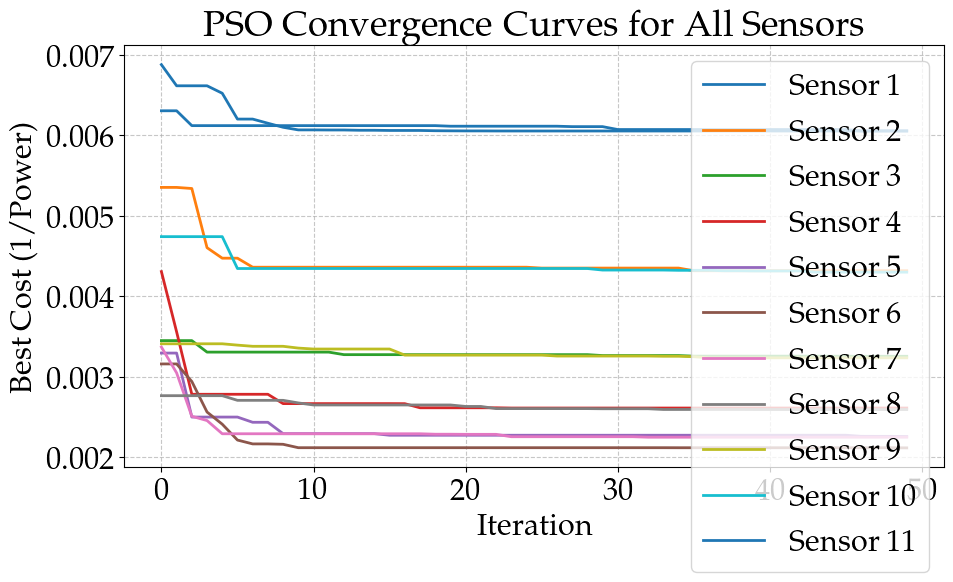

In [4]:
plt.figure(figsize=(10,6))
for i, cost_history in enumerate(all_cost_histories):
    plt.plot(cost_history, linewidth=2, label=f"Sensor {i+1}")
plt.xlabel("Iteration")
plt.ylabel("Best Cost (1/Power)")
plt.title("PSO Convergence Curves for All Sensors")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
pos_l = np.array(pos_l)   
pow_l = np.array(pow_l)   
op_l  = np.array(op_l)    

all_cost_histories = np.array(all_cost_histories, dtype=object)


results = {
    "positions": pos_l,        # sensor positions
    "orientations": op_l,      # best [theta, phi, area]
    "powers": pow_l,           # fitness / best cost
    "cost_histories": all_cost_histories,
}

np.savez("no_sun_to_use21.npz", **results) #good results

print("\nResults saved")


Results saved to optimization_results.npz


In [4]:
op_l[:,2]

array([0.00743149, 0.0058251 , 0.00480092, 0.00404196, 0.00347494,
       0.0030194 , 0.00268408, 0.00243469, 0.00226302, 0.00215508,
       0.00211323, 0.0021552 , 0.00226306, 0.00243448, 0.00268737,
       0.00301856, 0.00346904, 0.00404192, 0.00480094, 0.00582487,
       0.00742033])

In [5]:
op_l[:,0]/np.pi

array([0.16983076, 0.14025937, 0.11720527, 0.09962795, 0.07036978,
       0.06046691, 0.05540968, 0.05101557, 0.02908572, 0.0145451 ,
       0.0043876 , 0.00899536, 0.02778909, 0.04504685, 0.05312803,
       0.0695312 , 0.08884276, 0.09871906, 0.11647057, 0.14141012,
       0.16345311])

In [6]:
nor_arr = ut.spher_to_cart_ar(1, op_l[:,0],op_l[:,1]).T

In [7]:
nor_arr

array([[ 0.30901189,  0.40394186,  0.86101256],
       [ 0.29543213,  0.30762986,  0.90447981],
       [ 0.25403157,  0.2550096 ,  0.9329727 ],
       [ 0.21749311,  0.21795029,  0.95141706],
       [ 0.13538368,  0.17249227,  0.97566268],
       [ 0.12621963,  0.14043627,  0.98201133],
       [ 0.11859853,  0.12622018,  0.98488723],
       [ 0.11455189,  0.11110896,  0.98718421],
       [ 0.06354162,  0.06548841,  0.99582816],
       [ 0.02127091,  0.04042411,  0.99895618],
       [ 0.01013042, -0.00934678,  0.999905  ],
       [-0.02242057, -0.01719649,  0.99960072],
       [-0.06063546, -0.06265492,  0.9961916 ],
       [-0.1087021 , -0.08987824,  0.99000291],
       [-0.14521283, -0.08070521,  0.98610339],
       [-0.14233971, -0.1634037 ,  0.97623698],
       [-0.19529193, -0.19431992,  0.96130163],
       [-0.21513563, -0.2164623 ,  0.95229236],
       [-0.25200779, -0.25398371,  0.93380102],
       [-0.30510201, -0.30269891,  0.90293196],
       [-0.36075071, -0.33341768,  0.871